In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, AlphaDropout, Conv2D, AveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
# Directorios de los datasets
train_dir = "../datos/train"
val_dir = "../datos/val"
test_dir = "../datos/test"

In [3]:
# Parámetros
img_size = (224, 224)
batch_size = 8
num_classes = 4  # Normal, Pólipos, Úlcera, Esophagitis

datagen_train = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=45,  # Rotación de hasta 45 grados
    width_shift_range=0.1,  # Desplazamiento horizontal del 10%
    height_shift_range=0.1,  # Desplazamiento vertical del 10%
    shear_range=0.1,  # Transformación de cizallamiento del 10%
    zoom_range=0.1,  # Zoom de hasta un 10%
    horizontal_flip=True,  # Volteo horizontal
    vertical_flip=True,  # Volteo vertical
    fill_mode='constant',  # Relleno con valores constantes
    brightness_range=[0.1, 1.0]  # Ajuste de brillo entre 0.1 y 1.0
)
 #evitamos el sobreajuste
datagen_val_test = ImageDataGenerator(rescale=1.0/255)

train_generator = datagen_train.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    seed=42,
    class_mode='categorical' #salida formato one_hot encoding ya que hay mas de 2 clases
)

val_generator = datagen_val_test.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    seed=42,
    class_mode='categorical', #salida formato one_hot encoding ya que hay mas de 2 clases
    shuffle=False
)

test_generator = datagen_val_test.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    seed=42,
    class_mode='categorical', #salida formato one_hot encoding ya que hay mas de 2 clases
    shuffle=False
)

Found 3200 images belonging to 4 classes.
Found 2000 images belonging to 4 classes.
Found 800 images belonging to 4 classes.


In [4]:
# Cargar modelo preentrenado MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Congelamos las capas del modelo base

In [5]:
# Construcción del modelo
x = base_model.layers[-39].output #Equivalent to four (4) CORE block deduction.

# Capa convolucional
x = Conv2D(filters=192, kernel_size=8, strides=1, padding='valid',
           activation='selu', kernel_initializer='lecun_normal')(x)

# Capa de Average Pooling 
x = AveragePooling2D(pool_size=1, strides=1, padding='valid')(x)

# Global Average Pooling para reducir dimensiones antes de la capa densa
x = GlobalAveragePooling2D()(x)

# Capa fully connected
x = Dense(512, activation='selu', kernel_initializer='lecun_normal')(x)  # 512 neuronas

# Dropout ajustado 
x = AlphaDropout(0.2)(x)  # Reducimos sobreajuste apagando el 20% de las neuronas

# Capa de salida con 4 clases y activación softmax
outputs = Dense(num_classes, activation='softmax')(x)

# Creación del modelo
model = Model(inputs=base_model.input, outputs=outputs)

In [6]:
model.summary()

Model: "model"


__________________________________________________________________________________________________


 Layer (type)                   Output Shape         Param #     Connected to                     


 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               


                                )]                                                                


 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                


                                )                                                                 


 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  


                                )                                                                 


 Conv1_relu (ReLU)              (None, 112, 112, 32  0           ['bn_Conv1[0][0]']               


                                )                                                                 


 expanded_conv_depthwise (Depth  (None, 112, 112, 32  288        ['Conv1_relu[0][0]']             


 wiseConv2D)                    )                                                                 


 expanded_conv_depthwise_BN (Ba  (None, 112, 112, 32  128        ['expanded_conv_depthwise[0][0]']


 tchNormalization)              )                                                                 


 expanded_conv_depthwise_relu (  (None, 112, 112, 32  0          ['expanded_conv_depthwise_BN[0][0


 ReLU)                          )                                ]']                              


 expanded_conv_project (Conv2D)  (None, 112, 112, 16  512        ['expanded_conv_depthwise_relu[0]


                                )                                [0]']                            


 expanded_conv_project_BN (Batc  (None, 112, 112, 16  64         ['expanded_conv_project[0][0]']  


 hNormalization)                )                                                                 


 block_1_expand (Conv2D)        (None, 112, 112, 96  1536        ['expanded_conv_project_BN[0][0]'


                                )                                ]                                


 block_1_expand_BN (BatchNormal  (None, 112, 112, 96  384        ['block_1_expand[0][0]']         


 ization)                       )                                                                 


 block_1_expand_relu (ReLU)     (None, 112, 112, 96  0           ['block_1_expand_BN[0][0]']      


                                )                                                                 


 block_1_pad (ZeroPadding2D)    (None, 113, 113, 96  0           ['block_1_expand_relu[0][0]']    


                                )                                                                 


 block_1_depthwise (DepthwiseCo  (None, 56, 56, 96)  864         ['block_1_pad[0][0]']            


 nv2D)                                                                                            


 block_1_depthwise_BN (BatchNor  (None, 56, 56, 96)  384         ['block_1_depthwise[0][0]']      


 malization)                                                                                      


 block_1_depthwise_relu (ReLU)  (None, 56, 56, 96)   0           ['block_1_depthwise_BN[0][0]']   


 block_1_project (Conv2D)       (None, 56, 56, 24)   2304        ['block_1_depthwise_relu[0][0]'] 


 block_1_project_BN (BatchNorma  (None, 56, 56, 24)  96          ['block_1_project[0][0]']        


 lization)                                                                                        


 block_2_expand (Conv2D)        (None, 56, 56, 144)  3456        ['block_1_project_BN[0][0]']     


 block_2_expand_BN (BatchNormal  (None, 56, 56, 144)  576        ['block_2_expand[0][0]']         


 ization)                                                                                         


 block_2_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_2_expand_BN[0][0]']      


 block_2_depthwise (DepthwiseCo  (None, 56, 56, 144)  1296       ['block_2_expand_relu[0][0]']    


 nv2D)                                                                                            


 block_2_depthwise_BN (BatchNor  (None, 56, 56, 144)  576        ['block_2_depthwise[0][0]']      


 malization)                                                                                      


 block_2_depthwise_relu (ReLU)  (None, 56, 56, 144)  0           ['block_2_depthwise_BN[0][0]']   


 block_2_project (Conv2D)       (None, 56, 56, 24)   3456        ['block_2_depthwise_relu[0][0]'] 


 block_2_project_BN (BatchNorma  (None, 56, 56, 24)  96          ['block_2_project[0][0]']        


 lization)                                                                                        


 block_2_add (Add)              (None, 56, 56, 24)   0           ['block_1_project_BN[0][0]',     


                                                                  'block_2_project_BN[0][0]']     


 block_3_expand (Conv2D)        (None, 56, 56, 144)  3456        ['block_2_add[0][0]']            


 block_3_expand_BN (BatchNormal  (None, 56, 56, 144)  576        ['block_3_expand[0][0]']         


 ization)                                                                                         


 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      


 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    


 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            


 nv2D)                                                                                            


 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      


 malization)                                                                                      


 block_3_depthwise_relu (ReLU)  (None, 28, 28, 144)  0           ['block_3_depthwise_BN[0][0]']   


 block_3_project (Conv2D)       (None, 28, 28, 32)   4608        ['block_3_depthwise_relu[0][0]'] 


 block_3_project_BN (BatchNorma  (None, 28, 28, 32)  128         ['block_3_project[0][0]']        


 lization)                                                                                        


 block_4_expand (Conv2D)        (None, 28, 28, 192)  6144        ['block_3_project_BN[0][0]']     


 block_4_expand_BN (BatchNormal  (None, 28, 28, 192)  768        ['block_4_expand[0][0]']         


 ization)                                                                                         


 block_4_expand_relu (ReLU)     (None, 28, 28, 192)  0           ['block_4_expand_BN[0][0]']      


 block_4_depthwise (DepthwiseCo  (None, 28, 28, 192)  1728       ['block_4_expand_relu[0][0]']    


 nv2D)                                                                                            


 block_4_depthwise_BN (BatchNor  (None, 28, 28, 192)  768        ['block_4_depthwise[0][0]']      


 malization)                                                                                      


 block_4_depthwise_relu (ReLU)  (None, 28, 28, 192)  0           ['block_4_depthwise_BN[0][0]']   


 block_4_project (Conv2D)       (None, 28, 28, 32)   6144        ['block_4_depthwise_relu[0][0]'] 


 block_4_project_BN (BatchNorma  (None, 28, 28, 32)  128         ['block_4_project[0][0]']        


 lization)                                                                                        


 block_4_add (Add)              (None, 28, 28, 32)   0           ['block_3_project_BN[0][0]',     


                                                                  'block_4_project_BN[0][0]']     


 block_5_expand (Conv2D)        (None, 28, 28, 192)  6144        ['block_4_add[0][0]']            


 block_5_expand_BN (BatchNormal  (None, 28, 28, 192)  768        ['block_5_expand[0][0]']         


 ization)                                                                                         


 block_5_expand_relu (ReLU)     (None, 28, 28, 192)  0           ['block_5_expand_BN[0][0]']      


 block_5_depthwise (DepthwiseCo  (None, 28, 28, 192)  1728       ['block_5_expand_relu[0][0]']    


 nv2D)                                                                                            


 block_5_depthwise_BN (BatchNor  (None, 28, 28, 192)  768        ['block_5_depthwise[0][0]']      


 malization)                                                                                      


 block_5_depthwise_relu (ReLU)  (None, 28, 28, 192)  0           ['block_5_depthwise_BN[0][0]']   


 block_5_project (Conv2D)       (None, 28, 28, 32)   6144        ['block_5_depthwise_relu[0][0]'] 


 block_5_project_BN (BatchNorma  (None, 28, 28, 32)  128         ['block_5_project[0][0]']        


 lization)                                                                                        


 block_5_add (Add)              (None, 28, 28, 32)   0           ['block_4_add[0][0]',            


                                                                  'block_5_project_BN[0][0]']     


 block_6_expand (Conv2D)        (None, 28, 28, 192)  6144        ['block_5_add[0][0]']            


 block_6_expand_BN (BatchNormal  (None, 28, 28, 192)  768        ['block_6_expand[0][0]']         


 ization)                                                                                         


 block_6_expand_relu (ReLU)     (None, 28, 28, 192)  0           ['block_6_expand_BN[0][0]']      


 block_6_pad (ZeroPadding2D)    (None, 29, 29, 192)  0           ['block_6_expand_relu[0][0]']    


 block_6_depthwise (DepthwiseCo  (None, 14, 14, 192)  1728       ['block_6_pad[0][0]']            


 nv2D)                                                                                            


 block_6_depthwise_BN (BatchNor  (None, 14, 14, 192)  768        ['block_6_depthwise[0][0]']      


 malization)                                                                                      


 block_6_depthwise_relu (ReLU)  (None, 14, 14, 192)  0           ['block_6_depthwise_BN[0][0]']   


 block_6_project (Conv2D)       (None, 14, 14, 64)   12288       ['block_6_depthwise_relu[0][0]'] 


 block_6_project_BN (BatchNorma  (None, 14, 14, 64)  256         ['block_6_project[0][0]']        


 lization)                                                                                        


 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     


 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         


 ization)                                                                                         


 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      


 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    


 nv2D)                                                                                            


 block_7_depthwise_BN (BatchNor  (None, 14, 14, 384)  1536       ['block_7_depthwise[0][0]']      


 malization)                                                                                      


 block_7_depthwise_relu (ReLU)  (None, 14, 14, 384)  0           ['block_7_depthwise_BN[0][0]']   


 block_7_project (Conv2D)       (None, 14, 14, 64)   24576       ['block_7_depthwise_relu[0][0]'] 


 block_7_project_BN (BatchNorma  (None, 14, 14, 64)  256         ['block_7_project[0][0]']        


 lization)                                                                                        


 block_7_add (Add)              (None, 14, 14, 64)   0           ['block_6_project_BN[0][0]',     


                                                                  'block_7_project_BN[0][0]']     


 block_8_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_7_add[0][0]']            


 block_8_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_8_expand[0][0]']         


 ization)                                                                                         


 block_8_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_8_expand_BN[0][0]']      


 block_8_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_8_expand_relu[0][0]']    


 nv2D)                                                                                            


 block_8_depthwise_BN (BatchNor  (None, 14, 14, 384)  1536       ['block_8_depthwise[0][0]']      


 malization)                                                                                      


 block_8_depthwise_relu (ReLU)  (None, 14, 14, 384)  0           ['block_8_depthwise_BN[0][0]']   


 block_8_project (Conv2D)       (None, 14, 14, 64)   24576       ['block_8_depthwise_relu[0][0]'] 


 block_8_project_BN (BatchNorma  (None, 14, 14, 64)  256         ['block_8_project[0][0]']        


 lization)                                                                                        


 block_8_add (Add)              (None, 14, 14, 64)   0           ['block_7_add[0][0]',            


                                                                  'block_8_project_BN[0][0]']     


 block_9_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_8_add[0][0]']            


 block_9_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_9_expand[0][0]']         


 ization)                                                                                         


 block_9_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_9_expand_BN[0][0]']      


 block_9_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_9_expand_relu[0][0]']    


 nv2D)                                                                                            


 block_9_depthwise_BN (BatchNor  (None, 14, 14, 384)  1536       ['block_9_depthwise[0][0]']      


 malization)                                                                                      


 block_9_depthwise_relu (ReLU)  (None, 14, 14, 384)  0           ['block_9_depthwise_BN[0][0]']   


 block_9_project (Conv2D)       (None, 14, 14, 64)   24576       ['block_9_depthwise_relu[0][0]'] 


 block_9_project_BN (BatchNorma  (None, 14, 14, 64)  256         ['block_9_project[0][0]']        


 lization)                                                                                        


 block_9_add (Add)              (None, 14, 14, 64)   0           ['block_8_add[0][0]',            


                                                                  'block_9_project_BN[0][0]']     


 block_10_expand (Conv2D)       (None, 14, 14, 384)  24576       ['block_9_add[0][0]']            


 block_10_expand_BN (BatchNorma  (None, 14, 14, 384)  1536       ['block_10_expand[0][0]']        


 lization)                                                                                        


 block_10_expand_relu (ReLU)    (None, 14, 14, 384)  0           ['block_10_expand_BN[0][0]']     


 block_10_depthwise (DepthwiseC  (None, 14, 14, 384)  3456       ['block_10_expand_relu[0][0]']   


 onv2D)                                                                                           


 block_10_depthwise_BN (BatchNo  (None, 14, 14, 384)  1536       ['block_10_depthwise[0][0]']     


 rmalization)                                                                                     


 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  


 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']


 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       


 alization)                                                                                       


 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    


 block_11_expand_BN (BatchNorma  (None, 14, 14, 576)  2304       ['block_11_expand[0][0]']        


 lization)                                                                                        


 block_11_expand_relu (ReLU)    (None, 14, 14, 576)  0           ['block_11_expand_BN[0][0]']     


 block_11_depthwise (DepthwiseC  (None, 14, 14, 576)  5184       ['block_11_expand_relu[0][0]']   


 onv2D)                                                                                           


 block_11_depthwise_BN (BatchNo  (None, 14, 14, 576)  2304       ['block_11_depthwise[0][0]']     


 rmalization)                                                                                     


 block_11_depthwise_relu (ReLU)  (None, 14, 14, 576)  0          ['block_11_depthwise_BN[0][0]']  


 block_11_project (Conv2D)      (None, 14, 14, 96)   55296       ['block_11_depthwise_relu[0][0]']


 block_11_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_11_project[0][0]']       


 alization)                                                                                       


 block_11_add (Add)             (None, 14, 14, 96)   0           ['block_10_project_BN[0][0]',    


                                                                  'block_11_project_BN[0][0]']    


 block_12_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_11_add[0][0]']           


 block_12_expand_BN (BatchNorma  (None, 14, 14, 576)  2304       ['block_12_expand[0][0]']        


 lization)                                                                                        


 block_12_expand_relu (ReLU)    (None, 14, 14, 576)  0           ['block_12_expand_BN[0][0]']     


 block_12_depthwise (DepthwiseC  (None, 14, 14, 576)  5184       ['block_12_expand_relu[0][0]']   


 onv2D)                                                                                           


 block_12_depthwise_BN (BatchNo  (None, 14, 14, 576)  2304       ['block_12_depthwise[0][0]']     


 rmalization)                                                                                     


 block_12_depthwise_relu (ReLU)  (None, 14, 14, 576)  0          ['block_12_depthwise_BN[0][0]']  


 block_12_project (Conv2D)      (None, 14, 14, 96)   55296       ['block_12_depthwise_relu[0][0]']


 block_12_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_12_project[0][0]']       


 alization)                                                                                       


 block_12_add (Add)             (None, 14, 14, 96)   0           ['block_11_add[0][0]',           


                                                                  'block_12_project_BN[0][0]']    


 conv2d (Conv2D)                (None, 7, 7, 192)    1179840     ['block_12_add[0][0]']           


 average_pooling2d (AveragePool  (None, 7, 7, 192)   0           ['conv2d[0][0]']                 


 ing2D)                                                                                           


 global_average_pooling2d (Glob  (None, 192)         0           ['average_pooling2d[0][0]']      


 alAveragePooling2D)                                                                              


 dense (Dense)                  (None, 512)          98816       ['global_average_pooling2d[0][0]'


                                                                 ]                                


 alpha_dropout (AlphaDropout)   (None, 512)          0           ['dense[0][0]']                  


 dense_1 (Dense)                (None, 4)            2052        ['alpha_dropout[0][0]']          


Total params: 1,839,364


Trainable params: 1,280,708


Non-trainable params: 558,656


__________________________________________________________________________________________________


In [7]:
# Compilación del modelo
optimizer = Adam(learning_rate=0.00001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy']) #con funcion de perdida porque es multiclase

In [8]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('mobilenetv2_best_model.h5', save_best_only=True, monitor='val_loss')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1) # Reduce LR si no hay mejora en 2 épocas

In [9]:
# Entrenamiento del modelo
epochs = 500 #puede detenerse antes si no mejora la validacion
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

Epoch 1/500



  1/400 [..............................] - ETA: 21:12 - loss: 1.8040 - accuracy: 0.2500


  3/400 [..............................] - ETA: 19s - loss: 2.2849 - accuracy: 0.1667  


  4/400 [..............................] - ETA: 24s - loss: 2.0725 - accuracy: 0.1875


  5/400 [..............................] - ETA: 26s - loss: 2.1198 - accuracy: 0.1750


  6/400 [..............................] - ETA: 28s - loss: 1.9759 - accuracy: 0.2292


  7/400 [..............................] - ETA: 27s - loss: 2.0105 - accuracy: 0.2143


  8/400 [..............................] - ETA: 28s - loss: 1.9866 - accuracy: 0.2188


  9/400 [..............................] - ETA: 28s - loss: 2.0123 - accuracy: 0.1944


 10/400 [..............................] - ETA: 29s - loss: 1.9804 - accuracy: 0.2000


 11/400 [..............................] - ETA: 28s - loss: 1.9019 - accuracy: 0.2273


 12/400 [..............................] - ETA: 28s - loss: 1.8785 - accuracy: 0.2292


 13/400 [..............................] - ETA: 29s - loss: 1.8873 - accuracy: 0.2404


 14/400 [>.............................] - ETA: 29s - loss: 1.8676 - accuracy: 0.2411


 15/400 [>.............................] - ETA: 29s - loss: 1.8856 - accuracy: 0.2333


 16/400 [>.............................] - ETA: 30s - loss: 1.8896 - accuracy: 0.2266


 17/400 [>.............................] - ETA: 29s - loss: 1.8836 - accuracy: 0.2279


 18/400 [>.............................] - ETA: 30s - loss: 1.8589 - accuracy: 0.2361


 19/400 [>.............................] - ETA: 30s - loss: 1.8710 - accuracy: 0.2368


 20/400 [>.............................] - ETA: 30s - loss: 1.8562 - accuracy: 0.2500


 21/400 [>.............................] - ETA: 30s - loss: 1.8274 - accuracy: 0.2619


 22/400 [>.............................] - ETA: 30s - loss: 1.8099 - accuracy: 0.2727


 23/400 [>.............................] - ETA: 30s - loss: 1.7777 - accuracy: 0.2935


 24/400 [>.............................] - ETA: 30s - loss: 1.7672 - accuracy: 0.2917


 25/400 [>.............................] - ETA: 30s - loss: 1.7604 - accuracy: 0.2850


 26/400 [>.............................] - ETA: 30s - loss: 1.7532 - accuracy: 0.2837


 27/400 [=>............................] - ETA: 30s - loss: 1.7266 - accuracy: 0.2963


 28/400 [=>............................] - ETA: 30s - loss: 1.7026 - accuracy: 0.3036


 29/400 [=>............................] - ETA: 30s - loss: 1.6743 - accuracy: 0.3147


 30/400 [=>............................] - ETA: 30s - loss: 1.6730 - accuracy: 0.3083


 31/400 [=>............................] - ETA: 30s - loss: 1.6599 - accuracy: 0.3105


 32/400 [=>............................] - ETA: 29s - loss: 1.6572 - accuracy: 0.3125


 33/400 [=>............................] - ETA: 29s - loss: 1.6655 - accuracy: 0.3068


 34/400 [=>............................] - ETA: 29s - loss: 1.6637 - accuracy: 0.3088


 35/400 [=>............................] - ETA: 29s - loss: 1.6635 - accuracy: 0.3036


 36/400 [=>............................] - ETA: 29s - loss: 1.6625 - accuracy: 0.3056


 37/400 [=>............................] - ETA: 29s - loss: 1.6624 - accuracy: 0.3074


 38/400 [=>............................] - ETA: 29s - loss: 1.6309 - accuracy: 0.3224


 39/400 [=>............................] - ETA: 29s - loss: 1.6165 - accuracy: 0.3301


 40/400 [==>...........................] - ETA: 29s - loss: 1.6049 - accuracy: 0.3281


 41/400 [==>...........................] - ETA: 29s - loss: 1.6130 - accuracy: 0.3232


 42/400 [==>...........................] - ETA: 29s - loss: 1.5948 - accuracy: 0.3333


 43/400 [==>...........................] - ETA: 29s - loss: 1.5768 - accuracy: 0.3372


 44/400 [==>...........................] - ETA: 29s - loss: 1.5785 - accuracy: 0.3352


 45/400 [==>...........................] - ETA: 29s - loss: 1.5703 - accuracy: 0.3389


 46/400 [==>...........................] - ETA: 29s - loss: 1.5583 - accuracy: 0.3451


 47/400 [==>...........................] - ETA: 28s - loss: 1.5702 - accuracy: 0.3431


 48/400 [==>...........................] - ETA: 28s - loss: 1.5739 - accuracy: 0.3411


 49/400 [==>...........................] - ETA: 28s - loss: 1.5597 - accuracy: 0.3495


 50/400 [==>...........................] - ETA: 28s - loss: 1.5583 - accuracy: 0.3450


 51/400 [==>...........................] - ETA: 28s - loss: 1.5498 - accuracy: 0.3480


 52/400 [==>...........................] - ETA: 28s - loss: 1.5468 - accuracy: 0.3510


 53/400 [==>...........................] - ETA: 28s - loss: 1.5496 - accuracy: 0.3514


 54/400 [===>..........................] - ETA: 28s - loss: 1.5426 - accuracy: 0.3542


 55/400 [===>..........................] - ETA: 28s - loss: 1.5350 - accuracy: 0.3545


 56/400 [===>..........................] - ETA: 27s - loss: 1.5298 - accuracy: 0.3527


 57/400 [===>..........................] - ETA: 27s - loss: 1.5305 - accuracy: 0.3509


 58/400 [===>..........................] - ETA: 27s - loss: 1.5202 - accuracy: 0.3556


 59/400 [===>..........................] - ETA: 27s - loss: 1.5114 - accuracy: 0.3581


 60/400 [===>..........................] - ETA: 27s - loss: 1.5141 - accuracy: 0.3542


 61/400 [===>..........................] - ETA: 27s - loss: 1.5044 - accuracy: 0.3586


 62/400 [===>..........................] - ETA: 27s - loss: 1.5014 - accuracy: 0.3569


 63/400 [===>..........................] - ETA: 27s - loss: 1.4993 - accuracy: 0.3571


 64/400 [===>..........................] - ETA: 27s - loss: 1.4909 - accuracy: 0.3594


 65/400 [===>..........................] - ETA: 27s - loss: 1.4774 - accuracy: 0.3673


 66/400 [===>..........................] - ETA: 27s - loss: 1.4675 - accuracy: 0.3712


 67/400 [====>.........................] - ETA: 27s - loss: 1.4605 - accuracy: 0.3750


 68/400 [====>.........................] - ETA: 27s - loss: 1.4535 - accuracy: 0.3768


 69/400 [====>.........................] - ETA: 27s - loss: 1.4473 - accuracy: 0.3768


 70/400 [====>.........................] - ETA: 26s - loss: 1.4399 - accuracy: 0.3804


 71/400 [====>.........................] - ETA: 26s - loss: 1.4441 - accuracy: 0.3785


 72/400 [====>.........................] - ETA: 26s - loss: 1.4396 - accuracy: 0.3802


 73/400 [====>.........................] - ETA: 26s - loss: 1.4414 - accuracy: 0.3818


 74/400 [====>.........................] - ETA: 26s - loss: 1.4398 - accuracy: 0.3834


 75/400 [====>.........................] - ETA: 26s - loss: 1.4292 - accuracy: 0.3867


 76/400 [====>.........................] - ETA: 26s - loss: 1.4185 - accuracy: 0.3914


 77/400 [====>.........................] - ETA: 26s - loss: 1.4214 - accuracy: 0.3880


 78/400 [====>.........................] - ETA: 26s - loss: 1.4191 - accuracy: 0.3894


 79/400 [====>.........................] - ETA: 26s - loss: 1.4104 - accuracy: 0.3924


 80/400 [=====>........................] - ETA: 26s - loss: 1.4084 - accuracy: 0.3922


 81/400 [=====>........................] - ETA: 25s - loss: 1.4056 - accuracy: 0.3951


 82/400 [=====>........................] - ETA: 25s - loss: 1.4035 - accuracy: 0.3979


 83/400 [=====>........................] - ETA: 25s - loss: 1.3968 - accuracy: 0.4006


 84/400 [=====>........................] - ETA: 25s - loss: 1.3895 - accuracy: 0.4048


 85/400 [=====>........................] - ETA: 25s - loss: 1.3803 - accuracy: 0.4088


 86/400 [=====>........................] - ETA: 25s - loss: 1.3741 - accuracy: 0.4113


 87/400 [=====>........................] - ETA: 25s - loss: 1.3703 - accuracy: 0.4138


 88/400 [=====>........................] - ETA: 25s - loss: 1.3668 - accuracy: 0.4162


 89/400 [=====>........................] - ETA: 25s - loss: 1.3646 - accuracy: 0.4185


 90/400 [=====>........................] - ETA: 25s - loss: 1.3590 - accuracy: 0.4208


 91/400 [=====>........................] - ETA: 25s - loss: 1.3599 - accuracy: 0.4231


 92/400 [=====>........................] - ETA: 25s - loss: 1.3523 - accuracy: 0.4266


 93/400 [=====>........................] - ETA: 25s - loss: 1.3425 - accuracy: 0.4315


 94/400 [======>.......................] - ETA: 24s - loss: 1.3420 - accuracy: 0.4322


 95/400 [======>.......................] - ETA: 24s - loss: 1.3321 - accuracy: 0.4368


 96/400 [======>.......................] - ETA: 24s - loss: 1.3277 - accuracy: 0.4362


 97/400 [======>.......................] - ETA: 24s - loss: 1.3266 - accuracy: 0.4369


 98/400 [======>.......................] - ETA: 24s - loss: 1.3216 - accuracy: 0.4388


 99/400 [======>.......................] - ETA: 24s - loss: 1.3180 - accuracy: 0.4419


100/400 [======>.......................] - ETA: 24s - loss: 1.3153 - accuracy: 0.4425


101/400 [======>.......................] - ETA: 24s - loss: 1.3096 - accuracy: 0.4443


102/400 [======>.......................] - ETA: 24s - loss: 1.3070 - accuracy: 0.4449


103/400 [======>.......................] - ETA: 24s - loss: 1.2977 - accuracy: 0.4490


104/400 [======>.......................] - ETA: 24s - loss: 1.2988 - accuracy: 0.4507


105/400 [======>.......................] - ETA: 24s - loss: 1.2959 - accuracy: 0.4524


106/400 [======>.......................] - ETA: 24s - loss: 1.2969 - accuracy: 0.4528


107/400 [=======>......................] - ETA: 23s - loss: 1.2919 - accuracy: 0.4533


108/400 [=======>......................] - ETA: 23s - loss: 1.2900 - accuracy: 0.4525


109/400 [=======>......................] - ETA: 23s - loss: 1.2863 - accuracy: 0.4518


110/400 [=======>......................] - ETA: 23s - loss: 1.2838 - accuracy: 0.4523


111/400 [=======>......................] - ETA: 23s - loss: 1.2791 - accuracy: 0.4550


112/400 [=======>......................] - ETA: 23s - loss: 1.2727 - accuracy: 0.4576


113/400 [=======>......................] - ETA: 23s - loss: 1.2692 - accuracy: 0.4602


114/400 [=======>......................] - ETA: 23s - loss: 1.2640 - accuracy: 0.4627


115/400 [=======>......................] - ETA: 23s - loss: 1.2622 - accuracy: 0.4652


116/400 [=======>......................] - ETA: 23s - loss: 1.2618 - accuracy: 0.4655


117/400 [=======>......................] - ETA: 23s - loss: 1.2581 - accuracy: 0.4669


118/400 [=======>......................] - ETA: 23s - loss: 1.2533 - accuracy: 0.4693


119/400 [=======>......................] - ETA: 23s - loss: 1.2473 - accuracy: 0.4716


120/400 [========>.....................] - ETA: 22s - loss: 1.2406 - accuracy: 0.4750


121/400 [========>.....................] - ETA: 22s - loss: 1.2369 - accuracy: 0.4762


122/400 [========>.....................] - ETA: 22s - loss: 1.2352 - accuracy: 0.4775


123/400 [========>.....................] - ETA: 22s - loss: 1.2338 - accuracy: 0.4776


124/400 [========>.....................] - ETA: 22s - loss: 1.2310 - accuracy: 0.4808


125/400 [========>.....................] - ETA: 22s - loss: 1.2285 - accuracy: 0.4800


126/400 [========>.....................] - ETA: 22s - loss: 1.2242 - accuracy: 0.4821


127/400 [========>.....................] - ETA: 22s - loss: 1.2197 - accuracy: 0.4833


128/400 [========>.....................] - ETA: 22s - loss: 1.2154 - accuracy: 0.4854


129/400 [========>.....................] - ETA: 22s - loss: 1.2121 - accuracy: 0.4874


130/400 [========>.....................] - ETA: 22s - loss: 1.2066 - accuracy: 0.4904


131/400 [========>.....................] - ETA: 22s - loss: 1.2017 - accuracy: 0.4924


132/400 [========>.....................] - ETA: 21s - loss: 1.1993 - accuracy: 0.4934


133/400 [========>.....................] - ETA: 21s - loss: 1.1959 - accuracy: 0.4953


134/400 [=========>....................] - ETA: 21s - loss: 1.1920 - accuracy: 0.4981


135/400 [=========>....................] - ETA: 21s - loss: 1.1880 - accuracy: 0.4991


136/400 [=========>....................] - ETA: 21s - loss: 1.1834 - accuracy: 0.5009


137/400 [=========>....................] - ETA: 21s - loss: 1.1839 - accuracy: 0.5009


138/400 [=========>....................] - ETA: 21s - loss: 1.1810 - accuracy: 0.5018


139/400 [=========>....................] - ETA: 21s - loss: 1.1792 - accuracy: 0.5027


140/400 [=========>....................] - ETA: 21s - loss: 1.1782 - accuracy: 0.5054


141/400 [=========>....................] - ETA: 21s - loss: 1.1757 - accuracy: 0.5062


142/400 [=========>....................] - ETA: 21s - loss: 1.1728 - accuracy: 0.5062


143/400 [=========>....................] - ETA: 20s - loss: 1.1703 - accuracy: 0.5070


144/400 [=========>....................] - ETA: 20s - loss: 1.1662 - accuracy: 0.5087


145/400 [=========>....................] - ETA: 20s - loss: 1.1640 - accuracy: 0.5086


146/400 [=========>....................] - ETA: 20s - loss: 1.1589 - accuracy: 0.5111


147/400 [==========>...................] - ETA: 20s - loss: 1.1517 - accuracy: 0.5145


148/400 [==========>...................] - ETA: 20s - loss: 1.1512 - accuracy: 0.5144


149/400 [==========>...................] - ETA: 20s - loss: 1.1463 - accuracy: 0.5159


150/400 [==========>...................] - ETA: 20s - loss: 1.1452 - accuracy: 0.5158


151/400 [==========>...................] - ETA: 20s - loss: 1.1426 - accuracy: 0.5166


152/400 [==========>...................] - ETA: 20s - loss: 1.1423 - accuracy: 0.5156


153/400 [==========>...................] - ETA: 20s - loss: 1.1380 - accuracy: 0.5172


154/400 [==========>...................] - ETA: 20s - loss: 1.1380 - accuracy: 0.5179


155/400 [==========>...................] - ETA: 20s - loss: 1.1346 - accuracy: 0.5194


156/400 [==========>...................] - ETA: 19s - loss: 1.1308 - accuracy: 0.5208


157/400 [==========>...................] - ETA: 19s - loss: 1.1266 - accuracy: 0.5223


158/400 [==========>...................] - ETA: 19s - loss: 1.1260 - accuracy: 0.5222


159/400 [==========>...................] - ETA: 19s - loss: 1.1241 - accuracy: 0.5228


160/400 [===========>..................] - ETA: 19s - loss: 1.1207 - accuracy: 0.5250


161/400 [===========>..................] - ETA: 19s - loss: 1.1179 - accuracy: 0.5264


162/400 [===========>..................] - ETA: 19s - loss: 1.1138 - accuracy: 0.5285


163/400 [===========>..................] - ETA: 19s - loss: 1.1092 - accuracy: 0.5299


164/400 [===========>..................] - ETA: 19s - loss: 1.1073 - accuracy: 0.5305


165/400 [===========>..................] - ETA: 19s - loss: 1.1072 - accuracy: 0.5311


166/400 [===========>..................] - ETA: 19s - loss: 1.1054 - accuracy: 0.5309


167/400 [===========>..................] - ETA: 19s - loss: 1.1033 - accuracy: 0.5322


168/400 [===========>..................] - ETA: 18s - loss: 1.1005 - accuracy: 0.5335


169/400 [===========>..................] - ETA: 18s - loss: 1.0986 - accuracy: 0.5340


170/400 [===========>..................] - ETA: 18s - loss: 1.0962 - accuracy: 0.5346


171/400 [===========>..................] - ETA: 18s - loss: 1.0919 - accuracy: 0.5358


172/400 [===========>..................] - ETA: 18s - loss: 1.0879 - accuracy: 0.5378


173/400 [===========>..................] - ETA: 18s - loss: 1.0889 - accuracy: 0.5383


174/400 [============>.................] - ETA: 18s - loss: 1.0846 - accuracy: 0.5402


175/400 [============>.................] - ETA: 18s - loss: 1.0807 - accuracy: 0.5421


176/400 [============>.................] - ETA: 18s - loss: 1.0778 - accuracy: 0.5433


177/400 [============>.................] - ETA: 18s - loss: 1.0727 - accuracy: 0.5459


178/400 [============>.................] - ETA: 18s - loss: 1.0692 - accuracy: 0.5471


179/400 [============>.................] - ETA: 17s - loss: 1.0659 - accuracy: 0.5489


180/400 [============>.................] - ETA: 17s - loss: 1.0637 - accuracy: 0.5493


181/400 [============>.................] - ETA: 17s - loss: 1.0607 - accuracy: 0.5504


182/400 [============>.................] - ETA: 17s - loss: 1.0575 - accuracy: 0.5522


183/400 [============>.................] - ETA: 17s - loss: 1.0538 - accuracy: 0.5540


184/400 [============>.................] - ETA: 17s - loss: 1.0514 - accuracy: 0.5550


185/400 [============>.................] - ETA: 17s - loss: 1.0504 - accuracy: 0.5561


186/400 [============>.................] - ETA: 17s - loss: 1.0480 - accuracy: 0.5571


187/400 [=============>................] - ETA: 17s - loss: 1.0487 - accuracy: 0.5568


188/400 [=============>................] - ETA: 17s - loss: 1.0470 - accuracy: 0.5572


189/400 [=============>................] - ETA: 17s - loss: 1.0443 - accuracy: 0.5589


190/400 [=============>................] - ETA: 17s - loss: 1.0433 - accuracy: 0.5592


191/400 [=============>................] - ETA: 17s - loss: 1.0411 - accuracy: 0.5589


192/400 [=============>................] - ETA: 16s - loss: 1.0380 - accuracy: 0.5605


193/400 [=============>................] - ETA: 16s - loss: 1.0351 - accuracy: 0.5615


194/400 [=============>................] - ETA: 16s - loss: 1.0318 - accuracy: 0.5631


195/400 [=============>................] - ETA: 16s - loss: 1.0291 - accuracy: 0.5641


196/400 [=============>................] - ETA: 16s - loss: 1.0261 - accuracy: 0.5651


197/400 [=============>................] - ETA: 16s - loss: 1.0253 - accuracy: 0.5654


198/400 [=============>................] - ETA: 16s - loss: 1.0225 - accuracy: 0.5669


199/400 [=============>................] - ETA: 16s - loss: 1.0226 - accuracy: 0.5660


200/400 [==============>...............] - ETA: 16s - loss: 1.0189 - accuracy: 0.5681


201/400 [==============>...............] - ETA: 16s - loss: 1.0187 - accuracy: 0.5684


202/400 [==============>...............] - ETA: 16s - loss: 1.0168 - accuracy: 0.5693


203/400 [==============>...............] - ETA: 16s - loss: 1.0156 - accuracy: 0.5690


204/400 [==============>...............] - ETA: 15s - loss: 1.0138 - accuracy: 0.5699


205/400 [==============>...............] - ETA: 15s - loss: 1.0104 - accuracy: 0.5713


206/400 [==============>...............] - ETA: 15s - loss: 1.0073 - accuracy: 0.5728


207/400 [==============>...............] - ETA: 15s - loss: 1.0052 - accuracy: 0.5737


208/400 [==============>...............] - ETA: 15s - loss: 1.0016 - accuracy: 0.5757


209/400 [==============>...............] - ETA: 15s - loss: 1.0001 - accuracy: 0.5766


210/400 [==============>...............] - ETA: 15s - loss: 0.9965 - accuracy: 0.5780


211/400 [==============>...............] - ETA: 15s - loss: 0.9938 - accuracy: 0.5788


212/400 [==============>...............] - ETA: 15s - loss: 0.9909 - accuracy: 0.5802


213/400 [==============>...............] - ETA: 15s - loss: 0.9890 - accuracy: 0.5804


214/400 [===============>..............] - ETA: 15s - loss: 0.9876 - accuracy: 0.5818


215/400 [===============>..............] - ETA: 15s - loss: 0.9841 - accuracy: 0.5837


216/400 [===============>..............] - ETA: 15s - loss: 0.9817 - accuracy: 0.5851


217/400 [===============>..............] - ETA: 14s - loss: 0.9800 - accuracy: 0.5858


218/400 [===============>..............] - ETA: 14s - loss: 0.9768 - accuracy: 0.5877


219/400 [===============>..............] - ETA: 14s - loss: 0.9756 - accuracy: 0.5879


220/400 [===============>..............] - ETA: 14s - loss: 0.9750 - accuracy: 0.5881


221/400 [===============>..............] - ETA: 14s - loss: 0.9713 - accuracy: 0.5899


222/400 [===============>..............] - ETA: 14s - loss: 0.9681 - accuracy: 0.5918


223/400 [===============>..............] - ETA: 14s - loss: 0.9653 - accuracy: 0.5925


224/400 [===============>..............] - ETA: 14s - loss: 0.9675 - accuracy: 0.5921


225/400 [===============>..............] - ETA: 14s - loss: 0.9650 - accuracy: 0.5933


226/400 [===============>..............] - ETA: 14s - loss: 0.9624 - accuracy: 0.5946


227/400 [================>.............] - ETA: 14s - loss: 0.9599 - accuracy: 0.5958


228/400 [================>.............] - ETA: 14s - loss: 0.9592 - accuracy: 0.5965


229/400 [================>.............] - ETA: 13s - loss: 0.9580 - accuracy: 0.5972


230/400 [================>.............] - ETA: 13s - loss: 0.9550 - accuracy: 0.5989


231/400 [================>.............] - ETA: 13s - loss: 0.9522 - accuracy: 0.5996


232/400 [================>.............] - ETA: 13s - loss: 0.9495 - accuracy: 0.6008


233/400 [================>.............] - ETA: 13s - loss: 0.9483 - accuracy: 0.6009


234/400 [================>.............] - ETA: 13s - loss: 0.9466 - accuracy: 0.6015


235/400 [================>.............] - ETA: 13s - loss: 0.9448 - accuracy: 0.6027


236/400 [================>.............] - ETA: 13s - loss: 0.9428 - accuracy: 0.6033


237/400 [================>.............] - ETA: 13s - loss: 0.9409 - accuracy: 0.6039


238/400 [================>.............] - ETA: 13s - loss: 0.9385 - accuracy: 0.6056


239/400 [================>.............] - ETA: 13s - loss: 0.9369 - accuracy: 0.6062


240/400 [=================>............] - ETA: 13s - loss: 0.9365 - accuracy: 0.6062


241/400 [=================>............] - ETA: 12s - loss: 0.9346 - accuracy: 0.6074


242/400 [=================>............] - ETA: 12s - loss: 0.9346 - accuracy: 0.6080


243/400 [=================>............] - ETA: 12s - loss: 0.9329 - accuracy: 0.6096


244/400 [=================>............] - ETA: 12s - loss: 0.9305 - accuracy: 0.6107


245/400 [=================>............] - ETA: 12s - loss: 0.9294 - accuracy: 0.6107


246/400 [=================>............] - ETA: 12s - loss: 0.9269 - accuracy: 0.6118


247/400 [=================>............] - ETA: 12s - loss: 0.9255 - accuracy: 0.6123


248/400 [=================>............] - ETA: 12s - loss: 0.9236 - accuracy: 0.6129


249/400 [=================>............] - ETA: 12s - loss: 0.9223 - accuracy: 0.6140


250/400 [=================>............] - ETA: 12s - loss: 0.9232 - accuracy: 0.6140


251/400 [=================>............] - ETA: 12s - loss: 0.9210 - accuracy: 0.6145


252/400 [=================>............] - ETA: 12s - loss: 0.9195 - accuracy: 0.6151


253/400 [=================>............] - ETA: 11s - loss: 0.9165 - accuracy: 0.6166


254/400 [==================>...........] - ETA: 11s - loss: 0.9146 - accuracy: 0.6176


255/400 [==================>...........] - ETA: 11s - loss: 0.9126 - accuracy: 0.6186


256/400 [==================>...........] - ETA: 11s - loss: 0.9106 - accuracy: 0.6196


257/400 [==================>...........] - ETA: 11s - loss: 0.9089 - accuracy: 0.6201


258/400 [==================>...........] - ETA: 11s - loss: 0.9096 - accuracy: 0.6202


259/400 [==================>...........] - ETA: 11s - loss: 0.9078 - accuracy: 0.6207


260/400 [==================>...........] - ETA: 11s - loss: 0.9059 - accuracy: 0.6216


261/400 [==================>...........] - ETA: 11s - loss: 0.9032 - accuracy: 0.6231


262/400 [==================>...........] - ETA: 11s - loss: 0.9004 - accuracy: 0.6240


263/400 [==================>...........] - ETA: 11s - loss: 0.8980 - accuracy: 0.6255


264/400 [==================>...........] - ETA: 11s - loss: 0.8975 - accuracy: 0.6255


265/400 [==================>...........] - ETA: 10s - loss: 0.8962 - accuracy: 0.6264


266/400 [==================>...........] - ETA: 10s - loss: 0.8941 - accuracy: 0.6278


267/400 [===================>..........] - ETA: 10s - loss: 0.8914 - accuracy: 0.6292


268/400 [===================>..........] - ETA: 10s - loss: 0.8910 - accuracy: 0.6292


269/400 [===================>..........] - ETA: 10s - loss: 0.8894 - accuracy: 0.6296


270/400 [===================>..........] - ETA: 10s - loss: 0.8873 - accuracy: 0.6310


271/400 [===================>..........] - ETA: 10s - loss: 0.8874 - accuracy: 0.6310


272/400 [===================>..........] - ETA: 10s - loss: 0.8865 - accuracy: 0.6314


273/400 [===================>..........] - ETA: 10s - loss: 0.8850 - accuracy: 0.6323


275/400 [===================>..........] - ETA: 10s - loss: 0.8835 - accuracy: 0.6336


276/400 [===================>..........] - ETA: 10s - loss: 0.8824 - accuracy: 0.6345


277/400 [===================>..........] - ETA: 9s - loss: 0.8830 - accuracy: 0.6349 


278/400 [===================>..........] - ETA: 9s - loss: 0.8807 - accuracy: 0.6358


279/400 [===================>..........] - ETA: 9s - loss: 0.8819 - accuracy: 0.6358


280/400 [====================>.........] - ETA: 9s - loss: 0.8809 - accuracy: 0.6362


281/400 [====================>.........] - ETA: 9s - loss: 0.8804 - accuracy: 0.6361


282/400 [====================>.........] - ETA: 9s - loss: 0.8792 - accuracy: 0.6361


283/400 [====================>.........] - ETA: 9s - loss: 0.8771 - accuracy: 0.6374


284/400 [====================>.........] - ETA: 9s - loss: 0.8746 - accuracy: 0.6386


285/400 [====================>.........] - ETA: 9s - loss: 0.8740 - accuracy: 0.6386


286/400 [====================>.........] - ETA: 9s - loss: 0.8716 - accuracy: 0.6399


287/400 [====================>.........] - ETA: 9s - loss: 0.8707 - accuracy: 0.6402


288/400 [====================>.........] - ETA: 9s - loss: 0.8687 - accuracy: 0.6415


289/400 [====================>.........] - ETA: 9s - loss: 0.8674 - accuracy: 0.6423


290/400 [====================>.........] - ETA: 8s - loss: 0.8671 - accuracy: 0.6427


291/400 [====================>.........] - ETA: 8s - loss: 0.8652 - accuracy: 0.6439


292/400 [====================>.........] - ETA: 8s - loss: 0.8640 - accuracy: 0.6443


293/400 [====================>.........] - ETA: 8s - loss: 0.8635 - accuracy: 0.6446


294/400 [=====================>........] - ETA: 8s - loss: 0.8608 - accuracy: 0.6458


295/400 [=====================>........] - ETA: 8s - loss: 0.8591 - accuracy: 0.6466


296/400 [=====================>........] - ETA: 8s - loss: 0.8575 - accuracy: 0.6474


297/400 [=====================>........] - ETA: 8s - loss: 0.8577 - accuracy: 0.6477


298/400 [=====================>........] - ETA: 8s - loss: 0.8560 - accuracy: 0.6489


299/400 [=====================>........] - ETA: 8s - loss: 0.8545 - accuracy: 0.6497


300/400 [=====================>........] - ETA: 8s - loss: 0.8521 - accuracy: 0.6508


301/400 [=====================>........] - ETA: 8s - loss: 0.8510 - accuracy: 0.6512


302/400 [=====================>........] - ETA: 7s - loss: 0.8492 - accuracy: 0.6523


303/400 [=====================>........] - ETA: 7s - loss: 0.8470 - accuracy: 0.6535


304/400 [=====================>........] - ETA: 7s - loss: 0.8448 - accuracy: 0.6546


305/400 [=====================>........] - ETA: 7s - loss: 0.8423 - accuracy: 0.6557


306/400 [=====================>........] - ETA: 7s - loss: 0.8410 - accuracy: 0.6560


307/400 [======================>.......] - ETA: 7s - loss: 0.8401 - accuracy: 0.6564


308/400 [======================>.......] - ETA: 7s - loss: 0.8378 - accuracy: 0.6575


309/400 [======================>.......] - ETA: 7s - loss: 0.8362 - accuracy: 0.6582


310/400 [======================>.......] - ETA: 7s - loss: 0.8370 - accuracy: 0.6581


311/400 [======================>.......] - ETA: 7s - loss: 0.8369 - accuracy: 0.6588


312/400 [======================>.......] - ETA: 7s - loss: 0.8354 - accuracy: 0.6595


313/400 [======================>.......] - ETA: 7s - loss: 0.8330 - accuracy: 0.6605


314/400 [======================>.......] - ETA: 7s - loss: 0.8325 - accuracy: 0.6608


315/400 [======================>.......] - ETA: 6s - loss: 0.8315 - accuracy: 0.6611


316/400 [======================>.......] - ETA: 6s - loss: 0.8306 - accuracy: 0.6614


317/400 [======================>.......] - ETA: 6s - loss: 0.8290 - accuracy: 0.6621


318/400 [======================>.......] - ETA: 6s - loss: 0.8273 - accuracy: 0.6627


319/400 [======================>.......] - ETA: 6s - loss: 0.8252 - accuracy: 0.6638


320/400 [=======================>......] - ETA: 6s - loss: 0.8232 - accuracy: 0.6648


321/400 [=======================>......] - ETA: 6s - loss: 0.8217 - accuracy: 0.6655


322/400 [=======================>......] - ETA: 6s - loss: 0.8200 - accuracy: 0.6665


323/400 [=======================>......] - ETA: 6s - loss: 0.8187 - accuracy: 0.6672


324/400 [=======================>......] - ETA: 6s - loss: 0.8193 - accuracy: 0.6667


325/400 [=======================>......] - ETA: 6s - loss: 0.8172 - accuracy: 0.6677


326/400 [=======================>......] - ETA: 6s - loss: 0.8189 - accuracy: 0.6672


327/400 [=======================>......] - ETA: 5s - loss: 0.8194 - accuracy: 0.6667


328/400 [=======================>......] - ETA: 5s - loss: 0.8180 - accuracy: 0.6673


329/400 [=======================>......] - ETA: 5s - loss: 0.8181 - accuracy: 0.6672


330/400 [=======================>......] - ETA: 5s - loss: 0.8181 - accuracy: 0.6667


331/400 [=======================>......] - ETA: 5s - loss: 0.8159 - accuracy: 0.6677


332/400 [=======================>......] - ETA: 5s - loss: 0.8162 - accuracy: 0.6672


333/400 [=======================>......] - ETA: 5s - loss: 0.8149 - accuracy: 0.6678


334/400 [========================>.....] - ETA: 5s - loss: 0.8133 - accuracy: 0.6684


335/400 [========================>.....] - ETA: 5s - loss: 0.8125 - accuracy: 0.6690


336/400 [========================>.....] - ETA: 5s - loss: 0.8121 - accuracy: 0.6696


337/400 [========================>.....] - ETA: 5s - loss: 0.8108 - accuracy: 0.6703


338/400 [========================>.....] - ETA: 5s - loss: 0.8120 - accuracy: 0.6697


339/400 [========================>.....] - ETA: 4s - loss: 0.8104 - accuracy: 0.6704


340/400 [========================>.....] - ETA: 4s - loss: 0.8092 - accuracy: 0.6706


341/400 [========================>.....] - ETA: 4s - loss: 0.8083 - accuracy: 0.6712


342/400 [========================>.....] - ETA: 4s - loss: 0.8078 - accuracy: 0.6711


343/400 [========================>.....] - ETA: 4s - loss: 0.8077 - accuracy: 0.6709


344/400 [========================>.....] - ETA: 4s - loss: 0.8057 - accuracy: 0.6719


345/400 [========================>.....] - ETA: 4s - loss: 0.8037 - accuracy: 0.6728


346/400 [========================>.....] - ETA: 4s - loss: 0.8017 - accuracy: 0.6738


347/400 [=========================>....] - ETA: 4s - loss: 0.8003 - accuracy: 0.6744


348/400 [=========================>....] - ETA: 4s - loss: 0.7993 - accuracy: 0.6749


349/400 [=========================>....] - ETA: 4s - loss: 0.7978 - accuracy: 0.6755


350/400 [=========================>....] - ETA: 4s - loss: 0.7978 - accuracy: 0.6757


351/400 [=========================>....] - ETA: 3s - loss: 0.7965 - accuracy: 0.6763


352/400 [=========================>....] - ETA: 3s - loss: 0.7955 - accuracy: 0.6768


353/400 [=========================>....] - ETA: 3s - loss: 0.7947 - accuracy: 0.6771


354/400 [=========================>....] - ETA: 3s - loss: 0.7939 - accuracy: 0.6773


355/400 [=========================>....] - ETA: 3s - loss: 0.7934 - accuracy: 0.6771


356/400 [=========================>....] - ETA: 3s - loss: 0.7926 - accuracy: 0.6773


357/400 [=========================>....] - ETA: 3s - loss: 0.7916 - accuracy: 0.6775


358/400 [=========================>....] - ETA: 3s - loss: 0.7900 - accuracy: 0.6781


359/400 [=========================>....] - ETA: 3s - loss: 0.7912 - accuracy: 0.6776


360/400 [==========================>...] - ETA: 3s - loss: 0.7904 - accuracy: 0.6778


361/400 [==========================>...] - ETA: 3s - loss: 0.7893 - accuracy: 0.6783


362/400 [==========================>...] - ETA: 3s - loss: 0.7880 - accuracy: 0.6789


363/400 [==========================>...] - ETA: 3s - loss: 0.7864 - accuracy: 0.6798


364/400 [==========================>...] - ETA: 2s - loss: 0.7847 - accuracy: 0.6803


365/400 [==========================>...] - ETA: 2s - loss: 0.7830 - accuracy: 0.6812


366/400 [==========================>...] - ETA: 2s - loss: 0.7823 - accuracy: 0.6814


367/400 [==========================>...] - ETA: 2s - loss: 0.7811 - accuracy: 0.6819


368/400 [==========================>...] - ETA: 2s - loss: 0.7813 - accuracy: 0.6824


369/400 [==========================>...] - ETA: 2s - loss: 0.7802 - accuracy: 0.6822


370/400 [==========================>...] - ETA: 2s - loss: 0.7785 - accuracy: 0.6831


371/400 [==========================>...] - ETA: 2s - loss: 0.7773 - accuracy: 0.6836


372/400 [==========================>...] - ETA: 2s - loss: 0.7759 - accuracy: 0.6841


373/400 [==========================>...] - ETA: 2s - loss: 0.7749 - accuracy: 0.6843


374/400 [===========================>..] - ETA: 2s - loss: 0.7761 - accuracy: 0.6845


375/400 [===========================>..] - ETA: 2s - loss: 0.7770 - accuracy: 0.6840


376/400 [===========================>..] - ETA: 1s - loss: 0.7756 - accuracy: 0.6848


377/400 [===========================>..] - ETA: 1s - loss: 0.7753 - accuracy: 0.6850


378/400 [===========================>..] - ETA: 1s - loss: 0.7757 - accuracy: 0.6852


379/400 [===========================>..] - ETA: 1s - loss: 0.7742 - accuracy: 0.6857


380/400 [===========================>..] - ETA: 1s - loss: 0.7731 - accuracy: 0.6862


381/400 [===========================>..] - ETA: 1s - loss: 0.7714 - accuracy: 0.6870


383/400 [===========================>..] - ETA: 1s - loss: 0.7705 - accuracy: 0.6877


384/400 [===========================>..] - ETA: 1s - loss: 0.7686 - accuracy: 0.6885


385/400 [===========================>..] - ETA: 1s - loss: 0.7684 - accuracy: 0.6886


386/400 [===========================>..] - ETA: 1s - loss: 0.7685 - accuracy: 0.6888


387/400 [============================>.] - ETA: 1s - loss: 0.7671 - accuracy: 0.6890


388/400 [============================>.] - ETA: 0s - loss: 0.7666 - accuracy: 0.6891


389/400 [============================>.] - ETA: 0s - loss: 0.7662 - accuracy: 0.6889


390/400 [============================>.] - ETA: 0s - loss: 0.7669 - accuracy: 0.6888


391/400 [============================>.] - ETA: 0s - loss: 0.7660 - accuracy: 0.6893


392/400 [============================>.] - ETA: 0s - loss: 0.7652 - accuracy: 0.6897


393/400 [============================>.] - ETA: 0s - loss: 0.7654 - accuracy: 0.6899


394/400 [============================>.] - ETA: 0s - loss: 0.7648 - accuracy: 0.6904


395/400 [============================>.] - ETA: 0s - loss: 0.7636 - accuracy: 0.6908


396/400 [============================>.] - ETA: 0s - loss: 0.7649 - accuracy: 0.6903


397/400 [============================>.] - ETA: 0s - loss: 0.7647 - accuracy: 0.6908


398/400 [============================>.] - ETA: 0s - loss: 0.7643 - accuracy: 0.6910


399/400 [============================>.] - ETA: 0s - loss: 0.7640 - accuracy: 0.6911


400/400 [==============================] - ETA: 0s - loss: 0.7640 - accuracy: 0.6913


400/400 [==============================] - 46s 106ms/step - loss: 0.7640 - accuracy: 0.6913 - val_loss: 0.3736 - val_accuracy: 0.8675 - lr: 1.0000e-05


Epoch 2/500



  1/400 [..............................] - ETA: 43s - loss: 0.7809 - accuracy: 0.7500


  2/400 [..............................] - ETA: 31s - loss: 0.4375 - accuracy: 0.8750


  3/400 [..............................] - ETA: 34s - loss: 0.6090 - accuracy: 0.7917


  4/400 [..............................] - ETA: 32s - loss: 0.6801 - accuracy: 0.7812


  5/400 [..............................] - ETA: 32s - loss: 0.6113 - accuracy: 0.8000


  6/400 [..............................] - ETA: 33s - loss: 0.5612 - accuracy: 0.8333


  7/400 [..............................] - ETA: 32s - loss: 0.5379 - accuracy: 0.8393


  8/400 [..............................] - ETA: 32s - loss: 0.4879 - accuracy: 0.8594


  9/400 [..............................] - ETA: 31s - loss: 0.4672 - accuracy: 0.8611


 10/400 [..............................] - ETA: 31s - loss: 0.4986 - accuracy: 0.8500


 11/400 [..............................] - ETA: 30s - loss: 0.5190 - accuracy: 0.8295


 12/400 [..............................] - ETA: 31s - loss: 0.5338 - accuracy: 0.8229


 13/400 [..............................] - ETA: 30s - loss: 0.5086 - accuracy: 0.8269


 14/400 [>.............................] - ETA: 30s - loss: 0.4997 - accuracy: 0.8304


 15/400 [>.............................] - ETA: 30s - loss: 0.5152 - accuracy: 0.8250


 16/400 [>.............................] - ETA: 30s - loss: 0.5201 - accuracy: 0.8203


 17/400 [>.............................] - ETA: 30s - loss: 0.5191 - accuracy: 0.8235


 18/400 [>.............................] - ETA: 30s - loss: 0.5103 - accuracy: 0.8264


 19/400 [>.............................] - ETA: 30s - loss: 0.5168 - accuracy: 0.8158


 20/400 [>.............................] - ETA: 29s - loss: 0.5179 - accuracy: 0.8125


 21/400 [>.............................] - ETA: 29s - loss: 0.5095 - accuracy: 0.8155


 22/400 [>.............................] - ETA: 29s - loss: 0.4916 - accuracy: 0.8239


 23/400 [>.............................] - ETA: 29s - loss: 0.4806 - accuracy: 0.8315


 24/400 [>.............................] - ETA: 29s - loss: 0.4908 - accuracy: 0.8281


 25/400 [>.............................] - ETA: 29s - loss: 0.4906 - accuracy: 0.8350


 26/400 [>.............................] - ETA: 29s - loss: 0.5002 - accuracy: 0.8317


 27/400 [=>............................] - ETA: 29s - loss: 0.4956 - accuracy: 0.8333


 28/400 [=>............................] - ETA: 29s - loss: 0.4988 - accuracy: 0.8304


 29/400 [=>............................] - ETA: 29s - loss: 0.4988 - accuracy: 0.8276


 30/400 [=>............................] - ETA: 29s - loss: 0.5187 - accuracy: 0.8208


 31/400 [=>............................] - ETA: 29s - loss: 0.5154 - accuracy: 0.8226


 32/400 [=>............................] - ETA: 29s - loss: 0.5148 - accuracy: 0.8203


 33/400 [=>............................] - ETA: 29s - loss: 0.5125 - accuracy: 0.8182


 34/400 [=>............................] - ETA: 29s - loss: 0.5061 - accuracy: 0.8162


 35/400 [=>............................] - ETA: 29s - loss: 0.5055 - accuracy: 0.8179


 36/400 [=>............................] - ETA: 29s - loss: 0.5009 - accuracy: 0.8194


 37/400 [=>............................] - ETA: 29s - loss: 0.5032 - accuracy: 0.8209


 38/400 [=>............................] - ETA: 29s - loss: 0.5211 - accuracy: 0.8158


 39/400 [=>............................] - ETA: 29s - loss: 0.5150 - accuracy: 0.8173


 40/400 [==>...........................] - ETA: 28s - loss: 0.5163 - accuracy: 0.8125


 41/400 [==>...........................] - ETA: 28s - loss: 0.5068 - accuracy: 0.8171


 42/400 [==>...........................] - ETA: 28s - loss: 0.5039 - accuracy: 0.8185


 43/400 [==>...........................] - ETA: 28s - loss: 0.4952 - accuracy: 0.8227


 44/400 [==>...........................] - ETA: 28s - loss: 0.5002 - accuracy: 0.8182


 45/400 [==>...........................] - ETA: 28s - loss: 0.4935 - accuracy: 0.8222


 46/400 [==>...........................] - ETA: 28s - loss: 0.4854 - accuracy: 0.8261


 47/400 [==>...........................] - ETA: 28s - loss: 0.4812 - accuracy: 0.8245


 48/400 [==>...........................] - ETA: 28s - loss: 0.4810 - accuracy: 0.8255


 49/400 [==>...........................] - ETA: 28s - loss: 0.4774 - accuracy: 0.8265


 50/400 [==>...........................] - ETA: 28s - loss: 0.4754 - accuracy: 0.8250


 51/400 [==>...........................] - ETA: 28s - loss: 0.4724 - accuracy: 0.8260


 52/400 [==>...........................] - ETA: 28s - loss: 0.4681 - accuracy: 0.8269


 53/400 [==>...........................] - ETA: 28s - loss: 0.4643 - accuracy: 0.8278


 54/400 [===>..........................] - ETA: 27s - loss: 0.4658 - accuracy: 0.8241


 55/400 [===>..........................] - ETA: 27s - loss: 0.4689 - accuracy: 0.8205


 56/400 [===>..........................] - ETA: 27s - loss: 0.4650 - accuracy: 0.8214


 57/400 [===>..........................] - ETA: 27s - loss: 0.4621 - accuracy: 0.8224


 58/400 [===>..........................] - ETA: 27s - loss: 0.4579 - accuracy: 0.8254


 59/400 [===>..........................] - ETA: 27s - loss: 0.4549 - accuracy: 0.8263


 60/400 [===>..........................] - ETA: 27s - loss: 0.4500 - accuracy: 0.8292


 61/400 [===>..........................] - ETA: 27s - loss: 0.4546 - accuracy: 0.8279


 62/400 [===>..........................] - ETA: 27s - loss: 0.4535 - accuracy: 0.8286


 63/400 [===>..........................] - ETA: 27s - loss: 0.4493 - accuracy: 0.8313


 64/400 [===>..........................] - ETA: 27s - loss: 0.4596 - accuracy: 0.8281


 65/400 [===>..........................] - ETA: 27s - loss: 0.4580 - accuracy: 0.8288


 66/400 [===>..........................] - ETA: 26s - loss: 0.4576 - accuracy: 0.8295


 67/400 [====>.........................] - ETA: 26s - loss: 0.4566 - accuracy: 0.8321


 68/400 [====>.........................] - ETA: 26s - loss: 0.4546 - accuracy: 0.8327


 69/400 [====>.........................] - ETA: 26s - loss: 0.4545 - accuracy: 0.8333


 70/400 [====>.........................] - ETA: 26s - loss: 0.4496 - accuracy: 0.8357


 71/400 [====>.........................] - ETA: 26s - loss: 0.4450 - accuracy: 0.8380


 72/400 [====>.........................] - ETA: 26s - loss: 0.4439 - accuracy: 0.8368


 73/400 [====>.........................] - ETA: 26s - loss: 0.4405 - accuracy: 0.8390


 74/400 [====>.........................] - ETA: 26s - loss: 0.4464 - accuracy: 0.8345


 75/400 [====>.........................] - ETA: 26s - loss: 0.4449 - accuracy: 0.8350


 76/400 [====>.........................] - ETA: 26s - loss: 0.4418 - accuracy: 0.8372


 77/400 [====>.........................] - ETA: 26s - loss: 0.4384 - accuracy: 0.8377


 78/400 [====>.........................] - ETA: 26s - loss: 0.4361 - accuracy: 0.8381


 79/400 [====>.........................] - ETA: 26s - loss: 0.4352 - accuracy: 0.8370


 80/400 [=====>........................] - ETA: 26s - loss: 0.4331 - accuracy: 0.8375


 81/400 [=====>........................] - ETA: 26s - loss: 0.4307 - accuracy: 0.8380


 82/400 [=====>........................] - ETA: 26s - loss: 0.4274 - accuracy: 0.8399


 83/400 [=====>........................] - ETA: 25s - loss: 0.4253 - accuracy: 0.8404


 84/400 [=====>........................] - ETA: 25s - loss: 0.4393 - accuracy: 0.8363


 85/400 [=====>........................] - ETA: 25s - loss: 0.4417 - accuracy: 0.8353


 86/400 [=====>........................] - ETA: 25s - loss: 0.4402 - accuracy: 0.8358


 87/400 [=====>........................] - ETA: 25s - loss: 0.4390 - accuracy: 0.8362


 88/400 [=====>........................] - ETA: 25s - loss: 0.4364 - accuracy: 0.8381


 89/400 [=====>........................] - ETA: 25s - loss: 0.4410 - accuracy: 0.8371


 90/400 [=====>........................] - ETA: 25s - loss: 0.4377 - accuracy: 0.8389


 91/400 [=====>........................] - ETA: 25s - loss: 0.4350 - accuracy: 0.8393


 92/400 [=====>........................] - ETA: 25s - loss: 0.4313 - accuracy: 0.8410


 93/400 [=====>........................] - ETA: 25s - loss: 0.4308 - accuracy: 0.8401


 94/400 [======>.......................] - ETA: 25s - loss: 0.4281 - accuracy: 0.8418


 95/400 [======>.......................] - ETA: 25s - loss: 0.4253 - accuracy: 0.8434


 96/400 [======>.......................] - ETA: 24s - loss: 0.4281 - accuracy: 0.8424


 97/400 [======>.......................] - ETA: 24s - loss: 0.4275 - accuracy: 0.8428


 98/400 [======>.......................] - ETA: 24s - loss: 0.4282 - accuracy: 0.8418


 99/400 [======>.......................] - ETA: 24s - loss: 0.4243 - accuracy: 0.8434


100/400 [======>.......................] - ETA: 24s - loss: 0.4270 - accuracy: 0.8425


101/400 [======>.......................] - ETA: 24s - loss: 0.4269 - accuracy: 0.8428


102/400 [======>.......................] - ETA: 24s - loss: 0.4300 - accuracy: 0.8419


103/400 [======>.......................] - ETA: 24s - loss: 0.4291 - accuracy: 0.8422


104/400 [======>.......................] - ETA: 24s - loss: 0.4305 - accuracy: 0.8425


105/400 [======>.......................] - ETA: 24s - loss: 0.4286 - accuracy: 0.8429


106/400 [======>.......................] - ETA: 24s - loss: 0.4278 - accuracy: 0.8432


107/400 [=======>......................] - ETA: 23s - loss: 0.4269 - accuracy: 0.8435


108/400 [=======>......................] - ETA: 23s - loss: 0.4334 - accuracy: 0.8414


109/400 [=======>......................] - ETA: 23s - loss: 0.4368 - accuracy: 0.8406


110/400 [=======>......................] - ETA: 23s - loss: 0.4367 - accuracy: 0.8398


111/400 [=======>......................] - ETA: 23s - loss: 0.4380 - accuracy: 0.8390


112/400 [=======>......................] - ETA: 23s - loss: 0.4359 - accuracy: 0.8393


113/400 [=======>......................] - ETA: 23s - loss: 0.4366 - accuracy: 0.8396


114/400 [=======>......................] - ETA: 23s - loss: 0.4372 - accuracy: 0.8399


115/400 [=======>......................] - ETA: 23s - loss: 0.4374 - accuracy: 0.8402


116/400 [=======>......................] - ETA: 23s - loss: 0.4352 - accuracy: 0.8405


117/400 [=======>......................] - ETA: 23s - loss: 0.4332 - accuracy: 0.8419


118/400 [=======>......................] - ETA: 22s - loss: 0.4311 - accuracy: 0.8422


119/400 [=======>......................] - ETA: 22s - loss: 0.4297 - accuracy: 0.8435


120/400 [========>.....................] - ETA: 22s - loss: 0.4269 - accuracy: 0.8448


121/400 [========>.....................] - ETA: 22s - loss: 0.4242 - accuracy: 0.8461


122/400 [========>.....................] - ETA: 22s - loss: 0.4238 - accuracy: 0.8463


123/400 [========>.....................] - ETA: 22s - loss: 0.4276 - accuracy: 0.8455


124/400 [========>.....................] - ETA: 22s - loss: 0.4252 - accuracy: 0.8468


125/400 [========>.....................] - ETA: 22s - loss: 0.4250 - accuracy: 0.8460


126/400 [========>.....................] - ETA: 22s - loss: 0.4279 - accuracy: 0.8452


127/400 [========>.....................] - ETA: 22s - loss: 0.4281 - accuracy: 0.8445


128/400 [========>.....................] - ETA: 22s - loss: 0.4278 - accuracy: 0.8447


129/400 [========>.....................] - ETA: 22s - loss: 0.4277 - accuracy: 0.8440


130/400 [========>.....................] - ETA: 22s - loss: 0.4259 - accuracy: 0.8452


131/400 [========>.....................] - ETA: 22s - loss: 0.4270 - accuracy: 0.8445


132/400 [========>.....................] - ETA: 22s - loss: 0.4250 - accuracy: 0.8456


133/400 [========>.....................] - ETA: 21s - loss: 0.4243 - accuracy: 0.8459


134/400 [=========>....................] - ETA: 21s - loss: 0.4244 - accuracy: 0.8451


135/400 [=========>....................] - ETA: 21s - loss: 0.4235 - accuracy: 0.8454


136/400 [=========>....................] - ETA: 21s - loss: 0.4222 - accuracy: 0.8465


137/400 [=========>....................] - ETA: 21s - loss: 0.4208 - accuracy: 0.8476


138/400 [=========>....................] - ETA: 21s - loss: 0.4205 - accuracy: 0.8469


139/400 [=========>....................] - ETA: 21s - loss: 0.4183 - accuracy: 0.8480


140/400 [=========>....................] - ETA: 21s - loss: 0.4180 - accuracy: 0.8482


141/400 [=========>....................] - ETA: 21s - loss: 0.4190 - accuracy: 0.8475


142/400 [=========>....................] - ETA: 21s - loss: 0.4197 - accuracy: 0.8468


143/400 [=========>....................] - ETA: 21s - loss: 0.4209 - accuracy: 0.8462


144/400 [=========>....................] - ETA: 21s - loss: 0.4203 - accuracy: 0.8464


145/400 [=========>....................] - ETA: 21s - loss: 0.4195 - accuracy: 0.8466


146/400 [=========>....................] - ETA: 20s - loss: 0.4218 - accuracy: 0.8467


147/400 [==========>...................] - ETA: 20s - loss: 0.4211 - accuracy: 0.8469


148/400 [==========>...................] - ETA: 20s - loss: 0.4210 - accuracy: 0.8471


149/400 [==========>...................] - ETA: 20s - loss: 0.4201 - accuracy: 0.8473


150/400 [==========>...................] - ETA: 20s - loss: 0.4187 - accuracy: 0.8475


151/400 [==========>...................] - ETA: 20s - loss: 0.4164 - accuracy: 0.8485


152/400 [==========>...................] - ETA: 20s - loss: 0.4150 - accuracy: 0.8487


153/400 [==========>...................] - ETA: 20s - loss: 0.4127 - accuracy: 0.8497


154/400 [==========>...................] - ETA: 20s - loss: 0.4128 - accuracy: 0.8498


155/400 [==========>...................] - ETA: 20s - loss: 0.4107 - accuracy: 0.8508


156/400 [==========>...................] - ETA: 20s - loss: 0.4095 - accuracy: 0.8510


157/400 [==========>...................] - ETA: 20s - loss: 0.4100 - accuracy: 0.8511


158/400 [==========>...................] - ETA: 19s - loss: 0.4106 - accuracy: 0.8505


159/400 [==========>...................] - ETA: 19s - loss: 0.4116 - accuracy: 0.8498


160/400 [===========>..................] - ETA: 19s - loss: 0.4157 - accuracy: 0.8484


161/400 [===========>..................] - ETA: 19s - loss: 0.4140 - accuracy: 0.8494


162/400 [===========>..................] - ETA: 19s - loss: 0.4123 - accuracy: 0.8503


163/400 [===========>..................] - ETA: 19s - loss: 0.4141 - accuracy: 0.8497


164/400 [===========>..................] - ETA: 19s - loss: 0.4128 - accuracy: 0.8498


165/400 [===========>..................] - ETA: 19s - loss: 0.4130 - accuracy: 0.8492


166/400 [===========>..................] - ETA: 19s - loss: 0.4115 - accuracy: 0.8494


167/400 [===========>..................] - ETA: 19s - loss: 0.4121 - accuracy: 0.8481


168/400 [===========>..................] - ETA: 19s - loss: 0.4120 - accuracy: 0.8482


169/400 [===========>..................] - ETA: 19s - loss: 0.4123 - accuracy: 0.8469


170/400 [===========>..................] - ETA: 19s - loss: 0.4108 - accuracy: 0.8478


171/400 [===========>..................] - ETA: 18s - loss: 0.4090 - accuracy: 0.8487


172/400 [===========>..................] - ETA: 18s - loss: 0.4082 - accuracy: 0.8488


173/400 [===========>..................] - ETA: 18s - loss: 0.4062 - accuracy: 0.8497


174/400 [============>.................] - ETA: 18s - loss: 0.4062 - accuracy: 0.8499


175/400 [============>.................] - ETA: 18s - loss: 0.4054 - accuracy: 0.8500


176/400 [============>.................] - ETA: 18s - loss: 0.4055 - accuracy: 0.8501


177/400 [============>.................] - ETA: 18s - loss: 0.4050 - accuracy: 0.8503


178/400 [============>.................] - ETA: 18s - loss: 0.4042 - accuracy: 0.8511


179/400 [============>.................] - ETA: 18s - loss: 0.4050 - accuracy: 0.8513


180/400 [============>.................] - ETA: 18s - loss: 0.4038 - accuracy: 0.8514


181/400 [============>.................] - ETA: 18s - loss: 0.4020 - accuracy: 0.8522


182/400 [============>.................] - ETA: 18s - loss: 0.4004 - accuracy: 0.8530


183/400 [============>.................] - ETA: 17s - loss: 0.4008 - accuracy: 0.8531


184/400 [============>.................] - ETA: 17s - loss: 0.4000 - accuracy: 0.8533


185/400 [============>.................] - ETA: 17s - loss: 0.3993 - accuracy: 0.8534


186/400 [============>.................] - ETA: 17s - loss: 0.3982 - accuracy: 0.8542


187/400 [=============>................] - ETA: 17s - loss: 0.3966 - accuracy: 0.8549


188/400 [=============>................] - ETA: 17s - loss: 0.3953 - accuracy: 0.8557


189/400 [=============>................] - ETA: 17s - loss: 0.3957 - accuracy: 0.8558


190/400 [=============>................] - ETA: 17s - loss: 0.3961 - accuracy: 0.8553


191/400 [=============>................] - ETA: 17s - loss: 0.3960 - accuracy: 0.8554


192/400 [=============>................] - ETA: 17s - loss: 0.3946 - accuracy: 0.8561


193/400 [=============>................] - ETA: 17s - loss: 0.3933 - accuracy: 0.8569


194/400 [=============>................] - ETA: 17s - loss: 0.3937 - accuracy: 0.8563


195/400 [=============>................] - ETA: 16s - loss: 0.3931 - accuracy: 0.8564


196/400 [=============>................] - ETA: 16s - loss: 0.3930 - accuracy: 0.8559


197/400 [=============>................] - ETA: 16s - loss: 0.3925 - accuracy: 0.8560


198/400 [=============>................] - ETA: 16s - loss: 0.3912 - accuracy: 0.8567


199/400 [=============>................] - ETA: 16s - loss: 0.3908 - accuracy: 0.8562


200/400 [==============>...............] - ETA: 16s - loss: 0.3907 - accuracy: 0.8562


201/400 [==============>...............] - ETA: 16s - loss: 0.3893 - accuracy: 0.8570


202/400 [==============>...............] - ETA: 16s - loss: 0.3878 - accuracy: 0.8577


203/400 [==============>...............] - ETA: 16s - loss: 0.3885 - accuracy: 0.8571


204/400 [==============>...............] - ETA: 16s - loss: 0.3885 - accuracy: 0.8566


205/400 [==============>...............] - ETA: 16s - loss: 0.3878 - accuracy: 0.8567


206/400 [==============>...............] - ETA: 16s - loss: 0.3889 - accuracy: 0.8568


207/400 [==============>...............] - ETA: 15s - loss: 0.3881 - accuracy: 0.8575


208/400 [==============>...............] - ETA: 15s - loss: 0.3914 - accuracy: 0.8558


209/400 [==============>...............] - ETA: 15s - loss: 0.3923 - accuracy: 0.8553


210/400 [==============>...............] - ETA: 15s - loss: 0.3926 - accuracy: 0.8554


211/400 [==============>...............] - ETA: 15s - loss: 0.3913 - accuracy: 0.8560


212/400 [==============>...............] - ETA: 15s - loss: 0.3905 - accuracy: 0.8567


213/400 [==============>...............] - ETA: 15s - loss: 0.3901 - accuracy: 0.8568


214/400 [===============>..............] - ETA: 15s - loss: 0.3917 - accuracy: 0.8563


215/400 [===============>..............] - ETA: 15s - loss: 0.3911 - accuracy: 0.8564


216/400 [===============>..............] - ETA: 15s - loss: 0.3915 - accuracy: 0.8553


217/400 [===============>..............] - ETA: 15s - loss: 0.3918 - accuracy: 0.8554


218/400 [===============>..............] - ETA: 15s - loss: 0.3903 - accuracy: 0.8561


219/400 [===============>..............] - ETA: 14s - loss: 0.3900 - accuracy: 0.8562


220/400 [===============>..............] - ETA: 14s - loss: 0.3888 - accuracy: 0.8568


221/400 [===============>..............] - ETA: 14s - loss: 0.3877 - accuracy: 0.8575


222/400 [===============>..............] - ETA: 14s - loss: 0.3888 - accuracy: 0.8570


223/400 [===============>..............] - ETA: 14s - loss: 0.3878 - accuracy: 0.8576


224/400 [===============>..............] - ETA: 14s - loss: 0.3873 - accuracy: 0.8577


225/400 [===============>..............] - ETA: 14s - loss: 0.3876 - accuracy: 0.8578


226/400 [===============>..............] - ETA: 14s - loss: 0.3873 - accuracy: 0.8579


227/400 [================>.............] - ETA: 14s - loss: 0.3860 - accuracy: 0.8585


228/400 [================>.............] - ETA: 14s - loss: 0.3846 - accuracy: 0.8591


229/400 [================>.............] - ETA: 14s - loss: 0.3831 - accuracy: 0.8597


230/400 [================>.............] - ETA: 14s - loss: 0.3824 - accuracy: 0.8603


231/400 [================>.............] - ETA: 13s - loss: 0.3828 - accuracy: 0.8598


232/400 [================>.............] - ETA: 13s - loss: 0.3835 - accuracy: 0.8599


233/400 [================>.............] - ETA: 13s - loss: 0.3838 - accuracy: 0.8600


234/400 [================>.............] - ETA: 13s - loss: 0.3830 - accuracy: 0.8600


235/400 [================>.............] - ETA: 13s - loss: 0.3830 - accuracy: 0.8601


236/400 [================>.............] - ETA: 13s - loss: 0.3830 - accuracy: 0.8602


237/400 [================>.............] - ETA: 13s - loss: 0.3820 - accuracy: 0.8608


238/400 [================>.............] - ETA: 13s - loss: 0.3816 - accuracy: 0.8613


239/400 [================>.............] - ETA: 13s - loss: 0.3801 - accuracy: 0.8619


240/400 [=================>............] - ETA: 13s - loss: 0.3796 - accuracy: 0.8620


241/400 [=================>............] - ETA: 13s - loss: 0.3813 - accuracy: 0.8615


242/400 [=================>............] - ETA: 13s - loss: 0.3803 - accuracy: 0.8621


243/400 [=================>............] - ETA: 12s - loss: 0.3797 - accuracy: 0.8621


244/400 [=================>............] - ETA: 12s - loss: 0.3790 - accuracy: 0.8622


245/400 [=================>............] - ETA: 12s - loss: 0.3793 - accuracy: 0.8612


246/400 [=================>............] - ETA: 12s - loss: 0.3791 - accuracy: 0.8613


247/400 [=================>............] - ETA: 12s - loss: 0.3788 - accuracy: 0.8613


248/400 [=================>............] - ETA: 12s - loss: 0.3783 - accuracy: 0.8614


249/400 [=================>............] - ETA: 12s - loss: 0.3781 - accuracy: 0.8614


250/400 [=================>............] - ETA: 12s - loss: 0.3778 - accuracy: 0.8615


251/400 [=================>............] - ETA: 12s - loss: 0.3785 - accuracy: 0.8611


252/400 [=================>............] - ETA: 12s - loss: 0.3793 - accuracy: 0.8606


253/400 [=================>............] - ETA: 12s - loss: 0.3791 - accuracy: 0.8607


254/400 [==================>...........] - ETA: 12s - loss: 0.3782 - accuracy: 0.8612


255/400 [==================>...........] - ETA: 11s - loss: 0.3777 - accuracy: 0.8613


256/400 [==================>...........] - ETA: 11s - loss: 0.3784 - accuracy: 0.8604


257/400 [==================>...........] - ETA: 11s - loss: 0.3773 - accuracy: 0.8609


258/400 [==================>...........] - ETA: 11s - loss: 0.3770 - accuracy: 0.8614


259/400 [==================>...........] - ETA: 11s - loss: 0.3771 - accuracy: 0.8615


260/400 [==================>...........] - ETA: 11s - loss: 0.3776 - accuracy: 0.8611


261/400 [==================>...........] - ETA: 11s - loss: 0.3784 - accuracy: 0.8611


262/400 [==================>...........] - ETA: 11s - loss: 0.3802 - accuracy: 0.8602


263/400 [==================>...........] - ETA: 11s - loss: 0.3808 - accuracy: 0.8598


264/400 [==================>...........] - ETA: 11s - loss: 0.3809 - accuracy: 0.8598


265/400 [==================>...........] - ETA: 11s - loss: 0.3815 - accuracy: 0.8594


266/400 [==================>...........] - ETA: 11s - loss: 0.3810 - accuracy: 0.8600


267/400 [===================>..........] - ETA: 10s - loss: 0.3810 - accuracy: 0.8600


268/400 [===================>..........] - ETA: 10s - loss: 0.3802 - accuracy: 0.8605


269/400 [===================>..........] - ETA: 10s - loss: 0.3795 - accuracy: 0.8606


270/400 [===================>..........] - ETA: 10s - loss: 0.3789 - accuracy: 0.8606


271/400 [===================>..........] - ETA: 10s - loss: 0.3798 - accuracy: 0.8607


272/400 [===================>..........] - ETA: 10s - loss: 0.3790 - accuracy: 0.8612


273/400 [===================>..........] - ETA: 10s - loss: 0.3809 - accuracy: 0.8613


274/400 [===================>..........] - ETA: 10s - loss: 0.3819 - accuracy: 0.8604


275/400 [===================>..........] - ETA: 10s - loss: 0.3824 - accuracy: 0.8605


276/400 [===================>..........] - ETA: 10s - loss: 0.3821 - accuracy: 0.8605


277/400 [===================>..........] - ETA: 10s - loss: 0.3814 - accuracy: 0.8606


278/400 [===================>..........] - ETA: 10s - loss: 0.3805 - accuracy: 0.8611


279/400 [===================>..........] - ETA: 9s - loss: 0.3799 - accuracy: 0.8611 


280/400 [====================>.........] - ETA: 9s - loss: 0.3805 - accuracy: 0.8607


281/400 [====================>.........] - ETA: 9s - loss: 0.3800 - accuracy: 0.8608


282/400 [====================>.........] - ETA: 9s - loss: 0.3793 - accuracy: 0.8613


283/400 [====================>.........] - ETA: 9s - loss: 0.3782 - accuracy: 0.8617


284/400 [====================>.........] - ETA: 9s - loss: 0.3773 - accuracy: 0.8622


285/400 [====================>.........] - ETA: 9s - loss: 0.3778 - accuracy: 0.8614


286/400 [====================>.........] - ETA: 9s - loss: 0.3797 - accuracy: 0.8606


287/400 [====================>.........] - ETA: 9s - loss: 0.3793 - accuracy: 0.8606


288/400 [====================>.........] - ETA: 9s - loss: 0.3798 - accuracy: 0.8598


289/400 [====================>.........] - ETA: 9s - loss: 0.3800 - accuracy: 0.8594


290/400 [====================>.........] - ETA: 9s - loss: 0.3791 - accuracy: 0.8599


291/400 [====================>.........] - ETA: 8s - loss: 0.3795 - accuracy: 0.8595


292/400 [====================>.........] - ETA: 8s - loss: 0.3794 - accuracy: 0.8596


293/400 [====================>.........] - ETA: 8s - loss: 0.3788 - accuracy: 0.8596


294/400 [=====================>........] - ETA: 8s - loss: 0.3781 - accuracy: 0.8597


295/400 [=====================>........] - ETA: 8s - loss: 0.3790 - accuracy: 0.8593


296/400 [=====================>........] - ETA: 8s - loss: 0.3782 - accuracy: 0.8598


297/400 [=====================>........] - ETA: 8s - loss: 0.3779 - accuracy: 0.8598


298/400 [=====================>........] - ETA: 8s - loss: 0.3793 - accuracy: 0.8595


299/400 [=====================>........] - ETA: 8s - loss: 0.3802 - accuracy: 0.8587


300/400 [=====================>........] - ETA: 8s - loss: 0.3794 - accuracy: 0.8592


301/400 [=====================>........] - ETA: 8s - loss: 0.3790 - accuracy: 0.8596


302/400 [=====================>........] - ETA: 8s - loss: 0.3791 - accuracy: 0.8593


303/400 [=====================>........] - ETA: 7s - loss: 0.3804 - accuracy: 0.8585


304/400 [=====================>........] - ETA: 7s - loss: 0.3805 - accuracy: 0.8586


305/400 [=====================>........] - ETA: 7s - loss: 0.3798 - accuracy: 0.8586


306/400 [=====================>........] - ETA: 7s - loss: 0.3811 - accuracy: 0.8583


307/400 [======================>.......] - ETA: 7s - loss: 0.3807 - accuracy: 0.8583


308/400 [======================>.......] - ETA: 7s - loss: 0.3806 - accuracy: 0.8580


309/400 [======================>.......] - ETA: 7s - loss: 0.3798 - accuracy: 0.8584


310/400 [======================>.......] - ETA: 7s - loss: 0.3792 - accuracy: 0.8585


311/400 [======================>.......] - ETA: 7s - loss: 0.3783 - accuracy: 0.8589


312/400 [======================>.......] - ETA: 7s - loss: 0.3775 - accuracy: 0.8594


313/400 [======================>.......] - ETA: 7s - loss: 0.3777 - accuracy: 0.8590


314/400 [======================>.......] - ETA: 7s - loss: 0.3775 - accuracy: 0.8591


315/400 [======================>.......] - ETA: 7s - loss: 0.3766 - accuracy: 0.8595


316/400 [======================>.......] - ETA: 6s - loss: 0.3759 - accuracy: 0.8596


317/400 [======================>.......] - ETA: 6s - loss: 0.3763 - accuracy: 0.8592


318/400 [======================>.......] - ETA: 6s - loss: 0.3761 - accuracy: 0.8593


319/400 [======================>.......] - ETA: 6s - loss: 0.3754 - accuracy: 0.8597


320/400 [=======================>......] - ETA: 6s - loss: 0.3764 - accuracy: 0.8594


321/400 [=======================>......] - ETA: 6s - loss: 0.3757 - accuracy: 0.8598


322/400 [=======================>......] - ETA: 6s - loss: 0.3751 - accuracy: 0.8599


323/400 [=======================>......] - ETA: 6s - loss: 0.3745 - accuracy: 0.8599


324/400 [=======================>......] - ETA: 6s - loss: 0.3739 - accuracy: 0.8600


325/400 [=======================>......] - ETA: 6s - loss: 0.3753 - accuracy: 0.8596


326/400 [=======================>......] - ETA: 6s - loss: 0.3750 - accuracy: 0.8597


327/400 [=======================>......] - ETA: 6s - loss: 0.3741 - accuracy: 0.8601


328/400 [=======================>......] - ETA: 5s - loss: 0.3751 - accuracy: 0.8601


329/400 [=======================>......] - ETA: 5s - loss: 0.3745 - accuracy: 0.8606


330/400 [=======================>......] - ETA: 5s - loss: 0.3751 - accuracy: 0.8598


331/400 [=======================>......] - ETA: 5s - loss: 0.3741 - accuracy: 0.8603


332/400 [=======================>......] - ETA: 5s - loss: 0.3748 - accuracy: 0.8599


333/400 [=======================>......] - ETA: 5s - loss: 0.3761 - accuracy: 0.8592


334/400 [========================>.....] - ETA: 5s - loss: 0.3757 - accuracy: 0.8597


335/400 [========================>.....] - ETA: 5s - loss: 0.3760 - accuracy: 0.8593


336/400 [========================>.....] - ETA: 5s - loss: 0.3758 - accuracy: 0.8590


337/400 [========================>.....] - ETA: 5s - loss: 0.3755 - accuracy: 0.8594


338/400 [========================>.....] - ETA: 5s - loss: 0.3753 - accuracy: 0.8595


339/400 [========================>.....] - ETA: 5s - loss: 0.3743 - accuracy: 0.8599


340/400 [========================>.....] - ETA: 4s - loss: 0.3736 - accuracy: 0.8599


341/400 [========================>.....] - ETA: 4s - loss: 0.3729 - accuracy: 0.8603


342/400 [========================>.....] - ETA: 4s - loss: 0.3719 - accuracy: 0.8607


343/400 [========================>.....] - ETA: 4s - loss: 0.3726 - accuracy: 0.8604


344/400 [========================>.....] - ETA: 4s - loss: 0.3733 - accuracy: 0.8601


345/400 [========================>.....] - ETA: 4s - loss: 0.3735 - accuracy: 0.8598


346/400 [========================>.....] - ETA: 4s - loss: 0.3734 - accuracy: 0.8598


347/400 [=========================>....] - ETA: 4s - loss: 0.3732 - accuracy: 0.8599


348/400 [=========================>....] - ETA: 4s - loss: 0.3726 - accuracy: 0.8603


349/400 [=========================>....] - ETA: 4s - loss: 0.3721 - accuracy: 0.8603


350/400 [=========================>....] - ETA: 4s - loss: 0.3720 - accuracy: 0.8604


351/400 [=========================>....] - ETA: 4s - loss: 0.3714 - accuracy: 0.8608


352/400 [=========================>....] - ETA: 3s - loss: 0.3711 - accuracy: 0.8608


353/400 [=========================>....] - ETA: 3s - loss: 0.3705 - accuracy: 0.8612


354/400 [=========================>....] - ETA: 3s - loss: 0.3704 - accuracy: 0.8612


355/400 [=========================>....] - ETA: 3s - loss: 0.3707 - accuracy: 0.8613


356/400 [=========================>....] - ETA: 3s - loss: 0.3700 - accuracy: 0.8617


357/400 [=========================>....] - ETA: 3s - loss: 0.3702 - accuracy: 0.8617


358/400 [=========================>....] - ETA: 3s - loss: 0.3707 - accuracy: 0.8614


359/400 [=========================>....] - ETA: 3s - loss: 0.3710 - accuracy: 0.8614


360/400 [==========================>...] - ETA: 3s - loss: 0.3705 - accuracy: 0.8618


361/400 [==========================>...] - ETA: 3s - loss: 0.3716 - accuracy: 0.8611


362/400 [==========================>...] - ETA: 3s - loss: 0.3714 - accuracy: 0.8612


363/400 [==========================>...] - ETA: 3s - loss: 0.3727 - accuracy: 0.8609


364/400 [==========================>...] - ETA: 2s - loss: 0.3722 - accuracy: 0.8613


365/400 [==========================>...] - ETA: 2s - loss: 0.3719 - accuracy: 0.8613


366/400 [==========================>...] - ETA: 2s - loss: 0.3734 - accuracy: 0.8610


367/400 [==========================>...] - ETA: 2s - loss: 0.3731 - accuracy: 0.8610


368/400 [==========================>...] - ETA: 2s - loss: 0.3732 - accuracy: 0.8611


369/400 [==========================>...] - ETA: 2s - loss: 0.3740 - accuracy: 0.8611


370/400 [==========================>...] - ETA: 2s - loss: 0.3744 - accuracy: 0.8605


371/400 [==========================>...] - ETA: 2s - loss: 0.3746 - accuracy: 0.8602


372/400 [==========================>...] - ETA: 2s - loss: 0.3746 - accuracy: 0.8602


373/400 [==========================>...] - ETA: 2s - loss: 0.3751 - accuracy: 0.8596


374/400 [===========================>..] - ETA: 2s - loss: 0.3744 - accuracy: 0.8600


375/400 [===========================>..] - ETA: 2s - loss: 0.3746 - accuracy: 0.8593


376/400 [===========================>..] - ETA: 1s - loss: 0.3747 - accuracy: 0.8590


377/400 [===========================>..] - ETA: 1s - loss: 0.3753 - accuracy: 0.8588


378/400 [===========================>..] - ETA: 1s - loss: 0.3747 - accuracy: 0.8588


379/400 [===========================>..] - ETA: 1s - loss: 0.3746 - accuracy: 0.8588


380/400 [===========================>..] - ETA: 1s - loss: 0.3741 - accuracy: 0.8592


381/400 [===========================>..] - ETA: 1s - loss: 0.3735 - accuracy: 0.8596


382/400 [===========================>..] - ETA: 1s - loss: 0.3740 - accuracy: 0.8593


383/400 [===========================>..] - ETA: 1s - loss: 0.3739 - accuracy: 0.8593


384/400 [===========================>..] - ETA: 1s - loss: 0.3731 - accuracy: 0.8597


385/400 [===========================>..] - ETA: 1s - loss: 0.3724 - accuracy: 0.8601


386/400 [===========================>..] - ETA: 1s - loss: 0.3722 - accuracy: 0.8601


387/400 [============================>.] - ETA: 1s - loss: 0.3715 - accuracy: 0.8605


388/400 [============================>.] - ETA: 0s - loss: 0.3718 - accuracy: 0.8605


389/400 [============================>.] - ETA: 0s - loss: 0.3720 - accuracy: 0.8599


390/400 [============================>.] - ETA: 0s - loss: 0.3728 - accuracy: 0.8596


391/400 [============================>.] - ETA: 0s - loss: 0.3720 - accuracy: 0.8600


392/400 [============================>.] - ETA: 0s - loss: 0.3720 - accuracy: 0.8597


393/400 [============================>.] - ETA: 0s - loss: 0.3716 - accuracy: 0.8601


394/400 [============================>.] - ETA: 0s - loss: 0.3712 - accuracy: 0.8601


395/400 [============================>.] - ETA: 0s - loss: 0.3712 - accuracy: 0.8601


396/400 [============================>.] - ETA: 0s - loss: 0.3714 - accuracy: 0.8595


397/400 [============================>.] - ETA: 0s - loss: 0.3714 - accuracy: 0.8593


398/400 [============================>.] - ETA: 0s - loss: 0.3719 - accuracy: 0.8587


399/400 [============================>.] - ETA: 0s - loss: 0.3718 - accuracy: 0.8584


400/400 [==============================] - ETA: 0s - loss: 0.3713 - accuracy: 0.8587


400/400 [==============================] - 42s 106ms/step - loss: 0.3713 - accuracy: 0.8587 - val_loss: 0.2064 - val_accuracy: 0.9265 - lr: 1.0000e-05


Epoch 3/500



  1/400 [..............................] - ETA: 49s - loss: 0.3650 - accuracy: 0.8750


  2/400 [..............................] - ETA: 31s - loss: 0.4723 - accuracy: 0.7500


  3/400 [..............................] - ETA: 34s - loss: 0.3734 - accuracy: 0.8333


  4/400 [..............................] - ETA: 32s - loss: 0.3551 - accuracy: 0.8438


  5/400 [..............................] - ETA: 32s - loss: 0.3385 - accuracy: 0.8750


  6/400 [..............................] - ETA: 33s - loss: 0.3096 - accuracy: 0.8750


  7/400 [..............................] - ETA: 33s - loss: 0.2836 - accuracy: 0.8750


  8/400 [..............................] - ETA: 33s - loss: 0.3144 - accuracy: 0.8438


  9/400 [..............................] - ETA: 32s - loss: 0.3041 - accuracy: 0.8472


 10/400 [..............................] - ETA: 32s - loss: 0.3039 - accuracy: 0.8625


 11/400 [..............................] - ETA: 32s - loss: 0.2954 - accuracy: 0.8636


 12/400 [..............................] - ETA: 31s - loss: 0.2880 - accuracy: 0.8750


 13/400 [..............................] - ETA: 32s - loss: 0.2927 - accuracy: 0.8750


 14/400 [>.............................] - ETA: 32s - loss: 0.2910 - accuracy: 0.8750


 15/400 [>.............................] - ETA: 31s - loss: 0.2814 - accuracy: 0.8833


 16/400 [>.............................] - ETA: 31s - loss: 0.2767 - accuracy: 0.8828


 17/400 [>.............................] - ETA: 31s - loss: 0.2777 - accuracy: 0.8824


 18/400 [>.............................] - ETA: 30s - loss: 0.2854 - accuracy: 0.8819


 19/400 [>.............................] - ETA: 31s - loss: 0.2772 - accuracy: 0.8882


 20/400 [>.............................] - ETA: 30s - loss: 0.2693 - accuracy: 0.8875


 21/400 [>.............................] - ETA: 30s - loss: 0.2883 - accuracy: 0.8810


 22/400 [>.............................] - ETA: 30s - loss: 0.3090 - accuracy: 0.8693


 23/400 [>.............................] - ETA: 30s - loss: 0.2973 - accuracy: 0.8750


 24/400 [>.............................] - ETA: 30s - loss: 0.2957 - accuracy: 0.8750


 25/400 [>.............................] - ETA: 30s - loss: 0.2871 - accuracy: 0.8800


 26/400 [>.............................] - ETA: 30s - loss: 0.2793 - accuracy: 0.8846


 27/400 [=>............................] - ETA: 30s - loss: 0.2770 - accuracy: 0.8843


 28/400 [=>............................] - ETA: 30s - loss: 0.2782 - accuracy: 0.8795


 29/400 [=>............................] - ETA: 30s - loss: 0.2722 - accuracy: 0.8836


 30/400 [=>............................] - ETA: 30s - loss: 0.2774 - accuracy: 0.8833


 31/400 [=>............................] - ETA: 30s - loss: 0.2730 - accuracy: 0.8831


 32/400 [=>............................] - ETA: 30s - loss: 0.2742 - accuracy: 0.8828


 33/400 [=>............................] - ETA: 30s - loss: 0.2693 - accuracy: 0.8864


 34/400 [=>............................] - ETA: 29s - loss: 0.2658 - accuracy: 0.8897


 35/400 [=>............................] - ETA: 29s - loss: 0.2667 - accuracy: 0.8893


 36/400 [=>............................] - ETA: 29s - loss: 0.2671 - accuracy: 0.8889


 37/400 [=>............................] - ETA: 29s - loss: 0.2709 - accuracy: 0.8851


 38/400 [=>............................] - ETA: 29s - loss: 0.2686 - accuracy: 0.8849


 39/400 [=>............................] - ETA: 29s - loss: 0.2684 - accuracy: 0.8846


 40/400 [==>...........................] - ETA: 29s - loss: 0.2662 - accuracy: 0.8844


 41/400 [==>...........................] - ETA: 29s - loss: 0.2678 - accuracy: 0.8841


 42/400 [==>...........................] - ETA: 29s - loss: 0.2666 - accuracy: 0.8839


 43/400 [==>...........................] - ETA: 29s - loss: 0.2691 - accuracy: 0.8837


 44/400 [==>...........................] - ETA: 29s - loss: 0.2645 - accuracy: 0.8864


 45/400 [==>...........................] - ETA: 29s - loss: 0.2649 - accuracy: 0.8861


 46/400 [==>...........................] - ETA: 29s - loss: 0.2698 - accuracy: 0.8859


 47/400 [==>...........................] - ETA: 29s - loss: 0.2654 - accuracy: 0.8883


 48/400 [==>...........................] - ETA: 29s - loss: 0.2614 - accuracy: 0.8906


 49/400 [==>...........................] - ETA: 29s - loss: 0.2583 - accuracy: 0.8929


 50/400 [==>...........................] - ETA: 28s - loss: 0.2569 - accuracy: 0.8925


 51/400 [==>...........................] - ETA: 28s - loss: 0.2592 - accuracy: 0.8897


 52/400 [==>...........................] - ETA: 28s - loss: 0.2731 - accuracy: 0.8870


 53/400 [==>...........................] - ETA: 28s - loss: 0.2799 - accuracy: 0.8844


 54/400 [===>..........................] - ETA: 28s - loss: 0.2810 - accuracy: 0.8843


 55/400 [===>..........................] - ETA: 28s - loss: 0.2825 - accuracy: 0.8841


 56/400 [===>..........................] - ETA: 28s - loss: 0.2786 - accuracy: 0.8862


 57/400 [===>..........................] - ETA: 28s - loss: 0.2791 - accuracy: 0.8860


 58/400 [===>..........................] - ETA: 28s - loss: 0.2800 - accuracy: 0.8858


 59/400 [===>..........................] - ETA: 28s - loss: 0.2785 - accuracy: 0.8877


 60/400 [===>..........................] - ETA: 27s - loss: 0.2791 - accuracy: 0.8875


 61/400 [===>..........................] - ETA: 27s - loss: 0.2794 - accuracy: 0.8852


 62/400 [===>..........................] - ETA: 27s - loss: 0.2834 - accuracy: 0.8831


 63/400 [===>..........................] - ETA: 27s - loss: 0.2850 - accuracy: 0.8829


 64/400 [===>..........................] - ETA: 27s - loss: 0.2839 - accuracy: 0.8828


 65/400 [===>..........................] - ETA: 27s - loss: 0.2799 - accuracy: 0.8846


 66/400 [===>..........................] - ETA: 27s - loss: 0.2783 - accuracy: 0.8864


 67/400 [====>.........................] - ETA: 27s - loss: 0.2789 - accuracy: 0.8862


 68/400 [====>.........................] - ETA: 27s - loss: 0.2795 - accuracy: 0.8860


 69/400 [====>.........................] - ETA: 27s - loss: 0.2797 - accuracy: 0.8877


 70/400 [====>.........................] - ETA: 27s - loss: 0.2844 - accuracy: 0.8857


 71/400 [====>.........................] - ETA: 27s - loss: 0.2900 - accuracy: 0.8838


 72/400 [====>.........................] - ETA: 27s - loss: 0.2871 - accuracy: 0.8854


 73/400 [====>.........................] - ETA: 27s - loss: 0.2909 - accuracy: 0.8818


 74/400 [====>.........................] - ETA: 27s - loss: 0.2889 - accuracy: 0.8834


 75/400 [====>.........................] - ETA: 27s - loss: 0.2884 - accuracy: 0.8833


 76/400 [====>.........................] - ETA: 27s - loss: 0.2949 - accuracy: 0.8832


 77/400 [====>.........................] - ETA: 27s - loss: 0.2925 - accuracy: 0.8847


 78/400 [====>.........................] - ETA: 26s - loss: 0.2974 - accuracy: 0.8814


 79/400 [====>.........................] - ETA: 26s - loss: 0.2965 - accuracy: 0.8813


 80/400 [=====>........................] - ETA: 26s - loss: 0.2973 - accuracy: 0.8813


 81/400 [=====>........................] - ETA: 26s - loss: 0.2949 - accuracy: 0.8827


 83/400 [=====>........................] - ETA: 26s - loss: 0.2979 - accuracy: 0.8825


 84/400 [=====>........................] - ETA: 26s - loss: 0.3016 - accuracy: 0.8824


 85/400 [=====>........................] - ETA: 26s - loss: 0.3060 - accuracy: 0.8809


 86/400 [=====>........................] - ETA: 26s - loss: 0.3048 - accuracy: 0.8808


 87/400 [=====>........................] - ETA: 25s - loss: 0.3113 - accuracy: 0.8779


 88/400 [=====>........................] - ETA: 25s - loss: 0.3145 - accuracy: 0.8778


 89/400 [=====>........................] - ETA: 25s - loss: 0.3121 - accuracy: 0.8792


 90/400 [=====>........................] - ETA: 25s - loss: 0.3135 - accuracy: 0.8778


 91/400 [=====>........................] - ETA: 25s - loss: 0.3132 - accuracy: 0.8777


 92/400 [=====>........................] - ETA: 25s - loss: 0.3161 - accuracy: 0.8777


 93/400 [=====>........................] - ETA: 25s - loss: 0.3140 - accuracy: 0.8790


 94/400 [======>.......................] - ETA: 25s - loss: 0.3163 - accuracy: 0.8790


 95/400 [======>.......................] - ETA: 25s - loss: 0.3187 - accuracy: 0.8789


 96/400 [======>.......................] - ETA: 25s - loss: 0.3232 - accuracy: 0.8763


 97/400 [======>.......................] - ETA: 24s - loss: 0.3207 - accuracy: 0.8776


 98/400 [======>.......................] - ETA: 24s - loss: 0.3187 - accuracy: 0.8788


 99/400 [======>.......................] - ETA: 24s - loss: 0.3173 - accuracy: 0.8788


100/400 [======>.......................] - ETA: 24s - loss: 0.3177 - accuracy: 0.8788


101/400 [======>.......................] - ETA: 24s - loss: 0.3148 - accuracy: 0.8800


102/400 [======>.......................] - ETA: 24s - loss: 0.3133 - accuracy: 0.8799


103/400 [======>.......................] - ETA: 24s - loss: 0.3115 - accuracy: 0.8799


104/400 [======>.......................] - ETA: 24s - loss: 0.3114 - accuracy: 0.8798


105/400 [======>.......................] - ETA: 24s - loss: 0.3094 - accuracy: 0.8810


106/400 [======>.......................] - ETA: 24s - loss: 0.3102 - accuracy: 0.8809


107/400 [=======>......................] - ETA: 24s - loss: 0.3129 - accuracy: 0.8808


108/400 [=======>......................] - ETA: 24s - loss: 0.3142 - accuracy: 0.8808


109/400 [=======>......................] - ETA: 24s - loss: 0.3124 - accuracy: 0.8819


110/400 [=======>......................] - ETA: 24s - loss: 0.3138 - accuracy: 0.8807


111/400 [=======>......................] - ETA: 23s - loss: 0.3131 - accuracy: 0.8818


112/400 [=======>......................] - ETA: 23s - loss: 0.3123 - accuracy: 0.8817


113/400 [=======>......................] - ETA: 23s - loss: 0.3114 - accuracy: 0.8816


114/400 [=======>......................] - ETA: 23s - loss: 0.3111 - accuracy: 0.8816


115/400 [=======>......................] - ETA: 23s - loss: 0.3125 - accuracy: 0.8804


116/400 [=======>......................] - ETA: 23s - loss: 0.3169 - accuracy: 0.8793


117/400 [=======>......................] - ETA: 23s - loss: 0.3159 - accuracy: 0.8803


118/400 [=======>......................] - ETA: 23s - loss: 0.3146 - accuracy: 0.8814


119/400 [=======>......................] - ETA: 23s - loss: 0.3126 - accuracy: 0.8824


120/400 [========>.....................] - ETA: 23s - loss: 0.3172 - accuracy: 0.8813


121/400 [========>.....................] - ETA: 22s - loss: 0.3181 - accuracy: 0.8812


122/400 [========>.....................] - ETA: 22s - loss: 0.3165 - accuracy: 0.8811


123/400 [========>.....................] - ETA: 22s - loss: 0.3202 - accuracy: 0.8801


124/400 [========>.....................] - ETA: 22s - loss: 0.3221 - accuracy: 0.8800


125/400 [========>.....................] - ETA: 22s - loss: 0.3203 - accuracy: 0.8810


126/400 [========>.....................] - ETA: 22s - loss: 0.3226 - accuracy: 0.8790


127/400 [========>.....................] - ETA: 22s - loss: 0.3236 - accuracy: 0.8789


128/400 [========>.....................] - ETA: 22s - loss: 0.3285 - accuracy: 0.8789


129/400 [========>.....................] - ETA: 22s - loss: 0.3276 - accuracy: 0.8789


130/400 [========>.....................] - ETA: 22s - loss: 0.3273 - accuracy: 0.8779


131/400 [========>.....................] - ETA: 22s - loss: 0.3259 - accuracy: 0.8788


132/400 [========>.....................] - ETA: 22s - loss: 0.3250 - accuracy: 0.8788


133/400 [========>.....................] - ETA: 21s - loss: 0.3240 - accuracy: 0.8788


134/400 [=========>....................] - ETA: 21s - loss: 0.3218 - accuracy: 0.8797


135/400 [=========>....................] - ETA: 21s - loss: 0.3235 - accuracy: 0.8787


136/400 [=========>....................] - ETA: 21s - loss: 0.3224 - accuracy: 0.8796


137/400 [=========>....................] - ETA: 21s - loss: 0.3221 - accuracy: 0.8796


138/400 [=========>....................] - ETA: 21s - loss: 0.3230 - accuracy: 0.8795


139/400 [=========>....................] - ETA: 21s - loss: 0.3250 - accuracy: 0.8786


140/400 [=========>....................] - ETA: 21s - loss: 0.3283 - accuracy: 0.8768


141/400 [=========>....................] - ETA: 21s - loss: 0.3266 - accuracy: 0.8777


142/400 [=========>....................] - ETA: 21s - loss: 0.3249 - accuracy: 0.8785


143/400 [=========>....................] - ETA: 21s - loss: 0.3229 - accuracy: 0.8794


144/400 [=========>....................] - ETA: 21s - loss: 0.3223 - accuracy: 0.8793


145/400 [=========>....................] - ETA: 21s - loss: 0.3215 - accuracy: 0.8802


146/400 [=========>....................] - ETA: 20s - loss: 0.3203 - accuracy: 0.8810


147/400 [==========>...................] - ETA: 20s - loss: 0.3195 - accuracy: 0.8810


148/400 [==========>...................] - ETA: 20s - loss: 0.3194 - accuracy: 0.8809


149/400 [==========>...................] - ETA: 20s - loss: 0.3175 - accuracy: 0.8817


150/400 [==========>...................] - ETA: 20s - loss: 0.3164 - accuracy: 0.8817


151/400 [==========>...................] - ETA: 20s - loss: 0.3155 - accuracy: 0.8816


152/400 [==========>...................] - ETA: 20s - loss: 0.3139 - accuracy: 0.8824


153/400 [==========>...................] - ETA: 20s - loss: 0.3163 - accuracy: 0.8807


154/400 [==========>...................] - ETA: 20s - loss: 0.3159 - accuracy: 0.8807


155/400 [==========>...................] - ETA: 20s - loss: 0.3143 - accuracy: 0.8815


156/400 [==========>...................] - ETA: 20s - loss: 0.3141 - accuracy: 0.8822


157/400 [==========>...................] - ETA: 20s - loss: 0.3148 - accuracy: 0.8822


158/400 [==========>...................] - ETA: 19s - loss: 0.3140 - accuracy: 0.8821


159/400 [==========>...................] - ETA: 19s - loss: 0.3124 - accuracy: 0.8829


160/400 [===========>..................] - ETA: 19s - loss: 0.3118 - accuracy: 0.8828


161/400 [===========>..................] - ETA: 19s - loss: 0.3104 - accuracy: 0.8835


162/400 [===========>..................] - ETA: 19s - loss: 0.3089 - accuracy: 0.8843


163/400 [===========>..................] - ETA: 19s - loss: 0.3075 - accuracy: 0.8850


164/400 [===========>..................] - ETA: 19s - loss: 0.3068 - accuracy: 0.8849


165/400 [===========>..................] - ETA: 19s - loss: 0.3085 - accuracy: 0.8833


166/400 [===========>..................] - ETA: 19s - loss: 0.3088 - accuracy: 0.8833


167/400 [===========>..................] - ETA: 19s - loss: 0.3072 - accuracy: 0.8840


168/400 [===========>..................] - ETA: 19s - loss: 0.3060 - accuracy: 0.8847


169/400 [===========>..................] - ETA: 19s - loss: 0.3057 - accuracy: 0.8846


170/400 [===========>..................] - ETA: 19s - loss: 0.3052 - accuracy: 0.8846


171/400 [===========>..................] - ETA: 18s - loss: 0.3039 - accuracy: 0.8852


172/400 [===========>..................] - ETA: 18s - loss: 0.3033 - accuracy: 0.8852


173/400 [===========>..................] - ETA: 18s - loss: 0.3019 - accuracy: 0.8858


174/400 [============>.................] - ETA: 18s - loss: 0.3004 - accuracy: 0.8865


175/400 [============>.................] - ETA: 18s - loss: 0.3017 - accuracy: 0.8850


176/400 [============>.................] - ETA: 18s - loss: 0.3016 - accuracy: 0.8849


177/400 [============>.................] - ETA: 18s - loss: 0.3016 - accuracy: 0.8842


178/400 [============>.................] - ETA: 18s - loss: 0.3004 - accuracy: 0.8848


179/400 [============>.................] - ETA: 18s - loss: 0.3012 - accuracy: 0.8841


180/400 [============>.................] - ETA: 18s - loss: 0.3022 - accuracy: 0.8833


181/400 [============>.................] - ETA: 18s - loss: 0.3015 - accuracy: 0.8840


182/400 [============>.................] - ETA: 18s - loss: 0.3016 - accuracy: 0.8839


183/400 [============>.................] - ETA: 17s - loss: 0.3023 - accuracy: 0.8839


184/400 [============>.................] - ETA: 17s - loss: 0.3054 - accuracy: 0.8825


185/400 [============>.................] - ETA: 17s - loss: 0.3043 - accuracy: 0.8831


186/400 [============>.................] - ETA: 17s - loss: 0.3051 - accuracy: 0.8831


187/400 [=============>................] - ETA: 17s - loss: 0.3040 - accuracy: 0.8837


188/400 [=============>................] - ETA: 17s - loss: 0.3026 - accuracy: 0.8843


189/400 [=============>................] - ETA: 17s - loss: 0.3023 - accuracy: 0.8843


190/400 [=============>................] - ETA: 17s - loss: 0.3012 - accuracy: 0.8849


191/400 [=============>................] - ETA: 17s - loss: 0.3020 - accuracy: 0.8842


192/400 [=============>................] - ETA: 17s - loss: 0.3012 - accuracy: 0.8841


193/400 [=============>................] - ETA: 17s - loss: 0.3008 - accuracy: 0.8834


194/400 [=============>................] - ETA: 17s - loss: 0.3017 - accuracy: 0.8821


195/400 [=============>................] - ETA: 16s - loss: 0.3016 - accuracy: 0.8821


196/400 [=============>................] - ETA: 16s - loss: 0.3017 - accuracy: 0.8820


197/400 [=============>................] - ETA: 16s - loss: 0.3009 - accuracy: 0.8826


198/400 [=============>................] - ETA: 16s - loss: 0.3059 - accuracy: 0.8801


199/400 [=============>................] - ETA: 16s - loss: 0.3047 - accuracy: 0.8807


200/400 [==============>...............] - ETA: 16s - loss: 0.3040 - accuracy: 0.8806


201/400 [==============>...............] - ETA: 16s - loss: 0.3034 - accuracy: 0.8812


202/400 [==============>...............] - ETA: 16s - loss: 0.3030 - accuracy: 0.8812


203/400 [==============>...............] - ETA: 16s - loss: 0.3024 - accuracy: 0.8818


204/400 [==============>...............] - ETA: 16s - loss: 0.3034 - accuracy: 0.8811


205/400 [==============>...............] - ETA: 16s - loss: 0.3024 - accuracy: 0.8817


206/400 [==============>...............] - ETA: 16s - loss: 0.3055 - accuracy: 0.8817


207/400 [==============>...............] - ETA: 15s - loss: 0.3066 - accuracy: 0.8816


208/400 [==============>...............] - ETA: 15s - loss: 0.3059 - accuracy: 0.8816


209/400 [==============>...............] - ETA: 15s - loss: 0.3049 - accuracy: 0.8822


210/400 [==============>...............] - ETA: 15s - loss: 0.3062 - accuracy: 0.8815


211/400 [==============>...............] - ETA: 15s - loss: 0.3060 - accuracy: 0.8815


212/400 [==============>...............] - ETA: 15s - loss: 0.3085 - accuracy: 0.8809


213/400 [==============>...............] - ETA: 15s - loss: 0.3074 - accuracy: 0.8815


214/400 [===============>..............] - ETA: 15s - loss: 0.3076 - accuracy: 0.8814


215/400 [===============>..............] - ETA: 15s - loss: 0.3066 - accuracy: 0.8820


216/400 [===============>..............] - ETA: 15s - loss: 0.3059 - accuracy: 0.8825


217/400 [===============>..............] - ETA: 15s - loss: 0.3049 - accuracy: 0.8831


218/400 [===============>..............] - ETA: 15s - loss: 0.3038 - accuracy: 0.8836


219/400 [===============>..............] - ETA: 14s - loss: 0.3060 - accuracy: 0.8830


220/400 [===============>..............] - ETA: 14s - loss: 0.3057 - accuracy: 0.8830


221/400 [===============>..............] - ETA: 14s - loss: 0.3055 - accuracy: 0.8829


222/400 [===============>..............] - ETA: 14s - loss: 0.3067 - accuracy: 0.8823


223/400 [===============>..............] - ETA: 14s - loss: 0.3069 - accuracy: 0.8828


224/400 [===============>..............] - ETA: 14s - loss: 0.3065 - accuracy: 0.8834


225/400 [===============>..............] - ETA: 14s - loss: 0.3061 - accuracy: 0.8833


226/400 [===============>..............] - ETA: 14s - loss: 0.3050 - accuracy: 0.8838


227/400 [================>.............] - ETA: 14s - loss: 0.3041 - accuracy: 0.8844


228/400 [================>.............] - ETA: 14s - loss: 0.3038 - accuracy: 0.8843


229/400 [================>.............] - ETA: 14s - loss: 0.3060 - accuracy: 0.8832


230/400 [================>.............] - ETA: 14s - loss: 0.3056 - accuracy: 0.8832


231/400 [================>.............] - ETA: 13s - loss: 0.3090 - accuracy: 0.8820


232/400 [================>.............] - ETA: 13s - loss: 0.3083 - accuracy: 0.8825


233/400 [================>.............] - ETA: 13s - loss: 0.3081 - accuracy: 0.8825


234/400 [================>.............] - ETA: 13s - loss: 0.3070 - accuracy: 0.8830


235/400 [================>.............] - ETA: 13s - loss: 0.3062 - accuracy: 0.8835


236/400 [================>.............] - ETA: 13s - loss: 0.3057 - accuracy: 0.8840


237/400 [================>.............] - ETA: 13s - loss: 0.3071 - accuracy: 0.8834


238/400 [================>.............] - ETA: 13s - loss: 0.3081 - accuracy: 0.8834


239/400 [================>.............] - ETA: 13s - loss: 0.3095 - accuracy: 0.8828


240/400 [=================>............] - ETA: 13s - loss: 0.3086 - accuracy: 0.8833


241/400 [=================>............] - ETA: 13s - loss: 0.3104 - accuracy: 0.8823


242/400 [=================>............] - ETA: 13s - loss: 0.3098 - accuracy: 0.8822


243/400 [=================>............] - ETA: 12s - loss: 0.3089 - accuracy: 0.8827


244/400 [=================>............] - ETA: 12s - loss: 0.3082 - accuracy: 0.8827


245/400 [=================>............] - ETA: 12s - loss: 0.3087 - accuracy: 0.8827


246/400 [=================>............] - ETA: 12s - loss: 0.3084 - accuracy: 0.8826


247/400 [=================>............] - ETA: 12s - loss: 0.3079 - accuracy: 0.8831


248/400 [=================>............] - ETA: 12s - loss: 0.3070 - accuracy: 0.8836


249/400 [=================>............] - ETA: 12s - loss: 0.3071 - accuracy: 0.8835


250/400 [=================>............] - ETA: 12s - loss: 0.3073 - accuracy: 0.8835


251/400 [=================>............] - ETA: 12s - loss: 0.3071 - accuracy: 0.8835


252/400 [=================>............] - ETA: 12s - loss: 0.3075 - accuracy: 0.8829


253/400 [=================>............] - ETA: 12s - loss: 0.3079 - accuracy: 0.8829


254/400 [==================>...........] - ETA: 12s - loss: 0.3084 - accuracy: 0.8824


255/400 [==================>...........] - ETA: 11s - loss: 0.3078 - accuracy: 0.8824


256/400 [==================>...........] - ETA: 11s - loss: 0.3082 - accuracy: 0.8823


257/400 [==================>...........] - ETA: 11s - loss: 0.3083 - accuracy: 0.8823


258/400 [==================>...........] - ETA: 11s - loss: 0.3081 - accuracy: 0.8823


259/400 [==================>...........] - ETA: 11s - loss: 0.3088 - accuracy: 0.8822


260/400 [==================>...........] - ETA: 11s - loss: 0.3082 - accuracy: 0.8827


261/400 [==================>...........] - ETA: 11s - loss: 0.3071 - accuracy: 0.8831


262/400 [==================>...........] - ETA: 11s - loss: 0.3077 - accuracy: 0.8831


263/400 [==================>...........] - ETA: 11s - loss: 0.3078 - accuracy: 0.8831


264/400 [==================>...........] - ETA: 11s - loss: 0.3078 - accuracy: 0.8830


265/400 [==================>...........] - ETA: 11s - loss: 0.3098 - accuracy: 0.8825


266/400 [==================>...........] - ETA: 11s - loss: 0.3102 - accuracy: 0.8825


267/400 [===================>..........] - ETA: 10s - loss: 0.3098 - accuracy: 0.8825


268/400 [===================>..........] - ETA: 10s - loss: 0.3101 - accuracy: 0.8825


269/400 [===================>..........] - ETA: 10s - loss: 0.3109 - accuracy: 0.8820


270/400 [===================>..........] - ETA: 10s - loss: 0.3110 - accuracy: 0.8815


271/400 [===================>..........] - ETA: 10s - loss: 0.3117 - accuracy: 0.8810


272/400 [===================>..........] - ETA: 10s - loss: 0.3119 - accuracy: 0.8805


273/400 [===================>..........] - ETA: 10s - loss: 0.3135 - accuracy: 0.8796


274/400 [===================>..........] - ETA: 10s - loss: 0.3141 - accuracy: 0.8786


275/400 [===================>..........] - ETA: 10s - loss: 0.3133 - accuracy: 0.8791


276/400 [===================>..........] - ETA: 10s - loss: 0.3126 - accuracy: 0.8795


277/400 [===================>..........] - ETA: 10s - loss: 0.3116 - accuracy: 0.8800


278/400 [===================>..........] - ETA: 10s - loss: 0.3130 - accuracy: 0.8795


279/400 [===================>..........] - ETA: 9s - loss: 0.3125 - accuracy: 0.8799 


280/400 [====================>.........] - ETA: 9s - loss: 0.3132 - accuracy: 0.8795


281/400 [====================>.........] - ETA: 9s - loss: 0.3128 - accuracy: 0.8794


282/400 [====================>.........] - ETA: 9s - loss: 0.3135 - accuracy: 0.8794


283/400 [====================>.........] - ETA: 9s - loss: 0.3155 - accuracy: 0.8790


284/400 [====================>.........] - ETA: 9s - loss: 0.3146 - accuracy: 0.8794


285/400 [====================>.........] - ETA: 9s - loss: 0.3150 - accuracy: 0.8794


286/400 [====================>.........] - ETA: 9s - loss: 0.3155 - accuracy: 0.8789


287/400 [====================>.........] - ETA: 9s - loss: 0.3146 - accuracy: 0.8794


288/400 [====================>.........] - ETA: 9s - loss: 0.3163 - accuracy: 0.8785


289/400 [====================>.........] - ETA: 9s - loss: 0.3154 - accuracy: 0.8789


290/400 [====================>.........] - ETA: 9s - loss: 0.3147 - accuracy: 0.8793


291/400 [====================>.........] - ETA: 8s - loss: 0.3139 - accuracy: 0.8797


292/400 [====================>.........] - ETA: 8s - loss: 0.3132 - accuracy: 0.8801


293/400 [====================>.........] - ETA: 8s - loss: 0.3145 - accuracy: 0.8797


294/400 [=====================>........] - ETA: 8s - loss: 0.3143 - accuracy: 0.8797


295/400 [=====================>........] - ETA: 8s - loss: 0.3141 - accuracy: 0.8797


296/400 [=====================>........] - ETA: 8s - loss: 0.3138 - accuracy: 0.8796


297/400 [=====================>........] - ETA: 8s - loss: 0.3130 - accuracy: 0.8801


298/400 [=====================>........] - ETA: 8s - loss: 0.3126 - accuracy: 0.8805


299/400 [=====================>........] - ETA: 8s - loss: 0.3134 - accuracy: 0.8800


300/400 [=====================>........] - ETA: 8s - loss: 0.3126 - accuracy: 0.8804


301/400 [=====================>........] - ETA: 8s - loss: 0.3131 - accuracy: 0.8804


302/400 [=====================>........] - ETA: 8s - loss: 0.3143 - accuracy: 0.8800


303/400 [=====================>........] - ETA: 7s - loss: 0.3145 - accuracy: 0.8795


304/400 [=====================>........] - ETA: 7s - loss: 0.3150 - accuracy: 0.8795


305/400 [=====================>........] - ETA: 7s - loss: 0.3142 - accuracy: 0.8799


306/400 [=====================>........] - ETA: 7s - loss: 0.3145 - accuracy: 0.8799


307/400 [======================>.......] - ETA: 7s - loss: 0.3139 - accuracy: 0.8803


308/400 [======================>.......] - ETA: 7s - loss: 0.3132 - accuracy: 0.8807


309/400 [======================>.......] - ETA: 7s - loss: 0.3127 - accuracy: 0.8807


310/400 [======================>.......] - ETA: 7s - loss: 0.3131 - accuracy: 0.8802


311/400 [======================>.......] - ETA: 7s - loss: 0.3125 - accuracy: 0.8806


312/400 [======================>.......] - ETA: 7s - loss: 0.3133 - accuracy: 0.8806


313/400 [======================>.......] - ETA: 7s - loss: 0.3130 - accuracy: 0.8806


314/400 [======================>.......] - ETA: 7s - loss: 0.3129 - accuracy: 0.8806


315/400 [======================>.......] - ETA: 6s - loss: 0.3124 - accuracy: 0.8810


316/400 [======================>.......] - ETA: 6s - loss: 0.3122 - accuracy: 0.8805


317/400 [======================>.......] - ETA: 6s - loss: 0.3113 - accuracy: 0.8809


318/400 [======================>.......] - ETA: 6s - loss: 0.3107 - accuracy: 0.8813


319/400 [======================>.......] - ETA: 6s - loss: 0.3136 - accuracy: 0.8801


320/400 [=======================>......] - ETA: 6s - loss: 0.3142 - accuracy: 0.8801


321/400 [=======================>......] - ETA: 6s - loss: 0.3141 - accuracy: 0.8797


322/400 [=======================>......] - ETA: 6s - loss: 0.3142 - accuracy: 0.8797


323/400 [=======================>......] - ETA: 6s - loss: 0.3136 - accuracy: 0.8800


324/400 [=======================>......] - ETA: 6s - loss: 0.3130 - accuracy: 0.8804


325/400 [=======================>......] - ETA: 6s - loss: 0.3137 - accuracy: 0.8804


326/400 [=======================>......] - ETA: 6s - loss: 0.3145 - accuracy: 0.8800


327/400 [=======================>......] - ETA: 5s - loss: 0.3142 - accuracy: 0.8800


328/400 [=======================>......] - ETA: 5s - loss: 0.3146 - accuracy: 0.8796


329/400 [=======================>......] - ETA: 5s - loss: 0.3146 - accuracy: 0.8792


330/400 [=======================>......] - ETA: 5s - loss: 0.3149 - accuracy: 0.8792


331/400 [=======================>......] - ETA: 5s - loss: 0.3142 - accuracy: 0.8795


332/400 [=======================>......] - ETA: 5s - loss: 0.3169 - accuracy: 0.8795


333/400 [=======================>......] - ETA: 5s - loss: 0.3160 - accuracy: 0.8799


334/400 [========================>.....] - ETA: 5s - loss: 0.3153 - accuracy: 0.8802


335/400 [========================>.....] - ETA: 5s - loss: 0.3151 - accuracy: 0.8802


336/400 [========================>.....] - ETA: 5s - loss: 0.3152 - accuracy: 0.8798


337/400 [========================>.....] - ETA: 5s - loss: 0.3166 - accuracy: 0.8795


338/400 [========================>.....] - ETA: 5s - loss: 0.3161 - accuracy: 0.8798


339/400 [========================>.....] - ETA: 5s - loss: 0.3163 - accuracy: 0.8798


340/400 [========================>.....] - ETA: 4s - loss: 0.3154 - accuracy: 0.8801


341/400 [========================>.....] - ETA: 4s - loss: 0.3150 - accuracy: 0.8805


342/400 [========================>.....] - ETA: 4s - loss: 0.3149 - accuracy: 0.8805


343/400 [========================>.....] - ETA: 4s - loss: 0.3147 - accuracy: 0.8805


344/400 [========================>.....] - ETA: 4s - loss: 0.3142 - accuracy: 0.8805


345/400 [========================>.....] - ETA: 4s - loss: 0.3144 - accuracy: 0.8804


346/400 [========================>.....] - ETA: 4s - loss: 0.3150 - accuracy: 0.8797


347/400 [=========================>....] - ETA: 4s - loss: 0.3147 - accuracy: 0.8797


348/400 [=========================>....] - ETA: 4s - loss: 0.3145 - accuracy: 0.8800


349/400 [=========================>....] - ETA: 4s - loss: 0.3144 - accuracy: 0.8800


350/400 [=========================>....] - ETA: 4s - loss: 0.3152 - accuracy: 0.8796


351/400 [=========================>....] - ETA: 4s - loss: 0.3167 - accuracy: 0.8789


352/400 [=========================>....] - ETA: 3s - loss: 0.3167 - accuracy: 0.8789


353/400 [=========================>....] - ETA: 3s - loss: 0.3161 - accuracy: 0.8792


354/400 [=========================>....] - ETA: 3s - loss: 0.3156 - accuracy: 0.8796


355/400 [=========================>....] - ETA: 3s - loss: 0.3157 - accuracy: 0.8796


356/400 [=========================>....] - ETA: 3s - loss: 0.3155 - accuracy: 0.8792


357/400 [=========================>....] - ETA: 3s - loss: 0.3153 - accuracy: 0.8796


358/400 [=========================>....] - ETA: 3s - loss: 0.3154 - accuracy: 0.8792


359/400 [=========================>....] - ETA: 3s - loss: 0.3147 - accuracy: 0.8795


360/400 [==========================>...] - ETA: 3s - loss: 0.3146 - accuracy: 0.8795


361/400 [==========================>...] - ETA: 3s - loss: 0.3139 - accuracy: 0.8798


362/400 [==========================>...] - ETA: 3s - loss: 0.3134 - accuracy: 0.8802


363/400 [==========================>...] - ETA: 3s - loss: 0.3130 - accuracy: 0.8805


364/400 [==========================>...] - ETA: 2s - loss: 0.3131 - accuracy: 0.8805


365/400 [==========================>...] - ETA: 2s - loss: 0.3147 - accuracy: 0.8801


366/400 [==========================>...] - ETA: 2s - loss: 0.3154 - accuracy: 0.8801


367/400 [==========================>...] - ETA: 2s - loss: 0.3147 - accuracy: 0.8804


368/400 [==========================>...] - ETA: 2s - loss: 0.3143 - accuracy: 0.8808


369/400 [==========================>...] - ETA: 2s - loss: 0.3139 - accuracy: 0.8811


370/400 [==========================>...] - ETA: 2s - loss: 0.3132 - accuracy: 0.8814


371/400 [==========================>...] - ETA: 2s - loss: 0.3128 - accuracy: 0.8814


372/400 [==========================>...] - ETA: 2s - loss: 0.3129 - accuracy: 0.8814


373/400 [==========================>...] - ETA: 2s - loss: 0.3122 - accuracy: 0.8817


374/400 [===========================>..] - ETA: 2s - loss: 0.3127 - accuracy: 0.8814


375/400 [===========================>..] - ETA: 2s - loss: 0.3125 - accuracy: 0.8817


376/400 [===========================>..] - ETA: 1s - loss: 0.3126 - accuracy: 0.8813


377/400 [===========================>..] - ETA: 1s - loss: 0.3123 - accuracy: 0.8813


378/400 [===========================>..] - ETA: 1s - loss: 0.3119 - accuracy: 0.8813


379/400 [===========================>..] - ETA: 1s - loss: 0.3123 - accuracy: 0.8809


380/400 [===========================>..] - ETA: 1s - loss: 0.3116 - accuracy: 0.8813


381/400 [===========================>..] - ETA: 1s - loss: 0.3117 - accuracy: 0.8812


382/400 [===========================>..] - ETA: 1s - loss: 0.3110 - accuracy: 0.8815


383/400 [===========================>..] - ETA: 1s - loss: 0.3107 - accuracy: 0.8819


384/400 [===========================>..] - ETA: 1s - loss: 0.3113 - accuracy: 0.8815


385/400 [===========================>..] - ETA: 1s - loss: 0.3106 - accuracy: 0.8818


386/400 [===========================>..] - ETA: 1s - loss: 0.3100 - accuracy: 0.8821


387/400 [============================>.] - ETA: 1s - loss: 0.3096 - accuracy: 0.8821


388/400 [============================>.] - ETA: 0s - loss: 0.3094 - accuracy: 0.8821


389/400 [============================>.] - ETA: 0s - loss: 0.3097 - accuracy: 0.8821


390/400 [============================>.] - ETA: 0s - loss: 0.3090 - accuracy: 0.8824


391/400 [============================>.] - ETA: 0s - loss: 0.3093 - accuracy: 0.8824


392/400 [============================>.] - ETA: 0s - loss: 0.3098 - accuracy: 0.8823


393/400 [============================>.] - ETA: 0s - loss: 0.3090 - accuracy: 0.8826


394/400 [============================>.] - ETA: 0s - loss: 0.3083 - accuracy: 0.8829


395/400 [============================>.] - ETA: 0s - loss: 0.3078 - accuracy: 0.8832


396/400 [============================>.] - ETA: 0s - loss: 0.3072 - accuracy: 0.8835


397/400 [============================>.] - ETA: 0s - loss: 0.3078 - accuracy: 0.8832


398/400 [============================>.] - ETA: 0s - loss: 0.3092 - accuracy: 0.8832


399/400 [============================>.] - ETA: 0s - loss: 0.3089 - accuracy: 0.8835


400/400 [==============================] - ETA: 0s - loss: 0.3088 - accuracy: 0.8834


400/400 [==============================] - 42s 105ms/step - loss: 0.3088 - accuracy: 0.8834 - val_loss: 0.1972 - val_accuracy: 0.9255 - lr: 1.0000e-05


Epoch 4/500



  1/400 [..............................] - ETA: 43s - loss: 0.5114 - accuracy: 0.8750


  2/400 [..............................] - ETA: 37s - loss: 0.3963 - accuracy: 0.8750


  3/400 [..............................] - ETA: 34s - loss: 0.3107 - accuracy: 0.8750


  4/400 [..............................] - ETA: 35s - loss: 0.2988 - accuracy: 0.8750


  5/400 [..............................] - ETA: 35s - loss: 0.2762 - accuracy: 0.8750


  6/400 [..............................] - ETA: 34s - loss: 0.2374 - accuracy: 0.8958


  7/400 [..............................] - ETA: 34s - loss: 0.2130 - accuracy: 0.9107


  8/400 [..............................] - ETA: 34s - loss: 0.2440 - accuracy: 0.9062


  9/400 [..............................] - ETA: 35s - loss: 0.2241 - accuracy: 0.9167


 10/400 [..............................] - ETA: 35s - loss: 0.2068 - accuracy: 0.9250


 11/400 [..............................] - ETA: 35s - loss: 0.2467 - accuracy: 0.9091


 12/400 [..............................] - ETA: 34s - loss: 0.2306 - accuracy: 0.9167


 13/400 [..............................] - ETA: 34s - loss: 0.2398 - accuracy: 0.9038


 14/400 [>.............................] - ETA: 34s - loss: 0.2275 - accuracy: 0.9107


 15/400 [>.............................] - ETA: 33s - loss: 0.2470 - accuracy: 0.9083


 16/400 [>.............................] - ETA: 33s - loss: 0.2475 - accuracy: 0.9062


 17/400 [>.............................] - ETA: 33s - loss: 0.2585 - accuracy: 0.9044


 18/400 [>.............................] - ETA: 32s - loss: 0.2701 - accuracy: 0.9028


 19/400 [>.............................] - ETA: 33s - loss: 0.2628 - accuracy: 0.9079


 20/400 [>.............................] - ETA: 33s - loss: 0.2506 - accuracy: 0.9125


 21/400 [>.............................] - ETA: 32s - loss: 0.2506 - accuracy: 0.9107


 22/400 [>.............................] - ETA: 32s - loss: 0.2464 - accuracy: 0.9091


 23/400 [>.............................] - ETA: 32s - loss: 0.2388 - accuracy: 0.9130


 24/400 [>.............................] - ETA: 32s - loss: 0.2296 - accuracy: 0.9167


 25/400 [>.............................] - ETA: 32s - loss: 0.2541 - accuracy: 0.9100


 26/400 [>.............................] - ETA: 32s - loss: 0.2572 - accuracy: 0.9087


 27/400 [=>............................] - ETA: 32s - loss: 0.2665 - accuracy: 0.9028


 28/400 [=>............................] - ETA: 31s - loss: 0.2596 - accuracy: 0.9062


 29/400 [=>............................] - ETA: 31s - loss: 0.2532 - accuracy: 0.9095


 30/400 [=>............................] - ETA: 31s - loss: 0.2522 - accuracy: 0.9083


 31/400 [=>............................] - ETA: 31s - loss: 0.2621 - accuracy: 0.9073


 32/400 [=>............................] - ETA: 31s - loss: 0.2543 - accuracy: 0.9102


 33/400 [=>............................] - ETA: 30s - loss: 0.2514 - accuracy: 0.9129


 34/400 [=>............................] - ETA: 31s - loss: 0.2634 - accuracy: 0.9081


 35/400 [=>............................] - ETA: 31s - loss: 0.2568 - accuracy: 0.9107


 36/400 [=>............................] - ETA: 31s - loss: 0.2550 - accuracy: 0.9132


 37/400 [=>............................] - ETA: 31s - loss: 0.2588 - accuracy: 0.9122


 38/400 [=>............................] - ETA: 30s - loss: 0.2777 - accuracy: 0.9079


 39/400 [=>............................] - ETA: 30s - loss: 0.2742 - accuracy: 0.9103


 40/400 [==>...........................] - ETA: 30s - loss: 0.2802 - accuracy: 0.9062


 41/400 [==>...........................] - ETA: 30s - loss: 0.2760 - accuracy: 0.9085


 42/400 [==>...........................] - ETA: 30s - loss: 0.2804 - accuracy: 0.9077


 43/400 [==>...........................] - ETA: 30s - loss: 0.2966 - accuracy: 0.9041


 44/400 [==>...........................] - ETA: 30s - loss: 0.2931 - accuracy: 0.9034


 45/400 [==>...........................] - ETA: 29s - loss: 0.2938 - accuracy: 0.9028


 46/400 [==>...........................] - ETA: 29s - loss: 0.3075 - accuracy: 0.8967


 47/400 [==>...........................] - ETA: 29s - loss: 0.3051 - accuracy: 0.8963


 48/400 [==>...........................] - ETA: 29s - loss: 0.3062 - accuracy: 0.8958


 49/400 [==>...........................] - ETA: 29s - loss: 0.3120 - accuracy: 0.8929


 50/400 [==>...........................] - ETA: 29s - loss: 0.3086 - accuracy: 0.8950


 51/400 [==>...........................] - ETA: 29s - loss: 0.3071 - accuracy: 0.8946


 52/400 [==>...........................] - ETA: 29s - loss: 0.3042 - accuracy: 0.8966


 53/400 [==>...........................] - ETA: 28s - loss: 0.3025 - accuracy: 0.8986


 54/400 [===>..........................] - ETA: 28s - loss: 0.3080 - accuracy: 0.8958


 55/400 [===>..........................] - ETA: 28s - loss: 0.3096 - accuracy: 0.8932


 56/400 [===>..........................] - ETA: 28s - loss: 0.3079 - accuracy: 0.8951


 57/400 [===>..........................] - ETA: 28s - loss: 0.3045 - accuracy: 0.8969


 58/400 [===>..........................] - ETA: 28s - loss: 0.3077 - accuracy: 0.8944


 59/400 [===>..........................] - ETA: 28s - loss: 0.3086 - accuracy: 0.8941


 60/400 [===>..........................] - ETA: 28s - loss: 0.3044 - accuracy: 0.8958


 61/400 [===>..........................] - ETA: 28s - loss: 0.3019 - accuracy: 0.8975


 62/400 [===>..........................] - ETA: 28s - loss: 0.2973 - accuracy: 0.8992


 63/400 [===>..........................] - ETA: 28s - loss: 0.2940 - accuracy: 0.9008


 64/400 [===>..........................] - ETA: 28s - loss: 0.2934 - accuracy: 0.9004


 65/400 [===>..........................] - ETA: 27s - loss: 0.2906 - accuracy: 0.9019


 66/400 [===>..........................] - ETA: 27s - loss: 0.2872 - accuracy: 0.9034


 67/400 [====>.........................] - ETA: 27s - loss: 0.2897 - accuracy: 0.9030


 68/400 [====>.........................] - ETA: 27s - loss: 0.2911 - accuracy: 0.9026


 69/400 [====>.........................] - ETA: 27s - loss: 0.2873 - accuracy: 0.9040


 70/400 [====>.........................] - ETA: 27s - loss: 0.2854 - accuracy: 0.9036


 71/400 [====>.........................] - ETA: 27s - loss: 0.2852 - accuracy: 0.9032


 72/400 [====>.........................] - ETA: 27s - loss: 0.2836 - accuracy: 0.9028


 73/400 [====>.........................] - ETA: 27s - loss: 0.2834 - accuracy: 0.9024


 74/400 [====>.........................] - ETA: 27s - loss: 0.2906 - accuracy: 0.9020


 75/400 [====>.........................] - ETA: 27s - loss: 0.2882 - accuracy: 0.9033


 76/400 [====>.........................] - ETA: 27s - loss: 0.2867 - accuracy: 0.9046


 77/400 [====>.........................] - ETA: 27s - loss: 0.2861 - accuracy: 0.9026


 78/400 [====>.........................] - ETA: 27s - loss: 0.2832 - accuracy: 0.9038


 79/400 [====>.........................] - ETA: 26s - loss: 0.2798 - accuracy: 0.9051


 80/400 [=====>........................] - ETA: 26s - loss: 0.2767 - accuracy: 0.9062


 81/400 [=====>........................] - ETA: 26s - loss: 0.2834 - accuracy: 0.9059


 82/400 [=====>........................] - ETA: 26s - loss: 0.2866 - accuracy: 0.9040


 83/400 [=====>........................] - ETA: 26s - loss: 0.2845 - accuracy: 0.9051


 84/400 [=====>........................] - ETA: 26s - loss: 0.2841 - accuracy: 0.9062


 85/400 [=====>........................] - ETA: 26s - loss: 0.2859 - accuracy: 0.9059


 86/400 [=====>........................] - ETA: 26s - loss: 0.2946 - accuracy: 0.9026


 87/400 [=====>........................] - ETA: 26s - loss: 0.3015 - accuracy: 0.8980


 88/400 [=====>........................] - ETA: 26s - loss: 0.3023 - accuracy: 0.8963


 89/400 [=====>........................] - ETA: 25s - loss: 0.3001 - accuracy: 0.8975


 90/400 [=====>........................] - ETA: 25s - loss: 0.3004 - accuracy: 0.8972


 91/400 [=====>........................] - ETA: 25s - loss: 0.2999 - accuracy: 0.8970


 92/400 [=====>........................] - ETA: 25s - loss: 0.2969 - accuracy: 0.8981


 93/400 [=====>........................] - ETA: 25s - loss: 0.2940 - accuracy: 0.8992


 94/400 [======>.......................] - ETA: 25s - loss: 0.2951 - accuracy: 0.8989


 95/400 [======>.......................] - ETA: 25s - loss: 0.2958 - accuracy: 0.8987


 96/400 [======>.......................] - ETA: 25s - loss: 0.2945 - accuracy: 0.8984


 97/400 [======>.......................] - ETA: 25s - loss: 0.2960 - accuracy: 0.8969


 98/400 [======>.......................] - ETA: 25s - loss: 0.2957 - accuracy: 0.8967


 99/400 [======>.......................] - ETA: 25s - loss: 0.2935 - accuracy: 0.8977


100/400 [======>.......................] - ETA: 25s - loss: 0.2917 - accuracy: 0.8988


101/400 [======>.......................] - ETA: 24s - loss: 0.2931 - accuracy: 0.8985


102/400 [======>.......................] - ETA: 24s - loss: 0.2917 - accuracy: 0.8983


103/400 [======>.......................] - ETA: 24s - loss: 0.2902 - accuracy: 0.8993


104/400 [======>.......................] - ETA: 24s - loss: 0.2904 - accuracy: 0.8990


105/400 [======>.......................] - ETA: 24s - loss: 0.2890 - accuracy: 0.8988


106/400 [======>.......................] - ETA: 24s - loss: 0.2864 - accuracy: 0.8998


107/400 [=======>......................] - ETA: 24s - loss: 0.2842 - accuracy: 0.9007


108/400 [=======>......................] - ETA: 24s - loss: 0.2831 - accuracy: 0.9016


109/400 [=======>......................] - ETA: 24s - loss: 0.2826 - accuracy: 0.9014


110/400 [=======>......................] - ETA: 24s - loss: 0.2816 - accuracy: 0.9023


111/400 [=======>......................] - ETA: 24s - loss: 0.2829 - accuracy: 0.9009


112/400 [=======>......................] - ETA: 24s - loss: 0.2814 - accuracy: 0.9018


113/400 [=======>......................] - ETA: 23s - loss: 0.2800 - accuracy: 0.9027


114/400 [=======>......................] - ETA: 23s - loss: 0.2792 - accuracy: 0.9035


115/400 [=======>......................] - ETA: 23s - loss: 0.2774 - accuracy: 0.9043


116/400 [=======>......................] - ETA: 23s - loss: 0.2774 - accuracy: 0.9041


117/400 [=======>......................] - ETA: 23s - loss: 0.2783 - accuracy: 0.9038


118/400 [=======>......................] - ETA: 23s - loss: 0.2888 - accuracy: 0.9015


119/400 [=======>......................] - ETA: 23s - loss: 0.2899 - accuracy: 0.9013


120/400 [========>.....................] - ETA: 23s - loss: 0.2886 - accuracy: 0.9021


121/400 [========>.....................] - ETA: 23s - loss: 0.2905 - accuracy: 0.9019


122/400 [========>.....................] - ETA: 23s - loss: 0.2912 - accuracy: 0.9006


123/400 [========>.....................] - ETA: 23s - loss: 0.2900 - accuracy: 0.9014


124/400 [========>.....................] - ETA: 23s - loss: 0.2897 - accuracy: 0.9012


125/400 [========>.....................] - ETA: 23s - loss: 0.2887 - accuracy: 0.9020


126/400 [========>.....................] - ETA: 22s - loss: 0.2874 - accuracy: 0.9018


127/400 [========>.....................] - ETA: 22s - loss: 0.2854 - accuracy: 0.9026


128/400 [========>.....................] - ETA: 22s - loss: 0.2847 - accuracy: 0.9033


129/400 [========>.....................] - ETA: 22s - loss: 0.2830 - accuracy: 0.9041


130/400 [========>.....................] - ETA: 22s - loss: 0.2826 - accuracy: 0.9038


131/400 [========>.....................] - ETA: 22s - loss: 0.2806 - accuracy: 0.9046


132/400 [========>.....................] - ETA: 22s - loss: 0.2787 - accuracy: 0.9053


133/400 [========>.....................] - ETA: 22s - loss: 0.2786 - accuracy: 0.9051


134/400 [=========>....................] - ETA: 22s - loss: 0.2776 - accuracy: 0.9049


135/400 [=========>....................] - ETA: 22s - loss: 0.2760 - accuracy: 0.9056


136/400 [=========>....................] - ETA: 22s - loss: 0.2742 - accuracy: 0.9062


137/400 [=========>....................] - ETA: 22s - loss: 0.2723 - accuracy: 0.9069


138/400 [=========>....................] - ETA: 21s - loss: 0.2722 - accuracy: 0.9067


139/400 [=========>....................] - ETA: 21s - loss: 0.2747 - accuracy: 0.9056


140/400 [=========>....................] - ETA: 21s - loss: 0.2742 - accuracy: 0.9062


141/400 [=========>....................] - ETA: 21s - loss: 0.2726 - accuracy: 0.9069


142/400 [=========>....................] - ETA: 21s - loss: 0.2711 - accuracy: 0.9076


143/400 [=========>....................] - ETA: 21s - loss: 0.2722 - accuracy: 0.9073


144/400 [=========>....................] - ETA: 21s - loss: 0.2721 - accuracy: 0.9071


145/400 [=========>....................] - ETA: 21s - loss: 0.2712 - accuracy: 0.9078


146/400 [=========>....................] - ETA: 21s - loss: 0.2714 - accuracy: 0.9067


147/400 [==========>...................] - ETA: 21s - loss: 0.2709 - accuracy: 0.9065


148/400 [==========>...................] - ETA: 21s - loss: 0.2732 - accuracy: 0.9054


149/400 [==========>...................] - ETA: 21s - loss: 0.2715 - accuracy: 0.9060


150/400 [==========>...................] - ETA: 20s - loss: 0.2728 - accuracy: 0.9050


151/400 [==========>...................] - ETA: 20s - loss: 0.2742 - accuracy: 0.9048


152/400 [==========>...................] - ETA: 20s - loss: 0.2749 - accuracy: 0.9038


153/400 [==========>...................] - ETA: 20s - loss: 0.2749 - accuracy: 0.9036


154/400 [==========>...................] - ETA: 20s - loss: 0.2765 - accuracy: 0.9026


155/400 [==========>...................] - ETA: 20s - loss: 0.2777 - accuracy: 0.9016


156/400 [==========>...................] - ETA: 20s - loss: 0.2819 - accuracy: 0.8998


157/400 [==========>...................] - ETA: 20s - loss: 0.2828 - accuracy: 0.8989


158/400 [==========>...................] - ETA: 20s - loss: 0.2836 - accuracy: 0.8987


159/400 [==========>...................] - ETA: 20s - loss: 0.2826 - accuracy: 0.8994


160/400 [===========>..................] - ETA: 20s - loss: 0.2817 - accuracy: 0.9000


161/400 [===========>..................] - ETA: 19s - loss: 0.2824 - accuracy: 0.8998


162/400 [===========>..................] - ETA: 19s - loss: 0.2831 - accuracy: 0.8997


163/400 [===========>..................] - ETA: 19s - loss: 0.2830 - accuracy: 0.8995


164/400 [===========>..................] - ETA: 19s - loss: 0.2819 - accuracy: 0.9002


165/400 [===========>..................] - ETA: 19s - loss: 0.2821 - accuracy: 0.9000


166/400 [===========>..................] - ETA: 19s - loss: 0.2814 - accuracy: 0.9006


167/400 [===========>..................] - ETA: 19s - loss: 0.2809 - accuracy: 0.9012


168/400 [===========>..................] - ETA: 19s - loss: 0.2793 - accuracy: 0.9018


169/400 [===========>..................] - ETA: 19s - loss: 0.2805 - accuracy: 0.9016


170/400 [===========>..................] - ETA: 19s - loss: 0.2818 - accuracy: 0.9015


171/400 [===========>..................] - ETA: 19s - loss: 0.2838 - accuracy: 0.9013


172/400 [===========>..................] - ETA: 18s - loss: 0.2827 - accuracy: 0.9019


173/400 [===========>..................] - ETA: 18s - loss: 0.2820 - accuracy: 0.9025


174/400 [============>.................] - ETA: 18s - loss: 0.2820 - accuracy: 0.9023


175/400 [============>.................] - ETA: 18s - loss: 0.2831 - accuracy: 0.9021


176/400 [============>.................] - ETA: 18s - loss: 0.2817 - accuracy: 0.9027


177/400 [============>.................] - ETA: 18s - loss: 0.2810 - accuracy: 0.9032


178/400 [============>.................] - ETA: 18s - loss: 0.2819 - accuracy: 0.9024


179/400 [============>.................] - ETA: 18s - loss: 0.2805 - accuracy: 0.9029


180/400 [============>.................] - ETA: 18s - loss: 0.2791 - accuracy: 0.9035


181/400 [============>.................] - ETA: 18s - loss: 0.2784 - accuracy: 0.9040


182/400 [============>.................] - ETA: 18s - loss: 0.2792 - accuracy: 0.9038


183/400 [============>.................] - ETA: 18s - loss: 0.2777 - accuracy: 0.9044


184/400 [============>.................] - ETA: 17s - loss: 0.2767 - accuracy: 0.9049


185/400 [============>.................] - ETA: 17s - loss: 0.2755 - accuracy: 0.9054


186/400 [============>.................] - ETA: 17s - loss: 0.2743 - accuracy: 0.9059


187/400 [=============>................] - ETA: 17s - loss: 0.2731 - accuracy: 0.9064


188/400 [=============>................] - ETA: 17s - loss: 0.2724 - accuracy: 0.9062


189/400 [=============>................] - ETA: 17s - loss: 0.2721 - accuracy: 0.9061


190/400 [=============>................] - ETA: 17s - loss: 0.2714 - accuracy: 0.9066


191/400 [=============>................] - ETA: 17s - loss: 0.2710 - accuracy: 0.9071


192/400 [=============>................] - ETA: 17s - loss: 0.2717 - accuracy: 0.9062


193/400 [=============>................] - ETA: 17s - loss: 0.2720 - accuracy: 0.9054


194/400 [=============>................] - ETA: 17s - loss: 0.2709 - accuracy: 0.9059


195/400 [=============>................] - ETA: 17s - loss: 0.2710 - accuracy: 0.9058


196/400 [=============>................] - ETA: 16s - loss: 0.2698 - accuracy: 0.9062


197/400 [=============>................] - ETA: 16s - loss: 0.2690 - accuracy: 0.9067


198/400 [=============>................] - ETA: 16s - loss: 0.2685 - accuracy: 0.9066


199/400 [=============>................] - ETA: 16s - loss: 0.2712 - accuracy: 0.9052


200/400 [==============>...............] - ETA: 16s - loss: 0.2721 - accuracy: 0.9044


201/400 [==============>...............] - ETA: 16s - loss: 0.2715 - accuracy: 0.9049


202/400 [==============>...............] - ETA: 16s - loss: 0.2710 - accuracy: 0.9053


203/400 [==============>...............] - ETA: 16s - loss: 0.2731 - accuracy: 0.9039


204/400 [==============>...............] - ETA: 16s - loss: 0.2730 - accuracy: 0.9038


205/400 [==============>...............] - ETA: 16s - loss: 0.2731 - accuracy: 0.9037


206/400 [==============>...............] - ETA: 16s - loss: 0.2721 - accuracy: 0.9041


207/400 [==============>...............] - ETA: 16s - loss: 0.2720 - accuracy: 0.9040


208/400 [==============>...............] - ETA: 15s - loss: 0.2727 - accuracy: 0.9038


209/400 [==============>...............] - ETA: 15s - loss: 0.2718 - accuracy: 0.9043


210/400 [==============>...............] - ETA: 15s - loss: 0.2711 - accuracy: 0.9048


211/400 [==============>...............] - ETA: 15s - loss: 0.2701 - accuracy: 0.9052


212/400 [==============>...............] - ETA: 15s - loss: 0.2695 - accuracy: 0.9057


213/400 [==============>...............] - ETA: 15s - loss: 0.2687 - accuracy: 0.9061


214/400 [===============>..............] - ETA: 15s - loss: 0.2678 - accuracy: 0.9065


215/400 [===============>..............] - ETA: 15s - loss: 0.2669 - accuracy: 0.9070


216/400 [===============>..............] - ETA: 15s - loss: 0.2686 - accuracy: 0.9062


217/400 [===============>..............] - ETA: 15s - loss: 0.2677 - accuracy: 0.9067


218/400 [===============>..............] - ETA: 15s - loss: 0.2669 - accuracy: 0.9071


219/400 [===============>..............] - ETA: 15s - loss: 0.2686 - accuracy: 0.9064


220/400 [===============>..............] - ETA: 14s - loss: 0.2679 - accuracy: 0.9068


221/400 [===============>..............] - ETA: 14s - loss: 0.2673 - accuracy: 0.9072


222/400 [===============>..............] - ETA: 14s - loss: 0.2677 - accuracy: 0.9071


223/400 [===============>..............] - ETA: 14s - loss: 0.2680 - accuracy: 0.9070


224/400 [===============>..............] - ETA: 14s - loss: 0.2674 - accuracy: 0.9074


225/400 [===============>..............] - ETA: 14s - loss: 0.2675 - accuracy: 0.9072


226/400 [===============>..............] - ETA: 14s - loss: 0.2676 - accuracy: 0.9071


227/400 [================>.............] - ETA: 14s - loss: 0.2689 - accuracy: 0.9069


228/400 [================>.............] - ETA: 14s - loss: 0.2690 - accuracy: 0.9068


229/400 [================>.............] - ETA: 14s - loss: 0.2684 - accuracy: 0.9067


230/400 [================>.............] - ETA: 14s - loss: 0.2677 - accuracy: 0.9065


231/400 [================>.............] - ETA: 13s - loss: 0.2674 - accuracy: 0.9064


232/400 [================>.............] - ETA: 13s - loss: 0.2666 - accuracy: 0.9068


233/400 [================>.............] - ETA: 13s - loss: 0.2681 - accuracy: 0.9061


234/400 [================>.............] - ETA: 13s - loss: 0.2676 - accuracy: 0.9065


235/400 [================>.............] - ETA: 13s - loss: 0.2702 - accuracy: 0.9059


236/400 [================>.............] - ETA: 13s - loss: 0.2693 - accuracy: 0.9062


237/400 [================>.............] - ETA: 13s - loss: 0.2696 - accuracy: 0.9061


238/400 [================>.............] - ETA: 13s - loss: 0.2697 - accuracy: 0.9060


239/400 [================>.............] - ETA: 13s - loss: 0.2716 - accuracy: 0.9048


240/400 [=================>............] - ETA: 13s - loss: 0.2706 - accuracy: 0.9052


241/400 [=================>............] - ETA: 13s - loss: 0.2702 - accuracy: 0.9051


242/400 [=================>............] - ETA: 13s - loss: 0.2691 - accuracy: 0.9055


243/400 [=================>............] - ETA: 13s - loss: 0.2693 - accuracy: 0.9053


244/400 [=================>............] - ETA: 12s - loss: 0.2689 - accuracy: 0.9057


245/400 [=================>............] - ETA: 12s - loss: 0.2687 - accuracy: 0.9061


246/400 [=================>............] - ETA: 12s - loss: 0.2686 - accuracy: 0.9065


247/400 [=================>............] - ETA: 12s - loss: 0.2680 - accuracy: 0.9069


248/400 [=================>............] - ETA: 12s - loss: 0.2670 - accuracy: 0.9073


249/400 [=================>............] - ETA: 12s - loss: 0.2664 - accuracy: 0.9076


250/400 [=================>............] - ETA: 12s - loss: 0.2654 - accuracy: 0.9080


251/400 [=================>............] - ETA: 12s - loss: 0.2670 - accuracy: 0.9074


252/400 [=================>............] - ETA: 12s - loss: 0.2667 - accuracy: 0.9077


253/400 [=================>............] - ETA: 12s - loss: 0.2668 - accuracy: 0.9076


254/400 [==================>...........] - ETA: 12s - loss: 0.2664 - accuracy: 0.9075


255/400 [==================>...........] - ETA: 12s - loss: 0.2657 - accuracy: 0.9078


256/400 [==================>...........] - ETA: 11s - loss: 0.2648 - accuracy: 0.9082


257/400 [==================>...........] - ETA: 11s - loss: 0.2639 - accuracy: 0.9086


258/400 [==================>...........] - ETA: 11s - loss: 0.2631 - accuracy: 0.9089


259/400 [==================>...........] - ETA: 11s - loss: 0.2626 - accuracy: 0.9093


260/400 [==================>...........] - ETA: 11s - loss: 0.2624 - accuracy: 0.9091


261/400 [==================>...........] - ETA: 11s - loss: 0.2631 - accuracy: 0.9090


262/400 [==================>...........] - ETA: 11s - loss: 0.2646 - accuracy: 0.9084


263/400 [==================>...........] - ETA: 11s - loss: 0.2662 - accuracy: 0.9078


264/400 [==================>...........] - ETA: 11s - loss: 0.2658 - accuracy: 0.9077


265/400 [==================>...........] - ETA: 11s - loss: 0.2665 - accuracy: 0.9075


266/400 [==================>...........] - ETA: 11s - loss: 0.2657 - accuracy: 0.9079


267/400 [===================>..........] - ETA: 11s - loss: 0.2655 - accuracy: 0.9078


268/400 [===================>..........] - ETA: 10s - loss: 0.2649 - accuracy: 0.9081


269/400 [===================>..........] - ETA: 10s - loss: 0.2645 - accuracy: 0.9085


270/400 [===================>..........] - ETA: 10s - loss: 0.2641 - accuracy: 0.9083


271/400 [===================>..........] - ETA: 10s - loss: 0.2634 - accuracy: 0.9087


272/400 [===================>..........] - ETA: 10s - loss: 0.2642 - accuracy: 0.9081


273/400 [===================>..........] - ETA: 10s - loss: 0.2648 - accuracy: 0.9075


274/400 [===================>..........] - ETA: 10s - loss: 0.2648 - accuracy: 0.9074


275/400 [===================>..........] - ETA: 10s - loss: 0.2652 - accuracy: 0.9068


276/400 [===================>..........] - ETA: 10s - loss: 0.2649 - accuracy: 0.9072


277/400 [===================>..........] - ETA: 10s - loss: 0.2643 - accuracy: 0.9075


278/400 [===================>..........] - ETA: 10s - loss: 0.2639 - accuracy: 0.9078


279/400 [===================>..........] - ETA: 10s - loss: 0.2630 - accuracy: 0.9082


280/400 [====================>.........] - ETA: 9s - loss: 0.2628 - accuracy: 0.9080 


281/400 [====================>.........] - ETA: 9s - loss: 0.2622 - accuracy: 0.9084


282/400 [====================>.........] - ETA: 9s - loss: 0.2625 - accuracy: 0.9082


283/400 [====================>.........] - ETA: 9s - loss: 0.2619 - accuracy: 0.9086


284/400 [====================>.........] - ETA: 9s - loss: 0.2627 - accuracy: 0.9085


285/400 [====================>.........] - ETA: 9s - loss: 0.2620 - accuracy: 0.9088


286/400 [====================>.........] - ETA: 9s - loss: 0.2616 - accuracy: 0.9087


287/400 [====================>.........] - ETA: 9s - loss: 0.2616 - accuracy: 0.9085


288/400 [====================>.........] - ETA: 9s - loss: 0.2613 - accuracy: 0.9084


289/400 [====================>.........] - ETA: 9s - loss: 0.2631 - accuracy: 0.9074


290/400 [====================>.........] - ETA: 9s - loss: 0.2626 - accuracy: 0.9078


291/400 [====================>.........] - ETA: 9s - loss: 0.2629 - accuracy: 0.9076


292/400 [====================>.........] - ETA: 8s - loss: 0.2631 - accuracy: 0.9075


293/400 [====================>.........] - ETA: 8s - loss: 0.2629 - accuracy: 0.9074


294/400 [=====================>........] - ETA: 8s - loss: 0.2622 - accuracy: 0.9077


295/400 [=====================>........] - ETA: 8s - loss: 0.2628 - accuracy: 0.9072


296/400 [=====================>........] - ETA: 8s - loss: 0.2622 - accuracy: 0.9075


297/400 [=====================>........] - ETA: 8s - loss: 0.2618 - accuracy: 0.9078


298/400 [=====================>........] - ETA: 8s - loss: 0.2614 - accuracy: 0.9077


299/400 [=====================>........] - ETA: 8s - loss: 0.2607 - accuracy: 0.9080


300/400 [=====================>........] - ETA: 8s - loss: 0.2611 - accuracy: 0.9079


301/400 [=====================>........] - ETA: 8s - loss: 0.2604 - accuracy: 0.9082


302/400 [=====================>........] - ETA: 8s - loss: 0.2612 - accuracy: 0.9081


303/400 [=====================>........] - ETA: 8s - loss: 0.2638 - accuracy: 0.9072


304/400 [=====================>........] - ETA: 7s - loss: 0.2644 - accuracy: 0.9067


305/400 [=====================>........] - ETA: 7s - loss: 0.2637 - accuracy: 0.9070


306/400 [=====================>........] - ETA: 7s - loss: 0.2634 - accuracy: 0.9069


307/400 [======================>.......] - ETA: 7s - loss: 0.2633 - accuracy: 0.9068


308/400 [======================>.......] - ETA: 7s - loss: 0.2634 - accuracy: 0.9067


309/400 [======================>.......] - ETA: 7s - loss: 0.2630 - accuracy: 0.9070


310/400 [======================>.......] - ETA: 7s - loss: 0.2630 - accuracy: 0.9069


311/400 [======================>.......] - ETA: 7s - loss: 0.2636 - accuracy: 0.9068


312/400 [======================>.......] - ETA: 7s - loss: 0.2637 - accuracy: 0.9067


313/400 [======================>.......] - ETA: 7s - loss: 0.2644 - accuracy: 0.9062


314/400 [======================>.......] - ETA: 7s - loss: 0.2643 - accuracy: 0.9061


315/400 [======================>.......] - ETA: 7s - loss: 0.2653 - accuracy: 0.9056


316/400 [======================>.......] - ETA: 6s - loss: 0.2649 - accuracy: 0.9055


317/400 [======================>.......] - ETA: 6s - loss: 0.2650 - accuracy: 0.9054


318/400 [======================>.......] - ETA: 6s - loss: 0.2643 - accuracy: 0.9057


319/400 [======================>.......] - ETA: 6s - loss: 0.2646 - accuracy: 0.9052


320/400 [=======================>......] - ETA: 6s - loss: 0.2643 - accuracy: 0.9051


321/400 [=======================>......] - ETA: 6s - loss: 0.2653 - accuracy: 0.9046


322/400 [=======================>......] - ETA: 6s - loss: 0.2650 - accuracy: 0.9045


323/400 [=======================>......] - ETA: 6s - loss: 0.2642 - accuracy: 0.9048


324/400 [=======================>......] - ETA: 6s - loss: 0.2636 - accuracy: 0.9051


325/400 [=======================>......] - ETA: 6s - loss: 0.2637 - accuracy: 0.9050


326/400 [=======================>......] - ETA: 6s - loss: 0.2632 - accuracy: 0.9053


327/400 [=======================>......] - ETA: 6s - loss: 0.2632 - accuracy: 0.9052


328/400 [=======================>......] - ETA: 5s - loss: 0.2633 - accuracy: 0.9047


329/400 [=======================>......] - ETA: 5s - loss: 0.2635 - accuracy: 0.9043


330/400 [=======================>......] - ETA: 5s - loss: 0.2631 - accuracy: 0.9045


331/400 [=======================>......] - ETA: 5s - loss: 0.2633 - accuracy: 0.9045


332/400 [=======================>......] - ETA: 5s - loss: 0.2627 - accuracy: 0.9047


333/400 [=======================>......] - ETA: 5s - loss: 0.2622 - accuracy: 0.9050


334/400 [========================>.....] - ETA: 5s - loss: 0.2615 - accuracy: 0.9053


335/400 [========================>.....] - ETA: 5s - loss: 0.2612 - accuracy: 0.9052


336/400 [========================>.....] - ETA: 5s - loss: 0.2609 - accuracy: 0.9055


337/400 [========================>.....] - ETA: 5s - loss: 0.2611 - accuracy: 0.9054


338/400 [========================>.....] - ETA: 5s - loss: 0.2613 - accuracy: 0.9053


339/400 [========================>.....] - ETA: 5s - loss: 0.2607 - accuracy: 0.9056


340/400 [========================>.....] - ETA: 4s - loss: 0.2600 - accuracy: 0.9059


341/400 [========================>.....] - ETA: 4s - loss: 0.2597 - accuracy: 0.9062


342/400 [========================>.....] - ETA: 4s - loss: 0.2603 - accuracy: 0.9061


343/400 [========================>.....] - ETA: 4s - loss: 0.2601 - accuracy: 0.9060


344/400 [========================>.....] - ETA: 4s - loss: 0.2594 - accuracy: 0.9062


345/400 [========================>.....] - ETA: 4s - loss: 0.2597 - accuracy: 0.9062


346/400 [========================>.....] - ETA: 4s - loss: 0.2590 - accuracy: 0.9064


347/400 [=========================>....] - ETA: 4s - loss: 0.2588 - accuracy: 0.9067


348/400 [=========================>....] - ETA: 4s - loss: 0.2586 - accuracy: 0.9066


349/400 [=========================>....] - ETA: 4s - loss: 0.2584 - accuracy: 0.9065


350/400 [=========================>....] - ETA: 4s - loss: 0.2581 - accuracy: 0.9068


351/400 [=========================>....] - ETA: 4s - loss: 0.2585 - accuracy: 0.9067


352/400 [=========================>....] - ETA: 3s - loss: 0.2588 - accuracy: 0.9059


353/400 [=========================>....] - ETA: 3s - loss: 0.2586 - accuracy: 0.9062


354/400 [=========================>....] - ETA: 3s - loss: 0.2579 - accuracy: 0.9064


355/400 [=========================>....] - ETA: 3s - loss: 0.2585 - accuracy: 0.9063


356/400 [=========================>....] - ETA: 3s - loss: 0.2586 - accuracy: 0.9059


357/400 [=========================>....] - ETA: 3s - loss: 0.2590 - accuracy: 0.9058


358/400 [=========================>....] - ETA: 3s - loss: 0.2589 - accuracy: 0.9057


359/400 [=========================>....] - ETA: 3s - loss: 0.2613 - accuracy: 0.9053


360/400 [==========================>...] - ETA: 3s - loss: 0.2611 - accuracy: 0.9056


361/400 [==========================>...] - ETA: 3s - loss: 0.2606 - accuracy: 0.9058


362/400 [==========================>...] - ETA: 3s - loss: 0.2610 - accuracy: 0.9057


363/400 [==========================>...] - ETA: 3s - loss: 0.2607 - accuracy: 0.9060


364/400 [==========================>...] - ETA: 2s - loss: 0.2602 - accuracy: 0.9062


365/400 [==========================>...] - ETA: 2s - loss: 0.2598 - accuracy: 0.9065


366/400 [==========================>...] - ETA: 2s - loss: 0.2600 - accuracy: 0.9064


367/400 [==========================>...] - ETA: 2s - loss: 0.2597 - accuracy: 0.9067


368/400 [==========================>...] - ETA: 2s - loss: 0.2590 - accuracy: 0.9069


369/400 [==========================>...] - ETA: 2s - loss: 0.2592 - accuracy: 0.9068


370/400 [==========================>...] - ETA: 2s - loss: 0.2586 - accuracy: 0.9071


371/400 [==========================>...] - ETA: 2s - loss: 0.2589 - accuracy: 0.9067


372/400 [==========================>...] - ETA: 2s - loss: 0.2593 - accuracy: 0.9066


373/400 [==========================>...] - ETA: 2s - loss: 0.2593 - accuracy: 0.9065


374/400 [===========================>..] - ETA: 2s - loss: 0.2599 - accuracy: 0.9064


375/400 [===========================>..] - ETA: 2s - loss: 0.2595 - accuracy: 0.9067


376/400 [===========================>..] - ETA: 1s - loss: 0.2589 - accuracy: 0.9069


377/400 [===========================>..] - ETA: 1s - loss: 0.2584 - accuracy: 0.9072


378/400 [===========================>..] - ETA: 1s - loss: 0.2581 - accuracy: 0.9071


379/400 [===========================>..] - ETA: 1s - loss: 0.2584 - accuracy: 0.9070


380/400 [===========================>..] - ETA: 1s - loss: 0.2584 - accuracy: 0.9066


381/400 [===========================>..] - ETA: 1s - loss: 0.2579 - accuracy: 0.9068


382/400 [===========================>..] - ETA: 1s - loss: 0.2576 - accuracy: 0.9071


383/400 [===========================>..] - ETA: 1s - loss: 0.2573 - accuracy: 0.9070


384/400 [===========================>..] - ETA: 1s - loss: 0.2569 - accuracy: 0.9072


385/400 [===========================>..] - ETA: 1s - loss: 0.2570 - accuracy: 0.9068


386/400 [===========================>..] - ETA: 1s - loss: 0.2570 - accuracy: 0.9067


387/400 [============================>.] - ETA: 1s - loss: 0.2575 - accuracy: 0.9063


388/400 [============================>.] - ETA: 0s - loss: 0.2574 - accuracy: 0.9066


389/400 [============================>.] - ETA: 0s - loss: 0.2573 - accuracy: 0.9065


390/400 [============================>.] - ETA: 0s - loss: 0.2588 - accuracy: 0.9061


391/400 [============================>.] - ETA: 0s - loss: 0.2585 - accuracy: 0.9063


392/400 [============================>.] - ETA: 0s - loss: 0.2588 - accuracy: 0.9059


393/400 [============================>.] - ETA: 0s - loss: 0.2591 - accuracy: 0.9055


394/400 [============================>.] - ETA: 0s - loss: 0.2599 - accuracy: 0.9048


395/400 [============================>.] - ETA: 0s - loss: 0.2600 - accuracy: 0.9047


396/400 [============================>.] - ETA: 0s - loss: 0.2615 - accuracy: 0.9047


397/400 [============================>.] - ETA: 0s - loss: 0.2620 - accuracy: 0.9046


398/400 [============================>.] - ETA: 0s - loss: 0.2627 - accuracy: 0.9045


399/400 [============================>.] - ETA: 0s - loss: 0.2625 - accuracy: 0.9048


400/400 [==============================] - ETA: 0s - loss: 0.2630 - accuracy: 0.9044


400/400 [==============================] - 42s 106ms/step - loss: 0.2630 - accuracy: 0.9044 - val_loss: 0.1635 - val_accuracy: 0.9375 - lr: 1.0000e-05


Epoch 5/500



  1/400 [..............................] - ETA: 49s - loss: 0.2828 - accuracy: 0.8750


  2/400 [..............................] - ETA: 31s - loss: 0.2159 - accuracy: 0.9375


  3/400 [..............................] - ETA: 31s - loss: 0.1551 - accuracy: 0.9583


  4/400 [..............................] - ETA: 30s - loss: 0.1244 - accuracy: 0.9688


  5/400 [..............................] - ETA: 30s - loss: 0.3040 - accuracy: 0.9000


  6/400 [..............................] - ETA: 33s - loss: 0.2956 - accuracy: 0.8958


  7/400 [..............................] - ETA: 32s - loss: 0.2701 - accuracy: 0.9107


  8/400 [..............................] - ETA: 33s - loss: 0.2749 - accuracy: 0.9062


  9/400 [..............................] - ETA: 32s - loss: 0.3302 - accuracy: 0.8611


 10/400 [..............................] - ETA: 32s - loss: 0.3502 - accuracy: 0.8500


 11/400 [..............................] - ETA: 32s - loss: 0.3607 - accuracy: 0.8523


 12/400 [..............................] - ETA: 31s - loss: 0.4114 - accuracy: 0.8438


 13/400 [..............................] - ETA: 31s - loss: 0.3872 - accuracy: 0.8558


 14/400 [>.............................] - ETA: 31s - loss: 0.3693 - accuracy: 0.8661


 15/400 [>.............................] - ETA: 30s - loss: 0.3853 - accuracy: 0.8500


 16/400 [>.............................] - ETA: 30s - loss: 0.3681 - accuracy: 0.8594


 17/400 [>.............................] - ETA: 30s - loss: 0.3542 - accuracy: 0.8676


 18/400 [>.............................] - ETA: 30s - loss: 0.3436 - accuracy: 0.8681


 19/400 [>.............................] - ETA: 30s - loss: 0.3315 - accuracy: 0.8750


 20/400 [>.............................] - ETA: 30s - loss: 0.3321 - accuracy: 0.8750


 21/400 [>.............................] - ETA: 30s - loss: 0.3209 - accuracy: 0.8810


 22/400 [>.............................] - ETA: 30s - loss: 0.3098 - accuracy: 0.8864


 23/400 [>.............................] - ETA: 30s - loss: 0.2988 - accuracy: 0.8913


 24/400 [>.............................] - ETA: 30s - loss: 0.2943 - accuracy: 0.8906


 25/400 [>.............................] - ETA: 30s - loss: 0.2837 - accuracy: 0.8950


 26/400 [>.............................] - ETA: 30s - loss: 0.2750 - accuracy: 0.8990


 27/400 [=>............................] - ETA: 30s - loss: 0.2788 - accuracy: 0.8981


 28/400 [=>............................] - ETA: 30s - loss: 0.2692 - accuracy: 0.9018


 29/400 [=>............................] - ETA: 30s - loss: 0.2668 - accuracy: 0.9009


 30/400 [=>............................] - ETA: 30s - loss: 0.2652 - accuracy: 0.9000


 31/400 [=>............................] - ETA: 30s - loss: 0.2583 - accuracy: 0.9032


 32/400 [=>............................] - ETA: 30s - loss: 0.2529 - accuracy: 0.9062


 33/400 [=>............................] - ETA: 30s - loss: 0.2486 - accuracy: 0.9091


 34/400 [=>............................] - ETA: 30s - loss: 0.2623 - accuracy: 0.9044


 35/400 [=>............................] - ETA: 30s - loss: 0.2589 - accuracy: 0.9071


 36/400 [=>............................] - ETA: 30s - loss: 0.2538 - accuracy: 0.9097


 37/400 [=>............................] - ETA: 30s - loss: 0.2529 - accuracy: 0.9088


 38/400 [=>............................] - ETA: 29s - loss: 0.2467 - accuracy: 0.9112


 39/400 [=>............................] - ETA: 29s - loss: 0.2453 - accuracy: 0.9103


 40/400 [==>...........................] - ETA: 29s - loss: 0.2473 - accuracy: 0.9062


 41/400 [==>...........................] - ETA: 29s - loss: 0.2480 - accuracy: 0.9055


 42/400 [==>...........................] - ETA: 29s - loss: 0.2446 - accuracy: 0.9077


 43/400 [==>...........................] - ETA: 29s - loss: 0.2453 - accuracy: 0.9070


 44/400 [==>...........................] - ETA: 29s - loss: 0.2454 - accuracy: 0.9091


 45/400 [==>...........................] - ETA: 29s - loss: 0.2406 - accuracy: 0.9111


 46/400 [==>...........................] - ETA: 29s - loss: 0.2370 - accuracy: 0.9130


 47/400 [==>...........................] - ETA: 29s - loss: 0.2418 - accuracy: 0.9122


 48/400 [==>...........................] - ETA: 29s - loss: 0.2375 - accuracy: 0.9141


 49/400 [==>...........................] - ETA: 29s - loss: 0.2351 - accuracy: 0.9158


 50/400 [==>...........................] - ETA: 29s - loss: 0.2316 - accuracy: 0.9175


 51/400 [==>...........................] - ETA: 29s - loss: 0.2332 - accuracy: 0.9167


 52/400 [==>...........................] - ETA: 29s - loss: 0.2299 - accuracy: 0.9183


 53/400 [==>...........................] - ETA: 28s - loss: 0.2358 - accuracy: 0.9151


 54/400 [===>..........................] - ETA: 28s - loss: 0.2328 - accuracy: 0.9167


 55/400 [===>..........................] - ETA: 28s - loss: 0.2309 - accuracy: 0.9182


 56/400 [===>..........................] - ETA: 28s - loss: 0.2310 - accuracy: 0.9174


 57/400 [===>..........................] - ETA: 28s - loss: 0.2295 - accuracy: 0.9189


 58/400 [===>..........................] - ETA: 28s - loss: 0.2277 - accuracy: 0.9203


 59/400 [===>..........................] - ETA: 28s - loss: 0.2289 - accuracy: 0.9195


 60/400 [===>..........................] - ETA: 28s - loss: 0.2302 - accuracy: 0.9187


 61/400 [===>..........................] - ETA: 28s - loss: 0.2297 - accuracy: 0.9180


 62/400 [===>..........................] - ETA: 28s - loss: 0.2288 - accuracy: 0.9173


 63/400 [===>..........................] - ETA: 27s - loss: 0.2284 - accuracy: 0.9187


 64/400 [===>..........................] - ETA: 27s - loss: 0.2325 - accuracy: 0.9180


 65/400 [===>..........................] - ETA: 27s - loss: 0.2308 - accuracy: 0.9192


 66/400 [===>..........................] - ETA: 27s - loss: 0.2286 - accuracy: 0.9205


 67/400 [====>.........................] - ETA: 27s - loss: 0.2262 - accuracy: 0.9216


 68/400 [====>.........................] - ETA: 27s - loss: 0.2255 - accuracy: 0.9228


 69/400 [====>.........................] - ETA: 27s - loss: 0.2245 - accuracy: 0.9239


 70/400 [====>.........................] - ETA: 27s - loss: 0.2270 - accuracy: 0.9232


 71/400 [====>.........................] - ETA: 27s - loss: 0.2243 - accuracy: 0.9243


 72/400 [====>.........................] - ETA: 27s - loss: 0.2218 - accuracy: 0.9253


 73/400 [====>.........................] - ETA: 27s - loss: 0.2194 - accuracy: 0.9264


 74/400 [====>.........................] - ETA: 27s - loss: 0.2194 - accuracy: 0.9257


 75/400 [====>.........................] - ETA: 27s - loss: 0.2221 - accuracy: 0.9250


 76/400 [====>.........................] - ETA: 26s - loss: 0.2214 - accuracy: 0.9243


 77/400 [====>.........................] - ETA: 26s - loss: 0.2193 - accuracy: 0.9253


 78/400 [====>.........................] - ETA: 26s - loss: 0.2227 - accuracy: 0.9247


 79/400 [====>.........................] - ETA: 26s - loss: 0.2218 - accuracy: 0.9256


 80/400 [=====>........................] - ETA: 26s - loss: 0.2221 - accuracy: 0.9250


 81/400 [=====>........................] - ETA: 26s - loss: 0.2249 - accuracy: 0.9228


 82/400 [=====>........................] - ETA: 26s - loss: 0.2289 - accuracy: 0.9177


 83/400 [=====>........................] - ETA: 26s - loss: 0.2298 - accuracy: 0.9172


 84/400 [=====>........................] - ETA: 26s - loss: 0.2302 - accuracy: 0.9167


 85/400 [=====>........................] - ETA: 26s - loss: 0.2355 - accuracy: 0.9147


 86/400 [=====>........................] - ETA: 26s - loss: 0.2371 - accuracy: 0.9128


 87/400 [=====>........................] - ETA: 26s - loss: 0.2449 - accuracy: 0.9109


 88/400 [=====>........................] - ETA: 26s - loss: 0.2426 - accuracy: 0.9119


 89/400 [=====>........................] - ETA: 25s - loss: 0.2443 - accuracy: 0.9101


 90/400 [=====>........................] - ETA: 25s - loss: 0.2429 - accuracy: 0.9111


 91/400 [=====>........................] - ETA: 25s - loss: 0.2422 - accuracy: 0.9121


 92/400 [=====>........................] - ETA: 25s - loss: 0.2400 - accuracy: 0.9130


 93/400 [=====>........................] - ETA: 25s - loss: 0.2382 - accuracy: 0.9140


 94/400 [======>.......................] - ETA: 25s - loss: 0.2367 - accuracy: 0.9149


 95/400 [======>.......................] - ETA: 25s - loss: 0.2403 - accuracy: 0.9145


 96/400 [======>.......................] - ETA: 25s - loss: 0.2409 - accuracy: 0.9141


 97/400 [======>.......................] - ETA: 25s - loss: 0.2403 - accuracy: 0.9137


 98/400 [======>.......................] - ETA: 25s - loss: 0.2381 - accuracy: 0.9145


 99/400 [======>.......................] - ETA: 25s - loss: 0.2393 - accuracy: 0.9129


100/400 [======>.......................] - ETA: 24s - loss: 0.2391 - accuracy: 0.9125


101/400 [======>.......................] - ETA: 24s - loss: 0.2387 - accuracy: 0.9121


102/400 [======>.......................] - ETA: 24s - loss: 0.2367 - accuracy: 0.9130


103/400 [======>.......................] - ETA: 24s - loss: 0.2363 - accuracy: 0.9138


104/400 [======>.......................] - ETA: 24s - loss: 0.2349 - accuracy: 0.9147


105/400 [======>.......................] - ETA: 24s - loss: 0.2346 - accuracy: 0.9155


106/400 [======>.......................] - ETA: 24s - loss: 0.2349 - accuracy: 0.9151


107/400 [=======>......................] - ETA: 24s - loss: 0.2348 - accuracy: 0.9147


108/400 [=======>......................] - ETA: 24s - loss: 0.2333 - accuracy: 0.9155


109/400 [=======>......................] - ETA: 24s - loss: 0.2329 - accuracy: 0.9151


110/400 [=======>......................] - ETA: 24s - loss: 0.2320 - accuracy: 0.9148


111/400 [=======>......................] - ETA: 24s - loss: 0.2337 - accuracy: 0.9133


112/400 [=======>......................] - ETA: 23s - loss: 0.2319 - accuracy: 0.9141


113/400 [=======>......................] - ETA: 23s - loss: 0.2318 - accuracy: 0.9137


114/400 [=======>......................] - ETA: 23s - loss: 0.2299 - accuracy: 0.9145


115/400 [=======>......................] - ETA: 23s - loss: 0.2309 - accuracy: 0.9141


116/400 [=======>......................] - ETA: 23s - loss: 0.2302 - accuracy: 0.9149


117/400 [=======>......................] - ETA: 23s - loss: 0.2290 - accuracy: 0.9156


118/400 [=======>......................] - ETA: 23s - loss: 0.2282 - accuracy: 0.9163


119/400 [=======>......................] - ETA: 23s - loss: 0.2272 - accuracy: 0.9170


120/400 [========>.....................] - ETA: 23s - loss: 0.2264 - accuracy: 0.9177


121/400 [========>.....................] - ETA: 23s - loss: 0.2251 - accuracy: 0.9184


122/400 [========>.....................] - ETA: 22s - loss: 0.2251 - accuracy: 0.9180


123/400 [========>.....................] - ETA: 22s - loss: 0.2277 - accuracy: 0.9177


124/400 [========>.....................] - ETA: 22s - loss: 0.2291 - accuracy: 0.9163


125/400 [========>.....................] - ETA: 22s - loss: 0.2282 - accuracy: 0.9170


126/400 [========>.....................] - ETA: 22s - loss: 0.2275 - accuracy: 0.9167


127/400 [========>.....................] - ETA: 22s - loss: 0.2265 - accuracy: 0.9173


128/400 [========>.....................] - ETA: 22s - loss: 0.2257 - accuracy: 0.9180


129/400 [========>.....................] - ETA: 22s - loss: 0.2243 - accuracy: 0.9186


130/400 [========>.....................] - ETA: 22s - loss: 0.2239 - accuracy: 0.9183


131/400 [========>.....................] - ETA: 22s - loss: 0.2228 - accuracy: 0.9189


132/400 [========>.....................] - ETA: 22s - loss: 0.2217 - accuracy: 0.9195


133/400 [========>.....................] - ETA: 22s - loss: 0.2221 - accuracy: 0.9192


134/400 [=========>....................] - ETA: 22s - loss: 0.2207 - accuracy: 0.9198


135/400 [=========>....................] - ETA: 21s - loss: 0.2232 - accuracy: 0.9176


136/400 [=========>....................] - ETA: 21s - loss: 0.2222 - accuracy: 0.9182


137/400 [=========>....................] - ETA: 21s - loss: 0.2231 - accuracy: 0.9179


138/400 [=========>....................] - ETA: 21s - loss: 0.2225 - accuracy: 0.9176


139/400 [=========>....................] - ETA: 21s - loss: 0.2212 - accuracy: 0.9182


140/400 [=========>....................] - ETA: 21s - loss: 0.2212 - accuracy: 0.9179


141/400 [=========>....................] - ETA: 21s - loss: 0.2197 - accuracy: 0.9184


142/400 [=========>....................] - ETA: 21s - loss: 0.2185 - accuracy: 0.9190


143/400 [=========>....................] - ETA: 21s - loss: 0.2193 - accuracy: 0.9187


144/400 [=========>....................] - ETA: 21s - loss: 0.2203 - accuracy: 0.9184


145/400 [=========>....................] - ETA: 21s - loss: 0.2192 - accuracy: 0.9190


146/400 [=========>....................] - ETA: 21s - loss: 0.2183 - accuracy: 0.9195


147/400 [==========>...................] - ETA: 20s - loss: 0.2183 - accuracy: 0.9192


148/400 [==========>...................] - ETA: 20s - loss: 0.2188 - accuracy: 0.9189


149/400 [==========>...................] - ETA: 20s - loss: 0.2181 - accuracy: 0.9186


150/400 [==========>...................] - ETA: 20s - loss: 0.2169 - accuracy: 0.9192


151/400 [==========>...................] - ETA: 20s - loss: 0.2174 - accuracy: 0.9189


152/400 [==========>...................] - ETA: 20s - loss: 0.2164 - accuracy: 0.9194


153/400 [==========>...................] - ETA: 20s - loss: 0.2155 - accuracy: 0.9199


154/400 [==========>...................] - ETA: 20s - loss: 0.2151 - accuracy: 0.9196


155/400 [==========>...................] - ETA: 20s - loss: 0.2154 - accuracy: 0.9194


156/400 [==========>...................] - ETA: 20s - loss: 0.2153 - accuracy: 0.9191


157/400 [==========>...................] - ETA: 20s - loss: 0.2144 - accuracy: 0.9196


158/400 [==========>...................] - ETA: 20s - loss: 0.2149 - accuracy: 0.9193


159/400 [==========>...................] - ETA: 19s - loss: 0.2137 - accuracy: 0.9198


160/400 [===========>..................] - ETA: 19s - loss: 0.2152 - accuracy: 0.9187


161/400 [===========>..................] - ETA: 19s - loss: 0.2140 - accuracy: 0.9193


162/400 [===========>..................] - ETA: 19s - loss: 0.2129 - accuracy: 0.9198


163/400 [===========>..................] - ETA: 19s - loss: 0.2132 - accuracy: 0.9195


164/400 [===========>..................] - ETA: 19s - loss: 0.2120 - accuracy: 0.9200


165/400 [===========>..................] - ETA: 19s - loss: 0.2112 - accuracy: 0.9205


166/400 [===========>..................] - ETA: 19s - loss: 0.2115 - accuracy: 0.9202


167/400 [===========>..................] - ETA: 19s - loss: 0.2135 - accuracy: 0.9184


168/400 [===========>..................] - ETA: 19s - loss: 0.2133 - accuracy: 0.9189


169/400 [===========>..................] - ETA: 19s - loss: 0.2124 - accuracy: 0.9194


170/400 [===========>..................] - ETA: 19s - loss: 0.2135 - accuracy: 0.9184


171/400 [===========>..................] - ETA: 18s - loss: 0.2146 - accuracy: 0.9181


172/400 [===========>..................] - ETA: 18s - loss: 0.2155 - accuracy: 0.9179


173/400 [===========>..................] - ETA: 18s - loss: 0.2147 - accuracy: 0.9184


174/400 [============>.................] - ETA: 18s - loss: 0.2148 - accuracy: 0.9181


175/400 [============>.................] - ETA: 18s - loss: 0.2155 - accuracy: 0.9179


176/400 [============>.................] - ETA: 18s - loss: 0.2143 - accuracy: 0.9183


177/400 [============>.................] - ETA: 18s - loss: 0.2157 - accuracy: 0.9181


178/400 [============>.................] - ETA: 18s - loss: 0.2156 - accuracy: 0.9178


179/400 [============>.................] - ETA: 18s - loss: 0.2151 - accuracy: 0.9183


180/400 [============>.................] - ETA: 18s - loss: 0.2171 - accuracy: 0.9174


181/400 [============>.................] - ETA: 18s - loss: 0.2211 - accuracy: 0.9151


182/400 [============>.................] - ETA: 18s - loss: 0.2224 - accuracy: 0.9148


183/400 [============>.................] - ETA: 17s - loss: 0.2237 - accuracy: 0.9139


184/400 [============>.................] - ETA: 17s - loss: 0.2236 - accuracy: 0.9137


185/400 [============>.................] - ETA: 17s - loss: 0.2238 - accuracy: 0.9128


186/400 [============>.................] - ETA: 17s - loss: 0.2235 - accuracy: 0.9126


187/400 [=============>................] - ETA: 17s - loss: 0.2232 - accuracy: 0.9131


188/400 [=============>................] - ETA: 17s - loss: 0.2227 - accuracy: 0.9129


189/400 [=============>................] - ETA: 17s - loss: 0.2233 - accuracy: 0.9120


190/400 [=============>................] - ETA: 17s - loss: 0.2225 - accuracy: 0.9125


191/400 [=============>................] - ETA: 17s - loss: 0.2215 - accuracy: 0.9130


192/400 [=============>................] - ETA: 17s - loss: 0.2208 - accuracy: 0.9134


193/400 [=============>................] - ETA: 17s - loss: 0.2202 - accuracy: 0.9139


194/400 [=============>................] - ETA: 16s - loss: 0.2205 - accuracy: 0.9137


195/400 [=============>................] - ETA: 16s - loss: 0.2219 - accuracy: 0.9135


196/400 [=============>................] - ETA: 16s - loss: 0.2231 - accuracy: 0.9126


197/400 [=============>................] - ETA: 16s - loss: 0.2244 - accuracy: 0.9112


198/400 [=============>................] - ETA: 16s - loss: 0.2233 - accuracy: 0.9116


199/400 [=============>................] - ETA: 16s - loss: 0.2227 - accuracy: 0.9121


200/400 [==============>...............] - ETA: 16s - loss: 0.2223 - accuracy: 0.9125


201/400 [==============>...............] - ETA: 16s - loss: 0.2216 - accuracy: 0.9129


202/400 [==============>...............] - ETA: 16s - loss: 0.2245 - accuracy: 0.9121


203/400 [==============>...............] - ETA: 16s - loss: 0.2248 - accuracy: 0.9119


204/400 [==============>...............] - ETA: 16s - loss: 0.2276 - accuracy: 0.9112


205/400 [==============>...............] - ETA: 16s - loss: 0.2274 - accuracy: 0.9116


206/400 [==============>...............] - ETA: 15s - loss: 0.2277 - accuracy: 0.9114


207/400 [==============>...............] - ETA: 15s - loss: 0.2271 - accuracy: 0.9118


208/400 [==============>...............] - ETA: 15s - loss: 0.2294 - accuracy: 0.9111


209/400 [==============>...............] - ETA: 15s - loss: 0.2287 - accuracy: 0.9115


210/400 [==============>...............] - ETA: 15s - loss: 0.2297 - accuracy: 0.9107


211/400 [==============>...............] - ETA: 15s - loss: 0.2291 - accuracy: 0.9111


212/400 [==============>...............] - ETA: 15s - loss: 0.2285 - accuracy: 0.9116


213/400 [==============>...............] - ETA: 15s - loss: 0.2305 - accuracy: 0.9108


214/400 [===============>..............] - ETA: 15s - loss: 0.2301 - accuracy: 0.9112


215/400 [===============>..............] - ETA: 15s - loss: 0.2295 - accuracy: 0.9116


216/400 [===============>..............] - ETA: 15s - loss: 0.2323 - accuracy: 0.9115


217/400 [===============>..............] - ETA: 15s - loss: 0.2321 - accuracy: 0.9113


218/400 [===============>..............] - ETA: 15s - loss: 0.2322 - accuracy: 0.9111


219/400 [===============>..............] - ETA: 14s - loss: 0.2320 - accuracy: 0.9110


220/400 [===============>..............] - ETA: 14s - loss: 0.2312 - accuracy: 0.9114


221/400 [===============>..............] - ETA: 14s - loss: 0.2307 - accuracy: 0.9118


222/400 [===============>..............] - ETA: 14s - loss: 0.2303 - accuracy: 0.9122


223/400 [===============>..............] - ETA: 14s - loss: 0.2302 - accuracy: 0.9114


224/400 [===============>..............] - ETA: 14s - loss: 0.2299 - accuracy: 0.9113


225/400 [===============>..............] - ETA: 14s - loss: 0.2290 - accuracy: 0.9117


226/400 [===============>..............] - ETA: 14s - loss: 0.2290 - accuracy: 0.9115


227/400 [================>.............] - ETA: 14s - loss: 0.2282 - accuracy: 0.9119


228/400 [================>.............] - ETA: 14s - loss: 0.2275 - accuracy: 0.9123


229/400 [================>.............] - ETA: 14s - loss: 0.2301 - accuracy: 0.9121


230/400 [================>.............] - ETA: 14s - loss: 0.2299 - accuracy: 0.9120


231/400 [================>.............] - ETA: 13s - loss: 0.2296 - accuracy: 0.9118


232/400 [================>.............] - ETA: 13s - loss: 0.2294 - accuracy: 0.9116


233/400 [================>.............] - ETA: 13s - loss: 0.2287 - accuracy: 0.9120


234/400 [================>.............] - ETA: 13s - loss: 0.2286 - accuracy: 0.9119


235/400 [================>.............] - ETA: 13s - loss: 0.2281 - accuracy: 0.9122


236/400 [================>.............] - ETA: 13s - loss: 0.2273 - accuracy: 0.9126


237/400 [================>.............] - ETA: 13s - loss: 0.2265 - accuracy: 0.9130


238/400 [================>.............] - ETA: 13s - loss: 0.2266 - accuracy: 0.9128


239/400 [================>.............] - ETA: 13s - loss: 0.2259 - accuracy: 0.9132


240/400 [=================>............] - ETA: 13s - loss: 0.2258 - accuracy: 0.9130


241/400 [=================>............] - ETA: 13s - loss: 0.2252 - accuracy: 0.9134


242/400 [=================>............] - ETA: 13s - loss: 0.2280 - accuracy: 0.9127


243/400 [=================>............] - ETA: 12s - loss: 0.2274 - accuracy: 0.9131


244/400 [=================>............] - ETA: 12s - loss: 0.2281 - accuracy: 0.9129


245/400 [=================>............] - ETA: 12s - loss: 0.2274 - accuracy: 0.9133


246/400 [=================>............] - ETA: 12s - loss: 0.2297 - accuracy: 0.9131


247/400 [=================>............] - ETA: 12s - loss: 0.2313 - accuracy: 0.9124


248/400 [=================>............] - ETA: 12s - loss: 0.2312 - accuracy: 0.9123


249/400 [=================>............] - ETA: 12s - loss: 0.2312 - accuracy: 0.9121


250/400 [=================>............] - ETA: 12s - loss: 0.2319 - accuracy: 0.9120


251/400 [=================>............] - ETA: 12s - loss: 0.2330 - accuracy: 0.9114


252/400 [=================>............] - ETA: 12s - loss: 0.2325 - accuracy: 0.9117


253/400 [=================>............] - ETA: 12s - loss: 0.2325 - accuracy: 0.9116


254/400 [==================>...........] - ETA: 12s - loss: 0.2322 - accuracy: 0.9114


255/400 [==================>...........] - ETA: 11s - loss: 0.2314 - accuracy: 0.9118


256/400 [==================>...........] - ETA: 11s - loss: 0.2318 - accuracy: 0.9116


257/400 [==================>...........] - ETA: 11s - loss: 0.2323 - accuracy: 0.9110


258/400 [==================>...........] - ETA: 11s - loss: 0.2321 - accuracy: 0.9113


259/400 [==================>...........] - ETA: 11s - loss: 0.2324 - accuracy: 0.9112


260/400 [==================>...........] - ETA: 11s - loss: 0.2320 - accuracy: 0.9115


261/400 [==================>...........] - ETA: 11s - loss: 0.2321 - accuracy: 0.9114


262/400 [==================>...........] - ETA: 11s - loss: 0.2314 - accuracy: 0.9117


263/400 [==================>...........] - ETA: 11s - loss: 0.2306 - accuracy: 0.9121


264/400 [==================>...........] - ETA: 11s - loss: 0.2298 - accuracy: 0.9124


265/400 [==================>...........] - ETA: 11s - loss: 0.2291 - accuracy: 0.9127


266/400 [==================>...........] - ETA: 11s - loss: 0.2286 - accuracy: 0.9131


267/400 [===================>..........] - ETA: 10s - loss: 0.2310 - accuracy: 0.9125


268/400 [===================>..........] - ETA: 10s - loss: 0.2302 - accuracy: 0.9128


269/400 [===================>..........] - ETA: 10s - loss: 0.2300 - accuracy: 0.9126


270/400 [===================>..........] - ETA: 10s - loss: 0.2300 - accuracy: 0.9125


271/400 [===================>..........] - ETA: 10s - loss: 0.2305 - accuracy: 0.9124


272/400 [===================>..........] - ETA: 10s - loss: 0.2300 - accuracy: 0.9127


273/400 [===================>..........] - ETA: 10s - loss: 0.2298 - accuracy: 0.9125


274/400 [===================>..........] - ETA: 10s - loss: 0.2295 - accuracy: 0.9129


275/400 [===================>..........] - ETA: 10s - loss: 0.2291 - accuracy: 0.9132


276/400 [===================>..........] - ETA: 10s - loss: 0.2291 - accuracy: 0.9130


277/400 [===================>..........] - ETA: 10s - loss: 0.2286 - accuracy: 0.9134


278/400 [===================>..........] - ETA: 10s - loss: 0.2280 - accuracy: 0.9137


279/400 [===================>..........] - ETA: 9s - loss: 0.2279 - accuracy: 0.9135 


280/400 [====================>.........] - ETA: 9s - loss: 0.2274 - accuracy: 0.9138


281/400 [====================>.........] - ETA: 9s - loss: 0.2267 - accuracy: 0.9141


282/400 [====================>.........] - ETA: 9s - loss: 0.2275 - accuracy: 0.9140


283/400 [====================>.........] - ETA: 9s - loss: 0.2268 - accuracy: 0.9143


284/400 [====================>.........] - ETA: 9s - loss: 0.2262 - accuracy: 0.9146


285/400 [====================>.........] - ETA: 9s - loss: 0.2265 - accuracy: 0.9145


286/400 [====================>.........] - ETA: 9s - loss: 0.2265 - accuracy: 0.9143


287/400 [====================>.........] - ETA: 9s - loss: 0.2265 - accuracy: 0.9142


288/400 [====================>.........] - ETA: 9s - loss: 0.2263 - accuracy: 0.9141


289/400 [====================>.........] - ETA: 9s - loss: 0.2258 - accuracy: 0.9144


290/400 [====================>.........] - ETA: 9s - loss: 0.2252 - accuracy: 0.9147


291/400 [====================>.........] - ETA: 9s - loss: 0.2250 - accuracy: 0.9149


292/400 [====================>.........] - ETA: 8s - loss: 0.2246 - accuracy: 0.9152


293/400 [====================>.........] - ETA: 8s - loss: 0.2241 - accuracy: 0.9155


294/400 [=====================>........] - ETA: 8s - loss: 0.2253 - accuracy: 0.9150


295/400 [=====================>........] - ETA: 8s - loss: 0.2258 - accuracy: 0.9153


296/400 [=====================>........] - ETA: 8s - loss: 0.2253 - accuracy: 0.9155


297/400 [=====================>........] - ETA: 8s - loss: 0.2246 - accuracy: 0.9158


298/400 [=====================>........] - ETA: 8s - loss: 0.2244 - accuracy: 0.9161


299/400 [=====================>........] - ETA: 8s - loss: 0.2242 - accuracy: 0.9160


300/400 [=====================>........] - ETA: 8s - loss: 0.2245 - accuracy: 0.9158


301/400 [=====================>........] - ETA: 8s - loss: 0.2246 - accuracy: 0.9157


302/400 [=====================>........] - ETA: 8s - loss: 0.2249 - accuracy: 0.9151


303/400 [=====================>........] - ETA: 7s - loss: 0.2242 - accuracy: 0.9154


304/400 [=====================>........] - ETA: 7s - loss: 0.2248 - accuracy: 0.9149


305/400 [=====================>........] - ETA: 7s - loss: 0.2243 - accuracy: 0.9152


306/400 [=====================>........] - ETA: 7s - loss: 0.2256 - accuracy: 0.9150


307/400 [======================>.......] - ETA: 7s - loss: 0.2256 - accuracy: 0.9149


308/400 [======================>.......] - ETA: 7s - loss: 0.2274 - accuracy: 0.9140


309/400 [======================>.......] - ETA: 7s - loss: 0.2274 - accuracy: 0.9138


310/400 [======================>.......] - ETA: 7s - loss: 0.2279 - accuracy: 0.9137


311/400 [======================>.......] - ETA: 7s - loss: 0.2276 - accuracy: 0.9136


312/400 [======================>.......] - ETA: 7s - loss: 0.2275 - accuracy: 0.9135


313/400 [======================>.......] - ETA: 7s - loss: 0.2270 - accuracy: 0.9137


314/400 [======================>.......] - ETA: 7s - loss: 0.2288 - accuracy: 0.9132


315/400 [======================>.......] - ETA: 6s - loss: 0.2284 - accuracy: 0.9135


316/400 [======================>.......] - ETA: 6s - loss: 0.2280 - accuracy: 0.9138


317/400 [======================>.......] - ETA: 6s - loss: 0.2275 - accuracy: 0.9140


318/400 [======================>.......] - ETA: 6s - loss: 0.2276 - accuracy: 0.9139


319/400 [======================>.......] - ETA: 6s - loss: 0.2269 - accuracy: 0.9142


320/400 [=======================>......] - ETA: 6s - loss: 0.2263 - accuracy: 0.9145


321/400 [=======================>......] - ETA: 6s - loss: 0.2257 - accuracy: 0.9147


322/400 [=======================>......] - ETA: 6s - loss: 0.2262 - accuracy: 0.9146


323/400 [=======================>......] - ETA: 6s - loss: 0.2262 - accuracy: 0.9149


324/400 [=======================>......] - ETA: 6s - loss: 0.2257 - accuracy: 0.9151


325/400 [=======================>......] - ETA: 6s - loss: 0.2262 - accuracy: 0.9146


326/400 [=======================>......] - ETA: 6s - loss: 0.2278 - accuracy: 0.9145


327/400 [=======================>......] - ETA: 5s - loss: 0.2278 - accuracy: 0.9144


328/400 [=======================>......] - ETA: 5s - loss: 0.2273 - accuracy: 0.9146


329/400 [=======================>......] - ETA: 5s - loss: 0.2276 - accuracy: 0.9145


330/400 [=======================>......] - ETA: 5s - loss: 0.2271 - accuracy: 0.9148


331/400 [=======================>......] - ETA: 5s - loss: 0.2275 - accuracy: 0.9147


332/400 [=======================>......] - ETA: 5s - loss: 0.2269 - accuracy: 0.9149


333/400 [=======================>......] - ETA: 5s - loss: 0.2273 - accuracy: 0.9148


334/400 [========================>.....] - ETA: 5s - loss: 0.2269 - accuracy: 0.9150


335/400 [========================>.....] - ETA: 5s - loss: 0.2277 - accuracy: 0.9146


336/400 [========================>.....] - ETA: 5s - loss: 0.2272 - accuracy: 0.9148


337/400 [========================>.....] - ETA: 5s - loss: 0.2275 - accuracy: 0.9147


338/400 [========================>.....] - ETA: 5s - loss: 0.2272 - accuracy: 0.9146


339/400 [========================>.....] - ETA: 4s - loss: 0.2283 - accuracy: 0.9145


340/400 [========================>.....] - ETA: 4s - loss: 0.2279 - accuracy: 0.9147


341/400 [========================>.....] - ETA: 4s - loss: 0.2277 - accuracy: 0.9150


342/400 [========================>.....] - ETA: 4s - loss: 0.2272 - accuracy: 0.9152


343/400 [========================>.....] - ETA: 4s - loss: 0.2271 - accuracy: 0.9151


344/400 [========================>.....] - ETA: 4s - loss: 0.2269 - accuracy: 0.9150


345/400 [========================>.....] - ETA: 4s - loss: 0.2267 - accuracy: 0.9149


346/400 [========================>.....] - ETA: 4s - loss: 0.2264 - accuracy: 0.9147


347/400 [=========================>....] - ETA: 4s - loss: 0.2268 - accuracy: 0.9143


348/400 [=========================>....] - ETA: 4s - loss: 0.2266 - accuracy: 0.9142


349/400 [=========================>....] - ETA: 4s - loss: 0.2262 - accuracy: 0.9144


350/400 [=========================>....] - ETA: 4s - loss: 0.2263 - accuracy: 0.9143


351/400 [=========================>....] - ETA: 4s - loss: 0.2261 - accuracy: 0.9142


352/400 [=========================>....] - ETA: 3s - loss: 0.2266 - accuracy: 0.9137


353/400 [=========================>....] - ETA: 3s - loss: 0.2263 - accuracy: 0.9136


354/400 [=========================>....] - ETA: 3s - loss: 0.2260 - accuracy: 0.9138


355/400 [=========================>....] - ETA: 3s - loss: 0.2264 - accuracy: 0.9137


356/400 [=========================>....] - ETA: 3s - loss: 0.2278 - accuracy: 0.9129


357/400 [=========================>....] - ETA: 3s - loss: 0.2275 - accuracy: 0.9132


358/400 [=========================>....] - ETA: 3s - loss: 0.2275 - accuracy: 0.9134


359/400 [=========================>....] - ETA: 3s - loss: 0.2269 - accuracy: 0.9136


360/400 [==========================>...] - ETA: 3s - loss: 0.2264 - accuracy: 0.9139


361/400 [==========================>...] - ETA: 3s - loss: 0.2258 - accuracy: 0.9141


362/400 [==========================>...] - ETA: 3s - loss: 0.2261 - accuracy: 0.9140


363/400 [==========================>...] - ETA: 3s - loss: 0.2271 - accuracy: 0.9139


364/400 [==========================>...] - ETA: 2s - loss: 0.2266 - accuracy: 0.9141


365/400 [==========================>...] - ETA: 2s - loss: 0.2262 - accuracy: 0.9144


366/400 [==========================>...] - ETA: 2s - loss: 0.2258 - accuracy: 0.9146


367/400 [==========================>...] - ETA: 2s - loss: 0.2252 - accuracy: 0.9149


368/400 [==========================>...] - ETA: 2s - loss: 0.2252 - accuracy: 0.9147


369/400 [==========================>...] - ETA: 2s - loss: 0.2256 - accuracy: 0.9146


370/400 [==========================>...] - ETA: 2s - loss: 0.2253 - accuracy: 0.9149


371/400 [==========================>...] - ETA: 2s - loss: 0.2255 - accuracy: 0.9144


372/400 [==========================>...] - ETA: 2s - loss: 0.2256 - accuracy: 0.9143


373/400 [==========================>...] - ETA: 2s - loss: 0.2252 - accuracy: 0.9145


374/400 [===========================>..] - ETA: 2s - loss: 0.2248 - accuracy: 0.9148


375/400 [===========================>..] - ETA: 2s - loss: 0.2252 - accuracy: 0.9147


376/400 [===========================>..] - ETA: 1s - loss: 0.2247 - accuracy: 0.9149


377/400 [===========================>..] - ETA: 1s - loss: 0.2242 - accuracy: 0.9151


378/400 [===========================>..] - ETA: 1s - loss: 0.2241 - accuracy: 0.9150


379/400 [===========================>..] - ETA: 1s - loss: 0.2236 - accuracy: 0.9152


380/400 [===========================>..] - ETA: 1s - loss: 0.2232 - accuracy: 0.9155


381/400 [===========================>..] - ETA: 1s - loss: 0.2235 - accuracy: 0.9154


382/400 [===========================>..] - ETA: 1s - loss: 0.2243 - accuracy: 0.9149


383/400 [===========================>..] - ETA: 1s - loss: 0.2242 - accuracy: 0.9148


384/400 [===========================>..] - ETA: 1s - loss: 0.2241 - accuracy: 0.9147


385/400 [===========================>..] - ETA: 1s - loss: 0.2239 - accuracy: 0.9149


386/400 [===========================>..] - ETA: 1s - loss: 0.2240 - accuracy: 0.9148


387/400 [============================>.] - ETA: 1s - loss: 0.2235 - accuracy: 0.9151


388/400 [============================>.] - ETA: 0s - loss: 0.2231 - accuracy: 0.9153


389/400 [============================>.] - ETA: 0s - loss: 0.2231 - accuracy: 0.9152


390/400 [============================>.] - ETA: 0s - loss: 0.2236 - accuracy: 0.9147


391/400 [============================>.] - ETA: 0s - loss: 0.2237 - accuracy: 0.9146


392/400 [============================>.] - ETA: 0s - loss: 0.2233 - accuracy: 0.9149


393/400 [============================>.] - ETA: 0s - loss: 0.2229 - accuracy: 0.9151


394/400 [============================>.] - ETA: 0s - loss: 0.2226 - accuracy: 0.9153


395/400 [============================>.] - ETA: 0s - loss: 0.2223 - accuracy: 0.9155


396/400 [============================>.] - ETA: 0s - loss: 0.2222 - accuracy: 0.9154


397/400 [============================>.] - ETA: 0s - loss: 0.2228 - accuracy: 0.9150


398/400 [============================>.] - ETA: 0s - loss: 0.2224 - accuracy: 0.9152


399/400 [============================>.] - ETA: 0s - loss: 0.2222 - accuracy: 0.9151


400/400 [==============================] - ETA: 0s - loss: 0.2223 - accuracy: 0.9150


400/400 [==============================] - 42s 105ms/step - loss: 0.2223 - accuracy: 0.9150 - val_loss: 0.1638 - val_accuracy: 0.9405 - lr: 1.0000e-05


Epoch 6/500



  1/400 [..............................] - ETA: 37s - loss: 0.0440 - accuracy: 1.0000


  2/400 [..............................] - ETA: 31s - loss: 0.2857 - accuracy: 0.8750


  3/400 [..............................] - ETA: 31s - loss: 0.2313 - accuracy: 0.8750


  4/400 [..............................] - ETA: 32s - loss: 0.2340 - accuracy: 0.8750


  5/400 [..............................] - ETA: 32s - loss: 0.2408 - accuracy: 0.8750


  6/400 [..............................] - ETA: 33s - loss: 0.2502 - accuracy: 0.8750


  7/400 [..............................] - ETA: 33s - loss: 0.2175 - accuracy: 0.8929


  8/400 [..............................] - ETA: 35s - loss: 0.1977 - accuracy: 0.9062


  9/400 [..............................] - ETA: 35s - loss: 0.1901 - accuracy: 0.9167


 10/400 [..............................] - ETA: 35s - loss: 0.1730 - accuracy: 0.9250


 11/400 [..............................] - ETA: 35s - loss: 0.1675 - accuracy: 0.9318


 12/400 [..............................] - ETA: 35s - loss: 0.1592 - accuracy: 0.9375


 13/400 [..............................] - ETA: 34s - loss: 0.1590 - accuracy: 0.9327


 14/400 [>.............................] - ETA: 34s - loss: 0.1862 - accuracy: 0.9196


 15/400 [>.............................] - ETA: 34s - loss: 0.1792 - accuracy: 0.9250


 16/400 [>.............................] - ETA: 33s - loss: 0.1704 - accuracy: 0.9297


 17/400 [>.............................] - ETA: 33s - loss: 0.1680 - accuracy: 0.9338


 18/400 [>.............................] - ETA: 32s - loss: 0.1604 - accuracy: 0.9375


 19/400 [>.............................] - ETA: 32s - loss: 0.1687 - accuracy: 0.9342


 20/400 [>.............................] - ETA: 32s - loss: 0.1670 - accuracy: 0.9375


 21/400 [>.............................] - ETA: 32s - loss: 0.1701 - accuracy: 0.9405


 22/400 [>.............................] - ETA: 31s - loss: 0.1809 - accuracy: 0.9318


 23/400 [>.............................] - ETA: 32s - loss: 0.1831 - accuracy: 0.9293


 24/400 [>.............................] - ETA: 31s - loss: 0.1809 - accuracy: 0.9323


 25/400 [>.............................] - ETA: 31s - loss: 0.1883 - accuracy: 0.9300


 26/400 [>.............................] - ETA: 31s - loss: 0.1952 - accuracy: 0.9231


 27/400 [=>............................] - ETA: 31s - loss: 0.2089 - accuracy: 0.9213


 28/400 [=>............................] - ETA: 31s - loss: 0.2197 - accuracy: 0.9152


 29/400 [=>............................] - ETA: 31s - loss: 0.2228 - accuracy: 0.9095


 30/400 [=>............................] - ETA: 31s - loss: 0.2167 - accuracy: 0.9125


 31/400 [=>............................] - ETA: 31s - loss: 0.2100 - accuracy: 0.9153


 32/400 [=>............................] - ETA: 31s - loss: 0.2065 - accuracy: 0.9180


 33/400 [=>............................] - ETA: 31s - loss: 0.2114 - accuracy: 0.9167


 34/400 [=>............................] - ETA: 31s - loss: 0.2291 - accuracy: 0.9118


 35/400 [=>............................] - ETA: 30s - loss: 0.2272 - accuracy: 0.9107


 36/400 [=>............................] - ETA: 30s - loss: 0.2291 - accuracy: 0.9097


 37/400 [=>............................] - ETA: 30s - loss: 0.2421 - accuracy: 0.9054


 38/400 [=>............................] - ETA: 30s - loss: 0.2364 - accuracy: 0.9079


 39/400 [=>............................] - ETA: 30s - loss: 0.2371 - accuracy: 0.9071


 40/400 [==>...........................] - ETA: 29s - loss: 0.2385 - accuracy: 0.9031


 41/400 [==>...........................] - ETA: 29s - loss: 0.2332 - accuracy: 0.9055


 42/400 [==>...........................] - ETA: 29s - loss: 0.2324 - accuracy: 0.9048


 43/400 [==>...........................] - ETA: 29s - loss: 0.2338 - accuracy: 0.9012


 44/400 [==>...........................] - ETA: 29s - loss: 0.2296 - accuracy: 0.9034


 45/400 [==>...........................] - ETA: 29s - loss: 0.2301 - accuracy: 0.9028


 46/400 [==>...........................] - ETA: 29s - loss: 0.2280 - accuracy: 0.9049


 47/400 [==>...........................] - ETA: 29s - loss: 0.2398 - accuracy: 0.9016


 48/400 [==>...........................] - ETA: 29s - loss: 0.2464 - accuracy: 0.8984


 49/400 [==>...........................] - ETA: 29s - loss: 0.2469 - accuracy: 0.8980


 50/400 [==>...........................] - ETA: 28s - loss: 0.2521 - accuracy: 0.8950


 51/400 [==>...........................] - ETA: 28s - loss: 0.2482 - accuracy: 0.8971


 52/400 [==>...........................] - ETA: 28s - loss: 0.2441 - accuracy: 0.8990


 53/400 [==>...........................] - ETA: 28s - loss: 0.2407 - accuracy: 0.9009


 54/400 [===>..........................] - ETA: 28s - loss: 0.2410 - accuracy: 0.9005


 55/400 [===>..........................] - ETA: 28s - loss: 0.2375 - accuracy: 0.9023


 56/400 [===>..........................] - ETA: 28s - loss: 0.2356 - accuracy: 0.9018


 57/400 [===>..........................] - ETA: 28s - loss: 0.2410 - accuracy: 0.8991


 58/400 [===>..........................] - ETA: 28s - loss: 0.2460 - accuracy: 0.8987


 59/400 [===>..........................] - ETA: 28s - loss: 0.2470 - accuracy: 0.8962


 60/400 [===>..........................] - ETA: 28s - loss: 0.2458 - accuracy: 0.8958


 61/400 [===>..........................] - ETA: 28s - loss: 0.2472 - accuracy: 0.8955


 62/400 [===>..........................] - ETA: 27s - loss: 0.2434 - accuracy: 0.8972


 63/400 [===>..........................] - ETA: 27s - loss: 0.2435 - accuracy: 0.8968


 64/400 [===>..........................] - ETA: 27s - loss: 0.2527 - accuracy: 0.8926


 65/400 [===>..........................] - ETA: 27s - loss: 0.2578 - accuracy: 0.8885


 66/400 [===>..........................] - ETA: 27s - loss: 0.2623 - accuracy: 0.8883


 67/400 [====>.........................] - ETA: 27s - loss: 0.2600 - accuracy: 0.8899


 68/400 [====>.........................] - ETA: 27s - loss: 0.2571 - accuracy: 0.8915


 69/400 [====>.........................] - ETA: 27s - loss: 0.2605 - accuracy: 0.8913


 70/400 [====>.........................] - ETA: 27s - loss: 0.2583 - accuracy: 0.8929


 71/400 [====>.........................] - ETA: 26s - loss: 0.2572 - accuracy: 0.8926


 72/400 [====>.........................] - ETA: 26s - loss: 0.2564 - accuracy: 0.8924


 73/400 [====>.........................] - ETA: 26s - loss: 0.2532 - accuracy: 0.8938


 74/400 [====>.........................] - ETA: 26s - loss: 0.2529 - accuracy: 0.8953


 75/400 [====>.........................] - ETA: 26s - loss: 0.2506 - accuracy: 0.8967


 76/400 [====>.........................] - ETA: 26s - loss: 0.2513 - accuracy: 0.8964


 77/400 [====>.........................] - ETA: 26s - loss: 0.2485 - accuracy: 0.8977


 78/400 [====>.........................] - ETA: 26s - loss: 0.2473 - accuracy: 0.8990


 79/400 [====>.........................] - ETA: 26s - loss: 0.2456 - accuracy: 0.9003


 80/400 [=====>........................] - ETA: 26s - loss: 0.2442 - accuracy: 0.9016


 81/400 [=====>........................] - ETA: 26s - loss: 0.2413 - accuracy: 0.9028


 82/400 [=====>........................] - ETA: 26s - loss: 0.2407 - accuracy: 0.9040


 83/400 [=====>........................] - ETA: 26s - loss: 0.2385 - accuracy: 0.9051


 84/400 [=====>........................] - ETA: 25s - loss: 0.2399 - accuracy: 0.9048


 85/400 [=====>........................] - ETA: 25s - loss: 0.2388 - accuracy: 0.9059


 86/400 [=====>........................] - ETA: 25s - loss: 0.2388 - accuracy: 0.9055


 87/400 [=====>........................] - ETA: 25s - loss: 0.2368 - accuracy: 0.9066


 88/400 [=====>........................] - ETA: 25s - loss: 0.2361 - accuracy: 0.9062


 89/400 [=====>........................] - ETA: 25s - loss: 0.2346 - accuracy: 0.9073


 90/400 [=====>........................] - ETA: 25s - loss: 0.2336 - accuracy: 0.9069


 91/400 [=====>........................] - ETA: 25s - loss: 0.2340 - accuracy: 0.9066


 92/400 [=====>........................] - ETA: 25s - loss: 0.2330 - accuracy: 0.9062


 93/400 [=====>........................] - ETA: 25s - loss: 0.2323 - accuracy: 0.9059


 94/400 [======>.......................] - ETA: 25s - loss: 0.2301 - accuracy: 0.9069


 95/400 [======>.......................] - ETA: 25s - loss: 0.2282 - accuracy: 0.9079


 96/400 [======>.......................] - ETA: 24s - loss: 0.2274 - accuracy: 0.9076


 97/400 [======>.......................] - ETA: 24s - loss: 0.2275 - accuracy: 0.9072


 98/400 [======>.......................] - ETA: 24s - loss: 0.2256 - accuracy: 0.9082


 99/400 [======>.......................] - ETA: 24s - loss: 0.2250 - accuracy: 0.9091


100/400 [======>.......................] - ETA: 24s - loss: 0.2238 - accuracy: 0.9100


101/400 [======>.......................] - ETA: 24s - loss: 0.2220 - accuracy: 0.9109


102/400 [======>.......................] - ETA: 24s - loss: 0.2210 - accuracy: 0.9105


103/400 [======>.......................] - ETA: 24s - loss: 0.2246 - accuracy: 0.9090


104/400 [======>.......................] - ETA: 24s - loss: 0.2244 - accuracy: 0.9087


105/400 [======>.......................] - ETA: 24s - loss: 0.2229 - accuracy: 0.9095


106/400 [======>.......................] - ETA: 24s - loss: 0.2223 - accuracy: 0.9104


107/400 [=======>......................] - ETA: 23s - loss: 0.2205 - accuracy: 0.9112


108/400 [=======>......................] - ETA: 23s - loss: 0.2196 - accuracy: 0.9120


109/400 [=======>......................] - ETA: 23s - loss: 0.2180 - accuracy: 0.9128


110/400 [=======>......................] - ETA: 23s - loss: 0.2166 - accuracy: 0.9136


111/400 [=======>......................] - ETA: 23s - loss: 0.2162 - accuracy: 0.9133


112/400 [=======>......................] - ETA: 23s - loss: 0.2149 - accuracy: 0.9141


113/400 [=======>......................] - ETA: 23s - loss: 0.2182 - accuracy: 0.9137


114/400 [=======>......................] - ETA: 23s - loss: 0.2190 - accuracy: 0.9134


115/400 [=======>......................] - ETA: 23s - loss: 0.2173 - accuracy: 0.9141


116/400 [=======>......................] - ETA: 23s - loss: 0.2166 - accuracy: 0.9149


117/400 [=======>......................] - ETA: 22s - loss: 0.2160 - accuracy: 0.9156


118/400 [=======>......................] - ETA: 22s - loss: 0.2148 - accuracy: 0.9163


119/400 [=======>......................] - ETA: 22s - loss: 0.2150 - accuracy: 0.9149


120/400 [========>.....................] - ETA: 22s - loss: 0.2146 - accuracy: 0.9156


121/400 [========>.....................] - ETA: 22s - loss: 0.2136 - accuracy: 0.9163


122/400 [========>.....................] - ETA: 22s - loss: 0.2126 - accuracy: 0.9170


123/400 [========>.....................] - ETA: 22s - loss: 0.2136 - accuracy: 0.9167


124/400 [========>.....................] - ETA: 22s - loss: 0.2131 - accuracy: 0.9163


125/400 [========>.....................] - ETA: 22s - loss: 0.2152 - accuracy: 0.9160


126/400 [========>.....................] - ETA: 22s - loss: 0.2138 - accuracy: 0.9167


127/400 [========>.....................] - ETA: 22s - loss: 0.2127 - accuracy: 0.9173


128/400 [========>.....................] - ETA: 22s - loss: 0.2125 - accuracy: 0.9180


129/400 [========>.....................] - ETA: 22s - loss: 0.2110 - accuracy: 0.9186


130/400 [========>.....................] - ETA: 21s - loss: 0.2098 - accuracy: 0.9192


131/400 [========>.....................] - ETA: 21s - loss: 0.2084 - accuracy: 0.9198


132/400 [========>.....................] - ETA: 21s - loss: 0.2086 - accuracy: 0.9195


133/400 [========>.....................] - ETA: 21s - loss: 0.2072 - accuracy: 0.9201


134/400 [=========>....................] - ETA: 21s - loss: 0.2070 - accuracy: 0.9198


135/400 [=========>....................] - ETA: 21s - loss: 0.2055 - accuracy: 0.9204


136/400 [=========>....................] - ETA: 21s - loss: 0.2045 - accuracy: 0.9210


137/400 [=========>....................] - ETA: 21s - loss: 0.2032 - accuracy: 0.9215


138/400 [=========>....................] - ETA: 21s - loss: 0.2024 - accuracy: 0.9221


139/400 [=========>....................] - ETA: 21s - loss: 0.2022 - accuracy: 0.9218


140/400 [=========>....................] - ETA: 21s - loss: 0.2038 - accuracy: 0.9214


141/400 [=========>....................] - ETA: 21s - loss: 0.2048 - accuracy: 0.9211


142/400 [=========>....................] - ETA: 21s - loss: 0.2045 - accuracy: 0.9208


143/400 [=========>....................] - ETA: 20s - loss: 0.2044 - accuracy: 0.9213


144/400 [=========>....................] - ETA: 20s - loss: 0.2067 - accuracy: 0.9210


145/400 [=========>....................] - ETA: 20s - loss: 0.2089 - accuracy: 0.9198


146/400 [=========>....................] - ETA: 20s - loss: 0.2079 - accuracy: 0.9204


147/400 [==========>...................] - ETA: 20s - loss: 0.2099 - accuracy: 0.9201


148/400 [==========>...................] - ETA: 20s - loss: 0.2111 - accuracy: 0.9198


149/400 [==========>...................] - ETA: 20s - loss: 0.2111 - accuracy: 0.9195


150/400 [==========>...................] - ETA: 20s - loss: 0.2098 - accuracy: 0.9200


151/400 [==========>...................] - ETA: 20s - loss: 0.2085 - accuracy: 0.9205


152/400 [==========>...................] - ETA: 20s - loss: 0.2080 - accuracy: 0.9211


153/400 [==========>...................] - ETA: 20s - loss: 0.2082 - accuracy: 0.9208


154/400 [==========>...................] - ETA: 20s - loss: 0.2084 - accuracy: 0.9205


155/400 [==========>...................] - ETA: 19s - loss: 0.2154 - accuracy: 0.9194


156/400 [==========>...................] - ETA: 19s - loss: 0.2152 - accuracy: 0.9191


157/400 [==========>...................] - ETA: 19s - loss: 0.2179 - accuracy: 0.9180


158/400 [==========>...................] - ETA: 19s - loss: 0.2168 - accuracy: 0.9185


159/400 [==========>...................] - ETA: 19s - loss: 0.2160 - accuracy: 0.9190


160/400 [===========>..................] - ETA: 19s - loss: 0.2150 - accuracy: 0.9195


161/400 [===========>..................] - ETA: 19s - loss: 0.2142 - accuracy: 0.9200


162/400 [===========>..................] - ETA: 19s - loss: 0.2131 - accuracy: 0.9205


163/400 [===========>..................] - ETA: 19s - loss: 0.2128 - accuracy: 0.9210


164/400 [===========>..................] - ETA: 19s - loss: 0.2124 - accuracy: 0.9207


165/400 [===========>..................] - ETA: 19s - loss: 0.2118 - accuracy: 0.9212


166/400 [===========>..................] - ETA: 19s - loss: 0.2144 - accuracy: 0.9202


167/400 [===========>..................] - ETA: 19s - loss: 0.2138 - accuracy: 0.9207


168/400 [===========>..................] - ETA: 19s - loss: 0.2133 - accuracy: 0.9211


169/400 [===========>..................] - ETA: 18s - loss: 0.2127 - accuracy: 0.9209


170/400 [===========>..................] - ETA: 18s - loss: 0.2134 - accuracy: 0.9206


171/400 [===========>..................] - ETA: 18s - loss: 0.2123 - accuracy: 0.9211


172/400 [===========>..................] - ETA: 18s - loss: 0.2114 - accuracy: 0.9215


173/400 [===========>..................] - ETA: 18s - loss: 0.2106 - accuracy: 0.9220


174/400 [============>.................] - ETA: 18s - loss: 0.2101 - accuracy: 0.9224


175/400 [============>.................] - ETA: 18s - loss: 0.2093 - accuracy: 0.9229


176/400 [============>.................] - ETA: 18s - loss: 0.2082 - accuracy: 0.9233


177/400 [============>.................] - ETA: 18s - loss: 0.2075 - accuracy: 0.9237


178/400 [============>.................] - ETA: 18s - loss: 0.2067 - accuracy: 0.9242


179/400 [============>.................] - ETA: 18s - loss: 0.2078 - accuracy: 0.9239


180/400 [============>.................] - ETA: 17s - loss: 0.2103 - accuracy: 0.9229


181/400 [============>.................] - ETA: 17s - loss: 0.2104 - accuracy: 0.9227


182/400 [============>.................] - ETA: 17s - loss: 0.2104 - accuracy: 0.9224


183/400 [============>.................] - ETA: 17s - loss: 0.2096 - accuracy: 0.9228


184/400 [============>.................] - ETA: 17s - loss: 0.2094 - accuracy: 0.9226


185/400 [============>.................] - ETA: 17s - loss: 0.2094 - accuracy: 0.9223


186/400 [============>.................] - ETA: 17s - loss: 0.2089 - accuracy: 0.9227


187/400 [=============>................] - ETA: 17s - loss: 0.2088 - accuracy: 0.9225


188/400 [=============>................] - ETA: 17s - loss: 0.2079 - accuracy: 0.9229


189/400 [=============>................] - ETA: 17s - loss: 0.2073 - accuracy: 0.9233


190/400 [=============>................] - ETA: 17s - loss: 0.2067 - accuracy: 0.9237


191/400 [=============>................] - ETA: 17s - loss: 0.2075 - accuracy: 0.9234


192/400 [=============>................] - ETA: 16s - loss: 0.2066 - accuracy: 0.9238


193/400 [=============>................] - ETA: 16s - loss: 0.2057 - accuracy: 0.9242


194/400 [=============>................] - ETA: 16s - loss: 0.2048 - accuracy: 0.9246


195/400 [=============>................] - ETA: 16s - loss: 0.2043 - accuracy: 0.9250


196/400 [=============>................] - ETA: 16s - loss: 0.2041 - accuracy: 0.9247


197/400 [=============>................] - ETA: 16s - loss: 0.2051 - accuracy: 0.9239


198/400 [=============>................] - ETA: 16s - loss: 0.2046 - accuracy: 0.9242


199/400 [=============>................] - ETA: 16s - loss: 0.2051 - accuracy: 0.9240


200/400 [==============>...............] - ETA: 16s - loss: 0.2043 - accuracy: 0.9244


201/400 [==============>...............] - ETA: 16s - loss: 0.2051 - accuracy: 0.9241


202/400 [==============>...............] - ETA: 16s - loss: 0.2051 - accuracy: 0.9239


203/400 [==============>...............] - ETA: 16s - loss: 0.2066 - accuracy: 0.9230


204/400 [==============>...............] - ETA: 16s - loss: 0.2056 - accuracy: 0.9234


205/400 [==============>...............] - ETA: 15s - loss: 0.2065 - accuracy: 0.9232


206/400 [==============>...............] - ETA: 15s - loss: 0.2081 - accuracy: 0.9229


207/400 [==============>...............] - ETA: 15s - loss: 0.2072 - accuracy: 0.9233


208/400 [==============>...............] - ETA: 15s - loss: 0.2064 - accuracy: 0.9237


209/400 [==============>...............] - ETA: 15s - loss: 0.2059 - accuracy: 0.9240


210/400 [==============>...............] - ETA: 15s - loss: 0.2086 - accuracy: 0.9232


211/400 [==============>...............] - ETA: 15s - loss: 0.2096 - accuracy: 0.9230


212/400 [==============>...............] - ETA: 15s - loss: 0.2100 - accuracy: 0.9228


213/400 [==============>...............] - ETA: 15s - loss: 0.2103 - accuracy: 0.9225


214/400 [===============>..............] - ETA: 15s - loss: 0.2100 - accuracy: 0.9229


215/400 [===============>..............] - ETA: 15s - loss: 0.2097 - accuracy: 0.9227


216/400 [===============>..............] - ETA: 15s - loss: 0.2102 - accuracy: 0.9225


217/400 [===============>..............] - ETA: 14s - loss: 0.2095 - accuracy: 0.9228


218/400 [===============>..............] - ETA: 14s - loss: 0.2086 - accuracy: 0.9232


219/400 [===============>..............] - ETA: 14s - loss: 0.2088 - accuracy: 0.9229


220/400 [===============>..............] - ETA: 14s - loss: 0.2081 - accuracy: 0.9233


221/400 [===============>..............] - ETA: 14s - loss: 0.2073 - accuracy: 0.9236


222/400 [===============>..............] - ETA: 14s - loss: 0.2100 - accuracy: 0.9223


223/400 [===============>..............] - ETA: 14s - loss: 0.2091 - accuracy: 0.9226


224/400 [===============>..............] - ETA: 14s - loss: 0.2083 - accuracy: 0.9230


225/400 [===============>..............] - ETA: 14s - loss: 0.2081 - accuracy: 0.9233


226/400 [===============>..............] - ETA: 14s - loss: 0.2081 - accuracy: 0.9231


227/400 [================>.............] - ETA: 14s - loss: 0.2100 - accuracy: 0.9218


228/400 [================>.............] - ETA: 14s - loss: 0.2108 - accuracy: 0.9216


229/400 [================>.............] - ETA: 13s - loss: 0.2111 - accuracy: 0.9214


230/400 [================>.............] - ETA: 13s - loss: 0.2105 - accuracy: 0.9217


231/400 [================>.............] - ETA: 13s - loss: 0.2119 - accuracy: 0.9215


232/400 [================>.............] - ETA: 13s - loss: 0.2112 - accuracy: 0.9219


233/400 [================>.............] - ETA: 13s - loss: 0.2106 - accuracy: 0.9222


234/400 [================>.............] - ETA: 13s - loss: 0.2103 - accuracy: 0.9225


235/400 [================>.............] - ETA: 13s - loss: 0.2097 - accuracy: 0.9229


236/400 [================>.............] - ETA: 13s - loss: 0.2093 - accuracy: 0.9232


237/400 [================>.............] - ETA: 13s - loss: 0.2107 - accuracy: 0.9225


238/400 [================>.............] - ETA: 13s - loss: 0.2130 - accuracy: 0.9223


239/400 [================>.............] - ETA: 13s - loss: 0.2124 - accuracy: 0.9226


240/400 [=================>............] - ETA: 13s - loss: 0.2140 - accuracy: 0.9224


241/400 [=================>............] - ETA: 12s - loss: 0.2133 - accuracy: 0.9227


242/400 [=================>............] - ETA: 12s - loss: 0.2128 - accuracy: 0.9230


243/400 [=================>............] - ETA: 12s - loss: 0.2150 - accuracy: 0.9223


244/400 [=================>............] - ETA: 12s - loss: 0.2144 - accuracy: 0.9226


245/400 [=================>............] - ETA: 12s - loss: 0.2146 - accuracy: 0.9224


246/400 [=================>............] - ETA: 12s - loss: 0.2139 - accuracy: 0.9228


247/400 [=================>............] - ETA: 12s - loss: 0.2131 - accuracy: 0.9231


248/400 [=================>............] - ETA: 12s - loss: 0.2125 - accuracy: 0.9234


249/400 [=================>............] - ETA: 12s - loss: 0.2117 - accuracy: 0.9237


250/400 [=================>............] - ETA: 12s - loss: 0.2114 - accuracy: 0.9240


251/400 [=================>............] - ETA: 12s - loss: 0.2106 - accuracy: 0.9243


252/400 [=================>............] - ETA: 12s - loss: 0.2127 - accuracy: 0.9236


253/400 [=================>............] - ETA: 12s - loss: 0.2134 - accuracy: 0.9234


254/400 [==================>...........] - ETA: 11s - loss: 0.2128 - accuracy: 0.9237


255/400 [==================>...........] - ETA: 11s - loss: 0.2130 - accuracy: 0.9235


256/400 [==================>...........] - ETA: 11s - loss: 0.2123 - accuracy: 0.9238


257/400 [==================>...........] - ETA: 11s - loss: 0.2118 - accuracy: 0.9241


258/400 [==================>...........] - ETA: 11s - loss: 0.2114 - accuracy: 0.9244


259/400 [==================>...........] - ETA: 11s - loss: 0.2107 - accuracy: 0.9247


260/400 [==================>...........] - ETA: 11s - loss: 0.2111 - accuracy: 0.9245


261/400 [==================>...........] - ETA: 11s - loss: 0.2106 - accuracy: 0.9248


262/400 [==================>...........] - ETA: 11s - loss: 0.2100 - accuracy: 0.9251


263/400 [==================>...........] - ETA: 11s - loss: 0.2093 - accuracy: 0.9254


264/400 [==================>...........] - ETA: 11s - loss: 0.2102 - accuracy: 0.9252


265/400 [==================>...........] - ETA: 11s - loss: 0.2112 - accuracy: 0.9241


266/400 [==================>...........] - ETA: 10s - loss: 0.2104 - accuracy: 0.9243


267/400 [===================>..........] - ETA: 10s - loss: 0.2097 - accuracy: 0.9246


268/400 [===================>..........] - ETA: 10s - loss: 0.2095 - accuracy: 0.9244


269/400 [===================>..........] - ETA: 10s - loss: 0.2088 - accuracy: 0.9247


270/400 [===================>..........] - ETA: 10s - loss: 0.2109 - accuracy: 0.9236


271/400 [===================>..........] - ETA: 10s - loss: 0.2118 - accuracy: 0.9230


272/400 [===================>..........] - ETA: 10s - loss: 0.2119 - accuracy: 0.9228


273/400 [===================>..........] - ETA: 10s - loss: 0.2116 - accuracy: 0.9231


274/400 [===================>..........] - ETA: 10s - loss: 0.2125 - accuracy: 0.9224


275/400 [===================>..........] - ETA: 10s - loss: 0.2119 - accuracy: 0.9227


276/400 [===================>..........] - ETA: 10s - loss: 0.2111 - accuracy: 0.9230


277/400 [===================>..........] - ETA: 10s - loss: 0.2115 - accuracy: 0.9228


278/400 [===================>..........] - ETA: 9s - loss: 0.2129 - accuracy: 0.9222 


279/400 [===================>..........] - ETA: 9s - loss: 0.2145 - accuracy: 0.9216


280/400 [====================>.........] - ETA: 9s - loss: 0.2140 - accuracy: 0.9219


281/400 [====================>.........] - ETA: 9s - loss: 0.2149 - accuracy: 0.9217


282/400 [====================>.........] - ETA: 9s - loss: 0.2143 - accuracy: 0.9220


283/400 [====================>.........] - ETA: 9s - loss: 0.2168 - accuracy: 0.9209


284/400 [====================>.........] - ETA: 9s - loss: 0.2166 - accuracy: 0.9212


285/400 [====================>.........] - ETA: 9s - loss: 0.2165 - accuracy: 0.9211


286/400 [====================>.........] - ETA: 9s - loss: 0.2159 - accuracy: 0.9213


287/400 [====================>.........] - ETA: 9s - loss: 0.2170 - accuracy: 0.9212


288/400 [====================>.........] - ETA: 9s - loss: 0.2189 - accuracy: 0.9201


289/400 [====================>.........] - ETA: 9s - loss: 0.2183 - accuracy: 0.9204


290/400 [====================>.........] - ETA: 8s - loss: 0.2177 - accuracy: 0.9207


291/400 [====================>.........] - ETA: 8s - loss: 0.2181 - accuracy: 0.9205


292/400 [====================>.........] - ETA: 8s - loss: 0.2188 - accuracy: 0.9204


293/400 [====================>.........] - ETA: 8s - loss: 0.2183 - accuracy: 0.9206


294/400 [=====================>........] - ETA: 8s - loss: 0.2195 - accuracy: 0.9205


295/400 [=====================>........] - ETA: 8s - loss: 0.2198 - accuracy: 0.9199


296/400 [=====================>........] - ETA: 8s - loss: 0.2197 - accuracy: 0.9198


297/400 [=====================>........] - ETA: 8s - loss: 0.2198 - accuracy: 0.9196


298/400 [=====================>........] - ETA: 8s - loss: 0.2204 - accuracy: 0.9195


299/400 [=====================>........] - ETA: 8s - loss: 0.2201 - accuracy: 0.9197


300/400 [=====================>........] - ETA: 8s - loss: 0.2204 - accuracy: 0.9196


301/400 [=====================>........] - ETA: 8s - loss: 0.2220 - accuracy: 0.9194


302/400 [=====================>........] - ETA: 7s - loss: 0.2222 - accuracy: 0.9193


303/400 [=====================>........] - ETA: 7s - loss: 0.2222 - accuracy: 0.9191


304/400 [=====================>........] - ETA: 7s - loss: 0.2224 - accuracy: 0.9190


305/400 [=====================>........] - ETA: 7s - loss: 0.2223 - accuracy: 0.9189


306/400 [=====================>........] - ETA: 7s - loss: 0.2219 - accuracy: 0.9191


307/400 [======================>.......] - ETA: 7s - loss: 0.2215 - accuracy: 0.9190


308/400 [======================>.......] - ETA: 7s - loss: 0.2211 - accuracy: 0.9192


309/400 [======================>.......] - ETA: 7s - loss: 0.2223 - accuracy: 0.9187


310/400 [======================>.......] - ETA: 7s - loss: 0.2229 - accuracy: 0.9185


311/400 [======================>.......] - ETA: 7s - loss: 0.2227 - accuracy: 0.9184


312/400 [======================>.......] - ETA: 7s - loss: 0.2223 - accuracy: 0.9187


313/400 [======================>.......] - ETA: 7s - loss: 0.2223 - accuracy: 0.9185


314/400 [======================>.......] - ETA: 7s - loss: 0.2217 - accuracy: 0.9188


315/400 [======================>.......] - ETA: 6s - loss: 0.2212 - accuracy: 0.9190


316/400 [======================>.......] - ETA: 6s - loss: 0.2210 - accuracy: 0.9193


317/400 [======================>.......] - ETA: 6s - loss: 0.2204 - accuracy: 0.9196


318/400 [======================>.......] - ETA: 6s - loss: 0.2198 - accuracy: 0.9198


319/400 [======================>.......] - ETA: 6s - loss: 0.2192 - accuracy: 0.9201


320/400 [=======================>......] - ETA: 6s - loss: 0.2197 - accuracy: 0.9199


321/400 [=======================>......] - ETA: 6s - loss: 0.2195 - accuracy: 0.9202


322/400 [=======================>......] - ETA: 6s - loss: 0.2197 - accuracy: 0.9200


323/400 [=======================>......] - ETA: 6s - loss: 0.2196 - accuracy: 0.9199


324/400 [=======================>......] - ETA: 6s - loss: 0.2194 - accuracy: 0.9198


325/400 [=======================>......] - ETA: 6s - loss: 0.2199 - accuracy: 0.9192


326/400 [=======================>......] - ETA: 6s - loss: 0.2194 - accuracy: 0.9195


327/400 [=======================>......] - ETA: 5s - loss: 0.2191 - accuracy: 0.9197


328/400 [=======================>......] - ETA: 5s - loss: 0.2204 - accuracy: 0.9196


329/400 [=======================>......] - ETA: 5s - loss: 0.2207 - accuracy: 0.9195


330/400 [=======================>......] - ETA: 5s - loss: 0.2217 - accuracy: 0.9189


331/400 [=======================>......] - ETA: 5s - loss: 0.2211 - accuracy: 0.9192


332/400 [=======================>......] - ETA: 5s - loss: 0.2217 - accuracy: 0.9191


333/400 [=======================>......] - ETA: 5s - loss: 0.2216 - accuracy: 0.9193


334/400 [========================>.....] - ETA: 5s - loss: 0.2213 - accuracy: 0.9195


335/400 [========================>.....] - ETA: 5s - loss: 0.2231 - accuracy: 0.9194


336/400 [========================>.....] - ETA: 5s - loss: 0.2225 - accuracy: 0.9196


337/400 [========================>.....] - ETA: 5s - loss: 0.2220 - accuracy: 0.9199


338/400 [========================>.....] - ETA: 5s - loss: 0.2216 - accuracy: 0.9201


339/400 [========================>.....] - ETA: 4s - loss: 0.2217 - accuracy: 0.9200


340/400 [========================>.....] - ETA: 4s - loss: 0.2215 - accuracy: 0.9199


341/400 [========================>.....] - ETA: 4s - loss: 0.2217 - accuracy: 0.9197


342/400 [========================>.....] - ETA: 4s - loss: 0.2229 - accuracy: 0.9192


343/400 [========================>.....] - ETA: 4s - loss: 0.2225 - accuracy: 0.9195


344/400 [========================>.....] - ETA: 4s - loss: 0.2229 - accuracy: 0.9190


345/400 [========================>.....] - ETA: 4s - loss: 0.2228 - accuracy: 0.9188


346/400 [========================>.....] - ETA: 4s - loss: 0.2226 - accuracy: 0.9191


347/400 [=========================>....] - ETA: 4s - loss: 0.2232 - accuracy: 0.9189


348/400 [=========================>....] - ETA: 4s - loss: 0.2240 - accuracy: 0.9188


349/400 [=========================>....] - ETA: 4s - loss: 0.2237 - accuracy: 0.9187


350/400 [=========================>....] - ETA: 4s - loss: 0.2235 - accuracy: 0.9189


351/400 [=========================>....] - ETA: 4s - loss: 0.2229 - accuracy: 0.9192


352/400 [=========================>....] - ETA: 3s - loss: 0.2230 - accuracy: 0.9190


353/400 [=========================>....] - ETA: 3s - loss: 0.2224 - accuracy: 0.9193


354/400 [=========================>....] - ETA: 3s - loss: 0.2222 - accuracy: 0.9195


355/400 [=========================>....] - ETA: 3s - loss: 0.2227 - accuracy: 0.9190


356/400 [=========================>....] - ETA: 3s - loss: 0.2229 - accuracy: 0.9189


357/400 [=========================>....] - ETA: 3s - loss: 0.2224 - accuracy: 0.9191


358/400 [=========================>....] - ETA: 3s - loss: 0.2224 - accuracy: 0.9190


359/400 [=========================>....] - ETA: 3s - loss: 0.2229 - accuracy: 0.9189


360/400 [==========================>...] - ETA: 3s - loss: 0.2232 - accuracy: 0.9187


361/400 [==========================>...] - ETA: 3s - loss: 0.2232 - accuracy: 0.9186


362/400 [==========================>...] - ETA: 3s - loss: 0.2229 - accuracy: 0.9189


363/400 [==========================>...] - ETA: 3s - loss: 0.2225 - accuracy: 0.9191


364/400 [==========================>...] - ETA: 2s - loss: 0.2225 - accuracy: 0.9190


365/400 [==========================>...] - ETA: 2s - loss: 0.2242 - accuracy: 0.9185


366/400 [==========================>...] - ETA: 2s - loss: 0.2237 - accuracy: 0.9187


367/400 [==========================>...] - ETA: 2s - loss: 0.2233 - accuracy: 0.9189


369/400 [==========================>...] - ETA: 2s - loss: 0.2237 - accuracy: 0.9184


370/400 [==========================>...] - ETA: 2s - loss: 0.2244 - accuracy: 0.9179


371/400 [==========================>...] - ETA: 2s - loss: 0.2242 - accuracy: 0.9178


372/400 [==========================>...] - ETA: 2s - loss: 0.2240 - accuracy: 0.9177


373/400 [==========================>...] - ETA: 2s - loss: 0.2236 - accuracy: 0.9179


374/400 [===========================>..] - ETA: 2s - loss: 0.2240 - accuracy: 0.9178


375/400 [===========================>..] - ETA: 2s - loss: 0.2235 - accuracy: 0.9180


376/400 [===========================>..] - ETA: 1s - loss: 0.2234 - accuracy: 0.9179


377/400 [===========================>..] - ETA: 1s - loss: 0.2233 - accuracy: 0.9178


378/400 [===========================>..] - ETA: 1s - loss: 0.2234 - accuracy: 0.9177


379/400 [===========================>..] - ETA: 1s - loss: 0.2229 - accuracy: 0.9179


380/400 [===========================>..] - ETA: 1s - loss: 0.2225 - accuracy: 0.9181


381/400 [===========================>..] - ETA: 1s - loss: 0.2227 - accuracy: 0.9180


382/400 [===========================>..] - ETA: 1s - loss: 0.2227 - accuracy: 0.9179


383/400 [===========================>..] - ETA: 1s - loss: 0.2224 - accuracy: 0.9181


384/400 [===========================>..] - ETA: 1s - loss: 0.2221 - accuracy: 0.9183


385/400 [===========================>..] - ETA: 1s - loss: 0.2227 - accuracy: 0.9179


386/400 [===========================>..] - ETA: 1s - loss: 0.2231 - accuracy: 0.9174


387/400 [============================>.] - ETA: 1s - loss: 0.2227 - accuracy: 0.9176


388/400 [============================>.] - ETA: 0s - loss: 0.2227 - accuracy: 0.9178


389/400 [============================>.] - ETA: 0s - loss: 0.2232 - accuracy: 0.9177


390/400 [============================>.] - ETA: 0s - loss: 0.2239 - accuracy: 0.9173


391/400 [============================>.] - ETA: 0s - loss: 0.2236 - accuracy: 0.9175


392/400 [============================>.] - ETA: 0s - loss: 0.2235 - accuracy: 0.9174


393/400 [============================>.] - ETA: 0s - loss: 0.2232 - accuracy: 0.9176


394/400 [============================>.] - ETA: 0s - loss: 0.2229 - accuracy: 0.9178


395/400 [============================>.] - ETA: 0s - loss: 0.2233 - accuracy: 0.9177


396/400 [============================>.] - ETA: 0s - loss: 0.2235 - accuracy: 0.9173


397/400 [============================>.] - ETA: 0s - loss: 0.2232 - accuracy: 0.9175


398/400 [============================>.] - ETA: 0s - loss: 0.2227 - accuracy: 0.9177


399/400 [============================>.] - ETA: 0s - loss: 0.2223 - accuracy: 0.9179


400/400 [==============================] - ETA: 0s - loss: 0.2222 - accuracy: 0.9178


400/400 [==============================] - 42s 105ms/step - loss: 0.2222 - accuracy: 0.9178 - val_loss: 0.1949 - val_accuracy: 0.9335 - lr: 1.0000e-05


Epoch 7/500



  1/400 [..............................] - ETA: 43s - loss: 0.1339 - accuracy: 1.0000


  2/400 [..............................] - ETA: 31s - loss: 0.1043 - accuracy: 1.0000


  3/400 [..............................] - ETA: 34s - loss: 0.2111 - accuracy: 0.9583


  4/400 [..............................] - ETA: 35s - loss: 0.2690 - accuracy: 0.9375


  5/400 [..............................] - ETA: 35s - loss: 0.2247 - accuracy: 0.9500


  6/400 [..............................] - ETA: 34s - loss: 0.1967 - accuracy: 0.9583


  7/400 [..............................] - ETA: 33s - loss: 0.2158 - accuracy: 0.9464


  8/400 [..............................] - ETA: 33s - loss: 0.1910 - accuracy: 0.9531


  9/400 [..............................] - ETA: 32s - loss: 0.1719 - accuracy: 0.9583


 10/400 [..............................] - ETA: 32s - loss: 0.1642 - accuracy: 0.9625


 11/400 [..............................] - ETA: 32s - loss: 0.1756 - accuracy: 0.9545


 12/400 [..............................] - ETA: 32s - loss: 0.2483 - accuracy: 0.9375


 13/400 [..............................] - ETA: 32s - loss: 0.2359 - accuracy: 0.9423


 14/400 [>.............................] - ETA: 32s - loss: 0.2224 - accuracy: 0.9464


 15/400 [>.............................] - ETA: 32s - loss: 0.2415 - accuracy: 0.9417


 16/400 [>.............................] - ETA: 31s - loss: 0.2555 - accuracy: 0.9297


 17/400 [>.............................] - ETA: 31s - loss: 0.2499 - accuracy: 0.9338


 18/400 [>.............................] - ETA: 31s - loss: 0.2485 - accuracy: 0.9375


 19/400 [>.............................] - ETA: 31s - loss: 0.2362 - accuracy: 0.9408


 20/400 [>.............................] - ETA: 31s - loss: 0.2305 - accuracy: 0.9438


 21/400 [>.............................] - ETA: 31s - loss: 0.2280 - accuracy: 0.9405


 22/400 [>.............................] - ETA: 31s - loss: 0.2215 - accuracy: 0.9432


 23/400 [>.............................] - ETA: 31s - loss: 0.2145 - accuracy: 0.9457


 24/400 [>.............................] - ETA: 31s - loss: 0.2103 - accuracy: 0.9479


 25/400 [>.............................] - ETA: 30s - loss: 0.2165 - accuracy: 0.9450


 26/400 [>.............................] - ETA: 31s - loss: 0.2131 - accuracy: 0.9423


 27/400 [=>............................] - ETA: 30s - loss: 0.2131 - accuracy: 0.9398


 28/400 [=>............................] - ETA: 30s - loss: 0.2216 - accuracy: 0.9375


 29/400 [=>............................] - ETA: 30s - loss: 0.2392 - accuracy: 0.9310


 30/400 [=>............................] - ETA: 30s - loss: 0.2330 - accuracy: 0.9333


 31/400 [=>............................] - ETA: 30s - loss: 0.2338 - accuracy: 0.9315


 32/400 [=>............................] - ETA: 30s - loss: 0.2271 - accuracy: 0.9336


 33/400 [=>............................] - ETA: 30s - loss: 0.2313 - accuracy: 0.9280


 34/400 [=>............................] - ETA: 30s - loss: 0.2250 - accuracy: 0.9301


 35/400 [=>............................] - ETA: 30s - loss: 0.2311 - accuracy: 0.9286


 36/400 [=>............................] - ETA: 30s - loss: 0.2502 - accuracy: 0.9201


 37/400 [=>............................] - ETA: 30s - loss: 0.2487 - accuracy: 0.9223


 38/400 [=>............................] - ETA: 30s - loss: 0.2651 - accuracy: 0.9178


 39/400 [=>............................] - ETA: 30s - loss: 0.2648 - accuracy: 0.9199


 40/400 [==>...........................] - ETA: 30s - loss: 0.2585 - accuracy: 0.9219


 41/400 [==>...........................] - ETA: 30s - loss: 0.2536 - accuracy: 0.9238


 42/400 [==>...........................] - ETA: 29s - loss: 0.2490 - accuracy: 0.9256


 43/400 [==>...........................] - ETA: 29s - loss: 0.2524 - accuracy: 0.9215


 44/400 [==>...........................] - ETA: 29s - loss: 0.2505 - accuracy: 0.9233


 45/400 [==>...........................] - ETA: 29s - loss: 0.2454 - accuracy: 0.9250


 46/400 [==>...........................] - ETA: 29s - loss: 0.2421 - accuracy: 0.9266


 47/400 [==>...........................] - ETA: 29s - loss: 0.2384 - accuracy: 0.9282


 48/400 [==>...........................] - ETA: 29s - loss: 0.2389 - accuracy: 0.9271


 49/400 [==>...........................] - ETA: 29s - loss: 0.2365 - accuracy: 0.9260


 50/400 [==>...........................] - ETA: 29s - loss: 0.2339 - accuracy: 0.9275


 51/400 [==>...........................] - ETA: 29s - loss: 0.2356 - accuracy: 0.9240


 52/400 [==>...........................] - ETA: 28s - loss: 0.2356 - accuracy: 0.9207


 53/400 [==>...........................] - ETA: 28s - loss: 0.2313 - accuracy: 0.9222


 54/400 [===>..........................] - ETA: 28s - loss: 0.2359 - accuracy: 0.9213


 55/400 [===>..........................] - ETA: 28s - loss: 0.2334 - accuracy: 0.9205


 56/400 [===>..........................] - ETA: 28s - loss: 0.2325 - accuracy: 0.9219


 57/400 [===>..........................] - ETA: 28s - loss: 0.2379 - accuracy: 0.9189


 58/400 [===>..........................] - ETA: 28s - loss: 0.2355 - accuracy: 0.9203


 59/400 [===>..........................] - ETA: 28s - loss: 0.2324 - accuracy: 0.9216


 60/400 [===>..........................] - ETA: 28s - loss: 0.2448 - accuracy: 0.9208


 61/400 [===>..........................] - ETA: 27s - loss: 0.2516 - accuracy: 0.9180


 62/400 [===>..........................] - ETA: 27s - loss: 0.2486 - accuracy: 0.9194


 63/400 [===>..........................] - ETA: 27s - loss: 0.2456 - accuracy: 0.9206


 64/400 [===>..........................] - ETA: 27s - loss: 0.2420 - accuracy: 0.9219


 65/400 [===>..........................] - ETA: 27s - loss: 0.2385 - accuracy: 0.9231


 66/400 [===>..........................] - ETA: 27s - loss: 0.2380 - accuracy: 0.9223


 67/400 [====>.........................] - ETA: 27s - loss: 0.2348 - accuracy: 0.9235


 68/400 [====>.........................] - ETA: 27s - loss: 0.2333 - accuracy: 0.9228


 69/400 [====>.........................] - ETA: 27s - loss: 0.2408 - accuracy: 0.9185


 70/400 [====>.........................] - ETA: 27s - loss: 0.2469 - accuracy: 0.9143


 71/400 [====>.........................] - ETA: 27s - loss: 0.2463 - accuracy: 0.9137


 72/400 [====>.........................] - ETA: 27s - loss: 0.2492 - accuracy: 0.9132


 73/400 [====>.........................] - ETA: 27s - loss: 0.2463 - accuracy: 0.9144


 74/400 [====>.........................] - ETA: 26s - loss: 0.2437 - accuracy: 0.9155


 75/400 [====>.........................] - ETA: 26s - loss: 0.2427 - accuracy: 0.9167


 76/400 [====>.........................] - ETA: 26s - loss: 0.2411 - accuracy: 0.9161


 77/400 [====>.........................] - ETA: 26s - loss: 0.2450 - accuracy: 0.9140


 78/400 [====>.........................] - ETA: 26s - loss: 0.2444 - accuracy: 0.9151


 79/400 [====>.........................] - ETA: 26s - loss: 0.2416 - accuracy: 0.9161


 80/400 [=====>........................] - ETA: 26s - loss: 0.2438 - accuracy: 0.9156


 81/400 [=====>........................] - ETA: 26s - loss: 0.2443 - accuracy: 0.9136


 82/400 [=====>........................] - ETA: 26s - loss: 0.2420 - accuracy: 0.9146


 83/400 [=====>........................] - ETA: 26s - loss: 0.2409 - accuracy: 0.9157


 84/400 [=====>........................] - ETA: 25s - loss: 0.2390 - accuracy: 0.9167


 85/400 [=====>........................] - ETA: 26s - loss: 0.2364 - accuracy: 0.9176


 86/400 [=====>........................] - ETA: 25s - loss: 0.2384 - accuracy: 0.9172


 87/400 [=====>........................] - ETA: 25s - loss: 0.2363 - accuracy: 0.9181


 88/400 [=====>........................] - ETA: 25s - loss: 0.2359 - accuracy: 0.9176


 89/400 [=====>........................] - ETA: 25s - loss: 0.2358 - accuracy: 0.9171


 90/400 [=====>........................] - ETA: 25s - loss: 0.2368 - accuracy: 0.9167


 91/400 [=====>........................] - ETA: 25s - loss: 0.2350 - accuracy: 0.9176


 92/400 [=====>........................] - ETA: 25s - loss: 0.2331 - accuracy: 0.9185


 93/400 [=====>........................] - ETA: 25s - loss: 0.2319 - accuracy: 0.9194


 94/400 [======>.......................] - ETA: 25s - loss: 0.2358 - accuracy: 0.9189


 95/400 [======>.......................] - ETA: 25s - loss: 0.2341 - accuracy: 0.9197


 96/400 [======>.......................] - ETA: 25s - loss: 0.2321 - accuracy: 0.9206


 97/400 [======>.......................] - ETA: 25s - loss: 0.2307 - accuracy: 0.9201


 98/400 [======>.......................] - ETA: 25s - loss: 0.2286 - accuracy: 0.9209


 99/400 [======>.......................] - ETA: 24s - loss: 0.2266 - accuracy: 0.9217


100/400 [======>.......................] - ETA: 24s - loss: 0.2254 - accuracy: 0.9225


101/400 [======>.......................] - ETA: 24s - loss: 0.2299 - accuracy: 0.9208


102/400 [======>.......................] - ETA: 24s - loss: 0.2303 - accuracy: 0.9203


103/400 [======>.......................] - ETA: 24s - loss: 0.2288 - accuracy: 0.9211


104/400 [======>.......................] - ETA: 24s - loss: 0.2273 - accuracy: 0.9219


105/400 [======>.......................] - ETA: 24s - loss: 0.2280 - accuracy: 0.9202


106/400 [======>.......................] - ETA: 24s - loss: 0.2294 - accuracy: 0.9186


107/400 [=======>......................] - ETA: 24s - loss: 0.2274 - accuracy: 0.9194


108/400 [=======>......................] - ETA: 24s - loss: 0.2276 - accuracy: 0.9190


109/400 [=======>......................] - ETA: 24s - loss: 0.2274 - accuracy: 0.9186


110/400 [=======>......................] - ETA: 23s - loss: 0.2264 - accuracy: 0.9193


111/400 [=======>......................] - ETA: 23s - loss: 0.2257 - accuracy: 0.9189


112/400 [=======>......................] - ETA: 23s - loss: 0.2259 - accuracy: 0.9185


113/400 [=======>......................] - ETA: 23s - loss: 0.2251 - accuracy: 0.9181


114/400 [=======>......................] - ETA: 23s - loss: 0.2250 - accuracy: 0.9178


115/400 [=======>......................] - ETA: 23s - loss: 0.2246 - accuracy: 0.9174


116/400 [=======>......................] - ETA: 23s - loss: 0.2282 - accuracy: 0.9159


117/400 [=======>......................] - ETA: 23s - loss: 0.2272 - accuracy: 0.9167


118/400 [=======>......................] - ETA: 23s - loss: 0.2261 - accuracy: 0.9174


119/400 [=======>......................] - ETA: 23s - loss: 0.2274 - accuracy: 0.9170


120/400 [========>.....................] - ETA: 23s - loss: 0.2268 - accuracy: 0.9167


121/400 [========>.....................] - ETA: 22s - loss: 0.2262 - accuracy: 0.9174


122/400 [========>.....................] - ETA: 22s - loss: 0.2260 - accuracy: 0.9170


123/400 [========>.....................] - ETA: 22s - loss: 0.2250 - accuracy: 0.9177


124/400 [========>.....................] - ETA: 22s - loss: 0.2236 - accuracy: 0.9183


125/400 [========>.....................] - ETA: 22s - loss: 0.2225 - accuracy: 0.9190


126/400 [========>.....................] - ETA: 22s - loss: 0.2209 - accuracy: 0.9196


127/400 [========>.....................] - ETA: 22s - loss: 0.2216 - accuracy: 0.9183


128/400 [========>.....................] - ETA: 22s - loss: 0.2223 - accuracy: 0.9180


129/400 [========>.....................] - ETA: 22s - loss: 0.2216 - accuracy: 0.9186


130/400 [========>.....................] - ETA: 22s - loss: 0.2231 - accuracy: 0.9173


131/400 [========>.....................] - ETA: 22s - loss: 0.2303 - accuracy: 0.9151


132/400 [========>.....................] - ETA: 22s - loss: 0.2288 - accuracy: 0.9157


133/400 [========>.....................] - ETA: 22s - loss: 0.2272 - accuracy: 0.9164


134/400 [=========>....................] - ETA: 21s - loss: 0.2261 - accuracy: 0.9170


135/400 [=========>....................] - ETA: 21s - loss: 0.2252 - accuracy: 0.9176


136/400 [=========>....................] - ETA: 21s - loss: 0.2256 - accuracy: 0.9173


137/400 [=========>....................] - ETA: 21s - loss: 0.2261 - accuracy: 0.9170


138/400 [=========>....................] - ETA: 21s - loss: 0.2264 - accuracy: 0.9167


139/400 [=========>....................] - ETA: 21s - loss: 0.2261 - accuracy: 0.9164


140/400 [=========>....................] - ETA: 21s - loss: 0.2245 - accuracy: 0.9170


141/400 [=========>....................] - ETA: 21s - loss: 0.2239 - accuracy: 0.9167


142/400 [=========>....................] - ETA: 21s - loss: 0.2233 - accuracy: 0.9173


143/400 [=========>....................] - ETA: 21s - loss: 0.2254 - accuracy: 0.9161


144/400 [=========>....................] - ETA: 21s - loss: 0.2270 - accuracy: 0.9158


145/400 [=========>....................] - ETA: 21s - loss: 0.2262 - accuracy: 0.9164


146/400 [=========>....................] - ETA: 20s - loss: 0.2254 - accuracy: 0.9170


147/400 [==========>...................] - ETA: 20s - loss: 0.2254 - accuracy: 0.9175


148/400 [==========>...................] - ETA: 20s - loss: 0.2244 - accuracy: 0.9181


149/400 [==========>...................] - ETA: 20s - loss: 0.2245 - accuracy: 0.9178


150/400 [==========>...................] - ETA: 20s - loss: 0.2236 - accuracy: 0.9175


151/400 [==========>...................] - ETA: 20s - loss: 0.2233 - accuracy: 0.9172


152/400 [==========>...................] - ETA: 20s - loss: 0.2221 - accuracy: 0.9178


153/400 [==========>...................] - ETA: 20s - loss: 0.2208 - accuracy: 0.9183


154/400 [==========>...................] - ETA: 20s - loss: 0.2195 - accuracy: 0.9188


155/400 [==========>...................] - ETA: 20s - loss: 0.2186 - accuracy: 0.9194


156/400 [==========>...................] - ETA: 20s - loss: 0.2173 - accuracy: 0.9199


157/400 [==========>...................] - ETA: 20s - loss: 0.2172 - accuracy: 0.9196


158/400 [==========>...................] - ETA: 20s - loss: 0.2163 - accuracy: 0.9201


159/400 [==========>...................] - ETA: 19s - loss: 0.2158 - accuracy: 0.9198


160/400 [===========>..................] - ETA: 19s - loss: 0.2146 - accuracy: 0.9203


161/400 [===========>..................] - ETA: 19s - loss: 0.2136 - accuracy: 0.9208


162/400 [===========>..................] - ETA: 19s - loss: 0.2133 - accuracy: 0.9205


163/400 [===========>..................] - ETA: 19s - loss: 0.2125 - accuracy: 0.9210


164/400 [===========>..................] - ETA: 19s - loss: 0.2118 - accuracy: 0.9215


165/400 [===========>..................] - ETA: 19s - loss: 0.2118 - accuracy: 0.9212


166/400 [===========>..................] - ETA: 19s - loss: 0.2105 - accuracy: 0.9217


167/400 [===========>..................] - ETA: 19s - loss: 0.2094 - accuracy: 0.9222


168/400 [===========>..................] - ETA: 19s - loss: 0.2085 - accuracy: 0.9226


169/400 [===========>..................] - ETA: 19s - loss: 0.2077 - accuracy: 0.9231


170/400 [===========>..................] - ETA: 19s - loss: 0.2087 - accuracy: 0.9221


171/400 [===========>..................] - ETA: 18s - loss: 0.2089 - accuracy: 0.9218


172/400 [===========>..................] - ETA: 18s - loss: 0.2084 - accuracy: 0.9215


173/400 [===========>..................] - ETA: 18s - loss: 0.2076 - accuracy: 0.9220


174/400 [============>.................] - ETA: 18s - loss: 0.2071 - accuracy: 0.9224


175/400 [============>.................] - ETA: 18s - loss: 0.2061 - accuracy: 0.9229


176/400 [============>.................] - ETA: 18s - loss: 0.2052 - accuracy: 0.9233


177/400 [============>.................] - ETA: 18s - loss: 0.2045 - accuracy: 0.9237


178/400 [============>.................] - ETA: 18s - loss: 0.2034 - accuracy: 0.9242


179/400 [============>.................] - ETA: 18s - loss: 0.2029 - accuracy: 0.9246


180/400 [============>.................] - ETA: 18s - loss: 0.2027 - accuracy: 0.9243


181/400 [============>.................] - ETA: 18s - loss: 0.2020 - accuracy: 0.9247


182/400 [============>.................] - ETA: 18s - loss: 0.2011 - accuracy: 0.9251


183/400 [============>.................] - ETA: 17s - loss: 0.2014 - accuracy: 0.9242


184/400 [============>.................] - ETA: 17s - loss: 0.2026 - accuracy: 0.9239


185/400 [============>.................] - ETA: 17s - loss: 0.2017 - accuracy: 0.9243


186/400 [============>.................] - ETA: 17s - loss: 0.2046 - accuracy: 0.9241


187/400 [=============>................] - ETA: 17s - loss: 0.2037 - accuracy: 0.9245


188/400 [=============>................] - ETA: 17s - loss: 0.2037 - accuracy: 0.9242


189/400 [=============>................] - ETA: 17s - loss: 0.2029 - accuracy: 0.9246


190/400 [=============>................] - ETA: 17s - loss: 0.2018 - accuracy: 0.9250


191/400 [=============>................] - ETA: 17s - loss: 0.2009 - accuracy: 0.9254


192/400 [=============>................] - ETA: 17s - loss: 0.2021 - accuracy: 0.9245


193/400 [=============>................] - ETA: 17s - loss: 0.2013 - accuracy: 0.9249


194/400 [=============>................] - ETA: 17s - loss: 0.2006 - accuracy: 0.9253


195/400 [=============>................] - ETA: 17s - loss: 0.2001 - accuracy: 0.9256


196/400 [=============>................] - ETA: 16s - loss: 0.2001 - accuracy: 0.9254


197/400 [=============>................] - ETA: 16s - loss: 0.1993 - accuracy: 0.9258


198/400 [=============>................] - ETA: 16s - loss: 0.1993 - accuracy: 0.9255


199/400 [=============>................] - ETA: 16s - loss: 0.1997 - accuracy: 0.9253


200/400 [==============>...............] - ETA: 16s - loss: 0.1990 - accuracy: 0.9256


201/400 [==============>...............] - ETA: 16s - loss: 0.1981 - accuracy: 0.9260


202/400 [==============>...............] - ETA: 16s - loss: 0.1976 - accuracy: 0.9264


203/400 [==============>...............] - ETA: 16s - loss: 0.1967 - accuracy: 0.9267


204/400 [==============>...............] - ETA: 16s - loss: 0.1966 - accuracy: 0.9265


205/400 [==============>...............] - ETA: 16s - loss: 0.1967 - accuracy: 0.9262


206/400 [==============>...............] - ETA: 16s - loss: 0.1966 - accuracy: 0.9266


207/400 [==============>...............] - ETA: 16s - loss: 0.1962 - accuracy: 0.9269


208/400 [==============>...............] - ETA: 15s - loss: 0.1962 - accuracy: 0.9267


209/400 [==============>...............] - ETA: 15s - loss: 0.1953 - accuracy: 0.9270


210/400 [==============>...............] - ETA: 15s - loss: 0.1956 - accuracy: 0.9268


211/400 [==============>...............] - ETA: 15s - loss: 0.1951 - accuracy: 0.9271


212/400 [==============>...............] - ETA: 15s - loss: 0.1943 - accuracy: 0.9275


213/400 [==============>...............] - ETA: 15s - loss: 0.1935 - accuracy: 0.9278


214/400 [===============>..............] - ETA: 15s - loss: 0.1927 - accuracy: 0.9282


215/400 [===============>..............] - ETA: 15s - loss: 0.1931 - accuracy: 0.9279


216/400 [===============>..............] - ETA: 15s - loss: 0.1947 - accuracy: 0.9271


217/400 [===============>..............] - ETA: 15s - loss: 0.1939 - accuracy: 0.9274


218/400 [===============>..............] - ETA: 15s - loss: 0.1932 - accuracy: 0.9278


219/400 [===============>..............] - ETA: 14s - loss: 0.1927 - accuracy: 0.9281


220/400 [===============>..............] - ETA: 14s - loss: 0.1944 - accuracy: 0.9273


221/400 [===============>..............] - ETA: 14s - loss: 0.1947 - accuracy: 0.9270


222/400 [===============>..............] - ETA: 14s - loss: 0.1949 - accuracy: 0.9268


223/400 [===============>..............] - ETA: 14s - loss: 0.1945 - accuracy: 0.9266


224/400 [===============>..............] - ETA: 14s - loss: 0.1958 - accuracy: 0.9258


225/400 [===============>..............] - ETA: 14s - loss: 0.1955 - accuracy: 0.9261


226/400 [===============>..............] - ETA: 14s - loss: 0.1956 - accuracy: 0.9259


227/400 [================>.............] - ETA: 14s - loss: 0.1954 - accuracy: 0.9262


228/400 [================>.............] - ETA: 14s - loss: 0.1960 - accuracy: 0.9260


229/400 [================>.............] - ETA: 14s - loss: 0.1954 - accuracy: 0.9263


230/400 [================>.............] - ETA: 14s - loss: 0.1968 - accuracy: 0.9261


231/400 [================>.............] - ETA: 14s - loss: 0.1980 - accuracy: 0.9259


232/400 [================>.............] - ETA: 13s - loss: 0.1975 - accuracy: 0.9262


233/400 [================>.............] - ETA: 13s - loss: 0.1975 - accuracy: 0.9260


234/400 [================>.............] - ETA: 13s - loss: 0.1992 - accuracy: 0.9252


235/400 [================>.............] - ETA: 13s - loss: 0.1994 - accuracy: 0.9245


236/400 [================>.............] - ETA: 13s - loss: 0.1988 - accuracy: 0.9248


237/400 [================>.............] - ETA: 13s - loss: 0.1992 - accuracy: 0.9241


238/400 [================>.............] - ETA: 13s - loss: 0.1987 - accuracy: 0.9244


239/400 [================>.............] - ETA: 13s - loss: 0.1988 - accuracy: 0.9242


240/400 [=================>............] - ETA: 13s - loss: 0.1986 - accuracy: 0.9240


241/400 [=================>............] - ETA: 13s - loss: 0.1982 - accuracy: 0.9243


242/400 [=================>............] - ETA: 13s - loss: 0.1974 - accuracy: 0.9246


243/400 [=================>............] - ETA: 13s - loss: 0.1967 - accuracy: 0.9249


244/400 [=================>............] - ETA: 12s - loss: 0.1960 - accuracy: 0.9252


245/400 [=================>............] - ETA: 12s - loss: 0.1967 - accuracy: 0.9245


246/400 [=================>............] - ETA: 12s - loss: 0.1962 - accuracy: 0.9248


247/400 [=================>............] - ETA: 12s - loss: 0.1956 - accuracy: 0.9251


248/400 [=================>............] - ETA: 12s - loss: 0.1957 - accuracy: 0.9249


249/400 [=================>............] - ETA: 12s - loss: 0.1971 - accuracy: 0.9247


250/400 [=================>............] - ETA: 12s - loss: 0.1968 - accuracy: 0.9245


251/400 [=================>............] - ETA: 12s - loss: 0.1962 - accuracy: 0.9248


252/400 [=================>............] - ETA: 12s - loss: 0.1961 - accuracy: 0.9246


253/400 [=================>............] - ETA: 12s - loss: 0.1967 - accuracy: 0.9244


254/400 [==================>...........] - ETA: 12s - loss: 0.1963 - accuracy: 0.9247


255/400 [==================>...........] - ETA: 11s - loss: 0.1956 - accuracy: 0.9250


256/400 [==================>...........] - ETA: 11s - loss: 0.1957 - accuracy: 0.9248


257/400 [==================>...........] - ETA: 11s - loss: 0.1957 - accuracy: 0.9246


258/400 [==================>...........] - ETA: 11s - loss: 0.1960 - accuracy: 0.9244


259/400 [==================>...........] - ETA: 11s - loss: 0.1959 - accuracy: 0.9247


260/400 [==================>...........] - ETA: 11s - loss: 0.1952 - accuracy: 0.9250


261/400 [==================>...........] - ETA: 11s - loss: 0.1961 - accuracy: 0.9248


262/400 [==================>...........] - ETA: 11s - loss: 0.1960 - accuracy: 0.9246


263/400 [==================>...........] - ETA: 11s - loss: 0.1954 - accuracy: 0.9249


264/400 [==================>...........] - ETA: 11s - loss: 0.1957 - accuracy: 0.9242


265/400 [==================>...........] - ETA: 11s - loss: 0.1969 - accuracy: 0.9236


266/400 [==================>...........] - ETA: 11s - loss: 0.1963 - accuracy: 0.9239


267/400 [===================>..........] - ETA: 10s - loss: 0.1963 - accuracy: 0.9237


268/400 [===================>..........] - ETA: 10s - loss: 0.1964 - accuracy: 0.9235


269/400 [===================>..........] - ETA: 10s - loss: 0.1958 - accuracy: 0.9238


270/400 [===================>..........] - ETA: 10s - loss: 0.1952 - accuracy: 0.9241


271/400 [===================>..........] - ETA: 10s - loss: 0.1949 - accuracy: 0.9244


272/400 [===================>..........] - ETA: 10s - loss: 0.1943 - accuracy: 0.9246


273/400 [===================>..........] - ETA: 10s - loss: 0.1938 - accuracy: 0.9249


274/400 [===================>..........] - ETA: 10s - loss: 0.1933 - accuracy: 0.9252


275/400 [===================>..........] - ETA: 10s - loss: 0.1935 - accuracy: 0.9245


276/400 [===================>..........] - ETA: 10s - loss: 0.1931 - accuracy: 0.9248


277/400 [===================>..........] - ETA: 10s - loss: 0.1926 - accuracy: 0.9251


278/400 [===================>..........] - ETA: 10s - loss: 0.1934 - accuracy: 0.9249


279/400 [===================>..........] - ETA: 9s - loss: 0.1931 - accuracy: 0.9252 


280/400 [====================>.........] - ETA: 9s - loss: 0.1927 - accuracy: 0.9254


281/400 [====================>.........] - ETA: 9s - loss: 0.1923 - accuracy: 0.9257


282/400 [====================>.........] - ETA: 9s - loss: 0.1920 - accuracy: 0.9260


283/400 [====================>.........] - ETA: 9s - loss: 0.1914 - accuracy: 0.9262


284/400 [====================>.........] - ETA: 9s - loss: 0.1915 - accuracy: 0.9261


285/400 [====================>.........] - ETA: 9s - loss: 0.1917 - accuracy: 0.9259


286/400 [====================>.........] - ETA: 9s - loss: 0.1919 - accuracy: 0.9257


287/400 [====================>.........] - ETA: 9s - loss: 0.1914 - accuracy: 0.9260


288/400 [====================>.........] - ETA: 9s - loss: 0.1909 - accuracy: 0.9262


289/400 [====================>.........] - ETA: 9s - loss: 0.1911 - accuracy: 0.9260


290/400 [====================>.........] - ETA: 9s - loss: 0.1908 - accuracy: 0.9263


291/400 [====================>.........] - ETA: 9s - loss: 0.1904 - accuracy: 0.9265


292/400 [====================>.........] - ETA: 8s - loss: 0.1898 - accuracy: 0.9268


293/400 [====================>.........] - ETA: 8s - loss: 0.1892 - accuracy: 0.9270


294/400 [=====================>........] - ETA: 8s - loss: 0.1887 - accuracy: 0.9273


295/400 [=====================>........] - ETA: 8s - loss: 0.1883 - accuracy: 0.9275


296/400 [=====================>........] - ETA: 8s - loss: 0.1879 - accuracy: 0.9278


297/400 [=====================>........] - ETA: 8s - loss: 0.1874 - accuracy: 0.9280


298/400 [=====================>........] - ETA: 8s - loss: 0.1878 - accuracy: 0.9274


299/400 [=====================>........] - ETA: 8s - loss: 0.1872 - accuracy: 0.9277


300/400 [=====================>........] - ETA: 8s - loss: 0.1874 - accuracy: 0.9275


301/400 [=====================>........] - ETA: 8s - loss: 0.1880 - accuracy: 0.9273


302/400 [=====================>........] - ETA: 8s - loss: 0.1876 - accuracy: 0.9276


303/400 [=====================>........] - ETA: 8s - loss: 0.1880 - accuracy: 0.9274


304/400 [=====================>........] - ETA: 7s - loss: 0.1893 - accuracy: 0.9268


305/400 [=====================>........] - ETA: 7s - loss: 0.1887 - accuracy: 0.9270


306/400 [=====================>........] - ETA: 7s - loss: 0.1885 - accuracy: 0.9269


307/400 [======================>.......] - ETA: 7s - loss: 0.1899 - accuracy: 0.9267


308/400 [======================>.......] - ETA: 7s - loss: 0.1897 - accuracy: 0.9265


309/400 [======================>.......] - ETA: 7s - loss: 0.1897 - accuracy: 0.9264


310/400 [======================>.......] - ETA: 7s - loss: 0.1903 - accuracy: 0.9262


311/400 [======================>.......] - ETA: 7s - loss: 0.1905 - accuracy: 0.9260


312/400 [======================>.......] - ETA: 7s - loss: 0.1902 - accuracy: 0.9263


313/400 [======================>.......] - ETA: 7s - loss: 0.1900 - accuracy: 0.9265


314/400 [======================>.......] - ETA: 7s - loss: 0.1900 - accuracy: 0.9264


315/400 [======================>.......] - ETA: 7s - loss: 0.1912 - accuracy: 0.9262


316/400 [======================>.......] - ETA: 6s - loss: 0.1909 - accuracy: 0.9264


317/400 [======================>.......] - ETA: 6s - loss: 0.1912 - accuracy: 0.9263


318/400 [======================>.......] - ETA: 6s - loss: 0.1913 - accuracy: 0.9261


319/400 [======================>.......] - ETA: 6s - loss: 0.1910 - accuracy: 0.9263


320/400 [=======================>......] - ETA: 6s - loss: 0.1906 - accuracy: 0.9266


321/400 [=======================>......] - ETA: 6s - loss: 0.1908 - accuracy: 0.9264


322/400 [=======================>......] - ETA: 6s - loss: 0.1903 - accuracy: 0.9266


323/400 [=======================>......] - ETA: 6s - loss: 0.1900 - accuracy: 0.9269


324/400 [=======================>......] - ETA: 6s - loss: 0.1896 - accuracy: 0.9271


325/400 [=======================>......] - ETA: 6s - loss: 0.1913 - accuracy: 0.9269


326/400 [=======================>......] - ETA: 6s - loss: 0.1911 - accuracy: 0.9271


327/400 [=======================>......] - ETA: 6s - loss: 0.1911 - accuracy: 0.9270


328/400 [=======================>......] - ETA: 5s - loss: 0.1910 - accuracy: 0.9268


329/400 [=======================>......] - ETA: 5s - loss: 0.1905 - accuracy: 0.9271


330/400 [=======================>......] - ETA: 5s - loss: 0.1908 - accuracy: 0.9265


331/400 [=======================>......] - ETA: 5s - loss: 0.1906 - accuracy: 0.9267


332/400 [=======================>......] - ETA: 5s - loss: 0.1902 - accuracy: 0.9270


333/400 [=======================>......] - ETA: 5s - loss: 0.1916 - accuracy: 0.9268


334/400 [========================>.....] - ETA: 5s - loss: 0.1924 - accuracy: 0.9266


335/400 [========================>.....] - ETA: 5s - loss: 0.1935 - accuracy: 0.9257


336/400 [========================>.....] - ETA: 5s - loss: 0.1930 - accuracy: 0.9260


337/400 [========================>.....] - ETA: 5s - loss: 0.1943 - accuracy: 0.9254


338/400 [========================>.....] - ETA: 5s - loss: 0.1938 - accuracy: 0.9257


339/400 [========================>.....] - ETA: 5s - loss: 0.1948 - accuracy: 0.9255


340/400 [========================>.....] - ETA: 4s - loss: 0.1946 - accuracy: 0.9254


341/400 [========================>.....] - ETA: 4s - loss: 0.1945 - accuracy: 0.9256


342/400 [========================>.....] - ETA: 4s - loss: 0.1974 - accuracy: 0.9247


343/400 [========================>.....] - ETA: 4s - loss: 0.1974 - accuracy: 0.9246


344/400 [========================>.....] - ETA: 4s - loss: 0.1970 - accuracy: 0.9248


345/400 [========================>.....] - ETA: 4s - loss: 0.1969 - accuracy: 0.9246


346/400 [========================>.....] - ETA: 4s - loss: 0.1965 - accuracy: 0.9249


347/400 [=========================>....] - ETA: 4s - loss: 0.1962 - accuracy: 0.9247


348/400 [=========================>....] - ETA: 4s - loss: 0.1961 - accuracy: 0.9246


349/400 [=========================>....] - ETA: 4s - loss: 0.1959 - accuracy: 0.9244


350/400 [=========================>....] - ETA: 4s - loss: 0.1954 - accuracy: 0.9246


351/400 [=========================>....] - ETA: 4s - loss: 0.1953 - accuracy: 0.9245


352/400 [=========================>....] - ETA: 3s - loss: 0.1949 - accuracy: 0.9247


353/400 [=========================>....] - ETA: 3s - loss: 0.1954 - accuracy: 0.9246


354/400 [=========================>....] - ETA: 3s - loss: 0.1967 - accuracy: 0.9241


355/400 [=========================>....] - ETA: 3s - loss: 0.1968 - accuracy: 0.9239


356/400 [=========================>....] - ETA: 3s - loss: 0.1965 - accuracy: 0.9242


357/400 [=========================>....] - ETA: 3s - loss: 0.1960 - accuracy: 0.9244


358/400 [=========================>....] - ETA: 3s - loss: 0.1960 - accuracy: 0.9246


359/400 [=========================>....] - ETA: 3s - loss: 0.1957 - accuracy: 0.9248


360/400 [==========================>...] - ETA: 3s - loss: 0.1955 - accuracy: 0.9250


361/400 [==========================>...] - ETA: 3s - loss: 0.1960 - accuracy: 0.9249


363/400 [==========================>...] - ETA: 3s - loss: 0.1951 - accuracy: 0.9253


364/400 [==========================>...] - ETA: 2s - loss: 0.1954 - accuracy: 0.9248


365/400 [==========================>...] - ETA: 2s - loss: 0.1961 - accuracy: 0.9243


366/400 [==========================>...] - ETA: 2s - loss: 0.1957 - accuracy: 0.9245


367/400 [==========================>...] - ETA: 2s - loss: 0.1952 - accuracy: 0.9247


368/400 [==========================>...] - ETA: 2s - loss: 0.1971 - accuracy: 0.9243


369/400 [==========================>...] - ETA: 2s - loss: 0.1981 - accuracy: 0.9238


370/400 [==========================>...] - ETA: 2s - loss: 0.1977 - accuracy: 0.9240


371/400 [==========================>...] - ETA: 2s - loss: 0.1984 - accuracy: 0.9235


372/400 [==========================>...] - ETA: 2s - loss: 0.1983 - accuracy: 0.9234


373/400 [==========================>...] - ETA: 2s - loss: 0.1994 - accuracy: 0.9229


374/400 [===========================>..] - ETA: 2s - loss: 0.1991 - accuracy: 0.9231


375/400 [===========================>..] - ETA: 2s - loss: 0.1991 - accuracy: 0.9233


376/400 [===========================>..] - ETA: 1s - loss: 0.1986 - accuracy: 0.9235


377/400 [===========================>..] - ETA: 1s - loss: 0.1983 - accuracy: 0.9237


378/400 [===========================>..] - ETA: 1s - loss: 0.1980 - accuracy: 0.9239


379/400 [===========================>..] - ETA: 1s - loss: 0.1990 - accuracy: 0.9235


380/400 [===========================>..] - ETA: 1s - loss: 0.1999 - accuracy: 0.9227


381/400 [===========================>..] - ETA: 1s - loss: 0.1996 - accuracy: 0.9229


382/400 [===========================>..] - ETA: 1s - loss: 0.2000 - accuracy: 0.9224


383/400 [===========================>..] - ETA: 1s - loss: 0.2002 - accuracy: 0.9223


384/400 [===========================>..] - ETA: 1s - loss: 0.1998 - accuracy: 0.9225


385/400 [===========================>..] - ETA: 1s - loss: 0.1999 - accuracy: 0.9224


386/400 [===========================>..] - ETA: 1s - loss: 0.1997 - accuracy: 0.9226


387/400 [============================>.] - ETA: 1s - loss: 0.1997 - accuracy: 0.9228


388/400 [============================>.] - ETA: 0s - loss: 0.1992 - accuracy: 0.9230


389/400 [============================>.] - ETA: 0s - loss: 0.1991 - accuracy: 0.9232


390/400 [============================>.] - ETA: 0s - loss: 0.1991 - accuracy: 0.9231


391/400 [============================>.] - ETA: 0s - loss: 0.1992 - accuracy: 0.9233


392/400 [============================>.] - ETA: 0s - loss: 0.1989 - accuracy: 0.9235


393/400 [============================>.] - ETA: 0s - loss: 0.1987 - accuracy: 0.9237


394/400 [============================>.] - ETA: 0s - loss: 0.1984 - accuracy: 0.9239


395/400 [============================>.] - ETA: 0s - loss: 0.1981 - accuracy: 0.9241


396/400 [============================>.] - ETA: 0s - loss: 0.1977 - accuracy: 0.9242


397/400 [============================>.] - ETA: 0s - loss: 0.1975 - accuracy: 0.9244


398/400 [============================>.] - ETA: 0s - loss: 0.1974 - accuracy: 0.9246


399/400 [============================>.] - ETA: 0s - loss: 0.1969 - accuracy: 0.9248


400/400 [==============================] - ETA: 0s - loss: 0.1980 - accuracy: 0.9247


400/400 [==============================] - 42s 106ms/step - loss: 0.1980 - accuracy: 0.9247 - val_loss: 0.1442 - val_accuracy: 0.9455 - lr: 1.0000e-05


Epoch 8/500



  1/400 [..............................] - ETA: 49s - loss: 0.2110 - accuracy: 0.8750


  2/400 [..............................] - ETA: 31s - loss: 0.1538 - accuracy: 0.9375


  3/400 [..............................] - ETA: 34s - loss: 0.2161 - accuracy: 0.9167


  4/400 [..............................] - ETA: 32s - loss: 0.2014 - accuracy: 0.9062


  5/400 [..............................] - ETA: 33s - loss: 0.1785 - accuracy: 0.9250


  6/400 [..............................] - ETA: 33s - loss: 0.1635 - accuracy: 0.9375


  7/400 [..............................] - ETA: 33s - loss: 0.1710 - accuracy: 0.9286


  8/400 [..............................] - ETA: 34s - loss: 0.1618 - accuracy: 0.9375


  9/400 [..............................] - ETA: 34s - loss: 0.1559 - accuracy: 0.9306


 10/400 [..............................] - ETA: 33s - loss: 0.1479 - accuracy: 0.9375


 11/400 [..............................] - ETA: 33s - loss: 0.1439 - accuracy: 0.9432


 12/400 [..............................] - ETA: 32s - loss: 0.1582 - accuracy: 0.9375


 13/400 [..............................] - ETA: 32s - loss: 0.1615 - accuracy: 0.9327


 14/400 [>.............................] - ETA: 32s - loss: 0.1553 - accuracy: 0.9375


 15/400 [>.............................] - ETA: 31s - loss: 0.1538 - accuracy: 0.9417


 16/400 [>.............................] - ETA: 31s - loss: 0.1504 - accuracy: 0.9453


 17/400 [>.............................] - ETA: 31s - loss: 0.1990 - accuracy: 0.9338


 18/400 [>.............................] - ETA: 31s - loss: 0.1992 - accuracy: 0.9306


 19/400 [>.............................] - ETA: 31s - loss: 0.1908 - accuracy: 0.9342


 20/400 [>.............................] - ETA: 31s - loss: 0.2077 - accuracy: 0.9250


 21/400 [>.............................] - ETA: 31s - loss: 0.2018 - accuracy: 0.9286


 22/400 [>.............................] - ETA: 31s - loss: 0.2054 - accuracy: 0.9261


 23/400 [>.............................] - ETA: 31s - loss: 0.2062 - accuracy: 0.9239


 24/400 [>.............................] - ETA: 30s - loss: 0.2030 - accuracy: 0.9219


 25/400 [>.............................] - ETA: 30s - loss: 0.1962 - accuracy: 0.9250


 26/400 [>.............................] - ETA: 30s - loss: 0.1895 - accuracy: 0.9279


 27/400 [=>............................] - ETA: 30s - loss: 0.2021 - accuracy: 0.9213


 28/400 [=>............................] - ETA: 30s - loss: 0.1978 - accuracy: 0.9241


 29/400 [=>............................] - ETA: 30s - loss: 0.1982 - accuracy: 0.9224


 30/400 [=>............................] - ETA: 30s - loss: 0.1973 - accuracy: 0.9250


 31/400 [=>............................] - ETA: 30s - loss: 0.2038 - accuracy: 0.9234


 32/400 [=>............................] - ETA: 30s - loss: 0.1987 - accuracy: 0.9258


 33/400 [=>............................] - ETA: 29s - loss: 0.1981 - accuracy: 0.9280


 34/400 [=>............................] - ETA: 30s - loss: 0.1996 - accuracy: 0.9265


 35/400 [=>............................] - ETA: 30s - loss: 0.1952 - accuracy: 0.9286


 36/400 [=>............................] - ETA: 30s - loss: 0.1902 - accuracy: 0.9306


 37/400 [=>............................] - ETA: 29s - loss: 0.1865 - accuracy: 0.9324


 38/400 [=>............................] - ETA: 29s - loss: 0.1854 - accuracy: 0.9309


 39/400 [=>............................] - ETA: 29s - loss: 0.1888 - accuracy: 0.9263


 40/400 [==>...........................] - ETA: 29s - loss: 0.1887 - accuracy: 0.9250


 41/400 [==>...........................] - ETA: 29s - loss: 0.1845 - accuracy: 0.9268


 42/400 [==>...........................] - ETA: 29s - loss: 0.2008 - accuracy: 0.9256


 43/400 [==>...........................] - ETA: 29s - loss: 0.1969 - accuracy: 0.9273


 44/400 [==>...........................] - ETA: 29s - loss: 0.1930 - accuracy: 0.9290


 45/400 [==>...........................] - ETA: 29s - loss: 0.1963 - accuracy: 0.9278


 46/400 [==>...........................] - ETA: 29s - loss: 0.1968 - accuracy: 0.9266


 47/400 [==>...........................] - ETA: 29s - loss: 0.1952 - accuracy: 0.9282


 48/400 [==>...........................] - ETA: 29s - loss: 0.1923 - accuracy: 0.9297


 49/400 [==>...........................] - ETA: 29s - loss: 0.1911 - accuracy: 0.9311


 50/400 [==>...........................] - ETA: 29s - loss: 0.1877 - accuracy: 0.9325


 51/400 [==>...........................] - ETA: 28s - loss: 0.1850 - accuracy: 0.9338


 52/400 [==>...........................] - ETA: 28s - loss: 0.1903 - accuracy: 0.9327


 53/400 [==>...........................] - ETA: 28s - loss: 0.2023 - accuracy: 0.9292


 54/400 [===>..........................] - ETA: 28s - loss: 0.2000 - accuracy: 0.9306


 55/400 [===>..........................] - ETA: 28s - loss: 0.1967 - accuracy: 0.9318


 56/400 [===>..........................] - ETA: 28s - loss: 0.1937 - accuracy: 0.9330


 57/400 [===>..........................] - ETA: 28s - loss: 0.1997 - accuracy: 0.9320


 58/400 [===>..........................] - ETA: 28s - loss: 0.1978 - accuracy: 0.9332


 59/400 [===>..........................] - ETA: 28s - loss: 0.1966 - accuracy: 0.9322


 60/400 [===>..........................] - ETA: 28s - loss: 0.1935 - accuracy: 0.9333


 61/400 [===>..........................] - ETA: 28s - loss: 0.1928 - accuracy: 0.9344


 62/400 [===>..........................] - ETA: 27s - loss: 0.1910 - accuracy: 0.9355


 63/400 [===>..........................] - ETA: 27s - loss: 0.1887 - accuracy: 0.9365


 64/400 [===>..........................] - ETA: 27s - loss: 0.1875 - accuracy: 0.9375


 65/400 [===>..........................] - ETA: 27s - loss: 0.1848 - accuracy: 0.9385


 66/400 [===>..........................] - ETA: 27s - loss: 0.1869 - accuracy: 0.9375


 67/400 [====>.........................] - ETA: 27s - loss: 0.1843 - accuracy: 0.9384


 68/400 [====>.........................] - ETA: 27s - loss: 0.1820 - accuracy: 0.9393


 69/400 [====>.........................] - ETA: 27s - loss: 0.1799 - accuracy: 0.9402


 70/400 [====>.........................] - ETA: 27s - loss: 0.1828 - accuracy: 0.9393


 71/400 [====>.........................] - ETA: 27s - loss: 0.1808 - accuracy: 0.9401


 72/400 [====>.........................] - ETA: 27s - loss: 0.1797 - accuracy: 0.9410


 73/400 [====>.........................] - ETA: 27s - loss: 0.1778 - accuracy: 0.9418


 74/400 [====>.........................] - ETA: 27s - loss: 0.1782 - accuracy: 0.9409


 75/400 [====>.........................] - ETA: 27s - loss: 0.1771 - accuracy: 0.9417


 76/400 [====>.........................] - ETA: 27s - loss: 0.1765 - accuracy: 0.9408


 77/400 [====>.........................] - ETA: 27s - loss: 0.1789 - accuracy: 0.9399


 78/400 [====>.........................] - ETA: 27s - loss: 0.1782 - accuracy: 0.9407


 79/400 [====>.........................] - ETA: 27s - loss: 0.1775 - accuracy: 0.9399


 80/400 [=====>........................] - ETA: 26s - loss: 0.1767 - accuracy: 0.9406


 81/400 [=====>........................] - ETA: 26s - loss: 0.1756 - accuracy: 0.9414


 82/400 [=====>........................] - ETA: 26s - loss: 0.1735 - accuracy: 0.9421


 83/400 [=====>........................] - ETA: 26s - loss: 0.1717 - accuracy: 0.9428


 84/400 [=====>........................] - ETA: 26s - loss: 0.1709 - accuracy: 0.9435


 85/400 [=====>........................] - ETA: 26s - loss: 0.1708 - accuracy: 0.9426


 86/400 [=====>........................] - ETA: 26s - loss: 0.1731 - accuracy: 0.9419


 87/400 [=====>........................] - ETA: 26s - loss: 0.1721 - accuracy: 0.9425


 88/400 [=====>........................] - ETA: 26s - loss: 0.1705 - accuracy: 0.9432


 89/400 [=====>........................] - ETA: 25s - loss: 0.1709 - accuracy: 0.9438


 90/400 [=====>........................] - ETA: 25s - loss: 0.1712 - accuracy: 0.9431


 91/400 [=====>........................] - ETA: 25s - loss: 0.1719 - accuracy: 0.9423


 92/400 [=====>........................] - ETA: 25s - loss: 0.1773 - accuracy: 0.9402


 93/400 [=====>........................] - ETA: 25s - loss: 0.1765 - accuracy: 0.9409


 94/400 [======>.......................] - ETA: 25s - loss: 0.1764 - accuracy: 0.9402


 95/400 [======>.......................] - ETA: 25s - loss: 0.1759 - accuracy: 0.9395


 96/400 [======>.......................] - ETA: 25s - loss: 0.1748 - accuracy: 0.9401


 97/400 [======>.......................] - ETA: 25s - loss: 0.1743 - accuracy: 0.9394


 98/400 [======>.......................] - ETA: 25s - loss: 0.1752 - accuracy: 0.9388


 99/400 [======>.......................] - ETA: 25s - loss: 0.1739 - accuracy: 0.9394


100/400 [======>.......................] - ETA: 25s - loss: 0.1755 - accuracy: 0.9388


101/400 [======>.......................] - ETA: 24s - loss: 0.1739 - accuracy: 0.9394


102/400 [======>.......................] - ETA: 24s - loss: 0.1780 - accuracy: 0.9375


103/400 [======>.......................] - ETA: 24s - loss: 0.1785 - accuracy: 0.9381


104/400 [======>.......................] - ETA: 24s - loss: 0.1777 - accuracy: 0.9387


105/400 [======>.......................] - ETA: 24s - loss: 0.1765 - accuracy: 0.9393


106/400 [======>.......................] - ETA: 24s - loss: 0.1757 - accuracy: 0.9399


107/400 [=======>......................] - ETA: 24s - loss: 0.1743 - accuracy: 0.9404


109/400 [=======>......................] - ETA: 24s - loss: 0.1775 - accuracy: 0.9392


110/400 [=======>......................] - ETA: 24s - loss: 0.1786 - accuracy: 0.9386


111/400 [=======>......................] - ETA: 23s - loss: 0.1780 - accuracy: 0.9392


112/400 [=======>......................] - ETA: 23s - loss: 0.1782 - accuracy: 0.9386


113/400 [=======>......................] - ETA: 23s - loss: 0.1770 - accuracy: 0.9392


114/400 [=======>......................] - ETA: 23s - loss: 0.1761 - accuracy: 0.9397


115/400 [=======>......................] - ETA: 23s - loss: 0.1760 - accuracy: 0.9402


116/400 [=======>......................] - ETA: 23s - loss: 0.1792 - accuracy: 0.9375


117/400 [=======>......................] - ETA: 23s - loss: 0.1804 - accuracy: 0.9370


118/400 [=======>......................] - ETA: 23s - loss: 0.1793 - accuracy: 0.9375


119/400 [=======>......................] - ETA: 23s - loss: 0.1781 - accuracy: 0.9380


120/400 [========>.....................] - ETA: 23s - loss: 0.1782 - accuracy: 0.9375


121/400 [========>.....................] - ETA: 23s - loss: 0.1778 - accuracy: 0.9380


122/400 [========>.....................] - ETA: 23s - loss: 0.1856 - accuracy: 0.9365


123/400 [========>.....................] - ETA: 22s - loss: 0.1844 - accuracy: 0.9370


124/400 [========>.....................] - ETA: 22s - loss: 0.1831 - accuracy: 0.9375


125/400 [========>.....................] - ETA: 22s - loss: 0.1830 - accuracy: 0.9380


126/400 [========>.....................] - ETA: 22s - loss: 0.1849 - accuracy: 0.9365


127/400 [========>.....................] - ETA: 22s - loss: 0.1843 - accuracy: 0.9370


128/400 [========>.....................] - ETA: 22s - loss: 0.1834 - accuracy: 0.9375


129/400 [========>.....................] - ETA: 22s - loss: 0.1854 - accuracy: 0.9370


130/400 [========>.....................] - ETA: 22s - loss: 0.1843 - accuracy: 0.9375


131/400 [========>.....................] - ETA: 22s - loss: 0.1855 - accuracy: 0.9361


132/400 [========>.....................] - ETA: 22s - loss: 0.1872 - accuracy: 0.9356


133/400 [========>.....................] - ETA: 22s - loss: 0.1890 - accuracy: 0.9342


134/400 [=========>....................] - ETA: 22s - loss: 0.1889 - accuracy: 0.9347


135/400 [=========>....................] - ETA: 21s - loss: 0.1885 - accuracy: 0.9352


136/400 [=========>....................] - ETA: 21s - loss: 0.1875 - accuracy: 0.9357


137/400 [=========>....................] - ETA: 21s - loss: 0.1903 - accuracy: 0.9343


138/400 [=========>....................] - ETA: 21s - loss: 0.1895 - accuracy: 0.9348


139/400 [=========>....................] - ETA: 21s - loss: 0.1885 - accuracy: 0.9353


140/400 [=========>....................] - ETA: 21s - loss: 0.1878 - accuracy: 0.9357


141/400 [=========>....................] - ETA: 21s - loss: 0.1897 - accuracy: 0.9353


142/400 [=========>....................] - ETA: 21s - loss: 0.1885 - accuracy: 0.9357


143/400 [=========>....................] - ETA: 21s - loss: 0.1874 - accuracy: 0.9362


144/400 [=========>....................] - ETA: 21s - loss: 0.1865 - accuracy: 0.9366


145/400 [=========>....................] - ETA: 21s - loss: 0.1854 - accuracy: 0.9371


146/400 [=========>....................] - ETA: 21s - loss: 0.1848 - accuracy: 0.9375


147/400 [==========>...................] - ETA: 20s - loss: 0.1846 - accuracy: 0.9371


148/400 [==========>...................] - ETA: 20s - loss: 0.1837 - accuracy: 0.9375


149/400 [==========>...................] - ETA: 20s - loss: 0.1827 - accuracy: 0.9379


150/400 [==========>...................] - ETA: 20s - loss: 0.1820 - accuracy: 0.9383


151/400 [==========>...................] - ETA: 20s - loss: 0.1816 - accuracy: 0.9387


152/400 [==========>...................] - ETA: 20s - loss: 0.1824 - accuracy: 0.9383


153/400 [==========>...................] - ETA: 20s - loss: 0.1830 - accuracy: 0.9371


154/400 [==========>...................] - ETA: 20s - loss: 0.1820 - accuracy: 0.9375


155/400 [==========>...................] - ETA: 20s - loss: 0.1810 - accuracy: 0.9379


156/400 [==========>...................] - ETA: 20s - loss: 0.1799 - accuracy: 0.9383


157/400 [==========>...................] - ETA: 20s - loss: 0.1791 - accuracy: 0.9387


158/400 [==========>...................] - ETA: 20s - loss: 0.1782 - accuracy: 0.9391


159/400 [==========>...................] - ETA: 19s - loss: 0.1799 - accuracy: 0.9387


160/400 [===========>..................] - ETA: 19s - loss: 0.1831 - accuracy: 0.9383


161/400 [===========>..................] - ETA: 19s - loss: 0.1820 - accuracy: 0.9387


162/400 [===========>..................] - ETA: 19s - loss: 0.1810 - accuracy: 0.9390


163/400 [===========>..................] - ETA: 19s - loss: 0.1803 - accuracy: 0.9394


164/400 [===========>..................] - ETA: 19s - loss: 0.1800 - accuracy: 0.9398


165/400 [===========>..................] - ETA: 19s - loss: 0.1800 - accuracy: 0.9394


166/400 [===========>..................] - ETA: 19s - loss: 0.1803 - accuracy: 0.9383


167/400 [===========>..................] - ETA: 19s - loss: 0.1810 - accuracy: 0.9379


168/400 [===========>..................] - ETA: 19s - loss: 0.1811 - accuracy: 0.9375


169/400 [===========>..................] - ETA: 19s - loss: 0.1805 - accuracy: 0.9379


170/400 [===========>..................] - ETA: 19s - loss: 0.1796 - accuracy: 0.9382


171/400 [===========>..................] - ETA: 18s - loss: 0.1796 - accuracy: 0.9379


172/400 [===========>..................] - ETA: 18s - loss: 0.1797 - accuracy: 0.9375


173/400 [===========>..................] - ETA: 18s - loss: 0.1809 - accuracy: 0.9371


174/400 [============>.................] - ETA: 18s - loss: 0.1804 - accuracy: 0.9375


175/400 [============>.................] - ETA: 18s - loss: 0.1800 - accuracy: 0.9379


176/400 [============>.................] - ETA: 18s - loss: 0.1793 - accuracy: 0.9382


177/400 [============>.................] - ETA: 18s - loss: 0.1785 - accuracy: 0.9386


178/400 [============>.................] - ETA: 18s - loss: 0.1777 - accuracy: 0.9389


179/400 [============>.................] - ETA: 18s - loss: 0.1768 - accuracy: 0.9392


180/400 [============>.................] - ETA: 18s - loss: 0.1768 - accuracy: 0.9396


181/400 [============>.................] - ETA: 18s - loss: 0.1784 - accuracy: 0.9392


182/400 [============>.................] - ETA: 18s - loss: 0.1782 - accuracy: 0.9389


183/400 [============>.................] - ETA: 17s - loss: 0.1784 - accuracy: 0.9385


184/400 [============>.................] - ETA: 17s - loss: 0.1794 - accuracy: 0.9382


185/400 [============>.................] - ETA: 17s - loss: 0.1789 - accuracy: 0.9385


186/400 [============>.................] - ETA: 17s - loss: 0.1780 - accuracy: 0.9388


187/400 [=============>................] - ETA: 17s - loss: 0.1782 - accuracy: 0.9385


188/400 [=============>................] - ETA: 17s - loss: 0.1773 - accuracy: 0.9388


189/400 [=============>................] - ETA: 17s - loss: 0.1764 - accuracy: 0.9392


190/400 [=============>................] - ETA: 17s - loss: 0.1757 - accuracy: 0.9395


191/400 [=============>................] - ETA: 17s - loss: 0.1751 - accuracy: 0.9398


192/400 [=============>................] - ETA: 17s - loss: 0.1749 - accuracy: 0.9401


193/400 [=============>................] - ETA: 17s - loss: 0.1763 - accuracy: 0.9398


194/400 [=============>................] - ETA: 17s - loss: 0.1766 - accuracy: 0.9388


195/400 [=============>................] - ETA: 16s - loss: 0.1783 - accuracy: 0.9378


196/400 [=============>................] - ETA: 16s - loss: 0.1797 - accuracy: 0.9369


197/400 [=============>................] - ETA: 16s - loss: 0.1788 - accuracy: 0.9372


198/400 [=============>................] - ETA: 16s - loss: 0.1781 - accuracy: 0.9375


199/400 [=============>................] - ETA: 16s - loss: 0.1776 - accuracy: 0.9378


200/400 [==============>...............] - ETA: 16s - loss: 0.1769 - accuracy: 0.9381


201/400 [==============>...............] - ETA: 16s - loss: 0.1764 - accuracy: 0.9384


202/400 [==============>...............] - ETA: 16s - loss: 0.1759 - accuracy: 0.9387


203/400 [==============>...............] - ETA: 16s - loss: 0.1758 - accuracy: 0.9390


204/400 [==============>...............] - ETA: 16s - loss: 0.1759 - accuracy: 0.9387


205/400 [==============>...............] - ETA: 16s - loss: 0.1766 - accuracy: 0.9378


206/400 [==============>...............] - ETA: 16s - loss: 0.1789 - accuracy: 0.9375


207/400 [==============>...............] - ETA: 15s - loss: 0.1782 - accuracy: 0.9378


208/400 [==============>...............] - ETA: 15s - loss: 0.1779 - accuracy: 0.9375


209/400 [==============>...............] - ETA: 15s - loss: 0.1785 - accuracy: 0.9366


210/400 [==============>...............] - ETA: 15s - loss: 0.1817 - accuracy: 0.9357


211/400 [==============>...............] - ETA: 15s - loss: 0.1821 - accuracy: 0.9348


212/400 [==============>...............] - ETA: 15s - loss: 0.1838 - accuracy: 0.9346


213/400 [==============>...............] - ETA: 15s - loss: 0.1836 - accuracy: 0.9349


214/400 [===============>..............] - ETA: 15s - loss: 0.1829 - accuracy: 0.9352


215/400 [===============>..............] - ETA: 15s - loss: 0.1838 - accuracy: 0.9343


216/400 [===============>..............] - ETA: 15s - loss: 0.1831 - accuracy: 0.9346


217/400 [===============>..............] - ETA: 15s - loss: 0.1833 - accuracy: 0.9343


218/400 [===============>..............] - ETA: 15s - loss: 0.1826 - accuracy: 0.9346


219/400 [===============>..............] - ETA: 14s - loss: 0.1831 - accuracy: 0.9344


220/400 [===============>..............] - ETA: 14s - loss: 0.1869 - accuracy: 0.9341


221/400 [===============>..............] - ETA: 14s - loss: 0.1863 - accuracy: 0.9344


222/400 [===============>..............] - ETA: 14s - loss: 0.1858 - accuracy: 0.9347


223/400 [===============>..............] - ETA: 14s - loss: 0.1858 - accuracy: 0.9344


224/400 [===============>..............] - ETA: 14s - loss: 0.1858 - accuracy: 0.9347


225/400 [===============>..............] - ETA: 14s - loss: 0.1858 - accuracy: 0.9344


226/400 [===============>..............] - ETA: 14s - loss: 0.1851 - accuracy: 0.9347


227/400 [================>.............] - ETA: 14s - loss: 0.1848 - accuracy: 0.9350


228/400 [================>.............] - ETA: 14s - loss: 0.1841 - accuracy: 0.9353


229/400 [================>.............] - ETA: 14s - loss: 0.1840 - accuracy: 0.9356


230/400 [================>.............] - ETA: 14s - loss: 0.1834 - accuracy: 0.9359


231/400 [================>.............] - ETA: 13s - loss: 0.1827 - accuracy: 0.9361


232/400 [================>.............] - ETA: 13s - loss: 0.1821 - accuracy: 0.9364


233/400 [================>.............] - ETA: 13s - loss: 0.1816 - accuracy: 0.9367


234/400 [================>.............] - ETA: 13s - loss: 0.1809 - accuracy: 0.9370


235/400 [================>.............] - ETA: 13s - loss: 0.1803 - accuracy: 0.9372


236/400 [================>.............] - ETA: 13s - loss: 0.1799 - accuracy: 0.9375


237/400 [================>.............] - ETA: 13s - loss: 0.1793 - accuracy: 0.9378


238/400 [================>.............] - ETA: 13s - loss: 0.1800 - accuracy: 0.9370


239/400 [================>.............] - ETA: 13s - loss: 0.1825 - accuracy: 0.9367


240/400 [=================>............] - ETA: 13s - loss: 0.1832 - accuracy: 0.9365


241/400 [=================>............] - ETA: 13s - loss: 0.1827 - accuracy: 0.9367


242/400 [=================>............] - ETA: 13s - loss: 0.1826 - accuracy: 0.9370


243/400 [=================>............] - ETA: 13s - loss: 0.1824 - accuracy: 0.9367


244/400 [=================>............] - ETA: 12s - loss: 0.1853 - accuracy: 0.9365


245/400 [=================>............] - ETA: 12s - loss: 0.1862 - accuracy: 0.9357


246/400 [=================>............] - ETA: 12s - loss: 0.1857 - accuracy: 0.9360


247/400 [=================>............] - ETA: 12s - loss: 0.1851 - accuracy: 0.9362


248/400 [=================>............] - ETA: 12s - loss: 0.1848 - accuracy: 0.9365


249/400 [=================>............] - ETA: 12s - loss: 0.1855 - accuracy: 0.9357


250/400 [=================>............] - ETA: 12s - loss: 0.1891 - accuracy: 0.9355


251/400 [=================>............] - ETA: 12s - loss: 0.1884 - accuracy: 0.9358


252/400 [=================>............] - ETA: 12s - loss: 0.1878 - accuracy: 0.9360


253/400 [=================>............] - ETA: 12s - loss: 0.1880 - accuracy: 0.9358


254/400 [==================>...........] - ETA: 12s - loss: 0.1909 - accuracy: 0.9345


255/400 [==================>...........] - ETA: 12s - loss: 0.1920 - accuracy: 0.9338


256/400 [==================>...........] - ETA: 11s - loss: 0.1913 - accuracy: 0.9341


257/400 [==================>...........] - ETA: 11s - loss: 0.1917 - accuracy: 0.9339


258/400 [==================>...........] - ETA: 11s - loss: 0.1910 - accuracy: 0.9341


259/400 [==================>...........] - ETA: 11s - loss: 0.1912 - accuracy: 0.9339


260/400 [==================>...........] - ETA: 11s - loss: 0.1908 - accuracy: 0.9341


261/400 [==================>...........] - ETA: 11s - loss: 0.1902 - accuracy: 0.9344


262/400 [==================>...........] - ETA: 11s - loss: 0.1901 - accuracy: 0.9342


263/400 [==================>...........] - ETA: 11s - loss: 0.1909 - accuracy: 0.9339


264/400 [==================>...........] - ETA: 11s - loss: 0.1908 - accuracy: 0.9337


265/400 [==================>...........] - ETA: 11s - loss: 0.1903 - accuracy: 0.9340


266/400 [==================>...........] - ETA: 11s - loss: 0.1897 - accuracy: 0.9342


267/400 [===================>..........] - ETA: 11s - loss: 0.1915 - accuracy: 0.9335


268/400 [===================>..........] - ETA: 10s - loss: 0.1912 - accuracy: 0.9338


269/400 [===================>..........] - ETA: 10s - loss: 0.1906 - accuracy: 0.9340


270/400 [===================>..........] - ETA: 10s - loss: 0.1900 - accuracy: 0.9343


271/400 [===================>..........] - ETA: 10s - loss: 0.1900 - accuracy: 0.9340


272/400 [===================>..........] - ETA: 10s - loss: 0.1914 - accuracy: 0.9334


273/400 [===================>..........] - ETA: 10s - loss: 0.1922 - accuracy: 0.9332


274/400 [===================>..........] - ETA: 10s - loss: 0.1918 - accuracy: 0.9334


275/400 [===================>..........] - ETA: 10s - loss: 0.1917 - accuracy: 0.9332


276/400 [===================>..........] - ETA: 10s - loss: 0.1912 - accuracy: 0.9334


277/400 [===================>..........] - ETA: 10s - loss: 0.1919 - accuracy: 0.9328


278/400 [===================>..........] - ETA: 10s - loss: 0.1919 - accuracy: 0.9321


279/400 [===================>..........] - ETA: 10s - loss: 0.1919 - accuracy: 0.9319


280/400 [====================>.........] - ETA: 9s - loss: 0.1920 - accuracy: 0.9321 


281/400 [====================>.........] - ETA: 9s - loss: 0.1917 - accuracy: 0.9324


282/400 [====================>.........] - ETA: 9s - loss: 0.1918 - accuracy: 0.9322


283/400 [====================>.........] - ETA: 9s - loss: 0.1914 - accuracy: 0.9324


284/400 [====================>.........] - ETA: 9s - loss: 0.1924 - accuracy: 0.9318


285/400 [====================>.........] - ETA: 9s - loss: 0.1919 - accuracy: 0.9320


286/400 [====================>.........] - ETA: 9s - loss: 0.1919 - accuracy: 0.9318


287/400 [====================>.........] - ETA: 9s - loss: 0.1917 - accuracy: 0.9316


288/400 [====================>.........] - ETA: 9s - loss: 0.1932 - accuracy: 0.9314


289/400 [====================>.........] - ETA: 9s - loss: 0.1936 - accuracy: 0.9308


290/400 [====================>.........] - ETA: 9s - loss: 0.1933 - accuracy: 0.9310


291/400 [====================>.........] - ETA: 9s - loss: 0.1935 - accuracy: 0.9308


292/400 [====================>.........] - ETA: 9s - loss: 0.1930 - accuracy: 0.9311


293/400 [====================>.........] - ETA: 8s - loss: 0.1929 - accuracy: 0.9313


294/400 [=====================>........] - ETA: 8s - loss: 0.1936 - accuracy: 0.9307


295/400 [=====================>........] - ETA: 8s - loss: 0.1935 - accuracy: 0.9305


296/400 [=====================>........] - ETA: 8s - loss: 0.1947 - accuracy: 0.9299


297/400 [=====================>........] - ETA: 8s - loss: 0.1952 - accuracy: 0.9297


298/400 [=====================>........] - ETA: 8s - loss: 0.1948 - accuracy: 0.9299


299/400 [=====================>........] - ETA: 8s - loss: 0.1971 - accuracy: 0.9298


300/400 [=====================>........] - ETA: 8s - loss: 0.1979 - accuracy: 0.9292


301/400 [=====================>........] - ETA: 8s - loss: 0.1973 - accuracy: 0.9294


302/400 [=====================>........] - ETA: 8s - loss: 0.1971 - accuracy: 0.9292


303/400 [=====================>........] - ETA: 8s - loss: 0.1969 - accuracy: 0.9295


304/400 [=====================>........] - ETA: 7s - loss: 0.1965 - accuracy: 0.9297


305/400 [=====================>........] - ETA: 7s - loss: 0.1965 - accuracy: 0.9295


306/400 [=====================>........] - ETA: 7s - loss: 0.1975 - accuracy: 0.9289


307/400 [======================>.......] - ETA: 7s - loss: 0.1970 - accuracy: 0.9292


308/400 [======================>.......] - ETA: 7s - loss: 0.1974 - accuracy: 0.9286


309/400 [======================>.......] - ETA: 7s - loss: 0.1991 - accuracy: 0.9280


310/400 [======================>.......] - ETA: 7s - loss: 0.1992 - accuracy: 0.9278


311/400 [======================>.......] - ETA: 7s - loss: 0.1989 - accuracy: 0.9281


312/400 [======================>.......] - ETA: 7s - loss: 0.1988 - accuracy: 0.9283


313/400 [======================>.......] - ETA: 7s - loss: 0.1985 - accuracy: 0.9285


314/400 [======================>.......] - ETA: 7s - loss: 0.1992 - accuracy: 0.9279


315/400 [======================>.......] - ETA: 7s - loss: 0.1987 - accuracy: 0.9282


316/400 [======================>.......] - ETA: 6s - loss: 0.1986 - accuracy: 0.9280


317/400 [======================>.......] - ETA: 6s - loss: 0.1984 - accuracy: 0.9282


318/400 [======================>.......] - ETA: 6s - loss: 0.1978 - accuracy: 0.9285


319/400 [======================>.......] - ETA: 6s - loss: 0.1973 - accuracy: 0.9287


320/400 [=======================>......] - ETA: 6s - loss: 0.1970 - accuracy: 0.9289


321/400 [=======================>......] - ETA: 6s - loss: 0.1968 - accuracy: 0.9287


322/400 [=======================>......] - ETA: 6s - loss: 0.1963 - accuracy: 0.9290


323/400 [=======================>......] - ETA: 6s - loss: 0.1958 - accuracy: 0.9292


324/400 [=======================>......] - ETA: 6s - loss: 0.1952 - accuracy: 0.9294


325/400 [=======================>......] - ETA: 6s - loss: 0.1956 - accuracy: 0.9292


326/400 [=======================>......] - ETA: 6s - loss: 0.1951 - accuracy: 0.9294


327/400 [=======================>......] - ETA: 6s - loss: 0.1956 - accuracy: 0.9289


328/400 [=======================>......] - ETA: 5s - loss: 0.1951 - accuracy: 0.9291


329/400 [=======================>......] - ETA: 5s - loss: 0.1945 - accuracy: 0.9293


330/400 [=======================>......] - ETA: 5s - loss: 0.1939 - accuracy: 0.9295


331/400 [=======================>......] - ETA: 5s - loss: 0.1939 - accuracy: 0.9294


332/400 [=======================>......] - ETA: 5s - loss: 0.1936 - accuracy: 0.9296


333/400 [=======================>......] - ETA: 5s - loss: 0.1932 - accuracy: 0.9298


334/400 [========================>.....] - ETA: 5s - loss: 0.1938 - accuracy: 0.9296


335/400 [========================>.....] - ETA: 5s - loss: 0.1936 - accuracy: 0.9299


336/400 [========================>.....] - ETA: 5s - loss: 0.1935 - accuracy: 0.9301


337/400 [========================>.....] - ETA: 5s - loss: 0.1930 - accuracy: 0.9303


338/400 [========================>.....] - ETA: 5s - loss: 0.1926 - accuracy: 0.9305


339/400 [========================>.....] - ETA: 5s - loss: 0.1921 - accuracy: 0.9307


340/400 [========================>.....] - ETA: 4s - loss: 0.1917 - accuracy: 0.9309


341/400 [========================>.....] - ETA: 4s - loss: 0.1914 - accuracy: 0.9311


342/400 [========================>.....] - ETA: 4s - loss: 0.1912 - accuracy: 0.9313


343/400 [========================>.....] - ETA: 4s - loss: 0.1915 - accuracy: 0.9311


344/400 [========================>.....] - ETA: 4s - loss: 0.1910 - accuracy: 0.9313


345/400 [========================>.....] - ETA: 4s - loss: 0.1906 - accuracy: 0.9315


346/400 [========================>.....] - ETA: 4s - loss: 0.1904 - accuracy: 0.9317


347/400 [=========================>....] - ETA: 4s - loss: 0.1899 - accuracy: 0.9319


348/400 [=========================>....] - ETA: 4s - loss: 0.1908 - accuracy: 0.9318


349/400 [=========================>....] - ETA: 4s - loss: 0.1912 - accuracy: 0.9316


350/400 [=========================>....] - ETA: 4s - loss: 0.1907 - accuracy: 0.9318


351/400 [=========================>....] - ETA: 4s - loss: 0.1908 - accuracy: 0.9316


352/400 [=========================>....] - ETA: 3s - loss: 0.1908 - accuracy: 0.9315


353/400 [=========================>....] - ETA: 3s - loss: 0.1906 - accuracy: 0.9317


354/400 [=========================>....] - ETA: 3s - loss: 0.1907 - accuracy: 0.9315


355/400 [=========================>....] - ETA: 3s - loss: 0.1902 - accuracy: 0.9317


356/400 [=========================>....] - ETA: 3s - loss: 0.1912 - accuracy: 0.9315


357/400 [=========================>....] - ETA: 3s - loss: 0.1912 - accuracy: 0.9314


358/400 [=========================>....] - ETA: 3s - loss: 0.1908 - accuracy: 0.9316


359/400 [=========================>....] - ETA: 3s - loss: 0.1916 - accuracy: 0.9311


360/400 [==========================>...] - ETA: 3s - loss: 0.1918 - accuracy: 0.9309


361/400 [==========================>...] - ETA: 3s - loss: 0.1915 - accuracy: 0.9311


362/400 [==========================>...] - ETA: 3s - loss: 0.1911 - accuracy: 0.9313


363/400 [==========================>...] - ETA: 3s - loss: 0.1908 - accuracy: 0.9315


364/400 [==========================>...] - ETA: 2s - loss: 0.1903 - accuracy: 0.9317


365/400 [==========================>...] - ETA: 2s - loss: 0.1899 - accuracy: 0.9318


366/400 [==========================>...] - ETA: 2s - loss: 0.1896 - accuracy: 0.9320


367/400 [==========================>...] - ETA: 2s - loss: 0.1892 - accuracy: 0.9322


368/400 [==========================>...] - ETA: 2s - loss: 0.1896 - accuracy: 0.9321


369/400 [==========================>...] - ETA: 2s - loss: 0.1893 - accuracy: 0.9322


370/400 [==========================>...] - ETA: 2s - loss: 0.1889 - accuracy: 0.9324


371/400 [==========================>...] - ETA: 2s - loss: 0.1887 - accuracy: 0.9326


372/400 [==========================>...] - ETA: 2s - loss: 0.1883 - accuracy: 0.9328


373/400 [==========================>...] - ETA: 2s - loss: 0.1883 - accuracy: 0.9326


374/400 [===========================>..] - ETA: 2s - loss: 0.1879 - accuracy: 0.9328


375/400 [===========================>..] - ETA: 2s - loss: 0.1874 - accuracy: 0.9330


376/400 [===========================>..] - ETA: 1s - loss: 0.1870 - accuracy: 0.9332


377/400 [===========================>..] - ETA: 1s - loss: 0.1868 - accuracy: 0.9334


378/400 [===========================>..] - ETA: 1s - loss: 0.1868 - accuracy: 0.9332


379/400 [===========================>..] - ETA: 1s - loss: 0.1868 - accuracy: 0.9330


380/400 [===========================>..] - ETA: 1s - loss: 0.1864 - accuracy: 0.9332


381/400 [===========================>..] - ETA: 1s - loss: 0.1869 - accuracy: 0.9331


382/400 [===========================>..] - ETA: 1s - loss: 0.1865 - accuracy: 0.9332


383/400 [===========================>..] - ETA: 1s - loss: 0.1864 - accuracy: 0.9331


384/400 [===========================>..] - ETA: 1s - loss: 0.1860 - accuracy: 0.9333


385/400 [===========================>..] - ETA: 1s - loss: 0.1856 - accuracy: 0.9334


386/400 [===========================>..] - ETA: 1s - loss: 0.1861 - accuracy: 0.9333


387/400 [============================>.] - ETA: 1s - loss: 0.1861 - accuracy: 0.9331


388/400 [============================>.] - ETA: 0s - loss: 0.1858 - accuracy: 0.9333


389/400 [============================>.] - ETA: 0s - loss: 0.1853 - accuracy: 0.9335


390/400 [============================>.] - ETA: 0s - loss: 0.1850 - accuracy: 0.9337


391/400 [============================>.] - ETA: 0s - loss: 0.1847 - accuracy: 0.9338


392/400 [============================>.] - ETA: 0s - loss: 0.1848 - accuracy: 0.9337


393/400 [============================>.] - ETA: 0s - loss: 0.1844 - accuracy: 0.9338


394/400 [============================>.] - ETA: 0s - loss: 0.1840 - accuracy: 0.9340


395/400 [============================>.] - ETA: 0s - loss: 0.1841 - accuracy: 0.9339


396/400 [============================>.] - ETA: 0s - loss: 0.1838 - accuracy: 0.9340


397/400 [============================>.] - ETA: 0s - loss: 0.1837 - accuracy: 0.9339


398/400 [============================>.] - ETA: 0s - loss: 0.1832 - accuracy: 0.9340


399/400 [============================>.] - ETA: 0s - loss: 0.1829 - accuracy: 0.9342


400/400 [==============================] - ETA: 0s - loss: 0.1826 - accuracy: 0.9344


400/400 [==============================] - 43s 106ms/step - loss: 0.1826 - accuracy: 0.9344 - val_loss: 0.1667 - val_accuracy: 0.9370 - lr: 1.0000e-05


Epoch 9/500



  1/400 [..............................] - ETA: 37s - loss: 0.1897 - accuracy: 0.8750


  2/400 [..............................] - ETA: 37s - loss: 0.0974 - accuracy: 0.9375


  3/400 [..............................] - ETA: 34s - loss: 0.1131 - accuracy: 0.9583


  4/400 [..............................] - ETA: 35s - loss: 0.1584 - accuracy: 0.9375


  5/400 [..............................] - ETA: 35s - loss: 0.1333 - accuracy: 0.9500


  6/400 [..............................] - ETA: 34s - loss: 0.1296 - accuracy: 0.9583


  7/400 [..............................] - ETA: 33s - loss: 0.2476 - accuracy: 0.9464


  8/400 [..............................] - ETA: 33s - loss: 0.2202 - accuracy: 0.9531


  9/400 [..............................] - ETA: 32s - loss: 0.1963 - accuracy: 0.9583


 10/400 [..............................] - ETA: 32s - loss: 0.1827 - accuracy: 0.9625


 11/400 [..............................] - ETA: 31s - loss: 0.1877 - accuracy: 0.9545


 12/400 [..............................] - ETA: 31s - loss: 0.1908 - accuracy: 0.9479


 13/400 [..............................] - ETA: 32s - loss: 0.1805 - accuracy: 0.9519


 14/400 [>.............................] - ETA: 32s - loss: 0.1883 - accuracy: 0.9464


 15/400 [>.............................] - ETA: 33s - loss: 0.1776 - accuracy: 0.9500


 16/400 [>.............................] - ETA: 32s - loss: 0.1693 - accuracy: 0.9531


 17/400 [>.............................] - ETA: 32s - loss: 0.1682 - accuracy: 0.9559


 18/400 [>.............................] - ETA: 32s - loss: 0.1590 - accuracy: 0.9583


 19/400 [>.............................] - ETA: 32s - loss: 0.1674 - accuracy: 0.9539


 20/400 [>.............................] - ETA: 31s - loss: 0.1593 - accuracy: 0.9563


 21/400 [>.............................] - ETA: 31s - loss: 0.1532 - accuracy: 0.9583


 22/400 [>.............................] - ETA: 31s - loss: 0.1552 - accuracy: 0.9545


 23/400 [>.............................] - ETA: 31s - loss: 0.1668 - accuracy: 0.9511


 24/400 [>.............................] - ETA: 31s - loss: 0.1761 - accuracy: 0.9427


 25/400 [>.............................] - ETA: 30s - loss: 0.1711 - accuracy: 0.9450


 26/400 [>.............................] - ETA: 30s - loss: 0.1928 - accuracy: 0.9375


 27/400 [=>............................] - ETA: 30s - loss: 0.1964 - accuracy: 0.9352


 28/400 [=>............................] - ETA: 30s - loss: 0.2134 - accuracy: 0.9286


 29/400 [=>............................] - ETA: 30s - loss: 0.2122 - accuracy: 0.9267


 30/400 [=>............................] - ETA: 30s - loss: 0.2139 - accuracy: 0.9250


 31/400 [=>............................] - ETA: 30s - loss: 0.2075 - accuracy: 0.9274


 32/400 [=>............................] - ETA: 30s - loss: 0.2072 - accuracy: 0.9258


 33/400 [=>............................] - ETA: 29s - loss: 0.2024 - accuracy: 0.9280


 34/400 [=>............................] - ETA: 29s - loss: 0.2075 - accuracy: 0.9265


 35/400 [=>............................] - ETA: 29s - loss: 0.2019 - accuracy: 0.9286


 36/400 [=>............................] - ETA: 29s - loss: 0.1964 - accuracy: 0.9306


 37/400 [=>............................] - ETA: 29s - loss: 0.1932 - accuracy: 0.9324


 38/400 [=>............................] - ETA: 29s - loss: 0.1913 - accuracy: 0.9309


 39/400 [=>............................] - ETA: 29s - loss: 0.1886 - accuracy: 0.9327


 40/400 [==>...........................] - ETA: 29s - loss: 0.1975 - accuracy: 0.9312


 41/400 [==>...........................] - ETA: 29s - loss: 0.2071 - accuracy: 0.9299


 42/400 [==>...........................] - ETA: 29s - loss: 0.2023 - accuracy: 0.9315


 43/400 [==>...........................] - ETA: 29s - loss: 0.2037 - accuracy: 0.9302


 44/400 [==>...........................] - ETA: 29s - loss: 0.2030 - accuracy: 0.9290


 45/400 [==>...........................] - ETA: 29s - loss: 0.1985 - accuracy: 0.9306


 46/400 [==>...........................] - ETA: 29s - loss: 0.1965 - accuracy: 0.9321


 47/400 [==>...........................] - ETA: 29s - loss: 0.2112 - accuracy: 0.9309


 48/400 [==>...........................] - ETA: 29s - loss: 0.2122 - accuracy: 0.9297


 49/400 [==>...........................] - ETA: 29s - loss: 0.2099 - accuracy: 0.9311


 50/400 [==>...........................] - ETA: 28s - loss: 0.2066 - accuracy: 0.9325


 51/400 [==>...........................] - ETA: 28s - loss: 0.2055 - accuracy: 0.9314


 52/400 [==>...........................] - ETA: 28s - loss: 0.2065 - accuracy: 0.9279


 53/400 [==>...........................] - ETA: 28s - loss: 0.2038 - accuracy: 0.9292


 54/400 [===>..........................] - ETA: 28s - loss: 0.2017 - accuracy: 0.9306


 55/400 [===>..........................] - ETA: 28s - loss: 0.2031 - accuracy: 0.9295


 56/400 [===>..........................] - ETA: 28s - loss: 0.2004 - accuracy: 0.9308


 57/400 [===>..........................] - ETA: 27s - loss: 0.1973 - accuracy: 0.9320


 58/400 [===>..........................] - ETA: 27s - loss: 0.1951 - accuracy: 0.9332


 59/400 [===>..........................] - ETA: 27s - loss: 0.1973 - accuracy: 0.9322


 60/400 [===>..........................] - ETA: 27s - loss: 0.1954 - accuracy: 0.9333


 61/400 [===>..........................] - ETA: 27s - loss: 0.1923 - accuracy: 0.9344


 62/400 [===>..........................] - ETA: 27s - loss: 0.1968 - accuracy: 0.9315


 63/400 [===>..........................] - ETA: 27s - loss: 0.1943 - accuracy: 0.9325


 64/400 [===>..........................] - ETA: 27s - loss: 0.2046 - accuracy: 0.9316


 65/400 [===>..........................] - ETA: 27s - loss: 0.2024 - accuracy: 0.9327


 66/400 [===>..........................] - ETA: 27s - loss: 0.2007 - accuracy: 0.9337


 67/400 [====>.........................] - ETA: 27s - loss: 0.1980 - accuracy: 0.9347


 68/400 [====>.........................] - ETA: 27s - loss: 0.1978 - accuracy: 0.9338


 69/400 [====>.........................] - ETA: 27s - loss: 0.1991 - accuracy: 0.9330


 70/400 [====>.........................] - ETA: 27s - loss: 0.1982 - accuracy: 0.9321


 71/400 [====>.........................] - ETA: 27s - loss: 0.1979 - accuracy: 0.9331


 72/400 [====>.........................] - ETA: 27s - loss: 0.1953 - accuracy: 0.9340


 73/400 [====>.........................] - ETA: 26s - loss: 0.1985 - accuracy: 0.9315


 74/400 [====>.........................] - ETA: 26s - loss: 0.2011 - accuracy: 0.9291


 75/400 [====>.........................] - ETA: 26s - loss: 0.1992 - accuracy: 0.9300


 76/400 [====>.........................] - ETA: 26s - loss: 0.1989 - accuracy: 0.9309


 77/400 [====>.........................] - ETA: 26s - loss: 0.1970 - accuracy: 0.9318


 78/400 [====>.........................] - ETA: 26s - loss: 0.1961 - accuracy: 0.9327


 79/400 [====>.........................] - ETA: 26s - loss: 0.1946 - accuracy: 0.9335


 80/400 [=====>........................] - ETA: 26s - loss: 0.1924 - accuracy: 0.9344


 81/400 [=====>........................] - ETA: 26s - loss: 0.1925 - accuracy: 0.9336


 82/400 [=====>........................] - ETA: 26s - loss: 0.1925 - accuracy: 0.9345


 83/400 [=====>........................] - ETA: 26s - loss: 0.1941 - accuracy: 0.9337


 84/400 [=====>........................] - ETA: 26s - loss: 0.1941 - accuracy: 0.9330


 85/400 [=====>........................] - ETA: 25s - loss: 0.2018 - accuracy: 0.9324


 86/400 [=====>........................] - ETA: 25s - loss: 0.2011 - accuracy: 0.9331


 87/400 [=====>........................] - ETA: 25s - loss: 0.1991 - accuracy: 0.9339


 88/400 [=====>........................] - ETA: 25s - loss: 0.1976 - accuracy: 0.9347


 89/400 [=====>........................] - ETA: 25s - loss: 0.1957 - accuracy: 0.9354


 90/400 [=====>........................] - ETA: 25s - loss: 0.1938 - accuracy: 0.9361


 91/400 [=====>........................] - ETA: 25s - loss: 0.1918 - accuracy: 0.9368


 92/400 [=====>........................] - ETA: 25s - loss: 0.1936 - accuracy: 0.9361


 93/400 [=====>........................] - ETA: 25s - loss: 0.1923 - accuracy: 0.9368


 94/400 [======>.......................] - ETA: 25s - loss: 0.1967 - accuracy: 0.9348


 95/400 [======>.......................] - ETA: 25s - loss: 0.1961 - accuracy: 0.9355


 96/400 [======>.......................] - ETA: 24s - loss: 0.1950 - accuracy: 0.9362


 97/400 [======>.......................] - ETA: 24s - loss: 0.1979 - accuracy: 0.9343


 98/400 [======>.......................] - ETA: 24s - loss: 0.1975 - accuracy: 0.9349


 99/400 [======>.......................] - ETA: 24s - loss: 0.2028 - accuracy: 0.9331


100/400 [======>.......................] - ETA: 24s - loss: 0.2027 - accuracy: 0.9325


101/400 [======>.......................] - ETA: 24s - loss: 0.2015 - accuracy: 0.9332


102/400 [======>.......................] - ETA: 24s - loss: 0.2013 - accuracy: 0.9326


103/400 [======>.......................] - ETA: 24s - loss: 0.1997 - accuracy: 0.9333


104/400 [======>.......................] - ETA: 24s - loss: 0.1978 - accuracy: 0.9339


105/400 [======>.......................] - ETA: 24s - loss: 0.1980 - accuracy: 0.9333


106/400 [======>.......................] - ETA: 24s - loss: 0.1967 - accuracy: 0.9340


107/400 [=======>......................] - ETA: 24s - loss: 0.1953 - accuracy: 0.9346


108/400 [=======>......................] - ETA: 24s - loss: 0.1935 - accuracy: 0.9352


109/400 [=======>......................] - ETA: 23s - loss: 0.1952 - accuracy: 0.9335


110/400 [=======>......................] - ETA: 23s - loss: 0.1938 - accuracy: 0.9341


111/400 [=======>......................] - ETA: 23s - loss: 0.1927 - accuracy: 0.9347


112/400 [=======>......................] - ETA: 23s - loss: 0.1913 - accuracy: 0.9353


113/400 [=======>......................] - ETA: 23s - loss: 0.1950 - accuracy: 0.9336


114/400 [=======>......................] - ETA: 23s - loss: 0.1963 - accuracy: 0.9331


115/400 [=======>......................] - ETA: 23s - loss: 0.1954 - accuracy: 0.9326


116/400 [=======>......................] - ETA: 23s - loss: 0.1937 - accuracy: 0.9332


117/400 [=======>......................] - ETA: 23s - loss: 0.1946 - accuracy: 0.9327


118/400 [=======>......................] - ETA: 23s - loss: 0.1934 - accuracy: 0.9333


119/400 [=======>......................] - ETA: 23s - loss: 0.1920 - accuracy: 0.9338


120/400 [========>.....................] - ETA: 23s - loss: 0.1914 - accuracy: 0.9344


121/400 [========>.....................] - ETA: 22s - loss: 0.1917 - accuracy: 0.9339


122/400 [========>.....................] - ETA: 22s - loss: 0.1912 - accuracy: 0.9334


123/400 [========>.....................] - ETA: 22s - loss: 0.1928 - accuracy: 0.9329


124/400 [========>.....................] - ETA: 22s - loss: 0.1922 - accuracy: 0.9335


125/400 [========>.....................] - ETA: 22s - loss: 0.1931 - accuracy: 0.9330


126/400 [========>.....................] - ETA: 22s - loss: 0.1917 - accuracy: 0.9335


127/400 [========>.....................] - ETA: 22s - loss: 0.1924 - accuracy: 0.9331


128/400 [========>.....................] - ETA: 22s - loss: 0.1914 - accuracy: 0.9336


129/400 [========>.....................] - ETA: 22s - loss: 0.1913 - accuracy: 0.9341


130/400 [========>.....................] - ETA: 22s - loss: 0.1900 - accuracy: 0.9346


131/400 [========>.....................] - ETA: 22s - loss: 0.1890 - accuracy: 0.9351


132/400 [========>.....................] - ETA: 22s - loss: 0.1889 - accuracy: 0.9356


133/400 [========>.....................] - ETA: 22s - loss: 0.1881 - accuracy: 0.9361


134/400 [=========>....................] - ETA: 21s - loss: 0.1872 - accuracy: 0.9366


135/400 [=========>....................] - ETA: 21s - loss: 0.1896 - accuracy: 0.9352


136/400 [=========>....................] - ETA: 21s - loss: 0.1886 - accuracy: 0.9357


137/400 [=========>....................] - ETA: 21s - loss: 0.1891 - accuracy: 0.9352


138/400 [=========>....................] - ETA: 21s - loss: 0.1882 - accuracy: 0.9357


139/400 [=========>....................] - ETA: 21s - loss: 0.1873 - accuracy: 0.9362


140/400 [=========>....................] - ETA: 21s - loss: 0.1861 - accuracy: 0.9366


141/400 [=========>....................] - ETA: 21s - loss: 0.1852 - accuracy: 0.9371


142/400 [=========>....................] - ETA: 21s - loss: 0.1849 - accuracy: 0.9375


143/400 [=========>....................] - ETA: 21s - loss: 0.1842 - accuracy: 0.9379


144/400 [=========>....................] - ETA: 21s - loss: 0.1879 - accuracy: 0.9375


145/400 [=========>....................] - ETA: 21s - loss: 0.1880 - accuracy: 0.9371


146/400 [=========>....................] - ETA: 20s - loss: 0.1874 - accuracy: 0.9375


147/400 [==========>...................] - ETA: 20s - loss: 0.1864 - accuracy: 0.9379


148/400 [==========>...................] - ETA: 20s - loss: 0.1852 - accuracy: 0.9383


149/400 [==========>...................] - ETA: 20s - loss: 0.1866 - accuracy: 0.9379


150/400 [==========>...................] - ETA: 20s - loss: 0.1854 - accuracy: 0.9383


151/400 [==========>...................] - ETA: 20s - loss: 0.1844 - accuracy: 0.9387


152/400 [==========>...................] - ETA: 20s - loss: 0.1835 - accuracy: 0.9391


153/400 [==========>...................] - ETA: 20s - loss: 0.1824 - accuracy: 0.9395


154/400 [==========>...................] - ETA: 20s - loss: 0.1812 - accuracy: 0.9399


155/400 [==========>...................] - ETA: 20s - loss: 0.1825 - accuracy: 0.9395


156/400 [==========>...................] - ETA: 20s - loss: 0.1827 - accuracy: 0.9391


157/400 [==========>...................] - ETA: 20s - loss: 0.1824 - accuracy: 0.9395


158/400 [==========>...................] - ETA: 20s - loss: 0.1828 - accuracy: 0.9391


159/400 [==========>...................] - ETA: 19s - loss: 0.1821 - accuracy: 0.9395


160/400 [===========>..................] - ETA: 19s - loss: 0.1815 - accuracy: 0.9398


161/400 [===========>..................] - ETA: 19s - loss: 0.1805 - accuracy: 0.9402


162/400 [===========>..................] - ETA: 19s - loss: 0.1825 - accuracy: 0.9390


163/400 [===========>..................] - ETA: 19s - loss: 0.1846 - accuracy: 0.9371


164/400 [===========>..................] - ETA: 19s - loss: 0.1836 - accuracy: 0.9375


165/400 [===========>..................] - ETA: 19s - loss: 0.1837 - accuracy: 0.9371


166/400 [===========>..................] - ETA: 19s - loss: 0.1830 - accuracy: 0.9375


167/400 [===========>..................] - ETA: 19s - loss: 0.1839 - accuracy: 0.9371


168/400 [===========>..................] - ETA: 19s - loss: 0.1844 - accuracy: 0.9360


169/400 [===========>..................] - ETA: 19s - loss: 0.1860 - accuracy: 0.9349


170/400 [===========>..................] - ETA: 19s - loss: 0.1851 - accuracy: 0.9353


171/400 [===========>..................] - ETA: 18s - loss: 0.1841 - accuracy: 0.9357


172/400 [===========>..................] - ETA: 18s - loss: 0.1851 - accuracy: 0.9353


173/400 [===========>..................] - ETA: 18s - loss: 0.1863 - accuracy: 0.9342


174/400 [============>.................] - ETA: 18s - loss: 0.1898 - accuracy: 0.9339


175/400 [============>.................] - ETA: 18s - loss: 0.1888 - accuracy: 0.9343


176/400 [============>.................] - ETA: 18s - loss: 0.1892 - accuracy: 0.9339


177/400 [============>.................] - ETA: 18s - loss: 0.1883 - accuracy: 0.9343


178/400 [============>.................] - ETA: 18s - loss: 0.1875 - accuracy: 0.9347


179/400 [============>.................] - ETA: 18s - loss: 0.1869 - accuracy: 0.9351


180/400 [============>.................] - ETA: 18s - loss: 0.1871 - accuracy: 0.9347


181/400 [============>.................] - ETA: 18s - loss: 0.1864 - accuracy: 0.9351


182/400 [============>.................] - ETA: 18s - loss: 0.1857 - accuracy: 0.9354


183/400 [============>.................] - ETA: 17s - loss: 0.1851 - accuracy: 0.9358


184/400 [============>.................] - ETA: 17s - loss: 0.1849 - accuracy: 0.9355


185/400 [============>.................] - ETA: 17s - loss: 0.1856 - accuracy: 0.9351


186/400 [============>.................] - ETA: 17s - loss: 0.1847 - accuracy: 0.9355


187/400 [=============>................] - ETA: 17s - loss: 0.1839 - accuracy: 0.9358


188/400 [=============>................] - ETA: 17s - loss: 0.1853 - accuracy: 0.9355


189/400 [=============>................] - ETA: 17s - loss: 0.1844 - accuracy: 0.9358


190/400 [=============>................] - ETA: 17s - loss: 0.1835 - accuracy: 0.9362


191/400 [=============>................] - ETA: 17s - loss: 0.1826 - accuracy: 0.9365


192/400 [=============>................] - ETA: 17s - loss: 0.1820 - accuracy: 0.9368


193/400 [=============>................] - ETA: 17s - loss: 0.1812 - accuracy: 0.9372


194/400 [=============>................] - ETA: 16s - loss: 0.1823 - accuracy: 0.9369


195/400 [=============>................] - ETA: 16s - loss: 0.1819 - accuracy: 0.9372


196/400 [=============>................] - ETA: 16s - loss: 0.1834 - accuracy: 0.9362


197/400 [=============>................] - ETA: 16s - loss: 0.1840 - accuracy: 0.9359


198/400 [=============>................] - ETA: 16s - loss: 0.1834 - accuracy: 0.9362


199/400 [=============>................] - ETA: 16s - loss: 0.1838 - accuracy: 0.9353


200/400 [==============>...............] - ETA: 16s - loss: 0.1836 - accuracy: 0.9350


201/400 [==============>...............] - ETA: 16s - loss: 0.1827 - accuracy: 0.9353


202/400 [==============>...............] - ETA: 16s - loss: 0.1821 - accuracy: 0.9356


203/400 [==============>...............] - ETA: 16s - loss: 0.1816 - accuracy: 0.9360


204/400 [==============>...............] - ETA: 16s - loss: 0.1816 - accuracy: 0.9357


205/400 [==============>...............] - ETA: 16s - loss: 0.1810 - accuracy: 0.9360


206/400 [==============>...............] - ETA: 15s - loss: 0.1804 - accuracy: 0.9363


207/400 [==============>...............] - ETA: 15s - loss: 0.1796 - accuracy: 0.9366


208/400 [==============>...............] - ETA: 15s - loss: 0.1793 - accuracy: 0.9369


209/400 [==============>...............] - ETA: 15s - loss: 0.1794 - accuracy: 0.9366


211/400 [==============>...............] - ETA: 15s - loss: 0.1779 - accuracy: 0.9372


212/400 [==============>...............] - ETA: 15s - loss: 0.1771 - accuracy: 0.9375


213/400 [==============>...............] - ETA: 15s - loss: 0.1763 - accuracy: 0.9378


214/400 [===============>..............] - ETA: 15s - loss: 0.1766 - accuracy: 0.9375


215/400 [===============>..............] - ETA: 15s - loss: 0.1759 - accuracy: 0.9378


216/400 [===============>..............] - ETA: 15s - loss: 0.1752 - accuracy: 0.9381


217/400 [===============>..............] - ETA: 15s - loss: 0.1746 - accuracy: 0.9384


218/400 [===============>..............] - ETA: 14s - loss: 0.1740 - accuracy: 0.9386


219/400 [===============>..............] - ETA: 14s - loss: 0.1743 - accuracy: 0.9384


220/400 [===============>..............] - ETA: 14s - loss: 0.1741 - accuracy: 0.9381


221/400 [===============>..............] - ETA: 14s - loss: 0.1735 - accuracy: 0.9383


222/400 [===============>..............] - ETA: 14s - loss: 0.1732 - accuracy: 0.9386


223/400 [===============>..............] - ETA: 14s - loss: 0.1725 - accuracy: 0.9389


224/400 [===============>..............] - ETA: 14s - loss: 0.1730 - accuracy: 0.9386


225/400 [===============>..............] - ETA: 14s - loss: 0.1734 - accuracy: 0.9383


226/400 [===============>..............] - ETA: 14s - loss: 0.1752 - accuracy: 0.9381


227/400 [================>.............] - ETA: 14s - loss: 0.1748 - accuracy: 0.9383


228/400 [================>.............] - ETA: 14s - loss: 0.1763 - accuracy: 0.9375


229/400 [================>.............] - ETA: 14s - loss: 0.1756 - accuracy: 0.9378


230/400 [================>.............] - ETA: 14s - loss: 0.1765 - accuracy: 0.9370


231/400 [================>.............] - ETA: 13s - loss: 0.1770 - accuracy: 0.9372


232/400 [================>.............] - ETA: 13s - loss: 0.1783 - accuracy: 0.9370


233/400 [================>.............] - ETA: 13s - loss: 0.1780 - accuracy: 0.9372


234/400 [================>.............] - ETA: 13s - loss: 0.1816 - accuracy: 0.9359


235/400 [================>.............] - ETA: 13s - loss: 0.1814 - accuracy: 0.9362


236/400 [================>.............] - ETA: 13s - loss: 0.1807 - accuracy: 0.9364


237/400 [================>.............] - ETA: 13s - loss: 0.1802 - accuracy: 0.9367


238/400 [================>.............] - ETA: 13s - loss: 0.1797 - accuracy: 0.9370


239/400 [================>.............] - ETA: 13s - loss: 0.1794 - accuracy: 0.9367


240/400 [=================>............] - ETA: 13s - loss: 0.1788 - accuracy: 0.9370


241/400 [=================>............] - ETA: 13s - loss: 0.1784 - accuracy: 0.9372


242/400 [=================>............] - ETA: 13s - loss: 0.1777 - accuracy: 0.9375


243/400 [=================>............] - ETA: 12s - loss: 0.1775 - accuracy: 0.9378


244/400 [=================>............] - ETA: 12s - loss: 0.1770 - accuracy: 0.9380


245/400 [=================>............] - ETA: 12s - loss: 0.1763 - accuracy: 0.9383


246/400 [=================>............] - ETA: 12s - loss: 0.1757 - accuracy: 0.9385


247/400 [=================>............] - ETA: 12s - loss: 0.1750 - accuracy: 0.9388


248/400 [=================>............] - ETA: 12s - loss: 0.1754 - accuracy: 0.9385


249/400 [=================>............] - ETA: 12s - loss: 0.1780 - accuracy: 0.9372


250/400 [=================>............] - ETA: 12s - loss: 0.1774 - accuracy: 0.9375


251/400 [=================>............] - ETA: 12s - loss: 0.1770 - accuracy: 0.9377


252/400 [=================>............] - ETA: 12s - loss: 0.1765 - accuracy: 0.9380


253/400 [=================>............] - ETA: 12s - loss: 0.1759 - accuracy: 0.9382


254/400 [==================>...........] - ETA: 12s - loss: 0.1772 - accuracy: 0.9380


255/400 [==================>...........] - ETA: 11s - loss: 0.1766 - accuracy: 0.9382


256/400 [==================>...........] - ETA: 11s - loss: 0.1760 - accuracy: 0.9385


257/400 [==================>...........] - ETA: 11s - loss: 0.1791 - accuracy: 0.9377


258/400 [==================>...........] - ETA: 11s - loss: 0.1785 - accuracy: 0.9380


259/400 [==================>...........] - ETA: 11s - loss: 0.1786 - accuracy: 0.9377


260/400 [==================>...........] - ETA: 11s - loss: 0.1788 - accuracy: 0.9375


261/400 [==================>...........] - ETA: 11s - loss: 0.1787 - accuracy: 0.9377


262/400 [==================>...........] - ETA: 11s - loss: 0.1782 - accuracy: 0.9380


263/400 [==================>...........] - ETA: 11s - loss: 0.1776 - accuracy: 0.9382


264/400 [==================>...........] - ETA: 11s - loss: 0.1769 - accuracy: 0.9384


265/400 [==================>...........] - ETA: 11s - loss: 0.1764 - accuracy: 0.9387


266/400 [==================>...........] - ETA: 11s - loss: 0.1775 - accuracy: 0.9384


267/400 [===================>..........] - ETA: 11s - loss: 0.1773 - accuracy: 0.9382


268/400 [===================>..........] - ETA: 10s - loss: 0.1769 - accuracy: 0.9384


269/400 [===================>..........] - ETA: 10s - loss: 0.1763 - accuracy: 0.9387


270/400 [===================>..........] - ETA: 10s - loss: 0.1757 - accuracy: 0.9389


271/400 [===================>..........] - ETA: 10s - loss: 0.1755 - accuracy: 0.9387


272/400 [===================>..........] - ETA: 10s - loss: 0.1760 - accuracy: 0.9384


273/400 [===================>..........] - ETA: 10s - loss: 0.1755 - accuracy: 0.9386


274/400 [===================>..........] - ETA: 10s - loss: 0.1755 - accuracy: 0.9384


275/400 [===================>..........] - ETA: 10s - loss: 0.1759 - accuracy: 0.9382


276/400 [===================>..........] - ETA: 10s - loss: 0.1756 - accuracy: 0.9384


277/400 [===================>..........] - ETA: 10s - loss: 0.1755 - accuracy: 0.9382


278/400 [===================>..........] - ETA: 10s - loss: 0.1754 - accuracy: 0.9384


279/400 [===================>..........] - ETA: 10s - loss: 0.1755 - accuracy: 0.9382


280/400 [====================>.........] - ETA: 9s - loss: 0.1751 - accuracy: 0.9384 


281/400 [====================>.........] - ETA: 9s - loss: 0.1750 - accuracy: 0.9386


282/400 [====================>.........] - ETA: 9s - loss: 0.1744 - accuracy: 0.9388


283/400 [====================>.........] - ETA: 9s - loss: 0.1749 - accuracy: 0.9386


284/400 [====================>.........] - ETA: 9s - loss: 0.1751 - accuracy: 0.9384


285/400 [====================>.........] - ETA: 9s - loss: 0.1751 - accuracy: 0.9386


286/400 [====================>.........] - ETA: 9s - loss: 0.1759 - accuracy: 0.9384


287/400 [====================>.........] - ETA: 9s - loss: 0.1756 - accuracy: 0.9386


288/400 [====================>.........] - ETA: 9s - loss: 0.1759 - accuracy: 0.9384


289/400 [====================>.........] - ETA: 9s - loss: 0.1755 - accuracy: 0.9386


290/400 [====================>.........] - ETA: 9s - loss: 0.1759 - accuracy: 0.9384


291/400 [====================>.........] - ETA: 9s - loss: 0.1754 - accuracy: 0.9386


292/400 [====================>.........] - ETA: 8s - loss: 0.1756 - accuracy: 0.9388


293/400 [====================>.........] - ETA: 8s - loss: 0.1753 - accuracy: 0.9390


294/400 [=====================>........] - ETA: 8s - loss: 0.1764 - accuracy: 0.9379


295/400 [=====================>........] - ETA: 8s - loss: 0.1759 - accuracy: 0.9381


296/400 [=====================>........] - ETA: 8s - loss: 0.1753 - accuracy: 0.9383


297/400 [=====================>........] - ETA: 8s - loss: 0.1759 - accuracy: 0.9377


298/400 [=====================>........] - ETA: 8s - loss: 0.1754 - accuracy: 0.9379


299/400 [=====================>........] - ETA: 8s - loss: 0.1755 - accuracy: 0.9377


300/400 [=====================>........] - ETA: 8s - loss: 0.1759 - accuracy: 0.9375


301/400 [=====================>........] - ETA: 8s - loss: 0.1760 - accuracy: 0.9373


302/400 [=====================>........] - ETA: 8s - loss: 0.1757 - accuracy: 0.9375


303/400 [=====================>........] - ETA: 8s - loss: 0.1753 - accuracy: 0.9377


304/400 [=====================>........] - ETA: 7s - loss: 0.1760 - accuracy: 0.9371


305/400 [=====================>........] - ETA: 7s - loss: 0.1755 - accuracy: 0.9373


306/400 [=====================>........] - ETA: 7s - loss: 0.1761 - accuracy: 0.9371


307/400 [======================>.......] - ETA: 7s - loss: 0.1758 - accuracy: 0.9373


308/400 [======================>.......] - ETA: 7s - loss: 0.1756 - accuracy: 0.9371


309/400 [======================>.......] - ETA: 7s - loss: 0.1751 - accuracy: 0.9373


310/400 [======================>.......] - ETA: 7s - loss: 0.1746 - accuracy: 0.9375


311/400 [======================>.......] - ETA: 7s - loss: 0.1750 - accuracy: 0.9369


312/400 [======================>.......] - ETA: 7s - loss: 0.1763 - accuracy: 0.9363


313/400 [======================>.......] - ETA: 7s - loss: 0.1768 - accuracy: 0.9361


314/400 [======================>.......] - ETA: 7s - loss: 0.1784 - accuracy: 0.9355


315/400 [======================>.......] - ETA: 7s - loss: 0.1785 - accuracy: 0.9353


316/400 [======================>.......] - ETA: 6s - loss: 0.1798 - accuracy: 0.9347


317/400 [======================>.......] - ETA: 6s - loss: 0.1795 - accuracy: 0.9349


318/400 [======================>.......] - ETA: 6s - loss: 0.1793 - accuracy: 0.9351


319/400 [======================>.......] - ETA: 6s - loss: 0.1790 - accuracy: 0.9353


320/400 [=======================>......] - ETA: 6s - loss: 0.1787 - accuracy: 0.9355


321/400 [=======================>......] - ETA: 6s - loss: 0.1792 - accuracy: 0.9354


322/400 [=======================>......] - ETA: 6s - loss: 0.1787 - accuracy: 0.9356


323/400 [=======================>......] - ETA: 6s - loss: 0.1781 - accuracy: 0.9358


324/400 [=======================>......] - ETA: 6s - loss: 0.1778 - accuracy: 0.9360


325/400 [=======================>......] - ETA: 6s - loss: 0.1774 - accuracy: 0.9362


326/400 [=======================>......] - ETA: 6s - loss: 0.1772 - accuracy: 0.9363


327/400 [=======================>......] - ETA: 6s - loss: 0.1768 - accuracy: 0.9365


328/400 [=======================>......] - ETA: 5s - loss: 0.1765 - accuracy: 0.9367


329/400 [=======================>......] - ETA: 5s - loss: 0.1762 - accuracy: 0.9369


330/400 [=======================>......] - ETA: 5s - loss: 0.1758 - accuracy: 0.9371


331/400 [=======================>......] - ETA: 5s - loss: 0.1756 - accuracy: 0.9373


332/400 [=======================>......] - ETA: 5s - loss: 0.1754 - accuracy: 0.9371


333/400 [=======================>......] - ETA: 5s - loss: 0.1751 - accuracy: 0.9373


334/400 [========================>.....] - ETA: 5s - loss: 0.1751 - accuracy: 0.9375


335/400 [========================>.....] - ETA: 5s - loss: 0.1751 - accuracy: 0.9377


336/400 [========================>.....] - ETA: 5s - loss: 0.1749 - accuracy: 0.9379


337/400 [========================>.....] - ETA: 5s - loss: 0.1744 - accuracy: 0.9381


338/400 [========================>.....] - ETA: 5s - loss: 0.1740 - accuracy: 0.9382


339/400 [========================>.....] - ETA: 5s - loss: 0.1739 - accuracy: 0.9384


340/400 [========================>.....] - ETA: 4s - loss: 0.1739 - accuracy: 0.9386


341/400 [========================>.....] - ETA: 4s - loss: 0.1736 - accuracy: 0.9388


342/400 [========================>.....] - ETA: 4s - loss: 0.1731 - accuracy: 0.9390


343/400 [========================>.....] - ETA: 4s - loss: 0.1728 - accuracy: 0.9391


344/400 [========================>.....] - ETA: 4s - loss: 0.1726 - accuracy: 0.9393


345/400 [========================>.....] - ETA: 4s - loss: 0.1724 - accuracy: 0.9395


346/400 [========================>.....] - ETA: 4s - loss: 0.1720 - accuracy: 0.9397


347/400 [=========================>....] - ETA: 4s - loss: 0.1718 - accuracy: 0.9398


348/400 [=========================>....] - ETA: 4s - loss: 0.1713 - accuracy: 0.9400


349/400 [=========================>....] - ETA: 4s - loss: 0.1708 - accuracy: 0.9402


350/400 [=========================>....] - ETA: 4s - loss: 0.1708 - accuracy: 0.9400


351/400 [=========================>....] - ETA: 4s - loss: 0.1710 - accuracy: 0.9398


352/400 [=========================>....] - ETA: 3s - loss: 0.1706 - accuracy: 0.9400


353/400 [=========================>....] - ETA: 3s - loss: 0.1702 - accuracy: 0.9402


354/400 [=========================>....] - ETA: 3s - loss: 0.1702 - accuracy: 0.9400


355/400 [=========================>....] - ETA: 3s - loss: 0.1713 - accuracy: 0.9398


356/400 [=========================>....] - ETA: 3s - loss: 0.1712 - accuracy: 0.9396


357/400 [=========================>....] - ETA: 3s - loss: 0.1709 - accuracy: 0.9398


358/400 [=========================>....] - ETA: 3s - loss: 0.1707 - accuracy: 0.9399


359/400 [=========================>....] - ETA: 3s - loss: 0.1706 - accuracy: 0.9398


360/400 [==========================>...] - ETA: 3s - loss: 0.1704 - accuracy: 0.9399


361/400 [==========================>...] - ETA: 3s - loss: 0.1702 - accuracy: 0.9401


362/400 [==========================>...] - ETA: 3s - loss: 0.1698 - accuracy: 0.9403


363/400 [==========================>...] - ETA: 3s - loss: 0.1694 - accuracy: 0.9404


364/400 [==========================>...] - ETA: 2s - loss: 0.1702 - accuracy: 0.9399


365/400 [==========================>...] - ETA: 2s - loss: 0.1713 - accuracy: 0.9394


366/400 [==========================>...] - ETA: 2s - loss: 0.1713 - accuracy: 0.9392


367/400 [==========================>...] - ETA: 2s - loss: 0.1715 - accuracy: 0.9390


368/400 [==========================>...] - ETA: 2s - loss: 0.1716 - accuracy: 0.9389


369/400 [==========================>...] - ETA: 2s - loss: 0.1724 - accuracy: 0.9380


370/400 [==========================>...] - ETA: 2s - loss: 0.1734 - accuracy: 0.9378


371/400 [==========================>...] - ETA: 2s - loss: 0.1730 - accuracy: 0.9380


372/400 [==========================>...] - ETA: 2s - loss: 0.1726 - accuracy: 0.9382


373/400 [==========================>...] - ETA: 2s - loss: 0.1729 - accuracy: 0.9380


374/400 [===========================>..] - ETA: 2s - loss: 0.1725 - accuracy: 0.9382


375/400 [===========================>..] - ETA: 2s - loss: 0.1721 - accuracy: 0.9383


376/400 [===========================>..] - ETA: 1s - loss: 0.1719 - accuracy: 0.9385


377/400 [===========================>..] - ETA: 1s - loss: 0.1716 - accuracy: 0.9387


378/400 [===========================>..] - ETA: 1s - loss: 0.1720 - accuracy: 0.9385


379/400 [===========================>..] - ETA: 1s - loss: 0.1723 - accuracy: 0.9383


380/400 [===========================>..] - ETA: 1s - loss: 0.1720 - accuracy: 0.9385


381/400 [===========================>..] - ETA: 1s - loss: 0.1716 - accuracy: 0.9386


382/400 [===========================>..] - ETA: 1s - loss: 0.1713 - accuracy: 0.9388


383/400 [===========================>..] - ETA: 1s - loss: 0.1711 - accuracy: 0.9390


384/400 [===========================>..] - ETA: 1s - loss: 0.1713 - accuracy: 0.9388


385/400 [===========================>..] - ETA: 1s - loss: 0.1744 - accuracy: 0.9383


386/400 [===========================>..] - ETA: 1s - loss: 0.1747 - accuracy: 0.9381


387/400 [============================>.] - ETA: 1s - loss: 0.1748 - accuracy: 0.9380


388/400 [============================>.] - ETA: 0s - loss: 0.1745 - accuracy: 0.9381


389/400 [============================>.] - ETA: 0s - loss: 0.1770 - accuracy: 0.9380


390/400 [============================>.] - ETA: 0s - loss: 0.1782 - accuracy: 0.9378


391/400 [============================>.] - ETA: 0s - loss: 0.1778 - accuracy: 0.9380


392/400 [============================>.] - ETA: 0s - loss: 0.1775 - accuracy: 0.9381


393/400 [============================>.] - ETA: 0s - loss: 0.1785 - accuracy: 0.9380


394/400 [============================>.] - ETA: 0s - loss: 0.1780 - accuracy: 0.9381


395/400 [============================>.] - ETA: 0s - loss: 0.1783 - accuracy: 0.9380


396/400 [============================>.] - ETA: 0s - loss: 0.1788 - accuracy: 0.9375


397/400 [============================>.] - ETA: 0s - loss: 0.1785 - accuracy: 0.9377


398/400 [============================>.] - ETA: 0s - loss: 0.1782 - accuracy: 0.9378


399/400 [============================>.] - ETA: 0s - loss: 0.1779 - accuracy: 0.9380


400/400 [==============================] - ETA: 0s - loss: 0.1776 - accuracy: 0.9381


400/400 [==============================] - 42s 106ms/step - loss: 0.1776 - accuracy: 0.9381 - val_loss: 0.1770 - val_accuracy: 0.9295 - lr: 1.0000e-05


Epoch 10/500



  1/400 [..............................] - ETA: 49s - loss: 0.1409 - accuracy: 0.8750


  2/400 [..............................] - ETA: 37s - loss: 0.1204 - accuracy: 0.9375


  3/400 [..............................] - ETA: 37s - loss: 0.0831 - accuracy: 0.9583


  4/400 [..............................] - ETA: 35s - loss: 0.1815 - accuracy: 0.9375


  5/400 [..............................] - ETA: 38s - loss: 0.1510 - accuracy: 0.9500


  6/400 [..............................] - ETA: 36s - loss: 0.1304 - accuracy: 0.9583


  7/400 [..............................] - ETA: 34s - loss: 0.1435 - accuracy: 0.9464


  8/400 [..............................] - ETA: 34s - loss: 0.1673 - accuracy: 0.9375


  9/400 [..............................] - ETA: 34s - loss: 0.1500 - accuracy: 0.9444


 10/400 [..............................] - ETA: 33s - loss: 0.1456 - accuracy: 0.9500


 11/400 [..............................] - ETA: 32s - loss: 0.1387 - accuracy: 0.9545


 12/400 [..............................] - ETA: 33s - loss: 0.1327 - accuracy: 0.9583


 13/400 [..............................] - ETA: 33s - loss: 0.1232 - accuracy: 0.9615


 14/400 [>.............................] - ETA: 33s - loss: 0.1241 - accuracy: 0.9643


 15/400 [>.............................] - ETA: 32s - loss: 0.1189 - accuracy: 0.9667


 16/400 [>.............................] - ETA: 32s - loss: 0.1124 - accuracy: 0.9688


 17/400 [>.............................] - ETA: 32s - loss: 0.1244 - accuracy: 0.9632


 18/400 [>.............................] - ETA: 32s - loss: 0.1234 - accuracy: 0.9653


 19/400 [>.............................] - ETA: 32s - loss: 0.1509 - accuracy: 0.9474


 20/400 [>.............................] - ETA: 32s - loss: 0.1487 - accuracy: 0.9500


 21/400 [>.............................] - ETA: 31s - loss: 0.1519 - accuracy: 0.9464


 22/400 [>.............................] - ETA: 31s - loss: 0.1585 - accuracy: 0.9432


 23/400 [>.............................] - ETA: 31s - loss: 0.1575 - accuracy: 0.9457


 24/400 [>.............................] - ETA: 31s - loss: 0.1585 - accuracy: 0.9427


 25/400 [>.............................] - ETA: 31s - loss: 0.1736 - accuracy: 0.9350


 26/400 [>.............................] - ETA: 32s - loss: 0.1677 - accuracy: 0.9375


 27/400 [=>............................] - ETA: 32s - loss: 0.1633 - accuracy: 0.9398


 28/400 [=>............................] - ETA: 32s - loss: 0.1600 - accuracy: 0.9420


 29/400 [=>............................] - ETA: 32s - loss: 0.1549 - accuracy: 0.9440


 30/400 [=>............................] - ETA: 31s - loss: 0.1769 - accuracy: 0.9417


 31/400 [=>............................] - ETA: 31s - loss: 0.1728 - accuracy: 0.9435


 32/400 [=>............................] - ETA: 31s - loss: 0.1680 - accuracy: 0.9453


 33/400 [=>............................] - ETA: 31s - loss: 0.1663 - accuracy: 0.9470


 34/400 [=>............................] - ETA: 31s - loss: 0.1759 - accuracy: 0.9449


 35/400 [=>............................] - ETA: 31s - loss: 0.1742 - accuracy: 0.9464


 36/400 [=>............................] - ETA: 31s - loss: 0.1745 - accuracy: 0.9444


 37/400 [=>............................] - ETA: 31s - loss: 0.1719 - accuracy: 0.9459


 38/400 [=>............................] - ETA: 30s - loss: 0.1674 - accuracy: 0.9474


 39/400 [=>............................] - ETA: 30s - loss: 0.1681 - accuracy: 0.9455


 40/400 [==>...........................] - ETA: 30s - loss: 0.1752 - accuracy: 0.9406


 41/400 [==>...........................] - ETA: 30s - loss: 0.1715 - accuracy: 0.9421


 42/400 [==>...........................] - ETA: 30s - loss: 0.1684 - accuracy: 0.9435


 43/400 [==>...........................] - ETA: 30s - loss: 0.1677 - accuracy: 0.9448


 44/400 [==>...........................] - ETA: 30s - loss: 0.1671 - accuracy: 0.9432


 45/400 [==>...........................] - ETA: 30s - loss: 0.1648 - accuracy: 0.9444


 46/400 [==>...........................] - ETA: 29s - loss: 0.1629 - accuracy: 0.9457


 47/400 [==>...........................] - ETA: 29s - loss: 0.1600 - accuracy: 0.9468


 48/400 [==>...........................] - ETA: 29s - loss: 0.1569 - accuracy: 0.9479


 49/400 [==>...........................] - ETA: 29s - loss: 0.1562 - accuracy: 0.9490


 50/400 [==>...........................] - ETA: 29s - loss: 0.1552 - accuracy: 0.9500


 51/400 [==>...........................] - ETA: 29s - loss: 0.1532 - accuracy: 0.9510


 52/400 [==>...........................] - ETA: 29s - loss: 0.1538 - accuracy: 0.9495


 53/400 [==>...........................] - ETA: 29s - loss: 0.1520 - accuracy: 0.9505


 54/400 [===>..........................] - ETA: 29s - loss: 0.1504 - accuracy: 0.9514


 55/400 [===>..........................] - ETA: 29s - loss: 0.1487 - accuracy: 0.9523


 56/400 [===>..........................] - ETA: 29s - loss: 0.1467 - accuracy: 0.9531


 57/400 [===>..........................] - ETA: 29s - loss: 0.1454 - accuracy: 0.9539


 58/400 [===>..........................] - ETA: 28s - loss: 0.1434 - accuracy: 0.9547


 59/400 [===>..........................] - ETA: 28s - loss: 0.1419 - accuracy: 0.9555


 60/400 [===>..........................] - ETA: 28s - loss: 0.1417 - accuracy: 0.9542


 61/400 [===>..........................] - ETA: 28s - loss: 0.1399 - accuracy: 0.9549


 62/400 [===>..........................] - ETA: 28s - loss: 0.1412 - accuracy: 0.9536


 63/400 [===>..........................] - ETA: 28s - loss: 0.1535 - accuracy: 0.9484


 64/400 [===>..........................] - ETA: 28s - loss: 0.1514 - accuracy: 0.9492


 65/400 [===>..........................] - ETA: 28s - loss: 0.1501 - accuracy: 0.9500


 66/400 [===>..........................] - ETA: 28s - loss: 0.1486 - accuracy: 0.9508


 67/400 [====>.........................] - ETA: 27s - loss: 0.1484 - accuracy: 0.9515


 68/400 [====>.........................] - ETA: 27s - loss: 0.1482 - accuracy: 0.9504


 69/400 [====>.........................] - ETA: 27s - loss: 0.1490 - accuracy: 0.9493


 70/400 [====>.........................] - ETA: 27s - loss: 0.1481 - accuracy: 0.9500


 71/400 [====>.........................] - ETA: 27s - loss: 0.1461 - accuracy: 0.9507


 72/400 [====>.........................] - ETA: 27s - loss: 0.1446 - accuracy: 0.9514


 73/400 [====>.........................] - ETA: 27s - loss: 0.1436 - accuracy: 0.9521


 74/400 [====>.........................] - ETA: 27s - loss: 0.1424 - accuracy: 0.9527


 75/400 [====>.........................] - ETA: 27s - loss: 0.1427 - accuracy: 0.9533


 76/400 [====>.........................] - ETA: 27s - loss: 0.1452 - accuracy: 0.9523


 77/400 [====>.........................] - ETA: 27s - loss: 0.1435 - accuracy: 0.9529


 78/400 [====>.........................] - ETA: 26s - loss: 0.1421 - accuracy: 0.9535


 79/400 [====>.........................] - ETA: 26s - loss: 0.1467 - accuracy: 0.9509


 80/400 [=====>........................] - ETA: 26s - loss: 0.1494 - accuracy: 0.9500


 81/400 [=====>........................] - ETA: 26s - loss: 0.1497 - accuracy: 0.9491


 82/400 [=====>........................] - ETA: 26s - loss: 0.1481 - accuracy: 0.9497


 83/400 [=====>........................] - ETA: 26s - loss: 0.1464 - accuracy: 0.9503


 84/400 [=====>........................] - ETA: 26s - loss: 0.1478 - accuracy: 0.9494


 85/400 [=====>........................] - ETA: 26s - loss: 0.1463 - accuracy: 0.9500


 86/400 [=====>........................] - ETA: 26s - loss: 0.1492 - accuracy: 0.9491


 87/400 [=====>........................] - ETA: 26s - loss: 0.1485 - accuracy: 0.9497


 88/400 [=====>........................] - ETA: 26s - loss: 0.1469 - accuracy: 0.9503


 89/400 [=====>........................] - ETA: 26s - loss: 0.1460 - accuracy: 0.9508


 90/400 [=====>........................] - ETA: 26s - loss: 0.1444 - accuracy: 0.9514


 91/400 [=====>........................] - ETA: 26s - loss: 0.1441 - accuracy: 0.9519


 92/400 [=====>........................] - ETA: 25s - loss: 0.1428 - accuracy: 0.9524


 93/400 [=====>........................] - ETA: 25s - loss: 0.1425 - accuracy: 0.9530


 94/400 [======>.......................] - ETA: 25s - loss: 0.1414 - accuracy: 0.9535


 95/400 [======>.......................] - ETA: 25s - loss: 0.1430 - accuracy: 0.9526


 96/400 [======>.......................] - ETA: 25s - loss: 0.1424 - accuracy: 0.9531


 97/400 [======>.......................] - ETA: 25s - loss: 0.1486 - accuracy: 0.9523


 98/400 [======>.......................] - ETA: 25s - loss: 0.1488 - accuracy: 0.9528


 99/400 [======>.......................] - ETA: 25s - loss: 0.1480 - accuracy: 0.9533


100/400 [======>.......................] - ETA: 25s - loss: 0.1477 - accuracy: 0.9525


101/400 [======>.......................] - ETA: 25s - loss: 0.1474 - accuracy: 0.9517


102/400 [======>.......................] - ETA: 25s - loss: 0.1530 - accuracy: 0.9498


103/400 [======>.......................] - ETA: 24s - loss: 0.1567 - accuracy: 0.9478


104/400 [======>.......................] - ETA: 24s - loss: 0.1603 - accuracy: 0.9459


105/400 [======>.......................] - ETA: 24s - loss: 0.1604 - accuracy: 0.9464


106/400 [======>.......................] - ETA: 24s - loss: 0.1651 - accuracy: 0.9446


107/400 [=======>......................] - ETA: 24s - loss: 0.1646 - accuracy: 0.9451


108/400 [=======>......................] - ETA: 24s - loss: 0.1674 - accuracy: 0.9433


109/400 [=======>......................] - ETA: 24s - loss: 0.1665 - accuracy: 0.9438


110/400 [=======>......................] - ETA: 24s - loss: 0.1664 - accuracy: 0.9432


111/400 [=======>......................] - ETA: 24s - loss: 0.1652 - accuracy: 0.9437


112/400 [=======>......................] - ETA: 24s - loss: 0.1656 - accuracy: 0.9431


113/400 [=======>......................] - ETA: 24s - loss: 0.1643 - accuracy: 0.9436


114/400 [=======>......................] - ETA: 24s - loss: 0.1638 - accuracy: 0.9441


115/400 [=======>......................] - ETA: 23s - loss: 0.1626 - accuracy: 0.9446


116/400 [=======>......................] - ETA: 23s - loss: 0.1631 - accuracy: 0.9429


117/400 [=======>......................] - ETA: 23s - loss: 0.1619 - accuracy: 0.9434


118/400 [=======>......................] - ETA: 23s - loss: 0.1640 - accuracy: 0.9428


119/400 [=======>......................] - ETA: 23s - loss: 0.1626 - accuracy: 0.9433


120/400 [========>.....................] - ETA: 23s - loss: 0.1651 - accuracy: 0.9417


121/400 [========>.....................] - ETA: 23s - loss: 0.1641 - accuracy: 0.9421


122/400 [========>.....................] - ETA: 23s - loss: 0.1631 - accuracy: 0.9426


123/400 [========>.....................] - ETA: 23s - loss: 0.1626 - accuracy: 0.9421


124/400 [========>.....................] - ETA: 23s - loss: 0.1626 - accuracy: 0.9415


125/400 [========>.....................] - ETA: 23s - loss: 0.1614 - accuracy: 0.9420


126/400 [========>.....................] - ETA: 22s - loss: 0.1608 - accuracy: 0.9425


127/400 [========>.....................] - ETA: 22s - loss: 0.1597 - accuracy: 0.9429


128/400 [========>.....................] - ETA: 22s - loss: 0.1606 - accuracy: 0.9414


129/400 [========>.....................] - ETA: 22s - loss: 0.1632 - accuracy: 0.9409


130/400 [========>.....................] - ETA: 22s - loss: 0.1637 - accuracy: 0.9404


131/400 [========>.....................] - ETA: 22s - loss: 0.1632 - accuracy: 0.9408


132/400 [========>.....................] - ETA: 22s - loss: 0.1631 - accuracy: 0.9403


133/400 [========>.....................] - ETA: 22s - loss: 0.1631 - accuracy: 0.9408


134/400 [=========>....................] - ETA: 22s - loss: 0.1637 - accuracy: 0.9403


135/400 [=========>....................] - ETA: 22s - loss: 0.1636 - accuracy: 0.9398


136/400 [=========>....................] - ETA: 22s - loss: 0.1626 - accuracy: 0.9403


137/400 [=========>....................] - ETA: 22s - loss: 0.1621 - accuracy: 0.9407


138/400 [=========>....................] - ETA: 21s - loss: 0.1611 - accuracy: 0.9411


139/400 [=========>....................] - ETA: 21s - loss: 0.1615 - accuracy: 0.9406


140/400 [=========>....................] - ETA: 21s - loss: 0.1648 - accuracy: 0.9402


141/400 [=========>....................] - ETA: 21s - loss: 0.1660 - accuracy: 0.9397


142/400 [=========>....................] - ETA: 21s - loss: 0.1674 - accuracy: 0.9393


143/400 [=========>....................] - ETA: 21s - loss: 0.1672 - accuracy: 0.9388


144/400 [=========>....................] - ETA: 21s - loss: 0.1665 - accuracy: 0.9392


145/400 [=========>....................] - ETA: 21s - loss: 0.1654 - accuracy: 0.9397


146/400 [=========>....................] - ETA: 21s - loss: 0.1653 - accuracy: 0.9392


147/400 [==========>...................] - ETA: 21s - loss: 0.1647 - accuracy: 0.9396


148/400 [==========>...................] - ETA: 21s - loss: 0.1662 - accuracy: 0.9392


149/400 [==========>...................] - ETA: 21s - loss: 0.1671 - accuracy: 0.9388


150/400 [==========>...................] - ETA: 21s - loss: 0.1660 - accuracy: 0.9392


151/400 [==========>...................] - ETA: 20s - loss: 0.1671 - accuracy: 0.9387


152/400 [==========>...................] - ETA: 20s - loss: 0.1667 - accuracy: 0.9391


153/400 [==========>...................] - ETA: 20s - loss: 0.1665 - accuracy: 0.9387


154/400 [==========>...................] - ETA: 20s - loss: 0.1670 - accuracy: 0.9383


155/400 [==========>...................] - ETA: 20s - loss: 0.1691 - accuracy: 0.9371


156/400 [==========>...................] - ETA: 20s - loss: 0.1693 - accuracy: 0.9367


157/400 [==========>...................] - ETA: 20s - loss: 0.1705 - accuracy: 0.9363


158/400 [==========>...................] - ETA: 20s - loss: 0.1701 - accuracy: 0.9367


159/400 [==========>...................] - ETA: 20s - loss: 0.1691 - accuracy: 0.9371


160/400 [===========>..................] - ETA: 20s - loss: 0.1680 - accuracy: 0.9375


161/400 [===========>..................] - ETA: 20s - loss: 0.1690 - accuracy: 0.9371


162/400 [===========>..................] - ETA: 20s - loss: 0.1683 - accuracy: 0.9375


163/400 [===========>..................] - ETA: 19s - loss: 0.1684 - accuracy: 0.9379


164/400 [===========>..................] - ETA: 19s - loss: 0.1681 - accuracy: 0.9383


165/400 [===========>..................] - ETA: 19s - loss: 0.1672 - accuracy: 0.9386


166/400 [===========>..................] - ETA: 19s - loss: 0.1663 - accuracy: 0.9390


167/400 [===========>..................] - ETA: 19s - loss: 0.1656 - accuracy: 0.9394


168/400 [===========>..................] - ETA: 19s - loss: 0.1646 - accuracy: 0.9397


169/400 [===========>..................] - ETA: 19s - loss: 0.1639 - accuracy: 0.9401


170/400 [===========>..................] - ETA: 19s - loss: 0.1637 - accuracy: 0.9404


171/400 [===========>..................] - ETA: 19s - loss: 0.1629 - accuracy: 0.9408


172/400 [===========>..................] - ETA: 19s - loss: 0.1663 - accuracy: 0.9404


173/400 [===========>..................] - ETA: 19s - loss: 0.1654 - accuracy: 0.9408


174/400 [============>.................] - ETA: 18s - loss: 0.1655 - accuracy: 0.9404


175/400 [============>.................] - ETA: 18s - loss: 0.1646 - accuracy: 0.9407


176/400 [============>.................] - ETA: 18s - loss: 0.1640 - accuracy: 0.9411


177/400 [============>.................] - ETA: 18s - loss: 0.1650 - accuracy: 0.9407


178/400 [============>.................] - ETA: 18s - loss: 0.1644 - accuracy: 0.9410


179/400 [============>.................] - ETA: 18s - loss: 0.1651 - accuracy: 0.9399


180/400 [============>.................] - ETA: 18s - loss: 0.1650 - accuracy: 0.9396


181/400 [============>.................] - ETA: 18s - loss: 0.1659 - accuracy: 0.9392


182/400 [============>.................] - ETA: 18s - loss: 0.1653 - accuracy: 0.9396


183/400 [============>.................] - ETA: 18s - loss: 0.1651 - accuracy: 0.9399


184/400 [============>.................] - ETA: 18s - loss: 0.1676 - accuracy: 0.9395


185/400 [============>.................] - ETA: 18s - loss: 0.1668 - accuracy: 0.9399


186/400 [============>.................] - ETA: 18s - loss: 0.1661 - accuracy: 0.9402


187/400 [=============>................] - ETA: 17s - loss: 0.1655 - accuracy: 0.9405


188/400 [=============>................] - ETA: 17s - loss: 0.1647 - accuracy: 0.9408


189/400 [=============>................] - ETA: 17s - loss: 0.1642 - accuracy: 0.9411


190/400 [=============>................] - ETA: 17s - loss: 0.1651 - accuracy: 0.9408


191/400 [=============>................] - ETA: 17s - loss: 0.1653 - accuracy: 0.9404


192/400 [=============>................] - ETA: 17s - loss: 0.1649 - accuracy: 0.9408


193/400 [=============>................] - ETA: 17s - loss: 0.1642 - accuracy: 0.9411


194/400 [=============>................] - ETA: 17s - loss: 0.1648 - accuracy: 0.9407


195/400 [=============>................] - ETA: 17s - loss: 0.1642 - accuracy: 0.9410


196/400 [=============>................] - ETA: 17s - loss: 0.1636 - accuracy: 0.9413


197/400 [=============>................] - ETA: 17s - loss: 0.1629 - accuracy: 0.9416


198/400 [=============>................] - ETA: 16s - loss: 0.1657 - accuracy: 0.9400


199/400 [=============>................] - ETA: 16s - loss: 0.1650 - accuracy: 0.9403


200/400 [==============>...............] - ETA: 16s - loss: 0.1642 - accuracy: 0.9406


201/400 [==============>...............] - ETA: 16s - loss: 0.1642 - accuracy: 0.9403


202/400 [==============>...............] - ETA: 16s - loss: 0.1637 - accuracy: 0.9406


203/400 [==============>...............] - ETA: 16s - loss: 0.1633 - accuracy: 0.9409


204/400 [==============>...............] - ETA: 16s - loss: 0.1635 - accuracy: 0.9406


205/400 [==============>...............] - ETA: 16s - loss: 0.1630 - accuracy: 0.9409


206/400 [==============>...............] - ETA: 16s - loss: 0.1627 - accuracy: 0.9405


207/400 [==============>...............] - ETA: 16s - loss: 0.1622 - accuracy: 0.9408


208/400 [==============>...............] - ETA: 16s - loss: 0.1617 - accuracy: 0.9411


209/400 [==============>...............] - ETA: 16s - loss: 0.1616 - accuracy: 0.9408


210/400 [==============>...............] - ETA: 15s - loss: 0.1625 - accuracy: 0.9405


211/400 [==============>...............] - ETA: 15s - loss: 0.1618 - accuracy: 0.9408


212/400 [==============>...............] - ETA: 15s - loss: 0.1611 - accuracy: 0.9410


213/400 [==============>...............] - ETA: 15s - loss: 0.1609 - accuracy: 0.9413


214/400 [===============>..............] - ETA: 15s - loss: 0.1607 - accuracy: 0.9416


215/400 [===============>..............] - ETA: 15s - loss: 0.1603 - accuracy: 0.9419


216/400 [===============>..............] - ETA: 15s - loss: 0.1622 - accuracy: 0.9404


217/400 [===============>..............] - ETA: 15s - loss: 0.1617 - accuracy: 0.9407


218/400 [===============>..............] - ETA: 15s - loss: 0.1611 - accuracy: 0.9409


219/400 [===============>..............] - ETA: 15s - loss: 0.1613 - accuracy: 0.9406


220/400 [===============>..............] - ETA: 15s - loss: 0.1626 - accuracy: 0.9403


221/400 [===============>..............] - ETA: 14s - loss: 0.1665 - accuracy: 0.9395


222/400 [===============>..............] - ETA: 14s - loss: 0.1658 - accuracy: 0.9398


223/400 [===============>..............] - ETA: 14s - loss: 0.1672 - accuracy: 0.9395


224/400 [===============>..............] - ETA: 14s - loss: 0.1709 - accuracy: 0.9392


225/400 [===============>..............] - ETA: 14s - loss: 0.1705 - accuracy: 0.9394


226/400 [===============>..............] - ETA: 14s - loss: 0.1706 - accuracy: 0.9392


227/400 [================>.............] - ETA: 14s - loss: 0.1706 - accuracy: 0.9394


228/400 [================>.............] - ETA: 14s - loss: 0.1708 - accuracy: 0.9397


229/400 [================>.............] - ETA: 14s - loss: 0.1705 - accuracy: 0.9400


230/400 [================>.............] - ETA: 14s - loss: 0.1717 - accuracy: 0.9397


231/400 [================>.............] - ETA: 14s - loss: 0.1711 - accuracy: 0.9399


232/400 [================>.............] - ETA: 14s - loss: 0.1716 - accuracy: 0.9397


233/400 [================>.............] - ETA: 13s - loss: 0.1713 - accuracy: 0.9399


234/400 [================>.............] - ETA: 13s - loss: 0.1705 - accuracy: 0.9402


235/400 [================>.............] - ETA: 13s - loss: 0.1702 - accuracy: 0.9404


236/400 [================>.............] - ETA: 13s - loss: 0.1698 - accuracy: 0.9407


237/400 [================>.............] - ETA: 13s - loss: 0.1704 - accuracy: 0.9404


238/400 [================>.............] - ETA: 13s - loss: 0.1704 - accuracy: 0.9407


239/400 [================>.............] - ETA: 13s - loss: 0.1716 - accuracy: 0.9404


240/400 [=================>............] - ETA: 13s - loss: 0.1715 - accuracy: 0.9401


241/400 [=================>............] - ETA: 13s - loss: 0.1719 - accuracy: 0.9398


242/400 [=================>............] - ETA: 13s - loss: 0.1715 - accuracy: 0.9401


243/400 [=================>............] - ETA: 13s - loss: 0.1708 - accuracy: 0.9403


244/400 [=================>............] - ETA: 12s - loss: 0.1709 - accuracy: 0.9401


245/400 [=================>............] - ETA: 12s - loss: 0.1710 - accuracy: 0.9403


246/400 [=================>............] - ETA: 12s - loss: 0.1716 - accuracy: 0.9400


247/400 [=================>............] - ETA: 12s - loss: 0.1719 - accuracy: 0.9398


248/400 [=================>............] - ETA: 12s - loss: 0.1731 - accuracy: 0.9395


249/400 [=================>............] - ETA: 12s - loss: 0.1735 - accuracy: 0.9393


250/400 [=================>............] - ETA: 12s - loss: 0.1729 - accuracy: 0.9395


251/400 [=================>............] - ETA: 12s - loss: 0.1730 - accuracy: 0.9392


252/400 [=================>............] - ETA: 12s - loss: 0.1725 - accuracy: 0.9395


253/400 [=================>............] - ETA: 12s - loss: 0.1723 - accuracy: 0.9392


254/400 [==================>...........] - ETA: 12s - loss: 0.1716 - accuracy: 0.9395


255/400 [==================>...........] - ETA: 12s - loss: 0.1713 - accuracy: 0.9397


256/400 [==================>...........] - ETA: 11s - loss: 0.1706 - accuracy: 0.9399


257/400 [==================>...........] - ETA: 11s - loss: 0.1700 - accuracy: 0.9402


258/400 [==================>...........] - ETA: 11s - loss: 0.1694 - accuracy: 0.9404


259/400 [==================>...........] - ETA: 11s - loss: 0.1702 - accuracy: 0.9397


260/400 [==================>...........] - ETA: 11s - loss: 0.1699 - accuracy: 0.9399


261/400 [==================>...........] - ETA: 11s - loss: 0.1709 - accuracy: 0.9397


262/400 [==================>...........] - ETA: 11s - loss: 0.1706 - accuracy: 0.9399


263/400 [==================>...........] - ETA: 11s - loss: 0.1724 - accuracy: 0.9396


264/400 [==================>...........] - ETA: 11s - loss: 0.1742 - accuracy: 0.9394


265/400 [==================>...........] - ETA: 11s - loss: 0.1744 - accuracy: 0.9392


266/400 [==================>...........] - ETA: 11s - loss: 0.1745 - accuracy: 0.9389


267/400 [===================>..........] - ETA: 11s - loss: 0.1738 - accuracy: 0.9391


268/400 [===================>..........] - ETA: 10s - loss: 0.1733 - accuracy: 0.9394


269/400 [===================>..........] - ETA: 10s - loss: 0.1746 - accuracy: 0.9391


270/400 [===================>..........] - ETA: 10s - loss: 0.1741 - accuracy: 0.9394


271/400 [===================>..........] - ETA: 10s - loss: 0.1742 - accuracy: 0.9391


272/400 [===================>..........] - ETA: 10s - loss: 0.1757 - accuracy: 0.9384


273/400 [===================>..........] - ETA: 10s - loss: 0.1754 - accuracy: 0.9386


274/400 [===================>..........] - ETA: 10s - loss: 0.1757 - accuracy: 0.9384


275/400 [===================>..........] - ETA: 10s - loss: 0.1752 - accuracy: 0.9386


276/400 [===================>..........] - ETA: 10s - loss: 0.1747 - accuracy: 0.9389


277/400 [===================>..........] - ETA: 10s - loss: 0.1744 - accuracy: 0.9391


278/400 [===================>..........] - ETA: 10s - loss: 0.1738 - accuracy: 0.9393


279/400 [===================>..........] - ETA: 10s - loss: 0.1732 - accuracy: 0.9395


280/400 [====================>.........] - ETA: 9s - loss: 0.1728 - accuracy: 0.9397 


281/400 [====================>.........] - ETA: 9s - loss: 0.1738 - accuracy: 0.9391


282/400 [====================>.........] - ETA: 9s - loss: 0.1743 - accuracy: 0.9388


283/400 [====================>.........] - ETA: 9s - loss: 0.1737 - accuracy: 0.9390


284/400 [====================>.........] - ETA: 9s - loss: 0.1735 - accuracy: 0.9393


285/400 [====================>.........] - ETA: 9s - loss: 0.1729 - accuracy: 0.9395


286/400 [====================>.........] - ETA: 9s - loss: 0.1724 - accuracy: 0.9397


287/400 [====================>.........] - ETA: 9s - loss: 0.1723 - accuracy: 0.9395


288/400 [====================>.........] - ETA: 9s - loss: 0.1723 - accuracy: 0.9392


289/400 [====================>.........] - ETA: 9s - loss: 0.1723 - accuracy: 0.9390


290/400 [====================>.........] - ETA: 9s - loss: 0.1726 - accuracy: 0.9388


291/400 [====================>.........] - ETA: 9s - loss: 0.1736 - accuracy: 0.9386


292/400 [====================>.........] - ETA: 8s - loss: 0.1742 - accuracy: 0.9379


293/400 [====================>.........] - ETA: 8s - loss: 0.1738 - accuracy: 0.9381


294/400 [=====================>........] - ETA: 8s - loss: 0.1746 - accuracy: 0.9379


295/400 [=====================>........] - ETA: 8s - loss: 0.1744 - accuracy: 0.9381


296/400 [=====================>........] - ETA: 8s - loss: 0.1741 - accuracy: 0.9383


297/400 [=====================>........] - ETA: 8s - loss: 0.1735 - accuracy: 0.9386


298/400 [=====================>........] - ETA: 8s - loss: 0.1729 - accuracy: 0.9388


299/400 [=====================>........] - ETA: 8s - loss: 0.1731 - accuracy: 0.9385


300/400 [=====================>........] - ETA: 8s - loss: 0.1726 - accuracy: 0.9388


301/400 [=====================>........] - ETA: 8s - loss: 0.1762 - accuracy: 0.9373


302/400 [=====================>........] - ETA: 8s - loss: 0.1756 - accuracy: 0.9375


303/400 [=====================>........] - ETA: 8s - loss: 0.1756 - accuracy: 0.9373


304/400 [=====================>........] - ETA: 7s - loss: 0.1768 - accuracy: 0.9371


305/400 [=====================>........] - ETA: 7s - loss: 0.1777 - accuracy: 0.9369


306/400 [=====================>........] - ETA: 7s - loss: 0.1796 - accuracy: 0.9367


307/400 [======================>.......] - ETA: 7s - loss: 0.1799 - accuracy: 0.9365


308/400 [======================>.......] - ETA: 7s - loss: 0.1798 - accuracy: 0.9363


309/400 [======================>.......] - ETA: 7s - loss: 0.1800 - accuracy: 0.9361


310/400 [======================>.......] - ETA: 7s - loss: 0.1820 - accuracy: 0.9351


311/400 [======================>.......] - ETA: 7s - loss: 0.1820 - accuracy: 0.9349


312/400 [======================>.......] - ETA: 7s - loss: 0.1818 - accuracy: 0.9351


313/400 [======================>.......] - ETA: 7s - loss: 0.1845 - accuracy: 0.9341


314/400 [======================>.......] - ETA: 7s - loss: 0.1842 - accuracy: 0.9343


315/400 [======================>.......] - ETA: 7s - loss: 0.1842 - accuracy: 0.9341


316/400 [======================>.......] - ETA: 6s - loss: 0.1837 - accuracy: 0.9343


317/400 [======================>.......] - ETA: 6s - loss: 0.1832 - accuracy: 0.9345


318/400 [======================>.......] - ETA: 6s - loss: 0.1826 - accuracy: 0.9347


319/400 [======================>.......] - ETA: 6s - loss: 0.1822 - accuracy: 0.9350


320/400 [=======================>......] - ETA: 6s - loss: 0.1819 - accuracy: 0.9352


321/400 [=======================>......] - ETA: 6s - loss: 0.1835 - accuracy: 0.9342


322/400 [=======================>......] - ETA: 6s - loss: 0.1829 - accuracy: 0.9344


323/400 [=======================>......] - ETA: 6s - loss: 0.1834 - accuracy: 0.9342


324/400 [=======================>......] - ETA: 6s - loss: 0.1830 - accuracy: 0.9344


325/400 [=======================>......] - ETA: 6s - loss: 0.1826 - accuracy: 0.9346


326/400 [=======================>......] - ETA: 6s - loss: 0.1822 - accuracy: 0.9348


327/400 [=======================>......] - ETA: 6s - loss: 0.1817 - accuracy: 0.9350


328/400 [=======================>......] - ETA: 5s - loss: 0.1813 - accuracy: 0.9352


329/400 [=======================>......] - ETA: 5s - loss: 0.1809 - accuracy: 0.9354


330/400 [=======================>......] - ETA: 5s - loss: 0.1806 - accuracy: 0.9356


331/400 [=======================>......] - ETA: 5s - loss: 0.1801 - accuracy: 0.9358


332/400 [=======================>......] - ETA: 5s - loss: 0.1800 - accuracy: 0.9356


333/400 [=======================>......] - ETA: 5s - loss: 0.1795 - accuracy: 0.9358


334/400 [========================>.....] - ETA: 5s - loss: 0.1794 - accuracy: 0.9360


335/400 [========================>.....] - ETA: 5s - loss: 0.1791 - accuracy: 0.9362


336/400 [========================>.....] - ETA: 5s - loss: 0.1786 - accuracy: 0.9364


337/400 [========================>.....] - ETA: 5s - loss: 0.1781 - accuracy: 0.9366


338/400 [========================>.....] - ETA: 5s - loss: 0.1782 - accuracy: 0.9364


339/400 [========================>.....] - ETA: 5s - loss: 0.1778 - accuracy: 0.9366


340/400 [========================>.....] - ETA: 4s - loss: 0.1788 - accuracy: 0.9364


341/400 [========================>.....] - ETA: 4s - loss: 0.1795 - accuracy: 0.9362


342/400 [========================>.....] - ETA: 4s - loss: 0.1791 - accuracy: 0.9364


343/400 [========================>.....] - ETA: 4s - loss: 0.1791 - accuracy: 0.9362


344/400 [========================>.....] - ETA: 4s - loss: 0.1789 - accuracy: 0.9360


345/400 [========================>.....] - ETA: 4s - loss: 0.1784 - accuracy: 0.9362


346/400 [========================>.....] - ETA: 4s - loss: 0.1780 - accuracy: 0.9364


347/400 [=========================>....] - ETA: 4s - loss: 0.1776 - accuracy: 0.9366


348/400 [=========================>....] - ETA: 4s - loss: 0.1772 - accuracy: 0.9368


349/400 [=========================>....] - ETA: 4s - loss: 0.1768 - accuracy: 0.9370


350/400 [=========================>....] - ETA: 4s - loss: 0.1765 - accuracy: 0.9371


351/400 [=========================>....] - ETA: 4s - loss: 0.1761 - accuracy: 0.9373


352/400 [=========================>....] - ETA: 3s - loss: 0.1756 - accuracy: 0.9375


353/400 [=========================>....] - ETA: 3s - loss: 0.1751 - accuracy: 0.9377


354/400 [=========================>....] - ETA: 3s - loss: 0.1746 - accuracy: 0.9379


355/400 [=========================>....] - ETA: 3s - loss: 0.1742 - accuracy: 0.9380


356/400 [=========================>....] - ETA: 3s - loss: 0.1738 - accuracy: 0.9382


357/400 [=========================>....] - ETA: 3s - loss: 0.1749 - accuracy: 0.9380


358/400 [=========================>....] - ETA: 3s - loss: 0.1751 - accuracy: 0.9378


359/400 [=========================>....] - ETA: 3s - loss: 0.1752 - accuracy: 0.9377


360/400 [==========================>...] - ETA: 3s - loss: 0.1747 - accuracy: 0.9378


361/400 [==========================>...] - ETA: 3s - loss: 0.1750 - accuracy: 0.9377


362/400 [==========================>...] - ETA: 3s - loss: 0.1752 - accuracy: 0.9375


363/400 [==========================>...] - ETA: 3s - loss: 0.1762 - accuracy: 0.9366


364/400 [==========================>...] - ETA: 2s - loss: 0.1763 - accuracy: 0.9365


365/400 [==========================>...] - ETA: 2s - loss: 0.1759 - accuracy: 0.9366


366/400 [==========================>...] - ETA: 2s - loss: 0.1755 - accuracy: 0.9368


367/400 [==========================>...] - ETA: 2s - loss: 0.1751 - accuracy: 0.9370


368/400 [==========================>...] - ETA: 2s - loss: 0.1746 - accuracy: 0.9372


369/400 [==========================>...] - ETA: 2s - loss: 0.1743 - accuracy: 0.9373


370/400 [==========================>...] - ETA: 2s - loss: 0.1739 - accuracy: 0.9375


371/400 [==========================>...] - ETA: 2s - loss: 0.1736 - accuracy: 0.9377


372/400 [==========================>...] - ETA: 2s - loss: 0.1732 - accuracy: 0.9378


373/400 [==========================>...] - ETA: 2s - loss: 0.1728 - accuracy: 0.9380


374/400 [===========================>..] - ETA: 2s - loss: 0.1725 - accuracy: 0.9382


375/400 [===========================>..] - ETA: 2s - loss: 0.1722 - accuracy: 0.9383


376/400 [===========================>..] - ETA: 1s - loss: 0.1724 - accuracy: 0.9382


377/400 [===========================>..] - ETA: 1s - loss: 0.1721 - accuracy: 0.9383


378/400 [===========================>..] - ETA: 1s - loss: 0.1722 - accuracy: 0.9382


379/400 [===========================>..] - ETA: 1s - loss: 0.1719 - accuracy: 0.9383


380/400 [===========================>..] - ETA: 1s - loss: 0.1717 - accuracy: 0.9385


381/400 [===========================>..] - ETA: 1s - loss: 0.1714 - accuracy: 0.9386


382/400 [===========================>..] - ETA: 1s - loss: 0.1713 - accuracy: 0.9385


383/400 [===========================>..] - ETA: 1s - loss: 0.1720 - accuracy: 0.9383


384/400 [===========================>..] - ETA: 1s - loss: 0.1716 - accuracy: 0.9385


385/400 [===========================>..] - ETA: 1s - loss: 0.1723 - accuracy: 0.9383


386/400 [===========================>..] - ETA: 1s - loss: 0.1719 - accuracy: 0.9385


387/400 [============================>.] - ETA: 1s - loss: 0.1717 - accuracy: 0.9386


388/400 [============================>.] - ETA: 0s - loss: 0.1713 - accuracy: 0.9388


389/400 [============================>.] - ETA: 0s - loss: 0.1710 - accuracy: 0.9389


390/400 [============================>.] - ETA: 0s - loss: 0.1705 - accuracy: 0.9391


391/400 [============================>.] - ETA: 0s - loss: 0.1703 - accuracy: 0.9393


392/400 [============================>.] - ETA: 0s - loss: 0.1701 - accuracy: 0.9394


393/400 [============================>.] - ETA: 0s - loss: 0.1701 - accuracy: 0.9392


394/400 [============================>.] - ETA: 0s - loss: 0.1697 - accuracy: 0.9394


395/400 [============================>.] - ETA: 0s - loss: 0.1692 - accuracy: 0.9396


396/400 [============================>.] - ETA: 0s - loss: 0.1691 - accuracy: 0.9397


397/400 [============================>.] - ETA: 0s - loss: 0.1687 - accuracy: 0.9399


398/400 [============================>.] - ETA: 0s - loss: 0.1684 - accuracy: 0.9400


399/400 [============================>.] - ETA: 0s - loss: 0.1683 - accuracy: 0.9402


400/400 [==============================] - ETA: 0s - loss: 0.1678 - accuracy: 0.9403


400/400 [==============================] - 43s 107ms/step - loss: 0.1678 - accuracy: 0.9403 - val_loss: 0.1630 - val_accuracy: 0.9385 - lr: 1.0000e-05


Epoch 11/500



  1/400 [..............................] - ETA: 37s - loss: 0.4036 - accuracy: 0.8750


  2/400 [..............................] - ETA: 31s - loss: 0.2188 - accuracy: 0.9375


  3/400 [..............................] - ETA: 31s - loss: 0.2346 - accuracy: 0.9167


  4/400 [..............................] - ETA: 30s - loss: 0.1772 - accuracy: 0.9375


  5/400 [..............................] - ETA: 29s - loss: 0.1474 - accuracy: 0.9500


  6/400 [..............................] - ETA: 29s - loss: 0.1302 - accuracy: 0.9583


  7/400 [..............................] - ETA: 28s - loss: 0.1383 - accuracy: 0.9464


  8/400 [..............................] - ETA: 28s - loss: 0.1291 - accuracy: 0.9531


  9/400 [..............................] - ETA: 28s - loss: 0.1348 - accuracy: 0.9444


 10/400 [..............................] - ETA: 29s - loss: 0.1400 - accuracy: 0.9375


 11/400 [..............................] - ETA: 28s - loss: 0.1477 - accuracy: 0.9318


 12/400 [..............................] - ETA: 29s - loss: 0.1410 - accuracy: 0.9375


 13/400 [..............................] - ETA: 29s - loss: 0.1471 - accuracy: 0.9327


 14/400 [>.............................] - ETA: 29s - loss: 0.1382 - accuracy: 0.9375


 15/400 [>.............................] - ETA: 29s - loss: 0.1298 - accuracy: 0.9417


 16/400 [>.............................] - ETA: 29s - loss: 0.1249 - accuracy: 0.9453


 17/400 [>.............................] - ETA: 29s - loss: 0.1450 - accuracy: 0.9412


 18/400 [>.............................] - ETA: 29s - loss: 0.1438 - accuracy: 0.9375


 19/400 [>.............................] - ETA: 29s - loss: 0.1367 - accuracy: 0.9408


 20/400 [>.............................] - ETA: 29s - loss: 0.1403 - accuracy: 0.9375


 21/400 [>.............................] - ETA: 29s - loss: 0.1344 - accuracy: 0.9405


 22/400 [>.............................] - ETA: 29s - loss: 0.1328 - accuracy: 0.9432


 23/400 [>.............................] - ETA: 29s - loss: 0.1288 - accuracy: 0.9457


 24/400 [>.............................] - ETA: 29s - loss: 0.1259 - accuracy: 0.9479


 25/400 [>.............................] - ETA: 29s - loss: 0.1274 - accuracy: 0.9450


 26/400 [>.............................] - ETA: 29s - loss: 0.1235 - accuracy: 0.9471


 27/400 [=>............................] - ETA: 29s - loss: 0.1204 - accuracy: 0.9491


 28/400 [=>............................] - ETA: 29s - loss: 0.1239 - accuracy: 0.9464


 29/400 [=>............................] - ETA: 29s - loss: 0.1233 - accuracy: 0.9440


 30/400 [=>............................] - ETA: 29s - loss: 0.1210 - accuracy: 0.9458


 31/400 [=>............................] - ETA: 29s - loss: 0.1175 - accuracy: 0.9476


 32/400 [=>............................] - ETA: 29s - loss: 0.1178 - accuracy: 0.9453


 33/400 [=>............................] - ETA: 29s - loss: 0.1162 - accuracy: 0.9470


 34/400 [=>............................] - ETA: 29s - loss: 0.1138 - accuracy: 0.9485


 35/400 [=>............................] - ETA: 29s - loss: 0.1128 - accuracy: 0.9500


 36/400 [=>............................] - ETA: 28s - loss: 0.1159 - accuracy: 0.9479


 37/400 [=>............................] - ETA: 28s - loss: 0.1134 - accuracy: 0.9493


 38/400 [=>............................] - ETA: 28s - loss: 0.1174 - accuracy: 0.9474


 39/400 [=>............................] - ETA: 28s - loss: 0.1167 - accuracy: 0.9487


 40/400 [==>...........................] - ETA: 28s - loss: 0.1167 - accuracy: 0.9500


 41/400 [==>...........................] - ETA: 28s - loss: 0.1152 - accuracy: 0.9512


 42/400 [==>...........................] - ETA: 28s - loss: 0.1165 - accuracy: 0.9494


 43/400 [==>...........................] - ETA: 28s - loss: 0.1154 - accuracy: 0.9506


 44/400 [==>...........................] - ETA: 28s - loss: 0.1172 - accuracy: 0.9489


 45/400 [==>...........................] - ETA: 28s - loss: 0.1154 - accuracy: 0.9500


 46/400 [==>...........................] - ETA: 28s - loss: 0.1202 - accuracy: 0.9484


 47/400 [==>...........................] - ETA: 28s - loss: 0.1194 - accuracy: 0.9495


 48/400 [==>...........................] - ETA: 27s - loss: 0.1205 - accuracy: 0.9479


 49/400 [==>...........................] - ETA: 27s - loss: 0.1202 - accuracy: 0.9490


 50/400 [==>...........................] - ETA: 27s - loss: 0.1201 - accuracy: 0.9500


 51/400 [==>...........................] - ETA: 27s - loss: 0.1233 - accuracy: 0.9485


 52/400 [==>...........................] - ETA: 27s - loss: 0.1228 - accuracy: 0.9495


 53/400 [==>...........................] - ETA: 27s - loss: 0.1209 - accuracy: 0.9505


 54/400 [===>..........................] - ETA: 27s - loss: 0.1197 - accuracy: 0.9514


 55/400 [===>..........................] - ETA: 27s - loss: 0.1178 - accuracy: 0.9523


 56/400 [===>..........................] - ETA: 27s - loss: 0.1164 - accuracy: 0.9531


 57/400 [===>..........................] - ETA: 27s - loss: 0.1256 - accuracy: 0.9496


 58/400 [===>..........................] - ETA: 27s - loss: 0.1252 - accuracy: 0.9504


 59/400 [===>..........................] - ETA: 27s - loss: 0.1232 - accuracy: 0.9513


 60/400 [===>..........................] - ETA: 27s - loss: 0.1212 - accuracy: 0.9521


 61/400 [===>..........................] - ETA: 27s - loss: 0.1201 - accuracy: 0.9529


 62/400 [===>..........................] - ETA: 27s - loss: 0.1213 - accuracy: 0.9516


 63/400 [===>..........................] - ETA: 27s - loss: 0.1251 - accuracy: 0.9504


 64/400 [===>..........................] - ETA: 26s - loss: 0.1243 - accuracy: 0.9512


 65/400 [===>..........................] - ETA: 26s - loss: 0.1252 - accuracy: 0.9500


 66/400 [===>..........................] - ETA: 26s - loss: 0.1241 - accuracy: 0.9508


 67/400 [====>.........................] - ETA: 26s - loss: 0.1286 - accuracy: 0.9496


 68/400 [====>.........................] - ETA: 26s - loss: 0.1269 - accuracy: 0.9504


 69/400 [====>.........................] - ETA: 26s - loss: 0.1258 - accuracy: 0.9511


 70/400 [====>.........................] - ETA: 26s - loss: 0.1290 - accuracy: 0.9500


 71/400 [====>.........................] - ETA: 26s - loss: 0.1278 - accuracy: 0.9507


 72/400 [====>.........................] - ETA: 26s - loss: 0.1261 - accuracy: 0.9514


 73/400 [====>.........................] - ETA: 26s - loss: 0.1296 - accuracy: 0.9486


 74/400 [====>.........................] - ETA: 26s - loss: 0.1316 - accuracy: 0.9476


 75/400 [====>.........................] - ETA: 26s - loss: 0.1300 - accuracy: 0.9483


 76/400 [====>.........................] - ETA: 26s - loss: 0.1285 - accuracy: 0.9490


 77/400 [====>.........................] - ETA: 26s - loss: 0.1279 - accuracy: 0.9497


 78/400 [====>.........................] - ETA: 26s - loss: 0.1299 - accuracy: 0.9487


 79/400 [====>.........................] - ETA: 25s - loss: 0.1358 - accuracy: 0.9478


 80/400 [=====>........................] - ETA: 25s - loss: 0.1349 - accuracy: 0.9484


 81/400 [=====>........................] - ETA: 25s - loss: 0.1394 - accuracy: 0.9460


 82/400 [=====>........................] - ETA: 25s - loss: 0.1389 - accuracy: 0.9466


 83/400 [=====>........................] - ETA: 25s - loss: 0.1382 - accuracy: 0.9473


 84/400 [=====>........................] - ETA: 25s - loss: 0.1374 - accuracy: 0.9479


 85/400 [=====>........................] - ETA: 25s - loss: 0.1368 - accuracy: 0.9485


 86/400 [=====>........................] - ETA: 25s - loss: 0.1364 - accuracy: 0.9477


 87/400 [=====>........................] - ETA: 25s - loss: 0.1399 - accuracy: 0.9468


 88/400 [=====>........................] - ETA: 25s - loss: 0.1385 - accuracy: 0.9474


 89/400 [=====>........................] - ETA: 25s - loss: 0.1467 - accuracy: 0.9452


 90/400 [=====>........................] - ETA: 25s - loss: 0.1466 - accuracy: 0.9458


 91/400 [=====>........................] - ETA: 24s - loss: 0.1477 - accuracy: 0.9464


 92/400 [=====>........................] - ETA: 24s - loss: 0.1500 - accuracy: 0.9457


 93/400 [=====>........................] - ETA: 24s - loss: 0.1485 - accuracy: 0.9462


 94/400 [======>.......................] - ETA: 24s - loss: 0.1475 - accuracy: 0.9468


 95/400 [======>.......................] - ETA: 24s - loss: 0.1470 - accuracy: 0.9474


 96/400 [======>.......................] - ETA: 24s - loss: 0.1466 - accuracy: 0.9466


 97/400 [======>.......................] - ETA: 24s - loss: 0.1453 - accuracy: 0.9472


 98/400 [======>.......................] - ETA: 24s - loss: 0.1457 - accuracy: 0.9464


 99/400 [======>.......................] - ETA: 24s - loss: 0.1467 - accuracy: 0.9457


100/400 [======>.......................] - ETA: 24s - loss: 0.1455 - accuracy: 0.9463


101/400 [======>.......................] - ETA: 24s - loss: 0.1447 - accuracy: 0.9468


102/400 [======>.......................] - ETA: 24s - loss: 0.1434 - accuracy: 0.9473


103/400 [======>.......................] - ETA: 24s - loss: 0.1482 - accuracy: 0.9454


105/400 [======>.......................] - ETA: 23s - loss: 0.1469 - accuracy: 0.9464


106/400 [======>.......................] - ETA: 23s - loss: 0.1466 - accuracy: 0.9469


107/400 [=======>......................] - ETA: 23s - loss: 0.1465 - accuracy: 0.9474


108/400 [=======>......................] - ETA: 23s - loss: 0.1457 - accuracy: 0.9479


109/400 [=======>......................] - ETA: 23s - loss: 0.1446 - accuracy: 0.9484


110/400 [=======>......................] - ETA: 23s - loss: 0.1443 - accuracy: 0.9489


111/400 [=======>......................] - ETA: 23s - loss: 0.1437 - accuracy: 0.9493


112/400 [=======>......................] - ETA: 23s - loss: 0.1426 - accuracy: 0.9498


113/400 [=======>......................] - ETA: 23s - loss: 0.1435 - accuracy: 0.9491


114/400 [=======>......................] - ETA: 23s - loss: 0.1431 - accuracy: 0.9496


115/400 [=======>......................] - ETA: 23s - loss: 0.1440 - accuracy: 0.9489


116/400 [=======>......................] - ETA: 22s - loss: 0.1451 - accuracy: 0.9483


117/400 [=======>......................] - ETA: 22s - loss: 0.1447 - accuracy: 0.9487


118/400 [=======>......................] - ETA: 22s - loss: 0.1445 - accuracy: 0.9492


119/400 [=======>......................] - ETA: 22s - loss: 0.1434 - accuracy: 0.9496


120/400 [========>.....................] - ETA: 22s - loss: 0.1429 - accuracy: 0.9500


121/400 [========>.....................] - ETA: 22s - loss: 0.1420 - accuracy: 0.9504


122/400 [========>.....................] - ETA: 22s - loss: 0.1415 - accuracy: 0.9508


123/400 [========>.....................] - ETA: 22s - loss: 0.1410 - accuracy: 0.9512


124/400 [========>.....................] - ETA: 22s - loss: 0.1409 - accuracy: 0.9516


125/400 [========>.....................] - ETA: 22s - loss: 0.1402 - accuracy: 0.9520


126/400 [========>.....................] - ETA: 22s - loss: 0.1397 - accuracy: 0.9524


127/400 [========>.....................] - ETA: 22s - loss: 0.1389 - accuracy: 0.9528


128/400 [========>.....................] - ETA: 22s - loss: 0.1379 - accuracy: 0.9531


129/400 [========>.....................] - ETA: 21s - loss: 0.1440 - accuracy: 0.9516


130/400 [========>.....................] - ETA: 21s - loss: 0.1448 - accuracy: 0.9519


131/400 [========>.....................] - ETA: 21s - loss: 0.1465 - accuracy: 0.9504


132/400 [========>.....................] - ETA: 21s - loss: 0.1478 - accuracy: 0.9498


133/400 [========>.....................] - ETA: 21s - loss: 0.1471 - accuracy: 0.9502


134/400 [=========>....................] - ETA: 21s - loss: 0.1477 - accuracy: 0.9496


135/400 [=========>....................] - ETA: 21s - loss: 0.1469 - accuracy: 0.9500


136/400 [=========>....................] - ETA: 21s - loss: 0.1460 - accuracy: 0.9504


137/400 [=========>....................] - ETA: 21s - loss: 0.1471 - accuracy: 0.9498


138/400 [=========>....................] - ETA: 21s - loss: 0.1481 - accuracy: 0.9484


139/400 [=========>....................] - ETA: 21s - loss: 0.1475 - accuracy: 0.9487


140/400 [=========>....................] - ETA: 21s - loss: 0.1482 - accuracy: 0.9482


141/400 [=========>....................] - ETA: 21s - loss: 0.1473 - accuracy: 0.9486


142/400 [=========>....................] - ETA: 20s - loss: 0.1467 - accuracy: 0.9489


143/400 [=========>....................] - ETA: 20s - loss: 0.1457 - accuracy: 0.9493


144/400 [=========>....................] - ETA: 20s - loss: 0.1448 - accuracy: 0.9497


145/400 [=========>....................] - ETA: 20s - loss: 0.1439 - accuracy: 0.9500


146/400 [=========>....................] - ETA: 20s - loss: 0.1429 - accuracy: 0.9503


147/400 [==========>...................] - ETA: 20s - loss: 0.1425 - accuracy: 0.9507


148/400 [==========>...................] - ETA: 20s - loss: 0.1419 - accuracy: 0.9510


149/400 [==========>...................] - ETA: 20s - loss: 0.1419 - accuracy: 0.9513


150/400 [==========>...................] - ETA: 20s - loss: 0.1410 - accuracy: 0.9517


151/400 [==========>...................] - ETA: 20s - loss: 0.1402 - accuracy: 0.9520


152/400 [==========>...................] - ETA: 20s - loss: 0.1408 - accuracy: 0.9515


153/400 [==========>...................] - ETA: 20s - loss: 0.1423 - accuracy: 0.9502


154/400 [==========>...................] - ETA: 20s - loss: 0.1417 - accuracy: 0.9505


155/400 [==========>...................] - ETA: 19s - loss: 0.1436 - accuracy: 0.9500


156/400 [==========>...................] - ETA: 19s - loss: 0.1427 - accuracy: 0.9503


157/400 [==========>...................] - ETA: 19s - loss: 0.1420 - accuracy: 0.9506


158/400 [==========>...................] - ETA: 19s - loss: 0.1413 - accuracy: 0.9509


159/400 [==========>...................] - ETA: 19s - loss: 0.1411 - accuracy: 0.9513


160/400 [===========>..................] - ETA: 19s - loss: 0.1402 - accuracy: 0.9516


161/400 [===========>..................] - ETA: 19s - loss: 0.1416 - accuracy: 0.9511


162/400 [===========>..................] - ETA: 19s - loss: 0.1418 - accuracy: 0.9506


163/400 [===========>..................] - ETA: 19s - loss: 0.1411 - accuracy: 0.9509


164/400 [===========>..................] - ETA: 19s - loss: 0.1404 - accuracy: 0.9512


165/400 [===========>..................] - ETA: 19s - loss: 0.1408 - accuracy: 0.9508


166/400 [===========>..................] - ETA: 19s - loss: 0.1409 - accuracy: 0.9503


167/400 [===========>..................] - ETA: 19s - loss: 0.1407 - accuracy: 0.9506


168/400 [===========>..................] - ETA: 18s - loss: 0.1424 - accuracy: 0.9494


169/400 [===========>..................] - ETA: 18s - loss: 0.1417 - accuracy: 0.9497


170/400 [===========>..................] - ETA: 18s - loss: 0.1413 - accuracy: 0.9500


171/400 [===========>..................] - ETA: 18s - loss: 0.1422 - accuracy: 0.9496


172/400 [===========>..................] - ETA: 18s - loss: 0.1415 - accuracy: 0.9499


173/400 [===========>..................] - ETA: 18s - loss: 0.1407 - accuracy: 0.9501


174/400 [============>.................] - ETA: 18s - loss: 0.1411 - accuracy: 0.9497


175/400 [============>.................] - ETA: 18s - loss: 0.1404 - accuracy: 0.9500


176/400 [============>.................] - ETA: 18s - loss: 0.1416 - accuracy: 0.9496


177/400 [============>.................] - ETA: 18s - loss: 0.1415 - accuracy: 0.9499


178/400 [============>.................] - ETA: 18s - loss: 0.1410 - accuracy: 0.9501


179/400 [============>.................] - ETA: 18s - loss: 0.1403 - accuracy: 0.9504


180/400 [============>.................] - ETA: 18s - loss: 0.1397 - accuracy: 0.9507


181/400 [============>.................] - ETA: 17s - loss: 0.1406 - accuracy: 0.9503


182/400 [============>.................] - ETA: 17s - loss: 0.1411 - accuracy: 0.9499


183/400 [============>.................] - ETA: 17s - loss: 0.1416 - accuracy: 0.9501


184/400 [============>.................] - ETA: 17s - loss: 0.1412 - accuracy: 0.9504


185/400 [============>.................] - ETA: 17s - loss: 0.1408 - accuracy: 0.9507


186/400 [============>.................] - ETA: 17s - loss: 0.1411 - accuracy: 0.9509


187/400 [=============>................] - ETA: 17s - loss: 0.1408 - accuracy: 0.9512


188/400 [=============>................] - ETA: 17s - loss: 0.1403 - accuracy: 0.9515


189/400 [=============>................] - ETA: 17s - loss: 0.1409 - accuracy: 0.9511


190/400 [=============>................] - ETA: 17s - loss: 0.1403 - accuracy: 0.9513


191/400 [=============>................] - ETA: 17s - loss: 0.1397 - accuracy: 0.9516


192/400 [=============>................] - ETA: 17s - loss: 0.1392 - accuracy: 0.9518


193/400 [=============>................] - ETA: 16s - loss: 0.1406 - accuracy: 0.9508


194/400 [=============>................] - ETA: 16s - loss: 0.1401 - accuracy: 0.9510


195/400 [=============>................] - ETA: 16s - loss: 0.1407 - accuracy: 0.9506


196/400 [=============>................] - ETA: 16s - loss: 0.1409 - accuracy: 0.9509


197/400 [=============>................] - ETA: 16s - loss: 0.1403 - accuracy: 0.9511


198/400 [=============>................] - ETA: 16s - loss: 0.1397 - accuracy: 0.9514


199/400 [=============>................] - ETA: 16s - loss: 0.1401 - accuracy: 0.9510


200/400 [==============>...............] - ETA: 16s - loss: 0.1395 - accuracy: 0.9513


201/400 [==============>...............] - ETA: 16s - loss: 0.1395 - accuracy: 0.9509


202/400 [==============>...............] - ETA: 16s - loss: 0.1421 - accuracy: 0.9505


203/400 [==============>...............] - ETA: 16s - loss: 0.1438 - accuracy: 0.9501


204/400 [==============>...............] - ETA: 16s - loss: 0.1437 - accuracy: 0.9504


205/400 [==============>...............] - ETA: 15s - loss: 0.1433 - accuracy: 0.9506


206/400 [==============>...............] - ETA: 15s - loss: 0.1427 - accuracy: 0.9508


207/400 [==============>...............] - ETA: 15s - loss: 0.1426 - accuracy: 0.9511


208/400 [==============>...............] - ETA: 15s - loss: 0.1420 - accuracy: 0.9513


209/400 [==============>...............] - ETA: 15s - loss: 0.1419 - accuracy: 0.9516


210/400 [==============>...............] - ETA: 15s - loss: 0.1414 - accuracy: 0.9518


211/400 [==============>...............] - ETA: 15s - loss: 0.1449 - accuracy: 0.9514


212/400 [==============>...............] - ETA: 15s - loss: 0.1444 - accuracy: 0.9517


213/400 [==============>...............] - ETA: 15s - loss: 0.1441 - accuracy: 0.9519


214/400 [===============>..............] - ETA: 15s - loss: 0.1467 - accuracy: 0.9515


215/400 [===============>..............] - ETA: 15s - loss: 0.1477 - accuracy: 0.9512


216/400 [===============>..............] - ETA: 15s - loss: 0.1479 - accuracy: 0.9508


217/400 [===============>..............] - ETA: 14s - loss: 0.1477 - accuracy: 0.9510


218/400 [===============>..............] - ETA: 14s - loss: 0.1499 - accuracy: 0.9507


219/400 [===============>..............] - ETA: 14s - loss: 0.1498 - accuracy: 0.9509


220/400 [===============>..............] - ETA: 14s - loss: 0.1503 - accuracy: 0.9506


221/400 [===============>..............] - ETA: 14s - loss: 0.1498 - accuracy: 0.9508


222/400 [===============>..............] - ETA: 14s - loss: 0.1500 - accuracy: 0.9505


223/400 [===============>..............] - ETA: 14s - loss: 0.1495 - accuracy: 0.9507


224/400 [===============>..............] - ETA: 14s - loss: 0.1489 - accuracy: 0.9509


225/400 [===============>..............] - ETA: 14s - loss: 0.1486 - accuracy: 0.9511


226/400 [===============>..............] - ETA: 14s - loss: 0.1481 - accuracy: 0.9513


227/400 [================>.............] - ETA: 14s - loss: 0.1475 - accuracy: 0.9515


228/400 [================>.............] - ETA: 14s - loss: 0.1482 - accuracy: 0.9512


229/400 [================>.............] - ETA: 14s - loss: 0.1483 - accuracy: 0.9509


230/400 [================>.............] - ETA: 13s - loss: 0.1479 - accuracy: 0.9511


231/400 [================>.............] - ETA: 13s - loss: 0.1479 - accuracy: 0.9513


232/400 [================>.............] - ETA: 13s - loss: 0.1483 - accuracy: 0.9510


234/400 [================>.............] - ETA: 13s - loss: 0.1492 - accuracy: 0.9503


235/400 [================>.............] - ETA: 13s - loss: 0.1489 - accuracy: 0.9505


236/400 [================>.............] - ETA: 13s - loss: 0.1483 - accuracy: 0.9507


237/400 [================>.............] - ETA: 13s - loss: 0.1484 - accuracy: 0.9509


238/400 [================>.............] - ETA: 13s - loss: 0.1479 - accuracy: 0.9512


239/400 [================>.............] - ETA: 13s - loss: 0.1496 - accuracy: 0.9508


240/400 [=================>............] - ETA: 13s - loss: 0.1493 - accuracy: 0.9510


241/400 [=================>............] - ETA: 13s - loss: 0.1487 - accuracy: 0.9512


242/400 [=================>............] - ETA: 12s - loss: 0.1491 - accuracy: 0.9509


243/400 [=================>............] - ETA: 12s - loss: 0.1488 - accuracy: 0.9511


244/400 [=================>............] - ETA: 12s - loss: 0.1486 - accuracy: 0.9513


245/400 [=================>............] - ETA: 12s - loss: 0.1483 - accuracy: 0.9515


246/400 [=================>............] - ETA: 12s - loss: 0.1490 - accuracy: 0.9512


247/400 [=================>............] - ETA: 12s - loss: 0.1511 - accuracy: 0.9504


248/400 [=================>............] - ETA: 12s - loss: 0.1510 - accuracy: 0.9506


249/400 [=================>............] - ETA: 12s - loss: 0.1505 - accuracy: 0.9508


250/400 [=================>............] - ETA: 12s - loss: 0.1514 - accuracy: 0.9505


251/400 [=================>............] - ETA: 12s - loss: 0.1508 - accuracy: 0.9507


252/400 [=================>............] - ETA: 12s - loss: 0.1517 - accuracy: 0.9504


253/400 [=================>............] - ETA: 12s - loss: 0.1516 - accuracy: 0.9506


254/400 [==================>...........] - ETA: 12s - loss: 0.1511 - accuracy: 0.9508


255/400 [==================>...........] - ETA: 11s - loss: 0.1505 - accuracy: 0.9510


256/400 [==================>...........] - ETA: 11s - loss: 0.1504 - accuracy: 0.9507


257/400 [==================>...........] - ETA: 11s - loss: 0.1504 - accuracy: 0.9504


258/400 [==================>...........] - ETA: 11s - loss: 0.1510 - accuracy: 0.9501


259/400 [==================>...........] - ETA: 11s - loss: 0.1512 - accuracy: 0.9498


260/400 [==================>...........] - ETA: 11s - loss: 0.1509 - accuracy: 0.9500


261/400 [==================>...........] - ETA: 11s - loss: 0.1503 - accuracy: 0.9502


262/400 [==================>...........] - ETA: 11s - loss: 0.1520 - accuracy: 0.9494


263/400 [==================>...........] - ETA: 11s - loss: 0.1521 - accuracy: 0.9496


264/400 [==================>...........] - ETA: 11s - loss: 0.1516 - accuracy: 0.9498


265/400 [==================>...........] - ETA: 11s - loss: 0.1511 - accuracy: 0.9500


266/400 [==================>...........] - ETA: 11s - loss: 0.1512 - accuracy: 0.9502


267/400 [===================>..........] - ETA: 10s - loss: 0.1516 - accuracy: 0.9499


268/400 [===================>..........] - ETA: 10s - loss: 0.1512 - accuracy: 0.9501


269/400 [===================>..........] - ETA: 10s - loss: 0.1512 - accuracy: 0.9498


270/400 [===================>..........] - ETA: 10s - loss: 0.1508 - accuracy: 0.9500


271/400 [===================>..........] - ETA: 10s - loss: 0.1503 - accuracy: 0.9502


272/400 [===================>..........] - ETA: 10s - loss: 0.1498 - accuracy: 0.9504


273/400 [===================>..........] - ETA: 10s - loss: 0.1505 - accuracy: 0.9501


274/400 [===================>..........] - ETA: 10s - loss: 0.1501 - accuracy: 0.9503


275/400 [===================>..........] - ETA: 10s - loss: 0.1504 - accuracy: 0.9500


276/400 [===================>..........] - ETA: 10s - loss: 0.1500 - accuracy: 0.9502


277/400 [===================>..........] - ETA: 10s - loss: 0.1506 - accuracy: 0.9499


278/400 [===================>..........] - ETA: 10s - loss: 0.1513 - accuracy: 0.9496


279/400 [===================>..........] - ETA: 9s - loss: 0.1510 - accuracy: 0.9498 


280/400 [====================>.........] - ETA: 9s - loss: 0.1507 - accuracy: 0.9500


281/400 [====================>.........] - ETA: 9s - loss: 0.1503 - accuracy: 0.9502


282/400 [====================>.........] - ETA: 9s - loss: 0.1509 - accuracy: 0.9499


283/400 [====================>.........] - ETA: 9s - loss: 0.1504 - accuracy: 0.9501


284/400 [====================>.........] - ETA: 9s - loss: 0.1499 - accuracy: 0.9503


285/400 [====================>.........] - ETA: 9s - loss: 0.1500 - accuracy: 0.9500


286/400 [====================>.........] - ETA: 9s - loss: 0.1505 - accuracy: 0.9493


287/400 [====================>.........] - ETA: 9s - loss: 0.1504 - accuracy: 0.9495


288/400 [====================>.........] - ETA: 9s - loss: 0.1501 - accuracy: 0.9497


289/400 [====================>.........] - ETA: 9s - loss: 0.1504 - accuracy: 0.9490


290/400 [====================>.........] - ETA: 9s - loss: 0.1509 - accuracy: 0.9487


291/400 [====================>.........] - ETA: 8s - loss: 0.1504 - accuracy: 0.9489


292/400 [====================>.........] - ETA: 8s - loss: 0.1500 - accuracy: 0.9491


293/400 [====================>.........] - ETA: 8s - loss: 0.1495 - accuracy: 0.9492


294/400 [=====================>........] - ETA: 8s - loss: 0.1495 - accuracy: 0.9494


295/400 [=====================>........] - ETA: 8s - loss: 0.1494 - accuracy: 0.9496


296/400 [=====================>........] - ETA: 8s - loss: 0.1493 - accuracy: 0.9497


297/400 [=====================>........] - ETA: 8s - loss: 0.1493 - accuracy: 0.9495


298/400 [=====================>........] - ETA: 8s - loss: 0.1488 - accuracy: 0.9497


299/400 [=====================>........] - ETA: 8s - loss: 0.1487 - accuracy: 0.9498


300/400 [=====================>........] - ETA: 8s - loss: 0.1487 - accuracy: 0.9496


301/400 [=====================>........] - ETA: 8s - loss: 0.1508 - accuracy: 0.9489


302/400 [=====================>........] - ETA: 8s - loss: 0.1529 - accuracy: 0.9487


303/400 [=====================>........] - ETA: 7s - loss: 0.1524 - accuracy: 0.9488


304/400 [=====================>........] - ETA: 7s - loss: 0.1525 - accuracy: 0.9490


305/400 [=====================>........] - ETA: 7s - loss: 0.1520 - accuracy: 0.9492


306/400 [=====================>........] - ETA: 7s - loss: 0.1519 - accuracy: 0.9489


307/400 [======================>.......] - ETA: 7s - loss: 0.1519 - accuracy: 0.9487


308/400 [======================>.......] - ETA: 7s - loss: 0.1525 - accuracy: 0.9485


309/400 [======================>.......] - ETA: 7s - loss: 0.1526 - accuracy: 0.9482


310/400 [======================>.......] - ETA: 7s - loss: 0.1522 - accuracy: 0.9484


311/400 [======================>.......] - ETA: 7s - loss: 0.1524 - accuracy: 0.9482


312/400 [======================>.......] - ETA: 7s - loss: 0.1523 - accuracy: 0.9483


313/400 [======================>.......] - ETA: 7s - loss: 0.1527 - accuracy: 0.9481


314/400 [======================>.......] - ETA: 7s - loss: 0.1525 - accuracy: 0.9482


315/400 [======================>.......] - ETA: 6s - loss: 0.1524 - accuracy: 0.9484


316/400 [======================>.......] - ETA: 6s - loss: 0.1520 - accuracy: 0.9486


317/400 [======================>.......] - ETA: 6s - loss: 0.1516 - accuracy: 0.9487


318/400 [======================>.......] - ETA: 6s - loss: 0.1511 - accuracy: 0.9489


319/400 [======================>.......] - ETA: 6s - loss: 0.1519 - accuracy: 0.9487


320/400 [=======================>......] - ETA: 6s - loss: 0.1519 - accuracy: 0.9484


321/400 [=======================>......] - ETA: 6s - loss: 0.1523 - accuracy: 0.9482


322/400 [=======================>......] - ETA: 6s - loss: 0.1522 - accuracy: 0.9480


323/400 [=======================>......] - ETA: 6s - loss: 0.1520 - accuracy: 0.9481


324/400 [=======================>......] - ETA: 6s - loss: 0.1516 - accuracy: 0.9483


325/400 [=======================>......] - ETA: 6s - loss: 0.1530 - accuracy: 0.9477


326/400 [=======================>......] - ETA: 6s - loss: 0.1528 - accuracy: 0.9479


327/400 [=======================>......] - ETA: 5s - loss: 0.1525 - accuracy: 0.9480


328/400 [=======================>......] - ETA: 5s - loss: 0.1524 - accuracy: 0.9482


329/400 [=======================>......] - ETA: 5s - loss: 0.1521 - accuracy: 0.9483


330/400 [=======================>......] - ETA: 5s - loss: 0.1517 - accuracy: 0.9485


331/400 [=======================>......] - ETA: 5s - loss: 0.1515 - accuracy: 0.9486


332/400 [=======================>......] - ETA: 5s - loss: 0.1514 - accuracy: 0.9488


333/400 [=======================>......] - ETA: 5s - loss: 0.1515 - accuracy: 0.9486


334/400 [========================>.....] - ETA: 5s - loss: 0.1511 - accuracy: 0.9487


335/400 [========================>.....] - ETA: 5s - loss: 0.1507 - accuracy: 0.9489


336/400 [========================>.....] - ETA: 5s - loss: 0.1503 - accuracy: 0.9490


337/400 [========================>.....] - ETA: 5s - loss: 0.1510 - accuracy: 0.9484


338/400 [========================>.....] - ETA: 5s - loss: 0.1508 - accuracy: 0.9486


339/400 [========================>.....] - ETA: 4s - loss: 0.1509 - accuracy: 0.9484


340/400 [========================>.....] - ETA: 4s - loss: 0.1506 - accuracy: 0.9485


341/400 [========================>.....] - ETA: 4s - loss: 0.1511 - accuracy: 0.9483


342/400 [========================>.....] - ETA: 4s - loss: 0.1508 - accuracy: 0.9485


343/400 [========================>.....] - ETA: 4s - loss: 0.1510 - accuracy: 0.9483


344/400 [========================>.....] - ETA: 4s - loss: 0.1508 - accuracy: 0.9484


345/400 [========================>.....] - ETA: 4s - loss: 0.1505 - accuracy: 0.9486


346/400 [========================>.....] - ETA: 4s - loss: 0.1505 - accuracy: 0.9483


347/400 [=========================>....] - ETA: 4s - loss: 0.1515 - accuracy: 0.9481


348/400 [=========================>....] - ETA: 4s - loss: 0.1516 - accuracy: 0.9479


349/400 [=========================>....] - ETA: 4s - loss: 0.1524 - accuracy: 0.9473


350/400 [=========================>....] - ETA: 4s - loss: 0.1521 - accuracy: 0.9475


351/400 [=========================>....] - ETA: 4s - loss: 0.1517 - accuracy: 0.9476


352/400 [=========================>....] - ETA: 3s - loss: 0.1518 - accuracy: 0.9474


353/400 [=========================>....] - ETA: 3s - loss: 0.1522 - accuracy: 0.9472


354/400 [=========================>....] - ETA: 3s - loss: 0.1521 - accuracy: 0.9470


355/400 [=========================>....] - ETA: 3s - loss: 0.1518 - accuracy: 0.9472


356/400 [=========================>....] - ETA: 3s - loss: 0.1519 - accuracy: 0.9470


357/400 [=========================>....] - ETA: 3s - loss: 0.1527 - accuracy: 0.9468


358/400 [=========================>....] - ETA: 3s - loss: 0.1523 - accuracy: 0.9469


359/400 [=========================>....] - ETA: 3s - loss: 0.1521 - accuracy: 0.9471


360/400 [==========================>...] - ETA: 3s - loss: 0.1518 - accuracy: 0.9472


361/400 [==========================>...] - ETA: 3s - loss: 0.1521 - accuracy: 0.9470


362/400 [==========================>...] - ETA: 3s - loss: 0.1518 - accuracy: 0.9472


363/400 [==========================>...] - ETA: 3s - loss: 0.1519 - accuracy: 0.9470


364/400 [==========================>...] - ETA: 2s - loss: 0.1517 - accuracy: 0.9468


365/400 [==========================>...] - ETA: 2s - loss: 0.1527 - accuracy: 0.9466


366/400 [==========================>...] - ETA: 2s - loss: 0.1525 - accuracy: 0.9467


367/400 [==========================>...] - ETA: 2s - loss: 0.1525 - accuracy: 0.9469


368/400 [==========================>...] - ETA: 2s - loss: 0.1522 - accuracy: 0.9470


369/400 [==========================>...] - ETA: 2s - loss: 0.1519 - accuracy: 0.9472


370/400 [==========================>...] - ETA: 2s - loss: 0.1516 - accuracy: 0.9473


371/400 [==========================>...] - ETA: 2s - loss: 0.1514 - accuracy: 0.9474


372/400 [==========================>...] - ETA: 2s - loss: 0.1517 - accuracy: 0.9469


373/400 [==========================>...] - ETA: 2s - loss: 0.1521 - accuracy: 0.9464


374/400 [===========================>..] - ETA: 2s - loss: 0.1517 - accuracy: 0.9465


375/400 [===========================>..] - ETA: 2s - loss: 0.1514 - accuracy: 0.9467


376/400 [===========================>..] - ETA: 1s - loss: 0.1519 - accuracy: 0.9461


377/400 [===========================>..] - ETA: 1s - loss: 0.1520 - accuracy: 0.9463


378/400 [===========================>..] - ETA: 1s - loss: 0.1517 - accuracy: 0.9464


379/400 [===========================>..] - ETA: 1s - loss: 0.1519 - accuracy: 0.9462


380/400 [===========================>..] - ETA: 1s - loss: 0.1519 - accuracy: 0.9461


381/400 [===========================>..] - ETA: 1s - loss: 0.1518 - accuracy: 0.9459


382/400 [===========================>..] - ETA: 1s - loss: 0.1515 - accuracy: 0.9460


383/400 [===========================>..] - ETA: 1s - loss: 0.1528 - accuracy: 0.9458


384/400 [===========================>..] - ETA: 1s - loss: 0.1534 - accuracy: 0.9453


385/400 [===========================>..] - ETA: 1s - loss: 0.1532 - accuracy: 0.9455


386/400 [===========================>..] - ETA: 1s - loss: 0.1530 - accuracy: 0.9456


387/400 [============================>.] - ETA: 1s - loss: 0.1527 - accuracy: 0.9457


388/400 [============================>.] - ETA: 0s - loss: 0.1526 - accuracy: 0.9459


389/400 [============================>.] - ETA: 0s - loss: 0.1527 - accuracy: 0.9457


390/400 [============================>.] - ETA: 0s - loss: 0.1523 - accuracy: 0.9458


391/400 [============================>.] - ETA: 0s - loss: 0.1519 - accuracy: 0.9460


392/400 [============================>.] - ETA: 0s - loss: 0.1517 - accuracy: 0.9461


393/400 [============================>.] - ETA: 0s - loss: 0.1518 - accuracy: 0.9462


394/400 [============================>.] - ETA: 0s - loss: 0.1528 - accuracy: 0.9454


395/400 [============================>.] - ETA: 0s - loss: 0.1525 - accuracy: 0.9456


396/400 [============================>.] - ETA: 0s - loss: 0.1524 - accuracy: 0.9454


397/400 [============================>.] - ETA: 0s - loss: 0.1521 - accuracy: 0.9455


398/400 [============================>.] - ETA: 0s - loss: 0.1520 - accuracy: 0.9457


399/400 [============================>.] - ETA: 0s - loss: 0.1527 - accuracy: 0.9455


400/400 [==============================] - ETA: 0s - loss: 0.1526 - accuracy: 0.9453


400/400 [==============================] - 42s 105ms/step - loss: 0.1526 - accuracy: 0.9453 - val_loss: 0.1719 - val_accuracy: 0.9365 - lr: 1.0000e-05


Epoch 12/500



  1/400 [..............................] - ETA: 43s - loss: 0.1570 - accuracy: 0.8750


  2/400 [..............................] - ETA: 31s - loss: 0.1593 - accuracy: 0.9375


  3/400 [..............................] - ETA: 31s - loss: 0.3209 - accuracy: 0.8750


  4/400 [..............................] - ETA: 28s - loss: 0.2728 - accuracy: 0.9062


  5/400 [..............................] - ETA: 29s - loss: 0.2648 - accuracy: 0.9000


  6/400 [..............................] - ETA: 29s - loss: 0.2499 - accuracy: 0.8958


  7/400 [..............................] - ETA: 29s - loss: 0.2297 - accuracy: 0.9107


  8/400 [..............................] - ETA: 29s - loss: 0.2208 - accuracy: 0.9062


  9/400 [..............................] - ETA: 29s - loss: 0.2020 - accuracy: 0.9167


 10/400 [..............................] - ETA: 29s - loss: 0.1832 - accuracy: 0.9250


 11/400 [..............................] - ETA: 29s - loss: 0.1759 - accuracy: 0.9318


 12/400 [..............................] - ETA: 29s - loss: 0.1942 - accuracy: 0.9167


 13/400 [..............................] - ETA: 29s - loss: 0.1862 - accuracy: 0.9231


 14/400 [>.............................] - ETA: 29s - loss: 0.1766 - accuracy: 0.9286


 15/400 [>.............................] - ETA: 30s - loss: 0.1711 - accuracy: 0.9333


 16/400 [>.............................] - ETA: 30s - loss: 0.1643 - accuracy: 0.9375


 17/400 [>.............................] - ETA: 30s - loss: 0.1553 - accuracy: 0.9412


 18/400 [>.............................] - ETA: 30s - loss: 0.1479 - accuracy: 0.9444


 19/400 [>.............................] - ETA: 30s - loss: 0.1427 - accuracy: 0.9474


 20/400 [>.............................] - ETA: 30s - loss: 0.1457 - accuracy: 0.9438


 21/400 [>.............................] - ETA: 30s - loss: 0.1414 - accuracy: 0.9464


 22/400 [>.............................] - ETA: 30s - loss: 0.1484 - accuracy: 0.9432


 23/400 [>.............................] - ETA: 30s - loss: 0.1473 - accuracy: 0.9402


 24/400 [>.............................] - ETA: 30s - loss: 0.1717 - accuracy: 0.9375


 25/400 [>.............................] - ETA: 30s - loss: 0.1672 - accuracy: 0.9400


 26/400 [>.............................] - ETA: 29s - loss: 0.1609 - accuracy: 0.9423


 27/400 [=>............................] - ETA: 29s - loss: 0.1633 - accuracy: 0.9398


 28/400 [=>............................] - ETA: 29s - loss: 0.1640 - accuracy: 0.9375


 29/400 [=>............................] - ETA: 29s - loss: 0.1594 - accuracy: 0.9397


 30/400 [=>............................] - ETA: 29s - loss: 0.1732 - accuracy: 0.9375


 31/400 [=>............................] - ETA: 29s - loss: 0.1753 - accuracy: 0.9355


 32/400 [=>............................] - ETA: 29s - loss: 0.1699 - accuracy: 0.9375


 33/400 [=>............................] - ETA: 29s - loss: 0.1677 - accuracy: 0.9394


 34/400 [=>............................] - ETA: 29s - loss: 0.1671 - accuracy: 0.9375


 35/400 [=>............................] - ETA: 29s - loss: 0.1649 - accuracy: 0.9393


 36/400 [=>............................] - ETA: 28s - loss: 0.1632 - accuracy: 0.9410


 37/400 [=>............................] - ETA: 28s - loss: 0.1627 - accuracy: 0.9392


 38/400 [=>............................] - ETA: 28s - loss: 0.1590 - accuracy: 0.9408


 39/400 [=>............................] - ETA: 28s - loss: 0.1568 - accuracy: 0.9423


 40/400 [==>...........................] - ETA: 28s - loss: 0.1573 - accuracy: 0.9406


 41/400 [==>...........................] - ETA: 28s - loss: 0.1559 - accuracy: 0.9421


 42/400 [==>...........................] - ETA: 28s - loss: 0.1527 - accuracy: 0.9435


 43/400 [==>...........................] - ETA: 28s - loss: 0.1494 - accuracy: 0.9448


 44/400 [==>...........................] - ETA: 28s - loss: 0.1463 - accuracy: 0.9460


 45/400 [==>...........................] - ETA: 28s - loss: 0.1432 - accuracy: 0.9472


 46/400 [==>...........................] - ETA: 28s - loss: 0.1406 - accuracy: 0.9484


 47/400 [==>...........................] - ETA: 28s - loss: 0.1529 - accuracy: 0.9468


 48/400 [==>...........................] - ETA: 28s - loss: 0.1588 - accuracy: 0.9453


 49/400 [==>...........................] - ETA: 28s - loss: 0.1583 - accuracy: 0.9464


 50/400 [==>...........................] - ETA: 28s - loss: 0.1554 - accuracy: 0.9475


 51/400 [==>...........................] - ETA: 28s - loss: 0.1550 - accuracy: 0.9461


 52/400 [==>...........................] - ETA: 28s - loss: 0.1539 - accuracy: 0.9471


 53/400 [==>...........................] - ETA: 28s - loss: 0.1513 - accuracy: 0.9481


 54/400 [===>..........................] - ETA: 28s - loss: 0.1548 - accuracy: 0.9468


 55/400 [===>..........................] - ETA: 27s - loss: 0.1581 - accuracy: 0.9455


 56/400 [===>..........................] - ETA: 27s - loss: 0.1560 - accuracy: 0.9464


 57/400 [===>..........................] - ETA: 27s - loss: 0.1542 - accuracy: 0.9474


 58/400 [===>..........................] - ETA: 27s - loss: 0.1600 - accuracy: 0.9461


 59/400 [===>..........................] - ETA: 27s - loss: 0.1577 - accuracy: 0.9470


 60/400 [===>..........................] - ETA: 27s - loss: 0.1602 - accuracy: 0.9458


 61/400 [===>..........................] - ETA: 27s - loss: 0.1631 - accuracy: 0.9426


 62/400 [===>..........................] - ETA: 27s - loss: 0.1624 - accuracy: 0.9415


 63/400 [===>..........................] - ETA: 27s - loss: 0.1622 - accuracy: 0.9405


 64/400 [===>..........................] - ETA: 27s - loss: 0.1623 - accuracy: 0.9395


 65/400 [===>..........................] - ETA: 27s - loss: 0.1598 - accuracy: 0.9404


 66/400 [===>..........................] - ETA: 27s - loss: 0.1575 - accuracy: 0.9413


 67/400 [====>.........................] - ETA: 27s - loss: 0.1562 - accuracy: 0.9422


 68/400 [====>.........................] - ETA: 27s - loss: 0.1544 - accuracy: 0.9430


 69/400 [====>.........................] - ETA: 26s - loss: 0.1523 - accuracy: 0.9438


 70/400 [====>.........................] - ETA: 26s - loss: 0.1506 - accuracy: 0.9446


 71/400 [====>.........................] - ETA: 26s - loss: 0.1510 - accuracy: 0.9437


 72/400 [====>.........................] - ETA: 26s - loss: 0.1504 - accuracy: 0.9444


 73/400 [====>.........................] - ETA: 26s - loss: 0.1526 - accuracy: 0.9418


 74/400 [====>.........................] - ETA: 26s - loss: 0.1565 - accuracy: 0.9409


 75/400 [====>.........................] - ETA: 26s - loss: 0.1658 - accuracy: 0.9383


 76/400 [====>.........................] - ETA: 26s - loss: 0.1643 - accuracy: 0.9391


 77/400 [====>.........................] - ETA: 26s - loss: 0.1634 - accuracy: 0.9399


 78/400 [====>.........................] - ETA: 26s - loss: 0.1614 - accuracy: 0.9407


 79/400 [====>.........................] - ETA: 25s - loss: 0.1607 - accuracy: 0.9415


 80/400 [=====>........................] - ETA: 25s - loss: 0.1612 - accuracy: 0.9406


 81/400 [=====>........................] - ETA: 25s - loss: 0.1631 - accuracy: 0.9398


 82/400 [=====>........................] - ETA: 25s - loss: 0.1618 - accuracy: 0.9405


 83/400 [=====>........................] - ETA: 25s - loss: 0.1615 - accuracy: 0.9413


 84/400 [=====>........................] - ETA: 25s - loss: 0.1598 - accuracy: 0.9420


 85/400 [=====>........................] - ETA: 25s - loss: 0.1588 - accuracy: 0.9426


 86/400 [=====>........................] - ETA: 25s - loss: 0.1623 - accuracy: 0.9404


 87/400 [=====>........................] - ETA: 25s - loss: 0.1635 - accuracy: 0.9397


 88/400 [=====>........................] - ETA: 25s - loss: 0.1618 - accuracy: 0.9403


 89/400 [=====>........................] - ETA: 25s - loss: 0.1605 - accuracy: 0.9410


 90/400 [=====>........................] - ETA: 25s - loss: 0.1599 - accuracy: 0.9417


 91/400 [=====>........................] - ETA: 25s - loss: 0.1584 - accuracy: 0.9423


 92/400 [=====>........................] - ETA: 25s - loss: 0.1686 - accuracy: 0.9402


 93/400 [=====>........................] - ETA: 24s - loss: 0.1671 - accuracy: 0.9409


 94/400 [======>.......................] - ETA: 24s - loss: 0.1660 - accuracy: 0.9415


 95/400 [======>.......................] - ETA: 24s - loss: 0.1648 - accuracy: 0.9421


 96/400 [======>.......................] - ETA: 24s - loss: 0.1637 - accuracy: 0.9427


 97/400 [======>.......................] - ETA: 24s - loss: 0.1623 - accuracy: 0.9433


 98/400 [======>.......................] - ETA: 24s - loss: 0.1624 - accuracy: 0.9439


 99/400 [======>.......................] - ETA: 24s - loss: 0.1643 - accuracy: 0.9432


100/400 [======>.......................] - ETA: 24s - loss: 0.1642 - accuracy: 0.9425


101/400 [======>.......................] - ETA: 24s - loss: 0.1678 - accuracy: 0.9418


102/400 [======>.......................] - ETA: 24s - loss: 0.1669 - accuracy: 0.9424


103/400 [======>.......................] - ETA: 24s - loss: 0.1663 - accuracy: 0.9430


104/400 [======>.......................] - ETA: 23s - loss: 0.1657 - accuracy: 0.9435


105/400 [======>.......................] - ETA: 23s - loss: 0.1657 - accuracy: 0.9429


106/400 [======>.......................] - ETA: 23s - loss: 0.1644 - accuracy: 0.9434


107/400 [=======>......................] - ETA: 23s - loss: 0.1629 - accuracy: 0.9439


108/400 [=======>......................] - ETA: 23s - loss: 0.1632 - accuracy: 0.9433


109/400 [=======>......................] - ETA: 23s - loss: 0.1648 - accuracy: 0.9427


110/400 [=======>......................] - ETA: 23s - loss: 0.1680 - accuracy: 0.9420


111/400 [=======>......................] - ETA: 23s - loss: 0.1669 - accuracy: 0.9426


112/400 [=======>......................] - ETA: 23s - loss: 0.1658 - accuracy: 0.9431


113/400 [=======>......................] - ETA: 23s - loss: 0.1666 - accuracy: 0.9425


114/400 [=======>......................] - ETA: 23s - loss: 0.1672 - accuracy: 0.9419


115/400 [=======>......................] - ETA: 23s - loss: 0.1660 - accuracy: 0.9424


116/400 [=======>......................] - ETA: 22s - loss: 0.1658 - accuracy: 0.9429


117/400 [=======>......................] - ETA: 22s - loss: 0.1644 - accuracy: 0.9434


118/400 [=======>......................] - ETA: 22s - loss: 0.1637 - accuracy: 0.9439


119/400 [=======>......................] - ETA: 22s - loss: 0.1626 - accuracy: 0.9443


120/400 [========>.....................] - ETA: 22s - loss: 0.1613 - accuracy: 0.9448


121/400 [========>.....................] - ETA: 22s - loss: 0.1622 - accuracy: 0.9442


122/400 [========>.....................] - ETA: 22s - loss: 0.1615 - accuracy: 0.9447


123/400 [========>.....................] - ETA: 22s - loss: 0.1608 - accuracy: 0.9451


124/400 [========>.....................] - ETA: 22s - loss: 0.1599 - accuracy: 0.9456


125/400 [========>.....................] - ETA: 22s - loss: 0.1587 - accuracy: 0.9460


126/400 [========>.....................] - ETA: 22s - loss: 0.1576 - accuracy: 0.9464


127/400 [========>.....................] - ETA: 22s - loss: 0.1620 - accuracy: 0.9459


128/400 [========>.....................] - ETA: 22s - loss: 0.1609 - accuracy: 0.9463


129/400 [========>.....................] - ETA: 22s - loss: 0.1602 - accuracy: 0.9467


130/400 [========>.....................] - ETA: 22s - loss: 0.1591 - accuracy: 0.9471


131/400 [========>.....................] - ETA: 21s - loss: 0.1587 - accuracy: 0.9475


132/400 [========>.....................] - ETA: 21s - loss: 0.1588 - accuracy: 0.9479


133/400 [========>.....................] - ETA: 21s - loss: 0.1580 - accuracy: 0.9483


134/400 [=========>....................] - ETA: 21s - loss: 0.1569 - accuracy: 0.9487


135/400 [=========>....................] - ETA: 21s - loss: 0.1567 - accuracy: 0.9481


136/400 [=========>....................] - ETA: 21s - loss: 0.1556 - accuracy: 0.9485


137/400 [=========>....................] - ETA: 21s - loss: 0.1547 - accuracy: 0.9489


138/400 [=========>....................] - ETA: 21s - loss: 0.1567 - accuracy: 0.9475


139/400 [=========>....................] - ETA: 21s - loss: 0.1571 - accuracy: 0.9478


140/400 [=========>....................] - ETA: 21s - loss: 0.1567 - accuracy: 0.9482


141/400 [=========>....................] - ETA: 21s - loss: 0.1557 - accuracy: 0.9486


142/400 [=========>....................] - ETA: 21s - loss: 0.1594 - accuracy: 0.9481


143/400 [=========>....................] - ETA: 21s - loss: 0.1590 - accuracy: 0.9484


144/400 [=========>....................] - ETA: 20s - loss: 0.1580 - accuracy: 0.9488


145/400 [=========>....................] - ETA: 20s - loss: 0.1584 - accuracy: 0.9491


146/400 [=========>....................] - ETA: 20s - loss: 0.1587 - accuracy: 0.9486


147/400 [==========>...................] - ETA: 20s - loss: 0.1597 - accuracy: 0.9481


148/400 [==========>...................] - ETA: 20s - loss: 0.1588 - accuracy: 0.9485


149/400 [==========>...................] - ETA: 20s - loss: 0.1578 - accuracy: 0.9488


150/400 [==========>...................] - ETA: 20s - loss: 0.1568 - accuracy: 0.9492


151/400 [==========>...................] - ETA: 20s - loss: 0.1560 - accuracy: 0.9495


152/400 [==========>...................] - ETA: 20s - loss: 0.1553 - accuracy: 0.9498


153/400 [==========>...................] - ETA: 20s - loss: 0.1543 - accuracy: 0.9502


154/400 [==========>...................] - ETA: 20s - loss: 0.1537 - accuracy: 0.9505


155/400 [==========>...................] - ETA: 20s - loss: 0.1544 - accuracy: 0.9500


156/400 [==========>...................] - ETA: 19s - loss: 0.1610 - accuracy: 0.9487


157/400 [==========>...................] - ETA: 19s - loss: 0.1600 - accuracy: 0.9490


158/400 [==========>...................] - ETA: 19s - loss: 0.1590 - accuracy: 0.9494


159/400 [==========>...................] - ETA: 19s - loss: 0.1580 - accuracy: 0.9497


160/400 [===========>..................] - ETA: 19s - loss: 0.1572 - accuracy: 0.9500


161/400 [===========>..................] - ETA: 19s - loss: 0.1569 - accuracy: 0.9503


162/400 [===========>..................] - ETA: 19s - loss: 0.1564 - accuracy: 0.9506


163/400 [===========>..................] - ETA: 19s - loss: 0.1598 - accuracy: 0.9502


164/400 [===========>..................] - ETA: 19s - loss: 0.1599 - accuracy: 0.9497


165/400 [===========>..................] - ETA: 19s - loss: 0.1593 - accuracy: 0.9500


166/400 [===========>..................] - ETA: 19s - loss: 0.1584 - accuracy: 0.9503


167/400 [===========>..................] - ETA: 19s - loss: 0.1583 - accuracy: 0.9506


168/400 [===========>..................] - ETA: 19s - loss: 0.1603 - accuracy: 0.9501


169/400 [===========>..................] - ETA: 18s - loss: 0.1601 - accuracy: 0.9504


170/400 [===========>..................] - ETA: 18s - loss: 0.1647 - accuracy: 0.9500


171/400 [===========>..................] - ETA: 18s - loss: 0.1640 - accuracy: 0.9503


172/400 [===========>..................] - ETA: 18s - loss: 0.1632 - accuracy: 0.9506


173/400 [===========>..................] - ETA: 18s - loss: 0.1623 - accuracy: 0.9509


174/400 [============>.................] - ETA: 18s - loss: 0.1620 - accuracy: 0.9511


175/400 [============>.................] - ETA: 18s - loss: 0.1618 - accuracy: 0.9507


176/400 [============>.................] - ETA: 18s - loss: 0.1617 - accuracy: 0.9503


177/400 [============>.................] - ETA: 18s - loss: 0.1609 - accuracy: 0.9506


178/400 [============>.................] - ETA: 18s - loss: 0.1601 - accuracy: 0.9508


179/400 [============>.................] - ETA: 18s - loss: 0.1604 - accuracy: 0.9504


180/400 [============>.................] - ETA: 18s - loss: 0.1624 - accuracy: 0.9500


181/400 [============>.................] - ETA: 17s - loss: 0.1618 - accuracy: 0.9503


182/400 [============>.................] - ETA: 17s - loss: 0.1620 - accuracy: 0.9499


183/400 [============>.................] - ETA: 17s - loss: 0.1613 - accuracy: 0.9501


184/400 [============>.................] - ETA: 17s - loss: 0.1620 - accuracy: 0.9497


185/400 [============>.................] - ETA: 17s - loss: 0.1648 - accuracy: 0.9486


186/400 [============>.................] - ETA: 17s - loss: 0.1640 - accuracy: 0.9489


187/400 [=============>................] - ETA: 17s - loss: 0.1637 - accuracy: 0.9485


188/400 [=============>................] - ETA: 17s - loss: 0.1630 - accuracy: 0.9488


189/400 [=============>................] - ETA: 17s - loss: 0.1640 - accuracy: 0.9484


190/400 [=============>................] - ETA: 17s - loss: 0.1632 - accuracy: 0.9487


191/400 [=============>................] - ETA: 17s - loss: 0.1639 - accuracy: 0.9483


192/400 [=============>................] - ETA: 17s - loss: 0.1636 - accuracy: 0.9479


193/400 [=============>................] - ETA: 16s - loss: 0.1631 - accuracy: 0.9482


194/400 [=============>................] - ETA: 16s - loss: 0.1625 - accuracy: 0.9485


195/400 [=============>................] - ETA: 16s - loss: 0.1639 - accuracy: 0.9481


196/400 [=============>................] - ETA: 16s - loss: 0.1640 - accuracy: 0.9477


197/400 [=============>................] - ETA: 16s - loss: 0.1634 - accuracy: 0.9480


198/400 [=============>................] - ETA: 16s - loss: 0.1641 - accuracy: 0.9476


199/400 [=============>................] - ETA: 16s - loss: 0.1635 - accuracy: 0.9479


200/400 [==============>...............] - ETA: 16s - loss: 0.1629 - accuracy: 0.9481


201/400 [==============>...............] - ETA: 16s - loss: 0.1638 - accuracy: 0.9478


202/400 [==============>...............] - ETA: 16s - loss: 0.1632 - accuracy: 0.9480


203/400 [==============>...............] - ETA: 16s - loss: 0.1631 - accuracy: 0.9477


204/400 [==============>...............] - ETA: 16s - loss: 0.1625 - accuracy: 0.9479


205/400 [==============>...............] - ETA: 15s - loss: 0.1618 - accuracy: 0.9482


206/400 [==============>...............] - ETA: 15s - loss: 0.1612 - accuracy: 0.9484


207/400 [==============>...............] - ETA: 15s - loss: 0.1608 - accuracy: 0.9487


209/400 [==============>...............] - ETA: 15s - loss: 0.1594 - accuracy: 0.9492


210/400 [==============>...............] - ETA: 15s - loss: 0.1587 - accuracy: 0.9494


211/400 [==============>...............] - ETA: 15s - loss: 0.1594 - accuracy: 0.9491


212/400 [==============>...............] - ETA: 15s - loss: 0.1596 - accuracy: 0.9493


213/400 [==============>...............] - ETA: 15s - loss: 0.1600 - accuracy: 0.9489


214/400 [===============>..............] - ETA: 15s - loss: 0.1606 - accuracy: 0.9480


215/400 [===============>..............] - ETA: 15s - loss: 0.1617 - accuracy: 0.9477


216/400 [===============>..............] - ETA: 15s - loss: 0.1611 - accuracy: 0.9479


217/400 [===============>..............] - ETA: 14s - loss: 0.1640 - accuracy: 0.9476


218/400 [===============>..............] - ETA: 14s - loss: 0.1642 - accuracy: 0.9472


219/400 [===============>..............] - ETA: 14s - loss: 0.1635 - accuracy: 0.9475


220/400 [===============>..............] - ETA: 14s - loss: 0.1640 - accuracy: 0.9472


221/400 [===============>..............] - ETA: 14s - loss: 0.1637 - accuracy: 0.9474


222/400 [===============>..............] - ETA: 14s - loss: 0.1643 - accuracy: 0.9471


223/400 [===============>..............] - ETA: 14s - loss: 0.1640 - accuracy: 0.9473


224/400 [===============>..............] - ETA: 14s - loss: 0.1638 - accuracy: 0.9475


225/400 [===============>..............] - ETA: 14s - loss: 0.1668 - accuracy: 0.9467


226/400 [===============>..............] - ETA: 14s - loss: 0.1668 - accuracy: 0.9463


227/400 [================>.............] - ETA: 14s - loss: 0.1667 - accuracy: 0.9466


228/400 [================>.............] - ETA: 14s - loss: 0.1660 - accuracy: 0.9468


229/400 [================>.............] - ETA: 14s - loss: 0.1661 - accuracy: 0.9465


230/400 [================>.............] - ETA: 13s - loss: 0.1658 - accuracy: 0.9467


231/400 [================>.............] - ETA: 13s - loss: 0.1651 - accuracy: 0.9470


232/400 [================>.............] - ETA: 13s - loss: 0.1648 - accuracy: 0.9472


233/400 [================>.............] - ETA: 13s - loss: 0.1652 - accuracy: 0.9469


234/400 [================>.............] - ETA: 13s - loss: 0.1650 - accuracy: 0.9466


235/400 [================>.............] - ETA: 13s - loss: 0.1643 - accuracy: 0.9468


236/400 [================>.............] - ETA: 13s - loss: 0.1638 - accuracy: 0.9470


237/400 [================>.............] - ETA: 13s - loss: 0.1636 - accuracy: 0.9473


238/400 [================>.............] - ETA: 13s - loss: 0.1655 - accuracy: 0.9464


239/400 [================>.............] - ETA: 13s - loss: 0.1649 - accuracy: 0.9467


240/400 [=================>............] - ETA: 13s - loss: 0.1642 - accuracy: 0.9469


241/400 [=================>............] - ETA: 13s - loss: 0.1644 - accuracy: 0.9466


242/400 [=================>............] - ETA: 12s - loss: 0.1663 - accuracy: 0.9463


243/400 [=================>............] - ETA: 12s - loss: 0.1666 - accuracy: 0.9460


244/400 [=================>............] - ETA: 12s - loss: 0.1666 - accuracy: 0.9462


245/400 [=================>............] - ETA: 12s - loss: 0.1668 - accuracy: 0.9459


246/400 [=================>............] - ETA: 12s - loss: 0.1664 - accuracy: 0.9461


247/400 [=================>............] - ETA: 12s - loss: 0.1658 - accuracy: 0.9464


248/400 [=================>............] - ETA: 12s - loss: 0.1652 - accuracy: 0.9466


249/400 [=================>............] - ETA: 12s - loss: 0.1653 - accuracy: 0.9463


250/400 [=================>............] - ETA: 12s - loss: 0.1651 - accuracy: 0.9465


251/400 [=================>............] - ETA: 12s - loss: 0.1647 - accuracy: 0.9467


252/400 [=================>............] - ETA: 12s - loss: 0.1641 - accuracy: 0.9469


253/400 [=================>............] - ETA: 12s - loss: 0.1635 - accuracy: 0.9471


254/400 [==================>...........] - ETA: 11s - loss: 0.1631 - accuracy: 0.9473


255/400 [==================>...........] - ETA: 11s - loss: 0.1629 - accuracy: 0.9471


256/400 [==================>...........] - ETA: 11s - loss: 0.1653 - accuracy: 0.9468


257/400 [==================>...........] - ETA: 11s - loss: 0.1650 - accuracy: 0.9470


258/400 [==================>...........] - ETA: 11s - loss: 0.1659 - accuracy: 0.9462


259/400 [==================>...........] - ETA: 11s - loss: 0.1653 - accuracy: 0.9464


260/400 [==================>...........] - ETA: 11s - loss: 0.1657 - accuracy: 0.9462


261/400 [==================>...........] - ETA: 11s - loss: 0.1655 - accuracy: 0.9464


262/400 [==================>...........] - ETA: 11s - loss: 0.1649 - accuracy: 0.9466


263/400 [==================>...........] - ETA: 11s - loss: 0.1644 - accuracy: 0.9468


264/400 [==================>...........] - ETA: 11s - loss: 0.1639 - accuracy: 0.9470


265/400 [==================>...........] - ETA: 11s - loss: 0.1642 - accuracy: 0.9467


266/400 [==================>...........] - ETA: 10s - loss: 0.1643 - accuracy: 0.9464


267/400 [===================>..........] - ETA: 10s - loss: 0.1639 - accuracy: 0.9466


268/400 [===================>..........] - ETA: 10s - loss: 0.1633 - accuracy: 0.9468


269/400 [===================>..........] - ETA: 10s - loss: 0.1630 - accuracy: 0.9470


270/400 [===================>..........] - ETA: 10s - loss: 0.1625 - accuracy: 0.9472


271/400 [===================>..........] - ETA: 10s - loss: 0.1626 - accuracy: 0.9470


272/400 [===================>..........] - ETA: 10s - loss: 0.1623 - accuracy: 0.9472


273/400 [===================>..........] - ETA: 10s - loss: 0.1622 - accuracy: 0.9469


274/400 [===================>..........] - ETA: 10s - loss: 0.1629 - accuracy: 0.9466


275/400 [===================>..........] - ETA: 10s - loss: 0.1628 - accuracy: 0.9464


276/400 [===================>..........] - ETA: 10s - loss: 0.1622 - accuracy: 0.9466


277/400 [===================>..........] - ETA: 10s - loss: 0.1622 - accuracy: 0.9463


278/400 [===================>..........] - ETA: 10s - loss: 0.1617 - accuracy: 0.9465


279/400 [===================>..........] - ETA: 9s - loss: 0.1615 - accuracy: 0.9462 


280/400 [====================>.........] - ETA: 9s - loss: 0.1612 - accuracy: 0.9464


281/400 [====================>.........] - ETA: 9s - loss: 0.1609 - accuracy: 0.9466


282/400 [====================>.........] - ETA: 9s - loss: 0.1607 - accuracy: 0.9464


283/400 [====================>.........] - ETA: 9s - loss: 0.1605 - accuracy: 0.9466


284/400 [====================>.........] - ETA: 9s - loss: 0.1609 - accuracy: 0.9463


285/400 [====================>.........] - ETA: 9s - loss: 0.1606 - accuracy: 0.9465


286/400 [====================>.........] - ETA: 9s - loss: 0.1602 - accuracy: 0.9467


287/400 [====================>.........] - ETA: 9s - loss: 0.1603 - accuracy: 0.9469


288/400 [====================>.........] - ETA: 9s - loss: 0.1606 - accuracy: 0.9466


289/400 [====================>.........] - ETA: 9s - loss: 0.1602 - accuracy: 0.9468


290/400 [====================>.........] - ETA: 9s - loss: 0.1599 - accuracy: 0.9470


291/400 [====================>.........] - ETA: 8s - loss: 0.1596 - accuracy: 0.9472


292/400 [====================>.........] - ETA: 8s - loss: 0.1593 - accuracy: 0.9473


293/400 [====================>.........] - ETA: 8s - loss: 0.1610 - accuracy: 0.9467


294/400 [=====================>........] - ETA: 8s - loss: 0.1606 - accuracy: 0.9469


295/400 [=====================>........] - ETA: 8s - loss: 0.1603 - accuracy: 0.9470


297/400 [=====================>........] - ETA: 8s - loss: 0.1603 - accuracy: 0.9470


298/400 [=====================>........] - ETA: 8s - loss: 0.1612 - accuracy: 0.9467


299/400 [=====================>........] - ETA: 8s - loss: 0.1609 - accuracy: 0.9469


300/400 [=====================>........] - ETA: 8s - loss: 0.1604 - accuracy: 0.9471


301/400 [=====================>........] - ETA: 8s - loss: 0.1618 - accuracy: 0.9464


302/400 [=====================>........] - ETA: 8s - loss: 0.1622 - accuracy: 0.9462


303/400 [=====================>........] - ETA: 7s - loss: 0.1618 - accuracy: 0.9464


304/400 [=====================>........] - ETA: 7s - loss: 0.1616 - accuracy: 0.9465


305/400 [=====================>........] - ETA: 7s - loss: 0.1618 - accuracy: 0.9463


306/400 [=====================>........] - ETA: 7s - loss: 0.1614 - accuracy: 0.9465


307/400 [======================>.......] - ETA: 7s - loss: 0.1613 - accuracy: 0.9467


308/400 [======================>.......] - ETA: 7s - loss: 0.1618 - accuracy: 0.9464


309/400 [======================>.......] - ETA: 7s - loss: 0.1620 - accuracy: 0.9462


310/400 [======================>.......] - ETA: 7s - loss: 0.1615 - accuracy: 0.9464


311/400 [======================>.......] - ETA: 7s - loss: 0.1616 - accuracy: 0.9461


312/400 [======================>.......] - ETA: 7s - loss: 0.1611 - accuracy: 0.9463


313/400 [======================>.......] - ETA: 7s - loss: 0.1612 - accuracy: 0.9461


314/400 [======================>.......] - ETA: 7s - loss: 0.1607 - accuracy: 0.9463


315/400 [======================>.......] - ETA: 6s - loss: 0.1603 - accuracy: 0.9464


316/400 [======================>.......] - ETA: 6s - loss: 0.1606 - accuracy: 0.9462


317/400 [======================>.......] - ETA: 6s - loss: 0.1605 - accuracy: 0.9464


318/400 [======================>.......] - ETA: 6s - loss: 0.1601 - accuracy: 0.9465


319/400 [======================>.......] - ETA: 6s - loss: 0.1597 - accuracy: 0.9467


320/400 [=======================>......] - ETA: 6s - loss: 0.1593 - accuracy: 0.9469


321/400 [=======================>......] - ETA: 6s - loss: 0.1590 - accuracy: 0.9470


322/400 [=======================>......] - ETA: 6s - loss: 0.1585 - accuracy: 0.9472


323/400 [=======================>......] - ETA: 6s - loss: 0.1582 - accuracy: 0.9474


324/400 [=======================>......] - ETA: 6s - loss: 0.1581 - accuracy: 0.9471


325/400 [=======================>......] - ETA: 6s - loss: 0.1576 - accuracy: 0.9473


326/400 [=======================>......] - ETA: 6s - loss: 0.1573 - accuracy: 0.9475


327/400 [=======================>......] - ETA: 5s - loss: 0.1569 - accuracy: 0.9476


328/400 [=======================>......] - ETA: 5s - loss: 0.1565 - accuracy: 0.9478


329/400 [=======================>......] - ETA: 5s - loss: 0.1571 - accuracy: 0.9472


330/400 [=======================>......] - ETA: 5s - loss: 0.1571 - accuracy: 0.9470


331/400 [=======================>......] - ETA: 5s - loss: 0.1576 - accuracy: 0.9468


332/400 [=======================>......] - ETA: 5s - loss: 0.1573 - accuracy: 0.9469


333/400 [=======================>......] - ETA: 5s - loss: 0.1570 - accuracy: 0.9471


334/400 [========================>.....] - ETA: 5s - loss: 0.1569 - accuracy: 0.9469


335/400 [========================>.....] - ETA: 5s - loss: 0.1568 - accuracy: 0.9466


336/400 [========================>.....] - ETA: 5s - loss: 0.1564 - accuracy: 0.9468


337/400 [========================>.....] - ETA: 5s - loss: 0.1562 - accuracy: 0.9470


338/400 [========================>.....] - ETA: 5s - loss: 0.1559 - accuracy: 0.9471


339/400 [========================>.....] - ETA: 5s - loss: 0.1557 - accuracy: 0.9473


340/400 [========================>.....] - ETA: 4s - loss: 0.1554 - accuracy: 0.9474


341/400 [========================>.....] - ETA: 4s - loss: 0.1550 - accuracy: 0.9476


342/400 [========================>.....] - ETA: 4s - loss: 0.1546 - accuracy: 0.9477


343/400 [========================>.....] - ETA: 4s - loss: 0.1544 - accuracy: 0.9479


344/400 [========================>.....] - ETA: 4s - loss: 0.1541 - accuracy: 0.9480


345/400 [========================>.....] - ETA: 4s - loss: 0.1539 - accuracy: 0.9482


346/400 [========================>.....] - ETA: 4s - loss: 0.1539 - accuracy: 0.9480


347/400 [=========================>....] - ETA: 4s - loss: 0.1536 - accuracy: 0.9481


348/400 [=========================>....] - ETA: 4s - loss: 0.1544 - accuracy: 0.9479


349/400 [=========================>....] - ETA: 4s - loss: 0.1543 - accuracy: 0.9481


350/400 [=========================>....] - ETA: 4s - loss: 0.1539 - accuracy: 0.9482


351/400 [=========================>....] - ETA: 4s - loss: 0.1544 - accuracy: 0.9480


352/400 [=========================>....] - ETA: 3s - loss: 0.1549 - accuracy: 0.9478


353/400 [=========================>....] - ETA: 3s - loss: 0.1553 - accuracy: 0.9476


354/400 [=========================>....] - ETA: 3s - loss: 0.1557 - accuracy: 0.9474


355/400 [=========================>....] - ETA: 3s - loss: 0.1556 - accuracy: 0.9472


356/400 [=========================>....] - ETA: 3s - loss: 0.1557 - accuracy: 0.9470


357/400 [=========================>....] - ETA: 3s - loss: 0.1557 - accuracy: 0.9471


358/400 [=========================>....] - ETA: 3s - loss: 0.1554 - accuracy: 0.9473


359/400 [=========================>....] - ETA: 3s - loss: 0.1551 - accuracy: 0.9474


360/400 [==========================>...] - ETA: 3s - loss: 0.1550 - accuracy: 0.9476


361/400 [==========================>...] - ETA: 3s - loss: 0.1546 - accuracy: 0.9477


362/400 [==========================>...] - ETA: 3s - loss: 0.1543 - accuracy: 0.9479


363/400 [==========================>...] - ETA: 3s - loss: 0.1539 - accuracy: 0.9480


364/400 [==========================>...] - ETA: 2s - loss: 0.1536 - accuracy: 0.9481


365/400 [==========================>...] - ETA: 2s - loss: 0.1544 - accuracy: 0.9479


366/400 [==========================>...] - ETA: 2s - loss: 0.1543 - accuracy: 0.9481


367/400 [==========================>...] - ETA: 2s - loss: 0.1541 - accuracy: 0.9482


368/400 [==========================>...] - ETA: 2s - loss: 0.1538 - accuracy: 0.9484


369/400 [==========================>...] - ETA: 2s - loss: 0.1546 - accuracy: 0.9478


370/400 [==========================>...] - ETA: 2s - loss: 0.1546 - accuracy: 0.9480


371/400 [==========================>...] - ETA: 2s - loss: 0.1542 - accuracy: 0.9481


372/400 [==========================>...] - ETA: 2s - loss: 0.1544 - accuracy: 0.9479


373/400 [==========================>...] - ETA: 2s - loss: 0.1540 - accuracy: 0.9481


374/400 [===========================>..] - ETA: 2s - loss: 0.1564 - accuracy: 0.9475


375/400 [===========================>..] - ETA: 2s - loss: 0.1563 - accuracy: 0.9477


376/400 [===========================>..] - ETA: 1s - loss: 0.1562 - accuracy: 0.9478


377/400 [===========================>..] - ETA: 1s - loss: 0.1562 - accuracy: 0.9479


378/400 [===========================>..] - ETA: 1s - loss: 0.1561 - accuracy: 0.9478


379/400 [===========================>..] - ETA: 1s - loss: 0.1559 - accuracy: 0.9479


380/400 [===========================>..] - ETA: 1s - loss: 0.1557 - accuracy: 0.9480


381/400 [===========================>..] - ETA: 1s - loss: 0.1560 - accuracy: 0.9478


382/400 [===========================>..] - ETA: 1s - loss: 0.1557 - accuracy: 0.9480


383/400 [===========================>..] - ETA: 1s - loss: 0.1563 - accuracy: 0.9478


384/400 [===========================>..] - ETA: 1s - loss: 0.1559 - accuracy: 0.9479


385/400 [===========================>..] - ETA: 1s - loss: 0.1560 - accuracy: 0.9477


386/400 [===========================>..] - ETA: 1s - loss: 0.1557 - accuracy: 0.9479


387/400 [============================>.] - ETA: 1s - loss: 0.1563 - accuracy: 0.9477


388/400 [============================>.] - ETA: 0s - loss: 0.1559 - accuracy: 0.9478


389/400 [============================>.] - ETA: 0s - loss: 0.1576 - accuracy: 0.9476


390/400 [============================>.] - ETA: 0s - loss: 0.1577 - accuracy: 0.9474


391/400 [============================>.] - ETA: 0s - loss: 0.1574 - accuracy: 0.9476


392/400 [============================>.] - ETA: 0s - loss: 0.1571 - accuracy: 0.9477


393/400 [============================>.] - ETA: 0s - loss: 0.1583 - accuracy: 0.9475


394/400 [============================>.] - ETA: 0s - loss: 0.1586 - accuracy: 0.9473


395/400 [============================>.] - ETA: 0s - loss: 0.1588 - accuracy: 0.9468


396/400 [============================>.] - ETA: 0s - loss: 0.1585 - accuracy: 0.9470


397/400 [============================>.] - ETA: 0s - loss: 0.1584 - accuracy: 0.9471


398/400 [============================>.] - ETA: 0s - loss: 0.1583 - accuracy: 0.9469


399/400 [============================>.] - ETA: 0s - loss: 0.1583 - accuracy: 0.9467


400/400 [==============================] - ETA: 0s - loss: 0.1581 - accuracy: 0.9469


400/400 [==============================] - 42s 105ms/step - loss: 0.1581 - accuracy: 0.9469 - val_loss: 0.1915 - val_accuracy: 0.9315 - lr: 1.0000e-05


Epoch 13/500



  1/400 [..............................] - ETA: 49s - loss: 0.0454 - accuracy: 1.0000


  2/400 [..............................] - ETA: 31s - loss: 0.0310 - accuracy: 1.0000


  3/400 [..............................] - ETA: 31s - loss: 0.0880 - accuracy: 0.9583


  4/400 [..............................] - ETA: 30s - loss: 0.0673 - accuracy: 0.9688


  5/400 [..............................] - ETA: 32s - loss: 0.0561 - accuracy: 0.9750


  6/400 [..............................] - ETA: 30s - loss: 0.0815 - accuracy: 0.9792


  7/400 [..............................] - ETA: 31s - loss: 0.1513 - accuracy: 0.9643


  8/400 [..............................] - ETA: 31s - loss: 0.1344 - accuracy: 0.9688


  9/400 [..............................] - ETA: 31s - loss: 0.1243 - accuracy: 0.9722


 10/400 [..............................] - ETA: 31s - loss: 0.1505 - accuracy: 0.9625


 11/400 [..............................] - ETA: 32s - loss: 0.1450 - accuracy: 0.9659


 12/400 [..............................] - ETA: 32s - loss: 0.1585 - accuracy: 0.9479


 13/400 [..............................] - ETA: 31s - loss: 0.1554 - accuracy: 0.9423


 14/400 [>.............................] - ETA: 32s - loss: 0.1580 - accuracy: 0.9375


 15/400 [>.............................] - ETA: 31s - loss: 0.1526 - accuracy: 0.9417


 16/400 [>.............................] - ETA: 31s - loss: 0.1448 - accuracy: 0.9453


 17/400 [>.............................] - ETA: 31s - loss: 0.1448 - accuracy: 0.9412


 18/400 [>.............................] - ETA: 31s - loss: 0.1483 - accuracy: 0.9375


 19/400 [>.............................] - ETA: 31s - loss: 0.1472 - accuracy: 0.9342


 20/400 [>.............................] - ETA: 31s - loss: 0.1417 - accuracy: 0.9375


 21/400 [>.............................] - ETA: 31s - loss: 0.1416 - accuracy: 0.9345


 22/400 [>.............................] - ETA: 30s - loss: 0.1360 - accuracy: 0.9375


 23/400 [>.............................] - ETA: 30s - loss: 0.1549 - accuracy: 0.9348


 24/400 [>.............................] - ETA: 30s - loss: 0.1488 - accuracy: 0.9375


 25/400 [>.............................] - ETA: 30s - loss: 0.1473 - accuracy: 0.9350


 26/400 [>.............................] - ETA: 30s - loss: 0.1717 - accuracy: 0.9327


 27/400 [=>............................] - ETA: 30s - loss: 0.1668 - accuracy: 0.9352


 28/400 [=>............................] - ETA: 30s - loss: 0.1620 - accuracy: 0.9375


 29/400 [=>............................] - ETA: 30s - loss: 0.1619 - accuracy: 0.9353


 30/400 [=>............................] - ETA: 30s - loss: 0.1597 - accuracy: 0.9375


 31/400 [=>............................] - ETA: 30s - loss: 0.1548 - accuracy: 0.9395


 32/400 [=>............................] - ETA: 30s - loss: 0.1585 - accuracy: 0.9375


 33/400 [=>............................] - ETA: 30s - loss: 0.1700 - accuracy: 0.9356


 34/400 [=>............................] - ETA: 29s - loss: 0.1737 - accuracy: 0.9338


 35/400 [=>............................] - ETA: 29s - loss: 0.1695 - accuracy: 0.9357


 36/400 [=>............................] - ETA: 29s - loss: 0.1648 - accuracy: 0.9375


 37/400 [=>............................] - ETA: 29s - loss: 0.1676 - accuracy: 0.9358


 38/400 [=>............................] - ETA: 29s - loss: 0.1657 - accuracy: 0.9375


 39/400 [=>............................] - ETA: 28s - loss: 0.1631 - accuracy: 0.9391


 40/400 [==>...........................] - ETA: 28s - loss: 0.1680 - accuracy: 0.9375


 41/400 [==>...........................] - ETA: 28s - loss: 0.1685 - accuracy: 0.9360


 42/400 [==>...........................] - ETA: 28s - loss: 0.1688 - accuracy: 0.9375


 43/400 [==>...........................] - ETA: 28s - loss: 0.1664 - accuracy: 0.9390


 44/400 [==>...........................] - ETA: 28s - loss: 0.1711 - accuracy: 0.9375


 45/400 [==>...........................] - ETA: 28s - loss: 0.1681 - accuracy: 0.9389


 46/400 [==>...........................] - ETA: 28s - loss: 0.1760 - accuracy: 0.9375


 47/400 [==>...........................] - ETA: 28s - loss: 0.1744 - accuracy: 0.9388


 48/400 [==>...........................] - ETA: 28s - loss: 0.1772 - accuracy: 0.9375


 49/400 [==>...........................] - ETA: 27s - loss: 0.1744 - accuracy: 0.9388


 50/400 [==>...........................] - ETA: 28s - loss: 0.1773 - accuracy: 0.9375


 51/400 [==>...........................] - ETA: 28s - loss: 0.1747 - accuracy: 0.9387


 52/400 [==>...........................] - ETA: 28s - loss: 0.1738 - accuracy: 0.9375


 53/400 [==>...........................] - ETA: 28s - loss: 0.1753 - accuracy: 0.9363


 54/400 [===>..........................] - ETA: 27s - loss: 0.1725 - accuracy: 0.9375


 55/400 [===>..........................] - ETA: 27s - loss: 0.1696 - accuracy: 0.9386


 56/400 [===>..........................] - ETA: 27s - loss: 0.1725 - accuracy: 0.9353


 57/400 [===>..........................] - ETA: 27s - loss: 0.1734 - accuracy: 0.9364


 58/400 [===>..........................] - ETA: 27s - loss: 0.1728 - accuracy: 0.9375


 59/400 [===>..........................] - ETA: 27s - loss: 0.1719 - accuracy: 0.9386


 60/400 [===>..........................] - ETA: 27s - loss: 0.1723 - accuracy: 0.9375


 61/400 [===>..........................] - ETA: 27s - loss: 0.1696 - accuracy: 0.9385


 62/400 [===>..........................] - ETA: 27s - loss: 0.1676 - accuracy: 0.9395


 63/400 [===>..........................] - ETA: 27s - loss: 0.1663 - accuracy: 0.9405


 64/400 [===>..........................] - ETA: 27s - loss: 0.1640 - accuracy: 0.9414


 65/400 [===>..........................] - ETA: 26s - loss: 0.1623 - accuracy: 0.9423


 66/400 [===>..........................] - ETA: 26s - loss: 0.1624 - accuracy: 0.9413


 67/400 [====>.........................] - ETA: 26s - loss: 0.1616 - accuracy: 0.9403


 68/400 [====>.........................] - ETA: 26s - loss: 0.1621 - accuracy: 0.9393


 69/400 [====>.........................] - ETA: 26s - loss: 0.1624 - accuracy: 0.9384


 70/400 [====>.........................] - ETA: 26s - loss: 0.1601 - accuracy: 0.9393


 71/400 [====>.........................] - ETA: 26s - loss: 0.1597 - accuracy: 0.9384


 72/400 [====>.........................] - ETA: 26s - loss: 0.1581 - accuracy: 0.9392


 73/400 [====>.........................] - ETA: 26s - loss: 0.1565 - accuracy: 0.9401


 74/400 [====>.........................] - ETA: 26s - loss: 0.1556 - accuracy: 0.9409


 75/400 [====>.........................] - ETA: 26s - loss: 0.1557 - accuracy: 0.9417


 76/400 [====>.........................] - ETA: 26s - loss: 0.1577 - accuracy: 0.9408


 77/400 [====>.........................] - ETA: 25s - loss: 0.1562 - accuracy: 0.9416


 78/400 [====>.........................] - ETA: 25s - loss: 0.1558 - accuracy: 0.9423


 79/400 [====>.........................] - ETA: 25s - loss: 0.1553 - accuracy: 0.9430


 80/400 [=====>........................] - ETA: 25s - loss: 0.1542 - accuracy: 0.9438


 81/400 [=====>........................] - ETA: 25s - loss: 0.1553 - accuracy: 0.9429


 82/400 [=====>........................] - ETA: 25s - loss: 0.1541 - accuracy: 0.9436


 83/400 [=====>........................] - ETA: 25s - loss: 0.1530 - accuracy: 0.9443


 84/400 [=====>........................] - ETA: 25s - loss: 0.1519 - accuracy: 0.9449


 85/400 [=====>........................] - ETA: 25s - loss: 0.1573 - accuracy: 0.9441


 86/400 [=====>........................] - ETA: 25s - loss: 0.1565 - accuracy: 0.9448


 87/400 [=====>........................] - ETA: 25s - loss: 0.1550 - accuracy: 0.9454


 88/400 [=====>........................] - ETA: 25s - loss: 0.1564 - accuracy: 0.9432


 89/400 [=====>........................] - ETA: 25s - loss: 0.1555 - accuracy: 0.9438


 90/400 [=====>........................] - ETA: 25s - loss: 0.1604 - accuracy: 0.9431


 91/400 [=====>........................] - ETA: 24s - loss: 0.1592 - accuracy: 0.9437


 92/400 [=====>........................] - ETA: 24s - loss: 0.1577 - accuracy: 0.9443


 93/400 [=====>........................] - ETA: 24s - loss: 0.1564 - accuracy: 0.9449


 94/400 [======>.......................] - ETA: 24s - loss: 0.1616 - accuracy: 0.9441


 95/400 [======>.......................] - ETA: 24s - loss: 0.1600 - accuracy: 0.9447


 96/400 [======>.......................] - ETA: 24s - loss: 0.1590 - accuracy: 0.9453


 97/400 [======>.......................] - ETA: 24s - loss: 0.1592 - accuracy: 0.9446


 98/400 [======>.......................] - ETA: 24s - loss: 0.1579 - accuracy: 0.9452


 99/400 [======>.......................] - ETA: 24s - loss: 0.1567 - accuracy: 0.9457


100/400 [======>.......................] - ETA: 24s - loss: 0.1620 - accuracy: 0.9438


101/400 [======>.......................] - ETA: 24s - loss: 0.1626 - accuracy: 0.9431


102/400 [======>.......................] - ETA: 24s - loss: 0.1611 - accuracy: 0.9436


103/400 [======>.......................] - ETA: 23s - loss: 0.1608 - accuracy: 0.9430


104/400 [======>.......................] - ETA: 23s - loss: 0.1593 - accuracy: 0.9435


105/400 [======>.......................] - ETA: 23s - loss: 0.1588 - accuracy: 0.9440


106/400 [======>.......................] - ETA: 23s - loss: 0.1581 - accuracy: 0.9446


107/400 [=======>......................] - ETA: 23s - loss: 0.1574 - accuracy: 0.9451


108/400 [=======>......................] - ETA: 23s - loss: 0.1579 - accuracy: 0.9444


109/400 [=======>......................] - ETA: 23s - loss: 0.1569 - accuracy: 0.9450


110/400 [=======>......................] - ETA: 23s - loss: 0.1588 - accuracy: 0.9443


111/400 [=======>......................] - ETA: 23s - loss: 0.1576 - accuracy: 0.9448


112/400 [=======>......................] - ETA: 23s - loss: 0.1572 - accuracy: 0.9442


113/400 [=======>......................] - ETA: 23s - loss: 0.1564 - accuracy: 0.9447


114/400 [=======>......................] - ETA: 23s - loss: 0.1552 - accuracy: 0.9452


115/400 [=======>......................] - ETA: 23s - loss: 0.1568 - accuracy: 0.9446


116/400 [=======>......................] - ETA: 22s - loss: 0.1585 - accuracy: 0.9440


117/400 [=======>......................] - ETA: 22s - loss: 0.1574 - accuracy: 0.9444


118/400 [=======>......................] - ETA: 22s - loss: 0.1593 - accuracy: 0.9439


119/400 [=======>......................] - ETA: 22s - loss: 0.1583 - accuracy: 0.9443


120/400 [========>.....................] - ETA: 22s - loss: 0.1589 - accuracy: 0.9438


121/400 [========>.....................] - ETA: 22s - loss: 0.1577 - accuracy: 0.9442


122/400 [========>.....................] - ETA: 22s - loss: 0.1567 - accuracy: 0.9447


123/400 [========>.....................] - ETA: 22s - loss: 0.1558 - accuracy: 0.9451


124/400 [========>.....................] - ETA: 22s - loss: 0.1552 - accuracy: 0.9456


125/400 [========>.....................] - ETA: 22s - loss: 0.1580 - accuracy: 0.9450


126/400 [========>.....................] - ETA: 22s - loss: 0.1570 - accuracy: 0.9454


127/400 [========>.....................] - ETA: 22s - loss: 0.1564 - accuracy: 0.9459


128/400 [========>.....................] - ETA: 22s - loss: 0.1566 - accuracy: 0.9453


129/400 [========>.....................] - ETA: 21s - loss: 0.1556 - accuracy: 0.9457


130/400 [========>.....................] - ETA: 21s - loss: 0.1551 - accuracy: 0.9462


131/400 [========>.....................] - ETA: 21s - loss: 0.1557 - accuracy: 0.9447


132/400 [========>.....................] - ETA: 21s - loss: 0.1549 - accuracy: 0.9451


133/400 [========>.....................] - ETA: 21s - loss: 0.1537 - accuracy: 0.9455


134/400 [=========>....................] - ETA: 21s - loss: 0.1540 - accuracy: 0.9450


135/400 [=========>....................] - ETA: 21s - loss: 0.1533 - accuracy: 0.9454


136/400 [=========>....................] - ETA: 21s - loss: 0.1537 - accuracy: 0.9449


137/400 [=========>....................] - ETA: 21s - loss: 0.1528 - accuracy: 0.9453


138/400 [=========>....................] - ETA: 21s - loss: 0.1519 - accuracy: 0.9457


139/400 [=========>....................] - ETA: 21s - loss: 0.1512 - accuracy: 0.9460


140/400 [=========>....................] - ETA: 21s - loss: 0.1510 - accuracy: 0.9455


141/400 [=========>....................] - ETA: 21s - loss: 0.1500 - accuracy: 0.9459


142/400 [=========>....................] - ETA: 20s - loss: 0.1494 - accuracy: 0.9463


143/400 [=========>....................] - ETA: 20s - loss: 0.1493 - accuracy: 0.9467


144/400 [=========>....................] - ETA: 20s - loss: 0.1495 - accuracy: 0.9462


145/400 [=========>....................] - ETA: 20s - loss: 0.1488 - accuracy: 0.9466


146/400 [=========>....................] - ETA: 20s - loss: 0.1479 - accuracy: 0.9469


147/400 [==========>...................] - ETA: 20s - loss: 0.1470 - accuracy: 0.9473


148/400 [==========>...................] - ETA: 20s - loss: 0.1470 - accuracy: 0.9468


149/400 [==========>...................] - ETA: 20s - loss: 0.1460 - accuracy: 0.9471


150/400 [==========>...................] - ETA: 20s - loss: 0.1451 - accuracy: 0.9475


151/400 [==========>...................] - ETA: 20s - loss: 0.1469 - accuracy: 0.9470


152/400 [==========>...................] - ETA: 20s - loss: 0.1482 - accuracy: 0.9465


153/400 [==========>...................] - ETA: 20s - loss: 0.1473 - accuracy: 0.9469


154/400 [==========>...................] - ETA: 20s - loss: 0.1471 - accuracy: 0.9464


155/400 [==========>...................] - ETA: 19s - loss: 0.1462 - accuracy: 0.9468


156/400 [==========>...................] - ETA: 19s - loss: 0.1457 - accuracy: 0.9471


157/400 [==========>...................] - ETA: 19s - loss: 0.1452 - accuracy: 0.9475


158/400 [==========>...................] - ETA: 19s - loss: 0.1443 - accuracy: 0.9478


159/400 [==========>...................] - ETA: 19s - loss: 0.1437 - accuracy: 0.9481


160/400 [===========>..................] - ETA: 19s - loss: 0.1429 - accuracy: 0.9484


161/400 [===========>..................] - ETA: 19s - loss: 0.1426 - accuracy: 0.9488


162/400 [===========>..................] - ETA: 19s - loss: 0.1428 - accuracy: 0.9483


163/400 [===========>..................] - ETA: 19s - loss: 0.1420 - accuracy: 0.9486


164/400 [===========>..................] - ETA: 19s - loss: 0.1426 - accuracy: 0.9482


165/400 [===========>..................] - ETA: 19s - loss: 0.1418 - accuracy: 0.9485


166/400 [===========>..................] - ETA: 19s - loss: 0.1411 - accuracy: 0.9488


167/400 [===========>..................] - ETA: 19s - loss: 0.1408 - accuracy: 0.9491


168/400 [===========>..................] - ETA: 18s - loss: 0.1403 - accuracy: 0.9494


169/400 [===========>..................] - ETA: 18s - loss: 0.1397 - accuracy: 0.9497


170/400 [===========>..................] - ETA: 18s - loss: 0.1394 - accuracy: 0.9500


171/400 [===========>..................] - ETA: 18s - loss: 0.1399 - accuracy: 0.9496


172/400 [===========>..................] - ETA: 18s - loss: 0.1391 - accuracy: 0.9499


173/400 [===========>..................] - ETA: 18s - loss: 0.1385 - accuracy: 0.9501


174/400 [============>.................] - ETA: 18s - loss: 0.1378 - accuracy: 0.9504


175/400 [============>.................] - ETA: 18s - loss: 0.1388 - accuracy: 0.9500


176/400 [============>.................] - ETA: 18s - loss: 0.1426 - accuracy: 0.9496


177/400 [============>.................] - ETA: 18s - loss: 0.1419 - accuracy: 0.9499


178/400 [============>.................] - ETA: 18s - loss: 0.1411 - accuracy: 0.9501


179/400 [============>.................] - ETA: 18s - loss: 0.1405 - accuracy: 0.9504


180/400 [============>.................] - ETA: 17s - loss: 0.1419 - accuracy: 0.9493


181/400 [============>.................] - ETA: 17s - loss: 0.1413 - accuracy: 0.9496


182/400 [============>.................] - ETA: 17s - loss: 0.1408 - accuracy: 0.9499


183/400 [============>.................] - ETA: 17s - loss: 0.1404 - accuracy: 0.9501


184/400 [============>.................] - ETA: 17s - loss: 0.1403 - accuracy: 0.9504


185/400 [============>.................] - ETA: 17s - loss: 0.1401 - accuracy: 0.9507


186/400 [============>.................] - ETA: 17s - loss: 0.1403 - accuracy: 0.9503


187/400 [=============>................] - ETA: 17s - loss: 0.1397 - accuracy: 0.9505


188/400 [=============>................] - ETA: 17s - loss: 0.1401 - accuracy: 0.9501


189/400 [=============>................] - ETA: 17s - loss: 0.1403 - accuracy: 0.9497


190/400 [=============>................] - ETA: 17s - loss: 0.1398 - accuracy: 0.9500


191/400 [=============>................] - ETA: 17s - loss: 0.1393 - accuracy: 0.9503


192/400 [=============>................] - ETA: 16s - loss: 0.1389 - accuracy: 0.9505


193/400 [=============>................] - ETA: 16s - loss: 0.1391 - accuracy: 0.9501


194/400 [=============>................] - ETA: 16s - loss: 0.1385 - accuracy: 0.9504


195/400 [=============>................] - ETA: 16s - loss: 0.1379 - accuracy: 0.9506


196/400 [=============>................] - ETA: 16s - loss: 0.1372 - accuracy: 0.9509


197/400 [=============>................] - ETA: 16s - loss: 0.1380 - accuracy: 0.9505


198/400 [=============>................] - ETA: 16s - loss: 0.1373 - accuracy: 0.9508


199/400 [=============>................] - ETA: 16s - loss: 0.1368 - accuracy: 0.9510


200/400 [==============>...............] - ETA: 16s - loss: 0.1365 - accuracy: 0.9513


201/400 [==============>...............] - ETA: 16s - loss: 0.1359 - accuracy: 0.9515


202/400 [==============>...............] - ETA: 16s - loss: 0.1353 - accuracy: 0.9517


203/400 [==============>...............] - ETA: 16s - loss: 0.1350 - accuracy: 0.9520


204/400 [==============>...............] - ETA: 16s - loss: 0.1345 - accuracy: 0.9522


205/400 [==============>...............] - ETA: 15s - loss: 0.1358 - accuracy: 0.9512


206/400 [==============>...............] - ETA: 15s - loss: 0.1354 - accuracy: 0.9515


207/400 [==============>...............] - ETA: 15s - loss: 0.1350 - accuracy: 0.9517


208/400 [==============>...............] - ETA: 15s - loss: 0.1347 - accuracy: 0.9519


209/400 [==============>...............] - ETA: 15s - loss: 0.1342 - accuracy: 0.9522


210/400 [==============>...............] - ETA: 15s - loss: 0.1345 - accuracy: 0.9518


211/400 [==============>...............] - ETA: 15s - loss: 0.1340 - accuracy: 0.9520


212/400 [==============>...............] - ETA: 15s - loss: 0.1344 - accuracy: 0.9511


213/400 [==============>...............] - ETA: 15s - loss: 0.1394 - accuracy: 0.9495


214/400 [===============>..............] - ETA: 15s - loss: 0.1392 - accuracy: 0.9498


215/400 [===============>..............] - ETA: 15s - loss: 0.1387 - accuracy: 0.9500


216/400 [===============>..............] - ETA: 15s - loss: 0.1387 - accuracy: 0.9497


217/400 [===============>..............] - ETA: 14s - loss: 0.1395 - accuracy: 0.9493


218/400 [===============>..............] - ETA: 14s - loss: 0.1389 - accuracy: 0.9495


219/400 [===============>..............] - ETA: 14s - loss: 0.1383 - accuracy: 0.9498


220/400 [===============>..............] - ETA: 14s - loss: 0.1378 - accuracy: 0.9500


221/400 [===============>..............] - ETA: 14s - loss: 0.1389 - accuracy: 0.9497


222/400 [===============>..............] - ETA: 14s - loss: 0.1395 - accuracy: 0.9488


223/400 [===============>..............] - ETA: 14s - loss: 0.1390 - accuracy: 0.9490


224/400 [===============>..............] - ETA: 14s - loss: 0.1386 - accuracy: 0.9492


225/400 [===============>..............] - ETA: 14s - loss: 0.1380 - accuracy: 0.9494


226/400 [===============>..............] - ETA: 14s - loss: 0.1375 - accuracy: 0.9497


227/400 [================>.............] - ETA: 14s - loss: 0.1370 - accuracy: 0.9499


228/400 [================>.............] - ETA: 14s - loss: 0.1373 - accuracy: 0.9496


229/400 [================>.............] - ETA: 13s - loss: 0.1372 - accuracy: 0.9498


230/400 [================>.............] - ETA: 13s - loss: 0.1369 - accuracy: 0.9500


231/400 [================>.............] - ETA: 13s - loss: 0.1365 - accuracy: 0.9502


232/400 [================>.............] - ETA: 13s - loss: 0.1374 - accuracy: 0.9499


233/400 [================>.............] - ETA: 13s - loss: 0.1378 - accuracy: 0.9496


234/400 [================>.............] - ETA: 13s - loss: 0.1420 - accuracy: 0.9482


235/400 [================>.............] - ETA: 13s - loss: 0.1420 - accuracy: 0.9484


236/400 [================>.............] - ETA: 13s - loss: 0.1427 - accuracy: 0.9481


237/400 [================>.............] - ETA: 13s - loss: 0.1428 - accuracy: 0.9478


238/400 [================>.............] - ETA: 13s - loss: 0.1429 - accuracy: 0.9480


239/400 [================>.............] - ETA: 13s - loss: 0.1424 - accuracy: 0.9482


240/400 [=================>............] - ETA: 13s - loss: 0.1418 - accuracy: 0.9484


242/400 [=================>............] - ETA: 12s - loss: 0.1427 - accuracy: 0.9478


243/400 [=================>............] - ETA: 12s - loss: 0.1433 - accuracy: 0.9475


244/400 [=================>............] - ETA: 12s - loss: 0.1432 - accuracy: 0.9472


245/400 [=================>............] - ETA: 12s - loss: 0.1444 - accuracy: 0.9469


246/400 [=================>............] - ETA: 12s - loss: 0.1442 - accuracy: 0.9472


247/400 [=================>............] - ETA: 12s - loss: 0.1475 - accuracy: 0.9464


248/400 [=================>............] - ETA: 12s - loss: 0.1470 - accuracy: 0.9466


249/400 [=================>............] - ETA: 12s - loss: 0.1464 - accuracy: 0.9468


250/400 [=================>............] - ETA: 12s - loss: 0.1463 - accuracy: 0.9465


251/400 [=================>............] - ETA: 12s - loss: 0.1459 - accuracy: 0.9467


252/400 [=================>............] - ETA: 12s - loss: 0.1458 - accuracy: 0.9464


253/400 [=================>............] - ETA: 12s - loss: 0.1452 - accuracy: 0.9466


254/400 [==================>...........] - ETA: 11s - loss: 0.1448 - accuracy: 0.9469


255/400 [==================>...........] - ETA: 11s - loss: 0.1448 - accuracy: 0.9471


256/400 [==================>...........] - ETA: 11s - loss: 0.1443 - accuracy: 0.9473


257/400 [==================>...........] - ETA: 11s - loss: 0.1444 - accuracy: 0.9475


258/400 [==================>...........] - ETA: 11s - loss: 0.1472 - accuracy: 0.9467


259/400 [==================>...........] - ETA: 11s - loss: 0.1473 - accuracy: 0.9464


260/400 [==================>...........] - ETA: 11s - loss: 0.1508 - accuracy: 0.9462


261/400 [==================>...........] - ETA: 11s - loss: 0.1509 - accuracy: 0.9459


262/400 [==================>...........] - ETA: 11s - loss: 0.1504 - accuracy: 0.9461


263/400 [==================>...........] - ETA: 11s - loss: 0.1503 - accuracy: 0.9458


264/400 [==================>...........] - ETA: 11s - loss: 0.1499 - accuracy: 0.9460


265/400 [==================>...........] - ETA: 11s - loss: 0.1496 - accuracy: 0.9462


266/400 [==================>...........] - ETA: 10s - loss: 0.1492 - accuracy: 0.9464


267/400 [===================>..........] - ETA: 10s - loss: 0.1488 - accuracy: 0.9466


268/400 [===================>..........] - ETA: 10s - loss: 0.1492 - accuracy: 0.9464


269/400 [===================>..........] - ETA: 10s - loss: 0.1500 - accuracy: 0.9461


270/400 [===================>..........] - ETA: 10s - loss: 0.1511 - accuracy: 0.9458


271/400 [===================>..........] - ETA: 10s - loss: 0.1512 - accuracy: 0.9456


272/400 [===================>..........] - ETA: 10s - loss: 0.1522 - accuracy: 0.9453


273/400 [===================>..........] - ETA: 10s - loss: 0.1522 - accuracy: 0.9451


274/400 [===================>..........] - ETA: 10s - loss: 0.1522 - accuracy: 0.9448


275/400 [===================>..........] - ETA: 10s - loss: 0.1521 - accuracy: 0.9445


276/400 [===================>..........] - ETA: 10s - loss: 0.1523 - accuracy: 0.9443


277/400 [===================>..........] - ETA: 10s - loss: 0.1523 - accuracy: 0.9440


278/400 [===================>..........] - ETA: 9s - loss: 0.1534 - accuracy: 0.9433 


279/400 [===================>..........] - ETA: 9s - loss: 0.1530 - accuracy: 0.9435


280/400 [====================>.........] - ETA: 9s - loss: 0.1532 - accuracy: 0.9433


281/400 [====================>.........] - ETA: 9s - loss: 0.1532 - accuracy: 0.9435


282/400 [====================>.........] - ETA: 9s - loss: 0.1544 - accuracy: 0.9433


283/400 [====================>.........] - ETA: 9s - loss: 0.1539 - accuracy: 0.9435


284/400 [====================>.........] - ETA: 9s - loss: 0.1537 - accuracy: 0.9437


285/400 [====================>.........] - ETA: 9s - loss: 0.1536 - accuracy: 0.9439


286/400 [====================>.........] - ETA: 9s - loss: 0.1531 - accuracy: 0.9441


287/400 [====================>.........] - ETA: 9s - loss: 0.1528 - accuracy: 0.9443


288/400 [====================>.........] - ETA: 9s - loss: 0.1527 - accuracy: 0.9444


289/400 [====================>.........] - ETA: 9s - loss: 0.1523 - accuracy: 0.9446


290/400 [====================>.........] - ETA: 8s - loss: 0.1519 - accuracy: 0.9448


291/400 [====================>.........] - ETA: 8s - loss: 0.1516 - accuracy: 0.9450


292/400 [====================>.........] - ETA: 8s - loss: 0.1514 - accuracy: 0.9452


293/400 [====================>.........] - ETA: 8s - loss: 0.1515 - accuracy: 0.9450


294/400 [=====================>........] - ETA: 8s - loss: 0.1536 - accuracy: 0.9443


295/400 [=====================>........] - ETA: 8s - loss: 0.1531 - accuracy: 0.9445


296/400 [=====================>........] - ETA: 8s - loss: 0.1527 - accuracy: 0.9447


297/400 [=====================>........] - ETA: 8s - loss: 0.1529 - accuracy: 0.9444


298/400 [=====================>........] - ETA: 8s - loss: 0.1525 - accuracy: 0.9446


299/400 [=====================>........] - ETA: 8s - loss: 0.1530 - accuracy: 0.9444


300/400 [=====================>........] - ETA: 8s - loss: 0.1529 - accuracy: 0.9446


301/400 [=====================>........] - ETA: 8s - loss: 0.1525 - accuracy: 0.9448


302/400 [=====================>........] - ETA: 8s - loss: 0.1521 - accuracy: 0.9450


303/400 [=====================>........] - ETA: 7s - loss: 0.1520 - accuracy: 0.9451


304/400 [=====================>........] - ETA: 7s - loss: 0.1517 - accuracy: 0.9453


305/400 [=====================>........] - ETA: 7s - loss: 0.1513 - accuracy: 0.9455


306/400 [=====================>........] - ETA: 7s - loss: 0.1509 - accuracy: 0.9457


307/400 [======================>.......] - ETA: 7s - loss: 0.1506 - accuracy: 0.9458


308/400 [======================>.......] - ETA: 7s - loss: 0.1502 - accuracy: 0.9460


309/400 [======================>.......] - ETA: 7s - loss: 0.1498 - accuracy: 0.9462


310/400 [======================>.......] - ETA: 7s - loss: 0.1494 - accuracy: 0.9464


311/400 [======================>.......] - ETA: 7s - loss: 0.1489 - accuracy: 0.9465


312/400 [======================>.......] - ETA: 7s - loss: 0.1491 - accuracy: 0.9463


313/400 [======================>.......] - ETA: 7s - loss: 0.1488 - accuracy: 0.9465


314/400 [======================>.......] - ETA: 7s - loss: 0.1486 - accuracy: 0.9467


315/400 [======================>.......] - ETA: 6s - loss: 0.1482 - accuracy: 0.9468


316/400 [======================>.......] - ETA: 6s - loss: 0.1486 - accuracy: 0.9466


317/400 [======================>.......] - ETA: 6s - loss: 0.1481 - accuracy: 0.9468


318/400 [======================>.......] - ETA: 6s - loss: 0.1481 - accuracy: 0.9465


319/400 [======================>.......] - ETA: 6s - loss: 0.1483 - accuracy: 0.9463


320/400 [=======================>......] - ETA: 6s - loss: 0.1481 - accuracy: 0.9465


321/400 [=======================>......] - ETA: 6s - loss: 0.1476 - accuracy: 0.9467


322/400 [=======================>......] - ETA: 6s - loss: 0.1475 - accuracy: 0.9468


323/400 [=======================>......] - ETA: 6s - loss: 0.1471 - accuracy: 0.9470


324/400 [=======================>......] - ETA: 6s - loss: 0.1475 - accuracy: 0.9468


325/400 [=======================>......] - ETA: 6s - loss: 0.1472 - accuracy: 0.9469


326/400 [=======================>......] - ETA: 6s - loss: 0.1468 - accuracy: 0.9471


327/400 [=======================>......] - ETA: 5s - loss: 0.1469 - accuracy: 0.9469


328/400 [=======================>......] - ETA: 5s - loss: 0.1468 - accuracy: 0.9470


329/400 [=======================>......] - ETA: 5s - loss: 0.1465 - accuracy: 0.9472


330/400 [=======================>......] - ETA: 5s - loss: 0.1460 - accuracy: 0.9473


331/400 [=======================>......] - ETA: 5s - loss: 0.1478 - accuracy: 0.9468


332/400 [=======================>......] - ETA: 5s - loss: 0.1497 - accuracy: 0.9462


333/400 [=======================>......] - ETA: 5s - loss: 0.1498 - accuracy: 0.9459


334/400 [========================>.....] - ETA: 5s - loss: 0.1513 - accuracy: 0.9457


335/400 [========================>.....] - ETA: 5s - loss: 0.1526 - accuracy: 0.9455


336/400 [========================>.....] - ETA: 5s - loss: 0.1535 - accuracy: 0.9446


337/400 [========================>.....] - ETA: 5s - loss: 0.1532 - accuracy: 0.9447


338/400 [========================>.....] - ETA: 5s - loss: 0.1528 - accuracy: 0.9449


339/400 [========================>.....] - ETA: 5s - loss: 0.1525 - accuracy: 0.9451


340/400 [========================>.....] - ETA: 4s - loss: 0.1523 - accuracy: 0.9452


341/400 [========================>.....] - ETA: 4s - loss: 0.1523 - accuracy: 0.9450


342/400 [========================>.....] - ETA: 4s - loss: 0.1521 - accuracy: 0.9452


343/400 [========================>.....] - ETA: 4s - loss: 0.1525 - accuracy: 0.9450


344/400 [========================>.....] - ETA: 4s - loss: 0.1531 - accuracy: 0.9448


345/400 [========================>.....] - ETA: 4s - loss: 0.1530 - accuracy: 0.9446


346/400 [========================>.....] - ETA: 4s - loss: 0.1528 - accuracy: 0.9447


347/400 [=========================>....] - ETA: 4s - loss: 0.1530 - accuracy: 0.9445


348/400 [=========================>....] - ETA: 4s - loss: 0.1525 - accuracy: 0.9447


349/400 [=========================>....] - ETA: 4s - loss: 0.1523 - accuracy: 0.9448


350/400 [=========================>....] - ETA: 4s - loss: 0.1524 - accuracy: 0.9446


351/400 [=========================>....] - ETA: 4s - loss: 0.1521 - accuracy: 0.9448


352/400 [=========================>....] - ETA: 3s - loss: 0.1523 - accuracy: 0.9446


353/400 [=========================>....] - ETA: 3s - loss: 0.1529 - accuracy: 0.9441


354/400 [=========================>....] - ETA: 3s - loss: 0.1534 - accuracy: 0.9439


355/400 [=========================>....] - ETA: 3s - loss: 0.1530 - accuracy: 0.9440


356/400 [=========================>....] - ETA: 3s - loss: 0.1528 - accuracy: 0.9442


357/400 [=========================>....] - ETA: 3s - loss: 0.1526 - accuracy: 0.9443


358/400 [=========================>....] - ETA: 3s - loss: 0.1531 - accuracy: 0.9441


359/400 [=========================>....] - ETA: 3s - loss: 0.1530 - accuracy: 0.9443


360/400 [==========================>...] - ETA: 3s - loss: 0.1533 - accuracy: 0.9441


361/400 [==========================>...] - ETA: 3s - loss: 0.1529 - accuracy: 0.9443


362/400 [==========================>...] - ETA: 3s - loss: 0.1526 - accuracy: 0.9444


363/400 [==========================>...] - ETA: 3s - loss: 0.1526 - accuracy: 0.9442


364/400 [==========================>...] - ETA: 2s - loss: 0.1522 - accuracy: 0.9444


365/400 [==========================>...] - ETA: 2s - loss: 0.1521 - accuracy: 0.9445


366/400 [==========================>...] - ETA: 2s - loss: 0.1524 - accuracy: 0.9443


367/400 [==========================>...] - ETA: 2s - loss: 0.1521 - accuracy: 0.9445


368/400 [==========================>...] - ETA: 2s - loss: 0.1518 - accuracy: 0.9446


369/400 [==========================>...] - ETA: 2s - loss: 0.1516 - accuracy: 0.9448


370/400 [==========================>...] - ETA: 2s - loss: 0.1513 - accuracy: 0.9449


371/400 [==========================>...] - ETA: 2s - loss: 0.1511 - accuracy: 0.9451


372/400 [==========================>...] - ETA: 2s - loss: 0.1508 - accuracy: 0.9452


373/400 [==========================>...] - ETA: 2s - loss: 0.1511 - accuracy: 0.9450


374/400 [===========================>..] - ETA: 2s - loss: 0.1507 - accuracy: 0.9452


375/400 [===========================>..] - ETA: 2s - loss: 0.1504 - accuracy: 0.9453


376/400 [===========================>..] - ETA: 1s - loss: 0.1500 - accuracy: 0.9455


377/400 [===========================>..] - ETA: 1s - loss: 0.1502 - accuracy: 0.9453


378/400 [===========================>..] - ETA: 1s - loss: 0.1500 - accuracy: 0.9454


379/400 [===========================>..] - ETA: 1s - loss: 0.1499 - accuracy: 0.9453


380/400 [===========================>..] - ETA: 1s - loss: 0.1496 - accuracy: 0.9454


381/400 [===========================>..] - ETA: 1s - loss: 0.1492 - accuracy: 0.9455


382/400 [===========================>..] - ETA: 1s - loss: 0.1489 - accuracy: 0.9457


383/400 [===========================>..] - ETA: 1s - loss: 0.1497 - accuracy: 0.9455


384/400 [===========================>..] - ETA: 1s - loss: 0.1495 - accuracy: 0.9456


385/400 [===========================>..] - ETA: 1s - loss: 0.1492 - accuracy: 0.9458


386/400 [===========================>..] - ETA: 1s - loss: 0.1495 - accuracy: 0.9456


387/400 [============================>.] - ETA: 1s - loss: 0.1494 - accuracy: 0.9457


388/400 [============================>.] - ETA: 0s - loss: 0.1490 - accuracy: 0.9459


389/400 [============================>.] - ETA: 0s - loss: 0.1488 - accuracy: 0.9460


390/400 [============================>.] - ETA: 0s - loss: 0.1484 - accuracy: 0.9462


391/400 [============================>.] - ETA: 0s - loss: 0.1481 - accuracy: 0.9463


392/400 [============================>.] - ETA: 0s - loss: 0.1478 - accuracy: 0.9464


393/400 [============================>.] - ETA: 0s - loss: 0.1477 - accuracy: 0.9466


394/400 [============================>.] - ETA: 0s - loss: 0.1473 - accuracy: 0.9467


395/400 [============================>.] - ETA: 0s - loss: 0.1473 - accuracy: 0.9465


396/400 [============================>.] - ETA: 0s - loss: 0.1471 - accuracy: 0.9467


397/400 [============================>.] - ETA: 0s - loss: 0.1480 - accuracy: 0.9462


398/400 [============================>.] - ETA: 0s - loss: 0.1483 - accuracy: 0.9460


399/400 [============================>.] - ETA: 0s - loss: 0.1480 - accuracy: 0.9461


400/400 [==============================] - ETA: 0s - loss: 0.1477 - accuracy: 0.9463


400/400 [==============================] - 42s 105ms/step - loss: 0.1477 - accuracy: 0.9463 - val_loss: 0.1565 - val_accuracy: 0.9355 - lr: 1.0000e-05


Epoch 14/500



  1/400 [..............................] - ETA: 43s - loss: 0.0112 - accuracy: 1.0000


  2/400 [..............................] - ETA: 31s - loss: 0.0112 - accuracy: 1.0000


  3/400 [..............................] - ETA: 34s - loss: 0.0360 - accuracy: 1.0000


  4/400 [..............................] - ETA: 32s - loss: 0.0367 - accuracy: 1.0000


  5/400 [..............................] - ETA: 33s - loss: 0.0311 - accuracy: 1.0000


  6/400 [..............................] - ETA: 33s - loss: 0.0487 - accuracy: 0.9792


  7/400 [..............................] - ETA: 31s - loss: 0.0491 - accuracy: 0.9821


  8/400 [..............................] - ETA: 32s - loss: 0.0956 - accuracy: 0.9531


  9/400 [..............................] - ETA: 32s - loss: 0.0906 - accuracy: 0.9583


 10/400 [..............................] - ETA: 32s - loss: 0.0947 - accuracy: 0.9500


 11/400 [..............................] - ETA: 32s - loss: 0.0963 - accuracy: 0.9545


 12/400 [..............................] - ETA: 33s - loss: 0.0897 - accuracy: 0.9583


 13/400 [..............................] - ETA: 32s - loss: 0.1164 - accuracy: 0.9519


 14/400 [>.............................] - ETA: 32s - loss: 0.1097 - accuracy: 0.9554


 15/400 [>.............................] - ETA: 32s - loss: 0.1537 - accuracy: 0.9500


 16/400 [>.............................] - ETA: 31s - loss: 0.1795 - accuracy: 0.9375


 17/400 [>.............................] - ETA: 32s - loss: 0.1784 - accuracy: 0.9338


 18/400 [>.............................] - ETA: 31s - loss: 0.1843 - accuracy: 0.9306


 19/400 [>.............................] - ETA: 31s - loss: 0.1792 - accuracy: 0.9342


 20/400 [>.............................] - ETA: 31s - loss: 0.1782 - accuracy: 0.9375


 21/400 [>.............................] - ETA: 31s - loss: 0.1700 - accuracy: 0.9405


 22/400 [>.............................] - ETA: 31s - loss: 0.1725 - accuracy: 0.9375


 23/400 [>.............................] - ETA: 31s - loss: 0.1650 - accuracy: 0.9402


 24/400 [>.............................] - ETA: 30s - loss: 0.1631 - accuracy: 0.9375


 25/400 [>.............................] - ETA: 30s - loss: 0.1612 - accuracy: 0.9400


 26/400 [>.............................] - ETA: 30s - loss: 0.1571 - accuracy: 0.9423


 27/400 [=>............................] - ETA: 30s - loss: 0.1524 - accuracy: 0.9444


 28/400 [=>............................] - ETA: 30s - loss: 0.1543 - accuracy: 0.9420


 29/400 [=>............................] - ETA: 30s - loss: 0.1545 - accuracy: 0.9440


 30/400 [=>............................] - ETA: 30s - loss: 0.1526 - accuracy: 0.9458


 31/400 [=>............................] - ETA: 30s - loss: 0.1591 - accuracy: 0.9435


 32/400 [=>............................] - ETA: 30s - loss: 0.1554 - accuracy: 0.9453


 33/400 [=>............................] - ETA: 30s - loss: 0.1555 - accuracy: 0.9432


 34/400 [=>............................] - ETA: 29s - loss: 0.1520 - accuracy: 0.9449


 35/400 [=>............................] - ETA: 30s - loss: 0.1490 - accuracy: 0.9464


 36/400 [=>............................] - ETA: 29s - loss: 0.1511 - accuracy: 0.9444


 37/400 [=>............................] - ETA: 29s - loss: 0.1518 - accuracy: 0.9426


 38/400 [=>............................] - ETA: 29s - loss: 0.1495 - accuracy: 0.9441


 39/400 [=>............................] - ETA: 29s - loss: 0.1503 - accuracy: 0.9423


 40/400 [==>...........................] - ETA: 29s - loss: 0.1466 - accuracy: 0.9438


 41/400 [==>...........................] - ETA: 29s - loss: 0.1443 - accuracy: 0.9451


 42/400 [==>...........................] - ETA: 29s - loss: 0.1418 - accuracy: 0.9464


 43/400 [==>...........................] - ETA: 29s - loss: 0.1386 - accuracy: 0.9477


 44/400 [==>...........................] - ETA: 29s - loss: 0.1357 - accuracy: 0.9489


 45/400 [==>...........................] - ETA: 29s - loss: 0.1335 - accuracy: 0.9500


 46/400 [==>...........................] - ETA: 29s - loss: 0.1351 - accuracy: 0.9484


 47/400 [==>...........................] - ETA: 29s - loss: 0.1387 - accuracy: 0.9468


 48/400 [==>...........................] - ETA: 28s - loss: 0.1364 - accuracy: 0.9479


 49/400 [==>...........................] - ETA: 28s - loss: 0.1385 - accuracy: 0.9464


 50/400 [==>...........................] - ETA: 28s - loss: 0.1402 - accuracy: 0.9450


 51/400 [==>...........................] - ETA: 28s - loss: 0.1425 - accuracy: 0.9436


 52/400 [==>...........................] - ETA: 28s - loss: 0.1407 - accuracy: 0.9447


 53/400 [==>...........................] - ETA: 28s - loss: 0.1457 - accuracy: 0.9434


 54/400 [===>..........................] - ETA: 28s - loss: 0.1438 - accuracy: 0.9444


 55/400 [===>..........................] - ETA: 28s - loss: 0.1452 - accuracy: 0.9432


 56/400 [===>..........................] - ETA: 28s - loss: 0.1471 - accuracy: 0.9420


 57/400 [===>..........................] - ETA: 28s - loss: 0.1456 - accuracy: 0.9430


 58/400 [===>..........................] - ETA: 27s - loss: 0.1432 - accuracy: 0.9440


 59/400 [===>..........................] - ETA: 27s - loss: 0.1424 - accuracy: 0.9449


 60/400 [===>..........................] - ETA: 27s - loss: 0.1404 - accuracy: 0.9458


 61/400 [===>..........................] - ETA: 27s - loss: 0.1445 - accuracy: 0.9447


 62/400 [===>..........................] - ETA: 27s - loss: 0.1467 - accuracy: 0.9435


 63/400 [===>..........................] - ETA: 27s - loss: 0.1544 - accuracy: 0.9425


 64/400 [===>..........................] - ETA: 27s - loss: 0.1539 - accuracy: 0.9434


 65/400 [===>..........................] - ETA: 27s - loss: 0.1521 - accuracy: 0.9442


 66/400 [===>..........................] - ETA: 27s - loss: 0.1551 - accuracy: 0.9432


 67/400 [====>.........................] - ETA: 27s - loss: 0.1547 - accuracy: 0.9422


 68/400 [====>.........................] - ETA: 27s - loss: 0.1525 - accuracy: 0.9430


 69/400 [====>.........................] - ETA: 27s - loss: 0.1516 - accuracy: 0.9438


 70/400 [====>.........................] - ETA: 27s - loss: 0.1500 - accuracy: 0.9446


 71/400 [====>.........................] - ETA: 26s - loss: 0.1483 - accuracy: 0.9454


 72/400 [====>.........................] - ETA: 26s - loss: 0.1466 - accuracy: 0.9462


 73/400 [====>.........................] - ETA: 26s - loss: 0.1450 - accuracy: 0.9469


 74/400 [====>.........................] - ETA: 26s - loss: 0.1466 - accuracy: 0.9459


 75/400 [====>.........................] - ETA: 26s - loss: 0.1448 - accuracy: 0.9467


 76/400 [====>.........................] - ETA: 26s - loss: 0.1435 - accuracy: 0.9474


 77/400 [====>.........................] - ETA: 26s - loss: 0.1426 - accuracy: 0.9481


 78/400 [====>.........................] - ETA: 26s - loss: 0.1409 - accuracy: 0.9487


 79/400 [====>.........................] - ETA: 26s - loss: 0.1444 - accuracy: 0.9478


 80/400 [=====>........................] - ETA: 26s - loss: 0.1519 - accuracy: 0.9453


 81/400 [=====>........................] - ETA: 26s - loss: 0.1501 - accuracy: 0.9460


 82/400 [=====>........................] - ETA: 26s - loss: 0.1486 - accuracy: 0.9466


 83/400 [=====>........................] - ETA: 26s - loss: 0.1496 - accuracy: 0.9458


 84/400 [=====>........................] - ETA: 26s - loss: 0.1479 - accuracy: 0.9464


 85/400 [=====>........................] - ETA: 26s - loss: 0.1477 - accuracy: 0.9471


 86/400 [=====>........................] - ETA: 25s - loss: 0.1475 - accuracy: 0.9477


 87/400 [=====>........................] - ETA: 25s - loss: 0.1458 - accuracy: 0.9483


 88/400 [=====>........................] - ETA: 25s - loss: 0.1525 - accuracy: 0.9474


 89/400 [=====>........................] - ETA: 25s - loss: 0.1512 - accuracy: 0.9480


 90/400 [=====>........................] - ETA: 25s - loss: 0.1499 - accuracy: 0.9486


 91/400 [=====>........................] - ETA: 25s - loss: 0.1486 - accuracy: 0.9492


 92/400 [=====>........................] - ETA: 25s - loss: 0.1479 - accuracy: 0.9497


 93/400 [=====>........................] - ETA: 25s - loss: 0.1467 - accuracy: 0.9503


 94/400 [======>.......................] - ETA: 25s - loss: 0.1485 - accuracy: 0.9495


 95/400 [======>.......................] - ETA: 25s - loss: 0.1540 - accuracy: 0.9487


 96/400 [======>.......................] - ETA: 25s - loss: 0.1525 - accuracy: 0.9492


 97/400 [======>.......................] - ETA: 24s - loss: 0.1518 - accuracy: 0.9497


 98/400 [======>.......................] - ETA: 24s - loss: 0.1510 - accuracy: 0.9503


 99/400 [======>.......................] - ETA: 24s - loss: 0.1525 - accuracy: 0.9495


100/400 [======>.......................] - ETA: 24s - loss: 0.1511 - accuracy: 0.9500


101/400 [======>.......................] - ETA: 24s - loss: 0.1504 - accuracy: 0.9505


102/400 [======>.......................] - ETA: 24s - loss: 0.1492 - accuracy: 0.9510


103/400 [======>.......................] - ETA: 24s - loss: 0.1486 - accuracy: 0.9515


104/400 [======>.......................] - ETA: 24s - loss: 0.1488 - accuracy: 0.9507


105/400 [======>.......................] - ETA: 24s - loss: 0.1478 - accuracy: 0.9512


106/400 [======>.......................] - ETA: 24s - loss: 0.1476 - accuracy: 0.9517


107/400 [=======>......................] - ETA: 24s - loss: 0.1468 - accuracy: 0.9521


108/400 [=======>......................] - ETA: 24s - loss: 0.1455 - accuracy: 0.9525


109/400 [=======>......................] - ETA: 24s - loss: 0.1473 - accuracy: 0.9507


110/400 [=======>......................] - ETA: 24s - loss: 0.1466 - accuracy: 0.9511


111/400 [=======>......................] - ETA: 24s - loss: 0.1462 - accuracy: 0.9516


112/400 [=======>......................] - ETA: 23s - loss: 0.1457 - accuracy: 0.9520


113/400 [=======>......................] - ETA: 23s - loss: 0.1459 - accuracy: 0.9513


114/400 [=======>......................] - ETA: 23s - loss: 0.1449 - accuracy: 0.9518


115/400 [=======>......................] - ETA: 23s - loss: 0.1448 - accuracy: 0.9511


116/400 [=======>......................] - ETA: 23s - loss: 0.1445 - accuracy: 0.9504


117/400 [=======>......................] - ETA: 23s - loss: 0.1437 - accuracy: 0.9509


118/400 [=======>......................] - ETA: 23s - loss: 0.1429 - accuracy: 0.9513


119/400 [=======>......................] - ETA: 23s - loss: 0.1439 - accuracy: 0.9506


120/400 [========>.....................] - ETA: 23s - loss: 0.1453 - accuracy: 0.9490


121/400 [========>.....................] - ETA: 23s - loss: 0.1443 - accuracy: 0.9494


122/400 [========>.....................] - ETA: 23s - loss: 0.1437 - accuracy: 0.9498


123/400 [========>.....................] - ETA: 22s - loss: 0.1438 - accuracy: 0.9502


124/400 [========>.....................] - ETA: 22s - loss: 0.1433 - accuracy: 0.9506


125/400 [========>.....................] - ETA: 22s - loss: 0.1423 - accuracy: 0.9510


126/400 [========>.....................] - ETA: 22s - loss: 0.1415 - accuracy: 0.9514


127/400 [========>.....................] - ETA: 22s - loss: 0.1404 - accuracy: 0.9518


128/400 [========>.....................] - ETA: 22s - loss: 0.1397 - accuracy: 0.9521


129/400 [========>.....................] - ETA: 22s - loss: 0.1396 - accuracy: 0.9516


130/400 [========>.....................] - ETA: 22s - loss: 0.1391 - accuracy: 0.9519


131/400 [========>.....................] - ETA: 22s - loss: 0.1402 - accuracy: 0.9504


132/400 [========>.....................] - ETA: 22s - loss: 0.1397 - accuracy: 0.9508


133/400 [========>.....................] - ETA: 22s - loss: 0.1388 - accuracy: 0.9511


134/400 [=========>....................] - ETA: 21s - loss: 0.1384 - accuracy: 0.9515


135/400 [=========>....................] - ETA: 21s - loss: 0.1375 - accuracy: 0.9519


136/400 [=========>....................] - ETA: 21s - loss: 0.1367 - accuracy: 0.9522


137/400 [=========>....................] - ETA: 21s - loss: 0.1360 - accuracy: 0.9526


138/400 [=========>....................] - ETA: 21s - loss: 0.1352 - accuracy: 0.9529


139/400 [=========>....................] - ETA: 21s - loss: 0.1346 - accuracy: 0.9532


140/400 [=========>....................] - ETA: 21s - loss: 0.1342 - accuracy: 0.9536


141/400 [=========>....................] - ETA: 21s - loss: 0.1333 - accuracy: 0.9539


142/400 [=========>....................] - ETA: 21s - loss: 0.1365 - accuracy: 0.9525


143/400 [=========>....................] - ETA: 21s - loss: 0.1384 - accuracy: 0.9519


144/400 [=========>....................] - ETA: 21s - loss: 0.1407 - accuracy: 0.9514


145/400 [=========>....................] - ETA: 21s - loss: 0.1413 - accuracy: 0.9509


146/400 [=========>....................] - ETA: 21s - loss: 0.1403 - accuracy: 0.9512


147/400 [==========>...................] - ETA: 21s - loss: 0.1428 - accuracy: 0.9507


148/400 [==========>...................] - ETA: 20s - loss: 0.1421 - accuracy: 0.9510


149/400 [==========>...................] - ETA: 20s - loss: 0.1419 - accuracy: 0.9505


150/400 [==========>...................] - ETA: 20s - loss: 0.1429 - accuracy: 0.9500


151/400 [==========>...................] - ETA: 20s - loss: 0.1424 - accuracy: 0.9503


152/400 [==========>...................] - ETA: 20s - loss: 0.1431 - accuracy: 0.9498


153/400 [==========>...................] - ETA: 20s - loss: 0.1424 - accuracy: 0.9502


154/400 [==========>...................] - ETA: 20s - loss: 0.1422 - accuracy: 0.9505


155/400 [==========>...................] - ETA: 20s - loss: 0.1484 - accuracy: 0.9484


156/400 [==========>...................] - ETA: 20s - loss: 0.1477 - accuracy: 0.9487


157/400 [==========>...................] - ETA: 20s - loss: 0.1484 - accuracy: 0.9482


158/400 [==========>...................] - ETA: 20s - loss: 0.1475 - accuracy: 0.9486


159/400 [==========>...................] - ETA: 20s - loss: 0.1469 - accuracy: 0.9489


160/400 [===========>..................] - ETA: 19s - loss: 0.1461 - accuracy: 0.9492


161/400 [===========>..................] - ETA: 19s - loss: 0.1453 - accuracy: 0.9495


162/400 [===========>..................] - ETA: 19s - loss: 0.1461 - accuracy: 0.9483


163/400 [===========>..................] - ETA: 19s - loss: 0.1458 - accuracy: 0.9486


164/400 [===========>..................] - ETA: 19s - loss: 0.1451 - accuracy: 0.9489


165/400 [===========>..................] - ETA: 19s - loss: 0.1451 - accuracy: 0.9492


166/400 [===========>..................] - ETA: 19s - loss: 0.1452 - accuracy: 0.9488


167/400 [===========>..................] - ETA: 19s - loss: 0.1444 - accuracy: 0.9491


168/400 [===========>..................] - ETA: 19s - loss: 0.1446 - accuracy: 0.9494


169/400 [===========>..................] - ETA: 19s - loss: 0.1437 - accuracy: 0.9497


170/400 [===========>..................] - ETA: 19s - loss: 0.1447 - accuracy: 0.9493


171/400 [===========>..................] - ETA: 18s - loss: 0.1439 - accuracy: 0.9496


172/400 [===========>..................] - ETA: 18s - loss: 0.1432 - accuracy: 0.9499


173/400 [===========>..................] - ETA: 18s - loss: 0.1424 - accuracy: 0.9501


174/400 [============>.................] - ETA: 18s - loss: 0.1458 - accuracy: 0.9497


175/400 [============>.................] - ETA: 18s - loss: 0.1480 - accuracy: 0.9493


176/400 [============>.................] - ETA: 18s - loss: 0.1493 - accuracy: 0.9489


177/400 [============>.................] - ETA: 18s - loss: 0.1486 - accuracy: 0.9492


178/400 [============>.................] - ETA: 18s - loss: 0.1484 - accuracy: 0.9494


179/400 [============>.................] - ETA: 18s - loss: 0.1475 - accuracy: 0.9497


180/400 [============>.................] - ETA: 18s - loss: 0.1513 - accuracy: 0.9486


181/400 [============>.................] - ETA: 18s - loss: 0.1508 - accuracy: 0.9489


182/400 [============>.................] - ETA: 18s - loss: 0.1500 - accuracy: 0.9492


183/400 [============>.................] - ETA: 18s - loss: 0.1503 - accuracy: 0.9488


184/400 [============>.................] - ETA: 17s - loss: 0.1498 - accuracy: 0.9490


185/400 [============>.................] - ETA: 17s - loss: 0.1506 - accuracy: 0.9480


186/400 [============>.................] - ETA: 17s - loss: 0.1504 - accuracy: 0.9476


187/400 [=============>................] - ETA: 17s - loss: 0.1539 - accuracy: 0.9472


188/400 [=============>................] - ETA: 17s - loss: 0.1531 - accuracy: 0.9475


189/400 [=============>................] - ETA: 17s - loss: 0.1527 - accuracy: 0.9478


190/400 [=============>................] - ETA: 17s - loss: 0.1530 - accuracy: 0.9474


191/400 [=============>................] - ETA: 17s - loss: 0.1530 - accuracy: 0.9476


192/400 [=============>................] - ETA: 17s - loss: 0.1527 - accuracy: 0.9479


193/400 [=============>................] - ETA: 17s - loss: 0.1536 - accuracy: 0.9475


194/400 [=============>................] - ETA: 17s - loss: 0.1533 - accuracy: 0.9478


195/400 [=============>................] - ETA: 16s - loss: 0.1525 - accuracy: 0.9481


196/400 [=============>................] - ETA: 16s - loss: 0.1520 - accuracy: 0.9483


197/400 [=============>................] - ETA: 16s - loss: 0.1512 - accuracy: 0.9486


198/400 [=============>................] - ETA: 16s - loss: 0.1508 - accuracy: 0.9489


199/400 [=============>................] - ETA: 16s - loss: 0.1509 - accuracy: 0.9485


200/400 [==============>...............] - ETA: 16s - loss: 0.1503 - accuracy: 0.9488


201/400 [==============>...............] - ETA: 16s - loss: 0.1500 - accuracy: 0.9490


202/400 [==============>...............] - ETA: 16s - loss: 0.1512 - accuracy: 0.9480


203/400 [==============>...............] - ETA: 16s - loss: 0.1505 - accuracy: 0.9483


204/400 [==============>...............] - ETA: 16s - loss: 0.1501 - accuracy: 0.9485


205/400 [==============>...............] - ETA: 16s - loss: 0.1496 - accuracy: 0.9488


206/400 [==============>...............] - ETA: 16s - loss: 0.1494 - accuracy: 0.9490


207/400 [==============>...............] - ETA: 15s - loss: 0.1497 - accuracy: 0.9487


208/400 [==============>...............] - ETA: 15s - loss: 0.1492 - accuracy: 0.9489


209/400 [==============>...............] - ETA: 15s - loss: 0.1487 - accuracy: 0.9492


210/400 [==============>...............] - ETA: 15s - loss: 0.1480 - accuracy: 0.9494


211/400 [==============>...............] - ETA: 15s - loss: 0.1492 - accuracy: 0.9485


212/400 [==============>...............] - ETA: 15s - loss: 0.1519 - accuracy: 0.9469


213/400 [==============>...............] - ETA: 15s - loss: 0.1524 - accuracy: 0.9466


214/400 [===============>..............] - ETA: 15s - loss: 0.1524 - accuracy: 0.9463


215/400 [===============>..............] - ETA: 15s - loss: 0.1528 - accuracy: 0.9453


216/400 [===============>..............] - ETA: 15s - loss: 0.1526 - accuracy: 0.9456


217/400 [===============>..............] - ETA: 15s - loss: 0.1523 - accuracy: 0.9453


218/400 [===============>..............] - ETA: 15s - loss: 0.1530 - accuracy: 0.9444


219/400 [===============>..............] - ETA: 15s - loss: 0.1532 - accuracy: 0.9441


220/400 [===============>..............] - ETA: 14s - loss: 0.1552 - accuracy: 0.9432


221/400 [===============>..............] - ETA: 14s - loss: 0.1564 - accuracy: 0.9429


222/400 [===============>..............] - ETA: 14s - loss: 0.1564 - accuracy: 0.9426


223/400 [===============>..............] - ETA: 14s - loss: 0.1585 - accuracy: 0.9423


224/400 [===============>..............] - ETA: 14s - loss: 0.1590 - accuracy: 0.9420


225/400 [===============>..............] - ETA: 14s - loss: 0.1586 - accuracy: 0.9422


226/400 [===============>..............] - ETA: 14s - loss: 0.1587 - accuracy: 0.9419


227/400 [================>.............] - ETA: 14s - loss: 0.1583 - accuracy: 0.9422


228/400 [================>.............] - ETA: 14s - loss: 0.1577 - accuracy: 0.9424


229/400 [================>.............] - ETA: 14s - loss: 0.1577 - accuracy: 0.9421


230/400 [================>.............] - ETA: 14s - loss: 0.1570 - accuracy: 0.9424


231/400 [================>.............] - ETA: 14s - loss: 0.1563 - accuracy: 0.9426


232/400 [================>.............] - ETA: 13s - loss: 0.1560 - accuracy: 0.9429


233/400 [================>.............] - ETA: 13s - loss: 0.1554 - accuracy: 0.9431


234/400 [================>.............] - ETA: 13s - loss: 0.1548 - accuracy: 0.9434


235/400 [================>.............] - ETA: 13s - loss: 0.1545 - accuracy: 0.9436


236/400 [================>.............] - ETA: 13s - loss: 0.1541 - accuracy: 0.9439


237/400 [================>.............] - ETA: 13s - loss: 0.1539 - accuracy: 0.9441


238/400 [================>.............] - ETA: 13s - loss: 0.1533 - accuracy: 0.9443


239/400 [================>.............] - ETA: 13s - loss: 0.1528 - accuracy: 0.9446


240/400 [=================>............] - ETA: 13s - loss: 0.1522 - accuracy: 0.9448


241/400 [=================>............] - ETA: 13s - loss: 0.1517 - accuracy: 0.9450


242/400 [=================>............] - ETA: 13s - loss: 0.1529 - accuracy: 0.9447


243/400 [=================>............] - ETA: 13s - loss: 0.1536 - accuracy: 0.9444


244/400 [=================>............] - ETA: 12s - loss: 0.1531 - accuracy: 0.9447


245/400 [=================>............] - ETA: 12s - loss: 0.1528 - accuracy: 0.9449


246/400 [=================>............] - ETA: 12s - loss: 0.1559 - accuracy: 0.9446


247/400 [=================>............] - ETA: 12s - loss: 0.1553 - accuracy: 0.9448


249/400 [=================>............] - ETA: 12s - loss: 0.1560 - accuracy: 0.9448


250/400 [=================>............] - ETA: 12s - loss: 0.1554 - accuracy: 0.9450


251/400 [=================>............] - ETA: 12s - loss: 0.1550 - accuracy: 0.9452


252/400 [=================>............] - ETA: 12s - loss: 0.1544 - accuracy: 0.9454


253/400 [=================>............] - ETA: 12s - loss: 0.1539 - accuracy: 0.9457


254/400 [==================>...........] - ETA: 12s - loss: 0.1534 - accuracy: 0.9459


255/400 [==================>...........] - ETA: 11s - loss: 0.1529 - accuracy: 0.9461


256/400 [==================>...........] - ETA: 11s - loss: 0.1531 - accuracy: 0.9458


257/400 [==================>...........] - ETA: 11s - loss: 0.1533 - accuracy: 0.9455


258/400 [==================>...........] - ETA: 11s - loss: 0.1529 - accuracy: 0.9457


259/400 [==================>...........] - ETA: 11s - loss: 0.1523 - accuracy: 0.9459


260/400 [==================>...........] - ETA: 11s - loss: 0.1532 - accuracy: 0.9452


261/400 [==================>...........] - ETA: 11s - loss: 0.1555 - accuracy: 0.9444


262/400 [==================>...........] - ETA: 11s - loss: 0.1550 - accuracy: 0.9447


263/400 [==================>...........] - ETA: 11s - loss: 0.1548 - accuracy: 0.9449


264/400 [==================>...........] - ETA: 11s - loss: 0.1555 - accuracy: 0.9446


265/400 [==================>...........] - ETA: 11s - loss: 0.1551 - accuracy: 0.9448


266/400 [==================>...........] - ETA: 11s - loss: 0.1561 - accuracy: 0.9445


267/400 [===================>..........] - ETA: 10s - loss: 0.1557 - accuracy: 0.9448


268/400 [===================>..........] - ETA: 10s - loss: 0.1552 - accuracy: 0.9450


269/400 [===================>..........] - ETA: 10s - loss: 0.1550 - accuracy: 0.9452


270/400 [===================>..........] - ETA: 10s - loss: 0.1545 - accuracy: 0.9454


271/400 [===================>..........] - ETA: 10s - loss: 0.1545 - accuracy: 0.9451


272/400 [===================>..........] - ETA: 10s - loss: 0.1541 - accuracy: 0.9453


273/400 [===================>..........] - ETA: 10s - loss: 0.1537 - accuracy: 0.9455


274/400 [===================>..........] - ETA: 10s - loss: 0.1533 - accuracy: 0.9457


275/400 [===================>..........] - ETA: 10s - loss: 0.1534 - accuracy: 0.9455


276/400 [===================>..........] - ETA: 10s - loss: 0.1530 - accuracy: 0.9457


277/400 [===================>..........] - ETA: 10s - loss: 0.1525 - accuracy: 0.9458


278/400 [===================>..........] - ETA: 10s - loss: 0.1526 - accuracy: 0.9460


279/400 [===================>..........] - ETA: 9s - loss: 0.1522 - accuracy: 0.9462 


280/400 [====================>.........] - ETA: 9s - loss: 0.1517 - accuracy: 0.9464


281/400 [====================>.........] - ETA: 9s - loss: 0.1514 - accuracy: 0.9466


282/400 [====================>.........] - ETA: 9s - loss: 0.1510 - accuracy: 0.9468


283/400 [====================>.........] - ETA: 9s - loss: 0.1507 - accuracy: 0.9470


284/400 [====================>.........] - ETA: 9s - loss: 0.1514 - accuracy: 0.9467


285/400 [====================>.........] - ETA: 9s - loss: 0.1512 - accuracy: 0.9469


286/400 [====================>.........] - ETA: 9s - loss: 0.1509 - accuracy: 0.9471


287/400 [====================>.........] - ETA: 9s - loss: 0.1505 - accuracy: 0.9473


288/400 [====================>.........] - ETA: 9s - loss: 0.1524 - accuracy: 0.9466


289/400 [====================>.........] - ETA: 9s - loss: 0.1526 - accuracy: 0.9464


290/400 [====================>.........] - ETA: 9s - loss: 0.1536 - accuracy: 0.9461


291/400 [====================>.........] - ETA: 9s - loss: 0.1537 - accuracy: 0.9459


292/400 [====================>.........] - ETA: 8s - loss: 0.1575 - accuracy: 0.9452


293/400 [====================>.........] - ETA: 8s - loss: 0.1605 - accuracy: 0.9441


294/400 [=====================>........] - ETA: 8s - loss: 0.1603 - accuracy: 0.9443


295/400 [=====================>........] - ETA: 8s - loss: 0.1599 - accuracy: 0.9445


296/400 [=====================>........] - ETA: 8s - loss: 0.1594 - accuracy: 0.9447


297/400 [=====================>........] - ETA: 8s - loss: 0.1589 - accuracy: 0.9449


298/400 [=====================>........] - ETA: 8s - loss: 0.1585 - accuracy: 0.9451


299/400 [=====================>........] - ETA: 8s - loss: 0.1581 - accuracy: 0.9452


300/400 [=====================>........] - ETA: 8s - loss: 0.1585 - accuracy: 0.9446


301/400 [=====================>........] - ETA: 8s - loss: 0.1588 - accuracy: 0.9444


302/400 [=====================>........] - ETA: 8s - loss: 0.1584 - accuracy: 0.9445


303/400 [=====================>........] - ETA: 8s - loss: 0.1595 - accuracy: 0.9439


304/400 [=====================>........] - ETA: 7s - loss: 0.1591 - accuracy: 0.9441


305/400 [=====================>........] - ETA: 7s - loss: 0.1588 - accuracy: 0.9443


306/400 [=====================>........] - ETA: 7s - loss: 0.1592 - accuracy: 0.9440


307/400 [======================>.......] - ETA: 7s - loss: 0.1591 - accuracy: 0.9442


308/400 [======================>.......] - ETA: 7s - loss: 0.1586 - accuracy: 0.9444


309/400 [======================>.......] - ETA: 7s - loss: 0.1616 - accuracy: 0.9434


310/400 [======================>.......] - ETA: 7s - loss: 0.1619 - accuracy: 0.9431


311/400 [======================>.......] - ETA: 7s - loss: 0.1616 - accuracy: 0.9433


312/400 [======================>.......] - ETA: 7s - loss: 0.1611 - accuracy: 0.9435


313/400 [======================>.......] - ETA: 7s - loss: 0.1612 - accuracy: 0.9433


314/400 [======================>.......] - ETA: 7s - loss: 0.1610 - accuracy: 0.9431


315/400 [======================>.......] - ETA: 7s - loss: 0.1608 - accuracy: 0.9433


316/400 [======================>.......] - ETA: 6s - loss: 0.1605 - accuracy: 0.9434


317/400 [======================>.......] - ETA: 6s - loss: 0.1604 - accuracy: 0.9436


318/400 [======================>.......] - ETA: 6s - loss: 0.1600 - accuracy: 0.9438


319/400 [======================>.......] - ETA: 6s - loss: 0.1598 - accuracy: 0.9440


320/400 [=======================>......] - ETA: 6s - loss: 0.1594 - accuracy: 0.9441


321/400 [=======================>......] - ETA: 6s - loss: 0.1589 - accuracy: 0.9443


322/400 [=======================>......] - ETA: 6s - loss: 0.1587 - accuracy: 0.9445


323/400 [=======================>......] - ETA: 6s - loss: 0.1582 - accuracy: 0.9447


324/400 [=======================>......] - ETA: 6s - loss: 0.1587 - accuracy: 0.9444


325/400 [=======================>......] - ETA: 6s - loss: 0.1588 - accuracy: 0.9442


326/400 [=======================>......] - ETA: 6s - loss: 0.1585 - accuracy: 0.9444


327/400 [=======================>......] - ETA: 6s - loss: 0.1594 - accuracy: 0.9442


328/400 [=======================>......] - ETA: 5s - loss: 0.1599 - accuracy: 0.9440


329/400 [=======================>......] - ETA: 5s - loss: 0.1613 - accuracy: 0.9434


330/400 [=======================>......] - ETA: 5s - loss: 0.1611 - accuracy: 0.9436


331/400 [=======================>......] - ETA: 5s - loss: 0.1613 - accuracy: 0.9434


332/400 [=======================>......] - ETA: 5s - loss: 0.1610 - accuracy: 0.9435


333/400 [=======================>......] - ETA: 5s - loss: 0.1627 - accuracy: 0.9433


334/400 [========================>.....] - ETA: 5s - loss: 0.1624 - accuracy: 0.9435


335/400 [========================>.....] - ETA: 5s - loss: 0.1620 - accuracy: 0.9437


336/400 [========================>.....] - ETA: 5s - loss: 0.1615 - accuracy: 0.9438


337/400 [========================>.....] - ETA: 5s - loss: 0.1616 - accuracy: 0.9440


338/400 [========================>.....] - ETA: 5s - loss: 0.1613 - accuracy: 0.9442


339/400 [========================>.....] - ETA: 5s - loss: 0.1609 - accuracy: 0.9443


340/400 [========================>.....] - ETA: 4s - loss: 0.1607 - accuracy: 0.9445


341/400 [========================>.....] - ETA: 4s - loss: 0.1604 - accuracy: 0.9446


342/400 [========================>.....] - ETA: 4s - loss: 0.1600 - accuracy: 0.9448


343/400 [========================>.....] - ETA: 4s - loss: 0.1605 - accuracy: 0.9442


344/400 [========================>.....] - ETA: 4s - loss: 0.1601 - accuracy: 0.9444


345/400 [========================>.....] - ETA: 4s - loss: 0.1597 - accuracy: 0.9446


346/400 [========================>.....] - ETA: 4s - loss: 0.1595 - accuracy: 0.9447


347/400 [=========================>....] - ETA: 4s - loss: 0.1596 - accuracy: 0.9445


348/400 [=========================>....] - ETA: 4s - loss: 0.1592 - accuracy: 0.9447


349/400 [=========================>....] - ETA: 4s - loss: 0.1590 - accuracy: 0.9448


350/400 [=========================>....] - ETA: 4s - loss: 0.1588 - accuracy: 0.9450


351/400 [=========================>....] - ETA: 4s - loss: 0.1585 - accuracy: 0.9452


352/400 [=========================>....] - ETA: 3s - loss: 0.1582 - accuracy: 0.9453


353/400 [=========================>....] - ETA: 3s - loss: 0.1579 - accuracy: 0.9455


354/400 [=========================>....] - ETA: 3s - loss: 0.1576 - accuracy: 0.9456


355/400 [=========================>....] - ETA: 3s - loss: 0.1576 - accuracy: 0.9454


356/400 [=========================>....] - ETA: 3s - loss: 0.1573 - accuracy: 0.9456


357/400 [=========================>....] - ETA: 3s - loss: 0.1571 - accuracy: 0.9457


358/400 [=========================>....] - ETA: 3s - loss: 0.1568 - accuracy: 0.9459


359/400 [=========================>....] - ETA: 3s - loss: 0.1565 - accuracy: 0.9460


360/400 [==========================>...] - ETA: 3s - loss: 0.1572 - accuracy: 0.9455


361/400 [==========================>...] - ETA: 3s - loss: 0.1569 - accuracy: 0.9456


362/400 [==========================>...] - ETA: 3s - loss: 0.1570 - accuracy: 0.9454


363/400 [==========================>...] - ETA: 3s - loss: 0.1566 - accuracy: 0.9456


364/400 [==========================>...] - ETA: 2s - loss: 0.1565 - accuracy: 0.9454


365/400 [==========================>...] - ETA: 2s - loss: 0.1562 - accuracy: 0.9455


366/400 [==========================>...] - ETA: 2s - loss: 0.1572 - accuracy: 0.9454


367/400 [==========================>...] - ETA: 2s - loss: 0.1572 - accuracy: 0.9452


368/400 [==========================>...] - ETA: 2s - loss: 0.1580 - accuracy: 0.9450


369/400 [==========================>...] - ETA: 2s - loss: 0.1576 - accuracy: 0.9451


370/400 [==========================>...] - ETA: 2s - loss: 0.1573 - accuracy: 0.9453


371/400 [==========================>...] - ETA: 2s - loss: 0.1570 - accuracy: 0.9454


372/400 [==========================>...] - ETA: 2s - loss: 0.1566 - accuracy: 0.9456


373/400 [==========================>...] - ETA: 2s - loss: 0.1562 - accuracy: 0.9457


374/400 [===========================>..] - ETA: 2s - loss: 0.1561 - accuracy: 0.9459


375/400 [===========================>..] - ETA: 2s - loss: 0.1557 - accuracy: 0.9460


376/400 [===========================>..] - ETA: 1s - loss: 0.1553 - accuracy: 0.9461


377/400 [===========================>..] - ETA: 1s - loss: 0.1553 - accuracy: 0.9460


378/400 [===========================>..] - ETA: 1s - loss: 0.1549 - accuracy: 0.9461


379/400 [===========================>..] - ETA: 1s - loss: 0.1549 - accuracy: 0.9459


380/400 [===========================>..] - ETA: 1s - loss: 0.1559 - accuracy: 0.9454


381/400 [===========================>..] - ETA: 1s - loss: 0.1557 - accuracy: 0.9455


382/400 [===========================>..] - ETA: 1s - loss: 0.1558 - accuracy: 0.9454


383/400 [===========================>..] - ETA: 1s - loss: 0.1556 - accuracy: 0.9455


384/400 [===========================>..] - ETA: 1s - loss: 0.1554 - accuracy: 0.9456


385/400 [===========================>..] - ETA: 1s - loss: 0.1553 - accuracy: 0.9455


387/400 [============================>.] - ETA: 1s - loss: 0.1563 - accuracy: 0.9451


388/400 [============================>.] - ETA: 0s - loss: 0.1563 - accuracy: 0.9449


389/400 [============================>.] - ETA: 0s - loss: 0.1559 - accuracy: 0.9451


390/400 [============================>.] - ETA: 0s - loss: 0.1558 - accuracy: 0.9452


391/400 [============================>.] - ETA: 0s - loss: 0.1556 - accuracy: 0.9453


392/400 [============================>.] - ETA: 0s - loss: 0.1558 - accuracy: 0.9452


393/400 [============================>.] - ETA: 0s - loss: 0.1557 - accuracy: 0.9453


394/400 [============================>.] - ETA: 0s - loss: 0.1555 - accuracy: 0.9454


395/400 [============================>.] - ETA: 0s - loss: 0.1551 - accuracy: 0.9456


396/400 [============================>.] - ETA: 0s - loss: 0.1559 - accuracy: 0.9454


397/400 [============================>.] - ETA: 0s - loss: 0.1556 - accuracy: 0.9455


398/400 [============================>.] - ETA: 0s - loss: 0.1552 - accuracy: 0.9457


399/400 [============================>.] - ETA: 0s - loss: 0.1549 - accuracy: 0.9458


400/400 [==============================] - ETA: 0s - loss: 0.1546 - accuracy: 0.9459


400/400 [==============================] - 42s 106ms/step - loss: 0.1546 - accuracy: 0.9459 - val_loss: 0.1393 - val_accuracy: 0.9445 - lr: 1.0000e-05


Epoch 15/500



  1/400 [..............................] - ETA: 37s - loss: 0.2177 - accuracy: 0.8750


  2/400 [..............................] - ETA: 43s - loss: 0.1197 - accuracy: 0.9375


  3/400 [..............................] - ETA: 34s - loss: 0.0824 - accuracy: 0.9583


  4/400 [..............................] - ETA: 30s - loss: 0.0759 - accuracy: 0.9688


  5/400 [..............................] - ETA: 32s - loss: 0.1086 - accuracy: 0.9500


  6/400 [..............................] - ETA: 32s - loss: 0.1055 - accuracy: 0.9583


  7/400 [..............................] - ETA: 30s - loss: 0.0944 - accuracy: 0.9643


  8/400 [..............................] - ETA: 30s - loss: 0.0848 - accuracy: 0.9688


  9/400 [..............................] - ETA: 31s - loss: 0.0817 - accuracy: 0.9722


 10/400 [..............................] - ETA: 30s - loss: 0.0777 - accuracy: 0.9750


 11/400 [..............................] - ETA: 30s - loss: 0.0735 - accuracy: 0.9773


 12/400 [..............................] - ETA: 30s - loss: 0.0784 - accuracy: 0.9688


 13/400 [..............................] - ETA: 30s - loss: 0.0778 - accuracy: 0.9712


 14/400 [>.............................] - ETA: 30s - loss: 0.0779 - accuracy: 0.9732


 15/400 [>.............................] - ETA: 30s - loss: 0.0877 - accuracy: 0.9667


 16/400 [>.............................] - ETA: 31s - loss: 0.0844 - accuracy: 0.9688


 17/400 [>.............................] - ETA: 31s - loss: 0.0820 - accuracy: 0.9706


 18/400 [>.............................] - ETA: 30s - loss: 0.0830 - accuracy: 0.9653


 19/400 [>.............................] - ETA: 30s - loss: 0.0887 - accuracy: 0.9605


 20/400 [>.............................] - ETA: 30s - loss: 0.0874 - accuracy: 0.9625


 21/400 [>.............................] - ETA: 31s - loss: 0.1083 - accuracy: 0.9464


 22/400 [>.............................] - ETA: 30s - loss: 0.1103 - accuracy: 0.9489


 23/400 [>.............................] - ETA: 31s - loss: 0.1096 - accuracy: 0.9511


 24/400 [>.............................] - ETA: 30s - loss: 0.1117 - accuracy: 0.9479


 25/400 [>.............................] - ETA: 30s - loss: 0.1075 - accuracy: 0.9500


 26/400 [>.............................] - ETA: 30s - loss: 0.1147 - accuracy: 0.9519


 27/400 [=>............................] - ETA: 30s - loss: 0.1110 - accuracy: 0.9537


 28/400 [=>............................] - ETA: 30s - loss: 0.1073 - accuracy: 0.9554


 29/400 [=>............................] - ETA: 30s - loss: 0.1085 - accuracy: 0.9526


 30/400 [=>............................] - ETA: 30s - loss: 0.1072 - accuracy: 0.9542


 31/400 [=>............................] - ETA: 30s - loss: 0.1136 - accuracy: 0.9516


 32/400 [=>............................] - ETA: 30s - loss: 0.1216 - accuracy: 0.9492


 33/400 [=>............................] - ETA: 30s - loss: 0.1239 - accuracy: 0.9470


 34/400 [=>............................] - ETA: 30s - loss: 0.1298 - accuracy: 0.9449


 35/400 [=>............................] - ETA: 30s - loss: 0.1333 - accuracy: 0.9429


 36/400 [=>............................] - ETA: 29s - loss: 0.1301 - accuracy: 0.9444


 37/400 [=>............................] - ETA: 29s - loss: 0.1267 - accuracy: 0.9459


 38/400 [=>............................] - ETA: 29s - loss: 0.1286 - accuracy: 0.9474


 39/400 [=>............................] - ETA: 29s - loss: 0.1368 - accuracy: 0.9423


 40/400 [==>...........................] - ETA: 29s - loss: 0.1336 - accuracy: 0.9438


 41/400 [==>...........................] - ETA: 29s - loss: 0.1327 - accuracy: 0.9451


 42/400 [==>...........................] - ETA: 29s - loss: 0.1310 - accuracy: 0.9464


 43/400 [==>...........................] - ETA: 29s - loss: 0.1317 - accuracy: 0.9448


 44/400 [==>...........................] - ETA: 29s - loss: 0.1288 - accuracy: 0.9460


 45/400 [==>...........................] - ETA: 29s - loss: 0.1314 - accuracy: 0.9444


 46/400 [==>...........................] - ETA: 29s - loss: 0.1370 - accuracy: 0.9402


 47/400 [==>...........................] - ETA: 29s - loss: 0.1377 - accuracy: 0.9388


 48/400 [==>...........................] - ETA: 29s - loss: 0.1362 - accuracy: 0.9401


 49/400 [==>...........................] - ETA: 29s - loss: 0.1392 - accuracy: 0.9388


 50/400 [==>...........................] - ETA: 28s - loss: 0.1452 - accuracy: 0.9375


 51/400 [==>...........................] - ETA: 28s - loss: 0.1429 - accuracy: 0.9387


 52/400 [==>...........................] - ETA: 28s - loss: 0.1408 - accuracy: 0.9399


 53/400 [==>...........................] - ETA: 28s - loss: 0.1513 - accuracy: 0.9363


 54/400 [===>..........................] - ETA: 28s - loss: 0.1615 - accuracy: 0.9306


 55/400 [===>..........................] - ETA: 28s - loss: 0.1588 - accuracy: 0.9318


 56/400 [===>..........................] - ETA: 28s - loss: 0.1597 - accuracy: 0.9330


 57/400 [===>..........................] - ETA: 28s - loss: 0.1570 - accuracy: 0.9342


 58/400 [===>..........................] - ETA: 28s - loss: 0.1550 - accuracy: 0.9353


 59/400 [===>..........................] - ETA: 28s - loss: 0.1607 - accuracy: 0.9343


 60/400 [===>..........................] - ETA: 27s - loss: 0.1585 - accuracy: 0.9354


 61/400 [===>..........................] - ETA: 27s - loss: 0.1559 - accuracy: 0.9365


 62/400 [===>..........................] - ETA: 27s - loss: 0.1554 - accuracy: 0.9375


 63/400 [===>..........................] - ETA: 27s - loss: 0.1530 - accuracy: 0.9385


 64/400 [===>..........................] - ETA: 27s - loss: 0.1510 - accuracy: 0.9395


 65/400 [===>..........................] - ETA: 27s - loss: 0.1503 - accuracy: 0.9404


 66/400 [===>..........................] - ETA: 27s - loss: 0.1486 - accuracy: 0.9413


 67/400 [====>.........................] - ETA: 27s - loss: 0.1467 - accuracy: 0.9422


 68/400 [====>.........................] - ETA: 27s - loss: 0.1481 - accuracy: 0.9412


 69/400 [====>.........................] - ETA: 26s - loss: 0.1464 - accuracy: 0.9420


 70/400 [====>.........................] - ETA: 26s - loss: 0.1451 - accuracy: 0.9429


 71/400 [====>.........................] - ETA: 27s - loss: 0.1460 - accuracy: 0.9419


 72/400 [====>.........................] - ETA: 27s - loss: 0.1513 - accuracy: 0.9410


 73/400 [====>.........................] - ETA: 26s - loss: 0.1507 - accuracy: 0.9401


 74/400 [====>.........................] - ETA: 26s - loss: 0.1502 - accuracy: 0.9392


 75/400 [====>.........................] - ETA: 26s - loss: 0.1546 - accuracy: 0.9383


 76/400 [====>.........................] - ETA: 26s - loss: 0.1584 - accuracy: 0.9375


 77/400 [====>.........................] - ETA: 26s - loss: 0.1573 - accuracy: 0.9383


 78/400 [====>.........................] - ETA: 26s - loss: 0.1559 - accuracy: 0.9391


 79/400 [====>.........................] - ETA: 26s - loss: 0.1546 - accuracy: 0.9399


 80/400 [=====>........................] - ETA: 26s - loss: 0.1545 - accuracy: 0.9391


 81/400 [=====>........................] - ETA: 26s - loss: 0.1537 - accuracy: 0.9398


 82/400 [=====>........................] - ETA: 26s - loss: 0.1524 - accuracy: 0.9405


 83/400 [=====>........................] - ETA: 26s - loss: 0.1511 - accuracy: 0.9413


 84/400 [=====>........................] - ETA: 26s - loss: 0.1520 - accuracy: 0.9405


 85/400 [=====>........................] - ETA: 26s - loss: 0.1515 - accuracy: 0.9412


 86/400 [=====>........................] - ETA: 26s - loss: 0.1516 - accuracy: 0.9404


 88/400 [=====>........................] - ETA: 25s - loss: 0.1565 - accuracy: 0.9403


 89/400 [=====>........................] - ETA: 25s - loss: 0.1604 - accuracy: 0.9396


 90/400 [=====>........................] - ETA: 25s - loss: 0.1632 - accuracy: 0.9375


 91/400 [=====>........................] - ETA: 25s - loss: 0.1676 - accuracy: 0.9368


 92/400 [=====>........................] - ETA: 25s - loss: 0.1666 - accuracy: 0.9375


 93/400 [=====>........................] - ETA: 25s - loss: 0.1650 - accuracy: 0.9382


 94/400 [======>.......................] - ETA: 25s - loss: 0.1657 - accuracy: 0.9375


 95/400 [======>.......................] - ETA: 25s - loss: 0.1654 - accuracy: 0.9382


 96/400 [======>.......................] - ETA: 25s - loss: 0.1638 - accuracy: 0.9388


 97/400 [======>.......................] - ETA: 25s - loss: 0.1627 - accuracy: 0.9394


 98/400 [======>.......................] - ETA: 25s - loss: 0.1612 - accuracy: 0.9401


 99/400 [======>.......................] - ETA: 24s - loss: 0.1606 - accuracy: 0.9407


100/400 [======>.......................] - ETA: 24s - loss: 0.1617 - accuracy: 0.9400


101/400 [======>.......................] - ETA: 24s - loss: 0.1619 - accuracy: 0.9394


102/400 [======>.......................] - ETA: 24s - loss: 0.1605 - accuracy: 0.9400


103/400 [======>.......................] - ETA: 24s - loss: 0.1594 - accuracy: 0.9405


104/400 [======>.......................] - ETA: 24s - loss: 0.1582 - accuracy: 0.9411


105/400 [======>.......................] - ETA: 24s - loss: 0.1586 - accuracy: 0.9405


106/400 [======>.......................] - ETA: 24s - loss: 0.1579 - accuracy: 0.9410


107/400 [=======>......................] - ETA: 24s - loss: 0.1566 - accuracy: 0.9416


108/400 [=======>......................] - ETA: 24s - loss: 0.1565 - accuracy: 0.9421


109/400 [=======>......................] - ETA: 24s - loss: 0.1551 - accuracy: 0.9427


110/400 [=======>......................] - ETA: 24s - loss: 0.1538 - accuracy: 0.9432


111/400 [=======>......................] - ETA: 23s - loss: 0.1528 - accuracy: 0.9437


112/400 [=======>......................] - ETA: 23s - loss: 0.1515 - accuracy: 0.9442


113/400 [=======>......................] - ETA: 23s - loss: 0.1505 - accuracy: 0.9447


114/400 [=======>......................] - ETA: 23s - loss: 0.1502 - accuracy: 0.9441


115/400 [=======>......................] - ETA: 23s - loss: 0.1498 - accuracy: 0.9435


116/400 [=======>......................] - ETA: 23s - loss: 0.1514 - accuracy: 0.9429


117/400 [=======>......................] - ETA: 23s - loss: 0.1502 - accuracy: 0.9434


118/400 [=======>......................] - ETA: 23s - loss: 0.1510 - accuracy: 0.9417


119/400 [=======>......................] - ETA: 23s - loss: 0.1515 - accuracy: 0.9412


120/400 [========>.....................] - ETA: 23s - loss: 0.1504 - accuracy: 0.9417


121/400 [========>.....................] - ETA: 23s - loss: 0.1535 - accuracy: 0.9411


122/400 [========>.....................] - ETA: 23s - loss: 0.1542 - accuracy: 0.9395


123/400 [========>.....................] - ETA: 23s - loss: 0.1537 - accuracy: 0.9400


124/400 [========>.....................] - ETA: 23s - loss: 0.1525 - accuracy: 0.9405


125/400 [========>.....................] - ETA: 22s - loss: 0.1518 - accuracy: 0.9410


126/400 [========>.....................] - ETA: 22s - loss: 0.1506 - accuracy: 0.9415


127/400 [========>.....................] - ETA: 22s - loss: 0.1511 - accuracy: 0.9409


128/400 [========>.....................] - ETA: 22s - loss: 0.1503 - accuracy: 0.9414


129/400 [========>.....................] - ETA: 22s - loss: 0.1491 - accuracy: 0.9419


130/400 [========>.....................] - ETA: 22s - loss: 0.1508 - accuracy: 0.9404


131/400 [========>.....................] - ETA: 22s - loss: 0.1499 - accuracy: 0.9408


132/400 [========>.....................] - ETA: 22s - loss: 0.1544 - accuracy: 0.9384


133/400 [========>.....................] - ETA: 22s - loss: 0.1539 - accuracy: 0.9389


134/400 [=========>....................] - ETA: 22s - loss: 0.1579 - accuracy: 0.9384


135/400 [=========>....................] - ETA: 22s - loss: 0.1579 - accuracy: 0.9380


136/400 [=========>....................] - ETA: 22s - loss: 0.1568 - accuracy: 0.9384


137/400 [=========>....................] - ETA: 21s - loss: 0.1560 - accuracy: 0.9389


138/400 [=========>....................] - ETA: 21s - loss: 0.1559 - accuracy: 0.9393


139/400 [=========>....................] - ETA: 21s - loss: 0.1551 - accuracy: 0.9397


140/400 [=========>....................] - ETA: 21s - loss: 0.1580 - accuracy: 0.9384


141/400 [=========>....................] - ETA: 21s - loss: 0.1570 - accuracy: 0.9388


142/400 [=========>....................] - ETA: 21s - loss: 0.1567 - accuracy: 0.9393


143/400 [=========>....................] - ETA: 21s - loss: 0.1561 - accuracy: 0.9397


144/400 [=========>....................] - ETA: 21s - loss: 0.1552 - accuracy: 0.9401


145/400 [=========>....................] - ETA: 21s - loss: 0.1545 - accuracy: 0.9405


146/400 [=========>....................] - ETA: 21s - loss: 0.1553 - accuracy: 0.9401


147/400 [==========>...................] - ETA: 21s - loss: 0.1543 - accuracy: 0.9405


148/400 [==========>...................] - ETA: 20s - loss: 0.1533 - accuracy: 0.9409


149/400 [==========>...................] - ETA: 20s - loss: 0.1529 - accuracy: 0.9413


150/400 [==========>...................] - ETA: 20s - loss: 0.1523 - accuracy: 0.9417


151/400 [==========>...................] - ETA: 20s - loss: 0.1517 - accuracy: 0.9421


152/400 [==========>...................] - ETA: 20s - loss: 0.1507 - accuracy: 0.9424


153/400 [==========>...................] - ETA: 20s - loss: 0.1512 - accuracy: 0.9420


154/400 [==========>...................] - ETA: 20s - loss: 0.1514 - accuracy: 0.9416


155/400 [==========>...................] - ETA: 20s - loss: 0.1509 - accuracy: 0.9419


156/400 [==========>...................] - ETA: 20s - loss: 0.1506 - accuracy: 0.9423


157/400 [==========>...................] - ETA: 20s - loss: 0.1521 - accuracy: 0.9419


158/400 [==========>...................] - ETA: 20s - loss: 0.1521 - accuracy: 0.9415


159/400 [==========>...................] - ETA: 20s - loss: 0.1519 - accuracy: 0.9418


160/400 [===========>..................] - ETA: 19s - loss: 0.1516 - accuracy: 0.9422


161/400 [===========>..................] - ETA: 19s - loss: 0.1507 - accuracy: 0.9425


162/400 [===========>..................] - ETA: 19s - loss: 0.1498 - accuracy: 0.9429


163/400 [===========>..................] - ETA: 19s - loss: 0.1493 - accuracy: 0.9433


164/400 [===========>..................] - ETA: 19s - loss: 0.1497 - accuracy: 0.9428


165/400 [===========>..................] - ETA: 19s - loss: 0.1491 - accuracy: 0.9432


166/400 [===========>..................] - ETA: 19s - loss: 0.1494 - accuracy: 0.9428


167/400 [===========>..................] - ETA: 19s - loss: 0.1489 - accuracy: 0.9431


168/400 [===========>..................] - ETA: 19s - loss: 0.1489 - accuracy: 0.9427


169/400 [===========>..................] - ETA: 19s - loss: 0.1504 - accuracy: 0.9423


170/400 [===========>..................] - ETA: 19s - loss: 0.1503 - accuracy: 0.9419


171/400 [===========>..................] - ETA: 19s - loss: 0.1495 - accuracy: 0.9423


172/400 [===========>..................] - ETA: 18s - loss: 0.1487 - accuracy: 0.9426


173/400 [===========>..................] - ETA: 18s - loss: 0.1479 - accuracy: 0.9429


174/400 [============>.................] - ETA: 18s - loss: 0.1473 - accuracy: 0.9432


175/400 [============>.................] - ETA: 18s - loss: 0.1468 - accuracy: 0.9436


176/400 [============>.................] - ETA: 18s - loss: 0.1465 - accuracy: 0.9439


177/400 [============>.................] - ETA: 18s - loss: 0.1477 - accuracy: 0.9435


178/400 [============>.................] - ETA: 18s - loss: 0.1469 - accuracy: 0.9438


179/400 [============>.................] - ETA: 18s - loss: 0.1462 - accuracy: 0.9441


180/400 [============>.................] - ETA: 18s - loss: 0.1454 - accuracy: 0.9444


181/400 [============>.................] - ETA: 18s - loss: 0.1454 - accuracy: 0.9441


182/400 [============>.................] - ETA: 18s - loss: 0.1447 - accuracy: 0.9444


183/400 [============>.................] - ETA: 17s - loss: 0.1439 - accuracy: 0.9447


184/400 [============>.................] - ETA: 17s - loss: 0.1461 - accuracy: 0.9443


185/400 [============>.................] - ETA: 17s - loss: 0.1456 - accuracy: 0.9446


186/400 [============>.................] - ETA: 17s - loss: 0.1450 - accuracy: 0.9449


187/400 [=============>................] - ETA: 17s - loss: 0.1445 - accuracy: 0.9452


188/400 [=============>................] - ETA: 17s - loss: 0.1453 - accuracy: 0.9448


189/400 [=============>................] - ETA: 17s - loss: 0.1452 - accuracy: 0.9444


190/400 [=============>................] - ETA: 17s - loss: 0.1457 - accuracy: 0.9441


191/400 [=============>................] - ETA: 17s - loss: 0.1453 - accuracy: 0.9444


192/400 [=============>................] - ETA: 17s - loss: 0.1468 - accuracy: 0.9440


193/400 [=============>................] - ETA: 17s - loss: 0.1463 - accuracy: 0.9443


194/400 [=============>................] - ETA: 17s - loss: 0.1495 - accuracy: 0.9439


195/400 [=============>................] - ETA: 17s - loss: 0.1493 - accuracy: 0.9442


196/400 [=============>................] - ETA: 16s - loss: 0.1527 - accuracy: 0.9432


197/400 [=============>................] - ETA: 16s - loss: 0.1534 - accuracy: 0.9429


198/400 [=============>................] - ETA: 16s - loss: 0.1548 - accuracy: 0.9426


199/400 [=============>................] - ETA: 16s - loss: 0.1560 - accuracy: 0.9422


200/400 [==============>...............] - ETA: 16s - loss: 0.1558 - accuracy: 0.9425


201/400 [==============>...............] - ETA: 16s - loss: 0.1561 - accuracy: 0.9422


202/400 [==============>...............] - ETA: 16s - loss: 0.1555 - accuracy: 0.9425


203/400 [==============>...............] - ETA: 16s - loss: 0.1552 - accuracy: 0.9427


204/400 [==============>...............] - ETA: 16s - loss: 0.1577 - accuracy: 0.9418


205/400 [==============>...............] - ETA: 16s - loss: 0.1572 - accuracy: 0.9421


206/400 [==============>...............] - ETA: 16s - loss: 0.1566 - accuracy: 0.9424


207/400 [==============>...............] - ETA: 15s - loss: 0.1568 - accuracy: 0.9420


208/400 [==============>...............] - ETA: 15s - loss: 0.1575 - accuracy: 0.9411


209/400 [==============>...............] - ETA: 15s - loss: 0.1571 - accuracy: 0.9414


210/400 [==============>...............] - ETA: 15s - loss: 0.1573 - accuracy: 0.9411


211/400 [==============>...............] - ETA: 15s - loss: 0.1589 - accuracy: 0.9408


212/400 [==============>...............] - ETA: 15s - loss: 0.1589 - accuracy: 0.9404


213/400 [==============>...............] - ETA: 15s - loss: 0.1585 - accuracy: 0.9407


214/400 [===============>..............] - ETA: 15s - loss: 0.1578 - accuracy: 0.9410


215/400 [===============>..............] - ETA: 15s - loss: 0.1587 - accuracy: 0.9407


216/400 [===============>..............] - ETA: 15s - loss: 0.1580 - accuracy: 0.9410


217/400 [===============>..............] - ETA: 15s - loss: 0.1593 - accuracy: 0.9407


218/400 [===============>..............] - ETA: 15s - loss: 0.1593 - accuracy: 0.9404


219/400 [===============>..............] - ETA: 14s - loss: 0.1598 - accuracy: 0.9401


220/400 [===============>..............] - ETA: 14s - loss: 0.1592 - accuracy: 0.9403


221/400 [===============>..............] - ETA: 14s - loss: 0.1585 - accuracy: 0.9406


222/400 [===============>..............] - ETA: 14s - loss: 0.1588 - accuracy: 0.9409


223/400 [===============>..............] - ETA: 14s - loss: 0.1582 - accuracy: 0.9411


224/400 [===============>..............] - ETA: 14s - loss: 0.1596 - accuracy: 0.9403


225/400 [===============>..............] - ETA: 14s - loss: 0.1595 - accuracy: 0.9406


226/400 [===============>..............] - ETA: 14s - loss: 0.1600 - accuracy: 0.9403


227/400 [================>.............] - ETA: 14s - loss: 0.1595 - accuracy: 0.9405


228/400 [================>.............] - ETA: 14s - loss: 0.1594 - accuracy: 0.9402


229/400 [================>.............] - ETA: 14s - loss: 0.1588 - accuracy: 0.9405


230/400 [================>.............] - ETA: 14s - loss: 0.1581 - accuracy: 0.9408


231/400 [================>.............] - ETA: 13s - loss: 0.1582 - accuracy: 0.9405


232/400 [================>.............] - ETA: 13s - loss: 0.1575 - accuracy: 0.9407


233/400 [================>.............] - ETA: 13s - loss: 0.1570 - accuracy: 0.9410


234/400 [================>.............] - ETA: 13s - loss: 0.1564 - accuracy: 0.9412


235/400 [================>.............] - ETA: 13s - loss: 0.1558 - accuracy: 0.9415


236/400 [================>.............] - ETA: 13s - loss: 0.1553 - accuracy: 0.9417


237/400 [================>.............] - ETA: 13s - loss: 0.1556 - accuracy: 0.9415


238/400 [================>.............] - ETA: 13s - loss: 0.1563 - accuracy: 0.9407


239/400 [================>.............] - ETA: 13s - loss: 0.1569 - accuracy: 0.9404


240/400 [=================>............] - ETA: 13s - loss: 0.1563 - accuracy: 0.9406


241/400 [=================>............] - ETA: 13s - loss: 0.1562 - accuracy: 0.9404


242/400 [=================>............] - ETA: 13s - loss: 0.1568 - accuracy: 0.9401


243/400 [=================>............] - ETA: 12s - loss: 0.1567 - accuracy: 0.9403


244/400 [=================>............] - ETA: 12s - loss: 0.1563 - accuracy: 0.9406


245/400 [=================>............] - ETA: 12s - loss: 0.1559 - accuracy: 0.9408


246/400 [=================>............] - ETA: 12s - loss: 0.1557 - accuracy: 0.9411


247/400 [=================>............] - ETA: 12s - loss: 0.1553 - accuracy: 0.9413


248/400 [=================>............] - ETA: 12s - loss: 0.1558 - accuracy: 0.9410


249/400 [=================>............] - ETA: 12s - loss: 0.1559 - accuracy: 0.9413


250/400 [=================>............] - ETA: 12s - loss: 0.1591 - accuracy: 0.9410


251/400 [=================>............] - ETA: 12s - loss: 0.1585 - accuracy: 0.9412


252/400 [=================>............] - ETA: 12s - loss: 0.1601 - accuracy: 0.9410


253/400 [=================>............] - ETA: 12s - loss: 0.1597 - accuracy: 0.9412


254/400 [==================>...........] - ETA: 12s - loss: 0.1591 - accuracy: 0.9414


255/400 [==================>...........] - ETA: 11s - loss: 0.1587 - accuracy: 0.9417


256/400 [==================>...........] - ETA: 11s - loss: 0.1588 - accuracy: 0.9414


257/400 [==================>...........] - ETA: 11s - loss: 0.1616 - accuracy: 0.9411


258/400 [==================>...........] - ETA: 11s - loss: 0.1619 - accuracy: 0.9409


259/400 [==================>...........] - ETA: 11s - loss: 0.1613 - accuracy: 0.9411


260/400 [==================>...........] - ETA: 11s - loss: 0.1608 - accuracy: 0.9413


261/400 [==================>...........] - ETA: 11s - loss: 0.1602 - accuracy: 0.9416


262/400 [==================>...........] - ETA: 11s - loss: 0.1604 - accuracy: 0.9413


263/400 [==================>...........] - ETA: 11s - loss: 0.1602 - accuracy: 0.9415


264/400 [==================>...........] - ETA: 11s - loss: 0.1596 - accuracy: 0.9418


265/400 [==================>...........] - ETA: 11s - loss: 0.1596 - accuracy: 0.9415


266/400 [==================>...........] - ETA: 11s - loss: 0.1590 - accuracy: 0.9417


267/400 [===================>..........] - ETA: 10s - loss: 0.1589 - accuracy: 0.9415


268/400 [===================>..........] - ETA: 10s - loss: 0.1594 - accuracy: 0.9412


269/400 [===================>..........] - ETA: 10s - loss: 0.1592 - accuracy: 0.9414


270/400 [===================>..........] - ETA: 10s - loss: 0.1588 - accuracy: 0.9417


271/400 [===================>..........] - ETA: 10s - loss: 0.1594 - accuracy: 0.9410


272/400 [===================>..........] - ETA: 10s - loss: 0.1590 - accuracy: 0.9412


273/400 [===================>..........] - ETA: 10s - loss: 0.1584 - accuracy: 0.9414


274/400 [===================>..........] - ETA: 10s - loss: 0.1579 - accuracy: 0.9416


275/400 [===================>..........] - ETA: 10s - loss: 0.1578 - accuracy: 0.9414


276/400 [===================>..........] - ETA: 10s - loss: 0.1573 - accuracy: 0.9416


277/400 [===================>..........] - ETA: 10s - loss: 0.1601 - accuracy: 0.9413


278/400 [===================>..........] - ETA: 10s - loss: 0.1627 - accuracy: 0.9406


279/400 [===================>..........] - ETA: 9s - loss: 0.1621 - accuracy: 0.9409 


280/400 [====================>.........] - ETA: 9s - loss: 0.1622 - accuracy: 0.9406


281/400 [====================>.........] - ETA: 9s - loss: 0.1634 - accuracy: 0.9404


282/400 [====================>.........] - ETA: 9s - loss: 0.1630 - accuracy: 0.9406


283/400 [====================>.........] - ETA: 9s - loss: 0.1629 - accuracy: 0.9408


284/400 [====================>.........] - ETA: 9s - loss: 0.1624 - accuracy: 0.9410


285/400 [====================>.........] - ETA: 9s - loss: 0.1618 - accuracy: 0.9412


286/400 [====================>.........] - ETA: 9s - loss: 0.1614 - accuracy: 0.9414


287/400 [====================>.........] - ETA: 9s - loss: 0.1613 - accuracy: 0.9416


288/400 [====================>.........] - ETA: 9s - loss: 0.1608 - accuracy: 0.9418


289/400 [====================>.........] - ETA: 9s - loss: 0.1608 - accuracy: 0.9416


290/400 [====================>.........] - ETA: 9s - loss: 0.1609 - accuracy: 0.9414


291/400 [====================>.........] - ETA: 8s - loss: 0.1604 - accuracy: 0.9416


292/400 [====================>.........] - ETA: 8s - loss: 0.1601 - accuracy: 0.9418


293/400 [====================>.........] - ETA: 8s - loss: 0.1599 - accuracy: 0.9420


294/400 [=====================>........] - ETA: 8s - loss: 0.1595 - accuracy: 0.9422


295/400 [=====================>........] - ETA: 8s - loss: 0.1593 - accuracy: 0.9419


296/400 [=====================>........] - ETA: 8s - loss: 0.1605 - accuracy: 0.9417


297/400 [=====================>........] - ETA: 8s - loss: 0.1614 - accuracy: 0.9415


298/400 [=====================>........] - ETA: 8s - loss: 0.1610 - accuracy: 0.9417


299/400 [=====================>........] - ETA: 8s - loss: 0.1605 - accuracy: 0.9419


300/400 [=====================>........] - ETA: 8s - loss: 0.1603 - accuracy: 0.9421


301/400 [=====================>........] - ETA: 8s - loss: 0.1604 - accuracy: 0.9419


302/400 [=====================>........] - ETA: 8s - loss: 0.1606 - accuracy: 0.9416


303/400 [=====================>........] - ETA: 7s - loss: 0.1601 - accuracy: 0.9418


304/400 [=====================>........] - ETA: 7s - loss: 0.1596 - accuracy: 0.9420


305/400 [=====================>........] - ETA: 7s - loss: 0.1594 - accuracy: 0.9422


306/400 [=====================>........] - ETA: 7s - loss: 0.1590 - accuracy: 0.9424


307/400 [======================>.......] - ETA: 7s - loss: 0.1585 - accuracy: 0.9426


308/400 [======================>.......] - ETA: 7s - loss: 0.1585 - accuracy: 0.9428


309/400 [======================>.......] - ETA: 7s - loss: 0.1594 - accuracy: 0.9426


310/400 [======================>.......] - ETA: 7s - loss: 0.1589 - accuracy: 0.9427


311/400 [======================>.......] - ETA: 7s - loss: 0.1592 - accuracy: 0.9421


312/400 [======================>.......] - ETA: 7s - loss: 0.1589 - accuracy: 0.9423


313/400 [======================>.......] - ETA: 7s - loss: 0.1584 - accuracy: 0.9425


314/400 [======================>.......] - ETA: 7s - loss: 0.1589 - accuracy: 0.9423


315/400 [======================>.......] - ETA: 6s - loss: 0.1610 - accuracy: 0.9417


316/400 [======================>.......] - ETA: 6s - loss: 0.1635 - accuracy: 0.9411


317/400 [======================>.......] - ETA: 6s - loss: 0.1630 - accuracy: 0.9412


318/400 [======================>.......] - ETA: 6s - loss: 0.1625 - accuracy: 0.9414


319/400 [======================>.......] - ETA: 6s - loss: 0.1621 - accuracy: 0.9416


320/400 [=======================>......] - ETA: 6s - loss: 0.1623 - accuracy: 0.9414


321/400 [=======================>......] - ETA: 6s - loss: 0.1619 - accuracy: 0.9416


322/400 [=======================>......] - ETA: 6s - loss: 0.1615 - accuracy: 0.9418


323/400 [=======================>......] - ETA: 6s - loss: 0.1611 - accuracy: 0.9420


324/400 [=======================>......] - ETA: 6s - loss: 0.1609 - accuracy: 0.9417


325/400 [=======================>......] - ETA: 6s - loss: 0.1605 - accuracy: 0.9419


326/400 [=======================>......] - ETA: 6s - loss: 0.1602 - accuracy: 0.9421


327/400 [=======================>......] - ETA: 6s - loss: 0.1617 - accuracy: 0.9411


328/400 [=======================>......] - ETA: 5s - loss: 0.1612 - accuracy: 0.9413


329/400 [=======================>......] - ETA: 5s - loss: 0.1607 - accuracy: 0.9415


330/400 [=======================>......] - ETA: 5s - loss: 0.1603 - accuracy: 0.9417


331/400 [=======================>......] - ETA: 5s - loss: 0.1612 - accuracy: 0.9415


332/400 [=======================>......] - ETA: 5s - loss: 0.1611 - accuracy: 0.9416


333/400 [=======================>......] - ETA: 5s - loss: 0.1606 - accuracy: 0.9418


334/400 [========================>.....] - ETA: 5s - loss: 0.1604 - accuracy: 0.9420


335/400 [========================>.....] - ETA: 5s - loss: 0.1601 - accuracy: 0.9422


336/400 [========================>.....] - ETA: 5s - loss: 0.1601 - accuracy: 0.9420


337/400 [========================>.....] - ETA: 5s - loss: 0.1597 - accuracy: 0.9421


338/400 [========================>.....] - ETA: 5s - loss: 0.1592 - accuracy: 0.9423


339/400 [========================>.....] - ETA: 5s - loss: 0.1592 - accuracy: 0.9421


340/400 [========================>.....] - ETA: 4s - loss: 0.1591 - accuracy: 0.9419


341/400 [========================>.....] - ETA: 4s - loss: 0.1590 - accuracy: 0.9417


342/400 [========================>.....] - ETA: 4s - loss: 0.1589 - accuracy: 0.9415


343/400 [========================>.....] - ETA: 4s - loss: 0.1589 - accuracy: 0.9413


344/400 [========================>.....] - ETA: 4s - loss: 0.1585 - accuracy: 0.9415


345/400 [========================>.....] - ETA: 4s - loss: 0.1581 - accuracy: 0.9417


346/400 [========================>.....] - ETA: 4s - loss: 0.1577 - accuracy: 0.9418


347/400 [=========================>....] - ETA: 4s - loss: 0.1575 - accuracy: 0.9420


348/400 [=========================>....] - ETA: 4s - loss: 0.1578 - accuracy: 0.9418


349/400 [=========================>....] - ETA: 4s - loss: 0.1578 - accuracy: 0.9416


350/400 [=========================>....] - ETA: 4s - loss: 0.1575 - accuracy: 0.9418


351/400 [=========================>....] - ETA: 4s - loss: 0.1574 - accuracy: 0.9420


352/400 [=========================>....] - ETA: 3s - loss: 0.1576 - accuracy: 0.9418


353/400 [=========================>....] - ETA: 3s - loss: 0.1575 - accuracy: 0.9419


354/400 [=========================>....] - ETA: 3s - loss: 0.1572 - accuracy: 0.9421


355/400 [=========================>....] - ETA: 3s - loss: 0.1569 - accuracy: 0.9423


356/400 [=========================>....] - ETA: 3s - loss: 0.1581 - accuracy: 0.9417


357/400 [=========================>....] - ETA: 3s - loss: 0.1577 - accuracy: 0.9419


358/400 [=========================>....] - ETA: 3s - loss: 0.1573 - accuracy: 0.9420


359/400 [=========================>....] - ETA: 3s - loss: 0.1569 - accuracy: 0.9422


360/400 [==========================>...] - ETA: 3s - loss: 0.1570 - accuracy: 0.9420


361/400 [==========================>...] - ETA: 3s - loss: 0.1568 - accuracy: 0.9422


362/400 [==========================>...] - ETA: 3s - loss: 0.1567 - accuracy: 0.9420


363/400 [==========================>...] - ETA: 3s - loss: 0.1567 - accuracy: 0.9421


364/400 [==========================>...] - ETA: 2s - loss: 0.1563 - accuracy: 0.9423


365/400 [==========================>...] - ETA: 2s - loss: 0.1568 - accuracy: 0.9421


366/400 [==========================>...] - ETA: 2s - loss: 0.1564 - accuracy: 0.9423


367/400 [==========================>...] - ETA: 2s - loss: 0.1561 - accuracy: 0.9424


368/400 [==========================>...] - ETA: 2s - loss: 0.1557 - accuracy: 0.9426


369/400 [==========================>...] - ETA: 2s - loss: 0.1575 - accuracy: 0.9424


370/400 [==========================>...] - ETA: 2s - loss: 0.1571 - accuracy: 0.9426


371/400 [==========================>...] - ETA: 2s - loss: 0.1572 - accuracy: 0.9424


372/400 [==========================>...] - ETA: 2s - loss: 0.1568 - accuracy: 0.9425


373/400 [==========================>...] - ETA: 2s - loss: 0.1573 - accuracy: 0.9424


374/400 [===========================>..] - ETA: 2s - loss: 0.1569 - accuracy: 0.9425


375/400 [===========================>..] - ETA: 2s - loss: 0.1566 - accuracy: 0.9427


376/400 [===========================>..] - ETA: 1s - loss: 0.1566 - accuracy: 0.9425


377/400 [===========================>..] - ETA: 1s - loss: 0.1572 - accuracy: 0.9420


378/400 [===========================>..] - ETA: 1s - loss: 0.1569 - accuracy: 0.9421


379/400 [===========================>..] - ETA: 1s - loss: 0.1567 - accuracy: 0.9420


380/400 [===========================>..] - ETA: 1s - loss: 0.1563 - accuracy: 0.9421


381/400 [===========================>..] - ETA: 1s - loss: 0.1580 - accuracy: 0.9419


382/400 [===========================>..] - ETA: 1s - loss: 0.1577 - accuracy: 0.9421


383/400 [===========================>..] - ETA: 1s - loss: 0.1573 - accuracy: 0.9422


384/400 [===========================>..] - ETA: 1s - loss: 0.1569 - accuracy: 0.9424


385/400 [===========================>..] - ETA: 1s - loss: 0.1565 - accuracy: 0.9425


386/400 [===========================>..] - ETA: 1s - loss: 0.1561 - accuracy: 0.9427


387/400 [============================>.] - ETA: 1s - loss: 0.1559 - accuracy: 0.9428


388/400 [============================>.] - ETA: 0s - loss: 0.1558 - accuracy: 0.9430


389/400 [============================>.] - ETA: 0s - loss: 0.1563 - accuracy: 0.9425


390/400 [============================>.] - ETA: 0s - loss: 0.1559 - accuracy: 0.9426


391/400 [============================>.] - ETA: 0s - loss: 0.1573 - accuracy: 0.9425


392/400 [============================>.] - ETA: 0s - loss: 0.1570 - accuracy: 0.9426


393/400 [============================>.] - ETA: 0s - loss: 0.1570 - accuracy: 0.9424


394/400 [============================>.] - ETA: 0s - loss: 0.1579 - accuracy: 0.9423


395/400 [============================>.] - ETA: 0s - loss: 0.1576 - accuracy: 0.9424


396/400 [============================>.] - ETA: 0s - loss: 0.1572 - accuracy: 0.9426


397/400 [============================>.] - ETA: 0s - loss: 0.1584 - accuracy: 0.9424


398/400 [============================>.] - ETA: 0s - loss: 0.1596 - accuracy: 0.9422


399/400 [============================>.] - ETA: 0s - loss: 0.1592 - accuracy: 0.9424


400/400 [==============================] - ETA: 0s - loss: 0.1589 - accuracy: 0.9425


400/400 [==============================] - 42s 105ms/step - loss: 0.1589 - accuracy: 0.9425 - val_loss: 0.1537 - val_accuracy: 0.9420 - lr: 1.0000e-05


Epoch 16/500



  1/400 [..............................] - ETA: 49s - loss: 0.1855 - accuracy: 0.8750


  2/400 [..............................] - ETA: 31s - loss: 0.1042 - accuracy: 0.9375


  3/400 [..............................] - ETA: 31s - loss: 0.2029 - accuracy: 0.9167


  4/400 [..............................] - ETA: 30s - loss: 0.1730 - accuracy: 0.9375


  5/400 [..............................] - ETA: 32s - loss: 0.1406 - accuracy: 0.9500


  6/400 [..............................] - ETA: 32s - loss: 0.1254 - accuracy: 0.9583


  7/400 [..............................] - ETA: 31s - loss: 0.1172 - accuracy: 0.9643


  8/400 [..............................] - ETA: 31s - loss: 0.1054 - accuracy: 0.9688


  9/400 [..............................] - ETA: 31s - loss: 0.0958 - accuracy: 0.9722


 10/400 [..............................] - ETA: 31s - loss: 0.0885 - accuracy: 0.9750


 11/400 [..............................] - ETA: 32s - loss: 0.0832 - accuracy: 0.9773


 12/400 [..............................] - ETA: 31s - loss: 0.0788 - accuracy: 0.9792


 13/400 [..............................] - ETA: 31s - loss: 0.0753 - accuracy: 0.9808


 14/400 [>.............................] - ETA: 32s - loss: 0.0749 - accuracy: 0.9821


 15/400 [>.............................] - ETA: 31s - loss: 0.1037 - accuracy: 0.9750


 16/400 [>.............................] - ETA: 31s - loss: 0.0986 - accuracy: 0.9766


 17/400 [>.............................] - ETA: 31s - loss: 0.1010 - accuracy: 0.9779


 18/400 [>.............................] - ETA: 30s - loss: 0.1019 - accuracy: 0.9722


 19/400 [>.............................] - ETA: 30s - loss: 0.0994 - accuracy: 0.9737


 20/400 [>.............................] - ETA: 30s - loss: 0.1006 - accuracy: 0.9750


 21/400 [>.............................] - ETA: 30s - loss: 0.1021 - accuracy: 0.9702


 22/400 [>.............................] - ETA: 30s - loss: 0.0982 - accuracy: 0.9716


 23/400 [>.............................] - ETA: 30s - loss: 0.0951 - accuracy: 0.9728


 24/400 [>.............................] - ETA: 29s - loss: 0.1067 - accuracy: 0.9688


 25/400 [>.............................] - ETA: 29s - loss: 0.1282 - accuracy: 0.9600


 26/400 [>.............................] - ETA: 29s - loss: 0.1404 - accuracy: 0.9519


 27/400 [=>............................] - ETA: 29s - loss: 0.1366 - accuracy: 0.9537


 28/400 [=>............................] - ETA: 29s - loss: 0.1319 - accuracy: 0.9554


 29/400 [=>............................] - ETA: 29s - loss: 0.1330 - accuracy: 0.9526


 30/400 [=>............................] - ETA: 29s - loss: 0.1327 - accuracy: 0.9542


 31/400 [=>............................] - ETA: 29s - loss: 0.1299 - accuracy: 0.9556


 32/400 [=>............................] - ETA: 29s - loss: 0.1369 - accuracy: 0.9531


 33/400 [=>............................] - ETA: 29s - loss: 0.1332 - accuracy: 0.9545


 34/400 [=>............................] - ETA: 29s - loss: 0.1392 - accuracy: 0.9522


 35/400 [=>............................] - ETA: 29s - loss: 0.1358 - accuracy: 0.9536


 36/400 [=>............................] - ETA: 29s - loss: 0.1324 - accuracy: 0.9549


 37/400 [=>............................] - ETA: 29s - loss: 0.1323 - accuracy: 0.9527


 38/400 [=>............................] - ETA: 29s - loss: 0.1362 - accuracy: 0.9507


 39/400 [=>............................] - ETA: 28s - loss: 0.1415 - accuracy: 0.9455


 40/400 [==>...........................] - ETA: 28s - loss: 0.1466 - accuracy: 0.9406


 41/400 [==>...........................] - ETA: 28s - loss: 0.1448 - accuracy: 0.9421


 42/400 [==>...........................] - ETA: 28s - loss: 0.1506 - accuracy: 0.9345


 43/400 [==>...........................] - ETA: 28s - loss: 0.1481 - accuracy: 0.9360


 44/400 [==>...........................] - ETA: 28s - loss: 0.1451 - accuracy: 0.9375


 45/400 [==>...........................] - ETA: 28s - loss: 0.1447 - accuracy: 0.9361


 46/400 [==>...........................] - ETA: 28s - loss: 0.1468 - accuracy: 0.9348


 47/400 [==>...........................] - ETA: 28s - loss: 0.1479 - accuracy: 0.9335


 48/400 [==>...........................] - ETA: 27s - loss: 0.1479 - accuracy: 0.9323


 49/400 [==>...........................] - ETA: 27s - loss: 0.1450 - accuracy: 0.9337


 50/400 [==>...........................] - ETA: 27s - loss: 0.1461 - accuracy: 0.9325


 51/400 [==>...........................] - ETA: 27s - loss: 0.1433 - accuracy: 0.9338


 52/400 [==>...........................] - ETA: 27s - loss: 0.1416 - accuracy: 0.9351


 53/400 [==>...........................] - ETA: 27s - loss: 0.1401 - accuracy: 0.9363


 54/400 [===>..........................] - ETA: 27s - loss: 0.1482 - accuracy: 0.9352


 55/400 [===>..........................] - ETA: 27s - loss: 0.1473 - accuracy: 0.9364


 56/400 [===>..........................] - ETA: 27s - loss: 0.1447 - accuracy: 0.9375


 57/400 [===>..........................] - ETA: 27s - loss: 0.1520 - accuracy: 0.9342


 58/400 [===>..........................] - ETA: 27s - loss: 0.1497 - accuracy: 0.9353


 59/400 [===>..........................] - ETA: 27s - loss: 0.1472 - accuracy: 0.9364


 60/400 [===>..........................] - ETA: 27s - loss: 0.1472 - accuracy: 0.9375


 61/400 [===>..........................] - ETA: 27s - loss: 0.1464 - accuracy: 0.9385


 62/400 [===>..........................] - ETA: 27s - loss: 0.1445 - accuracy: 0.9395


 63/400 [===>..........................] - ETA: 27s - loss: 0.1429 - accuracy: 0.9405


 64/400 [===>..........................] - ETA: 26s - loss: 0.1415 - accuracy: 0.9414


 65/400 [===>..........................] - ETA: 26s - loss: 0.1420 - accuracy: 0.9404


 66/400 [===>..........................] - ETA: 26s - loss: 0.1399 - accuracy: 0.9413


 68/400 [====>.........................] - ETA: 26s - loss: 0.1369 - accuracy: 0.9430


 69/400 [====>.........................] - ETA: 26s - loss: 0.1352 - accuracy: 0.9438


 70/400 [====>.........................] - ETA: 26s - loss: 0.1336 - accuracy: 0.9446


 71/400 [====>.........................] - ETA: 26s - loss: 0.1321 - accuracy: 0.9454


 72/400 [====>.........................] - ETA: 26s - loss: 0.1331 - accuracy: 0.9444


 73/400 [====>.........................] - ETA: 26s - loss: 0.1323 - accuracy: 0.9452


 74/400 [====>.........................] - ETA: 26s - loss: 0.1309 - accuracy: 0.9459


 75/400 [====>.........................] - ETA: 25s - loss: 0.1306 - accuracy: 0.9467


 76/400 [====>.........................] - ETA: 25s - loss: 0.1385 - accuracy: 0.9441


 77/400 [====>.........................] - ETA: 25s - loss: 0.1389 - accuracy: 0.9432


 78/400 [====>.........................] - ETA: 25s - loss: 0.1376 - accuracy: 0.9439


 79/400 [====>.........................] - ETA: 25s - loss: 0.1440 - accuracy: 0.9415


 80/400 [=====>........................] - ETA: 25s - loss: 0.1423 - accuracy: 0.9422


 81/400 [=====>........................] - ETA: 25s - loss: 0.1407 - accuracy: 0.9429


 82/400 [=====>........................] - ETA: 25s - loss: 0.1391 - accuracy: 0.9436


 83/400 [=====>........................] - ETA: 25s - loss: 0.1385 - accuracy: 0.9443


 84/400 [=====>........................] - ETA: 25s - loss: 0.1370 - accuracy: 0.9449


 85/400 [=====>........................] - ETA: 25s - loss: 0.1367 - accuracy: 0.9441


 86/400 [=====>........................] - ETA: 25s - loss: 0.1352 - accuracy: 0.9448


 87/400 [=====>........................] - ETA: 25s - loss: 0.1356 - accuracy: 0.9454


 88/400 [=====>........................] - ETA: 24s - loss: 0.1352 - accuracy: 0.9460


 89/400 [=====>........................] - ETA: 25s - loss: 0.1339 - accuracy: 0.9466


 90/400 [=====>........................] - ETA: 24s - loss: 0.1331 - accuracy: 0.9472


 91/400 [=====>........................] - ETA: 24s - loss: 0.1330 - accuracy: 0.9464


 92/400 [=====>........................] - ETA: 24s - loss: 0.1317 - accuracy: 0.9470


 93/400 [=====>........................] - ETA: 24s - loss: 0.1313 - accuracy: 0.9462


 94/400 [======>.......................] - ETA: 24s - loss: 0.1387 - accuracy: 0.9428


 95/400 [======>.......................] - ETA: 24s - loss: 0.1373 - accuracy: 0.9434


 96/400 [======>.......................] - ETA: 24s - loss: 0.1390 - accuracy: 0.9427


 97/400 [======>.......................] - ETA: 24s - loss: 0.1393 - accuracy: 0.9420


 98/400 [======>.......................] - ETA: 24s - loss: 0.1400 - accuracy: 0.9413


 99/400 [======>.......................] - ETA: 24s - loss: 0.1387 - accuracy: 0.9419


100/400 [======>.......................] - ETA: 24s - loss: 0.1376 - accuracy: 0.9425


101/400 [======>.......................] - ETA: 23s - loss: 0.1363 - accuracy: 0.9431


102/400 [======>.......................] - ETA: 23s - loss: 0.1373 - accuracy: 0.9424


103/400 [======>.......................] - ETA: 23s - loss: 0.1365 - accuracy: 0.9430


104/400 [======>.......................] - ETA: 23s - loss: 0.1353 - accuracy: 0.9435


105/400 [======>.......................] - ETA: 23s - loss: 0.1351 - accuracy: 0.9440


106/400 [======>.......................] - ETA: 23s - loss: 0.1345 - accuracy: 0.9446


107/400 [=======>......................] - ETA: 23s - loss: 0.1338 - accuracy: 0.9451


108/400 [=======>......................] - ETA: 23s - loss: 0.1346 - accuracy: 0.9444


109/400 [=======>......................] - ETA: 23s - loss: 0.1335 - accuracy: 0.9450


110/400 [=======>......................] - ETA: 23s - loss: 0.1328 - accuracy: 0.9455


111/400 [=======>......................] - ETA: 23s - loss: 0.1326 - accuracy: 0.9459


112/400 [=======>......................] - ETA: 23s - loss: 0.1329 - accuracy: 0.9453


113/400 [=======>......................] - ETA: 23s - loss: 0.1324 - accuracy: 0.9458


114/400 [=======>......................] - ETA: 23s - loss: 0.1313 - accuracy: 0.9463


115/400 [=======>......................] - ETA: 23s - loss: 0.1305 - accuracy: 0.9467


116/400 [=======>......................] - ETA: 22s - loss: 0.1294 - accuracy: 0.9472


117/400 [=======>......................] - ETA: 22s - loss: 0.1284 - accuracy: 0.9476


118/400 [=======>......................] - ETA: 22s - loss: 0.1274 - accuracy: 0.9481


119/400 [=======>......................] - ETA: 22s - loss: 0.1265 - accuracy: 0.9485


120/400 [========>.....................] - ETA: 22s - loss: 0.1272 - accuracy: 0.9479


121/400 [========>.....................] - ETA: 22s - loss: 0.1283 - accuracy: 0.9473


122/400 [========>.....................] - ETA: 22s - loss: 0.1281 - accuracy: 0.9477


123/400 [========>.....................] - ETA: 22s - loss: 0.1272 - accuracy: 0.9482


124/400 [========>.....................] - ETA: 22s - loss: 0.1263 - accuracy: 0.9486


125/400 [========>.....................] - ETA: 22s - loss: 0.1254 - accuracy: 0.9490


126/400 [========>.....................] - ETA: 22s - loss: 0.1261 - accuracy: 0.9484


127/400 [========>.....................] - ETA: 22s - loss: 0.1260 - accuracy: 0.9488


128/400 [========>.....................] - ETA: 22s - loss: 0.1255 - accuracy: 0.9492


129/400 [========>.....................] - ETA: 21s - loss: 0.1246 - accuracy: 0.9496


130/400 [========>.....................] - ETA: 21s - loss: 0.1237 - accuracy: 0.9500


131/400 [========>.....................] - ETA: 21s - loss: 0.1229 - accuracy: 0.9504


132/400 [========>.....................] - ETA: 21s - loss: 0.1221 - accuracy: 0.9508


133/400 [========>.....................] - ETA: 21s - loss: 0.1213 - accuracy: 0.9511


134/400 [=========>....................] - ETA: 21s - loss: 0.1216 - accuracy: 0.9515


135/400 [=========>....................] - ETA: 21s - loss: 0.1208 - accuracy: 0.9519


136/400 [=========>....................] - ETA: 21s - loss: 0.1259 - accuracy: 0.9494


137/400 [=========>....................] - ETA: 21s - loss: 0.1251 - accuracy: 0.9498


138/400 [=========>....................] - ETA: 21s - loss: 0.1250 - accuracy: 0.9502


139/400 [=========>....................] - ETA: 21s - loss: 0.1259 - accuracy: 0.9496


140/400 [=========>....................] - ETA: 21s - loss: 0.1251 - accuracy: 0.9500


141/400 [=========>....................] - ETA: 20s - loss: 0.1243 - accuracy: 0.9504


142/400 [=========>....................] - ETA: 20s - loss: 0.1241 - accuracy: 0.9507


143/400 [=========>....................] - ETA: 20s - loss: 0.1258 - accuracy: 0.9502


144/400 [=========>....................] - ETA: 20s - loss: 0.1255 - accuracy: 0.9505


145/400 [=========>....................] - ETA: 20s - loss: 0.1246 - accuracy: 0.9509


146/400 [=========>....................] - ETA: 20s - loss: 0.1292 - accuracy: 0.9495


147/400 [==========>...................] - ETA: 20s - loss: 0.1290 - accuracy: 0.9498


148/400 [==========>...................] - ETA: 20s - loss: 0.1281 - accuracy: 0.9502


149/400 [==========>...................] - ETA: 20s - loss: 0.1306 - accuracy: 0.9497


150/400 [==========>...................] - ETA: 20s - loss: 0.1309 - accuracy: 0.9492


151/400 [==========>...................] - ETA: 20s - loss: 0.1304 - accuracy: 0.9495


152/400 [==========>...................] - ETA: 20s - loss: 0.1296 - accuracy: 0.9498


153/400 [==========>...................] - ETA: 19s - loss: 0.1292 - accuracy: 0.9502


154/400 [==========>...................] - ETA: 19s - loss: 0.1285 - accuracy: 0.9505


155/400 [==========>...................] - ETA: 19s - loss: 0.1280 - accuracy: 0.9508


156/400 [==========>...................] - ETA: 19s - loss: 0.1280 - accuracy: 0.9503


157/400 [==========>...................] - ETA: 19s - loss: 0.1273 - accuracy: 0.9506


158/400 [==========>...................] - ETA: 19s - loss: 0.1275 - accuracy: 0.9502


159/400 [==========>...................] - ETA: 19s - loss: 0.1269 - accuracy: 0.9505


160/400 [===========>..................] - ETA: 19s - loss: 0.1267 - accuracy: 0.9500


161/400 [===========>..................] - ETA: 19s - loss: 0.1268 - accuracy: 0.9503


162/400 [===========>..................] - ETA: 19s - loss: 0.1261 - accuracy: 0.9506


163/400 [===========>..................] - ETA: 19s - loss: 0.1253 - accuracy: 0.9509


164/400 [===========>..................] - ETA: 19s - loss: 0.1253 - accuracy: 0.9512


165/400 [===========>..................] - ETA: 19s - loss: 0.1246 - accuracy: 0.9515


166/400 [===========>..................] - ETA: 18s - loss: 0.1248 - accuracy: 0.9511


167/400 [===========>..................] - ETA: 18s - loss: 0.1254 - accuracy: 0.9506


168/400 [===========>..................] - ETA: 18s - loss: 0.1270 - accuracy: 0.9501


169/400 [===========>..................] - ETA: 18s - loss: 0.1264 - accuracy: 0.9504


170/400 [===========>..................] - ETA: 18s - loss: 0.1265 - accuracy: 0.9500


171/400 [===========>..................] - ETA: 18s - loss: 0.1259 - accuracy: 0.9503


172/400 [===========>..................] - ETA: 18s - loss: 0.1253 - accuracy: 0.9506


173/400 [===========>..................] - ETA: 18s - loss: 0.1251 - accuracy: 0.9501


174/400 [============>.................] - ETA: 18s - loss: 0.1265 - accuracy: 0.9497


175/400 [============>.................] - ETA: 18s - loss: 0.1261 - accuracy: 0.9500


176/400 [============>.................] - ETA: 18s - loss: 0.1256 - accuracy: 0.9503


177/400 [============>.................] - ETA: 18s - loss: 0.1249 - accuracy: 0.9506


178/400 [============>.................] - ETA: 18s - loss: 0.1259 - accuracy: 0.9501


179/400 [============>.................] - ETA: 17s - loss: 0.1260 - accuracy: 0.9497


180/400 [============>.................] - ETA: 17s - loss: 0.1254 - accuracy: 0.9500


181/400 [============>.................] - ETA: 17s - loss: 0.1250 - accuracy: 0.9503


182/400 [============>.................] - ETA: 17s - loss: 0.1244 - accuracy: 0.9505


183/400 [============>.................] - ETA: 17s - loss: 0.1239 - accuracy: 0.9508


184/400 [============>.................] - ETA: 17s - loss: 0.1233 - accuracy: 0.9511


185/400 [============>.................] - ETA: 17s - loss: 0.1233 - accuracy: 0.9514


186/400 [============>.................] - ETA: 17s - loss: 0.1247 - accuracy: 0.9503


187/400 [=============>................] - ETA: 17s - loss: 0.1241 - accuracy: 0.9505


188/400 [=============>................] - ETA: 17s - loss: 0.1245 - accuracy: 0.9501


189/400 [=============>................] - ETA: 17s - loss: 0.1244 - accuracy: 0.9504


190/400 [=============>................] - ETA: 17s - loss: 0.1238 - accuracy: 0.9507


191/400 [=============>................] - ETA: 16s - loss: 0.1235 - accuracy: 0.9509


192/400 [=============>................] - ETA: 16s - loss: 0.1237 - accuracy: 0.9512


193/400 [=============>................] - ETA: 16s - loss: 0.1241 - accuracy: 0.9514


194/400 [=============>................] - ETA: 16s - loss: 0.1237 - accuracy: 0.9517


195/400 [=============>................] - ETA: 16s - loss: 0.1233 - accuracy: 0.9519


196/400 [=============>................] - ETA: 16s - loss: 0.1232 - accuracy: 0.9522


197/400 [=============>................] - ETA: 16s - loss: 0.1230 - accuracy: 0.9524


198/400 [=============>................] - ETA: 16s - loss: 0.1230 - accuracy: 0.9520


199/400 [=============>................] - ETA: 16s - loss: 0.1225 - accuracy: 0.9523


200/400 [==============>...............] - ETA: 16s - loss: 0.1219 - accuracy: 0.9525


201/400 [==============>...............] - ETA: 16s - loss: 0.1213 - accuracy: 0.9527


202/400 [==============>...............] - ETA: 16s - loss: 0.1207 - accuracy: 0.9530


203/400 [==============>...............] - ETA: 16s - loss: 0.1201 - accuracy: 0.9532


204/400 [==============>...............] - ETA: 15s - loss: 0.1202 - accuracy: 0.9528


205/400 [==============>...............] - ETA: 15s - loss: 0.1197 - accuracy: 0.9530


206/400 [==============>...............] - ETA: 15s - loss: 0.1196 - accuracy: 0.9533


207/400 [==============>...............] - ETA: 15s - loss: 0.1198 - accuracy: 0.9535


208/400 [==============>...............] - ETA: 15s - loss: 0.1213 - accuracy: 0.9531


209/400 [==============>...............] - ETA: 15s - loss: 0.1209 - accuracy: 0.9533


210/400 [==============>...............] - ETA: 15s - loss: 0.1204 - accuracy: 0.9536


211/400 [==============>...............] - ETA: 15s - loss: 0.1216 - accuracy: 0.9532


212/400 [==============>...............] - ETA: 15s - loss: 0.1219 - accuracy: 0.9528


213/400 [==============>...............] - ETA: 15s - loss: 0.1213 - accuracy: 0.9531


214/400 [===============>..............] - ETA: 15s - loss: 0.1208 - accuracy: 0.9533


215/400 [===============>..............] - ETA: 15s - loss: 0.1207 - accuracy: 0.9535


216/400 [===============>..............] - ETA: 14s - loss: 0.1203 - accuracy: 0.9537


217/400 [===============>..............] - ETA: 14s - loss: 0.1200 - accuracy: 0.9539


218/400 [===============>..............] - ETA: 14s - loss: 0.1218 - accuracy: 0.9530


219/400 [===============>..............] - ETA: 14s - loss: 0.1229 - accuracy: 0.9526


220/400 [===============>..............] - ETA: 14s - loss: 0.1229 - accuracy: 0.9528


221/400 [===============>..............] - ETA: 14s - loss: 0.1229 - accuracy: 0.9525


222/400 [===============>..............] - ETA: 14s - loss: 0.1225 - accuracy: 0.9527


223/400 [===============>..............] - ETA: 14s - loss: 0.1222 - accuracy: 0.9529


224/400 [===============>..............] - ETA: 14s - loss: 0.1225 - accuracy: 0.9526


225/400 [===============>..............] - ETA: 14s - loss: 0.1229 - accuracy: 0.9522


226/400 [===============>..............] - ETA: 14s - loss: 0.1224 - accuracy: 0.9524


227/400 [================>.............] - ETA: 14s - loss: 0.1223 - accuracy: 0.9526


228/400 [================>.............] - ETA: 14s - loss: 0.1221 - accuracy: 0.9529


229/400 [================>.............] - ETA: 13s - loss: 0.1216 - accuracy: 0.9531


230/400 [================>.............] - ETA: 13s - loss: 0.1228 - accuracy: 0.9522


231/400 [================>.............] - ETA: 13s - loss: 0.1225 - accuracy: 0.9524


232/400 [================>.............] - ETA: 13s - loss: 0.1230 - accuracy: 0.9526


233/400 [================>.............] - ETA: 13s - loss: 0.1226 - accuracy: 0.9528


234/400 [================>.............] - ETA: 13s - loss: 0.1244 - accuracy: 0.9519


235/400 [================>.............] - ETA: 13s - loss: 0.1245 - accuracy: 0.9521


236/400 [================>.............] - ETA: 13s - loss: 0.1241 - accuracy: 0.9523


237/400 [================>.............] - ETA: 13s - loss: 0.1240 - accuracy: 0.9520


238/400 [================>.............] - ETA: 13s - loss: 0.1263 - accuracy: 0.9517


239/400 [================>.............] - ETA: 13s - loss: 0.1259 - accuracy: 0.9519


240/400 [=================>............] - ETA: 13s - loss: 0.1256 - accuracy: 0.9521


241/400 [=================>............] - ETA: 12s - loss: 0.1256 - accuracy: 0.9523


242/400 [=================>............] - ETA: 12s - loss: 0.1255 - accuracy: 0.9525


243/400 [=================>............] - ETA: 12s - loss: 0.1263 - accuracy: 0.9516


244/400 [=================>............] - ETA: 12s - loss: 0.1321 - accuracy: 0.9508


245/400 [=================>............] - ETA: 12s - loss: 0.1327 - accuracy: 0.9505


246/400 [=================>............] - ETA: 12s - loss: 0.1322 - accuracy: 0.9507


247/400 [=================>............] - ETA: 12s - loss: 0.1318 - accuracy: 0.9509


248/400 [=================>............] - ETA: 12s - loss: 0.1318 - accuracy: 0.9511


249/400 [=================>............] - ETA: 12s - loss: 0.1321 - accuracy: 0.9503


250/400 [=================>............] - ETA: 12s - loss: 0.1320 - accuracy: 0.9505


251/400 [=================>............] - ETA: 12s - loss: 0.1363 - accuracy: 0.9492


252/400 [=================>............] - ETA: 12s - loss: 0.1375 - accuracy: 0.9489


253/400 [=================>............] - ETA: 12s - loss: 0.1372 - accuracy: 0.9491


254/400 [==================>...........] - ETA: 11s - loss: 0.1367 - accuracy: 0.9493


255/400 [==================>...........] - ETA: 11s - loss: 0.1365 - accuracy: 0.9495


256/400 [==================>...........] - ETA: 11s - loss: 0.1361 - accuracy: 0.9497


257/400 [==================>...........] - ETA: 11s - loss: 0.1359 - accuracy: 0.9499


258/400 [==================>...........] - ETA: 11s - loss: 0.1367 - accuracy: 0.9496


259/400 [==================>...........] - ETA: 11s - loss: 0.1368 - accuracy: 0.9493


260/400 [==================>...........] - ETA: 11s - loss: 0.1363 - accuracy: 0.9495


261/400 [==================>...........] - ETA: 11s - loss: 0.1364 - accuracy: 0.9492


262/400 [==================>...........] - ETA: 11s - loss: 0.1359 - accuracy: 0.9494


263/400 [==================>...........] - ETA: 11s - loss: 0.1367 - accuracy: 0.9491


264/400 [==================>...........] - ETA: 11s - loss: 0.1363 - accuracy: 0.9493


265/400 [==================>...........] - ETA: 11s - loss: 0.1361 - accuracy: 0.9495


266/400 [==================>...........] - ETA: 10s - loss: 0.1356 - accuracy: 0.9497


267/400 [===================>..........] - ETA: 10s - loss: 0.1356 - accuracy: 0.9494


268/400 [===================>..........] - ETA: 10s - loss: 0.1355 - accuracy: 0.9496


269/400 [===================>..........] - ETA: 10s - loss: 0.1350 - accuracy: 0.9498


270/400 [===================>..........] - ETA: 10s - loss: 0.1351 - accuracy: 0.9500


271/400 [===================>..........] - ETA: 10s - loss: 0.1347 - accuracy: 0.9502


272/400 [===================>..........] - ETA: 10s - loss: 0.1342 - accuracy: 0.9504


273/400 [===================>..........] - ETA: 10s - loss: 0.1339 - accuracy: 0.9505


274/400 [===================>..........] - ETA: 10s - loss: 0.1338 - accuracy: 0.9507


275/400 [===================>..........] - ETA: 10s - loss: 0.1345 - accuracy: 0.9505


276/400 [===================>..........] - ETA: 10s - loss: 0.1354 - accuracy: 0.9502


277/400 [===================>..........] - ETA: 10s - loss: 0.1353 - accuracy: 0.9504


278/400 [===================>..........] - ETA: 9s - loss: 0.1368 - accuracy: 0.9501 


279/400 [===================>..........] - ETA: 9s - loss: 0.1386 - accuracy: 0.9498


280/400 [====================>.........] - ETA: 9s - loss: 0.1383 - accuracy: 0.9500


281/400 [====================>.........] - ETA: 9s - loss: 0.1379 - accuracy: 0.9502


282/400 [====================>.........] - ETA: 9s - loss: 0.1374 - accuracy: 0.9504


283/400 [====================>.........] - ETA: 9s - loss: 0.1373 - accuracy: 0.9505


284/400 [====================>.........] - ETA: 9s - loss: 0.1368 - accuracy: 0.9507


285/400 [====================>.........] - ETA: 9s - loss: 0.1373 - accuracy: 0.9504


286/400 [====================>.........] - ETA: 9s - loss: 0.1369 - accuracy: 0.9506


287/400 [====================>.........] - ETA: 9s - loss: 0.1369 - accuracy: 0.9503


288/400 [====================>.........] - ETA: 9s - loss: 0.1365 - accuracy: 0.9505


289/400 [====================>.........] - ETA: 9s - loss: 0.1365 - accuracy: 0.9507


290/400 [====================>.........] - ETA: 8s - loss: 0.1361 - accuracy: 0.9509


291/400 [====================>.........] - ETA: 8s - loss: 0.1359 - accuracy: 0.9510


292/400 [====================>.........] - ETA: 8s - loss: 0.1355 - accuracy: 0.9512


293/400 [====================>.........] - ETA: 8s - loss: 0.1366 - accuracy: 0.9509


294/400 [=====================>........] - ETA: 8s - loss: 0.1367 - accuracy: 0.9511


295/400 [=====================>........] - ETA: 8s - loss: 0.1362 - accuracy: 0.9513


296/400 [=====================>........] - ETA: 8s - loss: 0.1358 - accuracy: 0.9514


297/400 [=====================>........] - ETA: 8s - loss: 0.1358 - accuracy: 0.9512


298/400 [=====================>........] - ETA: 8s - loss: 0.1355 - accuracy: 0.9513


299/400 [=====================>........] - ETA: 8s - loss: 0.1352 - accuracy: 0.9515


300/400 [=====================>........] - ETA: 8s - loss: 0.1352 - accuracy: 0.9513


301/400 [=====================>........] - ETA: 8s - loss: 0.1350 - accuracy: 0.9514


302/400 [=====================>........] - ETA: 7s - loss: 0.1366 - accuracy: 0.9507


303/400 [=====================>........] - ETA: 7s - loss: 0.1382 - accuracy: 0.9505


304/400 [=====================>........] - ETA: 7s - loss: 0.1387 - accuracy: 0.9498


305/400 [=====================>........] - ETA: 7s - loss: 0.1389 - accuracy: 0.9496


306/400 [=====================>........] - ETA: 7s - loss: 0.1401 - accuracy: 0.9493


307/400 [======================>.......] - ETA: 7s - loss: 0.1402 - accuracy: 0.9491


308/400 [======================>.......] - ETA: 7s - loss: 0.1408 - accuracy: 0.9485


309/400 [======================>.......] - ETA: 7s - loss: 0.1406 - accuracy: 0.9486


310/400 [======================>.......] - ETA: 7s - loss: 0.1408 - accuracy: 0.9484


311/400 [======================>.......] - ETA: 7s - loss: 0.1406 - accuracy: 0.9486


312/400 [======================>.......] - ETA: 7s - loss: 0.1403 - accuracy: 0.9487


313/400 [======================>.......] - ETA: 7s - loss: 0.1407 - accuracy: 0.9485


314/400 [======================>.......] - ETA: 7s - loss: 0.1424 - accuracy: 0.9479


315/400 [======================>.......] - ETA: 6s - loss: 0.1421 - accuracy: 0.9480


316/400 [======================>.......] - ETA: 6s - loss: 0.1424 - accuracy: 0.9478


317/400 [======================>.......] - ETA: 6s - loss: 0.1421 - accuracy: 0.9479


318/400 [======================>.......] - ETA: 6s - loss: 0.1417 - accuracy: 0.9481


319/400 [======================>.......] - ETA: 6s - loss: 0.1413 - accuracy: 0.9483


320/400 [=======================>......] - ETA: 6s - loss: 0.1411 - accuracy: 0.9484


321/400 [=======================>......] - ETA: 6s - loss: 0.1414 - accuracy: 0.9482


322/400 [=======================>......] - ETA: 6s - loss: 0.1426 - accuracy: 0.9476


323/400 [=======================>......] - ETA: 6s - loss: 0.1422 - accuracy: 0.9478


324/400 [=======================>......] - ETA: 6s - loss: 0.1419 - accuracy: 0.9479


325/400 [=======================>......] - ETA: 6s - loss: 0.1416 - accuracy: 0.9481


326/400 [=======================>......] - ETA: 6s - loss: 0.1412 - accuracy: 0.9482


327/400 [=======================>......] - ETA: 5s - loss: 0.1419 - accuracy: 0.9480


328/400 [=======================>......] - ETA: 5s - loss: 0.1426 - accuracy: 0.9474


329/400 [=======================>......] - ETA: 5s - loss: 0.1437 - accuracy: 0.9468


330/400 [=======================>......] - ETA: 5s - loss: 0.1433 - accuracy: 0.9470


331/400 [=======================>......] - ETA: 5s - loss: 0.1432 - accuracy: 0.9471


332/400 [=======================>......] - ETA: 5s - loss: 0.1433 - accuracy: 0.9469


333/400 [=======================>......] - ETA: 5s - loss: 0.1435 - accuracy: 0.9467


334/400 [========================>.....] - ETA: 5s - loss: 0.1431 - accuracy: 0.9469


335/400 [========================>.....] - ETA: 5s - loss: 0.1432 - accuracy: 0.9466


336/400 [========================>.....] - ETA: 5s - loss: 0.1432 - accuracy: 0.9464


338/400 [========================>.....] - ETA: 5s - loss: 0.1464 - accuracy: 0.9453


339/400 [========================>.....] - ETA: 4s - loss: 0.1461 - accuracy: 0.9454


340/400 [========================>.....] - ETA: 4s - loss: 0.1457 - accuracy: 0.9456


341/400 [========================>.....] - ETA: 4s - loss: 0.1456 - accuracy: 0.9457


342/400 [========================>.....] - ETA: 4s - loss: 0.1453 - accuracy: 0.9459


343/400 [========================>.....] - ETA: 4s - loss: 0.1452 - accuracy: 0.9457


344/400 [========================>.....] - ETA: 4s - loss: 0.1449 - accuracy: 0.9459


345/400 [========================>.....] - ETA: 4s - loss: 0.1445 - accuracy: 0.9460


346/400 [========================>.....] - ETA: 4s - loss: 0.1442 - accuracy: 0.9462


347/400 [=========================>....] - ETA: 4s - loss: 0.1438 - accuracy: 0.9463


348/400 [=========================>....] - ETA: 4s - loss: 0.1435 - accuracy: 0.9465


349/400 [=========================>....] - ETA: 4s - loss: 0.1432 - accuracy: 0.9466


350/400 [=========================>....] - ETA: 4s - loss: 0.1428 - accuracy: 0.9468


351/400 [=========================>....] - ETA: 4s - loss: 0.1430 - accuracy: 0.9466


352/400 [=========================>....] - ETA: 3s - loss: 0.1427 - accuracy: 0.9467


353/400 [=========================>....] - ETA: 3s - loss: 0.1426 - accuracy: 0.9469


354/400 [=========================>....] - ETA: 3s - loss: 0.1432 - accuracy: 0.9463


355/400 [=========================>....] - ETA: 3s - loss: 0.1429 - accuracy: 0.9465


356/400 [=========================>....] - ETA: 3s - loss: 0.1426 - accuracy: 0.9466


357/400 [=========================>....] - ETA: 3s - loss: 0.1423 - accuracy: 0.9468


358/400 [=========================>....] - ETA: 3s - loss: 0.1420 - accuracy: 0.9469


359/400 [=========================>....] - ETA: 3s - loss: 0.1417 - accuracy: 0.9471


360/400 [==========================>...] - ETA: 3s - loss: 0.1413 - accuracy: 0.9472


361/400 [==========================>...] - ETA: 3s - loss: 0.1410 - accuracy: 0.9474


362/400 [==========================>...] - ETA: 3s - loss: 0.1406 - accuracy: 0.9475


363/400 [==========================>...] - ETA: 3s - loss: 0.1403 - accuracy: 0.9477


364/400 [==========================>...] - ETA: 2s - loss: 0.1400 - accuracy: 0.9478


365/400 [==========================>...] - ETA: 2s - loss: 0.1396 - accuracy: 0.9479


366/400 [==========================>...] - ETA: 2s - loss: 0.1393 - accuracy: 0.9481


367/400 [==========================>...] - ETA: 2s - loss: 0.1391 - accuracy: 0.9482


368/400 [==========================>...] - ETA: 2s - loss: 0.1394 - accuracy: 0.9480


369/400 [==========================>...] - ETA: 2s - loss: 0.1399 - accuracy: 0.9478


370/400 [==========================>...] - ETA: 2s - loss: 0.1398 - accuracy: 0.9476


371/400 [==========================>...] - ETA: 2s - loss: 0.1396 - accuracy: 0.9478


372/400 [==========================>...] - ETA: 2s - loss: 0.1394 - accuracy: 0.9479


373/400 [==========================>...] - ETA: 2s - loss: 0.1392 - accuracy: 0.9481


374/400 [===========================>..] - ETA: 2s - loss: 0.1391 - accuracy: 0.9482


375/400 [===========================>..] - ETA: 2s - loss: 0.1388 - accuracy: 0.9483


376/400 [===========================>..] - ETA: 1s - loss: 0.1384 - accuracy: 0.9485


377/400 [===========================>..] - ETA: 1s - loss: 0.1381 - accuracy: 0.9486


378/400 [===========================>..] - ETA: 1s - loss: 0.1378 - accuracy: 0.9487


379/400 [===========================>..] - ETA: 1s - loss: 0.1375 - accuracy: 0.9489


380/400 [===========================>..] - ETA: 1s - loss: 0.1374 - accuracy: 0.9490


381/400 [===========================>..] - ETA: 1s - loss: 0.1390 - accuracy: 0.9485


382/400 [===========================>..] - ETA: 1s - loss: 0.1387 - accuracy: 0.9486


383/400 [===========================>..] - ETA: 1s - loss: 0.1389 - accuracy: 0.9484


384/400 [===========================>..] - ETA: 1s - loss: 0.1386 - accuracy: 0.9486


385/400 [===========================>..] - ETA: 1s - loss: 0.1382 - accuracy: 0.9487


386/400 [===========================>..] - ETA: 1s - loss: 0.1379 - accuracy: 0.9488


387/400 [============================>.] - ETA: 1s - loss: 0.1379 - accuracy: 0.9486


388/400 [============================>.] - ETA: 0s - loss: 0.1376 - accuracy: 0.9488


389/400 [============================>.] - ETA: 0s - loss: 0.1378 - accuracy: 0.9486


390/400 [============================>.] - ETA: 0s - loss: 0.1377 - accuracy: 0.9487


391/400 [============================>.] - ETA: 0s - loss: 0.1384 - accuracy: 0.9485


392/400 [============================>.] - ETA: 0s - loss: 0.1381 - accuracy: 0.9487


393/400 [============================>.] - ETA: 0s - loss: 0.1379 - accuracy: 0.9488


394/400 [============================>.] - ETA: 0s - loss: 0.1380 - accuracy: 0.9486


395/400 [============================>.] - ETA: 0s - loss: 0.1377 - accuracy: 0.9487


396/400 [============================>.] - ETA: 0s - loss: 0.1373 - accuracy: 0.9489


397/400 [============================>.] - ETA: 0s - loss: 0.1374 - accuracy: 0.9487


398/400 [============================>.] - ETA: 0s - loss: 0.1371 - accuracy: 0.9488


399/400 [============================>.] - ETA: 0s - loss: 0.1368 - accuracy: 0.9489


400/400 [==============================] - ETA: 0s - loss: 0.1365 - accuracy: 0.9491


400/400 [==============================] - 42s 105ms/step - loss: 0.1365 - accuracy: 0.9491 - val_loss: 0.1720 - val_accuracy: 0.9360 - lr: 1.0000e-05


Epoch 17/500



  1/400 [..............................] - ETA: 37s - loss: 0.1607 - accuracy: 0.8750


  2/400 [..............................] - ETA: 37s - loss: 0.0900 - accuracy: 0.9375


  3/400 [..............................] - ETA: 34s - loss: 0.0639 - accuracy: 0.9583


  4/400 [..............................] - ETA: 35s - loss: 0.1389 - accuracy: 0.9375


  5/400 [..............................] - ETA: 33s - loss: 0.1791 - accuracy: 0.9250


  6/400 [..............................] - ETA: 35s - loss: 0.1568 - accuracy: 0.9375


  7/400 [..............................] - ETA: 35s - loss: 0.1708 - accuracy: 0.9286


  8/400 [..............................] - ETA: 36s - loss: 0.1499 - accuracy: 0.9375


  9/400 [..............................] - ETA: 35s - loss: 0.2023 - accuracy: 0.9167


 10/400 [..............................] - ETA: 35s - loss: 0.2065 - accuracy: 0.9125


 11/400 [..............................] - ETA: 35s - loss: 0.1889 - accuracy: 0.9205


 12/400 [..............................] - ETA: 35s - loss: 0.1736 - accuracy: 0.9271


 13/400 [..............................] - ETA: 34s - loss: 0.1691 - accuracy: 0.9231


 14/400 [>.............................] - ETA: 34s - loss: 0.1579 - accuracy: 0.9286


 15/400 [>.............................] - ETA: 33s - loss: 0.1542 - accuracy: 0.9333


 16/400 [>.............................] - ETA: 33s - loss: 0.1537 - accuracy: 0.9297


 17/400 [>.............................] - ETA: 32s - loss: 0.1480 - accuracy: 0.9338


 18/400 [>.............................] - ETA: 32s - loss: 0.1605 - accuracy: 0.9306


 19/400 [>.............................] - ETA: 32s - loss: 0.1592 - accuracy: 0.9276


 20/400 [>.............................] - ETA: 32s - loss: 0.1738 - accuracy: 0.9250


 21/400 [>.............................] - ETA: 33s - loss: 0.1670 - accuracy: 0.9286


 22/400 [>.............................] - ETA: 32s - loss: 0.1819 - accuracy: 0.9261


 23/400 [>.............................] - ETA: 32s - loss: 0.1741 - accuracy: 0.9293


 24/400 [>.............................] - ETA: 32s - loss: 0.1684 - accuracy: 0.9323


 25/400 [>.............................] - ETA: 32s - loss: 0.1738 - accuracy: 0.9300


 26/400 [>.............................] - ETA: 32s - loss: 0.1723 - accuracy: 0.9279


 27/400 [=>............................] - ETA: 32s - loss: 0.1662 - accuracy: 0.9306


 28/400 [=>............................] - ETA: 32s - loss: 0.1608 - accuracy: 0.9330


 29/400 [=>............................] - ETA: 32s - loss: 0.1561 - accuracy: 0.9353


 30/400 [=>............................] - ETA: 32s - loss: 0.1515 - accuracy: 0.9375


 31/400 [=>............................] - ETA: 32s - loss: 0.1497 - accuracy: 0.9395


 32/400 [=>............................] - ETA: 31s - loss: 0.1832 - accuracy: 0.9297


 33/400 [=>............................] - ETA: 32s - loss: 0.1798 - accuracy: 0.9318


 34/400 [=>............................] - ETA: 31s - loss: 0.1751 - accuracy: 0.9338


 35/400 [=>............................] - ETA: 31s - loss: 0.1706 - accuracy: 0.9357


 36/400 [=>............................] - ETA: 31s - loss: 0.1814 - accuracy: 0.9340


 37/400 [=>............................] - ETA: 31s - loss: 0.1765 - accuracy: 0.9358


 38/400 [=>............................] - ETA: 31s - loss: 0.1879 - accuracy: 0.9309


 39/400 [=>............................] - ETA: 31s - loss: 0.1980 - accuracy: 0.9295


 40/400 [==>...........................] - ETA: 31s - loss: 0.1931 - accuracy: 0.9312


 41/400 [==>...........................] - ETA: 31s - loss: 0.1940 - accuracy: 0.9299


 42/400 [==>...........................] - ETA: 30s - loss: 0.1909 - accuracy: 0.9315


 43/400 [==>...........................] - ETA: 30s - loss: 0.1883 - accuracy: 0.9331


 44/400 [==>...........................] - ETA: 30s - loss: 0.1844 - accuracy: 0.9347


 45/400 [==>...........................] - ETA: 30s - loss: 0.1810 - accuracy: 0.9361


 46/400 [==>...........................] - ETA: 30s - loss: 0.1773 - accuracy: 0.9375


 47/400 [==>...........................] - ETA: 30s - loss: 0.1821 - accuracy: 0.9362


 48/400 [==>...........................] - ETA: 30s - loss: 0.1814 - accuracy: 0.9349


 49/400 [==>...........................] - ETA: 30s - loss: 0.1869 - accuracy: 0.9337


 50/400 [==>...........................] - ETA: 30s - loss: 0.1832 - accuracy: 0.9350


 51/400 [==>...........................] - ETA: 30s - loss: 0.1800 - accuracy: 0.9363


 52/400 [==>...........................] - ETA: 30s - loss: 0.1770 - accuracy: 0.9375


 53/400 [==>...........................] - ETA: 29s - loss: 0.1741 - accuracy: 0.9387


 54/400 [===>..........................] - ETA: 29s - loss: 0.1714 - accuracy: 0.9398


 55/400 [===>..........................] - ETA: 29s - loss: 0.1717 - accuracy: 0.9386


 56/400 [===>..........................] - ETA: 29s - loss: 0.1702 - accuracy: 0.9397


 57/400 [===>..........................] - ETA: 29s - loss: 0.1674 - accuracy: 0.9408


 58/400 [===>..........................] - ETA: 29s - loss: 0.1691 - accuracy: 0.9397


 59/400 [===>..........................] - ETA: 29s - loss: 0.1666 - accuracy: 0.9407


 60/400 [===>..........................] - ETA: 29s - loss: 0.1641 - accuracy: 0.9417


 61/400 [===>..........................] - ETA: 28s - loss: 0.1651 - accuracy: 0.9406


 62/400 [===>..........................] - ETA: 28s - loss: 0.1626 - accuracy: 0.9415


 63/400 [===>..........................] - ETA: 28s - loss: 0.1604 - accuracy: 0.9425


 64/400 [===>..........................] - ETA: 28s - loss: 0.1582 - accuracy: 0.9434


 65/400 [===>..........................] - ETA: 28s - loss: 0.1582 - accuracy: 0.9423


 66/400 [===>..........................] - ETA: 28s - loss: 0.1564 - accuracy: 0.9432


 67/400 [====>.........................] - ETA: 28s - loss: 0.1588 - accuracy: 0.9403


 68/400 [====>.........................] - ETA: 28s - loss: 0.1566 - accuracy: 0.9412


 69/400 [====>.........................] - ETA: 28s - loss: 0.1556 - accuracy: 0.9420


 70/400 [====>.........................] - ETA: 28s - loss: 0.1535 - accuracy: 0.9429


 71/400 [====>.........................] - ETA: 27s - loss: 0.1556 - accuracy: 0.9401


 72/400 [====>.........................] - ETA: 27s - loss: 0.1537 - accuracy: 0.9410


 73/400 [====>.........................] - ETA: 27s - loss: 0.1516 - accuracy: 0.9418


 74/400 [====>.........................] - ETA: 27s - loss: 0.1503 - accuracy: 0.9426


 75/400 [====>.........................] - ETA: 27s - loss: 0.1492 - accuracy: 0.9433


 76/400 [====>.........................] - ETA: 27s - loss: 0.1480 - accuracy: 0.9441


 77/400 [====>.........................] - ETA: 27s - loss: 0.1468 - accuracy: 0.9448


 78/400 [====>.........................] - ETA: 27s - loss: 0.1492 - accuracy: 0.9439


 79/400 [====>.........................] - ETA: 27s - loss: 0.1478 - accuracy: 0.9446


 80/400 [=====>........................] - ETA: 27s - loss: 0.1493 - accuracy: 0.9422


 81/400 [=====>........................] - ETA: 27s - loss: 0.1486 - accuracy: 0.9429


 82/400 [=====>........................] - ETA: 27s - loss: 0.1473 - accuracy: 0.9436


 83/400 [=====>........................] - ETA: 27s - loss: 0.1465 - accuracy: 0.9443


 84/400 [=====>........................] - ETA: 26s - loss: 0.1453 - accuracy: 0.9449


 85/400 [=====>........................] - ETA: 26s - loss: 0.1568 - accuracy: 0.9426


 86/400 [=====>........................] - ETA: 26s - loss: 0.1550 - accuracy: 0.9433


 87/400 [=====>........................] - ETA: 26s - loss: 0.1539 - accuracy: 0.9440


 88/400 [=====>........................] - ETA: 26s - loss: 0.1523 - accuracy: 0.9446


 89/400 [=====>........................] - ETA: 26s - loss: 0.1529 - accuracy: 0.9438


 90/400 [=====>........................] - ETA: 26s - loss: 0.1512 - accuracy: 0.9444


 91/400 [=====>........................] - ETA: 26s - loss: 0.1500 - accuracy: 0.9451


 92/400 [=====>........................] - ETA: 26s - loss: 0.1506 - accuracy: 0.9443


 93/400 [=====>........................] - ETA: 26s - loss: 0.1525 - accuracy: 0.9435


 94/400 [======>.......................] - ETA: 25s - loss: 0.1512 - accuracy: 0.9441


 95/400 [======>.......................] - ETA: 25s - loss: 0.1499 - accuracy: 0.9447


 96/400 [======>.......................] - ETA: 25s - loss: 0.1489 - accuracy: 0.9453


 97/400 [======>.......................] - ETA: 25s - loss: 0.1476 - accuracy: 0.9459


 98/400 [======>.......................] - ETA: 25s - loss: 0.1480 - accuracy: 0.9452


 99/400 [======>.......................] - ETA: 25s - loss: 0.1474 - accuracy: 0.9457


100/400 [======>.......................] - ETA: 25s - loss: 0.1470 - accuracy: 0.9450


101/400 [======>.......................] - ETA: 25s - loss: 0.1471 - accuracy: 0.9443


102/400 [======>.......................] - ETA: 25s - loss: 0.1480 - accuracy: 0.9436


103/400 [======>.......................] - ETA: 25s - loss: 0.1472 - accuracy: 0.9442


104/400 [======>.......................] - ETA: 25s - loss: 0.1461 - accuracy: 0.9447


105/400 [======>.......................] - ETA: 25s - loss: 0.1448 - accuracy: 0.9452


106/400 [======>.......................] - ETA: 24s - loss: 0.1467 - accuracy: 0.9434


107/400 [=======>......................] - ETA: 24s - loss: 0.1486 - accuracy: 0.9428


108/400 [=======>......................] - ETA: 24s - loss: 0.1474 - accuracy: 0.9433


109/400 [=======>......................] - ETA: 24s - loss: 0.1463 - accuracy: 0.9438


110/400 [=======>......................] - ETA: 24s - loss: 0.1460 - accuracy: 0.9432


111/400 [=======>......................] - ETA: 24s - loss: 0.1461 - accuracy: 0.9437


112/400 [=======>......................] - ETA: 24s - loss: 0.1469 - accuracy: 0.9431


113/400 [=======>......................] - ETA: 24s - loss: 0.1458 - accuracy: 0.9436


114/400 [=======>......................] - ETA: 24s - loss: 0.1490 - accuracy: 0.9419


115/400 [=======>......................] - ETA: 24s - loss: 0.1498 - accuracy: 0.9413


116/400 [=======>......................] - ETA: 24s - loss: 0.1537 - accuracy: 0.9397


117/400 [=======>......................] - ETA: 24s - loss: 0.1538 - accuracy: 0.9391


118/400 [=======>......................] - ETA: 23s - loss: 0.1568 - accuracy: 0.9386


119/400 [=======>......................] - ETA: 23s - loss: 0.1556 - accuracy: 0.9391


120/400 [========>.....................] - ETA: 23s - loss: 0.1547 - accuracy: 0.9396


121/400 [========>.....................] - ETA: 23s - loss: 0.1548 - accuracy: 0.9390


122/400 [========>.....................] - ETA: 23s - loss: 0.1547 - accuracy: 0.9385


123/400 [========>.....................] - ETA: 23s - loss: 0.1536 - accuracy: 0.9390


124/400 [========>.....................] - ETA: 23s - loss: 0.1524 - accuracy: 0.9395


125/400 [========>.....................] - ETA: 23s - loss: 0.1523 - accuracy: 0.9400


126/400 [========>.....................] - ETA: 23s - loss: 0.1519 - accuracy: 0.9405


127/400 [========>.....................] - ETA: 22s - loss: 0.1524 - accuracy: 0.9400


128/400 [========>.....................] - ETA: 22s - loss: 0.1520 - accuracy: 0.9395


129/400 [========>.....................] - ETA: 22s - loss: 0.1538 - accuracy: 0.9390


130/400 [========>.....................] - ETA: 22s - loss: 0.1528 - accuracy: 0.9394


131/400 [========>.....................] - ETA: 22s - loss: 0.1519 - accuracy: 0.9399


132/400 [========>.....................] - ETA: 22s - loss: 0.1546 - accuracy: 0.9394


133/400 [========>.....................] - ETA: 22s - loss: 0.1547 - accuracy: 0.9398


134/400 [=========>....................] - ETA: 22s - loss: 0.1536 - accuracy: 0.9403


135/400 [=========>....................] - ETA: 22s - loss: 0.1526 - accuracy: 0.9407


136/400 [=========>....................] - ETA: 22s - loss: 0.1530 - accuracy: 0.9403


137/400 [=========>....................] - ETA: 22s - loss: 0.1526 - accuracy: 0.9407


138/400 [=========>....................] - ETA: 22s - loss: 0.1536 - accuracy: 0.9402


139/400 [=========>....................] - ETA: 21s - loss: 0.1531 - accuracy: 0.9406


140/400 [=========>....................] - ETA: 21s - loss: 0.1529 - accuracy: 0.9402


141/400 [=========>....................] - ETA: 21s - loss: 0.1519 - accuracy: 0.9406


142/400 [=========>....................] - ETA: 21s - loss: 0.1523 - accuracy: 0.9401


143/400 [=========>....................] - ETA: 21s - loss: 0.1513 - accuracy: 0.9406


144/400 [=========>....................] - ETA: 21s - loss: 0.1502 - accuracy: 0.9410


145/400 [=========>....................] - ETA: 21s - loss: 0.1492 - accuracy: 0.9414


146/400 [=========>....................] - ETA: 21s - loss: 0.1509 - accuracy: 0.9409


147/400 [==========>...................] - ETA: 21s - loss: 0.1501 - accuracy: 0.9413


148/400 [==========>...................] - ETA: 21s - loss: 0.1493 - accuracy: 0.9417


149/400 [==========>...................] - ETA: 21s - loss: 0.1495 - accuracy: 0.9413


150/400 [==========>...................] - ETA: 21s - loss: 0.1490 - accuracy: 0.9417


151/400 [==========>...................] - ETA: 20s - loss: 0.1481 - accuracy: 0.9421


152/400 [==========>...................] - ETA: 20s - loss: 0.1503 - accuracy: 0.9408


153/400 [==========>...................] - ETA: 20s - loss: 0.1499 - accuracy: 0.9412


154/400 [==========>...................] - ETA: 20s - loss: 0.1497 - accuracy: 0.9407


155/400 [==========>...................] - ETA: 20s - loss: 0.1507 - accuracy: 0.9395


156/400 [==========>...................] - ETA: 20s - loss: 0.1517 - accuracy: 0.9391


157/400 [==========>...................] - ETA: 20s - loss: 0.1537 - accuracy: 0.9387


158/400 [==========>...................] - ETA: 20s - loss: 0.1544 - accuracy: 0.9383


159/400 [==========>...................] - ETA: 20s - loss: 0.1537 - accuracy: 0.9387


160/400 [===========>..................] - ETA: 20s - loss: 0.1528 - accuracy: 0.9391


161/400 [===========>..................] - ETA: 20s - loss: 0.1521 - accuracy: 0.9394


162/400 [===========>..................] - ETA: 20s - loss: 0.1513 - accuracy: 0.9398


163/400 [===========>..................] - ETA: 19s - loss: 0.1518 - accuracy: 0.9394


164/400 [===========>..................] - ETA: 19s - loss: 0.1525 - accuracy: 0.9390


165/400 [===========>..................] - ETA: 19s - loss: 0.1520 - accuracy: 0.9394


166/400 [===========>..................] - ETA: 19s - loss: 0.1520 - accuracy: 0.9390


167/400 [===========>..................] - ETA: 19s - loss: 0.1512 - accuracy: 0.9394


168/400 [===========>..................] - ETA: 19s - loss: 0.1504 - accuracy: 0.9397


169/400 [===========>..................] - ETA: 19s - loss: 0.1498 - accuracy: 0.9401


170/400 [===========>..................] - ETA: 19s - loss: 0.1491 - accuracy: 0.9404


171/400 [===========>..................] - ETA: 19s - loss: 0.1483 - accuracy: 0.9408


172/400 [===========>..................] - ETA: 19s - loss: 0.1476 - accuracy: 0.9411


173/400 [===========>..................] - ETA: 19s - loss: 0.1494 - accuracy: 0.9400


174/400 [============>.................] - ETA: 19s - loss: 0.1504 - accuracy: 0.9397


175/400 [============>.................] - ETA: 18s - loss: 0.1501 - accuracy: 0.9400


176/400 [============>.................] - ETA: 18s - loss: 0.1494 - accuracy: 0.9403


177/400 [============>.................] - ETA: 18s - loss: 0.1492 - accuracy: 0.9400


178/400 [============>.................] - ETA: 18s - loss: 0.1488 - accuracy: 0.9403


179/400 [============>.................] - ETA: 18s - loss: 0.1481 - accuracy: 0.9406


180/400 [============>.................] - ETA: 18s - loss: 0.1500 - accuracy: 0.9403


181/400 [============>.................] - ETA: 18s - loss: 0.1496 - accuracy: 0.9406


182/400 [============>.................] - ETA: 18s - loss: 0.1497 - accuracy: 0.9402


183/400 [============>.................] - ETA: 18s - loss: 0.1494 - accuracy: 0.9406


184/400 [============>.................] - ETA: 18s - loss: 0.1488 - accuracy: 0.9409


185/400 [============>.................] - ETA: 18s - loss: 0.1482 - accuracy: 0.9412


186/400 [============>.................] - ETA: 17s - loss: 0.1475 - accuracy: 0.9415


187/400 [=============>................] - ETA: 17s - loss: 0.1473 - accuracy: 0.9418


188/400 [=============>................] - ETA: 17s - loss: 0.1473 - accuracy: 0.9422


189/400 [=============>................] - ETA: 17s - loss: 0.1467 - accuracy: 0.9425


190/400 [=============>................] - ETA: 17s - loss: 0.1464 - accuracy: 0.9428


191/400 [=============>................] - ETA: 17s - loss: 0.1473 - accuracy: 0.9418


192/400 [=============>................] - ETA: 17s - loss: 0.1474 - accuracy: 0.9414


193/400 [=============>................] - ETA: 17s - loss: 0.1467 - accuracy: 0.9417


194/400 [=============>................] - ETA: 17s - loss: 0.1460 - accuracy: 0.9420


195/400 [=============>................] - ETA: 17s - loss: 0.1461 - accuracy: 0.9417


196/400 [=============>................] - ETA: 17s - loss: 0.1458 - accuracy: 0.9413


197/400 [=============>................] - ETA: 17s - loss: 0.1455 - accuracy: 0.9416


198/400 [=============>................] - ETA: 17s - loss: 0.1449 - accuracy: 0.9419


199/400 [=============>................] - ETA: 16s - loss: 0.1444 - accuracy: 0.9422


200/400 [==============>...............] - ETA: 16s - loss: 0.1437 - accuracy: 0.9425


201/400 [==============>...............] - ETA: 16s - loss: 0.1432 - accuracy: 0.9428


202/400 [==============>...............] - ETA: 16s - loss: 0.1439 - accuracy: 0.9425


203/400 [==============>...............] - ETA: 16s - loss: 0.1453 - accuracy: 0.9421


204/400 [==============>...............] - ETA: 16s - loss: 0.1458 - accuracy: 0.9418


205/400 [==============>...............] - ETA: 16s - loss: 0.1455 - accuracy: 0.9421


206/400 [==============>...............] - ETA: 16s - loss: 0.1449 - accuracy: 0.9424


207/400 [==============>...............] - ETA: 16s - loss: 0.1449 - accuracy: 0.9420


208/400 [==============>...............] - ETA: 16s - loss: 0.1451 - accuracy: 0.9417


209/400 [==============>...............] - ETA: 16s - loss: 0.1452 - accuracy: 0.9414


210/400 [==============>...............] - ETA: 16s - loss: 0.1452 - accuracy: 0.9417


211/400 [==============>...............] - ETA: 15s - loss: 0.1446 - accuracy: 0.9419


212/400 [==============>...............] - ETA: 15s - loss: 0.1472 - accuracy: 0.9410


213/400 [==============>...............] - ETA: 15s - loss: 0.1467 - accuracy: 0.9413


214/400 [===============>..............] - ETA: 15s - loss: 0.1462 - accuracy: 0.9416


215/400 [===============>..............] - ETA: 15s - loss: 0.1483 - accuracy: 0.9407


216/400 [===============>..............] - ETA: 15s - loss: 0.1478 - accuracy: 0.9410


217/400 [===============>..............] - ETA: 15s - loss: 0.1471 - accuracy: 0.9412


218/400 [===============>..............] - ETA: 15s - loss: 0.1473 - accuracy: 0.9409


219/400 [===============>..............] - ETA: 15s - loss: 0.1468 - accuracy: 0.9412


220/400 [===============>..............] - ETA: 15s - loss: 0.1462 - accuracy: 0.9415


221/400 [===============>..............] - ETA: 15s - loss: 0.1469 - accuracy: 0.9412


222/400 [===============>..............] - ETA: 15s - loss: 0.1462 - accuracy: 0.9414


223/400 [===============>..............] - ETA: 14s - loss: 0.1456 - accuracy: 0.9417


224/400 [===============>..............] - ETA: 14s - loss: 0.1451 - accuracy: 0.9420


225/400 [===============>..............] - ETA: 14s - loss: 0.1451 - accuracy: 0.9417


226/400 [===============>..............] - ETA: 14s - loss: 0.1455 - accuracy: 0.9408


227/400 [================>.............] - ETA: 14s - loss: 0.1449 - accuracy: 0.9411


228/400 [================>.............] - ETA: 14s - loss: 0.1444 - accuracy: 0.9413


229/400 [================>.............] - ETA: 14s - loss: 0.1444 - accuracy: 0.9410


230/400 [================>.............] - ETA: 14s - loss: 0.1438 - accuracy: 0.9413


231/400 [================>.............] - ETA: 14s - loss: 0.1434 - accuracy: 0.9416


232/400 [================>.............] - ETA: 14s - loss: 0.1430 - accuracy: 0.9418


233/400 [================>.............] - ETA: 14s - loss: 0.1425 - accuracy: 0.9421


234/400 [================>.............] - ETA: 13s - loss: 0.1428 - accuracy: 0.9418


235/400 [================>.............] - ETA: 13s - loss: 0.1423 - accuracy: 0.9420


236/400 [================>.............] - ETA: 13s - loss: 0.1422 - accuracy: 0.9423


237/400 [================>.............] - ETA: 13s - loss: 0.1431 - accuracy: 0.9420


238/400 [================>.............] - ETA: 13s - loss: 0.1428 - accuracy: 0.9422


239/400 [================>.............] - ETA: 13s - loss: 0.1425 - accuracy: 0.9425


240/400 [=================>............] - ETA: 13s - loss: 0.1421 - accuracy: 0.9427


241/400 [=================>............] - ETA: 13s - loss: 0.1417 - accuracy: 0.9429


242/400 [=================>............] - ETA: 13s - loss: 0.1414 - accuracy: 0.9432


243/400 [=================>............] - ETA: 13s - loss: 0.1425 - accuracy: 0.9429


244/400 [=================>............] - ETA: 13s - loss: 0.1419 - accuracy: 0.9431


245/400 [=================>............] - ETA: 13s - loss: 0.1415 - accuracy: 0.9434


246/400 [=================>............] - ETA: 12s - loss: 0.1410 - accuracy: 0.9436


247/400 [=================>............] - ETA: 12s - loss: 0.1405 - accuracy: 0.9438


248/400 [=================>............] - ETA: 12s - loss: 0.1404 - accuracy: 0.9441


249/400 [=================>............] - ETA: 12s - loss: 0.1401 - accuracy: 0.9443


250/400 [=================>............] - ETA: 12s - loss: 0.1400 - accuracy: 0.9445


251/400 [=================>............] - ETA: 12s - loss: 0.1394 - accuracy: 0.9447


252/400 [=================>............] - ETA: 12s - loss: 0.1401 - accuracy: 0.9444


253/400 [=================>............] - ETA: 12s - loss: 0.1396 - accuracy: 0.9447


254/400 [==================>...........] - ETA: 12s - loss: 0.1409 - accuracy: 0.9444


255/400 [==================>...........] - ETA: 12s - loss: 0.1425 - accuracy: 0.9441


256/400 [==================>...........] - ETA: 12s - loss: 0.1420 - accuracy: 0.9443


257/400 [==================>...........] - ETA: 12s - loss: 0.1415 - accuracy: 0.9446


258/400 [==================>...........] - ETA: 11s - loss: 0.1425 - accuracy: 0.9443


259/400 [==================>...........] - ETA: 11s - loss: 0.1422 - accuracy: 0.9445


260/400 [==================>...........] - ETA: 11s - loss: 0.1421 - accuracy: 0.9447


261/400 [==================>...........] - ETA: 11s - loss: 0.1416 - accuracy: 0.9449


262/400 [==================>...........] - ETA: 11s - loss: 0.1412 - accuracy: 0.9451


263/400 [==================>...........] - ETA: 11s - loss: 0.1409 - accuracy: 0.9453


264/400 [==================>...........] - ETA: 11s - loss: 0.1424 - accuracy: 0.9446


265/400 [==================>...........] - ETA: 11s - loss: 0.1422 - accuracy: 0.9448


266/400 [==================>...........] - ETA: 11s - loss: 0.1417 - accuracy: 0.9450


267/400 [===================>..........] - ETA: 11s - loss: 0.1414 - accuracy: 0.9452


268/400 [===================>..........] - ETA: 11s - loss: 0.1410 - accuracy: 0.9454


269/400 [===================>..........] - ETA: 11s - loss: 0.1406 - accuracy: 0.9456


270/400 [===================>..........] - ETA: 10s - loss: 0.1404 - accuracy: 0.9458


271/400 [===================>..........] - ETA: 10s - loss: 0.1402 - accuracy: 0.9460


272/400 [===================>..........] - ETA: 10s - loss: 0.1414 - accuracy: 0.9453


273/400 [===================>..........] - ETA: 10s - loss: 0.1409 - accuracy: 0.9455


274/400 [===================>..........] - ETA: 10s - loss: 0.1408 - accuracy: 0.9457


275/400 [===================>..........] - ETA: 10s - loss: 0.1407 - accuracy: 0.9459


276/400 [===================>..........] - ETA: 10s - loss: 0.1413 - accuracy: 0.9452


277/400 [===================>..........] - ETA: 10s - loss: 0.1416 - accuracy: 0.9449


278/400 [===================>..........] - ETA: 10s - loss: 0.1415 - accuracy: 0.9451


279/400 [===================>..........] - ETA: 10s - loss: 0.1414 - accuracy: 0.9453


280/400 [====================>.........] - ETA: 10s - loss: 0.1410 - accuracy: 0.9455


281/400 [====================>.........] - ETA: 10s - loss: 0.1406 - accuracy: 0.9457


282/400 [====================>.........] - ETA: 9s - loss: 0.1421 - accuracy: 0.9446 


283/400 [====================>.........] - ETA: 9s - loss: 0.1417 - accuracy: 0.9448


284/400 [====================>.........] - ETA: 9s - loss: 0.1414 - accuracy: 0.9450


285/400 [====================>.........] - ETA: 9s - loss: 0.1412 - accuracy: 0.9452


286/400 [====================>.........] - ETA: 9s - loss: 0.1408 - accuracy: 0.9454


287/400 [====================>.........] - ETA: 9s - loss: 0.1405 - accuracy: 0.9456


288/400 [====================>.........] - ETA: 9s - loss: 0.1401 - accuracy: 0.9457


289/400 [====================>.........] - ETA: 9s - loss: 0.1397 - accuracy: 0.9459


290/400 [====================>.........] - ETA: 9s - loss: 0.1394 - accuracy: 0.9461


291/400 [====================>.........] - ETA: 9s - loss: 0.1390 - accuracy: 0.9463


292/400 [====================>.........] - ETA: 9s - loss: 0.1385 - accuracy: 0.9465


293/400 [====================>.........] - ETA: 8s - loss: 0.1386 - accuracy: 0.9462


294/400 [=====================>........] - ETA: 8s - loss: 0.1387 - accuracy: 0.9460


295/400 [=====================>........] - ETA: 8s - loss: 0.1383 - accuracy: 0.9462


296/400 [=====================>........] - ETA: 8s - loss: 0.1383 - accuracy: 0.9464


297/400 [=====================>........] - ETA: 8s - loss: 0.1380 - accuracy: 0.9465


298/400 [=====================>........] - ETA: 8s - loss: 0.1377 - accuracy: 0.9467


299/400 [=====================>........] - ETA: 8s - loss: 0.1379 - accuracy: 0.9465


300/400 [=====================>........] - ETA: 8s - loss: 0.1375 - accuracy: 0.9467


301/400 [=====================>........] - ETA: 8s - loss: 0.1381 - accuracy: 0.9464


302/400 [=====================>........] - ETA: 8s - loss: 0.1388 - accuracy: 0.9458


303/400 [=====================>........] - ETA: 8s - loss: 0.1399 - accuracy: 0.9455


304/400 [=====================>........] - ETA: 8s - loss: 0.1402 - accuracy: 0.9449


305/400 [=====================>........] - ETA: 7s - loss: 0.1397 - accuracy: 0.9451


306/400 [=====================>........] - ETA: 7s - loss: 0.1403 - accuracy: 0.9449


307/400 [======================>.......] - ETA: 7s - loss: 0.1400 - accuracy: 0.9450


308/400 [======================>.......] - ETA: 7s - loss: 0.1396 - accuracy: 0.9452


309/400 [======================>.......] - ETA: 7s - loss: 0.1392 - accuracy: 0.9454


310/400 [======================>.......] - ETA: 7s - loss: 0.1394 - accuracy: 0.9452


311/400 [======================>.......] - ETA: 7s - loss: 0.1391 - accuracy: 0.9453


312/400 [======================>.......] - ETA: 7s - loss: 0.1389 - accuracy: 0.9455


313/400 [======================>.......] - ETA: 7s - loss: 0.1396 - accuracy: 0.9449


314/400 [======================>.......] - ETA: 7s - loss: 0.1392 - accuracy: 0.9451


315/400 [======================>.......] - ETA: 7s - loss: 0.1397 - accuracy: 0.9444


316/400 [======================>.......] - ETA: 7s - loss: 0.1393 - accuracy: 0.9446


317/400 [======================>.......] - ETA: 6s - loss: 0.1398 - accuracy: 0.9444


318/400 [======================>.......] - ETA: 6s - loss: 0.1399 - accuracy: 0.9442


319/400 [======================>.......] - ETA: 6s - loss: 0.1397 - accuracy: 0.9444


320/400 [=======================>......] - ETA: 6s - loss: 0.1408 - accuracy: 0.9441


321/400 [=======================>......] - ETA: 6s - loss: 0.1405 - accuracy: 0.9443


322/400 [=======================>......] - ETA: 6s - loss: 0.1403 - accuracy: 0.9445


323/400 [=======================>......] - ETA: 6s - loss: 0.1399 - accuracy: 0.9447


324/400 [=======================>......] - ETA: 6s - loss: 0.1396 - accuracy: 0.9448


325/400 [=======================>......] - ETA: 6s - loss: 0.1397 - accuracy: 0.9450


326/400 [=======================>......] - ETA: 6s - loss: 0.1394 - accuracy: 0.9452


327/400 [=======================>......] - ETA: 6s - loss: 0.1393 - accuracy: 0.9453


328/400 [=======================>......] - ETA: 6s - loss: 0.1390 - accuracy: 0.9455


329/400 [=======================>......] - ETA: 5s - loss: 0.1387 - accuracy: 0.9457


330/400 [=======================>......] - ETA: 5s - loss: 0.1401 - accuracy: 0.9455


331/400 [=======================>......] - ETA: 5s - loss: 0.1398 - accuracy: 0.9456


332/400 [=======================>......] - ETA: 5s - loss: 0.1406 - accuracy: 0.9454


333/400 [=======================>......] - ETA: 5s - loss: 0.1402 - accuracy: 0.9456


334/400 [========================>.....] - ETA: 5s - loss: 0.1410 - accuracy: 0.9454


335/400 [========================>.....] - ETA: 5s - loss: 0.1406 - accuracy: 0.9455


336/400 [========================>.....] - ETA: 5s - loss: 0.1405 - accuracy: 0.9457


337/400 [========================>.....] - ETA: 5s - loss: 0.1408 - accuracy: 0.9455


338/400 [========================>.....] - ETA: 5s - loss: 0.1406 - accuracy: 0.9456


339/400 [========================>.....] - ETA: 5s - loss: 0.1403 - accuracy: 0.9458


340/400 [========================>.....] - ETA: 5s - loss: 0.1400 - accuracy: 0.9460


341/400 [========================>.....] - ETA: 4s - loss: 0.1399 - accuracy: 0.9461


342/400 [========================>.....] - ETA: 4s - loss: 0.1398 - accuracy: 0.9459


343/400 [========================>.....] - ETA: 4s - loss: 0.1395 - accuracy: 0.9461


344/400 [========================>.....] - ETA: 4s - loss: 0.1392 - accuracy: 0.9462


345/400 [========================>.....] - ETA: 4s - loss: 0.1389 - accuracy: 0.9464


346/400 [========================>.....] - ETA: 4s - loss: 0.1386 - accuracy: 0.9465


347/400 [=========================>....] - ETA: 4s - loss: 0.1386 - accuracy: 0.9463


348/400 [=========================>....] - ETA: 4s - loss: 0.1386 - accuracy: 0.9461


349/400 [=========================>....] - ETA: 4s - loss: 0.1383 - accuracy: 0.9463


350/400 [=========================>....] - ETA: 4s - loss: 0.1381 - accuracy: 0.9464


351/400 [=========================>....] - ETA: 4s - loss: 0.1377 - accuracy: 0.9466


352/400 [=========================>....] - ETA: 4s - loss: 0.1377 - accuracy: 0.9464


353/400 [=========================>....] - ETA: 3s - loss: 0.1373 - accuracy: 0.9465


354/400 [=========================>....] - ETA: 3s - loss: 0.1372 - accuracy: 0.9467


355/400 [=========================>....] - ETA: 3s - loss: 0.1370 - accuracy: 0.9468


356/400 [=========================>....] - ETA: 3s - loss: 0.1369 - accuracy: 0.9470


357/400 [=========================>....] - ETA: 3s - loss: 0.1366 - accuracy: 0.9471


358/400 [=========================>....] - ETA: 3s - loss: 0.1368 - accuracy: 0.9469


359/400 [=========================>....] - ETA: 3s - loss: 0.1383 - accuracy: 0.9464


360/400 [==========================>...] - ETA: 3s - loss: 0.1379 - accuracy: 0.9465


361/400 [==========================>...] - ETA: 3s - loss: 0.1382 - accuracy: 0.9463


362/400 [==========================>...] - ETA: 3s - loss: 0.1381 - accuracy: 0.9465


363/400 [==========================>...] - ETA: 3s - loss: 0.1393 - accuracy: 0.9463


364/400 [==========================>...] - ETA: 3s - loss: 0.1390 - accuracy: 0.9464


365/400 [==========================>...] - ETA: 2s - loss: 0.1390 - accuracy: 0.9462


366/400 [==========================>...] - ETA: 2s - loss: 0.1388 - accuracy: 0.9464


367/400 [==========================>...] - ETA: 2s - loss: 0.1409 - accuracy: 0.9462


368/400 [==========================>...] - ETA: 2s - loss: 0.1408 - accuracy: 0.9463


369/400 [==========================>...] - ETA: 2s - loss: 0.1405 - accuracy: 0.9465


370/400 [==========================>...] - ETA: 2s - loss: 0.1401 - accuracy: 0.9466


371/400 [==========================>...] - ETA: 2s - loss: 0.1400 - accuracy: 0.9468


372/400 [==========================>...] - ETA: 2s - loss: 0.1397 - accuracy: 0.9469


373/400 [==========================>...] - ETA: 2s - loss: 0.1394 - accuracy: 0.9471


374/400 [===========================>..] - ETA: 2s - loss: 0.1392 - accuracy: 0.9472


375/400 [===========================>..] - ETA: 2s - loss: 0.1389 - accuracy: 0.9473


376/400 [===========================>..] - ETA: 2s - loss: 0.1388 - accuracy: 0.9475


377/400 [===========================>..] - ETA: 1s - loss: 0.1386 - accuracy: 0.9476


378/400 [===========================>..] - ETA: 1s - loss: 0.1383 - accuracy: 0.9478


379/400 [===========================>..] - ETA: 1s - loss: 0.1380 - accuracy: 0.9479


380/400 [===========================>..] - ETA: 1s - loss: 0.1378 - accuracy: 0.9480


381/400 [===========================>..] - ETA: 1s - loss: 0.1380 - accuracy: 0.9478


382/400 [===========================>..] - ETA: 1s - loss: 0.1377 - accuracy: 0.9480


383/400 [===========================>..] - ETA: 1s - loss: 0.1374 - accuracy: 0.9481


384/400 [===========================>..] - ETA: 1s - loss: 0.1371 - accuracy: 0.9482


385/400 [===========================>..] - ETA: 1s - loss: 0.1372 - accuracy: 0.9484


386/400 [===========================>..] - ETA: 1s - loss: 0.1370 - accuracy: 0.9485


387/400 [============================>.] - ETA: 1s - loss: 0.1368 - accuracy: 0.9486


388/400 [============================>.] - ETA: 1s - loss: 0.1364 - accuracy: 0.9488


389/400 [============================>.] - ETA: 0s - loss: 0.1362 - accuracy: 0.9489


390/400 [============================>.] - ETA: 0s - loss: 0.1359 - accuracy: 0.9490


391/400 [============================>.] - ETA: 0s - loss: 0.1356 - accuracy: 0.9492


392/400 [============================>.] - ETA: 0s - loss: 0.1356 - accuracy: 0.9493


393/400 [============================>.] - ETA: 0s - loss: 0.1354 - accuracy: 0.9494


394/400 [============================>.] - ETA: 0s - loss: 0.1352 - accuracy: 0.9496


395/400 [============================>.] - ETA: 0s - loss: 0.1356 - accuracy: 0.9494


396/400 [============================>.] - ETA: 0s - loss: 0.1357 - accuracy: 0.9492


397/400 [============================>.] - ETA: 0s - loss: 0.1355 - accuracy: 0.9493


398/400 [============================>.] - ETA: 0s - loss: 0.1356 - accuracy: 0.9491


399/400 [============================>.] - ETA: 0s - loss: 0.1353 - accuracy: 0.9492


400/400 [==============================] - ETA: 0s - loss: 0.1353 - accuracy: 0.9494


400/400 [==============================] - 43s 107ms/step - loss: 0.1353 - accuracy: 0.9494 - val_loss: 0.1451 - val_accuracy: 0.9435 - lr: 1.0000e-05


Epoch 18/500



  1/400 [..............................] - ETA: 37s - loss: 0.7511 - accuracy: 0.8750


  2/400 [..............................] - ETA: 31s - loss: 0.4082 - accuracy: 0.9375


  3/400 [..............................] - ETA: 31s - loss: 0.4734 - accuracy: 0.9167


  4/400 [..............................] - ETA: 30s - loss: 0.3951 - accuracy: 0.9062


  5/400 [..............................] - ETA: 30s - loss: 0.3394 - accuracy: 0.9000


  6/400 [..............................] - ETA: 32s - loss: 0.3027 - accuracy: 0.9167


  7/400 [..............................] - ETA: 30s - loss: 0.2599 - accuracy: 0.9286


  8/400 [..............................] - ETA: 31s - loss: 0.2355 - accuracy: 0.9375


  9/400 [..............................] - ETA: 32s - loss: 0.2335 - accuracy: 0.9306


 10/400 [..............................] - ETA: 32s - loss: 0.2529 - accuracy: 0.9250


 11/400 [..............................] - ETA: 31s - loss: 0.2367 - accuracy: 0.9318


 12/400 [..............................] - ETA: 32s - loss: 0.2190 - accuracy: 0.9375


 13/400 [..............................] - ETA: 32s - loss: 0.2054 - accuracy: 0.9423


 14/400 [>.............................] - ETA: 32s - loss: 0.1959 - accuracy: 0.9464


 15/400 [>.............................] - ETA: 32s - loss: 0.1885 - accuracy: 0.9500


 16/400 [>.............................] - ETA: 31s - loss: 0.1776 - accuracy: 0.9531


 17/400 [>.............................] - ETA: 31s - loss: 0.1752 - accuracy: 0.9559


 18/400 [>.............................] - ETA: 31s - loss: 0.1687 - accuracy: 0.9583


 19/400 [>.............................] - ETA: 31s - loss: 0.1608 - accuracy: 0.9605


 20/400 [>.............................] - ETA: 31s - loss: 0.1531 - accuracy: 0.9625


 21/400 [>.............................] - ETA: 31s - loss: 0.1512 - accuracy: 0.9583


 22/400 [>.............................] - ETA: 31s - loss: 0.1467 - accuracy: 0.9602


 23/400 [>.............................] - ETA: 31s - loss: 0.1646 - accuracy: 0.9565


 24/400 [>.............................] - ETA: 31s - loss: 0.1611 - accuracy: 0.9583


 25/400 [>.............................] - ETA: 30s - loss: 0.1558 - accuracy: 0.9600


 26/400 [>.............................] - ETA: 30s - loss: 0.1530 - accuracy: 0.9615


 27/400 [=>............................] - ETA: 30s - loss: 0.1495 - accuracy: 0.9630


 28/400 [=>............................] - ETA: 30s - loss: 0.1461 - accuracy: 0.9643


 29/400 [=>............................] - ETA: 30s - loss: 0.1439 - accuracy: 0.9655


 30/400 [=>............................] - ETA: 30s - loss: 0.1395 - accuracy: 0.9667


 31/400 [=>............................] - ETA: 30s - loss: 0.1539 - accuracy: 0.9637


 32/400 [=>............................] - ETA: 30s - loss: 0.1503 - accuracy: 0.9648


 33/400 [=>............................] - ETA: 30s - loss: 0.1619 - accuracy: 0.9621


 34/400 [=>............................] - ETA: 29s - loss: 0.1617 - accuracy: 0.9596


 35/400 [=>............................] - ETA: 29s - loss: 0.1576 - accuracy: 0.9607


 36/400 [=>............................] - ETA: 29s - loss: 0.1634 - accuracy: 0.9583


 37/400 [=>............................] - ETA: 29s - loss: 0.1604 - accuracy: 0.9595


 38/400 [=>............................] - ETA: 29s - loss: 0.1585 - accuracy: 0.9605


 39/400 [=>............................] - ETA: 29s - loss: 0.1614 - accuracy: 0.9583


 40/400 [==>...........................] - ETA: 29s - loss: 0.1658 - accuracy: 0.9563


 41/400 [==>...........................] - ETA: 29s - loss: 0.1625 - accuracy: 0.9573


 42/400 [==>...........................] - ETA: 29s - loss: 0.1645 - accuracy: 0.9554


 43/400 [==>...........................] - ETA: 29s - loss: 0.1618 - accuracy: 0.9564


 44/400 [==>...........................] - ETA: 29s - loss: 0.1613 - accuracy: 0.9545


 45/400 [==>...........................] - ETA: 28s - loss: 0.1581 - accuracy: 0.9556


 46/400 [==>...........................] - ETA: 29s - loss: 0.1565 - accuracy: 0.9565


 47/400 [==>...........................] - ETA: 28s - loss: 0.1556 - accuracy: 0.9574


 48/400 [==>...........................] - ETA: 28s - loss: 0.1524 - accuracy: 0.9583


 49/400 [==>...........................] - ETA: 28s - loss: 0.1507 - accuracy: 0.9592


 50/400 [==>...........................] - ETA: 28s - loss: 0.1483 - accuracy: 0.9600


 51/400 [==>...........................] - ETA: 28s - loss: 0.1457 - accuracy: 0.9608


 52/400 [==>...........................] - ETA: 28s - loss: 0.1505 - accuracy: 0.9591


 53/400 [==>...........................] - ETA: 28s - loss: 0.1479 - accuracy: 0.9599


 54/400 [===>..........................] - ETA: 28s - loss: 0.1482 - accuracy: 0.9583


 55/400 [===>..........................] - ETA: 28s - loss: 0.1484 - accuracy: 0.9568


 56/400 [===>..........................] - ETA: 28s - loss: 0.1492 - accuracy: 0.9554


 57/400 [===>..........................] - ETA: 28s - loss: 0.1476 - accuracy: 0.9561


 58/400 [===>..........................] - ETA: 28s - loss: 0.1509 - accuracy: 0.9547


 59/400 [===>..........................] - ETA: 28s - loss: 0.1486 - accuracy: 0.9555


 60/400 [===>..........................] - ETA: 27s - loss: 0.1474 - accuracy: 0.9563


 61/400 [===>..........................] - ETA: 27s - loss: 0.1451 - accuracy: 0.9570


 62/400 [===>..........................] - ETA: 27s - loss: 0.1433 - accuracy: 0.9577


 63/400 [===>..........................] - ETA: 27s - loss: 0.1436 - accuracy: 0.9583


 64/400 [===>..........................] - ETA: 27s - loss: 0.1416 - accuracy: 0.9590


 65/400 [===>..........................] - ETA: 27s - loss: 0.1398 - accuracy: 0.9596


 66/400 [===>..........................] - ETA: 27s - loss: 0.1380 - accuracy: 0.9602


 67/400 [====>.........................] - ETA: 27s - loss: 0.1364 - accuracy: 0.9608


 68/400 [====>.........................] - ETA: 27s - loss: 0.1358 - accuracy: 0.9614


 69/400 [====>.........................] - ETA: 27s - loss: 0.1345 - accuracy: 0.9620


 70/400 [====>.........................] - ETA: 27s - loss: 0.1334 - accuracy: 0.9625


 71/400 [====>.........................] - ETA: 26s - loss: 0.1319 - accuracy: 0.9630


 72/400 [====>.........................] - ETA: 26s - loss: 0.1347 - accuracy: 0.9618


 73/400 [====>.........................] - ETA: 26s - loss: 0.1365 - accuracy: 0.9606


 74/400 [====>.........................] - ETA: 26s - loss: 0.1349 - accuracy: 0.9611


 75/400 [====>.........................] - ETA: 26s - loss: 0.1445 - accuracy: 0.9583


 76/400 [====>.........................] - ETA: 26s - loss: 0.1440 - accuracy: 0.9589


 77/400 [====>.........................] - ETA: 26s - loss: 0.1422 - accuracy: 0.9594


 78/400 [====>.........................] - ETA: 26s - loss: 0.1404 - accuracy: 0.9599


 79/400 [====>.........................] - ETA: 26s - loss: 0.1392 - accuracy: 0.9604


 80/400 [=====>........................] - ETA: 26s - loss: 0.1385 - accuracy: 0.9609


 81/400 [=====>........................] - ETA: 25s - loss: 0.1404 - accuracy: 0.9599


 82/400 [=====>........................] - ETA: 25s - loss: 0.1399 - accuracy: 0.9604


 83/400 [=====>........................] - ETA: 25s - loss: 0.1404 - accuracy: 0.9593


 84/400 [=====>........................] - ETA: 25s - loss: 0.1388 - accuracy: 0.9598


 85/400 [=====>........................] - ETA: 25s - loss: 0.1389 - accuracy: 0.9588


 86/400 [=====>........................] - ETA: 25s - loss: 0.1426 - accuracy: 0.9578


 87/400 [=====>........................] - ETA: 25s - loss: 0.1414 - accuracy: 0.9583


 88/400 [=====>........................] - ETA: 25s - loss: 0.1398 - accuracy: 0.9588


 89/400 [=====>........................] - ETA: 25s - loss: 0.1384 - accuracy: 0.9593


 90/400 [=====>........................] - ETA: 25s - loss: 0.1382 - accuracy: 0.9583


 91/400 [=====>........................] - ETA: 25s - loss: 0.1369 - accuracy: 0.9588


 92/400 [=====>........................] - ETA: 25s - loss: 0.1354 - accuracy: 0.9592


 93/400 [=====>........................] - ETA: 25s - loss: 0.1355 - accuracy: 0.9597


 94/400 [======>.......................] - ETA: 24s - loss: 0.1350 - accuracy: 0.9601


 95/400 [======>.......................] - ETA: 24s - loss: 0.1336 - accuracy: 0.9605


 96/400 [======>.......................] - ETA: 24s - loss: 0.1341 - accuracy: 0.9596


 97/400 [======>.......................] - ETA: 24s - loss: 0.1328 - accuracy: 0.9601


 98/400 [======>.......................] - ETA: 24s - loss: 0.1330 - accuracy: 0.9592


 99/400 [======>.......................] - ETA: 24s - loss: 0.1361 - accuracy: 0.9583


100/400 [======>.......................] - ETA: 24s - loss: 0.1360 - accuracy: 0.9575


101/400 [======>.......................] - ETA: 24s - loss: 0.1352 - accuracy: 0.9579


102/400 [======>.......................] - ETA: 24s - loss: 0.1355 - accuracy: 0.9571


103/400 [======>.......................] - ETA: 24s - loss: 0.1373 - accuracy: 0.9563


104/400 [======>.......................] - ETA: 24s - loss: 0.1360 - accuracy: 0.9567


105/400 [======>.......................] - ETA: 23s - loss: 0.1356 - accuracy: 0.9571


106/400 [======>.......................] - ETA: 23s - loss: 0.1354 - accuracy: 0.9575


107/400 [=======>......................] - ETA: 23s - loss: 0.1343 - accuracy: 0.9579


108/400 [=======>......................] - ETA: 23s - loss: 0.1346 - accuracy: 0.9583


109/400 [=======>......................] - ETA: 23s - loss: 0.1340 - accuracy: 0.9587


110/400 [=======>......................] - ETA: 23s - loss: 0.1330 - accuracy: 0.9591


111/400 [=======>......................] - ETA: 23s - loss: 0.1332 - accuracy: 0.9583


112/400 [=======>......................] - ETA: 23s - loss: 0.1323 - accuracy: 0.9587


113/400 [=======>......................] - ETA: 23s - loss: 0.1347 - accuracy: 0.9580


114/400 [=======>......................] - ETA: 23s - loss: 0.1352 - accuracy: 0.9583


115/400 [=======>......................] - ETA: 23s - loss: 0.1349 - accuracy: 0.9587


116/400 [=======>......................] - ETA: 23s - loss: 0.1339 - accuracy: 0.9591


117/400 [=======>......................] - ETA: 23s - loss: 0.1343 - accuracy: 0.9583


118/400 [=======>......................] - ETA: 22s - loss: 0.1337 - accuracy: 0.9587


119/400 [=======>......................] - ETA: 22s - loss: 0.1400 - accuracy: 0.9569


120/400 [========>.....................] - ETA: 22s - loss: 0.1403 - accuracy: 0.9563


121/400 [========>.....................] - ETA: 22s - loss: 0.1403 - accuracy: 0.9556


122/400 [========>.....................] - ETA: 22s - loss: 0.1392 - accuracy: 0.9559


123/400 [========>.....................] - ETA: 22s - loss: 0.1403 - accuracy: 0.9553


124/400 [========>.....................] - ETA: 22s - loss: 0.1407 - accuracy: 0.9546


125/400 [========>.....................] - ETA: 22s - loss: 0.1397 - accuracy: 0.9550


126/400 [========>.....................] - ETA: 22s - loss: 0.1387 - accuracy: 0.9554


127/400 [========>.....................] - ETA: 22s - loss: 0.1383 - accuracy: 0.9557


128/400 [========>.....................] - ETA: 22s - loss: 0.1374 - accuracy: 0.9561


129/400 [========>.....................] - ETA: 22s - loss: 0.1365 - accuracy: 0.9564


130/400 [========>.....................] - ETA: 21s - loss: 0.1365 - accuracy: 0.9558


132/400 [========>.....................] - ETA: 21s - loss: 0.1348 - accuracy: 0.9564


133/400 [========>.....................] - ETA: 21s - loss: 0.1349 - accuracy: 0.9558


134/400 [=========>....................] - ETA: 21s - loss: 0.1346 - accuracy: 0.9562


135/400 [=========>....................] - ETA: 21s - loss: 0.1337 - accuracy: 0.9565


136/400 [=========>....................] - ETA: 21s - loss: 0.1330 - accuracy: 0.9568


137/400 [=========>....................] - ETA: 21s - loss: 0.1342 - accuracy: 0.9562


138/400 [=========>....................] - ETA: 21s - loss: 0.1365 - accuracy: 0.9556


139/400 [=========>....................] - ETA: 21s - loss: 0.1357 - accuracy: 0.9559


140/400 [=========>....................] - ETA: 21s - loss: 0.1349 - accuracy: 0.9563


141/400 [=========>....................] - ETA: 21s - loss: 0.1362 - accuracy: 0.9557


142/400 [=========>....................] - ETA: 20s - loss: 0.1370 - accuracy: 0.9551


143/400 [=========>....................] - ETA: 20s - loss: 0.1365 - accuracy: 0.9554


144/400 [=========>....................] - ETA: 20s - loss: 0.1383 - accuracy: 0.9540


145/400 [=========>....................] - ETA: 20s - loss: 0.1389 - accuracy: 0.9534


146/400 [=========>....................] - ETA: 20s - loss: 0.1380 - accuracy: 0.9538


147/400 [==========>...................] - ETA: 20s - loss: 0.1372 - accuracy: 0.9541


148/400 [==========>...................] - ETA: 20s - loss: 0.1363 - accuracy: 0.9544


149/400 [==========>...................] - ETA: 20s - loss: 0.1357 - accuracy: 0.9547


150/400 [==========>...................] - ETA: 20s - loss: 0.1350 - accuracy: 0.9550


151/400 [==========>...................] - ETA: 20s - loss: 0.1360 - accuracy: 0.9545


152/400 [==========>...................] - ETA: 20s - loss: 0.1356 - accuracy: 0.9548


153/400 [==========>...................] - ETA: 20s - loss: 0.1353 - accuracy: 0.9551


154/400 [==========>...................] - ETA: 19s - loss: 0.1356 - accuracy: 0.9545


155/400 [==========>...................] - ETA: 19s - loss: 0.1348 - accuracy: 0.9548


156/400 [==========>...................] - ETA: 19s - loss: 0.1357 - accuracy: 0.9535


157/400 [==========>...................] - ETA: 19s - loss: 0.1350 - accuracy: 0.9538


158/400 [==========>...................] - ETA: 19s - loss: 0.1347 - accuracy: 0.9541


159/400 [==========>...................] - ETA: 19s - loss: 0.1338 - accuracy: 0.9544


160/400 [===========>..................] - ETA: 19s - loss: 0.1347 - accuracy: 0.9539


161/400 [===========>..................] - ETA: 19s - loss: 0.1344 - accuracy: 0.9542


162/400 [===========>..................] - ETA: 19s - loss: 0.1359 - accuracy: 0.9537


163/400 [===========>..................] - ETA: 19s - loss: 0.1350 - accuracy: 0.9540


164/400 [===========>..................] - ETA: 19s - loss: 0.1350 - accuracy: 0.9535


165/400 [===========>..................] - ETA: 19s - loss: 0.1345 - accuracy: 0.9538


166/400 [===========>..................] - ETA: 19s - loss: 0.1342 - accuracy: 0.9541


167/400 [===========>..................] - ETA: 18s - loss: 0.1344 - accuracy: 0.9536


168/400 [===========>..................] - ETA: 18s - loss: 0.1368 - accuracy: 0.9531


169/400 [===========>..................] - ETA: 18s - loss: 0.1366 - accuracy: 0.9534


170/400 [===========>..................] - ETA: 18s - loss: 0.1362 - accuracy: 0.9537


171/400 [===========>..................] - ETA: 18s - loss: 0.1354 - accuracy: 0.9539


172/400 [===========>..................] - ETA: 18s - loss: 0.1349 - accuracy: 0.9542


173/400 [===========>..................] - ETA: 18s - loss: 0.1341 - accuracy: 0.9545


174/400 [============>.................] - ETA: 18s - loss: 0.1340 - accuracy: 0.9547


175/400 [============>.................] - ETA: 18s - loss: 0.1333 - accuracy: 0.9550


176/400 [============>.................] - ETA: 18s - loss: 0.1335 - accuracy: 0.9545


177/400 [============>.................] - ETA: 18s - loss: 0.1328 - accuracy: 0.9548


178/400 [============>.................] - ETA: 18s - loss: 0.1324 - accuracy: 0.9551


179/400 [============>.................] - ETA: 18s - loss: 0.1329 - accuracy: 0.9546


180/400 [============>.................] - ETA: 17s - loss: 0.1324 - accuracy: 0.9549


181/400 [============>.................] - ETA: 17s - loss: 0.1321 - accuracy: 0.9551


182/400 [============>.................] - ETA: 17s - loss: 0.1314 - accuracy: 0.9554


183/400 [============>.................] - ETA: 17s - loss: 0.1316 - accuracy: 0.9556


184/400 [============>.................] - ETA: 17s - loss: 0.1309 - accuracy: 0.9558


185/400 [============>.................] - ETA: 17s - loss: 0.1306 - accuracy: 0.9561


186/400 [============>.................] - ETA: 17s - loss: 0.1342 - accuracy: 0.9550


187/400 [=============>................] - ETA: 17s - loss: 0.1336 - accuracy: 0.9552


188/400 [=============>................] - ETA: 17s - loss: 0.1329 - accuracy: 0.9555


189/400 [=============>................] - ETA: 17s - loss: 0.1324 - accuracy: 0.9557


190/400 [=============>................] - ETA: 17s - loss: 0.1320 - accuracy: 0.9559


191/400 [=============>................] - ETA: 17s - loss: 0.1314 - accuracy: 0.9562


192/400 [=============>................] - ETA: 16s - loss: 0.1309 - accuracy: 0.9564


193/400 [=============>................] - ETA: 16s - loss: 0.1319 - accuracy: 0.9560


194/400 [=============>................] - ETA: 16s - loss: 0.1323 - accuracy: 0.9555


195/400 [=============>................] - ETA: 16s - loss: 0.1320 - accuracy: 0.9558


196/400 [=============>................] - ETA: 16s - loss: 0.1314 - accuracy: 0.9560


197/400 [=============>................] - ETA: 16s - loss: 0.1318 - accuracy: 0.9556


198/400 [=============>................] - ETA: 16s - loss: 0.1315 - accuracy: 0.9558


199/400 [=============>................] - ETA: 16s - loss: 0.1308 - accuracy: 0.9560


200/400 [==============>...............] - ETA: 16s - loss: 0.1305 - accuracy: 0.9563


201/400 [==============>...............] - ETA: 16s - loss: 0.1306 - accuracy: 0.9565


202/400 [==============>...............] - ETA: 16s - loss: 0.1299 - accuracy: 0.9567


203/400 [==============>...............] - ETA: 16s - loss: 0.1297 - accuracy: 0.9569


204/400 [==============>...............] - ETA: 15s - loss: 0.1311 - accuracy: 0.9559


205/400 [==============>...............] - ETA: 15s - loss: 0.1304 - accuracy: 0.9561


206/400 [==============>...............] - ETA: 15s - loss: 0.1303 - accuracy: 0.9563


207/400 [==============>...............] - ETA: 15s - loss: 0.1297 - accuracy: 0.9565


208/400 [==============>...............] - ETA: 15s - loss: 0.1304 - accuracy: 0.9561


209/400 [==============>...............] - ETA: 15s - loss: 0.1301 - accuracy: 0.9563


210/400 [==============>...............] - ETA: 15s - loss: 0.1296 - accuracy: 0.9565


211/400 [==============>...............] - ETA: 15s - loss: 0.1292 - accuracy: 0.9568


212/400 [==============>...............] - ETA: 15s - loss: 0.1291 - accuracy: 0.9564


213/400 [==============>...............] - ETA: 15s - loss: 0.1285 - accuracy: 0.9566


214/400 [===============>..............] - ETA: 15s - loss: 0.1279 - accuracy: 0.9568


215/400 [===============>..............] - ETA: 15s - loss: 0.1290 - accuracy: 0.9564


216/400 [===============>..............] - ETA: 14s - loss: 0.1296 - accuracy: 0.9560


217/400 [===============>..............] - ETA: 14s - loss: 0.1297 - accuracy: 0.9556


218/400 [===============>..............] - ETA: 14s - loss: 0.1291 - accuracy: 0.9558


219/400 [===============>..............] - ETA: 14s - loss: 0.1286 - accuracy: 0.9561


220/400 [===============>..............] - ETA: 14s - loss: 0.1287 - accuracy: 0.9557


221/400 [===============>..............] - ETA: 14s - loss: 0.1295 - accuracy: 0.9553


222/400 [===============>..............] - ETA: 14s - loss: 0.1306 - accuracy: 0.9550


223/400 [===============>..............] - ETA: 14s - loss: 0.1311 - accuracy: 0.9546


224/400 [===============>..............] - ETA: 14s - loss: 0.1326 - accuracy: 0.9542


225/400 [===============>..............] - ETA: 14s - loss: 0.1320 - accuracy: 0.9544


226/400 [===============>..............] - ETA: 14s - loss: 0.1316 - accuracy: 0.9546


227/400 [================>.............] - ETA: 14s - loss: 0.1313 - accuracy: 0.9548


228/400 [================>.............] - ETA: 14s - loss: 0.1317 - accuracy: 0.9545


229/400 [================>.............] - ETA: 14s - loss: 0.1321 - accuracy: 0.9536


230/400 [================>.............] - ETA: 13s - loss: 0.1315 - accuracy: 0.9538


231/400 [================>.............] - ETA: 13s - loss: 0.1312 - accuracy: 0.9540


232/400 [================>.............] - ETA: 13s - loss: 0.1309 - accuracy: 0.9542


233/400 [================>.............] - ETA: 13s - loss: 0.1303 - accuracy: 0.9544


234/400 [================>.............] - ETA: 13s - loss: 0.1306 - accuracy: 0.9541


235/400 [================>.............] - ETA: 13s - loss: 0.1300 - accuracy: 0.9543


236/400 [================>.............] - ETA: 13s - loss: 0.1295 - accuracy: 0.9544


237/400 [================>.............] - ETA: 13s - loss: 0.1290 - accuracy: 0.9546


238/400 [================>.............] - ETA: 13s - loss: 0.1294 - accuracy: 0.9543


239/400 [================>.............] - ETA: 13s - loss: 0.1289 - accuracy: 0.9545


240/400 [=================>............] - ETA: 13s - loss: 0.1286 - accuracy: 0.9547


241/400 [=================>............] - ETA: 13s - loss: 0.1306 - accuracy: 0.9538


242/400 [=================>............] - ETA: 12s - loss: 0.1302 - accuracy: 0.9540


243/400 [=================>............] - ETA: 12s - loss: 0.1303 - accuracy: 0.9537


244/400 [=================>............] - ETA: 12s - loss: 0.1303 - accuracy: 0.9534


245/400 [=================>............] - ETA: 12s - loss: 0.1308 - accuracy: 0.9531


246/400 [=================>............] - ETA: 12s - loss: 0.1304 - accuracy: 0.9533


247/400 [=================>............] - ETA: 12s - loss: 0.1310 - accuracy: 0.9529


248/400 [=================>............] - ETA: 12s - loss: 0.1325 - accuracy: 0.9526


249/400 [=================>............] - ETA: 12s - loss: 0.1320 - accuracy: 0.9528


250/400 [=================>............] - ETA: 12s - loss: 0.1330 - accuracy: 0.9525


251/400 [=================>............] - ETA: 12s - loss: 0.1328 - accuracy: 0.9522


252/400 [=================>............] - ETA: 12s - loss: 0.1324 - accuracy: 0.9524


253/400 [=================>............] - ETA: 12s - loss: 0.1319 - accuracy: 0.9526


254/400 [==================>...........] - ETA: 11s - loss: 0.1315 - accuracy: 0.9528


255/400 [==================>...........] - ETA: 11s - loss: 0.1317 - accuracy: 0.9525


256/400 [==================>...........] - ETA: 11s - loss: 0.1312 - accuracy: 0.9526


257/400 [==================>...........] - ETA: 11s - loss: 0.1341 - accuracy: 0.9523


258/400 [==================>...........] - ETA: 11s - loss: 0.1343 - accuracy: 0.9520


259/400 [==================>...........] - ETA: 11s - loss: 0.1338 - accuracy: 0.9522


260/400 [==================>...........] - ETA: 11s - loss: 0.1335 - accuracy: 0.9524


261/400 [==================>...........] - ETA: 11s - loss: 0.1331 - accuracy: 0.9526


262/400 [==================>...........] - ETA: 11s - loss: 0.1329 - accuracy: 0.9528


263/400 [==================>...........] - ETA: 11s - loss: 0.1324 - accuracy: 0.9529


264/400 [==================>...........] - ETA: 11s - loss: 0.1321 - accuracy: 0.9531


265/400 [==================>...........] - ETA: 11s - loss: 0.1336 - accuracy: 0.9524


267/400 [===================>..........] - ETA: 10s - loss: 0.1336 - accuracy: 0.9522


268/400 [===================>..........] - ETA: 10s - loss: 0.1334 - accuracy: 0.9524


269/400 [===================>..........] - ETA: 10s - loss: 0.1342 - accuracy: 0.9521


270/400 [===================>..........] - ETA: 10s - loss: 0.1343 - accuracy: 0.9519


271/400 [===================>..........] - ETA: 10s - loss: 0.1338 - accuracy: 0.9520


272/400 [===================>..........] - ETA: 10s - loss: 0.1338 - accuracy: 0.9517


273/400 [===================>..........] - ETA: 10s - loss: 0.1333 - accuracy: 0.9519


274/400 [===================>..........] - ETA: 10s - loss: 0.1332 - accuracy: 0.9521


275/400 [===================>..........] - ETA: 10s - loss: 0.1328 - accuracy: 0.9523


276/400 [===================>..........] - ETA: 10s - loss: 0.1324 - accuracy: 0.9524


277/400 [===================>..........] - ETA: 10s - loss: 0.1327 - accuracy: 0.9522


278/400 [===================>..........] - ETA: 9s - loss: 0.1323 - accuracy: 0.9523 


279/400 [===================>..........] - ETA: 9s - loss: 0.1320 - accuracy: 0.9525


280/400 [====================>.........] - ETA: 9s - loss: 0.1326 - accuracy: 0.9522


281/400 [====================>.........] - ETA: 9s - loss: 0.1322 - accuracy: 0.9524


282/400 [====================>.........] - ETA: 9s - loss: 0.1322 - accuracy: 0.9526


283/400 [====================>.........] - ETA: 9s - loss: 0.1326 - accuracy: 0.9523


284/400 [====================>.........] - ETA: 9s - loss: 0.1322 - accuracy: 0.9525


285/400 [====================>.........] - ETA: 9s - loss: 0.1322 - accuracy: 0.9522


286/400 [====================>.........] - ETA: 9s - loss: 0.1318 - accuracy: 0.9524


287/400 [====================>.........] - ETA: 9s - loss: 0.1315 - accuracy: 0.9525


288/400 [====================>.........] - ETA: 9s - loss: 0.1322 - accuracy: 0.9523


289/400 [====================>.........] - ETA: 9s - loss: 0.1333 - accuracy: 0.9520


290/400 [====================>.........] - ETA: 9s - loss: 0.1329 - accuracy: 0.9522


291/400 [====================>.........] - ETA: 8s - loss: 0.1325 - accuracy: 0.9523


292/400 [====================>.........] - ETA: 8s - loss: 0.1322 - accuracy: 0.9525


293/400 [====================>.........] - ETA: 8s - loss: 0.1329 - accuracy: 0.9522


294/400 [=====================>........] - ETA: 8s - loss: 0.1327 - accuracy: 0.9524


295/400 [=====================>........] - ETA: 8s - loss: 0.1324 - accuracy: 0.9525


296/400 [=====================>........] - ETA: 8s - loss: 0.1320 - accuracy: 0.9527


297/400 [=====================>........] - ETA: 8s - loss: 0.1316 - accuracy: 0.9529


298/400 [=====================>........] - ETA: 8s - loss: 0.1312 - accuracy: 0.9530


299/400 [=====================>........] - ETA: 8s - loss: 0.1314 - accuracy: 0.9532


300/400 [=====================>........] - ETA: 8s - loss: 0.1312 - accuracy: 0.9533


301/400 [=====================>........] - ETA: 8s - loss: 0.1316 - accuracy: 0.9531


302/400 [=====================>........] - ETA: 8s - loss: 0.1317 - accuracy: 0.9532


303/400 [=====================>........] - ETA: 7s - loss: 0.1314 - accuracy: 0.9534


304/400 [=====================>........] - ETA: 7s - loss: 0.1310 - accuracy: 0.9535


305/400 [=====================>........] - ETA: 7s - loss: 0.1307 - accuracy: 0.9537


306/400 [=====================>........] - ETA: 7s - loss: 0.1303 - accuracy: 0.9538


307/400 [======================>.......] - ETA: 7s - loss: 0.1307 - accuracy: 0.9536


308/400 [======================>.......] - ETA: 7s - loss: 0.1310 - accuracy: 0.9533


309/400 [======================>.......] - ETA: 7s - loss: 0.1307 - accuracy: 0.9535


310/400 [======================>.......] - ETA: 7s - loss: 0.1304 - accuracy: 0.9536


311/400 [======================>.......] - ETA: 7s - loss: 0.1300 - accuracy: 0.9538


312/400 [======================>.......] - ETA: 7s - loss: 0.1296 - accuracy: 0.9539


313/400 [======================>.......] - ETA: 7s - loss: 0.1293 - accuracy: 0.9541


314/400 [======================>.......] - ETA: 7s - loss: 0.1295 - accuracy: 0.9538


315/400 [======================>.......] - ETA: 6s - loss: 0.1292 - accuracy: 0.9540


316/400 [======================>.......] - ETA: 6s - loss: 0.1288 - accuracy: 0.9541


317/400 [======================>.......] - ETA: 6s - loss: 0.1284 - accuracy: 0.9543


318/400 [======================>.......] - ETA: 6s - loss: 0.1288 - accuracy: 0.9540


319/400 [======================>.......] - ETA: 6s - loss: 0.1288 - accuracy: 0.9542


320/400 [=======================>......] - ETA: 6s - loss: 0.1284 - accuracy: 0.9543


321/400 [=======================>......] - ETA: 6s - loss: 0.1288 - accuracy: 0.9540


322/400 [=======================>......] - ETA: 6s - loss: 0.1316 - accuracy: 0.9538


323/400 [=======================>......] - ETA: 6s - loss: 0.1312 - accuracy: 0.9539


324/400 [=======================>......] - ETA: 6s - loss: 0.1309 - accuracy: 0.9541


325/400 [=======================>......] - ETA: 6s - loss: 0.1308 - accuracy: 0.9542


326/400 [=======================>......] - ETA: 6s - loss: 0.1310 - accuracy: 0.9540


327/400 [=======================>......] - ETA: 5s - loss: 0.1314 - accuracy: 0.9537


328/400 [=======================>......] - ETA: 5s - loss: 0.1314 - accuracy: 0.9535


329/400 [=======================>......] - ETA: 5s - loss: 0.1311 - accuracy: 0.9536


330/400 [=======================>......] - ETA: 5s - loss: 0.1313 - accuracy: 0.9534


331/400 [=======================>......] - ETA: 5s - loss: 0.1315 - accuracy: 0.9532


332/400 [=======================>......] - ETA: 5s - loss: 0.1314 - accuracy: 0.9533


333/400 [=======================>......] - ETA: 5s - loss: 0.1312 - accuracy: 0.9535


334/400 [========================>.....] - ETA: 5s - loss: 0.1308 - accuracy: 0.9536


335/400 [========================>.....] - ETA: 5s - loss: 0.1305 - accuracy: 0.9537


336/400 [========================>.....] - ETA: 5s - loss: 0.1307 - accuracy: 0.9535


337/400 [========================>.....] - ETA: 5s - loss: 0.1303 - accuracy: 0.9536


338/400 [========================>.....] - ETA: 5s - loss: 0.1301 - accuracy: 0.9538


339/400 [========================>.....] - ETA: 5s - loss: 0.1298 - accuracy: 0.9539


340/400 [========================>.....] - ETA: 4s - loss: 0.1296 - accuracy: 0.9540


341/400 [========================>.....] - ETA: 4s - loss: 0.1324 - accuracy: 0.9538


342/400 [========================>.....] - ETA: 4s - loss: 0.1321 - accuracy: 0.9539


343/400 [========================>.....] - ETA: 4s - loss: 0.1318 - accuracy: 0.9541


344/400 [========================>.....] - ETA: 4s - loss: 0.1316 - accuracy: 0.9542


345/400 [========================>.....] - ETA: 4s - loss: 0.1318 - accuracy: 0.9540


346/400 [========================>.....] - ETA: 4s - loss: 0.1314 - accuracy: 0.9541


347/400 [=========================>....] - ETA: 4s - loss: 0.1318 - accuracy: 0.9535


348/400 [=========================>....] - ETA: 4s - loss: 0.1315 - accuracy: 0.9537


349/400 [=========================>....] - ETA: 4s - loss: 0.1311 - accuracy: 0.9538


350/400 [=========================>....] - ETA: 4s - loss: 0.1316 - accuracy: 0.9536


351/400 [=========================>....] - ETA: 4s - loss: 0.1315 - accuracy: 0.9537


352/400 [=========================>....] - ETA: 3s - loss: 0.1314 - accuracy: 0.9538


353/400 [=========================>....] - ETA: 3s - loss: 0.1310 - accuracy: 0.9540


354/400 [=========================>....] - ETA: 3s - loss: 0.1307 - accuracy: 0.9541


355/400 [=========================>....] - ETA: 3s - loss: 0.1304 - accuracy: 0.9542


356/400 [=========================>....] - ETA: 3s - loss: 0.1302 - accuracy: 0.9544


357/400 [=========================>....] - ETA: 3s - loss: 0.1303 - accuracy: 0.9541


358/400 [=========================>....] - ETA: 3s - loss: 0.1311 - accuracy: 0.9539


359/400 [=========================>....] - ETA: 3s - loss: 0.1308 - accuracy: 0.9540


360/400 [==========================>...] - ETA: 3s - loss: 0.1305 - accuracy: 0.9542


361/400 [==========================>...] - ETA: 3s - loss: 0.1302 - accuracy: 0.9543


362/400 [==========================>...] - ETA: 3s - loss: 0.1299 - accuracy: 0.9544


363/400 [==========================>...] - ETA: 3s - loss: 0.1295 - accuracy: 0.9545


364/400 [==========================>...] - ETA: 2s - loss: 0.1292 - accuracy: 0.9547


365/400 [==========================>...] - ETA: 2s - loss: 0.1291 - accuracy: 0.9548


366/400 [==========================>...] - ETA: 2s - loss: 0.1288 - accuracy: 0.9549


367/400 [==========================>...] - ETA: 2s - loss: 0.1286 - accuracy: 0.9550


368/400 [==========================>...] - ETA: 2s - loss: 0.1284 - accuracy: 0.9552


369/400 [==========================>...] - ETA: 2s - loss: 0.1280 - accuracy: 0.9553


370/400 [==========================>...] - ETA: 2s - loss: 0.1286 - accuracy: 0.9551


371/400 [==========================>...] - ETA: 2s - loss: 0.1290 - accuracy: 0.9545


372/400 [==========================>...] - ETA: 2s - loss: 0.1286 - accuracy: 0.9546


373/400 [==========================>...] - ETA: 2s - loss: 0.1306 - accuracy: 0.9541


374/400 [===========================>..] - ETA: 2s - loss: 0.1309 - accuracy: 0.9539


375/400 [===========================>..] - ETA: 2s - loss: 0.1308 - accuracy: 0.9540


376/400 [===========================>..] - ETA: 1s - loss: 0.1304 - accuracy: 0.9541


377/400 [===========================>..] - ETA: 1s - loss: 0.1302 - accuracy: 0.9542


378/400 [===========================>..] - ETA: 1s - loss: 0.1306 - accuracy: 0.9540


379/400 [===========================>..] - ETA: 1s - loss: 0.1307 - accuracy: 0.9538


380/400 [===========================>..] - ETA: 1s - loss: 0.1306 - accuracy: 0.9539


381/400 [===========================>..] - ETA: 1s - loss: 0.1306 - accuracy: 0.9537


382/400 [===========================>..] - ETA: 1s - loss: 0.1304 - accuracy: 0.9539


383/400 [===========================>..] - ETA: 1s - loss: 0.1302 - accuracy: 0.9540


384/400 [===========================>..] - ETA: 1s - loss: 0.1300 - accuracy: 0.9541


385/400 [===========================>..] - ETA: 1s - loss: 0.1297 - accuracy: 0.9542


386/400 [===========================>..] - ETA: 1s - loss: 0.1294 - accuracy: 0.9543


387/400 [============================>.] - ETA: 1s - loss: 0.1292 - accuracy: 0.9545


388/400 [============================>.] - ETA: 0s - loss: 0.1291 - accuracy: 0.9543


389/400 [============================>.] - ETA: 0s - loss: 0.1292 - accuracy: 0.9540


390/400 [============================>.] - ETA: 0s - loss: 0.1290 - accuracy: 0.9542


391/400 [============================>.] - ETA: 0s - loss: 0.1297 - accuracy: 0.9540


392/400 [============================>.] - ETA: 0s - loss: 0.1295 - accuracy: 0.9541


393/400 [============================>.] - ETA: 0s - loss: 0.1294 - accuracy: 0.9542


394/400 [============================>.] - ETA: 0s - loss: 0.1291 - accuracy: 0.9543


395/400 [============================>.] - ETA: 0s - loss: 0.1288 - accuracy: 0.9544


396/400 [============================>.] - ETA: 0s - loss: 0.1287 - accuracy: 0.9545


397/400 [============================>.] - ETA: 0s - loss: 0.1284 - accuracy: 0.9547


398/400 [============================>.] - ETA: 0s - loss: 0.1285 - accuracy: 0.9545


399/400 [============================>.] - ETA: 0s - loss: 0.1285 - accuracy: 0.9546


400/400 [==============================] - ETA: 0s - loss: 0.1282 - accuracy: 0.9547


400/400 [==============================] - 42s 105ms/step - loss: 0.1282 - accuracy: 0.9547 - val_loss: 0.1720 - val_accuracy: 0.9340 - lr: 1.0000e-05


Epoch 19/500



  1/400 [..............................] - ETA: 37s - loss: 0.3693 - accuracy: 0.8750


  2/400 [..............................] - ETA: 37s - loss: 0.2383 - accuracy: 0.9375


  3/400 [..............................] - ETA: 31s - loss: 0.2538 - accuracy: 0.9167


  4/400 [..............................] - ETA: 32s - loss: 0.2134 - accuracy: 0.9375


  5/400 [..............................] - ETA: 30s - loss: 0.2276 - accuracy: 0.9250


  6/400 [..............................] - ETA: 30s - loss: 0.1916 - accuracy: 0.9375


  7/400 [..............................] - ETA: 32s - loss: 0.1650 - accuracy: 0.9464


  8/400 [..............................] - ETA: 32s - loss: 0.1681 - accuracy: 0.9375


  9/400 [..............................] - ETA: 32s - loss: 0.1883 - accuracy: 0.9306


 10/400 [..............................] - ETA: 31s - loss: 0.1748 - accuracy: 0.9375


 11/400 [..............................] - ETA: 31s - loss: 0.1849 - accuracy: 0.9205


 12/400 [..............................] - ETA: 31s - loss: 0.1918 - accuracy: 0.9062


 13/400 [..............................] - ETA: 32s - loss: 0.1867 - accuracy: 0.9135


 14/400 [>.............................] - ETA: 31s - loss: 0.1804 - accuracy: 0.9196


 15/400 [>.............................] - ETA: 31s - loss: 0.1689 - accuracy: 0.9250


 16/400 [>.............................] - ETA: 31s - loss: 0.1611 - accuracy: 0.9297


 17/400 [>.............................] - ETA: 31s - loss: 0.1524 - accuracy: 0.9338


 18/400 [>.............................] - ETA: 31s - loss: 0.1451 - accuracy: 0.9375


 19/400 [>.............................] - ETA: 31s - loss: 0.1386 - accuracy: 0.9408


 20/400 [>.............................] - ETA: 31s - loss: 0.1365 - accuracy: 0.9375


 21/400 [>.............................] - ETA: 31s - loss: 0.1303 - accuracy: 0.9405


 22/400 [>.............................] - ETA: 30s - loss: 0.1282 - accuracy: 0.9432


 23/400 [>.............................] - ETA: 30s - loss: 0.1231 - accuracy: 0.9457


 24/400 [>.............................] - ETA: 30s - loss: 0.1296 - accuracy: 0.9427


 25/400 [>.............................] - ETA: 30s - loss: 0.1258 - accuracy: 0.9450


 26/400 [>.............................] - ETA: 30s - loss: 0.1384 - accuracy: 0.9375


 27/400 [=>............................] - ETA: 30s - loss: 0.1335 - accuracy: 0.9398


 28/400 [=>............................] - ETA: 30s - loss: 0.1296 - accuracy: 0.9420


 29/400 [=>............................] - ETA: 30s - loss: 0.1261 - accuracy: 0.9440


 30/400 [=>............................] - ETA: 29s - loss: 0.1241 - accuracy: 0.9458


 31/400 [=>............................] - ETA: 29s - loss: 0.1269 - accuracy: 0.9435


 32/400 [=>............................] - ETA: 29s - loss: 0.1278 - accuracy: 0.9414


 33/400 [=>............................] - ETA: 29s - loss: 0.1301 - accuracy: 0.9394


 34/400 [=>............................] - ETA: 29s - loss: 0.1265 - accuracy: 0.9412


 35/400 [=>............................] - ETA: 29s - loss: 0.1374 - accuracy: 0.9321


 36/400 [=>............................] - ETA: 29s - loss: 0.1336 - accuracy: 0.9340


 37/400 [=>............................] - ETA: 29s - loss: 0.1310 - accuracy: 0.9358


 38/400 [=>............................] - ETA: 29s - loss: 0.1280 - accuracy: 0.9375


 39/400 [=>............................] - ETA: 29s - loss: 0.1249 - accuracy: 0.9391


 40/400 [==>...........................] - ETA: 29s - loss: 0.1252 - accuracy: 0.9406


 41/400 [==>...........................] - ETA: 29s - loss: 0.1242 - accuracy: 0.9421


 42/400 [==>...........................] - ETA: 29s - loss: 0.1255 - accuracy: 0.9435


 43/400 [==>...........................] - ETA: 29s - loss: 0.1227 - accuracy: 0.9448


 44/400 [==>...........................] - ETA: 28s - loss: 0.1206 - accuracy: 0.9460


 45/400 [==>...........................] - ETA: 28s - loss: 0.1181 - accuracy: 0.9472


 46/400 [==>...........................] - ETA: 28s - loss: 0.1159 - accuracy: 0.9484


 47/400 [==>...........................] - ETA: 28s - loss: 0.1178 - accuracy: 0.9468


 48/400 [==>...........................] - ETA: 28s - loss: 0.1157 - accuracy: 0.9479


 49/400 [==>...........................] - ETA: 28s - loss: 0.1133 - accuracy: 0.9490


 50/400 [==>...........................] - ETA: 28s - loss: 0.1125 - accuracy: 0.9500


 51/400 [==>...........................] - ETA: 28s - loss: 0.1103 - accuracy: 0.9510


 52/400 [==>...........................] - ETA: 28s - loss: 0.1095 - accuracy: 0.9519


 53/400 [==>...........................] - ETA: 28s - loss: 0.1079 - accuracy: 0.9528


 54/400 [===>..........................] - ETA: 28s - loss: 0.1090 - accuracy: 0.9514


 55/400 [===>..........................] - ETA: 28s - loss: 0.1073 - accuracy: 0.9523


 56/400 [===>..........................] - ETA: 28s - loss: 0.1059 - accuracy: 0.9531


 57/400 [===>..........................] - ETA: 27s - loss: 0.1042 - accuracy: 0.9539


 58/400 [===>..........................] - ETA: 27s - loss: 0.1027 - accuracy: 0.9547


 59/400 [===>..........................] - ETA: 27s - loss: 0.1011 - accuracy: 0.9555


 60/400 [===>..........................] - ETA: 27s - loss: 0.1046 - accuracy: 0.9542


 61/400 [===>..........................] - ETA: 27s - loss: 0.1035 - accuracy: 0.9549


 62/400 [===>..........................] - ETA: 27s - loss: 0.1023 - accuracy: 0.9556


 63/400 [===>..........................] - ETA: 27s - loss: 0.1011 - accuracy: 0.9563


 64/400 [===>..........................] - ETA: 27s - loss: 0.1046 - accuracy: 0.9551


 65/400 [===>..........................] - ETA: 27s - loss: 0.1031 - accuracy: 0.9558


 66/400 [===>..........................] - ETA: 27s - loss: 0.1035 - accuracy: 0.9545


 67/400 [====>.........................] - ETA: 27s - loss: 0.1021 - accuracy: 0.9552


 68/400 [====>.........................] - ETA: 27s - loss: 0.1022 - accuracy: 0.9559


 69/400 [====>.........................] - ETA: 27s - loss: 0.1012 - accuracy: 0.9565


 70/400 [====>.........................] - ETA: 27s - loss: 0.1019 - accuracy: 0.9554


 71/400 [====>.........................] - ETA: 27s - loss: 0.1010 - accuracy: 0.9560


 72/400 [====>.........................] - ETA: 26s - loss: 0.0998 - accuracy: 0.9566


 73/400 [====>.........................] - ETA: 26s - loss: 0.0986 - accuracy: 0.9572


 74/400 [====>.........................] - ETA: 26s - loss: 0.0990 - accuracy: 0.9578


 75/400 [====>.........................] - ETA: 26s - loss: 0.0990 - accuracy: 0.9567


 76/400 [====>.........................] - ETA: 26s - loss: 0.1005 - accuracy: 0.9556


 77/400 [====>.........................] - ETA: 26s - loss: 0.1012 - accuracy: 0.9562


 78/400 [====>.........................] - ETA: 26s - loss: 0.1000 - accuracy: 0.9567


 79/400 [====>.........................] - ETA: 26s - loss: 0.0990 - accuracy: 0.9573


 80/400 [=====>........................] - ETA: 26s - loss: 0.0978 - accuracy: 0.9578


 81/400 [=====>........................] - ETA: 26s - loss: 0.0972 - accuracy: 0.9583


 82/400 [=====>........................] - ETA: 26s - loss: 0.0963 - accuracy: 0.9588


 83/400 [=====>........................] - ETA: 26s - loss: 0.0951 - accuracy: 0.9593


 84/400 [=====>........................] - ETA: 25s - loss: 0.0957 - accuracy: 0.9598


 85/400 [=====>........................] - ETA: 25s - loss: 0.0949 - accuracy: 0.9603


 86/400 [=====>........................] - ETA: 25s - loss: 0.0938 - accuracy: 0.9608


 87/400 [=====>........................] - ETA: 25s - loss: 0.0928 - accuracy: 0.9612


 88/400 [=====>........................] - ETA: 25s - loss: 0.0950 - accuracy: 0.9602


 89/400 [=====>........................] - ETA: 25s - loss: 0.0954 - accuracy: 0.9593


 90/400 [=====>........................] - ETA: 25s - loss: 0.0978 - accuracy: 0.9583


 91/400 [=====>........................] - ETA: 25s - loss: 0.0970 - accuracy: 0.9588


 92/400 [=====>........................] - ETA: 25s - loss: 0.0964 - accuracy: 0.9592


 93/400 [=====>........................] - ETA: 25s - loss: 0.1000 - accuracy: 0.9570


 94/400 [======>.......................] - ETA: 25s - loss: 0.1001 - accuracy: 0.9561


 95/400 [======>.......................] - ETA: 25s - loss: 0.1000 - accuracy: 0.9566


 96/400 [======>.......................] - ETA: 24s - loss: 0.1027 - accuracy: 0.9557


 97/400 [======>.......................] - ETA: 24s - loss: 0.1018 - accuracy: 0.9562


 98/400 [======>.......................] - ETA: 24s - loss: 0.1050 - accuracy: 0.9554


 99/400 [======>.......................] - ETA: 24s - loss: 0.1047 - accuracy: 0.9558


100/400 [======>.......................] - ETA: 24s - loss: 0.1064 - accuracy: 0.9538


101/400 [======>.......................] - ETA: 24s - loss: 0.1054 - accuracy: 0.9542


102/400 [======>.......................] - ETA: 24s - loss: 0.1060 - accuracy: 0.9534


103/400 [======>.......................] - ETA: 24s - loss: 0.1056 - accuracy: 0.9539


105/400 [======>.......................] - ETA: 23s - loss: 0.1084 - accuracy: 0.9524


106/400 [======>.......................] - ETA: 23s - loss: 0.1082 - accuracy: 0.9528


107/400 [=======>......................] - ETA: 23s - loss: 0.1079 - accuracy: 0.9533


108/400 [=======>......................] - ETA: 23s - loss: 0.1085 - accuracy: 0.9525


109/400 [=======>......................] - ETA: 23s - loss: 0.1081 - accuracy: 0.9530


110/400 [=======>......................] - ETA: 23s - loss: 0.1072 - accuracy: 0.9534


111/400 [=======>......................] - ETA: 23s - loss: 0.1062 - accuracy: 0.9538


112/400 [=======>......................] - ETA: 23s - loss: 0.1081 - accuracy: 0.9531


113/400 [=======>......................] - ETA: 23s - loss: 0.1075 - accuracy: 0.9535


114/400 [=======>......................] - ETA: 23s - loss: 0.1131 - accuracy: 0.9518


115/400 [=======>......................] - ETA: 23s - loss: 0.1145 - accuracy: 0.9511


116/400 [=======>......................] - ETA: 23s - loss: 0.1137 - accuracy: 0.9515


117/400 [=======>......................] - ETA: 23s - loss: 0.1129 - accuracy: 0.9519


118/400 [=======>......................] - ETA: 22s - loss: 0.1120 - accuracy: 0.9523


119/400 [=======>......................] - ETA: 22s - loss: 0.1124 - accuracy: 0.9517


120/400 [========>.....................] - ETA: 22s - loss: 0.1145 - accuracy: 0.9510


121/400 [========>.....................] - ETA: 22s - loss: 0.1156 - accuracy: 0.9504


122/400 [========>.....................] - ETA: 22s - loss: 0.1153 - accuracy: 0.9508


123/400 [========>.....................] - ETA: 22s - loss: 0.1161 - accuracy: 0.9502


124/400 [========>.....................] - ETA: 22s - loss: 0.1164 - accuracy: 0.9496


125/400 [========>.....................] - ETA: 22s - loss: 0.1157 - accuracy: 0.9500


126/400 [========>.....................] - ETA: 22s - loss: 0.1156 - accuracy: 0.9504


127/400 [========>.....................] - ETA: 22s - loss: 0.1152 - accuracy: 0.9508


128/400 [========>.....................] - ETA: 22s - loss: 0.1144 - accuracy: 0.9512


129/400 [========>.....................] - ETA: 22s - loss: 0.1139 - accuracy: 0.9516


130/400 [========>.....................] - ETA: 22s - loss: 0.1132 - accuracy: 0.9519


131/400 [========>.....................] - ETA: 21s - loss: 0.1124 - accuracy: 0.9523


132/400 [========>.....................] - ETA: 21s - loss: 0.1130 - accuracy: 0.9517


133/400 [========>.....................] - ETA: 21s - loss: 0.1123 - accuracy: 0.9521


134/400 [=========>....................] - ETA: 21s - loss: 0.1150 - accuracy: 0.9506


135/400 [=========>....................] - ETA: 21s - loss: 0.1143 - accuracy: 0.9509


136/400 [=========>....................] - ETA: 21s - loss: 0.1137 - accuracy: 0.9513


137/400 [=========>....................] - ETA: 21s - loss: 0.1146 - accuracy: 0.9507


138/400 [=========>....................] - ETA: 21s - loss: 0.1147 - accuracy: 0.9511


139/400 [=========>....................] - ETA: 21s - loss: 0.1142 - accuracy: 0.9514


140/400 [=========>....................] - ETA: 21s - loss: 0.1163 - accuracy: 0.9500


141/400 [=========>....................] - ETA: 21s - loss: 0.1156 - accuracy: 0.9504


142/400 [=========>....................] - ETA: 21s - loss: 0.1150 - accuracy: 0.9507


143/400 [=========>....................] - ETA: 21s - loss: 0.1145 - accuracy: 0.9510


144/400 [=========>....................] - ETA: 20s - loss: 0.1148 - accuracy: 0.9505


145/400 [=========>....................] - ETA: 20s - loss: 0.1141 - accuracy: 0.9509


146/400 [=========>....................] - ETA: 20s - loss: 0.1134 - accuracy: 0.9512


147/400 [==========>...................] - ETA: 20s - loss: 0.1127 - accuracy: 0.9515


148/400 [==========>...................] - ETA: 20s - loss: 0.1146 - accuracy: 0.9510


149/400 [==========>...................] - ETA: 20s - loss: 0.1142 - accuracy: 0.9513


150/400 [==========>...................] - ETA: 20s - loss: 0.1144 - accuracy: 0.9517


151/400 [==========>...................] - ETA: 20s - loss: 0.1136 - accuracy: 0.9520


152/400 [==========>...................] - ETA: 20s - loss: 0.1129 - accuracy: 0.9523


153/400 [==========>...................] - ETA: 20s - loss: 0.1124 - accuracy: 0.9526


154/400 [==========>...................] - ETA: 20s - loss: 0.1117 - accuracy: 0.9529


155/400 [==========>...................] - ETA: 19s - loss: 0.1129 - accuracy: 0.9524


156/400 [==========>...................] - ETA: 19s - loss: 0.1130 - accuracy: 0.9527


157/400 [==========>...................] - ETA: 19s - loss: 0.1129 - accuracy: 0.9530


158/400 [==========>...................] - ETA: 19s - loss: 0.1122 - accuracy: 0.9533


159/400 [==========>...................] - ETA: 19s - loss: 0.1133 - accuracy: 0.9520


160/400 [===========>..................] - ETA: 19s - loss: 0.1127 - accuracy: 0.9523


161/400 [===========>..................] - ETA: 19s - loss: 0.1131 - accuracy: 0.9519


162/400 [===========>..................] - ETA: 19s - loss: 0.1159 - accuracy: 0.9506


163/400 [===========>..................] - ETA: 19s - loss: 0.1152 - accuracy: 0.9509


164/400 [===========>..................] - ETA: 19s - loss: 0.1152 - accuracy: 0.9512


165/400 [===========>..................] - ETA: 19s - loss: 0.1149 - accuracy: 0.9515


166/400 [===========>..................] - ETA: 19s - loss: 0.1152 - accuracy: 0.9511


167/400 [===========>..................] - ETA: 18s - loss: 0.1190 - accuracy: 0.9499


168/400 [===========>..................] - ETA: 18s - loss: 0.1202 - accuracy: 0.9487


169/400 [===========>..................] - ETA: 18s - loss: 0.1196 - accuracy: 0.9490


170/400 [===========>..................] - ETA: 18s - loss: 0.1194 - accuracy: 0.9493


171/400 [===========>..................] - ETA: 18s - loss: 0.1188 - accuracy: 0.9496


172/400 [===========>..................] - ETA: 18s - loss: 0.1184 - accuracy: 0.9499


173/400 [===========>..................] - ETA: 18s - loss: 0.1184 - accuracy: 0.9494


174/400 [============>.................] - ETA: 18s - loss: 0.1179 - accuracy: 0.9497


175/400 [============>.................] - ETA: 18s - loss: 0.1179 - accuracy: 0.9493


176/400 [============>.................] - ETA: 18s - loss: 0.1207 - accuracy: 0.9489


177/400 [============>.................] - ETA: 18s - loss: 0.1208 - accuracy: 0.9492


178/400 [============>.................] - ETA: 18s - loss: 0.1203 - accuracy: 0.9494


179/400 [============>.................] - ETA: 17s - loss: 0.1201 - accuracy: 0.9497


180/400 [============>.................] - ETA: 17s - loss: 0.1195 - accuracy: 0.9500


181/400 [============>.................] - ETA: 17s - loss: 0.1198 - accuracy: 0.9496


182/400 [============>.................] - ETA: 17s - loss: 0.1200 - accuracy: 0.9492


183/400 [============>.................] - ETA: 17s - loss: 0.1197 - accuracy: 0.9495


184/400 [============>.................] - ETA: 17s - loss: 0.1227 - accuracy: 0.9490


185/400 [============>.................] - ETA: 17s - loss: 0.1222 - accuracy: 0.9493


186/400 [============>.................] - ETA: 17s - loss: 0.1221 - accuracy: 0.9489


187/400 [=============>................] - ETA: 17s - loss: 0.1237 - accuracy: 0.9479


188/400 [=============>................] - ETA: 17s - loss: 0.1235 - accuracy: 0.9481


189/400 [=============>................] - ETA: 17s - loss: 0.1253 - accuracy: 0.9471


190/400 [=============>................] - ETA: 17s - loss: 0.1254 - accuracy: 0.9474


191/400 [=============>................] - ETA: 16s - loss: 0.1254 - accuracy: 0.9470


192/400 [=============>................] - ETA: 16s - loss: 0.1252 - accuracy: 0.9473


193/400 [=============>................] - ETA: 16s - loss: 0.1247 - accuracy: 0.9475


195/400 [=============>................] - ETA: 16s - loss: 0.1241 - accuracy: 0.9481


196/400 [=============>................] - ETA: 16s - loss: 0.1236 - accuracy: 0.9483


197/400 [=============>................] - ETA: 16s - loss: 0.1241 - accuracy: 0.9480


198/400 [=============>................] - ETA: 16s - loss: 0.1244 - accuracy: 0.9476


199/400 [=============>................] - ETA: 16s - loss: 0.1239 - accuracy: 0.9479


200/400 [==============>...............] - ETA: 16s - loss: 0.1235 - accuracy: 0.9481


201/400 [==============>...............] - ETA: 16s - loss: 0.1241 - accuracy: 0.9478


202/400 [==============>...............] - ETA: 16s - loss: 0.1247 - accuracy: 0.9474


203/400 [==============>...............] - ETA: 15s - loss: 0.1242 - accuracy: 0.9477


204/400 [==============>...............] - ETA: 15s - loss: 0.1240 - accuracy: 0.9479


205/400 [==============>...............] - ETA: 15s - loss: 0.1234 - accuracy: 0.9482


206/400 [==============>...............] - ETA: 15s - loss: 0.1230 - accuracy: 0.9484


207/400 [==============>...............] - ETA: 15s - loss: 0.1241 - accuracy: 0.9475


208/400 [==============>...............] - ETA: 15s - loss: 0.1236 - accuracy: 0.9477


209/400 [==============>...............] - ETA: 15s - loss: 0.1232 - accuracy: 0.9480


210/400 [==============>...............] - ETA: 15s - loss: 0.1227 - accuracy: 0.9482


211/400 [==============>...............] - ETA: 15s - loss: 0.1226 - accuracy: 0.9485


212/400 [==============>...............] - ETA: 15s - loss: 0.1222 - accuracy: 0.9487


213/400 [==============>...............] - ETA: 15s - loss: 0.1222 - accuracy: 0.9489


214/400 [===============>..............] - ETA: 15s - loss: 0.1220 - accuracy: 0.9492


215/400 [===============>..............] - ETA: 15s - loss: 0.1215 - accuracy: 0.9494


216/400 [===============>..............] - ETA: 14s - loss: 0.1210 - accuracy: 0.9497


217/400 [===============>..............] - ETA: 14s - loss: 0.1250 - accuracy: 0.9493


218/400 [===============>..............] - ETA: 14s - loss: 0.1245 - accuracy: 0.9495


219/400 [===============>..............] - ETA: 14s - loss: 0.1240 - accuracy: 0.9498


220/400 [===============>..............] - ETA: 14s - loss: 0.1235 - accuracy: 0.9500


221/400 [===============>..............] - ETA: 14s - loss: 0.1230 - accuracy: 0.9502


222/400 [===============>..............] - ETA: 14s - loss: 0.1228 - accuracy: 0.9505


223/400 [===============>..............] - ETA: 14s - loss: 0.1274 - accuracy: 0.9496


224/400 [===============>..............] - ETA: 14s - loss: 0.1269 - accuracy: 0.9498


225/400 [===============>..............] - ETA: 14s - loss: 0.1265 - accuracy: 0.9500


226/400 [===============>..............] - ETA: 14s - loss: 0.1260 - accuracy: 0.9502


227/400 [================>.............] - ETA: 14s - loss: 0.1255 - accuracy: 0.9504


228/400 [================>.............] - ETA: 13s - loss: 0.1254 - accuracy: 0.9501


229/400 [================>.............] - ETA: 13s - loss: 0.1250 - accuracy: 0.9503


230/400 [================>.............] - ETA: 13s - loss: 0.1249 - accuracy: 0.9500


231/400 [================>.............] - ETA: 13s - loss: 0.1253 - accuracy: 0.9497


232/400 [================>.............] - ETA: 13s - loss: 0.1248 - accuracy: 0.9499


233/400 [================>.............] - ETA: 13s - loss: 0.1260 - accuracy: 0.9496


234/400 [================>.............] - ETA: 13s - loss: 0.1256 - accuracy: 0.9498


235/400 [================>.............] - ETA: 13s - loss: 0.1252 - accuracy: 0.9500


236/400 [================>.............] - ETA: 13s - loss: 0.1249 - accuracy: 0.9502


237/400 [================>.............] - ETA: 13s - loss: 0.1252 - accuracy: 0.9499


238/400 [================>.............] - ETA: 13s - loss: 0.1249 - accuracy: 0.9501


239/400 [================>.............] - ETA: 13s - loss: 0.1249 - accuracy: 0.9503


240/400 [=================>............] - ETA: 12s - loss: 0.1246 - accuracy: 0.9505


241/400 [=================>............] - ETA: 12s - loss: 0.1243 - accuracy: 0.9507


242/400 [=================>............] - ETA: 12s - loss: 0.1244 - accuracy: 0.9504


243/400 [=================>............] - ETA: 12s - loss: 0.1239 - accuracy: 0.9506


244/400 [=================>............] - ETA: 12s - loss: 0.1247 - accuracy: 0.9503


245/400 [=================>............] - ETA: 12s - loss: 0.1243 - accuracy: 0.9505


246/400 [=================>............] - ETA: 12s - loss: 0.1239 - accuracy: 0.9507


247/400 [=================>............] - ETA: 12s - loss: 0.1239 - accuracy: 0.9504


248/400 [=================>............] - ETA: 12s - loss: 0.1237 - accuracy: 0.9506


249/400 [=================>............] - ETA: 12s - loss: 0.1252 - accuracy: 0.9503


250/400 [=================>............] - ETA: 12s - loss: 0.1261 - accuracy: 0.9500


251/400 [=================>............] - ETA: 12s - loss: 0.1262 - accuracy: 0.9497


252/400 [=================>............] - ETA: 12s - loss: 0.1260 - accuracy: 0.9499


253/400 [=================>............] - ETA: 11s - loss: 0.1271 - accuracy: 0.9491


254/400 [==================>...........] - ETA: 11s - loss: 0.1267 - accuracy: 0.9493


255/400 [==================>...........] - ETA: 11s - loss: 0.1262 - accuracy: 0.9495


256/400 [==================>...........] - ETA: 11s - loss: 0.1271 - accuracy: 0.9492


257/400 [==================>...........] - ETA: 11s - loss: 0.1267 - accuracy: 0.9494


258/400 [==================>...........] - ETA: 11s - loss: 0.1262 - accuracy: 0.9496


259/400 [==================>...........] - ETA: 11s - loss: 0.1257 - accuracy: 0.9498


260/400 [==================>...........] - ETA: 11s - loss: 0.1260 - accuracy: 0.9495


261/400 [==================>...........] - ETA: 11s - loss: 0.1261 - accuracy: 0.9492


262/400 [==================>...........] - ETA: 11s - loss: 0.1258 - accuracy: 0.9494


263/400 [==================>...........] - ETA: 11s - loss: 0.1265 - accuracy: 0.9487


264/400 [==================>...........] - ETA: 11s - loss: 0.1283 - accuracy: 0.9474


265/400 [==================>...........] - ETA: 10s - loss: 0.1280 - accuracy: 0.9476


266/400 [==================>...........] - ETA: 10s - loss: 0.1287 - accuracy: 0.9474


267/400 [===================>..........] - ETA: 10s - loss: 0.1295 - accuracy: 0.9466


268/400 [===================>..........] - ETA: 10s - loss: 0.1297 - accuracy: 0.9464


269/400 [===================>..........] - ETA: 10s - loss: 0.1312 - accuracy: 0.9461


270/400 [===================>..........] - ETA: 10s - loss: 0.1322 - accuracy: 0.9458


271/400 [===================>..........] - ETA: 10s - loss: 0.1319 - accuracy: 0.9460


272/400 [===================>..........] - ETA: 10s - loss: 0.1315 - accuracy: 0.9462


273/400 [===================>..........] - ETA: 10s - loss: 0.1311 - accuracy: 0.9464


274/400 [===================>..........] - ETA: 10s - loss: 0.1313 - accuracy: 0.9462


275/400 [===================>..........] - ETA: 10s - loss: 0.1309 - accuracy: 0.9464


276/400 [===================>..........] - ETA: 10s - loss: 0.1310 - accuracy: 0.9461


277/400 [===================>..........] - ETA: 10s - loss: 0.1306 - accuracy: 0.9463


278/400 [===================>..........] - ETA: 9s - loss: 0.1302 - accuracy: 0.9465 


279/400 [===================>..........] - ETA: 9s - loss: 0.1307 - accuracy: 0.9458


280/400 [====================>.........] - ETA: 9s - loss: 0.1304 - accuracy: 0.9460


281/400 [====================>.........] - ETA: 9s - loss: 0.1303 - accuracy: 0.9462


282/400 [====================>.........] - ETA: 9s - loss: 0.1299 - accuracy: 0.9464


283/400 [====================>.........] - ETA: 9s - loss: 0.1295 - accuracy: 0.9466


284/400 [====================>.........] - ETA: 9s - loss: 0.1293 - accuracy: 0.9467


285/400 [====================>.........] - ETA: 9s - loss: 0.1290 - accuracy: 0.9469


286/400 [====================>.........] - ETA: 9s - loss: 0.1290 - accuracy: 0.9467


287/400 [====================>.........] - ETA: 9s - loss: 0.1298 - accuracy: 0.9464


288/400 [====================>.........] - ETA: 9s - loss: 0.1307 - accuracy: 0.9462


289/400 [====================>.........] - ETA: 9s - loss: 0.1304 - accuracy: 0.9464


290/400 [====================>.........] - ETA: 8s - loss: 0.1302 - accuracy: 0.9466


291/400 [====================>.........] - ETA: 8s - loss: 0.1298 - accuracy: 0.9467


292/400 [====================>.........] - ETA: 8s - loss: 0.1294 - accuracy: 0.9469


293/400 [====================>.........] - ETA: 8s - loss: 0.1290 - accuracy: 0.9471


294/400 [=====================>........] - ETA: 8s - loss: 0.1286 - accuracy: 0.9473


295/400 [=====================>........] - ETA: 8s - loss: 0.1331 - accuracy: 0.9466


296/400 [=====================>........] - ETA: 8s - loss: 0.1329 - accuracy: 0.9468


297/400 [=====================>........] - ETA: 8s - loss: 0.1329 - accuracy: 0.9470


298/400 [=====================>........] - ETA: 8s - loss: 0.1327 - accuracy: 0.9471


299/400 [=====================>........] - ETA: 8s - loss: 0.1330 - accuracy: 0.9469


300/400 [=====================>........] - ETA: 8s - loss: 0.1326 - accuracy: 0.9471


301/400 [=====================>........] - ETA: 8s - loss: 0.1323 - accuracy: 0.9473


302/400 [=====================>........] - ETA: 7s - loss: 0.1319 - accuracy: 0.9474


303/400 [=====================>........] - ETA: 7s - loss: 0.1315 - accuracy: 0.9476


304/400 [=====================>........] - ETA: 7s - loss: 0.1315 - accuracy: 0.9478


305/400 [=====================>........] - ETA: 7s - loss: 0.1340 - accuracy: 0.9475


306/400 [=====================>........] - ETA: 7s - loss: 0.1355 - accuracy: 0.9473


307/400 [======================>.......] - ETA: 7s - loss: 0.1351 - accuracy: 0.9475


308/400 [======================>.......] - ETA: 7s - loss: 0.1357 - accuracy: 0.9472


309/400 [======================>.......] - ETA: 7s - loss: 0.1355 - accuracy: 0.9474


310/400 [======================>.......] - ETA: 7s - loss: 0.1361 - accuracy: 0.9472


311/400 [======================>.......] - ETA: 7s - loss: 0.1358 - accuracy: 0.9473


312/400 [======================>.......] - ETA: 7s - loss: 0.1354 - accuracy: 0.9475


313/400 [======================>.......] - ETA: 7s - loss: 0.1354 - accuracy: 0.9477


314/400 [======================>.......] - ETA: 7s - loss: 0.1350 - accuracy: 0.9479


315/400 [======================>.......] - ETA: 6s - loss: 0.1350 - accuracy: 0.9476


316/400 [======================>.......] - ETA: 6s - loss: 0.1346 - accuracy: 0.9478


317/400 [======================>.......] - ETA: 6s - loss: 0.1346 - accuracy: 0.9479


318/400 [======================>.......] - ETA: 6s - loss: 0.1344 - accuracy: 0.9481


319/400 [======================>.......] - ETA: 6s - loss: 0.1366 - accuracy: 0.9479


320/400 [=======================>......] - ETA: 6s - loss: 0.1364 - accuracy: 0.9480


321/400 [=======================>......] - ETA: 6s - loss: 0.1363 - accuracy: 0.9482


322/400 [=======================>......] - ETA: 6s - loss: 0.1369 - accuracy: 0.9476


323/400 [=======================>......] - ETA: 6s - loss: 0.1376 - accuracy: 0.9474


324/400 [=======================>......] - ETA: 6s - loss: 0.1372 - accuracy: 0.9475


325/400 [=======================>......] - ETA: 6s - loss: 0.1370 - accuracy: 0.9477


326/400 [=======================>......] - ETA: 6s - loss: 0.1366 - accuracy: 0.9479


327/400 [=======================>......] - ETA: 5s - loss: 0.1374 - accuracy: 0.9476


328/400 [=======================>......] - ETA: 5s - loss: 0.1372 - accuracy: 0.9478


329/400 [=======================>......] - ETA: 5s - loss: 0.1371 - accuracy: 0.9479


330/400 [=======================>......] - ETA: 5s - loss: 0.1375 - accuracy: 0.9477


331/400 [=======================>......] - ETA: 5s - loss: 0.1386 - accuracy: 0.9471


332/400 [=======================>......] - ETA: 5s - loss: 0.1384 - accuracy: 0.9473


333/400 [=======================>......] - ETA: 5s - loss: 0.1382 - accuracy: 0.9474


334/400 [========================>.....] - ETA: 5s - loss: 0.1379 - accuracy: 0.9476


335/400 [========================>.....] - ETA: 5s - loss: 0.1376 - accuracy: 0.9478


336/400 [========================>.....] - ETA: 5s - loss: 0.1374 - accuracy: 0.9479


337/400 [========================>.....] - ETA: 5s - loss: 0.1373 - accuracy: 0.9481


338/400 [========================>.....] - ETA: 5s - loss: 0.1369 - accuracy: 0.9482


339/400 [========================>.....] - ETA: 4s - loss: 0.1365 - accuracy: 0.9484


340/400 [========================>.....] - ETA: 4s - loss: 0.1363 - accuracy: 0.9485


341/400 [========================>.....] - ETA: 4s - loss: 0.1363 - accuracy: 0.9483


342/400 [========================>.....] - ETA: 4s - loss: 0.1359 - accuracy: 0.9485


343/400 [========================>.....] - ETA: 4s - loss: 0.1368 - accuracy: 0.9483


344/400 [========================>.....] - ETA: 4s - loss: 0.1366 - accuracy: 0.9484


345/400 [========================>.....] - ETA: 4s - loss: 0.1365 - accuracy: 0.9482


346/400 [========================>.....] - ETA: 4s - loss: 0.1361 - accuracy: 0.9483


347/400 [=========================>....] - ETA: 4s - loss: 0.1358 - accuracy: 0.9485


348/400 [=========================>....] - ETA: 4s - loss: 0.1354 - accuracy: 0.9486


349/400 [=========================>....] - ETA: 4s - loss: 0.1364 - accuracy: 0.9484


350/400 [=========================>....] - ETA: 4s - loss: 0.1372 - accuracy: 0.9482


351/400 [=========================>....] - ETA: 4s - loss: 0.1372 - accuracy: 0.9480


352/400 [=========================>....] - ETA: 3s - loss: 0.1370 - accuracy: 0.9482


353/400 [=========================>....] - ETA: 3s - loss: 0.1370 - accuracy: 0.9479


354/400 [=========================>....] - ETA: 3s - loss: 0.1367 - accuracy: 0.9481


355/400 [=========================>....] - ETA: 3s - loss: 0.1364 - accuracy: 0.9482


356/400 [=========================>....] - ETA: 3s - loss: 0.1362 - accuracy: 0.9484


357/400 [=========================>....] - ETA: 3s - loss: 0.1362 - accuracy: 0.9482


358/400 [=========================>....] - ETA: 3s - loss: 0.1362 - accuracy: 0.9480


359/400 [=========================>....] - ETA: 3s - loss: 0.1359 - accuracy: 0.9481


360/400 [==========================>...] - ETA: 3s - loss: 0.1355 - accuracy: 0.9483


361/400 [==========================>...] - ETA: 3s - loss: 0.1357 - accuracy: 0.9477


362/400 [==========================>...] - ETA: 3s - loss: 0.1356 - accuracy: 0.9479


363/400 [==========================>...] - ETA: 3s - loss: 0.1352 - accuracy: 0.9480


364/400 [==========================>...] - ETA: 2s - loss: 0.1353 - accuracy: 0.9478


365/400 [==========================>...] - ETA: 2s - loss: 0.1349 - accuracy: 0.9479


366/400 [==========================>...] - ETA: 2s - loss: 0.1346 - accuracy: 0.9481


367/400 [==========================>...] - ETA: 2s - loss: 0.1342 - accuracy: 0.9482


368/400 [==========================>...] - ETA: 2s - loss: 0.1341 - accuracy: 0.9484


369/400 [==========================>...] - ETA: 2s - loss: 0.1344 - accuracy: 0.9482


370/400 [==========================>...] - ETA: 2s - loss: 0.1341 - accuracy: 0.9483


371/400 [==========================>...] - ETA: 2s - loss: 0.1339 - accuracy: 0.9485


372/400 [==========================>...] - ETA: 2s - loss: 0.1335 - accuracy: 0.9486


373/400 [==========================>...] - ETA: 2s - loss: 0.1347 - accuracy: 0.9484


374/400 [===========================>..] - ETA: 2s - loss: 0.1348 - accuracy: 0.9482


375/400 [===========================>..] - ETA: 2s - loss: 0.1345 - accuracy: 0.9483


376/400 [===========================>..] - ETA: 1s - loss: 0.1352 - accuracy: 0.9481


377/400 [===========================>..] - ETA: 1s - loss: 0.1349 - accuracy: 0.9483


378/400 [===========================>..] - ETA: 1s - loss: 0.1348 - accuracy: 0.9484


379/400 [===========================>..] - ETA: 1s - loss: 0.1345 - accuracy: 0.9485


380/400 [===========================>..] - ETA: 1s - loss: 0.1343 - accuracy: 0.9487


381/400 [===========================>..] - ETA: 1s - loss: 0.1345 - accuracy: 0.9485


382/400 [===========================>..] - ETA: 1s - loss: 0.1342 - accuracy: 0.9486


383/400 [===========================>..] - ETA: 1s - loss: 0.1343 - accuracy: 0.9484


384/400 [===========================>..] - ETA: 1s - loss: 0.1341 - accuracy: 0.9486


385/400 [===========================>..] - ETA: 1s - loss: 0.1343 - accuracy: 0.9484


386/400 [===========================>..] - ETA: 1s - loss: 0.1344 - accuracy: 0.9482


387/400 [============================>.] - ETA: 1s - loss: 0.1345 - accuracy: 0.9480


388/400 [============================>.] - ETA: 0s - loss: 0.1342 - accuracy: 0.9481


389/400 [============================>.] - ETA: 0s - loss: 0.1342 - accuracy: 0.9479


390/400 [============================>.] - ETA: 0s - loss: 0.1341 - accuracy: 0.9481


391/400 [============================>.] - ETA: 0s - loss: 0.1339 - accuracy: 0.9482


392/400 [============================>.] - ETA: 0s - loss: 0.1336 - accuracy: 0.9483


393/400 [============================>.] - ETA: 0s - loss: 0.1335 - accuracy: 0.9485


394/400 [============================>.] - ETA: 0s - loss: 0.1334 - accuracy: 0.9486


395/400 [============================>.] - ETA: 0s - loss: 0.1331 - accuracy: 0.9487


396/400 [============================>.] - ETA: 0s - loss: 0.1328 - accuracy: 0.9489


397/400 [============================>.] - ETA: 0s - loss: 0.1325 - accuracy: 0.9490


398/400 [============================>.] - ETA: 0s - loss: 0.1322 - accuracy: 0.9491


399/400 [============================>.] - ETA: 0s - loss: 0.1321 - accuracy: 0.9492


400/400 [==============================] - ETA: 0s - loss: 0.1318 - accuracy: 0.9494


400/400 [==============================] - 42s 105ms/step - loss: 0.1318 - accuracy: 0.9494 - val_loss: 0.1648 - val_accuracy: 0.9375 - lr: 1.0000e-05


Epoch 20/500



  1/400 [..............................] - ETA: 49s - loss: 0.4766 - accuracy: 0.8750


  2/400 [..............................] - ETA: 43s - loss: 0.3152 - accuracy: 0.8750


  3/400 [..............................] - ETA: 40s - loss: 0.2387 - accuracy: 0.9167


  4/400 [..............................] - ETA: 39s - loss: 0.1967 - accuracy: 0.9375


  5/400 [..............................] - ETA: 37s - loss: 0.1893 - accuracy: 0.9250


  6/400 [..............................] - ETA: 34s - loss: 0.1659 - accuracy: 0.9375


  7/400 [..............................] - ETA: 33s - loss: 0.1449 - accuracy: 0.9464


  8/400 [..............................] - ETA: 33s - loss: 0.1656 - accuracy: 0.9375


  9/400 [..............................] - ETA: 33s - loss: 0.1643 - accuracy: 0.9306


 10/400 [..............................] - ETA: 33s - loss: 0.1604 - accuracy: 0.9375


 11/400 [..............................] - ETA: 34s - loss: 0.1463 - accuracy: 0.9432


 12/400 [..............................] - ETA: 33s - loss: 0.1454 - accuracy: 0.9479


 13/400 [..............................] - ETA: 33s - loss: 0.1454 - accuracy: 0.9423


 14/400 [>.............................] - ETA: 32s - loss: 0.1831 - accuracy: 0.9375


 15/400 [>.............................] - ETA: 32s - loss: 0.1725 - accuracy: 0.9417


 16/400 [>.............................] - ETA: 31s - loss: 0.1621 - accuracy: 0.9453


 17/400 [>.............................] - ETA: 32s - loss: 0.1594 - accuracy: 0.9485


 18/400 [>.............................] - ETA: 32s - loss: 0.1564 - accuracy: 0.9514


 19/400 [>.............................] - ETA: 32s - loss: 0.1490 - accuracy: 0.9539


 20/400 [>.............................] - ETA: 32s - loss: 0.1416 - accuracy: 0.9563


 21/400 [>.............................] - ETA: 32s - loss: 0.1359 - accuracy: 0.9583


 22/400 [>.............................] - ETA: 31s - loss: 0.1297 - accuracy: 0.9602


 23/400 [>.............................] - ETA: 31s - loss: 0.1271 - accuracy: 0.9620


 24/400 [>.............................] - ETA: 31s - loss: 0.1224 - accuracy: 0.9635


 25/400 [>.............................] - ETA: 31s - loss: 0.1203 - accuracy: 0.9650


 26/400 [>.............................] - ETA: 31s - loss: 0.1161 - accuracy: 0.9663


 27/400 [=>............................] - ETA: 31s - loss: 0.1127 - accuracy: 0.9676


 28/400 [=>............................] - ETA: 30s - loss: 0.1159 - accuracy: 0.9643


 29/400 [=>............................] - ETA: 31s - loss: 0.1220 - accuracy: 0.9612


 30/400 [=>............................] - ETA: 30s - loss: 0.1202 - accuracy: 0.9625


 31/400 [=>............................] - ETA: 30s - loss: 0.1168 - accuracy: 0.9637


 32/400 [=>............................] - ETA: 30s - loss: 0.1132 - accuracy: 0.9648


 33/400 [=>............................] - ETA: 30s - loss: 0.1197 - accuracy: 0.9621


 34/400 [=>............................] - ETA: 30s - loss: 0.1162 - accuracy: 0.9632


 35/400 [=>............................] - ETA: 30s - loss: 0.1131 - accuracy: 0.9643


 36/400 [=>............................] - ETA: 29s - loss: 0.1110 - accuracy: 0.9653


 37/400 [=>............................] - ETA: 29s - loss: 0.1125 - accuracy: 0.9662


 38/400 [=>............................] - ETA: 29s - loss: 0.1122 - accuracy: 0.9671


 39/400 [=>............................] - ETA: 29s - loss: 0.1095 - accuracy: 0.9679


 40/400 [==>...........................] - ETA: 29s - loss: 0.1161 - accuracy: 0.9656


 41/400 [==>...........................] - ETA: 29s - loss: 0.1141 - accuracy: 0.9665


 42/400 [==>...........................] - ETA: 29s - loss: 0.1115 - accuracy: 0.9673


 43/400 [==>...........................] - ETA: 29s - loss: 0.1093 - accuracy: 0.9680


 44/400 [==>...........................] - ETA: 28s - loss: 0.1153 - accuracy: 0.9659


 45/400 [==>...........................] - ETA: 28s - loss: 0.1151 - accuracy: 0.9639


 46/400 [==>...........................] - ETA: 28s - loss: 0.1130 - accuracy: 0.9647


 47/400 [==>...........................] - ETA: 28s - loss: 0.1126 - accuracy: 0.9654


 48/400 [==>...........................] - ETA: 28s - loss: 0.1210 - accuracy: 0.9635


 49/400 [==>...........................] - ETA: 28s - loss: 0.1192 - accuracy: 0.9643


 50/400 [==>...........................] - ETA: 28s - loss: 0.1175 - accuracy: 0.9650


 51/400 [==>...........................] - ETA: 28s - loss: 0.1163 - accuracy: 0.9657


 52/400 [==>...........................] - ETA: 28s - loss: 0.1142 - accuracy: 0.9663


 53/400 [==>...........................] - ETA: 28s - loss: 0.1159 - accuracy: 0.9646


 54/400 [===>..........................] - ETA: 28s - loss: 0.1144 - accuracy: 0.9653


 55/400 [===>..........................] - ETA: 28s - loss: 0.1179 - accuracy: 0.9636


 56/400 [===>..........................] - ETA: 28s - loss: 0.1171 - accuracy: 0.9643


 57/400 [===>..........................] - ETA: 28s - loss: 0.1157 - accuracy: 0.9649


 58/400 [===>..........................] - ETA: 27s - loss: 0.1177 - accuracy: 0.9634


 59/400 [===>..........................] - ETA: 27s - loss: 0.1162 - accuracy: 0.9640


 60/400 [===>..........................] - ETA: 27s - loss: 0.1233 - accuracy: 0.9625


 61/400 [===>..........................] - ETA: 27s - loss: 0.1213 - accuracy: 0.9631


 62/400 [===>..........................] - ETA: 27s - loss: 0.1196 - accuracy: 0.9637


 63/400 [===>..........................] - ETA: 27s - loss: 0.1187 - accuracy: 0.9643


 64/400 [===>..........................] - ETA: 27s - loss: 0.1169 - accuracy: 0.9648


 65/400 [===>..........................] - ETA: 27s - loss: 0.1207 - accuracy: 0.9635


 66/400 [===>..........................] - ETA: 27s - loss: 0.1201 - accuracy: 0.9640


 67/400 [====>.........................] - ETA: 27s - loss: 0.1236 - accuracy: 0.9627


 68/400 [====>.........................] - ETA: 27s - loss: 0.1225 - accuracy: 0.9632


 69/400 [====>.........................] - ETA: 26s - loss: 0.1224 - accuracy: 0.9620


 70/400 [====>.........................] - ETA: 26s - loss: 0.1224 - accuracy: 0.9607


 71/400 [====>.........................] - ETA: 26s - loss: 0.1216 - accuracy: 0.9613


 72/400 [====>.........................] - ETA: 26s - loss: 0.1211 - accuracy: 0.9618


 73/400 [====>.........................] - ETA: 26s - loss: 0.1217 - accuracy: 0.9606


 74/400 [====>.........................] - ETA: 26s - loss: 0.1229 - accuracy: 0.9595


 75/400 [====>.........................] - ETA: 26s - loss: 0.1214 - accuracy: 0.9600


 76/400 [====>.........................] - ETA: 26s - loss: 0.1236 - accuracy: 0.9589


 77/400 [====>.........................] - ETA: 26s - loss: 0.1224 - accuracy: 0.9594


 78/400 [====>.........................] - ETA: 26s - loss: 0.1214 - accuracy: 0.9599


 79/400 [====>.........................] - ETA: 26s - loss: 0.1206 - accuracy: 0.9604


 80/400 [=====>........................] - ETA: 26s - loss: 0.1192 - accuracy: 0.9609


 81/400 [=====>........................] - ETA: 26s - loss: 0.1183 - accuracy: 0.9614


 82/400 [=====>........................] - ETA: 26s - loss: 0.1171 - accuracy: 0.9619


 83/400 [=====>........................] - ETA: 26s - loss: 0.1158 - accuracy: 0.9623


 84/400 [=====>........................] - ETA: 26s - loss: 0.1144 - accuracy: 0.9628


 86/400 [=====>........................] - ETA: 25s - loss: 0.1139 - accuracy: 0.9637


 87/400 [=====>........................] - ETA: 25s - loss: 0.1128 - accuracy: 0.9641


 88/400 [=====>........................] - ETA: 25s - loss: 0.1119 - accuracy: 0.9645


 89/400 [=====>........................] - ETA: 25s - loss: 0.1109 - accuracy: 0.9649


 90/400 [=====>........................] - ETA: 25s - loss: 0.1099 - accuracy: 0.9653


 91/400 [=====>........................] - ETA: 25s - loss: 0.1088 - accuracy: 0.9657


 92/400 [=====>........................] - ETA: 25s - loss: 0.1128 - accuracy: 0.9647


 93/400 [=====>........................] - ETA: 25s - loss: 0.1127 - accuracy: 0.9651


 94/400 [======>.......................] - ETA: 25s - loss: 0.1119 - accuracy: 0.9654


 95/400 [======>.......................] - ETA: 25s - loss: 0.1121 - accuracy: 0.9645


 96/400 [======>.......................] - ETA: 24s - loss: 0.1121 - accuracy: 0.9648


 97/400 [======>.......................] - ETA: 24s - loss: 0.1113 - accuracy: 0.9652


 98/400 [======>.......................] - ETA: 24s - loss: 0.1120 - accuracy: 0.9643


 99/400 [======>.......................] - ETA: 24s - loss: 0.1109 - accuracy: 0.9646


100/400 [======>.......................] - ETA: 24s - loss: 0.1104 - accuracy: 0.9650


101/400 [======>.......................] - ETA: 24s - loss: 0.1096 - accuracy: 0.9653


102/400 [======>.......................] - ETA: 24s - loss: 0.1092 - accuracy: 0.9657


103/400 [======>.......................] - ETA: 24s - loss: 0.1091 - accuracy: 0.9660


104/400 [======>.......................] - ETA: 24s - loss: 0.1087 - accuracy: 0.9663


105/400 [======>.......................] - ETA: 24s - loss: 0.1078 - accuracy: 0.9667


106/400 [======>.......................] - ETA: 24s - loss: 0.1072 - accuracy: 0.9670


107/400 [=======>......................] - ETA: 24s - loss: 0.1063 - accuracy: 0.9673


108/400 [=======>......................] - ETA: 24s - loss: 0.1059 - accuracy: 0.9676


109/400 [=======>......................] - ETA: 24s - loss: 0.1074 - accuracy: 0.9667


110/400 [=======>......................] - ETA: 23s - loss: 0.1065 - accuracy: 0.9670


111/400 [=======>......................] - ETA: 23s - loss: 0.1069 - accuracy: 0.9662


112/400 [=======>......................] - ETA: 23s - loss: 0.1059 - accuracy: 0.9665


113/400 [=======>......................] - ETA: 23s - loss: 0.1053 - accuracy: 0.9668


114/400 [=======>......................] - ETA: 23s - loss: 0.1091 - accuracy: 0.9638


115/400 [=======>......................] - ETA: 23s - loss: 0.1122 - accuracy: 0.9620


116/400 [=======>......................] - ETA: 23s - loss: 0.1113 - accuracy: 0.9623


117/400 [=======>......................] - ETA: 23s - loss: 0.1141 - accuracy: 0.9605


118/400 [=======>......................] - ETA: 23s - loss: 0.1139 - accuracy: 0.9608


119/400 [=======>......................] - ETA: 23s - loss: 0.1139 - accuracy: 0.9601


120/400 [========>.....................] - ETA: 23s - loss: 0.1133 - accuracy: 0.9604


121/400 [========>.....................] - ETA: 22s - loss: 0.1148 - accuracy: 0.9597


122/400 [========>.....................] - ETA: 22s - loss: 0.1176 - accuracy: 0.9580


123/400 [========>.....................] - ETA: 22s - loss: 0.1187 - accuracy: 0.9573


124/400 [========>.....................] - ETA: 22s - loss: 0.1179 - accuracy: 0.9577


125/400 [========>.....................] - ETA: 22s - loss: 0.1175 - accuracy: 0.9580


126/400 [========>.....................] - ETA: 22s - loss: 0.1184 - accuracy: 0.9573


127/400 [========>.....................] - ETA: 22s - loss: 0.1175 - accuracy: 0.9577


128/400 [========>.....................] - ETA: 22s - loss: 0.1182 - accuracy: 0.9570


129/400 [========>.....................] - ETA: 22s - loss: 0.1186 - accuracy: 0.9564


130/400 [========>.....................] - ETA: 22s - loss: 0.1179 - accuracy: 0.9567


131/400 [========>.....................] - ETA: 22s - loss: 0.1173 - accuracy: 0.9571


132/400 [========>.....................] - ETA: 22s - loss: 0.1167 - accuracy: 0.9574


133/400 [========>.....................] - ETA: 21s - loss: 0.1159 - accuracy: 0.9577


134/400 [=========>....................] - ETA: 21s - loss: 0.1156 - accuracy: 0.9580


135/400 [=========>....................] - ETA: 21s - loss: 0.1148 - accuracy: 0.9583


136/400 [=========>....................] - ETA: 21s - loss: 0.1161 - accuracy: 0.9577


137/400 [=========>....................] - ETA: 21s - loss: 0.1154 - accuracy: 0.9580


138/400 [=========>....................] - ETA: 21s - loss: 0.1157 - accuracy: 0.9574


139/400 [=========>....................] - ETA: 21s - loss: 0.1153 - accuracy: 0.9577


140/400 [=========>....................] - ETA: 21s - loss: 0.1148 - accuracy: 0.9580


141/400 [=========>....................] - ETA: 21s - loss: 0.1141 - accuracy: 0.9583


142/400 [=========>....................] - ETA: 21s - loss: 0.1155 - accuracy: 0.9577


143/400 [=========>....................] - ETA: 21s - loss: 0.1147 - accuracy: 0.9580


144/400 [=========>....................] - ETA: 21s - loss: 0.1155 - accuracy: 0.9575


145/400 [=========>....................] - ETA: 20s - loss: 0.1148 - accuracy: 0.9578


146/400 [=========>....................] - ETA: 20s - loss: 0.1160 - accuracy: 0.9572


147/400 [==========>...................] - ETA: 20s - loss: 0.1155 - accuracy: 0.9575


148/400 [==========>...................] - ETA: 20s - loss: 0.1162 - accuracy: 0.9569


149/400 [==========>...................] - ETA: 20s - loss: 0.1180 - accuracy: 0.9564


150/400 [==========>...................] - ETA: 20s - loss: 0.1174 - accuracy: 0.9567


151/400 [==========>...................] - ETA: 20s - loss: 0.1174 - accuracy: 0.9570


152/400 [==========>...................] - ETA: 20s - loss: 0.1169 - accuracy: 0.9572


153/400 [==========>...................] - ETA: 20s - loss: 0.1162 - accuracy: 0.9575


154/400 [==========>...................] - ETA: 20s - loss: 0.1161 - accuracy: 0.9578


155/400 [==========>...................] - ETA: 20s - loss: 0.1160 - accuracy: 0.9581


156/400 [==========>...................] - ETA: 19s - loss: 0.1153 - accuracy: 0.9583


157/400 [==========>...................] - ETA: 19s - loss: 0.1157 - accuracy: 0.9578


158/400 [==========>...................] - ETA: 19s - loss: 0.1168 - accuracy: 0.9573


159/400 [==========>...................] - ETA: 19s - loss: 0.1189 - accuracy: 0.9568


160/400 [===========>..................] - ETA: 19s - loss: 0.1182 - accuracy: 0.9570


161/400 [===========>..................] - ETA: 19s - loss: 0.1178 - accuracy: 0.9573


162/400 [===========>..................] - ETA: 19s - loss: 0.1171 - accuracy: 0.9576


163/400 [===========>..................] - ETA: 19s - loss: 0.1176 - accuracy: 0.9578


164/400 [===========>..................] - ETA: 19s - loss: 0.1169 - accuracy: 0.9581


165/400 [===========>..................] - ETA: 19s - loss: 0.1166 - accuracy: 0.9583


166/400 [===========>..................] - ETA: 19s - loss: 0.1165 - accuracy: 0.9586


167/400 [===========>..................] - ETA: 19s - loss: 0.1165 - accuracy: 0.9588


168/400 [===========>..................] - ETA: 19s - loss: 0.1160 - accuracy: 0.9591


169/400 [===========>..................] - ETA: 18s - loss: 0.1155 - accuracy: 0.9593


170/400 [===========>..................] - ETA: 18s - loss: 0.1150 - accuracy: 0.9596


171/400 [===========>..................] - ETA: 18s - loss: 0.1143 - accuracy: 0.9598


172/400 [===========>..................] - ETA: 18s - loss: 0.1140 - accuracy: 0.9600


173/400 [===========>..................] - ETA: 18s - loss: 0.1134 - accuracy: 0.9603


174/400 [============>.................] - ETA: 18s - loss: 0.1134 - accuracy: 0.9598


175/400 [============>.................] - ETA: 18s - loss: 0.1141 - accuracy: 0.9586


176/400 [============>.................] - ETA: 18s - loss: 0.1135 - accuracy: 0.9588


177/400 [============>.................] - ETA: 18s - loss: 0.1130 - accuracy: 0.9590


178/400 [============>.................] - ETA: 18s - loss: 0.1131 - accuracy: 0.9593


179/400 [============>.................] - ETA: 18s - loss: 0.1128 - accuracy: 0.9595


180/400 [============>.................] - ETA: 18s - loss: 0.1134 - accuracy: 0.9590


181/400 [============>.................] - ETA: 17s - loss: 0.1128 - accuracy: 0.9593


182/400 [============>.................] - ETA: 17s - loss: 0.1145 - accuracy: 0.9581


183/400 [============>.................] - ETA: 17s - loss: 0.1139 - accuracy: 0.9583


184/400 [============>.................] - ETA: 17s - loss: 0.1141 - accuracy: 0.9586


185/400 [============>.................] - ETA: 17s - loss: 0.1140 - accuracy: 0.9588


186/400 [============>.................] - ETA: 17s - loss: 0.1148 - accuracy: 0.9577


187/400 [=============>................] - ETA: 17s - loss: 0.1148 - accuracy: 0.9572


188/400 [=============>................] - ETA: 17s - loss: 0.1146 - accuracy: 0.9574


189/400 [=============>................] - ETA: 17s - loss: 0.1193 - accuracy: 0.9563


190/400 [=============>................] - ETA: 17s - loss: 0.1187 - accuracy: 0.9566


191/400 [=============>................] - ETA: 17s - loss: 0.1185 - accuracy: 0.9568


192/400 [=============>................] - ETA: 17s - loss: 0.1213 - accuracy: 0.9564


193/400 [=============>................] - ETA: 16s - loss: 0.1214 - accuracy: 0.9560


194/400 [=============>................] - ETA: 16s - loss: 0.1208 - accuracy: 0.9562


195/400 [=============>................] - ETA: 16s - loss: 0.1213 - accuracy: 0.9558


196/400 [=============>................] - ETA: 16s - loss: 0.1209 - accuracy: 0.9560


197/400 [=============>................] - ETA: 16s - loss: 0.1206 - accuracy: 0.9562


198/400 [=============>................] - ETA: 16s - loss: 0.1221 - accuracy: 0.9558


199/400 [=============>................] - ETA: 16s - loss: 0.1216 - accuracy: 0.9560


200/400 [==============>...............] - ETA: 16s - loss: 0.1213 - accuracy: 0.9563


201/400 [==============>...............] - ETA: 16s - loss: 0.1215 - accuracy: 0.9565


202/400 [==============>...............] - ETA: 16s - loss: 0.1209 - accuracy: 0.9567


203/400 [==============>...............] - ETA: 16s - loss: 0.1206 - accuracy: 0.9569


204/400 [==============>...............] - ETA: 16s - loss: 0.1203 - accuracy: 0.9571


205/400 [==============>...............] - ETA: 15s - loss: 0.1203 - accuracy: 0.9567


206/400 [==============>...............] - ETA: 15s - loss: 0.1198 - accuracy: 0.9569


207/400 [==============>...............] - ETA: 15s - loss: 0.1214 - accuracy: 0.9565


208/400 [==============>...............] - ETA: 15s - loss: 0.1209 - accuracy: 0.9567


209/400 [==============>...............] - ETA: 15s - loss: 0.1211 - accuracy: 0.9563


210/400 [==============>...............] - ETA: 15s - loss: 0.1214 - accuracy: 0.9560


211/400 [==============>...............] - ETA: 15s - loss: 0.1221 - accuracy: 0.9550


212/400 [==============>...............] - ETA: 15s - loss: 0.1216 - accuracy: 0.9552


213/400 [==============>...............] - ETA: 15s - loss: 0.1212 - accuracy: 0.9554


214/400 [===============>..............] - ETA: 15s - loss: 0.1209 - accuracy: 0.9556


215/400 [===============>..............] - ETA: 15s - loss: 0.1208 - accuracy: 0.9558


216/400 [===============>..............] - ETA: 15s - loss: 0.1215 - accuracy: 0.9554


217/400 [===============>..............] - ETA: 15s - loss: 0.1214 - accuracy: 0.9551


218/400 [===============>..............] - ETA: 14s - loss: 0.1210 - accuracy: 0.9553


219/400 [===============>..............] - ETA: 14s - loss: 0.1208 - accuracy: 0.9555


220/400 [===============>..............] - ETA: 14s - loss: 0.1203 - accuracy: 0.9557


221/400 [===============>..............] - ETA: 14s - loss: 0.1203 - accuracy: 0.9559


222/400 [===============>..............] - ETA: 14s - loss: 0.1198 - accuracy: 0.9561


223/400 [===============>..............] - ETA: 14s - loss: 0.1217 - accuracy: 0.9552


224/400 [===============>..............] - ETA: 14s - loss: 0.1213 - accuracy: 0.9554


225/400 [===============>..............] - ETA: 14s - loss: 0.1215 - accuracy: 0.9550


226/400 [===============>..............] - ETA: 14s - loss: 0.1212 - accuracy: 0.9552


227/400 [================>.............] - ETA: 14s - loss: 0.1207 - accuracy: 0.9554


228/400 [================>.............] - ETA: 14s - loss: 0.1212 - accuracy: 0.9545


229/400 [================>.............] - ETA: 14s - loss: 0.1207 - accuracy: 0.9547


230/400 [================>.............] - ETA: 13s - loss: 0.1203 - accuracy: 0.9549


231/400 [================>.............] - ETA: 13s - loss: 0.1209 - accuracy: 0.9545


232/400 [================>.............] - ETA: 13s - loss: 0.1208 - accuracy: 0.9547


233/400 [================>.............] - ETA: 13s - loss: 0.1203 - accuracy: 0.9549


234/400 [================>.............] - ETA: 13s - loss: 0.1201 - accuracy: 0.9551


235/400 [================>.............] - ETA: 13s - loss: 0.1199 - accuracy: 0.9553


236/400 [================>.............] - ETA: 13s - loss: 0.1195 - accuracy: 0.9555


237/400 [================>.............] - ETA: 13s - loss: 0.1203 - accuracy: 0.9552


238/400 [================>.............] - ETA: 13s - loss: 0.1202 - accuracy: 0.9548


239/400 [================>.............] - ETA: 13s - loss: 0.1199 - accuracy: 0.9550


240/400 [=================>............] - ETA: 13s - loss: 0.1194 - accuracy: 0.9552


241/400 [=================>............] - ETA: 13s - loss: 0.1190 - accuracy: 0.9554


242/400 [=================>............] - ETA: 12s - loss: 0.1188 - accuracy: 0.9556


243/400 [=================>............] - ETA: 12s - loss: 0.1184 - accuracy: 0.9558


244/400 [=================>............] - ETA: 12s - loss: 0.1179 - accuracy: 0.9559


245/400 [=================>............] - ETA: 12s - loss: 0.1177 - accuracy: 0.9561


246/400 [=================>............] - ETA: 12s - loss: 0.1175 - accuracy: 0.9563


247/400 [=================>............] - ETA: 12s - loss: 0.1183 - accuracy: 0.9560


248/400 [=================>............] - ETA: 12s - loss: 0.1178 - accuracy: 0.9561


249/400 [=================>............] - ETA: 12s - loss: 0.1179 - accuracy: 0.9563


250/400 [=================>............] - ETA: 12s - loss: 0.1180 - accuracy: 0.9560


251/400 [=================>............] - ETA: 12s - loss: 0.1176 - accuracy: 0.9562


252/400 [=================>............] - ETA: 12s - loss: 0.1172 - accuracy: 0.9563


253/400 [=================>............] - ETA: 12s - loss: 0.1177 - accuracy: 0.9560


254/400 [==================>...........] - ETA: 11s - loss: 0.1172 - accuracy: 0.9562


255/400 [==================>...........] - ETA: 11s - loss: 0.1175 - accuracy: 0.9559


256/400 [==================>...........] - ETA: 11s - loss: 0.1188 - accuracy: 0.9556


257/400 [==================>...........] - ETA: 11s - loss: 0.1192 - accuracy: 0.9553


258/400 [==================>...........] - ETA: 11s - loss: 0.1193 - accuracy: 0.9549


259/400 [==================>...........] - ETA: 11s - loss: 0.1190 - accuracy: 0.9551


260/400 [==================>...........] - ETA: 11s - loss: 0.1197 - accuracy: 0.9543


261/400 [==================>...........] - ETA: 11s - loss: 0.1194 - accuracy: 0.9545


262/400 [==================>...........] - ETA: 11s - loss: 0.1190 - accuracy: 0.9547


263/400 [==================>...........] - ETA: 11s - loss: 0.1186 - accuracy: 0.9548


264/400 [==================>...........] - ETA: 11s - loss: 0.1187 - accuracy: 0.9545


265/400 [==================>...........] - ETA: 11s - loss: 0.1183 - accuracy: 0.9547


266/400 [==================>...........] - ETA: 11s - loss: 0.1183 - accuracy: 0.9544


267/400 [===================>..........] - ETA: 10s - loss: 0.1179 - accuracy: 0.9546


268/400 [===================>..........] - ETA: 10s - loss: 0.1183 - accuracy: 0.9543


269/400 [===================>..........] - ETA: 10s - loss: 0.1181 - accuracy: 0.9545


270/400 [===================>..........] - ETA: 10s - loss: 0.1178 - accuracy: 0.9546


271/400 [===================>..........] - ETA: 10s - loss: 0.1175 - accuracy: 0.9548


272/400 [===================>..........] - ETA: 10s - loss: 0.1190 - accuracy: 0.9540


273/400 [===================>..........] - ETA: 10s - loss: 0.1186 - accuracy: 0.9542


274/400 [===================>..........] - ETA: 10s - loss: 0.1183 - accuracy: 0.9544


275/400 [===================>..........] - ETA: 10s - loss: 0.1189 - accuracy: 0.9541


276/400 [===================>..........] - ETA: 10s - loss: 0.1193 - accuracy: 0.9538


277/400 [===================>..........] - ETA: 10s - loss: 0.1190 - accuracy: 0.9540


278/400 [===================>..........] - ETA: 10s - loss: 0.1186 - accuracy: 0.9541


279/400 [===================>..........] - ETA: 9s - loss: 0.1183 - accuracy: 0.9543 


280/400 [====================>.........] - ETA: 9s - loss: 0.1181 - accuracy: 0.9545


281/400 [====================>.........] - ETA: 9s - loss: 0.1185 - accuracy: 0.9542


282/400 [====================>.........] - ETA: 9s - loss: 0.1202 - accuracy: 0.9539


283/400 [====================>.........] - ETA: 9s - loss: 0.1198 - accuracy: 0.9541


284/400 [====================>.........] - ETA: 9s - loss: 0.1197 - accuracy: 0.9542


285/400 [====================>.........] - ETA: 9s - loss: 0.1194 - accuracy: 0.9544


286/400 [====================>.........] - ETA: 9s - loss: 0.1203 - accuracy: 0.9541


287/400 [====================>.........] - ETA: 9s - loss: 0.1205 - accuracy: 0.9538


288/400 [====================>.........] - ETA: 9s - loss: 0.1203 - accuracy: 0.9540


289/400 [====================>.........] - ETA: 9s - loss: 0.1200 - accuracy: 0.9542


290/400 [====================>.........] - ETA: 9s - loss: 0.1198 - accuracy: 0.9543


291/400 [====================>.........] - ETA: 8s - loss: 0.1195 - accuracy: 0.9545


292/400 [====================>.........] - ETA: 8s - loss: 0.1193 - accuracy: 0.9546


293/400 [====================>.........] - ETA: 8s - loss: 0.1190 - accuracy: 0.9548


294/400 [=====================>........] - ETA: 8s - loss: 0.1188 - accuracy: 0.9549


295/400 [=====================>........] - ETA: 8s - loss: 0.1185 - accuracy: 0.9551


296/400 [=====================>........] - ETA: 8s - loss: 0.1184 - accuracy: 0.9552


297/400 [=====================>........] - ETA: 8s - loss: 0.1180 - accuracy: 0.9554


298/400 [=====================>........] - ETA: 8s - loss: 0.1183 - accuracy: 0.9551


299/400 [=====================>........] - ETA: 8s - loss: 0.1213 - accuracy: 0.9544


300/400 [=====================>........] - ETA: 8s - loss: 0.1216 - accuracy: 0.9542


301/400 [=====================>........] - ETA: 8s - loss: 0.1212 - accuracy: 0.9543


302/400 [=====================>........] - ETA: 8s - loss: 0.1211 - accuracy: 0.9545


303/400 [=====================>........] - ETA: 7s - loss: 0.1208 - accuracy: 0.9546


304/400 [=====================>........] - ETA: 7s - loss: 0.1211 - accuracy: 0.9544


305/400 [=====================>........] - ETA: 7s - loss: 0.1208 - accuracy: 0.9545


306/400 [=====================>........] - ETA: 7s - loss: 0.1206 - accuracy: 0.9547


307/400 [======================>.......] - ETA: 7s - loss: 0.1212 - accuracy: 0.9540


308/400 [======================>.......] - ETA: 7s - loss: 0.1209 - accuracy: 0.9541


309/400 [======================>.......] - ETA: 7s - loss: 0.1206 - accuracy: 0.9543


310/400 [======================>.......] - ETA: 7s - loss: 0.1202 - accuracy: 0.9544


311/400 [======================>.......] - ETA: 7s - loss: 0.1209 - accuracy: 0.9538


312/400 [======================>.......] - ETA: 7s - loss: 0.1206 - accuracy: 0.9539


313/400 [======================>.......] - ETA: 7s - loss: 0.1203 - accuracy: 0.9541


314/400 [======================>.......] - ETA: 7s - loss: 0.1207 - accuracy: 0.9538


315/400 [======================>.......] - ETA: 7s - loss: 0.1204 - accuracy: 0.9540


316/400 [======================>.......] - ETA: 6s - loss: 0.1204 - accuracy: 0.9537


317/400 [======================>.......] - ETA: 6s - loss: 0.1209 - accuracy: 0.9535


318/400 [======================>.......] - ETA: 6s - loss: 0.1205 - accuracy: 0.9536


319/400 [======================>.......] - ETA: 6s - loss: 0.1206 - accuracy: 0.9538


320/400 [=======================>......] - ETA: 6s - loss: 0.1203 - accuracy: 0.9539


321/400 [=======================>......] - ETA: 6s - loss: 0.1203 - accuracy: 0.9537


322/400 [=======================>......] - ETA: 6s - loss: 0.1199 - accuracy: 0.9538


323/400 [=======================>......] - ETA: 6s - loss: 0.1197 - accuracy: 0.9539


324/400 [=======================>......] - ETA: 6s - loss: 0.1193 - accuracy: 0.9541


325/400 [=======================>......] - ETA: 6s - loss: 0.1190 - accuracy: 0.9542


326/400 [=======================>......] - ETA: 6s - loss: 0.1189 - accuracy: 0.9544


327/400 [=======================>......] - ETA: 6s - loss: 0.1185 - accuracy: 0.9545


328/400 [=======================>......] - ETA: 5s - loss: 0.1184 - accuracy: 0.9546


329/400 [=======================>......] - ETA: 5s - loss: 0.1185 - accuracy: 0.9548


330/400 [=======================>......] - ETA: 5s - loss: 0.1183 - accuracy: 0.9549


331/400 [=======================>......] - ETA: 5s - loss: 0.1180 - accuracy: 0.9551


332/400 [=======================>......] - ETA: 5s - loss: 0.1196 - accuracy: 0.9548


333/400 [=======================>......] - ETA: 5s - loss: 0.1193 - accuracy: 0.9550


334/400 [========================>.....] - ETA: 5s - loss: 0.1198 - accuracy: 0.9547


335/400 [========================>.....] - ETA: 5s - loss: 0.1200 - accuracy: 0.9545


336/400 [========================>.....] - ETA: 5s - loss: 0.1198 - accuracy: 0.9546


337/400 [========================>.....] - ETA: 5s - loss: 0.1204 - accuracy: 0.9544


338/400 [========================>.....] - ETA: 5s - loss: 0.1201 - accuracy: 0.9545


339/400 [========================>.....] - ETA: 5s - loss: 0.1207 - accuracy: 0.9543


340/400 [========================>.....] - ETA: 4s - loss: 0.1206 - accuracy: 0.9544


341/400 [========================>.....] - ETA: 4s - loss: 0.1218 - accuracy: 0.9538


342/400 [========================>.....] - ETA: 4s - loss: 0.1218 - accuracy: 0.9536


343/400 [========================>.....] - ETA: 4s - loss: 0.1218 - accuracy: 0.9534


344/400 [========================>.....] - ETA: 4s - loss: 0.1215 - accuracy: 0.9535


345/400 [========================>.....] - ETA: 4s - loss: 0.1213 - accuracy: 0.9536


346/400 [========================>.....] - ETA: 4s - loss: 0.1211 - accuracy: 0.9538


347/400 [=========================>....] - ETA: 4s - loss: 0.1208 - accuracy: 0.9539


348/400 [=========================>....] - ETA: 4s - loss: 0.1211 - accuracy: 0.9537


349/400 [=========================>....] - ETA: 4s - loss: 0.1208 - accuracy: 0.9538


350/400 [=========================>....] - ETA: 4s - loss: 0.1206 - accuracy: 0.9539


351/400 [=========================>....] - ETA: 4s - loss: 0.1203 - accuracy: 0.9541


352/400 [=========================>....] - ETA: 3s - loss: 0.1200 - accuracy: 0.9542


353/400 [=========================>....] - ETA: 3s - loss: 0.1196 - accuracy: 0.9543


354/400 [=========================>....] - ETA: 3s - loss: 0.1193 - accuracy: 0.9544


355/400 [=========================>....] - ETA: 3s - loss: 0.1193 - accuracy: 0.9546


356/400 [=========================>....] - ETA: 3s - loss: 0.1210 - accuracy: 0.9537


357/400 [=========================>....] - ETA: 3s - loss: 0.1210 - accuracy: 0.9538


358/400 [=========================>....] - ETA: 3s - loss: 0.1208 - accuracy: 0.9539


359/400 [=========================>....] - ETA: 3s - loss: 0.1207 - accuracy: 0.9540


360/400 [==========================>...] - ETA: 3s - loss: 0.1204 - accuracy: 0.9542


361/400 [==========================>...] - ETA: 3s - loss: 0.1205 - accuracy: 0.9539


362/400 [==========================>...] - ETA: 3s - loss: 0.1210 - accuracy: 0.9537


363/400 [==========================>...] - ETA: 3s - loss: 0.1208 - accuracy: 0.9539


364/400 [==========================>...] - ETA: 2s - loss: 0.1205 - accuracy: 0.9540


365/400 [==========================>...] - ETA: 2s - loss: 0.1206 - accuracy: 0.9538


366/400 [==========================>...] - ETA: 2s - loss: 0.1207 - accuracy: 0.9536


367/400 [==========================>...] - ETA: 2s - loss: 0.1204 - accuracy: 0.9537


368/400 [==========================>...] - ETA: 2s - loss: 0.1203 - accuracy: 0.9538


369/400 [==========================>...] - ETA: 2s - loss: 0.1205 - accuracy: 0.9536


370/400 [==========================>...] - ETA: 2s - loss: 0.1205 - accuracy: 0.9537


371/400 [==========================>...] - ETA: 2s - loss: 0.1204 - accuracy: 0.9538


372/400 [==========================>...] - ETA: 2s - loss: 0.1201 - accuracy: 0.9540


373/400 [==========================>...] - ETA: 2s - loss: 0.1199 - accuracy: 0.9541


374/400 [===========================>..] - ETA: 2s - loss: 0.1197 - accuracy: 0.9542


375/400 [===========================>..] - ETA: 2s - loss: 0.1195 - accuracy: 0.9543


376/400 [===========================>..] - ETA: 1s - loss: 0.1193 - accuracy: 0.9545


377/400 [===========================>..] - ETA: 1s - loss: 0.1191 - accuracy: 0.9546


378/400 [===========================>..] - ETA: 1s - loss: 0.1202 - accuracy: 0.9544


379/400 [===========================>..] - ETA: 1s - loss: 0.1199 - accuracy: 0.9545


380/400 [===========================>..] - ETA: 1s - loss: 0.1197 - accuracy: 0.9546


381/400 [===========================>..] - ETA: 1s - loss: 0.1195 - accuracy: 0.9547


382/400 [===========================>..] - ETA: 1s - loss: 0.1197 - accuracy: 0.9545


383/400 [===========================>..] - ETA: 1s - loss: 0.1194 - accuracy: 0.9546


384/400 [===========================>..] - ETA: 1s - loss: 0.1198 - accuracy: 0.9544


385/400 [===========================>..] - ETA: 1s - loss: 0.1197 - accuracy: 0.9542


386/400 [===========================>..] - ETA: 1s - loss: 0.1195 - accuracy: 0.9543


387/400 [============================>.] - ETA: 1s - loss: 0.1192 - accuracy: 0.9545


388/400 [============================>.] - ETA: 0s - loss: 0.1190 - accuracy: 0.9546


389/400 [============================>.] - ETA: 0s - loss: 0.1187 - accuracy: 0.9547


390/400 [============================>.] - ETA: 0s - loss: 0.1186 - accuracy: 0.9548


391/400 [============================>.] - ETA: 0s - loss: 0.1195 - accuracy: 0.9546


392/400 [============================>.] - ETA: 0s - loss: 0.1192 - accuracy: 0.9547


393/400 [============================>.] - ETA: 0s - loss: 0.1191 - accuracy: 0.9548


394/400 [============================>.] - ETA: 0s - loss: 0.1190 - accuracy: 0.9549


395/400 [============================>.] - ETA: 0s - loss: 0.1188 - accuracy: 0.9551


396/400 [============================>.] - ETA: 0s - loss: 0.1204 - accuracy: 0.9549


397/400 [============================>.] - ETA: 0s - loss: 0.1203 - accuracy: 0.9550


398/400 [============================>.] - ETA: 0s - loss: 0.1200 - accuracy: 0.9551


399/400 [============================>.] - ETA: 0s - loss: 0.1206 - accuracy: 0.9549


400/400 [==============================] - ETA: 0s - loss: 0.1205 - accuracy: 0.9550


400/400 [==============================] - 42s 106ms/step - loss: 0.1205 - accuracy: 0.9550 - val_loss: 0.1285 - val_accuracy: 0.9495 - lr: 1.0000e-05


Epoch 21/500



  1/400 [..............................] - ETA: 43s - loss: 0.1913 - accuracy: 0.8750


  2/400 [..............................] - ETA: 31s - loss: 0.2497 - accuracy: 0.8750


  3/400 [..............................] - ETA: 34s - loss: 0.1777 - accuracy: 0.9167


  4/400 [..............................] - ETA: 32s - loss: 0.1445 - accuracy: 0.9375


  5/400 [..............................] - ETA: 33s - loss: 0.1185 - accuracy: 0.9500


  6/400 [..............................] - ETA: 33s - loss: 0.0999 - accuracy: 0.9583


  7/400 [..............................] - ETA: 34s - loss: 0.0888 - accuracy: 0.9643


  8/400 [..............................] - ETA: 34s - loss: 0.0795 - accuracy: 0.9688


  9/400 [..............................] - ETA: 34s - loss: 0.1273 - accuracy: 0.9444


 10/400 [..............................] - ETA: 33s - loss: 0.1459 - accuracy: 0.9250


 11/400 [..............................] - ETA: 33s - loss: 0.1373 - accuracy: 0.9318


 12/400 [..............................] - ETA: 33s - loss: 0.1287 - accuracy: 0.9375


 13/400 [..............................] - ETA: 33s - loss: 0.1191 - accuracy: 0.9423


 14/400 [>.............................] - ETA: 33s - loss: 0.1109 - accuracy: 0.9464


 15/400 [>.............................] - ETA: 33s - loss: 0.1044 - accuracy: 0.9500


 16/400 [>.............................] - ETA: 33s - loss: 0.1176 - accuracy: 0.9453


 17/400 [>.............................] - ETA: 32s - loss: 0.1157 - accuracy: 0.9485


 18/400 [>.............................] - ETA: 32s - loss: 0.1094 - accuracy: 0.9514


 19/400 [>.............................] - ETA: 32s - loss: 0.1059 - accuracy: 0.9539


 20/400 [>.............................] - ETA: 32s - loss: 0.1008 - accuracy: 0.9563


 21/400 [>.............................] - ETA: 32s - loss: 0.1081 - accuracy: 0.9524


 22/400 [>.............................] - ETA: 32s - loss: 0.1050 - accuracy: 0.9545


 23/400 [>.............................] - ETA: 32s - loss: 0.1005 - accuracy: 0.9565


 24/400 [>.............................] - ETA: 32s - loss: 0.0976 - accuracy: 0.9583


 25/400 [>.............................] - ETA: 32s - loss: 0.0937 - accuracy: 0.9600


 26/400 [>.............................] - ETA: 32s - loss: 0.0925 - accuracy: 0.9615


 27/400 [=>............................] - ETA: 32s - loss: 0.0893 - accuracy: 0.9630


 28/400 [=>............................] - ETA: 32s - loss: 0.0868 - accuracy: 0.9643


 29/400 [=>............................] - ETA: 32s - loss: 0.0855 - accuracy: 0.9655


 30/400 [=>............................] - ETA: 31s - loss: 0.0840 - accuracy: 0.9667


 31/400 [=>............................] - ETA: 31s - loss: 0.0833 - accuracy: 0.9677


 32/400 [=>............................] - ETA: 31s - loss: 0.1023 - accuracy: 0.9570


 33/400 [=>............................] - ETA: 31s - loss: 0.1065 - accuracy: 0.9545


 34/400 [=>............................] - ETA: 31s - loss: 0.1035 - accuracy: 0.9559


 35/400 [=>............................] - ETA: 31s - loss: 0.1028 - accuracy: 0.9571


 36/400 [=>............................] - ETA: 31s - loss: 0.1064 - accuracy: 0.9549


 37/400 [=>............................] - ETA: 31s - loss: 0.1037 - accuracy: 0.9561


 38/400 [=>............................] - ETA: 31s - loss: 0.1105 - accuracy: 0.9507


 39/400 [=>............................] - ETA: 30s - loss: 0.1087 - accuracy: 0.9519


 40/400 [==>...........................] - ETA: 30s - loss: 0.1217 - accuracy: 0.9500


 41/400 [==>...........................] - ETA: 30s - loss: 0.1253 - accuracy: 0.9482


 42/400 [==>...........................] - ETA: 30s - loss: 0.1244 - accuracy: 0.9494


 43/400 [==>...........................] - ETA: 30s - loss: 0.1233 - accuracy: 0.9506


 44/400 [==>...........................] - ETA: 30s - loss: 0.1207 - accuracy: 0.9517


 45/400 [==>...........................] - ETA: 30s - loss: 0.1227 - accuracy: 0.9500


 46/400 [==>...........................] - ETA: 30s - loss: 0.1285 - accuracy: 0.9484


 47/400 [==>...........................] - ETA: 29s - loss: 0.1272 - accuracy: 0.9495


 48/400 [==>...........................] - ETA: 29s - loss: 0.1269 - accuracy: 0.9479


 49/400 [==>...........................] - ETA: 29s - loss: 0.1245 - accuracy: 0.9490


 50/400 [==>...........................] - ETA: 29s - loss: 0.1220 - accuracy: 0.9500


 51/400 [==>...........................] - ETA: 29s - loss: 0.1199 - accuracy: 0.9510


 52/400 [==>...........................] - ETA: 29s - loss: 0.1230 - accuracy: 0.9495


 53/400 [==>...........................] - ETA: 29s - loss: 0.1245 - accuracy: 0.9481


 54/400 [===>..........................] - ETA: 29s - loss: 0.1229 - accuracy: 0.9491


 55/400 [===>..........................] - ETA: 29s - loss: 0.1211 - accuracy: 0.9500


 56/400 [===>..........................] - ETA: 29s - loss: 0.1232 - accuracy: 0.9487


 57/400 [===>..........................] - ETA: 28s - loss: 0.1222 - accuracy: 0.9496


 58/400 [===>..........................] - ETA: 28s - loss: 0.1229 - accuracy: 0.9483


 59/400 [===>..........................] - ETA: 28s - loss: 0.1211 - accuracy: 0.9492


 60/400 [===>..........................] - ETA: 28s - loss: 0.1223 - accuracy: 0.9500


 61/400 [===>..........................] - ETA: 28s - loss: 0.1204 - accuracy: 0.9508


 62/400 [===>..........................] - ETA: 28s - loss: 0.1186 - accuracy: 0.9516


 63/400 [===>..........................] - ETA: 28s - loss: 0.1245 - accuracy: 0.9484


 64/400 [===>..........................] - ETA: 28s - loss: 0.1228 - accuracy: 0.9492


 65/400 [===>..........................] - ETA: 28s - loss: 0.1211 - accuracy: 0.9500


 66/400 [===>..........................] - ETA: 28s - loss: 0.1240 - accuracy: 0.9489


 67/400 [====>.........................] - ETA: 28s - loss: 0.1275 - accuracy: 0.9478


 68/400 [====>.........................] - ETA: 28s - loss: 0.1257 - accuracy: 0.9485


 69/400 [====>.........................] - ETA: 28s - loss: 0.1264 - accuracy: 0.9475


 70/400 [====>.........................] - ETA: 28s - loss: 0.1247 - accuracy: 0.9482


 71/400 [====>.........................] - ETA: 28s - loss: 0.1237 - accuracy: 0.9489


 72/400 [====>.........................] - ETA: 28s - loss: 0.1274 - accuracy: 0.9462


 73/400 [====>.........................] - ETA: 28s - loss: 0.1285 - accuracy: 0.9452


 74/400 [====>.........................] - ETA: 28s - loss: 0.1268 - accuracy: 0.9459


 75/400 [====>.........................] - ETA: 27s - loss: 0.1254 - accuracy: 0.9467


 76/400 [====>.........................] - ETA: 27s - loss: 0.1257 - accuracy: 0.9457


 77/400 [====>.........................] - ETA: 27s - loss: 0.1315 - accuracy: 0.9432


 78/400 [====>.........................] - ETA: 27s - loss: 0.1299 - accuracy: 0.9439


 79/400 [====>.........................] - ETA: 27s - loss: 0.1284 - accuracy: 0.9446


 80/400 [=====>........................] - ETA: 27s - loss: 0.1285 - accuracy: 0.9453


 81/400 [=====>........................] - ETA: 27s - loss: 0.1270 - accuracy: 0.9460


 82/400 [=====>........................] - ETA: 27s - loss: 0.1255 - accuracy: 0.9466


 83/400 [=====>........................] - ETA: 27s - loss: 0.1247 - accuracy: 0.9473


 84/400 [=====>........................] - ETA: 27s - loss: 0.1233 - accuracy: 0.9479


 85/400 [=====>........................] - ETA: 26s - loss: 0.1219 - accuracy: 0.9485


 86/400 [=====>........................] - ETA: 26s - loss: 0.1216 - accuracy: 0.9491


 87/400 [=====>........................] - ETA: 26s - loss: 0.1215 - accuracy: 0.9497


 88/400 [=====>........................] - ETA: 26s - loss: 0.1201 - accuracy: 0.9503


 89/400 [=====>........................] - ETA: 26s - loss: 0.1215 - accuracy: 0.9494


 90/400 [=====>........................] - ETA: 26s - loss: 0.1218 - accuracy: 0.9486


 91/400 [=====>........................] - ETA: 26s - loss: 0.1207 - accuracy: 0.9492


 92/400 [=====>........................] - ETA: 26s - loss: 0.1198 - accuracy: 0.9497


 93/400 [=====>........................] - ETA: 26s - loss: 0.1200 - accuracy: 0.9489


 94/400 [======>.......................] - ETA: 25s - loss: 0.1210 - accuracy: 0.9481


 95/400 [======>.......................] - ETA: 25s - loss: 0.1207 - accuracy: 0.9487


 96/400 [======>.......................] - ETA: 25s - loss: 0.1198 - accuracy: 0.9492


 97/400 [======>.......................] - ETA: 25s - loss: 0.1201 - accuracy: 0.9497


 98/400 [======>.......................] - ETA: 25s - loss: 0.1195 - accuracy: 0.9503


 99/400 [======>.......................] - ETA: 25s - loss: 0.1210 - accuracy: 0.9495


100/400 [======>.......................] - ETA: 25s - loss: 0.1198 - accuracy: 0.9500


101/400 [======>.......................] - ETA: 25s - loss: 0.1200 - accuracy: 0.9493


102/400 [======>.......................] - ETA: 25s - loss: 0.1214 - accuracy: 0.9473


103/400 [======>.......................] - ETA: 24s - loss: 0.1204 - accuracy: 0.9478


104/400 [======>.......................] - ETA: 24s - loss: 0.1194 - accuracy: 0.9483


105/400 [======>.......................] - ETA: 24s - loss: 0.1192 - accuracy: 0.9488


106/400 [======>.......................] - ETA: 24s - loss: 0.1182 - accuracy: 0.9493


107/400 [=======>......................] - ETA: 24s - loss: 0.1173 - accuracy: 0.9498


108/400 [=======>......................] - ETA: 24s - loss: 0.1216 - accuracy: 0.9491


109/400 [=======>......................] - ETA: 24s - loss: 0.1222 - accuracy: 0.9484


110/400 [=======>......................] - ETA: 24s - loss: 0.1221 - accuracy: 0.9489


111/400 [=======>......................] - ETA: 24s - loss: 0.1211 - accuracy: 0.9493


112/400 [=======>......................] - ETA: 24s - loss: 0.1205 - accuracy: 0.9498


113/400 [=======>......................] - ETA: 23s - loss: 0.1239 - accuracy: 0.9480


114/400 [=======>......................] - ETA: 23s - loss: 0.1233 - accuracy: 0.9485


115/400 [=======>......................] - ETA: 23s - loss: 0.1236 - accuracy: 0.9478


116/400 [=======>......................] - ETA: 23s - loss: 0.1229 - accuracy: 0.9483


117/400 [=======>......................] - ETA: 23s - loss: 0.1219 - accuracy: 0.9487


118/400 [=======>......................] - ETA: 23s - loss: 0.1214 - accuracy: 0.9492


119/400 [=======>......................] - ETA: 23s - loss: 0.1232 - accuracy: 0.9485


120/400 [========>.....................] - ETA: 23s - loss: 0.1230 - accuracy: 0.9490


121/400 [========>.....................] - ETA: 23s - loss: 0.1226 - accuracy: 0.9494


122/400 [========>.....................] - ETA: 23s - loss: 0.1226 - accuracy: 0.9488


123/400 [========>.....................] - ETA: 23s - loss: 0.1274 - accuracy: 0.9472


124/400 [========>.....................] - ETA: 22s - loss: 0.1264 - accuracy: 0.9476


125/400 [========>.....................] - ETA: 22s - loss: 0.1256 - accuracy: 0.9480


126/400 [========>.....................] - ETA: 22s - loss: 0.1268 - accuracy: 0.9474


127/400 [========>.....................] - ETA: 22s - loss: 0.1259 - accuracy: 0.9478


128/400 [========>.....................] - ETA: 22s - loss: 0.1255 - accuracy: 0.9482


129/400 [========>.....................] - ETA: 22s - loss: 0.1281 - accuracy: 0.9477


130/400 [========>.....................] - ETA: 22s - loss: 0.1271 - accuracy: 0.9481


131/400 [========>.....................] - ETA: 22s - loss: 0.1281 - accuracy: 0.9475


132/400 [========>.....................] - ETA: 22s - loss: 0.1275 - accuracy: 0.9479


133/400 [========>.....................] - ETA: 22s - loss: 0.1279 - accuracy: 0.9474


134/400 [=========>....................] - ETA: 22s - loss: 0.1274 - accuracy: 0.9478


135/400 [=========>....................] - ETA: 21s - loss: 0.1266 - accuracy: 0.9481


136/400 [=========>....................] - ETA: 21s - loss: 0.1259 - accuracy: 0.9485


137/400 [=========>....................] - ETA: 21s - loss: 0.1275 - accuracy: 0.9480


138/400 [=========>....................] - ETA: 21s - loss: 0.1266 - accuracy: 0.9484


139/400 [=========>....................] - ETA: 21s - loss: 0.1265 - accuracy: 0.9487


140/400 [=========>....................] - ETA: 21s - loss: 0.1263 - accuracy: 0.9491


141/400 [=========>....................] - ETA: 21s - loss: 0.1269 - accuracy: 0.9486


142/400 [=========>....................] - ETA: 21s - loss: 0.1261 - accuracy: 0.9489


143/400 [=========>....................] - ETA: 21s - loss: 0.1277 - accuracy: 0.9484


144/400 [=========>....................] - ETA: 21s - loss: 0.1269 - accuracy: 0.9488


145/400 [=========>....................] - ETA: 21s - loss: 0.1262 - accuracy: 0.9491


146/400 [=========>....................] - ETA: 20s - loss: 0.1260 - accuracy: 0.9495


147/400 [==========>...................] - ETA: 20s - loss: 0.1254 - accuracy: 0.9498


148/400 [==========>...................] - ETA: 20s - loss: 0.1252 - accuracy: 0.9502


149/400 [==========>...................] - ETA: 20s - loss: 0.1246 - accuracy: 0.9505


150/400 [==========>...................] - ETA: 20s - loss: 0.1247 - accuracy: 0.9508


151/400 [==========>...................] - ETA: 20s - loss: 0.1245 - accuracy: 0.9512


152/400 [==========>...................] - ETA: 20s - loss: 0.1265 - accuracy: 0.9507


153/400 [==========>...................] - ETA: 20s - loss: 0.1261 - accuracy: 0.9510


154/400 [==========>...................] - ETA: 20s - loss: 0.1257 - accuracy: 0.9513


155/400 [==========>...................] - ETA: 20s - loss: 0.1252 - accuracy: 0.9516


156/400 [==========>...................] - ETA: 20s - loss: 0.1252 - accuracy: 0.9519


157/400 [==========>...................] - ETA: 19s - loss: 0.1250 - accuracy: 0.9522


158/400 [==========>...................] - ETA: 19s - loss: 0.1242 - accuracy: 0.9525


159/400 [==========>...................] - ETA: 19s - loss: 0.1253 - accuracy: 0.9520


160/400 [===========>..................] - ETA: 19s - loss: 0.1263 - accuracy: 0.9516


161/400 [===========>..................] - ETA: 19s - loss: 0.1263 - accuracy: 0.9519


162/400 [===========>..................] - ETA: 19s - loss: 0.1257 - accuracy: 0.9522


163/400 [===========>..................] - ETA: 19s - loss: 0.1250 - accuracy: 0.9525


164/400 [===========>..................] - ETA: 19s - loss: 0.1243 - accuracy: 0.9527


165/400 [===========>..................] - ETA: 19s - loss: 0.1248 - accuracy: 0.9523


166/400 [===========>..................] - ETA: 19s - loss: 0.1243 - accuracy: 0.9526


167/400 [===========>..................] - ETA: 19s - loss: 0.1236 - accuracy: 0.9528


168/400 [===========>..................] - ETA: 19s - loss: 0.1253 - accuracy: 0.9524


169/400 [===========>..................] - ETA: 18s - loss: 0.1274 - accuracy: 0.9512


170/400 [===========>..................] - ETA: 18s - loss: 0.1269 - accuracy: 0.9515


171/400 [===========>..................] - ETA: 18s - loss: 0.1264 - accuracy: 0.9518


172/400 [===========>..................] - ETA: 18s - loss: 0.1260 - accuracy: 0.9520


173/400 [===========>..................] - ETA: 18s - loss: 0.1256 - accuracy: 0.9523


174/400 [============>.................] - ETA: 18s - loss: 0.1249 - accuracy: 0.9526


175/400 [============>.................] - ETA: 18s - loss: 0.1245 - accuracy: 0.9529


176/400 [============>.................] - ETA: 18s - loss: 0.1263 - accuracy: 0.9517


177/400 [============>.................] - ETA: 18s - loss: 0.1259 - accuracy: 0.9520


178/400 [============>.................] - ETA: 18s - loss: 0.1264 - accuracy: 0.9522


179/400 [============>.................] - ETA: 18s - loss: 0.1258 - accuracy: 0.9525


180/400 [============>.................] - ETA: 18s - loss: 0.1255 - accuracy: 0.9528


181/400 [============>.................] - ETA: 17s - loss: 0.1249 - accuracy: 0.9530


182/400 [============>.................] - ETA: 17s - loss: 0.1249 - accuracy: 0.9526


183/400 [============>.................] - ETA: 17s - loss: 0.1243 - accuracy: 0.9529


184/400 [============>.................] - ETA: 17s - loss: 0.1237 - accuracy: 0.9531


185/400 [============>.................] - ETA: 17s - loss: 0.1235 - accuracy: 0.9534


186/400 [============>.................] - ETA: 17s - loss: 0.1229 - accuracy: 0.9536


187/400 [=============>................] - ETA: 17s - loss: 0.1234 - accuracy: 0.9532


188/400 [=============>................] - ETA: 17s - loss: 0.1234 - accuracy: 0.9535


189/400 [=============>................] - ETA: 17s - loss: 0.1229 - accuracy: 0.9537


190/400 [=============>................] - ETA: 17s - loss: 0.1249 - accuracy: 0.9526


191/400 [=============>................] - ETA: 17s - loss: 0.1244 - accuracy: 0.9529


192/400 [=============>................] - ETA: 17s - loss: 0.1239 - accuracy: 0.9531


193/400 [=============>................] - ETA: 16s - loss: 0.1233 - accuracy: 0.9534


194/400 [=============>................] - ETA: 16s - loss: 0.1228 - accuracy: 0.9536


195/400 [=============>................] - ETA: 16s - loss: 0.1222 - accuracy: 0.9538


196/400 [=============>................] - ETA: 16s - loss: 0.1216 - accuracy: 0.9541


197/400 [=============>................] - ETA: 16s - loss: 0.1252 - accuracy: 0.9530


198/400 [=============>................] - ETA: 16s - loss: 0.1253 - accuracy: 0.9533


199/400 [=============>................] - ETA: 16s - loss: 0.1249 - accuracy: 0.9535


200/400 [==============>...............] - ETA: 16s - loss: 0.1251 - accuracy: 0.9538


201/400 [==============>...............] - ETA: 16s - loss: 0.1249 - accuracy: 0.9540


202/400 [==============>...............] - ETA: 16s - loss: 0.1243 - accuracy: 0.9542


203/400 [==============>...............] - ETA: 16s - loss: 0.1238 - accuracy: 0.9544


204/400 [==============>...............] - ETA: 16s - loss: 0.1232 - accuracy: 0.9547


205/400 [==============>...............] - ETA: 15s - loss: 0.1227 - accuracy: 0.9549


206/400 [==============>...............] - ETA: 15s - loss: 0.1221 - accuracy: 0.9551


207/400 [==============>...............] - ETA: 15s - loss: 0.1216 - accuracy: 0.9553


208/400 [==============>...............] - ETA: 15s - loss: 0.1228 - accuracy: 0.9543


209/400 [==============>...............] - ETA: 15s - loss: 0.1222 - accuracy: 0.9545


210/400 [==============>...............] - ETA: 15s - loss: 0.1217 - accuracy: 0.9548


211/400 [==============>...............] - ETA: 15s - loss: 0.1224 - accuracy: 0.9544


212/400 [==============>...............] - ETA: 15s - loss: 0.1218 - accuracy: 0.9546


213/400 [==============>...............] - ETA: 15s - loss: 0.1230 - accuracy: 0.9542


214/400 [===============>..............] - ETA: 15s - loss: 0.1225 - accuracy: 0.9544


215/400 [===============>..............] - ETA: 15s - loss: 0.1222 - accuracy: 0.9547


216/400 [===============>..............] - ETA: 15s - loss: 0.1222 - accuracy: 0.9549


217/400 [===============>..............] - ETA: 14s - loss: 0.1237 - accuracy: 0.9545


218/400 [===============>..............] - ETA: 14s - loss: 0.1232 - accuracy: 0.9547


219/400 [===============>..............] - ETA: 14s - loss: 0.1240 - accuracy: 0.9543


220/400 [===============>..............] - ETA: 14s - loss: 0.1253 - accuracy: 0.9540


221/400 [===============>..............] - ETA: 14s - loss: 0.1249 - accuracy: 0.9542


222/400 [===============>..............] - ETA: 14s - loss: 0.1244 - accuracy: 0.9544


223/400 [===============>..............] - ETA: 14s - loss: 0.1242 - accuracy: 0.9546


224/400 [===============>..............] - ETA: 14s - loss: 0.1239 - accuracy: 0.9548


225/400 [===============>..............] - ETA: 14s - loss: 0.1234 - accuracy: 0.9550


226/400 [===============>..............] - ETA: 14s - loss: 0.1236 - accuracy: 0.9546


227/400 [================>.............] - ETA: 14s - loss: 0.1230 - accuracy: 0.9548


228/400 [================>.............] - ETA: 14s - loss: 0.1227 - accuracy: 0.9550


229/400 [================>.............] - ETA: 13s - loss: 0.1222 - accuracy: 0.9552


230/400 [================>.............] - ETA: 13s - loss: 0.1217 - accuracy: 0.9554


231/400 [================>.............] - ETA: 13s - loss: 0.1212 - accuracy: 0.9556


232/400 [================>.............] - ETA: 13s - loss: 0.1213 - accuracy: 0.9553


233/400 [================>.............] - ETA: 13s - loss: 0.1208 - accuracy: 0.9555


234/400 [================>.............] - ETA: 13s - loss: 0.1203 - accuracy: 0.9557


235/400 [================>.............] - ETA: 13s - loss: 0.1199 - accuracy: 0.9559


236/400 [================>.............] - ETA: 13s - loss: 0.1208 - accuracy: 0.9555


237/400 [================>.............] - ETA: 13s - loss: 0.1204 - accuracy: 0.9557


238/400 [================>.............] - ETA: 13s - loss: 0.1200 - accuracy: 0.9559


239/400 [================>.............] - ETA: 13s - loss: 0.1195 - accuracy: 0.9561


240/400 [=================>............] - ETA: 13s - loss: 0.1194 - accuracy: 0.9557


241/400 [=================>............] - ETA: 13s - loss: 0.1190 - accuracy: 0.9559


242/400 [=================>............] - ETA: 12s - loss: 0.1193 - accuracy: 0.9556


243/400 [=================>............] - ETA: 12s - loss: 0.1188 - accuracy: 0.9558


244/400 [=================>............] - ETA: 12s - loss: 0.1183 - accuracy: 0.9559


245/400 [=================>............] - ETA: 12s - loss: 0.1180 - accuracy: 0.9561


246/400 [=================>............] - ETA: 12s - loss: 0.1176 - accuracy: 0.9563


247/400 [=================>............] - ETA: 12s - loss: 0.1172 - accuracy: 0.9565


248/400 [=================>............] - ETA: 12s - loss: 0.1167 - accuracy: 0.9567


249/400 [=================>............] - ETA: 12s - loss: 0.1163 - accuracy: 0.9568


250/400 [=================>............] - ETA: 12s - loss: 0.1159 - accuracy: 0.9570


251/400 [=================>............] - ETA: 12s - loss: 0.1157 - accuracy: 0.9572


252/400 [=================>............] - ETA: 12s - loss: 0.1152 - accuracy: 0.9573


253/400 [=================>............] - ETA: 12s - loss: 0.1149 - accuracy: 0.9575


254/400 [==================>...........] - ETA: 11s - loss: 0.1145 - accuracy: 0.9577


255/400 [==================>...........] - ETA: 11s - loss: 0.1146 - accuracy: 0.9574


256/400 [==================>...........] - ETA: 11s - loss: 0.1146 - accuracy: 0.9570


257/400 [==================>...........] - ETA: 11s - loss: 0.1171 - accuracy: 0.9562


258/400 [==================>...........] - ETA: 11s - loss: 0.1168 - accuracy: 0.9564


259/400 [==================>...........] - ETA: 11s - loss: 0.1165 - accuracy: 0.9566


260/400 [==================>...........] - ETA: 11s - loss: 0.1161 - accuracy: 0.9567


261/400 [==================>...........] - ETA: 11s - loss: 0.1160 - accuracy: 0.9569


262/400 [==================>...........] - ETA: 11s - loss: 0.1157 - accuracy: 0.9571


263/400 [==================>...........] - ETA: 11s - loss: 0.1153 - accuracy: 0.9572


264/400 [==================>...........] - ETA: 11s - loss: 0.1158 - accuracy: 0.9569


265/400 [==================>...........] - ETA: 11s - loss: 0.1156 - accuracy: 0.9571


266/400 [==================>...........] - ETA: 11s - loss: 0.1162 - accuracy: 0.9568


267/400 [===================>..........] - ETA: 10s - loss: 0.1165 - accuracy: 0.9565


268/400 [===================>..........] - ETA: 10s - loss: 0.1162 - accuracy: 0.9566


269/400 [===================>..........] - ETA: 10s - loss: 0.1158 - accuracy: 0.9568


270/400 [===================>..........] - ETA: 10s - loss: 0.1156 - accuracy: 0.9569


271/400 [===================>..........] - ETA: 10s - loss: 0.1154 - accuracy: 0.9571


272/400 [===================>..........] - ETA: 10s - loss: 0.1158 - accuracy: 0.9568


273/400 [===================>..........] - ETA: 10s - loss: 0.1154 - accuracy: 0.9570


274/400 [===================>..........] - ETA: 10s - loss: 0.1162 - accuracy: 0.9567


275/400 [===================>..........] - ETA: 10s - loss: 0.1158 - accuracy: 0.9568


276/400 [===================>..........] - ETA: 10s - loss: 0.1155 - accuracy: 0.9570


277/400 [===================>..........] - ETA: 10s - loss: 0.1151 - accuracy: 0.9571


278/400 [===================>..........] - ETA: 10s - loss: 0.1150 - accuracy: 0.9573


279/400 [===================>..........] - ETA: 9s - loss: 0.1146 - accuracy: 0.9574 


280/400 [====================>.........] - ETA: 9s - loss: 0.1152 - accuracy: 0.9571


281/400 [====================>.........] - ETA: 9s - loss: 0.1154 - accuracy: 0.9573


282/400 [====================>.........] - ETA: 9s - loss: 0.1150 - accuracy: 0.9574


283/400 [====================>.........] - ETA: 9s - loss: 0.1147 - accuracy: 0.9576


284/400 [====================>.........] - ETA: 9s - loss: 0.1145 - accuracy: 0.9577


285/400 [====================>.........] - ETA: 9s - loss: 0.1163 - accuracy: 0.9575


286/400 [====================>.........] - ETA: 9s - loss: 0.1161 - accuracy: 0.9576


287/400 [====================>.........] - ETA: 9s - loss: 0.1157 - accuracy: 0.9578


288/400 [====================>.........] - ETA: 9s - loss: 0.1154 - accuracy: 0.9579


289/400 [====================>.........] - ETA: 9s - loss: 0.1150 - accuracy: 0.9580


290/400 [====================>.........] - ETA: 9s - loss: 0.1148 - accuracy: 0.9582


291/400 [====================>.........] - ETA: 8s - loss: 0.1149 - accuracy: 0.9579


292/400 [====================>.........] - ETA: 8s - loss: 0.1146 - accuracy: 0.9580


293/400 [====================>.........] - ETA: 8s - loss: 0.1143 - accuracy: 0.9582


294/400 [=====================>........] - ETA: 8s - loss: 0.1140 - accuracy: 0.9583


295/400 [=====================>........] - ETA: 8s - loss: 0.1138 - accuracy: 0.9585


296/400 [=====================>........] - ETA: 8s - loss: 0.1140 - accuracy: 0.9582


297/400 [=====================>........] - ETA: 8s - loss: 0.1158 - accuracy: 0.9571


298/400 [=====================>........] - ETA: 8s - loss: 0.1161 - accuracy: 0.9568


299/400 [=====================>........] - ETA: 8s - loss: 0.1161 - accuracy: 0.9565


300/400 [=====================>........] - ETA: 8s - loss: 0.1157 - accuracy: 0.9567


301/400 [=====================>........] - ETA: 8s - loss: 0.1164 - accuracy: 0.9564


302/400 [=====================>........] - ETA: 8s - loss: 0.1169 - accuracy: 0.9561


303/400 [=====================>........] - ETA: 7s - loss: 0.1176 - accuracy: 0.9559


304/400 [=====================>........] - ETA: 7s - loss: 0.1176 - accuracy: 0.9560


305/400 [=====================>........] - ETA: 7s - loss: 0.1175 - accuracy: 0.9561


306/400 [=====================>........] - ETA: 7s - loss: 0.1175 - accuracy: 0.9559


307/400 [======================>.......] - ETA: 7s - loss: 0.1172 - accuracy: 0.9560


308/400 [======================>.......] - ETA: 7s - loss: 0.1172 - accuracy: 0.9558


309/400 [======================>.......] - ETA: 7s - loss: 0.1168 - accuracy: 0.9559


310/400 [======================>.......] - ETA: 7s - loss: 0.1179 - accuracy: 0.9556


311/400 [======================>.......] - ETA: 7s - loss: 0.1176 - accuracy: 0.9558


312/400 [======================>.......] - ETA: 7s - loss: 0.1173 - accuracy: 0.9559


313/400 [======================>.......] - ETA: 7s - loss: 0.1188 - accuracy: 0.9553


314/400 [======================>.......] - ETA: 7s - loss: 0.1185 - accuracy: 0.9554


315/400 [======================>.......] - ETA: 6s - loss: 0.1182 - accuracy: 0.9556


316/400 [======================>.......] - ETA: 6s - loss: 0.1189 - accuracy: 0.9553


317/400 [======================>.......] - ETA: 6s - loss: 0.1188 - accuracy: 0.9554


318/400 [======================>.......] - ETA: 6s - loss: 0.1187 - accuracy: 0.9552


319/400 [======================>.......] - ETA: 6s - loss: 0.1192 - accuracy: 0.9549


321/400 [=======================>......] - ETA: 6s - loss: 0.1187 - accuracy: 0.9552


322/400 [=======================>......] - ETA: 6s - loss: 0.1186 - accuracy: 0.9554


323/400 [=======================>......] - ETA: 6s - loss: 0.1188 - accuracy: 0.9551


324/400 [=======================>......] - ETA: 6s - loss: 0.1218 - accuracy: 0.9545


325/400 [=======================>......] - ETA: 6s - loss: 0.1214 - accuracy: 0.9546


326/400 [=======================>......] - ETA: 6s - loss: 0.1212 - accuracy: 0.9548


327/400 [=======================>......] - ETA: 5s - loss: 0.1209 - accuracy: 0.9549


328/400 [=======================>......] - ETA: 5s - loss: 0.1206 - accuracy: 0.9550


329/400 [=======================>......] - ETA: 5s - loss: 0.1206 - accuracy: 0.9552


330/400 [=======================>......] - ETA: 5s - loss: 0.1203 - accuracy: 0.9553


331/400 [=======================>......] - ETA: 5s - loss: 0.1211 - accuracy: 0.9551


332/400 [=======================>......] - ETA: 5s - loss: 0.1208 - accuracy: 0.9552


333/400 [=======================>......] - ETA: 5s - loss: 0.1207 - accuracy: 0.9550


334/400 [========================>.....] - ETA: 5s - loss: 0.1204 - accuracy: 0.9551


335/400 [========================>.....] - ETA: 5s - loss: 0.1202 - accuracy: 0.9552


336/400 [========================>.....] - ETA: 5s - loss: 0.1199 - accuracy: 0.9554


337/400 [========================>.....] - ETA: 5s - loss: 0.1197 - accuracy: 0.9555


338/400 [========================>.....] - ETA: 5s - loss: 0.1194 - accuracy: 0.9556


339/400 [========================>.....] - ETA: 4s - loss: 0.1196 - accuracy: 0.9554


340/400 [========================>.....] - ETA: 4s - loss: 0.1193 - accuracy: 0.9555


341/400 [========================>.....] - ETA: 4s - loss: 0.1191 - accuracy: 0.9556


342/400 [========================>.....] - ETA: 4s - loss: 0.1191 - accuracy: 0.9554


343/400 [========================>.....] - ETA: 4s - loss: 0.1188 - accuracy: 0.9555


344/400 [========================>.....] - ETA: 4s - loss: 0.1186 - accuracy: 0.9557


345/400 [========================>.....] - ETA: 4s - loss: 0.1189 - accuracy: 0.9554


346/400 [========================>.....] - ETA: 4s - loss: 0.1185 - accuracy: 0.9556


347/400 [=========================>....] - ETA: 4s - loss: 0.1182 - accuracy: 0.9557


348/400 [=========================>....] - ETA: 4s - loss: 0.1179 - accuracy: 0.9558


349/400 [=========================>....] - ETA: 4s - loss: 0.1183 - accuracy: 0.9556


350/400 [=========================>....] - ETA: 4s - loss: 0.1182 - accuracy: 0.9554


351/400 [=========================>....] - ETA: 4s - loss: 0.1180 - accuracy: 0.9555


352/400 [=========================>....] - ETA: 3s - loss: 0.1179 - accuracy: 0.9556


353/400 [=========================>....] - ETA: 3s - loss: 0.1176 - accuracy: 0.9557


354/400 [=========================>....] - ETA: 3s - loss: 0.1175 - accuracy: 0.9559


355/400 [=========================>....] - ETA: 3s - loss: 0.1199 - accuracy: 0.9549


356/400 [=========================>....] - ETA: 3s - loss: 0.1200 - accuracy: 0.9551


357/400 [=========================>....] - ETA: 3s - loss: 0.1198 - accuracy: 0.9552


358/400 [=========================>....] - ETA: 3s - loss: 0.1202 - accuracy: 0.9550


359/400 [=========================>....] - ETA: 3s - loss: 0.1199 - accuracy: 0.9551


360/400 [==========================>...] - ETA: 3s - loss: 0.1203 - accuracy: 0.9549


361/400 [==========================>...] - ETA: 3s - loss: 0.1200 - accuracy: 0.9550


362/400 [==========================>...] - ETA: 3s - loss: 0.1204 - accuracy: 0.9548


363/400 [==========================>...] - ETA: 3s - loss: 0.1201 - accuracy: 0.9549


364/400 [==========================>...] - ETA: 2s - loss: 0.1211 - accuracy: 0.9543


365/400 [==========================>...] - ETA: 2s - loss: 0.1208 - accuracy: 0.9545


366/400 [==========================>...] - ETA: 2s - loss: 0.1210 - accuracy: 0.9542


367/400 [==========================>...] - ETA: 2s - loss: 0.1208 - accuracy: 0.9544


368/400 [==========================>...] - ETA: 2s - loss: 0.1215 - accuracy: 0.9541


369/400 [==========================>...] - ETA: 2s - loss: 0.1214 - accuracy: 0.9543


370/400 [==========================>...] - ETA: 2s - loss: 0.1217 - accuracy: 0.9541


371/400 [==========================>...] - ETA: 2s - loss: 0.1216 - accuracy: 0.9538


372/400 [==========================>...] - ETA: 2s - loss: 0.1214 - accuracy: 0.9540


373/400 [==========================>...] - ETA: 2s - loss: 0.1215 - accuracy: 0.9538


374/400 [===========================>..] - ETA: 2s - loss: 0.1217 - accuracy: 0.9535


375/400 [===========================>..] - ETA: 2s - loss: 0.1214 - accuracy: 0.9537


376/400 [===========================>..] - ETA: 1s - loss: 0.1213 - accuracy: 0.9535


377/400 [===========================>..] - ETA: 1s - loss: 0.1212 - accuracy: 0.9536


378/400 [===========================>..] - ETA: 1s - loss: 0.1215 - accuracy: 0.9534


379/400 [===========================>..] - ETA: 1s - loss: 0.1223 - accuracy: 0.9532


380/400 [===========================>..] - ETA: 1s - loss: 0.1225 - accuracy: 0.9530


381/400 [===========================>..] - ETA: 1s - loss: 0.1222 - accuracy: 0.9531


382/400 [===========================>..] - ETA: 1s - loss: 0.1220 - accuracy: 0.9532


383/400 [===========================>..] - ETA: 1s - loss: 0.1217 - accuracy: 0.9533


384/400 [===========================>..] - ETA: 1s - loss: 0.1218 - accuracy: 0.9531


385/400 [===========================>..] - ETA: 1s - loss: 0.1218 - accuracy: 0.9532


386/400 [===========================>..] - ETA: 1s - loss: 0.1218 - accuracy: 0.9530


387/400 [============================>.] - ETA: 1s - loss: 0.1225 - accuracy: 0.9528


388/400 [============================>.] - ETA: 0s - loss: 0.1226 - accuracy: 0.9530


389/400 [============================>.] - ETA: 0s - loss: 0.1223 - accuracy: 0.9531


390/400 [============================>.] - ETA: 0s - loss: 0.1224 - accuracy: 0.9529


391/400 [============================>.] - ETA: 0s - loss: 0.1221 - accuracy: 0.9530


392/400 [============================>.] - ETA: 0s - loss: 0.1220 - accuracy: 0.9528


393/400 [============================>.] - ETA: 0s - loss: 0.1218 - accuracy: 0.9529


394/400 [============================>.] - ETA: 0s - loss: 0.1217 - accuracy: 0.9530


395/400 [============================>.] - ETA: 0s - loss: 0.1214 - accuracy: 0.9532


396/400 [============================>.] - ETA: 0s - loss: 0.1212 - accuracy: 0.9533


397/400 [============================>.] - ETA: 0s - loss: 0.1209 - accuracy: 0.9534


398/400 [============================>.] - ETA: 0s - loss: 0.1209 - accuracy: 0.9535


399/400 [============================>.] - ETA: 0s - loss: 0.1215 - accuracy: 0.9533


400/400 [==============================] - ETA: 0s - loss: 0.1214 - accuracy: 0.9534


400/400 [==============================] - 43s 107ms/step - loss: 0.1214 - accuracy: 0.9534 - val_loss: 0.1107 - val_accuracy: 0.9585 - lr: 1.0000e-05


Epoch 22/500



  1/400 [..............................] - ETA: 49s - loss: 0.0018 - accuracy: 1.0000


  2/400 [..............................] - ETA: 37s - loss: 0.0049 - accuracy: 1.0000


  3/400 [..............................] - ETA: 37s - loss: 0.0098 - accuracy: 1.0000


  4/400 [..............................] - ETA: 35s - loss: 0.0088 - accuracy: 1.0000


  5/400 [..............................] - ETA: 35s - loss: 0.0126 - accuracy: 1.0000


  6/400 [..............................] - ETA: 34s - loss: 0.0614 - accuracy: 0.9792


  7/400 [..............................] - ETA: 32s - loss: 0.1065 - accuracy: 0.9464


  8/400 [..............................] - ETA: 33s - loss: 0.0934 - accuracy: 0.9531


  9/400 [..............................] - ETA: 32s - loss: 0.1246 - accuracy: 0.9444


 10/400 [..............................] - ETA: 33s - loss: 0.1132 - accuracy: 0.9500


 11/400 [..............................] - ETA: 32s - loss: 0.1032 - accuracy: 0.9545


 12/400 [..............................] - ETA: 33s - loss: 0.1238 - accuracy: 0.9479


 13/400 [..............................] - ETA: 33s - loss: 0.1195 - accuracy: 0.9519


 14/400 [>.............................] - ETA: 33s - loss: 0.1134 - accuracy: 0.9554


 15/400 [>.............................] - ETA: 33s - loss: 0.1087 - accuracy: 0.9583


 16/400 [>.............................] - ETA: 33s - loss: 0.1021 - accuracy: 0.9609


 17/400 [>.............................] - ETA: 32s - loss: 0.0971 - accuracy: 0.9632


 18/400 [>.............................] - ETA: 32s - loss: 0.0991 - accuracy: 0.9653


 19/400 [>.............................] - ETA: 32s - loss: 0.0990 - accuracy: 0.9671


 20/400 [>.............................] - ETA: 32s - loss: 0.0947 - accuracy: 0.9688


 21/400 [>.............................] - ETA: 32s - loss: 0.0954 - accuracy: 0.9643


 22/400 [>.............................] - ETA: 32s - loss: 0.0918 - accuracy: 0.9659


 23/400 [>.............................] - ETA: 32s - loss: 0.0888 - accuracy: 0.9674


 24/400 [>.............................] - ETA: 32s - loss: 0.0854 - accuracy: 0.9688


 25/400 [>.............................] - ETA: 32s - loss: 0.0867 - accuracy: 0.9650


 26/400 [>.............................] - ETA: 32s - loss: 0.0917 - accuracy: 0.9615


 27/400 [=>............................] - ETA: 32s - loss: 0.0893 - accuracy: 0.9630


 28/400 [=>............................] - ETA: 31s - loss: 0.0892 - accuracy: 0.9643


 29/400 [=>............................] - ETA: 31s - loss: 0.0920 - accuracy: 0.9612


 30/400 [=>............................] - ETA: 32s - loss: 0.1078 - accuracy: 0.9583


 31/400 [=>............................] - ETA: 31s - loss: 0.1043 - accuracy: 0.9597


 32/400 [=>............................] - ETA: 31s - loss: 0.1109 - accuracy: 0.9531


 33/400 [=>............................] - ETA: 31s - loss: 0.1137 - accuracy: 0.9508


 34/400 [=>............................] - ETA: 31s - loss: 0.1144 - accuracy: 0.9485


 35/400 [=>............................] - ETA: 31s - loss: 0.1115 - accuracy: 0.9500


 36/400 [=>............................] - ETA: 31s - loss: 0.1114 - accuracy: 0.9479


 37/400 [=>............................] - ETA: 31s - loss: 0.1103 - accuracy: 0.9493


 38/400 [=>............................] - ETA: 31s - loss: 0.1076 - accuracy: 0.9507


 39/400 [=>............................] - ETA: 31s - loss: 0.1057 - accuracy: 0.9519


 40/400 [==>...........................] - ETA: 31s - loss: 0.1033 - accuracy: 0.9531


 41/400 [==>...........................] - ETA: 31s - loss: 0.1046 - accuracy: 0.9543


 42/400 [==>...........................] - ETA: 31s - loss: 0.1027 - accuracy: 0.9554


 43/400 [==>...........................] - ETA: 31s - loss: 0.1014 - accuracy: 0.9564


 44/400 [==>...........................] - ETA: 31s - loss: 0.1074 - accuracy: 0.9545


 45/400 [==>...........................] - ETA: 31s - loss: 0.1064 - accuracy: 0.9556


 46/400 [==>...........................] - ETA: 30s - loss: 0.1049 - accuracy: 0.9565


 47/400 [==>...........................] - ETA: 30s - loss: 0.1064 - accuracy: 0.9548


 48/400 [==>...........................] - ETA: 30s - loss: 0.1061 - accuracy: 0.9531


 49/400 [==>...........................] - ETA: 30s - loss: 0.1047 - accuracy: 0.9541


 50/400 [==>...........................] - ETA: 30s - loss: 0.1030 - accuracy: 0.9550


 51/400 [==>...........................] - ETA: 30s - loss: 0.1013 - accuracy: 0.9559


 52/400 [==>...........................] - ETA: 30s - loss: 0.1002 - accuracy: 0.9567


 53/400 [==>...........................] - ETA: 30s - loss: 0.0984 - accuracy: 0.9575


 54/400 [===>..........................] - ETA: 29s - loss: 0.0971 - accuracy: 0.9583


 55/400 [===>..........................] - ETA: 29s - loss: 0.0955 - accuracy: 0.9591


 56/400 [===>..........................] - ETA: 29s - loss: 0.0942 - accuracy: 0.9598


 57/400 [===>..........................] - ETA: 29s - loss: 0.0930 - accuracy: 0.9605


 58/400 [===>..........................] - ETA: 29s - loss: 0.0928 - accuracy: 0.9612


 59/400 [===>..........................] - ETA: 29s - loss: 0.0913 - accuracy: 0.9619


 60/400 [===>..........................] - ETA: 29s - loss: 0.0899 - accuracy: 0.9625


 61/400 [===>..........................] - ETA: 29s - loss: 0.0929 - accuracy: 0.9611


 62/400 [===>..........................] - ETA: 29s - loss: 0.0925 - accuracy: 0.9617


 63/400 [===>..........................] - ETA: 29s - loss: 0.0972 - accuracy: 0.9603


 64/400 [===>..........................] - ETA: 29s - loss: 0.0957 - accuracy: 0.9609


 65/400 [===>..........................] - ETA: 29s - loss: 0.0948 - accuracy: 0.9615


 66/400 [===>..........................] - ETA: 29s - loss: 0.0935 - accuracy: 0.9621


 67/400 [====>.........................] - ETA: 29s - loss: 0.0922 - accuracy: 0.9627


 68/400 [====>.........................] - ETA: 29s - loss: 0.0966 - accuracy: 0.9614


 69/400 [====>.........................] - ETA: 29s - loss: 0.0952 - accuracy: 0.9620


 70/400 [====>.........................] - ETA: 29s - loss: 0.0939 - accuracy: 0.9625


 71/400 [====>.........................] - ETA: 28s - loss: 0.0932 - accuracy: 0.9630


 72/400 [====>.........................] - ETA: 28s - loss: 0.0933 - accuracy: 0.9635


 73/400 [====>.........................] - ETA: 28s - loss: 0.0921 - accuracy: 0.9640


 74/400 [====>.........................] - ETA: 28s - loss: 0.0917 - accuracy: 0.9645


 75/400 [====>.........................] - ETA: 28s - loss: 0.0936 - accuracy: 0.9633


 76/400 [====>.........................] - ETA: 28s - loss: 0.0938 - accuracy: 0.9638


 77/400 [====>.........................] - ETA: 28s - loss: 0.0955 - accuracy: 0.9627


 78/400 [====>.........................] - ETA: 28s - loss: 0.0956 - accuracy: 0.9631


 79/400 [====>.........................] - ETA: 28s - loss: 0.1024 - accuracy: 0.9604


 80/400 [=====>........................] - ETA: 28s - loss: 0.1013 - accuracy: 0.9609


 81/400 [=====>........................] - ETA: 28s - loss: 0.1002 - accuracy: 0.9614


 82/400 [=====>........................] - ETA: 28s - loss: 0.1010 - accuracy: 0.9604


 83/400 [=====>........................] - ETA: 28s - loss: 0.0998 - accuracy: 0.9608


 84/400 [=====>........................] - ETA: 27s - loss: 0.1055 - accuracy: 0.9598


 85/400 [=====>........................] - ETA: 27s - loss: 0.1057 - accuracy: 0.9588


 86/400 [=====>........................] - ETA: 27s - loss: 0.1081 - accuracy: 0.9578


 87/400 [=====>........................] - ETA: 27s - loss: 0.1070 - accuracy: 0.9583


 88/400 [=====>........................] - ETA: 27s - loss: 0.1091 - accuracy: 0.9574


 89/400 [=====>........................] - ETA: 27s - loss: 0.1084 - accuracy: 0.9579


 90/400 [=====>........................] - ETA: 27s - loss: 0.1072 - accuracy: 0.9583


 91/400 [=====>........................] - ETA: 27s - loss: 0.1073 - accuracy: 0.9574


 92/400 [=====>........................] - ETA: 27s - loss: 0.1063 - accuracy: 0.9579


 93/400 [=====>........................] - ETA: 27s - loss: 0.1056 - accuracy: 0.9583


 94/400 [======>.......................] - ETA: 26s - loss: 0.1045 - accuracy: 0.9588


 95/400 [======>.......................] - ETA: 26s - loss: 0.1077 - accuracy: 0.9579


 96/400 [======>.......................] - ETA: 26s - loss: 0.1067 - accuracy: 0.9583


 97/400 [======>.......................] - ETA: 26s - loss: 0.1063 - accuracy: 0.9588


 98/400 [======>.......................] - ETA: 26s - loss: 0.1107 - accuracy: 0.9579


 99/400 [======>.......................] - ETA: 26s - loss: 0.1101 - accuracy: 0.9583


100/400 [======>.......................] - ETA: 26s - loss: 0.1095 - accuracy: 0.9588


101/400 [======>.......................] - ETA: 26s - loss: 0.1107 - accuracy: 0.9579


102/400 [======>.......................] - ETA: 26s - loss: 0.1101 - accuracy: 0.9583


103/400 [======>.......................] - ETA: 26s - loss: 0.1099 - accuracy: 0.9587


104/400 [======>.......................] - ETA: 25s - loss: 0.1108 - accuracy: 0.9579


105/400 [======>.......................] - ETA: 25s - loss: 0.1099 - accuracy: 0.9583


106/400 [======>.......................] - ETA: 25s - loss: 0.1089 - accuracy: 0.9587


107/400 [=======>......................] - ETA: 25s - loss: 0.1087 - accuracy: 0.9591


108/400 [=======>......................] - ETA: 25s - loss: 0.1099 - accuracy: 0.9583


109/400 [=======>......................] - ETA: 25s - loss: 0.1090 - accuracy: 0.9587


110/400 [=======>......................] - ETA: 25s - loss: 0.1084 - accuracy: 0.9591


111/400 [=======>......................] - ETA: 25s - loss: 0.1079 - accuracy: 0.9595


112/400 [=======>......................] - ETA: 25s - loss: 0.1071 - accuracy: 0.9598


113/400 [=======>......................] - ETA: 25s - loss: 0.1064 - accuracy: 0.9602


114/400 [=======>......................] - ETA: 25s - loss: 0.1055 - accuracy: 0.9605


115/400 [=======>......................] - ETA: 24s - loss: 0.1049 - accuracy: 0.9609


116/400 [=======>......................] - ETA: 24s - loss: 0.1044 - accuracy: 0.9612


117/400 [=======>......................] - ETA: 24s - loss: 0.1036 - accuracy: 0.9615


118/400 [=======>......................] - ETA: 24s - loss: 0.1028 - accuracy: 0.9619


119/400 [=======>......................] - ETA: 24s - loss: 0.1021 - accuracy: 0.9622


120/400 [========>.....................] - ETA: 24s - loss: 0.1013 - accuracy: 0.9625


121/400 [========>.....................] - ETA: 24s - loss: 0.1006 - accuracy: 0.9628


122/400 [========>.....................] - ETA: 24s - loss: 0.1000 - accuracy: 0.9631


123/400 [========>.....................] - ETA: 24s - loss: 0.0992 - accuracy: 0.9634


124/400 [========>.....................] - ETA: 24s - loss: 0.0990 - accuracy: 0.9637


125/400 [========>.....................] - ETA: 24s - loss: 0.0982 - accuracy: 0.9640


126/400 [========>.....................] - ETA: 23s - loss: 0.0975 - accuracy: 0.9643


127/400 [========>.....................] - ETA: 23s - loss: 0.0969 - accuracy: 0.9646


128/400 [========>.....................] - ETA: 23s - loss: 0.0974 - accuracy: 0.9639


129/400 [========>.....................] - ETA: 23s - loss: 0.0970 - accuracy: 0.9641


130/400 [========>.....................] - ETA: 23s - loss: 0.0967 - accuracy: 0.9644


131/400 [========>.....................] - ETA: 23s - loss: 0.0960 - accuracy: 0.9647


132/400 [========>.....................] - ETA: 23s - loss: 0.0954 - accuracy: 0.9650


133/400 [========>.....................] - ETA: 23s - loss: 0.0957 - accuracy: 0.9643


134/400 [=========>....................] - ETA: 23s - loss: 0.0952 - accuracy: 0.9646


135/400 [=========>....................] - ETA: 23s - loss: 0.0946 - accuracy: 0.9648


136/400 [=========>....................] - ETA: 22s - loss: 0.0958 - accuracy: 0.9632


137/400 [=========>....................] - ETA: 22s - loss: 0.0956 - accuracy: 0.9635


138/400 [=========>....................] - ETA: 22s - loss: 0.0951 - accuracy: 0.9638


139/400 [=========>....................] - ETA: 22s - loss: 0.0944 - accuracy: 0.9640


140/400 [=========>....................] - ETA: 22s - loss: 0.0939 - accuracy: 0.9643


141/400 [=========>....................] - ETA: 22s - loss: 0.0934 - accuracy: 0.9645


142/400 [=========>....................] - ETA: 22s - loss: 0.0927 - accuracy: 0.9648


143/400 [=========>....................] - ETA: 22s - loss: 0.0923 - accuracy: 0.9650


144/400 [=========>....................] - ETA: 22s - loss: 0.0918 - accuracy: 0.9653


145/400 [=========>....................] - ETA: 22s - loss: 0.0926 - accuracy: 0.9647


146/400 [=========>....................] - ETA: 22s - loss: 0.0921 - accuracy: 0.9649


147/400 [==========>...................] - ETA: 21s - loss: 0.0916 - accuracy: 0.9651


148/400 [==========>...................] - ETA: 21s - loss: 0.0925 - accuracy: 0.9645


149/400 [==========>...................] - ETA: 21s - loss: 0.0920 - accuracy: 0.9648


150/400 [==========>...................] - ETA: 21s - loss: 0.0914 - accuracy: 0.9650


151/400 [==========>...................] - ETA: 21s - loss: 0.0908 - accuracy: 0.9652


152/400 [==========>...................] - ETA: 21s - loss: 0.0902 - accuracy: 0.9655


153/400 [==========>...................] - ETA: 21s - loss: 0.0897 - accuracy: 0.9657


154/400 [==========>...................] - ETA: 21s - loss: 0.0896 - accuracy: 0.9659


155/400 [==========>...................] - ETA: 21s - loss: 0.0901 - accuracy: 0.9653


156/400 [==========>...................] - ETA: 21s - loss: 0.0931 - accuracy: 0.9647


157/400 [==========>...................] - ETA: 20s - loss: 0.0926 - accuracy: 0.9650


158/400 [==========>...................] - ETA: 20s - loss: 0.0923 - accuracy: 0.9652


159/400 [==========>...................] - ETA: 20s - loss: 0.0918 - accuracy: 0.9654


160/400 [===========>..................] - ETA: 20s - loss: 0.0939 - accuracy: 0.9648


161/400 [===========>..................] - ETA: 20s - loss: 0.0934 - accuracy: 0.9651


162/400 [===========>..................] - ETA: 20s - loss: 0.0930 - accuracy: 0.9653


163/400 [===========>..................] - ETA: 20s - loss: 0.0925 - accuracy: 0.9655


164/400 [===========>..................] - ETA: 20s - loss: 0.0926 - accuracy: 0.9657


165/400 [===========>..................] - ETA: 20s - loss: 0.0920 - accuracy: 0.9659


166/400 [===========>..................] - ETA: 20s - loss: 0.0915 - accuracy: 0.9661


167/400 [===========>..................] - ETA: 20s - loss: 0.0917 - accuracy: 0.9656


168/400 [===========>..................] - ETA: 19s - loss: 0.0917 - accuracy: 0.9658


169/400 [===========>..................] - ETA: 19s - loss: 0.0923 - accuracy: 0.9652


170/400 [===========>..................] - ETA: 19s - loss: 0.0927 - accuracy: 0.9647


171/400 [===========>..................] - ETA: 19s - loss: 0.0928 - accuracy: 0.9642


172/400 [===========>..................] - ETA: 19s - loss: 0.0923 - accuracy: 0.9644


173/400 [===========>..................] - ETA: 19s - loss: 0.0930 - accuracy: 0.9639


174/400 [============>.................] - ETA: 19s - loss: 0.0925 - accuracy: 0.9641


175/400 [============>.................] - ETA: 19s - loss: 0.0923 - accuracy: 0.9643


176/400 [============>.................] - ETA: 19s - loss: 0.0922 - accuracy: 0.9645


177/400 [============>.................] - ETA: 19s - loss: 0.0926 - accuracy: 0.9647


178/400 [============>.................] - ETA: 19s - loss: 0.0921 - accuracy: 0.9649


179/400 [============>.................] - ETA: 18s - loss: 0.0917 - accuracy: 0.9651


180/400 [============>.................] - ETA: 18s - loss: 0.0917 - accuracy: 0.9653


181/400 [============>.................] - ETA: 18s - loss: 0.0935 - accuracy: 0.9641


182/400 [============>.................] - ETA: 18s - loss: 0.0935 - accuracy: 0.9643


183/400 [============>.................] - ETA: 18s - loss: 0.0934 - accuracy: 0.9645


184/400 [============>.................] - ETA: 18s - loss: 0.0929 - accuracy: 0.9647


185/400 [============>.................] - ETA: 18s - loss: 0.0928 - accuracy: 0.9649


186/400 [============>.................] - ETA: 18s - loss: 0.0967 - accuracy: 0.9644


187/400 [=============>................] - ETA: 18s - loss: 0.0980 - accuracy: 0.9639


188/400 [=============>................] - ETA: 18s - loss: 0.0976 - accuracy: 0.9641


189/400 [=============>................] - ETA: 18s - loss: 0.0991 - accuracy: 0.9636


190/400 [=============>................] - ETA: 18s - loss: 0.0996 - accuracy: 0.9625


191/400 [=============>................] - ETA: 17s - loss: 0.0992 - accuracy: 0.9627


192/400 [=============>................] - ETA: 17s - loss: 0.0992 - accuracy: 0.9629


193/400 [=============>................] - ETA: 17s - loss: 0.1017 - accuracy: 0.9624


194/400 [=============>................] - ETA: 17s - loss: 0.1043 - accuracy: 0.9613


195/400 [=============>................] - ETA: 17s - loss: 0.1038 - accuracy: 0.9615


196/400 [=============>................] - ETA: 17s - loss: 0.1047 - accuracy: 0.9611


197/400 [=============>................] - ETA: 17s - loss: 0.1042 - accuracy: 0.9613


198/400 [=============>................] - ETA: 17s - loss: 0.1037 - accuracy: 0.9615


199/400 [=============>................] - ETA: 17s - loss: 0.1042 - accuracy: 0.9611


200/400 [==============>...............] - ETA: 17s - loss: 0.1037 - accuracy: 0.9613


201/400 [==============>...............] - ETA: 17s - loss: 0.1034 - accuracy: 0.9614


202/400 [==============>...............] - ETA: 17s - loss: 0.1030 - accuracy: 0.9616


203/400 [==============>...............] - ETA: 16s - loss: 0.1037 - accuracy: 0.9612


204/400 [==============>...............] - ETA: 16s - loss: 0.1032 - accuracy: 0.9614


205/400 [==============>...............] - ETA: 16s - loss: 0.1030 - accuracy: 0.9616


206/400 [==============>...............] - ETA: 16s - loss: 0.1034 - accuracy: 0.9612


207/400 [==============>...............] - ETA: 16s - loss: 0.1053 - accuracy: 0.9595


208/400 [==============>...............] - ETA: 16s - loss: 0.1050 - accuracy: 0.9597


209/400 [==============>...............] - ETA: 16s - loss: 0.1046 - accuracy: 0.9599


210/400 [==============>...............] - ETA: 16s - loss: 0.1041 - accuracy: 0.9601


211/400 [==============>...............] - ETA: 16s - loss: 0.1038 - accuracy: 0.9603


212/400 [==============>...............] - ETA: 16s - loss: 0.1059 - accuracy: 0.9593


213/400 [==============>...............] - ETA: 16s - loss: 0.1054 - accuracy: 0.9595


214/400 [===============>..............] - ETA: 15s - loss: 0.1050 - accuracy: 0.9597


215/400 [===============>..............] - ETA: 15s - loss: 0.1067 - accuracy: 0.9593


216/400 [===============>..............] - ETA: 15s - loss: 0.1063 - accuracy: 0.9595


217/400 [===============>..............] - ETA: 15s - loss: 0.1065 - accuracy: 0.9597


218/400 [===============>..............] - ETA: 15s - loss: 0.1062 - accuracy: 0.9599


219/400 [===============>..............] - ETA: 15s - loss: 0.1059 - accuracy: 0.9600


220/400 [===============>..............] - ETA: 15s - loss: 0.1055 - accuracy: 0.9602


221/400 [===============>..............] - ETA: 15s - loss: 0.1051 - accuracy: 0.9604


222/400 [===============>..............] - ETA: 15s - loss: 0.1081 - accuracy: 0.9600


223/400 [===============>..............] - ETA: 15s - loss: 0.1079 - accuracy: 0.9602


224/400 [===============>..............] - ETA: 15s - loss: 0.1075 - accuracy: 0.9604


225/400 [===============>..............] - ETA: 15s - loss: 0.1072 - accuracy: 0.9606


226/400 [===============>..............] - ETA: 14s - loss: 0.1079 - accuracy: 0.9602


227/400 [================>.............] - ETA: 14s - loss: 0.1088 - accuracy: 0.9593


228/400 [================>.............] - ETA: 14s - loss: 0.1084 - accuracy: 0.9594


229/400 [================>.............] - ETA: 14s - loss: 0.1082 - accuracy: 0.9596


230/400 [================>.............] - ETA: 14s - loss: 0.1079 - accuracy: 0.9598


231/400 [================>.............] - ETA: 14s - loss: 0.1080 - accuracy: 0.9600


232/400 [================>.............] - ETA: 14s - loss: 0.1083 - accuracy: 0.9601


233/400 [================>.............] - ETA: 14s - loss: 0.1091 - accuracy: 0.9598


234/400 [================>.............] - ETA: 14s - loss: 0.1091 - accuracy: 0.9599


235/400 [================>.............] - ETA: 14s - loss: 0.1090 - accuracy: 0.9601


236/400 [================>.............] - ETA: 14s - loss: 0.1090 - accuracy: 0.9603


237/400 [================>.............] - ETA: 13s - loss: 0.1088 - accuracy: 0.9604


238/400 [================>.............] - ETA: 13s - loss: 0.1085 - accuracy: 0.9606


239/400 [================>.............] - ETA: 13s - loss: 0.1084 - accuracy: 0.9608


240/400 [=================>............] - ETA: 13s - loss: 0.1080 - accuracy: 0.9609


241/400 [=================>............] - ETA: 13s - loss: 0.1088 - accuracy: 0.9606


242/400 [=================>............] - ETA: 13s - loss: 0.1083 - accuracy: 0.9607


243/400 [=================>............] - ETA: 13s - loss: 0.1083 - accuracy: 0.9609


244/400 [=================>............] - ETA: 13s - loss: 0.1099 - accuracy: 0.9606


245/400 [=================>............] - ETA: 13s - loss: 0.1095 - accuracy: 0.9607


246/400 [=================>............] - ETA: 13s - loss: 0.1095 - accuracy: 0.9609


247/400 [=================>............] - ETA: 13s - loss: 0.1098 - accuracy: 0.9605


248/400 [=================>............] - ETA: 12s - loss: 0.1101 - accuracy: 0.9602


249/400 [=================>............] - ETA: 12s - loss: 0.1096 - accuracy: 0.9603


250/400 [=================>............] - ETA: 12s - loss: 0.1095 - accuracy: 0.9605


251/400 [=================>............] - ETA: 12s - loss: 0.1093 - accuracy: 0.9607


252/400 [=================>............] - ETA: 12s - loss: 0.1096 - accuracy: 0.9603


253/400 [=================>............] - ETA: 12s - loss: 0.1092 - accuracy: 0.9605


254/400 [==================>...........] - ETA: 12s - loss: 0.1091 - accuracy: 0.9606


255/400 [==================>...........] - ETA: 12s - loss: 0.1095 - accuracy: 0.9603


256/400 [==================>...........] - ETA: 12s - loss: 0.1091 - accuracy: 0.9604


257/400 [==================>...........] - ETA: 12s - loss: 0.1090 - accuracy: 0.9606


258/400 [==================>...........] - ETA: 12s - loss: 0.1090 - accuracy: 0.9608


259/400 [==================>...........] - ETA: 12s - loss: 0.1091 - accuracy: 0.9604


260/400 [==================>...........] - ETA: 11s - loss: 0.1088 - accuracy: 0.9606


261/400 [==================>...........] - ETA: 11s - loss: 0.1085 - accuracy: 0.9607


262/400 [==================>...........] - ETA: 11s - loss: 0.1083 - accuracy: 0.9609


263/400 [==================>...........] - ETA: 11s - loss: 0.1086 - accuracy: 0.9606


264/400 [==================>...........] - ETA: 11s - loss: 0.1082 - accuracy: 0.9607


265/400 [==================>...........] - ETA: 11s - loss: 0.1079 - accuracy: 0.9608


266/400 [==================>...........] - ETA: 11s - loss: 0.1080 - accuracy: 0.9610


267/400 [===================>..........] - ETA: 11s - loss: 0.1080 - accuracy: 0.9607


268/400 [===================>..........] - ETA: 11s - loss: 0.1077 - accuracy: 0.9608


269/400 [===================>..........] - ETA: 11s - loss: 0.1074 - accuracy: 0.9610


270/400 [===================>..........] - ETA: 11s - loss: 0.1070 - accuracy: 0.9611


271/400 [===================>..........] - ETA: 11s - loss: 0.1068 - accuracy: 0.9613


272/400 [===================>..........] - ETA: 10s - loss: 0.1066 - accuracy: 0.9614


273/400 [===================>..........] - ETA: 10s - loss: 0.1065 - accuracy: 0.9615


274/400 [===================>..........] - ETA: 10s - loss: 0.1062 - accuracy: 0.9617


275/400 [===================>..........] - ETA: 10s - loss: 0.1060 - accuracy: 0.9618


276/400 [===================>..........] - ETA: 10s - loss: 0.1076 - accuracy: 0.9611


277/400 [===================>..........] - ETA: 10s - loss: 0.1072 - accuracy: 0.9612


278/400 [===================>..........] - ETA: 10s - loss: 0.1085 - accuracy: 0.9604


279/400 [===================>..........] - ETA: 10s - loss: 0.1081 - accuracy: 0.9606


280/400 [====================>.........] - ETA: 10s - loss: 0.1080 - accuracy: 0.9607


281/400 [====================>.........] - ETA: 10s - loss: 0.1079 - accuracy: 0.9609


282/400 [====================>.........] - ETA: 10s - loss: 0.1080 - accuracy: 0.9610


283/400 [====================>.........] - ETA: 9s - loss: 0.1079 - accuracy: 0.9611 


284/400 [====================>.........] - ETA: 9s - loss: 0.1083 - accuracy: 0.9608


285/400 [====================>.........] - ETA: 9s - loss: 0.1080 - accuracy: 0.9610


286/400 [====================>.........] - ETA: 9s - loss: 0.1078 - accuracy: 0.9611


287/400 [====================>.........] - ETA: 9s - loss: 0.1088 - accuracy: 0.9608


288/400 [====================>.........] - ETA: 9s - loss: 0.1087 - accuracy: 0.9609


289/400 [====================>.........] - ETA: 9s - loss: 0.1085 - accuracy: 0.9611


290/400 [====================>.........] - ETA: 9s - loss: 0.1082 - accuracy: 0.9612


291/400 [====================>.........] - ETA: 9s - loss: 0.1082 - accuracy: 0.9613


292/400 [====================>.........] - ETA: 9s - loss: 0.1078 - accuracy: 0.9615


293/400 [====================>.........] - ETA: 9s - loss: 0.1076 - accuracy: 0.9616


294/400 [=====================>........] - ETA: 9s - loss: 0.1091 - accuracy: 0.9613


295/400 [=====================>........] - ETA: 8s - loss: 0.1101 - accuracy: 0.9606


296/400 [=====================>........] - ETA: 8s - loss: 0.1101 - accuracy: 0.9607


297/400 [=====================>........] - ETA: 8s - loss: 0.1097 - accuracy: 0.9609


298/400 [=====================>........] - ETA: 8s - loss: 0.1094 - accuracy: 0.9610


299/400 [=====================>........] - ETA: 8s - loss: 0.1091 - accuracy: 0.9611


300/400 [=====================>........] - ETA: 8s - loss: 0.1091 - accuracy: 0.9613


301/400 [=====================>........] - ETA: 8s - loss: 0.1087 - accuracy: 0.9614


302/400 [=====================>........] - ETA: 8s - loss: 0.1091 - accuracy: 0.9611


303/400 [=====================>........] - ETA: 8s - loss: 0.1089 - accuracy: 0.9612


304/400 [=====================>........] - ETA: 8s - loss: 0.1088 - accuracy: 0.9613


305/400 [=====================>........] - ETA: 8s - loss: 0.1087 - accuracy: 0.9615


306/400 [=====================>........] - ETA: 8s - loss: 0.1084 - accuracy: 0.9616


307/400 [======================>.......] - ETA: 7s - loss: 0.1080 - accuracy: 0.9617


308/400 [======================>.......] - ETA: 7s - loss: 0.1077 - accuracy: 0.9619


309/400 [======================>.......] - ETA: 7s - loss: 0.1077 - accuracy: 0.9620


310/400 [======================>.......] - ETA: 7s - loss: 0.1077 - accuracy: 0.9617


311/400 [======================>.......] - ETA: 7s - loss: 0.1080 - accuracy: 0.9614


312/400 [======================>.......] - ETA: 7s - loss: 0.1085 - accuracy: 0.9611


313/400 [======================>.......] - ETA: 7s - loss: 0.1083 - accuracy: 0.9613


314/400 [======================>.......] - ETA: 7s - loss: 0.1088 - accuracy: 0.9610


315/400 [======================>.......] - ETA: 7s - loss: 0.1098 - accuracy: 0.9607


316/400 [======================>.......] - ETA: 7s - loss: 0.1095 - accuracy: 0.9608


317/400 [======================>.......] - ETA: 7s - loss: 0.1092 - accuracy: 0.9610


318/400 [======================>.......] - ETA: 6s - loss: 0.1091 - accuracy: 0.9611


319/400 [======================>.......] - ETA: 6s - loss: 0.1088 - accuracy: 0.9612


320/400 [=======================>......] - ETA: 6s - loss: 0.1095 - accuracy: 0.9609


321/400 [=======================>......] - ETA: 6s - loss: 0.1094 - accuracy: 0.9611


322/400 [=======================>......] - ETA: 6s - loss: 0.1092 - accuracy: 0.9612


323/400 [=======================>......] - ETA: 6s - loss: 0.1089 - accuracy: 0.9613


324/400 [=======================>......] - ETA: 6s - loss: 0.1088 - accuracy: 0.9614


325/400 [=======================>......] - ETA: 6s - loss: 0.1086 - accuracy: 0.9615


326/400 [=======================>......] - ETA: 6s - loss: 0.1102 - accuracy: 0.9609


327/400 [=======================>......] - ETA: 6s - loss: 0.1114 - accuracy: 0.9606


328/400 [=======================>......] - ETA: 6s - loss: 0.1111 - accuracy: 0.9607


329/400 [=======================>......] - ETA: 6s - loss: 0.1108 - accuracy: 0.9609


330/400 [=======================>......] - ETA: 5s - loss: 0.1104 - accuracy: 0.9610


331/400 [=======================>......] - ETA: 5s - loss: 0.1102 - accuracy: 0.9611


332/400 [=======================>......] - ETA: 5s - loss: 0.1106 - accuracy: 0.9608


333/400 [=======================>......] - ETA: 5s - loss: 0.1108 - accuracy: 0.9606


334/400 [========================>.....] - ETA: 5s - loss: 0.1109 - accuracy: 0.9603


335/400 [========================>.....] - ETA: 5s - loss: 0.1107 - accuracy: 0.9604


336/400 [========================>.....] - ETA: 5s - loss: 0.1107 - accuracy: 0.9606


337/400 [========================>.....] - ETA: 5s - loss: 0.1108 - accuracy: 0.9603


338/400 [========================>.....] - ETA: 5s - loss: 0.1117 - accuracy: 0.9601


339/400 [========================>.....] - ETA: 5s - loss: 0.1121 - accuracy: 0.9598


340/400 [========================>.....] - ETA: 5s - loss: 0.1119 - accuracy: 0.9599


341/400 [========================>.....] - ETA: 5s - loss: 0.1117 - accuracy: 0.9600


342/400 [========================>.....] - ETA: 4s - loss: 0.1119 - accuracy: 0.9598


343/400 [========================>.....] - ETA: 4s - loss: 0.1119 - accuracy: 0.9595


344/400 [========================>.....] - ETA: 4s - loss: 0.1117 - accuracy: 0.9597


345/400 [========================>.....] - ETA: 4s - loss: 0.1115 - accuracy: 0.9598


346/400 [========================>.....] - ETA: 4s - loss: 0.1112 - accuracy: 0.9599


347/400 [=========================>....] - ETA: 4s - loss: 0.1109 - accuracy: 0.9600


348/400 [=========================>....] - ETA: 4s - loss: 0.1109 - accuracy: 0.9598


349/400 [=========================>....] - ETA: 4s - loss: 0.1110 - accuracy: 0.9595


350/400 [=========================>....] - ETA: 4s - loss: 0.1112 - accuracy: 0.9593


351/400 [=========================>....] - ETA: 4s - loss: 0.1120 - accuracy: 0.9590


352/400 [=========================>....] - ETA: 4s - loss: 0.1117 - accuracy: 0.9592


353/400 [=========================>....] - ETA: 3s - loss: 0.1114 - accuracy: 0.9593


354/400 [=========================>....] - ETA: 3s - loss: 0.1118 - accuracy: 0.9590


355/400 [=========================>....] - ETA: 3s - loss: 0.1118 - accuracy: 0.9588


356/400 [=========================>....] - ETA: 3s - loss: 0.1125 - accuracy: 0.9579


357/400 [=========================>....] - ETA: 3s - loss: 0.1122 - accuracy: 0.9580


358/400 [=========================>....] - ETA: 3s - loss: 0.1121 - accuracy: 0.9581


359/400 [=========================>....] - ETA: 3s - loss: 0.1127 - accuracy: 0.9579


360/400 [==========================>...] - ETA: 3s - loss: 0.1129 - accuracy: 0.9576


361/400 [==========================>...] - ETA: 3s - loss: 0.1143 - accuracy: 0.9574


362/400 [==========================>...] - ETA: 3s - loss: 0.1140 - accuracy: 0.9575


363/400 [==========================>...] - ETA: 3s - loss: 0.1138 - accuracy: 0.9576


364/400 [==========================>...] - ETA: 3s - loss: 0.1137 - accuracy: 0.9578


365/400 [==========================>...] - ETA: 2s - loss: 0.1145 - accuracy: 0.9575


366/400 [==========================>...] - ETA: 2s - loss: 0.1145 - accuracy: 0.9577


367/400 [==========================>...] - ETA: 2s - loss: 0.1142 - accuracy: 0.9578


368/400 [==========================>...] - ETA: 2s - loss: 0.1139 - accuracy: 0.9579


369/400 [==========================>...] - ETA: 2s - loss: 0.1136 - accuracy: 0.9580


370/400 [==========================>...] - ETA: 2s - loss: 0.1135 - accuracy: 0.9581


371/400 [==========================>...] - ETA: 2s - loss: 0.1133 - accuracy: 0.9582


372/400 [==========================>...] - ETA: 2s - loss: 0.1131 - accuracy: 0.9583


373/400 [==========================>...] - ETA: 2s - loss: 0.1131 - accuracy: 0.9584


374/400 [===========================>..] - ETA: 2s - loss: 0.1129 - accuracy: 0.9586


375/400 [===========================>..] - ETA: 2s - loss: 0.1136 - accuracy: 0.9583


376/400 [===========================>..] - ETA: 2s - loss: 0.1135 - accuracy: 0.9584


377/400 [===========================>..] - ETA: 1s - loss: 0.1132 - accuracy: 0.9586


378/400 [===========================>..] - ETA: 1s - loss: 0.1143 - accuracy: 0.9583


379/400 [===========================>..] - ETA: 1s - loss: 0.1143 - accuracy: 0.9584


380/400 [===========================>..] - ETA: 1s - loss: 0.1140 - accuracy: 0.9586


381/400 [===========================>..] - ETA: 1s - loss: 0.1157 - accuracy: 0.9580


382/400 [===========================>..] - ETA: 1s - loss: 0.1160 - accuracy: 0.9578


383/400 [===========================>..] - ETA: 1s - loss: 0.1168 - accuracy: 0.9576


384/400 [===========================>..] - ETA: 1s - loss: 0.1197 - accuracy: 0.9570


385/400 [===========================>..] - ETA: 1s - loss: 0.1195 - accuracy: 0.9571


386/400 [===========================>..] - ETA: 1s - loss: 0.1203 - accuracy: 0.9566


387/400 [============================>.] - ETA: 1s - loss: 0.1201 - accuracy: 0.9567


388/400 [============================>.] - ETA: 1s - loss: 0.1205 - accuracy: 0.9565


389/400 [============================>.] - ETA: 0s - loss: 0.1203 - accuracy: 0.9566


390/400 [============================>.] - ETA: 0s - loss: 0.1201 - accuracy: 0.9567


391/400 [============================>.] - ETA: 0s - loss: 0.1200 - accuracy: 0.9568


392/400 [============================>.] - ETA: 0s - loss: 0.1202 - accuracy: 0.9570


393/400 [============================>.] - ETA: 0s - loss: 0.1199 - accuracy: 0.9571


394/400 [============================>.] - ETA: 0s - loss: 0.1199 - accuracy: 0.9572


395/400 [============================>.] - ETA: 0s - loss: 0.1196 - accuracy: 0.9573


396/400 [============================>.] - ETA: 0s - loss: 0.1194 - accuracy: 0.9574


397/400 [============================>.] - ETA: 0s - loss: 0.1195 - accuracy: 0.9572


398/400 [============================>.] - ETA: 0s - loss: 0.1198 - accuracy: 0.9567


399/400 [============================>.] - ETA: 0s - loss: 0.1197 - accuracy: 0.9568


400/400 [==============================] - ETA: 0s - loss: 0.1194 - accuracy: 0.9569


400/400 [==============================] - 43s 108ms/step - loss: 0.1194 - accuracy: 0.9569 - val_loss: 0.1411 - val_accuracy: 0.9460 - lr: 1.0000e-05


Epoch 23/500



  1/400 [..............................] - ETA: 37s - loss: 0.0787 - accuracy: 1.0000


  2/400 [..............................] - ETA: 37s - loss: 0.0592 - accuracy: 1.0000


  3/400 [..............................] - ETA: 37s - loss: 0.0526 - accuracy: 1.0000


  4/400 [..............................] - ETA: 37s - loss: 0.0398 - accuracy: 1.0000


  5/400 [..............................] - ETA: 33s - loss: 0.1815 - accuracy: 0.9500


  6/400 [..............................] - ETA: 33s - loss: 0.1763 - accuracy: 0.9583


  7/400 [..............................] - ETA: 33s - loss: 0.1581 - accuracy: 0.9643


  8/400 [..............................] - ETA: 34s - loss: 0.1573 - accuracy: 0.9531


  9/400 [..............................] - ETA: 34s - loss: 0.1622 - accuracy: 0.9444


 10/400 [..............................] - ETA: 33s - loss: 0.1550 - accuracy: 0.9375


 11/400 [..............................] - ETA: 33s - loss: 0.1606 - accuracy: 0.9205


 12/400 [..............................] - ETA: 33s - loss: 0.1484 - accuracy: 0.9271


 13/400 [..............................] - ETA: 33s - loss: 0.1375 - accuracy: 0.9327


 14/400 [>.............................] - ETA: 33s - loss: 0.1304 - accuracy: 0.9375


 15/400 [>.............................] - ETA: 32s - loss: 0.1220 - accuracy: 0.9417


 16/400 [>.............................] - ETA: 32s - loss: 0.1205 - accuracy: 0.9453


 17/400 [>.............................] - ETA: 32s - loss: 0.1149 - accuracy: 0.9485


 18/400 [>.............................] - ETA: 31s - loss: 0.1093 - accuracy: 0.9514


 19/400 [>.............................] - ETA: 32s - loss: 0.1057 - accuracy: 0.9539


 20/400 [>.............................] - ETA: 31s - loss: 0.1052 - accuracy: 0.9500


 21/400 [>.............................] - ETA: 31s - loss: 0.1131 - accuracy: 0.9464


 22/400 [>.............................] - ETA: 31s - loss: 0.1086 - accuracy: 0.9489


 23/400 [>.............................] - ETA: 31s - loss: 0.1264 - accuracy: 0.9457


 24/400 [>.............................] - ETA: 31s - loss: 0.1214 - accuracy: 0.9479


 25/400 [>.............................] - ETA: 31s - loss: 0.1174 - accuracy: 0.9500


 26/400 [>.............................] - ETA: 32s - loss: 0.1153 - accuracy: 0.9519


 27/400 [=>............................] - ETA: 31s - loss: 0.1119 - accuracy: 0.9537


 28/400 [=>............................] - ETA: 31s - loss: 0.1313 - accuracy: 0.9464


 29/400 [=>............................] - ETA: 31s - loss: 0.1647 - accuracy: 0.9397


 30/400 [=>............................] - ETA: 31s - loss: 0.1599 - accuracy: 0.9417


 31/400 [=>............................] - ETA: 31s - loss: 0.1560 - accuracy: 0.9435


 32/400 [=>............................] - ETA: 31s - loss: 0.1522 - accuracy: 0.9453


 33/400 [=>............................] - ETA: 30s - loss: 0.1569 - accuracy: 0.9432


 34/400 [=>............................] - ETA: 31s - loss: 0.1531 - accuracy: 0.9449


 35/400 [=>............................] - ETA: 30s - loss: 0.1502 - accuracy: 0.9464


 36/400 [=>............................] - ETA: 30s - loss: 0.1471 - accuracy: 0.9479


 37/400 [=>............................] - ETA: 30s - loss: 0.1470 - accuracy: 0.9459


 38/400 [=>............................] - ETA: 30s - loss: 0.1502 - accuracy: 0.9441


 39/400 [=>............................] - ETA: 30s - loss: 0.1483 - accuracy: 0.9455


 40/400 [==>...........................] - ETA: 30s - loss: 0.1515 - accuracy: 0.9438


 41/400 [==>...........................] - ETA: 30s - loss: 0.1483 - accuracy: 0.9451


 42/400 [==>...........................] - ETA: 30s - loss: 0.1504 - accuracy: 0.9435


 43/400 [==>...........................] - ETA: 29s - loss: 0.1513 - accuracy: 0.9419


 44/400 [==>...........................] - ETA: 29s - loss: 0.1498 - accuracy: 0.9432


 45/400 [==>...........................] - ETA: 29s - loss: 0.1494 - accuracy: 0.9417


 46/400 [==>...........................] - ETA: 29s - loss: 0.1471 - accuracy: 0.9429


 47/400 [==>...........................] - ETA: 29s - loss: 0.1494 - accuracy: 0.9415


 48/400 [==>...........................] - ETA: 29s - loss: 0.1470 - accuracy: 0.9427


 49/400 [==>...........................] - ETA: 29s - loss: 0.1515 - accuracy: 0.9413


 50/400 [==>...........................] - ETA: 29s - loss: 0.1508 - accuracy: 0.9400


 51/400 [==>...........................] - ETA: 29s - loss: 0.1514 - accuracy: 0.9387


 52/400 [==>...........................] - ETA: 29s - loss: 0.1486 - accuracy: 0.9399


 53/400 [==>...........................] - ETA: 28s - loss: 0.1459 - accuracy: 0.9410


 54/400 [===>..........................] - ETA: 29s - loss: 0.1446 - accuracy: 0.9421


 55/400 [===>..........................] - ETA: 28s - loss: 0.1428 - accuracy: 0.9432


 56/400 [===>..........................] - ETA: 28s - loss: 0.1415 - accuracy: 0.9442


 57/400 [===>..........................] - ETA: 28s - loss: 0.1410 - accuracy: 0.9452


 58/400 [===>..........................] - ETA: 28s - loss: 0.1390 - accuracy: 0.9461


 59/400 [===>..........................] - ETA: 28s - loss: 0.1456 - accuracy: 0.9449


 60/400 [===>..........................] - ETA: 28s - loss: 0.1606 - accuracy: 0.9417


 61/400 [===>..........................] - ETA: 28s - loss: 0.1581 - accuracy: 0.9426


 62/400 [===>..........................] - ETA: 28s - loss: 0.1597 - accuracy: 0.9415


 63/400 [===>..........................] - ETA: 28s - loss: 0.1582 - accuracy: 0.9425


 64/400 [===>..........................] - ETA: 28s - loss: 0.1560 - accuracy: 0.9434


 65/400 [===>..........................] - ETA: 28s - loss: 0.1559 - accuracy: 0.9423


 66/400 [===>..........................] - ETA: 27s - loss: 0.1549 - accuracy: 0.9432


 67/400 [====>.........................] - ETA: 27s - loss: 0.1540 - accuracy: 0.9440


 68/400 [====>.........................] - ETA: 27s - loss: 0.1521 - accuracy: 0.9449


 69/400 [====>.........................] - ETA: 27s - loss: 0.1505 - accuracy: 0.9457


 70/400 [====>.........................] - ETA: 27s - loss: 0.1536 - accuracy: 0.9446


 71/400 [====>.........................] - ETA: 27s - loss: 0.1591 - accuracy: 0.9437


 72/400 [====>.........................] - ETA: 27s - loss: 0.1621 - accuracy: 0.9427


 73/400 [====>.........................] - ETA: 27s - loss: 0.1606 - accuracy: 0.9435


 74/400 [====>.........................] - ETA: 27s - loss: 0.1596 - accuracy: 0.9443


 75/400 [====>.........................] - ETA: 26s - loss: 0.1602 - accuracy: 0.9433


 76/400 [====>.........................] - ETA: 26s - loss: 0.1614 - accuracy: 0.9424


 77/400 [====>.........................] - ETA: 26s - loss: 0.1625 - accuracy: 0.9416


 78/400 [====>.........................] - ETA: 26s - loss: 0.1706 - accuracy: 0.9407


 79/400 [====>.........................] - ETA: 26s - loss: 0.1686 - accuracy: 0.9415


 80/400 [=====>........................] - ETA: 26s - loss: 0.1665 - accuracy: 0.9422


 81/400 [=====>........................] - ETA: 26s - loss: 0.1646 - accuracy: 0.9429


 82/400 [=====>........................] - ETA: 26s - loss: 0.1628 - accuracy: 0.9436


 83/400 [=====>........................] - ETA: 26s - loss: 0.1612 - accuracy: 0.9443


 84/400 [=====>........................] - ETA: 26s - loss: 0.1611 - accuracy: 0.9435


 85/400 [=====>........................] - ETA: 26s - loss: 0.1600 - accuracy: 0.9441


 86/400 [=====>........................] - ETA: 25s - loss: 0.1634 - accuracy: 0.9433


 87/400 [=====>........................] - ETA: 25s - loss: 0.1621 - accuracy: 0.9440


 88/400 [=====>........................] - ETA: 25s - loss: 0.1616 - accuracy: 0.9432


 89/400 [=====>........................] - ETA: 25s - loss: 0.1636 - accuracy: 0.9424


 90/400 [=====>........................] - ETA: 25s - loss: 0.1626 - accuracy: 0.9431


 91/400 [=====>........................] - ETA: 25s - loss: 0.1644 - accuracy: 0.9423


 92/400 [=====>........................] - ETA: 25s - loss: 0.1635 - accuracy: 0.9429


 93/400 [=====>........................] - ETA: 25s - loss: 0.1642 - accuracy: 0.9422


 94/400 [======>.......................] - ETA: 25s - loss: 0.1661 - accuracy: 0.9415


 95/400 [======>.......................] - ETA: 25s - loss: 0.1653 - accuracy: 0.9421


 96/400 [======>.......................] - ETA: 25s - loss: 0.1655 - accuracy: 0.9414


 97/400 [======>.......................] - ETA: 24s - loss: 0.1638 - accuracy: 0.9420


 98/400 [======>.......................] - ETA: 24s - loss: 0.1655 - accuracy: 0.9413


 99/400 [======>.......................] - ETA: 24s - loss: 0.1639 - accuracy: 0.9419


100/400 [======>.......................] - ETA: 24s - loss: 0.1649 - accuracy: 0.9413


101/400 [======>.......................] - ETA: 24s - loss: 0.1633 - accuracy: 0.9418


102/400 [======>.......................] - ETA: 24s - loss: 0.1619 - accuracy: 0.9424


103/400 [======>.......................] - ETA: 24s - loss: 0.1669 - accuracy: 0.9405


104/400 [======>.......................] - ETA: 24s - loss: 0.1663 - accuracy: 0.9411


105/400 [======>.......................] - ETA: 24s - loss: 0.1649 - accuracy: 0.9417


106/400 [======>.......................] - ETA: 24s - loss: 0.1637 - accuracy: 0.9422


107/400 [=======>......................] - ETA: 24s - loss: 0.1627 - accuracy: 0.9428


108/400 [=======>......................] - ETA: 24s - loss: 0.1614 - accuracy: 0.9433


109/400 [=======>......................] - ETA: 23s - loss: 0.1601 - accuracy: 0.9438


110/400 [=======>......................] - ETA: 23s - loss: 0.1588 - accuracy: 0.9443


111/400 [=======>......................] - ETA: 23s - loss: 0.1580 - accuracy: 0.9448


112/400 [=======>......................] - ETA: 23s - loss: 0.1573 - accuracy: 0.9453


113/400 [=======>......................] - ETA: 23s - loss: 0.1561 - accuracy: 0.9458


114/400 [=======>......................] - ETA: 23s - loss: 0.1557 - accuracy: 0.9463


115/400 [=======>......................] - ETA: 23s - loss: 0.1572 - accuracy: 0.9446


116/400 [=======>......................] - ETA: 23s - loss: 0.1560 - accuracy: 0.9450


117/400 [=======>......................] - ETA: 23s - loss: 0.1565 - accuracy: 0.9444


118/400 [=======>......................] - ETA: 23s - loss: 0.1557 - accuracy: 0.9449


119/400 [=======>......................] - ETA: 23s - loss: 0.1544 - accuracy: 0.9454


120/400 [========>.....................] - ETA: 23s - loss: 0.1533 - accuracy: 0.9458


121/400 [========>.....................] - ETA: 22s - loss: 0.1522 - accuracy: 0.9463


122/400 [========>.....................] - ETA: 22s - loss: 0.1516 - accuracy: 0.9467


123/400 [========>.....................] - ETA: 22s - loss: 0.1505 - accuracy: 0.9472


124/400 [========>.....................] - ETA: 22s - loss: 0.1493 - accuracy: 0.9476


125/400 [========>.....................] - ETA: 22s - loss: 0.1482 - accuracy: 0.9480


126/400 [========>.....................] - ETA: 22s - loss: 0.1471 - accuracy: 0.9484


127/400 [========>.....................] - ETA: 22s - loss: 0.1460 - accuracy: 0.9488


128/400 [========>.....................] - ETA: 22s - loss: 0.1454 - accuracy: 0.9492


129/400 [========>.....................] - ETA: 22s - loss: 0.1443 - accuracy: 0.9496


130/400 [========>.....................] - ETA: 22s - loss: 0.1434 - accuracy: 0.9500


131/400 [========>.....................] - ETA: 22s - loss: 0.1449 - accuracy: 0.9485


132/400 [========>.....................] - ETA: 22s - loss: 0.1443 - accuracy: 0.9489


133/400 [========>.....................] - ETA: 22s - loss: 0.1443 - accuracy: 0.9492


134/400 [=========>....................] - ETA: 22s - loss: 0.1436 - accuracy: 0.9496


135/400 [=========>....................] - ETA: 21s - loss: 0.1428 - accuracy: 0.9500


136/400 [=========>....................] - ETA: 21s - loss: 0.1437 - accuracy: 0.9494


137/400 [=========>....................] - ETA: 21s - loss: 0.1427 - accuracy: 0.9498


138/400 [=========>....................] - ETA: 21s - loss: 0.1421 - accuracy: 0.9502


139/400 [=========>....................] - ETA: 21s - loss: 0.1428 - accuracy: 0.9496


140/400 [=========>....................] - ETA: 21s - loss: 0.1418 - accuracy: 0.9500


141/400 [=========>....................] - ETA: 21s - loss: 0.1412 - accuracy: 0.9504


142/400 [=========>....................] - ETA: 21s - loss: 0.1420 - accuracy: 0.9498


143/400 [=========>....................] - ETA: 21s - loss: 0.1448 - accuracy: 0.9484


144/400 [=========>....................] - ETA: 21s - loss: 0.1442 - accuracy: 0.9488


145/400 [=========>....................] - ETA: 21s - loss: 0.1432 - accuracy: 0.9491


146/400 [=========>....................] - ETA: 21s - loss: 0.1422 - accuracy: 0.9495


147/400 [==========>...................] - ETA: 20s - loss: 0.1425 - accuracy: 0.9490


148/400 [==========>...................] - ETA: 20s - loss: 0.1421 - accuracy: 0.9493


149/400 [==========>...................] - ETA: 20s - loss: 0.1452 - accuracy: 0.9480


150/400 [==========>...................] - ETA: 20s - loss: 0.1446 - accuracy: 0.9483


151/400 [==========>...................] - ETA: 20s - loss: 0.1441 - accuracy: 0.9487


152/400 [==========>...................] - ETA: 20s - loss: 0.1433 - accuracy: 0.9490


153/400 [==========>...................] - ETA: 20s - loss: 0.1424 - accuracy: 0.9493


154/400 [==========>...................] - ETA: 20s - loss: 0.1415 - accuracy: 0.9497


155/400 [==========>...................] - ETA: 20s - loss: 0.1410 - accuracy: 0.9500


156/400 [==========>...................] - ETA: 20s - loss: 0.1403 - accuracy: 0.9503


157/400 [==========>...................] - ETA: 20s - loss: 0.1395 - accuracy: 0.9506


158/400 [==========>...................] - ETA: 20s - loss: 0.1389 - accuracy: 0.9509


159/400 [==========>...................] - ETA: 20s - loss: 0.1391 - accuracy: 0.9505


160/400 [===========>..................] - ETA: 19s - loss: 0.1384 - accuracy: 0.9508


161/400 [===========>..................] - ETA: 19s - loss: 0.1381 - accuracy: 0.9511


162/400 [===========>..................] - ETA: 19s - loss: 0.1375 - accuracy: 0.9514


163/400 [===========>..................] - ETA: 19s - loss: 0.1370 - accuracy: 0.9517


164/400 [===========>..................] - ETA: 19s - loss: 0.1362 - accuracy: 0.9520


165/400 [===========>..................] - ETA: 19s - loss: 0.1369 - accuracy: 0.9515


166/400 [===========>..................] - ETA: 19s - loss: 0.1364 - accuracy: 0.9518


167/400 [===========>..................] - ETA: 19s - loss: 0.1356 - accuracy: 0.9521


168/400 [===========>..................] - ETA: 19s - loss: 0.1352 - accuracy: 0.9524


169/400 [===========>..................] - ETA: 19s - loss: 0.1348 - accuracy: 0.9527


170/400 [===========>..................] - ETA: 19s - loss: 0.1343 - accuracy: 0.9529


171/400 [===========>..................] - ETA: 19s - loss: 0.1335 - accuracy: 0.9532


172/400 [===========>..................] - ETA: 18s - loss: 0.1329 - accuracy: 0.9535


173/400 [===========>..................] - ETA: 18s - loss: 0.1321 - accuracy: 0.9538


174/400 [============>.................] - ETA: 18s - loss: 0.1315 - accuracy: 0.9540


175/400 [============>.................] - ETA: 18s - loss: 0.1311 - accuracy: 0.9543


176/400 [============>.................] - ETA: 18s - loss: 0.1303 - accuracy: 0.9545


177/400 [============>.................] - ETA: 18s - loss: 0.1296 - accuracy: 0.9548


178/400 [============>.................] - ETA: 18s - loss: 0.1291 - accuracy: 0.9551


179/400 [============>.................] - ETA: 18s - loss: 0.1293 - accuracy: 0.9546


180/400 [============>.................] - ETA: 18s - loss: 0.1287 - accuracy: 0.9549


181/400 [============>.................] - ETA: 18s - loss: 0.1285 - accuracy: 0.9551


182/400 [============>.................] - ETA: 18s - loss: 0.1280 - accuracy: 0.9554


183/400 [============>.................] - ETA: 18s - loss: 0.1278 - accuracy: 0.9556


184/400 [============>.................] - ETA: 17s - loss: 0.1271 - accuracy: 0.9558


185/400 [============>.................] - ETA: 17s - loss: 0.1275 - accuracy: 0.9554


186/400 [============>.................] - ETA: 17s - loss: 0.1273 - accuracy: 0.9556


187/400 [=============>................] - ETA: 17s - loss: 0.1269 - accuracy: 0.9559


188/400 [=============>................] - ETA: 17s - loss: 0.1267 - accuracy: 0.9561


189/400 [=============>................] - ETA: 17s - loss: 0.1261 - accuracy: 0.9563


190/400 [=============>................] - ETA: 17s - loss: 0.1263 - accuracy: 0.9559


191/400 [=============>................] - ETA: 17s - loss: 0.1257 - accuracy: 0.9562


192/400 [=============>................] - ETA: 17s - loss: 0.1250 - accuracy: 0.9564


193/400 [=============>................] - ETA: 17s - loss: 0.1244 - accuracy: 0.9566


194/400 [=============>................] - ETA: 17s - loss: 0.1243 - accuracy: 0.9562


195/400 [=============>................] - ETA: 17s - loss: 0.1238 - accuracy: 0.9564


196/400 [=============>................] - ETA: 16s - loss: 0.1237 - accuracy: 0.9566


197/400 [=============>................] - ETA: 16s - loss: 0.1231 - accuracy: 0.9569


198/400 [=============>................] - ETA: 16s - loss: 0.1226 - accuracy: 0.9571


199/400 [=============>................] - ETA: 16s - loss: 0.1226 - accuracy: 0.9567


200/400 [==============>...............] - ETA: 16s - loss: 0.1221 - accuracy: 0.9569


201/400 [==============>...............] - ETA: 16s - loss: 0.1216 - accuracy: 0.9571


202/400 [==============>...............] - ETA: 16s - loss: 0.1213 - accuracy: 0.9573


203/400 [==============>...............] - ETA: 16s - loss: 0.1226 - accuracy: 0.9569


204/400 [==============>...............] - ETA: 16s - loss: 0.1220 - accuracy: 0.9571


205/400 [==============>...............] - ETA: 16s - loss: 0.1215 - accuracy: 0.9573


206/400 [==============>...............] - ETA: 16s - loss: 0.1232 - accuracy: 0.9569


207/400 [==============>...............] - ETA: 16s - loss: 0.1230 - accuracy: 0.9571


208/400 [==============>...............] - ETA: 15s - loss: 0.1234 - accuracy: 0.9567


209/400 [==============>...............] - ETA: 15s - loss: 0.1240 - accuracy: 0.9557


210/400 [==============>...............] - ETA: 15s - loss: 0.1235 - accuracy: 0.9560


211/400 [==============>...............] - ETA: 15s - loss: 0.1229 - accuracy: 0.9562


212/400 [==============>...............] - ETA: 15s - loss: 0.1224 - accuracy: 0.9564


213/400 [==============>...............] - ETA: 15s - loss: 0.1222 - accuracy: 0.9566


214/400 [===============>..............] - ETA: 15s - loss: 0.1237 - accuracy: 0.9562


215/400 [===============>..............] - ETA: 15s - loss: 0.1245 - accuracy: 0.9552


216/400 [===============>..............] - ETA: 15s - loss: 0.1241 - accuracy: 0.9554


217/400 [===============>..............] - ETA: 15s - loss: 0.1235 - accuracy: 0.9556


218/400 [===============>..............] - ETA: 15s - loss: 0.1230 - accuracy: 0.9558


219/400 [===============>..............] - ETA: 15s - loss: 0.1225 - accuracy: 0.9561


220/400 [===============>..............] - ETA: 14s - loss: 0.1220 - accuracy: 0.9563


221/400 [===============>..............] - ETA: 14s - loss: 0.1226 - accuracy: 0.9559


222/400 [===============>..............] - ETA: 14s - loss: 0.1235 - accuracy: 0.9550


223/400 [===============>..............] - ETA: 14s - loss: 0.1233 - accuracy: 0.9552


224/400 [===============>..............] - ETA: 14s - loss: 0.1231 - accuracy: 0.9548


225/400 [===============>..............] - ETA: 14s - loss: 0.1246 - accuracy: 0.9544


226/400 [===============>..............] - ETA: 14s - loss: 0.1246 - accuracy: 0.9541


227/400 [================>.............] - ETA: 14s - loss: 0.1241 - accuracy: 0.9543


228/400 [================>.............] - ETA: 14s - loss: 0.1244 - accuracy: 0.9539


229/400 [================>.............] - ETA: 14s - loss: 0.1239 - accuracy: 0.9541


230/400 [================>.............] - ETA: 14s - loss: 0.1239 - accuracy: 0.9543


231/400 [================>.............] - ETA: 14s - loss: 0.1239 - accuracy: 0.9540


232/400 [================>.............] - ETA: 13s - loss: 0.1248 - accuracy: 0.9537


233/400 [================>.............] - ETA: 13s - loss: 0.1248 - accuracy: 0.9539


234/400 [================>.............] - ETA: 13s - loss: 0.1254 - accuracy: 0.9535


235/400 [================>.............] - ETA: 13s - loss: 0.1250 - accuracy: 0.9537


236/400 [================>.............] - ETA: 13s - loss: 0.1248 - accuracy: 0.9539


237/400 [================>.............] - ETA: 13s - loss: 0.1246 - accuracy: 0.9541


238/400 [================>.............] - ETA: 13s - loss: 0.1245 - accuracy: 0.9543


239/400 [================>.............] - ETA: 13s - loss: 0.1240 - accuracy: 0.9545


240/400 [=================>............] - ETA: 13s - loss: 0.1236 - accuracy: 0.9547


241/400 [=================>............] - ETA: 13s - loss: 0.1231 - accuracy: 0.9549


242/400 [=================>............] - ETA: 13s - loss: 0.1229 - accuracy: 0.9551


243/400 [=================>............] - ETA: 13s - loss: 0.1224 - accuracy: 0.9552


244/400 [=================>............] - ETA: 12s - loss: 0.1233 - accuracy: 0.9549


245/400 [=================>............] - ETA: 12s - loss: 0.1232 - accuracy: 0.9546


246/400 [=================>............] - ETA: 12s - loss: 0.1227 - accuracy: 0.9548


247/400 [=================>............] - ETA: 12s - loss: 0.1222 - accuracy: 0.9550


248/400 [=================>............] - ETA: 12s - loss: 0.1219 - accuracy: 0.9551


249/400 [=================>............] - ETA: 12s - loss: 0.1216 - accuracy: 0.9553


250/400 [=================>............] - ETA: 12s - loss: 0.1212 - accuracy: 0.9555


251/400 [=================>............] - ETA: 12s - loss: 0.1215 - accuracy: 0.9552


252/400 [=================>............] - ETA: 12s - loss: 0.1211 - accuracy: 0.9554


253/400 [=================>............] - ETA: 12s - loss: 0.1208 - accuracy: 0.9555


254/400 [==================>...........] - ETA: 12s - loss: 0.1205 - accuracy: 0.9557


255/400 [==================>...........] - ETA: 12s - loss: 0.1201 - accuracy: 0.9559


256/400 [==================>...........] - ETA: 11s - loss: 0.1197 - accuracy: 0.9561


257/400 [==================>...........] - ETA: 11s - loss: 0.1194 - accuracy: 0.9562


258/400 [==================>...........] - ETA: 11s - loss: 0.1197 - accuracy: 0.9559


259/400 [==================>...........] - ETA: 11s - loss: 0.1200 - accuracy: 0.9556


260/400 [==================>...........] - ETA: 11s - loss: 0.1195 - accuracy: 0.9558


261/400 [==================>...........] - ETA: 11s - loss: 0.1191 - accuracy: 0.9559


262/400 [==================>...........] - ETA: 11s - loss: 0.1188 - accuracy: 0.9561


263/400 [==================>...........] - ETA: 11s - loss: 0.1184 - accuracy: 0.9563


264/400 [==================>...........] - ETA: 11s - loss: 0.1180 - accuracy: 0.9564


265/400 [==================>...........] - ETA: 11s - loss: 0.1181 - accuracy: 0.9561


266/400 [==================>...........] - ETA: 11s - loss: 0.1180 - accuracy: 0.9563


267/400 [===================>..........] - ETA: 10s - loss: 0.1176 - accuracy: 0.9565


268/400 [===================>..........] - ETA: 10s - loss: 0.1172 - accuracy: 0.9566


269/400 [===================>..........] - ETA: 10s - loss: 0.1175 - accuracy: 0.9563


270/400 [===================>..........] - ETA: 10s - loss: 0.1174 - accuracy: 0.9560


271/400 [===================>..........] - ETA: 10s - loss: 0.1175 - accuracy: 0.9557


272/400 [===================>..........] - ETA: 10s - loss: 0.1174 - accuracy: 0.9559


273/400 [===================>..........] - ETA: 10s - loss: 0.1180 - accuracy: 0.9556


274/400 [===================>..........] - ETA: 10s - loss: 0.1177 - accuracy: 0.9557


275/400 [===================>..........] - ETA: 10s - loss: 0.1178 - accuracy: 0.9555


276/400 [===================>..........] - ETA: 10s - loss: 0.1187 - accuracy: 0.9552


277/400 [===================>..........] - ETA: 10s - loss: 0.1195 - accuracy: 0.9549


278/400 [===================>..........] - ETA: 10s - loss: 0.1191 - accuracy: 0.9550


279/400 [===================>..........] - ETA: 9s - loss: 0.1189 - accuracy: 0.9552 


280/400 [====================>.........] - ETA: 9s - loss: 0.1185 - accuracy: 0.9554


281/400 [====================>.........] - ETA: 9s - loss: 0.1186 - accuracy: 0.9551


282/400 [====================>.........] - ETA: 9s - loss: 0.1184 - accuracy: 0.9552


283/400 [====================>.........] - ETA: 9s - loss: 0.1180 - accuracy: 0.9554


284/400 [====================>.........] - ETA: 9s - loss: 0.1178 - accuracy: 0.9555


285/400 [====================>.........] - ETA: 9s - loss: 0.1178 - accuracy: 0.9553


286/400 [====================>.........] - ETA: 9s - loss: 0.1175 - accuracy: 0.9554


287/400 [====================>.........] - ETA: 9s - loss: 0.1179 - accuracy: 0.9551


288/400 [====================>.........] - ETA: 9s - loss: 0.1179 - accuracy: 0.9549


289/400 [====================>.........] - ETA: 9s - loss: 0.1178 - accuracy: 0.9550


290/400 [====================>.........] - ETA: 9s - loss: 0.1175 - accuracy: 0.9552


291/400 [====================>.........] - ETA: 9s - loss: 0.1180 - accuracy: 0.9545


292/400 [====================>.........] - ETA: 8s - loss: 0.1177 - accuracy: 0.9546


293/400 [====================>.........] - ETA: 8s - loss: 0.1178 - accuracy: 0.9544


294/400 [=====================>........] - ETA: 8s - loss: 0.1176 - accuracy: 0.9545


295/400 [=====================>........] - ETA: 8s - loss: 0.1172 - accuracy: 0.9547


296/400 [=====================>........] - ETA: 8s - loss: 0.1194 - accuracy: 0.9544


297/400 [=====================>........] - ETA: 8s - loss: 0.1192 - accuracy: 0.9545


298/400 [=====================>........] - ETA: 8s - loss: 0.1188 - accuracy: 0.9547


299/400 [=====================>........] - ETA: 8s - loss: 0.1189 - accuracy: 0.9544


300/400 [=====================>........] - ETA: 8s - loss: 0.1185 - accuracy: 0.9546


301/400 [=====================>........] - ETA: 8s - loss: 0.1196 - accuracy: 0.9539


302/400 [=====================>........] - ETA: 8s - loss: 0.1192 - accuracy: 0.9541


303/400 [=====================>........] - ETA: 7s - loss: 0.1190 - accuracy: 0.9542


304/400 [=====================>........] - ETA: 7s - loss: 0.1189 - accuracy: 0.9539


305/400 [=====================>........] - ETA: 7s - loss: 0.1186 - accuracy: 0.9541


306/400 [=====================>........] - ETA: 7s - loss: 0.1183 - accuracy: 0.9542


307/400 [======================>.......] - ETA: 7s - loss: 0.1182 - accuracy: 0.9544


308/400 [======================>.......] - ETA: 7s - loss: 0.1195 - accuracy: 0.9541


309/400 [======================>.......] - ETA: 7s - loss: 0.1193 - accuracy: 0.9543


310/400 [======================>.......] - ETA: 7s - loss: 0.1191 - accuracy: 0.9544


311/400 [======================>.......] - ETA: 7s - loss: 0.1187 - accuracy: 0.9546


312/400 [======================>.......] - ETA: 7s - loss: 0.1190 - accuracy: 0.9543


313/400 [======================>.......] - ETA: 7s - loss: 0.1194 - accuracy: 0.9537


314/400 [======================>.......] - ETA: 7s - loss: 0.1190 - accuracy: 0.9538


315/400 [======================>.......] - ETA: 7s - loss: 0.1187 - accuracy: 0.9540


316/400 [======================>.......] - ETA: 6s - loss: 0.1185 - accuracy: 0.9541


317/400 [======================>.......] - ETA: 6s - loss: 0.1184 - accuracy: 0.9543


318/400 [======================>.......] - ETA: 6s - loss: 0.1180 - accuracy: 0.9544


319/400 [======================>.......] - ETA: 6s - loss: 0.1178 - accuracy: 0.9545


320/400 [=======================>......] - ETA: 6s - loss: 0.1174 - accuracy: 0.9547


321/400 [=======================>......] - ETA: 6s - loss: 0.1173 - accuracy: 0.9548


322/400 [=======================>......] - ETA: 6s - loss: 0.1171 - accuracy: 0.9550


323/400 [=======================>......] - ETA: 6s - loss: 0.1168 - accuracy: 0.9551


324/400 [=======================>......] - ETA: 6s - loss: 0.1166 - accuracy: 0.9552


325/400 [=======================>......] - ETA: 6s - loss: 0.1162 - accuracy: 0.9554


326/400 [=======================>......] - ETA: 6s - loss: 0.1159 - accuracy: 0.9555


327/400 [=======================>......] - ETA: 6s - loss: 0.1159 - accuracy: 0.9557


328/400 [=======================>......] - ETA: 5s - loss: 0.1161 - accuracy: 0.9554


329/400 [=======================>......] - ETA: 5s - loss: 0.1160 - accuracy: 0.9555


330/400 [=======================>......] - ETA: 5s - loss: 0.1157 - accuracy: 0.9557


331/400 [=======================>......] - ETA: 5s - loss: 0.1155 - accuracy: 0.9558


332/400 [=======================>......] - ETA: 5s - loss: 0.1156 - accuracy: 0.9556


333/400 [=======================>......] - ETA: 5s - loss: 0.1154 - accuracy: 0.9557


334/400 [========================>.....] - ETA: 5s - loss: 0.1151 - accuracy: 0.9558


335/400 [========================>.....] - ETA: 5s - loss: 0.1148 - accuracy: 0.9560


336/400 [========================>.....] - ETA: 5s - loss: 0.1145 - accuracy: 0.9561


337/400 [========================>.....] - ETA: 5s - loss: 0.1144 - accuracy: 0.9562


338/400 [========================>.....] - ETA: 5s - loss: 0.1140 - accuracy: 0.9564


339/400 [========================>.....] - ETA: 5s - loss: 0.1149 - accuracy: 0.9561


340/400 [========================>.....] - ETA: 4s - loss: 0.1147 - accuracy: 0.9563


341/400 [========================>.....] - ETA: 4s - loss: 0.1147 - accuracy: 0.9564


342/400 [========================>.....] - ETA: 4s - loss: 0.1145 - accuracy: 0.9565


343/400 [========================>.....] - ETA: 4s - loss: 0.1154 - accuracy: 0.9563


344/400 [========================>.....] - ETA: 4s - loss: 0.1152 - accuracy: 0.9564


345/400 [========================>.....] - ETA: 4s - loss: 0.1149 - accuracy: 0.9565


346/400 [========================>.....] - ETA: 4s - loss: 0.1146 - accuracy: 0.9566


347/400 [=========================>....] - ETA: 4s - loss: 0.1143 - accuracy: 0.9568


348/400 [=========================>....] - ETA: 4s - loss: 0.1146 - accuracy: 0.9565


349/400 [=========================>....] - ETA: 4s - loss: 0.1143 - accuracy: 0.9567


350/400 [=========================>....] - ETA: 4s - loss: 0.1140 - accuracy: 0.9568


351/400 [=========================>....] - ETA: 4s - loss: 0.1137 - accuracy: 0.9569


352/400 [=========================>....] - ETA: 3s - loss: 0.1136 - accuracy: 0.9570


353/400 [=========================>....] - ETA: 3s - loss: 0.1136 - accuracy: 0.9572


354/400 [=========================>....] - ETA: 3s - loss: 0.1134 - accuracy: 0.9573


355/400 [=========================>....] - ETA: 3s - loss: 0.1132 - accuracy: 0.9574


356/400 [=========================>....] - ETA: 3s - loss: 0.1131 - accuracy: 0.9575


357/400 [=========================>....] - ETA: 3s - loss: 0.1128 - accuracy: 0.9576


358/400 [=========================>....] - ETA: 3s - loss: 0.1126 - accuracy: 0.9578


359/400 [=========================>....] - ETA: 3s - loss: 0.1123 - accuracy: 0.9579


360/400 [==========================>...] - ETA: 3s - loss: 0.1121 - accuracy: 0.9580


361/400 [==========================>...] - ETA: 3s - loss: 0.1118 - accuracy: 0.9581


362/400 [==========================>...] - ETA: 3s - loss: 0.1116 - accuracy: 0.9582


363/400 [==========================>...] - ETA: 3s - loss: 0.1115 - accuracy: 0.9583


364/400 [==========================>...] - ETA: 2s - loss: 0.1119 - accuracy: 0.9581


365/400 [==========================>...] - ETA: 2s - loss: 0.1117 - accuracy: 0.9582


366/400 [==========================>...] - ETA: 2s - loss: 0.1115 - accuracy: 0.9583


367/400 [==========================>...] - ETA: 2s - loss: 0.1114 - accuracy: 0.9584


368/400 [==========================>...] - ETA: 2s - loss: 0.1111 - accuracy: 0.9586


369/400 [==========================>...] - ETA: 2s - loss: 0.1109 - accuracy: 0.9587


370/400 [==========================>...] - ETA: 2s - loss: 0.1106 - accuracy: 0.9588


371/400 [==========================>...] - ETA: 2s - loss: 0.1108 - accuracy: 0.9586


372/400 [==========================>...] - ETA: 2s - loss: 0.1119 - accuracy: 0.9583


373/400 [==========================>...] - ETA: 2s - loss: 0.1122 - accuracy: 0.9581


374/400 [===========================>..] - ETA: 2s - loss: 0.1124 - accuracy: 0.9579


375/400 [===========================>..] - ETA: 2s - loss: 0.1121 - accuracy: 0.9580


376/400 [===========================>..] - ETA: 1s - loss: 0.1119 - accuracy: 0.9581


377/400 [===========================>..] - ETA: 1s - loss: 0.1118 - accuracy: 0.9582


378/400 [===========================>..] - ETA: 1s - loss: 0.1116 - accuracy: 0.9583


379/400 [===========================>..] - ETA: 1s - loss: 0.1117 - accuracy: 0.9581


380/400 [===========================>..] - ETA: 1s - loss: 0.1125 - accuracy: 0.9579


381/400 [===========================>..] - ETA: 1s - loss: 0.1124 - accuracy: 0.9580


382/400 [===========================>..] - ETA: 1s - loss: 0.1122 - accuracy: 0.9581


383/400 [===========================>..] - ETA: 1s - loss: 0.1121 - accuracy: 0.9582


384/400 [===========================>..] - ETA: 1s - loss: 0.1119 - accuracy: 0.9583


385/400 [===========================>..] - ETA: 1s - loss: 0.1124 - accuracy: 0.9581


386/400 [===========================>..] - ETA: 1s - loss: 0.1122 - accuracy: 0.9582


387/400 [============================>.] - ETA: 1s - loss: 0.1120 - accuracy: 0.9583


388/400 [============================>.] - ETA: 0s - loss: 0.1128 - accuracy: 0.9581


389/400 [============================>.] - ETA: 0s - loss: 0.1126 - accuracy: 0.9582


390/400 [============================>.] - ETA: 0s - loss: 0.1127 - accuracy: 0.9580


391/400 [============================>.] - ETA: 0s - loss: 0.1125 - accuracy: 0.9581


392/400 [============================>.] - ETA: 0s - loss: 0.1122 - accuracy: 0.9582


393/400 [============================>.] - ETA: 0s - loss: 0.1124 - accuracy: 0.9580


394/400 [============================>.] - ETA: 0s - loss: 0.1122 - accuracy: 0.9581


395/400 [============================>.] - ETA: 0s - loss: 0.1119 - accuracy: 0.9582


396/400 [============================>.] - ETA: 0s - loss: 0.1117 - accuracy: 0.9583


397/400 [============================>.] - ETA: 0s - loss: 0.1115 - accuracy: 0.9584


398/400 [============================>.] - ETA: 0s - loss: 0.1115 - accuracy: 0.9582


399/400 [============================>.] - ETA: 0s - loss: 0.1113 - accuracy: 0.9583


400/400 [==============================] - ETA: 0s - loss: 0.1111 - accuracy: 0.9584


400/400 [==============================] - 42s 106ms/step - loss: 0.1111 - accuracy: 0.9584 - val_loss: 0.1667 - val_accuracy: 0.9390 - lr: 1.0000e-05


Epoch 24/500



  1/400 [..............................] - ETA: 43s - loss: 0.0692 - accuracy: 1.0000


  2/400 [..............................] - ETA: 43s - loss: 0.0351 - accuracy: 1.0000


  3/400 [..............................] - ETA: 34s - loss: 0.0278 - accuracy: 1.0000


  4/400 [..............................] - ETA: 32s - loss: 0.0722 - accuracy: 0.9688


  5/400 [..............................] - ETA: 33s - loss: 0.0783 - accuracy: 0.9500


  6/400 [..............................] - ETA: 34s - loss: 0.0845 - accuracy: 0.9375


  7/400 [..............................] - ETA: 32s - loss: 0.0837 - accuracy: 0.9464


  8/400 [..............................] - ETA: 34s - loss: 0.0751 - accuracy: 0.9531


  9/400 [..............................] - ETA: 34s - loss: 0.0675 - accuracy: 0.9583


 10/400 [..............................] - ETA: 34s - loss: 0.0618 - accuracy: 0.9625


 11/400 [..............................] - ETA: 34s - loss: 0.0880 - accuracy: 0.9545


 12/400 [..............................] - ETA: 34s - loss: 0.0807 - accuracy: 0.9583


 13/400 [..............................] - ETA: 33s - loss: 0.0769 - accuracy: 0.9615


 14/400 [>.............................] - ETA: 33s - loss: 0.0755 - accuracy: 0.9643


 15/400 [>.............................] - ETA: 33s - loss: 0.0859 - accuracy: 0.9583


 16/400 [>.............................] - ETA: 33s - loss: 0.1004 - accuracy: 0.9531


 17/400 [>.............................] - ETA: 32s - loss: 0.0950 - accuracy: 0.9559


 18/400 [>.............................] - ETA: 32s - loss: 0.0901 - accuracy: 0.9583


 19/400 [>.............................] - ETA: 32s - loss: 0.0899 - accuracy: 0.9605


 20/400 [>.............................] - ETA: 32s - loss: 0.0913 - accuracy: 0.9625


 21/400 [>.............................] - ETA: 32s - loss: 0.0996 - accuracy: 0.9524


 22/400 [>.............................] - ETA: 31s - loss: 0.0953 - accuracy: 0.9545


 23/400 [>.............................] - ETA: 31s - loss: 0.0921 - accuracy: 0.9565


 24/400 [>.............................] - ETA: 31s - loss: 0.0924 - accuracy: 0.9583


 25/400 [>.............................] - ETA: 31s - loss: 0.0894 - accuracy: 0.9600


 26/400 [>.............................] - ETA: 31s - loss: 0.0873 - accuracy: 0.9615


 27/400 [=>............................] - ETA: 31s - loss: 0.0892 - accuracy: 0.9583


 28/400 [=>............................] - ETA: 31s - loss: 0.0864 - accuracy: 0.9598


 29/400 [=>............................] - ETA: 31s - loss: 0.0892 - accuracy: 0.9612


 30/400 [=>............................] - ETA: 30s - loss: 0.0872 - accuracy: 0.9625


 31/400 [=>............................] - ETA: 30s - loss: 0.0906 - accuracy: 0.9597


 32/400 [=>............................] - ETA: 30s - loss: 0.0902 - accuracy: 0.9609


 33/400 [=>............................] - ETA: 30s - loss: 0.0881 - accuracy: 0.9621


 34/400 [=>............................] - ETA: 30s - loss: 0.1062 - accuracy: 0.9596


 35/400 [=>............................] - ETA: 30s - loss: 0.1035 - accuracy: 0.9607


 36/400 [=>............................] - ETA: 30s - loss: 0.1009 - accuracy: 0.9618


 37/400 [=>............................] - ETA: 30s - loss: 0.0990 - accuracy: 0.9628


 38/400 [=>............................] - ETA: 30s - loss: 0.0978 - accuracy: 0.9638


 39/400 [=>............................] - ETA: 30s - loss: 0.0958 - accuracy: 0.9647


 40/400 [==>...........................] - ETA: 30s - loss: 0.0960 - accuracy: 0.9656


 41/400 [==>...........................] - ETA: 30s - loss: 0.0938 - accuracy: 0.9665


 42/400 [==>...........................] - ETA: 30s - loss: 0.0928 - accuracy: 0.9673


 43/400 [==>...........................] - ETA: 30s - loss: 0.0933 - accuracy: 0.9651


 44/400 [==>...........................] - ETA: 29s - loss: 0.1109 - accuracy: 0.9631


 45/400 [==>...........................] - ETA: 29s - loss: 0.1091 - accuracy: 0.9639


 46/400 [==>...........................] - ETA: 29s - loss: 0.1147 - accuracy: 0.9592


 47/400 [==>...........................] - ETA: 29s - loss: 0.1129 - accuracy: 0.9601


 48/400 [==>...........................] - ETA: 29s - loss: 0.1212 - accuracy: 0.9583


 49/400 [==>...........................] - ETA: 29s - loss: 0.1189 - accuracy: 0.9592


 50/400 [==>...........................] - ETA: 29s - loss: 0.1205 - accuracy: 0.9575


 51/400 [==>...........................] - ETA: 29s - loss: 0.1245 - accuracy: 0.9559


 52/400 [==>...........................] - ETA: 28s - loss: 0.1346 - accuracy: 0.9519


 53/400 [==>...........................] - ETA: 29s - loss: 0.1324 - accuracy: 0.9528


 54/400 [===>..........................] - ETA: 29s - loss: 0.1326 - accuracy: 0.9514


 55/400 [===>..........................] - ETA: 28s - loss: 0.1311 - accuracy: 0.9523


 56/400 [===>..........................] - ETA: 28s - loss: 0.1288 - accuracy: 0.9531


 57/400 [===>..........................] - ETA: 28s - loss: 0.1333 - accuracy: 0.9496


 58/400 [===>..........................] - ETA: 28s - loss: 0.1310 - accuracy: 0.9504


 59/400 [===>..........................] - ETA: 28s - loss: 0.1316 - accuracy: 0.9492


 60/400 [===>..........................] - ETA: 28s - loss: 0.1298 - accuracy: 0.9500


 61/400 [===>..........................] - ETA: 28s - loss: 0.1345 - accuracy: 0.9488


 62/400 [===>..........................] - ETA: 28s - loss: 0.1327 - accuracy: 0.9496


 63/400 [===>..........................] - ETA: 28s - loss: 0.1327 - accuracy: 0.9504


 64/400 [===>..........................] - ETA: 28s - loss: 0.1316 - accuracy: 0.9512


 65/400 [===>..........................] - ETA: 28s - loss: 0.1324 - accuracy: 0.9500


 66/400 [===>..........................] - ETA: 28s - loss: 0.1306 - accuracy: 0.9508


 67/400 [====>.........................] - ETA: 27s - loss: 0.1287 - accuracy: 0.9515


 68/400 [====>.........................] - ETA: 27s - loss: 0.1289 - accuracy: 0.9504


 69/400 [====>.........................] - ETA: 27s - loss: 0.1271 - accuracy: 0.9511


 70/400 [====>.........................] - ETA: 27s - loss: 0.1270 - accuracy: 0.9518


 71/400 [====>.........................] - ETA: 27s - loss: 0.1254 - accuracy: 0.9525


 72/400 [====>.........................] - ETA: 27s - loss: 0.1240 - accuracy: 0.9531


 73/400 [====>.........................] - ETA: 27s - loss: 0.1224 - accuracy: 0.9538


 74/400 [====>.........................] - ETA: 27s - loss: 0.1214 - accuracy: 0.9544


 75/400 [====>.........................] - ETA: 27s - loss: 0.1206 - accuracy: 0.9550


 76/400 [====>.........................] - ETA: 27s - loss: 0.1190 - accuracy: 0.9556


 77/400 [====>.........................] - ETA: 27s - loss: 0.1212 - accuracy: 0.9545


 78/400 [====>.........................] - ETA: 27s - loss: 0.1201 - accuracy: 0.9551


 79/400 [====>.........................] - ETA: 27s - loss: 0.1233 - accuracy: 0.9541


 80/400 [=====>........................] - ETA: 26s - loss: 0.1219 - accuracy: 0.9547


 81/400 [=====>........................] - ETA: 26s - loss: 0.1220 - accuracy: 0.9552


 82/400 [=====>........................] - ETA: 26s - loss: 0.1207 - accuracy: 0.9558


 83/400 [=====>........................] - ETA: 26s - loss: 0.1194 - accuracy: 0.9563


 84/400 [=====>........................] - ETA: 26s - loss: 0.1205 - accuracy: 0.9554


 85/400 [=====>........................] - ETA: 26s - loss: 0.1191 - accuracy: 0.9559


 86/400 [=====>........................] - ETA: 26s - loss: 0.1187 - accuracy: 0.9564


 87/400 [=====>........................] - ETA: 26s - loss: 0.1199 - accuracy: 0.9555


 88/400 [=====>........................] - ETA: 26s - loss: 0.1211 - accuracy: 0.9545


 89/400 [=====>........................] - ETA: 26s - loss: 0.1220 - accuracy: 0.9537


 90/400 [=====>........................] - ETA: 25s - loss: 0.1208 - accuracy: 0.9542


 91/400 [=====>........................] - ETA: 25s - loss: 0.1207 - accuracy: 0.9533


 92/400 [=====>........................] - ETA: 25s - loss: 0.1243 - accuracy: 0.9524


 93/400 [=====>........................] - ETA: 25s - loss: 0.1244 - accuracy: 0.9516


 94/400 [======>.......................] - ETA: 25s - loss: 0.1233 - accuracy: 0.9521


 95/400 [======>.......................] - ETA: 25s - loss: 0.1221 - accuracy: 0.9526


 96/400 [======>.......................] - ETA: 25s - loss: 0.1209 - accuracy: 0.9531


 97/400 [======>.......................] - ETA: 25s - loss: 0.1198 - accuracy: 0.9536


 98/400 [======>.......................] - ETA: 25s - loss: 0.1194 - accuracy: 0.9541


 99/400 [======>.......................] - ETA: 25s - loss: 0.1186 - accuracy: 0.9545


100/400 [======>.......................] - ETA: 25s - loss: 0.1186 - accuracy: 0.9550


101/400 [======>.......................] - ETA: 24s - loss: 0.1177 - accuracy: 0.9554


102/400 [======>.......................] - ETA: 24s - loss: 0.1168 - accuracy: 0.9559


103/400 [======>.......................] - ETA: 24s - loss: 0.1164 - accuracy: 0.9563


104/400 [======>.......................] - ETA: 24s - loss: 0.1160 - accuracy: 0.9567


105/400 [======>.......................] - ETA: 24s - loss: 0.1155 - accuracy: 0.9571


106/400 [======>.......................] - ETA: 24s - loss: 0.1165 - accuracy: 0.9564


107/400 [=======>......................] - ETA: 24s - loss: 0.1161 - accuracy: 0.9568


108/400 [=======>......................] - ETA: 24s - loss: 0.1150 - accuracy: 0.9572


109/400 [=======>......................] - ETA: 24s - loss: 0.1143 - accuracy: 0.9576


110/400 [=======>......................] - ETA: 24s - loss: 0.1148 - accuracy: 0.9568


111/400 [=======>......................] - ETA: 24s - loss: 0.1138 - accuracy: 0.9572


112/400 [=======>......................] - ETA: 23s - loss: 0.1129 - accuracy: 0.9576


113/400 [=======>......................] - ETA: 23s - loss: 0.1122 - accuracy: 0.9580


114/400 [=======>......................] - ETA: 23s - loss: 0.1152 - accuracy: 0.9572


115/400 [=======>......................] - ETA: 23s - loss: 0.1142 - accuracy: 0.9576


116/400 [=======>......................] - ETA: 23s - loss: 0.1133 - accuracy: 0.9580


117/400 [=======>......................] - ETA: 23s - loss: 0.1133 - accuracy: 0.9573


118/400 [=======>......................] - ETA: 23s - loss: 0.1123 - accuracy: 0.9576


119/400 [=======>......................] - ETA: 23s - loss: 0.1122 - accuracy: 0.9580


120/400 [========>.....................] - ETA: 23s - loss: 0.1114 - accuracy: 0.9583


121/400 [========>.....................] - ETA: 23s - loss: 0.1116 - accuracy: 0.9587


122/400 [========>.....................] - ETA: 23s - loss: 0.1111 - accuracy: 0.9590


123/400 [========>.....................] - ETA: 23s - loss: 0.1102 - accuracy: 0.9593


124/400 [========>.....................] - ETA: 23s - loss: 0.1094 - accuracy: 0.9597


125/400 [========>.....................] - ETA: 22s - loss: 0.1085 - accuracy: 0.9600


126/400 [========>.....................] - ETA: 22s - loss: 0.1079 - accuracy: 0.9603


127/400 [========>.....................] - ETA: 22s - loss: 0.1074 - accuracy: 0.9606


128/400 [========>.....................] - ETA: 22s - loss: 0.1139 - accuracy: 0.9590


129/400 [========>.....................] - ETA: 22s - loss: 0.1152 - accuracy: 0.9574


130/400 [========>.....................] - ETA: 22s - loss: 0.1198 - accuracy: 0.9567


131/400 [========>.....................] - ETA: 22s - loss: 0.1193 - accuracy: 0.9571


132/400 [========>.....................] - ETA: 22s - loss: 0.1194 - accuracy: 0.9564


133/400 [========>.....................] - ETA: 22s - loss: 0.1190 - accuracy: 0.9568


134/400 [=========>....................] - ETA: 22s - loss: 0.1188 - accuracy: 0.9571


135/400 [=========>....................] - ETA: 22s - loss: 0.1184 - accuracy: 0.9574


136/400 [=========>....................] - ETA: 21s - loss: 0.1176 - accuracy: 0.9577


137/400 [=========>....................] - ETA: 21s - loss: 0.1237 - accuracy: 0.9553


138/400 [=========>....................] - ETA: 21s - loss: 0.1231 - accuracy: 0.9556


139/400 [=========>....................] - ETA: 21s - loss: 0.1224 - accuracy: 0.9559


140/400 [=========>....................] - ETA: 21s - loss: 0.1235 - accuracy: 0.9545


141/400 [=========>....................] - ETA: 21s - loss: 0.1227 - accuracy: 0.9548


142/400 [=========>....................] - ETA: 21s - loss: 0.1272 - accuracy: 0.9542


143/400 [=========>....................] - ETA: 21s - loss: 0.1264 - accuracy: 0.9545


144/400 [=========>....................] - ETA: 21s - loss: 0.1274 - accuracy: 0.9540


145/400 [=========>....................] - ETA: 21s - loss: 0.1267 - accuracy: 0.9543


146/400 [=========>....................] - ETA: 21s - loss: 0.1263 - accuracy: 0.9546


147/400 [==========>...................] - ETA: 21s - loss: 0.1256 - accuracy: 0.9549


148/400 [==========>...................] - ETA: 20s - loss: 0.1248 - accuracy: 0.9552


149/400 [==========>...................] - ETA: 20s - loss: 0.1274 - accuracy: 0.9547


150/400 [==========>...................] - ETA: 20s - loss: 0.1280 - accuracy: 0.9542


151/400 [==========>...................] - ETA: 20s - loss: 0.1298 - accuracy: 0.9536


152/400 [==========>...................] - ETA: 20s - loss: 0.1290 - accuracy: 0.9539


153/400 [==========>...................] - ETA: 20s - loss: 0.1299 - accuracy: 0.9534


154/400 [==========>...................] - ETA: 20s - loss: 0.1309 - accuracy: 0.9529


155/400 [==========>...................] - ETA: 20s - loss: 0.1300 - accuracy: 0.9532


156/400 [==========>...................] - ETA: 20s - loss: 0.1298 - accuracy: 0.9535


157/400 [==========>...................] - ETA: 20s - loss: 0.1310 - accuracy: 0.9530


158/400 [==========>...................] - ETA: 20s - loss: 0.1320 - accuracy: 0.9525


159/400 [==========>...................] - ETA: 20s - loss: 0.1311 - accuracy: 0.9528


160/400 [===========>..................] - ETA: 19s - loss: 0.1305 - accuracy: 0.9531


161/400 [===========>..................] - ETA: 19s - loss: 0.1302 - accuracy: 0.9534


162/400 [===========>..................] - ETA: 19s - loss: 0.1294 - accuracy: 0.9537


163/400 [===========>..................] - ETA: 19s - loss: 0.1294 - accuracy: 0.9532


164/400 [===========>..................] - ETA: 19s - loss: 0.1296 - accuracy: 0.9527


165/400 [===========>..................] - ETA: 19s - loss: 0.1295 - accuracy: 0.9530


166/400 [===========>..................] - ETA: 19s - loss: 0.1292 - accuracy: 0.9533


167/400 [===========>..................] - ETA: 19s - loss: 0.1319 - accuracy: 0.9528


168/400 [===========>..................] - ETA: 19s - loss: 0.1314 - accuracy: 0.9531


169/400 [===========>..................] - ETA: 19s - loss: 0.1325 - accuracy: 0.9527


170/400 [===========>..................] - ETA: 19s - loss: 0.1318 - accuracy: 0.9529


171/400 [===========>..................] - ETA: 19s - loss: 0.1310 - accuracy: 0.9532


172/400 [===========>..................] - ETA: 18s - loss: 0.1303 - accuracy: 0.9535


173/400 [===========>..................] - ETA: 18s - loss: 0.1300 - accuracy: 0.9538


174/400 [============>.................] - ETA: 18s - loss: 0.1296 - accuracy: 0.9540


175/400 [============>.................] - ETA: 18s - loss: 0.1289 - accuracy: 0.9543


176/400 [============>.................] - ETA: 18s - loss: 0.1287 - accuracy: 0.9545


177/400 [============>.................] - ETA: 18s - loss: 0.1280 - accuracy: 0.9548


178/400 [============>.................] - ETA: 18s - loss: 0.1275 - accuracy: 0.9551


179/400 [============>.................] - ETA: 18s - loss: 0.1269 - accuracy: 0.9553


180/400 [============>.................] - ETA: 18s - loss: 0.1262 - accuracy: 0.9556


181/400 [============>.................] - ETA: 18s - loss: 0.1258 - accuracy: 0.9558


182/400 [============>.................] - ETA: 18s - loss: 0.1252 - accuracy: 0.9560


183/400 [============>.................] - ETA: 18s - loss: 0.1251 - accuracy: 0.9563


184/400 [============>.................] - ETA: 17s - loss: 0.1246 - accuracy: 0.9565


185/400 [============>.................] - ETA: 17s - loss: 0.1247 - accuracy: 0.9561


186/400 [============>.................] - ETA: 17s - loss: 0.1240 - accuracy: 0.9563


187/400 [=============>................] - ETA: 17s - loss: 0.1251 - accuracy: 0.9559


188/400 [=============>................] - ETA: 17s - loss: 0.1269 - accuracy: 0.9555


189/400 [=============>................] - ETA: 17s - loss: 0.1273 - accuracy: 0.9550


190/400 [=============>................] - ETA: 17s - loss: 0.1274 - accuracy: 0.9553


191/400 [=============>................] - ETA: 17s - loss: 0.1267 - accuracy: 0.9555


192/400 [=============>................] - ETA: 17s - loss: 0.1261 - accuracy: 0.9557


193/400 [=============>................] - ETA: 17s - loss: 0.1255 - accuracy: 0.9560


194/400 [=============>................] - ETA: 17s - loss: 0.1249 - accuracy: 0.9562


195/400 [=============>................] - ETA: 17s - loss: 0.1247 - accuracy: 0.9564


196/400 [=============>................] - ETA: 16s - loss: 0.1247 - accuracy: 0.9566


197/400 [=============>................] - ETA: 16s - loss: 0.1259 - accuracy: 0.9562


198/400 [=============>................] - ETA: 16s - loss: 0.1253 - accuracy: 0.9564


199/400 [=============>................] - ETA: 16s - loss: 0.1248 - accuracy: 0.9567


200/400 [==============>...............] - ETA: 16s - loss: 0.1242 - accuracy: 0.9569


201/400 [==============>...............] - ETA: 16s - loss: 0.1237 - accuracy: 0.9571


202/400 [==============>...............] - ETA: 16s - loss: 0.1231 - accuracy: 0.9573


203/400 [==============>...............] - ETA: 16s - loss: 0.1229 - accuracy: 0.9575


204/400 [==============>...............] - ETA: 16s - loss: 0.1226 - accuracy: 0.9577


205/400 [==============>...............] - ETA: 16s - loss: 0.1230 - accuracy: 0.9573


206/400 [==============>...............] - ETA: 16s - loss: 0.1227 - accuracy: 0.9575


207/400 [==============>...............] - ETA: 16s - loss: 0.1229 - accuracy: 0.9571


208/400 [==============>...............] - ETA: 15s - loss: 0.1253 - accuracy: 0.9567


209/400 [==============>...............] - ETA: 15s - loss: 0.1248 - accuracy: 0.9569


210/400 [==============>...............] - ETA: 15s - loss: 0.1242 - accuracy: 0.9571


211/400 [==============>...............] - ETA: 15s - loss: 0.1246 - accuracy: 0.9568


212/400 [==============>...............] - ETA: 15s - loss: 0.1241 - accuracy: 0.9570


213/400 [==============>...............] - ETA: 15s - loss: 0.1236 - accuracy: 0.9572


214/400 [===============>..............] - ETA: 15s - loss: 0.1231 - accuracy: 0.9574


215/400 [===============>..............] - ETA: 15s - loss: 0.1229 - accuracy: 0.9576


216/400 [===============>..............] - ETA: 15s - loss: 0.1227 - accuracy: 0.9578


217/400 [===============>..............] - ETA: 15s - loss: 0.1221 - accuracy: 0.9579


218/400 [===============>..............] - ETA: 15s - loss: 0.1242 - accuracy: 0.9576


219/400 [===============>..............] - ETA: 15s - loss: 0.1241 - accuracy: 0.9578


220/400 [===============>..............] - ETA: 14s - loss: 0.1237 - accuracy: 0.9580


221/400 [===============>..............] - ETA: 14s - loss: 0.1240 - accuracy: 0.9576


222/400 [===============>..............] - ETA: 14s - loss: 0.1235 - accuracy: 0.9578


223/400 [===============>..............] - ETA: 14s - loss: 0.1231 - accuracy: 0.9580


224/400 [===============>..............] - ETA: 14s - loss: 0.1249 - accuracy: 0.9576


225/400 [===============>..............] - ETA: 14s - loss: 0.1255 - accuracy: 0.9572


226/400 [===============>..............] - ETA: 14s - loss: 0.1264 - accuracy: 0.9569


227/400 [================>.............] - ETA: 14s - loss: 0.1270 - accuracy: 0.9565


228/400 [================>.............] - ETA: 14s - loss: 0.1265 - accuracy: 0.9567


229/400 [================>.............] - ETA: 14s - loss: 0.1265 - accuracy: 0.9569


230/400 [================>.............] - ETA: 14s - loss: 0.1261 - accuracy: 0.9571


231/400 [================>.............] - ETA: 14s - loss: 0.1257 - accuracy: 0.9573


232/400 [================>.............] - ETA: 13s - loss: 0.1261 - accuracy: 0.9569


233/400 [================>.............] - ETA: 13s - loss: 0.1256 - accuracy: 0.9571


234/400 [================>.............] - ETA: 13s - loss: 0.1252 - accuracy: 0.9573


235/400 [================>.............] - ETA: 13s - loss: 0.1247 - accuracy: 0.9574


236/400 [================>.............] - ETA: 13s - loss: 0.1242 - accuracy: 0.9576


237/400 [================>.............] - ETA: 13s - loss: 0.1241 - accuracy: 0.9578


238/400 [================>.............] - ETA: 13s - loss: 0.1238 - accuracy: 0.9580


239/400 [================>.............] - ETA: 13s - loss: 0.1239 - accuracy: 0.9576


240/400 [=================>............] - ETA: 13s - loss: 0.1241 - accuracy: 0.9573


241/400 [=================>............] - ETA: 13s - loss: 0.1236 - accuracy: 0.9575


242/400 [=================>............] - ETA: 13s - loss: 0.1236 - accuracy: 0.9576


243/400 [=================>............] - ETA: 13s - loss: 0.1232 - accuracy: 0.9578


244/400 [=================>............] - ETA: 12s - loss: 0.1227 - accuracy: 0.9580


245/400 [=================>............] - ETA: 12s - loss: 0.1245 - accuracy: 0.9577


246/400 [=================>............] - ETA: 12s - loss: 0.1259 - accuracy: 0.9573


247/400 [=================>............] - ETA: 12s - loss: 0.1254 - accuracy: 0.9575


248/400 [=================>............] - ETA: 12s - loss: 0.1251 - accuracy: 0.9577


249/400 [=================>............] - ETA: 12s - loss: 0.1246 - accuracy: 0.9578


250/400 [=================>............] - ETA: 12s - loss: 0.1242 - accuracy: 0.9580


251/400 [=================>............] - ETA: 12s - loss: 0.1237 - accuracy: 0.9582


252/400 [=================>............] - ETA: 12s - loss: 0.1233 - accuracy: 0.9583


253/400 [=================>............] - ETA: 12s - loss: 0.1230 - accuracy: 0.9585


254/400 [==================>...........] - ETA: 12s - loss: 0.1229 - accuracy: 0.9587


255/400 [==================>...........] - ETA: 12s - loss: 0.1225 - accuracy: 0.9588


256/400 [==================>...........] - ETA: 11s - loss: 0.1234 - accuracy: 0.9585


257/400 [==================>...........] - ETA: 11s - loss: 0.1241 - accuracy: 0.9582


258/400 [==================>...........] - ETA: 11s - loss: 0.1237 - accuracy: 0.9583


259/400 [==================>...........] - ETA: 11s - loss: 0.1240 - accuracy: 0.9580


260/400 [==================>...........] - ETA: 11s - loss: 0.1235 - accuracy: 0.9582


261/400 [==================>...........] - ETA: 11s - loss: 0.1232 - accuracy: 0.9583


262/400 [==================>...........] - ETA: 11s - loss: 0.1236 - accuracy: 0.9580


263/400 [==================>...........] - ETA: 11s - loss: 0.1238 - accuracy: 0.9577


264/400 [==================>...........] - ETA: 11s - loss: 0.1234 - accuracy: 0.9579


265/400 [==================>...........] - ETA: 11s - loss: 0.1230 - accuracy: 0.9580


266/400 [==================>...........] - ETA: 11s - loss: 0.1226 - accuracy: 0.9582


267/400 [===================>..........] - ETA: 11s - loss: 0.1223 - accuracy: 0.9583


268/400 [===================>..........] - ETA: 10s - loss: 0.1219 - accuracy: 0.9585


269/400 [===================>..........] - ETA: 10s - loss: 0.1216 - accuracy: 0.9586


270/400 [===================>..........] - ETA: 10s - loss: 0.1226 - accuracy: 0.9583


271/400 [===================>..........] - ETA: 10s - loss: 0.1226 - accuracy: 0.9580


272/400 [===================>..........] - ETA: 10s - loss: 0.1225 - accuracy: 0.9582


273/400 [===================>..........] - ETA: 10s - loss: 0.1233 - accuracy: 0.9579


274/400 [===================>..........] - ETA: 10s - loss: 0.1231 - accuracy: 0.9580


275/400 [===================>..........] - ETA: 10s - loss: 0.1229 - accuracy: 0.9582


276/400 [===================>..........] - ETA: 10s - loss: 0.1227 - accuracy: 0.9583


277/400 [===================>..........] - ETA: 10s - loss: 0.1223 - accuracy: 0.9585


278/400 [===================>..........] - ETA: 10s - loss: 0.1221 - accuracy: 0.9586


279/400 [===================>..........] - ETA: 10s - loss: 0.1216 - accuracy: 0.9588


280/400 [====================>.........] - ETA: 9s - loss: 0.1217 - accuracy: 0.9585 


281/400 [====================>.........] - ETA: 9s - loss: 0.1213 - accuracy: 0.9586


282/400 [====================>.........] - ETA: 9s - loss: 0.1210 - accuracy: 0.9588


283/400 [====================>.........] - ETA: 9s - loss: 0.1215 - accuracy: 0.9585


284/400 [====================>.........] - ETA: 9s - loss: 0.1211 - accuracy: 0.9586


285/400 [====================>.........] - ETA: 9s - loss: 0.1207 - accuracy: 0.9588


286/400 [====================>.........] - ETA: 9s - loss: 0.1213 - accuracy: 0.9585


287/400 [====================>.........] - ETA: 9s - loss: 0.1210 - accuracy: 0.9586


288/400 [====================>.........] - ETA: 9s - loss: 0.1209 - accuracy: 0.9588


289/400 [====================>.........] - ETA: 9s - loss: 0.1215 - accuracy: 0.9585


290/400 [====================>.........] - ETA: 9s - loss: 0.1217 - accuracy: 0.9582


291/400 [====================>.........] - ETA: 9s - loss: 0.1227 - accuracy: 0.9579


292/400 [====================>.........] - ETA: 8s - loss: 0.1227 - accuracy: 0.9576


293/400 [====================>.........] - ETA: 8s - loss: 0.1223 - accuracy: 0.9578


294/400 [=====================>........] - ETA: 8s - loss: 0.1234 - accuracy: 0.9571


295/400 [=====================>........] - ETA: 8s - loss: 0.1230 - accuracy: 0.9572


296/400 [=====================>........] - ETA: 8s - loss: 0.1227 - accuracy: 0.9573


297/400 [=====================>........] - ETA: 8s - loss: 0.1227 - accuracy: 0.9571


298/400 [=====================>........] - ETA: 8s - loss: 0.1223 - accuracy: 0.9572


299/400 [=====================>........] - ETA: 8s - loss: 0.1219 - accuracy: 0.9574


300/400 [=====================>........] - ETA: 8s - loss: 0.1219 - accuracy: 0.9575


301/400 [=====================>........] - ETA: 8s - loss: 0.1218 - accuracy: 0.9576


302/400 [=====================>........] - ETA: 8s - loss: 0.1231 - accuracy: 0.9570


303/400 [=====================>........] - ETA: 8s - loss: 0.1227 - accuracy: 0.9571


304/400 [=====================>........] - ETA: 7s - loss: 0.1232 - accuracy: 0.9568


305/400 [=====================>........] - ETA: 7s - loss: 0.1231 - accuracy: 0.9570


306/400 [=====================>........] - ETA: 7s - loss: 0.1228 - accuracy: 0.9571


307/400 [======================>.......] - ETA: 7s - loss: 0.1234 - accuracy: 0.9568


308/400 [======================>.......] - ETA: 7s - loss: 0.1230 - accuracy: 0.9570


309/400 [======================>.......] - ETA: 7s - loss: 0.1228 - accuracy: 0.9571


310/400 [======================>.......] - ETA: 7s - loss: 0.1226 - accuracy: 0.9573


311/400 [======================>.......] - ETA: 7s - loss: 0.1223 - accuracy: 0.9574


312/400 [======================>.......] - ETA: 7s - loss: 0.1230 - accuracy: 0.9571


313/400 [======================>.......] - ETA: 7s - loss: 0.1238 - accuracy: 0.9569


314/400 [======================>.......] - ETA: 7s - loss: 0.1235 - accuracy: 0.9570


315/400 [======================>.......] - ETA: 7s - loss: 0.1232 - accuracy: 0.9571


316/400 [======================>.......] - ETA: 6s - loss: 0.1229 - accuracy: 0.9573


317/400 [======================>.......] - ETA: 6s - loss: 0.1228 - accuracy: 0.9574


318/400 [======================>.......] - ETA: 6s - loss: 0.1225 - accuracy: 0.9575


319/400 [======================>.......] - ETA: 6s - loss: 0.1223 - accuracy: 0.9577


320/400 [=======================>......] - ETA: 6s - loss: 0.1220 - accuracy: 0.9578


321/400 [=======================>......] - ETA: 6s - loss: 0.1217 - accuracy: 0.9579


322/400 [=======================>......] - ETA: 6s - loss: 0.1218 - accuracy: 0.9577


323/400 [=======================>......] - ETA: 6s - loss: 0.1214 - accuracy: 0.9578


324/400 [=======================>......] - ETA: 6s - loss: 0.1211 - accuracy: 0.9579


325/400 [=======================>......] - ETA: 6s - loss: 0.1216 - accuracy: 0.9577


326/400 [=======================>......] - ETA: 6s - loss: 0.1215 - accuracy: 0.9578


327/400 [=======================>......] - ETA: 6s - loss: 0.1212 - accuracy: 0.9580


328/400 [=======================>......] - ETA: 5s - loss: 0.1211 - accuracy: 0.9581


329/400 [=======================>......] - ETA: 5s - loss: 0.1209 - accuracy: 0.9582


330/400 [=======================>......] - ETA: 5s - loss: 0.1228 - accuracy: 0.9576


331/400 [=======================>......] - ETA: 5s - loss: 0.1224 - accuracy: 0.9577


332/400 [=======================>......] - ETA: 5s - loss: 0.1221 - accuracy: 0.9578


333/400 [=======================>......] - ETA: 5s - loss: 0.1220 - accuracy: 0.9580


334/400 [========================>.....] - ETA: 5s - loss: 0.1217 - accuracy: 0.9581


335/400 [========================>.....] - ETA: 5s - loss: 0.1214 - accuracy: 0.9582


336/400 [========================>.....] - ETA: 5s - loss: 0.1215 - accuracy: 0.9580


337/400 [========================>.....] - ETA: 5s - loss: 0.1211 - accuracy: 0.9581


338/400 [========================>.....] - ETA: 5s - loss: 0.1213 - accuracy: 0.9582


339/400 [========================>.....] - ETA: 5s - loss: 0.1212 - accuracy: 0.9583


340/400 [========================>.....] - ETA: 4s - loss: 0.1213 - accuracy: 0.9585


341/400 [========================>.....] - ETA: 4s - loss: 0.1210 - accuracy: 0.9586


342/400 [========================>.....] - ETA: 4s - loss: 0.1207 - accuracy: 0.9587


343/400 [========================>.....] - ETA: 4s - loss: 0.1210 - accuracy: 0.9585


344/400 [========================>.....] - ETA: 4s - loss: 0.1209 - accuracy: 0.9586


345/400 [========================>.....] - ETA: 4s - loss: 0.1205 - accuracy: 0.9587


346/400 [========================>.....] - ETA: 4s - loss: 0.1204 - accuracy: 0.9588


347/400 [=========================>....] - ETA: 4s - loss: 0.1209 - accuracy: 0.9582


348/400 [=========================>....] - ETA: 4s - loss: 0.1206 - accuracy: 0.9583


349/400 [=========================>....] - ETA: 4s - loss: 0.1206 - accuracy: 0.9581


350/400 [=========================>....] - ETA: 4s - loss: 0.1203 - accuracy: 0.9582


351/400 [=========================>....] - ETA: 4s - loss: 0.1205 - accuracy: 0.9580


352/400 [=========================>....] - ETA: 3s - loss: 0.1205 - accuracy: 0.9581


353/400 [=========================>....] - ETA: 3s - loss: 0.1216 - accuracy: 0.9579


354/400 [=========================>....] - ETA: 3s - loss: 0.1212 - accuracy: 0.9580


355/400 [=========================>....] - ETA: 3s - loss: 0.1209 - accuracy: 0.9581


356/400 [=========================>....] - ETA: 3s - loss: 0.1207 - accuracy: 0.9582


357/400 [=========================>....] - ETA: 3s - loss: 0.1204 - accuracy: 0.9583


358/400 [=========================>....] - ETA: 3s - loss: 0.1201 - accuracy: 0.9584


359/400 [=========================>....] - ETA: 3s - loss: 0.1198 - accuracy: 0.9586


360/400 [==========================>...] - ETA: 3s - loss: 0.1198 - accuracy: 0.9587


361/400 [==========================>...] - ETA: 3s - loss: 0.1196 - accuracy: 0.9588


362/400 [==========================>...] - ETA: 3s - loss: 0.1196 - accuracy: 0.9586


363/400 [==========================>...] - ETA: 3s - loss: 0.1194 - accuracy: 0.9587


364/400 [==========================>...] - ETA: 2s - loss: 0.1191 - accuracy: 0.9588


365/400 [==========================>...] - ETA: 2s - loss: 0.1193 - accuracy: 0.9589


366/400 [==========================>...] - ETA: 2s - loss: 0.1191 - accuracy: 0.9590


367/400 [==========================>...] - ETA: 2s - loss: 0.1200 - accuracy: 0.9588


368/400 [==========================>...] - ETA: 2s - loss: 0.1201 - accuracy: 0.9589


369/400 [==========================>...] - ETA: 2s - loss: 0.1199 - accuracy: 0.9590


370/400 [==========================>...] - ETA: 2s - loss: 0.1196 - accuracy: 0.9591


371/400 [==========================>...] - ETA: 2s - loss: 0.1195 - accuracy: 0.9589


372/400 [==========================>...] - ETA: 2s - loss: 0.1192 - accuracy: 0.9590


373/400 [==========================>...] - ETA: 2s - loss: 0.1192 - accuracy: 0.9588


374/400 [===========================>..] - ETA: 2s - loss: 0.1189 - accuracy: 0.9589


375/400 [===========================>..] - ETA: 2s - loss: 0.1187 - accuracy: 0.9590


376/400 [===========================>..] - ETA: 1s - loss: 0.1185 - accuracy: 0.9591


377/400 [===========================>..] - ETA: 1s - loss: 0.1182 - accuracy: 0.9592


378/400 [===========================>..] - ETA: 1s - loss: 0.1179 - accuracy: 0.9593


379/400 [===========================>..] - ETA: 1s - loss: 0.1181 - accuracy: 0.9591


380/400 [===========================>..] - ETA: 1s - loss: 0.1178 - accuracy: 0.9592


381/400 [===========================>..] - ETA: 1s - loss: 0.1176 - accuracy: 0.9593


382/400 [===========================>..] - ETA: 1s - loss: 0.1174 - accuracy: 0.9594


383/400 [===========================>..] - ETA: 1s - loss: 0.1171 - accuracy: 0.9595


384/400 [===========================>..] - ETA: 1s - loss: 0.1185 - accuracy: 0.9593


385/400 [===========================>..] - ETA: 1s - loss: 0.1183 - accuracy: 0.9594


386/400 [===========================>..] - ETA: 1s - loss: 0.1180 - accuracy: 0.9595


387/400 [============================>.] - ETA: 1s - loss: 0.1181 - accuracy: 0.9596


388/400 [============================>.] - ETA: 0s - loss: 0.1187 - accuracy: 0.9591


389/400 [============================>.] - ETA: 0s - loss: 0.1184 - accuracy: 0.9592


390/400 [============================>.] - ETA: 0s - loss: 0.1181 - accuracy: 0.9593


391/400 [============================>.] - ETA: 0s - loss: 0.1182 - accuracy: 0.9591


392/400 [============================>.] - ETA: 0s - loss: 0.1181 - accuracy: 0.9592


393/400 [============================>.] - ETA: 0s - loss: 0.1193 - accuracy: 0.9583


394/400 [============================>.] - ETA: 0s - loss: 0.1190 - accuracy: 0.9584


395/400 [============================>.] - ETA: 0s - loss: 0.1191 - accuracy: 0.9582


396/400 [============================>.] - ETA: 0s - loss: 0.1191 - accuracy: 0.9580


397/400 [============================>.] - ETA: 0s - loss: 0.1188 - accuracy: 0.9581


398/400 [============================>.] - ETA: 0s - loss: 0.1191 - accuracy: 0.9579


399/400 [============================>.] - ETA: 0s - loss: 0.1188 - accuracy: 0.9580


400/400 [==============================] - ETA: 0s - loss: 0.1186 - accuracy: 0.9581


400/400 [==============================] - 42s 106ms/step - loss: 0.1186 - accuracy: 0.9581 - val_loss: 0.1193 - val_accuracy: 0.9535 - lr: 1.0000e-05


Epoch 25/500



  1/400 [..............................] - ETA: 37s - loss: 0.0187 - accuracy: 1.0000


  2/400 [..............................] - ETA: 31s - loss: 0.0494 - accuracy: 1.0000


  3/400 [..............................] - ETA: 34s - loss: 0.0404 - accuracy: 1.0000


  4/400 [..............................] - ETA: 32s - loss: 0.0356 - accuracy: 1.0000


  5/400 [..............................] - ETA: 33s - loss: 0.0337 - accuracy: 1.0000


  6/400 [..............................] - ETA: 32s - loss: 0.0550 - accuracy: 0.9792


  7/400 [..............................] - ETA: 31s - loss: 0.0734 - accuracy: 0.9643


  8/400 [..............................] - ETA: 32s - loss: 0.0652 - accuracy: 0.9688


  9/400 [..............................] - ETA: 32s - loss: 0.0653 - accuracy: 0.9722


 10/400 [..............................] - ETA: 31s - loss: 0.1525 - accuracy: 0.9500


 11/400 [..............................] - ETA: 31s - loss: 0.1935 - accuracy: 0.9318


 12/400 [..............................] - ETA: 31s - loss: 0.1820 - accuracy: 0.9375


 13/400 [..............................] - ETA: 31s - loss: 0.1706 - accuracy: 0.9423


 14/400 [>.............................] - ETA: 32s - loss: 0.1646 - accuracy: 0.9464


 15/400 [>.............................] - ETA: 32s - loss: 0.1611 - accuracy: 0.9417


 16/400 [>.............................] - ETA: 31s - loss: 0.1835 - accuracy: 0.9375


 17/400 [>.............................] - ETA: 31s - loss: 0.1733 - accuracy: 0.9412


 18/400 [>.............................] - ETA: 31s - loss: 0.1642 - accuracy: 0.9444


 19/400 [>.............................] - ETA: 31s - loss: 0.1657 - accuracy: 0.9408


 20/400 [>.............................] - ETA: 31s - loss: 0.1643 - accuracy: 0.9438


 21/400 [>.............................] - ETA: 31s - loss: 0.1600 - accuracy: 0.9464


 22/400 [>.............................] - ETA: 31s - loss: 0.1614 - accuracy: 0.9432


 23/400 [>.............................] - ETA: 31s - loss: 0.1769 - accuracy: 0.9348


 24/400 [>.............................] - ETA: 31s - loss: 0.1710 - accuracy: 0.9375


 25/400 [>.............................] - ETA: 31s - loss: 0.1774 - accuracy: 0.9350


 26/400 [>.............................] - ETA: 31s - loss: 0.1786 - accuracy: 0.9327


 27/400 [=>............................] - ETA: 30s - loss: 0.1843 - accuracy: 0.9306


 28/400 [=>............................] - ETA: 30s - loss: 0.1781 - accuracy: 0.9330


 29/400 [=>............................] - ETA: 30s - loss: 0.1720 - accuracy: 0.9353


 30/400 [=>............................] - ETA: 30s - loss: 0.1681 - accuracy: 0.9375


 31/400 [=>............................] - ETA: 30s - loss: 0.1645 - accuracy: 0.9395


 32/400 [=>............................] - ETA: 30s - loss: 0.1599 - accuracy: 0.9414


 33/400 [=>............................] - ETA: 30s - loss: 0.1621 - accuracy: 0.9394


 34/400 [=>............................] - ETA: 30s - loss: 0.1764 - accuracy: 0.9375


 35/400 [=>............................] - ETA: 30s - loss: 0.1729 - accuracy: 0.9393


 36/400 [=>............................] - ETA: 29s - loss: 0.1781 - accuracy: 0.9375


 37/400 [=>............................] - ETA: 29s - loss: 0.1757 - accuracy: 0.9392


 38/400 [=>............................] - ETA: 29s - loss: 0.1715 - accuracy: 0.9408


 39/400 [=>............................] - ETA: 29s - loss: 0.1695 - accuracy: 0.9423


 40/400 [==>...........................] - ETA: 29s - loss: 0.1654 - accuracy: 0.9438


 41/400 [==>...........................] - ETA: 29s - loss: 0.1620 - accuracy: 0.9451


 42/400 [==>...........................] - ETA: 29s - loss: 0.1597 - accuracy: 0.9464


 43/400 [==>...........................] - ETA: 29s - loss: 0.1581 - accuracy: 0.9477


 44/400 [==>...........................] - ETA: 29s - loss: 0.1589 - accuracy: 0.9460


 45/400 [==>...........................] - ETA: 29s - loss: 0.1605 - accuracy: 0.9444


 46/400 [==>...........................] - ETA: 29s - loss: 0.1591 - accuracy: 0.9457


 47/400 [==>...........................] - ETA: 28s - loss: 0.1703 - accuracy: 0.9415


 48/400 [==>...........................] - ETA: 28s - loss: 0.1671 - accuracy: 0.9427


 49/400 [==>...........................] - ETA: 28s - loss: 0.1637 - accuracy: 0.9439


 50/400 [==>...........................] - ETA: 28s - loss: 0.1611 - accuracy: 0.9450


 51/400 [==>...........................] - ETA: 28s - loss: 0.1622 - accuracy: 0.9436


 52/400 [==>...........................] - ETA: 28s - loss: 0.1594 - accuracy: 0.9447


 53/400 [==>...........................] - ETA: 28s - loss: 0.1578 - accuracy: 0.9458


 54/400 [===>..........................] - ETA: 28s - loss: 0.1549 - accuracy: 0.9468


 55/400 [===>..........................] - ETA: 28s - loss: 0.1527 - accuracy: 0.9477


 56/400 [===>..........................] - ETA: 28s - loss: 0.1500 - accuracy: 0.9487


 57/400 [===>..........................] - ETA: 28s - loss: 0.1479 - accuracy: 0.9496


 58/400 [===>..........................] - ETA: 28s - loss: 0.1456 - accuracy: 0.9504


 59/400 [===>..........................] - ETA: 28s - loss: 0.1581 - accuracy: 0.9492


 60/400 [===>..........................] - ETA: 27s - loss: 0.1558 - accuracy: 0.9500


 61/400 [===>..........................] - ETA: 27s - loss: 0.1597 - accuracy: 0.9488


 62/400 [===>..........................] - ETA: 27s - loss: 0.1589 - accuracy: 0.9496


 63/400 [===>..........................] - ETA: 27s - loss: 0.1566 - accuracy: 0.9504


 64/400 [===>..........................] - ETA: 27s - loss: 0.1557 - accuracy: 0.9512


 65/400 [===>..........................] - ETA: 27s - loss: 0.1575 - accuracy: 0.9481


 66/400 [===>..........................] - ETA: 27s - loss: 0.1566 - accuracy: 0.9470


 67/400 [====>.........................] - ETA: 27s - loss: 0.1544 - accuracy: 0.9478


 68/400 [====>.........................] - ETA: 27s - loss: 0.1522 - accuracy: 0.9485


 69/400 [====>.........................] - ETA: 27s - loss: 0.1519 - accuracy: 0.9475


 70/400 [====>.........................] - ETA: 26s - loss: 0.1508 - accuracy: 0.9482


 71/400 [====>.........................] - ETA: 26s - loss: 0.1546 - accuracy: 0.9472


 72/400 [====>.........................] - ETA: 26s - loss: 0.1526 - accuracy: 0.9479


 73/400 [====>.........................] - ETA: 26s - loss: 0.1510 - accuracy: 0.9486


 74/400 [====>.........................] - ETA: 26s - loss: 0.1492 - accuracy: 0.9493


 75/400 [====>.........................] - ETA: 26s - loss: 0.1478 - accuracy: 0.9500


 76/400 [====>.........................] - ETA: 26s - loss: 0.1490 - accuracy: 0.9474


 77/400 [====>.........................] - ETA: 26s - loss: 0.1472 - accuracy: 0.9481


 78/400 [====>.........................] - ETA: 26s - loss: 0.1585 - accuracy: 0.9471


 79/400 [====>.........................] - ETA: 26s - loss: 0.1657 - accuracy: 0.9462


 80/400 [=====>........................] - ETA: 26s - loss: 0.1657 - accuracy: 0.9453


 81/400 [=====>........................] - ETA: 26s - loss: 0.1646 - accuracy: 0.9460


 82/400 [=====>........................] - ETA: 25s - loss: 0.1632 - accuracy: 0.9466


 83/400 [=====>........................] - ETA: 25s - loss: 0.1638 - accuracy: 0.9458


 84/400 [=====>........................] - ETA: 25s - loss: 0.1627 - accuracy: 0.9464


 85/400 [=====>........................] - ETA: 25s - loss: 0.1655 - accuracy: 0.9456


 86/400 [=====>........................] - ETA: 25s - loss: 0.1636 - accuracy: 0.9462


 87/400 [=====>........................] - ETA: 25s - loss: 0.1620 - accuracy: 0.9468


 88/400 [=====>........................] - ETA: 25s - loss: 0.1605 - accuracy: 0.9474


 89/400 [=====>........................] - ETA: 25s - loss: 0.1589 - accuracy: 0.9480


 90/400 [=====>........................] - ETA: 25s - loss: 0.1578 - accuracy: 0.9486


 91/400 [=====>........................] - ETA: 25s - loss: 0.1604 - accuracy: 0.9478


 92/400 [=====>........................] - ETA: 25s - loss: 0.1593 - accuracy: 0.9484


 93/400 [=====>........................] - ETA: 25s - loss: 0.1585 - accuracy: 0.9489


 94/400 [======>.......................] - ETA: 25s - loss: 0.1570 - accuracy: 0.9495


 95/400 [======>.......................] - ETA: 24s - loss: 0.1557 - accuracy: 0.9500


 96/400 [======>.......................] - ETA: 24s - loss: 0.1543 - accuracy: 0.9505


 97/400 [======>.......................] - ETA: 24s - loss: 0.1528 - accuracy: 0.9510


 98/400 [======>.......................] - ETA: 24s - loss: 0.1513 - accuracy: 0.9515


 99/400 [======>.......................] - ETA: 24s - loss: 0.1498 - accuracy: 0.9520


100/400 [======>.......................] - ETA: 24s - loss: 0.1505 - accuracy: 0.9513


101/400 [======>.......................] - ETA: 24s - loss: 0.1494 - accuracy: 0.9517


102/400 [======>.......................] - ETA: 24s - loss: 0.1502 - accuracy: 0.9510


103/400 [======>.......................] - ETA: 24s - loss: 0.1488 - accuracy: 0.9515


104/400 [======>.......................] - ETA: 24s - loss: 0.1482 - accuracy: 0.9507


105/400 [======>.......................] - ETA: 24s - loss: 0.1483 - accuracy: 0.9512


106/400 [======>.......................] - ETA: 24s - loss: 0.1471 - accuracy: 0.9517


107/400 [=======>......................] - ETA: 24s - loss: 0.1484 - accuracy: 0.9498


108/400 [=======>......................] - ETA: 23s - loss: 0.1471 - accuracy: 0.9502


109/400 [=======>......................] - ETA: 23s - loss: 0.1458 - accuracy: 0.9507


110/400 [=======>......................] - ETA: 23s - loss: 0.1449 - accuracy: 0.9511


111/400 [=======>......................] - ETA: 23s - loss: 0.1436 - accuracy: 0.9516


112/400 [=======>......................] - ETA: 23s - loss: 0.1431 - accuracy: 0.9509


113/400 [=======>......................] - ETA: 23s - loss: 0.1423 - accuracy: 0.9513


114/400 [=======>......................] - ETA: 23s - loss: 0.1435 - accuracy: 0.9507


115/400 [=======>......................] - ETA: 23s - loss: 0.1424 - accuracy: 0.9511


116/400 [=======>......................] - ETA: 23s - loss: 0.1413 - accuracy: 0.9515


117/400 [=======>......................] - ETA: 23s - loss: 0.1437 - accuracy: 0.9509


118/400 [=======>......................] - ETA: 23s - loss: 0.1440 - accuracy: 0.9502


119/400 [=======>......................] - ETA: 23s - loss: 0.1428 - accuracy: 0.9506


120/400 [========>.....................] - ETA: 23s - loss: 0.1420 - accuracy: 0.9510


121/400 [========>.....................] - ETA: 22s - loss: 0.1409 - accuracy: 0.9514


122/400 [========>.....................] - ETA: 22s - loss: 0.1399 - accuracy: 0.9518


123/400 [========>.....................] - ETA: 22s - loss: 0.1417 - accuracy: 0.9512


124/400 [========>.....................] - ETA: 22s - loss: 0.1409 - accuracy: 0.9516


125/400 [========>.....................] - ETA: 22s - loss: 0.1398 - accuracy: 0.9520


126/400 [========>.....................] - ETA: 22s - loss: 0.1397 - accuracy: 0.9524


127/400 [========>.....................] - ETA: 22s - loss: 0.1400 - accuracy: 0.9518


128/400 [========>.....................] - ETA: 22s - loss: 0.1397 - accuracy: 0.9521


129/400 [========>.....................] - ETA: 22s - loss: 0.1389 - accuracy: 0.9525


130/400 [========>.....................] - ETA: 22s - loss: 0.1389 - accuracy: 0.9519


131/400 [========>.....................] - ETA: 22s - loss: 0.1383 - accuracy: 0.9523


132/400 [========>.....................] - ETA: 22s - loss: 0.1375 - accuracy: 0.9527


133/400 [========>.....................] - ETA: 21s - loss: 0.1385 - accuracy: 0.9521


134/400 [=========>....................] - ETA: 21s - loss: 0.1375 - accuracy: 0.9524


135/400 [=========>....................] - ETA: 21s - loss: 0.1374 - accuracy: 0.9528


136/400 [=========>....................] - ETA: 21s - loss: 0.1393 - accuracy: 0.9513


137/400 [=========>....................] - ETA: 21s - loss: 0.1390 - accuracy: 0.9516


138/400 [=========>....................] - ETA: 21s - loss: 0.1383 - accuracy: 0.9520


139/400 [=========>....................] - ETA: 21s - loss: 0.1375 - accuracy: 0.9523


140/400 [=========>....................] - ETA: 21s - loss: 0.1367 - accuracy: 0.9527


141/400 [=========>....................] - ETA: 21s - loss: 0.1358 - accuracy: 0.9530


142/400 [=========>....................] - ETA: 21s - loss: 0.1351 - accuracy: 0.9533


143/400 [=========>....................] - ETA: 21s - loss: 0.1353 - accuracy: 0.9528


144/400 [=========>....................] - ETA: 21s - loss: 0.1349 - accuracy: 0.9531


145/400 [=========>....................] - ETA: 20s - loss: 0.1341 - accuracy: 0.9534


146/400 [=========>....................] - ETA: 20s - loss: 0.1378 - accuracy: 0.9529


147/400 [==========>...................] - ETA: 20s - loss: 0.1370 - accuracy: 0.9532


148/400 [==========>...................] - ETA: 20s - loss: 0.1371 - accuracy: 0.9527


149/400 [==========>...................] - ETA: 20s - loss: 0.1363 - accuracy: 0.9530


150/400 [==========>...................] - ETA: 20s - loss: 0.1355 - accuracy: 0.9533


151/400 [==========>...................] - ETA: 20s - loss: 0.1347 - accuracy: 0.9536


152/400 [==========>...................] - ETA: 20s - loss: 0.1338 - accuracy: 0.9539


153/400 [==========>...................] - ETA: 20s - loss: 0.1331 - accuracy: 0.9542


154/400 [==========>...................] - ETA: 20s - loss: 0.1323 - accuracy: 0.9545


155/400 [==========>...................] - ETA: 20s - loss: 0.1329 - accuracy: 0.9540


156/400 [==========>...................] - ETA: 20s - loss: 0.1324 - accuracy: 0.9543


157/400 [==========>...................] - ETA: 20s - loss: 0.1364 - accuracy: 0.9530


158/400 [==========>...................] - ETA: 19s - loss: 0.1355 - accuracy: 0.9533


159/400 [==========>...................] - ETA: 19s - loss: 0.1348 - accuracy: 0.9536


160/400 [===========>..................] - ETA: 19s - loss: 0.1376 - accuracy: 0.9523


161/400 [===========>..................] - ETA: 19s - loss: 0.1384 - accuracy: 0.9519


162/400 [===========>..................] - ETA: 19s - loss: 0.1392 - accuracy: 0.9514


163/400 [===========>..................] - ETA: 19s - loss: 0.1386 - accuracy: 0.9517


164/400 [===========>..................] - ETA: 19s - loss: 0.1387 - accuracy: 0.9512


165/400 [===========>..................] - ETA: 19s - loss: 0.1403 - accuracy: 0.9500


166/400 [===========>..................] - ETA: 19s - loss: 0.1401 - accuracy: 0.9503


167/400 [===========>..................] - ETA: 19s - loss: 0.1399 - accuracy: 0.9499


168/400 [===========>..................] - ETA: 19s - loss: 0.1391 - accuracy: 0.9501


169/400 [===========>..................] - ETA: 18s - loss: 0.1398 - accuracy: 0.9497


170/400 [===========>..................] - ETA: 18s - loss: 0.1390 - accuracy: 0.9500


171/400 [===========>..................] - ETA: 18s - loss: 0.1384 - accuracy: 0.9503


172/400 [===========>..................] - ETA: 18s - loss: 0.1384 - accuracy: 0.9499


173/400 [===========>..................] - ETA: 18s - loss: 0.1381 - accuracy: 0.9501


174/400 [============>.................] - ETA: 18s - loss: 0.1410 - accuracy: 0.9497


175/400 [============>.................] - ETA: 18s - loss: 0.1404 - accuracy: 0.9500


176/400 [============>.................] - ETA: 18s - loss: 0.1398 - accuracy: 0.9503


177/400 [============>.................] - ETA: 18s - loss: 0.1391 - accuracy: 0.9506


178/400 [============>.................] - ETA: 18s - loss: 0.1413 - accuracy: 0.9501


179/400 [============>.................] - ETA: 18s - loss: 0.1406 - accuracy: 0.9504


180/400 [============>.................] - ETA: 18s - loss: 0.1398 - accuracy: 0.9507


181/400 [============>.................] - ETA: 18s - loss: 0.1401 - accuracy: 0.9503


182/400 [============>.................] - ETA: 17s - loss: 0.1394 - accuracy: 0.9505


183/400 [============>.................] - ETA: 17s - loss: 0.1400 - accuracy: 0.9501


184/400 [============>.................] - ETA: 17s - loss: 0.1392 - accuracy: 0.9504


185/400 [============>.................] - ETA: 17s - loss: 0.1397 - accuracy: 0.9500


186/400 [============>.................] - ETA: 17s - loss: 0.1396 - accuracy: 0.9503


187/400 [=============>................] - ETA: 17s - loss: 0.1389 - accuracy: 0.9505


188/400 [=============>................] - ETA: 17s - loss: 0.1383 - accuracy: 0.9508


189/400 [=============>................] - ETA: 17s - loss: 0.1393 - accuracy: 0.9504


190/400 [=============>................] - ETA: 17s - loss: 0.1387 - accuracy: 0.9507


191/400 [=============>................] - ETA: 17s - loss: 0.1388 - accuracy: 0.9503


192/400 [=============>................] - ETA: 17s - loss: 0.1382 - accuracy: 0.9505


193/400 [=============>................] - ETA: 16s - loss: 0.1397 - accuracy: 0.9501


194/400 [=============>................] - ETA: 16s - loss: 0.1390 - accuracy: 0.9504


195/400 [=============>................] - ETA: 16s - loss: 0.1397 - accuracy: 0.9500


196/400 [=============>................] - ETA: 16s - loss: 0.1392 - accuracy: 0.9503


197/400 [=============>................] - ETA: 16s - loss: 0.1400 - accuracy: 0.9499


198/400 [=============>................] - ETA: 16s - loss: 0.1394 - accuracy: 0.9501


199/400 [=============>................] - ETA: 16s - loss: 0.1387 - accuracy: 0.9504


200/400 [==============>...............] - ETA: 16s - loss: 0.1381 - accuracy: 0.9506


201/400 [==============>...............] - ETA: 16s - loss: 0.1379 - accuracy: 0.9509


202/400 [==============>...............] - ETA: 16s - loss: 0.1381 - accuracy: 0.9505


203/400 [==============>...............] - ETA: 16s - loss: 0.1377 - accuracy: 0.9507


204/400 [==============>...............] - ETA: 16s - loss: 0.1371 - accuracy: 0.9510


205/400 [==============>...............] - ETA: 16s - loss: 0.1367 - accuracy: 0.9512


206/400 [==============>...............] - ETA: 15s - loss: 0.1387 - accuracy: 0.9502


207/400 [==============>...............] - ETA: 15s - loss: 0.1386 - accuracy: 0.9499


208/400 [==============>...............] - ETA: 15s - loss: 0.1379 - accuracy: 0.9501


209/400 [==============>...............] - ETA: 15s - loss: 0.1373 - accuracy: 0.9504


210/400 [==============>...............] - ETA: 15s - loss: 0.1369 - accuracy: 0.9506


211/400 [==============>...............] - ETA: 15s - loss: 0.1368 - accuracy: 0.9502


212/400 [==============>...............] - ETA: 15s - loss: 0.1362 - accuracy: 0.9505


213/400 [==============>...............] - ETA: 15s - loss: 0.1357 - accuracy: 0.9507


214/400 [===============>..............] - ETA: 15s - loss: 0.1373 - accuracy: 0.9498


215/400 [===============>..............] - ETA: 15s - loss: 0.1381 - accuracy: 0.9494


216/400 [===============>..............] - ETA: 15s - loss: 0.1375 - accuracy: 0.9497


217/400 [===============>..............] - ETA: 15s - loss: 0.1369 - accuracy: 0.9499


218/400 [===============>..............] - ETA: 14s - loss: 0.1378 - accuracy: 0.9495


219/400 [===============>..............] - ETA: 14s - loss: 0.1372 - accuracy: 0.9498


220/400 [===============>..............] - ETA: 14s - loss: 0.1372 - accuracy: 0.9494


221/400 [===============>..............] - ETA: 14s - loss: 0.1370 - accuracy: 0.9497


222/400 [===============>..............] - ETA: 14s - loss: 0.1365 - accuracy: 0.9499


223/400 [===============>..............] - ETA: 14s - loss: 0.1374 - accuracy: 0.9496


224/400 [===============>..............] - ETA: 14s - loss: 0.1375 - accuracy: 0.9492


225/400 [===============>..............] - ETA: 14s - loss: 0.1372 - accuracy: 0.9494


226/400 [===============>..............] - ETA: 14s - loss: 0.1379 - accuracy: 0.9491


227/400 [================>.............] - ETA: 14s - loss: 0.1380 - accuracy: 0.9488


228/400 [================>.............] - ETA: 14s - loss: 0.1375 - accuracy: 0.9490


229/400 [================>.............] - ETA: 14s - loss: 0.1372 - accuracy: 0.9492


230/400 [================>.............] - ETA: 13s - loss: 0.1380 - accuracy: 0.9489


231/400 [================>.............] - ETA: 13s - loss: 0.1375 - accuracy: 0.9491


232/400 [================>.............] - ETA: 13s - loss: 0.1369 - accuracy: 0.9494


233/400 [================>.............] - ETA: 13s - loss: 0.1368 - accuracy: 0.9490


234/400 [================>.............] - ETA: 13s - loss: 0.1365 - accuracy: 0.9493


235/400 [================>.............] - ETA: 13s - loss: 0.1362 - accuracy: 0.9495


236/400 [================>.............] - ETA: 13s - loss: 0.1357 - accuracy: 0.9497


237/400 [================>.............] - ETA: 13s - loss: 0.1353 - accuracy: 0.9499


238/400 [================>.............] - ETA: 13s - loss: 0.1348 - accuracy: 0.9501


239/400 [================>.............] - ETA: 13s - loss: 0.1343 - accuracy: 0.9503


240/400 [=================>............] - ETA: 13s - loss: 0.1351 - accuracy: 0.9500


241/400 [=================>............] - ETA: 13s - loss: 0.1347 - accuracy: 0.9502


242/400 [=================>............] - ETA: 12s - loss: 0.1346 - accuracy: 0.9504


243/400 [=================>............] - ETA: 12s - loss: 0.1342 - accuracy: 0.9506


244/400 [=================>............] - ETA: 12s - loss: 0.1337 - accuracy: 0.9508


245/400 [=================>............] - ETA: 12s - loss: 0.1337 - accuracy: 0.9505


246/400 [=================>............] - ETA: 12s - loss: 0.1344 - accuracy: 0.9502


247/400 [=================>............] - ETA: 12s - loss: 0.1356 - accuracy: 0.9499


248/400 [=================>............] - ETA: 12s - loss: 0.1352 - accuracy: 0.9501


249/400 [=================>............] - ETA: 12s - loss: 0.1355 - accuracy: 0.9498


250/400 [=================>............] - ETA: 12s - loss: 0.1354 - accuracy: 0.9500


251/400 [=================>............] - ETA: 12s - loss: 0.1356 - accuracy: 0.9497


252/400 [=================>............] - ETA: 12s - loss: 0.1352 - accuracy: 0.9499


253/400 [=================>............] - ETA: 12s - loss: 0.1347 - accuracy: 0.9501


254/400 [==================>...........] - ETA: 12s - loss: 0.1366 - accuracy: 0.9498


255/400 [==================>...........] - ETA: 11s - loss: 0.1364 - accuracy: 0.9500


256/400 [==================>...........] - ETA: 11s - loss: 0.1361 - accuracy: 0.9502


257/400 [==================>...........] - ETA: 11s - loss: 0.1358 - accuracy: 0.9504


258/400 [==================>...........] - ETA: 11s - loss: 0.1364 - accuracy: 0.9501


259/400 [==================>...........] - ETA: 11s - loss: 0.1365 - accuracy: 0.9498


260/400 [==================>...........] - ETA: 11s - loss: 0.1363 - accuracy: 0.9500


261/400 [==================>...........] - ETA: 11s - loss: 0.1358 - accuracy: 0.9502


262/400 [==================>...........] - ETA: 11s - loss: 0.1365 - accuracy: 0.9499


263/400 [==================>...........] - ETA: 11s - loss: 0.1360 - accuracy: 0.9501


264/400 [==================>...........] - ETA: 11s - loss: 0.1355 - accuracy: 0.9503


265/400 [==================>...........] - ETA: 11s - loss: 0.1354 - accuracy: 0.9505


266/400 [==================>...........] - ETA: 11s - loss: 0.1352 - accuracy: 0.9507


267/400 [===================>..........] - ETA: 10s - loss: 0.1348 - accuracy: 0.9508


268/400 [===================>..........] - ETA: 10s - loss: 0.1344 - accuracy: 0.9510


269/400 [===================>..........] - ETA: 10s - loss: 0.1340 - accuracy: 0.9512


270/400 [===================>..........] - ETA: 10s - loss: 0.1336 - accuracy: 0.9514


271/400 [===================>..........] - ETA: 10s - loss: 0.1331 - accuracy: 0.9516


272/400 [===================>..........] - ETA: 10s - loss: 0.1327 - accuracy: 0.9517


273/400 [===================>..........] - ETA: 10s - loss: 0.1322 - accuracy: 0.9519


274/400 [===================>..........] - ETA: 10s - loss: 0.1319 - accuracy: 0.9521


275/400 [===================>..........] - ETA: 10s - loss: 0.1314 - accuracy: 0.9523


276/400 [===================>..........] - ETA: 10s - loss: 0.1319 - accuracy: 0.9520


277/400 [===================>..........] - ETA: 10s - loss: 0.1315 - accuracy: 0.9522


278/400 [===================>..........] - ETA: 10s - loss: 0.1312 - accuracy: 0.9523


279/400 [===================>..........] - ETA: 9s - loss: 0.1308 - accuracy: 0.9525 


280/400 [====================>.........] - ETA: 9s - loss: 0.1304 - accuracy: 0.9527


281/400 [====================>.........] - ETA: 9s - loss: 0.1336 - accuracy: 0.9524


282/400 [====================>.........] - ETA: 9s - loss: 0.1332 - accuracy: 0.9526


283/400 [====================>.........] - ETA: 9s - loss: 0.1327 - accuracy: 0.9527


284/400 [====================>.........] - ETA: 9s - loss: 0.1326 - accuracy: 0.9529


285/400 [====================>.........] - ETA: 9s - loss: 0.1323 - accuracy: 0.9531


286/400 [====================>.........] - ETA: 9s - loss: 0.1321 - accuracy: 0.9532


287/400 [====================>.........] - ETA: 9s - loss: 0.1316 - accuracy: 0.9534


288/400 [====================>.........] - ETA: 9s - loss: 0.1312 - accuracy: 0.9536


289/400 [====================>.........] - ETA: 9s - loss: 0.1310 - accuracy: 0.9537


290/400 [====================>.........] - ETA: 9s - loss: 0.1305 - accuracy: 0.9539


291/400 [====================>.........] - ETA: 8s - loss: 0.1301 - accuracy: 0.9540


292/400 [====================>.........] - ETA: 8s - loss: 0.1301 - accuracy: 0.9542


293/400 [====================>.........] - ETA: 8s - loss: 0.1306 - accuracy: 0.9539


294/400 [=====================>........] - ETA: 8s - loss: 0.1305 - accuracy: 0.9541


295/400 [=====================>........] - ETA: 8s - loss: 0.1303 - accuracy: 0.9542


296/400 [=====================>........] - ETA: 8s - loss: 0.1302 - accuracy: 0.9544


297/400 [=====================>........] - ETA: 8s - loss: 0.1298 - accuracy: 0.9545


298/400 [=====================>........] - ETA: 8s - loss: 0.1294 - accuracy: 0.9547


299/400 [=====================>........] - ETA: 8s - loss: 0.1302 - accuracy: 0.9544


300/400 [=====================>........] - ETA: 8s - loss: 0.1301 - accuracy: 0.9542


301/400 [=====================>........] - ETA: 8s - loss: 0.1315 - accuracy: 0.9539


302/400 [=====================>........] - ETA: 8s - loss: 0.1313 - accuracy: 0.9541


303/400 [=====================>........] - ETA: 7s - loss: 0.1309 - accuracy: 0.9542


304/400 [=====================>........] - ETA: 7s - loss: 0.1310 - accuracy: 0.9539


305/400 [=====================>........] - ETA: 7s - loss: 0.1310 - accuracy: 0.9541


306/400 [=====================>........] - ETA: 7s - loss: 0.1309 - accuracy: 0.9538


307/400 [======================>.......] - ETA: 7s - loss: 0.1318 - accuracy: 0.9532


308/400 [======================>.......] - ETA: 7s - loss: 0.1321 - accuracy: 0.9529


309/400 [======================>.......] - ETA: 7s - loss: 0.1317 - accuracy: 0.9531


310/400 [======================>.......] - ETA: 7s - loss: 0.1313 - accuracy: 0.9532


311/400 [======================>.......] - ETA: 7s - loss: 0.1315 - accuracy: 0.9530


312/400 [======================>.......] - ETA: 7s - loss: 0.1314 - accuracy: 0.9531


313/400 [======================>.......] - ETA: 7s - loss: 0.1309 - accuracy: 0.9533


314/400 [======================>.......] - ETA: 7s - loss: 0.1306 - accuracy: 0.9534


315/400 [======================>.......] - ETA: 6s - loss: 0.1312 - accuracy: 0.9532


316/400 [======================>.......] - ETA: 6s - loss: 0.1310 - accuracy: 0.9533


317/400 [======================>.......] - ETA: 6s - loss: 0.1330 - accuracy: 0.9527


318/400 [======================>.......] - ETA: 6s - loss: 0.1332 - accuracy: 0.9524


319/400 [======================>.......] - ETA: 6s - loss: 0.1328 - accuracy: 0.9526


320/400 [=======================>......] - ETA: 6s - loss: 0.1324 - accuracy: 0.9527


321/400 [=======================>......] - ETA: 6s - loss: 0.1320 - accuracy: 0.9529


322/400 [=======================>......] - ETA: 6s - loss: 0.1316 - accuracy: 0.9530


323/400 [=======================>......] - ETA: 6s - loss: 0.1316 - accuracy: 0.9532


324/400 [=======================>......] - ETA: 6s - loss: 0.1314 - accuracy: 0.9533


325/400 [=======================>......] - ETA: 6s - loss: 0.1313 - accuracy: 0.9535


326/400 [=======================>......] - ETA: 6s - loss: 0.1315 - accuracy: 0.9532


327/400 [=======================>......] - ETA: 6s - loss: 0.1316 - accuracy: 0.9534


328/400 [=======================>......] - ETA: 5s - loss: 0.1312 - accuracy: 0.9535


329/400 [=======================>......] - ETA: 5s - loss: 0.1308 - accuracy: 0.9536


330/400 [=======================>......] - ETA: 5s - loss: 0.1304 - accuracy: 0.9538


331/400 [=======================>......] - ETA: 5s - loss: 0.1302 - accuracy: 0.9539


332/400 [=======================>......] - ETA: 5s - loss: 0.1298 - accuracy: 0.9541


333/400 [=======================>......] - ETA: 5s - loss: 0.1296 - accuracy: 0.9542


334/400 [========================>.....] - ETA: 5s - loss: 0.1292 - accuracy: 0.9543


335/400 [========================>.....] - ETA: 5s - loss: 0.1290 - accuracy: 0.9545


336/400 [========================>.....] - ETA: 5s - loss: 0.1290 - accuracy: 0.9542


337/400 [========================>.....] - ETA: 5s - loss: 0.1287 - accuracy: 0.9544


338/400 [========================>.....] - ETA: 5s - loss: 0.1285 - accuracy: 0.9545


339/400 [========================>.....] - ETA: 5s - loss: 0.1284 - accuracy: 0.9546


340/400 [========================>.....] - ETA: 4s - loss: 0.1288 - accuracy: 0.9544


341/400 [========================>.....] - ETA: 4s - loss: 0.1284 - accuracy: 0.9545


342/400 [========================>.....] - ETA: 4s - loss: 0.1293 - accuracy: 0.9543


343/400 [========================>.....] - ETA: 4s - loss: 0.1291 - accuracy: 0.9544


344/400 [========================>.....] - ETA: 4s - loss: 0.1287 - accuracy: 0.9546


345/400 [========================>.....] - ETA: 4s - loss: 0.1284 - accuracy: 0.9547


346/400 [========================>.....] - ETA: 4s - loss: 0.1280 - accuracy: 0.9548


347/400 [=========================>....] - ETA: 4s - loss: 0.1281 - accuracy: 0.9546


348/400 [=========================>....] - ETA: 4s - loss: 0.1278 - accuracy: 0.9547


349/400 [=========================>....] - ETA: 4s - loss: 0.1285 - accuracy: 0.9545


350/400 [=========================>....] - ETA: 4s - loss: 0.1283 - accuracy: 0.9546


351/400 [=========================>....] - ETA: 4s - loss: 0.1279 - accuracy: 0.9548


352/400 [=========================>....] - ETA: 3s - loss: 0.1275 - accuracy: 0.9549


353/400 [=========================>....] - ETA: 3s - loss: 0.1273 - accuracy: 0.9550


354/400 [=========================>....] - ETA: 3s - loss: 0.1273 - accuracy: 0.9552


355/400 [=========================>....] - ETA: 3s - loss: 0.1273 - accuracy: 0.9553


356/400 [=========================>....] - ETA: 3s - loss: 0.1271 - accuracy: 0.9554


357/400 [=========================>....] - ETA: 3s - loss: 0.1267 - accuracy: 0.9555


358/400 [=========================>....] - ETA: 3s - loss: 0.1266 - accuracy: 0.9557


359/400 [=========================>....] - ETA: 3s - loss: 0.1263 - accuracy: 0.9558


360/400 [==========================>...] - ETA: 3s - loss: 0.1267 - accuracy: 0.9556


361/400 [==========================>...] - ETA: 3s - loss: 0.1267 - accuracy: 0.9557


362/400 [==========================>...] - ETA: 3s - loss: 0.1263 - accuracy: 0.9558


363/400 [==========================>...] - ETA: 3s - loss: 0.1271 - accuracy: 0.9552


364/400 [==========================>...] - ETA: 2s - loss: 0.1271 - accuracy: 0.9554


365/400 [==========================>...] - ETA: 2s - loss: 0.1268 - accuracy: 0.9555


366/400 [==========================>...] - ETA: 2s - loss: 0.1270 - accuracy: 0.9553


367/400 [==========================>...] - ETA: 2s - loss: 0.1272 - accuracy: 0.9550


368/400 [==========================>...] - ETA: 2s - loss: 0.1272 - accuracy: 0.9548


369/400 [==========================>...] - ETA: 2s - loss: 0.1270 - accuracy: 0.9549


370/400 [==========================>...] - ETA: 2s - loss: 0.1271 - accuracy: 0.9547


371/400 [==========================>...] - ETA: 2s - loss: 0.1277 - accuracy: 0.9545


372/400 [==========================>...] - ETA: 2s - loss: 0.1273 - accuracy: 0.9546


373/400 [==========================>...] - ETA: 2s - loss: 0.1271 - accuracy: 0.9548


374/400 [===========================>..] - ETA: 2s - loss: 0.1269 - accuracy: 0.9549


375/400 [===========================>..] - ETA: 2s - loss: 0.1266 - accuracy: 0.9550


376/400 [===========================>..] - ETA: 1s - loss: 0.1265 - accuracy: 0.9551


377/400 [===========================>..] - ETA: 1s - loss: 0.1262 - accuracy: 0.9552


378/400 [===========================>..] - ETA: 1s - loss: 0.1259 - accuracy: 0.9554


379/400 [===========================>..] - ETA: 1s - loss: 0.1259 - accuracy: 0.9551


380/400 [===========================>..] - ETA: 1s - loss: 0.1259 - accuracy: 0.9553


381/400 [===========================>..] - ETA: 1s - loss: 0.1256 - accuracy: 0.9554


382/400 [===========================>..] - ETA: 1s - loss: 0.1255 - accuracy: 0.9555


383/400 [===========================>..] - ETA: 1s - loss: 0.1254 - accuracy: 0.9556


384/400 [===========================>..] - ETA: 1s - loss: 0.1258 - accuracy: 0.9554


385/400 [===========================>..] - ETA: 1s - loss: 0.1255 - accuracy: 0.9555


386/400 [===========================>..] - ETA: 1s - loss: 0.1255 - accuracy: 0.9553


387/400 [============================>.] - ETA: 1s - loss: 0.1261 - accuracy: 0.9551


388/400 [============================>.] - ETA: 0s - loss: 0.1258 - accuracy: 0.9552


389/400 [============================>.] - ETA: 0s - loss: 0.1255 - accuracy: 0.9553


390/400 [============================>.] - ETA: 0s - loss: 0.1252 - accuracy: 0.9554


391/400 [============================>.] - ETA: 0s - loss: 0.1250 - accuracy: 0.9556


392/400 [============================>.] - ETA: 0s - loss: 0.1251 - accuracy: 0.9557


393/400 [============================>.] - ETA: 0s - loss: 0.1248 - accuracy: 0.9558


394/400 [============================>.] - ETA: 0s - loss: 0.1245 - accuracy: 0.9559


395/400 [============================>.] - ETA: 0s - loss: 0.1242 - accuracy: 0.9560


396/400 [============================>.] - ETA: 0s - loss: 0.1240 - accuracy: 0.9561


397/400 [============================>.] - ETA: 0s - loss: 0.1239 - accuracy: 0.9562


398/400 [============================>.] - ETA: 0s - loss: 0.1236 - accuracy: 0.9563


399/400 [============================>.] - ETA: 0s - loss: 0.1234 - accuracy: 0.9565


400/400 [==============================] - ETA: 0s - loss: 0.1232 - accuracy: 0.9566


400/400 [==============================] - 42s 106ms/step - loss: 0.1232 - accuracy: 0.9566 - val_loss: 0.1190 - val_accuracy: 0.9540 - lr: 1.0000e-05


Epoch 26/500



  1/400 [..............................] - ETA: 49s - loss: 0.0054 - accuracy: 1.0000


  2/400 [..............................] - ETA: 31s - loss: 0.0915 - accuracy: 0.9375


  3/400 [..............................] - ETA: 31s - loss: 0.0674 - accuracy: 0.9583


  4/400 [..............................] - ETA: 30s - loss: 0.0518 - accuracy: 0.9688


  5/400 [..............................] - ETA: 30s - loss: 0.0423 - accuracy: 0.9750


  6/400 [..............................] - ETA: 33s - loss: 0.0389 - accuracy: 0.9792


  7/400 [..............................] - ETA: 32s - loss: 0.0804 - accuracy: 0.9464


  8/400 [..............................] - ETA: 32s - loss: 0.1075 - accuracy: 0.9375


  9/400 [..............................] - ETA: 31s - loss: 0.1132 - accuracy: 0.9306


 10/400 [..............................] - ETA: 31s - loss: 0.1086 - accuracy: 0.9375


 11/400 [..............................] - ETA: 32s - loss: 0.1010 - accuracy: 0.9432


 12/400 [..............................] - ETA: 31s - loss: 0.1041 - accuracy: 0.9375


 13/400 [..............................] - ETA: 32s - loss: 0.0970 - accuracy: 0.9423


 14/400 [>.............................] - ETA: 32s - loss: 0.1136 - accuracy: 0.9375


 15/400 [>.............................] - ETA: 32s - loss: 0.1170 - accuracy: 0.9333


 16/400 [>.............................] - ETA: 31s - loss: 0.1230 - accuracy: 0.9297


 17/400 [>.............................] - ETA: 31s - loss: 0.1265 - accuracy: 0.9265


 18/400 [>.............................] - ETA: 31s - loss: 0.1196 - accuracy: 0.9306


 19/400 [>.............................] - ETA: 31s - loss: 0.1337 - accuracy: 0.9276


 20/400 [>.............................] - ETA: 31s - loss: 0.1312 - accuracy: 0.9312


 21/400 [>.............................] - ETA: 31s - loss: 0.1355 - accuracy: 0.9286


 22/400 [>.............................] - ETA: 31s - loss: 0.1311 - accuracy: 0.9318


 23/400 [>.............................] - ETA: 31s - loss: 0.1257 - accuracy: 0.9348


 24/400 [>.............................] - ETA: 31s - loss: 0.1208 - accuracy: 0.9375


 25/400 [>.............................] - ETA: 30s - loss: 0.1250 - accuracy: 0.9350


 26/400 [>.............................] - ETA: 30s - loss: 0.1216 - accuracy: 0.9375


 27/400 [=>............................] - ETA: 30s - loss: 0.1188 - accuracy: 0.9398


 28/400 [=>............................] - ETA: 30s - loss: 0.1149 - accuracy: 0.9420


 29/400 [=>............................] - ETA: 30s - loss: 0.1112 - accuracy: 0.9440


 30/400 [=>............................] - ETA: 30s - loss: 0.1099 - accuracy: 0.9458


 31/400 [=>............................] - ETA: 30s - loss: 0.1085 - accuracy: 0.9476


 32/400 [=>............................] - ETA: 30s - loss: 0.1054 - accuracy: 0.9492


 33/400 [=>............................] - ETA: 29s - loss: 0.1031 - accuracy: 0.9508


 34/400 [=>............................] - ETA: 29s - loss: 0.1017 - accuracy: 0.9522


 35/400 [=>............................] - ETA: 30s - loss: 0.1005 - accuracy: 0.9536


 36/400 [=>............................] - ETA: 29s - loss: 0.0981 - accuracy: 0.9549


 37/400 [=>............................] - ETA: 30s - loss: 0.0974 - accuracy: 0.9561


 38/400 [=>............................] - ETA: 30s - loss: 0.0951 - accuracy: 0.9572


 39/400 [=>............................] - ETA: 29s - loss: 0.0940 - accuracy: 0.9583


 40/400 [==>...........................] - ETA: 29s - loss: 0.0999 - accuracy: 0.9563


 41/400 [==>...........................] - ETA: 29s - loss: 0.0975 - accuracy: 0.9573


 42/400 [==>...........................] - ETA: 29s - loss: 0.0967 - accuracy: 0.9583


 43/400 [==>...........................] - ETA: 29s - loss: 0.0980 - accuracy: 0.9564


 44/400 [==>...........................] - ETA: 29s - loss: 0.0969 - accuracy: 0.9574


 45/400 [==>...........................] - ETA: 29s - loss: 0.1012 - accuracy: 0.9556


 46/400 [==>...........................] - ETA: 29s - loss: 0.1003 - accuracy: 0.9565


 47/400 [==>...........................] - ETA: 29s - loss: 0.0989 - accuracy: 0.9574


 48/400 [==>...........................] - ETA: 28s - loss: 0.0979 - accuracy: 0.9583


 49/400 [==>...........................] - ETA: 28s - loss: 0.0965 - accuracy: 0.9592


 50/400 [==>...........................] - ETA: 28s - loss: 0.0949 - accuracy: 0.9600


 51/400 [==>...........................] - ETA: 28s - loss: 0.0931 - accuracy: 0.9608


 52/400 [==>...........................] - ETA: 28s - loss: 0.0953 - accuracy: 0.9591


 53/400 [==>...........................] - ETA: 28s - loss: 0.1021 - accuracy: 0.9575


 54/400 [===>..........................] - ETA: 28s - loss: 0.1029 - accuracy: 0.9560


 55/400 [===>..........................] - ETA: 28s - loss: 0.1031 - accuracy: 0.9568


 56/400 [===>..........................] - ETA: 28s - loss: 0.1021 - accuracy: 0.9576


 57/400 [===>..........................] - ETA: 28s - loss: 0.1067 - accuracy: 0.9561


 58/400 [===>..........................] - ETA: 27s - loss: 0.1053 - accuracy: 0.9569


 59/400 [===>..........................] - ETA: 27s - loss: 0.1036 - accuracy: 0.9576


 60/400 [===>..........................] - ETA: 27s - loss: 0.1022 - accuracy: 0.9583


 61/400 [===>..........................] - ETA: 27s - loss: 0.1008 - accuracy: 0.9590


 62/400 [===>..........................] - ETA: 27s - loss: 0.0993 - accuracy: 0.9597


 63/400 [===>..........................] - ETA: 27s - loss: 0.0984 - accuracy: 0.9603


 64/400 [===>..........................] - ETA: 27s - loss: 0.0976 - accuracy: 0.9609


 65/400 [===>..........................] - ETA: 27s - loss: 0.1005 - accuracy: 0.9596


 66/400 [===>..........................] - ETA: 27s - loss: 0.0998 - accuracy: 0.9602


 67/400 [====>.........................] - ETA: 27s - loss: 0.0998 - accuracy: 0.9608


 68/400 [====>.........................] - ETA: 27s - loss: 0.1041 - accuracy: 0.9596


 69/400 [====>.........................] - ETA: 26s - loss: 0.1103 - accuracy: 0.9583


 70/400 [====>.........................] - ETA: 26s - loss: 0.1122 - accuracy: 0.9571


 71/400 [====>.........................] - ETA: 26s - loss: 0.1107 - accuracy: 0.9577


 72/400 [====>.........................] - ETA: 26s - loss: 0.1098 - accuracy: 0.9583


 73/400 [====>.........................] - ETA: 26s - loss: 0.1104 - accuracy: 0.9572


 74/400 [====>.........................] - ETA: 26s - loss: 0.1096 - accuracy: 0.9578


 75/400 [====>.........................] - ETA: 26s - loss: 0.1083 - accuracy: 0.9583


 76/400 [====>.........................] - ETA: 26s - loss: 0.1096 - accuracy: 0.9572


 77/400 [====>.........................] - ETA: 26s - loss: 0.1082 - accuracy: 0.9578


 78/400 [====>.........................] - ETA: 26s - loss: 0.1072 - accuracy: 0.9583


 79/400 [====>.........................] - ETA: 26s - loss: 0.1060 - accuracy: 0.9589


 80/400 [=====>........................] - ETA: 25s - loss: 0.1050 - accuracy: 0.9594


 81/400 [=====>........................] - ETA: 25s - loss: 0.1070 - accuracy: 0.9583


 82/400 [=====>........................] - ETA: 25s - loss: 0.1058 - accuracy: 0.9588


 83/400 [=====>........................] - ETA: 25s - loss: 0.1065 - accuracy: 0.9578


 84/400 [=====>........................] - ETA: 25s - loss: 0.1073 - accuracy: 0.9568


 85/400 [=====>........................] - ETA: 25s - loss: 0.1070 - accuracy: 0.9574


 86/400 [=====>........................] - ETA: 25s - loss: 0.1068 - accuracy: 0.9578


 87/400 [=====>........................] - ETA: 25s - loss: 0.1059 - accuracy: 0.9583


 88/400 [=====>........................] - ETA: 25s - loss: 0.1048 - accuracy: 0.9588


 89/400 [=====>........................] - ETA: 25s - loss: 0.1036 - accuracy: 0.9593


 90/400 [=====>........................] - ETA: 25s - loss: 0.1028 - accuracy: 0.9597


 91/400 [=====>........................] - ETA: 25s - loss: 0.1024 - accuracy: 0.9602


 92/400 [=====>........................] - ETA: 25s - loss: 0.1013 - accuracy: 0.9606


 94/400 [======>.......................] - ETA: 24s - loss: 0.1006 - accuracy: 0.9601


 95/400 [======>.......................] - ETA: 24s - loss: 0.0997 - accuracy: 0.9605


 96/400 [======>.......................] - ETA: 24s - loss: 0.0986 - accuracy: 0.9609


 97/400 [======>.......................] - ETA: 24s - loss: 0.0986 - accuracy: 0.9613


 98/400 [======>.......................] - ETA: 24s - loss: 0.0976 - accuracy: 0.9617


 99/400 [======>.......................] - ETA: 24s - loss: 0.0978 - accuracy: 0.9609


100/400 [======>.......................] - ETA: 24s - loss: 0.0974 - accuracy: 0.9613


101/400 [======>.......................] - ETA: 24s - loss: 0.0965 - accuracy: 0.9616


102/400 [======>.......................] - ETA: 24s - loss: 0.0956 - accuracy: 0.9620


103/400 [======>.......................] - ETA: 24s - loss: 0.0947 - accuracy: 0.9624


104/400 [======>.......................] - ETA: 23s - loss: 0.0993 - accuracy: 0.9615


105/400 [======>.......................] - ETA: 23s - loss: 0.0986 - accuracy: 0.9619


106/400 [======>.......................] - ETA: 23s - loss: 0.0986 - accuracy: 0.9623


107/400 [=======>......................] - ETA: 23s - loss: 0.0999 - accuracy: 0.9614


108/400 [=======>......................] - ETA: 23s - loss: 0.1065 - accuracy: 0.9606


109/400 [=======>......................] - ETA: 23s - loss: 0.1102 - accuracy: 0.9599


110/400 [=======>......................] - ETA: 23s - loss: 0.1093 - accuracy: 0.9602


111/400 [=======>......................] - ETA: 23s - loss: 0.1085 - accuracy: 0.9606


112/400 [=======>......................] - ETA: 23s - loss: 0.1087 - accuracy: 0.9609


113/400 [=======>......................] - ETA: 23s - loss: 0.1087 - accuracy: 0.9613


114/400 [=======>......................] - ETA: 23s - loss: 0.1082 - accuracy: 0.9616


115/400 [=======>......................] - ETA: 23s - loss: 0.1117 - accuracy: 0.9598


116/400 [=======>......................] - ETA: 22s - loss: 0.1115 - accuracy: 0.9601


117/400 [=======>......................] - ETA: 22s - loss: 0.1134 - accuracy: 0.9583


118/400 [=======>......................] - ETA: 22s - loss: 0.1162 - accuracy: 0.9576


119/400 [=======>......................] - ETA: 22s - loss: 0.1155 - accuracy: 0.9580


120/400 [========>.....................] - ETA: 22s - loss: 0.1153 - accuracy: 0.9583


121/400 [========>.....................] - ETA: 22s - loss: 0.1149 - accuracy: 0.9587


122/400 [========>.....................] - ETA: 22s - loss: 0.1161 - accuracy: 0.9580


123/400 [========>.....................] - ETA: 22s - loss: 0.1154 - accuracy: 0.9583


124/400 [========>.....................] - ETA: 22s - loss: 0.1147 - accuracy: 0.9587


125/400 [========>.....................] - ETA: 22s - loss: 0.1143 - accuracy: 0.9590


126/400 [========>.....................] - ETA: 22s - loss: 0.1143 - accuracy: 0.9593


127/400 [========>.....................] - ETA: 22s - loss: 0.1147 - accuracy: 0.9587


128/400 [========>.....................] - ETA: 22s - loss: 0.1138 - accuracy: 0.9590


129/400 [========>.....................] - ETA: 21s - loss: 0.1139 - accuracy: 0.9593


130/400 [========>.....................] - ETA: 21s - loss: 0.1136 - accuracy: 0.9596


131/400 [========>.....................] - ETA: 21s - loss: 0.1129 - accuracy: 0.9599


132/400 [========>.....................] - ETA: 21s - loss: 0.1123 - accuracy: 0.9602


133/400 [========>.....................] - ETA: 21s - loss: 0.1117 - accuracy: 0.9605


134/400 [=========>....................] - ETA: 21s - loss: 0.1123 - accuracy: 0.9599


135/400 [=========>....................] - ETA: 21s - loss: 0.1117 - accuracy: 0.9602


136/400 [=========>....................] - ETA: 21s - loss: 0.1110 - accuracy: 0.9605


137/400 [=========>....................] - ETA: 21s - loss: 0.1103 - accuracy: 0.9608


138/400 [=========>....................] - ETA: 21s - loss: 0.1095 - accuracy: 0.9611


139/400 [=========>....................] - ETA: 21s - loss: 0.1087 - accuracy: 0.9613


140/400 [=========>....................] - ETA: 21s - loss: 0.1082 - accuracy: 0.9616


141/400 [=========>....................] - ETA: 21s - loss: 0.1081 - accuracy: 0.9619


142/400 [=========>....................] - ETA: 20s - loss: 0.1078 - accuracy: 0.9621


143/400 [=========>....................] - ETA: 20s - loss: 0.1099 - accuracy: 0.9607


144/400 [=========>....................] - ETA: 20s - loss: 0.1101 - accuracy: 0.9601


145/400 [=========>....................] - ETA: 20s - loss: 0.1094 - accuracy: 0.9603


146/400 [=========>....................] - ETA: 20s - loss: 0.1094 - accuracy: 0.9606


147/400 [==========>...................] - ETA: 20s - loss: 0.1094 - accuracy: 0.9609


148/400 [==========>...................] - ETA: 20s - loss: 0.1087 - accuracy: 0.9611


149/400 [==========>...................] - ETA: 20s - loss: 0.1083 - accuracy: 0.9614


150/400 [==========>...................] - ETA: 20s - loss: 0.1078 - accuracy: 0.9617


151/400 [==========>...................] - ETA: 20s - loss: 0.1071 - accuracy: 0.9619


152/400 [==========>...................] - ETA: 20s - loss: 0.1068 - accuracy: 0.9622


153/400 [==========>...................] - ETA: 20s - loss: 0.1073 - accuracy: 0.9624


154/400 [==========>...................] - ETA: 19s - loss: 0.1068 - accuracy: 0.9627


155/400 [==========>...................] - ETA: 19s - loss: 0.1073 - accuracy: 0.9621


156/400 [==========>...................] - ETA: 19s - loss: 0.1069 - accuracy: 0.9623


157/400 [==========>...................] - ETA: 19s - loss: 0.1062 - accuracy: 0.9626


158/400 [==========>...................] - ETA: 19s - loss: 0.1072 - accuracy: 0.9620


159/400 [==========>...................] - ETA: 19s - loss: 0.1066 - accuracy: 0.9623


160/400 [===========>..................] - ETA: 19s - loss: 0.1060 - accuracy: 0.9625


161/400 [===========>..................] - ETA: 19s - loss: 0.1054 - accuracy: 0.9627


162/400 [===========>..................] - ETA: 19s - loss: 0.1048 - accuracy: 0.9630


163/400 [===========>..................] - ETA: 19s - loss: 0.1070 - accuracy: 0.9609


164/400 [===========>..................] - ETA: 19s - loss: 0.1068 - accuracy: 0.9611


165/400 [===========>..................] - ETA: 19s - loss: 0.1090 - accuracy: 0.9606


166/400 [===========>..................] - ETA: 19s - loss: 0.1090 - accuracy: 0.9608


167/400 [===========>..................] - ETA: 18s - loss: 0.1085 - accuracy: 0.9611


168/400 [===========>..................] - ETA: 18s - loss: 0.1085 - accuracy: 0.9613


169/400 [===========>..................] - ETA: 18s - loss: 0.1098 - accuracy: 0.9608


170/400 [===========>..................] - ETA: 18s - loss: 0.1108 - accuracy: 0.9603


171/400 [===========>..................] - ETA: 18s - loss: 0.1104 - accuracy: 0.9605


172/400 [===========>..................] - ETA: 18s - loss: 0.1123 - accuracy: 0.9600


173/400 [===========>..................] - ETA: 18s - loss: 0.1117 - accuracy: 0.9603


174/400 [============>.................] - ETA: 18s - loss: 0.1111 - accuracy: 0.9605


175/400 [============>.................] - ETA: 18s - loss: 0.1105 - accuracy: 0.9607


176/400 [============>.................] - ETA: 18s - loss: 0.1102 - accuracy: 0.9609


177/400 [============>.................] - ETA: 18s - loss: 0.1097 - accuracy: 0.9612


178/400 [============>.................] - ETA: 18s - loss: 0.1091 - accuracy: 0.9614


179/400 [============>.................] - ETA: 18s - loss: 0.1087 - accuracy: 0.9616


180/400 [============>.................] - ETA: 17s - loss: 0.1082 - accuracy: 0.9618


181/400 [============>.................] - ETA: 17s - loss: 0.1076 - accuracy: 0.9620


182/400 [============>.................] - ETA: 17s - loss: 0.1073 - accuracy: 0.9622


183/400 [============>.................] - ETA: 17s - loss: 0.1069 - accuracy: 0.9624


184/400 [============>.................] - ETA: 17s - loss: 0.1064 - accuracy: 0.9626


185/400 [============>.................] - ETA: 17s - loss: 0.1059 - accuracy: 0.9628


186/400 [============>.................] - ETA: 17s - loss: 0.1055 - accuracy: 0.9630


187/400 [=============>................] - ETA: 17s - loss: 0.1049 - accuracy: 0.9632


188/400 [=============>................] - ETA: 17s - loss: 0.1044 - accuracy: 0.9634


189/400 [=============>................] - ETA: 17s - loss: 0.1039 - accuracy: 0.9636


190/400 [=============>................] - ETA: 17s - loss: 0.1037 - accuracy: 0.9638


191/400 [=============>................] - ETA: 17s - loss: 0.1032 - accuracy: 0.9640


192/400 [=============>................] - ETA: 17s - loss: 0.1037 - accuracy: 0.9635


193/400 [=============>................] - ETA: 16s - loss: 0.1033 - accuracy: 0.9637


194/400 [=============>................] - ETA: 16s - loss: 0.1031 - accuracy: 0.9639


195/400 [=============>................] - ETA: 16s - loss: 0.1032 - accuracy: 0.9635


196/400 [=============>................] - ETA: 16s - loss: 0.1029 - accuracy: 0.9636


197/400 [=============>................] - ETA: 16s - loss: 0.1046 - accuracy: 0.9632


198/400 [=============>................] - ETA: 16s - loss: 0.1042 - accuracy: 0.9634


199/400 [=============>................] - ETA: 16s - loss: 0.1042 - accuracy: 0.9629


200/400 [==============>...............] - ETA: 16s - loss: 0.1049 - accuracy: 0.9625


201/400 [==============>...............] - ETA: 16s - loss: 0.1044 - accuracy: 0.9627


202/400 [==============>...............] - ETA: 16s - loss: 0.1040 - accuracy: 0.9629


203/400 [==============>...............] - ETA: 16s - loss: 0.1076 - accuracy: 0.9624


204/400 [==============>...............] - ETA: 16s - loss: 0.1072 - accuracy: 0.9626


205/400 [==============>...............] - ETA: 15s - loss: 0.1067 - accuracy: 0.9628


206/400 [==============>...............] - ETA: 15s - loss: 0.1064 - accuracy: 0.9630


207/400 [==============>...............] - ETA: 15s - loss: 0.1061 - accuracy: 0.9632


208/400 [==============>...............] - ETA: 15s - loss: 0.1057 - accuracy: 0.9633


209/400 [==============>...............] - ETA: 15s - loss: 0.1056 - accuracy: 0.9635


210/400 [==============>...............] - ETA: 15s - loss: 0.1054 - accuracy: 0.9637


211/400 [==============>...............] - ETA: 15s - loss: 0.1061 - accuracy: 0.9627


212/400 [==============>...............] - ETA: 15s - loss: 0.1061 - accuracy: 0.9629


213/400 [==============>...............] - ETA: 15s - loss: 0.1057 - accuracy: 0.9630


214/400 [===============>..............] - ETA: 15s - loss: 0.1058 - accuracy: 0.9626


215/400 [===============>..............] - ETA: 15s - loss: 0.1060 - accuracy: 0.9628


216/400 [===============>..............] - ETA: 15s - loss: 0.1056 - accuracy: 0.9630


217/400 [===============>..............] - ETA: 15s - loss: 0.1052 - accuracy: 0.9631


218/400 [===============>..............] - ETA: 14s - loss: 0.1048 - accuracy: 0.9633


219/400 [===============>..............] - ETA: 14s - loss: 0.1055 - accuracy: 0.9629


220/400 [===============>..............] - ETA: 14s - loss: 0.1051 - accuracy: 0.9631


221/400 [===============>..............] - ETA: 14s - loss: 0.1047 - accuracy: 0.9632


222/400 [===============>..............] - ETA: 14s - loss: 0.1043 - accuracy: 0.9634


223/400 [===============>..............] - ETA: 14s - loss: 0.1039 - accuracy: 0.9636


224/400 [===============>..............] - ETA: 14s - loss: 0.1053 - accuracy: 0.9632


225/400 [===============>..............] - ETA: 14s - loss: 0.1049 - accuracy: 0.9633


226/400 [===============>..............] - ETA: 14s - loss: 0.1051 - accuracy: 0.9629


227/400 [================>.............] - ETA: 14s - loss: 0.1053 - accuracy: 0.9626


228/400 [================>.............] - ETA: 14s - loss: 0.1049 - accuracy: 0.9627


229/400 [================>.............] - ETA: 14s - loss: 0.1045 - accuracy: 0.9629


230/400 [================>.............] - ETA: 13s - loss: 0.1041 - accuracy: 0.9630


231/400 [================>.............] - ETA: 13s - loss: 0.1044 - accuracy: 0.9627


232/400 [================>.............] - ETA: 13s - loss: 0.1057 - accuracy: 0.9623


233/400 [================>.............] - ETA: 13s - loss: 0.1053 - accuracy: 0.9624


234/400 [================>.............] - ETA: 13s - loss: 0.1048 - accuracy: 0.9626


235/400 [================>.............] - ETA: 13s - loss: 0.1050 - accuracy: 0.9628


236/400 [================>.............] - ETA: 13s - loss: 0.1057 - accuracy: 0.9624


237/400 [================>.............] - ETA: 13s - loss: 0.1054 - accuracy: 0.9626


238/400 [================>.............] - ETA: 13s - loss: 0.1060 - accuracy: 0.9622


239/400 [================>.............] - ETA: 13s - loss: 0.1105 - accuracy: 0.9618


240/400 [=================>............] - ETA: 13s - loss: 0.1104 - accuracy: 0.9620


241/400 [=================>............] - ETA: 13s - loss: 0.1102 - accuracy: 0.9621


242/400 [=================>............] - ETA: 12s - loss: 0.1109 - accuracy: 0.9618


243/400 [=================>............] - ETA: 12s - loss: 0.1104 - accuracy: 0.9619


244/400 [=================>............] - ETA: 12s - loss: 0.1117 - accuracy: 0.9616


245/400 [=================>............] - ETA: 12s - loss: 0.1124 - accuracy: 0.9612


246/400 [=================>............] - ETA: 12s - loss: 0.1124 - accuracy: 0.9614


247/400 [=================>............] - ETA: 12s - loss: 0.1124 - accuracy: 0.9610


248/400 [=================>............] - ETA: 12s - loss: 0.1126 - accuracy: 0.9607


249/400 [=================>............] - ETA: 12s - loss: 0.1127 - accuracy: 0.9603


250/400 [=================>............] - ETA: 12s - loss: 0.1123 - accuracy: 0.9605


251/400 [=================>............] - ETA: 12s - loss: 0.1125 - accuracy: 0.9602


252/400 [=================>............] - ETA: 12s - loss: 0.1134 - accuracy: 0.9598


253/400 [=================>............] - ETA: 12s - loss: 0.1132 - accuracy: 0.9600


254/400 [==================>...........] - ETA: 11s - loss: 0.1128 - accuracy: 0.9601


255/400 [==================>...........] - ETA: 11s - loss: 0.1140 - accuracy: 0.9598


256/400 [==================>...........] - ETA: 11s - loss: 0.1135 - accuracy: 0.9600


257/400 [==================>...........] - ETA: 11s - loss: 0.1142 - accuracy: 0.9596


258/400 [==================>...........] - ETA: 11s - loss: 0.1138 - accuracy: 0.9598


259/400 [==================>...........] - ETA: 11s - loss: 0.1133 - accuracy: 0.9599


260/400 [==================>...........] - ETA: 11s - loss: 0.1152 - accuracy: 0.9591


261/400 [==================>...........] - ETA: 11s - loss: 0.1149 - accuracy: 0.9593


262/400 [==================>...........] - ETA: 11s - loss: 0.1146 - accuracy: 0.9594


263/400 [==================>...........] - ETA: 11s - loss: 0.1153 - accuracy: 0.9591


264/400 [==================>...........] - ETA: 11s - loss: 0.1150 - accuracy: 0.9593


265/400 [==================>...........] - ETA: 11s - loss: 0.1146 - accuracy: 0.9594


266/400 [==================>...........] - ETA: 10s - loss: 0.1145 - accuracy: 0.9596


267/400 [===================>..........] - ETA: 10s - loss: 0.1141 - accuracy: 0.9597


268/400 [===================>..........] - ETA: 10s - loss: 0.1150 - accuracy: 0.9594


269/400 [===================>..........] - ETA: 10s - loss: 0.1151 - accuracy: 0.9591


270/400 [===================>..........] - ETA: 10s - loss: 0.1147 - accuracy: 0.9593


271/400 [===================>..........] - ETA: 10s - loss: 0.1159 - accuracy: 0.9589


272/400 [===================>..........] - ETA: 10s - loss: 0.1155 - accuracy: 0.9591


273/400 [===================>..........] - ETA: 10s - loss: 0.1152 - accuracy: 0.9592


274/400 [===================>..........] - ETA: 10s - loss: 0.1148 - accuracy: 0.9594


275/400 [===================>..........] - ETA: 10s - loss: 0.1147 - accuracy: 0.9595


276/400 [===================>..........] - ETA: 10s - loss: 0.1143 - accuracy: 0.9597


277/400 [===================>..........] - ETA: 10s - loss: 0.1139 - accuracy: 0.9598


278/400 [===================>..........] - ETA: 9s - loss: 0.1139 - accuracy: 0.9595 


279/400 [===================>..........] - ETA: 9s - loss: 0.1135 - accuracy: 0.9597


280/400 [====================>.........] - ETA: 9s - loss: 0.1133 - accuracy: 0.9598


281/400 [====================>.........] - ETA: 9s - loss: 0.1131 - accuracy: 0.9600


282/400 [====================>.........] - ETA: 9s - loss: 0.1128 - accuracy: 0.9601


283/400 [====================>.........] - ETA: 9s - loss: 0.1127 - accuracy: 0.9602


284/400 [====================>.........] - ETA: 9s - loss: 0.1124 - accuracy: 0.9604


285/400 [====================>.........] - ETA: 9s - loss: 0.1121 - accuracy: 0.9605


286/400 [====================>.........] - ETA: 9s - loss: 0.1118 - accuracy: 0.9607


287/400 [====================>.........] - ETA: 9s - loss: 0.1118 - accuracy: 0.9608


288/400 [====================>.........] - ETA: 9s - loss: 0.1116 - accuracy: 0.9609


289/400 [====================>.........] - ETA: 9s - loss: 0.1127 - accuracy: 0.9606


290/400 [====================>.........] - ETA: 9s - loss: 0.1124 - accuracy: 0.9608


291/400 [====================>.........] - ETA: 8s - loss: 0.1121 - accuracy: 0.9609


292/400 [====================>.........] - ETA: 8s - loss: 0.1119 - accuracy: 0.9610


293/400 [====================>.........] - ETA: 8s - loss: 0.1115 - accuracy: 0.9612


294/400 [=====================>........] - ETA: 8s - loss: 0.1113 - accuracy: 0.9613


295/400 [=====================>........] - ETA: 8s - loss: 0.1109 - accuracy: 0.9614


296/400 [=====================>........] - ETA: 8s - loss: 0.1115 - accuracy: 0.9611


297/400 [=====================>........] - ETA: 8s - loss: 0.1114 - accuracy: 0.9613


298/400 [=====================>........] - ETA: 8s - loss: 0.1110 - accuracy: 0.9614


299/400 [=====================>........] - ETA: 8s - loss: 0.1108 - accuracy: 0.9615


300/400 [=====================>........] - ETA: 8s - loss: 0.1105 - accuracy: 0.9617


301/400 [=====================>........] - ETA: 8s - loss: 0.1101 - accuracy: 0.9618


302/400 [=====================>........] - ETA: 8s - loss: 0.1098 - accuracy: 0.9619


303/400 [=====================>........] - ETA: 7s - loss: 0.1095 - accuracy: 0.9620


304/400 [=====================>........] - ETA: 7s - loss: 0.1092 - accuracy: 0.9622


305/400 [=====================>........] - ETA: 7s - loss: 0.1089 - accuracy: 0.9623


306/400 [=====================>........] - ETA: 7s - loss: 0.1086 - accuracy: 0.9624


307/400 [======================>.......] - ETA: 7s - loss: 0.1096 - accuracy: 0.9621


308/400 [======================>.......] - ETA: 7s - loss: 0.1104 - accuracy: 0.9619


309/400 [======================>.......] - ETA: 7s - loss: 0.1102 - accuracy: 0.9620


310/400 [======================>.......] - ETA: 7s - loss: 0.1116 - accuracy: 0.9617


311/400 [======================>.......] - ETA: 7s - loss: 0.1120 - accuracy: 0.9614


312/400 [======================>.......] - ETA: 7s - loss: 0.1137 - accuracy: 0.9611


313/400 [======================>.......] - ETA: 7s - loss: 0.1134 - accuracy: 0.9613


314/400 [======================>.......] - ETA: 7s - loss: 0.1132 - accuracy: 0.9614


315/400 [======================>.......] - ETA: 6s - loss: 0.1132 - accuracy: 0.9615


316/400 [======================>.......] - ETA: 6s - loss: 0.1128 - accuracy: 0.9616


317/400 [======================>.......] - ETA: 6s - loss: 0.1125 - accuracy: 0.9618


318/400 [======================>.......] - ETA: 6s - loss: 0.1123 - accuracy: 0.9619


319/400 [======================>.......] - ETA: 6s - loss: 0.1120 - accuracy: 0.9620


320/400 [=======================>......] - ETA: 6s - loss: 0.1116 - accuracy: 0.9621


321/400 [=======================>......] - ETA: 6s - loss: 0.1113 - accuracy: 0.9622


322/400 [=======================>......] - ETA: 6s - loss: 0.1110 - accuracy: 0.9623


323/400 [=======================>......] - ETA: 6s - loss: 0.1110 - accuracy: 0.9625


324/400 [=======================>......] - ETA: 6s - loss: 0.1118 - accuracy: 0.9622


325/400 [=======================>......] - ETA: 6s - loss: 0.1115 - accuracy: 0.9623


326/400 [=======================>......] - ETA: 6s - loss: 0.1112 - accuracy: 0.9624


327/400 [=======================>......] - ETA: 5s - loss: 0.1109 - accuracy: 0.9625


328/400 [=======================>......] - ETA: 5s - loss: 0.1107 - accuracy: 0.9627


329/400 [=======================>......] - ETA: 5s - loss: 0.1104 - accuracy: 0.9628


330/400 [=======================>......] - ETA: 5s - loss: 0.1104 - accuracy: 0.9629


331/400 [=======================>......] - ETA: 5s - loss: 0.1102 - accuracy: 0.9630


332/400 [=======================>......] - ETA: 5s - loss: 0.1099 - accuracy: 0.9631


333/400 [=======================>......] - ETA: 5s - loss: 0.1100 - accuracy: 0.9628


334/400 [========================>.....] - ETA: 5s - loss: 0.1096 - accuracy: 0.9629


335/400 [========================>.....] - ETA: 5s - loss: 0.1095 - accuracy: 0.9631


336/400 [========================>.....] - ETA: 5s - loss: 0.1092 - accuracy: 0.9632


337/400 [========================>.....] - ETA: 5s - loss: 0.1096 - accuracy: 0.9629


338/400 [========================>.....] - ETA: 5s - loss: 0.1093 - accuracy: 0.9630


339/400 [========================>.....] - ETA: 5s - loss: 0.1091 - accuracy: 0.9631


340/400 [========================>.....] - ETA: 4s - loss: 0.1093 - accuracy: 0.9629


341/400 [========================>.....] - ETA: 4s - loss: 0.1092 - accuracy: 0.9630


342/400 [========================>.....] - ETA: 4s - loss: 0.1089 - accuracy: 0.9631


343/400 [========================>.....] - ETA: 4s - loss: 0.1086 - accuracy: 0.9632


344/400 [========================>.....] - ETA: 4s - loss: 0.1084 - accuracy: 0.9633


345/400 [========================>.....] - ETA: 4s - loss: 0.1089 - accuracy: 0.9630


346/400 [========================>.....] - ETA: 4s - loss: 0.1086 - accuracy: 0.9632


347/400 [=========================>....] - ETA: 4s - loss: 0.1083 - accuracy: 0.9633


348/400 [=========================>....] - ETA: 4s - loss: 0.1090 - accuracy: 0.9630


349/400 [=========================>....] - ETA: 4s - loss: 0.1087 - accuracy: 0.9631


350/400 [=========================>....] - ETA: 4s - loss: 0.1084 - accuracy: 0.9632


351/400 [=========================>....] - ETA: 4s - loss: 0.1082 - accuracy: 0.9633


352/400 [=========================>....] - ETA: 3s - loss: 0.1079 - accuracy: 0.9634


353/400 [=========================>....] - ETA: 3s - loss: 0.1076 - accuracy: 0.9635


354/400 [=========================>....] - ETA: 3s - loss: 0.1073 - accuracy: 0.9636


355/400 [=========================>....] - ETA: 3s - loss: 0.1071 - accuracy: 0.9637


356/400 [=========================>....] - ETA: 3s - loss: 0.1069 - accuracy: 0.9638


357/400 [=========================>....] - ETA: 3s - loss: 0.1070 - accuracy: 0.9639


358/400 [=========================>....] - ETA: 3s - loss: 0.1071 - accuracy: 0.9640


359/400 [=========================>....] - ETA: 3s - loss: 0.1069 - accuracy: 0.9641


360/400 [==========================>...] - ETA: 3s - loss: 0.1067 - accuracy: 0.9642


361/400 [==========================>...] - ETA: 3s - loss: 0.1064 - accuracy: 0.9643


362/400 [==========================>...] - ETA: 3s - loss: 0.1064 - accuracy: 0.9644


363/400 [==========================>...] - ETA: 3s - loss: 0.1068 - accuracy: 0.9642


364/400 [==========================>...] - ETA: 2s - loss: 0.1066 - accuracy: 0.9643


365/400 [==========================>...] - ETA: 2s - loss: 0.1076 - accuracy: 0.9637


366/400 [==========================>...] - ETA: 2s - loss: 0.1074 - accuracy: 0.9638


367/400 [==========================>...] - ETA: 2s - loss: 0.1071 - accuracy: 0.9639


368/400 [==========================>...] - ETA: 2s - loss: 0.1070 - accuracy: 0.9640


369/400 [==========================>...] - ETA: 2s - loss: 0.1078 - accuracy: 0.9638


370/400 [==========================>...] - ETA: 2s - loss: 0.1075 - accuracy: 0.9639


371/400 [==========================>...] - ETA: 2s - loss: 0.1082 - accuracy: 0.9636


372/400 [==========================>...] - ETA: 2s - loss: 0.1079 - accuracy: 0.9637


373/400 [==========================>...] - ETA: 2s - loss: 0.1077 - accuracy: 0.9638


374/400 [===========================>..] - ETA: 2s - loss: 0.1090 - accuracy: 0.9636


375/400 [===========================>..] - ETA: 2s - loss: 0.1089 - accuracy: 0.9637


376/400 [===========================>..] - ETA: 1s - loss: 0.1093 - accuracy: 0.9634


377/400 [===========================>..] - ETA: 1s - loss: 0.1097 - accuracy: 0.9632


378/400 [===========================>..] - ETA: 1s - loss: 0.1098 - accuracy: 0.9630


379/400 [===========================>..] - ETA: 1s - loss: 0.1097 - accuracy: 0.9631


380/400 [===========================>..] - ETA: 1s - loss: 0.1097 - accuracy: 0.9628


381/400 [===========================>..] - ETA: 1s - loss: 0.1097 - accuracy: 0.9629


382/400 [===========================>..] - ETA: 1s - loss: 0.1095 - accuracy: 0.9630


383/400 [===========================>..] - ETA: 1s - loss: 0.1096 - accuracy: 0.9628


384/400 [===========================>..] - ETA: 1s - loss: 0.1095 - accuracy: 0.9629


385/400 [===========================>..] - ETA: 1s - loss: 0.1093 - accuracy: 0.9630


386/400 [===========================>..] - ETA: 1s - loss: 0.1103 - accuracy: 0.9628


387/400 [============================>.] - ETA: 1s - loss: 0.1103 - accuracy: 0.9629


388/400 [============================>.] - ETA: 0s - loss: 0.1100 - accuracy: 0.9630


389/400 [============================>.] - ETA: 0s - loss: 0.1097 - accuracy: 0.9630


390/400 [============================>.] - ETA: 0s - loss: 0.1095 - accuracy: 0.9631


391/400 [============================>.] - ETA: 0s - loss: 0.1092 - accuracy: 0.9632


392/400 [============================>.] - ETA: 0s - loss: 0.1091 - accuracy: 0.9633


393/400 [============================>.] - ETA: 0s - loss: 0.1088 - accuracy: 0.9634


394/400 [============================>.] - ETA: 0s - loss: 0.1087 - accuracy: 0.9635


395/400 [============================>.] - ETA: 0s - loss: 0.1095 - accuracy: 0.9633


396/400 [============================>.] - ETA: 0s - loss: 0.1095 - accuracy: 0.9631


397/400 [============================>.] - ETA: 0s - loss: 0.1094 - accuracy: 0.9632


398/400 [============================>.] - ETA: 0s - loss: 0.1091 - accuracy: 0.9633


399/400 [============================>.] - ETA: 0s - loss: 0.1090 - accuracy: 0.9633


400/400 [==============================] - ETA: 0s - loss: 0.1090 - accuracy: 0.9634


400/400 [==============================] - 42s 105ms/step - loss: 0.1090 - accuracy: 0.9634 - val_loss: 0.1138 - val_accuracy: 0.9535 - lr: 1.0000e-05


Epoch 27/500



  1/400 [..............................] - ETA: 43s - loss: 0.4795 - accuracy: 0.8750


  2/400 [..............................] - ETA: 37s - loss: 0.4270 - accuracy: 0.8750


  3/400 [..............................] - ETA: 34s - loss: 0.2933 - accuracy: 0.9167


  4/400 [..............................] - ETA: 32s - loss: 0.2305 - accuracy: 0.9375


  5/400 [..............................] - ETA: 32s - loss: 0.2625 - accuracy: 0.9250


  6/400 [..............................] - ETA: 33s - loss: 0.2252 - accuracy: 0.9375


  7/400 [..............................] - ETA: 33s - loss: 0.1944 - accuracy: 0.9464


  8/400 [..............................] - ETA: 32s - loss: 0.2229 - accuracy: 0.9375


  9/400 [..............................] - ETA: 32s - loss: 0.2370 - accuracy: 0.9306


 10/400 [..............................] - ETA: 32s - loss: 0.2279 - accuracy: 0.9250


 11/400 [..............................] - ETA: 32s - loss: 0.2078 - accuracy: 0.9318


 12/400 [..............................] - ETA: 31s - loss: 0.2029 - accuracy: 0.9375


 13/400 [..............................] - ETA: 31s - loss: 0.1970 - accuracy: 0.9423


 14/400 [>.............................] - ETA: 31s - loss: 0.1848 - accuracy: 0.9464


 15/400 [>.............................] - ETA: 31s - loss: 0.1744 - accuracy: 0.9500


 16/400 [>.............................] - ETA: 31s - loss: 0.1650 - accuracy: 0.9531


 17/400 [>.............................] - ETA: 31s - loss: 0.1573 - accuracy: 0.9559


 18/400 [>.............................] - ETA: 31s - loss: 0.1513 - accuracy: 0.9583


 19/400 [>.............................] - ETA: 31s - loss: 0.1749 - accuracy: 0.9474


 20/400 [>.............................] - ETA: 31s - loss: 0.1739 - accuracy: 0.9438


 21/400 [>.............................] - ETA: 31s - loss: 0.1660 - accuracy: 0.9464


 22/400 [>.............................] - ETA: 31s - loss: 0.1622 - accuracy: 0.9489


 23/400 [>.............................] - ETA: 31s - loss: 0.1603 - accuracy: 0.9457


 24/400 [>.............................] - ETA: 31s - loss: 0.1633 - accuracy: 0.9427


 25/400 [>.............................] - ETA: 30s - loss: 0.1578 - accuracy: 0.9450


 26/400 [>.............................] - ETA: 30s - loss: 0.1581 - accuracy: 0.9423


 27/400 [=>............................] - ETA: 30s - loss: 0.1673 - accuracy: 0.9398


 28/400 [=>............................] - ETA: 30s - loss: 0.1673 - accuracy: 0.9375


 29/400 [=>............................] - ETA: 30s - loss: 0.1618 - accuracy: 0.9397


 30/400 [=>............................] - ETA: 30s - loss: 0.1598 - accuracy: 0.9417


 31/400 [=>............................] - ETA: 30s - loss: 0.1551 - accuracy: 0.9435


 32/400 [=>............................] - ETA: 30s - loss: 0.1505 - accuracy: 0.9453


 33/400 [=>............................] - ETA: 29s - loss: 0.1465 - accuracy: 0.9470


 34/400 [=>............................] - ETA: 29s - loss: 0.1424 - accuracy: 0.9485


 35/400 [=>............................] - ETA: 29s - loss: 0.1388 - accuracy: 0.9500


 36/400 [=>............................] - ETA: 29s - loss: 0.1354 - accuracy: 0.9514


 37/400 [=>............................] - ETA: 29s - loss: 0.1518 - accuracy: 0.9459


 38/400 [=>............................] - ETA: 29s - loss: 0.1567 - accuracy: 0.9441


 39/400 [=>............................] - ETA: 29s - loss: 0.1581 - accuracy: 0.9423


 40/400 [==>...........................] - ETA: 29s - loss: 0.1543 - accuracy: 0.9438


 41/400 [==>...........................] - ETA: 29s - loss: 0.1535 - accuracy: 0.9451


 42/400 [==>...........................] - ETA: 29s - loss: 0.1577 - accuracy: 0.9435


 43/400 [==>...........................] - ETA: 29s - loss: 0.1553 - accuracy: 0.9448


 44/400 [==>...........................] - ETA: 29s - loss: 0.1520 - accuracy: 0.9460


 45/400 [==>...........................] - ETA: 29s - loss: 0.1491 - accuracy: 0.9472


 46/400 [==>...........................] - ETA: 29s - loss: 0.1481 - accuracy: 0.9484


 47/400 [==>...........................] - ETA: 29s - loss: 0.1457 - accuracy: 0.9495


 48/400 [==>...........................] - ETA: 28s - loss: 0.1446 - accuracy: 0.9505


 49/400 [==>...........................] - ETA: 28s - loss: 0.1419 - accuracy: 0.9515


 50/400 [==>...........................] - ETA: 28s - loss: 0.1418 - accuracy: 0.9500


 51/400 [==>...........................] - ETA: 28s - loss: 0.1499 - accuracy: 0.9485


 52/400 [==>...........................] - ETA: 28s - loss: 0.1486 - accuracy: 0.9495


 53/400 [==>...........................] - ETA: 28s - loss: 0.1486 - accuracy: 0.9505


 54/400 [===>..........................] - ETA: 28s - loss: 0.1498 - accuracy: 0.9491


 55/400 [===>..........................] - ETA: 28s - loss: 0.1481 - accuracy: 0.9500


 56/400 [===>..........................] - ETA: 28s - loss: 0.1464 - accuracy: 0.9509


 57/400 [===>..........................] - ETA: 28s - loss: 0.1512 - accuracy: 0.9496


 58/400 [===>..........................] - ETA: 28s - loss: 0.1487 - accuracy: 0.9504


 59/400 [===>..........................] - ETA: 27s - loss: 0.1462 - accuracy: 0.9513


 60/400 [===>..........................] - ETA: 27s - loss: 0.1451 - accuracy: 0.9521


 61/400 [===>..........................] - ETA: 27s - loss: 0.1452 - accuracy: 0.9508


 62/400 [===>..........................] - ETA: 27s - loss: 0.1433 - accuracy: 0.9516


 63/400 [===>..........................] - ETA: 27s - loss: 0.1413 - accuracy: 0.9524


 64/400 [===>..........................] - ETA: 27s - loss: 0.1393 - accuracy: 0.9531


 65/400 [===>..........................] - ETA: 27s - loss: 0.1373 - accuracy: 0.9538


 66/400 [===>..........................] - ETA: 27s - loss: 0.1446 - accuracy: 0.9527


 67/400 [====>.........................] - ETA: 27s - loss: 0.1443 - accuracy: 0.9515


 68/400 [====>.........................] - ETA: 27s - loss: 0.1484 - accuracy: 0.9504


 69/400 [====>.........................] - ETA: 27s - loss: 0.1549 - accuracy: 0.9493


 70/400 [====>.........................] - ETA: 27s - loss: 0.1529 - accuracy: 0.9500


 71/400 [====>.........................] - ETA: 27s - loss: 0.1511 - accuracy: 0.9507


 72/400 [====>.........................] - ETA: 26s - loss: 0.1515 - accuracy: 0.9497


 73/400 [====>.........................] - ETA: 26s - loss: 0.1500 - accuracy: 0.9503


 74/400 [====>.........................] - ETA: 26s - loss: 0.1483 - accuracy: 0.9510


 75/400 [====>.........................] - ETA: 26s - loss: 0.1478 - accuracy: 0.9500


 76/400 [====>.........................] - ETA: 26s - loss: 0.1529 - accuracy: 0.9490


 77/400 [====>.........................] - ETA: 26s - loss: 0.1522 - accuracy: 0.9497


 78/400 [====>.........................] - ETA: 26s - loss: 0.1511 - accuracy: 0.9503


 79/400 [====>.........................] - ETA: 26s - loss: 0.1496 - accuracy: 0.9509


 80/400 [=====>........................] - ETA: 26s - loss: 0.1477 - accuracy: 0.9516


 81/400 [=====>........................] - ETA: 26s - loss: 0.1460 - accuracy: 0.9522


 82/400 [=====>........................] - ETA: 26s - loss: 0.1453 - accuracy: 0.9527


 83/400 [=====>........................] - ETA: 26s - loss: 0.1491 - accuracy: 0.9503


 84/400 [=====>........................] - ETA: 26s - loss: 0.1498 - accuracy: 0.9494


 85/400 [=====>........................] - ETA: 26s - loss: 0.1576 - accuracy: 0.9485


 86/400 [=====>........................] - ETA: 25s - loss: 0.1558 - accuracy: 0.9491


 87/400 [=====>........................] - ETA: 25s - loss: 0.1543 - accuracy: 0.9497


 88/400 [=====>........................] - ETA: 25s - loss: 0.1526 - accuracy: 0.9503


 89/400 [=====>........................] - ETA: 25s - loss: 0.1510 - accuracy: 0.9508


 90/400 [=====>........................] - ETA: 25s - loss: 0.1514 - accuracy: 0.9500


 91/400 [=====>........................] - ETA: 25s - loss: 0.1507 - accuracy: 0.9505


 92/400 [=====>........................] - ETA: 25s - loss: 0.1492 - accuracy: 0.9511


 93/400 [=====>........................] - ETA: 25s - loss: 0.1476 - accuracy: 0.9516


 94/400 [======>.......................] - ETA: 25s - loss: 0.1499 - accuracy: 0.9508


 95/400 [======>.......................] - ETA: 25s - loss: 0.1499 - accuracy: 0.9500


 96/400 [======>.......................] - ETA: 24s - loss: 0.1503 - accuracy: 0.9492


 97/400 [======>.......................] - ETA: 24s - loss: 0.1495 - accuracy: 0.9497


 98/400 [======>.......................] - ETA: 24s - loss: 0.1480 - accuracy: 0.9503


 99/400 [======>.......................] - ETA: 24s - loss: 0.1482 - accuracy: 0.9495


100/400 [======>.......................] - ETA: 24s - loss: 0.1473 - accuracy: 0.9500


101/400 [======>.......................] - ETA: 24s - loss: 0.1458 - accuracy: 0.9505


102/400 [======>.......................] - ETA: 24s - loss: 0.1444 - accuracy: 0.9510


103/400 [======>.......................] - ETA: 24s - loss: 0.1480 - accuracy: 0.9502


104/400 [======>.......................] - ETA: 24s - loss: 0.1476 - accuracy: 0.9495


105/400 [======>.......................] - ETA: 24s - loss: 0.1473 - accuracy: 0.9488


106/400 [======>.......................] - ETA: 23s - loss: 0.1478 - accuracy: 0.9481


107/400 [=======>......................] - ETA: 23s - loss: 0.1468 - accuracy: 0.9486


108/400 [=======>......................] - ETA: 23s - loss: 0.1456 - accuracy: 0.9491


109/400 [=======>......................] - ETA: 23s - loss: 0.1454 - accuracy: 0.9484


110/400 [=======>......................] - ETA: 23s - loss: 0.1442 - accuracy: 0.9489


111/400 [=======>......................] - ETA: 23s - loss: 0.1432 - accuracy: 0.9493


112/400 [=======>......................] - ETA: 23s - loss: 0.1421 - accuracy: 0.9498


113/400 [=======>......................] - ETA: 23s - loss: 0.1409 - accuracy: 0.9502


114/400 [=======>......................] - ETA: 23s - loss: 0.1398 - accuracy: 0.9507


115/400 [=======>......................] - ETA: 23s - loss: 0.1392 - accuracy: 0.9511


116/400 [=======>......................] - ETA: 23s - loss: 0.1381 - accuracy: 0.9515


117/400 [=======>......................] - ETA: 23s - loss: 0.1380 - accuracy: 0.9509


118/400 [=======>......................] - ETA: 23s - loss: 0.1397 - accuracy: 0.9502


119/400 [=======>......................] - ETA: 22s - loss: 0.1386 - accuracy: 0.9506


120/400 [========>.....................] - ETA: 22s - loss: 0.1392 - accuracy: 0.9500


121/400 [========>.....................] - ETA: 22s - loss: 0.1387 - accuracy: 0.9504


122/400 [========>.....................] - ETA: 22s - loss: 0.1377 - accuracy: 0.9508


123/400 [========>.....................] - ETA: 22s - loss: 0.1372 - accuracy: 0.9512


124/400 [========>.....................] - ETA: 22s - loss: 0.1375 - accuracy: 0.9506


125/400 [========>.....................] - ETA: 22s - loss: 0.1377 - accuracy: 0.9500


126/400 [========>.....................] - ETA: 22s - loss: 0.1386 - accuracy: 0.9494


127/400 [========>.....................] - ETA: 22s - loss: 0.1376 - accuracy: 0.9498


128/400 [========>.....................] - ETA: 22s - loss: 0.1367 - accuracy: 0.9502


129/400 [========>.....................] - ETA: 22s - loss: 0.1372 - accuracy: 0.9496


130/400 [========>.....................] - ETA: 22s - loss: 0.1395 - accuracy: 0.9490


131/400 [========>.....................] - ETA: 22s - loss: 0.1388 - accuracy: 0.9494


132/400 [========>.....................] - ETA: 21s - loss: 0.1392 - accuracy: 0.9489


133/400 [========>.....................] - ETA: 21s - loss: 0.1383 - accuracy: 0.9492


134/400 [=========>....................] - ETA: 21s - loss: 0.1375 - accuracy: 0.9496


135/400 [=========>....................] - ETA: 21s - loss: 0.1365 - accuracy: 0.9500


136/400 [=========>....................] - ETA: 21s - loss: 0.1355 - accuracy: 0.9504


137/400 [=========>....................] - ETA: 21s - loss: 0.1350 - accuracy: 0.9507


138/400 [=========>....................] - ETA: 21s - loss: 0.1369 - accuracy: 0.9502


139/400 [=========>....................] - ETA: 21s - loss: 0.1361 - accuracy: 0.9505


140/400 [=========>....................] - ETA: 21s - loss: 0.1373 - accuracy: 0.9500


141/400 [=========>....................] - ETA: 21s - loss: 0.1365 - accuracy: 0.9504


142/400 [=========>....................] - ETA: 21s - loss: 0.1356 - accuracy: 0.9507


143/400 [=========>....................] - ETA: 21s - loss: 0.1347 - accuracy: 0.9510


144/400 [=========>....................] - ETA: 20s - loss: 0.1347 - accuracy: 0.9505


145/400 [=========>....................] - ETA: 20s - loss: 0.1338 - accuracy: 0.9509


146/400 [=========>....................] - ETA: 20s - loss: 0.1330 - accuracy: 0.9512


147/400 [==========>...................] - ETA: 20s - loss: 0.1321 - accuracy: 0.9515


148/400 [==========>...................] - ETA: 20s - loss: 0.1314 - accuracy: 0.9519


149/400 [==========>...................] - ETA: 20s - loss: 0.1306 - accuracy: 0.9522


150/400 [==========>...................] - ETA: 20s - loss: 0.1332 - accuracy: 0.9517


151/400 [==========>...................] - ETA: 20s - loss: 0.1323 - accuracy: 0.9520


152/400 [==========>...................] - ETA: 20s - loss: 0.1315 - accuracy: 0.9523


153/400 [==========>...................] - ETA: 20s - loss: 0.1306 - accuracy: 0.9526


154/400 [==========>...................] - ETA: 20s - loss: 0.1300 - accuracy: 0.9529


155/400 [==========>...................] - ETA: 20s - loss: 0.1317 - accuracy: 0.9524


156/400 [==========>...................] - ETA: 19s - loss: 0.1336 - accuracy: 0.9519


157/400 [==========>...................] - ETA: 19s - loss: 0.1332 - accuracy: 0.9522


158/400 [==========>...................] - ETA: 19s - loss: 0.1345 - accuracy: 0.9517


159/400 [==========>...................] - ETA: 19s - loss: 0.1337 - accuracy: 0.9520


160/400 [===========>..................] - ETA: 19s - loss: 0.1330 - accuracy: 0.9523


161/400 [===========>..................] - ETA: 19s - loss: 0.1331 - accuracy: 0.9526


162/400 [===========>..................] - ETA: 19s - loss: 0.1324 - accuracy: 0.9529


163/400 [===========>..................] - ETA: 19s - loss: 0.1322 - accuracy: 0.9525


164/400 [===========>..................] - ETA: 19s - loss: 0.1314 - accuracy: 0.9527


165/400 [===========>..................] - ETA: 19s - loss: 0.1309 - accuracy: 0.9530


166/400 [===========>..................] - ETA: 19s - loss: 0.1303 - accuracy: 0.9533


167/400 [===========>..................] - ETA: 19s - loss: 0.1299 - accuracy: 0.9536


168/400 [===========>..................] - ETA: 19s - loss: 0.1292 - accuracy: 0.9539


169/400 [===========>..................] - ETA: 18s - loss: 0.1284 - accuracy: 0.9541


170/400 [===========>..................] - ETA: 18s - loss: 0.1282 - accuracy: 0.9544


171/400 [===========>..................] - ETA: 18s - loss: 0.1302 - accuracy: 0.9532


172/400 [===========>..................] - ETA: 18s - loss: 0.1304 - accuracy: 0.9535


173/400 [===========>..................] - ETA: 18s - loss: 0.1297 - accuracy: 0.9538


174/400 [============>.................] - ETA: 18s - loss: 0.1291 - accuracy: 0.9540


175/400 [============>.................] - ETA: 18s - loss: 0.1306 - accuracy: 0.9536


176/400 [============>.................] - ETA: 18s - loss: 0.1299 - accuracy: 0.9538


177/400 [============>.................] - ETA: 18s - loss: 0.1368 - accuracy: 0.9527


178/400 [============>.................] - ETA: 18s - loss: 0.1362 - accuracy: 0.9529


179/400 [============>.................] - ETA: 18s - loss: 0.1355 - accuracy: 0.9532


180/400 [============>.................] - ETA: 18s - loss: 0.1348 - accuracy: 0.9535


181/400 [============>.................] - ETA: 17s - loss: 0.1342 - accuracy: 0.9537


182/400 [============>.................] - ETA: 17s - loss: 0.1336 - accuracy: 0.9540


183/400 [============>.................] - ETA: 17s - loss: 0.1348 - accuracy: 0.9536


184/400 [============>.................] - ETA: 17s - loss: 0.1342 - accuracy: 0.9538


185/400 [============>.................] - ETA: 17s - loss: 0.1343 - accuracy: 0.9534


186/400 [============>.................] - ETA: 17s - loss: 0.1343 - accuracy: 0.9530


187/400 [=============>................] - ETA: 17s - loss: 0.1338 - accuracy: 0.9532


188/400 [=============>................] - ETA: 17s - loss: 0.1331 - accuracy: 0.9535


189/400 [=============>................] - ETA: 17s - loss: 0.1327 - accuracy: 0.9537


190/400 [=============>................] - ETA: 17s - loss: 0.1333 - accuracy: 0.9533


191/400 [=============>................] - ETA: 17s - loss: 0.1326 - accuracy: 0.9535


192/400 [=============>................] - ETA: 17s - loss: 0.1330 - accuracy: 0.9531


193/400 [=============>................] - ETA: 16s - loss: 0.1323 - accuracy: 0.9534


194/400 [=============>................] - ETA: 16s - loss: 0.1317 - accuracy: 0.9536


195/400 [=============>................] - ETA: 16s - loss: 0.1314 - accuracy: 0.9538


196/400 [=============>................] - ETA: 16s - loss: 0.1310 - accuracy: 0.9541


197/400 [=============>................] - ETA: 16s - loss: 0.1317 - accuracy: 0.9537


198/400 [=============>................] - ETA: 16s - loss: 0.1334 - accuracy: 0.9533


199/400 [=============>................] - ETA: 16s - loss: 0.1329 - accuracy: 0.9535


200/400 [==============>...............] - ETA: 16s - loss: 0.1323 - accuracy: 0.9538


201/400 [==============>...............] - ETA: 16s - loss: 0.1321 - accuracy: 0.9540


202/400 [==============>...............] - ETA: 16s - loss: 0.1315 - accuracy: 0.9542


203/400 [==============>...............] - ETA: 16s - loss: 0.1312 - accuracy: 0.9544


204/400 [==============>...............] - ETA: 16s - loss: 0.1320 - accuracy: 0.9540


205/400 [==============>...............] - ETA: 16s - loss: 0.1316 - accuracy: 0.9543


206/400 [==============>...............] - ETA: 15s - loss: 0.1312 - accuracy: 0.9545


207/400 [==============>...............] - ETA: 15s - loss: 0.1308 - accuracy: 0.9547


208/400 [==============>...............] - ETA: 15s - loss: 0.1304 - accuracy: 0.9549


209/400 [==============>...............] - ETA: 15s - loss: 0.1300 - accuracy: 0.9551


210/400 [==============>...............] - ETA: 15s - loss: 0.1299 - accuracy: 0.9548


211/400 [==============>...............] - ETA: 15s - loss: 0.1301 - accuracy: 0.9544


212/400 [==============>...............] - ETA: 15s - loss: 0.1295 - accuracy: 0.9546


213/400 [==============>...............] - ETA: 15s - loss: 0.1289 - accuracy: 0.9548


214/400 [===============>..............] - ETA: 15s - loss: 0.1288 - accuracy: 0.9544


215/400 [===============>..............] - ETA: 15s - loss: 0.1312 - accuracy: 0.9541


216/400 [===============>..............] - ETA: 15s - loss: 0.1306 - accuracy: 0.9543


217/400 [===============>..............] - ETA: 15s - loss: 0.1307 - accuracy: 0.9539


218/400 [===============>..............] - ETA: 14s - loss: 0.1301 - accuracy: 0.9541


220/400 [===============>..............] - ETA: 14s - loss: 0.1292 - accuracy: 0.9545


221/400 [===============>..............] - ETA: 14s - loss: 0.1287 - accuracy: 0.9548


222/400 [===============>..............] - ETA: 14s - loss: 0.1282 - accuracy: 0.9550


223/400 [===============>..............] - ETA: 14s - loss: 0.1287 - accuracy: 0.9546


224/400 [===============>..............] - ETA: 14s - loss: 0.1298 - accuracy: 0.9542


225/400 [===============>..............] - ETA: 14s - loss: 0.1293 - accuracy: 0.9544


226/400 [===============>..............] - ETA: 14s - loss: 0.1289 - accuracy: 0.9546


227/400 [================>.............] - ETA: 14s - loss: 0.1284 - accuracy: 0.9548


228/400 [================>.............] - ETA: 14s - loss: 0.1279 - accuracy: 0.9550


229/400 [================>.............] - ETA: 14s - loss: 0.1275 - accuracy: 0.9552


230/400 [================>.............] - ETA: 13s - loss: 0.1271 - accuracy: 0.9554


231/400 [================>.............] - ETA: 13s - loss: 0.1267 - accuracy: 0.9556


232/400 [================>.............] - ETA: 13s - loss: 0.1262 - accuracy: 0.9558


233/400 [================>.............] - ETA: 13s - loss: 0.1263 - accuracy: 0.9555


234/400 [================>.............] - ETA: 13s - loss: 0.1260 - accuracy: 0.9557


235/400 [================>.............] - ETA: 13s - loss: 0.1260 - accuracy: 0.9559


236/400 [================>.............] - ETA: 13s - loss: 0.1254 - accuracy: 0.9560


237/400 [================>.............] - ETA: 13s - loss: 0.1257 - accuracy: 0.9557


238/400 [================>.............] - ETA: 13s - loss: 0.1254 - accuracy: 0.9559


239/400 [================>.............] - ETA: 13s - loss: 0.1271 - accuracy: 0.9555


240/400 [=================>............] - ETA: 13s - loss: 0.1272 - accuracy: 0.9552


241/400 [=================>............] - ETA: 13s - loss: 0.1288 - accuracy: 0.9549


242/400 [=================>............] - ETA: 12s - loss: 0.1283 - accuracy: 0.9551


243/400 [=================>............] - ETA: 12s - loss: 0.1278 - accuracy: 0.9552


244/400 [=================>............] - ETA: 12s - loss: 0.1274 - accuracy: 0.9554


245/400 [=================>............] - ETA: 12s - loss: 0.1272 - accuracy: 0.9556


246/400 [=================>............] - ETA: 12s - loss: 0.1268 - accuracy: 0.9558


247/400 [=================>............] - ETA: 12s - loss: 0.1264 - accuracy: 0.9560


248/400 [=================>............] - ETA: 12s - loss: 0.1272 - accuracy: 0.9556


249/400 [=================>............] - ETA: 12s - loss: 0.1268 - accuracy: 0.9558


250/400 [=================>............] - ETA: 12s - loss: 0.1271 - accuracy: 0.9555


251/400 [=================>............] - ETA: 12s - loss: 0.1266 - accuracy: 0.9557


252/400 [=================>............] - ETA: 12s - loss: 0.1268 - accuracy: 0.9554


253/400 [=================>............] - ETA: 12s - loss: 0.1264 - accuracy: 0.9555


254/400 [==================>...........] - ETA: 12s - loss: 0.1266 - accuracy: 0.9552


255/400 [==================>...........] - ETA: 11s - loss: 0.1261 - accuracy: 0.9554


256/400 [==================>...........] - ETA: 11s - loss: 0.1269 - accuracy: 0.9551


257/400 [==================>...........] - ETA: 11s - loss: 0.1268 - accuracy: 0.9553


258/400 [==================>...........] - ETA: 11s - loss: 0.1263 - accuracy: 0.9554


259/400 [==================>...........] - ETA: 11s - loss: 0.1259 - accuracy: 0.9556


260/400 [==================>...........] - ETA: 11s - loss: 0.1254 - accuracy: 0.9558


261/400 [==================>...........] - ETA: 11s - loss: 0.1250 - accuracy: 0.9559


262/400 [==================>...........] - ETA: 11s - loss: 0.1245 - accuracy: 0.9561


263/400 [==================>...........] - ETA: 11s - loss: 0.1241 - accuracy: 0.9563


264/400 [==================>...........] - ETA: 11s - loss: 0.1237 - accuracy: 0.9564


265/400 [==================>...........] - ETA: 11s - loss: 0.1233 - accuracy: 0.9566


266/400 [==================>...........] - ETA: 11s - loss: 0.1229 - accuracy: 0.9568


267/400 [===================>..........] - ETA: 10s - loss: 0.1225 - accuracy: 0.9569


268/400 [===================>..........] - ETA: 10s - loss: 0.1232 - accuracy: 0.9566


269/400 [===================>..........] - ETA: 10s - loss: 0.1232 - accuracy: 0.9563


270/400 [===================>..........] - ETA: 10s - loss: 0.1232 - accuracy: 0.9565


271/400 [===================>..........] - ETA: 10s - loss: 0.1230 - accuracy: 0.9566


272/400 [===================>..........] - ETA: 10s - loss: 0.1226 - accuracy: 0.9568


273/400 [===================>..........] - ETA: 10s - loss: 0.1240 - accuracy: 0.9560


274/400 [===================>..........] - ETA: 10s - loss: 0.1264 - accuracy: 0.9557


275/400 [===================>..........] - ETA: 10s - loss: 0.1260 - accuracy: 0.9559


276/400 [===================>..........] - ETA: 10s - loss: 0.1260 - accuracy: 0.9561


277/400 [===================>..........] - ETA: 10s - loss: 0.1256 - accuracy: 0.9562


278/400 [===================>..........] - ETA: 10s - loss: 0.1255 - accuracy: 0.9564


279/400 [===================>..........] - ETA: 10s - loss: 0.1260 - accuracy: 0.9561


280/400 [====================>.........] - ETA: 9s - loss: 0.1261 - accuracy: 0.9558 


281/400 [====================>.........] - ETA: 9s - loss: 0.1257 - accuracy: 0.9560


282/400 [====================>.........] - ETA: 9s - loss: 0.1253 - accuracy: 0.9561


283/400 [====================>.........] - ETA: 9s - loss: 0.1249 - accuracy: 0.9563


284/400 [====================>.........] - ETA: 9s - loss: 0.1247 - accuracy: 0.9564


285/400 [====================>.........] - ETA: 9s - loss: 0.1245 - accuracy: 0.9566


286/400 [====================>.........] - ETA: 9s - loss: 0.1243 - accuracy: 0.9567


287/400 [====================>.........] - ETA: 9s - loss: 0.1241 - accuracy: 0.9569


288/400 [====================>.........] - ETA: 9s - loss: 0.1238 - accuracy: 0.9570


289/400 [====================>.........] - ETA: 9s - loss: 0.1243 - accuracy: 0.9567


290/400 [====================>.........] - ETA: 9s - loss: 0.1245 - accuracy: 0.9569


291/400 [====================>.........] - ETA: 8s - loss: 0.1252 - accuracy: 0.9566


292/400 [====================>.........] - ETA: 8s - loss: 0.1248 - accuracy: 0.9568


293/400 [====================>.........] - ETA: 8s - loss: 0.1243 - accuracy: 0.9569


294/400 [=====================>........] - ETA: 8s - loss: 0.1241 - accuracy: 0.9571


295/400 [=====================>........] - ETA: 8s - loss: 0.1238 - accuracy: 0.9572


296/400 [=====================>........] - ETA: 8s - loss: 0.1238 - accuracy: 0.9569


297/400 [=====================>........] - ETA: 8s - loss: 0.1235 - accuracy: 0.9571


298/400 [=====================>........] - ETA: 8s - loss: 0.1234 - accuracy: 0.9572


299/400 [=====================>........] - ETA: 8s - loss: 0.1234 - accuracy: 0.9569


300/400 [=====================>........] - ETA: 8s - loss: 0.1230 - accuracy: 0.9571


301/400 [=====================>........] - ETA: 8s - loss: 0.1226 - accuracy: 0.9572


302/400 [=====================>........] - ETA: 8s - loss: 0.1223 - accuracy: 0.9574


303/400 [=====================>........] - ETA: 8s - loss: 0.1219 - accuracy: 0.9575


304/400 [=====================>........] - ETA: 7s - loss: 0.1215 - accuracy: 0.9576


305/400 [=====================>........] - ETA: 7s - loss: 0.1213 - accuracy: 0.9578


306/400 [=====================>........] - ETA: 7s - loss: 0.1210 - accuracy: 0.9579


307/400 [======================>.......] - ETA: 7s - loss: 0.1206 - accuracy: 0.9581


308/400 [======================>.......] - ETA: 7s - loss: 0.1203 - accuracy: 0.9582


309/400 [======================>.......] - ETA: 7s - loss: 0.1199 - accuracy: 0.9583


310/400 [======================>.......] - ETA: 7s - loss: 0.1196 - accuracy: 0.9585


311/400 [======================>.......] - ETA: 7s - loss: 0.1192 - accuracy: 0.9586


312/400 [======================>.......] - ETA: 7s - loss: 0.1190 - accuracy: 0.9587


313/400 [======================>.......] - ETA: 7s - loss: 0.1189 - accuracy: 0.9589


314/400 [======================>.......] - ETA: 7s - loss: 0.1213 - accuracy: 0.9582


315/400 [======================>.......] - ETA: 7s - loss: 0.1209 - accuracy: 0.9583


316/400 [======================>.......] - ETA: 6s - loss: 0.1206 - accuracy: 0.9585


317/400 [======================>.......] - ETA: 6s - loss: 0.1202 - accuracy: 0.9586


318/400 [======================>.......] - ETA: 6s - loss: 0.1209 - accuracy: 0.9583


319/400 [======================>.......] - ETA: 6s - loss: 0.1213 - accuracy: 0.9581


320/400 [=======================>......] - ETA: 6s - loss: 0.1209 - accuracy: 0.9582


321/400 [=======================>......] - ETA: 6s - loss: 0.1206 - accuracy: 0.9583


322/400 [=======================>......] - ETA: 6s - loss: 0.1209 - accuracy: 0.9581


323/400 [=======================>......] - ETA: 6s - loss: 0.1206 - accuracy: 0.9582


324/400 [=======================>......] - ETA: 6s - loss: 0.1203 - accuracy: 0.9583


325/400 [=======================>......] - ETA: 6s - loss: 0.1200 - accuracy: 0.9585


326/400 [=======================>......] - ETA: 6s - loss: 0.1197 - accuracy: 0.9586


327/400 [=======================>......] - ETA: 6s - loss: 0.1198 - accuracy: 0.9583


328/400 [=======================>......] - ETA: 5s - loss: 0.1205 - accuracy: 0.9581


329/400 [=======================>......] - ETA: 5s - loss: 0.1204 - accuracy: 0.9582


330/400 [=======================>......] - ETA: 5s - loss: 0.1200 - accuracy: 0.9583


331/400 [=======================>......] - ETA: 5s - loss: 0.1207 - accuracy: 0.9581


332/400 [=======================>......] - ETA: 5s - loss: 0.1205 - accuracy: 0.9582


333/400 [=======================>......] - ETA: 5s - loss: 0.1204 - accuracy: 0.9583


334/400 [========================>.....] - ETA: 5s - loss: 0.1201 - accuracy: 0.9585


335/400 [========================>.....] - ETA: 5s - loss: 0.1197 - accuracy: 0.9586


336/400 [========================>.....] - ETA: 5s - loss: 0.1195 - accuracy: 0.9587


337/400 [========================>.....] - ETA: 5s - loss: 0.1193 - accuracy: 0.9588


338/400 [========================>.....] - ETA: 5s - loss: 0.1191 - accuracy: 0.9589


339/400 [========================>.....] - ETA: 5s - loss: 0.1189 - accuracy: 0.9591


340/400 [========================>.....] - ETA: 4s - loss: 0.1187 - accuracy: 0.9592


341/400 [========================>.....] - ETA: 4s - loss: 0.1187 - accuracy: 0.9593


342/400 [========================>.....] - ETA: 4s - loss: 0.1184 - accuracy: 0.9594


343/400 [========================>.....] - ETA: 4s - loss: 0.1180 - accuracy: 0.9595


344/400 [========================>.....] - ETA: 4s - loss: 0.1181 - accuracy: 0.9593


345/400 [========================>.....] - ETA: 4s - loss: 0.1182 - accuracy: 0.9594


346/400 [========================>.....] - ETA: 4s - loss: 0.1178 - accuracy: 0.9595


347/400 [=========================>....] - ETA: 4s - loss: 0.1176 - accuracy: 0.9597


348/400 [=========================>....] - ETA: 4s - loss: 0.1173 - accuracy: 0.9598


349/400 [=========================>....] - ETA: 4s - loss: 0.1175 - accuracy: 0.9595


350/400 [=========================>....] - ETA: 4s - loss: 0.1182 - accuracy: 0.9593


351/400 [=========================>....] - ETA: 4s - loss: 0.1179 - accuracy: 0.9594


352/400 [=========================>....] - ETA: 3s - loss: 0.1176 - accuracy: 0.9595


353/400 [=========================>....] - ETA: 3s - loss: 0.1174 - accuracy: 0.9596


354/400 [=========================>....] - ETA: 3s - loss: 0.1171 - accuracy: 0.9597


355/400 [=========================>....] - ETA: 3s - loss: 0.1170 - accuracy: 0.9599


356/400 [=========================>....] - ETA: 3s - loss: 0.1176 - accuracy: 0.9596


357/400 [=========================>....] - ETA: 3s - loss: 0.1173 - accuracy: 0.9597


358/400 [=========================>....] - ETA: 3s - loss: 0.1170 - accuracy: 0.9598


359/400 [=========================>....] - ETA: 3s - loss: 0.1182 - accuracy: 0.9589


360/400 [==========================>...] - ETA: 3s - loss: 0.1183 - accuracy: 0.9587


361/400 [==========================>...] - ETA: 3s - loss: 0.1182 - accuracy: 0.9588


362/400 [==========================>...] - ETA: 3s - loss: 0.1180 - accuracy: 0.9589


363/400 [==========================>...] - ETA: 3s - loss: 0.1177 - accuracy: 0.9590


364/400 [==========================>...] - ETA: 2s - loss: 0.1174 - accuracy: 0.9591


365/400 [==========================>...] - ETA: 2s - loss: 0.1171 - accuracy: 0.9592


366/400 [==========================>...] - ETA: 2s - loss: 0.1178 - accuracy: 0.9590


367/400 [==========================>...] - ETA: 2s - loss: 0.1177 - accuracy: 0.9588


368/400 [==========================>...] - ETA: 2s - loss: 0.1176 - accuracy: 0.9589


369/400 [==========================>...] - ETA: 2s - loss: 0.1192 - accuracy: 0.9587


370/400 [==========================>...] - ETA: 2s - loss: 0.1192 - accuracy: 0.9584


371/400 [==========================>...] - ETA: 2s - loss: 0.1190 - accuracy: 0.9586


372/400 [==========================>...] - ETA: 2s - loss: 0.1187 - accuracy: 0.9587


373/400 [==========================>...] - ETA: 2s - loss: 0.1183 - accuracy: 0.9588


374/400 [===========================>..] - ETA: 2s - loss: 0.1192 - accuracy: 0.9582


375/400 [===========================>..] - ETA: 2s - loss: 0.1188 - accuracy: 0.9583


376/400 [===========================>..] - ETA: 1s - loss: 0.1185 - accuracy: 0.9584


377/400 [===========================>..] - ETA: 1s - loss: 0.1184 - accuracy: 0.9586


378/400 [===========================>..] - ETA: 1s - loss: 0.1185 - accuracy: 0.9587


379/400 [===========================>..] - ETA: 1s - loss: 0.1182 - accuracy: 0.9588


380/400 [===========================>..] - ETA: 1s - loss: 0.1178 - accuracy: 0.9589


381/400 [===========================>..] - ETA: 1s - loss: 0.1176 - accuracy: 0.9590


382/400 [===========================>..] - ETA: 1s - loss: 0.1173 - accuracy: 0.9591


383/400 [===========================>..] - ETA: 1s - loss: 0.1171 - accuracy: 0.9592


384/400 [===========================>..] - ETA: 1s - loss: 0.1175 - accuracy: 0.9590


385/400 [===========================>..] - ETA: 1s - loss: 0.1172 - accuracy: 0.9591


386/400 [===========================>..] - ETA: 1s - loss: 0.1169 - accuracy: 0.9592


387/400 [============================>.] - ETA: 1s - loss: 0.1167 - accuracy: 0.9593


388/400 [============================>.] - ETA: 0s - loss: 0.1165 - accuracy: 0.9594


389/400 [============================>.] - ETA: 0s - loss: 0.1164 - accuracy: 0.9595


390/400 [============================>.] - ETA: 0s - loss: 0.1161 - accuracy: 0.9596


391/400 [============================>.] - ETA: 0s - loss: 0.1161 - accuracy: 0.9597


392/400 [============================>.] - ETA: 0s - loss: 0.1160 - accuracy: 0.9598


393/400 [============================>.] - ETA: 0s - loss: 0.1158 - accuracy: 0.9599


394/400 [============================>.] - ETA: 0s - loss: 0.1155 - accuracy: 0.9600


395/400 [============================>.] - ETA: 0s - loss: 0.1159 - accuracy: 0.9598


396/400 [============================>.] - ETA: 0s - loss: 0.1156 - accuracy: 0.9599


397/400 [============================>.] - ETA: 0s - loss: 0.1156 - accuracy: 0.9597


398/400 [============================>.] - ETA: 0s - loss: 0.1154 - accuracy: 0.9598


399/400 [============================>.] - ETA: 0s - loss: 0.1157 - accuracy: 0.9596


400/400 [==============================] - ETA: 0s - loss: 0.1169 - accuracy: 0.9594


400/400 [==============================] - 43s 107ms/step - loss: 0.1169 - accuracy: 0.9594 - val_loss: 0.1798 - val_accuracy: 0.9385 - lr: 1.0000e-05


Epoch 28/500



  1/400 [..............................] - ETA: 53s - loss: 0.0166 - accuracy: 1.0000


  2/400 [..............................] - ETA: 37s - loss: 0.0521 - accuracy: 1.0000


  3/400 [..............................] - ETA: 35s - loss: 0.0485 - accuracy: 1.0000


  4/400 [..............................] - ETA: 36s - loss: 0.1014 - accuracy: 0.9688


  5/400 [..............................] - ETA: 36s - loss: 0.0975 - accuracy: 0.9750


  6/400 [..............................] - ETA: 33s - loss: 0.1399 - accuracy: 0.9583


  7/400 [..............................] - ETA: 34s - loss: 0.1344 - accuracy: 0.9464


  8/400 [..............................] - ETA: 32s - loss: 0.1186 - accuracy: 0.9531


  9/400 [..............................] - ETA: 31s - loss: 0.1514 - accuracy: 0.9306


 10/400 [..............................] - ETA: 32s - loss: 0.1570 - accuracy: 0.9250


 11/400 [..............................] - ETA: 32s - loss: 0.1663 - accuracy: 0.9205


 12/400 [..............................] - ETA: 31s - loss: 0.1542 - accuracy: 0.9271


 13/400 [..............................] - ETA: 32s - loss: 0.1430 - accuracy: 0.9327


 14/400 [>.............................] - ETA: 32s - loss: 0.1337 - accuracy: 0.9375


 15/400 [>.............................] - ETA: 32s - loss: 0.1248 - accuracy: 0.9417


 16/400 [>.............................] - ETA: 32s - loss: 0.1177 - accuracy: 0.9453


 17/400 [>.............................] - ETA: 32s - loss: 0.1111 - accuracy: 0.9485


 18/400 [>.............................] - ETA: 32s - loss: 0.1051 - accuracy: 0.9514


 19/400 [>.............................] - ETA: 32s - loss: 0.1008 - accuracy: 0.9539


 20/400 [>.............................] - ETA: 32s - loss: 0.0963 - accuracy: 0.9563


 21/400 [>.............................] - ETA: 32s - loss: 0.0922 - accuracy: 0.9583


 22/400 [>.............................] - ETA: 32s - loss: 0.0882 - accuracy: 0.9602


 23/400 [>.............................] - ETA: 31s - loss: 0.0958 - accuracy: 0.9565


 24/400 [>.............................] - ETA: 31s - loss: 0.0920 - accuracy: 0.9583


 25/400 [>.............................] - ETA: 31s - loss: 0.0913 - accuracy: 0.9600


 26/400 [>.............................] - ETA: 31s - loss: 0.0879 - accuracy: 0.9615


 27/400 [=>............................] - ETA: 31s - loss: 0.0924 - accuracy: 0.9583


 28/400 [=>............................] - ETA: 31s - loss: 0.0917 - accuracy: 0.9598


 29/400 [=>............................] - ETA: 31s - loss: 0.0889 - accuracy: 0.9612


 30/400 [=>............................] - ETA: 31s - loss: 0.0864 - accuracy: 0.9625


 31/400 [=>............................] - ETA: 31s - loss: 0.0851 - accuracy: 0.9637


 32/400 [=>............................] - ETA: 31s - loss: 0.0928 - accuracy: 0.9570


 33/400 [=>............................] - ETA: 31s - loss: 0.0902 - accuracy: 0.9583


 34/400 [=>............................] - ETA: 31s - loss: 0.0984 - accuracy: 0.9559


 35/400 [=>............................] - ETA: 31s - loss: 0.0982 - accuracy: 0.9571


 36/400 [=>............................] - ETA: 31s - loss: 0.0956 - accuracy: 0.9583


 37/400 [=>............................] - ETA: 31s - loss: 0.0936 - accuracy: 0.9595


 38/400 [=>............................] - ETA: 31s - loss: 0.0946 - accuracy: 0.9572


 39/400 [=>............................] - ETA: 30s - loss: 0.0924 - accuracy: 0.9583


 40/400 [==>...........................] - ETA: 30s - loss: 0.0909 - accuracy: 0.9594


 41/400 [==>...........................] - ETA: 30s - loss: 0.0892 - accuracy: 0.9604


 42/400 [==>...........................] - ETA: 30s - loss: 0.0874 - accuracy: 0.9613


 43/400 [==>...........................] - ETA: 30s - loss: 0.0878 - accuracy: 0.9622


 44/400 [==>...........................] - ETA: 30s - loss: 0.0859 - accuracy: 0.9631


 45/400 [==>...........................] - ETA: 30s - loss: 0.0950 - accuracy: 0.9583


 46/400 [==>...........................] - ETA: 30s - loss: 0.0947 - accuracy: 0.9592


 47/400 [==>...........................] - ETA: 29s - loss: 0.0932 - accuracy: 0.9601


 48/400 [==>...........................] - ETA: 29s - loss: 0.0926 - accuracy: 0.9609


 49/400 [==>...........................] - ETA: 29s - loss: 0.0996 - accuracy: 0.9566


 50/400 [==>...........................] - ETA: 29s - loss: 0.1003 - accuracy: 0.9550


 51/400 [==>...........................] - ETA: 29s - loss: 0.0996 - accuracy: 0.9559


 52/400 [==>...........................] - ETA: 29s - loss: 0.0982 - accuracy: 0.9567


 53/400 [==>...........................] - ETA: 29s - loss: 0.0965 - accuracy: 0.9575


 54/400 [===>..........................] - ETA: 29s - loss: 0.0963 - accuracy: 0.9583


 55/400 [===>..........................] - ETA: 29s - loss: 0.0990 - accuracy: 0.9568


 56/400 [===>..........................] - ETA: 29s - loss: 0.0974 - accuracy: 0.9576


 57/400 [===>..........................] - ETA: 29s - loss: 0.0957 - accuracy: 0.9583


 58/400 [===>..........................] - ETA: 29s - loss: 0.0944 - accuracy: 0.9591


 59/400 [===>..........................] - ETA: 29s - loss: 0.0931 - accuracy: 0.9597


 60/400 [===>..........................] - ETA: 29s - loss: 0.0918 - accuracy: 0.9604


 61/400 [===>..........................] - ETA: 29s - loss: 0.0923 - accuracy: 0.9611


 63/400 [===>..........................] - ETA: 28s - loss: 0.0896 - accuracy: 0.9623


 64/400 [===>..........................] - ETA: 28s - loss: 0.0940 - accuracy: 0.9609


 65/400 [===>..........................] - ETA: 28s - loss: 0.0926 - accuracy: 0.9615


 66/400 [===>..........................] - ETA: 28s - loss: 0.0932 - accuracy: 0.9602


 67/400 [====>.........................] - ETA: 28s - loss: 0.0945 - accuracy: 0.9590


 68/400 [====>.........................] - ETA: 28s - loss: 0.1007 - accuracy: 0.9577


 69/400 [====>.........................] - ETA: 28s - loss: 0.0995 - accuracy: 0.9583


 70/400 [====>.........................] - ETA: 28s - loss: 0.0982 - accuracy: 0.9589


 71/400 [====>.........................] - ETA: 27s - loss: 0.0971 - accuracy: 0.9595


 72/400 [====>.........................] - ETA: 27s - loss: 0.0958 - accuracy: 0.9601


 73/400 [====>.........................] - ETA: 27s - loss: 0.0946 - accuracy: 0.9606


 74/400 [====>.........................] - ETA: 27s - loss: 0.0937 - accuracy: 0.9611


 75/400 [====>.........................] - ETA: 27s - loss: 0.0928 - accuracy: 0.9617


 76/400 [====>.........................] - ETA: 27s - loss: 0.0921 - accuracy: 0.9622


 77/400 [====>.........................] - ETA: 27s - loss: 0.0911 - accuracy: 0.9627


 78/400 [====>.........................] - ETA: 27s - loss: 0.0899 - accuracy: 0.9631


 79/400 [====>.........................] - ETA: 27s - loss: 0.0924 - accuracy: 0.9620


 80/400 [=====>........................] - ETA: 27s - loss: 0.0918 - accuracy: 0.9625


 81/400 [=====>........................] - ETA: 27s - loss: 0.0918 - accuracy: 0.9630


 82/400 [=====>........................] - ETA: 26s - loss: 0.0921 - accuracy: 0.9619


 83/400 [=====>........................] - ETA: 26s - loss: 0.0911 - accuracy: 0.9623


 84/400 [=====>........................] - ETA: 26s - loss: 0.0904 - accuracy: 0.9628


 85/400 [=====>........................] - ETA: 26s - loss: 0.0894 - accuracy: 0.9632


 86/400 [=====>........................] - ETA: 26s - loss: 0.0892 - accuracy: 0.9637


 87/400 [=====>........................] - ETA: 26s - loss: 0.0885 - accuracy: 0.9641


 88/400 [=====>........................] - ETA: 26s - loss: 0.0875 - accuracy: 0.9645


 89/400 [=====>........................] - ETA: 26s - loss: 0.0869 - accuracy: 0.9649


 90/400 [=====>........................] - ETA: 26s - loss: 0.0870 - accuracy: 0.9653


 91/400 [=====>........................] - ETA: 26s - loss: 0.0883 - accuracy: 0.9643


 92/400 [=====>........................] - ETA: 26s - loss: 0.0885 - accuracy: 0.9633


 93/400 [=====>........................] - ETA: 25s - loss: 0.0879 - accuracy: 0.9637


 94/400 [======>.......................] - ETA: 25s - loss: 0.0870 - accuracy: 0.9641


 95/400 [======>.......................] - ETA: 25s - loss: 0.0901 - accuracy: 0.9632


 96/400 [======>.......................] - ETA: 25s - loss: 0.0891 - accuracy: 0.9635


 97/400 [======>.......................] - ETA: 25s - loss: 0.0883 - accuracy: 0.9639


 98/400 [======>.......................] - ETA: 25s - loss: 0.0874 - accuracy: 0.9643


 99/400 [======>.......................] - ETA: 25s - loss: 0.0867 - accuracy: 0.9646


100/400 [======>.......................] - ETA: 25s - loss: 0.0858 - accuracy: 0.9650


101/400 [======>.......................] - ETA: 25s - loss: 0.0853 - accuracy: 0.9653


102/400 [======>.......................] - ETA: 25s - loss: 0.0870 - accuracy: 0.9645


103/400 [======>.......................] - ETA: 25s - loss: 0.0868 - accuracy: 0.9648


104/400 [======>.......................] - ETA: 25s - loss: 0.0861 - accuracy: 0.9651


105/400 [======>.......................] - ETA: 25s - loss: 0.0878 - accuracy: 0.9643


106/400 [======>.......................] - ETA: 24s - loss: 0.0872 - accuracy: 0.9646


107/400 [=======>......................] - ETA: 24s - loss: 0.0920 - accuracy: 0.9614


108/400 [=======>......................] - ETA: 24s - loss: 0.0926 - accuracy: 0.9618


109/400 [=======>......................] - ETA: 24s - loss: 0.0918 - accuracy: 0.9622


110/400 [=======>......................] - ETA: 24s - loss: 0.0910 - accuracy: 0.9625


111/400 [=======>......................] - ETA: 24s - loss: 0.0904 - accuracy: 0.9628


112/400 [=======>......................] - ETA: 24s - loss: 0.0896 - accuracy: 0.9632


113/400 [=======>......................] - ETA: 24s - loss: 0.0889 - accuracy: 0.9635


114/400 [=======>......................] - ETA: 24s - loss: 0.0882 - accuracy: 0.9638


115/400 [=======>......................] - ETA: 24s - loss: 0.0886 - accuracy: 0.9641


116/400 [=======>......................] - ETA: 23s - loss: 0.0891 - accuracy: 0.9644


117/400 [=======>......................] - ETA: 23s - loss: 0.0921 - accuracy: 0.9637


118/400 [=======>......................] - ETA: 23s - loss: 0.0918 - accuracy: 0.9640


119/400 [=======>......................] - ETA: 23s - loss: 0.0914 - accuracy: 0.9643


120/400 [========>.....................] - ETA: 23s - loss: 0.0907 - accuracy: 0.9646


121/400 [========>.....................] - ETA: 23s - loss: 0.0911 - accuracy: 0.9638


122/400 [========>.....................] - ETA: 23s - loss: 0.0904 - accuracy: 0.9641


123/400 [========>.....................] - ETA: 23s - loss: 0.0903 - accuracy: 0.9644


124/400 [========>.....................] - ETA: 23s - loss: 0.0897 - accuracy: 0.9647


125/400 [========>.....................] - ETA: 23s - loss: 0.0893 - accuracy: 0.9650


126/400 [========>.....................] - ETA: 23s - loss: 0.0887 - accuracy: 0.9653


127/400 [========>.....................] - ETA: 23s - loss: 0.0897 - accuracy: 0.9646


128/400 [========>.....................] - ETA: 22s - loss: 0.0919 - accuracy: 0.9639


129/400 [========>.....................] - ETA: 22s - loss: 0.0914 - accuracy: 0.9641


130/400 [========>.....................] - ETA: 22s - loss: 0.0910 - accuracy: 0.9644


131/400 [========>.....................] - ETA: 22s - loss: 0.0904 - accuracy: 0.9647


132/400 [========>.....................] - ETA: 22s - loss: 0.0897 - accuracy: 0.9650


133/400 [========>.....................] - ETA: 22s - loss: 0.0928 - accuracy: 0.9633


134/400 [=========>....................] - ETA: 22s - loss: 0.0996 - accuracy: 0.9618


135/400 [=========>....................] - ETA: 22s - loss: 0.0998 - accuracy: 0.9620


136/400 [=========>....................] - ETA: 22s - loss: 0.0999 - accuracy: 0.9623


137/400 [=========>....................] - ETA: 22s - loss: 0.0992 - accuracy: 0.9626


138/400 [=========>....................] - ETA: 22s - loss: 0.0986 - accuracy: 0.9629


139/400 [=========>....................] - ETA: 21s - loss: 0.0980 - accuracy: 0.9631


140/400 [=========>....................] - ETA: 21s - loss: 0.0974 - accuracy: 0.9634


141/400 [=========>....................] - ETA: 21s - loss: 0.0969 - accuracy: 0.9637


142/400 [=========>....................] - ETA: 21s - loss: 0.0966 - accuracy: 0.9639


143/400 [=========>....................] - ETA: 21s - loss: 0.0962 - accuracy: 0.9642


144/400 [=========>....................] - ETA: 21s - loss: 0.0964 - accuracy: 0.9644


145/400 [=========>....................] - ETA: 21s - loss: 0.0958 - accuracy: 0.9647


146/400 [=========>....................] - ETA: 21s - loss: 0.0971 - accuracy: 0.9640


147/400 [==========>...................] - ETA: 21s - loss: 0.0966 - accuracy: 0.9643


148/400 [==========>...................] - ETA: 21s - loss: 0.0972 - accuracy: 0.9637


149/400 [==========>...................] - ETA: 21s - loss: 0.0967 - accuracy: 0.9639


150/400 [==========>...................] - ETA: 21s - loss: 0.0963 - accuracy: 0.9642


151/400 [==========>...................] - ETA: 21s - loss: 0.0960 - accuracy: 0.9644


152/400 [==========>...................] - ETA: 20s - loss: 0.0956 - accuracy: 0.9646


153/400 [==========>...................] - ETA: 20s - loss: 0.0954 - accuracy: 0.9649


154/400 [==========>...................] - ETA: 20s - loss: 0.0948 - accuracy: 0.9651


155/400 [==========>...................] - ETA: 20s - loss: 0.0941 - accuracy: 0.9653


156/400 [==========>...................] - ETA: 20s - loss: 0.0950 - accuracy: 0.9647


157/400 [==========>...................] - ETA: 20s - loss: 0.0951 - accuracy: 0.9642


158/400 [==========>...................] - ETA: 20s - loss: 0.0945 - accuracy: 0.9644


159/400 [==========>...................] - ETA: 20s - loss: 0.0941 - accuracy: 0.9646


160/400 [===========>..................] - ETA: 20s - loss: 0.0950 - accuracy: 0.9641


161/400 [===========>..................] - ETA: 20s - loss: 0.0975 - accuracy: 0.9627


162/400 [===========>..................] - ETA: 20s - loss: 0.0975 - accuracy: 0.9630


163/400 [===========>..................] - ETA: 20s - loss: 0.0971 - accuracy: 0.9632


164/400 [===========>..................] - ETA: 19s - loss: 0.0991 - accuracy: 0.9627


165/400 [===========>..................] - ETA: 19s - loss: 0.0985 - accuracy: 0.9629


166/400 [===========>..................] - ETA: 19s - loss: 0.0986 - accuracy: 0.9631


167/400 [===========>..................] - ETA: 19s - loss: 0.0998 - accuracy: 0.9626


168/400 [===========>..................] - ETA: 19s - loss: 0.0997 - accuracy: 0.9628


169/400 [===========>..................] - ETA: 19s - loss: 0.0992 - accuracy: 0.9630


170/400 [===========>..................] - ETA: 19s - loss: 0.0987 - accuracy: 0.9632


171/400 [===========>..................] - ETA: 19s - loss: 0.0985 - accuracy: 0.9635


172/400 [===========>..................] - ETA: 19s - loss: 0.0980 - accuracy: 0.9637


173/400 [===========>..................] - ETA: 19s - loss: 0.0974 - accuracy: 0.9639


174/400 [============>.................] - ETA: 18s - loss: 0.0975 - accuracy: 0.9634


175/400 [============>.................] - ETA: 18s - loss: 0.1002 - accuracy: 0.9621


176/400 [============>.................] - ETA: 18s - loss: 0.0997 - accuracy: 0.9624


177/400 [============>.................] - ETA: 18s - loss: 0.1001 - accuracy: 0.9619


178/400 [============>.................] - ETA: 18s - loss: 0.1004 - accuracy: 0.9614


179/400 [============>.................] - ETA: 18s - loss: 0.1002 - accuracy: 0.9616


180/400 [============>.................] - ETA: 18s - loss: 0.0997 - accuracy: 0.9618


181/400 [============>.................] - ETA: 18s - loss: 0.0993 - accuracy: 0.9620


182/400 [============>.................] - ETA: 18s - loss: 0.1012 - accuracy: 0.9609


183/400 [============>.................] - ETA: 18s - loss: 0.1017 - accuracy: 0.9604


184/400 [============>.................] - ETA: 18s - loss: 0.1015 - accuracy: 0.9606


185/400 [============>.................] - ETA: 18s - loss: 0.1015 - accuracy: 0.9608


186/400 [============>.................] - ETA: 17s - loss: 0.1013 - accuracy: 0.9610


187/400 [=============>................] - ETA: 17s - loss: 0.1019 - accuracy: 0.9606


188/400 [=============>................] - ETA: 17s - loss: 0.1016 - accuracy: 0.9608


189/400 [=============>................] - ETA: 17s - loss: 0.1014 - accuracy: 0.9610


190/400 [=============>................] - ETA: 17s - loss: 0.1012 - accuracy: 0.9612


191/400 [=============>................] - ETA: 17s - loss: 0.1020 - accuracy: 0.9607


192/400 [=============>................] - ETA: 17s - loss: 0.1020 - accuracy: 0.9609


194/400 [=============>................] - ETA: 17s - loss: 0.1013 - accuracy: 0.9613


195/400 [=============>................] - ETA: 17s - loss: 0.1008 - accuracy: 0.9615


196/400 [=============>................] - ETA: 17s - loss: 0.1004 - accuracy: 0.9617


197/400 [=============>................] - ETA: 17s - loss: 0.1001 - accuracy: 0.9619


198/400 [=============>................] - ETA: 16s - loss: 0.1013 - accuracy: 0.9615


199/400 [=============>................] - ETA: 16s - loss: 0.1011 - accuracy: 0.9617


200/400 [==============>...............] - ETA: 16s - loss: 0.1006 - accuracy: 0.9619


201/400 [==============>...............] - ETA: 16s - loss: 0.1006 - accuracy: 0.9621


202/400 [==============>...............] - ETA: 16s - loss: 0.1005 - accuracy: 0.9623


203/400 [==============>...............] - ETA: 16s - loss: 0.1000 - accuracy: 0.9624


204/400 [==============>...............] - ETA: 16s - loss: 0.1021 - accuracy: 0.9620


205/400 [==============>...............] - ETA: 16s - loss: 0.1016 - accuracy: 0.9622


206/400 [==============>...............] - ETA: 16s - loss: 0.1015 - accuracy: 0.9624


207/400 [==============>...............] - ETA: 16s - loss: 0.1011 - accuracy: 0.9626


208/400 [==============>...............] - ETA: 16s - loss: 0.1006 - accuracy: 0.9627


209/400 [==============>...............] - ETA: 16s - loss: 0.1001 - accuracy: 0.9629


210/400 [==============>...............] - ETA: 15s - loss: 0.0997 - accuracy: 0.9631


211/400 [==============>...............] - ETA: 15s - loss: 0.0994 - accuracy: 0.9633


212/400 [==============>...............] - ETA: 15s - loss: 0.1000 - accuracy: 0.9629


213/400 [==============>...............] - ETA: 15s - loss: 0.0995 - accuracy: 0.9630


214/400 [===============>..............] - ETA: 15s - loss: 0.0991 - accuracy: 0.9632


215/400 [===============>..............] - ETA: 15s - loss: 0.0995 - accuracy: 0.9628


216/400 [===============>..............] - ETA: 15s - loss: 0.0994 - accuracy: 0.9630


217/400 [===============>..............] - ETA: 15s - loss: 0.1022 - accuracy: 0.9614


218/400 [===============>..............] - ETA: 15s - loss: 0.1022 - accuracy: 0.9616


219/400 [===============>..............] - ETA: 15s - loss: 0.1017 - accuracy: 0.9618


220/400 [===============>..............] - ETA: 15s - loss: 0.1020 - accuracy: 0.9614


221/400 [===============>..............] - ETA: 15s - loss: 0.1017 - accuracy: 0.9615


222/400 [===============>..............] - ETA: 14s - loss: 0.1026 - accuracy: 0.9611


223/400 [===============>..............] - ETA: 14s - loss: 0.1026 - accuracy: 0.9613


224/400 [===============>..............] - ETA: 14s - loss: 0.1022 - accuracy: 0.9615


225/400 [===============>..............] - ETA: 14s - loss: 0.1048 - accuracy: 0.9611


226/400 [===============>..............] - ETA: 14s - loss: 0.1051 - accuracy: 0.9607


227/400 [================>.............] - ETA: 14s - loss: 0.1070 - accuracy: 0.9604


228/400 [================>.............] - ETA: 14s - loss: 0.1075 - accuracy: 0.9600


229/400 [================>.............] - ETA: 14s - loss: 0.1091 - accuracy: 0.9596


230/400 [================>.............] - ETA: 14s - loss: 0.1088 - accuracy: 0.9598


231/400 [================>.............] - ETA: 14s - loss: 0.1084 - accuracy: 0.9600


232/400 [================>.............] - ETA: 14s - loss: 0.1084 - accuracy: 0.9601


233/400 [================>.............] - ETA: 14s - loss: 0.1080 - accuracy: 0.9603


234/400 [================>.............] - ETA: 13s - loss: 0.1078 - accuracy: 0.9605


235/400 [================>.............] - ETA: 13s - loss: 0.1074 - accuracy: 0.9606


236/400 [================>.............] - ETA: 13s - loss: 0.1072 - accuracy: 0.9608


237/400 [================>.............] - ETA: 13s - loss: 0.1071 - accuracy: 0.9610


238/400 [================>.............] - ETA: 13s - loss: 0.1080 - accuracy: 0.9606


239/400 [================>.............] - ETA: 13s - loss: 0.1082 - accuracy: 0.9603


240/400 [=================>............] - ETA: 13s - loss: 0.1083 - accuracy: 0.9599


241/400 [=================>............] - ETA: 13s - loss: 0.1078 - accuracy: 0.9601


242/400 [=================>............] - ETA: 13s - loss: 0.1075 - accuracy: 0.9602


243/400 [=================>............] - ETA: 13s - loss: 0.1081 - accuracy: 0.9599


244/400 [=================>............] - ETA: 13s - loss: 0.1077 - accuracy: 0.9600


245/400 [=================>............] - ETA: 13s - loss: 0.1075 - accuracy: 0.9602


246/400 [=================>............] - ETA: 12s - loss: 0.1073 - accuracy: 0.9604


247/400 [=================>............] - ETA: 12s - loss: 0.1070 - accuracy: 0.9605


248/400 [=================>............] - ETA: 12s - loss: 0.1071 - accuracy: 0.9602


249/400 [=================>............] - ETA: 12s - loss: 0.1069 - accuracy: 0.9603


250/400 [=================>............] - ETA: 12s - loss: 0.1070 - accuracy: 0.9600


251/400 [=================>............] - ETA: 12s - loss: 0.1066 - accuracy: 0.9602


252/400 [=================>............] - ETA: 12s - loss: 0.1062 - accuracy: 0.9603


253/400 [=================>............] - ETA: 12s - loss: 0.1067 - accuracy: 0.9600


254/400 [==================>...........] - ETA: 12s - loss: 0.1070 - accuracy: 0.9596


255/400 [==================>...........] - ETA: 12s - loss: 0.1074 - accuracy: 0.9593


256/400 [==================>...........] - ETA: 12s - loss: 0.1071 - accuracy: 0.9595


257/400 [==================>...........] - ETA: 12s - loss: 0.1069 - accuracy: 0.9596


258/400 [==================>...........] - ETA: 11s - loss: 0.1066 - accuracy: 0.9598


259/400 [==================>...........] - ETA: 11s - loss: 0.1063 - accuracy: 0.9599


260/400 [==================>...........] - ETA: 11s - loss: 0.1059 - accuracy: 0.9601


261/400 [==================>...........] - ETA: 11s - loss: 0.1057 - accuracy: 0.9602


262/400 [==================>...........] - ETA: 11s - loss: 0.1053 - accuracy: 0.9604


263/400 [==================>...........] - ETA: 11s - loss: 0.1054 - accuracy: 0.9601


264/400 [==================>...........] - ETA: 11s - loss: 0.1050 - accuracy: 0.9602


265/400 [==================>...........] - ETA: 11s - loss: 0.1062 - accuracy: 0.9599


266/400 [==================>...........] - ETA: 11s - loss: 0.1058 - accuracy: 0.9601


267/400 [===================>..........] - ETA: 11s - loss: 0.1055 - accuracy: 0.9602


268/400 [===================>..........] - ETA: 11s - loss: 0.1052 - accuracy: 0.9604


269/400 [===================>..........] - ETA: 11s - loss: 0.1049 - accuracy: 0.9605


270/400 [===================>..........] - ETA: 10s - loss: 0.1060 - accuracy: 0.9602


271/400 [===================>..........] - ETA: 10s - loss: 0.1060 - accuracy: 0.9603


272/400 [===================>..........] - ETA: 10s - loss: 0.1058 - accuracy: 0.9605


273/400 [===================>..........] - ETA: 10s - loss: 0.1055 - accuracy: 0.9606


274/400 [===================>..........] - ETA: 10s - loss: 0.1051 - accuracy: 0.9608


275/400 [===================>..........] - ETA: 10s - loss: 0.1048 - accuracy: 0.9609


276/400 [===================>..........] - ETA: 10s - loss: 0.1047 - accuracy: 0.9611


277/400 [===================>..........] - ETA: 10s - loss: 0.1044 - accuracy: 0.9612


278/400 [===================>..........] - ETA: 10s - loss: 0.1044 - accuracy: 0.9609


279/400 [===================>..........] - ETA: 10s - loss: 0.1045 - accuracy: 0.9610


280/400 [====================>.........] - ETA: 10s - loss: 0.1042 - accuracy: 0.9612


281/400 [====================>.........] - ETA: 10s - loss: 0.1038 - accuracy: 0.9613


282/400 [====================>.........] - ETA: 9s - loss: 0.1035 - accuracy: 0.9614 


283/400 [====================>.........] - ETA: 9s - loss: 0.1034 - accuracy: 0.9616


284/400 [====================>.........] - ETA: 9s - loss: 0.1031 - accuracy: 0.9617


285/400 [====================>.........] - ETA: 9s - loss: 0.1030 - accuracy: 0.9618


286/400 [====================>.........] - ETA: 9s - loss: 0.1026 - accuracy: 0.9620


287/400 [====================>.........] - ETA: 9s - loss: 0.1036 - accuracy: 0.9617


288/400 [====================>.........] - ETA: 9s - loss: 0.1033 - accuracy: 0.9618


289/400 [====================>.........] - ETA: 9s - loss: 0.1035 - accuracy: 0.9615


290/400 [====================>.........] - ETA: 9s - loss: 0.1041 - accuracy: 0.9612


291/400 [====================>.........] - ETA: 9s - loss: 0.1044 - accuracy: 0.9609


292/400 [====================>.........] - ETA: 9s - loss: 0.1053 - accuracy: 0.9606


293/400 [====================>.........] - ETA: 9s - loss: 0.1050 - accuracy: 0.9608


294/400 [=====================>........] - ETA: 8s - loss: 0.1048 - accuracy: 0.9609


295/400 [=====================>........] - ETA: 8s - loss: 0.1046 - accuracy: 0.9610


296/400 [=====================>........] - ETA: 8s - loss: 0.1043 - accuracy: 0.9611


297/400 [=====================>........] - ETA: 8s - loss: 0.1043 - accuracy: 0.9613


298/400 [=====================>........] - ETA: 8s - loss: 0.1057 - accuracy: 0.9610


299/400 [=====================>........] - ETA: 8s - loss: 0.1054 - accuracy: 0.9611


300/400 [=====================>........] - ETA: 8s - loss: 0.1053 - accuracy: 0.9613


301/400 [=====================>........] - ETA: 8s - loss: 0.1054 - accuracy: 0.9610


302/400 [=====================>........] - ETA: 8s - loss: 0.1058 - accuracy: 0.9607


303/400 [=====================>........] - ETA: 8s - loss: 0.1055 - accuracy: 0.9608


304/400 [=====================>........] - ETA: 8s - loss: 0.1062 - accuracy: 0.9605


305/400 [=====================>........] - ETA: 8s - loss: 0.1060 - accuracy: 0.9607


306/400 [=====================>........] - ETA: 7s - loss: 0.1057 - accuracy: 0.9608


307/400 [======================>.......] - ETA: 7s - loss: 0.1059 - accuracy: 0.9605


308/400 [======================>.......] - ETA: 7s - loss: 0.1056 - accuracy: 0.9606


309/400 [======================>.......] - ETA: 7s - loss: 0.1067 - accuracy: 0.9604


310/400 [======================>.......] - ETA: 7s - loss: 0.1064 - accuracy: 0.9605


311/400 [======================>.......] - ETA: 7s - loss: 0.1062 - accuracy: 0.9606


312/400 [======================>.......] - ETA: 7s - loss: 0.1059 - accuracy: 0.9607


313/400 [======================>.......] - ETA: 7s - loss: 0.1057 - accuracy: 0.9609


314/400 [======================>.......] - ETA: 7s - loss: 0.1057 - accuracy: 0.9606


315/400 [======================>.......] - ETA: 7s - loss: 0.1055 - accuracy: 0.9607


316/400 [======================>.......] - ETA: 7s - loss: 0.1052 - accuracy: 0.9608


317/400 [======================>.......] - ETA: 6s - loss: 0.1051 - accuracy: 0.9610


318/400 [======================>.......] - ETA: 6s - loss: 0.1047 - accuracy: 0.9611


319/400 [======================>.......] - ETA: 6s - loss: 0.1045 - accuracy: 0.9612


320/400 [=======================>......] - ETA: 6s - loss: 0.1044 - accuracy: 0.9613


321/400 [=======================>......] - ETA: 6s - loss: 0.1046 - accuracy: 0.9611


322/400 [=======================>......] - ETA: 6s - loss: 0.1052 - accuracy: 0.9608


323/400 [=======================>......] - ETA: 6s - loss: 0.1052 - accuracy: 0.9609


324/400 [=======================>......] - ETA: 6s - loss: 0.1051 - accuracy: 0.9610


325/400 [=======================>......] - ETA: 6s - loss: 0.1049 - accuracy: 0.9612


326/400 [=======================>......] - ETA: 6s - loss: 0.1046 - accuracy: 0.9613


327/400 [=======================>......] - ETA: 6s - loss: 0.1046 - accuracy: 0.9610


328/400 [=======================>......] - ETA: 6s - loss: 0.1044 - accuracy: 0.9611


329/400 [=======================>......] - ETA: 5s - loss: 0.1048 - accuracy: 0.9609


330/400 [=======================>......] - ETA: 5s - loss: 0.1046 - accuracy: 0.9610


331/400 [=======================>......] - ETA: 5s - loss: 0.1046 - accuracy: 0.9611


332/400 [=======================>......] - ETA: 5s - loss: 0.1058 - accuracy: 0.9608


333/400 [=======================>......] - ETA: 5s - loss: 0.1055 - accuracy: 0.9610


334/400 [========================>.....] - ETA: 5s - loss: 0.1065 - accuracy: 0.9607


335/400 [========================>.....] - ETA: 5s - loss: 0.1062 - accuracy: 0.9608


336/400 [========================>.....] - ETA: 5s - loss: 0.1059 - accuracy: 0.9609


337/400 [========================>.....] - ETA: 5s - loss: 0.1056 - accuracy: 0.9611


338/400 [========================>.....] - ETA: 5s - loss: 0.1053 - accuracy: 0.9612


339/400 [========================>.....] - ETA: 5s - loss: 0.1058 - accuracy: 0.9609


340/400 [========================>.....] - ETA: 5s - loss: 0.1072 - accuracy: 0.9607


341/400 [========================>.....] - ETA: 4s - loss: 0.1075 - accuracy: 0.9604


342/400 [========================>.....] - ETA: 4s - loss: 0.1072 - accuracy: 0.9605


343/400 [========================>.....] - ETA: 4s - loss: 0.1069 - accuracy: 0.9606


344/400 [========================>.....] - ETA: 4s - loss: 0.1066 - accuracy: 0.9608


345/400 [========================>.....] - ETA: 4s - loss: 0.1069 - accuracy: 0.9605


346/400 [========================>.....] - ETA: 4s - loss: 0.1067 - accuracy: 0.9606


347/400 [=========================>....] - ETA: 4s - loss: 0.1064 - accuracy: 0.9607


348/400 [=========================>....] - ETA: 4s - loss: 0.1063 - accuracy: 0.9608


349/400 [=========================>....] - ETA: 4s - loss: 0.1064 - accuracy: 0.9606


350/400 [=========================>....] - ETA: 4s - loss: 0.1064 - accuracy: 0.9604


351/400 [=========================>....] - ETA: 4s - loss: 0.1065 - accuracy: 0.9601


352/400 [=========================>....] - ETA: 4s - loss: 0.1063 - accuracy: 0.9602


353/400 [=========================>....] - ETA: 3s - loss: 0.1081 - accuracy: 0.9600


354/400 [=========================>....] - ETA: 3s - loss: 0.1079 - accuracy: 0.9601


355/400 [=========================>....] - ETA: 3s - loss: 0.1081 - accuracy: 0.9599


356/400 [=========================>....] - ETA: 3s - loss: 0.1084 - accuracy: 0.9596


357/400 [=========================>....] - ETA: 3s - loss: 0.1083 - accuracy: 0.9597


358/400 [=========================>....] - ETA: 3s - loss: 0.1081 - accuracy: 0.9598


359/400 [=========================>....] - ETA: 3s - loss: 0.1089 - accuracy: 0.9596


360/400 [==========================>...] - ETA: 3s - loss: 0.1086 - accuracy: 0.9597


361/400 [==========================>...] - ETA: 3s - loss: 0.1087 - accuracy: 0.9595


362/400 [==========================>...] - ETA: 3s - loss: 0.1084 - accuracy: 0.9596


363/400 [==========================>...] - ETA: 3s - loss: 0.1087 - accuracy: 0.9594


364/400 [==========================>...] - ETA: 3s - loss: 0.1084 - accuracy: 0.9595


365/400 [==========================>...] - ETA: 2s - loss: 0.1082 - accuracy: 0.9596


366/400 [==========================>...] - ETA: 2s - loss: 0.1080 - accuracy: 0.9597


367/400 [==========================>...] - ETA: 2s - loss: 0.1077 - accuracy: 0.9598


368/400 [==========================>...] - ETA: 2s - loss: 0.1075 - accuracy: 0.9599


369/400 [==========================>...] - ETA: 2s - loss: 0.1083 - accuracy: 0.9597


370/400 [==========================>...] - ETA: 2s - loss: 0.1084 - accuracy: 0.9595


371/400 [==========================>...] - ETA: 2s - loss: 0.1086 - accuracy: 0.9592


372/400 [==========================>...] - ETA: 2s - loss: 0.1083 - accuracy: 0.9593


373/400 [==========================>...] - ETA: 2s - loss: 0.1084 - accuracy: 0.9595


374/400 [===========================>..] - ETA: 2s - loss: 0.1083 - accuracy: 0.9596


375/400 [===========================>..] - ETA: 2s - loss: 0.1080 - accuracy: 0.9597


376/400 [===========================>..] - ETA: 2s - loss: 0.1084 - accuracy: 0.9594


377/400 [===========================>..] - ETA: 1s - loss: 0.1087 - accuracy: 0.9592


378/400 [===========================>..] - ETA: 1s - loss: 0.1087 - accuracy: 0.9590


379/400 [===========================>..] - ETA: 1s - loss: 0.1096 - accuracy: 0.9584


380/400 [===========================>..] - ETA: 1s - loss: 0.1096 - accuracy: 0.9586


381/400 [===========================>..] - ETA: 1s - loss: 0.1094 - accuracy: 0.9587


382/400 [===========================>..] - ETA: 1s - loss: 0.1091 - accuracy: 0.9588


383/400 [===========================>..] - ETA: 1s - loss: 0.1088 - accuracy: 0.9589


384/400 [===========================>..] - ETA: 1s - loss: 0.1104 - accuracy: 0.9583


385/400 [===========================>..] - ETA: 1s - loss: 0.1101 - accuracy: 0.9584


386/400 [===========================>..] - ETA: 1s - loss: 0.1098 - accuracy: 0.9585


387/400 [============================>.] - ETA: 1s - loss: 0.1095 - accuracy: 0.9587


388/400 [============================>.] - ETA: 1s - loss: 0.1103 - accuracy: 0.9584


389/400 [============================>.] - ETA: 0s - loss: 0.1101 - accuracy: 0.9585


390/400 [============================>.] - ETA: 0s - loss: 0.1098 - accuracy: 0.9587


391/400 [============================>.] - ETA: 0s - loss: 0.1097 - accuracy: 0.9588


392/400 [============================>.] - ETA: 0s - loss: 0.1094 - accuracy: 0.9589


393/400 [============================>.] - ETA: 0s - loss: 0.1092 - accuracy: 0.9590


394/400 [============================>.] - ETA: 0s - loss: 0.1089 - accuracy: 0.9591


395/400 [============================>.] - ETA: 0s - loss: 0.1087 - accuracy: 0.9592


396/400 [============================>.] - ETA: 0s - loss: 0.1094 - accuracy: 0.9590


397/400 [============================>.] - ETA: 0s - loss: 0.1100 - accuracy: 0.9588


398/400 [============================>.] - ETA: 0s - loss: 0.1098 - accuracy: 0.9589


399/400 [============================>.] - ETA: 0s - loss: 0.1097 - accuracy: 0.9590


400/400 [==============================] - ETA: 0s - loss: 0.1095 - accuracy: 0.9591


400/400 [==============================] - 44s 109ms/step - loss: 0.1095 - accuracy: 0.9591 - val_loss: 0.1725 - val_accuracy: 0.9385 - lr: 1.0000e-05


Epoch 29/500



  1/400 [..............................] - ETA: 43s - loss: 0.0187 - accuracy: 1.0000


  2/400 [..............................] - ETA: 25s - loss: 0.0315 - accuracy: 1.0000


  3/400 [..............................] - ETA: 31s - loss: 0.0250 - accuracy: 1.0000


  4/400 [..............................] - ETA: 31s - loss: 0.0340 - accuracy: 1.0000


  5/400 [..............................] - ETA: 32s - loss: 0.0382 - accuracy: 1.0000


  6/400 [..............................] - ETA: 31s - loss: 0.0377 - accuracy: 1.0000


  7/400 [..............................] - ETA: 33s - loss: 0.0325 - accuracy: 1.0000


  8/400 [..............................] - ETA: 32s - loss: 0.0299 - accuracy: 1.0000


  9/400 [..............................] - ETA: 32s - loss: 0.0428 - accuracy: 0.9861


 10/400 [..............................] - ETA: 32s - loss: 0.0394 - accuracy: 0.9875


 11/400 [..............................] - ETA: 31s - loss: 0.0362 - accuracy: 0.9886


 12/400 [..............................] - ETA: 31s - loss: 0.0341 - accuracy: 0.9896


 13/400 [..............................] - ETA: 32s - loss: 0.0319 - accuracy: 0.9904


 14/400 [>.............................] - ETA: 32s - loss: 0.0689 - accuracy: 0.9821


 15/400 [>.............................] - ETA: 32s - loss: 0.0704 - accuracy: 0.9833


 16/400 [>.............................] - ETA: 32s - loss: 0.0697 - accuracy: 0.9844


 17/400 [>.............................] - ETA: 32s - loss: 0.0721 - accuracy: 0.9853


 18/400 [>.............................] - ETA: 31s - loss: 0.0876 - accuracy: 0.9792


 19/400 [>.............................] - ETA: 31s - loss: 0.0858 - accuracy: 0.9803


 20/400 [>.............................] - ETA: 31s - loss: 0.0822 - accuracy: 0.9812


 21/400 [>.............................] - ETA: 31s - loss: 0.0907 - accuracy: 0.9762


 22/400 [>.............................] - ETA: 31s - loss: 0.0872 - accuracy: 0.9773


 23/400 [>.............................] - ETA: 31s - loss: 0.0863 - accuracy: 0.9783


 24/400 [>.............................] - ETA: 31s - loss: 0.0836 - accuracy: 0.9792


 25/400 [>.............................] - ETA: 31s - loss: 0.0811 - accuracy: 0.9800


 26/400 [>.............................] - ETA: 31s - loss: 0.0805 - accuracy: 0.9808


 27/400 [=>............................] - ETA: 30s - loss: 0.0776 - accuracy: 0.9815


 28/400 [=>............................] - ETA: 30s - loss: 0.0770 - accuracy: 0.9821


 29/400 [=>............................] - ETA: 30s - loss: 0.0840 - accuracy: 0.9784


 30/400 [=>............................] - ETA: 30s - loss: 0.0815 - accuracy: 0.9792


 31/400 [=>............................] - ETA: 30s - loss: 0.0795 - accuracy: 0.9798


 32/400 [=>............................] - ETA: 30s - loss: 0.0771 - accuracy: 0.9805


 33/400 [=>............................] - ETA: 30s - loss: 0.0751 - accuracy: 0.9811


 34/400 [=>............................] - ETA: 30s - loss: 0.0744 - accuracy: 0.9816


 35/400 [=>............................] - ETA: 30s - loss: 0.0731 - accuracy: 0.9821


 36/400 [=>............................] - ETA: 30s - loss: 0.0720 - accuracy: 0.9826


 37/400 [=>............................] - ETA: 30s - loss: 0.0702 - accuracy: 0.9831


 38/400 [=>............................] - ETA: 29s - loss: 0.0720 - accuracy: 0.9836


 39/400 [=>............................] - ETA: 30s - loss: 0.0727 - accuracy: 0.9840


 40/400 [==>...........................] - ETA: 29s - loss: 0.0722 - accuracy: 0.9844


 41/400 [==>...........................] - ETA: 29s - loss: 0.0725 - accuracy: 0.9848


 42/400 [==>...........................] - ETA: 29s - loss: 0.0737 - accuracy: 0.9821


 43/400 [==>...........................] - ETA: 29s - loss: 0.0775 - accuracy: 0.9797


 44/400 [==>...........................] - ETA: 29s - loss: 0.0774 - accuracy: 0.9801


 45/400 [==>...........................] - ETA: 29s - loss: 0.0760 - accuracy: 0.9806


 46/400 [==>...........................] - ETA: 29s - loss: 0.0760 - accuracy: 0.9810


 47/400 [==>...........................] - ETA: 28s - loss: 0.0929 - accuracy: 0.9787


 48/400 [==>...........................] - ETA: 28s - loss: 0.0910 - accuracy: 0.9792


 49/400 [==>...........................] - ETA: 28s - loss: 0.0898 - accuracy: 0.9796


 50/400 [==>...........................] - ETA: 28s - loss: 0.0910 - accuracy: 0.9775


 51/400 [==>...........................] - ETA: 28s - loss: 0.0900 - accuracy: 0.9779


 52/400 [==>...........................] - ETA: 28s - loss: 0.0894 - accuracy: 0.9784


 53/400 [==>...........................] - ETA: 28s - loss: 0.0891 - accuracy: 0.9788


 54/400 [===>..........................] - ETA: 28s - loss: 0.0876 - accuracy: 0.9792


 55/400 [===>..........................] - ETA: 28s - loss: 0.0916 - accuracy: 0.9773


 56/400 [===>..........................] - ETA: 28s - loss: 0.0900 - accuracy: 0.9777


 57/400 [===>..........................] - ETA: 27s - loss: 0.0885 - accuracy: 0.9781


 58/400 [===>..........................] - ETA: 27s - loss: 0.0870 - accuracy: 0.9784


 59/400 [===>..........................] - ETA: 27s - loss: 0.0857 - accuracy: 0.9788


 60/400 [===>..........................] - ETA: 27s - loss: 0.0844 - accuracy: 0.9792


 61/400 [===>..........................] - ETA: 27s - loss: 0.0881 - accuracy: 0.9775


 62/400 [===>..........................] - ETA: 27s - loss: 0.0869 - accuracy: 0.9778


 63/400 [===>..........................] - ETA: 27s - loss: 0.0859 - accuracy: 0.9782


 64/400 [===>..........................] - ETA: 27s - loss: 0.0846 - accuracy: 0.9785


 65/400 [===>..........................] - ETA: 27s - loss: 0.0834 - accuracy: 0.9788


 66/400 [===>..........................] - ETA: 27s - loss: 0.0825 - accuracy: 0.9792


 67/400 [====>.........................] - ETA: 27s - loss: 0.0832 - accuracy: 0.9776


 68/400 [====>.........................] - ETA: 27s - loss: 0.0832 - accuracy: 0.9779


 69/400 [====>.........................] - ETA: 27s - loss: 0.0820 - accuracy: 0.9783


 70/400 [====>.........................] - ETA: 27s - loss: 0.0816 - accuracy: 0.9786


 71/400 [====>.........................] - ETA: 27s - loss: 0.0818 - accuracy: 0.9789


 72/400 [====>.........................] - ETA: 26s - loss: 0.0821 - accuracy: 0.9792


 73/400 [====>.........................] - ETA: 26s - loss: 0.0809 - accuracy: 0.9795


 74/400 [====>.........................] - ETA: 26s - loss: 0.0805 - accuracy: 0.9797


 75/400 [====>.........................] - ETA: 26s - loss: 0.0795 - accuracy: 0.9800


 76/400 [====>.........................] - ETA: 26s - loss: 0.0845 - accuracy: 0.9786


 77/400 [====>.........................] - ETA: 26s - loss: 0.0836 - accuracy: 0.9789


 78/400 [====>.........................] - ETA: 26s - loss: 0.0851 - accuracy: 0.9776


 79/400 [====>.........................] - ETA: 26s - loss: 0.0843 - accuracy: 0.9778


 80/400 [=====>........................] - ETA: 26s - loss: 0.0833 - accuracy: 0.9781


 81/400 [=====>........................] - ETA: 26s - loss: 0.0823 - accuracy: 0.9784


 82/400 [=====>........................] - ETA: 26s - loss: 0.0813 - accuracy: 0.9787


 83/400 [=====>........................] - ETA: 26s - loss: 0.0806 - accuracy: 0.9789


 84/400 [=====>........................] - ETA: 26s - loss: 0.0800 - accuracy: 0.9792


 86/400 [=====>........................] - ETA: 26s - loss: 0.0793 - accuracy: 0.9797


 87/400 [=====>........................] - ETA: 26s - loss: 0.0831 - accuracy: 0.9784


 88/400 [=====>........................] - ETA: 25s - loss: 0.0822 - accuracy: 0.9787


 89/400 [=====>........................] - ETA: 25s - loss: 0.0819 - accuracy: 0.9789


 90/400 [=====>........................] - ETA: 25s - loss: 0.0810 - accuracy: 0.9792


 91/400 [=====>........................] - ETA: 25s - loss: 0.0834 - accuracy: 0.9780


 92/400 [=====>........................] - ETA: 25s - loss: 0.0825 - accuracy: 0.9783


 93/400 [=====>........................] - ETA: 25s - loss: 0.0833 - accuracy: 0.9785


 94/400 [======>.......................] - ETA: 25s - loss: 0.0828 - accuracy: 0.9787


 95/400 [======>.......................] - ETA: 25s - loss: 0.0827 - accuracy: 0.9789


 96/400 [======>.......................] - ETA: 25s - loss: 0.0819 - accuracy: 0.9792


 97/400 [======>.......................] - ETA: 25s - loss: 0.0885 - accuracy: 0.9781


 98/400 [======>.......................] - ETA: 25s - loss: 0.0877 - accuracy: 0.9783


 99/400 [======>.......................] - ETA: 25s - loss: 0.0868 - accuracy: 0.9785


100/400 [======>.......................] - ETA: 25s - loss: 0.0860 - accuracy: 0.9787


101/400 [======>.......................] - ETA: 25s - loss: 0.0853 - accuracy: 0.9790


102/400 [======>.......................] - ETA: 24s - loss: 0.0846 - accuracy: 0.9792


103/400 [======>.......................] - ETA: 24s - loss: 0.0846 - accuracy: 0.9794


104/400 [======>.......................] - ETA: 24s - loss: 0.0849 - accuracy: 0.9796


105/400 [======>.......................] - ETA: 24s - loss: 0.0880 - accuracy: 0.9786


106/400 [======>.......................] - ETA: 24s - loss: 0.0889 - accuracy: 0.9776


107/400 [=======>......................] - ETA: 24s - loss: 0.0881 - accuracy: 0.9778


108/400 [=======>......................] - ETA: 24s - loss: 0.0873 - accuracy: 0.9780


109/400 [=======>......................] - ETA: 24s - loss: 0.0866 - accuracy: 0.9782


110/400 [=======>......................] - ETA: 24s - loss: 0.0859 - accuracy: 0.9784


111/400 [=======>......................] - ETA: 24s - loss: 0.0868 - accuracy: 0.9786


112/400 [=======>......................] - ETA: 24s - loss: 0.0871 - accuracy: 0.9788


113/400 [=======>......................] - ETA: 23s - loss: 0.0885 - accuracy: 0.9779


114/400 [=======>......................] - ETA: 23s - loss: 0.0883 - accuracy: 0.9781


115/400 [=======>......................] - ETA: 23s - loss: 0.0913 - accuracy: 0.9750


116/400 [=======>......................] - ETA: 23s - loss: 0.0922 - accuracy: 0.9741


117/400 [=======>......................] - ETA: 23s - loss: 0.0915 - accuracy: 0.9744


118/400 [=======>......................] - ETA: 23s - loss: 0.0909 - accuracy: 0.9746


119/400 [=======>......................] - ETA: 23s - loss: 0.0903 - accuracy: 0.9748


120/400 [========>.....................] - ETA: 23s - loss: 0.0896 - accuracy: 0.9750


121/400 [========>.....................] - ETA: 23s - loss: 0.0895 - accuracy: 0.9752


122/400 [========>.....................] - ETA: 23s - loss: 0.0910 - accuracy: 0.9744


123/400 [========>.....................] - ETA: 23s - loss: 0.0903 - accuracy: 0.9746


124/400 [========>.....................] - ETA: 23s - loss: 0.0934 - accuracy: 0.9728


125/400 [========>.....................] - ETA: 22s - loss: 0.0929 - accuracy: 0.9730


126/400 [========>.....................] - ETA: 22s - loss: 0.0946 - accuracy: 0.9722


127/400 [========>.....................] - ETA: 22s - loss: 0.0941 - accuracy: 0.9724


128/400 [========>.....................] - ETA: 22s - loss: 0.0934 - accuracy: 0.9727


129/400 [========>.....................] - ETA: 22s - loss: 0.0964 - accuracy: 0.9719


130/400 [========>.....................] - ETA: 22s - loss: 0.0960 - accuracy: 0.9721


131/400 [========>.....................] - ETA: 22s - loss: 0.0957 - accuracy: 0.9723


132/400 [========>.....................] - ETA: 22s - loss: 0.0999 - accuracy: 0.9706


133/400 [========>.....................] - ETA: 22s - loss: 0.0992 - accuracy: 0.9709


134/400 [=========>....................] - ETA: 22s - loss: 0.0985 - accuracy: 0.9711


135/400 [=========>....................] - ETA: 22s - loss: 0.0978 - accuracy: 0.9713


136/400 [=========>....................] - ETA: 22s - loss: 0.0994 - accuracy: 0.9706


137/400 [=========>....................] - ETA: 21s - loss: 0.0987 - accuracy: 0.9708


138/400 [=========>....................] - ETA: 21s - loss: 0.0980 - accuracy: 0.9710


139/400 [=========>....................] - ETA: 21s - loss: 0.0975 - accuracy: 0.9712


140/400 [=========>....................] - ETA: 21s - loss: 0.0983 - accuracy: 0.9705


141/400 [=========>....................] - ETA: 21s - loss: 0.0981 - accuracy: 0.9707


142/400 [=========>....................] - ETA: 21s - loss: 0.0979 - accuracy: 0.9710


143/400 [=========>....................] - ETA: 21s - loss: 0.0989 - accuracy: 0.9694


144/400 [=========>....................] - ETA: 21s - loss: 0.0986 - accuracy: 0.9696


145/400 [=========>....................] - ETA: 21s - loss: 0.0979 - accuracy: 0.9698


146/400 [=========>....................] - ETA: 21s - loss: 0.0973 - accuracy: 0.9700


147/400 [==========>...................] - ETA: 21s - loss: 0.0971 - accuracy: 0.9702


148/400 [==========>...................] - ETA: 21s - loss: 0.0969 - accuracy: 0.9704


149/400 [==========>...................] - ETA: 21s - loss: 0.0972 - accuracy: 0.9698


150/400 [==========>...................] - ETA: 20s - loss: 0.0966 - accuracy: 0.9700


151/400 [==========>...................] - ETA: 20s - loss: 0.0981 - accuracy: 0.9694


152/400 [==========>...................] - ETA: 20s - loss: 0.0975 - accuracy: 0.9696


153/400 [==========>...................] - ETA: 20s - loss: 0.0970 - accuracy: 0.9698


154/400 [==========>...................] - ETA: 20s - loss: 0.0966 - accuracy: 0.9700


155/400 [==========>...................] - ETA: 20s - loss: 0.0965 - accuracy: 0.9702


156/400 [==========>...................] - ETA: 20s - loss: 0.0962 - accuracy: 0.9704


157/400 [==========>...................] - ETA: 20s - loss: 0.0981 - accuracy: 0.9697


158/400 [==========>...................] - ETA: 20s - loss: 0.0982 - accuracy: 0.9699


159/400 [==========>...................] - ETA: 20s - loss: 0.0977 - accuracy: 0.9701


160/400 [===========>..................] - ETA: 20s - loss: 0.0972 - accuracy: 0.9703


161/400 [===========>..................] - ETA: 19s - loss: 0.0967 - accuracy: 0.9705


162/400 [===========>..................] - ETA: 19s - loss: 0.0962 - accuracy: 0.9707


163/400 [===========>..................] - ETA: 19s - loss: 0.0981 - accuracy: 0.9686


164/400 [===========>..................] - ETA: 19s - loss: 0.0978 - accuracy: 0.9688


165/400 [===========>..................] - ETA: 19s - loss: 0.0973 - accuracy: 0.9689


166/400 [===========>..................] - ETA: 19s - loss: 0.0969 - accuracy: 0.9691


167/400 [===========>..................] - ETA: 19s - loss: 0.0968 - accuracy: 0.9693


168/400 [===========>..................] - ETA: 19s - loss: 0.0963 - accuracy: 0.9695


169/400 [===========>..................] - ETA: 19s - loss: 0.0966 - accuracy: 0.9689


170/400 [===========>..................] - ETA: 19s - loss: 0.0966 - accuracy: 0.9691


171/400 [===========>..................] - ETA: 19s - loss: 0.0967 - accuracy: 0.9686


172/400 [===========>..................] - ETA: 19s - loss: 0.0980 - accuracy: 0.9680


173/400 [===========>..................] - ETA: 18s - loss: 0.0987 - accuracy: 0.9675


174/400 [============>.................] - ETA: 18s - loss: 0.0981 - accuracy: 0.9677


175/400 [============>.................] - ETA: 18s - loss: 0.0976 - accuracy: 0.9679


176/400 [============>.................] - ETA: 18s - loss: 0.0971 - accuracy: 0.9680


177/400 [============>.................] - ETA: 18s - loss: 0.0980 - accuracy: 0.9675


178/400 [============>.................] - ETA: 18s - loss: 0.0975 - accuracy: 0.9677


179/400 [============>.................] - ETA: 18s - loss: 0.0971 - accuracy: 0.9679


180/400 [============>.................] - ETA: 18s - loss: 0.0967 - accuracy: 0.9681


181/400 [============>.................] - ETA: 18s - loss: 0.0969 - accuracy: 0.9675


182/400 [============>.................] - ETA: 18s - loss: 0.0971 - accuracy: 0.9670


183/400 [============>.................] - ETA: 18s - loss: 0.0971 - accuracy: 0.9672


184/400 [============>.................] - ETA: 18s - loss: 0.0980 - accuracy: 0.9667


185/400 [============>.................] - ETA: 17s - loss: 0.0980 - accuracy: 0.9669


186/400 [============>.................] - ETA: 17s - loss: 0.0984 - accuracy: 0.9664


187/400 [=============>................] - ETA: 17s - loss: 0.0979 - accuracy: 0.9666


188/400 [=============>................] - ETA: 17s - loss: 0.0974 - accuracy: 0.9668


189/400 [=============>................] - ETA: 17s - loss: 0.0969 - accuracy: 0.9669


190/400 [=============>................] - ETA: 17s - loss: 0.0967 - accuracy: 0.9671


191/400 [=============>................] - ETA: 17s - loss: 0.0977 - accuracy: 0.9666


192/400 [=============>................] - ETA: 17s - loss: 0.0973 - accuracy: 0.9668


193/400 [=============>................] - ETA: 17s - loss: 0.0970 - accuracy: 0.9670


194/400 [=============>................] - ETA: 17s - loss: 0.0966 - accuracy: 0.9671


195/400 [=============>................] - ETA: 17s - loss: 0.0962 - accuracy: 0.9673


196/400 [=============>................] - ETA: 17s - loss: 0.0964 - accuracy: 0.9668


197/400 [=============>................] - ETA: 17s - loss: 0.0961 - accuracy: 0.9670


198/400 [=============>................] - ETA: 16s - loss: 0.0956 - accuracy: 0.9672


199/400 [=============>................] - ETA: 16s - loss: 0.0952 - accuracy: 0.9673


200/400 [==============>...............] - ETA: 16s - loss: 0.0959 - accuracy: 0.9669


201/400 [==============>...............] - ETA: 16s - loss: 0.0954 - accuracy: 0.9670


202/400 [==============>...............] - ETA: 16s - loss: 0.0952 - accuracy: 0.9672


203/400 [==============>...............] - ETA: 16s - loss: 0.0948 - accuracy: 0.9674


204/400 [==============>...............] - ETA: 16s - loss: 0.0944 - accuracy: 0.9675


205/400 [==============>...............] - ETA: 16s - loss: 0.0946 - accuracy: 0.9671


206/400 [==============>...............] - ETA: 16s - loss: 0.0950 - accuracy: 0.9666


207/400 [==============>...............] - ETA: 16s - loss: 0.0965 - accuracy: 0.9662


208/400 [==============>...............] - ETA: 16s - loss: 0.0961 - accuracy: 0.9663


209/400 [==============>...............] - ETA: 16s - loss: 0.0966 - accuracy: 0.9659


210/400 [==============>...............] - ETA: 15s - loss: 0.0972 - accuracy: 0.9655


211/400 [==============>...............] - ETA: 15s - loss: 0.0967 - accuracy: 0.9656


212/400 [==============>...............] - ETA: 15s - loss: 0.0969 - accuracy: 0.9652


213/400 [==============>...............] - ETA: 15s - loss: 0.0965 - accuracy: 0.9654


214/400 [===============>..............] - ETA: 15s - loss: 0.0961 - accuracy: 0.9655


215/400 [===============>..............] - ETA: 15s - loss: 0.0994 - accuracy: 0.9651


216/400 [===============>..............] - ETA: 15s - loss: 0.0990 - accuracy: 0.9653


217/400 [===============>..............] - ETA: 15s - loss: 0.0996 - accuracy: 0.9649


218/400 [===============>..............] - ETA: 15s - loss: 0.0992 - accuracy: 0.9650


219/400 [===============>..............] - ETA: 15s - loss: 0.0992 - accuracy: 0.9652


220/400 [===============>..............] - ETA: 15s - loss: 0.0988 - accuracy: 0.9653


221/400 [===============>..............] - ETA: 14s - loss: 0.0985 - accuracy: 0.9655


222/400 [===============>..............] - ETA: 14s - loss: 0.0986 - accuracy: 0.9657


223/400 [===============>..............] - ETA: 14s - loss: 0.0984 - accuracy: 0.9658


224/400 [===============>..............] - ETA: 14s - loss: 0.0982 - accuracy: 0.9660


225/400 [===============>..............] - ETA: 14s - loss: 0.1000 - accuracy: 0.9656


226/400 [===============>..............] - ETA: 14s - loss: 0.1023 - accuracy: 0.9652


227/400 [================>.............] - ETA: 14s - loss: 0.1018 - accuracy: 0.9653


228/400 [================>.............] - ETA: 14s - loss: 0.1014 - accuracy: 0.9655


229/400 [================>.............] - ETA: 14s - loss: 0.1012 - accuracy: 0.9656


230/400 [================>.............] - ETA: 14s - loss: 0.1013 - accuracy: 0.9652


231/400 [================>.............] - ETA: 14s - loss: 0.1036 - accuracy: 0.9643


232/400 [================>.............] - ETA: 14s - loss: 0.1032 - accuracy: 0.9644


233/400 [================>.............] - ETA: 13s - loss: 0.1037 - accuracy: 0.9641


234/400 [================>.............] - ETA: 13s - loss: 0.1041 - accuracy: 0.9637


235/400 [================>.............] - ETA: 13s - loss: 0.1037 - accuracy: 0.9638


236/400 [================>.............] - ETA: 13s - loss: 0.1033 - accuracy: 0.9640


237/400 [================>.............] - ETA: 13s - loss: 0.1029 - accuracy: 0.9641


238/400 [================>.............] - ETA: 13s - loss: 0.1026 - accuracy: 0.9643


239/400 [================>.............] - ETA: 13s - loss: 0.1022 - accuracy: 0.9644


240/400 [=================>............] - ETA: 13s - loss: 0.1022 - accuracy: 0.9646


241/400 [=================>............] - ETA: 13s - loss: 0.1018 - accuracy: 0.9647


242/400 [=================>............] - ETA: 13s - loss: 0.1034 - accuracy: 0.9644


243/400 [=================>............] - ETA: 13s - loss: 0.1032 - accuracy: 0.9645


244/400 [=================>............] - ETA: 13s - loss: 0.1035 - accuracy: 0.9641


245/400 [=================>............] - ETA: 12s - loss: 0.1033 - accuracy: 0.9643


246/400 [=================>............] - ETA: 12s - loss: 0.1029 - accuracy: 0.9644


247/400 [=================>............] - ETA: 12s - loss: 0.1025 - accuracy: 0.9646


248/400 [=================>............] - ETA: 12s - loss: 0.1029 - accuracy: 0.9642


249/400 [=================>............] - ETA: 12s - loss: 0.1026 - accuracy: 0.9644


250/400 [=================>............] - ETA: 12s - loss: 0.1025 - accuracy: 0.9645


251/400 [=================>............] - ETA: 12s - loss: 0.1022 - accuracy: 0.9646


252/400 [=================>............] - ETA: 12s - loss: 0.1020 - accuracy: 0.9648


253/400 [=================>............] - ETA: 12s - loss: 0.1017 - accuracy: 0.9649


254/400 [==================>...........] - ETA: 12s - loss: 0.1013 - accuracy: 0.9651


255/400 [==================>...........] - ETA: 12s - loss: 0.1009 - accuracy: 0.9652


256/400 [==================>...........] - ETA: 12s - loss: 0.1008 - accuracy: 0.9653


257/400 [==================>...........] - ETA: 11s - loss: 0.1005 - accuracy: 0.9655


258/400 [==================>...........] - ETA: 11s - loss: 0.1002 - accuracy: 0.9656


259/400 [==================>...........] - ETA: 11s - loss: 0.1032 - accuracy: 0.9653


260/400 [==================>...........] - ETA: 11s - loss: 0.1029 - accuracy: 0.9654


261/400 [==================>...........] - ETA: 11s - loss: 0.1052 - accuracy: 0.9646


262/400 [==================>...........] - ETA: 11s - loss: 0.1049 - accuracy: 0.9647


263/400 [==================>...........] - ETA: 11s - loss: 0.1055 - accuracy: 0.9644


264/400 [==================>...........] - ETA: 11s - loss: 0.1064 - accuracy: 0.9635


265/400 [==================>...........] - ETA: 11s - loss: 0.1061 - accuracy: 0.9637


266/400 [==================>...........] - ETA: 11s - loss: 0.1057 - accuracy: 0.9638


267/400 [===================>..........] - ETA: 11s - loss: 0.1053 - accuracy: 0.9640


268/400 [===================>..........] - ETA: 11s - loss: 0.1050 - accuracy: 0.9641


269/400 [===================>..........] - ETA: 10s - loss: 0.1046 - accuracy: 0.9642


270/400 [===================>..........] - ETA: 10s - loss: 0.1049 - accuracy: 0.9639


271/400 [===================>..........] - ETA: 10s - loss: 0.1046 - accuracy: 0.9640


272/400 [===================>..........] - ETA: 10s - loss: 0.1044 - accuracy: 0.9642


273/400 [===================>..........] - ETA: 10s - loss: 0.1041 - accuracy: 0.9643


274/400 [===================>..........] - ETA: 10s - loss: 0.1039 - accuracy: 0.9644


275/400 [===================>..........] - ETA: 10s - loss: 0.1045 - accuracy: 0.9641


276/400 [===================>..........] - ETA: 10s - loss: 0.1042 - accuracy: 0.9642


277/400 [===================>..........] - ETA: 10s - loss: 0.1038 - accuracy: 0.9644


278/400 [===================>..........] - ETA: 10s - loss: 0.1055 - accuracy: 0.9636


279/400 [===================>..........] - ETA: 10s - loss: 0.1052 - accuracy: 0.9637


280/400 [====================>.........] - ETA: 10s - loss: 0.1052 - accuracy: 0.9638


281/400 [====================>.........] - ETA: 9s - loss: 0.1050 - accuracy: 0.9640 


282/400 [====================>.........] - ETA: 9s - loss: 0.1047 - accuracy: 0.9641


283/400 [====================>.........] - ETA: 9s - loss: 0.1052 - accuracy: 0.9638


284/400 [====================>.........] - ETA: 9s - loss: 0.1050 - accuracy: 0.9639


285/400 [====================>.........] - ETA: 9s - loss: 0.1052 - accuracy: 0.9636


286/400 [====================>.........] - ETA: 9s - loss: 0.1048 - accuracy: 0.9637


287/400 [====================>.........] - ETA: 9s - loss: 0.1048 - accuracy: 0.9639


288/400 [====================>.........] - ETA: 9s - loss: 0.1046 - accuracy: 0.9640


289/400 [====================>.........] - ETA: 9s - loss: 0.1045 - accuracy: 0.9641


290/400 [====================>.........] - ETA: 9s - loss: 0.1041 - accuracy: 0.9642


291/400 [====================>.........] - ETA: 9s - loss: 0.1038 - accuracy: 0.9643


292/400 [====================>.........] - ETA: 9s - loss: 0.1036 - accuracy: 0.9645


293/400 [====================>.........] - ETA: 8s - loss: 0.1040 - accuracy: 0.9642


294/400 [=====================>........] - ETA: 8s - loss: 0.1039 - accuracy: 0.9643


295/400 [=====================>........] - ETA: 8s - loss: 0.1037 - accuracy: 0.9644


296/400 [=====================>........] - ETA: 8s - loss: 0.1037 - accuracy: 0.9645


297/400 [=====================>........] - ETA: 8s - loss: 0.1034 - accuracy: 0.9646


298/400 [=====================>........] - ETA: 8s - loss: 0.1032 - accuracy: 0.9648


299/400 [=====================>........] - ETA: 8s - loss: 0.1032 - accuracy: 0.9649


300/400 [=====================>........] - ETA: 8s - loss: 0.1029 - accuracy: 0.9650


301/400 [=====================>........] - ETA: 8s - loss: 0.1026 - accuracy: 0.9651


302/400 [=====================>........] - ETA: 8s - loss: 0.1046 - accuracy: 0.9648


304/400 [=====================>........] - ETA: 7s - loss: 0.1055 - accuracy: 0.9646


305/400 [=====================>........] - ETA: 7s - loss: 0.1053 - accuracy: 0.9648


306/400 [=====================>........] - ETA: 7s - loss: 0.1050 - accuracy: 0.9649


307/400 [======================>.......] - ETA: 7s - loss: 0.1060 - accuracy: 0.9646


308/400 [======================>.......] - ETA: 7s - loss: 0.1091 - accuracy: 0.9639


309/400 [======================>.......] - ETA: 7s - loss: 0.1089 - accuracy: 0.9640


310/400 [======================>.......] - ETA: 7s - loss: 0.1087 - accuracy: 0.9641


311/400 [======================>.......] - ETA: 7s - loss: 0.1084 - accuracy: 0.9642


312/400 [======================>.......] - ETA: 7s - loss: 0.1082 - accuracy: 0.9643


313/400 [======================>.......] - ETA: 7s - loss: 0.1081 - accuracy: 0.9645


314/400 [======================>.......] - ETA: 7s - loss: 0.1078 - accuracy: 0.9646


315/400 [======================>.......] - ETA: 7s - loss: 0.1075 - accuracy: 0.9647


316/400 [======================>.......] - ETA: 6s - loss: 0.1072 - accuracy: 0.9648


317/400 [======================>.......] - ETA: 6s - loss: 0.1073 - accuracy: 0.9645


318/400 [======================>.......] - ETA: 6s - loss: 0.1071 - accuracy: 0.9646


319/400 [======================>.......] - ETA: 6s - loss: 0.1068 - accuracy: 0.9647


320/400 [=======================>......] - ETA: 6s - loss: 0.1076 - accuracy: 0.9645


321/400 [=======================>......] - ETA: 6s - loss: 0.1073 - accuracy: 0.9646


322/400 [=======================>......] - ETA: 6s - loss: 0.1072 - accuracy: 0.9647


323/400 [=======================>......] - ETA: 6s - loss: 0.1077 - accuracy: 0.9644


324/400 [=======================>......] - ETA: 6s - loss: 0.1073 - accuracy: 0.9645


325/400 [=======================>......] - ETA: 6s - loss: 0.1075 - accuracy: 0.9642


326/400 [=======================>......] - ETA: 6s - loss: 0.1091 - accuracy: 0.9636


327/400 [=======================>......] - ETA: 6s - loss: 0.1089 - accuracy: 0.9637


328/400 [=======================>......] - ETA: 6s - loss: 0.1087 - accuracy: 0.9638


329/400 [=======================>......] - ETA: 5s - loss: 0.1100 - accuracy: 0.9635


330/400 [=======================>......] - ETA: 5s - loss: 0.1098 - accuracy: 0.9636


331/400 [=======================>......] - ETA: 5s - loss: 0.1096 - accuracy: 0.9637


332/400 [=======================>......] - ETA: 5s - loss: 0.1094 - accuracy: 0.9639


333/400 [=======================>......] - ETA: 5s - loss: 0.1091 - accuracy: 0.9640


334/400 [========================>.....] - ETA: 5s - loss: 0.1089 - accuracy: 0.9641


335/400 [========================>.....] - ETA: 5s - loss: 0.1086 - accuracy: 0.9642


336/400 [========================>.....] - ETA: 5s - loss: 0.1095 - accuracy: 0.9639


337/400 [========================>.....] - ETA: 5s - loss: 0.1100 - accuracy: 0.9636


338/400 [========================>.....] - ETA: 5s - loss: 0.1112 - accuracy: 0.9634


339/400 [========================>.....] - ETA: 5s - loss: 0.1111 - accuracy: 0.9635


340/400 [========================>.....] - ETA: 4s - loss: 0.1109 - accuracy: 0.9636


341/400 [========================>.....] - ETA: 4s - loss: 0.1121 - accuracy: 0.9633


342/400 [========================>.....] - ETA: 4s - loss: 0.1118 - accuracy: 0.9635


343/400 [========================>.....] - ETA: 4s - loss: 0.1118 - accuracy: 0.9632


344/400 [========================>.....] - ETA: 4s - loss: 0.1118 - accuracy: 0.9633


345/400 [========================>.....] - ETA: 4s - loss: 0.1122 - accuracy: 0.9630


346/400 [========================>.....] - ETA: 4s - loss: 0.1121 - accuracy: 0.9632


347/400 [=========================>....] - ETA: 4s - loss: 0.1118 - accuracy: 0.9633


348/400 [=========================>....] - ETA: 4s - loss: 0.1115 - accuracy: 0.9634


349/400 [=========================>....] - ETA: 4s - loss: 0.1124 - accuracy: 0.9631


350/400 [=========================>....] - ETA: 4s - loss: 0.1122 - accuracy: 0.9632


351/400 [=========================>....] - ETA: 4s - loss: 0.1120 - accuracy: 0.9633


352/400 [=========================>....] - ETA: 4s - loss: 0.1118 - accuracy: 0.9634


353/400 [=========================>....] - ETA: 3s - loss: 0.1114 - accuracy: 0.9635


354/400 [=========================>....] - ETA: 3s - loss: 0.1111 - accuracy: 0.9636


355/400 [=========================>....] - ETA: 3s - loss: 0.1110 - accuracy: 0.9637


356/400 [=========================>....] - ETA: 3s - loss: 0.1107 - accuracy: 0.9638


357/400 [=========================>....] - ETA: 3s - loss: 0.1106 - accuracy: 0.9639


358/400 [=========================>....] - ETA: 3s - loss: 0.1103 - accuracy: 0.9640


359/400 [=========================>....] - ETA: 3s - loss: 0.1100 - accuracy: 0.9641


360/400 [==========================>...] - ETA: 3s - loss: 0.1097 - accuracy: 0.9642


361/400 [==========================>...] - ETA: 3s - loss: 0.1096 - accuracy: 0.9643


362/400 [==========================>...] - ETA: 3s - loss: 0.1111 - accuracy: 0.9637


363/400 [==========================>...] - ETA: 3s - loss: 0.1108 - accuracy: 0.9638


364/400 [==========================>...] - ETA: 3s - loss: 0.1105 - accuracy: 0.9639


365/400 [==========================>...] - ETA: 2s - loss: 0.1109 - accuracy: 0.9637


366/400 [==========================>...] - ETA: 2s - loss: 0.1114 - accuracy: 0.9635


367/400 [==========================>...] - ETA: 2s - loss: 0.1113 - accuracy: 0.9636


368/400 [==========================>...] - ETA: 2s - loss: 0.1111 - accuracy: 0.9637


369/400 [==========================>...] - ETA: 2s - loss: 0.1109 - accuracy: 0.9638


370/400 [==========================>...] - ETA: 2s - loss: 0.1118 - accuracy: 0.9635


371/400 [==========================>...] - ETA: 2s - loss: 0.1115 - accuracy: 0.9636


372/400 [==========================>...] - ETA: 2s - loss: 0.1117 - accuracy: 0.9634


373/400 [==========================>...] - ETA: 2s - loss: 0.1114 - accuracy: 0.9635


374/400 [===========================>..] - ETA: 2s - loss: 0.1112 - accuracy: 0.9636


375/400 [===========================>..] - ETA: 2s - loss: 0.1114 - accuracy: 0.9633


376/400 [===========================>..] - ETA: 2s - loss: 0.1111 - accuracy: 0.9634


377/400 [===========================>..] - ETA: 1s - loss: 0.1108 - accuracy: 0.9635


378/400 [===========================>..] - ETA: 1s - loss: 0.1135 - accuracy: 0.9633


379/400 [===========================>..] - ETA: 1s - loss: 0.1133 - accuracy: 0.9634


380/400 [===========================>..] - ETA: 1s - loss: 0.1131 - accuracy: 0.9635


381/400 [===========================>..] - ETA: 1s - loss: 0.1128 - accuracy: 0.9636


382/400 [===========================>..] - ETA: 1s - loss: 0.1129 - accuracy: 0.9637


383/400 [===========================>..] - ETA: 1s - loss: 0.1127 - accuracy: 0.9638


384/400 [===========================>..] - ETA: 1s - loss: 0.1126 - accuracy: 0.9639


385/400 [===========================>..] - ETA: 1s - loss: 0.1125 - accuracy: 0.9640


386/400 [===========================>..] - ETA: 1s - loss: 0.1123 - accuracy: 0.9641


387/400 [============================>.] - ETA: 1s - loss: 0.1120 - accuracy: 0.9641


388/400 [============================>.] - ETA: 1s - loss: 0.1123 - accuracy: 0.9639


389/400 [============================>.] - ETA: 0s - loss: 0.1120 - accuracy: 0.9640


390/400 [============================>.] - ETA: 0s - loss: 0.1117 - accuracy: 0.9641


391/400 [============================>.] - ETA: 0s - loss: 0.1125 - accuracy: 0.9639


392/400 [============================>.] - ETA: 0s - loss: 0.1129 - accuracy: 0.9633


393/400 [============================>.] - ETA: 0s - loss: 0.1138 - accuracy: 0.9631


394/400 [============================>.] - ETA: 0s - loss: 0.1135 - accuracy: 0.9632


395/400 [============================>.] - ETA: 0s - loss: 0.1132 - accuracy: 0.9633


396/400 [============================>.] - ETA: 0s - loss: 0.1131 - accuracy: 0.9634


397/400 [============================>.] - ETA: 0s - loss: 0.1129 - accuracy: 0.9635


398/400 [============================>.] - ETA: 0s - loss: 0.1135 - accuracy: 0.9633


399/400 [============================>.] - ETA: 0s - loss: 0.1133 - accuracy: 0.9633


400/400 [==============================] - ETA: 0s - loss: 0.1138 - accuracy: 0.9631


400/400 [==============================] - 43s 106ms/step - loss: 0.1138 - accuracy: 0.9631 - val_loss: 0.1299 - val_accuracy: 0.9535 - lr: 1.0000e-05


Epoch 30/500



  1/400 [..............................] - ETA: 37s - loss: 0.1505 - accuracy: 0.8750


  2/400 [..............................] - ETA: 31s - loss: 0.0961 - accuracy: 0.9375


  3/400 [..............................] - ETA: 34s - loss: 0.0688 - accuracy: 0.9583


  4/400 [..............................] - ETA: 30s - loss: 0.1100 - accuracy: 0.9375


  5/400 [..............................] - ETA: 32s - loss: 0.1040 - accuracy: 0.9500


  6/400 [..............................] - ETA: 32s - loss: 0.0952 - accuracy: 0.9583


  7/400 [..............................] - ETA: 30s - loss: 0.0836 - accuracy: 0.9643


  8/400 [..............................] - ETA: 30s - loss: 0.1281 - accuracy: 0.9531


  9/400 [..............................] - ETA: 31s - loss: 0.1149 - accuracy: 0.9583


 10/400 [..............................] - ETA: 32s - loss: 0.1078 - accuracy: 0.9625


 11/400 [..............................] - ETA: 32s - loss: 0.0995 - accuracy: 0.9659


 12/400 [..............................] - ETA: 32s - loss: 0.0914 - accuracy: 0.9688


 13/400 [..............................] - ETA: 32s - loss: 0.0927 - accuracy: 0.9615


 14/400 [>.............................] - ETA: 32s - loss: 0.0862 - accuracy: 0.9643


 15/400 [>.............................] - ETA: 31s - loss: 0.0823 - accuracy: 0.9667


 16/400 [>.............................] - ETA: 32s - loss: 0.0777 - accuracy: 0.9688


 17/400 [>.............................] - ETA: 32s - loss: 0.0756 - accuracy: 0.9706


 18/400 [>.............................] - ETA: 32s - loss: 0.0745 - accuracy: 0.9722


 19/400 [>.............................] - ETA: 32s - loss: 0.0713 - accuracy: 0.9737


 20/400 [>.............................] - ETA: 31s - loss: 0.0718 - accuracy: 0.9750


 21/400 [>.............................] - ETA: 32s - loss: 0.0688 - accuracy: 0.9762


 22/400 [>.............................] - ETA: 32s - loss: 0.0659 - accuracy: 0.9773


 23/400 [>.............................] - ETA: 32s - loss: 0.0640 - accuracy: 0.9783


 24/400 [>.............................] - ETA: 32s - loss: 0.0615 - accuracy: 0.9792


 25/400 [>.............................] - ETA: 31s - loss: 0.0606 - accuracy: 0.9800


 26/400 [>.............................] - ETA: 31s - loss: 0.0584 - accuracy: 0.9808


 27/400 [=>............................] - ETA: 31s - loss: 0.0566 - accuracy: 0.9815


 28/400 [=>............................] - ETA: 31s - loss: 0.0547 - accuracy: 0.9821


 29/400 [=>............................] - ETA: 31s - loss: 0.0539 - accuracy: 0.9828


 30/400 [=>............................] - ETA: 31s - loss: 0.0529 - accuracy: 0.9833


 31/400 [=>............................] - ETA: 31s - loss: 0.0518 - accuracy: 0.9839


 32/400 [=>............................] - ETA: 31s - loss: 0.0585 - accuracy: 0.9805


 33/400 [=>............................] - ETA: 31s - loss: 0.0572 - accuracy: 0.9811


 34/400 [=>............................] - ETA: 31s - loss: 0.0558 - accuracy: 0.9816


 35/400 [=>............................] - ETA: 31s - loss: 0.0591 - accuracy: 0.9786


 36/400 [=>............................] - ETA: 31s - loss: 0.0575 - accuracy: 0.9792


 37/400 [=>............................] - ETA: 30s - loss: 0.0561 - accuracy: 0.9797


 38/400 [=>............................] - ETA: 30s - loss: 0.0570 - accuracy: 0.9803


 39/400 [=>............................] - ETA: 30s - loss: 0.0787 - accuracy: 0.9744


 40/400 [==>...........................] - ETA: 30s - loss: 0.0769 - accuracy: 0.9750


 41/400 [==>...........................] - ETA: 30s - loss: 0.0784 - accuracy: 0.9726


 42/400 [==>...........................] - ETA: 30s - loss: 0.0776 - accuracy: 0.9732


 43/400 [==>...........................] - ETA: 30s - loss: 0.0769 - accuracy: 0.9738


 44/400 [==>...........................] - ETA: 30s - loss: 0.0751 - accuracy: 0.9744


 45/400 [==>...........................] - ETA: 30s - loss: 0.0738 - accuracy: 0.9750


 46/400 [==>...........................] - ETA: 30s - loss: 0.0725 - accuracy: 0.9755


 47/400 [==>...........................] - ETA: 29s - loss: 0.0728 - accuracy: 0.9761


 48/400 [==>...........................] - ETA: 29s - loss: 0.0719 - accuracy: 0.9766


 49/400 [==>...........................] - ETA: 29s - loss: 0.0757 - accuracy: 0.9745


 50/400 [==>...........................] - ETA: 29s - loss: 0.0750 - accuracy: 0.9750


 51/400 [==>...........................] - ETA: 29s - loss: 0.0736 - accuracy: 0.9755


 52/400 [==>...........................] - ETA: 29s - loss: 0.0723 - accuracy: 0.9760


 53/400 [==>...........................] - ETA: 29s - loss: 0.0711 - accuracy: 0.9764


 54/400 [===>..........................] - ETA: 29s - loss: 0.0699 - accuracy: 0.9769


 55/400 [===>..........................] - ETA: 29s - loss: 0.0748 - accuracy: 0.9750


 56/400 [===>..........................] - ETA: 28s - loss: 0.0735 - accuracy: 0.9754


 57/400 [===>..........................] - ETA: 28s - loss: 0.0732 - accuracy: 0.9759


 58/400 [===>..........................] - ETA: 28s - loss: 0.0723 - accuracy: 0.9763


 59/400 [===>..........................] - ETA: 28s - loss: 0.0716 - accuracy: 0.9767


 60/400 [===>..........................] - ETA: 28s - loss: 0.0724 - accuracy: 0.9750


 61/400 [===>..........................] - ETA: 28s - loss: 0.0716 - accuracy: 0.9754


 62/400 [===>..........................] - ETA: 28s - loss: 0.0707 - accuracy: 0.9758


 63/400 [===>..........................] - ETA: 28s - loss: 0.0732 - accuracy: 0.9742


 64/400 [===>..........................] - ETA: 28s - loss: 0.0722 - accuracy: 0.9746


 65/400 [===>..........................] - ETA: 28s - loss: 0.0712 - accuracy: 0.9750


 66/400 [===>..........................] - ETA: 28s - loss: 0.0704 - accuracy: 0.9754


 67/400 [====>.........................] - ETA: 28s - loss: 0.0708 - accuracy: 0.9757


 68/400 [====>.........................] - ETA: 28s - loss: 0.0758 - accuracy: 0.9724


 69/400 [====>.........................] - ETA: 27s - loss: 0.0751 - accuracy: 0.9728


 70/400 [====>.........................] - ETA: 27s - loss: 0.0746 - accuracy: 0.9732


 71/400 [====>.........................] - ETA: 27s - loss: 0.0772 - accuracy: 0.9718


 72/400 [====>.........................] - ETA: 27s - loss: 0.0762 - accuracy: 0.9722


 73/400 [====>.........................] - ETA: 27s - loss: 0.0767 - accuracy: 0.9709


 74/400 [====>.........................] - ETA: 27s - loss: 0.0769 - accuracy: 0.9696


 75/400 [====>.........................] - ETA: 27s - loss: 0.0765 - accuracy: 0.9700


 76/400 [====>.........................] - ETA: 27s - loss: 0.0757 - accuracy: 0.9704


 77/400 [====>.........................] - ETA: 27s - loss: 0.0762 - accuracy: 0.9708


 78/400 [====>.........................] - ETA: 27s - loss: 0.0759 - accuracy: 0.9712


 79/400 [====>.........................] - ETA: 26s - loss: 0.0770 - accuracy: 0.9715


 80/400 [=====>........................] - ETA: 26s - loss: 0.0762 - accuracy: 0.9719


 81/400 [=====>........................] - ETA: 26s - loss: 0.0757 - accuracy: 0.9722


 82/400 [=====>........................] - ETA: 26s - loss: 0.0753 - accuracy: 0.9726


 83/400 [=====>........................] - ETA: 26s - loss: 0.0748 - accuracy: 0.9729


 84/400 [=====>........................] - ETA: 26s - loss: 0.0762 - accuracy: 0.9717


 85/400 [=====>........................] - ETA: 26s - loss: 0.0837 - accuracy: 0.9691


 86/400 [=====>........................] - ETA: 26s - loss: 0.0829 - accuracy: 0.9695


 87/400 [=====>........................] - ETA: 26s - loss: 0.0825 - accuracy: 0.9698


 88/400 [=====>........................] - ETA: 26s - loss: 0.0816 - accuracy: 0.9702


 89/400 [=====>........................] - ETA: 25s - loss: 0.0808 - accuracy: 0.9705


 90/400 [=====>........................] - ETA: 25s - loss: 0.0801 - accuracy: 0.9708


 91/400 [=====>........................] - ETA: 25s - loss: 0.0793 - accuracy: 0.9712


 92/400 [=====>........................] - ETA: 25s - loss: 0.0865 - accuracy: 0.9688


 93/400 [=====>........................] - ETA: 25s - loss: 0.0857 - accuracy: 0.9691


 94/400 [======>.......................] - ETA: 25s - loss: 0.0858 - accuracy: 0.9681


 95/400 [======>.......................] - ETA: 25s - loss: 0.0852 - accuracy: 0.9684


 96/400 [======>.......................] - ETA: 25s - loss: 0.0850 - accuracy: 0.9688


 97/400 [======>.......................] - ETA: 25s - loss: 0.0847 - accuracy: 0.9691


 98/400 [======>.......................] - ETA: 25s - loss: 0.0846 - accuracy: 0.9694


 99/400 [======>.......................] - ETA: 25s - loss: 0.0857 - accuracy: 0.9684


100/400 [======>.......................] - ETA: 25s - loss: 0.0851 - accuracy: 0.9688


101/400 [======>.......................] - ETA: 24s - loss: 0.0889 - accuracy: 0.9666


102/400 [======>.......................] - ETA: 24s - loss: 0.0881 - accuracy: 0.9669


103/400 [======>.......................] - ETA: 24s - loss: 0.0873 - accuracy: 0.9672


104/400 [======>.......................] - ETA: 24s - loss: 0.0865 - accuracy: 0.9675


105/400 [======>.......................] - ETA: 24s - loss: 0.0865 - accuracy: 0.9679


106/400 [======>.......................] - ETA: 24s - loss: 0.0858 - accuracy: 0.9682


107/400 [=======>......................] - ETA: 24s - loss: 0.0855 - accuracy: 0.9685


108/400 [=======>......................] - ETA: 24s - loss: 0.0859 - accuracy: 0.9676


109/400 [=======>......................] - ETA: 24s - loss: 0.0864 - accuracy: 0.9667


110/400 [=======>......................] - ETA: 24s - loss: 0.0856 - accuracy: 0.9670


111/400 [=======>......................] - ETA: 24s - loss: 0.0856 - accuracy: 0.9673


112/400 [=======>......................] - ETA: 23s - loss: 0.0849 - accuracy: 0.9676


113/400 [=======>......................] - ETA: 23s - loss: 0.0846 - accuracy: 0.9679


114/400 [=======>......................] - ETA: 23s - loss: 0.0841 - accuracy: 0.9682


115/400 [=======>......................] - ETA: 23s - loss: 0.0836 - accuracy: 0.9685


116/400 [=======>......................] - ETA: 23s - loss: 0.0833 - accuracy: 0.9688


117/400 [=======>......................] - ETA: 23s - loss: 0.0841 - accuracy: 0.9679


118/400 [=======>......................] - ETA: 23s - loss: 0.0836 - accuracy: 0.9682


119/400 [=======>......................] - ETA: 23s - loss: 0.0836 - accuracy: 0.9685


120/400 [========>.....................] - ETA: 23s - loss: 0.0862 - accuracy: 0.9677


121/400 [========>.....................] - ETA: 23s - loss: 0.0856 - accuracy: 0.9680


122/400 [========>.....................] - ETA: 23s - loss: 0.0850 - accuracy: 0.9682


123/400 [========>.....................] - ETA: 22s - loss: 0.0880 - accuracy: 0.9665


124/400 [========>.....................] - ETA: 22s - loss: 0.0877 - accuracy: 0.9667


125/400 [========>.....................] - ETA: 22s - loss: 0.0883 - accuracy: 0.9660


126/400 [========>.....................] - ETA: 22s - loss: 0.0906 - accuracy: 0.9653


127/400 [========>.....................] - ETA: 22s - loss: 0.0903 - accuracy: 0.9656


128/400 [========>.....................] - ETA: 22s - loss: 0.0896 - accuracy: 0.9658


129/400 [========>.....................] - ETA: 22s - loss: 0.0894 - accuracy: 0.9661


130/400 [========>.....................] - ETA: 22s - loss: 0.0888 - accuracy: 0.9663


131/400 [========>.....................] - ETA: 22s - loss: 0.0887 - accuracy: 0.9666


132/400 [========>.....................] - ETA: 22s - loss: 0.0884 - accuracy: 0.9669


133/400 [========>.....................] - ETA: 22s - loss: 0.0888 - accuracy: 0.9662


134/400 [=========>....................] - ETA: 22s - loss: 0.0925 - accuracy: 0.9655


135/400 [=========>....................] - ETA: 22s - loss: 0.0926 - accuracy: 0.9648


136/400 [=========>....................] - ETA: 21s - loss: 0.0946 - accuracy: 0.9642


137/400 [=========>....................] - ETA: 21s - loss: 0.0940 - accuracy: 0.9644


138/400 [=========>....................] - ETA: 21s - loss: 0.0935 - accuracy: 0.9647


139/400 [=========>....................] - ETA: 21s - loss: 0.0929 - accuracy: 0.9649


140/400 [=========>....................] - ETA: 21s - loss: 0.0923 - accuracy: 0.9652


141/400 [=========>....................] - ETA: 21s - loss: 0.0925 - accuracy: 0.9654


142/400 [=========>....................] - ETA: 21s - loss: 0.0927 - accuracy: 0.9657


143/400 [=========>....................] - ETA: 21s - loss: 0.0949 - accuracy: 0.9650


144/400 [=========>....................] - ETA: 21s - loss: 0.0984 - accuracy: 0.9644


145/400 [=========>....................] - ETA: 21s - loss: 0.0978 - accuracy: 0.9647


146/400 [=========>....................] - ETA: 21s - loss: 0.0990 - accuracy: 0.9640


147/400 [==========>...................] - ETA: 21s - loss: 0.0985 - accuracy: 0.9643


148/400 [==========>...................] - ETA: 20s - loss: 0.0981 - accuracy: 0.9645


149/400 [==========>...................] - ETA: 20s - loss: 0.0982 - accuracy: 0.9639


150/400 [==========>...................] - ETA: 20s - loss: 0.0977 - accuracy: 0.9642


151/400 [==========>...................] - ETA: 20s - loss: 0.0983 - accuracy: 0.9636


152/400 [==========>...................] - ETA: 20s - loss: 0.0978 - accuracy: 0.9638


153/400 [==========>...................] - ETA: 20s - loss: 0.0972 - accuracy: 0.9641


154/400 [==========>...................] - ETA: 20s - loss: 0.0988 - accuracy: 0.9635


155/400 [==========>...................] - ETA: 20s - loss: 0.0995 - accuracy: 0.9629


156/400 [==========>...................] - ETA: 20s - loss: 0.0992 - accuracy: 0.9631


157/400 [==========>...................] - ETA: 20s - loss: 0.0988 - accuracy: 0.9634


158/400 [==========>...................] - ETA: 20s - loss: 0.0987 - accuracy: 0.9636


159/400 [==========>...................] - ETA: 19s - loss: 0.0982 - accuracy: 0.9638


160/400 [===========>..................] - ETA: 19s - loss: 0.0977 - accuracy: 0.9641


161/400 [===========>..................] - ETA: 19s - loss: 0.0981 - accuracy: 0.9635


162/400 [===========>..................] - ETA: 19s - loss: 0.1003 - accuracy: 0.9622


163/400 [===========>..................] - ETA: 19s - loss: 0.0997 - accuracy: 0.9624


164/400 [===========>..................] - ETA: 19s - loss: 0.1036 - accuracy: 0.9611


165/400 [===========>..................] - ETA: 19s - loss: 0.1033 - accuracy: 0.9614


166/400 [===========>..................] - ETA: 19s - loss: 0.1034 - accuracy: 0.9608


167/400 [===========>..................] - ETA: 19s - loss: 0.1030 - accuracy: 0.9611


168/400 [===========>..................] - ETA: 19s - loss: 0.1026 - accuracy: 0.9613


169/400 [===========>..................] - ETA: 19s - loss: 0.1021 - accuracy: 0.9615


170/400 [===========>..................] - ETA: 19s - loss: 0.1016 - accuracy: 0.9618


171/400 [===========>..................] - ETA: 18s - loss: 0.1012 - accuracy: 0.9620


172/400 [===========>..................] - ETA: 18s - loss: 0.1009 - accuracy: 0.9622


173/400 [===========>..................] - ETA: 18s - loss: 0.1006 - accuracy: 0.9624


174/400 [============>.................] - ETA: 18s - loss: 0.1004 - accuracy: 0.9626


175/400 [============>.................] - ETA: 18s - loss: 0.1005 - accuracy: 0.9629


176/400 [============>.................] - ETA: 18s - loss: 0.1000 - accuracy: 0.9631


177/400 [============>.................] - ETA: 18s - loss: 0.0995 - accuracy: 0.9633


178/400 [============>.................] - ETA: 18s - loss: 0.0990 - accuracy: 0.9635


179/400 [============>.................] - ETA: 18s - loss: 0.0986 - accuracy: 0.9637


180/400 [============>.................] - ETA: 18s - loss: 0.0981 - accuracy: 0.9639


181/400 [============>.................] - ETA: 18s - loss: 0.0976 - accuracy: 0.9641


182/400 [============>.................] - ETA: 18s - loss: 0.0975 - accuracy: 0.9643


183/400 [============>.................] - ETA: 17s - loss: 0.0988 - accuracy: 0.9638


184/400 [============>.................] - ETA: 17s - loss: 0.0985 - accuracy: 0.9640


185/400 [============>.................] - ETA: 17s - loss: 0.0987 - accuracy: 0.9642


186/400 [============>.................] - ETA: 17s - loss: 0.0995 - accuracy: 0.9637


187/400 [=============>................] - ETA: 17s - loss: 0.0991 - accuracy: 0.9639


188/400 [=============>................] - ETA: 17s - loss: 0.0988 - accuracy: 0.9641


189/400 [=============>................] - ETA: 17s - loss: 0.0996 - accuracy: 0.9636


190/400 [=============>................] - ETA: 17s - loss: 0.0991 - accuracy: 0.9638


191/400 [=============>................] - ETA: 17s - loss: 0.0987 - accuracy: 0.9640


192/400 [=============>................] - ETA: 17s - loss: 0.0985 - accuracy: 0.9642


193/400 [=============>................] - ETA: 17s - loss: 0.0984 - accuracy: 0.9644


194/400 [=============>................] - ETA: 17s - loss: 0.0980 - accuracy: 0.9646


195/400 [=============>................] - ETA: 17s - loss: 0.0977 - accuracy: 0.9647


196/400 [=============>................] - ETA: 16s - loss: 0.0983 - accuracy: 0.9643


197/400 [=============>................] - ETA: 16s - loss: 0.0983 - accuracy: 0.9645


198/400 [=============>................] - ETA: 16s - loss: 0.0978 - accuracy: 0.9646


199/400 [=============>................] - ETA: 16s - loss: 0.0984 - accuracy: 0.9642


200/400 [==============>...............] - ETA: 16s - loss: 0.0980 - accuracy: 0.9644


201/400 [==============>...............] - ETA: 16s - loss: 0.0980 - accuracy: 0.9646


203/400 [==============>...............] - ETA: 16s - loss: 0.0972 - accuracy: 0.9649


204/400 [==============>...............] - ETA: 16s - loss: 0.0982 - accuracy: 0.9638


205/400 [==============>...............] - ETA: 16s - loss: 0.0981 - accuracy: 0.9640


206/400 [==============>...............] - ETA: 16s - loss: 0.0977 - accuracy: 0.9642


207/400 [==============>...............] - ETA: 15s - loss: 0.0974 - accuracy: 0.9644


208/400 [==============>...............] - ETA: 15s - loss: 0.0971 - accuracy: 0.9645


209/400 [==============>...............] - ETA: 15s - loss: 0.0968 - accuracy: 0.9647


210/400 [==============>...............] - ETA: 15s - loss: 0.0973 - accuracy: 0.9643


211/400 [==============>...............] - ETA: 15s - loss: 0.0972 - accuracy: 0.9645


212/400 [==============>...............] - ETA: 15s - loss: 0.0968 - accuracy: 0.9646


213/400 [==============>...............] - ETA: 15s - loss: 0.0984 - accuracy: 0.9642


214/400 [===============>..............] - ETA: 15s - loss: 0.0981 - accuracy: 0.9644


215/400 [===============>..............] - ETA: 15s - loss: 0.0977 - accuracy: 0.9645


216/400 [===============>..............] - ETA: 15s - loss: 0.0987 - accuracy: 0.9641


217/400 [===============>..............] - ETA: 15s - loss: 0.0983 - accuracy: 0.9643


218/400 [===============>..............] - ETA: 15s - loss: 0.0979 - accuracy: 0.9644


219/400 [===============>..............] - ETA: 14s - loss: 0.0976 - accuracy: 0.9646


220/400 [===============>..............] - ETA: 14s - loss: 0.1006 - accuracy: 0.9636


221/400 [===============>..............] - ETA: 14s - loss: 0.1003 - accuracy: 0.9638


222/400 [===============>..............] - ETA: 14s - loss: 0.1002 - accuracy: 0.9640


223/400 [===============>..............] - ETA: 14s - loss: 0.1001 - accuracy: 0.9641


224/400 [===============>..............] - ETA: 14s - loss: 0.0997 - accuracy: 0.9643


225/400 [===============>..............] - ETA: 14s - loss: 0.0993 - accuracy: 0.9644


226/400 [===============>..............] - ETA: 14s - loss: 0.0989 - accuracy: 0.9646


227/400 [================>.............] - ETA: 14s - loss: 0.1000 - accuracy: 0.9642


228/400 [================>.............] - ETA: 14s - loss: 0.1014 - accuracy: 0.9638


229/400 [================>.............] - ETA: 14s - loss: 0.1009 - accuracy: 0.9640


230/400 [================>.............] - ETA: 14s - loss: 0.1006 - accuracy: 0.9641


231/400 [================>.............] - ETA: 13s - loss: 0.1006 - accuracy: 0.9643


232/400 [================>.............] - ETA: 13s - loss: 0.1004 - accuracy: 0.9644


233/400 [================>.............] - ETA: 13s - loss: 0.1021 - accuracy: 0.9635


234/400 [================>.............] - ETA: 13s - loss: 0.1017 - accuracy: 0.9637


235/400 [================>.............] - ETA: 13s - loss: 0.1015 - accuracy: 0.9638


236/400 [================>.............] - ETA: 13s - loss: 0.1011 - accuracy: 0.9640


237/400 [================>.............] - ETA: 13s - loss: 0.1020 - accuracy: 0.9636


238/400 [================>.............] - ETA: 13s - loss: 0.1016 - accuracy: 0.9638


239/400 [================>.............] - ETA: 13s - loss: 0.1012 - accuracy: 0.9639


240/400 [=================>............] - ETA: 13s - loss: 0.1013 - accuracy: 0.9635


241/400 [=================>............] - ETA: 13s - loss: 0.1018 - accuracy: 0.9632


242/400 [=================>............] - ETA: 13s - loss: 0.1018 - accuracy: 0.9633


243/400 [=================>............] - ETA: 12s - loss: 0.1015 - accuracy: 0.9635


244/400 [=================>............] - ETA: 12s - loss: 0.1011 - accuracy: 0.9636


245/400 [=================>............] - ETA: 12s - loss: 0.1014 - accuracy: 0.9638


246/400 [=================>............] - ETA: 12s - loss: 0.1010 - accuracy: 0.9639


247/400 [=================>............] - ETA: 12s - loss: 0.1006 - accuracy: 0.9641


248/400 [=================>............] - ETA: 12s - loss: 0.1003 - accuracy: 0.9642


249/400 [=================>............] - ETA: 12s - loss: 0.1004 - accuracy: 0.9644


250/400 [=================>............] - ETA: 12s - loss: 0.1013 - accuracy: 0.9640


251/400 [=================>............] - ETA: 12s - loss: 0.1011 - accuracy: 0.9641


252/400 [=================>............] - ETA: 12s - loss: 0.1017 - accuracy: 0.9638


253/400 [=================>............] - ETA: 12s - loss: 0.1013 - accuracy: 0.9639


254/400 [==================>...........] - ETA: 12s - loss: 0.1010 - accuracy: 0.9641


255/400 [==================>...........] - ETA: 11s - loss: 0.1006 - accuracy: 0.9642


256/400 [==================>...........] - ETA: 11s - loss: 0.1005 - accuracy: 0.9644


257/400 [==================>...........] - ETA: 11s - loss: 0.1009 - accuracy: 0.9640


258/400 [==================>...........] - ETA: 11s - loss: 0.1005 - accuracy: 0.9641


259/400 [==================>...........] - ETA: 11s - loss: 0.1017 - accuracy: 0.9633


260/400 [==================>...........] - ETA: 11s - loss: 0.1013 - accuracy: 0.9635


261/400 [==================>...........] - ETA: 11s - loss: 0.1013 - accuracy: 0.9636


262/400 [==================>...........] - ETA: 11s - loss: 0.1010 - accuracy: 0.9637


263/400 [==================>...........] - ETA: 11s - loss: 0.1008 - accuracy: 0.9639


264/400 [==================>...........] - ETA: 11s - loss: 0.1009 - accuracy: 0.9635


265/400 [==================>...........] - ETA: 11s - loss: 0.1009 - accuracy: 0.9637


266/400 [==================>...........] - ETA: 11s - loss: 0.1006 - accuracy: 0.9638


267/400 [===================>..........] - ETA: 10s - loss: 0.1004 - accuracy: 0.9640


268/400 [===================>..........] - ETA: 10s - loss: 0.1000 - accuracy: 0.9641


269/400 [===================>..........] - ETA: 10s - loss: 0.0997 - accuracy: 0.9642


270/400 [===================>..........] - ETA: 10s - loss: 0.0996 - accuracy: 0.9644


271/400 [===================>..........] - ETA: 10s - loss: 0.0993 - accuracy: 0.9645


272/400 [===================>..........] - ETA: 10s - loss: 0.0993 - accuracy: 0.9642


273/400 [===================>..........] - ETA: 10s - loss: 0.0995 - accuracy: 0.9638


274/400 [===================>..........] - ETA: 10s - loss: 0.0992 - accuracy: 0.9640


275/400 [===================>..........] - ETA: 10s - loss: 0.0990 - accuracy: 0.9641


276/400 [===================>..........] - ETA: 10s - loss: 0.0986 - accuracy: 0.9642


277/400 [===================>..........] - ETA: 10s - loss: 0.0983 - accuracy: 0.9644


278/400 [===================>..........] - ETA: 10s - loss: 0.0984 - accuracy: 0.9640


279/400 [===================>..........] - ETA: 9s - loss: 0.0985 - accuracy: 0.9642 


280/400 [====================>.........] - ETA: 9s - loss: 0.0982 - accuracy: 0.9643


281/400 [====================>.........] - ETA: 9s - loss: 0.0981 - accuracy: 0.9644


282/400 [====================>.........] - ETA: 9s - loss: 0.0977 - accuracy: 0.9645


283/400 [====================>.........] - ETA: 9s - loss: 0.0974 - accuracy: 0.9647


284/400 [====================>.........] - ETA: 9s - loss: 0.0983 - accuracy: 0.9643


285/400 [====================>.........] - ETA: 9s - loss: 0.0982 - accuracy: 0.9645


286/400 [====================>.........] - ETA: 9s - loss: 0.0978 - accuracy: 0.9646


287/400 [====================>.........] - ETA: 9s - loss: 0.0981 - accuracy: 0.9643


288/400 [====================>.........] - ETA: 9s - loss: 0.0978 - accuracy: 0.9644


289/400 [====================>.........] - ETA: 9s - loss: 0.0980 - accuracy: 0.9645


290/400 [====================>.........] - ETA: 9s - loss: 0.0977 - accuracy: 0.9647


291/400 [====================>.........] - ETA: 9s - loss: 0.0977 - accuracy: 0.9648


292/400 [====================>.........] - ETA: 8s - loss: 0.0977 - accuracy: 0.9649


293/400 [====================>.........] - ETA: 8s - loss: 0.0976 - accuracy: 0.9650


294/400 [=====================>........] - ETA: 8s - loss: 0.0973 - accuracy: 0.9651


295/400 [=====================>........] - ETA: 8s - loss: 0.0970 - accuracy: 0.9653


296/400 [=====================>........] - ETA: 8s - loss: 0.0969 - accuracy: 0.9654


297/400 [=====================>........] - ETA: 8s - loss: 0.0966 - accuracy: 0.9655


298/400 [=====================>........] - ETA: 8s - loss: 0.0964 - accuracy: 0.9656


299/400 [=====================>........] - ETA: 8s - loss: 0.0970 - accuracy: 0.9649


300/400 [=====================>........] - ETA: 8s - loss: 0.0972 - accuracy: 0.9646


301/400 [=====================>........] - ETA: 8s - loss: 0.0974 - accuracy: 0.9643


302/400 [=====================>........] - ETA: 8s - loss: 0.0971 - accuracy: 0.9644


303/400 [=====================>........] - ETA: 8s - loss: 0.0968 - accuracy: 0.9645


304/400 [=====================>........] - ETA: 7s - loss: 0.0965 - accuracy: 0.9646


305/400 [=====================>........] - ETA: 7s - loss: 0.0962 - accuracy: 0.9648


306/400 [=====================>........] - ETA: 7s - loss: 0.0963 - accuracy: 0.9649


307/400 [======================>.......] - ETA: 7s - loss: 0.0969 - accuracy: 0.9646


308/400 [======================>.......] - ETA: 7s - loss: 0.0966 - accuracy: 0.9647


309/400 [======================>.......] - ETA: 7s - loss: 0.0963 - accuracy: 0.9648


310/400 [======================>.......] - ETA: 7s - loss: 0.0960 - accuracy: 0.9649


311/400 [======================>.......] - ETA: 7s - loss: 0.0960 - accuracy: 0.9650


312/400 [======================>.......] - ETA: 7s - loss: 0.0963 - accuracy: 0.9647


313/400 [======================>.......] - ETA: 7s - loss: 0.0981 - accuracy: 0.9645


314/400 [======================>.......] - ETA: 7s - loss: 0.0982 - accuracy: 0.9642


315/400 [======================>.......] - ETA: 7s - loss: 0.0980 - accuracy: 0.9643


316/400 [======================>.......] - ETA: 6s - loss: 0.0978 - accuracy: 0.9644


317/400 [======================>.......] - ETA: 6s - loss: 0.0975 - accuracy: 0.9645


318/400 [======================>.......] - ETA: 6s - loss: 0.0974 - accuracy: 0.9646


319/400 [======================>.......] - ETA: 6s - loss: 0.0971 - accuracy: 0.9647


320/400 [=======================>......] - ETA: 6s - loss: 0.0969 - accuracy: 0.9648


321/400 [=======================>......] - ETA: 6s - loss: 0.0966 - accuracy: 0.9650


322/400 [=======================>......] - ETA: 6s - loss: 0.0967 - accuracy: 0.9647


323/400 [=======================>......] - ETA: 6s - loss: 0.0964 - accuracy: 0.9648


324/400 [=======================>......] - ETA: 6s - loss: 0.0969 - accuracy: 0.9645


325/400 [=======================>......] - ETA: 6s - loss: 0.0966 - accuracy: 0.9646


326/400 [=======================>......] - ETA: 6s - loss: 0.0964 - accuracy: 0.9647


327/400 [=======================>......] - ETA: 6s - loss: 0.0967 - accuracy: 0.9644


328/400 [=======================>......] - ETA: 5s - loss: 0.0965 - accuracy: 0.9646


329/400 [=======================>......] - ETA: 5s - loss: 0.0965 - accuracy: 0.9647


330/400 [=======================>......] - ETA: 5s - loss: 0.0964 - accuracy: 0.9648


331/400 [=======================>......] - ETA: 5s - loss: 0.0961 - accuracy: 0.9649


332/400 [=======================>......] - ETA: 5s - loss: 0.0959 - accuracy: 0.9650


333/400 [=======================>......] - ETA: 5s - loss: 0.0976 - accuracy: 0.9647


334/400 [========================>.....] - ETA: 5s - loss: 0.0974 - accuracy: 0.9648


335/400 [========================>.....] - ETA: 5s - loss: 0.0971 - accuracy: 0.9649


336/400 [========================>.....] - ETA: 5s - loss: 0.0990 - accuracy: 0.9647


337/400 [========================>.....] - ETA: 5s - loss: 0.0987 - accuracy: 0.9648


338/400 [========================>.....] - ETA: 5s - loss: 0.0985 - accuracy: 0.9649


339/400 [========================>.....] - ETA: 5s - loss: 0.0982 - accuracy: 0.9650


340/400 [========================>.....] - ETA: 4s - loss: 0.0982 - accuracy: 0.9651


341/400 [========================>.....] - ETA: 4s - loss: 0.0984 - accuracy: 0.9648


342/400 [========================>.....] - ETA: 4s - loss: 0.0990 - accuracy: 0.9642


343/400 [========================>.....] - ETA: 4s - loss: 0.0988 - accuracy: 0.9643


344/400 [========================>.....] - ETA: 4s - loss: 0.0986 - accuracy: 0.9644


345/400 [========================>.....] - ETA: 4s - loss: 0.0998 - accuracy: 0.9641


346/400 [========================>.....] - ETA: 4s - loss: 0.0995 - accuracy: 0.9642


347/400 [=========================>....] - ETA: 4s - loss: 0.0993 - accuracy: 0.9643


348/400 [=========================>....] - ETA: 4s - loss: 0.0996 - accuracy: 0.9641


349/400 [=========================>....] - ETA: 4s - loss: 0.0993 - accuracy: 0.9642


350/400 [=========================>....] - ETA: 4s - loss: 0.0991 - accuracy: 0.9643


351/400 [=========================>....] - ETA: 4s - loss: 0.0990 - accuracy: 0.9644


352/400 [=========================>....] - ETA: 3s - loss: 0.0990 - accuracy: 0.9645


353/400 [=========================>....] - ETA: 3s - loss: 0.0989 - accuracy: 0.9646


354/400 [=========================>....] - ETA: 3s - loss: 0.0988 - accuracy: 0.9647


355/400 [=========================>....] - ETA: 3s - loss: 0.0989 - accuracy: 0.9648


356/400 [=========================>....] - ETA: 3s - loss: 0.0987 - accuracy: 0.9649


357/400 [=========================>....] - ETA: 3s - loss: 0.0988 - accuracy: 0.9650


358/400 [=========================>....] - ETA: 3s - loss: 0.0985 - accuracy: 0.9651


359/400 [=========================>....] - ETA: 3s - loss: 0.0983 - accuracy: 0.9652


360/400 [==========================>...] - ETA: 3s - loss: 0.0986 - accuracy: 0.9649


361/400 [==========================>...] - ETA: 3s - loss: 0.0987 - accuracy: 0.9647


362/400 [==========================>...] - ETA: 3s - loss: 0.0988 - accuracy: 0.9648


363/400 [==========================>...] - ETA: 3s - loss: 0.0986 - accuracy: 0.9649


364/400 [==========================>...] - ETA: 2s - loss: 0.0984 - accuracy: 0.9650


365/400 [==========================>...] - ETA: 2s - loss: 0.0985 - accuracy: 0.9651


366/400 [==========================>...] - ETA: 2s - loss: 0.0982 - accuracy: 0.9652


367/400 [==========================>...] - ETA: 2s - loss: 0.0981 - accuracy: 0.9653


368/400 [==========================>...] - ETA: 2s - loss: 0.0980 - accuracy: 0.9654


369/400 [==========================>...] - ETA: 2s - loss: 0.0992 - accuracy: 0.9651


370/400 [==========================>...] - ETA: 2s - loss: 0.1008 - accuracy: 0.9649


371/400 [==========================>...] - ETA: 2s - loss: 0.1005 - accuracy: 0.9650


372/400 [==========================>...] - ETA: 2s - loss: 0.1003 - accuracy: 0.9651


373/400 [==========================>...] - ETA: 2s - loss: 0.1000 - accuracy: 0.9651


374/400 [===========================>..] - ETA: 2s - loss: 0.0998 - accuracy: 0.9652


375/400 [===========================>..] - ETA: 2s - loss: 0.1003 - accuracy: 0.9650


376/400 [===========================>..] - ETA: 1s - loss: 0.1003 - accuracy: 0.9651


377/400 [===========================>..] - ETA: 1s - loss: 0.1002 - accuracy: 0.9652


378/400 [===========================>..] - ETA: 1s - loss: 0.1002 - accuracy: 0.9653


379/400 [===========================>..] - ETA: 1s - loss: 0.1000 - accuracy: 0.9654


380/400 [===========================>..] - ETA: 1s - loss: 0.1001 - accuracy: 0.9651


381/400 [===========================>..] - ETA: 1s - loss: 0.0999 - accuracy: 0.9652


382/400 [===========================>..] - ETA: 1s - loss: 0.0996 - accuracy: 0.9653


383/400 [===========================>..] - ETA: 1s - loss: 0.0995 - accuracy: 0.9654


384/400 [===========================>..] - ETA: 1s - loss: 0.1006 - accuracy: 0.9652


385/400 [===========================>..] - ETA: 1s - loss: 0.1005 - accuracy: 0.9653


386/400 [===========================>..] - ETA: 1s - loss: 0.1005 - accuracy: 0.9653


387/400 [============================>.] - ETA: 1s - loss: 0.1003 - accuracy: 0.9654


388/400 [============================>.] - ETA: 0s - loss: 0.1000 - accuracy: 0.9655


389/400 [============================>.] - ETA: 0s - loss: 0.0998 - accuracy: 0.9656


390/400 [============================>.] - ETA: 0s - loss: 0.0996 - accuracy: 0.9657


391/400 [============================>.] - ETA: 0s - loss: 0.0994 - accuracy: 0.9658


392/400 [============================>.] - ETA: 0s - loss: 0.0991 - accuracy: 0.9659


393/400 [============================>.] - ETA: 0s - loss: 0.0994 - accuracy: 0.9656


394/400 [============================>.] - ETA: 0s - loss: 0.0992 - accuracy: 0.9657


395/400 [============================>.] - ETA: 0s - loss: 0.0991 - accuracy: 0.9658


396/400 [============================>.] - ETA: 0s - loss: 0.0989 - accuracy: 0.9659


397/400 [============================>.] - ETA: 0s - loss: 0.0992 - accuracy: 0.9657


398/400 [============================>.] - ETA: 0s - loss: 0.0989 - accuracy: 0.9658


399/400 [============================>.] - ETA: 0s - loss: 0.0987 - accuracy: 0.9659


400/400 [==============================] - ETA: 0s - loss: 0.0987 - accuracy: 0.9659


400/400 [==============================] - 42s 106ms/step - loss: 0.0987 - accuracy: 0.9659 - val_loss: 0.0974 - val_accuracy: 0.9640 - lr: 1.0000e-05


Epoch 31/500



  1/400 [..............................] - ETA: 43s - loss: 0.3642 - accuracy: 0.8750


  2/400 [..............................] - ETA: 37s - loss: 0.2008 - accuracy: 0.9375


  3/400 [..............................] - ETA: 34s - loss: 0.1374 - accuracy: 0.9583


  4/400 [..............................] - ETA: 35s - loss: 0.1265 - accuracy: 0.9688


  5/400 [..............................] - ETA: 33s - loss: 0.1324 - accuracy: 0.9500


  6/400 [..............................] - ETA: 34s - loss: 0.1104 - accuracy: 0.9583


  7/400 [..............................] - ETA: 35s - loss: 0.1019 - accuracy: 0.9643


  8/400 [..............................] - ETA: 35s - loss: 0.1258 - accuracy: 0.9531


  9/400 [..............................] - ETA: 36s - loss: 0.1120 - accuracy: 0.9583


 10/400 [..............................] - ETA: 35s - loss: 0.1254 - accuracy: 0.9500


 11/400 [..............................] - ETA: 34s - loss: 0.1208 - accuracy: 0.9545


 12/400 [..............................] - ETA: 33s - loss: 0.1534 - accuracy: 0.9479


 13/400 [..............................] - ETA: 33s - loss: 0.1430 - accuracy: 0.9519


 14/400 [>.............................] - ETA: 32s - loss: 0.1329 - accuracy: 0.9554


 15/400 [>.............................] - ETA: 33s - loss: 0.1241 - accuracy: 0.9583


 16/400 [>.............................] - ETA: 33s - loss: 0.1176 - accuracy: 0.9609


 17/400 [>.............................] - ETA: 33s - loss: 0.1121 - accuracy: 0.9632


 18/400 [>.............................] - ETA: 33s - loss: 0.1385 - accuracy: 0.9514


 19/400 [>.............................] - ETA: 33s - loss: 0.1313 - accuracy: 0.9539


 20/400 [>.............................] - ETA: 33s - loss: 0.1289 - accuracy: 0.9563


 21/400 [>.............................] - ETA: 33s - loss: 0.1275 - accuracy: 0.9583


 22/400 [>.............................] - ETA: 33s - loss: 0.1217 - accuracy: 0.9602


 23/400 [>.............................] - ETA: 33s - loss: 0.1200 - accuracy: 0.9620


 24/400 [>.............................] - ETA: 33s - loss: 0.1151 - accuracy: 0.9635


 25/400 [>.............................] - ETA: 32s - loss: 0.1113 - accuracy: 0.9650


 26/400 [>.............................] - ETA: 32s - loss: 0.1078 - accuracy: 0.9663


 27/400 [=>............................] - ETA: 32s - loss: 0.1038 - accuracy: 0.9676


 28/400 [=>............................] - ETA: 32s - loss: 0.1002 - accuracy: 0.9688


 29/400 [=>............................] - ETA: 32s - loss: 0.1125 - accuracy: 0.9655


 30/400 [=>............................] - ETA: 32s - loss: 0.1098 - accuracy: 0.9667


 31/400 [=>............................] - ETA: 31s - loss: 0.1109 - accuracy: 0.9637


 32/400 [=>............................] - ETA: 31s - loss: 0.1092 - accuracy: 0.9648


 33/400 [=>............................] - ETA: 31s - loss: 0.1063 - accuracy: 0.9659


 34/400 [=>............................] - ETA: 31s - loss: 0.1034 - accuracy: 0.9669


 35/400 [=>............................] - ETA: 31s - loss: 0.1028 - accuracy: 0.9679


 36/400 [=>............................] - ETA: 31s - loss: 0.1009 - accuracy: 0.9688


 37/400 [=>............................] - ETA: 31s - loss: 0.0986 - accuracy: 0.9696


 38/400 [=>............................] - ETA: 31s - loss: 0.1011 - accuracy: 0.9671


 39/400 [=>............................] - ETA: 31s - loss: 0.1038 - accuracy: 0.9647


 40/400 [==>...........................] - ETA: 30s - loss: 0.1039 - accuracy: 0.9625


 41/400 [==>...........................] - ETA: 30s - loss: 0.1018 - accuracy: 0.9634


 42/400 [==>...........................] - ETA: 30s - loss: 0.0999 - accuracy: 0.9643


 43/400 [==>...........................] - ETA: 30s - loss: 0.1005 - accuracy: 0.9622


 44/400 [==>...........................] - ETA: 30s - loss: 0.0986 - accuracy: 0.9631


 45/400 [==>...........................] - ETA: 30s - loss: 0.1016 - accuracy: 0.9611


 46/400 [==>...........................] - ETA: 30s - loss: 0.1028 - accuracy: 0.9592


 47/400 [==>...........................] - ETA: 30s - loss: 0.1035 - accuracy: 0.9601


 48/400 [==>...........................] - ETA: 30s - loss: 0.1018 - accuracy: 0.9609


 49/400 [==>...........................] - ETA: 30s - loss: 0.1001 - accuracy: 0.9617


 50/400 [==>...........................] - ETA: 30s - loss: 0.0981 - accuracy: 0.9625


 51/400 [==>...........................] - ETA: 30s - loss: 0.0963 - accuracy: 0.9632


 52/400 [==>...........................] - ETA: 29s - loss: 0.0983 - accuracy: 0.9615


 53/400 [==>...........................] - ETA: 29s - loss: 0.0967 - accuracy: 0.9623


 54/400 [===>..........................] - ETA: 29s - loss: 0.0950 - accuracy: 0.9630


 55/400 [===>..........................] - ETA: 29s - loss: 0.1042 - accuracy: 0.9591


 56/400 [===>..........................] - ETA: 29s - loss: 0.1024 - accuracy: 0.9598


 57/400 [===>..........................] - ETA: 29s - loss: 0.1016 - accuracy: 0.9605


 58/400 [===>..........................] - ETA: 29s - loss: 0.1000 - accuracy: 0.9612


 59/400 [===>..........................] - ETA: 28s - loss: 0.1024 - accuracy: 0.9597


 60/400 [===>..........................] - ETA: 28s - loss: 0.1012 - accuracy: 0.9604


 61/400 [===>..........................] - ETA: 28s - loss: 0.0999 - accuracy: 0.9611


 62/400 [===>..........................] - ETA: 28s - loss: 0.0986 - accuracy: 0.9617


 63/400 [===>..........................] - ETA: 28s - loss: 0.0990 - accuracy: 0.9623


 64/400 [===>..........................] - ETA: 28s - loss: 0.0976 - accuracy: 0.9629


 65/400 [===>..........................] - ETA: 28s - loss: 0.0986 - accuracy: 0.9615


 66/400 [===>..........................] - ETA: 28s - loss: 0.0971 - accuracy: 0.9621


 67/400 [====>.........................] - ETA: 28s - loss: 0.0961 - accuracy: 0.9627


 68/400 [====>.........................] - ETA: 28s - loss: 0.0948 - accuracy: 0.9632


 69/400 [====>.........................] - ETA: 27s - loss: 0.0936 - accuracy: 0.9638


 70/400 [====>.........................] - ETA: 27s - loss: 0.0925 - accuracy: 0.9643


 71/400 [====>.........................] - ETA: 27s - loss: 0.0925 - accuracy: 0.9648


 72/400 [====>.........................] - ETA: 27s - loss: 0.0915 - accuracy: 0.9653


 73/400 [====>.........................] - ETA: 27s - loss: 0.0905 - accuracy: 0.9658


 74/400 [====>.........................] - ETA: 27s - loss: 0.0895 - accuracy: 0.9662


 75/400 [====>.........................] - ETA: 27s - loss: 0.0885 - accuracy: 0.9667


 76/400 [====>.........................] - ETA: 27s - loss: 0.0874 - accuracy: 0.9671


 77/400 [====>.........................] - ETA: 27s - loss: 0.0864 - accuracy: 0.9675


 78/400 [====>.........................] - ETA: 27s - loss: 0.0860 - accuracy: 0.9679


 79/400 [====>.........................] - ETA: 27s - loss: 0.0855 - accuracy: 0.9684


 80/400 [=====>........................] - ETA: 26s - loss: 0.0862 - accuracy: 0.9688


 81/400 [=====>........................] - ETA: 26s - loss: 0.0859 - accuracy: 0.9691


 82/400 [=====>........................] - ETA: 26s - loss: 0.0971 - accuracy: 0.9680


 83/400 [=====>........................] - ETA: 26s - loss: 0.0959 - accuracy: 0.9684


 84/400 [=====>........................] - ETA: 26s - loss: 0.0949 - accuracy: 0.9688


 85/400 [=====>........................] - ETA: 26s - loss: 0.0975 - accuracy: 0.9676


 86/400 [=====>........................] - ETA: 26s - loss: 0.0964 - accuracy: 0.9680


 87/400 [=====>........................] - ETA: 26s - loss: 0.0956 - accuracy: 0.9684


 88/400 [=====>........................] - ETA: 26s - loss: 0.0949 - accuracy: 0.9688


 89/400 [=====>........................] - ETA: 26s - loss: 0.0941 - accuracy: 0.9691


 90/400 [=====>........................] - ETA: 26s - loss: 0.0984 - accuracy: 0.9681


 91/400 [=====>........................] - ETA: 25s - loss: 0.0978 - accuracy: 0.9684


 92/400 [=====>........................] - ETA: 25s - loss: 0.0972 - accuracy: 0.9688


 93/400 [=====>........................] - ETA: 25s - loss: 0.1013 - accuracy: 0.9677


 94/400 [======>.......................] - ETA: 25s - loss: 0.1003 - accuracy: 0.9681


 95/400 [======>.......................] - ETA: 25s - loss: 0.1005 - accuracy: 0.9684


 96/400 [======>.......................] - ETA: 25s - loss: 0.1001 - accuracy: 0.9688


 97/400 [======>.......................] - ETA: 25s - loss: 0.1020 - accuracy: 0.9678


 98/400 [======>.......................] - ETA: 25s - loss: 0.1026 - accuracy: 0.9668


 99/400 [======>.......................] - ETA: 25s - loss: 0.1029 - accuracy: 0.9659


100/400 [======>.......................] - ETA: 25s - loss: 0.1028 - accuracy: 0.9663


101/400 [======>.......................] - ETA: 24s - loss: 0.1025 - accuracy: 0.9666


102/400 [======>.......................] - ETA: 24s - loss: 0.1015 - accuracy: 0.9669


103/400 [======>.......................] - ETA: 24s - loss: 0.1018 - accuracy: 0.9672


104/400 [======>.......................] - ETA: 24s - loss: 0.1019 - accuracy: 0.9675


105/400 [======>.......................] - ETA: 24s - loss: 0.1040 - accuracy: 0.9667


106/400 [======>.......................] - ETA: 24s - loss: 0.1043 - accuracy: 0.9670


107/400 [=======>......................] - ETA: 24s - loss: 0.1037 - accuracy: 0.9673


108/400 [=======>......................] - ETA: 24s - loss: 0.1060 - accuracy: 0.9664


109/400 [=======>......................] - ETA: 24s - loss: 0.1061 - accuracy: 0.9656


110/400 [=======>......................] - ETA: 24s - loss: 0.1073 - accuracy: 0.9648


111/400 [=======>......................] - ETA: 24s - loss: 0.1092 - accuracy: 0.9640


112/400 [=======>......................] - ETA: 24s - loss: 0.1083 - accuracy: 0.9643


113/400 [=======>......................] - ETA: 24s - loss: 0.1079 - accuracy: 0.9646


114/400 [=======>......................] - ETA: 24s - loss: 0.1133 - accuracy: 0.9638


115/400 [=======>......................] - ETA: 23s - loss: 0.1124 - accuracy: 0.9641


116/400 [=======>......................] - ETA: 23s - loss: 0.1140 - accuracy: 0.9634


117/400 [=======>......................] - ETA: 23s - loss: 0.1131 - accuracy: 0.9637


118/400 [=======>......................] - ETA: 23s - loss: 0.1122 - accuracy: 0.9640


119/400 [=======>......................] - ETA: 23s - loss: 0.1116 - accuracy: 0.9643


120/400 [========>.....................] - ETA: 23s - loss: 0.1128 - accuracy: 0.9635


121/400 [========>.....................] - ETA: 23s - loss: 0.1129 - accuracy: 0.9628


122/400 [========>.....................] - ETA: 23s - loss: 0.1139 - accuracy: 0.9621


123/400 [========>.....................] - ETA: 23s - loss: 0.1130 - accuracy: 0.9624


124/400 [========>.....................] - ETA: 23s - loss: 0.1124 - accuracy: 0.9627


125/400 [========>.....................] - ETA: 23s - loss: 0.1119 - accuracy: 0.9630


126/400 [========>.....................] - ETA: 23s - loss: 0.1111 - accuracy: 0.9633


127/400 [========>.....................] - ETA: 22s - loss: 0.1102 - accuracy: 0.9636


128/400 [========>.....................] - ETA: 22s - loss: 0.1094 - accuracy: 0.9639


129/400 [========>.....................] - ETA: 22s - loss: 0.1089 - accuracy: 0.9641


130/400 [========>.....................] - ETA: 22s - loss: 0.1082 - accuracy: 0.9644


131/400 [========>.....................] - ETA: 22s - loss: 0.1082 - accuracy: 0.9637


132/400 [========>.....................] - ETA: 22s - loss: 0.1075 - accuracy: 0.9640


133/400 [========>.....................] - ETA: 22s - loss: 0.1067 - accuracy: 0.9643


134/400 [=========>....................] - ETA: 22s - loss: 0.1060 - accuracy: 0.9646


135/400 [=========>....................] - ETA: 22s - loss: 0.1052 - accuracy: 0.9648


136/400 [=========>....................] - ETA: 22s - loss: 0.1070 - accuracy: 0.9642


137/400 [=========>....................] - ETA: 21s - loss: 0.1098 - accuracy: 0.9635


138/400 [=========>....................] - ETA: 21s - loss: 0.1150 - accuracy: 0.9629


139/400 [=========>....................] - ETA: 21s - loss: 0.1143 - accuracy: 0.9631


140/400 [=========>....................] - ETA: 21s - loss: 0.1146 - accuracy: 0.9625


141/400 [=========>....................] - ETA: 21s - loss: 0.1138 - accuracy: 0.9628


142/400 [=========>....................] - ETA: 21s - loss: 0.1131 - accuracy: 0.9630


143/400 [=========>....................] - ETA: 21s - loss: 0.1130 - accuracy: 0.9633


144/400 [=========>....................] - ETA: 21s - loss: 0.1123 - accuracy: 0.9635


145/400 [=========>....................] - ETA: 21s - loss: 0.1118 - accuracy: 0.9638


146/400 [=========>....................] - ETA: 21s - loss: 0.1112 - accuracy: 0.9640


147/400 [==========>...................] - ETA: 21s - loss: 0.1107 - accuracy: 0.9643


148/400 [==========>...................] - ETA: 21s - loss: 0.1149 - accuracy: 0.9628


149/400 [==========>...................] - ETA: 20s - loss: 0.1143 - accuracy: 0.9631


150/400 [==========>...................] - ETA: 20s - loss: 0.1139 - accuracy: 0.9633


151/400 [==========>...................] - ETA: 20s - loss: 0.1149 - accuracy: 0.9627


152/400 [==========>...................] - ETA: 20s - loss: 0.1153 - accuracy: 0.9630


153/400 [==========>...................] - ETA: 20s - loss: 0.1146 - accuracy: 0.9632


154/400 [==========>...................] - ETA: 20s - loss: 0.1142 - accuracy: 0.9635


155/400 [==========>...................] - ETA: 20s - loss: 0.1135 - accuracy: 0.9637


156/400 [==========>...................] - ETA: 20s - loss: 0.1152 - accuracy: 0.9631


157/400 [==========>...................] - ETA: 20s - loss: 0.1149 - accuracy: 0.9634


158/400 [==========>...................] - ETA: 20s - loss: 0.1144 - accuracy: 0.9636


159/400 [==========>...................] - ETA: 20s - loss: 0.1137 - accuracy: 0.9638


160/400 [===========>..................] - ETA: 20s - loss: 0.1144 - accuracy: 0.9633


161/400 [===========>..................] - ETA: 19s - loss: 0.1148 - accuracy: 0.9627


162/400 [===========>..................] - ETA: 19s - loss: 0.1153 - accuracy: 0.9622


163/400 [===========>..................] - ETA: 19s - loss: 0.1147 - accuracy: 0.9624


164/400 [===========>..................] - ETA: 19s - loss: 0.1140 - accuracy: 0.9627


165/400 [===========>..................] - ETA: 19s - loss: 0.1137 - accuracy: 0.9629


166/400 [===========>..................] - ETA: 19s - loss: 0.1132 - accuracy: 0.9631


167/400 [===========>..................] - ETA: 19s - loss: 0.1126 - accuracy: 0.9633


168/400 [===========>..................] - ETA: 19s - loss: 0.1120 - accuracy: 0.9635


169/400 [===========>..................] - ETA: 19s - loss: 0.1114 - accuracy: 0.9638


170/400 [===========>..................] - ETA: 19s - loss: 0.1151 - accuracy: 0.9632


171/400 [===========>..................] - ETA: 19s - loss: 0.1147 - accuracy: 0.9635


172/400 [===========>..................] - ETA: 18s - loss: 0.1144 - accuracy: 0.9637


173/400 [===========>..................] - ETA: 18s - loss: 0.1139 - accuracy: 0.9639


174/400 [============>.................] - ETA: 18s - loss: 0.1133 - accuracy: 0.9641


175/400 [============>.................] - ETA: 18s - loss: 0.1127 - accuracy: 0.9643


176/400 [============>.................] - ETA: 18s - loss: 0.1128 - accuracy: 0.9638


177/400 [============>.................] - ETA: 18s - loss: 0.1135 - accuracy: 0.9633


178/400 [============>.................] - ETA: 18s - loss: 0.1147 - accuracy: 0.9628


179/400 [============>.................] - ETA: 18s - loss: 0.1166 - accuracy: 0.9616


180/400 [============>.................] - ETA: 18s - loss: 0.1161 - accuracy: 0.9618


181/400 [============>.................] - ETA: 18s - loss: 0.1163 - accuracy: 0.9613


182/400 [============>.................] - ETA: 18s - loss: 0.1177 - accuracy: 0.9609


183/400 [============>.................] - ETA: 18s - loss: 0.1182 - accuracy: 0.9611


184/400 [============>.................] - ETA: 17s - loss: 0.1177 - accuracy: 0.9613


185/400 [============>.................] - ETA: 17s - loss: 0.1174 - accuracy: 0.9615


186/400 [============>.................] - ETA: 17s - loss: 0.1180 - accuracy: 0.9610


187/400 [=============>................] - ETA: 17s - loss: 0.1180 - accuracy: 0.9606


188/400 [=============>................] - ETA: 17s - loss: 0.1175 - accuracy: 0.9608


189/400 [=============>................] - ETA: 17s - loss: 0.1169 - accuracy: 0.9610


190/400 [=============>................] - ETA: 17s - loss: 0.1167 - accuracy: 0.9612


191/400 [=============>................] - ETA: 17s - loss: 0.1172 - accuracy: 0.9607


192/400 [=============>................] - ETA: 17s - loss: 0.1167 - accuracy: 0.9609


193/400 [=============>................] - ETA: 17s - loss: 0.1176 - accuracy: 0.9605


194/400 [=============>................] - ETA: 17s - loss: 0.1171 - accuracy: 0.9607


195/400 [=============>................] - ETA: 17s - loss: 0.1174 - accuracy: 0.9603


196/400 [=============>................] - ETA: 16s - loss: 0.1170 - accuracy: 0.9605


197/400 [=============>................] - ETA: 16s - loss: 0.1165 - accuracy: 0.9607


198/400 [=============>................] - ETA: 16s - loss: 0.1171 - accuracy: 0.9602


199/400 [=============>................] - ETA: 16s - loss: 0.1165 - accuracy: 0.9604


200/400 [==============>...............] - ETA: 16s - loss: 0.1177 - accuracy: 0.9600


201/400 [==============>...............] - ETA: 16s - loss: 0.1180 - accuracy: 0.9596


202/400 [==============>...............] - ETA: 16s - loss: 0.1174 - accuracy: 0.9598


203/400 [==============>...............] - ETA: 16s - loss: 0.1172 - accuracy: 0.9600


204/400 [==============>...............] - ETA: 16s - loss: 0.1172 - accuracy: 0.9596


205/400 [==============>...............] - ETA: 16s - loss: 0.1176 - accuracy: 0.9591


206/400 [==============>...............] - ETA: 16s - loss: 0.1170 - accuracy: 0.9593


207/400 [==============>...............] - ETA: 16s - loss: 0.1166 - accuracy: 0.9595


208/400 [==============>...............] - ETA: 15s - loss: 0.1161 - accuracy: 0.9597


209/400 [==============>...............] - ETA: 15s - loss: 0.1170 - accuracy: 0.9587


210/400 [==============>...............] - ETA: 15s - loss: 0.1166 - accuracy: 0.9589


211/400 [==============>...............] - ETA: 15s - loss: 0.1161 - accuracy: 0.9591


212/400 [==============>...............] - ETA: 15s - loss: 0.1158 - accuracy: 0.9593


213/400 [==============>...............] - ETA: 15s - loss: 0.1153 - accuracy: 0.9595


214/400 [===============>..............] - ETA: 15s - loss: 0.1160 - accuracy: 0.9591


215/400 [===============>..............] - ETA: 15s - loss: 0.1155 - accuracy: 0.9593


216/400 [===============>..............] - ETA: 15s - loss: 0.1150 - accuracy: 0.9595


217/400 [===============>..............] - ETA: 15s - loss: 0.1147 - accuracy: 0.9597


218/400 [===============>..............] - ETA: 15s - loss: 0.1142 - accuracy: 0.9599


219/400 [===============>..............] - ETA: 15s - loss: 0.1139 - accuracy: 0.9600


220/400 [===============>..............] - ETA: 14s - loss: 0.1161 - accuracy: 0.9597


221/400 [===============>..............] - ETA: 14s - loss: 0.1156 - accuracy: 0.9598


222/400 [===============>..............] - ETA: 14s - loss: 0.1165 - accuracy: 0.9595


223/400 [===============>..............] - ETA: 14s - loss: 0.1160 - accuracy: 0.9596


224/400 [===============>..............] - ETA: 14s - loss: 0.1158 - accuracy: 0.9598


225/400 [===============>..............] - ETA: 14s - loss: 0.1155 - accuracy: 0.9600


226/400 [===============>..............] - ETA: 14s - loss: 0.1150 - accuracy: 0.9602


227/400 [================>.............] - ETA: 14s - loss: 0.1153 - accuracy: 0.9598


228/400 [================>.............] - ETA: 14s - loss: 0.1150 - accuracy: 0.9600


229/400 [================>.............] - ETA: 14s - loss: 0.1156 - accuracy: 0.9591


230/400 [================>.............] - ETA: 14s - loss: 0.1160 - accuracy: 0.9587


231/400 [================>.............] - ETA: 14s - loss: 0.1156 - accuracy: 0.9589


232/400 [================>.............] - ETA: 14s - loss: 0.1156 - accuracy: 0.9585


233/400 [================>.............] - ETA: 13s - loss: 0.1152 - accuracy: 0.9587


234/400 [================>.............] - ETA: 13s - loss: 0.1173 - accuracy: 0.9583


235/400 [================>.............] - ETA: 13s - loss: 0.1173 - accuracy: 0.9585


236/400 [================>.............] - ETA: 13s - loss: 0.1168 - accuracy: 0.9587


237/400 [================>.............] - ETA: 13s - loss: 0.1169 - accuracy: 0.9583


238/400 [================>.............] - ETA: 13s - loss: 0.1167 - accuracy: 0.9585


239/400 [================>.............] - ETA: 13s - loss: 0.1163 - accuracy: 0.9587


240/400 [=================>............] - ETA: 13s - loss: 0.1159 - accuracy: 0.9589


241/400 [=================>............] - ETA: 13s - loss: 0.1158 - accuracy: 0.9590


242/400 [=================>............] - ETA: 13s - loss: 0.1170 - accuracy: 0.9587


243/400 [=================>............] - ETA: 13s - loss: 0.1171 - accuracy: 0.9583


244/400 [=================>............] - ETA: 13s - loss: 0.1167 - accuracy: 0.9585


245/400 [=================>............] - ETA: 12s - loss: 0.1164 - accuracy: 0.9587


246/400 [=================>............] - ETA: 12s - loss: 0.1165 - accuracy: 0.9583


247/400 [=================>............] - ETA: 12s - loss: 0.1184 - accuracy: 0.9575


248/400 [=================>............] - ETA: 12s - loss: 0.1180 - accuracy: 0.9577


249/400 [=================>............] - ETA: 12s - loss: 0.1179 - accuracy: 0.9578


250/400 [=================>............] - ETA: 12s - loss: 0.1175 - accuracy: 0.9580


251/400 [=================>............] - ETA: 12s - loss: 0.1179 - accuracy: 0.9577


252/400 [=================>............] - ETA: 12s - loss: 0.1192 - accuracy: 0.9573


253/400 [=================>............] - ETA: 12s - loss: 0.1188 - accuracy: 0.9575


254/400 [==================>...........] - ETA: 12s - loss: 0.1184 - accuracy: 0.9577


255/400 [==================>...........] - ETA: 12s - loss: 0.1180 - accuracy: 0.9578


256/400 [==================>...........] - ETA: 12s - loss: 0.1178 - accuracy: 0.9580


257/400 [==================>...........] - ETA: 11s - loss: 0.1175 - accuracy: 0.9582


258/400 [==================>...........] - ETA: 11s - loss: 0.1175 - accuracy: 0.9578


259/400 [==================>...........] - ETA: 11s - loss: 0.1171 - accuracy: 0.9580


260/400 [==================>...........] - ETA: 11s - loss: 0.1170 - accuracy: 0.9582


261/400 [==================>...........] - ETA: 11s - loss: 0.1166 - accuracy: 0.9583


262/400 [==================>...........] - ETA: 11s - loss: 0.1163 - accuracy: 0.9585


263/400 [==================>...........] - ETA: 11s - loss: 0.1159 - accuracy: 0.9587


264/400 [==================>...........] - ETA: 11s - loss: 0.1155 - accuracy: 0.9588


265/400 [==================>...........] - ETA: 11s - loss: 0.1152 - accuracy: 0.9590


266/400 [==================>...........] - ETA: 11s - loss: 0.1153 - accuracy: 0.9586


267/400 [===================>..........] - ETA: 11s - loss: 0.1149 - accuracy: 0.9588


268/400 [===================>..........] - ETA: 11s - loss: 0.1146 - accuracy: 0.9590


269/400 [===================>..........] - ETA: 10s - loss: 0.1143 - accuracy: 0.9591


270/400 [===================>..........] - ETA: 10s - loss: 0.1142 - accuracy: 0.9593


271/400 [===================>..........] - ETA: 10s - loss: 0.1138 - accuracy: 0.9594


272/400 [===================>..........] - ETA: 10s - loss: 0.1134 - accuracy: 0.9596


273/400 [===================>..........] - ETA: 10s - loss: 0.1132 - accuracy: 0.9597


274/400 [===================>..........] - ETA: 10s - loss: 0.1132 - accuracy: 0.9599


275/400 [===================>..........] - ETA: 10s - loss: 0.1128 - accuracy: 0.9600


276/400 [===================>..........] - ETA: 10s - loss: 0.1134 - accuracy: 0.9592


277/400 [===================>..........] - ETA: 10s - loss: 0.1132 - accuracy: 0.9594


278/400 [===================>..........] - ETA: 10s - loss: 0.1129 - accuracy: 0.9595


279/400 [===================>..........] - ETA: 10s - loss: 0.1128 - accuracy: 0.9597


280/400 [====================>.........] - ETA: 10s - loss: 0.1125 - accuracy: 0.9598


281/400 [====================>.........] - ETA: 9s - loss: 0.1122 - accuracy: 0.9600 


282/400 [====================>.........] - ETA: 9s - loss: 0.1119 - accuracy: 0.9601


283/400 [====================>.........] - ETA: 9s - loss: 0.1117 - accuracy: 0.9602


284/400 [====================>.........] - ETA: 9s - loss: 0.1120 - accuracy: 0.9599


285/400 [====================>.........] - ETA: 9s - loss: 0.1117 - accuracy: 0.9601


286/400 [====================>.........] - ETA: 9s - loss: 0.1119 - accuracy: 0.9598


287/400 [====================>.........] - ETA: 9s - loss: 0.1116 - accuracy: 0.9599


288/400 [====================>.........] - ETA: 9s - loss: 0.1113 - accuracy: 0.9601


289/400 [====================>.........] - ETA: 9s - loss: 0.1113 - accuracy: 0.9598


290/400 [====================>.........] - ETA: 9s - loss: 0.1109 - accuracy: 0.9599


291/400 [====================>.........] - ETA: 9s - loss: 0.1107 - accuracy: 0.9601


292/400 [====================>.........] - ETA: 9s - loss: 0.1104 - accuracy: 0.9602


293/400 [====================>.........] - ETA: 8s - loss: 0.1100 - accuracy: 0.9603


294/400 [=====================>........] - ETA: 8s - loss: 0.1097 - accuracy: 0.9605


295/400 [=====================>........] - ETA: 8s - loss: 0.1095 - accuracy: 0.9606


296/400 [=====================>........] - ETA: 8s - loss: 0.1092 - accuracy: 0.9607


297/400 [=====================>........] - ETA: 8s - loss: 0.1091 - accuracy: 0.9609


298/400 [=====================>........] - ETA: 8s - loss: 0.1089 - accuracy: 0.9610


299/400 [=====================>........] - ETA: 8s - loss: 0.1093 - accuracy: 0.9607


300/400 [=====================>........] - ETA: 8s - loss: 0.1091 - accuracy: 0.9608


301/400 [=====================>........] - ETA: 8s - loss: 0.1088 - accuracy: 0.9610


302/400 [=====================>........] - ETA: 8s - loss: 0.1085 - accuracy: 0.9611


303/400 [=====================>........] - ETA: 8s - loss: 0.1084 - accuracy: 0.9612


304/400 [=====================>........] - ETA: 8s - loss: 0.1100 - accuracy: 0.9601


305/400 [=====================>........] - ETA: 7s - loss: 0.1097 - accuracy: 0.9602


306/400 [=====================>........] - ETA: 7s - loss: 0.1093 - accuracy: 0.9604


307/400 [======================>.......] - ETA: 7s - loss: 0.1090 - accuracy: 0.9605


308/400 [======================>.......] - ETA: 7s - loss: 0.1087 - accuracy: 0.9606


309/400 [======================>.......] - ETA: 7s - loss: 0.1087 - accuracy: 0.9604


310/400 [======================>.......] - ETA: 7s - loss: 0.1084 - accuracy: 0.9605


311/400 [======================>.......] - ETA: 7s - loss: 0.1081 - accuracy: 0.9606


312/400 [======================>.......] - ETA: 7s - loss: 0.1078 - accuracy: 0.9607


313/400 [======================>.......] - ETA: 7s - loss: 0.1076 - accuracy: 0.9609


314/400 [======================>.......] - ETA: 7s - loss: 0.1074 - accuracy: 0.9610


315/400 [======================>.......] - ETA: 7s - loss: 0.1082 - accuracy: 0.9607


316/400 [======================>.......] - ETA: 7s - loss: 0.1086 - accuracy: 0.9604


317/400 [======================>.......] - ETA: 6s - loss: 0.1082 - accuracy: 0.9606


318/400 [======================>.......] - ETA: 6s - loss: 0.1082 - accuracy: 0.9607


319/400 [======================>.......] - ETA: 6s - loss: 0.1079 - accuracy: 0.9608


320/400 [=======================>......] - ETA: 6s - loss: 0.1082 - accuracy: 0.9605


321/400 [=======================>......] - ETA: 6s - loss: 0.1079 - accuracy: 0.9607


322/400 [=======================>......] - ETA: 6s - loss: 0.1080 - accuracy: 0.9604


323/400 [=======================>......] - ETA: 6s - loss: 0.1077 - accuracy: 0.9605


324/400 [=======================>......] - ETA: 6s - loss: 0.1079 - accuracy: 0.9603


325/400 [=======================>......] - ETA: 6s - loss: 0.1076 - accuracy: 0.9604


326/400 [=======================>......] - ETA: 6s - loss: 0.1074 - accuracy: 0.9605


327/400 [=======================>......] - ETA: 6s - loss: 0.1071 - accuracy: 0.9606


328/400 [=======================>......] - ETA: 6s - loss: 0.1069 - accuracy: 0.9607


329/400 [=======================>......] - ETA: 5s - loss: 0.1070 - accuracy: 0.9605


330/400 [=======================>......] - ETA: 5s - loss: 0.1067 - accuracy: 0.9606


331/400 [=======================>......] - ETA: 5s - loss: 0.1065 - accuracy: 0.9607


332/400 [=======================>......] - ETA: 5s - loss: 0.1063 - accuracy: 0.9608


333/400 [=======================>......] - ETA: 5s - loss: 0.1061 - accuracy: 0.9610


334/400 [========================>.....] - ETA: 5s - loss: 0.1058 - accuracy: 0.9611


335/400 [========================>.....] - ETA: 5s - loss: 0.1056 - accuracy: 0.9612


336/400 [========================>.....] - ETA: 5s - loss: 0.1069 - accuracy: 0.9606


337/400 [========================>.....] - ETA: 5s - loss: 0.1066 - accuracy: 0.9607


338/400 [========================>.....] - ETA: 5s - loss: 0.1063 - accuracy: 0.9608


339/400 [========================>.....] - ETA: 5s - loss: 0.1068 - accuracy: 0.9605


340/400 [========================>.....] - ETA: 5s - loss: 0.1065 - accuracy: 0.9607


341/400 [========================>.....] - ETA: 4s - loss: 0.1062 - accuracy: 0.9608


342/400 [========================>.....] - ETA: 4s - loss: 0.1060 - accuracy: 0.9609


343/400 [========================>.....] - ETA: 4s - loss: 0.1057 - accuracy: 0.9610


344/400 [========================>.....] - ETA: 4s - loss: 0.1056 - accuracy: 0.9611


345/400 [========================>.....] - ETA: 4s - loss: 0.1053 - accuracy: 0.9612


346/400 [========================>.....] - ETA: 4s - loss: 0.1052 - accuracy: 0.9613


347/400 [=========================>....] - ETA: 4s - loss: 0.1066 - accuracy: 0.9611


348/400 [=========================>....] - ETA: 4s - loss: 0.1064 - accuracy: 0.9612


349/400 [=========================>....] - ETA: 4s - loss: 0.1061 - accuracy: 0.9613


350/400 [=========================>....] - ETA: 4s - loss: 0.1058 - accuracy: 0.9614


351/400 [=========================>....] - ETA: 4s - loss: 0.1055 - accuracy: 0.9615


352/400 [=========================>....] - ETA: 4s - loss: 0.1053 - accuracy: 0.9616


353/400 [=========================>....] - ETA: 3s - loss: 0.1052 - accuracy: 0.9614


354/400 [=========================>....] - ETA: 3s - loss: 0.1053 - accuracy: 0.9615


355/400 [=========================>....] - ETA: 3s - loss: 0.1055 - accuracy: 0.9613


356/400 [=========================>....] - ETA: 3s - loss: 0.1053 - accuracy: 0.9614


357/400 [=========================>....] - ETA: 3s - loss: 0.1050 - accuracy: 0.9615


358/400 [=========================>....] - ETA: 3s - loss: 0.1047 - accuracy: 0.9616


359/400 [=========================>....] - ETA: 3s - loss: 0.1051 - accuracy: 0.9614


360/400 [==========================>...] - ETA: 3s - loss: 0.1048 - accuracy: 0.9615


361/400 [==========================>...] - ETA: 3s - loss: 0.1047 - accuracy: 0.9616


362/400 [==========================>...] - ETA: 3s - loss: 0.1049 - accuracy: 0.9613


363/400 [==========================>...] - ETA: 3s - loss: 0.1046 - accuracy: 0.9614


364/400 [==========================>...] - ETA: 3s - loss: 0.1057 - accuracy: 0.9612


365/400 [==========================>...] - ETA: 2s - loss: 0.1054 - accuracy: 0.9613


366/400 [==========================>...] - ETA: 2s - loss: 0.1051 - accuracy: 0.9614


367/400 [==========================>...] - ETA: 2s - loss: 0.1049 - accuracy: 0.9615


368/400 [==========================>...] - ETA: 2s - loss: 0.1046 - accuracy: 0.9616


369/400 [==========================>...] - ETA: 2s - loss: 0.1045 - accuracy: 0.9617


370/400 [==========================>...] - ETA: 2s - loss: 0.1050 - accuracy: 0.9615


371/400 [==========================>...] - ETA: 2s - loss: 0.1051 - accuracy: 0.9613


372/400 [==========================>...] - ETA: 2s - loss: 0.1051 - accuracy: 0.9614


373/400 [==========================>...] - ETA: 2s - loss: 0.1048 - accuracy: 0.9615


374/400 [===========================>..] - ETA: 2s - loss: 0.1046 - accuracy: 0.9616


375/400 [===========================>..] - ETA: 2s - loss: 0.1053 - accuracy: 0.9610


376/400 [===========================>..] - ETA: 2s - loss: 0.1051 - accuracy: 0.9611


377/400 [===========================>..] - ETA: 1s - loss: 0.1048 - accuracy: 0.9612


378/400 [===========================>..] - ETA: 1s - loss: 0.1047 - accuracy: 0.9613


379/400 [===========================>..] - ETA: 1s - loss: 0.1046 - accuracy: 0.9614


380/400 [===========================>..] - ETA: 1s - loss: 0.1044 - accuracy: 0.9615


381/400 [===========================>..] - ETA: 1s - loss: 0.1042 - accuracy: 0.9616


382/400 [===========================>..] - ETA: 1s - loss: 0.1051 - accuracy: 0.9614


383/400 [===========================>..] - ETA: 1s - loss: 0.1049 - accuracy: 0.9615


384/400 [===========================>..] - ETA: 1s - loss: 0.1048 - accuracy: 0.9616


385/400 [===========================>..] - ETA: 1s - loss: 0.1057 - accuracy: 0.9614


386/400 [===========================>..] - ETA: 1s - loss: 0.1056 - accuracy: 0.9615


387/400 [============================>.] - ETA: 1s - loss: 0.1055 - accuracy: 0.9616


388/400 [============================>.] - ETA: 1s - loss: 0.1053 - accuracy: 0.9617


389/400 [============================>.] - ETA: 0s - loss: 0.1050 - accuracy: 0.9618


390/400 [============================>.] - ETA: 0s - loss: 0.1048 - accuracy: 0.9619


391/400 [============================>.] - ETA: 0s - loss: 0.1046 - accuracy: 0.9620


392/400 [============================>.] - ETA: 0s - loss: 0.1044 - accuracy: 0.9621


393/400 [============================>.] - ETA: 0s - loss: 0.1044 - accuracy: 0.9622


394/400 [============================>.] - ETA: 0s - loss: 0.1042 - accuracy: 0.9622


396/400 [============================>.] - ETA: 0s - loss: 0.1042 - accuracy: 0.9621


397/400 [============================>.] - ETA: 0s - loss: 0.1042 - accuracy: 0.9619


398/400 [============================>.] - ETA: 0s - loss: 0.1040 - accuracy: 0.9620


399/400 [============================>.] - ETA: 0s - loss: 0.1044 - accuracy: 0.9618


400/400 [==============================] - ETA: 0s - loss: 0.1043 - accuracy: 0.9619


400/400 [==============================] - 43s 107ms/step - loss: 0.1043 - accuracy: 0.9619 - val_loss: 0.1261 - val_accuracy: 0.9545 - lr: 1.0000e-05


Epoch 32/500



  1/400 [..............................] - ETA: 37s - loss: 0.3483 - accuracy: 0.7500


  2/400 [..............................] - ETA: 38s - loss: 0.2706 - accuracy: 0.8125


  3/400 [..............................] - ETA: 37s - loss: 0.1875 - accuracy: 0.8750


  4/400 [..............................] - ETA: 35s - loss: 0.2634 - accuracy: 0.8750


  5/400 [..............................] - ETA: 33s - loss: 0.2823 - accuracy: 0.8500


  6/400 [..............................] - ETA: 34s - loss: 0.3619 - accuracy: 0.8333


  7/400 [..............................] - ETA: 32s - loss: 0.3117 - accuracy: 0.8571


  8/400 [..............................] - ETA: 31s - loss: 0.3198 - accuracy: 0.8594


  9/400 [..............................] - ETA: 32s - loss: 0.2846 - accuracy: 0.8750


 10/400 [..............................] - ETA: 32s - loss: 0.3050 - accuracy: 0.8750


 11/400 [..............................] - ETA: 32s - loss: 0.2776 - accuracy: 0.8864


 12/400 [..............................] - ETA: 32s - loss: 0.2938 - accuracy: 0.8854


 13/400 [..............................] - ETA: 32s - loss: 0.2716 - accuracy: 0.8942


 14/400 [>.............................] - ETA: 32s - loss: 0.2604 - accuracy: 0.9018


 15/400 [>.............................] - ETA: 32s - loss: 0.2610 - accuracy: 0.9000


 16/400 [>.............................] - ETA: 32s - loss: 0.2459 - accuracy: 0.9062


 17/400 [>.............................] - ETA: 32s - loss: 0.2341 - accuracy: 0.9118


 18/400 [>.............................] - ETA: 31s - loss: 0.2241 - accuracy: 0.9167


 19/400 [>.............................] - ETA: 32s - loss: 0.2159 - accuracy: 0.9211


 20/400 [>.............................] - ETA: 32s - loss: 0.2116 - accuracy: 0.9187


 21/400 [>.............................] - ETA: 32s - loss: 0.2147 - accuracy: 0.9167


 22/400 [>.............................] - ETA: 32s - loss: 0.2060 - accuracy: 0.9205


 23/400 [>.............................] - ETA: 32s - loss: 0.1977 - accuracy: 0.9239


 24/400 [>.............................] - ETA: 32s - loss: 0.1904 - accuracy: 0.9271


 25/400 [>.............................] - ETA: 32s - loss: 0.1842 - accuracy: 0.9300


 26/400 [>.............................] - ETA: 32s - loss: 0.1826 - accuracy: 0.9327


 27/400 [=>............................] - ETA: 31s - loss: 0.1808 - accuracy: 0.9306


 28/400 [=>............................] - ETA: 31s - loss: 0.1762 - accuracy: 0.9330


 29/400 [=>............................] - ETA: 31s - loss: 0.1705 - accuracy: 0.9353


 30/400 [=>............................] - ETA: 31s - loss: 0.1724 - accuracy: 0.9333


 31/400 [=>............................] - ETA: 31s - loss: 0.1709 - accuracy: 0.9315


 32/400 [=>............................] - ETA: 31s - loss: 0.1657 - accuracy: 0.9336


 33/400 [=>............................] - ETA: 31s - loss: 0.1609 - accuracy: 0.9356


 34/400 [=>............................] - ETA: 31s - loss: 0.1568 - accuracy: 0.9375


 35/400 [=>............................] - ETA: 30s - loss: 0.1548 - accuracy: 0.9393


 36/400 [=>............................] - ETA: 30s - loss: 0.1509 - accuracy: 0.9410


 37/400 [=>............................] - ETA: 30s - loss: 0.1475 - accuracy: 0.9426


 38/400 [=>............................] - ETA: 30s - loss: 0.1484 - accuracy: 0.9408


 39/400 [=>............................] - ETA: 30s - loss: 0.1460 - accuracy: 0.9423


 40/400 [==>...........................] - ETA: 30s - loss: 0.1426 - accuracy: 0.9438


 41/400 [==>...........................] - ETA: 30s - loss: 0.1435 - accuracy: 0.9421


 42/400 [==>...........................] - ETA: 30s - loss: 0.1492 - accuracy: 0.9405


 43/400 [==>...........................] - ETA: 29s - loss: 0.1490 - accuracy: 0.9390


 44/400 [==>...........................] - ETA: 29s - loss: 0.1472 - accuracy: 0.9403


 45/400 [==>...........................] - ETA: 29s - loss: 0.1447 - accuracy: 0.9417


 46/400 [==>...........................] - ETA: 29s - loss: 0.1418 - accuracy: 0.9429


 47/400 [==>...........................] - ETA: 29s - loss: 0.1395 - accuracy: 0.9441


 48/400 [==>...........................] - ETA: 29s - loss: 0.1411 - accuracy: 0.9427


 49/400 [==>...........................] - ETA: 29s - loss: 0.1386 - accuracy: 0.9439


 50/400 [==>...........................] - ETA: 29s - loss: 0.1359 - accuracy: 0.9450


 51/400 [==>...........................] - ETA: 29s - loss: 0.1340 - accuracy: 0.9461


 52/400 [==>...........................] - ETA: 28s - loss: 0.1320 - accuracy: 0.9471


 53/400 [==>...........................] - ETA: 28s - loss: 0.1314 - accuracy: 0.9481


 54/400 [===>..........................] - ETA: 28s - loss: 0.1309 - accuracy: 0.9491


 55/400 [===>..........................] - ETA: 28s - loss: 0.1293 - accuracy: 0.9500


 56/400 [===>..........................] - ETA: 28s - loss: 0.1277 - accuracy: 0.9509


 57/400 [===>..........................] - ETA: 28s - loss: 0.1321 - accuracy: 0.9496


 58/400 [===>..........................] - ETA: 28s - loss: 0.1326 - accuracy: 0.9483


 59/400 [===>..........................] - ETA: 28s - loss: 0.1306 - accuracy: 0.9492


 60/400 [===>..........................] - ETA: 28s - loss: 0.1289 - accuracy: 0.9500


 61/400 [===>..........................] - ETA: 28s - loss: 0.1310 - accuracy: 0.9488


 62/400 [===>..........................] - ETA: 28s - loss: 0.1289 - accuracy: 0.9496


 63/400 [===>..........................] - ETA: 27s - loss: 0.1271 - accuracy: 0.9504


 64/400 [===>..........................] - ETA: 27s - loss: 0.1259 - accuracy: 0.9512


 65/400 [===>..........................] - ETA: 27s - loss: 0.1250 - accuracy: 0.9519


 66/400 [===>..........................] - ETA: 27s - loss: 0.1237 - accuracy: 0.9527


 67/400 [====>.........................] - ETA: 27s - loss: 0.1218 - accuracy: 0.9534


 68/400 [====>.........................] - ETA: 27s - loss: 0.1250 - accuracy: 0.9522


 69/400 [====>.........................] - ETA: 27s - loss: 0.1241 - accuracy: 0.9529


 70/400 [====>.........................] - ETA: 27s - loss: 0.1258 - accuracy: 0.9500


 71/400 [====>.........................] - ETA: 27s - loss: 0.1242 - accuracy: 0.9507


 72/400 [====>.........................] - ETA: 27s - loss: 0.1225 - accuracy: 0.9514


 73/400 [====>.........................] - ETA: 27s - loss: 0.1208 - accuracy: 0.9521


 74/400 [====>.........................] - ETA: 27s - loss: 0.1205 - accuracy: 0.9510


 75/400 [====>.........................] - ETA: 27s - loss: 0.1189 - accuracy: 0.9517


 76/400 [====>.........................] - ETA: 26s - loss: 0.1218 - accuracy: 0.9507


 77/400 [====>.........................] - ETA: 27s - loss: 0.1203 - accuracy: 0.9513


 78/400 [====>.........................] - ETA: 26s - loss: 0.1189 - accuracy: 0.9519


 79/400 [====>.........................] - ETA: 26s - loss: 0.1199 - accuracy: 0.9509


 80/400 [=====>........................] - ETA: 26s - loss: 0.1186 - accuracy: 0.9516


 81/400 [=====>........................] - ETA: 26s - loss: 0.1182 - accuracy: 0.9522


 82/400 [=====>........................] - ETA: 26s - loss: 0.1168 - accuracy: 0.9527


 83/400 [=====>........................] - ETA: 26s - loss: 0.1156 - accuracy: 0.9533


 84/400 [=====>........................] - ETA: 26s - loss: 0.1160 - accuracy: 0.9524


 85/400 [=====>........................] - ETA: 26s - loss: 0.1148 - accuracy: 0.9529


 86/400 [=====>........................] - ETA: 26s - loss: 0.1146 - accuracy: 0.9535


 87/400 [=====>........................] - ETA: 25s - loss: 0.1190 - accuracy: 0.9526


 89/400 [=====>........................] - ETA: 25s - loss: 0.1210 - accuracy: 0.9522


 90/400 [=====>........................] - ETA: 25s - loss: 0.1200 - accuracy: 0.9528


 91/400 [=====>........................] - ETA: 25s - loss: 0.1188 - accuracy: 0.9533


 92/400 [=====>........................] - ETA: 25s - loss: 0.1182 - accuracy: 0.9538


 93/400 [=====>........................] - ETA: 25s - loss: 0.1176 - accuracy: 0.9543


 94/400 [======>.......................] - ETA: 25s - loss: 0.1164 - accuracy: 0.9548


 95/400 [======>.......................] - ETA: 25s - loss: 0.1154 - accuracy: 0.9553


 96/400 [======>.......................] - ETA: 25s - loss: 0.1147 - accuracy: 0.9557


 97/400 [======>.......................] - ETA: 25s - loss: 0.1148 - accuracy: 0.9562


 98/400 [======>.......................] - ETA: 24s - loss: 0.1206 - accuracy: 0.9528


 99/400 [======>.......................] - ETA: 24s - loss: 0.1195 - accuracy: 0.9533


100/400 [======>.......................] - ETA: 24s - loss: 0.1193 - accuracy: 0.9538


101/400 [======>.......................] - ETA: 24s - loss: 0.1196 - accuracy: 0.9530


102/400 [======>.......................] - ETA: 24s - loss: 0.1236 - accuracy: 0.9522


103/400 [======>.......................] - ETA: 24s - loss: 0.1239 - accuracy: 0.9515


104/400 [======>.......................] - ETA: 24s - loss: 0.1229 - accuracy: 0.9519


105/400 [======>.......................] - ETA: 24s - loss: 0.1220 - accuracy: 0.9524


106/400 [======>.......................] - ETA: 24s - loss: 0.1233 - accuracy: 0.9517


107/400 [=======>......................] - ETA: 24s - loss: 0.1227 - accuracy: 0.9521


108/400 [=======>......................] - ETA: 24s - loss: 0.1217 - accuracy: 0.9525


109/400 [=======>......................] - ETA: 24s - loss: 0.1208 - accuracy: 0.9530


110/400 [=======>......................] - ETA: 23s - loss: 0.1198 - accuracy: 0.9534


111/400 [=======>......................] - ETA: 23s - loss: 0.1201 - accuracy: 0.9527


112/400 [=======>......................] - ETA: 23s - loss: 0.1192 - accuracy: 0.9531


113/400 [=======>......................] - ETA: 23s - loss: 0.1209 - accuracy: 0.9524


114/400 [=======>......................] - ETA: 23s - loss: 0.1201 - accuracy: 0.9529


115/400 [=======>......................] - ETA: 23s - loss: 0.1192 - accuracy: 0.9533


116/400 [=======>......................] - ETA: 23s - loss: 0.1204 - accuracy: 0.9526


117/400 [=======>......................] - ETA: 23s - loss: 0.1195 - accuracy: 0.9530


118/400 [=======>......................] - ETA: 23s - loss: 0.1191 - accuracy: 0.9534


119/400 [=======>......................] - ETA: 23s - loss: 0.1184 - accuracy: 0.9538


120/400 [========>.....................] - ETA: 23s - loss: 0.1174 - accuracy: 0.9542


121/400 [========>.....................] - ETA: 23s - loss: 0.1166 - accuracy: 0.9545


122/400 [========>.....................] - ETA: 22s - loss: 0.1157 - accuracy: 0.9549


123/400 [========>.....................] - ETA: 22s - loss: 0.1147 - accuracy: 0.9553


124/400 [========>.....................] - ETA: 22s - loss: 0.1139 - accuracy: 0.9556


125/400 [========>.....................] - ETA: 22s - loss: 0.1130 - accuracy: 0.9560


126/400 [========>.....................] - ETA: 22s - loss: 0.1122 - accuracy: 0.9563


127/400 [========>.....................] - ETA: 22s - loss: 0.1113 - accuracy: 0.9567


128/400 [========>.....................] - ETA: 22s - loss: 0.1106 - accuracy: 0.9570


129/400 [========>.....................] - ETA: 22s - loss: 0.1098 - accuracy: 0.9574


130/400 [========>.....................] - ETA: 22s - loss: 0.1091 - accuracy: 0.9577


131/400 [========>.....................] - ETA: 22s - loss: 0.1082 - accuracy: 0.9580


132/400 [========>.....................] - ETA: 22s - loss: 0.1082 - accuracy: 0.9574


133/400 [========>.....................] - ETA: 22s - loss: 0.1075 - accuracy: 0.9577


134/400 [=========>....................] - ETA: 22s - loss: 0.1074 - accuracy: 0.9580


135/400 [=========>....................] - ETA: 22s - loss: 0.1071 - accuracy: 0.9583


136/400 [=========>....................] - ETA: 21s - loss: 0.1081 - accuracy: 0.9577


137/400 [=========>....................] - ETA: 21s - loss: 0.1077 - accuracy: 0.9580


138/400 [=========>....................] - ETA: 21s - loss: 0.1076 - accuracy: 0.9583


139/400 [=========>....................] - ETA: 21s - loss: 0.1070 - accuracy: 0.9586


140/400 [=========>....................] - ETA: 21s - loss: 0.1064 - accuracy: 0.9589


141/400 [=========>....................] - ETA: 21s - loss: 0.1058 - accuracy: 0.9592


142/400 [=========>....................] - ETA: 21s - loss: 0.1051 - accuracy: 0.9595


143/400 [=========>....................] - ETA: 21s - loss: 0.1052 - accuracy: 0.9589


144/400 [=========>....................] - ETA: 21s - loss: 0.1045 - accuracy: 0.9592


145/400 [=========>....................] - ETA: 21s - loss: 0.1039 - accuracy: 0.9595


146/400 [=========>....................] - ETA: 21s - loss: 0.1048 - accuracy: 0.9589


147/400 [==========>...................] - ETA: 21s - loss: 0.1042 - accuracy: 0.9592


148/400 [==========>...................] - ETA: 20s - loss: 0.1035 - accuracy: 0.9595


149/400 [==========>...................] - ETA: 20s - loss: 0.1033 - accuracy: 0.9597


150/400 [==========>...................] - ETA: 20s - loss: 0.1027 - accuracy: 0.9600


151/400 [==========>...................] - ETA: 20s - loss: 0.1021 - accuracy: 0.9603


152/400 [==========>...................] - ETA: 20s - loss: 0.1015 - accuracy: 0.9605


153/400 [==========>...................] - ETA: 20s - loss: 0.1026 - accuracy: 0.9600


154/400 [==========>...................] - ETA: 20s - loss: 0.1021 - accuracy: 0.9602


155/400 [==========>...................] - ETA: 20s - loss: 0.1049 - accuracy: 0.9597


156/400 [==========>...................] - ETA: 20s - loss: 0.1043 - accuracy: 0.9599


157/400 [==========>...................] - ETA: 20s - loss: 0.1038 - accuracy: 0.9602


158/400 [==========>...................] - ETA: 20s - loss: 0.1032 - accuracy: 0.9604


159/400 [==========>...................] - ETA: 20s - loss: 0.1026 - accuracy: 0.9607


160/400 [===========>..................] - ETA: 19s - loss: 0.1020 - accuracy: 0.9609


161/400 [===========>..................] - ETA: 19s - loss: 0.1013 - accuracy: 0.9612


162/400 [===========>..................] - ETA: 19s - loss: 0.1030 - accuracy: 0.9606


163/400 [===========>..................] - ETA: 19s - loss: 0.1024 - accuracy: 0.9609


164/400 [===========>..................] - ETA: 19s - loss: 0.1019 - accuracy: 0.9611


165/400 [===========>..................] - ETA: 19s - loss: 0.1013 - accuracy: 0.9614


166/400 [===========>..................] - ETA: 19s - loss: 0.1008 - accuracy: 0.9616


167/400 [===========>..................] - ETA: 19s - loss: 0.1002 - accuracy: 0.9618


168/400 [===========>..................] - ETA: 19s - loss: 0.1000 - accuracy: 0.9621


169/400 [===========>..................] - ETA: 19s - loss: 0.0998 - accuracy: 0.9623


170/400 [===========>..................] - ETA: 19s - loss: 0.1013 - accuracy: 0.9610


171/400 [===========>..................] - ETA: 19s - loss: 0.1008 - accuracy: 0.9613


172/400 [===========>..................] - ETA: 19s - loss: 0.1003 - accuracy: 0.9615


173/400 [===========>..................] - ETA: 18s - loss: 0.0998 - accuracy: 0.9617


174/400 [============>.................] - ETA: 18s - loss: 0.0992 - accuracy: 0.9619


175/400 [============>.................] - ETA: 18s - loss: 0.1000 - accuracy: 0.9614


176/400 [============>.................] - ETA: 18s - loss: 0.0996 - accuracy: 0.9616


177/400 [============>.................] - ETA: 18s - loss: 0.0993 - accuracy: 0.9619


178/400 [============>.................] - ETA: 18s - loss: 0.0988 - accuracy: 0.9621


180/400 [============>.................] - ETA: 18s - loss: 0.0982 - accuracy: 0.9625


181/400 [============>.................] - ETA: 18s - loss: 0.0985 - accuracy: 0.9627


182/400 [============>.................] - ETA: 18s - loss: 0.1007 - accuracy: 0.9622


183/400 [============>.................] - ETA: 18s - loss: 0.1015 - accuracy: 0.9617


184/400 [============>.................] - ETA: 17s - loss: 0.1031 - accuracy: 0.9606


185/400 [============>.................] - ETA: 17s - loss: 0.1027 - accuracy: 0.9608


186/400 [============>.................] - ETA: 17s - loss: 0.1040 - accuracy: 0.9603


187/400 [=============>................] - ETA: 17s - loss: 0.1054 - accuracy: 0.9599


188/400 [=============>................] - ETA: 17s - loss: 0.1050 - accuracy: 0.9601


189/400 [=============>................] - ETA: 17s - loss: 0.1066 - accuracy: 0.9590


190/400 [=============>................] - ETA: 17s - loss: 0.1062 - accuracy: 0.9592


191/400 [=============>................] - ETA: 17s - loss: 0.1067 - accuracy: 0.9588


192/400 [=============>................] - ETA: 17s - loss: 0.1062 - accuracy: 0.9590


193/400 [=============>................] - ETA: 17s - loss: 0.1058 - accuracy: 0.9592


194/400 [=============>................] - ETA: 17s - loss: 0.1054 - accuracy: 0.9594


195/400 [=============>................] - ETA: 17s - loss: 0.1049 - accuracy: 0.9596


196/400 [=============>................] - ETA: 16s - loss: 0.1044 - accuracy: 0.9598


197/400 [=============>................] - ETA: 16s - loss: 0.1039 - accuracy: 0.9600


198/400 [=============>................] - ETA: 16s - loss: 0.1044 - accuracy: 0.9596


199/400 [=============>................] - ETA: 16s - loss: 0.1051 - accuracy: 0.9592


200/400 [==============>...............] - ETA: 16s - loss: 0.1047 - accuracy: 0.9594


201/400 [==============>...............] - ETA: 16s - loss: 0.1048 - accuracy: 0.9590


202/400 [==============>...............] - ETA: 16s - loss: 0.1043 - accuracy: 0.9592


203/400 [==============>...............] - ETA: 16s - loss: 0.1039 - accuracy: 0.9594


204/400 [==============>...............] - ETA: 16s - loss: 0.1035 - accuracy: 0.9596


205/400 [==============>...............] - ETA: 16s - loss: 0.1041 - accuracy: 0.9591


206/400 [==============>...............] - ETA: 16s - loss: 0.1037 - accuracy: 0.9593


207/400 [==============>...............] - ETA: 16s - loss: 0.1033 - accuracy: 0.9595


208/400 [==============>...............] - ETA: 15s - loss: 0.1028 - accuracy: 0.9597


209/400 [==============>...............] - ETA: 15s - loss: 0.1023 - accuracy: 0.9599


210/400 [==============>...............] - ETA: 15s - loss: 0.1058 - accuracy: 0.9595


211/400 [==============>...............] - ETA: 15s - loss: 0.1053 - accuracy: 0.9597


212/400 [==============>...............] - ETA: 15s - loss: 0.1048 - accuracy: 0.9599


213/400 [==============>...............] - ETA: 15s - loss: 0.1103 - accuracy: 0.9595


214/400 [===============>..............] - ETA: 15s - loss: 0.1098 - accuracy: 0.9597


215/400 [===============>..............] - ETA: 15s - loss: 0.1095 - accuracy: 0.9599


216/400 [===============>..............] - ETA: 15s - loss: 0.1090 - accuracy: 0.9601


217/400 [===============>..............] - ETA: 15s - loss: 0.1087 - accuracy: 0.9603


218/400 [===============>..............] - ETA: 15s - loss: 0.1092 - accuracy: 0.9599


219/400 [===============>..............] - ETA: 15s - loss: 0.1090 - accuracy: 0.9600


220/400 [===============>..............] - ETA: 14s - loss: 0.1085 - accuracy: 0.9602


221/400 [===============>..............] - ETA: 14s - loss: 0.1080 - accuracy: 0.9604


222/400 [===============>..............] - ETA: 14s - loss: 0.1090 - accuracy: 0.9600


223/400 [===============>..............] - ETA: 14s - loss: 0.1088 - accuracy: 0.9602


224/400 [===============>..............] - ETA: 14s - loss: 0.1086 - accuracy: 0.9604


225/400 [===============>..............] - ETA: 14s - loss: 0.1093 - accuracy: 0.9600


226/400 [===============>..............] - ETA: 14s - loss: 0.1089 - accuracy: 0.9602


227/400 [================>.............] - ETA: 14s - loss: 0.1093 - accuracy: 0.9598


228/400 [================>.............] - ETA: 14s - loss: 0.1091 - accuracy: 0.9600


229/400 [================>.............] - ETA: 14s - loss: 0.1087 - accuracy: 0.9602


230/400 [================>.............] - ETA: 14s - loss: 0.1082 - accuracy: 0.9603


231/400 [================>.............] - ETA: 14s - loss: 0.1080 - accuracy: 0.9605


232/400 [================>.............] - ETA: 13s - loss: 0.1078 - accuracy: 0.9607


233/400 [================>.............] - ETA: 13s - loss: 0.1074 - accuracy: 0.9608


234/400 [================>.............] - ETA: 13s - loss: 0.1070 - accuracy: 0.9610


235/400 [================>.............] - ETA: 13s - loss: 0.1072 - accuracy: 0.9606


236/400 [================>.............] - ETA: 13s - loss: 0.1068 - accuracy: 0.9608


237/400 [================>.............] - ETA: 13s - loss: 0.1068 - accuracy: 0.9604


238/400 [================>.............] - ETA: 13s - loss: 0.1065 - accuracy: 0.9606


239/400 [================>.............] - ETA: 13s - loss: 0.1072 - accuracy: 0.9603


240/400 [=================>............] - ETA: 13s - loss: 0.1087 - accuracy: 0.9599


241/400 [=================>............] - ETA: 13s - loss: 0.1082 - accuracy: 0.9601


242/400 [=================>............] - ETA: 13s - loss: 0.1078 - accuracy: 0.9602


243/400 [=================>............] - ETA: 13s - loss: 0.1080 - accuracy: 0.9599


244/400 [=================>............] - ETA: 12s - loss: 0.1077 - accuracy: 0.9600


245/400 [=================>............] - ETA: 12s - loss: 0.1074 - accuracy: 0.9602


246/400 [=================>............] - ETA: 12s - loss: 0.1076 - accuracy: 0.9599


247/400 [=================>............] - ETA: 12s - loss: 0.1096 - accuracy: 0.9590


248/400 [=================>............] - ETA: 12s - loss: 0.1109 - accuracy: 0.9582


249/400 [=================>............] - ETA: 12s - loss: 0.1119 - accuracy: 0.9578


250/400 [=================>............] - ETA: 12s - loss: 0.1119 - accuracy: 0.9580


251/400 [=================>............] - ETA: 12s - loss: 0.1115 - accuracy: 0.9582


252/400 [=================>............] - ETA: 12s - loss: 0.1111 - accuracy: 0.9583


253/400 [=================>............] - ETA: 12s - loss: 0.1108 - accuracy: 0.9585


254/400 [==================>...........] - ETA: 12s - loss: 0.1112 - accuracy: 0.9587


255/400 [==================>...........] - ETA: 12s - loss: 0.1116 - accuracy: 0.9583


256/400 [==================>...........] - ETA: 11s - loss: 0.1112 - accuracy: 0.9585


257/400 [==================>...........] - ETA: 11s - loss: 0.1109 - accuracy: 0.9587


258/400 [==================>...........] - ETA: 11s - loss: 0.1110 - accuracy: 0.9588


259/400 [==================>...........] - ETA: 11s - loss: 0.1113 - accuracy: 0.9585


260/400 [==================>...........] - ETA: 11s - loss: 0.1110 - accuracy: 0.9587


261/400 [==================>...........] - ETA: 11s - loss: 0.1109 - accuracy: 0.9588


262/400 [==================>...........] - ETA: 11s - loss: 0.1105 - accuracy: 0.9590


263/400 [==================>...........] - ETA: 11s - loss: 0.1101 - accuracy: 0.9591


264/400 [==================>...........] - ETA: 11s - loss: 0.1105 - accuracy: 0.9588


265/400 [==================>...........] - ETA: 11s - loss: 0.1102 - accuracy: 0.9590


266/400 [==================>...........] - ETA: 11s - loss: 0.1105 - accuracy: 0.9586


267/400 [===================>..........] - ETA: 11s - loss: 0.1101 - accuracy: 0.9588


268/400 [===================>..........] - ETA: 10s - loss: 0.1100 - accuracy: 0.9590


269/400 [===================>..........] - ETA: 10s - loss: 0.1096 - accuracy: 0.9591


270/400 [===================>..........] - ETA: 10s - loss: 0.1096 - accuracy: 0.9593


271/400 [===================>..........] - ETA: 10s - loss: 0.1094 - accuracy: 0.9594


272/400 [===================>..........] - ETA: 10s - loss: 0.1095 - accuracy: 0.9596


273/400 [===================>..........] - ETA: 10s - loss: 0.1094 - accuracy: 0.9597


274/400 [===================>..........] - ETA: 10s - loss: 0.1090 - accuracy: 0.9599


275/400 [===================>..........] - ETA: 10s - loss: 0.1100 - accuracy: 0.9595


276/400 [===================>..........] - ETA: 10s - loss: 0.1100 - accuracy: 0.9597


277/400 [===================>..........] - ETA: 10s - loss: 0.1096 - accuracy: 0.9598


278/400 [===================>..........] - ETA: 10s - loss: 0.1095 - accuracy: 0.9600


279/400 [===================>..........] - ETA: 10s - loss: 0.1095 - accuracy: 0.9597


280/400 [====================>.........] - ETA: 9s - loss: 0.1092 - accuracy: 0.9598 


281/400 [====================>.........] - ETA: 9s - loss: 0.1089 - accuracy: 0.9600


282/400 [====================>.........] - ETA: 9s - loss: 0.1088 - accuracy: 0.9597


283/400 [====================>.........] - ETA: 9s - loss: 0.1084 - accuracy: 0.9598


284/400 [====================>.........] - ETA: 9s - loss: 0.1086 - accuracy: 0.9595


285/400 [====================>.........] - ETA: 9s - loss: 0.1083 - accuracy: 0.9596


287/400 [====================>.........] - ETA: 9s - loss: 0.1103 - accuracy: 0.9591


288/400 [====================>.........] - ETA: 9s - loss: 0.1099 - accuracy: 0.9592


289/400 [====================>.........] - ETA: 9s - loss: 0.1099 - accuracy: 0.9593


290/400 [====================>.........] - ETA: 9s - loss: 0.1095 - accuracy: 0.9595


291/400 [====================>.........] - ETA: 9s - loss: 0.1102 - accuracy: 0.9592


292/400 [====================>.........] - ETA: 8s - loss: 0.1098 - accuracy: 0.9593


293/400 [====================>.........] - ETA: 8s - loss: 0.1096 - accuracy: 0.9595


294/400 [=====================>........] - ETA: 8s - loss: 0.1095 - accuracy: 0.9596


295/400 [=====================>........] - ETA: 8s - loss: 0.1095 - accuracy: 0.9593


296/400 [=====================>........] - ETA: 8s - loss: 0.1094 - accuracy: 0.9595


297/400 [=====================>........] - ETA: 8s - loss: 0.1091 - accuracy: 0.9596


298/400 [=====================>........] - ETA: 8s - loss: 0.1087 - accuracy: 0.9597


299/400 [=====================>........] - ETA: 8s - loss: 0.1087 - accuracy: 0.9599


300/400 [=====================>........] - ETA: 8s - loss: 0.1083 - accuracy: 0.9600


301/400 [=====================>........] - ETA: 8s - loss: 0.1081 - accuracy: 0.9601


302/400 [=====================>........] - ETA: 8s - loss: 0.1079 - accuracy: 0.9603


303/400 [=====================>........] - ETA: 8s - loss: 0.1076 - accuracy: 0.9604


304/400 [=====================>........] - ETA: 7s - loss: 0.1077 - accuracy: 0.9601


305/400 [=====================>........] - ETA: 7s - loss: 0.1073 - accuracy: 0.9602


306/400 [=====================>........] - ETA: 7s - loss: 0.1071 - accuracy: 0.9604


307/400 [======================>.......] - ETA: 7s - loss: 0.1074 - accuracy: 0.9601


308/400 [======================>.......] - ETA: 7s - loss: 0.1086 - accuracy: 0.9590


309/400 [======================>.......] - ETA: 7s - loss: 0.1088 - accuracy: 0.9587


310/400 [======================>.......] - ETA: 7s - loss: 0.1085 - accuracy: 0.9589


311/400 [======================>.......] - ETA: 7s - loss: 0.1091 - accuracy: 0.9586


312/400 [======================>.......] - ETA: 7s - loss: 0.1088 - accuracy: 0.9587


313/400 [======================>.......] - ETA: 7s - loss: 0.1085 - accuracy: 0.9589


314/400 [======================>.......] - ETA: 7s - loss: 0.1082 - accuracy: 0.9590


315/400 [======================>.......] - ETA: 7s - loss: 0.1080 - accuracy: 0.9591


316/400 [======================>.......] - ETA: 6s - loss: 0.1077 - accuracy: 0.9593


317/400 [======================>.......] - ETA: 6s - loss: 0.1074 - accuracy: 0.9594


318/400 [======================>.......] - ETA: 6s - loss: 0.1073 - accuracy: 0.9595


319/400 [======================>.......] - ETA: 6s - loss: 0.1092 - accuracy: 0.9585


320/400 [=======================>......] - ETA: 6s - loss: 0.1089 - accuracy: 0.9586


321/400 [=======================>......] - ETA: 6s - loss: 0.1086 - accuracy: 0.9587


322/400 [=======================>......] - ETA: 6s - loss: 0.1096 - accuracy: 0.9585


323/400 [=======================>......] - ETA: 6s - loss: 0.1092 - accuracy: 0.9586


324/400 [=======================>......] - ETA: 6s - loss: 0.1092 - accuracy: 0.9587


325/400 [=======================>......] - ETA: 6s - loss: 0.1088 - accuracy: 0.9588


326/400 [=======================>......] - ETA: 6s - loss: 0.1091 - accuracy: 0.9586


327/400 [=======================>......] - ETA: 6s - loss: 0.1093 - accuracy: 0.9583


328/400 [=======================>......] - ETA: 5s - loss: 0.1091 - accuracy: 0.9585


329/400 [=======================>......] - ETA: 5s - loss: 0.1098 - accuracy: 0.9582


330/400 [=======================>......] - ETA: 5s - loss: 0.1111 - accuracy: 0.9580


331/400 [=======================>......] - ETA: 5s - loss: 0.1111 - accuracy: 0.9581


332/400 [=======================>......] - ETA: 5s - loss: 0.1108 - accuracy: 0.9582


333/400 [=======================>......] - ETA: 5s - loss: 0.1105 - accuracy: 0.9583


334/400 [========================>.....] - ETA: 5s - loss: 0.1103 - accuracy: 0.9585


335/400 [========================>.....] - ETA: 5s - loss: 0.1102 - accuracy: 0.9586


336/400 [========================>.....] - ETA: 5s - loss: 0.1099 - accuracy: 0.9587


337/400 [========================>.....] - ETA: 5s - loss: 0.1095 - accuracy: 0.9588


338/400 [========================>.....] - ETA: 5s - loss: 0.1093 - accuracy: 0.9589


339/400 [========================>.....] - ETA: 5s - loss: 0.1090 - accuracy: 0.9591


340/400 [========================>.....] - ETA: 4s - loss: 0.1086 - accuracy: 0.9592


341/400 [========================>.....] - ETA: 4s - loss: 0.1085 - accuracy: 0.9593


342/400 [========================>.....] - ETA: 4s - loss: 0.1088 - accuracy: 0.9591


343/400 [========================>.....] - ETA: 4s - loss: 0.1088 - accuracy: 0.9592


344/400 [========================>.....] - ETA: 4s - loss: 0.1096 - accuracy: 0.9586


345/400 [========================>.....] - ETA: 4s - loss: 0.1096 - accuracy: 0.9587


346/400 [========================>.....] - ETA: 4s - loss: 0.1096 - accuracy: 0.9588


347/400 [=========================>....] - ETA: 4s - loss: 0.1093 - accuracy: 0.9589


348/400 [=========================>....] - ETA: 4s - loss: 0.1091 - accuracy: 0.9591


349/400 [=========================>....] - ETA: 4s - loss: 0.1089 - accuracy: 0.9592


350/400 [=========================>....] - ETA: 4s - loss: 0.1097 - accuracy: 0.9586


351/400 [=========================>....] - ETA: 4s - loss: 0.1095 - accuracy: 0.9587


352/400 [=========================>....] - ETA: 3s - loss: 0.1092 - accuracy: 0.9588


353/400 [=========================>....] - ETA: 3s - loss: 0.1089 - accuracy: 0.9589


354/400 [=========================>....] - ETA: 3s - loss: 0.1086 - accuracy: 0.9590


355/400 [=========================>....] - ETA: 3s - loss: 0.1083 - accuracy: 0.9592


356/400 [=========================>....] - ETA: 3s - loss: 0.1081 - accuracy: 0.9593


357/400 [=========================>....] - ETA: 3s - loss: 0.1078 - accuracy: 0.9594


358/400 [=========================>....] - ETA: 3s - loss: 0.1075 - accuracy: 0.9595


359/400 [=========================>....] - ETA: 3s - loss: 0.1074 - accuracy: 0.9596


360/400 [==========================>...] - ETA: 3s - loss: 0.1071 - accuracy: 0.9597


361/400 [==========================>...] - ETA: 3s - loss: 0.1076 - accuracy: 0.9591


362/400 [==========================>...] - ETA: 3s - loss: 0.1074 - accuracy: 0.9593


363/400 [==========================>...] - ETA: 3s - loss: 0.1071 - accuracy: 0.9594


364/400 [==========================>...] - ETA: 2s - loss: 0.1071 - accuracy: 0.9595


365/400 [==========================>...] - ETA: 2s - loss: 0.1084 - accuracy: 0.9592


366/400 [==========================>...] - ETA: 2s - loss: 0.1089 - accuracy: 0.9590


367/400 [==========================>...] - ETA: 2s - loss: 0.1086 - accuracy: 0.9591


368/400 [==========================>...] - ETA: 2s - loss: 0.1084 - accuracy: 0.9592


369/400 [==========================>...] - ETA: 2s - loss: 0.1082 - accuracy: 0.9593


370/400 [==========================>...] - ETA: 2s - loss: 0.1080 - accuracy: 0.9595


371/400 [==========================>...] - ETA: 2s - loss: 0.1077 - accuracy: 0.9596


372/400 [==========================>...] - ETA: 2s - loss: 0.1076 - accuracy: 0.9597


373/400 [==========================>...] - ETA: 2s - loss: 0.1073 - accuracy: 0.9598


374/400 [===========================>..] - ETA: 2s - loss: 0.1070 - accuracy: 0.9599


375/400 [===========================>..] - ETA: 2s - loss: 0.1073 - accuracy: 0.9597


376/400 [===========================>..] - ETA: 1s - loss: 0.1071 - accuracy: 0.9598


377/400 [===========================>..] - ETA: 1s - loss: 0.1068 - accuracy: 0.9599


378/400 [===========================>..] - ETA: 1s - loss: 0.1066 - accuracy: 0.9600


379/400 [===========================>..] - ETA: 1s - loss: 0.1073 - accuracy: 0.9598


380/400 [===========================>..] - ETA: 1s - loss: 0.1073 - accuracy: 0.9599


381/400 [===========================>..] - ETA: 1s - loss: 0.1070 - accuracy: 0.9600


382/400 [===========================>..] - ETA: 1s - loss: 0.1071 - accuracy: 0.9598


383/400 [===========================>..] - ETA: 1s - loss: 0.1069 - accuracy: 0.9599


384/400 [===========================>..] - ETA: 1s - loss: 0.1067 - accuracy: 0.9600


385/400 [===========================>..] - ETA: 1s - loss: 0.1064 - accuracy: 0.9601


386/400 [===========================>..] - ETA: 1s - loss: 0.1065 - accuracy: 0.9598


387/400 [============================>.] - ETA: 1s - loss: 0.1062 - accuracy: 0.9599


388/400 [============================>.] - ETA: 0s - loss: 0.1060 - accuracy: 0.9601


389/400 [============================>.] - ETA: 0s - loss: 0.1061 - accuracy: 0.9598


390/400 [============================>.] - ETA: 0s - loss: 0.1066 - accuracy: 0.9596


391/400 [============================>.] - ETA: 0s - loss: 0.1065 - accuracy: 0.9597


392/400 [============================>.] - ETA: 0s - loss: 0.1063 - accuracy: 0.9598


393/400 [============================>.] - ETA: 0s - loss: 0.1061 - accuracy: 0.9599


394/400 [============================>.] - ETA: 0s - loss: 0.1060 - accuracy: 0.9600


395/400 [============================>.] - ETA: 0s - loss: 0.1058 - accuracy: 0.9601


396/400 [============================>.] - ETA: 0s - loss: 0.1056 - accuracy: 0.9602


397/400 [============================>.] - ETA: 0s - loss: 0.1054 - accuracy: 0.9603


398/400 [============================>.] - ETA: 0s - loss: 0.1052 - accuracy: 0.9604


399/400 [============================>.] - ETA: 0s - loss: 0.1050 - accuracy: 0.9605


400/400 [==============================] - ETA: 0s - loss: 0.1049 - accuracy: 0.9606


400/400 [==============================] - 43s 106ms/step - loss: 0.1049 - accuracy: 0.9606 - val_loss: 0.1115 - val_accuracy: 0.9555 - lr: 1.0000e-05


Epoch 33/500



  1/400 [..............................] - ETA: 47s - loss: 0.0740 - accuracy: 1.0000


  2/400 [..............................] - ETA: 33s - loss: 0.0372 - accuracy: 1.0000


  3/400 [..............................] - ETA: 35s - loss: 0.0261 - accuracy: 1.0000


  4/400 [..............................] - ETA: 35s - loss: 0.0821 - accuracy: 0.9688


  5/400 [..............................] - ETA: 36s - loss: 0.0658 - accuracy: 0.9750


  6/400 [..............................] - ETA: 34s - loss: 0.0720 - accuracy: 0.9792


  7/400 [..............................] - ETA: 34s - loss: 0.1287 - accuracy: 0.9643


  8/400 [..............................] - ETA: 34s - loss: 0.1141 - accuracy: 0.9688


  9/400 [..............................] - ETA: 33s - loss: 0.1020 - accuracy: 0.9722


 10/400 [..............................] - ETA: 34s - loss: 0.0943 - accuracy: 0.9750


 11/400 [..............................] - ETA: 33s - loss: 0.1089 - accuracy: 0.9659


 12/400 [..............................] - ETA: 33s - loss: 0.1016 - accuracy: 0.9688


 13/400 [..............................] - ETA: 33s - loss: 0.1311 - accuracy: 0.9519


 14/400 [>.............................] - ETA: 32s - loss: 0.1265 - accuracy: 0.9554


 15/400 [>.............................] - ETA: 31s - loss: 0.1216 - accuracy: 0.9583


 16/400 [>.............................] - ETA: 32s - loss: 0.1142 - accuracy: 0.9609


 17/400 [>.............................] - ETA: 31s - loss: 0.1081 - accuracy: 0.9632


 18/400 [>.............................] - ETA: 32s - loss: 0.1138 - accuracy: 0.9583


 19/400 [>.............................] - ETA: 31s - loss: 0.1088 - accuracy: 0.9605


 20/400 [>.............................] - ETA: 31s - loss: 0.1039 - accuracy: 0.9625


 21/400 [>.............................] - ETA: 31s - loss: 0.1039 - accuracy: 0.9583


 22/400 [>.............................] - ETA: 31s - loss: 0.1000 - accuracy: 0.9602


 23/400 [>.............................] - ETA: 30s - loss: 0.0962 - accuracy: 0.9620


 24/400 [>.............................] - ETA: 30s - loss: 0.0980 - accuracy: 0.9583


 25/400 [>.............................] - ETA: 30s - loss: 0.0945 - accuracy: 0.9600


 26/400 [>.............................] - ETA: 30s - loss: 0.0972 - accuracy: 0.9567


 27/400 [=>............................] - ETA: 30s - loss: 0.0945 - accuracy: 0.9583


 28/400 [=>............................] - ETA: 30s - loss: 0.0929 - accuracy: 0.9598


 29/400 [=>............................] - ETA: 30s - loss: 0.0919 - accuracy: 0.9612


 30/400 [=>............................] - ETA: 30s - loss: 0.0895 - accuracy: 0.9625


 31/400 [=>............................] - ETA: 30s - loss: 0.0911 - accuracy: 0.9597


 32/400 [=>............................] - ETA: 30s - loss: 0.0893 - accuracy: 0.9609


 33/400 [=>............................] - ETA: 30s - loss: 0.0866 - accuracy: 0.9621


 34/400 [=>............................] - ETA: 30s - loss: 0.0850 - accuracy: 0.9632


 35/400 [=>............................] - ETA: 29s - loss: 0.0839 - accuracy: 0.9643


 36/400 [=>............................] - ETA: 29s - loss: 0.0823 - accuracy: 0.9653


 37/400 [=>............................] - ETA: 29s - loss: 0.0841 - accuracy: 0.9628


 38/400 [=>............................] - ETA: 29s - loss: 0.0870 - accuracy: 0.9605


 39/400 [=>............................] - ETA: 29s - loss: 0.0856 - accuracy: 0.9615


 40/400 [==>...........................] - ETA: 29s - loss: 0.0840 - accuracy: 0.9625


 41/400 [==>...........................] - ETA: 29s - loss: 0.0841 - accuracy: 0.9634


 42/400 [==>...........................] - ETA: 29s - loss: 0.0830 - accuracy: 0.9643


 43/400 [==>...........................] - ETA: 29s - loss: 0.0906 - accuracy: 0.9593


 44/400 [==>...........................] - ETA: 29s - loss: 0.0941 - accuracy: 0.9574


 45/400 [==>...........................] - ETA: 29s - loss: 0.0923 - accuracy: 0.9583


 46/400 [==>...........................] - ETA: 29s - loss: 0.0905 - accuracy: 0.9592


 47/400 [==>...........................] - ETA: 29s - loss: 0.0887 - accuracy: 0.9601


 48/400 [==>...........................] - ETA: 29s - loss: 0.0965 - accuracy: 0.9583


 49/400 [==>...........................] - ETA: 28s - loss: 0.0945 - accuracy: 0.9592


 50/400 [==>...........................] - ETA: 28s - loss: 0.0927 - accuracy: 0.9600


 51/400 [==>...........................] - ETA: 28s - loss: 0.0916 - accuracy: 0.9608


 52/400 [==>...........................] - ETA: 28s - loss: 0.0901 - accuracy: 0.9615


 53/400 [==>...........................] - ETA: 28s - loss: 0.0885 - accuracy: 0.9623


 54/400 [===>..........................] - ETA: 28s - loss: 0.0869 - accuracy: 0.9630


 55/400 [===>..........................] - ETA: 28s - loss: 0.0897 - accuracy: 0.9614


 56/400 [===>..........................] - ETA: 28s - loss: 0.0882 - accuracy: 0.9621


 57/400 [===>..........................] - ETA: 28s - loss: 0.0928 - accuracy: 0.9605


 58/400 [===>..........................] - ETA: 28s - loss: 0.0915 - accuracy: 0.9612


 59/400 [===>..........................] - ETA: 28s - loss: 0.0935 - accuracy: 0.9597


 60/400 [===>..........................] - ETA: 28s - loss: 0.0946 - accuracy: 0.9604


 61/400 [===>..........................] - ETA: 28s - loss: 0.0931 - accuracy: 0.9611


 62/400 [===>..........................] - ETA: 27s - loss: 0.0966 - accuracy: 0.9597


 63/400 [===>..........................] - ETA: 27s - loss: 0.0960 - accuracy: 0.9603


 64/400 [===>..........................] - ETA: 27s - loss: 0.0946 - accuracy: 0.9609


 65/400 [===>..........................] - ETA: 27s - loss: 0.0933 - accuracy: 0.9615


 66/400 [===>..........................] - ETA: 27s - loss: 0.0920 - accuracy: 0.9621


 67/400 [====>.........................] - ETA: 27s - loss: 0.0928 - accuracy: 0.9627


 68/400 [====>.........................] - ETA: 27s - loss: 0.0915 - accuracy: 0.9632


 69/400 [====>.........................] - ETA: 27s - loss: 0.0903 - accuracy: 0.9638


 70/400 [====>.........................] - ETA: 27s - loss: 0.0900 - accuracy: 0.9643


 71/400 [====>.........................] - ETA: 27s - loss: 0.0888 - accuracy: 0.9648


 72/400 [====>.........................] - ETA: 27s - loss: 0.0878 - accuracy: 0.9653


 73/400 [====>.........................] - ETA: 26s - loss: 0.0867 - accuracy: 0.9658


 74/400 [====>.........................] - ETA: 26s - loss: 0.0855 - accuracy: 0.9662


 75/400 [====>.........................] - ETA: 26s - loss: 0.0866 - accuracy: 0.9650


 76/400 [====>.........................] - ETA: 26s - loss: 0.0881 - accuracy: 0.9638


 77/400 [====>.........................] - ETA: 26s - loss: 0.0871 - accuracy: 0.9643


 78/400 [====>.........................] - ETA: 26s - loss: 0.0861 - accuracy: 0.9647


 79/400 [====>.........................] - ETA: 26s - loss: 0.0851 - accuracy: 0.9652


 80/400 [=====>........................] - ETA: 26s - loss: 0.0842 - accuracy: 0.9656


 81/400 [=====>........................] - ETA: 26s - loss: 0.0832 - accuracy: 0.9660


 82/400 [=====>........................] - ETA: 26s - loss: 0.0825 - accuracy: 0.9665


 83/400 [=====>........................] - ETA: 26s - loss: 0.0822 - accuracy: 0.9669


 84/400 [=====>........................] - ETA: 26s - loss: 0.0847 - accuracy: 0.9658


 85/400 [=====>........................] - ETA: 25s - loss: 0.0842 - accuracy: 0.9662


 86/400 [=====>........................] - ETA: 25s - loss: 0.0838 - accuracy: 0.9666


 87/400 [=====>........................] - ETA: 25s - loss: 0.0831 - accuracy: 0.9670


 88/400 [=====>........................] - ETA: 25s - loss: 0.0832 - accuracy: 0.9673


 89/400 [=====>........................] - ETA: 25s - loss: 0.0840 - accuracy: 0.9663


 90/400 [=====>........................] - ETA: 25s - loss: 0.0831 - accuracy: 0.9667


 91/400 [=====>........................] - ETA: 25s - loss: 0.0822 - accuracy: 0.9670


 92/400 [=====>........................] - ETA: 25s - loss: 0.0814 - accuracy: 0.9674


 93/400 [=====>........................] - ETA: 25s - loss: 0.0808 - accuracy: 0.9677


 94/400 [======>.......................] - ETA: 25s - loss: 0.0801 - accuracy: 0.9681


 95/400 [======>.......................] - ETA: 25s - loss: 0.0808 - accuracy: 0.9671


 96/400 [======>.......................] - ETA: 25s - loss: 0.0802 - accuracy: 0.9674


 97/400 [======>.......................] - ETA: 25s - loss: 0.0795 - accuracy: 0.9678


 98/400 [======>.......................] - ETA: 24s - loss: 0.0799 - accuracy: 0.9681


 99/400 [======>.......................] - ETA: 24s - loss: 0.0831 - accuracy: 0.9672


100/400 [======>.......................] - ETA: 24s - loss: 0.0839 - accuracy: 0.9663


101/400 [======>.......................] - ETA: 24s - loss: 0.0832 - accuracy: 0.9666


102/400 [======>.......................] - ETA: 24s - loss: 0.0825 - accuracy: 0.9669


103/400 [======>.......................] - ETA: 24s - loss: 0.0818 - accuracy: 0.9672


104/400 [======>.......................] - ETA: 24s - loss: 0.0829 - accuracy: 0.9663


105/400 [======>.......................] - ETA: 24s - loss: 0.0822 - accuracy: 0.9667


106/400 [======>.......................] - ETA: 24s - loss: 0.0819 - accuracy: 0.9670


107/400 [=======>......................] - ETA: 24s - loss: 0.0813 - accuracy: 0.9673


108/400 [=======>......................] - ETA: 24s - loss: 0.0806 - accuracy: 0.9676


109/400 [=======>......................] - ETA: 24s - loss: 0.0809 - accuracy: 0.9679


110/400 [=======>......................] - ETA: 24s - loss: 0.0806 - accuracy: 0.9682


111/400 [=======>......................] - ETA: 23s - loss: 0.0825 - accuracy: 0.9662


112/400 [=======>......................] - ETA: 23s - loss: 0.0819 - accuracy: 0.9665


113/400 [=======>......................] - ETA: 23s - loss: 0.0812 - accuracy: 0.9668


114/400 [=======>......................] - ETA: 23s - loss: 0.0808 - accuracy: 0.9671


115/400 [=======>......................] - ETA: 23s - loss: 0.0801 - accuracy: 0.9674


116/400 [=======>......................] - ETA: 23s - loss: 0.0808 - accuracy: 0.9677


117/400 [=======>......................] - ETA: 23s - loss: 0.0810 - accuracy: 0.9669


118/400 [=======>......................] - ETA: 23s - loss: 0.0806 - accuracy: 0.9672


119/400 [=======>......................] - ETA: 23s - loss: 0.0800 - accuracy: 0.9674


120/400 [========>.....................] - ETA: 23s - loss: 0.0793 - accuracy: 0.9677


121/400 [========>.....................] - ETA: 23s - loss: 0.0787 - accuracy: 0.9680


122/400 [========>.....................] - ETA: 23s - loss: 0.0782 - accuracy: 0.9682


123/400 [========>.....................] - ETA: 22s - loss: 0.0775 - accuracy: 0.9685


124/400 [========>.....................] - ETA: 22s - loss: 0.0783 - accuracy: 0.9688


125/400 [========>.....................] - ETA: 22s - loss: 0.0777 - accuracy: 0.9690


126/400 [========>.....................] - ETA: 22s - loss: 0.0772 - accuracy: 0.9692


127/400 [========>.....................] - ETA: 22s - loss: 0.0785 - accuracy: 0.9685


128/400 [========>.....................] - ETA: 22s - loss: 0.0779 - accuracy: 0.9688


129/400 [========>.....................] - ETA: 22s - loss: 0.0789 - accuracy: 0.9680


130/400 [========>.....................] - ETA: 22s - loss: 0.0784 - accuracy: 0.9683


131/400 [========>.....................] - ETA: 22s - loss: 0.0779 - accuracy: 0.9685


132/400 [========>.....................] - ETA: 22s - loss: 0.0773 - accuracy: 0.9688


133/400 [========>.....................] - ETA: 22s - loss: 0.0768 - accuracy: 0.9690


134/400 [=========>....................] - ETA: 22s - loss: 0.0762 - accuracy: 0.9692


135/400 [=========>....................] - ETA: 21s - loss: 0.0758 - accuracy: 0.9694


136/400 [=========>....................] - ETA: 21s - loss: 0.0760 - accuracy: 0.9697


137/400 [=========>....................] - ETA: 21s - loss: 0.0763 - accuracy: 0.9690


138/400 [=========>....................] - ETA: 21s - loss: 0.0758 - accuracy: 0.9692


139/400 [=========>....................] - ETA: 21s - loss: 0.0754 - accuracy: 0.9694


140/400 [=========>....................] - ETA: 21s - loss: 0.0749 - accuracy: 0.9696


141/400 [=========>....................] - ETA: 21s - loss: 0.0762 - accuracy: 0.9681


142/400 [=========>....................] - ETA: 21s - loss: 0.0765 - accuracy: 0.9674


143/400 [=========>....................] - ETA: 21s - loss: 0.0762 - accuracy: 0.9677


144/400 [=========>....................] - ETA: 21s - loss: 0.0759 - accuracy: 0.9679


145/400 [=========>....................] - ETA: 21s - loss: 0.0757 - accuracy: 0.9681


146/400 [=========>....................] - ETA: 21s - loss: 0.0752 - accuracy: 0.9683


147/400 [==========>...................] - ETA: 20s - loss: 0.0793 - accuracy: 0.9677


148/400 [==========>...................] - ETA: 20s - loss: 0.0810 - accuracy: 0.9662


149/400 [==========>...................] - ETA: 20s - loss: 0.0806 - accuracy: 0.9664


150/400 [==========>...................] - ETA: 20s - loss: 0.0801 - accuracy: 0.9667


151/400 [==========>...................] - ETA: 20s - loss: 0.0802 - accuracy: 0.9669


152/400 [==========>...................] - ETA: 20s - loss: 0.0803 - accuracy: 0.9663


153/400 [==========>...................] - ETA: 20s - loss: 0.0799 - accuracy: 0.9665


154/400 [==========>...................] - ETA: 20s - loss: 0.0794 - accuracy: 0.9667


155/400 [==========>...................] - ETA: 20s - loss: 0.0790 - accuracy: 0.9669


156/400 [==========>...................] - ETA: 20s - loss: 0.0795 - accuracy: 0.9663


157/400 [==========>...................] - ETA: 20s - loss: 0.0794 - accuracy: 0.9666


158/400 [==========>...................] - ETA: 19s - loss: 0.0791 - accuracy: 0.9668


159/400 [==========>...................] - ETA: 19s - loss: 0.0786 - accuracy: 0.9670


160/400 [===========>..................] - ETA: 19s - loss: 0.0782 - accuracy: 0.9672


161/400 [===========>..................] - ETA: 19s - loss: 0.0784 - accuracy: 0.9666


162/400 [===========>..................] - ETA: 19s - loss: 0.0780 - accuracy: 0.9668


163/400 [===========>..................] - ETA: 19s - loss: 0.0775 - accuracy: 0.9670


164/400 [===========>..................] - ETA: 19s - loss: 0.0773 - accuracy: 0.9672


165/400 [===========>..................] - ETA: 19s - loss: 0.0770 - accuracy: 0.9674


166/400 [===========>..................] - ETA: 19s - loss: 0.0773 - accuracy: 0.9676


167/400 [===========>..................] - ETA: 19s - loss: 0.0770 - accuracy: 0.9678


168/400 [===========>..................] - ETA: 19s - loss: 0.0767 - accuracy: 0.9680


169/400 [===========>..................] - ETA: 19s - loss: 0.0765 - accuracy: 0.9682


170/400 [===========>..................] - ETA: 18s - loss: 0.0763 - accuracy: 0.9684


171/400 [===========>..................] - ETA: 18s - loss: 0.0772 - accuracy: 0.9678


172/400 [===========>..................] - ETA: 18s - loss: 0.0803 - accuracy: 0.9673


173/400 [===========>..................] - ETA: 18s - loss: 0.0836 - accuracy: 0.9668


174/400 [============>.................] - ETA: 18s - loss: 0.0833 - accuracy: 0.9670


175/400 [============>.................] - ETA: 18s - loss: 0.0836 - accuracy: 0.9664


176/400 [============>.................] - ETA: 18s - loss: 0.0831 - accuracy: 0.9666


177/400 [============>.................] - ETA: 18s - loss: 0.0826 - accuracy: 0.9668


178/400 [============>.................] - ETA: 18s - loss: 0.0825 - accuracy: 0.9670


179/400 [============>.................] - ETA: 18s - loss: 0.0820 - accuracy: 0.9672


180/400 [============>.................] - ETA: 18s - loss: 0.0816 - accuracy: 0.9674


181/400 [============>.................] - ETA: 18s - loss: 0.0837 - accuracy: 0.9669


182/400 [============>.................] - ETA: 18s - loss: 0.0869 - accuracy: 0.9663


183/400 [============>.................] - ETA: 17s - loss: 0.0871 - accuracy: 0.9665


184/400 [============>.................] - ETA: 17s - loss: 0.0869 - accuracy: 0.9667


185/400 [============>.................] - ETA: 17s - loss: 0.0867 - accuracy: 0.9669


186/400 [============>.................] - ETA: 17s - loss: 0.0862 - accuracy: 0.9671


187/400 [=============>................] - ETA: 17s - loss: 0.0860 - accuracy: 0.9672


188/400 [=============>................] - ETA: 17s - loss: 0.0857 - accuracy: 0.9674


189/400 [=============>................] - ETA: 17s - loss: 0.0853 - accuracy: 0.9676


190/400 [=============>................] - ETA: 17s - loss: 0.0851 - accuracy: 0.9678


191/400 [=============>................] - ETA: 17s - loss: 0.0847 - accuracy: 0.9679


192/400 [=============>................] - ETA: 17s - loss: 0.0843 - accuracy: 0.9681


193/400 [=============>................] - ETA: 17s - loss: 0.0838 - accuracy: 0.9683


194/400 [=============>................] - ETA: 17s - loss: 0.0835 - accuracy: 0.9684


195/400 [=============>................] - ETA: 17s - loss: 0.0831 - accuracy: 0.9686


196/400 [=============>................] - ETA: 16s - loss: 0.0828 - accuracy: 0.9688


197/400 [=============>................] - ETA: 16s - loss: 0.0825 - accuracy: 0.9689


198/400 [=============>................] - ETA: 16s - loss: 0.0824 - accuracy: 0.9691


199/400 [=============>................] - ETA: 16s - loss: 0.0821 - accuracy: 0.9692


200/400 [==============>...............] - ETA: 16s - loss: 0.0818 - accuracy: 0.9694


201/400 [==============>...............] - ETA: 16s - loss: 0.0815 - accuracy: 0.9695


202/400 [==============>...............] - ETA: 16s - loss: 0.0812 - accuracy: 0.9697


203/400 [==============>...............] - ETA: 16s - loss: 0.0808 - accuracy: 0.9698


204/400 [==============>...............] - ETA: 16s - loss: 0.0836 - accuracy: 0.9694


205/400 [==============>...............] - ETA: 16s - loss: 0.0833 - accuracy: 0.9695


206/400 [==============>...............] - ETA: 16s - loss: 0.0833 - accuracy: 0.9697


207/400 [==============>...............] - ETA: 16s - loss: 0.0830 - accuracy: 0.9698


208/400 [==============>...............] - ETA: 15s - loss: 0.0826 - accuracy: 0.9700


209/400 [==============>...............] - ETA: 15s - loss: 0.0833 - accuracy: 0.9695


210/400 [==============>...............] - ETA: 15s - loss: 0.0829 - accuracy: 0.9696


211/400 [==============>...............] - ETA: 15s - loss: 0.0837 - accuracy: 0.9692


212/400 [==============>...............] - ETA: 15s - loss: 0.0858 - accuracy: 0.9688


213/400 [==============>...............] - ETA: 15s - loss: 0.0855 - accuracy: 0.9689


214/400 [===============>..............] - ETA: 15s - loss: 0.0855 - accuracy: 0.9690


215/400 [===============>..............] - ETA: 15s - loss: 0.0851 - accuracy: 0.9692


216/400 [===============>..............] - ETA: 15s - loss: 0.0849 - accuracy: 0.9693


217/400 [===============>..............] - ETA: 15s - loss: 0.0847 - accuracy: 0.9695


218/400 [===============>..............] - ETA: 15s - loss: 0.0844 - accuracy: 0.9696


219/400 [===============>..............] - ETA: 15s - loss: 0.0841 - accuracy: 0.9697


220/400 [===============>..............] - ETA: 15s - loss: 0.0840 - accuracy: 0.9699


221/400 [===============>..............] - ETA: 14s - loss: 0.0837 - accuracy: 0.9700


222/400 [===============>..............] - ETA: 14s - loss: 0.0834 - accuracy: 0.9702


223/400 [===============>..............] - ETA: 14s - loss: 0.0831 - accuracy: 0.9703


224/400 [===============>..............] - ETA: 14s - loss: 0.0830 - accuracy: 0.9704


225/400 [===============>..............] - ETA: 14s - loss: 0.0851 - accuracy: 0.9700


226/400 [===============>..............] - ETA: 14s - loss: 0.0854 - accuracy: 0.9696


227/400 [================>.............] - ETA: 14s - loss: 0.0850 - accuracy: 0.9697


228/400 [================>.............] - ETA: 14s - loss: 0.0846 - accuracy: 0.9698


229/400 [================>.............] - ETA: 14s - loss: 0.0844 - accuracy: 0.9700


230/400 [================>.............] - ETA: 14s - loss: 0.0841 - accuracy: 0.9701


231/400 [================>.............] - ETA: 14s - loss: 0.0839 - accuracy: 0.9702


232/400 [================>.............] - ETA: 13s - loss: 0.0840 - accuracy: 0.9698


233/400 [================>.............] - ETA: 13s - loss: 0.0844 - accuracy: 0.9694


234/400 [================>.............] - ETA: 13s - loss: 0.0841 - accuracy: 0.9696


235/400 [================>.............] - ETA: 13s - loss: 0.0839 - accuracy: 0.9697


236/400 [================>.............] - ETA: 13s - loss: 0.0843 - accuracy: 0.9693


237/400 [================>.............] - ETA: 13s - loss: 0.0840 - accuracy: 0.9694


238/400 [================>.............] - ETA: 13s - loss: 0.0837 - accuracy: 0.9695


239/400 [================>.............] - ETA: 13s - loss: 0.0834 - accuracy: 0.9697


240/400 [=================>............] - ETA: 13s - loss: 0.0831 - accuracy: 0.9698


241/400 [=================>............] - ETA: 13s - loss: 0.0829 - accuracy: 0.9699


242/400 [=================>............] - ETA: 13s - loss: 0.0827 - accuracy: 0.9700


243/400 [=================>............] - ETA: 13s - loss: 0.0836 - accuracy: 0.9697


244/400 [=================>............] - ETA: 12s - loss: 0.0833 - accuracy: 0.9698


245/400 [=================>............] - ETA: 12s - loss: 0.0837 - accuracy: 0.9694


246/400 [=================>............] - ETA: 12s - loss: 0.0843 - accuracy: 0.9690


247/400 [=================>............] - ETA: 12s - loss: 0.0847 - accuracy: 0.9686


248/400 [=================>............] - ETA: 12s - loss: 0.0844 - accuracy: 0.9688


249/400 [=================>............] - ETA: 12s - loss: 0.0845 - accuracy: 0.9684


250/400 [=================>............] - ETA: 12s - loss: 0.0847 - accuracy: 0.9685


251/400 [=================>............] - ETA: 12s - loss: 0.0846 - accuracy: 0.9686


252/400 [=================>............] - ETA: 12s - loss: 0.0844 - accuracy: 0.9688


253/400 [=================>............] - ETA: 12s - loss: 0.0842 - accuracy: 0.9689


254/400 [==================>...........] - ETA: 12s - loss: 0.0840 - accuracy: 0.9690


255/400 [==================>...........] - ETA: 12s - loss: 0.0837 - accuracy: 0.9691


256/400 [==================>...........] - ETA: 11s - loss: 0.0837 - accuracy: 0.9692


257/400 [==================>...........] - ETA: 11s - loss: 0.0834 - accuracy: 0.9694


258/400 [==================>...........] - ETA: 11s - loss: 0.0832 - accuracy: 0.9695


259/400 [==================>...........] - ETA: 11s - loss: 0.0831 - accuracy: 0.9696


260/400 [==================>...........] - ETA: 11s - loss: 0.0830 - accuracy: 0.9697


261/400 [==================>...........] - ETA: 11s - loss: 0.0830 - accuracy: 0.9698


262/400 [==================>...........] - ETA: 11s - loss: 0.0827 - accuracy: 0.9699


263/400 [==================>...........] - ETA: 11s - loss: 0.0831 - accuracy: 0.9701


264/400 [==================>...........] - ETA: 11s - loss: 0.0837 - accuracy: 0.9702


265/400 [==================>...........] - ETA: 11s - loss: 0.0833 - accuracy: 0.9703


266/400 [==================>...........] - ETA: 11s - loss: 0.0834 - accuracy: 0.9704


267/400 [===================>..........] - ETA: 11s - loss: 0.0837 - accuracy: 0.9700


268/400 [===================>..........] - ETA: 10s - loss: 0.0835 - accuracy: 0.9701


269/400 [===================>..........] - ETA: 10s - loss: 0.0834 - accuracy: 0.9703


270/400 [===================>..........] - ETA: 10s - loss: 0.0841 - accuracy: 0.9699


271/400 [===================>..........] - ETA: 10s - loss: 0.0840 - accuracy: 0.9700


272/400 [===================>..........] - ETA: 10s - loss: 0.0837 - accuracy: 0.9701


273/400 [===================>..........] - ETA: 10s - loss: 0.0839 - accuracy: 0.9698


274/400 [===================>..........] - ETA: 10s - loss: 0.0838 - accuracy: 0.9699


275/400 [===================>..........] - ETA: 10s - loss: 0.0837 - accuracy: 0.9700


276/400 [===================>..........] - ETA: 10s - loss: 0.0834 - accuracy: 0.9701


277/400 [===================>..........] - ETA: 10s - loss: 0.0831 - accuracy: 0.9702


278/400 [===================>..........] - ETA: 10s - loss: 0.0829 - accuracy: 0.9703


279/400 [===================>..........] - ETA: 10s - loss: 0.0826 - accuracy: 0.9704


280/400 [====================>.........] - ETA: 9s - loss: 0.0823 - accuracy: 0.9705 


281/400 [====================>.........] - ETA: 9s - loss: 0.0821 - accuracy: 0.9706


282/400 [====================>.........] - ETA: 9s - loss: 0.0819 - accuracy: 0.9707


283/400 [====================>.........] - ETA: 9s - loss: 0.0816 - accuracy: 0.9708


285/400 [====================>.........] - ETA: 9s - loss: 0.0831 - accuracy: 0.9706


286/400 [====================>.........] - ETA: 9s - loss: 0.0829 - accuracy: 0.9707


287/400 [====================>.........] - ETA: 9s - loss: 0.0827 - accuracy: 0.9708


288/400 [====================>.........] - ETA: 9s - loss: 0.0825 - accuracy: 0.9709


289/400 [====================>.........] - ETA: 9s - loss: 0.0828 - accuracy: 0.9710


290/400 [====================>.........] - ETA: 9s - loss: 0.0826 - accuracy: 0.9711


291/400 [====================>.........] - ETA: 9s - loss: 0.0823 - accuracy: 0.9712


292/400 [====================>.........] - ETA: 8s - loss: 0.0822 - accuracy: 0.9713


293/400 [====================>.........] - ETA: 8s - loss: 0.0820 - accuracy: 0.9714


294/400 [=====================>........] - ETA: 8s - loss: 0.0817 - accuracy: 0.9715


295/400 [=====================>........] - ETA: 8s - loss: 0.0815 - accuracy: 0.9716


296/400 [=====================>........] - ETA: 8s - loss: 0.0813 - accuracy: 0.9717


297/400 [=====================>........] - ETA: 8s - loss: 0.0810 - accuracy: 0.9718


298/400 [=====================>........] - ETA: 8s - loss: 0.0816 - accuracy: 0.9715


299/400 [=====================>........] - ETA: 8s - loss: 0.0813 - accuracy: 0.9716


300/400 [=====================>........] - ETA: 8s - loss: 0.0811 - accuracy: 0.9717


301/400 [=====================>........] - ETA: 8s - loss: 0.0809 - accuracy: 0.9718


302/400 [=====================>........] - ETA: 8s - loss: 0.0810 - accuracy: 0.9719


303/400 [=====================>........] - ETA: 8s - loss: 0.0808 - accuracy: 0.9719


304/400 [=====================>........] - ETA: 7s - loss: 0.0817 - accuracy: 0.9716


305/400 [=====================>........] - ETA: 7s - loss: 0.0823 - accuracy: 0.9713


306/400 [=====================>........] - ETA: 7s - loss: 0.0821 - accuracy: 0.9714


307/400 [======================>.......] - ETA: 7s - loss: 0.0818 - accuracy: 0.9715


308/400 [======================>.......] - ETA: 7s - loss: 0.0816 - accuracy: 0.9716


309/400 [======================>.......] - ETA: 7s - loss: 0.0828 - accuracy: 0.9713


310/400 [======================>.......] - ETA: 7s - loss: 0.0832 - accuracy: 0.9710


311/400 [======================>.......] - ETA: 7s - loss: 0.0831 - accuracy: 0.9711


312/400 [======================>.......] - ETA: 7s - loss: 0.0829 - accuracy: 0.9712


313/400 [======================>.......] - ETA: 7s - loss: 0.0827 - accuracy: 0.9712


314/400 [======================>.......] - ETA: 7s - loss: 0.0824 - accuracy: 0.9713


315/400 [======================>.......] - ETA: 7s - loss: 0.0826 - accuracy: 0.9710


316/400 [======================>.......] - ETA: 6s - loss: 0.0830 - accuracy: 0.9707


317/400 [======================>.......] - ETA: 6s - loss: 0.0829 - accuracy: 0.9708


318/400 [======================>.......] - ETA: 6s - loss: 0.0834 - accuracy: 0.9705


319/400 [======================>.......] - ETA: 6s - loss: 0.0832 - accuracy: 0.9706


320/400 [=======================>......] - ETA: 6s - loss: 0.0829 - accuracy: 0.9707


321/400 [=======================>......] - ETA: 6s - loss: 0.0828 - accuracy: 0.9708


322/400 [=======================>......] - ETA: 6s - loss: 0.0827 - accuracy: 0.9709


323/400 [=======================>......] - ETA: 6s - loss: 0.0826 - accuracy: 0.9710


324/400 [=======================>......] - ETA: 6s - loss: 0.0827 - accuracy: 0.9711


325/400 [=======================>......] - ETA: 6s - loss: 0.0827 - accuracy: 0.9712


326/400 [=======================>......] - ETA: 6s - loss: 0.0827 - accuracy: 0.9712


327/400 [=======================>......] - ETA: 6s - loss: 0.0824 - accuracy: 0.9713


328/400 [=======================>......] - ETA: 6s - loss: 0.0822 - accuracy: 0.9714


329/400 [=======================>......] - ETA: 5s - loss: 0.0822 - accuracy: 0.9715


330/400 [=======================>......] - ETA: 5s - loss: 0.0821 - accuracy: 0.9716


331/400 [=======================>......] - ETA: 5s - loss: 0.0820 - accuracy: 0.9717


332/400 [=======================>......] - ETA: 5s - loss: 0.0820 - accuracy: 0.9718


333/400 [=======================>......] - ETA: 5s - loss: 0.0824 - accuracy: 0.9715


334/400 [========================>.....] - ETA: 5s - loss: 0.0823 - accuracy: 0.9716


335/400 [========================>.....] - ETA: 5s - loss: 0.0821 - accuracy: 0.9716


336/400 [========================>.....] - ETA: 5s - loss: 0.0829 - accuracy: 0.9714


337/400 [========================>.....] - ETA: 5s - loss: 0.0827 - accuracy: 0.9714


338/400 [========================>.....] - ETA: 5s - loss: 0.0831 - accuracy: 0.9712


339/400 [========================>.....] - ETA: 5s - loss: 0.0828 - accuracy: 0.9712


340/400 [========================>.....] - ETA: 5s - loss: 0.0828 - accuracy: 0.9713


341/400 [========================>.....] - ETA: 4s - loss: 0.0828 - accuracy: 0.9714


342/400 [========================>.....] - ETA: 4s - loss: 0.0825 - accuracy: 0.9715


343/400 [========================>.....] - ETA: 4s - loss: 0.0831 - accuracy: 0.9712


344/400 [========================>.....] - ETA: 4s - loss: 0.0828 - accuracy: 0.9713


345/400 [========================>.....] - ETA: 4s - loss: 0.0836 - accuracy: 0.9707


346/400 [========================>.....] - ETA: 4s - loss: 0.0837 - accuracy: 0.9707


347/400 [=========================>....] - ETA: 4s - loss: 0.0845 - accuracy: 0.9705


348/400 [=========================>....] - ETA: 4s - loss: 0.0843 - accuracy: 0.9705


349/400 [=========================>....] - ETA: 4s - loss: 0.0841 - accuracy: 0.9706


350/400 [=========================>....] - ETA: 4s - loss: 0.0839 - accuracy: 0.9707


351/400 [=========================>....] - ETA: 4s - loss: 0.0837 - accuracy: 0.9708


352/400 [=========================>....] - ETA: 4s - loss: 0.0837 - accuracy: 0.9709


353/400 [=========================>....] - ETA: 3s - loss: 0.0835 - accuracy: 0.9710


354/400 [=========================>....] - ETA: 3s - loss: 0.0834 - accuracy: 0.9710


355/400 [=========================>....] - ETA: 3s - loss: 0.0834 - accuracy: 0.9711


356/400 [=========================>....] - ETA: 3s - loss: 0.0835 - accuracy: 0.9712


357/400 [=========================>....] - ETA: 3s - loss: 0.0837 - accuracy: 0.9713


358/400 [=========================>....] - ETA: 3s - loss: 0.0844 - accuracy: 0.9710


359/400 [=========================>....] - ETA: 3s - loss: 0.0856 - accuracy: 0.9708


360/400 [==========================>...] - ETA: 3s - loss: 0.0869 - accuracy: 0.9705


361/400 [==========================>...] - ETA: 3s - loss: 0.0866 - accuracy: 0.9706


362/400 [==========================>...] - ETA: 3s - loss: 0.0872 - accuracy: 0.9703


363/400 [==========================>...] - ETA: 3s - loss: 0.0870 - accuracy: 0.9704


364/400 [==========================>...] - ETA: 3s - loss: 0.0869 - accuracy: 0.9705


365/400 [==========================>...] - ETA: 2s - loss: 0.0868 - accuracy: 0.9705


366/400 [==========================>...] - ETA: 2s - loss: 0.0866 - accuracy: 0.9706


367/400 [==========================>...] - ETA: 2s - loss: 0.0864 - accuracy: 0.9707


368/400 [==========================>...] - ETA: 2s - loss: 0.0862 - accuracy: 0.9708


369/400 [==========================>...] - ETA: 2s - loss: 0.0860 - accuracy: 0.9709


370/400 [==========================>...] - ETA: 2s - loss: 0.0860 - accuracy: 0.9709


371/400 [==========================>...] - ETA: 2s - loss: 0.0859 - accuracy: 0.9710


372/400 [==========================>...] - ETA: 2s - loss: 0.0857 - accuracy: 0.9711


373/400 [==========================>...] - ETA: 2s - loss: 0.0863 - accuracy: 0.9708


374/400 [===========================>..] - ETA: 2s - loss: 0.0870 - accuracy: 0.9706


375/400 [===========================>..] - ETA: 2s - loss: 0.0874 - accuracy: 0.9707


376/400 [===========================>..] - ETA: 2s - loss: 0.0871 - accuracy: 0.9707


377/400 [===========================>..] - ETA: 1s - loss: 0.0870 - accuracy: 0.9708


378/400 [===========================>..] - ETA: 1s - loss: 0.0872 - accuracy: 0.9706


379/400 [===========================>..] - ETA: 1s - loss: 0.0869 - accuracy: 0.9706


380/400 [===========================>..] - ETA: 1s - loss: 0.0872 - accuracy: 0.9704


381/400 [===========================>..] - ETA: 1s - loss: 0.0880 - accuracy: 0.9698


382/400 [===========================>..] - ETA: 1s - loss: 0.0877 - accuracy: 0.9699


383/400 [===========================>..] - ETA: 1s - loss: 0.0876 - accuracy: 0.9700


384/400 [===========================>..] - ETA: 1s - loss: 0.0874 - accuracy: 0.9701


385/400 [===========================>..] - ETA: 1s - loss: 0.0874 - accuracy: 0.9701


386/400 [===========================>..] - ETA: 1s - loss: 0.0872 - accuracy: 0.9702


387/400 [============================>.] - ETA: 1s - loss: 0.0871 - accuracy: 0.9703


388/400 [============================>.] - ETA: 1s - loss: 0.0871 - accuracy: 0.9704


389/400 [============================>.] - ETA: 0s - loss: 0.0881 - accuracy: 0.9698


390/400 [============================>.] - ETA: 0s - loss: 0.0882 - accuracy: 0.9699


391/400 [============================>.] - ETA: 0s - loss: 0.0880 - accuracy: 0.9699


392/400 [============================>.] - ETA: 0s - loss: 0.0879 - accuracy: 0.9700


393/400 [============================>.] - ETA: 0s - loss: 0.0888 - accuracy: 0.9695


394/400 [============================>.] - ETA: 0s - loss: 0.0888 - accuracy: 0.9695


395/400 [============================>.] - ETA: 0s - loss: 0.0889 - accuracy: 0.9696


396/400 [============================>.] - ETA: 0s - loss: 0.0887 - accuracy: 0.9697


397/400 [============================>.] - ETA: 0s - loss: 0.0885 - accuracy: 0.9698


398/400 [============================>.] - ETA: 0s - loss: 0.0883 - accuracy: 0.9698


399/400 [============================>.] - ETA: 0s - loss: 0.0881 - accuracy: 0.9699


400/400 [==============================] - ETA: 0s - loss: 0.0879 - accuracy: 0.9700


400/400 [==============================] - 43s 108ms/step - loss: 0.0879 - accuracy: 0.9700 - val_loss: 0.0967 - val_accuracy: 0.9645 - lr: 1.0000e-05


Epoch 34/500



  1/400 [..............................] - ETA: 47s - loss: 0.2112 - accuracy: 0.8750


  2/400 [..............................] - ETA: 33s - loss: 0.1060 - accuracy: 0.9375


  3/400 [..............................] - ETA: 35s - loss: 0.0907 - accuracy: 0.9583


  4/400 [..............................] - ETA: 32s - loss: 0.0815 - accuracy: 0.9688


  5/400 [..............................] - ETA: 31s - loss: 0.0707 - accuracy: 0.9750


  6/400 [..............................] - ETA: 32s - loss: 0.0594 - accuracy: 0.9792


  7/400 [..............................] - ETA: 33s - loss: 0.0811 - accuracy: 0.9643


  8/400 [..............................] - ETA: 32s - loss: 0.1218 - accuracy: 0.9531


  9/400 [..............................] - ETA: 32s - loss: 0.1123 - accuracy: 0.9583


 10/400 [..............................] - ETA: 33s - loss: 0.1025 - accuracy: 0.9625


 11/400 [..............................] - ETA: 33s - loss: 0.1057 - accuracy: 0.9659


 12/400 [..............................] - ETA: 32s - loss: 0.1021 - accuracy: 0.9688


 13/400 [..............................] - ETA: 32s - loss: 0.1093 - accuracy: 0.9615


 14/400 [>.............................] - ETA: 32s - loss: 0.1040 - accuracy: 0.9643


 15/400 [>.............................] - ETA: 31s - loss: 0.1057 - accuracy: 0.9667


 16/400 [>.............................] - ETA: 32s - loss: 0.1061 - accuracy: 0.9609


 17/400 [>.............................] - ETA: 31s - loss: 0.1102 - accuracy: 0.9559


 18/400 [>.............................] - ETA: 31s - loss: 0.1198 - accuracy: 0.9514


 19/400 [>.............................] - ETA: 31s - loss: 0.1141 - accuracy: 0.9539


 20/400 [>.............................] - ETA: 31s - loss: 0.1102 - accuracy: 0.9563


 21/400 [>.............................] - ETA: 31s - loss: 0.1057 - accuracy: 0.9583


 22/400 [>.............................] - ETA: 31s - loss: 0.1072 - accuracy: 0.9545


 23/400 [>.............................] - ETA: 31s - loss: 0.1030 - accuracy: 0.9565


 24/400 [>.............................] - ETA: 31s - loss: 0.0988 - accuracy: 0.9583


 25/400 [>.............................] - ETA: 31s - loss: 0.1118 - accuracy: 0.9550


 26/400 [>.............................] - ETA: 31s - loss: 0.1078 - accuracy: 0.9567


 27/400 [=>............................] - ETA: 31s - loss: 0.1038 - accuracy: 0.9583


 28/400 [=>............................] - ETA: 30s - loss: 0.1086 - accuracy: 0.9554


 29/400 [=>............................] - ETA: 30s - loss: 0.1052 - accuracy: 0.9569


 30/400 [=>............................] - ETA: 30s - loss: 0.1171 - accuracy: 0.9542


 31/400 [=>............................] - ETA: 30s - loss: 0.1134 - accuracy: 0.9556


 32/400 [=>............................] - ETA: 30s - loss: 0.1112 - accuracy: 0.9570


 33/400 [=>............................] - ETA: 30s - loss: 0.1092 - accuracy: 0.9583


 34/400 [=>............................] - ETA: 30s - loss: 0.1173 - accuracy: 0.9559


 35/400 [=>............................] - ETA: 30s - loss: 0.1144 - accuracy: 0.9571


 36/400 [=>............................] - ETA: 30s - loss: 0.1112 - accuracy: 0.9583


 37/400 [=>............................] - ETA: 30s - loss: 0.1110 - accuracy: 0.9595


 38/400 [=>............................] - ETA: 30s - loss: 0.1094 - accuracy: 0.9605


 39/400 [=>............................] - ETA: 30s - loss: 0.1082 - accuracy: 0.9615


 40/400 [==>...........................] - ETA: 30s - loss: 0.1092 - accuracy: 0.9594


 41/400 [==>...........................] - ETA: 30s - loss: 0.1100 - accuracy: 0.9573


 42/400 [==>...........................] - ETA: 29s - loss: 0.1116 - accuracy: 0.9554


 43/400 [==>...........................] - ETA: 29s - loss: 0.1091 - accuracy: 0.9564


 44/400 [==>...........................] - ETA: 29s - loss: 0.1162 - accuracy: 0.9545


 45/400 [==>...........................] - ETA: 29s - loss: 0.1257 - accuracy: 0.9528


 46/400 [==>...........................] - ETA: 29s - loss: 0.1287 - accuracy: 0.9511


 47/400 [==>...........................] - ETA: 29s - loss: 0.1263 - accuracy: 0.9521


 48/400 [==>...........................] - ETA: 29s - loss: 0.1285 - accuracy: 0.9505


 49/400 [==>...........................] - ETA: 29s - loss: 0.1260 - accuracy: 0.9515


 50/400 [==>...........................] - ETA: 29s - loss: 0.1244 - accuracy: 0.9525


 51/400 [==>...........................] - ETA: 29s - loss: 0.1248 - accuracy: 0.9510


 52/400 [==>...........................] - ETA: 29s - loss: 0.1238 - accuracy: 0.9519


 53/400 [==>...........................] - ETA: 29s - loss: 0.1217 - accuracy: 0.9528


 54/400 [===>..........................] - ETA: 29s - loss: 0.1196 - accuracy: 0.9537


 55/400 [===>..........................] - ETA: 29s - loss: 0.1174 - accuracy: 0.9545


 56/400 [===>..........................] - ETA: 28s - loss: 0.1168 - accuracy: 0.9554


 57/400 [===>..........................] - ETA: 28s - loss: 0.1149 - accuracy: 0.9561


 58/400 [===>..........................] - ETA: 28s - loss: 0.1184 - accuracy: 0.9547


 59/400 [===>..........................] - ETA: 28s - loss: 0.1172 - accuracy: 0.9555


 60/400 [===>..........................] - ETA: 28s - loss: 0.1156 - accuracy: 0.9563


 61/400 [===>..........................] - ETA: 28s - loss: 0.1140 - accuracy: 0.9570


 62/400 [===>..........................] - ETA: 28s - loss: 0.1124 - accuracy: 0.9577


 63/400 [===>..........................] - ETA: 28s - loss: 0.1126 - accuracy: 0.9563


 64/400 [===>..........................] - ETA: 28s - loss: 0.1190 - accuracy: 0.9551


 65/400 [===>..........................] - ETA: 28s - loss: 0.1176 - accuracy: 0.9558


 66/400 [===>..........................] - ETA: 28s - loss: 0.1159 - accuracy: 0.9564


 67/400 [====>.........................] - ETA: 28s - loss: 0.1166 - accuracy: 0.9571


 68/400 [====>.........................] - ETA: 28s - loss: 0.1164 - accuracy: 0.9577


 69/400 [====>.........................] - ETA: 28s - loss: 0.1155 - accuracy: 0.9583


 70/400 [====>.........................] - ETA: 27s - loss: 0.1209 - accuracy: 0.9571


 71/400 [====>.........................] - ETA: 27s - loss: 0.1213 - accuracy: 0.9560


 72/400 [====>.........................] - ETA: 27s - loss: 0.1196 - accuracy: 0.9566


 73/400 [====>.........................] - ETA: 27s - loss: 0.1187 - accuracy: 0.9572


 74/400 [====>.........................] - ETA: 27s - loss: 0.1172 - accuracy: 0.9578


 75/400 [====>.........................] - ETA: 27s - loss: 0.1217 - accuracy: 0.9533


 76/400 [====>.........................] - ETA: 27s - loss: 0.1203 - accuracy: 0.9539


 77/400 [====>.........................] - ETA: 27s - loss: 0.1187 - accuracy: 0.9545


 78/400 [====>.........................] - ETA: 27s - loss: 0.1212 - accuracy: 0.9535


 79/400 [====>.........................] - ETA: 27s - loss: 0.1198 - accuracy: 0.9541


 80/400 [=====>........................] - ETA: 27s - loss: 0.1253 - accuracy: 0.9531


 81/400 [=====>........................] - ETA: 27s - loss: 0.1242 - accuracy: 0.9537


 82/400 [=====>........................] - ETA: 27s - loss: 0.1227 - accuracy: 0.9543


 83/400 [=====>........................] - ETA: 26s - loss: 0.1232 - accuracy: 0.9533


 84/400 [=====>........................] - ETA: 26s - loss: 0.1217 - accuracy: 0.9539


 85/400 [=====>........................] - ETA: 26s - loss: 0.1225 - accuracy: 0.9529


 86/400 [=====>........................] - ETA: 26s - loss: 0.1211 - accuracy: 0.9535


 87/400 [=====>........................] - ETA: 26s - loss: 0.1213 - accuracy: 0.9526


 88/400 [=====>........................] - ETA: 26s - loss: 0.1203 - accuracy: 0.9531


 89/400 [=====>........................] - ETA: 26s - loss: 0.1193 - accuracy: 0.9537


 90/400 [=====>........................] - ETA: 26s - loss: 0.1196 - accuracy: 0.9528


 91/400 [=====>........................] - ETA: 26s - loss: 0.1238 - accuracy: 0.9519


 92/400 [=====>........................] - ETA: 26s - loss: 0.1225 - accuracy: 0.9524


 93/400 [=====>........................] - ETA: 26s - loss: 0.1215 - accuracy: 0.9530


 94/400 [======>.......................] - ETA: 26s - loss: 0.1203 - accuracy: 0.9535


 95/400 [======>.......................] - ETA: 25s - loss: 0.1191 - accuracy: 0.9539


 96/400 [======>.......................] - ETA: 25s - loss: 0.1207 - accuracy: 0.9531


 97/400 [======>.......................] - ETA: 25s - loss: 0.1199 - accuracy: 0.9536


 98/400 [======>.......................] - ETA: 25s - loss: 0.1190 - accuracy: 0.9541


 99/400 [======>.......................] - ETA: 25s - loss: 0.1178 - accuracy: 0.9545


100/400 [======>.......................] - ETA: 25s - loss: 0.1167 - accuracy: 0.9550


101/400 [======>.......................] - ETA: 25s - loss: 0.1161 - accuracy: 0.9554


102/400 [======>.......................] - ETA: 25s - loss: 0.1172 - accuracy: 0.9547


103/400 [======>.......................] - ETA: 25s - loss: 0.1165 - accuracy: 0.9551


104/400 [======>.......................] - ETA: 25s - loss: 0.1157 - accuracy: 0.9555


105/400 [======>.......................] - ETA: 24s - loss: 0.1149 - accuracy: 0.9560


106/400 [======>.......................] - ETA: 24s - loss: 0.1142 - accuracy: 0.9564


107/400 [=======>......................] - ETA: 24s - loss: 0.1135 - accuracy: 0.9568


108/400 [=======>......................] - ETA: 24s - loss: 0.1126 - accuracy: 0.9572


109/400 [=======>......................] - ETA: 24s - loss: 0.1117 - accuracy: 0.9576


110/400 [=======>......................] - ETA: 24s - loss: 0.1107 - accuracy: 0.9580


111/400 [=======>......................] - ETA: 24s - loss: 0.1155 - accuracy: 0.9561


112/400 [=======>......................] - ETA: 24s - loss: 0.1156 - accuracy: 0.9565


113/400 [=======>......................] - ETA: 24s - loss: 0.1149 - accuracy: 0.9569


114/400 [=======>......................] - ETA: 24s - loss: 0.1144 - accuracy: 0.9572


115/400 [=======>......................] - ETA: 24s - loss: 0.1181 - accuracy: 0.9554


116/400 [=======>......................] - ETA: 23s - loss: 0.1173 - accuracy: 0.9558


117/400 [=======>......................] - ETA: 23s - loss: 0.1168 - accuracy: 0.9562


118/400 [=======>......................] - ETA: 23s - loss: 0.1195 - accuracy: 0.9555


119/400 [=======>......................] - ETA: 23s - loss: 0.1188 - accuracy: 0.9559


120/400 [========>.....................] - ETA: 23s - loss: 0.1181 - accuracy: 0.9563


121/400 [========>.....................] - ETA: 23s - loss: 0.1187 - accuracy: 0.9545


122/400 [========>.....................] - ETA: 23s - loss: 0.1181 - accuracy: 0.9549


123/400 [========>.....................] - ETA: 23s - loss: 0.1172 - accuracy: 0.9553


124/400 [========>.....................] - ETA: 23s - loss: 0.1197 - accuracy: 0.9536


125/400 [========>.....................] - ETA: 23s - loss: 0.1192 - accuracy: 0.9540


126/400 [========>.....................] - ETA: 23s - loss: 0.1183 - accuracy: 0.9544


127/400 [========>.....................] - ETA: 23s - loss: 0.1187 - accuracy: 0.9537


128/400 [========>.....................] - ETA: 23s - loss: 0.1203 - accuracy: 0.9521


129/400 [========>.....................] - ETA: 22s - loss: 0.1194 - accuracy: 0.9525


130/400 [========>.....................] - ETA: 22s - loss: 0.1203 - accuracy: 0.9519


131/400 [========>.....................] - ETA: 22s - loss: 0.1195 - accuracy: 0.9523


132/400 [========>.....................] - ETA: 22s - loss: 0.1196 - accuracy: 0.9517


133/400 [========>.....................] - ETA: 22s - loss: 0.1203 - accuracy: 0.9511


134/400 [=========>....................] - ETA: 22s - loss: 0.1199 - accuracy: 0.9515


135/400 [=========>....................] - ETA: 22s - loss: 0.1191 - accuracy: 0.9519


136/400 [=========>....................] - ETA: 22s - loss: 0.1185 - accuracy: 0.9522


137/400 [=========>....................] - ETA: 22s - loss: 0.1177 - accuracy: 0.9526


138/400 [=========>....................] - ETA: 22s - loss: 0.1168 - accuracy: 0.9529


139/400 [=========>....................] - ETA: 21s - loss: 0.1174 - accuracy: 0.9523


140/400 [=========>....................] - ETA: 21s - loss: 0.1166 - accuracy: 0.9527


141/400 [=========>....................] - ETA: 21s - loss: 0.1158 - accuracy: 0.9530


142/400 [=========>....................] - ETA: 21s - loss: 0.1154 - accuracy: 0.9533


143/400 [=========>....................] - ETA: 21s - loss: 0.1147 - accuracy: 0.9537


144/400 [=========>....................] - ETA: 21s - loss: 0.1140 - accuracy: 0.9540


145/400 [=========>....................] - ETA: 21s - loss: 0.1145 - accuracy: 0.9543


146/400 [=========>....................] - ETA: 21s - loss: 0.1138 - accuracy: 0.9546


147/400 [==========>...................] - ETA: 21s - loss: 0.1157 - accuracy: 0.9541


148/400 [==========>...................] - ETA: 21s - loss: 0.1150 - accuracy: 0.9544


149/400 [==========>...................] - ETA: 21s - loss: 0.1144 - accuracy: 0.9547


150/400 [==========>...................] - ETA: 21s - loss: 0.1145 - accuracy: 0.9542


151/400 [==========>...................] - ETA: 20s - loss: 0.1161 - accuracy: 0.9536


152/400 [==========>...................] - ETA: 20s - loss: 0.1154 - accuracy: 0.9539


153/400 [==========>...................] - ETA: 20s - loss: 0.1147 - accuracy: 0.9542


154/400 [==========>...................] - ETA: 20s - loss: 0.1144 - accuracy: 0.9545


155/400 [==========>...................] - ETA: 20s - loss: 0.1137 - accuracy: 0.9548


156/400 [==========>...................] - ETA: 20s - loss: 0.1137 - accuracy: 0.9543


157/400 [==========>...................] - ETA: 20s - loss: 0.1131 - accuracy: 0.9546


158/400 [==========>...................] - ETA: 20s - loss: 0.1125 - accuracy: 0.9549


159/400 [==========>...................] - ETA: 20s - loss: 0.1119 - accuracy: 0.9552


160/400 [===========>..................] - ETA: 20s - loss: 0.1130 - accuracy: 0.9547


161/400 [===========>..................] - ETA: 20s - loss: 0.1126 - accuracy: 0.9550


162/400 [===========>..................] - ETA: 20s - loss: 0.1127 - accuracy: 0.9545


163/400 [===========>..................] - ETA: 19s - loss: 0.1128 - accuracy: 0.9548


164/400 [===========>..................] - ETA: 19s - loss: 0.1131 - accuracy: 0.9543


165/400 [===========>..................] - ETA: 19s - loss: 0.1145 - accuracy: 0.9538


166/400 [===========>..................] - ETA: 19s - loss: 0.1141 - accuracy: 0.9541


167/400 [===========>..................] - ETA: 19s - loss: 0.1134 - accuracy: 0.9543


168/400 [===========>..................] - ETA: 19s - loss: 0.1148 - accuracy: 0.9531


169/400 [===========>..................] - ETA: 19s - loss: 0.1143 - accuracy: 0.9534


170/400 [===========>..................] - ETA: 19s - loss: 0.1138 - accuracy: 0.9537


171/400 [===========>..................] - ETA: 19s - loss: 0.1146 - accuracy: 0.9532


172/400 [===========>..................] - ETA: 19s - loss: 0.1141 - accuracy: 0.9535


173/400 [===========>..................] - ETA: 19s - loss: 0.1156 - accuracy: 0.9530


174/400 [============>.................] - ETA: 19s - loss: 0.1150 - accuracy: 0.9533


175/400 [============>.................] - ETA: 18s - loss: 0.1145 - accuracy: 0.9536


176/400 [============>.................] - ETA: 18s - loss: 0.1139 - accuracy: 0.9538


177/400 [============>.................] - ETA: 18s - loss: 0.1133 - accuracy: 0.9541


178/400 [============>.................] - ETA: 18s - loss: 0.1127 - accuracy: 0.9544


179/400 [============>.................] - ETA: 18s - loss: 0.1128 - accuracy: 0.9539


180/400 [============>.................] - ETA: 18s - loss: 0.1127 - accuracy: 0.9542


181/400 [============>.................] - ETA: 18s - loss: 0.1121 - accuracy: 0.9544


182/400 [============>.................] - ETA: 18s - loss: 0.1118 - accuracy: 0.9547


183/400 [============>.................] - ETA: 18s - loss: 0.1112 - accuracy: 0.9549


184/400 [============>.................] - ETA: 18s - loss: 0.1109 - accuracy: 0.9552


185/400 [============>.................] - ETA: 18s - loss: 0.1105 - accuracy: 0.9554


186/400 [============>.................] - ETA: 18s - loss: 0.1102 - accuracy: 0.9556


187/400 [=============>................] - ETA: 17s - loss: 0.1098 - accuracy: 0.9559


188/400 [=============>................] - ETA: 17s - loss: 0.1094 - accuracy: 0.9561


189/400 [=============>................] - ETA: 17s - loss: 0.1089 - accuracy: 0.9563


190/400 [=============>................] - ETA: 17s - loss: 0.1084 - accuracy: 0.9566


191/400 [=============>................] - ETA: 17s - loss: 0.1079 - accuracy: 0.9568


192/400 [=============>................] - ETA: 17s - loss: 0.1074 - accuracy: 0.9570


193/400 [=============>................] - ETA: 17s - loss: 0.1069 - accuracy: 0.9573


194/400 [=============>................] - ETA: 17s - loss: 0.1065 - accuracy: 0.9575


195/400 [=============>................] - ETA: 17s - loss: 0.1064 - accuracy: 0.9577


196/400 [=============>................] - ETA: 17s - loss: 0.1061 - accuracy: 0.9579


197/400 [=============>................] - ETA: 17s - loss: 0.1064 - accuracy: 0.9575


198/400 [=============>................] - ETA: 16s - loss: 0.1061 - accuracy: 0.9577


199/400 [=============>................] - ETA: 16s - loss: 0.1055 - accuracy: 0.9579


200/400 [==============>...............] - ETA: 16s - loss: 0.1052 - accuracy: 0.9581


201/400 [==============>...............] - ETA: 16s - loss: 0.1049 - accuracy: 0.9583


202/400 [==============>...............] - ETA: 16s - loss: 0.1044 - accuracy: 0.9585


203/400 [==============>...............] - ETA: 16s - loss: 0.1045 - accuracy: 0.9581


204/400 [==============>...............] - ETA: 16s - loss: 0.1050 - accuracy: 0.9577


205/400 [==============>...............] - ETA: 16s - loss: 0.1048 - accuracy: 0.9579


206/400 [==============>...............] - ETA: 16s - loss: 0.1053 - accuracy: 0.9575


207/400 [==============>...............] - ETA: 16s - loss: 0.1048 - accuracy: 0.9577


208/400 [==============>...............] - ETA: 16s - loss: 0.1043 - accuracy: 0.9579


209/400 [==============>...............] - ETA: 16s - loss: 0.1044 - accuracy: 0.9575


210/400 [==============>...............] - ETA: 15s - loss: 0.1050 - accuracy: 0.9571


211/400 [==============>...............] - ETA: 15s - loss: 0.1048 - accuracy: 0.9573


212/400 [==============>...............] - ETA: 15s - loss: 0.1043 - accuracy: 0.9575


213/400 [==============>...............] - ETA: 15s - loss: 0.1046 - accuracy: 0.9572


214/400 [===============>..............] - ETA: 15s - loss: 0.1065 - accuracy: 0.9568


215/400 [===============>..............] - ETA: 15s - loss: 0.1063 - accuracy: 0.9570


216/400 [===============>..............] - ETA: 15s - loss: 0.1061 - accuracy: 0.9572


217/400 [===============>..............] - ETA: 15s - loss: 0.1057 - accuracy: 0.9574


218/400 [===============>..............] - ETA: 15s - loss: 0.1055 - accuracy: 0.9576


219/400 [===============>..............] - ETA: 15s - loss: 0.1052 - accuracy: 0.9578


220/400 [===============>..............] - ETA: 15s - loss: 0.1053 - accuracy: 0.9580


221/400 [===============>..............] - ETA: 15s - loss: 0.1049 - accuracy: 0.9581


222/400 [===============>..............] - ETA: 14s - loss: 0.1049 - accuracy: 0.9583


223/400 [===============>..............] - ETA: 14s - loss: 0.1049 - accuracy: 0.9580


224/400 [===============>..............] - ETA: 14s - loss: 0.1045 - accuracy: 0.9581


225/400 [===============>..............] - ETA: 14s - loss: 0.1041 - accuracy: 0.9583


226/400 [===============>..............] - ETA: 14s - loss: 0.1041 - accuracy: 0.9585


227/400 [================>.............] - ETA: 14s - loss: 0.1038 - accuracy: 0.9587


228/400 [================>.............] - ETA: 14s - loss: 0.1035 - accuracy: 0.9589


229/400 [================>.............] - ETA: 14s - loss: 0.1031 - accuracy: 0.9591


230/400 [================>.............] - ETA: 14s - loss: 0.1054 - accuracy: 0.9582


231/400 [================>.............] - ETA: 14s - loss: 0.1050 - accuracy: 0.9583


232/400 [================>.............] - ETA: 14s - loss: 0.1045 - accuracy: 0.9585


233/400 [================>.............] - ETA: 14s - loss: 0.1043 - accuracy: 0.9587


234/400 [================>.............] - ETA: 13s - loss: 0.1048 - accuracy: 0.9583


235/400 [================>.............] - ETA: 13s - loss: 0.1043 - accuracy: 0.9585


236/400 [================>.............] - ETA: 13s - loss: 0.1039 - accuracy: 0.9587


237/400 [================>.............] - ETA: 13s - loss: 0.1035 - accuracy: 0.9589


238/400 [================>.............] - ETA: 13s - loss: 0.1031 - accuracy: 0.9590


239/400 [================>.............] - ETA: 13s - loss: 0.1028 - accuracy: 0.9592


240/400 [=================>............] - ETA: 13s - loss: 0.1026 - accuracy: 0.9594


241/400 [=================>............] - ETA: 13s - loss: 0.1024 - accuracy: 0.9595


242/400 [=================>............] - ETA: 13s - loss: 0.1020 - accuracy: 0.9597


243/400 [=================>............] - ETA: 13s - loss: 0.1027 - accuracy: 0.9594


244/400 [=================>............] - ETA: 13s - loss: 0.1029 - accuracy: 0.9590


245/400 [=================>............] - ETA: 12s - loss: 0.1027 - accuracy: 0.9592


246/400 [=================>............] - ETA: 12s - loss: 0.1025 - accuracy: 0.9593


247/400 [=================>............] - ETA: 12s - loss: 0.1023 - accuracy: 0.9595


248/400 [=================>............] - ETA: 12s - loss: 0.1021 - accuracy: 0.9597


249/400 [=================>............] - ETA: 12s - loss: 0.1018 - accuracy: 0.9598


250/400 [=================>............] - ETA: 12s - loss: 0.1016 - accuracy: 0.9600


251/400 [=================>............] - ETA: 12s - loss: 0.1014 - accuracy: 0.9602


252/400 [=================>............] - ETA: 12s - loss: 0.1010 - accuracy: 0.9603


253/400 [=================>............] - ETA: 12s - loss: 0.1008 - accuracy: 0.9605


254/400 [==================>...........] - ETA: 12s - loss: 0.1029 - accuracy: 0.9601


255/400 [==================>...........] - ETA: 12s - loss: 0.1029 - accuracy: 0.9603


256/400 [==================>...........] - ETA: 12s - loss: 0.1029 - accuracy: 0.9600


258/400 [==================>...........] - ETA: 11s - loss: 0.1023 - accuracy: 0.9603


259/400 [==================>...........] - ETA: 11s - loss: 0.1019 - accuracy: 0.9604


260/400 [==================>...........] - ETA: 11s - loss: 0.1019 - accuracy: 0.9601


261/400 [==================>...........] - ETA: 11s - loss: 0.1016 - accuracy: 0.9602


262/400 [==================>...........] - ETA: 11s - loss: 0.1031 - accuracy: 0.9599


263/400 [==================>...........] - ETA: 11s - loss: 0.1029 - accuracy: 0.9601


264/400 [==================>...........] - ETA: 11s - loss: 0.1026 - accuracy: 0.9602


265/400 [==================>...........] - ETA: 11s - loss: 0.1023 - accuracy: 0.9604


266/400 [==================>...........] - ETA: 11s - loss: 0.1027 - accuracy: 0.9601


267/400 [===================>..........] - ETA: 11s - loss: 0.1030 - accuracy: 0.9597


268/400 [===================>..........] - ETA: 11s - loss: 0.1030 - accuracy: 0.9599


269/400 [===================>..........] - ETA: 10s - loss: 0.1028 - accuracy: 0.9600


270/400 [===================>..........] - ETA: 10s - loss: 0.1032 - accuracy: 0.9597


271/400 [===================>..........] - ETA: 10s - loss: 0.1028 - accuracy: 0.9599


272/400 [===================>..........] - ETA: 10s - loss: 0.1027 - accuracy: 0.9600


273/400 [===================>..........] - ETA: 10s - loss: 0.1023 - accuracy: 0.9602


274/400 [===================>..........] - ETA: 10s - loss: 0.1020 - accuracy: 0.9603


275/400 [===================>..........] - ETA: 10s - loss: 0.1017 - accuracy: 0.9605


276/400 [===================>..........] - ETA: 10s - loss: 0.1014 - accuracy: 0.9606


277/400 [===================>..........] - ETA: 10s - loss: 0.1014 - accuracy: 0.9607


278/400 [===================>..........] - ETA: 10s - loss: 0.1012 - accuracy: 0.9609


279/400 [===================>..........] - ETA: 10s - loss: 0.1009 - accuracy: 0.9610


280/400 [====================>.........] - ETA: 9s - loss: 0.1007 - accuracy: 0.9612 


281/400 [====================>.........] - ETA: 9s - loss: 0.1007 - accuracy: 0.9613


282/400 [====================>.........] - ETA: 9s - loss: 0.1008 - accuracy: 0.9610


283/400 [====================>.........] - ETA: 9s - loss: 0.1005 - accuracy: 0.9611


284/400 [====================>.........] - ETA: 9s - loss: 0.1003 - accuracy: 0.9613


285/400 [====================>.........] - ETA: 9s - loss: 0.1005 - accuracy: 0.9610


286/400 [====================>.........] - ETA: 9s - loss: 0.1014 - accuracy: 0.9607


287/400 [====================>.........] - ETA: 9s - loss: 0.1013 - accuracy: 0.9608


288/400 [====================>.........] - ETA: 9s - loss: 0.1023 - accuracy: 0.9605


289/400 [====================>.........] - ETA: 9s - loss: 0.1026 - accuracy: 0.9602


290/400 [====================>.........] - ETA: 9s - loss: 0.1023 - accuracy: 0.9603


291/400 [====================>.........] - ETA: 9s - loss: 0.1021 - accuracy: 0.9605


292/400 [====================>.........] - ETA: 8s - loss: 0.1020 - accuracy: 0.9606


293/400 [====================>.........] - ETA: 8s - loss: 0.1019 - accuracy: 0.9608


294/400 [=====================>........] - ETA: 8s - loss: 0.1021 - accuracy: 0.9605


295/400 [=====================>........] - ETA: 8s - loss: 0.1019 - accuracy: 0.9606


296/400 [=====================>........] - ETA: 8s - loss: 0.1016 - accuracy: 0.9607


297/400 [=====================>........] - ETA: 8s - loss: 0.1032 - accuracy: 0.9600


298/400 [=====================>........] - ETA: 8s - loss: 0.1032 - accuracy: 0.9597


299/400 [=====================>........] - ETA: 8s - loss: 0.1036 - accuracy: 0.9594


300/400 [=====================>........] - ETA: 8s - loss: 0.1035 - accuracy: 0.9596


301/400 [=====================>........] - ETA: 8s - loss: 0.1034 - accuracy: 0.9597


302/400 [=====================>........] - ETA: 8s - loss: 0.1030 - accuracy: 0.9599


303/400 [=====================>........] - ETA: 8s - loss: 0.1027 - accuracy: 0.9600


304/400 [=====================>........] - ETA: 7s - loss: 0.1030 - accuracy: 0.9597


305/400 [=====================>........] - ETA: 7s - loss: 0.1027 - accuracy: 0.9598


306/400 [=====================>........] - ETA: 7s - loss: 0.1032 - accuracy: 0.9596


307/400 [======================>.......] - ETA: 7s - loss: 0.1029 - accuracy: 0.9597


308/400 [======================>.......] - ETA: 7s - loss: 0.1050 - accuracy: 0.9594


309/400 [======================>.......] - ETA: 7s - loss: 0.1047 - accuracy: 0.9595


310/400 [======================>.......] - ETA: 7s - loss: 0.1047 - accuracy: 0.9593


311/400 [======================>.......] - ETA: 7s - loss: 0.1043 - accuracy: 0.9594


312/400 [======================>.......] - ETA: 7s - loss: 0.1047 - accuracy: 0.9591


313/400 [======================>.......] - ETA: 7s - loss: 0.1044 - accuracy: 0.9593


314/400 [======================>.......] - ETA: 7s - loss: 0.1042 - accuracy: 0.9594


315/400 [======================>.......] - ETA: 7s - loss: 0.1041 - accuracy: 0.9595


316/400 [======================>.......] - ETA: 6s - loss: 0.1038 - accuracy: 0.9597


317/400 [======================>.......] - ETA: 6s - loss: 0.1042 - accuracy: 0.9594


318/400 [======================>.......] - ETA: 6s - loss: 0.1039 - accuracy: 0.9595


319/400 [======================>.......] - ETA: 6s - loss: 0.1047 - accuracy: 0.9592


320/400 [=======================>......] - ETA: 6s - loss: 0.1050 - accuracy: 0.9594


321/400 [=======================>......] - ETA: 6s - loss: 0.1047 - accuracy: 0.9595


322/400 [=======================>......] - ETA: 6s - loss: 0.1061 - accuracy: 0.9592


323/400 [=======================>......] - ETA: 6s - loss: 0.1058 - accuracy: 0.9594


324/400 [=======================>......] - ETA: 6s - loss: 0.1057 - accuracy: 0.9595


325/400 [=======================>......] - ETA: 6s - loss: 0.1056 - accuracy: 0.9596


326/400 [=======================>......] - ETA: 6s - loss: 0.1056 - accuracy: 0.9597


327/400 [=======================>......] - ETA: 6s - loss: 0.1054 - accuracy: 0.9599


328/400 [=======================>......] - ETA: 5s - loss: 0.1051 - accuracy: 0.9600


329/400 [=======================>......] - ETA: 5s - loss: 0.1053 - accuracy: 0.9597


330/400 [=======================>......] - ETA: 5s - loss: 0.1050 - accuracy: 0.9598


331/400 [=======================>......] - ETA: 5s - loss: 0.1047 - accuracy: 0.9600


332/400 [=======================>......] - ETA: 5s - loss: 0.1047 - accuracy: 0.9601


333/400 [=======================>......] - ETA: 5s - loss: 0.1057 - accuracy: 0.9595


334/400 [========================>.....] - ETA: 5s - loss: 0.1054 - accuracy: 0.9596


335/400 [========================>.....] - ETA: 5s - loss: 0.1051 - accuracy: 0.9597


336/400 [========================>.....] - ETA: 5s - loss: 0.1048 - accuracy: 0.9598


337/400 [========================>.....] - ETA: 5s - loss: 0.1045 - accuracy: 0.9599


338/400 [========================>.....] - ETA: 5s - loss: 0.1042 - accuracy: 0.9601


339/400 [========================>.....] - ETA: 5s - loss: 0.1043 - accuracy: 0.9602


340/400 [========================>.....] - ETA: 4s - loss: 0.1044 - accuracy: 0.9603


341/400 [========================>.....] - ETA: 4s - loss: 0.1042 - accuracy: 0.9604


342/400 [========================>.....] - ETA: 4s - loss: 0.1039 - accuracy: 0.9605


343/400 [========================>.....] - ETA: 4s - loss: 0.1036 - accuracy: 0.9606


344/400 [========================>.....] - ETA: 4s - loss: 0.1033 - accuracy: 0.9608


345/400 [========================>.....] - ETA: 4s - loss: 0.1030 - accuracy: 0.9609


346/400 [========================>.....] - ETA: 4s - loss: 0.1028 - accuracy: 0.9610


347/400 [=========================>....] - ETA: 4s - loss: 0.1025 - accuracy: 0.9611


348/400 [=========================>....] - ETA: 4s - loss: 0.1023 - accuracy: 0.9612


349/400 [=========================>....] - ETA: 4s - loss: 0.1020 - accuracy: 0.9613


350/400 [=========================>....] - ETA: 4s - loss: 0.1023 - accuracy: 0.9611


351/400 [=========================>....] - ETA: 4s - loss: 0.1021 - accuracy: 0.9612


352/400 [=========================>....] - ETA: 3s - loss: 0.1026 - accuracy: 0.9609


353/400 [=========================>....] - ETA: 3s - loss: 0.1026 - accuracy: 0.9610


354/400 [=========================>....] - ETA: 3s - loss: 0.1026 - accuracy: 0.9612


355/400 [=========================>....] - ETA: 3s - loss: 0.1024 - accuracy: 0.9613


356/400 [=========================>....] - ETA: 3s - loss: 0.1021 - accuracy: 0.9614


357/400 [=========================>....] - ETA: 3s - loss: 0.1021 - accuracy: 0.9611


358/400 [=========================>....] - ETA: 3s - loss: 0.1022 - accuracy: 0.9612


359/400 [=========================>....] - ETA: 3s - loss: 0.1019 - accuracy: 0.9614


360/400 [==========================>...] - ETA: 3s - loss: 0.1017 - accuracy: 0.9615


361/400 [==========================>...] - ETA: 3s - loss: 0.1015 - accuracy: 0.9616


362/400 [==========================>...] - ETA: 3s - loss: 0.1017 - accuracy: 0.9617


363/400 [==========================>...] - ETA: 3s - loss: 0.1015 - accuracy: 0.9618


364/400 [==========================>...] - ETA: 2s - loss: 0.1013 - accuracy: 0.9619


365/400 [==========================>...] - ETA: 2s - loss: 0.1012 - accuracy: 0.9620


366/400 [==========================>...] - ETA: 2s - loss: 0.1010 - accuracy: 0.9621


367/400 [==========================>...] - ETA: 2s - loss: 0.1007 - accuracy: 0.9622


368/400 [==========================>...] - ETA: 2s - loss: 0.1005 - accuracy: 0.9623


369/400 [==========================>...] - ETA: 2s - loss: 0.1004 - accuracy: 0.9624


370/400 [==========================>...] - ETA: 2s - loss: 0.1016 - accuracy: 0.9622


371/400 [==========================>...] - ETA: 2s - loss: 0.1014 - accuracy: 0.9623


372/400 [==========================>...] - ETA: 2s - loss: 0.1012 - accuracy: 0.9624


373/400 [==========================>...] - ETA: 2s - loss: 0.1011 - accuracy: 0.9625


374/400 [===========================>..] - ETA: 2s - loss: 0.1008 - accuracy: 0.9626


375/400 [===========================>..] - ETA: 2s - loss: 0.1011 - accuracy: 0.9623


376/400 [===========================>..] - ETA: 1s - loss: 0.1009 - accuracy: 0.9624


377/400 [===========================>..] - ETA: 1s - loss: 0.1007 - accuracy: 0.9625


378/400 [===========================>..] - ETA: 1s - loss: 0.1006 - accuracy: 0.9626


379/400 [===========================>..] - ETA: 1s - loss: 0.1011 - accuracy: 0.9624


380/400 [===========================>..] - ETA: 1s - loss: 0.1008 - accuracy: 0.9625


381/400 [===========================>..] - ETA: 1s - loss: 0.1006 - accuracy: 0.9626


382/400 [===========================>..] - ETA: 1s - loss: 0.1012 - accuracy: 0.9620


383/400 [===========================>..] - ETA: 1s - loss: 0.1010 - accuracy: 0.9621


384/400 [===========================>..] - ETA: 1s - loss: 0.1019 - accuracy: 0.9619


385/400 [===========================>..] - ETA: 1s - loss: 0.1016 - accuracy: 0.9620


386/400 [===========================>..] - ETA: 1s - loss: 0.1014 - accuracy: 0.9621


387/400 [============================>.] - ETA: 1s - loss: 0.1012 - accuracy: 0.9622


388/400 [============================>.] - ETA: 0s - loss: 0.1010 - accuracy: 0.9623


389/400 [============================>.] - ETA: 0s - loss: 0.1008 - accuracy: 0.9624


390/400 [============================>.] - ETA: 0s - loss: 0.1006 - accuracy: 0.9625


391/400 [============================>.] - ETA: 0s - loss: 0.1014 - accuracy: 0.9623


392/400 [============================>.] - ETA: 0s - loss: 0.1012 - accuracy: 0.9624


393/400 [============================>.] - ETA: 0s - loss: 0.1015 - accuracy: 0.9622


394/400 [============================>.] - ETA: 0s - loss: 0.1017 - accuracy: 0.9619


395/400 [============================>.] - ETA: 0s - loss: 0.1017 - accuracy: 0.9620


396/400 [============================>.] - ETA: 0s - loss: 0.1015 - accuracy: 0.9621


397/400 [============================>.] - ETA: 0s - loss: 0.1017 - accuracy: 0.9619


398/400 [============================>.] - ETA: 0s - loss: 0.1014 - accuracy: 0.9620


399/400 [============================>.] - ETA: 0s - loss: 0.1012 - accuracy: 0.9621


400/400 [==============================] - ETA: 0s - loss: 0.1010 - accuracy: 0.9622


400/400 [==============================] - 42s 106ms/step - loss: 0.1010 - accuracy: 0.9622 - val_loss: 0.1726 - val_accuracy: 0.9380 - lr: 1.0000e-05


Epoch 35/500



  1/400 [..............................] - ETA: 33s - loss: 0.0065 - accuracy: 1.0000


  2/400 [..............................] - ETA: 37s - loss: 0.0048 - accuracy: 1.0000


  3/400 [..............................] - ETA: 37s - loss: 0.0041 - accuracy: 1.0000


  4/400 [..............................] - ETA: 35s - loss: 0.0045 - accuracy: 1.0000


  5/400 [..............................] - ETA: 35s - loss: 0.0081 - accuracy: 1.0000


  6/400 [..............................] - ETA: 34s - loss: 0.0324 - accuracy: 1.0000


  7/400 [..............................] - ETA: 33s - loss: 0.0308 - accuracy: 1.0000


  8/400 [..............................] - ETA: 33s - loss: 0.0299 - accuracy: 1.0000


  9/400 [..............................] - ETA: 32s - loss: 0.0794 - accuracy: 0.9861


 10/400 [..............................] - ETA: 33s - loss: 0.0716 - accuracy: 0.9875


 11/400 [..............................] - ETA: 33s - loss: 0.1049 - accuracy: 0.9659


 12/400 [..............................] - ETA: 32s - loss: 0.0978 - accuracy: 0.9688


 13/400 [..............................] - ETA: 32s - loss: 0.1265 - accuracy: 0.9519


 14/400 [>.............................] - ETA: 32s - loss: 0.1180 - accuracy: 0.9554


 15/400 [>.............................] - ETA: 32s - loss: 0.1104 - accuracy: 0.9583


 16/400 [>.............................] - ETA: 32s - loss: 0.1037 - accuracy: 0.9609


 17/400 [>.............................] - ETA: 32s - loss: 0.1019 - accuracy: 0.9632


 18/400 [>.............................] - ETA: 32s - loss: 0.0976 - accuracy: 0.9653


 19/400 [>.............................] - ETA: 32s - loss: 0.0931 - accuracy: 0.9671


 20/400 [>.............................] - ETA: 32s - loss: 0.0889 - accuracy: 0.9688


 21/400 [>.............................] - ETA: 31s - loss: 0.0858 - accuracy: 0.9702


 22/400 [>.............................] - ETA: 31s - loss: 0.0837 - accuracy: 0.9716


 23/400 [>.............................] - ETA: 32s - loss: 0.0801 - accuracy: 0.9728


 24/400 [>.............................] - ETA: 31s - loss: 0.0863 - accuracy: 0.9688


 25/400 [>.............................] - ETA: 31s - loss: 0.0853 - accuracy: 0.9700


 26/400 [>.............................] - ETA: 31s - loss: 0.0904 - accuracy: 0.9663


 27/400 [=>............................] - ETA: 31s - loss: 0.0876 - accuracy: 0.9676


 28/400 [=>............................] - ETA: 31s - loss: 0.0847 - accuracy: 0.9688


 29/400 [=>............................] - ETA: 31s - loss: 0.0947 - accuracy: 0.9655


 30/400 [=>............................] - ETA: 31s - loss: 0.1021 - accuracy: 0.9625


 31/400 [=>............................] - ETA: 30s - loss: 0.1072 - accuracy: 0.9597


 32/400 [=>............................] - ETA: 30s - loss: 0.1068 - accuracy: 0.9609


 33/400 [=>............................] - ETA: 30s - loss: 0.1056 - accuracy: 0.9621


 34/400 [=>............................] - ETA: 30s - loss: 0.1103 - accuracy: 0.9596


 35/400 [=>............................] - ETA: 30s - loss: 0.1073 - accuracy: 0.9607


 36/400 [=>............................] - ETA: 30s - loss: 0.1044 - accuracy: 0.9618


 37/400 [=>............................] - ETA: 30s - loss: 0.1019 - accuracy: 0.9628


 38/400 [=>............................] - ETA: 30s - loss: 0.1000 - accuracy: 0.9638


 39/400 [=>............................] - ETA: 30s - loss: 0.0988 - accuracy: 0.9647


 40/400 [==>...........................] - ETA: 29s - loss: 0.1016 - accuracy: 0.9625


 41/400 [==>...........................] - ETA: 29s - loss: 0.1001 - accuracy: 0.9634


 42/400 [==>...........................] - ETA: 29s - loss: 0.0981 - accuracy: 0.9643


 43/400 [==>...........................] - ETA: 29s - loss: 0.1088 - accuracy: 0.9622


 44/400 [==>...........................] - ETA: 29s - loss: 0.1172 - accuracy: 0.9602


 45/400 [==>...........................] - ETA: 29s - loss: 0.1149 - accuracy: 0.9611


 46/400 [==>...........................] - ETA: 29s - loss: 0.1132 - accuracy: 0.9620


 47/400 [==>...........................] - ETA: 29s - loss: 0.1156 - accuracy: 0.9601


 48/400 [==>...........................] - ETA: 29s - loss: 0.1132 - accuracy: 0.9609


 49/400 [==>...........................] - ETA: 29s - loss: 0.1111 - accuracy: 0.9617


 50/400 [==>...........................] - ETA: 29s - loss: 0.1093 - accuracy: 0.9625


 51/400 [==>...........................] - ETA: 29s - loss: 0.1073 - accuracy: 0.9632


 52/400 [==>...........................] - ETA: 29s - loss: 0.1084 - accuracy: 0.9615


 53/400 [==>...........................] - ETA: 28s - loss: 0.1079 - accuracy: 0.9623


 54/400 [===>..........................] - ETA: 28s - loss: 0.1061 - accuracy: 0.9630


 55/400 [===>..........................] - ETA: 28s - loss: 0.1069 - accuracy: 0.9614


 56/400 [===>..........................] - ETA: 28s - loss: 0.1056 - accuracy: 0.9621


 57/400 [===>..........................] - ETA: 28s - loss: 0.1038 - accuracy: 0.9627


 58/400 [===>..........................] - ETA: 28s - loss: 0.1021 - accuracy: 0.9634


 59/400 [===>..........................] - ETA: 28s - loss: 0.1005 - accuracy: 0.9640


 60/400 [===>..........................] - ETA: 28s - loss: 0.1012 - accuracy: 0.9646


 61/400 [===>..........................] - ETA: 28s - loss: 0.0995 - accuracy: 0.9652


 62/400 [===>..........................] - ETA: 28s - loss: 0.1042 - accuracy: 0.9637


 63/400 [===>..........................] - ETA: 28s - loss: 0.1027 - accuracy: 0.9643


 64/400 [===>..........................] - ETA: 27s - loss: 0.1012 - accuracy: 0.9648


 65/400 [===>..........................] - ETA: 27s - loss: 0.1123 - accuracy: 0.9635


 66/400 [===>..........................] - ETA: 27s - loss: 0.1115 - accuracy: 0.9640


 67/400 [====>.........................] - ETA: 27s - loss: 0.1100 - accuracy: 0.9646


 68/400 [====>.........................] - ETA: 27s - loss: 0.1086 - accuracy: 0.9651


 69/400 [====>.........................] - ETA: 27s - loss: 0.1110 - accuracy: 0.9638


 70/400 [====>.........................] - ETA: 27s - loss: 0.1100 - accuracy: 0.9643


 71/400 [====>.........................] - ETA: 27s - loss: 0.1087 - accuracy: 0.9648


 72/400 [====>.........................] - ETA: 27s - loss: 0.1078 - accuracy: 0.9653


 73/400 [====>.........................] - ETA: 27s - loss: 0.1064 - accuracy: 0.9658


 74/400 [====>.........................] - ETA: 27s - loss: 0.1052 - accuracy: 0.9662


 75/400 [====>.........................] - ETA: 27s - loss: 0.1138 - accuracy: 0.9650


 76/400 [====>.........................] - ETA: 27s - loss: 0.1133 - accuracy: 0.9655


 77/400 [====>.........................] - ETA: 26s - loss: 0.1121 - accuracy: 0.9659


 78/400 [====>.........................] - ETA: 26s - loss: 0.1222 - accuracy: 0.9615


 79/400 [====>.........................] - ETA: 26s - loss: 0.1235 - accuracy: 0.9604


 80/400 [=====>........................] - ETA: 26s - loss: 0.1221 - accuracy: 0.9609


 81/400 [=====>........................] - ETA: 26s - loss: 0.1206 - accuracy: 0.9614


 82/400 [=====>........................] - ETA: 26s - loss: 0.1236 - accuracy: 0.9588


 83/400 [=====>........................] - ETA: 26s - loss: 0.1239 - accuracy: 0.9593


 84/400 [=====>........................] - ETA: 26s - loss: 0.1225 - accuracy: 0.9598


 85/400 [=====>........................] - ETA: 26s - loss: 0.1211 - accuracy: 0.9603


 86/400 [=====>........................] - ETA: 26s - loss: 0.1225 - accuracy: 0.9593


 87/400 [=====>........................] - ETA: 26s - loss: 0.1215 - accuracy: 0.9598


 88/400 [=====>........................] - ETA: 26s - loss: 0.1207 - accuracy: 0.9602


 89/400 [=====>........................] - ETA: 25s - loss: 0.1194 - accuracy: 0.9607


 90/400 [=====>........................] - ETA: 25s - loss: 0.1204 - accuracy: 0.9597


 91/400 [=====>........................] - ETA: 25s - loss: 0.1197 - accuracy: 0.9602


 92/400 [=====>........................] - ETA: 25s - loss: 0.1185 - accuracy: 0.9606


 93/400 [=====>........................] - ETA: 25s - loss: 0.1177 - accuracy: 0.9610


 94/400 [======>.......................] - ETA: 25s - loss: 0.1226 - accuracy: 0.9601


 95/400 [======>.......................] - ETA: 25s - loss: 0.1252 - accuracy: 0.9592


 96/400 [======>.......................] - ETA: 25s - loss: 0.1240 - accuracy: 0.9596


 97/400 [======>.......................] - ETA: 25s - loss: 0.1228 - accuracy: 0.9601


 98/400 [======>.......................] - ETA: 25s - loss: 0.1218 - accuracy: 0.9605


 99/400 [======>.......................] - ETA: 25s - loss: 0.1210 - accuracy: 0.9609


100/400 [======>.......................] - ETA: 25s - loss: 0.1211 - accuracy: 0.9613


101/400 [======>.......................] - ETA: 25s - loss: 0.1204 - accuracy: 0.9616


102/400 [======>.......................] - ETA: 25s - loss: 0.1193 - accuracy: 0.9620


103/400 [======>.......................] - ETA: 24s - loss: 0.1195 - accuracy: 0.9612


104/400 [======>.......................] - ETA: 24s - loss: 0.1185 - accuracy: 0.9615


105/400 [======>.......................] - ETA: 24s - loss: 0.1175 - accuracy: 0.9619


106/400 [======>.......................] - ETA: 24s - loss: 0.1176 - accuracy: 0.9623


108/400 [=======>......................] - ETA: 24s - loss: 0.1156 - accuracy: 0.9630


109/400 [=======>......................] - ETA: 24s - loss: 0.1150 - accuracy: 0.9633


110/400 [=======>......................] - ETA: 24s - loss: 0.1141 - accuracy: 0.9636


111/400 [=======>......................] - ETA: 24s - loss: 0.1131 - accuracy: 0.9640


112/400 [=======>......................] - ETA: 24s - loss: 0.1122 - accuracy: 0.9643


113/400 [=======>......................] - ETA: 24s - loss: 0.1114 - accuracy: 0.9646


114/400 [=======>......................] - ETA: 24s - loss: 0.1104 - accuracy: 0.9649


115/400 [=======>......................] - ETA: 23s - loss: 0.1101 - accuracy: 0.9652


116/400 [=======>......................] - ETA: 23s - loss: 0.1096 - accuracy: 0.9655


117/400 [=======>......................] - ETA: 23s - loss: 0.1086 - accuracy: 0.9658


118/400 [=======>......................] - ETA: 23s - loss: 0.1080 - accuracy: 0.9661


119/400 [=======>......................] - ETA: 23s - loss: 0.1072 - accuracy: 0.9664


120/400 [========>.....................] - ETA: 23s - loss: 0.1064 - accuracy: 0.9667


121/400 [========>.....................] - ETA: 23s - loss: 0.1069 - accuracy: 0.9659


122/400 [========>.....................] - ETA: 23s - loss: 0.1065 - accuracy: 0.9662


123/400 [========>.....................] - ETA: 23s - loss: 0.1056 - accuracy: 0.9665


124/400 [========>.....................] - ETA: 23s - loss: 0.1063 - accuracy: 0.9657


125/400 [========>.....................] - ETA: 23s - loss: 0.1055 - accuracy: 0.9660


126/400 [========>.....................] - ETA: 22s - loss: 0.1051 - accuracy: 0.9663


127/400 [========>.....................] - ETA: 22s - loss: 0.1043 - accuracy: 0.9665


128/400 [========>.....................] - ETA: 22s - loss: 0.1037 - accuracy: 0.9668


129/400 [========>.....................] - ETA: 22s - loss: 0.1033 - accuracy: 0.9671


130/400 [========>.....................] - ETA: 22s - loss: 0.1104 - accuracy: 0.9654


131/400 [========>.....................] - ETA: 22s - loss: 0.1096 - accuracy: 0.9656


132/400 [========>.....................] - ETA: 22s - loss: 0.1091 - accuracy: 0.9659


133/400 [========>.....................] - ETA: 22s - loss: 0.1085 - accuracy: 0.9662


134/400 [=========>....................] - ETA: 22s - loss: 0.1089 - accuracy: 0.9655


135/400 [=========>....................] - ETA: 22s - loss: 0.1085 - accuracy: 0.9657


136/400 [=========>....................] - ETA: 22s - loss: 0.1097 - accuracy: 0.9651


137/400 [=========>....................] - ETA: 21s - loss: 0.1095 - accuracy: 0.9653


138/400 [=========>....................] - ETA: 21s - loss: 0.1088 - accuracy: 0.9656


139/400 [=========>....................] - ETA: 21s - loss: 0.1082 - accuracy: 0.9658


140/400 [=========>....................] - ETA: 21s - loss: 0.1075 - accuracy: 0.9661


141/400 [=========>....................] - ETA: 21s - loss: 0.1068 - accuracy: 0.9663


142/400 [=========>....................] - ETA: 21s - loss: 0.1080 - accuracy: 0.9657


143/400 [=========>....................] - ETA: 21s - loss: 0.1073 - accuracy: 0.9659


144/400 [=========>....................] - ETA: 21s - loss: 0.1073 - accuracy: 0.9653


145/400 [=========>....................] - ETA: 21s - loss: 0.1066 - accuracy: 0.9655


146/400 [=========>....................] - ETA: 21s - loss: 0.1059 - accuracy: 0.9658


147/400 [==========>...................] - ETA: 21s - loss: 0.1062 - accuracy: 0.9660


148/400 [==========>...................] - ETA: 21s - loss: 0.1056 - accuracy: 0.9662


149/400 [==========>...................] - ETA: 21s - loss: 0.1076 - accuracy: 0.9656


150/400 [==========>...................] - ETA: 20s - loss: 0.1069 - accuracy: 0.9658


151/400 [==========>...................] - ETA: 20s - loss: 0.1065 - accuracy: 0.9661


152/400 [==========>...................] - ETA: 20s - loss: 0.1059 - accuracy: 0.9663


153/400 [==========>...................] - ETA: 20s - loss: 0.1076 - accuracy: 0.9657


154/400 [==========>...................] - ETA: 20s - loss: 0.1069 - accuracy: 0.9659


155/400 [==========>...................] - ETA: 20s - loss: 0.1075 - accuracy: 0.9653


156/400 [==========>...................] - ETA: 20s - loss: 0.1071 - accuracy: 0.9655


157/400 [==========>...................] - ETA: 20s - loss: 0.1065 - accuracy: 0.9658


158/400 [==========>...................] - ETA: 20s - loss: 0.1058 - accuracy: 0.9660


159/400 [==========>...................] - ETA: 20s - loss: 0.1077 - accuracy: 0.9654


160/400 [===========>..................] - ETA: 20s - loss: 0.1071 - accuracy: 0.9656


161/400 [===========>..................] - ETA: 20s - loss: 0.1071 - accuracy: 0.9658


162/400 [===========>..................] - ETA: 19s - loss: 0.1084 - accuracy: 0.9653


163/400 [===========>..................] - ETA: 19s - loss: 0.1079 - accuracy: 0.9655


164/400 [===========>..................] - ETA: 19s - loss: 0.1073 - accuracy: 0.9657


165/400 [===========>..................] - ETA: 19s - loss: 0.1066 - accuracy: 0.9659


166/400 [===========>..................] - ETA: 19s - loss: 0.1063 - accuracy: 0.9661


167/400 [===========>..................] - ETA: 19s - loss: 0.1099 - accuracy: 0.9656


168/400 [===========>..................] - ETA: 19s - loss: 0.1094 - accuracy: 0.9658


169/400 [===========>..................] - ETA: 19s - loss: 0.1090 - accuracy: 0.9660


170/400 [===========>..................] - ETA: 19s - loss: 0.1093 - accuracy: 0.9654


171/400 [===========>..................] - ETA: 19s - loss: 0.1088 - accuracy: 0.9656


172/400 [===========>..................] - ETA: 19s - loss: 0.1082 - accuracy: 0.9658


173/400 [===========>..................] - ETA: 18s - loss: 0.1081 - accuracy: 0.9660


174/400 [============>.................] - ETA: 18s - loss: 0.1075 - accuracy: 0.9662


175/400 [============>.................] - ETA: 18s - loss: 0.1070 - accuracy: 0.9664


176/400 [============>.................] - ETA: 18s - loss: 0.1074 - accuracy: 0.9659


177/400 [============>.................] - ETA: 18s - loss: 0.1074 - accuracy: 0.9654


178/400 [============>.................] - ETA: 18s - loss: 0.1068 - accuracy: 0.9656


179/400 [============>.................] - ETA: 18s - loss: 0.1111 - accuracy: 0.9651


180/400 [============>.................] - ETA: 18s - loss: 0.1112 - accuracy: 0.9646


181/400 [============>.................] - ETA: 18s - loss: 0.1107 - accuracy: 0.9648


182/400 [============>.................] - ETA: 18s - loss: 0.1111 - accuracy: 0.9650


183/400 [============>.................] - ETA: 18s - loss: 0.1107 - accuracy: 0.9652


184/400 [============>.................] - ETA: 18s - loss: 0.1101 - accuracy: 0.9654


185/400 [============>.................] - ETA: 17s - loss: 0.1096 - accuracy: 0.9655


186/400 [============>.................] - ETA: 17s - loss: 0.1093 - accuracy: 0.9657


187/400 [=============>................] - ETA: 17s - loss: 0.1088 - accuracy: 0.9659


188/400 [=============>................] - ETA: 17s - loss: 0.1082 - accuracy: 0.9661


189/400 [=============>................] - ETA: 17s - loss: 0.1082 - accuracy: 0.9663


190/400 [=============>................] - ETA: 17s - loss: 0.1076 - accuracy: 0.9664


191/400 [=============>................] - ETA: 17s - loss: 0.1071 - accuracy: 0.9666


192/400 [=============>................] - ETA: 17s - loss: 0.1068 - accuracy: 0.9668


193/400 [=============>................] - ETA: 17s - loss: 0.1063 - accuracy: 0.9670


194/400 [=============>................] - ETA: 17s - loss: 0.1058 - accuracy: 0.9671


195/400 [=============>................] - ETA: 17s - loss: 0.1055 - accuracy: 0.9673


196/400 [=============>................] - ETA: 17s - loss: 0.1055 - accuracy: 0.9668


197/400 [=============>................] - ETA: 16s - loss: 0.1050 - accuracy: 0.9670


198/400 [=============>................] - ETA: 16s - loss: 0.1045 - accuracy: 0.9672


199/400 [=============>................] - ETA: 16s - loss: 0.1040 - accuracy: 0.9673


200/400 [==============>...............] - ETA: 16s - loss: 0.1051 - accuracy: 0.9669


201/400 [==============>...............] - ETA: 16s - loss: 0.1060 - accuracy: 0.9664


202/400 [==============>...............] - ETA: 16s - loss: 0.1056 - accuracy: 0.9666


203/400 [==============>...............] - ETA: 16s - loss: 0.1070 - accuracy: 0.9661


204/400 [==============>...............] - ETA: 16s - loss: 0.1065 - accuracy: 0.9663


205/400 [==============>...............] - ETA: 16s - loss: 0.1061 - accuracy: 0.9665


206/400 [==============>...............] - ETA: 16s - loss: 0.1060 - accuracy: 0.9666


207/400 [==============>...............] - ETA: 16s - loss: 0.1083 - accuracy: 0.9656


208/400 [==============>...............] - ETA: 16s - loss: 0.1083 - accuracy: 0.9651


209/400 [==============>...............] - ETA: 15s - loss: 0.1080 - accuracy: 0.9653


210/400 [==============>...............] - ETA: 15s - loss: 0.1078 - accuracy: 0.9655


211/400 [==============>...............] - ETA: 15s - loss: 0.1080 - accuracy: 0.9650


212/400 [==============>...............] - ETA: 15s - loss: 0.1076 - accuracy: 0.9652


213/400 [==============>...............] - ETA: 15s - loss: 0.1071 - accuracy: 0.9654


214/400 [===============>..............] - ETA: 15s - loss: 0.1076 - accuracy: 0.9650


215/400 [===============>..............] - ETA: 15s - loss: 0.1074 - accuracy: 0.9651


216/400 [===============>..............] - ETA: 15s - loss: 0.1079 - accuracy: 0.9647


217/400 [===============>..............] - ETA: 15s - loss: 0.1078 - accuracy: 0.9649


218/400 [===============>..............] - ETA: 15s - loss: 0.1112 - accuracy: 0.9644


219/400 [===============>..............] - ETA: 15s - loss: 0.1107 - accuracy: 0.9646


220/400 [===============>..............] - ETA: 15s - loss: 0.1103 - accuracy: 0.9648


221/400 [===============>..............] - ETA: 14s - loss: 0.1098 - accuracy: 0.9649


222/400 [===============>..............] - ETA: 14s - loss: 0.1112 - accuracy: 0.9645


223/400 [===============>..............] - ETA: 14s - loss: 0.1132 - accuracy: 0.9641


224/400 [===============>..............] - ETA: 14s - loss: 0.1127 - accuracy: 0.9643


225/400 [===============>..............] - ETA: 14s - loss: 0.1122 - accuracy: 0.9644


226/400 [===============>..............] - ETA: 14s - loss: 0.1121 - accuracy: 0.9646


227/400 [================>.............] - ETA: 14s - loss: 0.1119 - accuracy: 0.9648


228/400 [================>.............] - ETA: 14s - loss: 0.1116 - accuracy: 0.9649


229/400 [================>.............] - ETA: 14s - loss: 0.1119 - accuracy: 0.9645


230/400 [================>.............] - ETA: 14s - loss: 0.1116 - accuracy: 0.9647


231/400 [================>.............] - ETA: 14s - loss: 0.1111 - accuracy: 0.9648


232/400 [================>.............] - ETA: 13s - loss: 0.1107 - accuracy: 0.9650


233/400 [================>.............] - ETA: 13s - loss: 0.1104 - accuracy: 0.9651


234/400 [================>.............] - ETA: 13s - loss: 0.1100 - accuracy: 0.9653


235/400 [================>.............] - ETA: 13s - loss: 0.1099 - accuracy: 0.9654


236/400 [================>.............] - ETA: 13s - loss: 0.1100 - accuracy: 0.9650


237/400 [================>.............] - ETA: 13s - loss: 0.1100 - accuracy: 0.9652


238/400 [================>.............] - ETA: 13s - loss: 0.1096 - accuracy: 0.9653


239/400 [================>.............] - ETA: 13s - loss: 0.1093 - accuracy: 0.9655


240/400 [=================>............] - ETA: 13s - loss: 0.1090 - accuracy: 0.9656


241/400 [=================>............] - ETA: 13s - loss: 0.1087 - accuracy: 0.9658


242/400 [=================>............] - ETA: 13s - loss: 0.1098 - accuracy: 0.9654


243/400 [=================>............] - ETA: 13s - loss: 0.1098 - accuracy: 0.9650


244/400 [=================>............] - ETA: 12s - loss: 0.1093 - accuracy: 0.9652


245/400 [=================>............] - ETA: 12s - loss: 0.1090 - accuracy: 0.9653


246/400 [=================>............] - ETA: 12s - loss: 0.1085 - accuracy: 0.9654


247/400 [=================>............] - ETA: 12s - loss: 0.1081 - accuracy: 0.9656


248/400 [=================>............] - ETA: 12s - loss: 0.1077 - accuracy: 0.9657


249/400 [=================>............] - ETA: 12s - loss: 0.1072 - accuracy: 0.9659


250/400 [=================>............] - ETA: 12s - loss: 0.1069 - accuracy: 0.9660


251/400 [=================>............] - ETA: 12s - loss: 0.1065 - accuracy: 0.9661


252/400 [=================>............] - ETA: 12s - loss: 0.1068 - accuracy: 0.9658


253/400 [=================>............] - ETA: 12s - loss: 0.1064 - accuracy: 0.9659


254/400 [==================>...........] - ETA: 12s - loss: 0.1061 - accuracy: 0.9660


255/400 [==================>...........] - ETA: 12s - loss: 0.1057 - accuracy: 0.9662


256/400 [==================>...........] - ETA: 11s - loss: 0.1066 - accuracy: 0.9658


257/400 [==================>...........] - ETA: 11s - loss: 0.1062 - accuracy: 0.9660


258/400 [==================>...........] - ETA: 11s - loss: 0.1072 - accuracy: 0.9656


259/400 [==================>...........] - ETA: 11s - loss: 0.1068 - accuracy: 0.9657


260/400 [==================>...........] - ETA: 11s - loss: 0.1064 - accuracy: 0.9659


261/400 [==================>...........] - ETA: 11s - loss: 0.1062 - accuracy: 0.9660


262/400 [==================>...........] - ETA: 11s - loss: 0.1060 - accuracy: 0.9661


263/400 [==================>...........] - ETA: 11s - loss: 0.1060 - accuracy: 0.9663


264/400 [==================>...........] - ETA: 11s - loss: 0.1057 - accuracy: 0.9664


265/400 [==================>...........] - ETA: 11s - loss: 0.1057 - accuracy: 0.9665


266/400 [==================>...........] - ETA: 11s - loss: 0.1059 - accuracy: 0.9662


267/400 [===================>..........] - ETA: 11s - loss: 0.1055 - accuracy: 0.9663


268/400 [===================>..........] - ETA: 10s - loss: 0.1053 - accuracy: 0.9664


269/400 [===================>..........] - ETA: 10s - loss: 0.1054 - accuracy: 0.9661


270/400 [===================>..........] - ETA: 10s - loss: 0.1061 - accuracy: 0.9653


271/400 [===================>..........] - ETA: 10s - loss: 0.1057 - accuracy: 0.9654


272/400 [===================>..........] - ETA: 10s - loss: 0.1054 - accuracy: 0.9655


273/400 [===================>..........] - ETA: 10s - loss: 0.1075 - accuracy: 0.9652


274/400 [===================>..........] - ETA: 10s - loss: 0.1072 - accuracy: 0.9653


275/400 [===================>..........] - ETA: 10s - loss: 0.1068 - accuracy: 0.9655


276/400 [===================>..........] - ETA: 10s - loss: 0.1067 - accuracy: 0.9656


277/400 [===================>..........] - ETA: 10s - loss: 0.1074 - accuracy: 0.9653


278/400 [===================>..........] - ETA: 10s - loss: 0.1070 - accuracy: 0.9654


279/400 [===================>..........] - ETA: 10s - loss: 0.1068 - accuracy: 0.9655


280/400 [====================>.........] - ETA: 9s - loss: 0.1065 - accuracy: 0.9656 


281/400 [====================>.........] - ETA: 9s - loss: 0.1068 - accuracy: 0.9653


282/400 [====================>.........] - ETA: 9s - loss: 0.1066 - accuracy: 0.9654


283/400 [====================>.........] - ETA: 9s - loss: 0.1062 - accuracy: 0.9655


284/400 [====================>.........] - ETA: 9s - loss: 0.1060 - accuracy: 0.9657


285/400 [====================>.........] - ETA: 9s - loss: 0.1061 - accuracy: 0.9658


286/400 [====================>.........] - ETA: 9s - loss: 0.1058 - accuracy: 0.9659


287/400 [====================>.........] - ETA: 9s - loss: 0.1057 - accuracy: 0.9660


288/400 [====================>.........] - ETA: 9s - loss: 0.1056 - accuracy: 0.9661


289/400 [====================>.........] - ETA: 9s - loss: 0.1055 - accuracy: 0.9663


290/400 [====================>.........] - ETA: 9s - loss: 0.1057 - accuracy: 0.9659


291/400 [====================>.........] - ETA: 9s - loss: 0.1053 - accuracy: 0.9661


292/400 [====================>.........] - ETA: 8s - loss: 0.1050 - accuracy: 0.9662


293/400 [====================>.........] - ETA: 8s - loss: 0.1056 - accuracy: 0.9659


294/400 [=====================>........] - ETA: 8s - loss: 0.1053 - accuracy: 0.9660


295/400 [=====================>........] - ETA: 8s - loss: 0.1054 - accuracy: 0.9657


296/400 [=====================>........] - ETA: 8s - loss: 0.1053 - accuracy: 0.9658


297/400 [=====================>........] - ETA: 8s - loss: 0.1050 - accuracy: 0.9659


298/400 [=====================>........] - ETA: 8s - loss: 0.1051 - accuracy: 0.9656


299/400 [=====================>........] - ETA: 8s - loss: 0.1051 - accuracy: 0.9653


300/400 [=====================>........] - ETA: 8s - loss: 0.1056 - accuracy: 0.9650


301/400 [=====================>........] - ETA: 8s - loss: 0.1064 - accuracy: 0.9647


302/400 [=====================>........] - ETA: 8s - loss: 0.1061 - accuracy: 0.9648


303/400 [=====================>........] - ETA: 8s - loss: 0.1059 - accuracy: 0.9649


304/400 [=====================>........] - ETA: 7s - loss: 0.1056 - accuracy: 0.9650


305/400 [=====================>........] - ETA: 7s - loss: 0.1053 - accuracy: 0.9652


306/400 [=====================>........] - ETA: 7s - loss: 0.1071 - accuracy: 0.9645


307/400 [======================>.......] - ETA: 7s - loss: 0.1069 - accuracy: 0.9646


308/400 [======================>.......] - ETA: 7s - loss: 0.1066 - accuracy: 0.9647


309/400 [======================>.......] - ETA: 7s - loss: 0.1063 - accuracy: 0.9648


310/400 [======================>.......] - ETA: 7s - loss: 0.1060 - accuracy: 0.9649


311/400 [======================>.......] - ETA: 7s - loss: 0.1058 - accuracy: 0.9650


312/400 [======================>.......] - ETA: 7s - loss: 0.1058 - accuracy: 0.9647


313/400 [======================>.......] - ETA: 7s - loss: 0.1055 - accuracy: 0.9649


314/400 [======================>.......] - ETA: 7s - loss: 0.1053 - accuracy: 0.9650


315/400 [======================>.......] - ETA: 7s - loss: 0.1050 - accuracy: 0.9651


316/400 [======================>.......] - ETA: 7s - loss: 0.1046 - accuracy: 0.9652


317/400 [======================>.......] - ETA: 6s - loss: 0.1044 - accuracy: 0.9653


318/400 [======================>.......] - ETA: 6s - loss: 0.1052 - accuracy: 0.9650


319/400 [======================>.......] - ETA: 6s - loss: 0.1050 - accuracy: 0.9651


320/400 [=======================>......] - ETA: 6s - loss: 0.1047 - accuracy: 0.9652


321/400 [=======================>......] - ETA: 6s - loss: 0.1044 - accuracy: 0.9653


322/400 [=======================>......] - ETA: 6s - loss: 0.1042 - accuracy: 0.9655


323/400 [=======================>......] - ETA: 6s - loss: 0.1040 - accuracy: 0.9656


324/400 [=======================>......] - ETA: 6s - loss: 0.1038 - accuracy: 0.9657


325/400 [=======================>......] - ETA: 6s - loss: 0.1036 - accuracy: 0.9658


326/400 [=======================>......] - ETA: 6s - loss: 0.1037 - accuracy: 0.9659


327/400 [=======================>......] - ETA: 6s - loss: 0.1034 - accuracy: 0.9660


328/400 [=======================>......] - ETA: 5s - loss: 0.1039 - accuracy: 0.9653


329/400 [=======================>......] - ETA: 5s - loss: 0.1036 - accuracy: 0.9654


330/400 [=======================>......] - ETA: 5s - loss: 0.1033 - accuracy: 0.9655


331/400 [=======================>......] - ETA: 5s - loss: 0.1030 - accuracy: 0.9656


332/400 [=======================>......] - ETA: 5s - loss: 0.1029 - accuracy: 0.9657


333/400 [=======================>......] - ETA: 5s - loss: 0.1027 - accuracy: 0.9658


334/400 [========================>.....] - ETA: 5s - loss: 0.1024 - accuracy: 0.9659


335/400 [========================>.....] - ETA: 5s - loss: 0.1024 - accuracy: 0.9657


336/400 [========================>.....] - ETA: 5s - loss: 0.1022 - accuracy: 0.9658


337/400 [========================>.....] - ETA: 5s - loss: 0.1019 - accuracy: 0.9659


338/400 [========================>.....] - ETA: 5s - loss: 0.1017 - accuracy: 0.9660


339/400 [========================>.....] - ETA: 5s - loss: 0.1014 - accuracy: 0.9661


340/400 [========================>.....] - ETA: 5s - loss: 0.1011 - accuracy: 0.9662


341/400 [========================>.....] - ETA: 4s - loss: 0.1009 - accuracy: 0.9663


342/400 [========================>.....] - ETA: 4s - loss: 0.1006 - accuracy: 0.9664


343/400 [========================>.....] - ETA: 4s - loss: 0.1005 - accuracy: 0.9665


344/400 [========================>.....] - ETA: 4s - loss: 0.1010 - accuracy: 0.9662


346/400 [========================>.....] - ETA: 4s - loss: 0.1008 - accuracy: 0.9664


347/400 [=========================>....] - ETA: 4s - loss: 0.1020 - accuracy: 0.9661


348/400 [=========================>....] - ETA: 4s - loss: 0.1018 - accuracy: 0.9662


349/400 [=========================>....] - ETA: 4s - loss: 0.1016 - accuracy: 0.9663


350/400 [=========================>....] - ETA: 4s - loss: 0.1013 - accuracy: 0.9664


351/400 [=========================>....] - ETA: 4s - loss: 0.1013 - accuracy: 0.9665


352/400 [=========================>....] - ETA: 3s - loss: 0.1013 - accuracy: 0.9666


353/400 [=========================>....] - ETA: 3s - loss: 0.1011 - accuracy: 0.9667


354/400 [=========================>....] - ETA: 3s - loss: 0.1022 - accuracy: 0.9661


355/400 [=========================>....] - ETA: 3s - loss: 0.1020 - accuracy: 0.9662


356/400 [=========================>....] - ETA: 3s - loss: 0.1023 - accuracy: 0.9659


357/400 [=========================>....] - ETA: 3s - loss: 0.1021 - accuracy: 0.9660


358/400 [=========================>....] - ETA: 3s - loss: 0.1019 - accuracy: 0.9661


359/400 [=========================>....] - ETA: 3s - loss: 0.1017 - accuracy: 0.9662


360/400 [==========================>...] - ETA: 3s - loss: 0.1015 - accuracy: 0.9663


361/400 [==========================>...] - ETA: 3s - loss: 0.1022 - accuracy: 0.9657


362/400 [==========================>...] - ETA: 3s - loss: 0.1021 - accuracy: 0.9658


363/400 [==========================>...] - ETA: 3s - loss: 0.1018 - accuracy: 0.9659


364/400 [==========================>...] - ETA: 2s - loss: 0.1016 - accuracy: 0.9660


365/400 [==========================>...] - ETA: 2s - loss: 0.1013 - accuracy: 0.9661


366/400 [==========================>...] - ETA: 2s - loss: 0.1033 - accuracy: 0.9658


367/400 [==========================>...] - ETA: 2s - loss: 0.1030 - accuracy: 0.9659


368/400 [==========================>...] - ETA: 2s - loss: 0.1038 - accuracy: 0.9657


369/400 [==========================>...] - ETA: 2s - loss: 0.1040 - accuracy: 0.9658


370/400 [==========================>...] - ETA: 2s - loss: 0.1038 - accuracy: 0.9659


371/400 [==========================>...] - ETA: 2s - loss: 0.1038 - accuracy: 0.9656


372/400 [==========================>...] - ETA: 2s - loss: 0.1038 - accuracy: 0.9657


373/400 [==========================>...] - ETA: 2s - loss: 0.1035 - accuracy: 0.9658


374/400 [===========================>..] - ETA: 2s - loss: 0.1033 - accuracy: 0.9659


375/400 [===========================>..] - ETA: 2s - loss: 0.1031 - accuracy: 0.9660


376/400 [===========================>..] - ETA: 1s - loss: 0.1034 - accuracy: 0.9658


377/400 [===========================>..] - ETA: 1s - loss: 0.1042 - accuracy: 0.9655


378/400 [===========================>..] - ETA: 1s - loss: 0.1040 - accuracy: 0.9656


379/400 [===========================>..] - ETA: 1s - loss: 0.1038 - accuracy: 0.9657


380/400 [===========================>..] - ETA: 1s - loss: 0.1049 - accuracy: 0.9651


381/400 [===========================>..] - ETA: 1s - loss: 0.1046 - accuracy: 0.9652


382/400 [===========================>..] - ETA: 1s - loss: 0.1043 - accuracy: 0.9653


383/400 [===========================>..] - ETA: 1s - loss: 0.1041 - accuracy: 0.9654


384/400 [===========================>..] - ETA: 1s - loss: 0.1039 - accuracy: 0.9655


385/400 [===========================>..] - ETA: 1s - loss: 0.1036 - accuracy: 0.9656


386/400 [===========================>..] - ETA: 1s - loss: 0.1036 - accuracy: 0.9657


387/400 [============================>.] - ETA: 1s - loss: 0.1034 - accuracy: 0.9658


388/400 [============================>.] - ETA: 1s - loss: 0.1038 - accuracy: 0.9655


389/400 [============================>.] - ETA: 0s - loss: 0.1044 - accuracy: 0.9650


390/400 [============================>.] - ETA: 0s - loss: 0.1042 - accuracy: 0.9651


391/400 [============================>.] - ETA: 0s - loss: 0.1039 - accuracy: 0.9652


392/400 [============================>.] - ETA: 0s - loss: 0.1037 - accuracy: 0.9652


393/400 [============================>.] - ETA: 0s - loss: 0.1035 - accuracy: 0.9653


394/400 [============================>.] - ETA: 0s - loss: 0.1032 - accuracy: 0.9654


395/400 [============================>.] - ETA: 0s - loss: 0.1032 - accuracy: 0.9655


396/400 [============================>.] - ETA: 0s - loss: 0.1031 - accuracy: 0.9656


397/400 [============================>.] - ETA: 0s - loss: 0.1028 - accuracy: 0.9657


398/400 [============================>.] - ETA: 0s - loss: 0.1026 - accuracy: 0.9658


399/400 [============================>.] - ETA: 0s - loss: 0.1025 - accuracy: 0.9659


400/400 [==============================] - ETA: 0s - loss: 0.1023 - accuracy: 0.9659


400/400 [==============================] - 43s 107ms/step - loss: 0.1023 - accuracy: 0.9659 - val_loss: 0.1003 - val_accuracy: 0.9595 - lr: 1.0000e-05


Epoch 36/500



  1/400 [..............................] - ETA: 37s - loss: 0.3768 - accuracy: 0.8750


  2/400 [..............................] - ETA: 31s - loss: 0.3054 - accuracy: 0.8750


  3/400 [..............................] - ETA: 34s - loss: 0.2054 - accuracy: 0.9167


  4/400 [..............................] - ETA: 33s - loss: 0.1579 - accuracy: 0.9375


  5/400 [..............................] - ETA: 32s - loss: 0.1736 - accuracy: 0.9250


  6/400 [..............................] - ETA: 32s - loss: 0.1477 - accuracy: 0.9375


  7/400 [..............................] - ETA: 31s - loss: 0.1308 - accuracy: 0.9464


  8/400 [..............................] - ETA: 31s - loss: 0.1146 - accuracy: 0.9531


  9/400 [..............................] - ETA: 31s - loss: 0.1158 - accuracy: 0.9444


 10/400 [..............................] - ETA: 31s - loss: 0.1221 - accuracy: 0.9375


 11/400 [..............................] - ETA: 31s - loss: 0.1254 - accuracy: 0.9318


 12/400 [..............................] - ETA: 31s - loss: 0.1227 - accuracy: 0.9271


 13/400 [..............................] - ETA: 31s - loss: 0.1133 - accuracy: 0.9327


 14/400 [>.............................] - ETA: 31s - loss: 0.1073 - accuracy: 0.9375


 15/400 [>.............................] - ETA: 31s - loss: 0.1010 - accuracy: 0.9417


 16/400 [>.............................] - ETA: 30s - loss: 0.0948 - accuracy: 0.9453


 17/400 [>.............................] - ETA: 31s - loss: 0.0895 - accuracy: 0.9485


 18/400 [>.............................] - ETA: 30s - loss: 0.0949 - accuracy: 0.9444


 19/400 [>.............................] - ETA: 31s - loss: 0.0987 - accuracy: 0.9408


 20/400 [>.............................] - ETA: 30s - loss: 0.1205 - accuracy: 0.9375


 21/400 [>.............................] - ETA: 30s - loss: 0.1158 - accuracy: 0.9405


 22/400 [>.............................] - ETA: 31s - loss: 0.1107 - accuracy: 0.9432


 23/400 [>.............................] - ETA: 31s - loss: 0.1113 - accuracy: 0.9402


 24/400 [>.............................] - ETA: 31s - loss: 0.1071 - accuracy: 0.9427


 25/400 [>.............................] - ETA: 31s - loss: 0.1032 - accuracy: 0.9450


 26/400 [>.............................] - ETA: 31s - loss: 0.0997 - accuracy: 0.9471


 27/400 [=>............................] - ETA: 30s - loss: 0.1039 - accuracy: 0.9444


 28/400 [=>............................] - ETA: 30s - loss: 0.1064 - accuracy: 0.9420


 29/400 [=>............................] - ETA: 30s - loss: 0.1057 - accuracy: 0.9440


 30/400 [=>............................] - ETA: 30s - loss: 0.1061 - accuracy: 0.9417


 31/400 [=>............................] - ETA: 30s - loss: 0.1066 - accuracy: 0.9435


 32/400 [=>............................] - ETA: 30s - loss: 0.1037 - accuracy: 0.9453


 33/400 [=>............................] - ETA: 30s - loss: 0.1023 - accuracy: 0.9470


 34/400 [=>............................] - ETA: 30s - loss: 0.1101 - accuracy: 0.9449


 35/400 [=>............................] - ETA: 30s - loss: 0.1084 - accuracy: 0.9464


 36/400 [=>............................] - ETA: 30s - loss: 0.1056 - accuracy: 0.9479


 37/400 [=>............................] - ETA: 29s - loss: 0.1066 - accuracy: 0.9459


 38/400 [=>............................] - ETA: 29s - loss: 0.1040 - accuracy: 0.9474


 39/400 [=>............................] - ETA: 29s - loss: 0.1016 - accuracy: 0.9487


 40/400 [==>...........................] - ETA: 29s - loss: 0.0994 - accuracy: 0.9500


 41/400 [==>...........................] - ETA: 29s - loss: 0.0973 - accuracy: 0.9512


 42/400 [==>...........................] - ETA: 29s - loss: 0.0960 - accuracy: 0.9524


 43/400 [==>...........................] - ETA: 29s - loss: 0.0940 - accuracy: 0.9535


 44/400 [==>...........................] - ETA: 29s - loss: 0.0924 - accuracy: 0.9545


 45/400 [==>...........................] - ETA: 29s - loss: 0.0944 - accuracy: 0.9528


 46/400 [==>...........................] - ETA: 29s - loss: 0.0925 - accuracy: 0.9538


 47/400 [==>...........................] - ETA: 29s - loss: 0.0910 - accuracy: 0.9548


 48/400 [==>...........................] - ETA: 29s - loss: 0.0891 - accuracy: 0.9557


 49/400 [==>...........................] - ETA: 29s - loss: 0.0873 - accuracy: 0.9566


 50/400 [==>...........................] - ETA: 28s - loss: 0.0928 - accuracy: 0.9550


 51/400 [==>...........................] - ETA: 28s - loss: 0.0911 - accuracy: 0.9559


 52/400 [==>...........................] - ETA: 28s - loss: 0.0896 - accuracy: 0.9567


 53/400 [==>...........................] - ETA: 28s - loss: 0.0887 - accuracy: 0.9575


 54/400 [===>..........................] - ETA: 28s - loss: 0.0872 - accuracy: 0.9583


 55/400 [===>..........................] - ETA: 28s - loss: 0.0894 - accuracy: 0.9568


 56/400 [===>..........................] - ETA: 28s - loss: 0.0878 - accuracy: 0.9576


 57/400 [===>..........................] - ETA: 28s - loss: 0.0930 - accuracy: 0.9561


 58/400 [===>..........................] - ETA: 28s - loss: 0.0930 - accuracy: 0.9547


 59/400 [===>..........................] - ETA: 28s - loss: 0.0915 - accuracy: 0.9555


 60/400 [===>..........................] - ETA: 28s - loss: 0.0911 - accuracy: 0.9563


 61/400 [===>..........................] - ETA: 28s - loss: 0.0901 - accuracy: 0.9570


 62/400 [===>..........................] - ETA: 28s - loss: 0.0893 - accuracy: 0.9577


 63/400 [===>..........................] - ETA: 28s - loss: 0.0882 - accuracy: 0.9583


 64/400 [===>..........................] - ETA: 28s - loss: 0.0869 - accuracy: 0.9590


 65/400 [===>..........................] - ETA: 27s - loss: 0.0856 - accuracy: 0.9596


 66/400 [===>..........................] - ETA: 27s - loss: 0.0870 - accuracy: 0.9583


 67/400 [====>.........................] - ETA: 27s - loss: 0.0859 - accuracy: 0.9590


 68/400 [====>.........................] - ETA: 27s - loss: 0.0847 - accuracy: 0.9596


 69/400 [====>.........................] - ETA: 27s - loss: 0.0835 - accuracy: 0.9601


 70/400 [====>.........................] - ETA: 27s - loss: 0.0886 - accuracy: 0.9571


 71/400 [====>.........................] - ETA: 27s - loss: 0.0877 - accuracy: 0.9577


 72/400 [====>.........................] - ETA: 27s - loss: 0.0867 - accuracy: 0.9583


 73/400 [====>.........................] - ETA: 27s - loss: 0.0858 - accuracy: 0.9589


 74/400 [====>.........................] - ETA: 27s - loss: 0.0850 - accuracy: 0.9595


 75/400 [====>.........................] - ETA: 26s - loss: 0.0840 - accuracy: 0.9600


 76/400 [====>.........................] - ETA: 26s - loss: 0.0834 - accuracy: 0.9605


 77/400 [====>.........................] - ETA: 26s - loss: 0.0828 - accuracy: 0.9610


 78/400 [====>.........................] - ETA: 26s - loss: 0.0822 - accuracy: 0.9615


 79/400 [====>.........................] - ETA: 26s - loss: 0.0830 - accuracy: 0.9604


 80/400 [=====>........................] - ETA: 26s - loss: 0.0826 - accuracy: 0.9609


 81/400 [=====>........................] - ETA: 26s - loss: 0.0829 - accuracy: 0.9599


 82/400 [=====>........................] - ETA: 26s - loss: 0.0822 - accuracy: 0.9604


 83/400 [=====>........................] - ETA: 26s - loss: 0.0816 - accuracy: 0.9608


 84/400 [=====>........................] - ETA: 26s - loss: 0.0807 - accuracy: 0.9613


 85/400 [=====>........................] - ETA: 26s - loss: 0.0805 - accuracy: 0.9618


 86/400 [=====>........................] - ETA: 26s - loss: 0.0811 - accuracy: 0.9622


 87/400 [=====>........................] - ETA: 26s - loss: 0.0806 - accuracy: 0.9626


 88/400 [=====>........................] - ETA: 26s - loss: 0.0799 - accuracy: 0.9631


 89/400 [=====>........................] - ETA: 25s - loss: 0.0800 - accuracy: 0.9621


 90/400 [=====>........................] - ETA: 25s - loss: 0.0793 - accuracy: 0.9625


 91/400 [=====>........................] - ETA: 25s - loss: 0.0790 - accuracy: 0.9629


 92/400 [=====>........................] - ETA: 25s - loss: 0.0813 - accuracy: 0.9606


 93/400 [=====>........................] - ETA: 25s - loss: 0.0809 - accuracy: 0.9610


 94/400 [======>.......................] - ETA: 25s - loss: 0.0804 - accuracy: 0.9614


 95/400 [======>.......................] - ETA: 25s - loss: 0.0796 - accuracy: 0.9618


 96/400 [======>.......................] - ETA: 25s - loss: 0.0789 - accuracy: 0.9622


 97/400 [======>.......................] - ETA: 25s - loss: 0.0785 - accuracy: 0.9626


 98/400 [======>.......................] - ETA: 25s - loss: 0.0794 - accuracy: 0.9617


 99/400 [======>.......................] - ETA: 25s - loss: 0.0787 - accuracy: 0.9621


100/400 [======>.......................] - ETA: 25s - loss: 0.0780 - accuracy: 0.9625


101/400 [======>.......................] - ETA: 25s - loss: 0.0773 - accuracy: 0.9629


102/400 [======>.......................] - ETA: 24s - loss: 0.0770 - accuracy: 0.9632


103/400 [======>.......................] - ETA: 24s - loss: 0.0764 - accuracy: 0.9636


104/400 [======>.......................] - ETA: 24s - loss: 0.0778 - accuracy: 0.9627


105/400 [======>.......................] - ETA: 24s - loss: 0.0781 - accuracy: 0.9619


106/400 [======>.......................] - ETA: 24s - loss: 0.0781 - accuracy: 0.9623


107/400 [=======>......................] - ETA: 24s - loss: 0.0782 - accuracy: 0.9626


108/400 [=======>......................] - ETA: 24s - loss: 0.0778 - accuracy: 0.9630


109/400 [=======>......................] - ETA: 24s - loss: 0.0825 - accuracy: 0.9622


110/400 [=======>......................] - ETA: 24s - loss: 0.0818 - accuracy: 0.9625


111/400 [=======>......................] - ETA: 24s - loss: 0.0812 - accuracy: 0.9628


112/400 [=======>......................] - ETA: 24s - loss: 0.0805 - accuracy: 0.9632


113/400 [=======>......................] - ETA: 23s - loss: 0.0808 - accuracy: 0.9635


114/400 [=======>......................] - ETA: 23s - loss: 0.0820 - accuracy: 0.9627


115/400 [=======>......................] - ETA: 23s - loss: 0.0840 - accuracy: 0.9620


116/400 [=======>......................] - ETA: 23s - loss: 0.0842 - accuracy: 0.9623


117/400 [=======>......................] - ETA: 23s - loss: 0.0844 - accuracy: 0.9626


118/400 [=======>......................] - ETA: 23s - loss: 0.0838 - accuracy: 0.9629


119/400 [=======>......................] - ETA: 23s - loss: 0.0831 - accuracy: 0.9632


120/400 [========>.....................] - ETA: 23s - loss: 0.0825 - accuracy: 0.9635


121/400 [========>.....................] - ETA: 23s - loss: 0.0819 - accuracy: 0.9638


122/400 [========>.....................] - ETA: 23s - loss: 0.0815 - accuracy: 0.9641


123/400 [========>.....................] - ETA: 23s - loss: 0.0812 - accuracy: 0.9644


124/400 [========>.....................] - ETA: 23s - loss: 0.0833 - accuracy: 0.9637


125/400 [========>.....................] - ETA: 22s - loss: 0.0827 - accuracy: 0.9640


126/400 [========>.....................] - ETA: 22s - loss: 0.0823 - accuracy: 0.9643


127/400 [========>.....................] - ETA: 22s - loss: 0.0825 - accuracy: 0.9636


128/400 [========>.....................] - ETA: 22s - loss: 0.0818 - accuracy: 0.9639


129/400 [========>.....................] - ETA: 22s - loss: 0.0823 - accuracy: 0.9632


130/400 [========>.....................] - ETA: 22s - loss: 0.0818 - accuracy: 0.9635


131/400 [========>.....................] - ETA: 22s - loss: 0.0815 - accuracy: 0.9637


132/400 [========>.....................] - ETA: 22s - loss: 0.0814 - accuracy: 0.9640


133/400 [========>.....................] - ETA: 22s - loss: 0.0827 - accuracy: 0.9633


134/400 [=========>....................] - ETA: 22s - loss: 0.0821 - accuracy: 0.9636


135/400 [=========>....................] - ETA: 22s - loss: 0.0816 - accuracy: 0.9639


136/400 [=========>....................] - ETA: 22s - loss: 0.0832 - accuracy: 0.9632


137/400 [=========>....................] - ETA: 22s - loss: 0.0826 - accuracy: 0.9635


138/400 [=========>....................] - ETA: 21s - loss: 0.0822 - accuracy: 0.9638


139/400 [=========>....................] - ETA: 21s - loss: 0.0816 - accuracy: 0.9640


140/400 [=========>....................] - ETA: 21s - loss: 0.0812 - accuracy: 0.9643


141/400 [=========>....................] - ETA: 21s - loss: 0.0898 - accuracy: 0.9628


142/400 [=========>....................] - ETA: 21s - loss: 0.0897 - accuracy: 0.9630


143/400 [=========>....................] - ETA: 21s - loss: 0.0895 - accuracy: 0.9633


144/400 [=========>....................] - ETA: 21s - loss: 0.0901 - accuracy: 0.9627


145/400 [=========>....................] - ETA: 21s - loss: 0.0900 - accuracy: 0.9629


146/400 [=========>....................] - ETA: 21s - loss: 0.0894 - accuracy: 0.9632


147/400 [==========>...................] - ETA: 21s - loss: 0.0905 - accuracy: 0.9626


148/400 [==========>...................] - ETA: 21s - loss: 0.0902 - accuracy: 0.9628


149/400 [==========>...................] - ETA: 21s - loss: 0.0897 - accuracy: 0.9631


150/400 [==========>...................] - ETA: 20s - loss: 0.0892 - accuracy: 0.9633


151/400 [==========>...................] - ETA: 20s - loss: 0.0887 - accuracy: 0.9636


152/400 [==========>...................] - ETA: 20s - loss: 0.0883 - accuracy: 0.9638


153/400 [==========>...................] - ETA: 20s - loss: 0.0879 - accuracy: 0.9641


154/400 [==========>...................] - ETA: 20s - loss: 0.0884 - accuracy: 0.9635


155/400 [==========>...................] - ETA: 20s - loss: 0.0878 - accuracy: 0.9637


156/400 [==========>...................] - ETA: 20s - loss: 0.0874 - accuracy: 0.9639


157/400 [==========>...................] - ETA: 20s - loss: 0.0869 - accuracy: 0.9642


158/400 [==========>...................] - ETA: 20s - loss: 0.0866 - accuracy: 0.9644


159/400 [==========>...................] - ETA: 20s - loss: 0.0861 - accuracy: 0.9646


160/400 [===========>..................] - ETA: 20s - loss: 0.0873 - accuracy: 0.9641


161/400 [===========>..................] - ETA: 20s - loss: 0.0873 - accuracy: 0.9643


162/400 [===========>..................] - ETA: 19s - loss: 0.0868 - accuracy: 0.9645


163/400 [===========>..................] - ETA: 19s - loss: 0.0864 - accuracy: 0.9647


164/400 [===========>..................] - ETA: 19s - loss: 0.0899 - accuracy: 0.9634


165/400 [===========>..................] - ETA: 19s - loss: 0.0894 - accuracy: 0.9636


166/400 [===========>..................] - ETA: 19s - loss: 0.0905 - accuracy: 0.9623


167/400 [===========>..................] - ETA: 19s - loss: 0.0901 - accuracy: 0.9626


168/400 [===========>..................] - ETA: 19s - loss: 0.0897 - accuracy: 0.9628


169/400 [===========>..................] - ETA: 19s - loss: 0.0892 - accuracy: 0.9630


170/400 [===========>..................] - ETA: 19s - loss: 0.0900 - accuracy: 0.9625


171/400 [===========>..................] - ETA: 19s - loss: 0.0915 - accuracy: 0.9620


172/400 [===========>..................] - ETA: 19s - loss: 0.0910 - accuracy: 0.9622


173/400 [===========>..................] - ETA: 19s - loss: 0.0912 - accuracy: 0.9624


174/400 [============>.................] - ETA: 18s - loss: 0.0907 - accuracy: 0.9626


175/400 [============>.................] - ETA: 18s - loss: 0.0912 - accuracy: 0.9629


176/400 [============>.................] - ETA: 18s - loss: 0.0911 - accuracy: 0.9631


177/400 [============>.................] - ETA: 18s - loss: 0.0906 - accuracy: 0.9633


178/400 [============>.................] - ETA: 18s - loss: 0.0901 - accuracy: 0.9635


179/400 [============>.................] - ETA: 18s - loss: 0.0899 - accuracy: 0.9637


180/400 [============>.................] - ETA: 18s - loss: 0.0899 - accuracy: 0.9639


181/400 [============>.................] - ETA: 18s - loss: 0.0901 - accuracy: 0.9634


182/400 [============>.................] - ETA: 18s - loss: 0.0896 - accuracy: 0.9636


183/400 [============>.................] - ETA: 18s - loss: 0.0896 - accuracy: 0.9638


184/400 [============>.................] - ETA: 18s - loss: 0.0894 - accuracy: 0.9640


185/400 [============>.................] - ETA: 17s - loss: 0.0890 - accuracy: 0.9642


186/400 [============>.................] - ETA: 17s - loss: 0.0892 - accuracy: 0.9644


187/400 [=============>................] - ETA: 17s - loss: 0.0888 - accuracy: 0.9646


188/400 [=============>................] - ETA: 17s - loss: 0.0912 - accuracy: 0.9634


189/400 [=============>................] - ETA: 17s - loss: 0.0908 - accuracy: 0.9636


190/400 [=============>................] - ETA: 17s - loss: 0.0906 - accuracy: 0.9638


191/400 [=============>................] - ETA: 17s - loss: 0.0902 - accuracy: 0.9640


192/400 [=============>................] - ETA: 17s - loss: 0.0919 - accuracy: 0.9635


193/400 [=============>................] - ETA: 17s - loss: 0.0916 - accuracy: 0.9637


194/400 [=============>................] - ETA: 17s - loss: 0.0912 - accuracy: 0.9639


195/400 [=============>................] - ETA: 17s - loss: 0.0908 - accuracy: 0.9641


196/400 [=============>................] - ETA: 17s - loss: 0.0904 - accuracy: 0.9643


197/400 [=============>................] - ETA: 17s - loss: 0.0899 - accuracy: 0.9645


198/400 [=============>................] - ETA: 16s - loss: 0.0899 - accuracy: 0.9646


199/400 [=============>................] - ETA: 16s - loss: 0.0902 - accuracy: 0.9648


200/400 [==============>...............] - ETA: 16s - loss: 0.0902 - accuracy: 0.9650


201/400 [==============>...............] - ETA: 16s - loss: 0.0921 - accuracy: 0.9646


202/400 [==============>...............] - ETA: 16s - loss: 0.0928 - accuracy: 0.9641


203/400 [==============>...............] - ETA: 16s - loss: 0.0925 - accuracy: 0.9643


204/400 [==============>...............] - ETA: 16s - loss: 0.0920 - accuracy: 0.9645


205/400 [==============>...............] - ETA: 16s - loss: 0.0917 - accuracy: 0.9646


206/400 [==============>...............] - ETA: 16s - loss: 0.0916 - accuracy: 0.9648


207/400 [==============>...............] - ETA: 16s - loss: 0.0919 - accuracy: 0.9644


208/400 [==============>...............] - ETA: 16s - loss: 0.0916 - accuracy: 0.9645


209/400 [==============>...............] - ETA: 15s - loss: 0.0920 - accuracy: 0.9641


210/400 [==============>...............] - ETA: 15s - loss: 0.0916 - accuracy: 0.9643


211/400 [==============>...............] - ETA: 15s - loss: 0.0916 - accuracy: 0.9645


212/400 [==============>...............] - ETA: 15s - loss: 0.0913 - accuracy: 0.9646


213/400 [==============>...............] - ETA: 15s - loss: 0.0913 - accuracy: 0.9648


214/400 [===============>..............] - ETA: 15s - loss: 0.0908 - accuracy: 0.9650


215/400 [===============>..............] - ETA: 15s - loss: 0.0917 - accuracy: 0.9645


216/400 [===============>..............] - ETA: 15s - loss: 0.0922 - accuracy: 0.9641


217/400 [===============>..............] - ETA: 15s - loss: 0.0918 - accuracy: 0.9643


218/400 [===============>..............] - ETA: 15s - loss: 0.0915 - accuracy: 0.9644


219/400 [===============>..............] - ETA: 15s - loss: 0.0912 - accuracy: 0.9646


220/400 [===============>..............] - ETA: 15s - loss: 0.0910 - accuracy: 0.9648


221/400 [===============>..............] - ETA: 14s - loss: 0.0913 - accuracy: 0.9649


222/400 [===============>..............] - ETA: 14s - loss: 0.0910 - accuracy: 0.9651


223/400 [===============>..............] - ETA: 14s - loss: 0.0938 - accuracy: 0.9641


224/400 [===============>..............] - ETA: 14s - loss: 0.0935 - accuracy: 0.9643


225/400 [===============>..............] - ETA: 14s - loss: 0.0939 - accuracy: 0.9639


226/400 [===============>..............] - ETA: 14s - loss: 0.0938 - accuracy: 0.9640


227/400 [================>.............] - ETA: 14s - loss: 0.0949 - accuracy: 0.9637


228/400 [================>.............] - ETA: 14s - loss: 0.0965 - accuracy: 0.9633


229/400 [================>.............] - ETA: 14s - loss: 0.0964 - accuracy: 0.9634


230/400 [================>.............] - ETA: 14s - loss: 0.0960 - accuracy: 0.9636


231/400 [================>.............] - ETA: 14s - loss: 0.0961 - accuracy: 0.9632


232/400 [================>.............] - ETA: 14s - loss: 0.0957 - accuracy: 0.9634


233/400 [================>.............] - ETA: 13s - loss: 0.0953 - accuracy: 0.9635


234/400 [================>.............] - ETA: 13s - loss: 0.0949 - accuracy: 0.9637


235/400 [================>.............] - ETA: 13s - loss: 0.0946 - accuracy: 0.9638


236/400 [================>.............] - ETA: 13s - loss: 0.0942 - accuracy: 0.9640


237/400 [================>.............] - ETA: 13s - loss: 0.0939 - accuracy: 0.9641


238/400 [================>.............] - ETA: 13s - loss: 0.0942 - accuracy: 0.9643


239/400 [================>.............] - ETA: 13s - loss: 0.0948 - accuracy: 0.9639


240/400 [=================>............] - ETA: 13s - loss: 0.0949 - accuracy: 0.9641


241/400 [=================>............] - ETA: 13s - loss: 0.0946 - accuracy: 0.9642


242/400 [=================>............] - ETA: 13s - loss: 0.0945 - accuracy: 0.9644


243/400 [=================>............] - ETA: 13s - loss: 0.0945 - accuracy: 0.9645


244/400 [=================>............] - ETA: 13s - loss: 0.0970 - accuracy: 0.9641


245/400 [=================>............] - ETA: 12s - loss: 0.0966 - accuracy: 0.9643


246/400 [=================>............] - ETA: 12s - loss: 0.0963 - accuracy: 0.9644


247/400 [=================>............] - ETA: 12s - loss: 0.0980 - accuracy: 0.9641


248/400 [=================>............] - ETA: 12s - loss: 0.0976 - accuracy: 0.9642


249/400 [=================>............] - ETA: 12s - loss: 0.0973 - accuracy: 0.9644


250/400 [=================>............] - ETA: 12s - loss: 0.0970 - accuracy: 0.9645


251/400 [=================>............] - ETA: 12s - loss: 0.0966 - accuracy: 0.9646


252/400 [=================>............] - ETA: 12s - loss: 0.0973 - accuracy: 0.9643


253/400 [=================>............] - ETA: 12s - loss: 0.0970 - accuracy: 0.9644


254/400 [==================>...........] - ETA: 12s - loss: 0.0972 - accuracy: 0.9641


255/400 [==================>...........] - ETA: 12s - loss: 0.0970 - accuracy: 0.9642


256/400 [==================>...........] - ETA: 12s - loss: 0.0966 - accuracy: 0.9644


257/400 [==================>...........] - ETA: 11s - loss: 0.0963 - accuracy: 0.9645


258/400 [==================>...........] - ETA: 11s - loss: 0.0960 - accuracy: 0.9646


259/400 [==================>...........] - ETA: 11s - loss: 0.0957 - accuracy: 0.9648


260/400 [==================>...........] - ETA: 11s - loss: 0.0965 - accuracy: 0.9644


261/400 [==================>...........] - ETA: 11s - loss: 0.0966 - accuracy: 0.9646


262/400 [==================>...........] - ETA: 11s - loss: 0.0967 - accuracy: 0.9642


263/400 [==================>...........] - ETA: 11s - loss: 0.0965 - accuracy: 0.9644


264/400 [==================>...........] - ETA: 11s - loss: 0.0961 - accuracy: 0.9645


265/400 [==================>...........] - ETA: 11s - loss: 0.0959 - accuracy: 0.9646


266/400 [==================>...........] - ETA: 11s - loss: 0.0956 - accuracy: 0.9648


267/400 [===================>..........] - ETA: 11s - loss: 0.0968 - accuracy: 0.9644


268/400 [===================>..........] - ETA: 10s - loss: 0.0966 - accuracy: 0.9646


269/400 [===================>..........] - ETA: 10s - loss: 0.0962 - accuracy: 0.9647


270/400 [===================>..........] - ETA: 10s - loss: 0.0960 - accuracy: 0.9648


271/400 [===================>..........] - ETA: 10s - loss: 0.0957 - accuracy: 0.9649


272/400 [===================>..........] - ETA: 10s - loss: 0.0955 - accuracy: 0.9651


273/400 [===================>..........] - ETA: 10s - loss: 0.0953 - accuracy: 0.9652


274/400 [===================>..........] - ETA: 10s - loss: 0.0950 - accuracy: 0.9653


275/400 [===================>..........] - ETA: 10s - loss: 0.0947 - accuracy: 0.9655


276/400 [===================>..........] - ETA: 10s - loss: 0.0944 - accuracy: 0.9656


277/400 [===================>..........] - ETA: 10s - loss: 0.0941 - accuracy: 0.9657


278/400 [===================>..........] - ETA: 10s - loss: 0.0943 - accuracy: 0.9654


279/400 [===================>..........] - ETA: 10s - loss: 0.0940 - accuracy: 0.9655


280/400 [====================>.........] - ETA: 10s - loss: 0.0949 - accuracy: 0.9647


281/400 [====================>.........] - ETA: 9s - loss: 0.0946 - accuracy: 0.9649 


282/400 [====================>.........] - ETA: 9s - loss: 0.0943 - accuracy: 0.9650


283/400 [====================>.........] - ETA: 9s - loss: 0.0940 - accuracy: 0.9651


284/400 [====================>.........] - ETA: 9s - loss: 0.0937 - accuracy: 0.9652


285/400 [====================>.........] - ETA: 9s - loss: 0.0934 - accuracy: 0.9654


286/400 [====================>.........] - ETA: 9s - loss: 0.0931 - accuracy: 0.9655


287/400 [====================>.........] - ETA: 9s - loss: 0.0928 - accuracy: 0.9656


288/400 [====================>.........] - ETA: 9s - loss: 0.0925 - accuracy: 0.9657


289/400 [====================>.........] - ETA: 9s - loss: 0.0949 - accuracy: 0.9654


290/400 [====================>.........] - ETA: 9s - loss: 0.0946 - accuracy: 0.9655


291/400 [====================>.........] - ETA: 9s - loss: 0.0943 - accuracy: 0.9656


292/400 [====================>.........] - ETA: 9s - loss: 0.0940 - accuracy: 0.9658


293/400 [====================>.........] - ETA: 8s - loss: 0.0937 - accuracy: 0.9659


294/400 [=====================>........] - ETA: 8s - loss: 0.0938 - accuracy: 0.9656


295/400 [=====================>........] - ETA: 8s - loss: 0.0945 - accuracy: 0.9653


296/400 [=====================>........] - ETA: 8s - loss: 0.0942 - accuracy: 0.9654


297/400 [=====================>........] - ETA: 8s - loss: 0.0939 - accuracy: 0.9655


298/400 [=====================>........] - ETA: 8s - loss: 0.0940 - accuracy: 0.9656


299/400 [=====================>........] - ETA: 8s - loss: 0.0946 - accuracy: 0.9653


300/400 [=====================>........] - ETA: 8s - loss: 0.0945 - accuracy: 0.9654


301/400 [=====================>........] - ETA: 8s - loss: 0.0943 - accuracy: 0.9655


302/400 [=====================>........] - ETA: 8s - loss: 0.0941 - accuracy: 0.9656


303/400 [=====================>........] - ETA: 8s - loss: 0.0938 - accuracy: 0.9658


304/400 [=====================>........] - ETA: 8s - loss: 0.0935 - accuracy: 0.9659


305/400 [=====================>........] - ETA: 7s - loss: 0.0937 - accuracy: 0.9656


306/400 [=====================>........] - ETA: 7s - loss: 0.0940 - accuracy: 0.9653


307/400 [======================>.......] - ETA: 7s - loss: 0.0937 - accuracy: 0.9654


308/400 [======================>.......] - ETA: 7s - loss: 0.0935 - accuracy: 0.9655


309/400 [======================>.......] - ETA: 7s - loss: 0.0936 - accuracy: 0.9652


310/400 [======================>.......] - ETA: 7s - loss: 0.0933 - accuracy: 0.9653


311/400 [======================>.......] - ETA: 7s - loss: 0.0932 - accuracy: 0.9654


312/400 [======================>.......] - ETA: 7s - loss: 0.0932 - accuracy: 0.9651


313/400 [======================>.......] - ETA: 7s - loss: 0.0937 - accuracy: 0.9649


314/400 [======================>.......] - ETA: 7s - loss: 0.0948 - accuracy: 0.9646


315/400 [======================>.......] - ETA: 7s - loss: 0.0945 - accuracy: 0.9647


316/400 [======================>.......] - ETA: 7s - loss: 0.0945 - accuracy: 0.9648


317/400 [======================>.......] - ETA: 6s - loss: 0.0945 - accuracy: 0.9649


318/400 [======================>.......] - ETA: 6s - loss: 0.0942 - accuracy: 0.9650


319/400 [======================>.......] - ETA: 6s - loss: 0.0946 - accuracy: 0.9647


320/400 [=======================>......] - ETA: 6s - loss: 0.0949 - accuracy: 0.9645


321/400 [=======================>......] - ETA: 6s - loss: 0.0951 - accuracy: 0.9642


322/400 [=======================>......] - ETA: 6s - loss: 0.0948 - accuracy: 0.9643


323/400 [=======================>......] - ETA: 6s - loss: 0.0945 - accuracy: 0.9644


324/400 [=======================>......] - ETA: 6s - loss: 0.0942 - accuracy: 0.9645


325/400 [=======================>......] - ETA: 6s - loss: 0.0940 - accuracy: 0.9646


326/400 [=======================>......] - ETA: 6s - loss: 0.0938 - accuracy: 0.9647


327/400 [=======================>......] - ETA: 6s - loss: 0.0935 - accuracy: 0.9648


328/400 [=======================>......] - ETA: 6s - loss: 0.0933 - accuracy: 0.9649


329/400 [=======================>......] - ETA: 5s - loss: 0.0930 - accuracy: 0.9650


330/400 [=======================>......] - ETA: 5s - loss: 0.0938 - accuracy: 0.9644


331/400 [=======================>......] - ETA: 5s - loss: 0.0947 - accuracy: 0.9641


332/400 [=======================>......] - ETA: 5s - loss: 0.0945 - accuracy: 0.9642


333/400 [=======================>......] - ETA: 5s - loss: 0.0943 - accuracy: 0.9643


334/400 [========================>.....] - ETA: 5s - loss: 0.0941 - accuracy: 0.9644


335/400 [========================>.....] - ETA: 5s - loss: 0.0940 - accuracy: 0.9646


336/400 [========================>.....] - ETA: 5s - loss: 0.0937 - accuracy: 0.9647


337/400 [========================>.....] - ETA: 5s - loss: 0.0934 - accuracy: 0.9648


338/400 [========================>.....] - ETA: 5s - loss: 0.0948 - accuracy: 0.9641


339/400 [========================>.....] - ETA: 5s - loss: 0.0946 - accuracy: 0.9642


340/400 [========================>.....] - ETA: 5s - loss: 0.0951 - accuracy: 0.9640


341/400 [========================>.....] - ETA: 4s - loss: 0.0952 - accuracy: 0.9637


342/400 [========================>.....] - ETA: 4s - loss: 0.0953 - accuracy: 0.9635


343/400 [========================>.....] - ETA: 4s - loss: 0.0951 - accuracy: 0.9636


344/400 [========================>.....] - ETA: 4s - loss: 0.0948 - accuracy: 0.9637


345/400 [========================>.....] - ETA: 4s - loss: 0.0945 - accuracy: 0.9638


346/400 [========================>.....] - ETA: 4s - loss: 0.0947 - accuracy: 0.9635


347/400 [=========================>....] - ETA: 4s - loss: 0.0944 - accuracy: 0.9636


348/400 [=========================>....] - ETA: 4s - loss: 0.0958 - accuracy: 0.9634


349/400 [=========================>....] - ETA: 4s - loss: 0.0957 - accuracy: 0.9635


350/400 [=========================>....] - ETA: 4s - loss: 0.0955 - accuracy: 0.9636


351/400 [=========================>....] - ETA: 4s - loss: 0.0958 - accuracy: 0.9633


352/400 [=========================>....] - ETA: 4s - loss: 0.0962 - accuracy: 0.9631


353/400 [=========================>....] - ETA: 3s - loss: 0.0959 - accuracy: 0.9632


354/400 [=========================>....] - ETA: 3s - loss: 0.0963 - accuracy: 0.9626


355/400 [=========================>....] - ETA: 3s - loss: 0.0966 - accuracy: 0.9623


356/400 [=========================>....] - ETA: 3s - loss: 0.0966 - accuracy: 0.9624


357/400 [=========================>....] - ETA: 3s - loss: 0.0963 - accuracy: 0.9625


358/400 [=========================>....] - ETA: 3s - loss: 0.0962 - accuracy: 0.9626


359/400 [=========================>....] - ETA: 3s - loss: 0.0981 - accuracy: 0.9624


360/400 [==========================>...] - ETA: 3s - loss: 0.0994 - accuracy: 0.9618


361/400 [==========================>...] - ETA: 3s - loss: 0.0991 - accuracy: 0.9619


362/400 [==========================>...] - ETA: 3s - loss: 0.0991 - accuracy: 0.9620


363/400 [==========================>...] - ETA: 3s - loss: 0.0989 - accuracy: 0.9621


364/400 [==========================>...] - ETA: 3s - loss: 0.0986 - accuracy: 0.9622


365/400 [==========================>...] - ETA: 2s - loss: 0.0986 - accuracy: 0.9623


366/400 [==========================>...] - ETA: 2s - loss: 0.0985 - accuracy: 0.9624


367/400 [==========================>...] - ETA: 2s - loss: 0.0982 - accuracy: 0.9625


368/400 [==========================>...] - ETA: 2s - loss: 0.0981 - accuracy: 0.9626


369/400 [==========================>...] - ETA: 2s - loss: 0.0979 - accuracy: 0.9627


370/400 [==========================>...] - ETA: 2s - loss: 0.0977 - accuracy: 0.9628


371/400 [==========================>...] - ETA: 2s - loss: 0.0975 - accuracy: 0.9629


372/400 [==========================>...] - ETA: 2s - loss: 0.0973 - accuracy: 0.9630


373/400 [==========================>...] - ETA: 2s - loss: 0.0970 - accuracy: 0.9631


374/400 [===========================>..] - ETA: 2s - loss: 0.0968 - accuracy: 0.9632


375/400 [===========================>..] - ETA: 2s - loss: 0.0969 - accuracy: 0.9630


376/400 [===========================>..] - ETA: 2s - loss: 0.0984 - accuracy: 0.9624


377/400 [===========================>..] - ETA: 1s - loss: 0.0982 - accuracy: 0.9625


378/400 [===========================>..] - ETA: 1s - loss: 0.0979 - accuracy: 0.9626


379/400 [===========================>..] - ETA: 1s - loss: 0.0978 - accuracy: 0.9627


380/400 [===========================>..] - ETA: 1s - loss: 0.0976 - accuracy: 0.9628


381/400 [===========================>..] - ETA: 1s - loss: 0.0982 - accuracy: 0.9626


382/400 [===========================>..] - ETA: 1s - loss: 0.0985 - accuracy: 0.9624


383/400 [===========================>..] - ETA: 1s - loss: 0.0982 - accuracy: 0.9625


384/400 [===========================>..] - ETA: 1s - loss: 0.0980 - accuracy: 0.9626


385/400 [===========================>..] - ETA: 1s - loss: 0.0980 - accuracy: 0.9623


386/400 [===========================>..] - ETA: 1s - loss: 0.0982 - accuracy: 0.9621


387/400 [============================>.] - ETA: 1s - loss: 0.0980 - accuracy: 0.9622


388/400 [============================>.] - ETA: 1s - loss: 0.0978 - accuracy: 0.9623


389/400 [============================>.] - ETA: 0s - loss: 0.0981 - accuracy: 0.9621


390/400 [============================>.] - ETA: 0s - loss: 0.0979 - accuracy: 0.9622


391/400 [============================>.] - ETA: 0s - loss: 0.0980 - accuracy: 0.9623


392/400 [============================>.] - ETA: 0s - loss: 0.0981 - accuracy: 0.9624


393/400 [============================>.] - ETA: 0s - loss: 0.0979 - accuracy: 0.9625


394/400 [============================>.] - ETA: 0s - loss: 0.0976 - accuracy: 0.9626


395/400 [============================>.] - ETA: 0s - loss: 0.0975 - accuracy: 0.9627


396/400 [============================>.] - ETA: 0s - loss: 0.0979 - accuracy: 0.9624


397/400 [============================>.] - ETA: 0s - loss: 0.0977 - accuracy: 0.9625


398/400 [============================>.] - ETA: 0s - loss: 0.0978 - accuracy: 0.9626


399/400 [============================>.] - ETA: 0s - loss: 0.0976 - accuracy: 0.9627


400/400 [==============================] - ETA: 0s - loss: 0.0974 - accuracy: 0.9628


400/400 [==============================] - 43s 107ms/step - loss: 0.0974 - accuracy: 0.9628 - val_loss: 0.0782 - val_accuracy: 0.9725 - lr: 1.0000e-05


Epoch 37/500



  1/400 [..............................] - ETA: 49s - loss: 0.0032 - accuracy: 1.0000


  2/400 [..............................] - ETA: 30s - loss: 0.0213 - accuracy: 1.0000


  3/400 [..............................] - ETA: 31s - loss: 0.1866 - accuracy: 0.9583


  4/400 [..............................] - ETA: 29s - loss: 0.1411 - accuracy: 0.9688


  5/400 [..............................] - ETA: 29s - loss: 0.1137 - accuracy: 0.9750


  6/400 [..............................] - ETA: 29s - loss: 0.0952 - accuracy: 0.9792


  7/400 [..............................] - ETA: 29s - loss: 0.0849 - accuracy: 0.9821


  8/400 [..............................] - ETA: 30s - loss: 0.0758 - accuracy: 0.9844


  9/400 [..............................] - ETA: 30s - loss: 0.0677 - accuracy: 0.9861


 10/400 [..............................] - ETA: 31s - loss: 0.0652 - accuracy: 0.9875


 11/400 [..............................] - ETA: 31s - loss: 0.0597 - accuracy: 0.9886


 12/400 [..............................] - ETA: 32s - loss: 0.0557 - accuracy: 0.9896


 13/400 [..............................] - ETA: 32s - loss: 0.0544 - accuracy: 0.9904


 14/400 [>.............................] - ETA: 32s - loss: 0.0540 - accuracy: 0.9911


 15/400 [>.............................] - ETA: 32s - loss: 0.0540 - accuracy: 0.9917


 16/400 [>.............................] - ETA: 32s - loss: 0.0506 - accuracy: 0.9922


 17/400 [>.............................] - ETA: 32s - loss: 0.0565 - accuracy: 0.9853


 18/400 [>.............................] - ETA: 32s - loss: 0.0585 - accuracy: 0.9861


 19/400 [>.............................] - ETA: 32s - loss: 0.0931 - accuracy: 0.9737


 20/400 [>.............................] - ETA: 32s - loss: 0.1086 - accuracy: 0.9688


 21/400 [>.............................] - ETA: 32s - loss: 0.1055 - accuracy: 0.9702


 22/400 [>.............................] - ETA: 32s - loss: 0.1019 - accuracy: 0.9716


 23/400 [>.............................] - ETA: 32s - loss: 0.0976 - accuracy: 0.9728


 24/400 [>.............................] - ETA: 31s - loss: 0.0936 - accuracy: 0.9740


 25/400 [>.............................] - ETA: 31s - loss: 0.0899 - accuracy: 0.9750


 26/400 [>.............................] - ETA: 31s - loss: 0.0880 - accuracy: 0.9760


 27/400 [=>............................] - ETA: 31s - loss: 0.0855 - accuracy: 0.9769


 28/400 [=>............................] - ETA: 30s - loss: 0.0854 - accuracy: 0.9777


 29/400 [=>............................] - ETA: 30s - loss: 0.0831 - accuracy: 0.9784


 30/400 [=>............................] - ETA: 30s - loss: 0.0809 - accuracy: 0.9792


 31/400 [=>............................] - ETA: 30s - loss: 0.0790 - accuracy: 0.9798


 32/400 [=>............................] - ETA: 30s - loss: 0.0766 - accuracy: 0.9805


 33/400 [=>............................] - ETA: 30s - loss: 0.0748 - accuracy: 0.9811


 34/400 [=>............................] - ETA: 30s - loss: 0.0727 - accuracy: 0.9816


 35/400 [=>............................] - ETA: 30s - loss: 0.0707 - accuracy: 0.9821


 36/400 [=>............................] - ETA: 30s - loss: 0.0799 - accuracy: 0.9792


 37/400 [=>............................] - ETA: 30s - loss: 0.0870 - accuracy: 0.9764


 38/400 [=>............................] - ETA: 30s - loss: 0.0868 - accuracy: 0.9770


 39/400 [=>............................] - ETA: 30s - loss: 0.0855 - accuracy: 0.9776


 40/400 [==>...........................] - ETA: 30s - loss: 0.0838 - accuracy: 0.9781


 41/400 [==>...........................] - ETA: 30s - loss: 0.0853 - accuracy: 0.9756


 42/400 [==>...........................] - ETA: 30s - loss: 0.0855 - accuracy: 0.9762


 43/400 [==>...........................] - ETA: 29s - loss: 0.0850 - accuracy: 0.9767


 44/400 [==>...........................] - ETA: 29s - loss: 0.0834 - accuracy: 0.9773


 45/400 [==>...........................] - ETA: 29s - loss: 0.0822 - accuracy: 0.9778


 46/400 [==>...........................] - ETA: 29s - loss: 0.0872 - accuracy: 0.9755


 47/400 [==>...........................] - ETA: 29s - loss: 0.0860 - accuracy: 0.9761


 48/400 [==>...........................] - ETA: 29s - loss: 0.0843 - accuracy: 0.9766


 49/400 [==>...........................] - ETA: 28s - loss: 0.0838 - accuracy: 0.9770


 50/400 [==>...........................] - ETA: 28s - loss: 0.0839 - accuracy: 0.9775


 51/400 [==>...........................] - ETA: 28s - loss: 0.0824 - accuracy: 0.9779


 52/400 [==>...........................] - ETA: 28s - loss: 0.0836 - accuracy: 0.9760


 53/400 [==>...........................] - ETA: 28s - loss: 0.0822 - accuracy: 0.9764


 54/400 [===>..........................] - ETA: 28s - loss: 0.0813 - accuracy: 0.9769


 55/400 [===>..........................] - ETA: 28s - loss: 0.0800 - accuracy: 0.9773


 56/400 [===>..........................] - ETA: 28s - loss: 0.0794 - accuracy: 0.9777


 57/400 [===>..........................] - ETA: 28s - loss: 0.0812 - accuracy: 0.9759


 58/400 [===>..........................] - ETA: 28s - loss: 0.0798 - accuracy: 0.9763


 59/400 [===>..........................] - ETA: 28s - loss: 0.0785 - accuracy: 0.9767


 60/400 [===>..........................] - ETA: 28s - loss: 0.0775 - accuracy: 0.9771


 61/400 [===>..........................] - ETA: 28s - loss: 0.0770 - accuracy: 0.9775


 62/400 [===>..........................] - ETA: 28s - loss: 0.0780 - accuracy: 0.9758


 63/400 [===>..........................] - ETA: 28s - loss: 0.0770 - accuracy: 0.9762


 64/400 [===>..........................] - ETA: 28s - loss: 0.0783 - accuracy: 0.9746


 65/400 [===>..........................] - ETA: 28s - loss: 0.0784 - accuracy: 0.9750


 66/400 [===>..........................] - ETA: 28s - loss: 0.0773 - accuracy: 0.9754


 67/400 [====>.........................] - ETA: 28s - loss: 0.0764 - accuracy: 0.9757


 68/400 [====>.........................] - ETA: 28s - loss: 0.0767 - accuracy: 0.9761


 69/400 [====>.........................] - ETA: 28s - loss: 0.0764 - accuracy: 0.9764


 70/400 [====>.........................] - ETA: 28s - loss: 0.0755 - accuracy: 0.9768


 71/400 [====>.........................] - ETA: 27s - loss: 0.0745 - accuracy: 0.9771


 72/400 [====>.........................] - ETA: 28s - loss: 0.0748 - accuracy: 0.9774


 73/400 [====>.........................] - ETA: 27s - loss: 0.0787 - accuracy: 0.9760


 74/400 [====>.........................] - ETA: 27s - loss: 0.0777 - accuracy: 0.9764


 75/400 [====>.........................] - ETA: 27s - loss: 0.0808 - accuracy: 0.9750


 76/400 [====>.........................] - ETA: 27s - loss: 0.0832 - accuracy: 0.9737


 77/400 [====>.........................] - ETA: 27s - loss: 0.0832 - accuracy: 0.9740


 78/400 [====>.........................] - ETA: 27s - loss: 0.0826 - accuracy: 0.9744


 79/400 [====>.........................] - ETA: 27s - loss: 0.0819 - accuracy: 0.9747


 80/400 [=====>........................] - ETA: 27s - loss: 0.0813 - accuracy: 0.9750


 81/400 [=====>........................] - ETA: 27s - loss: 0.0823 - accuracy: 0.9738


 82/400 [=====>........................] - ETA: 27s - loss: 0.0832 - accuracy: 0.9726


 83/400 [=====>........................] - ETA: 27s - loss: 0.0823 - accuracy: 0.9729


 84/400 [=====>........................] - ETA: 26s - loss: 0.0813 - accuracy: 0.9732


 85/400 [=====>........................] - ETA: 26s - loss: 0.0850 - accuracy: 0.9721


 86/400 [=====>........................] - ETA: 26s - loss: 0.0856 - accuracy: 0.9709


 87/400 [=====>........................] - ETA: 26s - loss: 0.0848 - accuracy: 0.9713


 88/400 [=====>........................] - ETA: 26s - loss: 0.0839 - accuracy: 0.9716


 89/400 [=====>........................] - ETA: 26s - loss: 0.0870 - accuracy: 0.9705


 90/400 [=====>........................] - ETA: 26s - loss: 0.0976 - accuracy: 0.9681


 91/400 [=====>........................] - ETA: 26s - loss: 0.0968 - accuracy: 0.9684


 92/400 [=====>........................] - ETA: 26s - loss: 0.0959 - accuracy: 0.9688


 93/400 [=====>........................] - ETA: 26s - loss: 0.0951 - accuracy: 0.9691


 94/400 [======>.......................] - ETA: 25s - loss: 0.0942 - accuracy: 0.9694


 95/400 [======>.......................] - ETA: 25s - loss: 0.0981 - accuracy: 0.9684


 96/400 [======>.......................] - ETA: 25s - loss: 0.0971 - accuracy: 0.9688


 97/400 [======>.......................] - ETA: 25s - loss: 0.0961 - accuracy: 0.9691


 98/400 [======>.......................] - ETA: 25s - loss: 0.0961 - accuracy: 0.9694


 99/400 [======>.......................] - ETA: 25s - loss: 0.0959 - accuracy: 0.9697


100/400 [======>.......................] - ETA: 25s - loss: 0.0958 - accuracy: 0.9700


101/400 [======>.......................] - ETA: 25s - loss: 0.0994 - accuracy: 0.9691


102/400 [======>.......................] - ETA: 25s - loss: 0.1015 - accuracy: 0.9681


103/400 [======>.......................] - ETA: 25s - loss: 0.1009 - accuracy: 0.9684


104/400 [======>.......................] - ETA: 25s - loss: 0.1029 - accuracy: 0.9675


105/400 [======>.......................] - ETA: 24s - loss: 0.1020 - accuracy: 0.9679


106/400 [======>.......................] - ETA: 24s - loss: 0.1011 - accuracy: 0.9682


107/400 [=======>......................] - ETA: 24s - loss: 0.1009 - accuracy: 0.9685


108/400 [=======>......................] - ETA: 24s - loss: 0.1028 - accuracy: 0.9676


109/400 [=======>......................] - ETA: 24s - loss: 0.1019 - accuracy: 0.9679


110/400 [=======>......................] - ETA: 24s - loss: 0.1010 - accuracy: 0.9682


111/400 [=======>......................] - ETA: 24s - loss: 0.1008 - accuracy: 0.9685


112/400 [=======>......................] - ETA: 24s - loss: 0.1048 - accuracy: 0.9676


113/400 [=======>......................] - ETA: 24s - loss: 0.1040 - accuracy: 0.9679


114/400 [=======>......................] - ETA: 24s - loss: 0.1067 - accuracy: 0.9671


115/400 [=======>......................] - ETA: 24s - loss: 0.1062 - accuracy: 0.9674


116/400 [=======>......................] - ETA: 24s - loss: 0.1080 - accuracy: 0.9666


117/400 [=======>......................] - ETA: 24s - loss: 0.1079 - accuracy: 0.9669


118/400 [=======>......................] - ETA: 23s - loss: 0.1082 - accuracy: 0.9672


119/400 [=======>......................] - ETA: 23s - loss: 0.1129 - accuracy: 0.9653


120/400 [========>.....................] - ETA: 23s - loss: 0.1162 - accuracy: 0.9646


121/400 [========>.....................] - ETA: 23s - loss: 0.1155 - accuracy: 0.9649


122/400 [========>.....................] - ETA: 23s - loss: 0.1146 - accuracy: 0.9652


123/400 [========>.....................] - ETA: 23s - loss: 0.1143 - accuracy: 0.9654


124/400 [========>.....................] - ETA: 23s - loss: 0.1141 - accuracy: 0.9657


125/400 [========>.....................] - ETA: 23s - loss: 0.1134 - accuracy: 0.9660


126/400 [========>.....................] - ETA: 23s - loss: 0.1145 - accuracy: 0.9653


127/400 [========>.....................] - ETA: 23s - loss: 0.1137 - accuracy: 0.9656


128/400 [========>.....................] - ETA: 23s - loss: 0.1131 - accuracy: 0.9658


129/400 [========>.....................] - ETA: 23s - loss: 0.1123 - accuracy: 0.9661


130/400 [========>.....................] - ETA: 22s - loss: 0.1116 - accuracy: 0.9663


131/400 [========>.....................] - ETA: 22s - loss: 0.1109 - accuracy: 0.9666


132/400 [========>.....................] - ETA: 22s - loss: 0.1125 - accuracy: 0.9650


133/400 [========>.....................] - ETA: 22s - loss: 0.1117 - accuracy: 0.9652


134/400 [=========>....................] - ETA: 22s - loss: 0.1116 - accuracy: 0.9646


135/400 [=========>....................] - ETA: 22s - loss: 0.1108 - accuracy: 0.9648


136/400 [=========>....................] - ETA: 22s - loss: 0.1100 - accuracy: 0.9651


137/400 [=========>....................] - ETA: 22s - loss: 0.1102 - accuracy: 0.9653


138/400 [=========>....................] - ETA: 22s - loss: 0.1097 - accuracy: 0.9656


139/400 [=========>....................] - ETA: 22s - loss: 0.1090 - accuracy: 0.9658


140/400 [=========>....................] - ETA: 22s - loss: 0.1083 - accuracy: 0.9661


141/400 [=========>....................] - ETA: 22s - loss: 0.1076 - accuracy: 0.9663


142/400 [=========>....................] - ETA: 21s - loss: 0.1068 - accuracy: 0.9665


143/400 [=========>....................] - ETA: 21s - loss: 0.1065 - accuracy: 0.9668


144/400 [=========>....................] - ETA: 21s - loss: 0.1058 - accuracy: 0.9670


145/400 [=========>....................] - ETA: 21s - loss: 0.1070 - accuracy: 0.9664


146/400 [=========>....................] - ETA: 21s - loss: 0.1064 - accuracy: 0.9666


147/400 [==========>...................] - ETA: 21s - loss: 0.1058 - accuracy: 0.9668


148/400 [==========>...................] - ETA: 21s - loss: 0.1058 - accuracy: 0.9671


149/400 [==========>...................] - ETA: 21s - loss: 0.1060 - accuracy: 0.9664


150/400 [==========>...................] - ETA: 21s - loss: 0.1054 - accuracy: 0.9667


151/400 [==========>...................] - ETA: 21s - loss: 0.1047 - accuracy: 0.9669


152/400 [==========>...................] - ETA: 21s - loss: 0.1045 - accuracy: 0.9671


153/400 [==========>...................] - ETA: 21s - loss: 0.1059 - accuracy: 0.9665


154/400 [==========>...................] - ETA: 20s - loss: 0.1055 - accuracy: 0.9667


155/400 [==========>...................] - ETA: 20s - loss: 0.1049 - accuracy: 0.9669


156/400 [==========>...................] - ETA: 20s - loss: 0.1050 - accuracy: 0.9671


157/400 [==========>...................] - ETA: 20s - loss: 0.1057 - accuracy: 0.9666


158/400 [==========>...................] - ETA: 20s - loss: 0.1051 - accuracy: 0.9668


159/400 [==========>...................] - ETA: 20s - loss: 0.1082 - accuracy: 0.9662


160/400 [===========>..................] - ETA: 20s - loss: 0.1076 - accuracy: 0.9664


161/400 [===========>..................] - ETA: 20s - loss: 0.1082 - accuracy: 0.9666


162/400 [===========>..................] - ETA: 20s - loss: 0.1077 - accuracy: 0.9668


163/400 [===========>..................] - ETA: 20s - loss: 0.1079 - accuracy: 0.9670


164/400 [===========>..................] - ETA: 19s - loss: 0.1073 - accuracy: 0.9672


165/400 [===========>..................] - ETA: 19s - loss: 0.1070 - accuracy: 0.9674


166/400 [===========>..................] - ETA: 19s - loss: 0.1064 - accuracy: 0.9676


167/400 [===========>..................] - ETA: 19s - loss: 0.1060 - accuracy: 0.9678


168/400 [===========>..................] - ETA: 19s - loss: 0.1056 - accuracy: 0.9680


169/400 [===========>..................] - ETA: 19s - loss: 0.1050 - accuracy: 0.9682


170/400 [===========>..................] - ETA: 19s - loss: 0.1056 - accuracy: 0.9676


171/400 [===========>..................] - ETA: 19s - loss: 0.1051 - accuracy: 0.9678


172/400 [===========>..................] - ETA: 19s - loss: 0.1047 - accuracy: 0.9680


173/400 [===========>..................] - ETA: 19s - loss: 0.1042 - accuracy: 0.9682


174/400 [============>.................] - ETA: 19s - loss: 0.1036 - accuracy: 0.9684


175/400 [============>.................] - ETA: 19s - loss: 0.1037 - accuracy: 0.9679


176/400 [============>.................] - ETA: 18s - loss: 0.1032 - accuracy: 0.9680


177/400 [============>.................] - ETA: 18s - loss: 0.1039 - accuracy: 0.9682


178/400 [============>.................] - ETA: 18s - loss: 0.1047 - accuracy: 0.9677


179/400 [============>.................] - ETA: 18s - loss: 0.1041 - accuracy: 0.9679


180/400 [============>.................] - ETA: 18s - loss: 0.1036 - accuracy: 0.9681


181/400 [============>.................] - ETA: 18s - loss: 0.1037 - accuracy: 0.9675


182/400 [============>.................] - ETA: 18s - loss: 0.1032 - accuracy: 0.9677


183/400 [============>.................] - ETA: 18s - loss: 0.1041 - accuracy: 0.9672


184/400 [============>.................] - ETA: 18s - loss: 0.1038 - accuracy: 0.9674


185/400 [============>.................] - ETA: 18s - loss: 0.1034 - accuracy: 0.9676


186/400 [============>.................] - ETA: 18s - loss: 0.1068 - accuracy: 0.9664


187/400 [=============>................] - ETA: 18s - loss: 0.1065 - accuracy: 0.9666


188/400 [=============>................] - ETA: 17s - loss: 0.1060 - accuracy: 0.9668


189/400 [=============>................] - ETA: 17s - loss: 0.1055 - accuracy: 0.9669


190/400 [=============>................] - ETA: 17s - loss: 0.1059 - accuracy: 0.9664


191/400 [=============>................] - ETA: 17s - loss: 0.1055 - accuracy: 0.9666


192/400 [=============>................] - ETA: 17s - loss: 0.1057 - accuracy: 0.9661


193/400 [=============>................] - ETA: 17s - loss: 0.1052 - accuracy: 0.9663


194/400 [=============>................] - ETA: 17s - loss: 0.1046 - accuracy: 0.9665


195/400 [=============>................] - ETA: 17s - loss: 0.1041 - accuracy: 0.9667


196/400 [=============>................] - ETA: 17s - loss: 0.1036 - accuracy: 0.9668


197/400 [=============>................] - ETA: 17s - loss: 0.1031 - accuracy: 0.9670


198/400 [=============>................] - ETA: 17s - loss: 0.1026 - accuracy: 0.9672


199/400 [=============>................] - ETA: 17s - loss: 0.1021 - accuracy: 0.9673


200/400 [==============>...............] - ETA: 16s - loss: 0.1017 - accuracy: 0.9675


201/400 [==============>...............] - ETA: 16s - loss: 0.1027 - accuracy: 0.9670


202/400 [==============>...............] - ETA: 16s - loss: 0.1022 - accuracy: 0.9672


203/400 [==============>...............] - ETA: 16s - loss: 0.1029 - accuracy: 0.9667


204/400 [==============>...............] - ETA: 16s - loss: 0.1031 - accuracy: 0.9663


205/400 [==============>...............] - ETA: 16s - loss: 0.1026 - accuracy: 0.9665


206/400 [==============>...............] - ETA: 16s - loss: 0.1022 - accuracy: 0.9666


207/400 [==============>...............] - ETA: 16s - loss: 0.1020 - accuracy: 0.9668


208/400 [==============>...............] - ETA: 16s - loss: 0.1016 - accuracy: 0.9669


209/400 [==============>...............] - ETA: 16s - loss: 0.1012 - accuracy: 0.9671


210/400 [==============>...............] - ETA: 16s - loss: 0.1007 - accuracy: 0.9673


211/400 [==============>...............] - ETA: 16s - loss: 0.1003 - accuracy: 0.9674


212/400 [==============>...............] - ETA: 15s - loss: 0.1001 - accuracy: 0.9676


213/400 [==============>...............] - ETA: 15s - loss: 0.0999 - accuracy: 0.9677


214/400 [===============>..............] - ETA: 15s - loss: 0.1002 - accuracy: 0.9673


215/400 [===============>..............] - ETA: 15s - loss: 0.0998 - accuracy: 0.9674


216/400 [===============>..............] - ETA: 15s - loss: 0.0993 - accuracy: 0.9676


217/400 [===============>..............] - ETA: 15s - loss: 0.0996 - accuracy: 0.9672


218/400 [===============>..............] - ETA: 15s - loss: 0.0999 - accuracy: 0.9667


219/400 [===============>..............] - ETA: 15s - loss: 0.0995 - accuracy: 0.9669


220/400 [===============>..............] - ETA: 15s - loss: 0.0991 - accuracy: 0.9670


221/400 [===============>..............] - ETA: 15s - loss: 0.0994 - accuracy: 0.9666


222/400 [===============>..............] - ETA: 15s - loss: 0.0989 - accuracy: 0.9668


223/400 [===============>..............] - ETA: 15s - loss: 0.0986 - accuracy: 0.9669


224/400 [===============>..............] - ETA: 14s - loss: 0.0983 - accuracy: 0.9671


225/400 [===============>..............] - ETA: 14s - loss: 0.0983 - accuracy: 0.9667


226/400 [===============>..............] - ETA: 14s - loss: 0.0993 - accuracy: 0.9663


227/400 [================>.............] - ETA: 14s - loss: 0.0993 - accuracy: 0.9664


228/400 [================>.............] - ETA: 14s - loss: 0.0989 - accuracy: 0.9666


229/400 [================>.............] - ETA: 14s - loss: 0.0985 - accuracy: 0.9667


230/400 [================>.............] - ETA: 14s - loss: 0.0983 - accuracy: 0.9668


231/400 [================>.............] - ETA: 14s - loss: 0.0982 - accuracy: 0.9670


232/400 [================>.............] - ETA: 14s - loss: 0.0993 - accuracy: 0.9661


233/400 [================>.............] - ETA: 14s - loss: 0.0990 - accuracy: 0.9662


234/400 [================>.............] - ETA: 14s - loss: 0.0988 - accuracy: 0.9663


235/400 [================>.............] - ETA: 13s - loss: 0.0987 - accuracy: 0.9665


236/400 [================>.............] - ETA: 13s - loss: 0.0983 - accuracy: 0.9666


237/400 [================>.............] - ETA: 13s - loss: 0.0980 - accuracy: 0.9668


238/400 [================>.............] - ETA: 13s - loss: 0.0977 - accuracy: 0.9669


239/400 [================>.............] - ETA: 13s - loss: 0.0980 - accuracy: 0.9665


240/400 [=================>............] - ETA: 13s - loss: 0.0977 - accuracy: 0.9667


241/400 [=================>............] - ETA: 13s - loss: 0.0973 - accuracy: 0.9668


242/400 [=================>............] - ETA: 13s - loss: 0.0969 - accuracy: 0.9669


243/400 [=================>............] - ETA: 13s - loss: 0.0965 - accuracy: 0.9671


244/400 [=================>............] - ETA: 13s - loss: 0.0965 - accuracy: 0.9667


245/400 [=================>............] - ETA: 13s - loss: 0.0962 - accuracy: 0.9668


246/400 [=================>............] - ETA: 13s - loss: 0.0958 - accuracy: 0.9670


247/400 [=================>............] - ETA: 12s - loss: 0.0977 - accuracy: 0.9661


248/400 [=================>............] - ETA: 12s - loss: 0.0979 - accuracy: 0.9657


249/400 [=================>............] - ETA: 12s - loss: 0.0978 - accuracy: 0.9659


250/400 [=================>............] - ETA: 12s - loss: 0.0975 - accuracy: 0.9660


251/400 [=================>............] - ETA: 12s - loss: 0.0972 - accuracy: 0.9661


252/400 [=================>............] - ETA: 12s - loss: 0.0968 - accuracy: 0.9663


253/400 [=================>............] - ETA: 12s - loss: 0.0965 - accuracy: 0.9664


254/400 [==================>...........] - ETA: 12s - loss: 0.0962 - accuracy: 0.9665


255/400 [==================>...........] - ETA: 12s - loss: 0.0971 - accuracy: 0.9662


256/400 [==================>...........] - ETA: 12s - loss: 0.0969 - accuracy: 0.9663


257/400 [==================>...........] - ETA: 12s - loss: 0.0966 - accuracy: 0.9664


258/400 [==================>...........] - ETA: 11s - loss: 0.0964 - accuracy: 0.9666


259/400 [==================>...........] - ETA: 11s - loss: 0.0968 - accuracy: 0.9662


260/400 [==================>...........] - ETA: 11s - loss: 0.0968 - accuracy: 0.9663


261/400 [==================>...........] - ETA: 11s - loss: 0.0964 - accuracy: 0.9665


262/400 [==================>...........] - ETA: 11s - loss: 0.0964 - accuracy: 0.9666


263/400 [==================>...........] - ETA: 11s - loss: 0.0960 - accuracy: 0.9667


264/400 [==================>...........] - ETA: 11s - loss: 0.0957 - accuracy: 0.9669


265/400 [==================>...........] - ETA: 11s - loss: 0.0955 - accuracy: 0.9670


266/400 [==================>...........] - ETA: 11s - loss: 0.0951 - accuracy: 0.9671


267/400 [===================>..........] - ETA: 11s - loss: 0.0949 - accuracy: 0.9672


268/400 [===================>..........] - ETA: 11s - loss: 0.0967 - accuracy: 0.9669


269/400 [===================>..........] - ETA: 11s - loss: 0.0975 - accuracy: 0.9665


270/400 [===================>..........] - ETA: 10s - loss: 0.0971 - accuracy: 0.9667


271/400 [===================>..........] - ETA: 10s - loss: 0.0984 - accuracy: 0.9663


272/400 [===================>..........] - ETA: 10s - loss: 0.0981 - accuracy: 0.9665


273/400 [===================>..........] - ETA: 10s - loss: 0.0990 - accuracy: 0.9661


274/400 [===================>..........] - ETA: 10s - loss: 0.0988 - accuracy: 0.9662


275/400 [===================>..........] - ETA: 10s - loss: 0.0986 - accuracy: 0.9664


276/400 [===================>..........] - ETA: 10s - loss: 0.0983 - accuracy: 0.9665


277/400 [===================>..........] - ETA: 10s - loss: 0.0980 - accuracy: 0.9666


278/400 [===================>..........] - ETA: 10s - loss: 0.0976 - accuracy: 0.9667


279/400 [===================>..........] - ETA: 10s - loss: 0.0973 - accuracy: 0.9668


280/400 [====================>.........] - ETA: 10s - loss: 0.0970 - accuracy: 0.9670


281/400 [====================>.........] - ETA: 9s - loss: 0.0968 - accuracy: 0.9671 


282/400 [====================>.........] - ETA: 9s - loss: 0.0964 - accuracy: 0.9672


283/400 [====================>.........] - ETA: 9s - loss: 0.0962 - accuracy: 0.9673


284/400 [====================>.........] - ETA: 9s - loss: 0.0960 - accuracy: 0.9674


285/400 [====================>.........] - ETA: 9s - loss: 0.0967 - accuracy: 0.9671


286/400 [====================>.........] - ETA: 9s - loss: 0.0964 - accuracy: 0.9672


287/400 [====================>.........] - ETA: 9s - loss: 0.0971 - accuracy: 0.9669


288/400 [====================>.........] - ETA: 9s - loss: 0.0968 - accuracy: 0.9670


289/400 [====================>.........] - ETA: 9s - loss: 0.0972 - accuracy: 0.9667


290/400 [====================>.........] - ETA: 9s - loss: 0.0969 - accuracy: 0.9668


291/400 [====================>.........] - ETA: 9s - loss: 0.0966 - accuracy: 0.9669


292/400 [====================>.........] - ETA: 9s - loss: 0.0966 - accuracy: 0.9670


293/400 [====================>.........] - ETA: 8s - loss: 0.0964 - accuracy: 0.9672


294/400 [=====================>........] - ETA: 8s - loss: 0.0965 - accuracy: 0.9668


295/400 [=====================>........] - ETA: 8s - loss: 0.0961 - accuracy: 0.9669


296/400 [=====================>........] - ETA: 8s - loss: 0.0960 - accuracy: 0.9671


297/400 [=====================>........] - ETA: 8s - loss: 0.0958 - accuracy: 0.9672


298/400 [=====================>........] - ETA: 8s - loss: 0.0955 - accuracy: 0.9673


299/400 [=====================>........] - ETA: 8s - loss: 0.0957 - accuracy: 0.9670


300/400 [=====================>........] - ETA: 8s - loss: 0.0955 - accuracy: 0.9671


301/400 [=====================>........] - ETA: 8s - loss: 0.0956 - accuracy: 0.9668


302/400 [=====================>........] - ETA: 8s - loss: 0.0955 - accuracy: 0.9669


303/400 [=====================>........] - ETA: 8s - loss: 0.0953 - accuracy: 0.9670


304/400 [=====================>........] - ETA: 8s - loss: 0.0950 - accuracy: 0.9671


305/400 [=====================>........] - ETA: 7s - loss: 0.0948 - accuracy: 0.9672


306/400 [=====================>........] - ETA: 7s - loss: 0.0945 - accuracy: 0.9673


307/400 [======================>.......] - ETA: 7s - loss: 0.0942 - accuracy: 0.9674


308/400 [======================>.......] - ETA: 7s - loss: 0.0952 - accuracy: 0.9671


309/400 [======================>.......] - ETA: 7s - loss: 0.0949 - accuracy: 0.9672


310/400 [======================>.......] - ETA: 7s - loss: 0.0978 - accuracy: 0.9657


311/400 [======================>.......] - ETA: 7s - loss: 0.0975 - accuracy: 0.9658


312/400 [======================>.......] - ETA: 7s - loss: 0.0972 - accuracy: 0.9659


313/400 [======================>.......] - ETA: 7s - loss: 0.0969 - accuracy: 0.9661


314/400 [======================>.......] - ETA: 7s - loss: 0.0966 - accuracy: 0.9662


315/400 [======================>.......] - ETA: 7s - loss: 0.0963 - accuracy: 0.9663


316/400 [======================>.......] - ETA: 7s - loss: 0.0975 - accuracy: 0.9660


317/400 [======================>.......] - ETA: 6s - loss: 0.0972 - accuracy: 0.9661


318/400 [======================>.......] - ETA: 6s - loss: 0.0972 - accuracy: 0.9658


319/400 [======================>.......] - ETA: 6s - loss: 0.0969 - accuracy: 0.9659


320/400 [=======================>......] - ETA: 6s - loss: 0.0969 - accuracy: 0.9656


321/400 [=======================>......] - ETA: 6s - loss: 0.0968 - accuracy: 0.9657


322/400 [=======================>......] - ETA: 6s - loss: 0.0965 - accuracy: 0.9658


323/400 [=======================>......] - ETA: 6s - loss: 0.0972 - accuracy: 0.9656


324/400 [=======================>......] - ETA: 6s - loss: 0.0969 - accuracy: 0.9657


325/400 [=======================>......] - ETA: 6s - loss: 0.0975 - accuracy: 0.9650


326/400 [=======================>......] - ETA: 6s - loss: 0.0979 - accuracy: 0.9647


327/400 [=======================>......] - ETA: 6s - loss: 0.0976 - accuracy: 0.9648


328/400 [=======================>......] - ETA: 6s - loss: 0.0979 - accuracy: 0.9646


329/400 [=======================>......] - ETA: 5s - loss: 0.0978 - accuracy: 0.9647


330/400 [=======================>......] - ETA: 5s - loss: 0.0976 - accuracy: 0.9648


331/400 [=======================>......] - ETA: 5s - loss: 0.0977 - accuracy: 0.9649


332/400 [=======================>......] - ETA: 5s - loss: 0.0982 - accuracy: 0.9646


333/400 [=======================>......] - ETA: 5s - loss: 0.0980 - accuracy: 0.9647


334/400 [========================>.....] - ETA: 5s - loss: 0.0977 - accuracy: 0.9648


335/400 [========================>.....] - ETA: 5s - loss: 0.0977 - accuracy: 0.9649


336/400 [========================>.....] - ETA: 5s - loss: 0.0992 - accuracy: 0.9647


337/400 [========================>.....] - ETA: 5s - loss: 0.0989 - accuracy: 0.9648


338/400 [========================>.....] - ETA: 5s - loss: 0.0989 - accuracy: 0.9649


339/400 [========================>.....] - ETA: 5s - loss: 0.0988 - accuracy: 0.9650


340/400 [========================>.....] - ETA: 5s - loss: 0.0985 - accuracy: 0.9651


341/400 [========================>.....] - ETA: 4s - loss: 0.0993 - accuracy: 0.9648


342/400 [========================>.....] - ETA: 4s - loss: 0.0991 - accuracy: 0.9649


343/400 [========================>.....] - ETA: 4s - loss: 0.0990 - accuracy: 0.9650


344/400 [========================>.....] - ETA: 4s - loss: 0.0987 - accuracy: 0.9651


345/400 [========================>.....] - ETA: 4s - loss: 0.0985 - accuracy: 0.9652


346/400 [========================>.....] - ETA: 4s - loss: 0.0993 - accuracy: 0.9650


347/400 [=========================>....] - ETA: 4s - loss: 0.0993 - accuracy: 0.9647


348/400 [=========================>....] - ETA: 4s - loss: 0.0991 - accuracy: 0.9648


349/400 [=========================>....] - ETA: 4s - loss: 0.0988 - accuracy: 0.9649


350/400 [=========================>....] - ETA: 4s - loss: 0.0985 - accuracy: 0.9650


351/400 [=========================>....] - ETA: 4s - loss: 0.0998 - accuracy: 0.9647


352/400 [=========================>....] - ETA: 4s - loss: 0.1003 - accuracy: 0.9641


353/400 [=========================>....] - ETA: 3s - loss: 0.1000 - accuracy: 0.9642


354/400 [=========================>....] - ETA: 3s - loss: 0.0997 - accuracy: 0.9643


355/400 [=========================>....] - ETA: 3s - loss: 0.0996 - accuracy: 0.9644


356/400 [=========================>....] - ETA: 3s - loss: 0.0994 - accuracy: 0.9645


357/400 [=========================>....] - ETA: 3s - loss: 0.0992 - accuracy: 0.9646


358/400 [=========================>....] - ETA: 3s - loss: 0.0989 - accuracy: 0.9647


359/400 [=========================>....] - ETA: 3s - loss: 0.0987 - accuracy: 0.9648


360/400 [==========================>...] - ETA: 3s - loss: 0.0985 - accuracy: 0.9649


361/400 [==========================>...] - ETA: 3s - loss: 0.0984 - accuracy: 0.9650


362/400 [==========================>...] - ETA: 3s - loss: 0.0982 - accuracy: 0.9651


363/400 [==========================>...] - ETA: 3s - loss: 0.0980 - accuracy: 0.9652


364/400 [==========================>...] - ETA: 3s - loss: 0.0977 - accuracy: 0.9653


365/400 [==========================>...] - ETA: 2s - loss: 0.0976 - accuracy: 0.9654


366/400 [==========================>...] - ETA: 2s - loss: 0.0984 - accuracy: 0.9652


367/400 [==========================>...] - ETA: 2s - loss: 0.0982 - accuracy: 0.9653


368/400 [==========================>...] - ETA: 2s - loss: 0.0979 - accuracy: 0.9654


369/400 [==========================>...] - ETA: 2s - loss: 0.0977 - accuracy: 0.9654


370/400 [==========================>...] - ETA: 2s - loss: 0.0984 - accuracy: 0.9652


371/400 [==========================>...] - ETA: 2s - loss: 0.0982 - accuracy: 0.9653


372/400 [==========================>...] - ETA: 2s - loss: 0.0987 - accuracy: 0.9651


373/400 [==========================>...] - ETA: 2s - loss: 0.0999 - accuracy: 0.9645


374/400 [===========================>..] - ETA: 2s - loss: 0.1001 - accuracy: 0.9642


375/400 [===========================>..] - ETA: 2s - loss: 0.0999 - accuracy: 0.9643


376/400 [===========================>..] - ETA: 2s - loss: 0.0996 - accuracy: 0.9644


377/400 [===========================>..] - ETA: 1s - loss: 0.0994 - accuracy: 0.9645


378/400 [===========================>..] - ETA: 1s - loss: 0.0993 - accuracy: 0.9646


379/400 [===========================>..] - ETA: 1s - loss: 0.0993 - accuracy: 0.9647


380/400 [===========================>..] - ETA: 1s - loss: 0.0991 - accuracy: 0.9648


381/400 [===========================>..] - ETA: 1s - loss: 0.0989 - accuracy: 0.9649


382/400 [===========================>..] - ETA: 1s - loss: 0.0990 - accuracy: 0.9647


383/400 [===========================>..] - ETA: 1s - loss: 0.0987 - accuracy: 0.9648


384/400 [===========================>..] - ETA: 1s - loss: 0.0985 - accuracy: 0.9648


385/400 [===========================>..] - ETA: 1s - loss: 0.0984 - accuracy: 0.9649


386/400 [===========================>..] - ETA: 1s - loss: 0.0982 - accuracy: 0.9650


387/400 [============================>.] - ETA: 1s - loss: 0.1012 - accuracy: 0.9648


388/400 [============================>.] - ETA: 1s - loss: 0.1010 - accuracy: 0.9649


389/400 [============================>.] - ETA: 0s - loss: 0.1014 - accuracy: 0.9647


390/400 [============================>.] - ETA: 0s - loss: 0.1012 - accuracy: 0.9647


391/400 [============================>.] - ETA: 0s - loss: 0.1010 - accuracy: 0.9648


392/400 [============================>.] - ETA: 0s - loss: 0.1010 - accuracy: 0.9646


393/400 [============================>.] - ETA: 0s - loss: 0.1018 - accuracy: 0.9644


394/400 [============================>.] - ETA: 0s - loss: 0.1017 - accuracy: 0.9645


395/400 [============================>.] - ETA: 0s - loss: 0.1019 - accuracy: 0.9642


396/400 [============================>.] - ETA: 0s - loss: 0.1016 - accuracy: 0.9643


397/400 [============================>.] - ETA: 0s - loss: 0.1014 - accuracy: 0.9644


398/400 [============================>.] - ETA: 0s - loss: 0.1012 - accuracy: 0.9645


399/400 [============================>.] - ETA: 0s - loss: 0.1018 - accuracy: 0.9643


400/400 [==============================] - ETA: 0s - loss: 0.1017 - accuracy: 0.9644


400/400 [==============================] - 43s 108ms/step - loss: 0.1017 - accuracy: 0.9644 - val_loss: 0.1040 - val_accuracy: 0.9585 - lr: 1.0000e-05


Epoch 38/500



  1/400 [..............................] - ETA: 43s - loss: 0.5817 - accuracy: 0.8750


  2/400 [..............................] - ETA: 41s - loss: 0.3059 - accuracy: 0.9375


  3/400 [..............................] - ETA: 37s - loss: 0.2060 - accuracy: 0.9583


  4/400 [..............................] - ETA: 35s - loss: 0.1618 - accuracy: 0.9688


  5/400 [..............................] - ETA: 38s - loss: 0.1400 - accuracy: 0.9750


  6/400 [..............................] - ETA: 36s - loss: 0.1236 - accuracy: 0.9792


  7/400 [..............................] - ETA: 35s - loss: 0.1109 - accuracy: 0.9821


  8/400 [..............................] - ETA: 35s - loss: 0.0981 - accuracy: 0.9844


  9/400 [..............................] - ETA: 34s - loss: 0.0887 - accuracy: 0.9861


 10/400 [..............................] - ETA: 34s - loss: 0.0821 - accuracy: 0.9875


 11/400 [..............................] - ETA: 34s - loss: 0.0771 - accuracy: 0.9886


 12/400 [..............................] - ETA: 34s - loss: 0.0749 - accuracy: 0.9896


 13/400 [..............................] - ETA: 33s - loss: 0.0719 - accuracy: 0.9904


 14/400 [>.............................] - ETA: 33s - loss: 0.0993 - accuracy: 0.9821


 15/400 [>.............................] - ETA: 33s - loss: 0.0933 - accuracy: 0.9833


 16/400 [>.............................] - ETA: 33s - loss: 0.0895 - accuracy: 0.9844


 17/400 [>.............................] - ETA: 33s - loss: 0.0882 - accuracy: 0.9853


 18/400 [>.............................] - ETA: 33s - loss: 0.0868 - accuracy: 0.9861


 19/400 [>.............................] - ETA: 32s - loss: 0.0824 - accuracy: 0.9868


 20/400 [>.............................] - ETA: 32s - loss: 0.0783 - accuracy: 0.9875


 21/400 [>.............................] - ETA: 32s - loss: 0.0748 - accuracy: 0.9881


 22/400 [>.............................] - ETA: 32s - loss: 0.0792 - accuracy: 0.9830


 23/400 [>.............................] - ETA: 32s - loss: 0.0780 - accuracy: 0.9837


 24/400 [>.............................] - ETA: 32s - loss: 0.0769 - accuracy: 0.9844


 25/400 [>.............................] - ETA: 32s - loss: 0.0741 - accuracy: 0.9850


 26/400 [>.............................] - ETA: 32s - loss: 0.0722 - accuracy: 0.9856


 27/400 [=>............................] - ETA: 32s - loss: 0.0829 - accuracy: 0.9815


 28/400 [=>............................] - ETA: 32s - loss: 0.0884 - accuracy: 0.9777


 29/400 [=>............................] - ETA: 31s - loss: 0.0864 - accuracy: 0.9784


 30/400 [=>............................] - ETA: 31s - loss: 0.0839 - accuracy: 0.9792


 31/400 [=>............................] - ETA: 31s - loss: 0.0864 - accuracy: 0.9758


 32/400 [=>............................] - ETA: 31s - loss: 0.0841 - accuracy: 0.9766


 33/400 [=>............................] - ETA: 31s - loss: 0.0857 - accuracy: 0.9735


 34/400 [=>............................] - ETA: 31s - loss: 0.0841 - accuracy: 0.9743


 35/400 [=>............................] - ETA: 31s - loss: 0.0887 - accuracy: 0.9714


 36/400 [=>............................] - ETA: 30s - loss: 0.0876 - accuracy: 0.9722


 37/400 [=>............................] - ETA: 30s - loss: 0.0917 - accuracy: 0.9696


 38/400 [=>............................] - ETA: 30s - loss: 0.0896 - accuracy: 0.9704


 39/400 [=>............................] - ETA: 30s - loss: 0.0891 - accuracy: 0.9712


 40/400 [==>...........................] - ETA: 30s - loss: 0.0919 - accuracy: 0.9688


 41/400 [==>...........................] - ETA: 30s - loss: 0.0914 - accuracy: 0.9695


 42/400 [==>...........................] - ETA: 30s - loss: 0.0902 - accuracy: 0.9702


 43/400 [==>...........................] - ETA: 30s - loss: 0.0892 - accuracy: 0.9709


 44/400 [==>...........................] - ETA: 30s - loss: 0.0881 - accuracy: 0.9716


 45/400 [==>...........................] - ETA: 30s - loss: 0.0862 - accuracy: 0.9722


 46/400 [==>...........................] - ETA: 29s - loss: 0.0844 - accuracy: 0.9728


 47/400 [==>...........................] - ETA: 29s - loss: 0.0846 - accuracy: 0.9734


 48/400 [==>...........................] - ETA: 29s - loss: 0.0858 - accuracy: 0.9714


 49/400 [==>...........................] - ETA: 29s - loss: 0.0866 - accuracy: 0.9719


 50/400 [==>...........................] - ETA: 29s - loss: 0.0968 - accuracy: 0.9675


 51/400 [==>...........................] - ETA: 29s - loss: 0.0976 - accuracy: 0.9657


 52/400 [==>...........................] - ETA: 29s - loss: 0.0959 - accuracy: 0.9663


 53/400 [==>...........................] - ETA: 29s - loss: 0.0970 - accuracy: 0.9646


 54/400 [===>..........................] - ETA: 29s - loss: 0.0956 - accuracy: 0.9653


 55/400 [===>..........................] - ETA: 29s - loss: 0.0977 - accuracy: 0.9636


 56/400 [===>..........................] - ETA: 28s - loss: 0.0966 - accuracy: 0.9643


 57/400 [===>..........................] - ETA: 28s - loss: 0.0953 - accuracy: 0.9649


 58/400 [===>..........................] - ETA: 28s - loss: 0.0940 - accuracy: 0.9655


 59/400 [===>..........................] - ETA: 28s - loss: 0.0949 - accuracy: 0.9640


 60/400 [===>..........................] - ETA: 28s - loss: 0.0935 - accuracy: 0.9646


 61/400 [===>..........................] - ETA: 28s - loss: 0.0936 - accuracy: 0.9652


 62/400 [===>..........................] - ETA: 28s - loss: 0.0922 - accuracy: 0.9657


 63/400 [===>..........................] - ETA: 28s - loss: 0.0908 - accuracy: 0.9663


 64/400 [===>..........................] - ETA: 28s - loss: 0.0919 - accuracy: 0.9648


 65/400 [===>..........................] - ETA: 28s - loss: 0.0906 - accuracy: 0.9654


 66/400 [===>..........................] - ETA: 28s - loss: 0.0897 - accuracy: 0.9659


 67/400 [====>.........................] - ETA: 28s - loss: 0.0905 - accuracy: 0.9646


 68/400 [====>.........................] - ETA: 27s - loss: 0.0897 - accuracy: 0.9651


 69/400 [====>.........................] - ETA: 27s - loss: 0.0884 - accuracy: 0.9656


 70/400 [====>.........................] - ETA: 27s - loss: 0.0873 - accuracy: 0.9661


 71/400 [====>.........................] - ETA: 27s - loss: 0.0870 - accuracy: 0.9665


 72/400 [====>.........................] - ETA: 27s - loss: 0.0912 - accuracy: 0.9653


 73/400 [====>.........................] - ETA: 27s - loss: 0.0900 - accuracy: 0.9658


 74/400 [====>.........................] - ETA: 27s - loss: 0.0888 - accuracy: 0.9662


 75/400 [====>.........................] - ETA: 27s - loss: 0.0904 - accuracy: 0.9650


 76/400 [====>.........................] - ETA: 27s - loss: 0.0907 - accuracy: 0.9638


 77/400 [====>.........................] - ETA: 27s - loss: 0.0896 - accuracy: 0.9643


 79/400 [====>.........................] - ETA: 26s - loss: 0.0874 - accuracy: 0.9652


 80/400 [=====>........................] - ETA: 26s - loss: 0.0875 - accuracy: 0.9656


 81/400 [=====>........................] - ETA: 26s - loss: 0.0866 - accuracy: 0.9660


 82/400 [=====>........................] - ETA: 26s - loss: 0.0858 - accuracy: 0.9665


 83/400 [=====>........................] - ETA: 26s - loss: 0.0900 - accuracy: 0.9654


 84/400 [=====>........................] - ETA: 26s - loss: 0.0893 - accuracy: 0.9658


 85/400 [=====>........................] - ETA: 26s - loss: 0.0922 - accuracy: 0.9632


 86/400 [=====>........................] - ETA: 26s - loss: 0.0984 - accuracy: 0.9622


 87/400 [=====>........................] - ETA: 26s - loss: 0.0974 - accuracy: 0.9626


 88/400 [=====>........................] - ETA: 25s - loss: 0.1001 - accuracy: 0.9616


 89/400 [=====>........................] - ETA: 25s - loss: 0.0996 - accuracy: 0.9621


 90/400 [=====>........................] - ETA: 25s - loss: 0.0985 - accuracy: 0.9625


 91/400 [=====>........................] - ETA: 25s - loss: 0.0987 - accuracy: 0.9615


 92/400 [=====>........................] - ETA: 25s - loss: 0.1022 - accuracy: 0.9606


 93/400 [=====>........................] - ETA: 25s - loss: 0.1016 - accuracy: 0.9610


 94/400 [======>.......................] - ETA: 25s - loss: 0.1018 - accuracy: 0.9614


 95/400 [======>.......................] - ETA: 25s - loss: 0.1013 - accuracy: 0.9618


 96/400 [======>.......................] - ETA: 25s - loss: 0.1002 - accuracy: 0.9622


 97/400 [======>.......................] - ETA: 25s - loss: 0.0999 - accuracy: 0.9626


 98/400 [======>.......................] - ETA: 25s - loss: 0.0992 - accuracy: 0.9630


 99/400 [======>.......................] - ETA: 24s - loss: 0.0982 - accuracy: 0.9634


100/400 [======>.......................] - ETA: 24s - loss: 0.0977 - accuracy: 0.9638


101/400 [======>.......................] - ETA: 24s - loss: 0.0969 - accuracy: 0.9641


102/400 [======>.......................] - ETA: 24s - loss: 0.0961 - accuracy: 0.9645


103/400 [======>.......................] - ETA: 24s - loss: 0.0952 - accuracy: 0.9648


104/400 [======>.......................] - ETA: 24s - loss: 0.0956 - accuracy: 0.9639


105/400 [======>.......................] - ETA: 24s - loss: 0.0948 - accuracy: 0.9643


106/400 [======>.......................] - ETA: 24s - loss: 0.0970 - accuracy: 0.9623


107/400 [=======>......................] - ETA: 24s - loss: 0.0987 - accuracy: 0.9614


108/400 [=======>......................] - ETA: 24s - loss: 0.0983 - accuracy: 0.9618


109/400 [=======>......................] - ETA: 24s - loss: 0.0987 - accuracy: 0.9610


110/400 [=======>......................] - ETA: 24s - loss: 0.0978 - accuracy: 0.9614


111/400 [=======>......................] - ETA: 23s - loss: 0.0969 - accuracy: 0.9617


112/400 [=======>......................] - ETA: 23s - loss: 0.0962 - accuracy: 0.9621


113/400 [=======>......................] - ETA: 23s - loss: 0.0956 - accuracy: 0.9624


114/400 [=======>......................] - ETA: 23s - loss: 0.0987 - accuracy: 0.9616


115/400 [=======>......................] - ETA: 23s - loss: 0.0979 - accuracy: 0.9620


116/400 [=======>......................] - ETA: 23s - loss: 0.0994 - accuracy: 0.9612


117/400 [=======>......................] - ETA: 23s - loss: 0.0988 - accuracy: 0.9615


118/400 [=======>......................] - ETA: 23s - loss: 0.0981 - accuracy: 0.9619


119/400 [=======>......................] - ETA: 23s - loss: 0.0982 - accuracy: 0.9611


120/400 [========>.....................] - ETA: 23s - loss: 0.0974 - accuracy: 0.9615


121/400 [========>.....................] - ETA: 23s - loss: 0.0966 - accuracy: 0.9618


122/400 [========>.....................] - ETA: 23s - loss: 0.0959 - accuracy: 0.9621


123/400 [========>.....................] - ETA: 23s - loss: 0.0955 - accuracy: 0.9624


124/400 [========>.....................] - ETA: 22s - loss: 0.0948 - accuracy: 0.9627


125/400 [========>.....................] - ETA: 22s - loss: 0.0940 - accuracy: 0.9630


126/400 [========>.....................] - ETA: 22s - loss: 0.0933 - accuracy: 0.9633


127/400 [========>.....................] - ETA: 22s - loss: 0.0937 - accuracy: 0.9626


128/400 [========>.....................] - ETA: 22s - loss: 0.0930 - accuracy: 0.9629


129/400 [========>.....................] - ETA: 22s - loss: 0.0924 - accuracy: 0.9632


130/400 [========>.....................] - ETA: 22s - loss: 0.0921 - accuracy: 0.9635


131/400 [========>.....................] - ETA: 22s - loss: 0.0915 - accuracy: 0.9637


132/400 [========>.....................] - ETA: 22s - loss: 0.0908 - accuracy: 0.9640


133/400 [========>.....................] - ETA: 22s - loss: 0.0902 - accuracy: 0.9643


134/400 [=========>....................] - ETA: 22s - loss: 0.0896 - accuracy: 0.9646


135/400 [=========>....................] - ETA: 22s - loss: 0.0906 - accuracy: 0.9639


136/400 [=========>....................] - ETA: 21s - loss: 0.0907 - accuracy: 0.9642


137/400 [=========>....................] - ETA: 21s - loss: 0.0912 - accuracy: 0.9635


138/400 [=========>....................] - ETA: 21s - loss: 0.0906 - accuracy: 0.9638


139/400 [=========>....................] - ETA: 21s - loss: 0.0900 - accuracy: 0.9640


140/400 [=========>....................] - ETA: 21s - loss: 0.0899 - accuracy: 0.9643


141/400 [=========>....................] - ETA: 21s - loss: 0.0896 - accuracy: 0.9645


142/400 [=========>....................] - ETA: 21s - loss: 0.0892 - accuracy: 0.9648


143/400 [=========>....................] - ETA: 21s - loss: 0.0889 - accuracy: 0.9650


144/400 [=========>....................] - ETA: 21s - loss: 0.0885 - accuracy: 0.9653


145/400 [=========>....................] - ETA: 21s - loss: 0.0883 - accuracy: 0.9655


146/400 [=========>....................] - ETA: 21s - loss: 0.0879 - accuracy: 0.9658


147/400 [==========>...................] - ETA: 21s - loss: 0.0875 - accuracy: 0.9660


148/400 [==========>...................] - ETA: 20s - loss: 0.0870 - accuracy: 0.9662


149/400 [==========>...................] - ETA: 20s - loss: 0.0882 - accuracy: 0.9656


150/400 [==========>...................] - ETA: 20s - loss: 0.0880 - accuracy: 0.9658


151/400 [==========>...................] - ETA: 20s - loss: 0.0878 - accuracy: 0.9661


152/400 [==========>...................] - ETA: 20s - loss: 0.0874 - accuracy: 0.9663


153/400 [==========>...................] - ETA: 20s - loss: 0.0871 - accuracy: 0.9665


154/400 [==========>...................] - ETA: 20s - loss: 0.0865 - accuracy: 0.9667


155/400 [==========>...................] - ETA: 20s - loss: 0.0860 - accuracy: 0.9669


156/400 [==========>...................] - ETA: 20s - loss: 0.0891 - accuracy: 0.9663


157/400 [==========>...................] - ETA: 20s - loss: 0.0889 - accuracy: 0.9666


158/400 [==========>...................] - ETA: 20s - loss: 0.0888 - accuracy: 0.9668


159/400 [==========>...................] - ETA: 20s - loss: 0.0883 - accuracy: 0.9670


160/400 [===========>..................] - ETA: 19s - loss: 0.0879 - accuracy: 0.9672


161/400 [===========>..................] - ETA: 19s - loss: 0.0875 - accuracy: 0.9674


162/400 [===========>..................] - ETA: 19s - loss: 0.0870 - accuracy: 0.9676


163/400 [===========>..................] - ETA: 19s - loss: 0.0865 - accuracy: 0.9678


164/400 [===========>..................] - ETA: 19s - loss: 0.0865 - accuracy: 0.9680


165/400 [===========>..................] - ETA: 19s - loss: 0.0861 - accuracy: 0.9682


166/400 [===========>..................] - ETA: 19s - loss: 0.0855 - accuracy: 0.9684


167/400 [===========>..................] - ETA: 19s - loss: 0.0854 - accuracy: 0.9686


168/400 [===========>..................] - ETA: 19s - loss: 0.0860 - accuracy: 0.9680


169/400 [===========>..................] - ETA: 19s - loss: 0.0859 - accuracy: 0.9682


170/400 [===========>..................] - ETA: 19s - loss: 0.0855 - accuracy: 0.9684


171/400 [===========>..................] - ETA: 19s - loss: 0.0850 - accuracy: 0.9686


172/400 [===========>..................] - ETA: 18s - loss: 0.0846 - accuracy: 0.9688


173/400 [===========>..................] - ETA: 18s - loss: 0.0841 - accuracy: 0.9689


174/400 [============>.................] - ETA: 18s - loss: 0.0837 - accuracy: 0.9691


175/400 [============>.................] - ETA: 18s - loss: 0.0833 - accuracy: 0.9693


176/400 [============>.................] - ETA: 18s - loss: 0.0841 - accuracy: 0.9688


177/400 [============>.................] - ETA: 18s - loss: 0.0844 - accuracy: 0.9682


178/400 [============>.................] - ETA: 18s - loss: 0.0843 - accuracy: 0.9684


179/400 [============>.................] - ETA: 18s - loss: 0.0848 - accuracy: 0.9679


180/400 [============>.................] - ETA: 18s - loss: 0.0848 - accuracy: 0.9681


181/400 [============>.................] - ETA: 18s - loss: 0.0843 - accuracy: 0.9682


182/400 [============>.................] - ETA: 18s - loss: 0.0859 - accuracy: 0.9677


183/400 [============>.................] - ETA: 17s - loss: 0.0855 - accuracy: 0.9679


184/400 [============>.................] - ETA: 17s - loss: 0.0852 - accuracy: 0.9681


185/400 [============>.................] - ETA: 17s - loss: 0.0852 - accuracy: 0.9676


186/400 [============>.................] - ETA: 17s - loss: 0.0848 - accuracy: 0.9677


187/400 [=============>................] - ETA: 17s - loss: 0.0845 - accuracy: 0.9679


188/400 [=============>................] - ETA: 17s - loss: 0.0848 - accuracy: 0.9674


189/400 [=============>................] - ETA: 17s - loss: 0.0846 - accuracy: 0.9676


190/400 [=============>................] - ETA: 17s - loss: 0.0842 - accuracy: 0.9678


191/400 [=============>................] - ETA: 17s - loss: 0.0845 - accuracy: 0.9673


192/400 [=============>................] - ETA: 17s - loss: 0.0841 - accuracy: 0.9674


193/400 [=============>................] - ETA: 17s - loss: 0.0837 - accuracy: 0.9676


194/400 [=============>................] - ETA: 17s - loss: 0.0841 - accuracy: 0.9671


195/400 [=============>................] - ETA: 17s - loss: 0.0840 - accuracy: 0.9673


196/400 [=============>................] - ETA: 16s - loss: 0.0836 - accuracy: 0.9675


197/400 [=============>................] - ETA: 16s - loss: 0.0836 - accuracy: 0.9676


198/400 [=============>................] - ETA: 16s - loss: 0.0832 - accuracy: 0.9678


199/400 [=============>................] - ETA: 16s - loss: 0.0828 - accuracy: 0.9680


200/400 [==============>...............] - ETA: 16s - loss: 0.0825 - accuracy: 0.9681


201/400 [==============>...............] - ETA: 16s - loss: 0.0825 - accuracy: 0.9683


202/400 [==============>...............] - ETA: 16s - loss: 0.0853 - accuracy: 0.9672


203/400 [==============>...............] - ETA: 16s - loss: 0.0849 - accuracy: 0.9674


204/400 [==============>...............] - ETA: 16s - loss: 0.0845 - accuracy: 0.9675


205/400 [==============>...............] - ETA: 16s - loss: 0.0841 - accuracy: 0.9677


206/400 [==============>...............] - ETA: 16s - loss: 0.0840 - accuracy: 0.9678


207/400 [==============>...............] - ETA: 16s - loss: 0.0840 - accuracy: 0.9680


208/400 [==============>...............] - ETA: 15s - loss: 0.0843 - accuracy: 0.9675


209/400 [==============>...............] - ETA: 15s - loss: 0.0840 - accuracy: 0.9677


210/400 [==============>...............] - ETA: 15s - loss: 0.0836 - accuracy: 0.9679


211/400 [==============>...............] - ETA: 15s - loss: 0.0835 - accuracy: 0.9680


212/400 [==============>...............] - ETA: 15s - loss: 0.0853 - accuracy: 0.9676


213/400 [==============>...............] - ETA: 15s - loss: 0.0850 - accuracy: 0.9677


214/400 [===============>..............] - ETA: 15s - loss: 0.0847 - accuracy: 0.9679


215/400 [===============>..............] - ETA: 15s - loss: 0.0843 - accuracy: 0.9680


216/400 [===============>..............] - ETA: 15s - loss: 0.0839 - accuracy: 0.9682


217/400 [===============>..............] - ETA: 15s - loss: 0.0842 - accuracy: 0.9677


218/400 [===============>..............] - ETA: 15s - loss: 0.0843 - accuracy: 0.9673


219/400 [===============>..............] - ETA: 15s - loss: 0.0841 - accuracy: 0.9675


220/400 [===============>..............] - ETA: 14s - loss: 0.0851 - accuracy: 0.9670


221/400 [===============>..............] - ETA: 14s - loss: 0.0853 - accuracy: 0.9666


222/400 [===============>..............] - ETA: 14s - loss: 0.0867 - accuracy: 0.9651


223/400 [===============>..............] - ETA: 14s - loss: 0.0863 - accuracy: 0.9652


224/400 [===============>..............] - ETA: 14s - loss: 0.0861 - accuracy: 0.9654


225/400 [===============>..............] - ETA: 14s - loss: 0.0857 - accuracy: 0.9656


226/400 [===============>..............] - ETA: 14s - loss: 0.0854 - accuracy: 0.9657


227/400 [================>.............] - ETA: 14s - loss: 0.0873 - accuracy: 0.9653


228/400 [================>.............] - ETA: 14s - loss: 0.0871 - accuracy: 0.9655


229/400 [================>.............] - ETA: 14s - loss: 0.0868 - accuracy: 0.9656


230/400 [================>.............] - ETA: 14s - loss: 0.0864 - accuracy: 0.9658


231/400 [================>.............] - ETA: 14s - loss: 0.0861 - accuracy: 0.9659


232/400 [================>.............] - ETA: 13s - loss: 0.0859 - accuracy: 0.9661


233/400 [================>.............] - ETA: 13s - loss: 0.0858 - accuracy: 0.9662


234/400 [================>.............] - ETA: 13s - loss: 0.0860 - accuracy: 0.9658


235/400 [================>.............] - ETA: 13s - loss: 0.0863 - accuracy: 0.9654


236/400 [================>.............] - ETA: 13s - loss: 0.0864 - accuracy: 0.9656


237/400 [================>.............] - ETA: 13s - loss: 0.0863 - accuracy: 0.9657


238/400 [================>.............] - ETA: 13s - loss: 0.0859 - accuracy: 0.9659


239/400 [================>.............] - ETA: 13s - loss: 0.0859 - accuracy: 0.9660


240/400 [=================>............] - ETA: 13s - loss: 0.0855 - accuracy: 0.9661


241/400 [=================>............] - ETA: 13s - loss: 0.0856 - accuracy: 0.9658


242/400 [=================>............] - ETA: 13s - loss: 0.0854 - accuracy: 0.9659


243/400 [=================>............] - ETA: 13s - loss: 0.0859 - accuracy: 0.9655


244/400 [=================>............] - ETA: 12s - loss: 0.0856 - accuracy: 0.9657


245/400 [=================>............] - ETA: 12s - loss: 0.0858 - accuracy: 0.9653


246/400 [=================>............] - ETA: 12s - loss: 0.0859 - accuracy: 0.9649


247/400 [=================>............] - ETA: 12s - loss: 0.0863 - accuracy: 0.9646


248/400 [=================>............] - ETA: 12s - loss: 0.0861 - accuracy: 0.9647


249/400 [=================>............] - ETA: 12s - loss: 0.0868 - accuracy: 0.9644


250/400 [=================>............] - ETA: 12s - loss: 0.0868 - accuracy: 0.9645


251/400 [=================>............] - ETA: 12s - loss: 0.0864 - accuracy: 0.9646


252/400 [=================>............] - ETA: 12s - loss: 0.0865 - accuracy: 0.9648


253/400 [=================>............] - ETA: 12s - loss: 0.0862 - accuracy: 0.9649


254/400 [==================>...........] - ETA: 12s - loss: 0.0859 - accuracy: 0.9651


255/400 [==================>...........] - ETA: 12s - loss: 0.0856 - accuracy: 0.9652


256/400 [==================>...........] - ETA: 11s - loss: 0.0864 - accuracy: 0.9648


257/400 [==================>...........] - ETA: 11s - loss: 0.0861 - accuracy: 0.9650


258/400 [==================>...........] - ETA: 11s - loss: 0.0858 - accuracy: 0.9651


259/400 [==================>...........] - ETA: 11s - loss: 0.0855 - accuracy: 0.9653


260/400 [==================>...........] - ETA: 11s - loss: 0.0853 - accuracy: 0.9654


261/400 [==================>...........] - ETA: 11s - loss: 0.0850 - accuracy: 0.9655


262/400 [==================>...........] - ETA: 11s - loss: 0.0847 - accuracy: 0.9656


263/400 [==================>...........] - ETA: 11s - loss: 0.0844 - accuracy: 0.9658


264/400 [==================>...........] - ETA: 11s - loss: 0.0841 - accuracy: 0.9659


265/400 [==================>...........] - ETA: 11s - loss: 0.0856 - accuracy: 0.9656


266/400 [==================>...........] - ETA: 11s - loss: 0.0863 - accuracy: 0.9652


267/400 [===================>..........] - ETA: 11s - loss: 0.0863 - accuracy: 0.9654


268/400 [===================>..........] - ETA: 10s - loss: 0.0860 - accuracy: 0.9655


269/400 [===================>..........] - ETA: 10s - loss: 0.0868 - accuracy: 0.9651


270/400 [===================>..........] - ETA: 10s - loss: 0.0866 - accuracy: 0.9653


271/400 [===================>..........] - ETA: 10s - loss: 0.0864 - accuracy: 0.9654


272/400 [===================>..........] - ETA: 10s - loss: 0.0868 - accuracy: 0.9651


273/400 [===================>..........] - ETA: 10s - loss: 0.0868 - accuracy: 0.9652


274/400 [===================>..........] - ETA: 10s - loss: 0.0873 - accuracy: 0.9649


275/400 [===================>..........] - ETA: 10s - loss: 0.0871 - accuracy: 0.9650


276/400 [===================>..........] - ETA: 10s - loss: 0.0869 - accuracy: 0.9651


277/400 [===================>..........] - ETA: 10s - loss: 0.0869 - accuracy: 0.9653


278/400 [===================>..........] - ETA: 10s - loss: 0.0867 - accuracy: 0.9654


279/400 [===================>..........] - ETA: 10s - loss: 0.0865 - accuracy: 0.9655


280/400 [====================>.........] - ETA: 9s - loss: 0.0862 - accuracy: 0.9656 


281/400 [====================>.........] - ETA: 9s - loss: 0.0859 - accuracy: 0.9657


282/400 [====================>.........] - ETA: 9s - loss: 0.0856 - accuracy: 0.9659


283/400 [====================>.........] - ETA: 9s - loss: 0.0865 - accuracy: 0.9655


284/400 [====================>.........] - ETA: 9s - loss: 0.0862 - accuracy: 0.9657


285/400 [====================>.........] - ETA: 9s - loss: 0.0859 - accuracy: 0.9658


286/400 [====================>.........] - ETA: 9s - loss: 0.0857 - accuracy: 0.9659


287/400 [====================>.........] - ETA: 9s - loss: 0.0854 - accuracy: 0.9660


288/400 [====================>.........] - ETA: 9s - loss: 0.0853 - accuracy: 0.9661


289/400 [====================>.........] - ETA: 9s - loss: 0.0851 - accuracy: 0.9663


290/400 [====================>.........] - ETA: 9s - loss: 0.0849 - accuracy: 0.9664


291/400 [====================>.........] - ETA: 9s - loss: 0.0856 - accuracy: 0.9661


292/400 [====================>.........] - ETA: 8s - loss: 0.0854 - accuracy: 0.9662


293/400 [====================>.........] - ETA: 8s - loss: 0.0854 - accuracy: 0.9663


294/400 [=====================>........] - ETA: 8s - loss: 0.0852 - accuracy: 0.9664


295/400 [=====================>........] - ETA: 8s - loss: 0.0855 - accuracy: 0.9661


296/400 [=====================>........] - ETA: 8s - loss: 0.0852 - accuracy: 0.9662


297/400 [=====================>........] - ETA: 8s - loss: 0.0850 - accuracy: 0.9663


298/400 [=====================>........] - ETA: 8s - loss: 0.0847 - accuracy: 0.9664


299/400 [=====================>........] - ETA: 8s - loss: 0.0850 - accuracy: 0.9661


300/400 [=====================>........] - ETA: 8s - loss: 0.0851 - accuracy: 0.9658


301/400 [=====================>........] - ETA: 8s - loss: 0.0852 - accuracy: 0.9659


302/400 [=====================>........] - ETA: 8s - loss: 0.0852 - accuracy: 0.9656


303/400 [=====================>........] - ETA: 8s - loss: 0.0850 - accuracy: 0.9658


304/400 [=====================>........] - ETA: 7s - loss: 0.0848 - accuracy: 0.9659


305/400 [=====================>........] - ETA: 7s - loss: 0.0845 - accuracy: 0.9660


306/400 [=====================>........] - ETA: 7s - loss: 0.0843 - accuracy: 0.9661


307/400 [======================>.......] - ETA: 7s - loss: 0.0851 - accuracy: 0.9658


308/400 [======================>.......] - ETA: 7s - loss: 0.0856 - accuracy: 0.9655


309/400 [======================>.......] - ETA: 7s - loss: 0.0853 - accuracy: 0.9656


310/400 [======================>.......] - ETA: 7s - loss: 0.0851 - accuracy: 0.9657


311/400 [======================>.......] - ETA: 7s - loss: 0.0849 - accuracy: 0.9658


312/400 [======================>.......] - ETA: 7s - loss: 0.0847 - accuracy: 0.9659


313/400 [======================>.......] - ETA: 7s - loss: 0.0852 - accuracy: 0.9657


314/400 [======================>.......] - ETA: 7s - loss: 0.0852 - accuracy: 0.9658


315/400 [======================>.......] - ETA: 7s - loss: 0.0863 - accuracy: 0.9655


316/400 [======================>.......] - ETA: 6s - loss: 0.0862 - accuracy: 0.9656


317/400 [======================>.......] - ETA: 6s - loss: 0.0887 - accuracy: 0.9653


318/400 [======================>.......] - ETA: 6s - loss: 0.0889 - accuracy: 0.9650


319/400 [======================>.......] - ETA: 6s - loss: 0.0886 - accuracy: 0.9651


320/400 [=======================>......] - ETA: 6s - loss: 0.0903 - accuracy: 0.9648


321/400 [=======================>......] - ETA: 6s - loss: 0.0902 - accuracy: 0.9650


322/400 [=======================>......] - ETA: 6s - loss: 0.0902 - accuracy: 0.9651


323/400 [=======================>......] - ETA: 6s - loss: 0.0899 - accuracy: 0.9652


324/400 [=======================>......] - ETA: 6s - loss: 0.0896 - accuracy: 0.9653


325/400 [=======================>......] - ETA: 6s - loss: 0.0894 - accuracy: 0.9654


326/400 [=======================>......] - ETA: 6s - loss: 0.0891 - accuracy: 0.9655


327/400 [=======================>......] - ETA: 6s - loss: 0.0904 - accuracy: 0.9652


328/400 [=======================>......] - ETA: 5s - loss: 0.0902 - accuracy: 0.9653


329/400 [=======================>......] - ETA: 5s - loss: 0.0900 - accuracy: 0.9654


330/400 [=======================>......] - ETA: 5s - loss: 0.0903 - accuracy: 0.9655


331/400 [=======================>......] - ETA: 5s - loss: 0.0902 - accuracy: 0.9656


332/400 [=======================>......] - ETA: 5s - loss: 0.0900 - accuracy: 0.9657


333/400 [=======================>......] - ETA: 5s - loss: 0.0897 - accuracy: 0.9658


334/400 [========================>.....] - ETA: 5s - loss: 0.0910 - accuracy: 0.9656


335/400 [========================>.....] - ETA: 5s - loss: 0.0907 - accuracy: 0.9657


336/400 [========================>.....] - ETA: 5s - loss: 0.0909 - accuracy: 0.9654


337/400 [========================>.....] - ETA: 5s - loss: 0.0907 - accuracy: 0.9655


338/400 [========================>.....] - ETA: 5s - loss: 0.0904 - accuracy: 0.9656


339/400 [========================>.....] - ETA: 5s - loss: 0.0902 - accuracy: 0.9657


340/400 [========================>.....] - ETA: 4s - loss: 0.0900 - accuracy: 0.9658


341/400 [========================>.....] - ETA: 4s - loss: 0.0898 - accuracy: 0.9659


342/400 [========================>.....] - ETA: 4s - loss: 0.0901 - accuracy: 0.9656


343/400 [========================>.....] - ETA: 4s - loss: 0.0899 - accuracy: 0.9657


344/400 [========================>.....] - ETA: 4s - loss: 0.0904 - accuracy: 0.9655


345/400 [========================>.....] - ETA: 4s - loss: 0.0915 - accuracy: 0.9652


346/400 [========================>.....] - ETA: 4s - loss: 0.0912 - accuracy: 0.9653


347/400 [=========================>....] - ETA: 4s - loss: 0.0911 - accuracy: 0.9654


348/400 [=========================>....] - ETA: 4s - loss: 0.0908 - accuracy: 0.9655


349/400 [=========================>....] - ETA: 4s - loss: 0.0906 - accuracy: 0.9656


350/400 [=========================>....] - ETA: 4s - loss: 0.0903 - accuracy: 0.9657


351/400 [=========================>....] - ETA: 4s - loss: 0.0901 - accuracy: 0.9658


352/400 [=========================>....] - ETA: 3s - loss: 0.0904 - accuracy: 0.9656


353/400 [=========================>....] - ETA: 3s - loss: 0.0902 - accuracy: 0.9657


354/400 [=========================>....] - ETA: 3s - loss: 0.0914 - accuracy: 0.9654


355/400 [=========================>....] - ETA: 3s - loss: 0.0912 - accuracy: 0.9655


356/400 [=========================>....] - ETA: 3s - loss: 0.0910 - accuracy: 0.9656


357/400 [=========================>....] - ETA: 3s - loss: 0.0909 - accuracy: 0.9657


358/400 [=========================>....] - ETA: 3s - loss: 0.0906 - accuracy: 0.9658


359/400 [=========================>....] - ETA: 3s - loss: 0.0906 - accuracy: 0.9659


360/400 [==========================>...] - ETA: 3s - loss: 0.0904 - accuracy: 0.9660


361/400 [==========================>...] - ETA: 3s - loss: 0.0904 - accuracy: 0.9661


362/400 [==========================>...] - ETA: 3s - loss: 0.0902 - accuracy: 0.9662


363/400 [==========================>...] - ETA: 3s - loss: 0.0914 - accuracy: 0.9659


364/400 [==========================>...] - ETA: 2s - loss: 0.0930 - accuracy: 0.9657


365/400 [==========================>...] - ETA: 2s - loss: 0.0932 - accuracy: 0.9654


366/400 [==========================>...] - ETA: 2s - loss: 0.0935 - accuracy: 0.9652


367/400 [==========================>...] - ETA: 2s - loss: 0.0935 - accuracy: 0.9653


368/400 [==========================>...] - ETA: 2s - loss: 0.0933 - accuracy: 0.9654


369/400 [==========================>...] - ETA: 2s - loss: 0.0931 - accuracy: 0.9654


370/400 [==========================>...] - ETA: 2s - loss: 0.0928 - accuracy: 0.9655


371/400 [==========================>...] - ETA: 2s - loss: 0.0947 - accuracy: 0.9650


372/400 [==========================>...] - ETA: 2s - loss: 0.0945 - accuracy: 0.9651


373/400 [==========================>...] - ETA: 2s - loss: 0.0943 - accuracy: 0.9651


374/400 [===========================>..] - ETA: 2s - loss: 0.0941 - accuracy: 0.9652


375/400 [===========================>..] - ETA: 2s - loss: 0.0938 - accuracy: 0.9653


376/400 [===========================>..] - ETA: 1s - loss: 0.0942 - accuracy: 0.9651


377/400 [===========================>..] - ETA: 1s - loss: 0.0940 - accuracy: 0.9652


378/400 [===========================>..] - ETA: 1s - loss: 0.0938 - accuracy: 0.9653


379/400 [===========================>..] - ETA: 1s - loss: 0.0936 - accuracy: 0.9654


380/400 [===========================>..] - ETA: 1s - loss: 0.0933 - accuracy: 0.9655


381/400 [===========================>..] - ETA: 1s - loss: 0.0932 - accuracy: 0.9656


382/400 [===========================>..] - ETA: 1s - loss: 0.0931 - accuracy: 0.9656


383/400 [===========================>..] - ETA: 1s - loss: 0.0930 - accuracy: 0.9657


384/400 [===========================>..] - ETA: 1s - loss: 0.0938 - accuracy: 0.9655


385/400 [===========================>..] - ETA: 1s - loss: 0.0936 - accuracy: 0.9656


386/400 [===========================>..] - ETA: 1s - loss: 0.0933 - accuracy: 0.9657


387/400 [============================>.] - ETA: 1s - loss: 0.0943 - accuracy: 0.9654


388/400 [============================>.] - ETA: 0s - loss: 0.0941 - accuracy: 0.9655


389/400 [============================>.] - ETA: 0s - loss: 0.0939 - accuracy: 0.9656


390/400 [============================>.] - ETA: 0s - loss: 0.0937 - accuracy: 0.9657


391/400 [============================>.] - ETA: 0s - loss: 0.0935 - accuracy: 0.9658


392/400 [============================>.] - ETA: 0s - loss: 0.0933 - accuracy: 0.9659


393/400 [============================>.] - ETA: 0s - loss: 0.0931 - accuracy: 0.9660


394/400 [============================>.] - ETA: 0s - loss: 0.0931 - accuracy: 0.9661


395/400 [============================>.] - ETA: 0s - loss: 0.0934 - accuracy: 0.9658


396/400 [============================>.] - ETA: 0s - loss: 0.0932 - accuracy: 0.9659


397/400 [============================>.] - ETA: 0s - loss: 0.0930 - accuracy: 0.9660


398/400 [============================>.] - ETA: 0s - loss: 0.0929 - accuracy: 0.9661


399/400 [============================>.] - ETA: 0s - loss: 0.0926 - accuracy: 0.9662


400/400 [==============================] - ETA: 0s - loss: 0.0924 - accuracy: 0.9663


400/400 [==============================] - 42s 106ms/step - loss: 0.0924 - accuracy: 0.9663 - val_loss: 0.1211 - val_accuracy: 0.9585 - lr: 1.0000e-05


Epoch 39/500



  1/400 [..............................] - ETA: 46s - loss: 0.1847 - accuracy: 0.8750


  2/400 [..............................] - ETA: 28s - loss: 0.1304 - accuracy: 0.9375


  3/400 [..............................] - ETA: 33s - loss: 0.0937 - accuracy: 0.9583


  4/400 [..............................] - ETA: 32s - loss: 0.1050 - accuracy: 0.9688


  5/400 [..............................] - ETA: 34s - loss: 0.0977 - accuracy: 0.9750


  6/400 [..............................] - ETA: 33s - loss: 0.1584 - accuracy: 0.9375


  7/400 [..............................] - ETA: 33s - loss: 0.1703 - accuracy: 0.9286


  8/400 [..............................] - ETA: 33s - loss: 0.1615 - accuracy: 0.9375


  9/400 [..............................] - ETA: 32s - loss: 0.1437 - accuracy: 0.9444


 10/400 [..............................] - ETA: 32s - loss: 0.1309 - accuracy: 0.9500


 11/400 [..............................] - ETA: 33s - loss: 0.1363 - accuracy: 0.9432


 12/400 [..............................] - ETA: 32s - loss: 0.1286 - accuracy: 0.9479


 13/400 [..............................] - ETA: 33s - loss: 0.1252 - accuracy: 0.9519


 14/400 [>.............................] - ETA: 32s - loss: 0.1211 - accuracy: 0.9554


 15/400 [>.............................] - ETA: 33s - loss: 0.1347 - accuracy: 0.9500


 16/400 [>.............................] - ETA: 33s - loss: 0.1363 - accuracy: 0.9453


 17/400 [>.............................] - ETA: 33s - loss: 0.1288 - accuracy: 0.9485


 18/400 [>.............................] - ETA: 32s - loss: 0.1261 - accuracy: 0.9514


 19/400 [>.............................] - ETA: 32s - loss: 0.1205 - accuracy: 0.9539


 20/400 [>.............................] - ETA: 32s - loss: 0.1147 - accuracy: 0.9563


 21/400 [>.............................] - ETA: 32s - loss: 0.1101 - accuracy: 0.9583


 22/400 [>.............................] - ETA: 32s - loss: 0.1177 - accuracy: 0.9545


 23/400 [>.............................] - ETA: 32s - loss: 0.1126 - accuracy: 0.9565


 24/400 [>.............................] - ETA: 32s - loss: 0.1270 - accuracy: 0.9531


 25/400 [>.............................] - ETA: 32s - loss: 0.1596 - accuracy: 0.9450


 26/400 [>.............................] - ETA: 32s - loss: 0.1543 - accuracy: 0.9471


 27/400 [=>............................] - ETA: 31s - loss: 0.1491 - accuracy: 0.9491


 28/400 [=>............................] - ETA: 31s - loss: 0.1468 - accuracy: 0.9509


 29/400 [=>............................] - ETA: 31s - loss: 0.1433 - accuracy: 0.9526


 30/400 [=>............................] - ETA: 31s - loss: 0.1390 - accuracy: 0.9542


 31/400 [=>............................] - ETA: 31s - loss: 0.1352 - accuracy: 0.9556


 32/400 [=>............................] - ETA: 31s - loss: 0.1320 - accuracy: 0.9570


 33/400 [=>............................] - ETA: 31s - loss: 0.1281 - accuracy: 0.9583


 34/400 [=>............................] - ETA: 31s - loss: 0.1324 - accuracy: 0.9559


 35/400 [=>............................] - ETA: 31s - loss: 0.1294 - accuracy: 0.9571


 36/400 [=>............................] - ETA: 31s - loss: 0.1259 - accuracy: 0.9583


 37/400 [=>............................] - ETA: 31s - loss: 0.1236 - accuracy: 0.9595


 38/400 [=>............................] - ETA: 31s - loss: 0.1204 - accuracy: 0.9605


 39/400 [=>............................] - ETA: 31s - loss: 0.1178 - accuracy: 0.9615


 40/400 [==>...........................] - ETA: 31s - loss: 0.1261 - accuracy: 0.9594


 41/400 [==>...........................] - ETA: 30s - loss: 0.1239 - accuracy: 0.9604


 42/400 [==>...........................] - ETA: 31s - loss: 0.1225 - accuracy: 0.9613


 43/400 [==>...........................] - ETA: 30s - loss: 0.1196 - accuracy: 0.9622


 44/400 [==>...........................] - ETA: 30s - loss: 0.1174 - accuracy: 0.9631


 45/400 [==>...........................] - ETA: 30s - loss: 0.1165 - accuracy: 0.9639


 46/400 [==>...........................] - ETA: 30s - loss: 0.1190 - accuracy: 0.9620


 47/400 [==>...........................] - ETA: 30s - loss: 0.1166 - accuracy: 0.9628


 48/400 [==>...........................] - ETA: 30s - loss: 0.1172 - accuracy: 0.9635


 49/400 [==>...........................] - ETA: 29s - loss: 0.1148 - accuracy: 0.9643


 50/400 [==>...........................] - ETA: 29s - loss: 0.1309 - accuracy: 0.9625


 51/400 [==>...........................] - ETA: 29s - loss: 0.1366 - accuracy: 0.9608


 52/400 [==>...........................] - ETA: 29s - loss: 0.1364 - accuracy: 0.9591


 53/400 [==>...........................] - ETA: 29s - loss: 0.1343 - accuracy: 0.9599


 54/400 [===>..........................] - ETA: 29s - loss: 0.1320 - accuracy: 0.9606


 55/400 [===>..........................] - ETA: 29s - loss: 0.1306 - accuracy: 0.9614


 56/400 [===>..........................] - ETA: 29s - loss: 0.1284 - accuracy: 0.9621


 57/400 [===>..........................] - ETA: 29s - loss: 0.1263 - accuracy: 0.9627


 58/400 [===>..........................] - ETA: 29s - loss: 0.1241 - accuracy: 0.9634


 59/400 [===>..........................] - ETA: 29s - loss: 0.1221 - accuracy: 0.9640


 60/400 [===>..........................] - ETA: 29s - loss: 0.1290 - accuracy: 0.9604


 61/400 [===>..........................] - ETA: 29s - loss: 0.1269 - accuracy: 0.9611


 62/400 [===>..........................] - ETA: 28s - loss: 0.1267 - accuracy: 0.9617


 63/400 [===>..........................] - ETA: 28s - loss: 0.1270 - accuracy: 0.9603


 64/400 [===>..........................] - ETA: 28s - loss: 0.1323 - accuracy: 0.9570


 65/400 [===>..........................] - ETA: 28s - loss: 0.1306 - accuracy: 0.9577


 66/400 [===>..........................] - ETA: 28s - loss: 0.1296 - accuracy: 0.9583


 67/400 [====>.........................] - ETA: 28s - loss: 0.1297 - accuracy: 0.9571


 68/400 [====>.........................] - ETA: 28s - loss: 0.1286 - accuracy: 0.9577


 69/400 [====>.........................] - ETA: 28s - loss: 0.1275 - accuracy: 0.9583


 70/400 [====>.........................] - ETA: 28s - loss: 0.1272 - accuracy: 0.9589


 71/400 [====>.........................] - ETA: 28s - loss: 0.1260 - accuracy: 0.9595


 72/400 [====>.........................] - ETA: 28s - loss: 0.1248 - accuracy: 0.9601


 73/400 [====>.........................] - ETA: 28s - loss: 0.1234 - accuracy: 0.9606


 74/400 [====>.........................] - ETA: 27s - loss: 0.1218 - accuracy: 0.9611


 75/400 [====>.........................] - ETA: 27s - loss: 0.1220 - accuracy: 0.9600


 76/400 [====>.........................] - ETA: 27s - loss: 0.1226 - accuracy: 0.9589


 77/400 [====>.........................] - ETA: 27s - loss: 0.1211 - accuracy: 0.9594


 78/400 [====>.........................] - ETA: 27s - loss: 0.1198 - accuracy: 0.9599


 79/400 [====>.........................] - ETA: 27s - loss: 0.1186 - accuracy: 0.9604


 80/400 [=====>........................] - ETA: 27s - loss: 0.1188 - accuracy: 0.9609


 81/400 [=====>........................] - ETA: 27s - loss: 0.1186 - accuracy: 0.9614


 82/400 [=====>........................] - ETA: 27s - loss: 0.1184 - accuracy: 0.9619


 83/400 [=====>........................] - ETA: 27s - loss: 0.1171 - accuracy: 0.9623


 84/400 [=====>........................] - ETA: 26s - loss: 0.1159 - accuracy: 0.9628


 85/400 [=====>........................] - ETA: 26s - loss: 0.1183 - accuracy: 0.9618


 86/400 [=====>........................] - ETA: 26s - loss: 0.1181 - accuracy: 0.9622


 87/400 [=====>........................] - ETA: 26s - loss: 0.1174 - accuracy: 0.9626


 88/400 [=====>........................] - ETA: 26s - loss: 0.1173 - accuracy: 0.9616


 89/400 [=====>........................] - ETA: 26s - loss: 0.1166 - accuracy: 0.9621


 90/400 [=====>........................] - ETA: 26s - loss: 0.1158 - accuracy: 0.9625


 91/400 [=====>........................] - ETA: 26s - loss: 0.1152 - accuracy: 0.9629


 92/400 [=====>........................] - ETA: 26s - loss: 0.1140 - accuracy: 0.9633


 93/400 [=====>........................] - ETA: 26s - loss: 0.1130 - accuracy: 0.9637


 94/400 [======>.......................] - ETA: 26s - loss: 0.1135 - accuracy: 0.9628


 95/400 [======>.......................] - ETA: 25s - loss: 0.1126 - accuracy: 0.9632


 96/400 [======>.......................] - ETA: 25s - loss: 0.1114 - accuracy: 0.9635


 97/400 [======>.......................] - ETA: 25s - loss: 0.1132 - accuracy: 0.9613


 98/400 [======>.......................] - ETA: 25s - loss: 0.1122 - accuracy: 0.9617


 99/400 [======>.......................] - ETA: 25s - loss: 0.1128 - accuracy: 0.9609


100/400 [======>.......................] - ETA: 25s - loss: 0.1117 - accuracy: 0.9613


101/400 [======>.......................] - ETA: 25s - loss: 0.1107 - accuracy: 0.9616


102/400 [======>.......................] - ETA: 25s - loss: 0.1104 - accuracy: 0.9620


103/400 [======>.......................] - ETA: 25s - loss: 0.1093 - accuracy: 0.9624


104/400 [======>.......................] - ETA: 25s - loss: 0.1094 - accuracy: 0.9615


105/400 [======>.......................] - ETA: 24s - loss: 0.1103 - accuracy: 0.9607


106/400 [======>.......................] - ETA: 24s - loss: 0.1100 - accuracy: 0.9611


107/400 [=======>......................] - ETA: 24s - loss: 0.1089 - accuracy: 0.9614


108/400 [=======>......................] - ETA: 24s - loss: 0.1080 - accuracy: 0.9618


109/400 [=======>......................] - ETA: 24s - loss: 0.1073 - accuracy: 0.9622


110/400 [=======>......................] - ETA: 24s - loss: 0.1066 - accuracy: 0.9625


111/400 [=======>......................] - ETA: 24s - loss: 0.1063 - accuracy: 0.9628


112/400 [=======>......................] - ETA: 24s - loss: 0.1059 - accuracy: 0.9632


113/400 [=======>......................] - ETA: 24s - loss: 0.1053 - accuracy: 0.9635


114/400 [=======>......................] - ETA: 24s - loss: 0.1045 - accuracy: 0.9638


115/400 [=======>......................] - ETA: 24s - loss: 0.1036 - accuracy: 0.9641


116/400 [=======>......................] - ETA: 24s - loss: 0.1027 - accuracy: 0.9644


117/400 [=======>......................] - ETA: 23s - loss: 0.1023 - accuracy: 0.9647


118/400 [=======>......................] - ETA: 23s - loss: 0.1020 - accuracy: 0.9650


119/400 [=======>......................] - ETA: 23s - loss: 0.1021 - accuracy: 0.9653


120/400 [========>.....................] - ETA: 23s - loss: 0.1042 - accuracy: 0.9646


121/400 [========>.....................] - ETA: 23s - loss: 0.1034 - accuracy: 0.9649


122/400 [========>.....................] - ETA: 23s - loss: 0.1030 - accuracy: 0.9652


123/400 [========>.....................] - ETA: 23s - loss: 0.1022 - accuracy: 0.9654


124/400 [========>.....................] - ETA: 23s - loss: 0.1014 - accuracy: 0.9657


125/400 [========>.....................] - ETA: 23s - loss: 0.1050 - accuracy: 0.9640


126/400 [========>.....................] - ETA: 23s - loss: 0.1042 - accuracy: 0.9643


127/400 [========>.....................] - ETA: 23s - loss: 0.1039 - accuracy: 0.9646


128/400 [========>.....................] - ETA: 23s - loss: 0.1036 - accuracy: 0.9648


129/400 [========>.....................] - ETA: 22s - loss: 0.1029 - accuracy: 0.9651


130/400 [========>.....................] - ETA: 22s - loss: 0.1030 - accuracy: 0.9644


131/400 [========>.....................] - ETA: 22s - loss: 0.1042 - accuracy: 0.9637


132/400 [========>.....................] - ETA: 22s - loss: 0.1085 - accuracy: 0.9631


133/400 [========>.....................] - ETA: 22s - loss: 0.1079 - accuracy: 0.9633


134/400 [=========>....................] - ETA: 22s - loss: 0.1079 - accuracy: 0.9627


135/400 [=========>....................] - ETA: 22s - loss: 0.1076 - accuracy: 0.9630


136/400 [=========>....................] - ETA: 22s - loss: 0.1068 - accuracy: 0.9632


137/400 [=========>....................] - ETA: 22s - loss: 0.1072 - accuracy: 0.9635


138/400 [=========>....................] - ETA: 22s - loss: 0.1065 - accuracy: 0.9638


139/400 [=========>....................] - ETA: 22s - loss: 0.1060 - accuracy: 0.9640


140/400 [=========>....................] - ETA: 21s - loss: 0.1082 - accuracy: 0.9625


141/400 [=========>....................] - ETA: 21s - loss: 0.1075 - accuracy: 0.9628


142/400 [=========>....................] - ETA: 21s - loss: 0.1067 - accuracy: 0.9630


143/400 [=========>....................] - ETA: 21s - loss: 0.1062 - accuracy: 0.9633


144/400 [=========>....................] - ETA: 21s - loss: 0.1081 - accuracy: 0.9627


145/400 [=========>....................] - ETA: 21s - loss: 0.1076 - accuracy: 0.9629


146/400 [=========>....................] - ETA: 21s - loss: 0.1073 - accuracy: 0.9632


147/400 [==========>...................] - ETA: 21s - loss: 0.1066 - accuracy: 0.9634


148/400 [==========>...................] - ETA: 21s - loss: 0.1059 - accuracy: 0.9637


149/400 [==========>...................] - ETA: 21s - loss: 0.1079 - accuracy: 0.9631


150/400 [==========>...................] - ETA: 21s - loss: 0.1073 - accuracy: 0.9633


151/400 [==========>...................] - ETA: 21s - loss: 0.1067 - accuracy: 0.9636


152/400 [==========>...................] - ETA: 21s - loss: 0.1062 - accuracy: 0.9638


153/400 [==========>...................] - ETA: 20s - loss: 0.1056 - accuracy: 0.9641


154/400 [==========>...................] - ETA: 20s - loss: 0.1050 - accuracy: 0.9643


155/400 [==========>...................] - ETA: 20s - loss: 0.1047 - accuracy: 0.9645


156/400 [==========>...................] - ETA: 20s - loss: 0.1065 - accuracy: 0.9639


157/400 [==========>...................] - ETA: 20s - loss: 0.1058 - accuracy: 0.9642


158/400 [==========>...................] - ETA: 20s - loss: 0.1052 - accuracy: 0.9644


159/400 [==========>...................] - ETA: 20s - loss: 0.1046 - accuracy: 0.9646


160/400 [===========>..................] - ETA: 20s - loss: 0.1040 - accuracy: 0.9648


161/400 [===========>..................] - ETA: 20s - loss: 0.1035 - accuracy: 0.9651


162/400 [===========>..................] - ETA: 20s - loss: 0.1033 - accuracy: 0.9653


163/400 [===========>..................] - ETA: 20s - loss: 0.1038 - accuracy: 0.9647


164/400 [===========>..................] - ETA: 19s - loss: 0.1038 - accuracy: 0.9642


165/400 [===========>..................] - ETA: 19s - loss: 0.1032 - accuracy: 0.9644


166/400 [===========>..................] - ETA: 19s - loss: 0.1026 - accuracy: 0.9646


167/400 [===========>..................] - ETA: 19s - loss: 0.1023 - accuracy: 0.9648


168/400 [===========>..................] - ETA: 19s - loss: 0.1019 - accuracy: 0.9650


169/400 [===========>..................] - ETA: 19s - loss: 0.1016 - accuracy: 0.9652


170/400 [===========>..................] - ETA: 19s - loss: 0.1035 - accuracy: 0.9647


171/400 [===========>..................] - ETA: 19s - loss: 0.1030 - accuracy: 0.9649


172/400 [===========>..................] - ETA: 19s - loss: 0.1027 - accuracy: 0.9651


173/400 [===========>..................] - ETA: 19s - loss: 0.1021 - accuracy: 0.9653


174/400 [============>.................] - ETA: 19s - loss: 0.1019 - accuracy: 0.9655


175/400 [============>.................] - ETA: 18s - loss: 0.1015 - accuracy: 0.9657


176/400 [============>.................] - ETA: 18s - loss: 0.1011 - accuracy: 0.9659


177/400 [============>.................] - ETA: 18s - loss: 0.1007 - accuracy: 0.9661


178/400 [============>.................] - ETA: 18s - loss: 0.1002 - accuracy: 0.9663


179/400 [============>.................] - ETA: 18s - loss: 0.0997 - accuracy: 0.9665


180/400 [============>.................] - ETA: 18s - loss: 0.0991 - accuracy: 0.9667


181/400 [============>.................] - ETA: 18s - loss: 0.0992 - accuracy: 0.9662


182/400 [============>.................] - ETA: 18s - loss: 0.0987 - accuracy: 0.9663


183/400 [============>.................] - ETA: 18s - loss: 0.0989 - accuracy: 0.9658


184/400 [============>.................] - ETA: 18s - loss: 0.0993 - accuracy: 0.9654


185/400 [============>.................] - ETA: 18s - loss: 0.0987 - accuracy: 0.9655


186/400 [============>.................] - ETA: 17s - loss: 0.0984 - accuracy: 0.9657


187/400 [=============>................] - ETA: 17s - loss: 0.0982 - accuracy: 0.9659


188/400 [=============>................] - ETA: 17s - loss: 0.1002 - accuracy: 0.9654


189/400 [=============>................] - ETA: 17s - loss: 0.1012 - accuracy: 0.9649


190/400 [=============>................] - ETA: 17s - loss: 0.1019 - accuracy: 0.9645


191/400 [=============>................] - ETA: 17s - loss: 0.1017 - accuracy: 0.9647


192/400 [=============>................] - ETA: 17s - loss: 0.1012 - accuracy: 0.9648


193/400 [=============>................] - ETA: 17s - loss: 0.1007 - accuracy: 0.9650


194/400 [=============>................] - ETA: 17s - loss: 0.1002 - accuracy: 0.9652


195/400 [=============>................] - ETA: 17s - loss: 0.0997 - accuracy: 0.9654


196/400 [=============>................] - ETA: 17s - loss: 0.0993 - accuracy: 0.9656


197/400 [=============>................] - ETA: 16s - loss: 0.0999 - accuracy: 0.9651


198/400 [=============>................] - ETA: 16s - loss: 0.0994 - accuracy: 0.9653


199/400 [=============>................] - ETA: 16s - loss: 0.0989 - accuracy: 0.9655


200/400 [==============>...............] - ETA: 16s - loss: 0.0985 - accuracy: 0.9656


201/400 [==============>...............] - ETA: 16s - loss: 0.0980 - accuracy: 0.9658


202/400 [==============>...............] - ETA: 16s - loss: 0.0981 - accuracy: 0.9660


203/400 [==============>...............] - ETA: 16s - loss: 0.0976 - accuracy: 0.9661


204/400 [==============>...............] - ETA: 16s - loss: 0.0984 - accuracy: 0.9657


205/400 [==============>...............] - ETA: 16s - loss: 0.0980 - accuracy: 0.9659


206/400 [==============>...............] - ETA: 16s - loss: 0.0977 - accuracy: 0.9660


207/400 [==============>...............] - ETA: 16s - loss: 0.0973 - accuracy: 0.9662


208/400 [==============>...............] - ETA: 16s - loss: 0.0971 - accuracy: 0.9663


209/400 [==============>...............] - ETA: 15s - loss: 0.0968 - accuracy: 0.9665


210/400 [==============>...............] - ETA: 15s - loss: 0.0979 - accuracy: 0.9661


211/400 [==============>...............] - ETA: 15s - loss: 0.0980 - accuracy: 0.9656


212/400 [==============>...............] - ETA: 15s - loss: 0.0977 - accuracy: 0.9658


213/400 [==============>...............] - ETA: 15s - loss: 0.0976 - accuracy: 0.9654


214/400 [===============>..............] - ETA: 15s - loss: 0.0972 - accuracy: 0.9655


215/400 [===============>..............] - ETA: 15s - loss: 0.0969 - accuracy: 0.9657


216/400 [===============>..............] - ETA: 15s - loss: 0.0967 - accuracy: 0.9659


217/400 [===============>..............] - ETA: 15s - loss: 0.0963 - accuracy: 0.9660


218/400 [===============>..............] - ETA: 15s - loss: 0.0965 - accuracy: 0.9656


219/400 [===============>..............] - ETA: 15s - loss: 0.0967 - accuracy: 0.9658


220/400 [===============>..............] - ETA: 15s - loss: 0.0973 - accuracy: 0.9653


221/400 [===============>..............] - ETA: 14s - loss: 0.0996 - accuracy: 0.9649


222/400 [===============>..............] - ETA: 14s - loss: 0.0992 - accuracy: 0.9651


223/400 [===============>..............] - ETA: 14s - loss: 0.0988 - accuracy: 0.9652


224/400 [===============>..............] - ETA: 14s - loss: 0.0984 - accuracy: 0.9654


225/400 [===============>..............] - ETA: 14s - loss: 0.0981 - accuracy: 0.9656


226/400 [===============>..............] - ETA: 14s - loss: 0.0981 - accuracy: 0.9652


227/400 [================>.............] - ETA: 14s - loss: 0.0977 - accuracy: 0.9653


228/400 [================>.............] - ETA: 14s - loss: 0.0973 - accuracy: 0.9655


229/400 [================>.............] - ETA: 14s - loss: 0.0994 - accuracy: 0.9651


230/400 [================>.............] - ETA: 14s - loss: 0.0990 - accuracy: 0.9652


231/400 [================>.............] - ETA: 14s - loss: 0.0993 - accuracy: 0.9654


232/400 [================>.............] - ETA: 14s - loss: 0.0993 - accuracy: 0.9650


233/400 [================>.............] - ETA: 14s - loss: 0.0990 - accuracy: 0.9651


234/400 [================>.............] - ETA: 13s - loss: 0.0991 - accuracy: 0.9653


235/400 [================>.............] - ETA: 13s - loss: 0.0987 - accuracy: 0.9654


236/400 [================>.............] - ETA: 13s - loss: 0.0983 - accuracy: 0.9656


237/400 [================>.............] - ETA: 13s - loss: 0.0981 - accuracy: 0.9657


238/400 [================>.............] - ETA: 13s - loss: 0.0984 - accuracy: 0.9653


239/400 [================>.............] - ETA: 13s - loss: 0.0980 - accuracy: 0.9655


240/400 [=================>............] - ETA: 13s - loss: 0.0982 - accuracy: 0.9651


241/400 [=================>............] - ETA: 13s - loss: 0.0979 - accuracy: 0.9652


242/400 [=================>............] - ETA: 13s - loss: 0.0976 - accuracy: 0.9654


243/400 [=================>............] - ETA: 13s - loss: 0.0974 - accuracy: 0.9655


244/400 [=================>............] - ETA: 13s - loss: 0.0975 - accuracy: 0.9652


245/400 [=================>............] - ETA: 12s - loss: 0.0971 - accuracy: 0.9653


246/400 [=================>............] - ETA: 12s - loss: 0.0968 - accuracy: 0.9654


247/400 [=================>............] - ETA: 12s - loss: 0.0965 - accuracy: 0.9656


248/400 [=================>............] - ETA: 12s - loss: 0.0969 - accuracy: 0.9652


249/400 [=================>............] - ETA: 12s - loss: 0.0966 - accuracy: 0.9654


250/400 [=================>............] - ETA: 12s - loss: 0.0962 - accuracy: 0.9655


251/400 [=================>............] - ETA: 12s - loss: 0.0960 - accuracy: 0.9656


252/400 [=================>............] - ETA: 12s - loss: 0.0961 - accuracy: 0.9658


253/400 [=================>............] - ETA: 12s - loss: 0.0957 - accuracy: 0.9659


254/400 [==================>...........] - ETA: 12s - loss: 0.0956 - accuracy: 0.9660


255/400 [==================>...........] - ETA: 12s - loss: 0.0953 - accuracy: 0.9662


256/400 [==================>...........] - ETA: 12s - loss: 0.0965 - accuracy: 0.9658


257/400 [==================>...........] - ETA: 11s - loss: 0.0962 - accuracy: 0.9660


258/400 [==================>...........] - ETA: 11s - loss: 0.0971 - accuracy: 0.9656


259/400 [==================>...........] - ETA: 11s - loss: 0.0969 - accuracy: 0.9657


260/400 [==================>...........] - ETA: 11s - loss: 0.0967 - accuracy: 0.9659


261/400 [==================>...........] - ETA: 11s - loss: 0.0981 - accuracy: 0.9655


262/400 [==================>...........] - ETA: 11s - loss: 0.0990 - accuracy: 0.9652


263/400 [==================>...........] - ETA: 11s - loss: 0.0986 - accuracy: 0.9653


264/400 [==================>...........] - ETA: 11s - loss: 0.0984 - accuracy: 0.9654


265/400 [==================>...........] - ETA: 11s - loss: 0.0980 - accuracy: 0.9656


266/400 [==================>...........] - ETA: 11s - loss: 0.0977 - accuracy: 0.9657


267/400 [===================>..........] - ETA: 11s - loss: 0.0975 - accuracy: 0.9658


268/400 [===================>..........] - ETA: 11s - loss: 0.0972 - accuracy: 0.9660


269/400 [===================>..........] - ETA: 10s - loss: 0.0973 - accuracy: 0.9656


270/400 [===================>..........] - ETA: 10s - loss: 0.0969 - accuracy: 0.9657


271/400 [===================>..........] - ETA: 10s - loss: 0.0966 - accuracy: 0.9659


272/400 [===================>..........] - ETA: 10s - loss: 0.0976 - accuracy: 0.9655


273/400 [===================>..........] - ETA: 10s - loss: 0.0981 - accuracy: 0.9652


274/400 [===================>..........] - ETA: 10s - loss: 0.0992 - accuracy: 0.9649


275/400 [===================>..........] - ETA: 10s - loss: 0.0988 - accuracy: 0.9650


276/400 [===================>..........] - ETA: 10s - loss: 0.0989 - accuracy: 0.9647


277/400 [===================>..........] - ETA: 10s - loss: 0.0986 - accuracy: 0.9648


278/400 [===================>..........] - ETA: 10s - loss: 0.0983 - accuracy: 0.9649


279/400 [===================>..........] - ETA: 10s - loss: 0.0980 - accuracy: 0.9651


280/400 [====================>.........] - ETA: 10s - loss: 0.0976 - accuracy: 0.9652


281/400 [====================>.........] - ETA: 9s - loss: 0.0974 - accuracy: 0.9653 


282/400 [====================>.........] - ETA: 9s - loss: 0.0971 - accuracy: 0.9654


283/400 [====================>.........] - ETA: 9s - loss: 0.0971 - accuracy: 0.9655


284/400 [====================>.........] - ETA: 9s - loss: 0.0972 - accuracy: 0.9652


285/400 [====================>.........] - ETA: 9s - loss: 0.0969 - accuracy: 0.9654


286/400 [====================>.........] - ETA: 9s - loss: 0.0974 - accuracy: 0.9650


287/400 [====================>.........] - ETA: 9s - loss: 0.0971 - accuracy: 0.9652


288/400 [====================>.........] - ETA: 9s - loss: 0.0978 - accuracy: 0.9648


289/400 [====================>.........] - ETA: 9s - loss: 0.0977 - accuracy: 0.9650


290/400 [====================>.........] - ETA: 9s - loss: 0.0974 - accuracy: 0.9651


291/400 [====================>.........] - ETA: 9s - loss: 0.0973 - accuracy: 0.9652


292/400 [====================>.........] - ETA: 9s - loss: 0.0970 - accuracy: 0.9653


293/400 [====================>.........] - ETA: 8s - loss: 0.0967 - accuracy: 0.9654


294/400 [=====================>........] - ETA: 8s - loss: 0.0986 - accuracy: 0.9643


295/400 [=====================>........] - ETA: 8s - loss: 0.0983 - accuracy: 0.9644


296/400 [=====================>........] - ETA: 8s - loss: 0.0980 - accuracy: 0.9645


297/400 [=====================>........] - ETA: 8s - loss: 0.0978 - accuracy: 0.9646


298/400 [=====================>........] - ETA: 8s - loss: 0.0981 - accuracy: 0.9643


299/400 [=====================>........] - ETA: 8s - loss: 0.0979 - accuracy: 0.9645


300/400 [=====================>........] - ETA: 8s - loss: 0.0979 - accuracy: 0.9642


301/400 [=====================>........] - ETA: 8s - loss: 0.0977 - accuracy: 0.9643


302/400 [=====================>........] - ETA: 8s - loss: 0.0979 - accuracy: 0.9640


303/400 [=====================>........] - ETA: 8s - loss: 0.0983 - accuracy: 0.9637


304/400 [=====================>........] - ETA: 8s - loss: 0.0986 - accuracy: 0.9634


305/400 [=====================>........] - ETA: 7s - loss: 0.0985 - accuracy: 0.9635


306/400 [=====================>........] - ETA: 7s - loss: 0.0992 - accuracy: 0.9628


307/400 [======================>.......] - ETA: 7s - loss: 0.0989 - accuracy: 0.9629


308/400 [======================>.......] - ETA: 7s - loss: 0.0987 - accuracy: 0.9631


309/400 [======================>.......] - ETA: 7s - loss: 0.0985 - accuracy: 0.9632


310/400 [======================>.......] - ETA: 7s - loss: 0.0983 - accuracy: 0.9633


311/400 [======================>.......] - ETA: 7s - loss: 0.0980 - accuracy: 0.9634


312/400 [======================>.......] - ETA: 7s - loss: 0.0981 - accuracy: 0.9635


313/400 [======================>.......] - ETA: 7s - loss: 0.0990 - accuracy: 0.9633


314/400 [======================>.......] - ETA: 7s - loss: 0.0987 - accuracy: 0.9634


315/400 [======================>.......] - ETA: 7s - loss: 0.0984 - accuracy: 0.9635


316/400 [======================>.......] - ETA: 7s - loss: 0.0981 - accuracy: 0.9636


317/400 [======================>.......] - ETA: 6s - loss: 0.0978 - accuracy: 0.9637


318/400 [======================>.......] - ETA: 6s - loss: 0.0976 - accuracy: 0.9638


319/400 [======================>.......] - ETA: 6s - loss: 0.0973 - accuracy: 0.9639


320/400 [=======================>......] - ETA: 6s - loss: 0.0971 - accuracy: 0.9641


321/400 [=======================>......] - ETA: 6s - loss: 0.0972 - accuracy: 0.9642


322/400 [=======================>......] - ETA: 6s - loss: 0.0970 - accuracy: 0.9643


323/400 [=======================>......] - ETA: 6s - loss: 0.0969 - accuracy: 0.9644


325/400 [=======================>......] - ETA: 6s - loss: 0.0966 - accuracy: 0.9646


326/400 [=======================>......] - ETA: 6s - loss: 0.0964 - accuracy: 0.9647


327/400 [=======================>......] - ETA: 6s - loss: 0.0961 - accuracy: 0.9648


328/400 [=======================>......] - ETA: 6s - loss: 0.0959 - accuracy: 0.9649


329/400 [=======================>......] - ETA: 5s - loss: 0.0957 - accuracy: 0.9650


330/400 [=======================>......] - ETA: 5s - loss: 0.0954 - accuracy: 0.9652


331/400 [=======================>......] - ETA: 5s - loss: 0.0968 - accuracy: 0.9645


332/400 [=======================>......] - ETA: 5s - loss: 0.0967 - accuracy: 0.9646


333/400 [=======================>......] - ETA: 5s - loss: 0.0972 - accuracy: 0.9643


334/400 [========================>.....] - ETA: 5s - loss: 0.0969 - accuracy: 0.9644


335/400 [========================>.....] - ETA: 5s - loss: 0.0967 - accuracy: 0.9646


336/400 [========================>.....] - ETA: 5s - loss: 0.0970 - accuracy: 0.9643


337/400 [========================>.....] - ETA: 5s - loss: 0.0973 - accuracy: 0.9640


338/400 [========================>.....] - ETA: 5s - loss: 0.0970 - accuracy: 0.9641


339/400 [========================>.....] - ETA: 5s - loss: 0.0967 - accuracy: 0.9642


340/400 [========================>.....] - ETA: 5s - loss: 0.0969 - accuracy: 0.9640


341/400 [========================>.....] - ETA: 4s - loss: 0.0969 - accuracy: 0.9641


342/400 [========================>.....] - ETA: 4s - loss: 0.0968 - accuracy: 0.9642


343/400 [========================>.....] - ETA: 4s - loss: 0.0967 - accuracy: 0.9643


344/400 [========================>.....] - ETA: 4s - loss: 0.0967 - accuracy: 0.9644


345/400 [========================>.....] - ETA: 4s - loss: 0.0965 - accuracy: 0.9645


346/400 [========================>.....] - ETA: 4s - loss: 0.0984 - accuracy: 0.9639


347/400 [=========================>....] - ETA: 4s - loss: 0.0986 - accuracy: 0.9636


348/400 [=========================>....] - ETA: 4s - loss: 0.0989 - accuracy: 0.9634


349/400 [=========================>....] - ETA: 4s - loss: 0.0986 - accuracy: 0.9635


350/400 [=========================>....] - ETA: 4s - loss: 0.0983 - accuracy: 0.9636


351/400 [=========================>....] - ETA: 4s - loss: 0.0980 - accuracy: 0.9637


352/400 [=========================>....] - ETA: 4s - loss: 0.0978 - accuracy: 0.9638


353/400 [=========================>....] - ETA: 3s - loss: 0.0976 - accuracy: 0.9639


354/400 [=========================>....] - ETA: 3s - loss: 0.0974 - accuracy: 0.9640


355/400 [=========================>....] - ETA: 3s - loss: 0.0972 - accuracy: 0.9641


356/400 [=========================>....] - ETA: 3s - loss: 0.0979 - accuracy: 0.9638


357/400 [=========================>....] - ETA: 3s - loss: 0.0983 - accuracy: 0.9636


358/400 [=========================>....] - ETA: 3s - loss: 0.0981 - accuracy: 0.9637


359/400 [=========================>....] - ETA: 3s - loss: 0.0987 - accuracy: 0.9634


360/400 [==========================>...] - ETA: 3s - loss: 0.0990 - accuracy: 0.9632


361/400 [==========================>...] - ETA: 3s - loss: 0.0988 - accuracy: 0.9633


362/400 [==========================>...] - ETA: 3s - loss: 0.0986 - accuracy: 0.9634


363/400 [==========================>...] - ETA: 3s - loss: 0.0983 - accuracy: 0.9635


364/400 [==========================>...] - ETA: 3s - loss: 0.0981 - accuracy: 0.9636


365/400 [==========================>...] - ETA: 2s - loss: 0.0981 - accuracy: 0.9637


366/400 [==========================>...] - ETA: 2s - loss: 0.0979 - accuracy: 0.9638


367/400 [==========================>...] - ETA: 2s - loss: 0.0990 - accuracy: 0.9636


368/400 [==========================>...] - ETA: 2s - loss: 0.0995 - accuracy: 0.9633


369/400 [==========================>...] - ETA: 2s - loss: 0.0993 - accuracy: 0.9634


370/400 [==========================>...] - ETA: 2s - loss: 0.0991 - accuracy: 0.9635


371/400 [==========================>...] - ETA: 2s - loss: 0.0995 - accuracy: 0.9633


372/400 [==========================>...] - ETA: 2s - loss: 0.0993 - accuracy: 0.9634


373/400 [==========================>...] - ETA: 2s - loss: 0.0994 - accuracy: 0.9635


374/400 [===========================>..] - ETA: 2s - loss: 0.1000 - accuracy: 0.9632


375/400 [===========================>..] - ETA: 2s - loss: 0.0997 - accuracy: 0.9633


376/400 [===========================>..] - ETA: 2s - loss: 0.0997 - accuracy: 0.9634


377/400 [===========================>..] - ETA: 1s - loss: 0.1009 - accuracy: 0.9629


378/400 [===========================>..] - ETA: 1s - loss: 0.1009 - accuracy: 0.9626


379/400 [===========================>..] - ETA: 1s - loss: 0.1011 - accuracy: 0.9624


380/400 [===========================>..] - ETA: 1s - loss: 0.1013 - accuracy: 0.9625


381/400 [===========================>..] - ETA: 1s - loss: 0.1015 - accuracy: 0.9626


382/400 [===========================>..] - ETA: 1s - loss: 0.1012 - accuracy: 0.9627


383/400 [===========================>..] - ETA: 1s - loss: 0.1010 - accuracy: 0.9628


384/400 [===========================>..] - ETA: 1s - loss: 0.1008 - accuracy: 0.9629


385/400 [===========================>..] - ETA: 1s - loss: 0.1010 - accuracy: 0.9627


386/400 [===========================>..] - ETA: 1s - loss: 0.1016 - accuracy: 0.9624


387/400 [============================>.] - ETA: 1s - loss: 0.1013 - accuracy: 0.9625


388/400 [============================>.] - ETA: 1s - loss: 0.1012 - accuracy: 0.9626


389/400 [============================>.] - ETA: 0s - loss: 0.1010 - accuracy: 0.9627


390/400 [============================>.] - ETA: 0s - loss: 0.1008 - accuracy: 0.9628


391/400 [============================>.] - ETA: 0s - loss: 0.1007 - accuracy: 0.9629


392/400 [============================>.] - ETA: 0s - loss: 0.1005 - accuracy: 0.9630


393/400 [============================>.] - ETA: 0s - loss: 0.1003 - accuracy: 0.9631


394/400 [============================>.] - ETA: 0s - loss: 0.1000 - accuracy: 0.9632


395/400 [============================>.] - ETA: 0s - loss: 0.0998 - accuracy: 0.9633


396/400 [============================>.] - ETA: 0s - loss: 0.0996 - accuracy: 0.9634


397/400 [============================>.] - ETA: 0s - loss: 0.0997 - accuracy: 0.9632


398/400 [============================>.] - ETA: 0s - loss: 0.0994 - accuracy: 0.9633


399/400 [============================>.] - ETA: 0s - loss: 0.0995 - accuracy: 0.9633


400/400 [==============================] - ETA: 0s - loss: 0.0993 - accuracy: 0.9634


400/400 [==============================] - 43s 107ms/step - loss: 0.0993 - accuracy: 0.9634 - val_loss: 0.1127 - val_accuracy: 0.9550 - lr: 1.0000e-05


Epoch 40/500



  1/400 [..............................] - ETA: 42s - loss: 0.0157 - accuracy: 1.0000


  2/400 [..............................] - ETA: 31s - loss: 0.0367 - accuracy: 1.0000


  3/400 [..............................] - ETA: 30s - loss: 0.0329 - accuracy: 1.0000


  4/400 [..............................] - ETA: 30s - loss: 0.0277 - accuracy: 1.0000


  5/400 [..............................] - ETA: 29s - loss: 0.0325 - accuracy: 1.0000


  6/400 [..............................] - ETA: 32s - loss: 0.0977 - accuracy: 0.9792


  7/400 [..............................] - ETA: 32s - loss: 0.0870 - accuracy: 0.9821


  8/400 [..............................] - ETA: 32s - loss: 0.0838 - accuracy: 0.9844


  9/400 [..............................] - ETA: 32s - loss: 0.0836 - accuracy: 0.9861


 10/400 [..............................] - ETA: 32s - loss: 0.1288 - accuracy: 0.9625


 11/400 [..............................] - ETA: 32s - loss: 0.1173 - accuracy: 0.9659


 12/400 [..............................] - ETA: 31s - loss: 0.1157 - accuracy: 0.9688


 13/400 [..............................] - ETA: 31s - loss: 0.1098 - accuracy: 0.9712


 14/400 [>.............................] - ETA: 32s - loss: 0.1022 - accuracy: 0.9732


 15/400 [>.............................] - ETA: 31s - loss: 0.0955 - accuracy: 0.9750


 16/400 [>.............................] - ETA: 31s - loss: 0.0990 - accuracy: 0.9766


 17/400 [>.............................] - ETA: 31s - loss: 0.0970 - accuracy: 0.9779


 18/400 [>.............................] - ETA: 32s - loss: 0.0923 - accuracy: 0.9792


 19/400 [>.............................] - ETA: 31s - loss: 0.0881 - accuracy: 0.9803


 20/400 [>.............................] - ETA: 31s - loss: 0.0848 - accuracy: 0.9812


 21/400 [>.............................] - ETA: 32s - loss: 0.0822 - accuracy: 0.9821


 22/400 [>.............................] - ETA: 32s - loss: 0.0789 - accuracy: 0.9830


 23/400 [>.............................] - ETA: 31s - loss: 0.0756 - accuracy: 0.9837


 24/400 [>.............................] - ETA: 32s - loss: 0.0830 - accuracy: 0.9792


 25/400 [>.............................] - ETA: 31s - loss: 0.0876 - accuracy: 0.9750


 26/400 [>.............................] - ETA: 31s - loss: 0.0922 - accuracy: 0.9712


 27/400 [=>............................] - ETA: 31s - loss: 0.0896 - accuracy: 0.9722


 28/400 [=>............................] - ETA: 31s - loss: 0.0871 - accuracy: 0.9732


 29/400 [=>............................] - ETA: 31s - loss: 0.0848 - accuracy: 0.9741


 30/400 [=>............................] - ETA: 31s - loss: 0.0837 - accuracy: 0.9750


 31/400 [=>............................] - ETA: 31s - loss: 0.0811 - accuracy: 0.9758


 32/400 [=>............................] - ETA: 31s - loss: 0.0790 - accuracy: 0.9766


 33/400 [=>............................] - ETA: 30s - loss: 0.0770 - accuracy: 0.9773


 34/400 [=>............................] - ETA: 30s - loss: 0.0748 - accuracy: 0.9779


 35/400 [=>............................] - ETA: 30s - loss: 0.0729 - accuracy: 0.9786


 36/400 [=>............................] - ETA: 30s - loss: 0.0712 - accuracy: 0.9792


 37/400 [=>............................] - ETA: 30s - loss: 0.0739 - accuracy: 0.9797


 38/400 [=>............................] - ETA: 30s - loss: 0.0830 - accuracy: 0.9770


 39/400 [=>............................] - ETA: 30s - loss: 0.0812 - accuracy: 0.9776


 40/400 [==>...........................] - ETA: 29s - loss: 0.0799 - accuracy: 0.9781


 41/400 [==>...........................] - ETA: 30s - loss: 0.0780 - accuracy: 0.9787


 42/400 [==>...........................] - ETA: 30s - loss: 0.0766 - accuracy: 0.9792


 43/400 [==>...........................] - ETA: 30s - loss: 0.0750 - accuracy: 0.9797


 44/400 [==>...........................] - ETA: 29s - loss: 0.0747 - accuracy: 0.9801


 45/400 [==>...........................] - ETA: 29s - loss: 0.0735 - accuracy: 0.9806


 46/400 [==>...........................] - ETA: 29s - loss: 0.0732 - accuracy: 0.9810


 47/400 [==>...........................] - ETA: 29s - loss: 0.0751 - accuracy: 0.9787


 48/400 [==>...........................] - ETA: 29s - loss: 0.0736 - accuracy: 0.9792


 49/400 [==>...........................] - ETA: 29s - loss: 0.0722 - accuracy: 0.9796


 50/400 [==>...........................] - ETA: 29s - loss: 0.0729 - accuracy: 0.9775


 51/400 [==>...........................] - ETA: 29s - loss: 0.0760 - accuracy: 0.9755


 52/400 [==>...........................] - ETA: 29s - loss: 0.0759 - accuracy: 0.9760


 53/400 [==>...........................] - ETA: 29s - loss: 0.0757 - accuracy: 0.9764


 54/400 [===>..........................] - ETA: 29s - loss: 0.0743 - accuracy: 0.9769


 55/400 [===>..........................] - ETA: 28s - loss: 0.0780 - accuracy: 0.9750


 56/400 [===>..........................] - ETA: 28s - loss: 0.0776 - accuracy: 0.9754


 57/400 [===>..........................] - ETA: 28s - loss: 0.0764 - accuracy: 0.9759


 58/400 [===>..........................] - ETA: 28s - loss: 0.0752 - accuracy: 0.9763


 59/400 [===>..........................] - ETA: 28s - loss: 0.0817 - accuracy: 0.9746


 60/400 [===>..........................] - ETA: 28s - loss: 0.0807 - accuracy: 0.9750


 61/400 [===>..........................] - ETA: 28s - loss: 0.0796 - accuracy: 0.9754


 62/400 [===>..........................] - ETA: 28s - loss: 0.0784 - accuracy: 0.9758


 63/400 [===>..........................] - ETA: 28s - loss: 0.0774 - accuracy: 0.9762


 64/400 [===>..........................] - ETA: 27s - loss: 0.0780 - accuracy: 0.9746


 65/400 [===>..........................] - ETA: 28s - loss: 0.0770 - accuracy: 0.9750


 66/400 [===>..........................] - ETA: 27s - loss: 0.0761 - accuracy: 0.9754


 67/400 [====>.........................] - ETA: 27s - loss: 0.0753 - accuracy: 0.9757


 69/400 [====>.........................] - ETA: 27s - loss: 0.0749 - accuracy: 0.9746


 70/400 [====>.........................] - ETA: 27s - loss: 0.0744 - accuracy: 0.9750


 71/400 [====>.........................] - ETA: 27s - loss: 0.0754 - accuracy: 0.9754


 72/400 [====>.........................] - ETA: 27s - loss: 0.0756 - accuracy: 0.9757


 73/400 [====>.........................] - ETA: 27s - loss: 0.0748 - accuracy: 0.9760


 74/400 [====>.........................] - ETA: 27s - loss: 0.0754 - accuracy: 0.9747


 75/400 [====>.........................] - ETA: 26s - loss: 0.0748 - accuracy: 0.9750


 76/400 [====>.........................] - ETA: 26s - loss: 0.0739 - accuracy: 0.9753


 77/400 [====>.........................] - ETA: 26s - loss: 0.0734 - accuracy: 0.9756


 78/400 [====>.........................] - ETA: 26s - loss: 0.0729 - accuracy: 0.9760


 79/400 [====>.........................] - ETA: 26s - loss: 0.0722 - accuracy: 0.9763


 80/400 [=====>........................] - ETA: 26s - loss: 0.0734 - accuracy: 0.9750


 81/400 [=====>........................] - ETA: 26s - loss: 0.0731 - accuracy: 0.9753


 82/400 [=====>........................] - ETA: 26s - loss: 0.0727 - accuracy: 0.9756


 83/400 [=====>........................] - ETA: 26s - loss: 0.0722 - accuracy: 0.9759


 84/400 [=====>........................] - ETA: 26s - loss: 0.0765 - accuracy: 0.9747


 85/400 [=====>........................] - ETA: 26s - loss: 0.0770 - accuracy: 0.9750


 86/400 [=====>........................] - ETA: 25s - loss: 0.0767 - accuracy: 0.9753


 87/400 [=====>........................] - ETA: 25s - loss: 0.0759 - accuracy: 0.9756


 88/400 [=====>........................] - ETA: 25s - loss: 0.0784 - accuracy: 0.9744


 89/400 [=====>........................] - ETA: 25s - loss: 0.0777 - accuracy: 0.9747


 90/400 [=====>........................] - ETA: 25s - loss: 0.0769 - accuracy: 0.9750


 91/400 [=====>........................] - ETA: 25s - loss: 0.0760 - accuracy: 0.9753


 92/400 [=====>........................] - ETA: 25s - loss: 0.0753 - accuracy: 0.9755


 93/400 [=====>........................] - ETA: 25s - loss: 0.0752 - accuracy: 0.9758


 94/400 [======>.......................] - ETA: 25s - loss: 0.0746 - accuracy: 0.9761


 95/400 [======>.......................] - ETA: 25s - loss: 0.0741 - accuracy: 0.9763


 96/400 [======>.......................] - ETA: 25s - loss: 0.0745 - accuracy: 0.9753


 97/400 [======>.......................] - ETA: 25s - loss: 0.0745 - accuracy: 0.9755


 98/400 [======>.......................] - ETA: 25s - loss: 0.0743 - accuracy: 0.9758


 99/400 [======>.......................] - ETA: 24s - loss: 0.0740 - accuracy: 0.9760


100/400 [======>.......................] - ETA: 24s - loss: 0.0733 - accuracy: 0.9762


101/400 [======>.......................] - ETA: 24s - loss: 0.0726 - accuracy: 0.9765


102/400 [======>.......................] - ETA: 24s - loss: 0.0729 - accuracy: 0.9767


103/400 [======>.......................] - ETA: 24s - loss: 0.0726 - accuracy: 0.9769


104/400 [======>.......................] - ETA: 24s - loss: 0.0719 - accuracy: 0.9772


105/400 [======>.......................] - ETA: 24s - loss: 0.0716 - accuracy: 0.9774


106/400 [======>.......................] - ETA: 24s - loss: 0.0710 - accuracy: 0.9776


107/400 [=======>......................] - ETA: 24s - loss: 0.0735 - accuracy: 0.9766


108/400 [=======>......................] - ETA: 24s - loss: 0.0760 - accuracy: 0.9757


109/400 [=======>......................] - ETA: 24s - loss: 0.0756 - accuracy: 0.9759


110/400 [=======>......................] - ETA: 23s - loss: 0.0756 - accuracy: 0.9761


111/400 [=======>......................] - ETA: 23s - loss: 0.0751 - accuracy: 0.9764


112/400 [=======>......................] - ETA: 23s - loss: 0.0749 - accuracy: 0.9766


113/400 [=======>......................] - ETA: 23s - loss: 0.0749 - accuracy: 0.9768


114/400 [=======>......................] - ETA: 23s - loss: 0.0749 - accuracy: 0.9770


115/400 [=======>......................] - ETA: 23s - loss: 0.0743 - accuracy: 0.9772


116/400 [=======>......................] - ETA: 23s - loss: 0.0740 - accuracy: 0.9774


117/400 [=======>......................] - ETA: 23s - loss: 0.0737 - accuracy: 0.9776


118/400 [=======>......................] - ETA: 23s - loss: 0.0733 - accuracy: 0.9778


119/400 [=======>......................] - ETA: 23s - loss: 0.0761 - accuracy: 0.9769


120/400 [========>.....................] - ETA: 23s - loss: 0.0776 - accuracy: 0.9760


121/400 [========>.....................] - ETA: 23s - loss: 0.0770 - accuracy: 0.9762


122/400 [========>.....................] - ETA: 23s - loss: 0.0767 - accuracy: 0.9764


123/400 [========>.....................] - ETA: 22s - loss: 0.0779 - accuracy: 0.9756


124/400 [========>.....................] - ETA: 22s - loss: 0.0773 - accuracy: 0.9758


125/400 [========>.....................] - ETA: 22s - loss: 0.0770 - accuracy: 0.9760


126/400 [========>.....................] - ETA: 22s - loss: 0.0777 - accuracy: 0.9752


127/400 [========>.....................] - ETA: 22s - loss: 0.0772 - accuracy: 0.9754


128/400 [========>.....................] - ETA: 22s - loss: 0.0777 - accuracy: 0.9746


129/400 [========>.....................] - ETA: 22s - loss: 0.0772 - accuracy: 0.9748


130/400 [========>.....................] - ETA: 22s - loss: 0.0768 - accuracy: 0.9750


131/400 [========>.....................] - ETA: 22s - loss: 0.0764 - accuracy: 0.9752


132/400 [========>.....................] - ETA: 22s - loss: 0.0802 - accuracy: 0.9744


133/400 [========>.....................] - ETA: 22s - loss: 0.0796 - accuracy: 0.9746


134/400 [=========>....................] - ETA: 22s - loss: 0.0807 - accuracy: 0.9739


135/400 [=========>....................] - ETA: 21s - loss: 0.0821 - accuracy: 0.9731


136/400 [=========>....................] - ETA: 21s - loss: 0.0817 - accuracy: 0.9733


137/400 [=========>....................] - ETA: 21s - loss: 0.0816 - accuracy: 0.9735


138/400 [=========>....................] - ETA: 21s - loss: 0.0854 - accuracy: 0.9728


139/400 [=========>....................] - ETA: 21s - loss: 0.0878 - accuracy: 0.9712


140/400 [=========>....................] - ETA: 21s - loss: 0.0895 - accuracy: 0.9705


141/400 [=========>....................] - ETA: 21s - loss: 0.0899 - accuracy: 0.9699


142/400 [=========>....................] - ETA: 21s - loss: 0.0928 - accuracy: 0.9683


143/400 [=========>....................] - ETA: 21s - loss: 0.0922 - accuracy: 0.9685


144/400 [=========>....................] - ETA: 21s - loss: 0.0918 - accuracy: 0.9688


145/400 [=========>....................] - ETA: 21s - loss: 0.0913 - accuracy: 0.9690


146/400 [=========>....................] - ETA: 21s - loss: 0.0909 - accuracy: 0.9692


147/400 [==========>...................] - ETA: 21s - loss: 0.0935 - accuracy: 0.9677


148/400 [==========>...................] - ETA: 20s - loss: 0.0931 - accuracy: 0.9679


149/400 [==========>...................] - ETA: 20s - loss: 0.0925 - accuracy: 0.9681


150/400 [==========>...................] - ETA: 20s - loss: 0.0920 - accuracy: 0.9683


151/400 [==========>...................] - ETA: 20s - loss: 0.0916 - accuracy: 0.9685


152/400 [==========>...................] - ETA: 20s - loss: 0.0911 - accuracy: 0.9688


153/400 [==========>...................] - ETA: 20s - loss: 0.0908 - accuracy: 0.9690


154/400 [==========>...................] - ETA: 20s - loss: 0.0946 - accuracy: 0.9683


155/400 [==========>...................] - ETA: 20s - loss: 0.0995 - accuracy: 0.9661


156/400 [==========>...................] - ETA: 20s - loss: 0.0990 - accuracy: 0.9663


157/400 [==========>...................] - ETA: 20s - loss: 0.0988 - accuracy: 0.9666


158/400 [==========>...................] - ETA: 20s - loss: 0.1004 - accuracy: 0.9660


159/400 [==========>...................] - ETA: 19s - loss: 0.0998 - accuracy: 0.9662


160/400 [===========>..................] - ETA: 19s - loss: 0.0996 - accuracy: 0.9664


161/400 [===========>..................] - ETA: 19s - loss: 0.0990 - accuracy: 0.9666


162/400 [===========>..................] - ETA: 19s - loss: 0.0990 - accuracy: 0.9660


163/400 [===========>..................] - ETA: 19s - loss: 0.0989 - accuracy: 0.9663


164/400 [===========>..................] - ETA: 19s - loss: 0.0984 - accuracy: 0.9665


165/400 [===========>..................] - ETA: 19s - loss: 0.0995 - accuracy: 0.9659


166/400 [===========>..................] - ETA: 19s - loss: 0.0990 - accuracy: 0.9661


167/400 [===========>..................] - ETA: 19s - loss: 0.0988 - accuracy: 0.9663


168/400 [===========>..................] - ETA: 19s - loss: 0.0988 - accuracy: 0.9658


169/400 [===========>..................] - ETA: 19s - loss: 0.0995 - accuracy: 0.9652


170/400 [===========>..................] - ETA: 19s - loss: 0.0990 - accuracy: 0.9654


171/400 [===========>..................] - ETA: 19s - loss: 0.0993 - accuracy: 0.9649


172/400 [===========>..................] - ETA: 18s - loss: 0.1002 - accuracy: 0.9644


173/400 [===========>..................] - ETA: 18s - loss: 0.1027 - accuracy: 0.9632


174/400 [============>.................] - ETA: 18s - loss: 0.1053 - accuracy: 0.9626


175/400 [============>.................] - ETA: 18s - loss: 0.1062 - accuracy: 0.9621


176/400 [============>.................] - ETA: 18s - loss: 0.1062 - accuracy: 0.9616


177/400 [============>.................] - ETA: 18s - loss: 0.1056 - accuracy: 0.9619


178/400 [============>.................] - ETA: 18s - loss: 0.1051 - accuracy: 0.9621


179/400 [============>.................] - ETA: 18s - loss: 0.1047 - accuracy: 0.9623


180/400 [============>.................] - ETA: 18s - loss: 0.1042 - accuracy: 0.9625


181/400 [============>.................] - ETA: 18s - loss: 0.1044 - accuracy: 0.9620


182/400 [============>.................] - ETA: 18s - loss: 0.1039 - accuracy: 0.9622


183/400 [============>.................] - ETA: 18s - loss: 0.1034 - accuracy: 0.9624


184/400 [============>.................] - ETA: 17s - loss: 0.1029 - accuracy: 0.9626


185/400 [============>.................] - ETA: 17s - loss: 0.1023 - accuracy: 0.9628


186/400 [============>.................] - ETA: 17s - loss: 0.1032 - accuracy: 0.9617


187/400 [=============>................] - ETA: 17s - loss: 0.1028 - accuracy: 0.9619


188/400 [=============>................] - ETA: 17s - loss: 0.1022 - accuracy: 0.9621


189/400 [=============>................] - ETA: 17s - loss: 0.1019 - accuracy: 0.9623


190/400 [=============>................] - ETA: 17s - loss: 0.1016 - accuracy: 0.9625


191/400 [=============>................] - ETA: 17s - loss: 0.1011 - accuracy: 0.9627


192/400 [=============>................] - ETA: 17s - loss: 0.1009 - accuracy: 0.9629


193/400 [=============>................] - ETA: 17s - loss: 0.1013 - accuracy: 0.9624


194/400 [=============>................] - ETA: 17s - loss: 0.1009 - accuracy: 0.9626


195/400 [=============>................] - ETA: 17s - loss: 0.1010 - accuracy: 0.9628


196/400 [=============>................] - ETA: 16s - loss: 0.1008 - accuracy: 0.9630


197/400 [=============>................] - ETA: 16s - loss: 0.1005 - accuracy: 0.9632


198/400 [=============>................] - ETA: 16s - loss: 0.1002 - accuracy: 0.9634


199/400 [=============>................] - ETA: 16s - loss: 0.0997 - accuracy: 0.9636


200/400 [==============>...............] - ETA: 16s - loss: 0.0997 - accuracy: 0.9638


201/400 [==============>...............] - ETA: 16s - loss: 0.0993 - accuracy: 0.9639


202/400 [==============>...............] - ETA: 16s - loss: 0.0989 - accuracy: 0.9641


203/400 [==============>...............] - ETA: 16s - loss: 0.0986 - accuracy: 0.9643


204/400 [==============>...............] - ETA: 16s - loss: 0.0982 - accuracy: 0.9645


205/400 [==============>...............] - ETA: 16s - loss: 0.0979 - accuracy: 0.9646


206/400 [==============>...............] - ETA: 16s - loss: 0.0975 - accuracy: 0.9648


207/400 [==============>...............] - ETA: 16s - loss: 0.0971 - accuracy: 0.9650


208/400 [==============>...............] - ETA: 16s - loss: 0.0966 - accuracy: 0.9651


209/400 [==============>...............] - ETA: 15s - loss: 0.0962 - accuracy: 0.9653


210/400 [==============>...............] - ETA: 15s - loss: 0.0958 - accuracy: 0.9655


211/400 [==============>...............] - ETA: 15s - loss: 0.0954 - accuracy: 0.9656


212/400 [==============>...............] - ETA: 15s - loss: 0.0950 - accuracy: 0.9658


213/400 [==============>...............] - ETA: 15s - loss: 0.0947 - accuracy: 0.9660


214/400 [===============>..............] - ETA: 15s - loss: 0.0943 - accuracy: 0.9661


215/400 [===============>..............] - ETA: 15s - loss: 0.0938 - accuracy: 0.9663


216/400 [===============>..............] - ETA: 15s - loss: 0.0935 - accuracy: 0.9664


217/400 [===============>..............] - ETA: 15s - loss: 0.0933 - accuracy: 0.9666


218/400 [===============>..............] - ETA: 15s - loss: 0.0931 - accuracy: 0.9667


219/400 [===============>..............] - ETA: 15s - loss: 0.0934 - accuracy: 0.9663


220/400 [===============>..............] - ETA: 15s - loss: 0.0930 - accuracy: 0.9665


221/400 [===============>..............] - ETA: 14s - loss: 0.0934 - accuracy: 0.9661


222/400 [===============>..............] - ETA: 14s - loss: 0.0931 - accuracy: 0.9662


223/400 [===============>..............] - ETA: 14s - loss: 0.0927 - accuracy: 0.9664


224/400 [===============>..............] - ETA: 14s - loss: 0.0923 - accuracy: 0.9665


225/400 [===============>..............] - ETA: 14s - loss: 0.0921 - accuracy: 0.9667


226/400 [===============>..............] - ETA: 14s - loss: 0.0920 - accuracy: 0.9668


227/400 [================>.............] - ETA: 14s - loss: 0.0916 - accuracy: 0.9670


228/400 [================>.............] - ETA: 14s - loss: 0.0912 - accuracy: 0.9671


229/400 [================>.............] - ETA: 14s - loss: 0.0911 - accuracy: 0.9672


230/400 [================>.............] - ETA: 14s - loss: 0.0910 - accuracy: 0.9674


231/400 [================>.............] - ETA: 14s - loss: 0.0907 - accuracy: 0.9675


232/400 [================>.............] - ETA: 14s - loss: 0.0918 - accuracy: 0.9666


233/400 [================>.............] - ETA: 13s - loss: 0.0916 - accuracy: 0.9667


234/400 [================>.............] - ETA: 13s - loss: 0.0913 - accuracy: 0.9669


235/400 [================>.............] - ETA: 13s - loss: 0.0910 - accuracy: 0.9670


236/400 [================>.............] - ETA: 13s - loss: 0.0907 - accuracy: 0.9672


237/400 [================>.............] - ETA: 13s - loss: 0.0904 - accuracy: 0.9673


238/400 [================>.............] - ETA: 13s - loss: 0.0900 - accuracy: 0.9674


239/400 [================>.............] - ETA: 13s - loss: 0.0923 - accuracy: 0.9671


240/400 [=================>............] - ETA: 13s - loss: 0.0934 - accuracy: 0.9661


241/400 [=================>............] - ETA: 13s - loss: 0.0930 - accuracy: 0.9663


242/400 [=================>............] - ETA: 13s - loss: 0.0935 - accuracy: 0.9664


243/400 [=================>............] - ETA: 13s - loss: 0.0946 - accuracy: 0.9660


244/400 [=================>............] - ETA: 13s - loss: 0.0959 - accuracy: 0.9657


245/400 [=================>............] - ETA: 12s - loss: 0.0956 - accuracy: 0.9658


246/400 [=================>............] - ETA: 12s - loss: 0.0957 - accuracy: 0.9654


247/400 [=================>............] - ETA: 12s - loss: 0.0957 - accuracy: 0.9656


248/400 [=================>............] - ETA: 12s - loss: 0.0955 - accuracy: 0.9657


249/400 [=================>............] - ETA: 12s - loss: 0.0961 - accuracy: 0.9654


250/400 [=================>............] - ETA: 12s - loss: 0.0957 - accuracy: 0.9655


251/400 [=================>............] - ETA: 12s - loss: 0.0953 - accuracy: 0.9656


252/400 [=================>............] - ETA: 12s - loss: 0.0950 - accuracy: 0.9658


253/400 [=================>............] - ETA: 12s - loss: 0.0949 - accuracy: 0.9659


254/400 [==================>...........] - ETA: 12s - loss: 0.0948 - accuracy: 0.9660


255/400 [==================>...........] - ETA: 12s - loss: 0.0949 - accuracy: 0.9657


256/400 [==================>...........] - ETA: 11s - loss: 0.0968 - accuracy: 0.9653


257/400 [==================>...........] - ETA: 11s - loss: 0.0966 - accuracy: 0.9655


258/400 [==================>...........] - ETA: 11s - loss: 0.0962 - accuracy: 0.9656


259/400 [==================>...........] - ETA: 11s - loss: 0.0959 - accuracy: 0.9657


260/400 [==================>...........] - ETA: 11s - loss: 0.0959 - accuracy: 0.9659


261/400 [==================>...........] - ETA: 11s - loss: 0.0963 - accuracy: 0.9655


262/400 [==================>...........] - ETA: 11s - loss: 0.0960 - accuracy: 0.9656


263/400 [==================>...........] - ETA: 11s - loss: 0.0961 - accuracy: 0.9653


264/400 [==================>...........] - ETA: 11s - loss: 0.0958 - accuracy: 0.9654


265/400 [==================>...........] - ETA: 11s - loss: 0.0955 - accuracy: 0.9656


266/400 [==================>...........] - ETA: 11s - loss: 0.0952 - accuracy: 0.9657


267/400 [===================>..........] - ETA: 11s - loss: 0.0949 - accuracy: 0.9658


268/400 [===================>..........] - ETA: 10s - loss: 0.0958 - accuracy: 0.9655


269/400 [===================>..........] - ETA: 10s - loss: 0.0963 - accuracy: 0.9651


270/400 [===================>..........] - ETA: 10s - loss: 0.0960 - accuracy: 0.9653


271/400 [===================>..........] - ETA: 10s - loss: 0.0957 - accuracy: 0.9654


272/400 [===================>..........] - ETA: 10s - loss: 0.0956 - accuracy: 0.9655


273/400 [===================>..........] - ETA: 10s - loss: 0.0955 - accuracy: 0.9657


274/400 [===================>..........] - ETA: 10s - loss: 0.0952 - accuracy: 0.9658


275/400 [===================>..........] - ETA: 10s - loss: 0.0950 - accuracy: 0.9659


276/400 [===================>..........] - ETA: 10s - loss: 0.0947 - accuracy: 0.9660


277/400 [===================>..........] - ETA: 10s - loss: 0.0956 - accuracy: 0.9653


278/400 [===================>..........] - ETA: 10s - loss: 0.0971 - accuracy: 0.9649


279/400 [===================>..........] - ETA: 10s - loss: 0.0978 - accuracy: 0.9646


280/400 [====================>.........] - ETA: 9s - loss: 0.0983 - accuracy: 0.9643 


281/400 [====================>.........] - ETA: 9s - loss: 0.0989 - accuracy: 0.9640


282/400 [====================>.........] - ETA: 9s - loss: 0.0987 - accuracy: 0.9641


283/400 [====================>.........] - ETA: 9s - loss: 0.0983 - accuracy: 0.9642


284/400 [====================>.........] - ETA: 9s - loss: 0.0981 - accuracy: 0.9643


285/400 [====================>.........] - ETA: 9s - loss: 0.0979 - accuracy: 0.9645


286/400 [====================>.........] - ETA: 9s - loss: 0.0983 - accuracy: 0.9646


287/400 [====================>.........] - ETA: 9s - loss: 0.0983 - accuracy: 0.9647


288/400 [====================>.........] - ETA: 9s - loss: 0.0984 - accuracy: 0.9644


289/400 [====================>.........] - ETA: 9s - loss: 0.0982 - accuracy: 0.9645


290/400 [====================>.........] - ETA: 9s - loss: 0.0984 - accuracy: 0.9642


291/400 [====================>.........] - ETA: 9s - loss: 0.0987 - accuracy: 0.9639


292/400 [====================>.........] - ETA: 8s - loss: 0.0984 - accuracy: 0.9640


293/400 [====================>.........] - ETA: 8s - loss: 0.0986 - accuracy: 0.9637


294/400 [=====================>........] - ETA: 8s - loss: 0.0987 - accuracy: 0.9639


295/400 [=====================>........] - ETA: 8s - loss: 0.0988 - accuracy: 0.9636


296/400 [=====================>........] - ETA: 8s - loss: 0.0990 - accuracy: 0.9633


297/400 [=====================>........] - ETA: 8s - loss: 0.0987 - accuracy: 0.9634


298/400 [=====================>........] - ETA: 8s - loss: 0.0984 - accuracy: 0.9635


299/400 [=====================>........] - ETA: 8s - loss: 0.0982 - accuracy: 0.9636


300/400 [=====================>........] - ETA: 8s - loss: 0.0979 - accuracy: 0.9638


301/400 [=====================>........] - ETA: 8s - loss: 0.0976 - accuracy: 0.9639


302/400 [=====================>........] - ETA: 8s - loss: 0.0973 - accuracy: 0.9640


303/400 [=====================>........] - ETA: 8s - loss: 0.0972 - accuracy: 0.9641


304/400 [=====================>........] - ETA: 7s - loss: 0.0969 - accuracy: 0.9642


305/400 [=====================>........] - ETA: 7s - loss: 0.0966 - accuracy: 0.9643


306/400 [=====================>........] - ETA: 7s - loss: 0.0963 - accuracy: 0.9645


307/400 [======================>.......] - ETA: 7s - loss: 0.0969 - accuracy: 0.9638


308/400 [======================>.......] - ETA: 7s - loss: 0.0966 - accuracy: 0.9639


309/400 [======================>.......] - ETA: 7s - loss: 0.0964 - accuracy: 0.9640


310/400 [======================>.......] - ETA: 7s - loss: 0.0961 - accuracy: 0.9641


311/400 [======================>.......] - ETA: 7s - loss: 0.0964 - accuracy: 0.9638


312/400 [======================>.......] - ETA: 7s - loss: 0.0961 - accuracy: 0.9639


313/400 [======================>.......] - ETA: 7s - loss: 0.0959 - accuracy: 0.9641


314/400 [======================>.......] - ETA: 7s - loss: 0.0956 - accuracy: 0.9642


315/400 [======================>.......] - ETA: 7s - loss: 0.0953 - accuracy: 0.9643


316/400 [======================>.......] - ETA: 6s - loss: 0.0950 - accuracy: 0.9644


317/400 [======================>.......] - ETA: 6s - loss: 0.0955 - accuracy: 0.9641


318/400 [======================>.......] - ETA: 6s - loss: 0.0952 - accuracy: 0.9642


319/400 [======================>.......] - ETA: 6s - loss: 0.0952 - accuracy: 0.9643


320/400 [=======================>......] - ETA: 6s - loss: 0.0952 - accuracy: 0.9645


321/400 [=======================>......] - ETA: 6s - loss: 0.0951 - accuracy: 0.9646


322/400 [=======================>......] - ETA: 6s - loss: 0.0953 - accuracy: 0.9643


323/400 [=======================>......] - ETA: 6s - loss: 0.0953 - accuracy: 0.9644


324/400 [=======================>......] - ETA: 6s - loss: 0.0950 - accuracy: 0.9645


325/400 [=======================>......] - ETA: 6s - loss: 0.0947 - accuracy: 0.9646


326/400 [=======================>......] - ETA: 6s - loss: 0.0950 - accuracy: 0.9643


327/400 [=======================>......] - ETA: 6s - loss: 0.0947 - accuracy: 0.9644


328/400 [=======================>......] - ETA: 5s - loss: 0.0944 - accuracy: 0.9646


329/400 [=======================>......] - ETA: 5s - loss: 0.0942 - accuracy: 0.9647


330/400 [=======================>......] - ETA: 5s - loss: 0.0942 - accuracy: 0.9648


331/400 [=======================>......] - ETA: 5s - loss: 0.0942 - accuracy: 0.9649


332/400 [=======================>......] - ETA: 5s - loss: 0.0944 - accuracy: 0.9650


333/400 [=======================>......] - ETA: 5s - loss: 0.0942 - accuracy: 0.9651


334/400 [========================>.....] - ETA: 5s - loss: 0.0940 - accuracy: 0.9652


335/400 [========================>.....] - ETA: 5s - loss: 0.0941 - accuracy: 0.9649


336/400 [========================>.....] - ETA: 5s - loss: 0.0940 - accuracy: 0.9650


337/400 [========================>.....] - ETA: 5s - loss: 0.0941 - accuracy: 0.9648


338/400 [========================>.....] - ETA: 5s - loss: 0.0943 - accuracy: 0.9645


339/400 [========================>.....] - ETA: 5s - loss: 0.0945 - accuracy: 0.9642


340/400 [========================>.....] - ETA: 4s - loss: 0.0943 - accuracy: 0.9643


341/400 [========================>.....] - ETA: 4s - loss: 0.0940 - accuracy: 0.9644


342/400 [========================>.....] - ETA: 4s - loss: 0.0953 - accuracy: 0.9638


343/400 [========================>.....] - ETA: 4s - loss: 0.0951 - accuracy: 0.9639


344/400 [========================>.....] - ETA: 4s - loss: 0.0950 - accuracy: 0.9640


345/400 [========================>.....] - ETA: 4s - loss: 0.0949 - accuracy: 0.9641


347/400 [=========================>....] - ETA: 4s - loss: 0.0944 - accuracy: 0.9643


348/400 [=========================>....] - ETA: 4s - loss: 0.0945 - accuracy: 0.9644


349/400 [=========================>....] - ETA: 4s - loss: 0.0942 - accuracy: 0.9645


350/400 [=========================>....] - ETA: 4s - loss: 0.0940 - accuracy: 0.9646


351/400 [=========================>....] - ETA: 4s - loss: 0.0941 - accuracy: 0.9644


352/400 [=========================>....] - ETA: 3s - loss: 0.0940 - accuracy: 0.9645


353/400 [=========================>....] - ETA: 3s - loss: 0.0938 - accuracy: 0.9646


354/400 [=========================>....] - ETA: 3s - loss: 0.0943 - accuracy: 0.9643


355/400 [=========================>....] - ETA: 3s - loss: 0.0940 - accuracy: 0.9644


356/400 [=========================>....] - ETA: 3s - loss: 0.0938 - accuracy: 0.9645


357/400 [=========================>....] - ETA: 3s - loss: 0.0942 - accuracy: 0.9643


358/400 [=========================>....] - ETA: 3s - loss: 0.0944 - accuracy: 0.9640


359/400 [=========================>....] - ETA: 3s - loss: 0.0941 - accuracy: 0.9641


360/400 [==========================>...] - ETA: 3s - loss: 0.0939 - accuracy: 0.9642


361/400 [==========================>...] - ETA: 3s - loss: 0.0936 - accuracy: 0.9643


362/400 [==========================>...] - ETA: 3s - loss: 0.0934 - accuracy: 0.9644


363/400 [==========================>...] - ETA: 3s - loss: 0.0939 - accuracy: 0.9642


364/400 [==========================>...] - ETA: 2s - loss: 0.0937 - accuracy: 0.9643


365/400 [==========================>...] - ETA: 2s - loss: 0.0935 - accuracy: 0.9644


366/400 [==========================>...] - ETA: 2s - loss: 0.0933 - accuracy: 0.9645


367/400 [==========================>...] - ETA: 2s - loss: 0.0934 - accuracy: 0.9642


368/400 [==========================>...] - ETA: 2s - loss: 0.0932 - accuracy: 0.9643


369/400 [==========================>...] - ETA: 2s - loss: 0.0932 - accuracy: 0.9644


370/400 [==========================>...] - ETA: 2s - loss: 0.0930 - accuracy: 0.9645


371/400 [==========================>...] - ETA: 2s - loss: 0.0927 - accuracy: 0.9646


372/400 [==========================>...] - ETA: 2s - loss: 0.0929 - accuracy: 0.9644


373/400 [==========================>...] - ETA: 2s - loss: 0.0927 - accuracy: 0.9645


374/400 [===========================>..] - ETA: 2s - loss: 0.0928 - accuracy: 0.9646


375/400 [===========================>..] - ETA: 2s - loss: 0.0927 - accuracy: 0.9647


376/400 [===========================>..] - ETA: 1s - loss: 0.0925 - accuracy: 0.9648


377/400 [===========================>..] - ETA: 1s - loss: 0.0923 - accuracy: 0.9649


378/400 [===========================>..] - ETA: 1s - loss: 0.0924 - accuracy: 0.9646


379/400 [===========================>..] - ETA: 1s - loss: 0.0923 - accuracy: 0.9647


380/400 [===========================>..] - ETA: 1s - loss: 0.0926 - accuracy: 0.9645


381/400 [===========================>..] - ETA: 1s - loss: 0.0925 - accuracy: 0.9646


382/400 [===========================>..] - ETA: 1s - loss: 0.0923 - accuracy: 0.9647


383/400 [===========================>..] - ETA: 1s - loss: 0.0924 - accuracy: 0.9644


384/400 [===========================>..] - ETA: 1s - loss: 0.0951 - accuracy: 0.9639


385/400 [===========================>..] - ETA: 1s - loss: 0.0949 - accuracy: 0.9640


386/400 [===========================>..] - ETA: 1s - loss: 0.0947 - accuracy: 0.9641


387/400 [============================>.] - ETA: 1s - loss: 0.0948 - accuracy: 0.9641


388/400 [============================>.] - ETA: 0s - loss: 0.0947 - accuracy: 0.9642


389/400 [============================>.] - ETA: 0s - loss: 0.0946 - accuracy: 0.9643


390/400 [============================>.] - ETA: 0s - loss: 0.0952 - accuracy: 0.9641


391/400 [============================>.] - ETA: 0s - loss: 0.0958 - accuracy: 0.9639


392/400 [============================>.] - ETA: 0s - loss: 0.0965 - accuracy: 0.9633


393/400 [============================>.] - ETA: 0s - loss: 0.0967 - accuracy: 0.9631


394/400 [============================>.] - ETA: 0s - loss: 0.0965 - accuracy: 0.9632


395/400 [============================>.] - ETA: 0s - loss: 0.0963 - accuracy: 0.9633


396/400 [============================>.] - ETA: 0s - loss: 0.0960 - accuracy: 0.9634


397/400 [============================>.] - ETA: 0s - loss: 0.0959 - accuracy: 0.9635


398/400 [============================>.] - ETA: 0s - loss: 0.0957 - accuracy: 0.9636


399/400 [============================>.] - ETA: 0s - loss: 0.0963 - accuracy: 0.9633


400/400 [==============================] - ETA: 0s - loss: 0.0961 - accuracy: 0.9634


400/400 [==============================] - 42s 106ms/step - loss: 0.0961 - accuracy: 0.9634 - val_loss: 0.1342 - val_accuracy: 0.9465 - lr: 1.0000e-05


Epoch 41/500



  1/400 [..............................] - ETA: 42s - loss: 0.2240 - accuracy: 0.8750


  2/400 [..............................] - ETA: 34s - loss: 0.1534 - accuracy: 0.9375


  3/400 [..............................] - ETA: 31s - loss: 0.1220 - accuracy: 0.9583


  4/400 [..............................] - ETA: 31s - loss: 0.0966 - accuracy: 0.9688


  5/400 [..............................] - ETA: 31s - loss: 0.0822 - accuracy: 0.9750


  6/400 [..............................] - ETA: 31s - loss: 0.1328 - accuracy: 0.9583


  7/400 [..............................] - ETA: 31s - loss: 0.1160 - accuracy: 0.9643


  8/400 [..............................] - ETA: 31s - loss: 0.1146 - accuracy: 0.9688


  9/400 [..............................] - ETA: 31s - loss: 0.1057 - accuracy: 0.9722


 10/400 [..............................] - ETA: 31s - loss: 0.0954 - accuracy: 0.9750


 11/400 [..............................] - ETA: 31s - loss: 0.0867 - accuracy: 0.9773


 12/400 [..............................] - ETA: 31s - loss: 0.0828 - accuracy: 0.9792


 13/400 [..............................] - ETA: 31s - loss: 0.0815 - accuracy: 0.9808


 14/400 [>.............................] - ETA: 31s - loss: 0.0762 - accuracy: 0.9821


 15/400 [>.............................] - ETA: 31s - loss: 0.0724 - accuracy: 0.9833


 16/400 [>.............................] - ETA: 31s - loss: 0.0759 - accuracy: 0.9766


 17/400 [>.............................] - ETA: 31s - loss: 0.0716 - accuracy: 0.9779


 18/400 [>.............................] - ETA: 31s - loss: 0.0685 - accuracy: 0.9792


 19/400 [>.............................] - ETA: 31s - loss: 0.0689 - accuracy: 0.9803


 20/400 [>.............................] - ETA: 31s - loss: 0.0670 - accuracy: 0.9812


 21/400 [>.............................] - ETA: 31s - loss: 0.0687 - accuracy: 0.9762


 22/400 [>.............................] - ETA: 31s - loss: 0.0656 - accuracy: 0.9773


 23/400 [>.............................] - ETA: 31s - loss: 0.0630 - accuracy: 0.9783


 24/400 [>.............................] - ETA: 30s - loss: 0.0613 - accuracy: 0.9792


 25/400 [>.............................] - ETA: 30s - loss: 0.0590 - accuracy: 0.9800


 26/400 [>.............................] - ETA: 30s - loss: 0.0579 - accuracy: 0.9808


 27/400 [=>............................] - ETA: 30s - loss: 0.0595 - accuracy: 0.9769


 28/400 [=>............................] - ETA: 30s - loss: 0.0601 - accuracy: 0.9777


 29/400 [=>............................] - ETA: 30s - loss: 0.0582 - accuracy: 0.9784


 30/400 [=>............................] - ETA: 29s - loss: 0.0597 - accuracy: 0.9750


 31/400 [=>............................] - ETA: 30s - loss: 0.0578 - accuracy: 0.9758


 32/400 [=>............................] - ETA: 30s - loss: 0.0562 - accuracy: 0.9766


 33/400 [=>............................] - ETA: 29s - loss: 0.0722 - accuracy: 0.9735


 34/400 [=>............................] - ETA: 29s - loss: 0.0892 - accuracy: 0.9669


 35/400 [=>............................] - ETA: 29s - loss: 0.0867 - accuracy: 0.9679


 36/400 [=>............................] - ETA: 29s - loss: 0.0844 - accuracy: 0.9688


 37/400 [=>............................] - ETA: 29s - loss: 0.0844 - accuracy: 0.9696


 38/400 [=>............................] - ETA: 29s - loss: 0.0823 - accuracy: 0.9704


 39/400 [=>............................] - ETA: 29s - loss: 0.0803 - accuracy: 0.9712


 40/400 [==>...........................] - ETA: 29s - loss: 0.0787 - accuracy: 0.9719


 41/400 [==>...........................] - ETA: 29s - loss: 0.0774 - accuracy: 0.9726


 42/400 [==>...........................] - ETA: 29s - loss: 0.0767 - accuracy: 0.9732


 43/400 [==>...........................] - ETA: 29s - loss: 0.0751 - accuracy: 0.9738


 44/400 [==>...........................] - ETA: 29s - loss: 0.0736 - accuracy: 0.9744


 45/400 [==>...........................] - ETA: 29s - loss: 0.0780 - accuracy: 0.9722


 46/400 [==>...........................] - ETA: 29s - loss: 0.0764 - accuracy: 0.9728


 47/400 [==>...........................] - ETA: 28s - loss: 0.0751 - accuracy: 0.9734


 48/400 [==>...........................] - ETA: 28s - loss: 0.0743 - accuracy: 0.9740


 49/400 [==>...........................] - ETA: 28s - loss: 0.0728 - accuracy: 0.9745


 50/400 [==>...........................] - ETA: 28s - loss: 0.0715 - accuracy: 0.9750


 51/400 [==>...........................] - ETA: 28s - loss: 0.0709 - accuracy: 0.9755


 52/400 [==>...........................] - ETA: 28s - loss: 0.0705 - accuracy: 0.9760


 53/400 [==>...........................] - ETA: 28s - loss: 0.0692 - accuracy: 0.9764


 54/400 [===>..........................] - ETA: 28s - loss: 0.0680 - accuracy: 0.9769


 55/400 [===>..........................] - ETA: 28s - loss: 0.0683 - accuracy: 0.9773


 56/400 [===>..........................] - ETA: 28s - loss: 0.0677 - accuracy: 0.9777


 57/400 [===>..........................] - ETA: 28s - loss: 0.0668 - accuracy: 0.9781


 58/400 [===>..........................] - ETA: 28s - loss: 0.0660 - accuracy: 0.9784


 59/400 [===>..........................] - ETA: 28s - loss: 0.0657 - accuracy: 0.9788


 60/400 [===>..........................] - ETA: 27s - loss: 0.0652 - accuracy: 0.9792


 61/400 [===>..........................] - ETA: 27s - loss: 0.0648 - accuracy: 0.9795


 62/400 [===>..........................] - ETA: 27s - loss: 0.0642 - accuracy: 0.9798


 63/400 [===>..........................] - ETA: 27s - loss: 0.0632 - accuracy: 0.9802


 64/400 [===>..........................] - ETA: 27s - loss: 0.0709 - accuracy: 0.9766


 65/400 [===>..........................] - ETA: 27s - loss: 0.0707 - accuracy: 0.9769


 66/400 [===>..........................] - ETA: 27s - loss: 0.0700 - accuracy: 0.9773


 67/400 [====>.........................] - ETA: 27s - loss: 0.0703 - accuracy: 0.9776


 68/400 [====>.........................] - ETA: 27s - loss: 0.0693 - accuracy: 0.9779


 69/400 [====>.........................] - ETA: 27s - loss: 0.0698 - accuracy: 0.9764


 70/400 [====>.........................] - ETA: 27s - loss: 0.0694 - accuracy: 0.9768


 71/400 [====>.........................] - ETA: 27s - loss: 0.0685 - accuracy: 0.9771


 72/400 [====>.........................] - ETA: 27s - loss: 0.0677 - accuracy: 0.9774


 73/400 [====>.........................] - ETA: 27s - loss: 0.0667 - accuracy: 0.9777


 74/400 [====>.........................] - ETA: 27s - loss: 0.0660 - accuracy: 0.9780


 75/400 [====>.........................] - ETA: 26s - loss: 0.0653 - accuracy: 0.9783


 76/400 [====>.........................] - ETA: 26s - loss: 0.0649 - accuracy: 0.9786


 77/400 [====>.........................] - ETA: 26s - loss: 0.0647 - accuracy: 0.9789


 78/400 [====>.........................] - ETA: 26s - loss: 0.0682 - accuracy: 0.9776


 79/400 [====>.........................] - ETA: 26s - loss: 0.0674 - accuracy: 0.9778


 80/400 [=====>........................] - ETA: 26s - loss: 0.0673 - accuracy: 0.9781


 81/400 [=====>........................] - ETA: 26s - loss: 0.0683 - accuracy: 0.9769


 82/400 [=====>........................] - ETA: 26s - loss: 0.0679 - accuracy: 0.9771


 83/400 [=====>........................] - ETA: 26s - loss: 0.0672 - accuracy: 0.9774


 84/400 [=====>........................] - ETA: 26s - loss: 0.0675 - accuracy: 0.9777


 85/400 [=====>........................] - ETA: 25s - loss: 0.0672 - accuracy: 0.9779


 86/400 [=====>........................] - ETA: 25s - loss: 0.0684 - accuracy: 0.9767


 87/400 [=====>........................] - ETA: 25s - loss: 0.0676 - accuracy: 0.9770


 88/400 [=====>........................] - ETA: 25s - loss: 0.0669 - accuracy: 0.9773


 89/400 [=====>........................] - ETA: 25s - loss: 0.0662 - accuracy: 0.9775


 90/400 [=====>........................] - ETA: 25s - loss: 0.0677 - accuracy: 0.9764


 91/400 [=====>........................] - ETA: 25s - loss: 0.0710 - accuracy: 0.9753


 92/400 [=====>........................] - ETA: 25s - loss: 0.0703 - accuracy: 0.9755


 93/400 [=====>........................] - ETA: 25s - loss: 0.0757 - accuracy: 0.9745


 94/400 [======>.......................] - ETA: 25s - loss: 0.0753 - accuracy: 0.9747


 95/400 [======>.......................] - ETA: 25s - loss: 0.0748 - accuracy: 0.9750


 96/400 [======>.......................] - ETA: 25s - loss: 0.0798 - accuracy: 0.9740


 97/400 [======>.......................] - ETA: 25s - loss: 0.0792 - accuracy: 0.9742


 98/400 [======>.......................] - ETA: 24s - loss: 0.0791 - accuracy: 0.9745


 99/400 [======>.......................] - ETA: 24s - loss: 0.0785 - accuracy: 0.9747


100/400 [======>.......................] - ETA: 24s - loss: 0.0778 - accuracy: 0.9750


101/400 [======>.......................] - ETA: 24s - loss: 0.0777 - accuracy: 0.9752


102/400 [======>.......................] - ETA: 24s - loss: 0.0771 - accuracy: 0.9755


103/400 [======>.......................] - ETA: 24s - loss: 0.0767 - accuracy: 0.9757


104/400 [======>.......................] - ETA: 24s - loss: 0.0763 - accuracy: 0.9760


105/400 [======>.......................] - ETA: 24s - loss: 0.0756 - accuracy: 0.9762


106/400 [======>.......................] - ETA: 24s - loss: 0.0752 - accuracy: 0.9764


107/400 [=======>......................] - ETA: 24s - loss: 0.0752 - accuracy: 0.9766


108/400 [=======>......................] - ETA: 23s - loss: 0.0748 - accuracy: 0.9769


109/400 [=======>......................] - ETA: 23s - loss: 0.0742 - accuracy: 0.9771


110/400 [=======>......................] - ETA: 23s - loss: 0.0735 - accuracy: 0.9773


111/400 [=======>......................] - ETA: 23s - loss: 0.0729 - accuracy: 0.9775


112/400 [=======>......................] - ETA: 23s - loss: 0.0736 - accuracy: 0.9777


113/400 [=======>......................] - ETA: 23s - loss: 0.0734 - accuracy: 0.9779


114/400 [=======>......................] - ETA: 23s - loss: 0.0743 - accuracy: 0.9770


115/400 [=======>......................] - ETA: 23s - loss: 0.0738 - accuracy: 0.9772


116/400 [=======>......................] - ETA: 23s - loss: 0.0739 - accuracy: 0.9774


117/400 [=======>......................] - ETA: 23s - loss: 0.0733 - accuracy: 0.9776


118/400 [=======>......................] - ETA: 23s - loss: 0.0726 - accuracy: 0.9778


119/400 [=======>......................] - ETA: 23s - loss: 0.0747 - accuracy: 0.9769


120/400 [========>.....................] - ETA: 23s - loss: 0.0741 - accuracy: 0.9771


121/400 [========>.....................] - ETA: 23s - loss: 0.0749 - accuracy: 0.9762


122/400 [========>.....................] - ETA: 22s - loss: 0.0748 - accuracy: 0.9764


123/400 [========>.....................] - ETA: 22s - loss: 0.0751 - accuracy: 0.9756


124/400 [========>.....................] - ETA: 22s - loss: 0.0745 - accuracy: 0.9758


125/400 [========>.....................] - ETA: 22s - loss: 0.0760 - accuracy: 0.9750


126/400 [========>.....................] - ETA: 22s - loss: 0.0819 - accuracy: 0.9742


127/400 [========>.....................] - ETA: 22s - loss: 0.0844 - accuracy: 0.9724


128/400 [========>.....................] - ETA: 22s - loss: 0.0862 - accuracy: 0.9707


129/400 [========>.....................] - ETA: 22s - loss: 0.0856 - accuracy: 0.9709


130/400 [========>.....................] - ETA: 22s - loss: 0.0875 - accuracy: 0.9702


131/400 [========>.....................] - ETA: 22s - loss: 0.0874 - accuracy: 0.9704


132/400 [========>.....................] - ETA: 22s - loss: 0.0870 - accuracy: 0.9706


133/400 [========>.....................] - ETA: 22s - loss: 0.0876 - accuracy: 0.9699


134/400 [=========>....................] - ETA: 21s - loss: 0.0870 - accuracy: 0.9701


135/400 [=========>....................] - ETA: 21s - loss: 0.0869 - accuracy: 0.9704


136/400 [=========>....................] - ETA: 21s - loss: 0.0863 - accuracy: 0.9706


137/400 [=========>....................] - ETA: 21s - loss: 0.0857 - accuracy: 0.9708


138/400 [=========>....................] - ETA: 21s - loss: 0.0897 - accuracy: 0.9692


139/400 [=========>....................] - ETA: 21s - loss: 0.0892 - accuracy: 0.9694


140/400 [=========>....................] - ETA: 21s - loss: 0.0935 - accuracy: 0.9679


141/400 [=========>....................] - ETA: 21s - loss: 0.0929 - accuracy: 0.9681


142/400 [=========>....................] - ETA: 21s - loss: 0.0977 - accuracy: 0.9674


143/400 [=========>....................] - ETA: 21s - loss: 0.0971 - accuracy: 0.9677


144/400 [=========>....................] - ETA: 21s - loss: 0.0975 - accuracy: 0.9670


145/400 [=========>....................] - ETA: 21s - loss: 0.0968 - accuracy: 0.9672


146/400 [=========>....................] - ETA: 20s - loss: 0.0962 - accuracy: 0.9675


147/400 [==========>...................] - ETA: 20s - loss: 0.0968 - accuracy: 0.9668


148/400 [==========>...................] - ETA: 20s - loss: 0.0972 - accuracy: 0.9671


149/400 [==========>...................] - ETA: 20s - loss: 0.0978 - accuracy: 0.9664


150/400 [==========>...................] - ETA: 20s - loss: 0.0973 - accuracy: 0.9667


151/400 [==========>...................] - ETA: 20s - loss: 0.0981 - accuracy: 0.9661


152/400 [==========>...................] - ETA: 20s - loss: 0.0975 - accuracy: 0.9663


153/400 [==========>...................] - ETA: 20s - loss: 0.0970 - accuracy: 0.9665


154/400 [==========>...................] - ETA: 20s - loss: 0.0964 - accuracy: 0.9667


155/400 [==========>...................] - ETA: 20s - loss: 0.0960 - accuracy: 0.9669


156/400 [==========>...................] - ETA: 20s - loss: 0.0954 - accuracy: 0.9671


157/400 [==========>...................] - ETA: 20s - loss: 0.0949 - accuracy: 0.9674


158/400 [==========>...................] - ETA: 20s - loss: 0.0944 - accuracy: 0.9676


159/400 [==========>...................] - ETA: 19s - loss: 0.0976 - accuracy: 0.9670


160/400 [===========>..................] - ETA: 19s - loss: 0.0972 - accuracy: 0.9672


161/400 [===========>..................] - ETA: 19s - loss: 0.0967 - accuracy: 0.9674


162/400 [===========>..................] - ETA: 19s - loss: 0.0962 - accuracy: 0.9676


163/400 [===========>..................] - ETA: 19s - loss: 0.0963 - accuracy: 0.9670


164/400 [===========>..................] - ETA: 19s - loss: 0.0964 - accuracy: 0.9672


165/400 [===========>..................] - ETA: 19s - loss: 0.0961 - accuracy: 0.9674


166/400 [===========>..................] - ETA: 19s - loss: 0.0959 - accuracy: 0.9676


167/400 [===========>..................] - ETA: 19s - loss: 0.0968 - accuracy: 0.9671


168/400 [===========>..................] - ETA: 19s - loss: 0.0967 - accuracy: 0.9673


169/400 [===========>..................] - ETA: 19s - loss: 0.0963 - accuracy: 0.9675


170/400 [===========>..................] - ETA: 19s - loss: 0.0961 - accuracy: 0.9676


171/400 [===========>..................] - ETA: 18s - loss: 0.0960 - accuracy: 0.9678


172/400 [===========>..................] - ETA: 18s - loss: 0.0954 - accuracy: 0.9680


173/400 [===========>..................] - ETA: 18s - loss: 0.0953 - accuracy: 0.9682


174/400 [============>.................] - ETA: 18s - loss: 0.0949 - accuracy: 0.9684


175/400 [============>.................] - ETA: 18s - loss: 0.0947 - accuracy: 0.9686


176/400 [============>.................] - ETA: 18s - loss: 0.0942 - accuracy: 0.9688


177/400 [============>.................] - ETA: 18s - loss: 0.0937 - accuracy: 0.9689


178/400 [============>.................] - ETA: 18s - loss: 0.0933 - accuracy: 0.9691


179/400 [============>.................] - ETA: 18s - loss: 0.0949 - accuracy: 0.9686


180/400 [============>.................] - ETA: 18s - loss: 0.0967 - accuracy: 0.9681


181/400 [============>.................] - ETA: 18s - loss: 0.0962 - accuracy: 0.9682


182/400 [============>.................] - ETA: 18s - loss: 0.0957 - accuracy: 0.9684


183/400 [============>.................] - ETA: 18s - loss: 0.0953 - accuracy: 0.9686


184/400 [============>.................] - ETA: 17s - loss: 0.0948 - accuracy: 0.9688


185/400 [============>.................] - ETA: 17s - loss: 0.0947 - accuracy: 0.9689


186/400 [============>.................] - ETA: 17s - loss: 0.0948 - accuracy: 0.9684


187/400 [=============>................] - ETA: 17s - loss: 0.0945 - accuracy: 0.9686


188/400 [=============>................] - ETA: 17s - loss: 0.0941 - accuracy: 0.9688


189/400 [=============>................] - ETA: 17s - loss: 0.0939 - accuracy: 0.9689


190/400 [=============>................] - ETA: 17s - loss: 0.0935 - accuracy: 0.9691


191/400 [=============>................] - ETA: 17s - loss: 0.0934 - accuracy: 0.9692


192/400 [=============>................] - ETA: 17s - loss: 0.0933 - accuracy: 0.9694


193/400 [=============>................] - ETA: 17s - loss: 0.0929 - accuracy: 0.9696


194/400 [=============>................] - ETA: 17s - loss: 0.0937 - accuracy: 0.9684


195/400 [=============>................] - ETA: 16s - loss: 0.0951 - accuracy: 0.9679


196/400 [=============>................] - ETA: 16s - loss: 0.0959 - accuracy: 0.9675


197/400 [=============>................] - ETA: 16s - loss: 0.0954 - accuracy: 0.9676


198/400 [=============>................] - ETA: 16s - loss: 0.0950 - accuracy: 0.9678


199/400 [=============>................] - ETA: 16s - loss: 0.0952 - accuracy: 0.9673


200/400 [==============>...............] - ETA: 16s - loss: 0.0947 - accuracy: 0.9675


201/400 [==============>...............] - ETA: 16s - loss: 0.0944 - accuracy: 0.9677


202/400 [==============>...............] - ETA: 16s - loss: 0.0942 - accuracy: 0.9678


203/400 [==============>...............] - ETA: 16s - loss: 0.0938 - accuracy: 0.9680


204/400 [==============>...............] - ETA: 16s - loss: 0.0947 - accuracy: 0.9675


205/400 [==============>...............] - ETA: 16s - loss: 0.0960 - accuracy: 0.9671


206/400 [==============>...............] - ETA: 16s - loss: 0.0959 - accuracy: 0.9672


207/400 [==============>...............] - ETA: 16s - loss: 0.0955 - accuracy: 0.9674


208/400 [==============>...............] - ETA: 15s - loss: 0.0950 - accuracy: 0.9675


209/400 [==============>...............] - ETA: 15s - loss: 0.0947 - accuracy: 0.9677


210/400 [==============>...............] - ETA: 15s - loss: 0.0950 - accuracy: 0.9679


211/400 [==============>...............] - ETA: 15s - loss: 0.0946 - accuracy: 0.9680


212/400 [==============>...............] - ETA: 15s - loss: 0.0962 - accuracy: 0.9676


213/400 [==============>...............] - ETA: 15s - loss: 0.0957 - accuracy: 0.9677


214/400 [===============>..............] - ETA: 15s - loss: 0.0954 - accuracy: 0.9679


215/400 [===============>..............] - ETA: 15s - loss: 0.0950 - accuracy: 0.9680


216/400 [===============>..............] - ETA: 15s - loss: 0.0946 - accuracy: 0.9682


217/400 [===============>..............] - ETA: 15s - loss: 0.0948 - accuracy: 0.9683


218/400 [===============>..............] - ETA: 15s - loss: 0.0954 - accuracy: 0.9679


219/400 [===============>..............] - ETA: 15s - loss: 0.0950 - accuracy: 0.9680


220/400 [===============>..............] - ETA: 14s - loss: 0.0947 - accuracy: 0.9682


221/400 [===============>..............] - ETA: 14s - loss: 0.0943 - accuracy: 0.9683


222/400 [===============>..............] - ETA: 14s - loss: 0.0944 - accuracy: 0.9679


223/400 [===============>..............] - ETA: 14s - loss: 0.0941 - accuracy: 0.9680


224/400 [===============>..............] - ETA: 14s - loss: 0.0937 - accuracy: 0.9682


225/400 [===============>..............] - ETA: 14s - loss: 0.0935 - accuracy: 0.9683


226/400 [===============>..............] - ETA: 14s - loss: 0.0930 - accuracy: 0.9685


227/400 [================>.............] - ETA: 14s - loss: 0.0958 - accuracy: 0.9681


228/400 [================>.............] - ETA: 14s - loss: 0.0960 - accuracy: 0.9677


229/400 [================>.............] - ETA: 14s - loss: 0.0976 - accuracy: 0.9672


230/400 [================>.............] - ETA: 14s - loss: 0.0973 - accuracy: 0.9674


231/400 [================>.............] - ETA: 14s - loss: 0.0972 - accuracy: 0.9675


232/400 [================>.............] - ETA: 13s - loss: 0.0968 - accuracy: 0.9677


233/400 [================>.............] - ETA: 13s - loss: 0.0964 - accuracy: 0.9678


234/400 [================>.............] - ETA: 13s - loss: 0.0961 - accuracy: 0.9679


235/400 [================>.............] - ETA: 13s - loss: 0.0959 - accuracy: 0.9681


236/400 [================>.............] - ETA: 13s - loss: 0.0961 - accuracy: 0.9677


237/400 [================>.............] - ETA: 13s - loss: 0.0960 - accuracy: 0.9678


238/400 [================>.............] - ETA: 13s - loss: 0.0981 - accuracy: 0.9669


239/400 [================>.............] - ETA: 13s - loss: 0.0983 - accuracy: 0.9671


240/400 [=================>............] - ETA: 13s - loss: 0.0979 - accuracy: 0.9672


241/400 [=================>............] - ETA: 13s - loss: 0.0975 - accuracy: 0.9673


242/400 [=================>............] - ETA: 13s - loss: 0.0972 - accuracy: 0.9675


243/400 [=================>............] - ETA: 13s - loss: 0.0969 - accuracy: 0.9676


244/400 [=================>............] - ETA: 12s - loss: 0.0972 - accuracy: 0.9672


245/400 [=================>............] - ETA: 12s - loss: 0.0970 - accuracy: 0.9673


246/400 [=================>............] - ETA: 12s - loss: 0.0968 - accuracy: 0.9675


247/400 [=================>............] - ETA: 12s - loss: 0.0965 - accuracy: 0.9676


248/400 [=================>............] - ETA: 12s - loss: 0.0965 - accuracy: 0.9677


249/400 [=================>............] - ETA: 12s - loss: 0.0962 - accuracy: 0.9679


250/400 [=================>............] - ETA: 12s - loss: 0.0958 - accuracy: 0.9680


251/400 [=================>............] - ETA: 12s - loss: 0.0957 - accuracy: 0.9681


252/400 [=================>............] - ETA: 12s - loss: 0.0956 - accuracy: 0.9683


253/400 [=================>............] - ETA: 12s - loss: 0.0953 - accuracy: 0.9684


254/400 [==================>...........] - ETA: 12s - loss: 0.0950 - accuracy: 0.9685


255/400 [==================>...........] - ETA: 12s - loss: 0.0947 - accuracy: 0.9686


256/400 [==================>...........] - ETA: 11s - loss: 0.0946 - accuracy: 0.9688


257/400 [==================>...........] - ETA: 11s - loss: 0.0942 - accuracy: 0.9689


258/400 [==================>...........] - ETA: 11s - loss: 0.0939 - accuracy: 0.9690


259/400 [==================>...........] - ETA: 11s - loss: 0.0936 - accuracy: 0.9691


260/400 [==================>...........] - ETA: 11s - loss: 0.0939 - accuracy: 0.9688


261/400 [==================>...........] - ETA: 11s - loss: 0.0936 - accuracy: 0.9689


262/400 [==================>...........] - ETA: 11s - loss: 0.0932 - accuracy: 0.9690


263/400 [==================>...........] - ETA: 11s - loss: 0.0932 - accuracy: 0.9686


264/400 [==================>...........] - ETA: 11s - loss: 0.0929 - accuracy: 0.9688


265/400 [==================>...........] - ETA: 11s - loss: 0.0941 - accuracy: 0.9684


266/400 [==================>...........] - ETA: 11s - loss: 0.0938 - accuracy: 0.9685


267/400 [===================>..........] - ETA: 11s - loss: 0.0935 - accuracy: 0.9686


268/400 [===================>..........] - ETA: 10s - loss: 0.0931 - accuracy: 0.9688


269/400 [===================>..........] - ETA: 10s - loss: 0.0938 - accuracy: 0.9684


270/400 [===================>..........] - ETA: 10s - loss: 0.0936 - accuracy: 0.9685


271/400 [===================>..........] - ETA: 10s - loss: 0.0941 - accuracy: 0.9682


272/400 [===================>..........] - ETA: 10s - loss: 0.0939 - accuracy: 0.9683


273/400 [===================>..........] - ETA: 10s - loss: 0.0939 - accuracy: 0.9684


274/400 [===================>..........] - ETA: 10s - loss: 0.0940 - accuracy: 0.9681


275/400 [===================>..........] - ETA: 10s - loss: 0.0937 - accuracy: 0.9682


276/400 [===================>..........] - ETA: 10s - loss: 0.0934 - accuracy: 0.9683


277/400 [===================>..........] - ETA: 10s - loss: 0.0932 - accuracy: 0.9684


278/400 [===================>..........] - ETA: 10s - loss: 0.0929 - accuracy: 0.9685


279/400 [===================>..........] - ETA: 10s - loss: 0.0926 - accuracy: 0.9686


280/400 [====================>.........] - ETA: 9s - loss: 0.0923 - accuracy: 0.9688 


281/400 [====================>.........] - ETA: 9s - loss: 0.0920 - accuracy: 0.9689


282/400 [====================>.........] - ETA: 9s - loss: 0.0917 - accuracy: 0.9690


283/400 [====================>.........] - ETA: 9s - loss: 0.0918 - accuracy: 0.9686


284/400 [====================>.........] - ETA: 9s - loss: 0.0916 - accuracy: 0.9688


285/400 [====================>.........] - ETA: 9s - loss: 0.0921 - accuracy: 0.9684


286/400 [====================>.........] - ETA: 9s - loss: 0.0929 - accuracy: 0.9681


287/400 [====================>.........] - ETA: 9s - loss: 0.0926 - accuracy: 0.9682


288/400 [====================>.........] - ETA: 9s - loss: 0.0923 - accuracy: 0.9683


289/400 [====================>.........] - ETA: 9s - loss: 0.0920 - accuracy: 0.9684


290/400 [====================>.........] - ETA: 9s - loss: 0.0918 - accuracy: 0.9685


291/400 [====================>.........] - ETA: 9s - loss: 0.0915 - accuracy: 0.9686


292/400 [====================>.........] - ETA: 8s - loss: 0.0913 - accuracy: 0.9688


293/400 [====================>.........] - ETA: 8s - loss: 0.0910 - accuracy: 0.9689


294/400 [=====================>........] - ETA: 8s - loss: 0.0907 - accuracy: 0.9690


295/400 [=====================>........] - ETA: 8s - loss: 0.0906 - accuracy: 0.9691


296/400 [=====================>........] - ETA: 8s - loss: 0.0907 - accuracy: 0.9688


297/400 [=====================>........] - ETA: 8s - loss: 0.0905 - accuracy: 0.9689


298/400 [=====================>........] - ETA: 8s - loss: 0.0903 - accuracy: 0.9690


299/400 [=====================>........] - ETA: 8s - loss: 0.0901 - accuracy: 0.9691


300/400 [=====================>........] - ETA: 8s - loss: 0.0898 - accuracy: 0.9692


301/400 [=====================>........] - ETA: 8s - loss: 0.0896 - accuracy: 0.9693


302/400 [=====================>........] - ETA: 8s - loss: 0.0893 - accuracy: 0.9694


303/400 [=====================>........] - ETA: 8s - loss: 0.0890 - accuracy: 0.9695


304/400 [=====================>........] - ETA: 8s - loss: 0.0890 - accuracy: 0.9696


305/400 [=====================>........] - ETA: 7s - loss: 0.0890 - accuracy: 0.9697


306/400 [=====================>........] - ETA: 7s - loss: 0.0887 - accuracy: 0.9698


307/400 [======================>.......] - ETA: 7s - loss: 0.0910 - accuracy: 0.9695


308/400 [======================>.......] - ETA: 7s - loss: 0.0908 - accuracy: 0.9696


309/400 [======================>.......] - ETA: 7s - loss: 0.0908 - accuracy: 0.9693


310/400 [======================>.......] - ETA: 7s - loss: 0.0905 - accuracy: 0.9694


311/400 [======================>.......] - ETA: 7s - loss: 0.0903 - accuracy: 0.9695


312/400 [======================>.......] - ETA: 7s - loss: 0.0901 - accuracy: 0.9696


313/400 [======================>.......] - ETA: 7s - loss: 0.0898 - accuracy: 0.9696


314/400 [======================>.......] - ETA: 7s - loss: 0.0896 - accuracy: 0.9697


315/400 [======================>.......] - ETA: 7s - loss: 0.0894 - accuracy: 0.9698


316/400 [======================>.......] - ETA: 7s - loss: 0.0891 - accuracy: 0.9699


317/400 [======================>.......] - ETA: 6s - loss: 0.0890 - accuracy: 0.9700


318/400 [======================>.......] - ETA: 6s - loss: 0.0887 - accuracy: 0.9701


319/400 [======================>.......] - ETA: 6s - loss: 0.0885 - accuracy: 0.9702


320/400 [=======================>......] - ETA: 6s - loss: 0.0884 - accuracy: 0.9703


321/400 [=======================>......] - ETA: 6s - loss: 0.0881 - accuracy: 0.9704


322/400 [=======================>......] - ETA: 6s - loss: 0.0879 - accuracy: 0.9705


323/400 [=======================>......] - ETA: 6s - loss: 0.0877 - accuracy: 0.9706


324/400 [=======================>......] - ETA: 6s - loss: 0.0874 - accuracy: 0.9707


325/400 [=======================>......] - ETA: 6s - loss: 0.0901 - accuracy: 0.9704


326/400 [=======================>......] - ETA: 6s - loss: 0.0899 - accuracy: 0.9705


327/400 [=======================>......] - ETA: 6s - loss: 0.0897 - accuracy: 0.9706


328/400 [=======================>......] - ETA: 6s - loss: 0.0894 - accuracy: 0.9707


329/400 [=======================>......] - ETA: 5s - loss: 0.0896 - accuracy: 0.9707


330/400 [=======================>......] - ETA: 5s - loss: 0.0894 - accuracy: 0.9708


331/400 [=======================>......] - ETA: 5s - loss: 0.0892 - accuracy: 0.9709


332/400 [=======================>......] - ETA: 5s - loss: 0.0890 - accuracy: 0.9710


333/400 [=======================>......] - ETA: 5s - loss: 0.0888 - accuracy: 0.9711


334/400 [========================>.....] - ETA: 5s - loss: 0.0887 - accuracy: 0.9712


335/400 [========================>.....] - ETA: 5s - loss: 0.0886 - accuracy: 0.9713


336/400 [========================>.....] - ETA: 5s - loss: 0.0884 - accuracy: 0.9714


337/400 [========================>.....] - ETA: 5s - loss: 0.0883 - accuracy: 0.9714


338/400 [========================>.....] - ETA: 5s - loss: 0.0886 - accuracy: 0.9712


339/400 [========================>.....] - ETA: 5s - loss: 0.0888 - accuracy: 0.9709


340/400 [========================>.....] - ETA: 5s - loss: 0.0885 - accuracy: 0.9710


341/400 [========================>.....] - ETA: 4s - loss: 0.0884 - accuracy: 0.9710


342/400 [========================>.....] - ETA: 4s - loss: 0.0882 - accuracy: 0.9711


343/400 [========================>.....] - ETA: 4s - loss: 0.0880 - accuracy: 0.9712


344/400 [========================>.....] - ETA: 4s - loss: 0.0899 - accuracy: 0.9709


345/400 [========================>.....] - ETA: 4s - loss: 0.0896 - accuracy: 0.9710


346/400 [========================>.....] - ETA: 4s - loss: 0.0895 - accuracy: 0.9711


347/400 [=========================>....] - ETA: 4s - loss: 0.0893 - accuracy: 0.9712


348/400 [=========================>....] - ETA: 4s - loss: 0.0892 - accuracy: 0.9713


349/400 [=========================>....] - ETA: 4s - loss: 0.0889 - accuracy: 0.9713


350/400 [=========================>....] - ETA: 4s - loss: 0.0887 - accuracy: 0.9714


351/400 [=========================>....] - ETA: 4s - loss: 0.0885 - accuracy: 0.9715


352/400 [=========================>....] - ETA: 4s - loss: 0.0883 - accuracy: 0.9716


353/400 [=========================>....] - ETA: 3s - loss: 0.0881 - accuracy: 0.9717


354/400 [=========================>....] - ETA: 3s - loss: 0.0880 - accuracy: 0.9718


355/400 [=========================>....] - ETA: 3s - loss: 0.0879 - accuracy: 0.9718


356/400 [=========================>....] - ETA: 3s - loss: 0.0878 - accuracy: 0.9719


357/400 [=========================>....] - ETA: 3s - loss: 0.0878 - accuracy: 0.9720


358/400 [=========================>....] - ETA: 3s - loss: 0.0876 - accuracy: 0.9721


359/400 [=========================>....] - ETA: 3s - loss: 0.0888 - accuracy: 0.9718


360/400 [==========================>...] - ETA: 3s - loss: 0.0886 - accuracy: 0.9719


361/400 [==========================>...] - ETA: 3s - loss: 0.0887 - accuracy: 0.9720


362/400 [==========================>...] - ETA: 3s - loss: 0.0885 - accuracy: 0.9720


363/400 [==========================>...] - ETA: 3s - loss: 0.0883 - accuracy: 0.9721


364/400 [==========================>...] - ETA: 3s - loss: 0.0881 - accuracy: 0.9722


365/400 [==========================>...] - ETA: 2s - loss: 0.0885 - accuracy: 0.9719


366/400 [==========================>...] - ETA: 2s - loss: 0.0883 - accuracy: 0.9720


367/400 [==========================>...] - ETA: 2s - loss: 0.0881 - accuracy: 0.9721


368/400 [==========================>...] - ETA: 2s - loss: 0.0880 - accuracy: 0.9721


369/400 [==========================>...] - ETA: 2s - loss: 0.0882 - accuracy: 0.9719


370/400 [==========================>...] - ETA: 2s - loss: 0.0882 - accuracy: 0.9720


371/400 [==========================>...] - ETA: 2s - loss: 0.0883 - accuracy: 0.9720


372/400 [==========================>...] - ETA: 2s - loss: 0.0881 - accuracy: 0.9721


374/400 [===========================>..] - ETA: 2s - loss: 0.0885 - accuracy: 0.9719


375/400 [===========================>..] - ETA: 2s - loss: 0.0882 - accuracy: 0.9720


376/400 [===========================>..] - ETA: 1s - loss: 0.0880 - accuracy: 0.9721


377/400 [===========================>..] - ETA: 1s - loss: 0.0880 - accuracy: 0.9721


378/400 [===========================>..] - ETA: 1s - loss: 0.0878 - accuracy: 0.9722


379/400 [===========================>..] - ETA: 1s - loss: 0.0876 - accuracy: 0.9723


380/400 [===========================>..] - ETA: 1s - loss: 0.0876 - accuracy: 0.9724


381/400 [===========================>..] - ETA: 1s - loss: 0.0874 - accuracy: 0.9724


382/400 [===========================>..] - ETA: 1s - loss: 0.0872 - accuracy: 0.9725


383/400 [===========================>..] - ETA: 1s - loss: 0.0869 - accuracy: 0.9726


384/400 [===========================>..] - ETA: 1s - loss: 0.0868 - accuracy: 0.9727


385/400 [===========================>..] - ETA: 1s - loss: 0.0867 - accuracy: 0.9727


386/400 [===========================>..] - ETA: 1s - loss: 0.0865 - accuracy: 0.9728


387/400 [============================>.] - ETA: 1s - loss: 0.0863 - accuracy: 0.9729


388/400 [============================>.] - ETA: 0s - loss: 0.0861 - accuracy: 0.9729


389/400 [============================>.] - ETA: 0s - loss: 0.0859 - accuracy: 0.9730


390/400 [============================>.] - ETA: 0s - loss: 0.0858 - accuracy: 0.9731


391/400 [============================>.] - ETA: 0s - loss: 0.0856 - accuracy: 0.9731


392/400 [============================>.] - ETA: 0s - loss: 0.0854 - accuracy: 0.9732


393/400 [============================>.] - ETA: 0s - loss: 0.0853 - accuracy: 0.9733


394/400 [============================>.] - ETA: 0s - loss: 0.0854 - accuracy: 0.9734


395/400 [============================>.] - ETA: 0s - loss: 0.0855 - accuracy: 0.9731


396/400 [============================>.] - ETA: 0s - loss: 0.0854 - accuracy: 0.9732


397/400 [============================>.] - ETA: 0s - loss: 0.0852 - accuracy: 0.9732


398/400 [============================>.] - ETA: 0s - loss: 0.0850 - accuracy: 0.9733


399/400 [============================>.] - ETA: 0s - loss: 0.0852 - accuracy: 0.9731


400/400 [==============================] - ETA: 0s - loss: 0.0857 - accuracy: 0.9728


400/400 [==============================] - 43s 106ms/step - loss: 0.0857 - accuracy: 0.9728 - val_loss: 0.1098 - val_accuracy: 0.9590 - lr: 1.0000e-05


Epoch 42/500



  1/400 [..............................] - ETA: 50s - loss: 0.0028 - accuracy: 1.0000


  2/400 [..............................] - ETA: 30s - loss: 0.0244 - accuracy: 1.0000


  3/400 [..............................] - ETA: 27s - loss: 0.0427 - accuracy: 1.0000


  4/400 [..............................] - ETA: 30s - loss: 0.0456 - accuracy: 1.0000


  5/400 [..............................] - ETA: 30s - loss: 0.0367 - accuracy: 1.0000


  6/400 [..............................] - ETA: 32s - loss: 0.0999 - accuracy: 0.9792


  7/400 [..............................] - ETA: 32s - loss: 0.0935 - accuracy: 0.9821


  8/400 [..............................] - ETA: 32s - loss: 0.0843 - accuracy: 0.9844


  9/400 [..............................] - ETA: 32s - loss: 0.0790 - accuracy: 0.9861


 10/400 [..............................] - ETA: 33s - loss: 0.0712 - accuracy: 0.9875


 11/400 [..............................] - ETA: 32s - loss: 0.0692 - accuracy: 0.9886


 12/400 [..............................] - ETA: 32s - loss: 0.0727 - accuracy: 0.9792


 13/400 [..............................] - ETA: 32s - loss: 0.0918 - accuracy: 0.9712


 14/400 [>.............................] - ETA: 32s - loss: 0.0852 - accuracy: 0.9732


 15/400 [>.............................] - ETA: 33s - loss: 0.0798 - accuracy: 0.9750


 16/400 [>.............................] - ETA: 32s - loss: 0.0764 - accuracy: 0.9766


 17/400 [>.............................] - ETA: 33s - loss: 0.0719 - accuracy: 0.9779


 18/400 [>.............................] - ETA: 33s - loss: 0.0687 - accuracy: 0.9792


 19/400 [>.............................] - ETA: 32s - loss: 0.0655 - accuracy: 0.9803


 20/400 [>.............................] - ETA: 32s - loss: 0.0629 - accuracy: 0.9812


 21/400 [>.............................] - ETA: 32s - loss: 0.0600 - accuracy: 0.9821


 22/400 [>.............................] - ETA: 32s - loss: 0.0589 - accuracy: 0.9830


 23/400 [>.............................] - ETA: 32s - loss: 0.0579 - accuracy: 0.9837


 24/400 [>.............................] - ETA: 32s - loss: 0.0657 - accuracy: 0.9792


 25/400 [>.............................] - ETA: 31s - loss: 0.0633 - accuracy: 0.9800


 26/400 [>.............................] - ETA: 32s - loss: 0.0610 - accuracy: 0.9808


 27/400 [=>............................] - ETA: 31s - loss: 0.0603 - accuracy: 0.9815


 28/400 [=>............................] - ETA: 31s - loss: 0.0604 - accuracy: 0.9821


 29/400 [=>............................] - ETA: 31s - loss: 0.0584 - accuracy: 0.9828


 30/400 [=>............................] - ETA: 31s - loss: 0.0693 - accuracy: 0.9792


 31/400 [=>............................] - ETA: 31s - loss: 0.0670 - accuracy: 0.9798


 32/400 [=>............................] - ETA: 31s - loss: 0.0651 - accuracy: 0.9805


 33/400 [=>............................] - ETA: 31s - loss: 0.0633 - accuracy: 0.9811


 34/400 [=>............................] - ETA: 31s - loss: 0.0615 - accuracy: 0.9816


 35/400 [=>............................] - ETA: 31s - loss: 0.0634 - accuracy: 0.9786


 36/400 [=>............................] - ETA: 30s - loss: 0.0670 - accuracy: 0.9757


 37/400 [=>............................] - ETA: 30s - loss: 0.0673 - accuracy: 0.9764


 38/400 [=>............................] - ETA: 30s - loss: 0.0656 - accuracy: 0.9770


 39/400 [=>............................] - ETA: 30s - loss: 0.0651 - accuracy: 0.9776


 40/400 [==>...........................] - ETA: 30s - loss: 0.0643 - accuracy: 0.9781


 41/400 [==>...........................] - ETA: 30s - loss: 0.0631 - accuracy: 0.9787


 42/400 [==>...........................] - ETA: 30s - loss: 0.0619 - accuracy: 0.9792


 43/400 [==>...........................] - ETA: 30s - loss: 0.0609 - accuracy: 0.9797


 44/400 [==>...........................] - ETA: 30s - loss: 0.0604 - accuracy: 0.9801


 45/400 [==>...........................] - ETA: 30s - loss: 0.0595 - accuracy: 0.9806


 46/400 [==>...........................] - ETA: 30s - loss: 0.0654 - accuracy: 0.9783


 47/400 [==>...........................] - ETA: 30s - loss: 0.0814 - accuracy: 0.9734


 48/400 [==>...........................] - ETA: 30s - loss: 0.0797 - accuracy: 0.9740


 49/400 [==>...........................] - ETA: 29s - loss: 0.0785 - accuracy: 0.9745


 50/400 [==>...........................] - ETA: 29s - loss: 0.0771 - accuracy: 0.9750


 51/400 [==>...........................] - ETA: 29s - loss: 0.0757 - accuracy: 0.9755


 52/400 [==>...........................] - ETA: 29s - loss: 0.0744 - accuracy: 0.9760


 53/400 [==>...........................] - ETA: 29s - loss: 0.0738 - accuracy: 0.9764


 54/400 [===>..........................] - ETA: 29s - loss: 0.0727 - accuracy: 0.9769


 55/400 [===>..........................] - ETA: 29s - loss: 0.0759 - accuracy: 0.9750


 56/400 [===>..........................] - ETA: 29s - loss: 0.0745 - accuracy: 0.9754


 57/400 [===>..........................] - ETA: 29s - loss: 0.0736 - accuracy: 0.9759


 58/400 [===>..........................] - ETA: 29s - loss: 0.0736 - accuracy: 0.9763


 59/400 [===>..........................] - ETA: 29s - loss: 0.0724 - accuracy: 0.9767


 60/400 [===>..........................] - ETA: 28s - loss: 0.0713 - accuracy: 0.9771


 61/400 [===>..........................] - ETA: 28s - loss: 0.0747 - accuracy: 0.9734


 62/400 [===>..........................] - ETA: 28s - loss: 0.0736 - accuracy: 0.9738


 63/400 [===>..........................] - ETA: 28s - loss: 0.0760 - accuracy: 0.9722


 64/400 [===>..........................] - ETA: 28s - loss: 0.0748 - accuracy: 0.9727


 65/400 [===>..........................] - ETA: 28s - loss: 0.0740 - accuracy: 0.9731


 66/400 [===>..........................] - ETA: 28s - loss: 0.0730 - accuracy: 0.9735


 67/400 [====>.........................] - ETA: 28s - loss: 0.0719 - accuracy: 0.9739


 68/400 [====>.........................] - ETA: 28s - loss: 0.0721 - accuracy: 0.9743


 69/400 [====>.........................] - ETA: 28s - loss: 0.0738 - accuracy: 0.9728


 70/400 [====>.........................] - ETA: 28s - loss: 0.0729 - accuracy: 0.9732


 71/400 [====>.........................] - ETA: 27s - loss: 0.0719 - accuracy: 0.9736


 72/400 [====>.........................] - ETA: 27s - loss: 0.0713 - accuracy: 0.9740


 73/400 [====>.........................] - ETA: 27s - loss: 0.0704 - accuracy: 0.9743


 74/400 [====>.........................] - ETA: 27s - loss: 0.0707 - accuracy: 0.9747


 75/400 [====>.........................] - ETA: 27s - loss: 0.0699 - accuracy: 0.9750


 76/400 [====>.........................] - ETA: 27s - loss: 0.0690 - accuracy: 0.9753


 77/400 [====>.........................] - ETA: 27s - loss: 0.0684 - accuracy: 0.9756


 78/400 [====>.........................] - ETA: 27s - loss: 0.0732 - accuracy: 0.9744


 79/400 [====>.........................] - ETA: 27s - loss: 0.0727 - accuracy: 0.9747


 80/400 [=====>........................] - ETA: 27s - loss: 0.0746 - accuracy: 0.9734


 81/400 [=====>........................] - ETA: 27s - loss: 0.0740 - accuracy: 0.9738


 82/400 [=====>........................] - ETA: 27s - loss: 0.0738 - accuracy: 0.9741


 83/400 [=====>........................] - ETA: 26s - loss: 0.0790 - accuracy: 0.9729


 84/400 [=====>........................] - ETA: 26s - loss: 0.0783 - accuracy: 0.9732


 85/400 [=====>........................] - ETA: 26s - loss: 0.0778 - accuracy: 0.9735


 86/400 [=====>........................] - ETA: 26s - loss: 0.0786 - accuracy: 0.9724


 87/400 [=====>........................] - ETA: 26s - loss: 0.0780 - accuracy: 0.9727


 88/400 [=====>........................] - ETA: 26s - loss: 0.0796 - accuracy: 0.9716


 89/400 [=====>........................] - ETA: 26s - loss: 0.0787 - accuracy: 0.9719


 90/400 [=====>........................] - ETA: 26s - loss: 0.0782 - accuracy: 0.9722


 91/400 [=====>........................] - ETA: 26s - loss: 0.0784 - accuracy: 0.9712


 92/400 [=====>........................] - ETA: 26s - loss: 0.0776 - accuracy: 0.9715


 93/400 [=====>........................] - ETA: 26s - loss: 0.0771 - accuracy: 0.9718


 94/400 [======>.......................] - ETA: 25s - loss: 0.0763 - accuracy: 0.9721


 95/400 [======>.......................] - ETA: 25s - loss: 0.0756 - accuracy: 0.9724


 96/400 [======>.......................] - ETA: 25s - loss: 0.0864 - accuracy: 0.9688


 97/400 [======>.......................] - ETA: 25s - loss: 0.0856 - accuracy: 0.9691


 98/400 [======>.......................] - ETA: 25s - loss: 0.0856 - accuracy: 0.9694


 99/400 [======>.......................] - ETA: 25s - loss: 0.0923 - accuracy: 0.9684


100/400 [======>.......................] - ETA: 25s - loss: 0.0914 - accuracy: 0.9688


101/400 [======>.......................] - ETA: 25s - loss: 0.0923 - accuracy: 0.9678


102/400 [======>.......................] - ETA: 25s - loss: 0.0915 - accuracy: 0.9681


103/400 [======>.......................] - ETA: 25s - loss: 0.0934 - accuracy: 0.9660


104/400 [======>.......................] - ETA: 25s - loss: 0.0941 - accuracy: 0.9651


105/400 [======>.......................] - ETA: 24s - loss: 0.0938 - accuracy: 0.9655


106/400 [======>.......................] - ETA: 24s - loss: 0.0936 - accuracy: 0.9658


107/400 [=======>......................] - ETA: 24s - loss: 0.0929 - accuracy: 0.9661


108/400 [=======>......................] - ETA: 24s - loss: 0.0923 - accuracy: 0.9664


109/400 [=======>......................] - ETA: 24s - loss: 0.0915 - accuracy: 0.9667


110/400 [=======>......................] - ETA: 24s - loss: 0.0907 - accuracy: 0.9670


111/400 [=======>......................] - ETA: 24s - loss: 0.0900 - accuracy: 0.9673


112/400 [=======>......................] - ETA: 24s - loss: 0.0917 - accuracy: 0.9665


113/400 [=======>......................] - ETA: 24s - loss: 0.0935 - accuracy: 0.9657


114/400 [=======>......................] - ETA: 24s - loss: 0.1063 - accuracy: 0.9638


115/400 [=======>......................] - ETA: 24s - loss: 0.1068 - accuracy: 0.9630


116/400 [=======>......................] - ETA: 24s - loss: 0.1060 - accuracy: 0.9634


117/400 [=======>......................] - ETA: 23s - loss: 0.1057 - accuracy: 0.9637


118/400 [=======>......................] - ETA: 23s - loss: 0.1048 - accuracy: 0.9640


119/400 [=======>......................] - ETA: 23s - loss: 0.1041 - accuracy: 0.9643


120/400 [========>.....................] - ETA: 23s - loss: 0.1034 - accuracy: 0.9646


121/400 [========>.....................] - ETA: 23s - loss: 0.1026 - accuracy: 0.9649


122/400 [========>.....................] - ETA: 23s - loss: 0.1018 - accuracy: 0.9652


123/400 [========>.....................] - ETA: 23s - loss: 0.1010 - accuracy: 0.9654


124/400 [========>.....................] - ETA: 23s - loss: 0.1004 - accuracy: 0.9657


125/400 [========>.....................] - ETA: 23s - loss: 0.0996 - accuracy: 0.9660


126/400 [========>.....................] - ETA: 23s - loss: 0.0993 - accuracy: 0.9663


127/400 [========>.....................] - ETA: 23s - loss: 0.0989 - accuracy: 0.9665


128/400 [========>.....................] - ETA: 23s - loss: 0.0983 - accuracy: 0.9668


129/400 [========>.....................] - ETA: 23s - loss: 0.0977 - accuracy: 0.9671


130/400 [========>.....................] - ETA: 22s - loss: 0.0974 - accuracy: 0.9673


131/400 [========>.....................] - ETA: 22s - loss: 0.0978 - accuracy: 0.9666


132/400 [========>.....................] - ETA: 22s - loss: 0.0980 - accuracy: 0.9669


133/400 [========>.....................] - ETA: 22s - loss: 0.0975 - accuracy: 0.9671


134/400 [=========>....................] - ETA: 22s - loss: 0.0968 - accuracy: 0.9674


135/400 [=========>....................] - ETA: 22s - loss: 0.0962 - accuracy: 0.9676


136/400 [=========>....................] - ETA: 22s - loss: 0.0960 - accuracy: 0.9678


137/400 [=========>....................] - ETA: 22s - loss: 0.0953 - accuracy: 0.9681


138/400 [=========>....................] - ETA: 22s - loss: 0.0950 - accuracy: 0.9683


139/400 [=========>....................] - ETA: 22s - loss: 0.0944 - accuracy: 0.9685


140/400 [=========>....................] - ETA: 22s - loss: 0.0941 - accuracy: 0.9688


141/400 [=========>....................] - ETA: 22s - loss: 0.0937 - accuracy: 0.9690


142/400 [=========>....................] - ETA: 21s - loss: 0.0931 - accuracy: 0.9692


143/400 [=========>....................] - ETA: 21s - loss: 0.0926 - accuracy: 0.9694


144/400 [=========>....................] - ETA: 21s - loss: 0.0920 - accuracy: 0.9696


145/400 [=========>....................] - ETA: 21s - loss: 0.0914 - accuracy: 0.9698


146/400 [=========>....................] - ETA: 21s - loss: 0.0910 - accuracy: 0.9700


147/400 [==========>...................] - ETA: 21s - loss: 0.0941 - accuracy: 0.9694


148/400 [==========>...................] - ETA: 21s - loss: 0.0945 - accuracy: 0.9688


149/400 [==========>...................] - ETA: 21s - loss: 0.0941 - accuracy: 0.9690


150/400 [==========>...................] - ETA: 21s - loss: 0.0940 - accuracy: 0.9692


151/400 [==========>...................] - ETA: 21s - loss: 0.0944 - accuracy: 0.9685


152/400 [==========>...................] - ETA: 21s - loss: 0.0938 - accuracy: 0.9688


153/400 [==========>...................] - ETA: 20s - loss: 0.0933 - accuracy: 0.9690


154/400 [==========>...................] - ETA: 20s - loss: 0.0947 - accuracy: 0.9683


155/400 [==========>...................] - ETA: 20s - loss: 0.0947 - accuracy: 0.9685


156/400 [==========>...................] - ETA: 20s - loss: 0.0943 - accuracy: 0.9688


157/400 [==========>...................] - ETA: 20s - loss: 0.0939 - accuracy: 0.9689


158/400 [==========>...................] - ETA: 20s - loss: 0.0934 - accuracy: 0.9691


159/400 [==========>...................] - ETA: 20s - loss: 0.0943 - accuracy: 0.9678


160/400 [===========>..................] - ETA: 20s - loss: 0.0938 - accuracy: 0.9680


161/400 [===========>..................] - ETA: 20s - loss: 0.0933 - accuracy: 0.9682


162/400 [===========>..................] - ETA: 20s - loss: 0.0931 - accuracy: 0.9684


163/400 [===========>..................] - ETA: 20s - loss: 0.0944 - accuracy: 0.9678


164/400 [===========>..................] - ETA: 20s - loss: 0.0951 - accuracy: 0.9672


165/400 [===========>..................] - ETA: 19s - loss: 0.0956 - accuracy: 0.9667


166/400 [===========>..................] - ETA: 19s - loss: 0.0952 - accuracy: 0.9669


167/400 [===========>..................] - ETA: 19s - loss: 0.0952 - accuracy: 0.9671


168/400 [===========>..................] - ETA: 19s - loss: 0.0949 - accuracy: 0.9673


169/400 [===========>..................] - ETA: 19s - loss: 0.0943 - accuracy: 0.9675


170/400 [===========>..................] - ETA: 19s - loss: 0.0938 - accuracy: 0.9676


171/400 [===========>..................] - ETA: 19s - loss: 0.0937 - accuracy: 0.9678


172/400 [===========>..................] - ETA: 19s - loss: 0.0932 - accuracy: 0.9680


173/400 [===========>..................] - ETA: 19s - loss: 0.0930 - accuracy: 0.9682


174/400 [============>.................] - ETA: 19s - loss: 0.0934 - accuracy: 0.9677


175/400 [============>.................] - ETA: 19s - loss: 0.0982 - accuracy: 0.9664


176/400 [============>.................] - ETA: 18s - loss: 0.0988 - accuracy: 0.9659


177/400 [============>.................] - ETA: 18s - loss: 0.0989 - accuracy: 0.9661


178/400 [============>.................] - ETA: 18s - loss: 0.0983 - accuracy: 0.9663


179/400 [============>.................] - ETA: 18s - loss: 0.0978 - accuracy: 0.9665


180/400 [============>.................] - ETA: 18s - loss: 0.1009 - accuracy: 0.9660


181/400 [============>.................] - ETA: 18s - loss: 0.1003 - accuracy: 0.9662


182/400 [============>.................] - ETA: 18s - loss: 0.1000 - accuracy: 0.9663


183/400 [============>.................] - ETA: 18s - loss: 0.1001 - accuracy: 0.9665


184/400 [============>.................] - ETA: 18s - loss: 0.0996 - accuracy: 0.9667


185/400 [============>.................] - ETA: 18s - loss: 0.0991 - accuracy: 0.9669


186/400 [============>.................] - ETA: 18s - loss: 0.0986 - accuracy: 0.9671


187/400 [=============>................] - ETA: 18s - loss: 0.0986 - accuracy: 0.9666


188/400 [=============>................] - ETA: 17s - loss: 0.0983 - accuracy: 0.9668


189/400 [=============>................] - ETA: 17s - loss: 0.0978 - accuracy: 0.9669


190/400 [=============>................] - ETA: 17s - loss: 0.0973 - accuracy: 0.9671


191/400 [=============>................] - ETA: 17s - loss: 0.0976 - accuracy: 0.9666


192/400 [=============>................] - ETA: 17s - loss: 0.0971 - accuracy: 0.9668


193/400 [=============>................] - ETA: 17s - loss: 0.0978 - accuracy: 0.9663


194/400 [=============>................] - ETA: 17s - loss: 0.0974 - accuracy: 0.9665


195/400 [=============>................] - ETA: 17s - loss: 0.0970 - accuracy: 0.9667


196/400 [=============>................] - ETA: 17s - loss: 0.0979 - accuracy: 0.9656


197/400 [=============>................] - ETA: 17s - loss: 0.0974 - accuracy: 0.9657


198/400 [=============>................] - ETA: 17s - loss: 0.0986 - accuracy: 0.9646


199/400 [=============>................] - ETA: 17s - loss: 0.0981 - accuracy: 0.9648


200/400 [==============>...............] - ETA: 16s - loss: 0.0980 - accuracy: 0.9650


201/400 [==============>...............] - ETA: 16s - loss: 0.0975 - accuracy: 0.9652


202/400 [==============>...............] - ETA: 16s - loss: 0.0971 - accuracy: 0.9653


203/400 [==============>...............] - ETA: 16s - loss: 0.0967 - accuracy: 0.9655


204/400 [==============>...............] - ETA: 16s - loss: 0.0974 - accuracy: 0.9651


205/400 [==============>...............] - ETA: 16s - loss: 0.0969 - accuracy: 0.9652


206/400 [==============>...............] - ETA: 16s - loss: 0.0966 - accuracy: 0.9654


207/400 [==============>...............] - ETA: 16s - loss: 0.0974 - accuracy: 0.9650


208/400 [==============>...............] - ETA: 16s - loss: 0.0971 - accuracy: 0.9651


209/400 [==============>...............] - ETA: 16s - loss: 0.0968 - accuracy: 0.9653


210/400 [==============>...............] - ETA: 16s - loss: 0.0964 - accuracy: 0.9655


211/400 [==============>...............] - ETA: 15s - loss: 0.0959 - accuracy: 0.9656


212/400 [==============>...............] - ETA: 15s - loss: 0.0956 - accuracy: 0.9658


213/400 [==============>...............] - ETA: 15s - loss: 0.0955 - accuracy: 0.9660


214/400 [===============>..............] - ETA: 15s - loss: 0.0956 - accuracy: 0.9655


215/400 [===============>..............] - ETA: 15s - loss: 0.0952 - accuracy: 0.9657


216/400 [===============>..............] - ETA: 15s - loss: 0.0948 - accuracy: 0.9659


217/400 [===============>..............] - ETA: 15s - loss: 0.0944 - accuracy: 0.9660


218/400 [===============>..............] - ETA: 15s - loss: 0.0940 - accuracy: 0.9662


219/400 [===============>..............] - ETA: 15s - loss: 0.0936 - accuracy: 0.9663


220/400 [===============>..............] - ETA: 15s - loss: 0.0943 - accuracy: 0.9659


221/400 [===============>..............] - ETA: 15s - loss: 0.0939 - accuracy: 0.9661


222/400 [===============>..............] - ETA: 15s - loss: 0.0935 - accuracy: 0.9662


223/400 [===============>..............] - ETA: 14s - loss: 0.0931 - accuracy: 0.9664


224/400 [===============>..............] - ETA: 14s - loss: 0.0928 - accuracy: 0.9665


225/400 [===============>..............] - ETA: 14s - loss: 0.0925 - accuracy: 0.9667


226/400 [===============>..............] - ETA: 14s - loss: 0.0945 - accuracy: 0.9663


227/400 [================>.............] - ETA: 14s - loss: 0.0941 - accuracy: 0.9664


228/400 [================>.............] - ETA: 14s - loss: 0.0937 - accuracy: 0.9666


229/400 [================>.............] - ETA: 14s - loss: 0.0934 - accuracy: 0.9667


230/400 [================>.............] - ETA: 14s - loss: 0.0930 - accuracy: 0.9668


231/400 [================>.............] - ETA: 14s - loss: 0.0929 - accuracy: 0.9670


232/400 [================>.............] - ETA: 14s - loss: 0.0926 - accuracy: 0.9671


233/400 [================>.............] - ETA: 14s - loss: 0.0939 - accuracy: 0.9667


234/400 [================>.............] - ETA: 14s - loss: 0.0946 - accuracy: 0.9658


235/400 [================>.............] - ETA: 13s - loss: 0.0952 - accuracy: 0.9654


236/400 [================>.............] - ETA: 13s - loss: 0.0956 - accuracy: 0.9650


237/400 [================>.............] - ETA: 13s - loss: 0.0953 - accuracy: 0.9652


238/400 [================>.............] - ETA: 13s - loss: 0.0950 - accuracy: 0.9653


239/400 [================>.............] - ETA: 13s - loss: 0.0947 - accuracy: 0.9655


240/400 [=================>............] - ETA: 13s - loss: 0.0945 - accuracy: 0.9656


241/400 [=================>............] - ETA: 13s - loss: 0.0981 - accuracy: 0.9652


242/400 [=================>............] - ETA: 13s - loss: 0.0977 - accuracy: 0.9654


243/400 [=================>............] - ETA: 13s - loss: 0.0973 - accuracy: 0.9655


244/400 [=================>............] - ETA: 13s - loss: 0.0969 - accuracy: 0.9657


245/400 [=================>............] - ETA: 13s - loss: 0.0966 - accuracy: 0.9658


246/400 [=================>............] - ETA: 12s - loss: 0.0962 - accuracy: 0.9660


247/400 [=================>............] - ETA: 12s - loss: 0.0958 - accuracy: 0.9661


248/400 [=================>............] - ETA: 12s - loss: 0.0955 - accuracy: 0.9662


249/400 [=================>............] - ETA: 12s - loss: 0.0951 - accuracy: 0.9664


250/400 [=================>............] - ETA: 12s - loss: 0.0947 - accuracy: 0.9665


251/400 [=================>............] - ETA: 12s - loss: 0.0945 - accuracy: 0.9666


252/400 [=================>............] - ETA: 12s - loss: 0.0946 - accuracy: 0.9663


253/400 [=================>............] - ETA: 12s - loss: 0.0953 - accuracy: 0.9659


254/400 [==================>...........] - ETA: 12s - loss: 0.0972 - accuracy: 0.9651


255/400 [==================>...........] - ETA: 12s - loss: 0.0970 - accuracy: 0.9652


256/400 [==================>...........] - ETA: 12s - loss: 0.0967 - accuracy: 0.9653


257/400 [==================>...........] - ETA: 12s - loss: 0.0965 - accuracy: 0.9655


258/400 [==================>...........] - ETA: 11s - loss: 0.0961 - accuracy: 0.9656


259/400 [==================>...........] - ETA: 11s - loss: 0.0958 - accuracy: 0.9657


260/400 [==================>...........] - ETA: 11s - loss: 0.0957 - accuracy: 0.9659


261/400 [==================>...........] - ETA: 11s - loss: 0.0956 - accuracy: 0.9660


262/400 [==================>...........] - ETA: 11s - loss: 0.0953 - accuracy: 0.9661


263/400 [==================>...........] - ETA: 11s - loss: 0.0957 - accuracy: 0.9658


264/400 [==================>...........] - ETA: 11s - loss: 0.0954 - accuracy: 0.9659


265/400 [==================>...........] - ETA: 11s - loss: 0.0950 - accuracy: 0.9660


266/400 [==================>...........] - ETA: 11s - loss: 0.0960 - accuracy: 0.9657


267/400 [===================>..........] - ETA: 11s - loss: 0.0957 - accuracy: 0.9658


268/400 [===================>..........] - ETA: 11s - loss: 0.0954 - accuracy: 0.9660


269/400 [===================>..........] - ETA: 11s - loss: 0.0951 - accuracy: 0.9661


270/400 [===================>..........] - ETA: 10s - loss: 0.0952 - accuracy: 0.9657


271/400 [===================>..........] - ETA: 10s - loss: 0.0950 - accuracy: 0.9659


272/400 [===================>..........] - ETA: 10s - loss: 0.0946 - accuracy: 0.9660


273/400 [===================>..........] - ETA: 10s - loss: 0.0943 - accuracy: 0.9661


274/400 [===================>..........] - ETA: 10s - loss: 0.0951 - accuracy: 0.9658


275/400 [===================>..........] - ETA: 10s - loss: 0.0948 - accuracy: 0.9659


276/400 [===================>..........] - ETA: 10s - loss: 0.0949 - accuracy: 0.9656


277/400 [===================>..........] - ETA: 10s - loss: 0.0955 - accuracy: 0.9657


278/400 [===================>..........] - ETA: 10s - loss: 0.0953 - accuracy: 0.9658


279/400 [===================>..........] - ETA: 10s - loss: 0.0952 - accuracy: 0.9659


280/400 [====================>.........] - ETA: 10s - loss: 0.0948 - accuracy: 0.9661


281/400 [====================>.........] - ETA: 10s - loss: 0.0945 - accuracy: 0.9662


282/400 [====================>.........] - ETA: 9s - loss: 0.0943 - accuracy: 0.9663 


283/400 [====================>.........] - ETA: 9s - loss: 0.0939 - accuracy: 0.9664


284/400 [====================>.........] - ETA: 9s - loss: 0.0937 - accuracy: 0.9665


285/400 [====================>.........] - ETA: 9s - loss: 0.0940 - accuracy: 0.9662


286/400 [====================>.........] - ETA: 9s - loss: 0.0937 - accuracy: 0.9663


287/400 [====================>.........] - ETA: 9s - loss: 0.0948 - accuracy: 0.9660


288/400 [====================>.........] - ETA: 9s - loss: 0.0944 - accuracy: 0.9661


289/400 [====================>.........] - ETA: 9s - loss: 0.0965 - accuracy: 0.9658


290/400 [====================>.........] - ETA: 9s - loss: 0.0962 - accuracy: 0.9659


291/400 [====================>.........] - ETA: 9s - loss: 0.0959 - accuracy: 0.9661


292/400 [====================>.........] - ETA: 9s - loss: 0.0956 - accuracy: 0.9662


293/400 [====================>.........] - ETA: 9s - loss: 0.0965 - accuracy: 0.9659


294/400 [=====================>........] - ETA: 8s - loss: 0.0962 - accuracy: 0.9660


295/400 [=====================>........] - ETA: 8s - loss: 0.0960 - accuracy: 0.9661


296/400 [=====================>........] - ETA: 8s - loss: 0.0958 - accuracy: 0.9662


297/400 [=====================>........] - ETA: 8s - loss: 0.0956 - accuracy: 0.9663


298/400 [=====================>........] - ETA: 8s - loss: 0.0954 - accuracy: 0.9664


299/400 [=====================>........] - ETA: 8s - loss: 0.0951 - accuracy: 0.9666


300/400 [=====================>........] - ETA: 8s - loss: 0.0979 - accuracy: 0.9663


301/400 [=====================>........] - ETA: 8s - loss: 0.0976 - accuracy: 0.9664


302/400 [=====================>........] - ETA: 8s - loss: 0.0974 - accuracy: 0.9665


303/400 [=====================>........] - ETA: 8s - loss: 0.0976 - accuracy: 0.9662


304/400 [=====================>........] - ETA: 8s - loss: 0.0973 - accuracy: 0.9663


305/400 [=====================>........] - ETA: 8s - loss: 0.0971 - accuracy: 0.9664


306/400 [=====================>........] - ETA: 7s - loss: 0.0990 - accuracy: 0.9657


307/400 [======================>.......] - ETA: 7s - loss: 0.1003 - accuracy: 0.9654


308/400 [======================>.......] - ETA: 7s - loss: 0.1008 - accuracy: 0.9651


309/400 [======================>.......] - ETA: 7s - loss: 0.1011 - accuracy: 0.9648


310/400 [======================>.......] - ETA: 7s - loss: 0.1008 - accuracy: 0.9649


311/400 [======================>.......] - ETA: 7s - loss: 0.1005 - accuracy: 0.9650


312/400 [======================>.......] - ETA: 7s - loss: 0.1008 - accuracy: 0.9647


313/400 [======================>.......] - ETA: 7s - loss: 0.1005 - accuracy: 0.9649


314/400 [======================>.......] - ETA: 7s - loss: 0.1010 - accuracy: 0.9646


315/400 [======================>.......] - ETA: 7s - loss: 0.1012 - accuracy: 0.9643


316/400 [======================>.......] - ETA: 7s - loss: 0.1010 - accuracy: 0.9644


317/400 [======================>.......] - ETA: 7s - loss: 0.1008 - accuracy: 0.9645


318/400 [======================>.......] - ETA: 6s - loss: 0.1009 - accuracy: 0.9642


319/400 [======================>.......] - ETA: 6s - loss: 0.1007 - accuracy: 0.9643


320/400 [=======================>......] - ETA: 6s - loss: 0.1005 - accuracy: 0.9645


321/400 [=======================>......] - ETA: 6s - loss: 0.1006 - accuracy: 0.9642


322/400 [=======================>......] - ETA: 6s - loss: 0.1004 - accuracy: 0.9643


323/400 [=======================>......] - ETA: 6s - loss: 0.1001 - accuracy: 0.9644


324/400 [=======================>......] - ETA: 6s - loss: 0.0999 - accuracy: 0.9645


325/400 [=======================>......] - ETA: 6s - loss: 0.1001 - accuracy: 0.9642


326/400 [=======================>......] - ETA: 6s - loss: 0.1002 - accuracy: 0.9643


327/400 [=======================>......] - ETA: 6s - loss: 0.0999 - accuracy: 0.9644


328/400 [=======================>......] - ETA: 6s - loss: 0.1000 - accuracy: 0.9642


329/400 [=======================>......] - ETA: 5s - loss: 0.0997 - accuracy: 0.9643


330/400 [=======================>......] - ETA: 5s - loss: 0.0994 - accuracy: 0.9644


331/400 [=======================>......] - ETA: 5s - loss: 0.0992 - accuracy: 0.9645


332/400 [=======================>......] - ETA: 5s - loss: 0.0989 - accuracy: 0.9646


333/400 [=======================>......] - ETA: 5s - loss: 0.0987 - accuracy: 0.9647


334/400 [========================>.....] - ETA: 5s - loss: 0.0985 - accuracy: 0.9648


335/400 [========================>.....] - ETA: 5s - loss: 0.0995 - accuracy: 0.9646


336/400 [========================>.....] - ETA: 5s - loss: 0.0993 - accuracy: 0.9647


337/400 [========================>.....] - ETA: 5s - loss: 0.0992 - accuracy: 0.9648


338/400 [========================>.....] - ETA: 5s - loss: 0.0989 - accuracy: 0.9649


339/400 [========================>.....] - ETA: 5s - loss: 0.0987 - accuracy: 0.9650


340/400 [========================>.....] - ETA: 5s - loss: 0.0984 - accuracy: 0.9651


342/400 [========================>.....] - ETA: 4s - loss: 0.0985 - accuracy: 0.9649


343/400 [========================>.....] - ETA: 4s - loss: 0.0982 - accuracy: 0.9650


344/400 [========================>.....] - ETA: 4s - loss: 0.0980 - accuracy: 0.9651


345/400 [========================>.....] - ETA: 4s - loss: 0.0978 - accuracy: 0.9652


346/400 [========================>.....] - ETA: 4s - loss: 0.0975 - accuracy: 0.9653


347/400 [=========================>....] - ETA: 4s - loss: 0.0972 - accuracy: 0.9654


348/400 [=========================>....] - ETA: 4s - loss: 0.0970 - accuracy: 0.9655


349/400 [=========================>....] - ETA: 4s - loss: 0.0967 - accuracy: 0.9656


350/400 [=========================>....] - ETA: 4s - loss: 0.0965 - accuracy: 0.9657


351/400 [=========================>....] - ETA: 4s - loss: 0.0963 - accuracy: 0.9658


352/400 [=========================>....] - ETA: 4s - loss: 0.0960 - accuracy: 0.9659


353/400 [=========================>....] - ETA: 3s - loss: 0.0959 - accuracy: 0.9660


354/400 [=========================>....] - ETA: 3s - loss: 0.0956 - accuracy: 0.9661


355/400 [=========================>....] - ETA: 3s - loss: 0.0958 - accuracy: 0.9658


356/400 [=========================>....] - ETA: 3s - loss: 0.0955 - accuracy: 0.9659


357/400 [=========================>....] - ETA: 3s - loss: 0.0953 - accuracy: 0.9660


358/400 [=========================>....] - ETA: 3s - loss: 0.0953 - accuracy: 0.9661


359/400 [=========================>....] - ETA: 3s - loss: 0.0950 - accuracy: 0.9662


360/400 [==========================>...] - ETA: 3s - loss: 0.0950 - accuracy: 0.9663


361/400 [==========================>...] - ETA: 3s - loss: 0.0947 - accuracy: 0.9664


362/400 [==========================>...] - ETA: 3s - loss: 0.0949 - accuracy: 0.9662


363/400 [==========================>...] - ETA: 3s - loss: 0.0958 - accuracy: 0.9659


364/400 [==========================>...] - ETA: 3s - loss: 0.0962 - accuracy: 0.9657


365/400 [==========================>...] - ETA: 2s - loss: 0.0960 - accuracy: 0.9658


366/400 [==========================>...] - ETA: 2s - loss: 0.0958 - accuracy: 0.9658


367/400 [==========================>...] - ETA: 2s - loss: 0.0957 - accuracy: 0.9659


368/400 [==========================>...] - ETA: 2s - loss: 0.0969 - accuracy: 0.9657


369/400 [==========================>...] - ETA: 2s - loss: 0.0981 - accuracy: 0.9654


370/400 [==========================>...] - ETA: 2s - loss: 0.0981 - accuracy: 0.9655


371/400 [==========================>...] - ETA: 2s - loss: 0.0979 - accuracy: 0.9656


372/400 [==========================>...] - ETA: 2s - loss: 0.0976 - accuracy: 0.9657


373/400 [==========================>...] - ETA: 2s - loss: 0.0974 - accuracy: 0.9658


374/400 [===========================>..] - ETA: 2s - loss: 0.0973 - accuracy: 0.9659


375/400 [===========================>..] - ETA: 2s - loss: 0.0978 - accuracy: 0.9653


376/400 [===========================>..] - ETA: 2s - loss: 0.0976 - accuracy: 0.9654


377/400 [===========================>..] - ETA: 1s - loss: 0.0973 - accuracy: 0.9655


378/400 [===========================>..] - ETA: 1s - loss: 0.0986 - accuracy: 0.9653


379/400 [===========================>..] - ETA: 1s - loss: 0.0985 - accuracy: 0.9654


380/400 [===========================>..] - ETA: 1s - loss: 0.0990 - accuracy: 0.9651


381/400 [===========================>..] - ETA: 1s - loss: 0.0988 - accuracy: 0.9652


382/400 [===========================>..] - ETA: 1s - loss: 0.0987 - accuracy: 0.9653


383/400 [===========================>..] - ETA: 1s - loss: 0.0986 - accuracy: 0.9654


384/400 [===========================>..] - ETA: 1s - loss: 0.0993 - accuracy: 0.9652


385/400 [===========================>..] - ETA: 1s - loss: 0.0991 - accuracy: 0.9653


386/400 [===========================>..] - ETA: 1s - loss: 0.0993 - accuracy: 0.9650


387/400 [============================>.] - ETA: 1s - loss: 0.0994 - accuracy: 0.9648


388/400 [============================>.] - ETA: 1s - loss: 0.0992 - accuracy: 0.9649


389/400 [============================>.] - ETA: 0s - loss: 0.0991 - accuracy: 0.9650


390/400 [============================>.] - ETA: 0s - loss: 0.0993 - accuracy: 0.9647


391/400 [============================>.] - ETA: 0s - loss: 0.0995 - accuracy: 0.9645


392/400 [============================>.] - ETA: 0s - loss: 0.0993 - accuracy: 0.9646


393/400 [============================>.] - ETA: 0s - loss: 0.0994 - accuracy: 0.9644


394/400 [============================>.] - ETA: 0s - loss: 0.0992 - accuracy: 0.9645


395/400 [============================>.] - ETA: 0s - loss: 0.0990 - accuracy: 0.9646


396/400 [============================>.] - ETA: 0s - loss: 0.0991 - accuracy: 0.9643


397/400 [============================>.] - ETA: 0s - loss: 0.0992 - accuracy: 0.9641


398/400 [============================>.] - ETA: 0s - loss: 0.0990 - accuracy: 0.9642


399/400 [============================>.] - ETA: 0s - loss: 0.0988 - accuracy: 0.9643


400/400 [==============================] - ETA: 0s - loss: 0.0994 - accuracy: 0.9641


400/400 [==============================] - 43s 108ms/step - loss: 0.0994 - accuracy: 0.9641 - val_loss: 0.0894 - val_accuracy: 0.9740 - lr: 1.0000e-05


Epoch 43/500



  1/400 [..............................] - ETA: 49s - loss: 0.0437 - accuracy: 1.0000


  2/400 [..............................] - ETA: 24s - loss: 0.0228 - accuracy: 1.0000


  3/400 [..............................] - ETA: 27s - loss: 0.0187 - accuracy: 1.0000


  4/400 [..............................] - ETA: 30s - loss: 0.0141 - accuracy: 1.0000


  5/400 [..............................] - ETA: 31s - loss: 0.0135 - accuracy: 1.0000


  6/400 [..............................] - ETA: 30s - loss: 0.0117 - accuracy: 1.0000


  7/400 [..............................] - ETA: 31s - loss: 0.0102 - accuracy: 1.0000


  8/400 [..............................] - ETA: 32s - loss: 0.0102 - accuracy: 1.0000


  9/400 [..............................] - ETA: 32s - loss: 0.0191 - accuracy: 1.0000


 10/400 [..............................] - ETA: 31s - loss: 0.0237 - accuracy: 1.0000


 11/400 [..............................] - ETA: 31s - loss: 0.0260 - accuracy: 1.0000


 12/400 [..............................] - ETA: 32s - loss: 0.0460 - accuracy: 0.9896


 13/400 [..............................] - ETA: 32s - loss: 0.0428 - accuracy: 0.9904


 14/400 [>.............................] - ETA: 32s - loss: 0.0402 - accuracy: 0.9911


 15/400 [>.............................] - ETA: 32s - loss: 0.0386 - accuracy: 0.9917


 16/400 [>.............................] - ETA: 32s - loss: 0.0363 - accuracy: 0.9922


 17/400 [>.............................] - ETA: 32s - loss: 0.0374 - accuracy: 0.9926


 18/400 [>.............................] - ETA: 32s - loss: 0.0355 - accuracy: 0.9931


 19/400 [>.............................] - ETA: 32s - loss: 0.0395 - accuracy: 0.9868


 20/400 [>.............................] - ETA: 32s - loss: 0.0385 - accuracy: 0.9875


 21/400 [>.............................] - ETA: 32s - loss: 0.0387 - accuracy: 0.9881


 22/400 [>.............................] - ETA: 32s - loss: 0.0523 - accuracy: 0.9830


 23/400 [>.............................] - ETA: 32s - loss: 0.0500 - accuracy: 0.9837


 24/400 [>.............................] - ETA: 31s - loss: 0.0480 - accuracy: 0.9844


 25/400 [>.............................] - ETA: 31s - loss: 0.0471 - accuracy: 0.9850


 26/400 [>.............................] - ETA: 31s - loss: 0.0552 - accuracy: 0.9808


 27/400 [=>............................] - ETA: 31s - loss: 0.0532 - accuracy: 0.9815


 28/400 [=>............................] - ETA: 31s - loss: 0.0522 - accuracy: 0.9821


 29/400 [=>............................] - ETA: 31s - loss: 0.0508 - accuracy: 0.9828


 30/400 [=>............................] - ETA: 31s - loss: 0.0497 - accuracy: 0.9833


 31/400 [=>............................] - ETA: 30s - loss: 0.0481 - accuracy: 0.9839


 32/400 [=>............................] - ETA: 30s - loss: 0.0467 - accuracy: 0.9844


 33/400 [=>............................] - ETA: 30s - loss: 0.0585 - accuracy: 0.9811


 34/400 [=>............................] - ETA: 30s - loss: 0.0686 - accuracy: 0.9779


 35/400 [=>............................] - ETA: 30s - loss: 0.0863 - accuracy: 0.9750


 36/400 [=>............................] - ETA: 30s - loss: 0.0844 - accuracy: 0.9757


 37/400 [=>............................] - ETA: 30s - loss: 0.0838 - accuracy: 0.9764


 38/400 [=>............................] - ETA: 30s - loss: 0.0818 - accuracy: 0.9770


 39/400 [=>............................] - ETA: 29s - loss: 0.0875 - accuracy: 0.9744


 40/400 [==>...........................] - ETA: 29s - loss: 0.0918 - accuracy: 0.9719


 41/400 [==>...........................] - ETA: 29s - loss: 0.0916 - accuracy: 0.9726


 42/400 [==>...........................] - ETA: 29s - loss: 0.0898 - accuracy: 0.9732


 43/400 [==>...........................] - ETA: 29s - loss: 0.0909 - accuracy: 0.9709


 44/400 [==>...........................] - ETA: 29s - loss: 0.0893 - accuracy: 0.9716


 45/400 [==>...........................] - ETA: 29s - loss: 0.0877 - accuracy: 0.9722


 46/400 [==>...........................] - ETA: 29s - loss: 0.0874 - accuracy: 0.9728


 47/400 [==>...........................] - ETA: 29s - loss: 0.0857 - accuracy: 0.9734


 48/400 [==>...........................] - ETA: 28s - loss: 0.0851 - accuracy: 0.9740


 49/400 [==>...........................] - ETA: 28s - loss: 0.0876 - accuracy: 0.9719


 50/400 [==>...........................] - ETA: 28s - loss: 0.0863 - accuracy: 0.9725


 51/400 [==>...........................] - ETA: 28s - loss: 0.0941 - accuracy: 0.9706


 52/400 [==>...........................] - ETA: 28s - loss: 0.0924 - accuracy: 0.9712


 53/400 [==>...........................] - ETA: 28s - loss: 0.0919 - accuracy: 0.9717


 54/400 [===>..........................] - ETA: 28s - loss: 0.0905 - accuracy: 0.9722


 55/400 [===>..........................] - ETA: 28s - loss: 0.0889 - accuracy: 0.9727


 56/400 [===>..........................] - ETA: 28s - loss: 0.0878 - accuracy: 0.9732


 57/400 [===>..........................] - ETA: 28s - loss: 0.0867 - accuracy: 0.9737


 58/400 [===>..........................] - ETA: 28s - loss: 0.0880 - accuracy: 0.9720


 59/400 [===>..........................] - ETA: 28s - loss: 0.0866 - accuracy: 0.9725


 60/400 [===>..........................] - ETA: 28s - loss: 0.0858 - accuracy: 0.9729


 61/400 [===>..........................] - ETA: 27s - loss: 0.0925 - accuracy: 0.9693


 62/400 [===>..........................] - ETA: 27s - loss: 0.0913 - accuracy: 0.9698


 63/400 [===>..........................] - ETA: 27s - loss: 0.0903 - accuracy: 0.9702


 64/400 [===>..........................] - ETA: 27s - loss: 0.0892 - accuracy: 0.9707


 65/400 [===>..........................] - ETA: 27s - loss: 0.0879 - accuracy: 0.9712


 66/400 [===>..........................] - ETA: 27s - loss: 0.0866 - accuracy: 0.9716


 67/400 [====>.........................] - ETA: 27s - loss: 0.0889 - accuracy: 0.9701


 68/400 [====>.........................] - ETA: 27s - loss: 0.0878 - accuracy: 0.9706


 69/400 [====>.........................] - ETA: 27s - loss: 0.0910 - accuracy: 0.9692


 70/400 [====>.........................] - ETA: 27s - loss: 0.0898 - accuracy: 0.9696


 71/400 [====>.........................] - ETA: 27s - loss: 0.0898 - accuracy: 0.9701


 72/400 [====>.........................] - ETA: 26s - loss: 0.0888 - accuracy: 0.9705


 73/400 [====>.........................] - ETA: 26s - loss: 0.0876 - accuracy: 0.9709


 74/400 [====>.........................] - ETA: 26s - loss: 0.0867 - accuracy: 0.9713


 75/400 [====>.........................] - ETA: 26s - loss: 0.0872 - accuracy: 0.9700


 76/400 [====>.........................] - ETA: 26s - loss: 0.0885 - accuracy: 0.9688


 77/400 [====>.........................] - ETA: 26s - loss: 0.0874 - accuracy: 0.9692


 78/400 [====>.........................] - ETA: 26s - loss: 0.0864 - accuracy: 0.9696


 79/400 [====>.........................] - ETA: 26s - loss: 0.0855 - accuracy: 0.9699


 80/400 [=====>........................] - ETA: 26s - loss: 0.0853 - accuracy: 0.9703


 81/400 [=====>........................] - ETA: 26s - loss: 0.0850 - accuracy: 0.9707


 82/400 [=====>........................] - ETA: 26s - loss: 0.0841 - accuracy: 0.9710


 83/400 [=====>........................] - ETA: 26s - loss: 0.0836 - accuracy: 0.9714


 84/400 [=====>........................] - ETA: 26s - loss: 0.0826 - accuracy: 0.9717


 85/400 [=====>........................] - ETA: 25s - loss: 0.0822 - accuracy: 0.9721


 86/400 [=====>........................] - ETA: 25s - loss: 0.0815 - accuracy: 0.9724


 87/400 [=====>........................] - ETA: 25s - loss: 0.0843 - accuracy: 0.9713


 88/400 [=====>........................] - ETA: 25s - loss: 0.0834 - accuracy: 0.9716


 89/400 [=====>........................] - ETA: 25s - loss: 0.0825 - accuracy: 0.9719


 90/400 [=====>........................] - ETA: 25s - loss: 0.0857 - accuracy: 0.9708


 91/400 [=====>........................] - ETA: 25s - loss: 0.0849 - accuracy: 0.9712


 92/400 [=====>........................] - ETA: 25s - loss: 0.0843 - accuracy: 0.9715


 93/400 [=====>........................] - ETA: 25s - loss: 0.0840 - accuracy: 0.9718


 94/400 [======>.......................] - ETA: 25s - loss: 0.0846 - accuracy: 0.9721


 95/400 [======>.......................] - ETA: 25s - loss: 0.0843 - accuracy: 0.9724


 96/400 [======>.......................] - ETA: 25s - loss: 0.0835 - accuracy: 0.9727


 97/400 [======>.......................] - ETA: 24s - loss: 0.0840 - accuracy: 0.9716


 98/400 [======>.......................] - ETA: 24s - loss: 0.0871 - accuracy: 0.9707


 99/400 [======>.......................] - ETA: 24s - loss: 0.0863 - accuracy: 0.9710


100/400 [======>.......................] - ETA: 24s - loss: 0.0855 - accuracy: 0.9712


101/400 [======>.......................] - ETA: 24s - loss: 0.0857 - accuracy: 0.9715


102/400 [======>.......................] - ETA: 24s - loss: 0.0849 - accuracy: 0.9718


103/400 [======>.......................] - ETA: 24s - loss: 0.0841 - accuracy: 0.9721


104/400 [======>.......................] - ETA: 24s - loss: 0.0834 - accuracy: 0.9724


105/400 [======>.......................] - ETA: 24s - loss: 0.0827 - accuracy: 0.9726


106/400 [======>.......................] - ETA: 24s - loss: 0.0821 - accuracy: 0.9729


107/400 [=======>......................] - ETA: 24s - loss: 0.0822 - accuracy: 0.9720


108/400 [=======>......................] - ETA: 24s - loss: 0.0815 - accuracy: 0.9722


109/400 [=======>......................] - ETA: 23s - loss: 0.0837 - accuracy: 0.9713


110/400 [=======>......................] - ETA: 23s - loss: 0.0843 - accuracy: 0.9705


111/400 [=======>......................] - ETA: 23s - loss: 0.0839 - accuracy: 0.9707


112/400 [=======>......................] - ETA: 23s - loss: 0.0832 - accuracy: 0.9710


113/400 [=======>......................] - ETA: 23s - loss: 0.0825 - accuracy: 0.9712


114/400 [=======>......................] - ETA: 23s - loss: 0.0825 - accuracy: 0.9715


115/400 [=======>......................] - ETA: 23s - loss: 0.0824 - accuracy: 0.9717


116/400 [=======>......................] - ETA: 23s - loss: 0.0838 - accuracy: 0.9709


117/400 [=======>......................] - ETA: 23s - loss: 0.0831 - accuracy: 0.9712


118/400 [=======>......................] - ETA: 23s - loss: 0.0825 - accuracy: 0.9714


119/400 [=======>......................] - ETA: 23s - loss: 0.0827 - accuracy: 0.9706


120/400 [========>.....................] - ETA: 23s - loss: 0.0825 - accuracy: 0.9708


121/400 [========>.....................] - ETA: 22s - loss: 0.0819 - accuracy: 0.9711


122/400 [========>.....................] - ETA: 22s - loss: 0.0813 - accuracy: 0.9713


123/400 [========>.....................] - ETA: 22s - loss: 0.0806 - accuracy: 0.9715


124/400 [========>.....................] - ETA: 22s - loss: 0.0800 - accuracy: 0.9718


125/400 [========>.....................] - ETA: 22s - loss: 0.0805 - accuracy: 0.9710


126/400 [========>.....................] - ETA: 22s - loss: 0.0799 - accuracy: 0.9712


127/400 [========>.....................] - ETA: 22s - loss: 0.0793 - accuracy: 0.9715


128/400 [========>.....................] - ETA: 22s - loss: 0.0814 - accuracy: 0.9707


129/400 [========>.....................] - ETA: 22s - loss: 0.0808 - accuracy: 0.9709


130/400 [========>.....................] - ETA: 22s - loss: 0.0802 - accuracy: 0.9712


131/400 [========>.....................] - ETA: 22s - loss: 0.0802 - accuracy: 0.9714


132/400 [========>.....................] - ETA: 22s - loss: 0.0796 - accuracy: 0.9716


133/400 [========>.....................] - ETA: 22s - loss: 0.0800 - accuracy: 0.9718


134/400 [=========>....................] - ETA: 21s - loss: 0.0798 - accuracy: 0.9720


135/400 [=========>....................] - ETA: 21s - loss: 0.0792 - accuracy: 0.9722


136/400 [=========>....................] - ETA: 21s - loss: 0.0788 - accuracy: 0.9724


137/400 [=========>....................] - ETA: 21s - loss: 0.0783 - accuracy: 0.9726


138/400 [=========>....................] - ETA: 21s - loss: 0.0778 - accuracy: 0.9728


139/400 [=========>....................] - ETA: 21s - loss: 0.0773 - accuracy: 0.9730


140/400 [=========>....................] - ETA: 21s - loss: 0.0780 - accuracy: 0.9723


141/400 [=========>....................] - ETA: 21s - loss: 0.0775 - accuracy: 0.9725


142/400 [=========>....................] - ETA: 21s - loss: 0.0789 - accuracy: 0.9718


143/400 [=========>....................] - ETA: 21s - loss: 0.0786 - accuracy: 0.9720


144/400 [=========>....................] - ETA: 21s - loss: 0.0792 - accuracy: 0.9714


145/400 [=========>....................] - ETA: 21s - loss: 0.0789 - accuracy: 0.9716


146/400 [=========>....................] - ETA: 20s - loss: 0.0788 - accuracy: 0.9717


147/400 [==========>...................] - ETA: 20s - loss: 0.0792 - accuracy: 0.9711


148/400 [==========>...................] - ETA: 20s - loss: 0.0788 - accuracy: 0.9713


149/400 [==========>...................] - ETA: 20s - loss: 0.0784 - accuracy: 0.9715


150/400 [==========>...................] - ETA: 20s - loss: 0.0779 - accuracy: 0.9717


151/400 [==========>...................] - ETA: 20s - loss: 0.0774 - accuracy: 0.9719


152/400 [==========>...................] - ETA: 20s - loss: 0.0769 - accuracy: 0.9720


153/400 [==========>...................] - ETA: 20s - loss: 0.0774 - accuracy: 0.9714


154/400 [==========>...................] - ETA: 20s - loss: 0.0778 - accuracy: 0.9708


155/400 [==========>...................] - ETA: 20s - loss: 0.0834 - accuracy: 0.9694


156/400 [==========>...................] - ETA: 20s - loss: 0.0849 - accuracy: 0.9679


157/400 [==========>...................] - ETA: 20s - loss: 0.0844 - accuracy: 0.9682


158/400 [==========>...................] - ETA: 20s - loss: 0.0848 - accuracy: 0.9676


159/400 [==========>...................] - ETA: 19s - loss: 0.0851 - accuracy: 0.9670


160/400 [===========>..................] - ETA: 19s - loss: 0.0903 - accuracy: 0.9656


161/400 [===========>..................] - ETA: 19s - loss: 0.0897 - accuracy: 0.9658


162/400 [===========>..................] - ETA: 19s - loss: 0.0894 - accuracy: 0.9660


163/400 [===========>..................] - ETA: 19s - loss: 0.0896 - accuracy: 0.9655


164/400 [===========>..................] - ETA: 19s - loss: 0.0891 - accuracy: 0.9657


165/400 [===========>..................] - ETA: 19s - loss: 0.0886 - accuracy: 0.9659


166/400 [===========>..................] - ETA: 19s - loss: 0.0890 - accuracy: 0.9661


167/400 [===========>..................] - ETA: 19s - loss: 0.0890 - accuracy: 0.9663


168/400 [===========>..................] - ETA: 19s - loss: 0.0899 - accuracy: 0.9658


169/400 [===========>..................] - ETA: 19s - loss: 0.0895 - accuracy: 0.9660


170/400 [===========>..................] - ETA: 19s - loss: 0.0890 - accuracy: 0.9662


171/400 [===========>..................] - ETA: 18s - loss: 0.0885 - accuracy: 0.9664


172/400 [===========>..................] - ETA: 18s - loss: 0.0880 - accuracy: 0.9666


173/400 [===========>..................] - ETA: 18s - loss: 0.0884 - accuracy: 0.9660


174/400 [============>.................] - ETA: 18s - loss: 0.0885 - accuracy: 0.9655


175/400 [============>.................] - ETA: 18s - loss: 0.0890 - accuracy: 0.9650


176/400 [============>.................] - ETA: 18s - loss: 0.0885 - accuracy: 0.9652


177/400 [============>.................] - ETA: 18s - loss: 0.0881 - accuracy: 0.9654


178/400 [============>.................] - ETA: 18s - loss: 0.0877 - accuracy: 0.9656


179/400 [============>.................] - ETA: 18s - loss: 0.0875 - accuracy: 0.9658


180/400 [============>.................] - ETA: 18s - loss: 0.0870 - accuracy: 0.9660


181/400 [============>.................] - ETA: 18s - loss: 0.0874 - accuracy: 0.9655


182/400 [============>.................] - ETA: 18s - loss: 0.0878 - accuracy: 0.9650


183/400 [============>.................] - ETA: 17s - loss: 0.0892 - accuracy: 0.9645


184/400 [============>.................] - ETA: 17s - loss: 0.0890 - accuracy: 0.9647


185/400 [============>.................] - ETA: 17s - loss: 0.0906 - accuracy: 0.9642


186/400 [============>.................] - ETA: 17s - loss: 0.0902 - accuracy: 0.9644


187/400 [=============>................] - ETA: 17s - loss: 0.0927 - accuracy: 0.9639


188/400 [=============>................] - ETA: 17s - loss: 0.0922 - accuracy: 0.9641


189/400 [=============>................] - ETA: 17s - loss: 0.0932 - accuracy: 0.9636


190/400 [=============>................] - ETA: 17s - loss: 0.0935 - accuracy: 0.9632


191/400 [=============>................] - ETA: 17s - loss: 0.0938 - accuracy: 0.9634


192/400 [=============>................] - ETA: 17s - loss: 0.0938 - accuracy: 0.9635


193/400 [=============>................] - ETA: 17s - loss: 0.0933 - accuracy: 0.9637


194/400 [=============>................] - ETA: 17s - loss: 0.0929 - accuracy: 0.9639


195/400 [=============>................] - ETA: 16s - loss: 0.0927 - accuracy: 0.9641


196/400 [=============>................] - ETA: 16s - loss: 0.0923 - accuracy: 0.9643


197/400 [=============>................] - ETA: 16s - loss: 0.0933 - accuracy: 0.9638


198/400 [=============>................] - ETA: 16s - loss: 0.0930 - accuracy: 0.9640


199/400 [=============>................] - ETA: 16s - loss: 0.0956 - accuracy: 0.9629


200/400 [==============>...............] - ETA: 16s - loss: 0.0951 - accuracy: 0.9631


201/400 [==============>...............] - ETA: 16s - loss: 0.0958 - accuracy: 0.9627


202/400 [==============>...............] - ETA: 16s - loss: 0.0975 - accuracy: 0.9623


203/400 [==============>...............] - ETA: 16s - loss: 0.0974 - accuracy: 0.9624


204/400 [==============>...............] - ETA: 16s - loss: 0.0970 - accuracy: 0.9626


205/400 [==============>...............] - ETA: 16s - loss: 0.0966 - accuracy: 0.9628


206/400 [==============>...............] - ETA: 16s - loss: 0.0962 - accuracy: 0.9630


207/400 [==============>...............] - ETA: 15s - loss: 0.0962 - accuracy: 0.9632


208/400 [==============>...............] - ETA: 15s - loss: 0.0958 - accuracy: 0.9633


209/400 [==============>...............] - ETA: 15s - loss: 0.0953 - accuracy: 0.9635


210/400 [==============>...............] - ETA: 15s - loss: 0.0952 - accuracy: 0.9637


211/400 [==============>...............] - ETA: 15s - loss: 0.0952 - accuracy: 0.9639


212/400 [==============>...............] - ETA: 15s - loss: 0.0948 - accuracy: 0.9640


213/400 [==============>...............] - ETA: 15s - loss: 0.0948 - accuracy: 0.9642


214/400 [===============>..............] - ETA: 15s - loss: 0.0947 - accuracy: 0.9644


215/400 [===============>..............] - ETA: 15s - loss: 0.0944 - accuracy: 0.9645


216/400 [===============>..............] - ETA: 15s - loss: 0.0960 - accuracy: 0.9641


217/400 [===============>..............] - ETA: 15s - loss: 0.0956 - accuracy: 0.9643


218/400 [===============>..............] - ETA: 15s - loss: 0.0951 - accuracy: 0.9644


219/400 [===============>..............] - ETA: 14s - loss: 0.0949 - accuracy: 0.9646


220/400 [===============>..............] - ETA: 14s - loss: 0.0947 - accuracy: 0.9648


221/400 [===============>..............] - ETA: 14s - loss: 0.0955 - accuracy: 0.9644


222/400 [===============>..............] - ETA: 14s - loss: 0.0951 - accuracy: 0.9645


223/400 [===============>..............] - ETA: 14s - loss: 0.0947 - accuracy: 0.9647


224/400 [===============>..............] - ETA: 14s - loss: 0.0943 - accuracy: 0.9648


225/400 [===============>..............] - ETA: 14s - loss: 0.0939 - accuracy: 0.9650


226/400 [===============>..............] - ETA: 14s - loss: 0.0966 - accuracy: 0.9646


227/400 [================>.............] - ETA: 14s - loss: 0.0965 - accuracy: 0.9648


229/400 [================>.............] - ETA: 14s - loss: 0.0962 - accuracy: 0.9651


230/400 [================>.............] - ETA: 14s - loss: 0.0958 - accuracy: 0.9652


231/400 [================>.............] - ETA: 13s - loss: 0.0954 - accuracy: 0.9654


232/400 [================>.............] - ETA: 13s - loss: 0.0951 - accuracy: 0.9655


233/400 [================>.............] - ETA: 13s - loss: 0.0951 - accuracy: 0.9657


234/400 [================>.............] - ETA: 13s - loss: 0.0947 - accuracy: 0.9658


235/400 [================>.............] - ETA: 13s - loss: 0.0944 - accuracy: 0.9660


236/400 [================>.............] - ETA: 13s - loss: 0.0940 - accuracy: 0.9661


237/400 [================>.............] - ETA: 13s - loss: 0.0936 - accuracy: 0.9662


238/400 [================>.............] - ETA: 13s - loss: 0.0932 - accuracy: 0.9664


239/400 [================>.............] - ETA: 13s - loss: 0.0929 - accuracy: 0.9665


240/400 [=================>............] - ETA: 13s - loss: 0.0927 - accuracy: 0.9667


241/400 [=================>............] - ETA: 13s - loss: 0.0923 - accuracy: 0.9668


242/400 [=================>............] - ETA: 13s - loss: 0.0932 - accuracy: 0.9659


243/400 [=================>............] - ETA: 13s - loss: 0.0935 - accuracy: 0.9655


244/400 [=================>............] - ETA: 12s - loss: 0.0931 - accuracy: 0.9657


245/400 [=================>............] - ETA: 12s - loss: 0.0928 - accuracy: 0.9658


246/400 [=================>............] - ETA: 12s - loss: 0.0930 - accuracy: 0.9654


247/400 [=================>............] - ETA: 12s - loss: 0.0928 - accuracy: 0.9656


248/400 [=================>............] - ETA: 12s - loss: 0.0924 - accuracy: 0.9657


249/400 [=================>............] - ETA: 12s - loss: 0.0922 - accuracy: 0.9659


250/400 [=================>............] - ETA: 12s - loss: 0.0918 - accuracy: 0.9660


251/400 [=================>............] - ETA: 12s - loss: 0.0916 - accuracy: 0.9661


252/400 [=================>............] - ETA: 12s - loss: 0.0912 - accuracy: 0.9663


253/400 [=================>............] - ETA: 12s - loss: 0.0909 - accuracy: 0.9664


254/400 [==================>...........] - ETA: 12s - loss: 0.0906 - accuracy: 0.9665


255/400 [==================>...........] - ETA: 12s - loss: 0.0903 - accuracy: 0.9667


256/400 [==================>...........] - ETA: 11s - loss: 0.0900 - accuracy: 0.9668


257/400 [==================>...........] - ETA: 11s - loss: 0.0901 - accuracy: 0.9664


258/400 [==================>...........] - ETA: 11s - loss: 0.0898 - accuracy: 0.9666


259/400 [==================>...........] - ETA: 11s - loss: 0.0897 - accuracy: 0.9667


260/400 [==================>...........] - ETA: 11s - loss: 0.0895 - accuracy: 0.9668


261/400 [==================>...........] - ETA: 11s - loss: 0.0892 - accuracy: 0.9670


262/400 [==================>...........] - ETA: 11s - loss: 0.0888 - accuracy: 0.9671


263/400 [==================>...........] - ETA: 11s - loss: 0.0902 - accuracy: 0.9667


264/400 [==================>...........] - ETA: 11s - loss: 0.0904 - accuracy: 0.9664


265/400 [==================>...........] - ETA: 11s - loss: 0.0901 - accuracy: 0.9665


266/400 [==================>...........] - ETA: 11s - loss: 0.0904 - accuracy: 0.9662


267/400 [===================>..........] - ETA: 11s - loss: 0.0906 - accuracy: 0.9658


268/400 [===================>..........] - ETA: 10s - loss: 0.0903 - accuracy: 0.9660


269/400 [===================>..........] - ETA: 10s - loss: 0.0900 - accuracy: 0.9661


270/400 [===================>..........] - ETA: 10s - loss: 0.0897 - accuracy: 0.9662


271/400 [===================>..........] - ETA: 10s - loss: 0.0893 - accuracy: 0.9663


272/400 [===================>..........] - ETA: 10s - loss: 0.0894 - accuracy: 0.9660


273/400 [===================>..........] - ETA: 10s - loss: 0.0896 - accuracy: 0.9661


274/400 [===================>..........] - ETA: 10s - loss: 0.0893 - accuracy: 0.9662


275/400 [===================>..........] - ETA: 10s - loss: 0.0894 - accuracy: 0.9659


276/400 [===================>..........] - ETA: 10s - loss: 0.0893 - accuracy: 0.9660


277/400 [===================>..........] - ETA: 10s - loss: 0.0893 - accuracy: 0.9662


278/400 [===================>..........] - ETA: 10s - loss: 0.0897 - accuracy: 0.9658


279/400 [===================>..........] - ETA: 10s - loss: 0.0901 - accuracy: 0.9655


280/400 [====================>.........] - ETA: 9s - loss: 0.0900 - accuracy: 0.9656 


281/400 [====================>.........] - ETA: 9s - loss: 0.0897 - accuracy: 0.9657


282/400 [====================>.........] - ETA: 9s - loss: 0.0896 - accuracy: 0.9659


283/400 [====================>.........] - ETA: 9s - loss: 0.0901 - accuracy: 0.9655


284/400 [====================>.........] - ETA: 9s - loss: 0.0901 - accuracy: 0.9657


285/400 [====================>.........] - ETA: 9s - loss: 0.0904 - accuracy: 0.9658


286/400 [====================>.........] - ETA: 9s - loss: 0.0901 - accuracy: 0.9659


287/400 [====================>.........] - ETA: 9s - loss: 0.0898 - accuracy: 0.9660


288/400 [====================>.........] - ETA: 9s - loss: 0.0895 - accuracy: 0.9661


289/400 [====================>.........] - ETA: 9s - loss: 0.0892 - accuracy: 0.9663


290/400 [====================>.........] - ETA: 9s - loss: 0.0898 - accuracy: 0.9659


291/400 [====================>.........] - ETA: 9s - loss: 0.0916 - accuracy: 0.9656


292/400 [====================>.........] - ETA: 8s - loss: 0.0916 - accuracy: 0.9653


293/400 [====================>.........] - ETA: 8s - loss: 0.0926 - accuracy: 0.9650


294/400 [=====================>........] - ETA: 8s - loss: 0.0929 - accuracy: 0.9647


295/400 [=====================>........] - ETA: 8s - loss: 0.0926 - accuracy: 0.9648


296/400 [=====================>........] - ETA: 8s - loss: 0.0923 - accuracy: 0.9649


297/400 [=====================>........] - ETA: 8s - loss: 0.0923 - accuracy: 0.9651


298/400 [=====================>........] - ETA: 8s - loss: 0.0921 - accuracy: 0.9652


299/400 [=====================>........] - ETA: 8s - loss: 0.0918 - accuracy: 0.9653


300/400 [=====================>........] - ETA: 8s - loss: 0.0915 - accuracy: 0.9654


301/400 [=====================>........] - ETA: 8s - loss: 0.0923 - accuracy: 0.9651


302/400 [=====================>........] - ETA: 8s - loss: 0.0920 - accuracy: 0.9652


303/400 [=====================>........] - ETA: 8s - loss: 0.0917 - accuracy: 0.9653


304/400 [=====================>........] - ETA: 7s - loss: 0.0915 - accuracy: 0.9655


305/400 [=====================>........] - ETA: 7s - loss: 0.0912 - accuracy: 0.9656


306/400 [=====================>........] - ETA: 7s - loss: 0.0909 - accuracy: 0.9657


307/400 [======================>.......] - ETA: 7s - loss: 0.0907 - accuracy: 0.9658


308/400 [======================>.......] - ETA: 7s - loss: 0.0915 - accuracy: 0.9655


309/400 [======================>.......] - ETA: 7s - loss: 0.0914 - accuracy: 0.9656


310/400 [======================>.......] - ETA: 7s - loss: 0.0914 - accuracy: 0.9657


311/400 [======================>.......] - ETA: 7s - loss: 0.0913 - accuracy: 0.9658


312/400 [======================>.......] - ETA: 7s - loss: 0.0911 - accuracy: 0.9659


313/400 [======================>.......] - ETA: 7s - loss: 0.0908 - accuracy: 0.9661


314/400 [======================>.......] - ETA: 7s - loss: 0.0909 - accuracy: 0.9658


315/400 [======================>.......] - ETA: 7s - loss: 0.0906 - accuracy: 0.9659


316/400 [======================>.......] - ETA: 6s - loss: 0.0907 - accuracy: 0.9656


317/400 [======================>.......] - ETA: 6s - loss: 0.0910 - accuracy: 0.9653


318/400 [======================>.......] - ETA: 6s - loss: 0.0907 - accuracy: 0.9654


319/400 [======================>.......] - ETA: 6s - loss: 0.0907 - accuracy: 0.9655


320/400 [=======================>......] - ETA: 6s - loss: 0.0906 - accuracy: 0.9656


321/400 [=======================>......] - ETA: 6s - loss: 0.0907 - accuracy: 0.9653


322/400 [=======================>......] - ETA: 6s - loss: 0.0904 - accuracy: 0.9655


323/400 [=======================>......] - ETA: 6s - loss: 0.0909 - accuracy: 0.9652


324/400 [=======================>......] - ETA: 6s - loss: 0.0909 - accuracy: 0.9653


325/400 [=======================>......] - ETA: 6s - loss: 0.0911 - accuracy: 0.9650


326/400 [=======================>......] - ETA: 6s - loss: 0.0908 - accuracy: 0.9651


327/400 [=======================>......] - ETA: 6s - loss: 0.0906 - accuracy: 0.9652


328/400 [=======================>......] - ETA: 6s - loss: 0.0908 - accuracy: 0.9653


329/400 [=======================>......] - ETA: 5s - loss: 0.0905 - accuracy: 0.9654


330/400 [=======================>......] - ETA: 5s - loss: 0.0903 - accuracy: 0.9655


331/400 [=======================>......] - ETA: 5s - loss: 0.0902 - accuracy: 0.9656


332/400 [=======================>......] - ETA: 5s - loss: 0.0899 - accuracy: 0.9657


333/400 [=======================>......] - ETA: 5s - loss: 0.0897 - accuracy: 0.9658


334/400 [========================>.....] - ETA: 5s - loss: 0.0895 - accuracy: 0.9659


335/400 [========================>.....] - ETA: 5s - loss: 0.0892 - accuracy: 0.9660


336/400 [========================>.....] - ETA: 5s - loss: 0.0890 - accuracy: 0.9661


337/400 [========================>.....] - ETA: 5s - loss: 0.0887 - accuracy: 0.9662


338/400 [========================>.....] - ETA: 5s - loss: 0.0885 - accuracy: 0.9663


339/400 [========================>.....] - ETA: 5s - loss: 0.0882 - accuracy: 0.9664


340/400 [========================>.....] - ETA: 5s - loss: 0.0884 - accuracy: 0.9665


341/400 [========================>.....] - ETA: 4s - loss: 0.0882 - accuracy: 0.9666


342/400 [========================>.....] - ETA: 4s - loss: 0.0886 - accuracy: 0.9664


343/400 [========================>.....] - ETA: 4s - loss: 0.0884 - accuracy: 0.9665


344/400 [========================>.....] - ETA: 4s - loss: 0.0882 - accuracy: 0.9666


345/400 [========================>.....] - ETA: 4s - loss: 0.0880 - accuracy: 0.9667


346/400 [========================>.....] - ETA: 4s - loss: 0.0877 - accuracy: 0.9668


347/400 [=========================>....] - ETA: 4s - loss: 0.0876 - accuracy: 0.9669


348/400 [=========================>....] - ETA: 4s - loss: 0.0876 - accuracy: 0.9670


349/400 [=========================>....] - ETA: 4s - loss: 0.0878 - accuracy: 0.9667


350/400 [=========================>....] - ETA: 4s - loss: 0.0876 - accuracy: 0.9668


351/400 [=========================>....] - ETA: 4s - loss: 0.0874 - accuracy: 0.9669


352/400 [=========================>....] - ETA: 3s - loss: 0.0872 - accuracy: 0.9670


353/400 [=========================>....] - ETA: 3s - loss: 0.0875 - accuracy: 0.9667


354/400 [=========================>....] - ETA: 3s - loss: 0.0873 - accuracy: 0.9668


355/400 [=========================>....] - ETA: 3s - loss: 0.0870 - accuracy: 0.9669


356/400 [=========================>....] - ETA: 3s - loss: 0.0871 - accuracy: 0.9666


357/400 [=========================>....] - ETA: 3s - loss: 0.0871 - accuracy: 0.9664


358/400 [=========================>....] - ETA: 3s - loss: 0.0875 - accuracy: 0.9661


359/400 [=========================>....] - ETA: 3s - loss: 0.0873 - accuracy: 0.9662


360/400 [==========================>...] - ETA: 3s - loss: 0.0875 - accuracy: 0.9660


361/400 [==========================>...] - ETA: 3s - loss: 0.0873 - accuracy: 0.9661


362/400 [==========================>...] - ETA: 3s - loss: 0.0872 - accuracy: 0.9662


363/400 [==========================>...] - ETA: 3s - loss: 0.0870 - accuracy: 0.9663


364/400 [==========================>...] - ETA: 2s - loss: 0.0868 - accuracy: 0.9663


365/400 [==========================>...] - ETA: 2s - loss: 0.0866 - accuracy: 0.9664


366/400 [==========================>...] - ETA: 2s - loss: 0.0865 - accuracy: 0.9665


367/400 [==========================>...] - ETA: 2s - loss: 0.0863 - accuracy: 0.9666


368/400 [==========================>...] - ETA: 2s - loss: 0.0861 - accuracy: 0.9667


369/400 [==========================>...] - ETA: 2s - loss: 0.0859 - accuracy: 0.9668


370/400 [==========================>...] - ETA: 2s - loss: 0.0857 - accuracy: 0.9669


371/400 [==========================>...] - ETA: 2s - loss: 0.0855 - accuracy: 0.9670


372/400 [==========================>...] - ETA: 2s - loss: 0.0853 - accuracy: 0.9671


373/400 [==========================>...] - ETA: 2s - loss: 0.0851 - accuracy: 0.9672


374/400 [===========================>..] - ETA: 2s - loss: 0.0850 - accuracy: 0.9672


375/400 [===========================>..] - ETA: 2s - loss: 0.0868 - accuracy: 0.9670


376/400 [===========================>..] - ETA: 1s - loss: 0.0868 - accuracy: 0.9671


377/400 [===========================>..] - ETA: 1s - loss: 0.0878 - accuracy: 0.9668


378/400 [===========================>..] - ETA: 1s - loss: 0.0876 - accuracy: 0.9669


379/400 [===========================>..] - ETA: 1s - loss: 0.0876 - accuracy: 0.9670


380/400 [===========================>..] - ETA: 1s - loss: 0.0873 - accuracy: 0.9671


381/400 [===========================>..] - ETA: 1s - loss: 0.0879 - accuracy: 0.9665


382/400 [===========================>..] - ETA: 1s - loss: 0.0877 - accuracy: 0.9666


383/400 [===========================>..] - ETA: 1s - loss: 0.0876 - accuracy: 0.9667


384/400 [===========================>..] - ETA: 1s - loss: 0.0874 - accuracy: 0.9668


385/400 [===========================>..] - ETA: 1s - loss: 0.0874 - accuracy: 0.9669


386/400 [===========================>..] - ETA: 1s - loss: 0.0874 - accuracy: 0.9666


387/400 [============================>.] - ETA: 1s - loss: 0.0872 - accuracy: 0.9667


388/400 [============================>.] - ETA: 0s - loss: 0.0887 - accuracy: 0.9659


389/400 [============================>.] - ETA: 0s - loss: 0.0888 - accuracy: 0.9656


390/400 [============================>.] - ETA: 0s - loss: 0.0886 - accuracy: 0.9657


391/400 [============================>.] - ETA: 0s - loss: 0.0884 - accuracy: 0.9658


392/400 [============================>.] - ETA: 0s - loss: 0.0882 - accuracy: 0.9659


393/400 [============================>.] - ETA: 0s - loss: 0.0880 - accuracy: 0.9660


394/400 [============================>.] - ETA: 0s - loss: 0.0879 - accuracy: 0.9661


395/400 [============================>.] - ETA: 0s - loss: 0.0878 - accuracy: 0.9661


396/400 [============================>.] - ETA: 0s - loss: 0.0877 - accuracy: 0.9662


397/400 [============================>.] - ETA: 0s - loss: 0.0875 - accuracy: 0.9663


398/400 [============================>.] - ETA: 0s - loss: 0.0873 - accuracy: 0.9664


399/400 [============================>.] - ETA: 0s - loss: 0.0871 - accuracy: 0.9665


400/400 [==============================] - ETA: 0s - loss: 0.0869 - accuracy: 0.9666


400/400 [==============================] - 42s 106ms/step - loss: 0.0869 - accuracy: 0.9666 - val_loss: 0.0849 - val_accuracy: 0.9735 - lr: 1.0000e-05


Epoch 44/500



  1/400 [..............................] - ETA: 45s - loss: 0.0025 - accuracy: 1.0000


  2/400 [..............................] - ETA: 30s - loss: 0.2066 - accuracy: 0.9375


  3/400 [..............................] - ETA: 31s - loss: 0.1532 - accuracy: 0.9583


  4/400 [..............................] - ETA: 28s - loss: 0.1185 - accuracy: 0.9688


  5/400 [..............................] - ETA: 29s - loss: 0.1060 - accuracy: 0.9750


  6/400 [..............................] - ETA: 30s - loss: 0.0910 - accuracy: 0.9792


  7/400 [..............................] - ETA: 30s - loss: 0.1109 - accuracy: 0.9643


  8/400 [..............................] - ETA: 30s - loss: 0.1414 - accuracy: 0.9375


  9/400 [..............................] - ETA: 30s - loss: 0.1258 - accuracy: 0.9444


 10/400 [..............................] - ETA: 30s - loss: 0.1135 - accuracy: 0.9500


 11/400 [..............................] - ETA: 30s - loss: 0.1035 - accuracy: 0.9545


 12/400 [..............................] - ETA: 30s - loss: 0.0952 - accuracy: 0.9583


 13/400 [..............................] - ETA: 29s - loss: 0.1057 - accuracy: 0.9519


 14/400 [>.............................] - ETA: 30s - loss: 0.0987 - accuracy: 0.9554


 15/400 [>.............................] - ETA: 30s - loss: 0.0927 - accuracy: 0.9583


 16/400 [>.............................] - ETA: 29s - loss: 0.1027 - accuracy: 0.9531


 17/400 [>.............................] - ETA: 30s - loss: 0.0974 - accuracy: 0.9559


 18/400 [>.............................] - ETA: 30s - loss: 0.0944 - accuracy: 0.9583


 19/400 [>.............................] - ETA: 30s - loss: 0.1008 - accuracy: 0.9539


 20/400 [>.............................] - ETA: 30s - loss: 0.0998 - accuracy: 0.9563


 21/400 [>.............................] - ETA: 30s - loss: 0.1201 - accuracy: 0.9524


 22/400 [>.............................] - ETA: 30s - loss: 0.1165 - accuracy: 0.9545


 23/400 [>.............................] - ETA: 30s - loss: 0.1391 - accuracy: 0.9402


 24/400 [>.............................] - ETA: 30s - loss: 0.1396 - accuracy: 0.9427


 25/400 [>.............................] - ETA: 30s - loss: 0.1350 - accuracy: 0.9450


 26/400 [>.............................] - ETA: 30s - loss: 0.1305 - accuracy: 0.9471


 27/400 [=>............................] - ETA: 30s - loss: 0.1270 - accuracy: 0.9491


 28/400 [=>............................] - ETA: 30s - loss: 0.1259 - accuracy: 0.9509


 29/400 [=>............................] - ETA: 30s - loss: 0.1224 - accuracy: 0.9526


 30/400 [=>............................] - ETA: 29s - loss: 0.1184 - accuracy: 0.9542


 31/400 [=>............................] - ETA: 29s - loss: 0.1158 - accuracy: 0.9556


 32/400 [=>............................] - ETA: 29s - loss: 0.1128 - accuracy: 0.9570


 33/400 [=>............................] - ETA: 29s - loss: 0.1101 - accuracy: 0.9583


 34/400 [=>............................] - ETA: 29s - loss: 0.1102 - accuracy: 0.9559


 35/400 [=>............................] - ETA: 29s - loss: 0.1112 - accuracy: 0.9571


 36/400 [=>............................] - ETA: 29s - loss: 0.1087 - accuracy: 0.9583


 37/400 [=>............................] - ETA: 29s - loss: 0.1058 - accuracy: 0.9595


 38/400 [=>............................] - ETA: 29s - loss: 0.1030 - accuracy: 0.9605


 39/400 [=>............................] - ETA: 29s - loss: 0.1062 - accuracy: 0.9551


 40/400 [==>...........................] - ETA: 28s - loss: 0.1040 - accuracy: 0.9563


 41/400 [==>...........................] - ETA: 28s - loss: 0.1049 - accuracy: 0.9573


 42/400 [==>...........................] - ETA: 28s - loss: 0.1031 - accuracy: 0.9583


 43/400 [==>...........................] - ETA: 28s - loss: 0.1021 - accuracy: 0.9593


 44/400 [==>...........................] - ETA: 28s - loss: 0.1006 - accuracy: 0.9602


 45/400 [==>...........................] - ETA: 28s - loss: 0.0986 - accuracy: 0.9611


 46/400 [==>...........................] - ETA: 28s - loss: 0.0999 - accuracy: 0.9592


 47/400 [==>...........................] - ETA: 28s - loss: 0.0979 - accuracy: 0.9601


 48/400 [==>...........................] - ETA: 28s - loss: 0.0959 - accuracy: 0.9609


 49/400 [==>...........................] - ETA: 28s - loss: 0.0941 - accuracy: 0.9617


 50/400 [==>...........................] - ETA: 28s - loss: 0.0930 - accuracy: 0.9625


 51/400 [==>...........................] - ETA: 28s - loss: 0.0947 - accuracy: 0.9608


 52/400 [==>...........................] - ETA: 28s - loss: 0.0936 - accuracy: 0.9615


 53/400 [==>...........................] - ETA: 28s - loss: 0.0953 - accuracy: 0.9599


 54/400 [===>..........................] - ETA: 28s - loss: 0.0937 - accuracy: 0.9606


 55/400 [===>..........................] - ETA: 28s - loss: 0.0920 - accuracy: 0.9614


 56/400 [===>..........................] - ETA: 28s - loss: 0.0909 - accuracy: 0.9621


 57/400 [===>..........................] - ETA: 28s - loss: 0.0893 - accuracy: 0.9627


 58/400 [===>..........................] - ETA: 28s - loss: 0.0880 - accuracy: 0.9634


 59/400 [===>..........................] - ETA: 28s - loss: 0.0885 - accuracy: 0.9640


 60/400 [===>..........................] - ETA: 28s - loss: 0.0975 - accuracy: 0.9604


 61/400 [===>..........................] - ETA: 28s - loss: 0.0959 - accuracy: 0.9611


 62/400 [===>..........................] - ETA: 28s - loss: 0.0944 - accuracy: 0.9617


 63/400 [===>..........................] - ETA: 27s - loss: 0.0951 - accuracy: 0.9603


 64/400 [===>..........................] - ETA: 27s - loss: 0.0937 - accuracy: 0.9609


 65/400 [===>..........................] - ETA: 27s - loss: 0.0934 - accuracy: 0.9615


 66/400 [===>..........................] - ETA: 27s - loss: 0.0944 - accuracy: 0.9602


 67/400 [====>.........................] - ETA: 27s - loss: 0.0934 - accuracy: 0.9608


 68/400 [====>.........................] - ETA: 27s - loss: 0.0925 - accuracy: 0.9614


 69/400 [====>.........................] - ETA: 27s - loss: 0.0912 - accuracy: 0.9620


 70/400 [====>.........................] - ETA: 27s - loss: 0.0900 - accuracy: 0.9625


 71/400 [====>.........................] - ETA: 27s - loss: 0.0890 - accuracy: 0.9630


 72/400 [====>.........................] - ETA: 27s - loss: 0.0879 - accuracy: 0.9635


 73/400 [====>.........................] - ETA: 27s - loss: 0.0870 - accuracy: 0.9640


 74/400 [====>.........................] - ETA: 27s - loss: 0.0875 - accuracy: 0.9645


 75/400 [====>.........................] - ETA: 26s - loss: 0.0884 - accuracy: 0.9633


 76/400 [====>.........................] - ETA: 26s - loss: 0.0873 - accuracy: 0.9638


 77/400 [====>.........................] - ETA: 26s - loss: 0.0863 - accuracy: 0.9643


 78/400 [====>.........................] - ETA: 26s - loss: 0.0853 - accuracy: 0.9647


 79/400 [====>.........................] - ETA: 26s - loss: 0.0844 - accuracy: 0.9652


 80/400 [=====>........................] - ETA: 26s - loss: 0.0833 - accuracy: 0.9656


 81/400 [=====>........................] - ETA: 26s - loss: 0.0823 - accuracy: 0.9660


 82/400 [=====>........................] - ETA: 26s - loss: 0.0814 - accuracy: 0.9665


 83/400 [=====>........................] - ETA: 26s - loss: 0.0805 - accuracy: 0.9669


 84/400 [=====>........................] - ETA: 26s - loss: 0.0815 - accuracy: 0.9658


 85/400 [=====>........................] - ETA: 26s - loss: 0.0813 - accuracy: 0.9662


 86/400 [=====>........................] - ETA: 26s - loss: 0.0805 - accuracy: 0.9666


 87/400 [=====>........................] - ETA: 26s - loss: 0.0797 - accuracy: 0.9670


 88/400 [=====>........................] - ETA: 26s - loss: 0.0789 - accuracy: 0.9673


 89/400 [=====>........................] - ETA: 26s - loss: 0.0781 - accuracy: 0.9677


 90/400 [=====>........................] - ETA: 26s - loss: 0.0776 - accuracy: 0.9681


 91/400 [=====>........................] - ETA: 25s - loss: 0.0851 - accuracy: 0.9670


 92/400 [=====>........................] - ETA: 25s - loss: 0.0843 - accuracy: 0.9674


 93/400 [=====>........................] - ETA: 25s - loss: 0.0840 - accuracy: 0.9677


 94/400 [======>.......................] - ETA: 25s - loss: 0.0831 - accuracy: 0.9681


 95/400 [======>.......................] - ETA: 25s - loss: 0.0823 - accuracy: 0.9684


 96/400 [======>.......................] - ETA: 25s - loss: 0.0820 - accuracy: 0.9688


 97/400 [======>.......................] - ETA: 25s - loss: 0.0820 - accuracy: 0.9691


 98/400 [======>.......................] - ETA: 25s - loss: 0.0813 - accuracy: 0.9694


 99/400 [======>.......................] - ETA: 25s - loss: 0.0808 - accuracy: 0.9697


100/400 [======>.......................] - ETA: 25s - loss: 0.0802 - accuracy: 0.9700


101/400 [======>.......................] - ETA: 25s - loss: 0.0822 - accuracy: 0.9691


102/400 [======>.......................] - ETA: 25s - loss: 0.0814 - accuracy: 0.9694


103/400 [======>.......................] - ETA: 24s - loss: 0.0831 - accuracy: 0.9684


104/400 [======>.......................] - ETA: 24s - loss: 0.0832 - accuracy: 0.9675


105/400 [======>.......................] - ETA: 24s - loss: 0.0826 - accuracy: 0.9679


106/400 [======>.......................] - ETA: 24s - loss: 0.0818 - accuracy: 0.9682


107/400 [=======>......................] - ETA: 24s - loss: 0.0811 - accuracy: 0.9685


108/400 [=======>......................] - ETA: 24s - loss: 0.0826 - accuracy: 0.9676


109/400 [=======>......................] - ETA: 24s - loss: 0.0821 - accuracy: 0.9679


110/400 [=======>......................] - ETA: 24s - loss: 0.0814 - accuracy: 0.9682


111/400 [=======>......................] - ETA: 24s - loss: 0.0847 - accuracy: 0.9662


112/400 [=======>......................] - ETA: 24s - loss: 0.0845 - accuracy: 0.9665


113/400 [=======>......................] - ETA: 24s - loss: 0.0847 - accuracy: 0.9657


114/400 [=======>......................] - ETA: 24s - loss: 0.0843 - accuracy: 0.9660


115/400 [=======>......................] - ETA: 23s - loss: 0.0897 - accuracy: 0.9652


116/400 [=======>......................] - ETA: 23s - loss: 0.0891 - accuracy: 0.9655


118/400 [=======>......................] - ETA: 23s - loss: 0.0877 - accuracy: 0.9661


119/400 [=======>......................] - ETA: 23s - loss: 0.0893 - accuracy: 0.9653


120/400 [========>.....................] - ETA: 23s - loss: 0.0886 - accuracy: 0.9656


121/400 [========>.....................] - ETA: 23s - loss: 0.0879 - accuracy: 0.9659


122/400 [========>.....................] - ETA: 23s - loss: 0.0874 - accuracy: 0.9662


123/400 [========>.....................] - ETA: 23s - loss: 0.0880 - accuracy: 0.9654


124/400 [========>.....................] - ETA: 22s - loss: 0.0873 - accuracy: 0.9657


125/400 [========>.....................] - ETA: 22s - loss: 0.0866 - accuracy: 0.9660


126/400 [========>.....................] - ETA: 22s - loss: 0.0860 - accuracy: 0.9663


127/400 [========>.....................] - ETA: 22s - loss: 0.0854 - accuracy: 0.9665


128/400 [========>.....................] - ETA: 22s - loss: 0.0847 - accuracy: 0.9668


129/400 [========>.....................] - ETA: 22s - loss: 0.0850 - accuracy: 0.9671


130/400 [========>.....................] - ETA: 22s - loss: 0.0878 - accuracy: 0.9663


131/400 [========>.....................] - ETA: 22s - loss: 0.0879 - accuracy: 0.9666


132/400 [========>.....................] - ETA: 22s - loss: 0.0877 - accuracy: 0.9669


133/400 [========>.....................] - ETA: 22s - loss: 0.0872 - accuracy: 0.9671


134/400 [=========>....................] - ETA: 22s - loss: 0.0868 - accuracy: 0.9674


135/400 [=========>....................] - ETA: 22s - loss: 0.0862 - accuracy: 0.9676


136/400 [=========>....................] - ETA: 21s - loss: 0.0856 - accuracy: 0.9678


137/400 [=========>....................] - ETA: 21s - loss: 0.0851 - accuracy: 0.9681


138/400 [=========>....................] - ETA: 21s - loss: 0.0846 - accuracy: 0.9683


139/400 [=========>....................] - ETA: 21s - loss: 0.0841 - accuracy: 0.9685


140/400 [=========>....................] - ETA: 21s - loss: 0.0836 - accuracy: 0.9688


141/400 [=========>....................] - ETA: 21s - loss: 0.0861 - accuracy: 0.9672


142/400 [=========>....................] - ETA: 21s - loss: 0.0856 - accuracy: 0.9674


143/400 [=========>....................] - ETA: 21s - loss: 0.0854 - accuracy: 0.9677


144/400 [=========>....................] - ETA: 21s - loss: 0.0868 - accuracy: 0.9670


145/400 [=========>....................] - ETA: 21s - loss: 0.0865 - accuracy: 0.9672


146/400 [=========>....................] - ETA: 21s - loss: 0.0859 - accuracy: 0.9675


147/400 [==========>...................] - ETA: 21s - loss: 0.0861 - accuracy: 0.9668


148/400 [==========>...................] - ETA: 21s - loss: 0.0856 - accuracy: 0.9671


149/400 [==========>...................] - ETA: 20s - loss: 0.0862 - accuracy: 0.9664


150/400 [==========>...................] - ETA: 20s - loss: 0.0864 - accuracy: 0.9658


151/400 [==========>...................] - ETA: 20s - loss: 0.0865 - accuracy: 0.9652


152/400 [==========>...................] - ETA: 20s - loss: 0.0863 - accuracy: 0.9655


153/400 [==========>...................] - ETA: 20s - loss: 0.0857 - accuracy: 0.9657


154/400 [==========>...................] - ETA: 20s - loss: 0.0870 - accuracy: 0.9651


155/400 [==========>...................] - ETA: 20s - loss: 0.0865 - accuracy: 0.9653


156/400 [==========>...................] - ETA: 20s - loss: 0.0876 - accuracy: 0.9647


157/400 [==========>...................] - ETA: 20s - loss: 0.0871 - accuracy: 0.9650


158/400 [==========>...................] - ETA: 20s - loss: 0.0881 - accuracy: 0.9644


159/400 [==========>...................] - ETA: 20s - loss: 0.0875 - accuracy: 0.9646


160/400 [===========>..................] - ETA: 20s - loss: 0.0873 - accuracy: 0.9648


161/400 [===========>..................] - ETA: 19s - loss: 0.0870 - accuracy: 0.9651


162/400 [===========>..................] - ETA: 19s - loss: 0.0865 - accuracy: 0.9653


163/400 [===========>..................] - ETA: 19s - loss: 0.0861 - accuracy: 0.9655


164/400 [===========>..................] - ETA: 19s - loss: 0.0856 - accuracy: 0.9657


165/400 [===========>..................] - ETA: 19s - loss: 0.0853 - accuracy: 0.9659


166/400 [===========>..................] - ETA: 19s - loss: 0.0853 - accuracy: 0.9661


167/400 [===========>..................] - ETA: 19s - loss: 0.0849 - accuracy: 0.9663


168/400 [===========>..................] - ETA: 19s - loss: 0.0845 - accuracy: 0.9665


169/400 [===========>..................] - ETA: 19s - loss: 0.0840 - accuracy: 0.9667


170/400 [===========>..................] - ETA: 19s - loss: 0.0845 - accuracy: 0.9662


171/400 [===========>..................] - ETA: 19s - loss: 0.0840 - accuracy: 0.9664


172/400 [===========>..................] - ETA: 19s - loss: 0.0835 - accuracy: 0.9666


173/400 [===========>..................] - ETA: 18s - loss: 0.0832 - accuracy: 0.9668


174/400 [============>.................] - ETA: 18s - loss: 0.0828 - accuracy: 0.9670


175/400 [============>.................] - ETA: 18s - loss: 0.0827 - accuracy: 0.9671


176/400 [============>.................] - ETA: 18s - loss: 0.0823 - accuracy: 0.9673


177/400 [============>.................] - ETA: 18s - loss: 0.0823 - accuracy: 0.9675


178/400 [============>.................] - ETA: 18s - loss: 0.0819 - accuracy: 0.9677


179/400 [============>.................] - ETA: 18s - loss: 0.0815 - accuracy: 0.9679


180/400 [============>.................] - ETA: 18s - loss: 0.0811 - accuracy: 0.9681


181/400 [============>.................] - ETA: 18s - loss: 0.0807 - accuracy: 0.9682


182/400 [============>.................] - ETA: 18s - loss: 0.0806 - accuracy: 0.9684


183/400 [============>.................] - ETA: 18s - loss: 0.0804 - accuracy: 0.9686


184/400 [============>.................] - ETA: 18s - loss: 0.0800 - accuracy: 0.9688


185/400 [============>.................] - ETA: 17s - loss: 0.0797 - accuracy: 0.9689


186/400 [============>.................] - ETA: 17s - loss: 0.0795 - accuracy: 0.9691


187/400 [=============>................] - ETA: 17s - loss: 0.0793 - accuracy: 0.9693


188/400 [=============>................] - ETA: 17s - loss: 0.0789 - accuracy: 0.9694


189/400 [=============>................] - ETA: 17s - loss: 0.0786 - accuracy: 0.9696


190/400 [=============>................] - ETA: 17s - loss: 0.0783 - accuracy: 0.9697


191/400 [=============>................] - ETA: 17s - loss: 0.0794 - accuracy: 0.9692


192/400 [=============>................] - ETA: 17s - loss: 0.0801 - accuracy: 0.9688


193/400 [=============>................] - ETA: 17s - loss: 0.0821 - accuracy: 0.9683


194/400 [=============>................] - ETA: 17s - loss: 0.0817 - accuracy: 0.9684


195/400 [=============>................] - ETA: 17s - loss: 0.0815 - accuracy: 0.9686


196/400 [=============>................] - ETA: 17s - loss: 0.0811 - accuracy: 0.9688


197/400 [=============>................] - ETA: 16s - loss: 0.0808 - accuracy: 0.9689


198/400 [=============>................] - ETA: 16s - loss: 0.0804 - accuracy: 0.9691


199/400 [=============>................] - ETA: 16s - loss: 0.0800 - accuracy: 0.9692


200/400 [==============>...............] - ETA: 16s - loss: 0.0796 - accuracy: 0.9694


201/400 [==============>...............] - ETA: 16s - loss: 0.0793 - accuracy: 0.9695


202/400 [==============>...............] - ETA: 16s - loss: 0.0791 - accuracy: 0.9697


203/400 [==============>...............] - ETA: 16s - loss: 0.0794 - accuracy: 0.9692


204/400 [==============>...............] - ETA: 16s - loss: 0.0791 - accuracy: 0.9694


205/400 [==============>...............] - ETA: 16s - loss: 0.0789 - accuracy: 0.9695


206/400 [==============>...............] - ETA: 16s - loss: 0.0786 - accuracy: 0.9697


207/400 [==============>...............] - ETA: 16s - loss: 0.0811 - accuracy: 0.9692


208/400 [==============>...............] - ETA: 15s - loss: 0.0808 - accuracy: 0.9694


209/400 [==============>...............] - ETA: 15s - loss: 0.0807 - accuracy: 0.9695


210/400 [==============>...............] - ETA: 15s - loss: 0.0803 - accuracy: 0.9696


211/400 [==============>...............] - ETA: 15s - loss: 0.0801 - accuracy: 0.9698


212/400 [==============>...............] - ETA: 15s - loss: 0.0800 - accuracy: 0.9699


213/400 [==============>...............] - ETA: 15s - loss: 0.0796 - accuracy: 0.9701


214/400 [===============>..............] - ETA: 15s - loss: 0.0793 - accuracy: 0.9702


215/400 [===============>..............] - ETA: 15s - loss: 0.0798 - accuracy: 0.9698


216/400 [===============>..............] - ETA: 15s - loss: 0.0794 - accuracy: 0.9699


217/400 [===============>..............] - ETA: 15s - loss: 0.0791 - accuracy: 0.9700


218/400 [===============>..............] - ETA: 15s - loss: 0.0790 - accuracy: 0.9702


219/400 [===============>..............] - ETA: 15s - loss: 0.0787 - accuracy: 0.9703


220/400 [===============>..............] - ETA: 14s - loss: 0.0785 - accuracy: 0.9705


221/400 [===============>..............] - ETA: 14s - loss: 0.0796 - accuracy: 0.9700


222/400 [===============>..............] - ETA: 14s - loss: 0.0792 - accuracy: 0.9702


223/400 [===============>..............] - ETA: 14s - loss: 0.0790 - accuracy: 0.9703


224/400 [===============>..............] - ETA: 14s - loss: 0.0790 - accuracy: 0.9704


225/400 [===============>..............] - ETA: 14s - loss: 0.0788 - accuracy: 0.9706


226/400 [===============>..............] - ETA: 14s - loss: 0.0788 - accuracy: 0.9707


227/400 [================>.............] - ETA: 14s - loss: 0.0786 - accuracy: 0.9708


228/400 [================>.............] - ETA: 14s - loss: 0.0786 - accuracy: 0.9709


229/400 [================>.............] - ETA: 14s - loss: 0.0784 - accuracy: 0.9711


230/400 [================>.............] - ETA: 14s - loss: 0.0781 - accuracy: 0.9712


231/400 [================>.............] - ETA: 14s - loss: 0.0777 - accuracy: 0.9713


232/400 [================>.............] - ETA: 13s - loss: 0.0775 - accuracy: 0.9714


233/400 [================>.............] - ETA: 13s - loss: 0.0771 - accuracy: 0.9716


234/400 [================>.............] - ETA: 13s - loss: 0.0768 - accuracy: 0.9717


235/400 [================>.............] - ETA: 13s - loss: 0.0791 - accuracy: 0.9707


236/400 [================>.............] - ETA: 13s - loss: 0.0794 - accuracy: 0.9703


237/400 [================>.............] - ETA: 13s - loss: 0.0795 - accuracy: 0.9699


238/400 [================>.............] - ETA: 13s - loss: 0.0798 - accuracy: 0.9695


239/400 [================>.............] - ETA: 13s - loss: 0.0795 - accuracy: 0.9697


240/400 [=================>............] - ETA: 13s - loss: 0.0792 - accuracy: 0.9698


241/400 [=================>............] - ETA: 13s - loss: 0.0791 - accuracy: 0.9699


242/400 [=================>............] - ETA: 13s - loss: 0.0798 - accuracy: 0.9690


243/400 [=================>............] - ETA: 13s - loss: 0.0801 - accuracy: 0.9686


244/400 [=================>............] - ETA: 12s - loss: 0.0799 - accuracy: 0.9688


245/400 [=================>............] - ETA: 12s - loss: 0.0796 - accuracy: 0.9689


246/400 [=================>............] - ETA: 12s - loss: 0.0796 - accuracy: 0.9690


247/400 [=================>............] - ETA: 12s - loss: 0.0793 - accuracy: 0.9691


248/400 [=================>............] - ETA: 12s - loss: 0.0790 - accuracy: 0.9693


249/400 [=================>............] - ETA: 12s - loss: 0.0788 - accuracy: 0.9694


250/400 [=================>............] - ETA: 12s - loss: 0.0788 - accuracy: 0.9695


251/400 [=================>............] - ETA: 12s - loss: 0.0785 - accuracy: 0.9696


252/400 [=================>............] - ETA: 12s - loss: 0.0791 - accuracy: 0.9692


253/400 [=================>............] - ETA: 12s - loss: 0.0788 - accuracy: 0.9694


254/400 [==================>...........] - ETA: 12s - loss: 0.0785 - accuracy: 0.9695


255/400 [==================>...........] - ETA: 12s - loss: 0.0783 - accuracy: 0.9696


256/400 [==================>...........] - ETA: 11s - loss: 0.0782 - accuracy: 0.9697


257/400 [==================>...........] - ETA: 11s - loss: 0.0779 - accuracy: 0.9698


258/400 [==================>...........] - ETA: 11s - loss: 0.0776 - accuracy: 0.9700


259/400 [==================>...........] - ETA: 11s - loss: 0.0791 - accuracy: 0.9696


260/400 [==================>...........] - ETA: 11s - loss: 0.0802 - accuracy: 0.9692


261/400 [==================>...........] - ETA: 11s - loss: 0.0799 - accuracy: 0.9693


262/400 [==================>...........] - ETA: 11s - loss: 0.0804 - accuracy: 0.9690


263/400 [==================>...........] - ETA: 11s - loss: 0.0803 - accuracy: 0.9691


264/400 [==================>...........] - ETA: 11s - loss: 0.0813 - accuracy: 0.9688


265/400 [==================>...........] - ETA: 11s - loss: 0.0810 - accuracy: 0.9689


266/400 [==================>...........] - ETA: 11s - loss: 0.0808 - accuracy: 0.9690


267/400 [===================>..........] - ETA: 11s - loss: 0.0807 - accuracy: 0.9691


268/400 [===================>..........] - ETA: 10s - loss: 0.0808 - accuracy: 0.9692


269/400 [===================>..........] - ETA: 10s - loss: 0.0808 - accuracy: 0.9693


270/400 [===================>..........] - ETA: 10s - loss: 0.0807 - accuracy: 0.9694


271/400 [===================>..........] - ETA: 10s - loss: 0.0817 - accuracy: 0.9691


272/400 [===================>..........] - ETA: 10s - loss: 0.0815 - accuracy: 0.9692


273/400 [===================>..........] - ETA: 10s - loss: 0.0812 - accuracy: 0.9693


274/400 [===================>..........] - ETA: 10s - loss: 0.0810 - accuracy: 0.9694


275/400 [===================>..........] - ETA: 10s - loss: 0.0807 - accuracy: 0.9695


276/400 [===================>..........] - ETA: 10s - loss: 0.0808 - accuracy: 0.9692


277/400 [===================>..........] - ETA: 10s - loss: 0.0805 - accuracy: 0.9693


278/400 [===================>..........] - ETA: 10s - loss: 0.0813 - accuracy: 0.9690


279/400 [===================>..........] - ETA: 10s - loss: 0.0810 - accuracy: 0.9691


280/400 [====================>.........] - ETA: 9s - loss: 0.0807 - accuracy: 0.9692 


281/400 [====================>.........] - ETA: 9s - loss: 0.0807 - accuracy: 0.9693


282/400 [====================>.........] - ETA: 9s - loss: 0.0805 - accuracy: 0.9694


283/400 [====================>.........] - ETA: 9s - loss: 0.0802 - accuracy: 0.9695


284/400 [====================>.........] - ETA: 9s - loss: 0.0804 - accuracy: 0.9692


285/400 [====================>.........] - ETA: 9s - loss: 0.0802 - accuracy: 0.9693


286/400 [====================>.........] - ETA: 9s - loss: 0.0807 - accuracy: 0.9685


287/400 [====================>.........] - ETA: 9s - loss: 0.0809 - accuracy: 0.9682


288/400 [====================>.........] - ETA: 9s - loss: 0.0806 - accuracy: 0.9683


289/400 [====================>.........] - ETA: 9s - loss: 0.0804 - accuracy: 0.9684


290/400 [====================>.........] - ETA: 9s - loss: 0.0803 - accuracy: 0.9685


291/400 [====================>.........] - ETA: 9s - loss: 0.0802 - accuracy: 0.9686


292/400 [====================>.........] - ETA: 8s - loss: 0.0802 - accuracy: 0.9688


293/400 [====================>.........] - ETA: 8s - loss: 0.0799 - accuracy: 0.9689


294/400 [=====================>........] - ETA: 8s - loss: 0.0797 - accuracy: 0.9690


295/400 [=====================>........] - ETA: 8s - loss: 0.0801 - accuracy: 0.9686


296/400 [=====================>........] - ETA: 8s - loss: 0.0798 - accuracy: 0.9688


297/400 [=====================>........] - ETA: 8s - loss: 0.0797 - accuracy: 0.9689


298/400 [=====================>........] - ETA: 8s - loss: 0.0794 - accuracy: 0.9690


299/400 [=====================>........] - ETA: 8s - loss: 0.0795 - accuracy: 0.9691


300/400 [=====================>........] - ETA: 8s - loss: 0.0820 - accuracy: 0.9688


301/400 [=====================>........] - ETA: 8s - loss: 0.0828 - accuracy: 0.9684


302/400 [=====================>........] - ETA: 8s - loss: 0.0825 - accuracy: 0.9685


303/400 [=====================>........] - ETA: 8s - loss: 0.0828 - accuracy: 0.9682


304/400 [=====================>........] - ETA: 7s - loss: 0.0827 - accuracy: 0.9683


305/400 [=====================>........] - ETA: 7s - loss: 0.0826 - accuracy: 0.9684


306/400 [=====================>........] - ETA: 7s - loss: 0.0823 - accuracy: 0.9685


307/400 [======================>.......] - ETA: 7s - loss: 0.0821 - accuracy: 0.9686


308/400 [======================>.......] - ETA: 7s - loss: 0.0823 - accuracy: 0.9683


309/400 [======================>.......] - ETA: 7s - loss: 0.0821 - accuracy: 0.9684


310/400 [======================>.......] - ETA: 7s - loss: 0.0818 - accuracy: 0.9685


311/400 [======================>.......] - ETA: 7s - loss: 0.0817 - accuracy: 0.9686


312/400 [======================>.......] - ETA: 7s - loss: 0.0815 - accuracy: 0.9688


313/400 [======================>.......] - ETA: 7s - loss: 0.0813 - accuracy: 0.9688


314/400 [======================>.......] - ETA: 7s - loss: 0.0841 - accuracy: 0.9686


315/400 [======================>.......] - ETA: 7s - loss: 0.0844 - accuracy: 0.9683


316/400 [======================>.......] - ETA: 6s - loss: 0.0841 - accuracy: 0.9684


317/400 [======================>.......] - ETA: 6s - loss: 0.0839 - accuracy: 0.9685


318/400 [======================>.......] - ETA: 6s - loss: 0.0838 - accuracy: 0.9686


319/400 [======================>.......] - ETA: 6s - loss: 0.0841 - accuracy: 0.9683


320/400 [=======================>......] - ETA: 6s - loss: 0.0839 - accuracy: 0.9684


321/400 [=======================>......] - ETA: 6s - loss: 0.0836 - accuracy: 0.9685


322/400 [=======================>......] - ETA: 6s - loss: 0.0838 - accuracy: 0.9682


323/400 [=======================>......] - ETA: 6s - loss: 0.0839 - accuracy: 0.9683


324/400 [=======================>......] - ETA: 6s - loss: 0.0837 - accuracy: 0.9684


325/400 [=======================>......] - ETA: 6s - loss: 0.0848 - accuracy: 0.9677


326/400 [=======================>......] - ETA: 6s - loss: 0.0853 - accuracy: 0.9674


327/400 [=======================>......] - ETA: 6s - loss: 0.0850 - accuracy: 0.9675


328/400 [=======================>......] - ETA: 5s - loss: 0.0848 - accuracy: 0.9676


329/400 [=======================>......] - ETA: 5s - loss: 0.0845 - accuracy: 0.9677


330/400 [=======================>......] - ETA: 5s - loss: 0.0844 - accuracy: 0.9678


331/400 [=======================>......] - ETA: 5s - loss: 0.0842 - accuracy: 0.9679


332/400 [=======================>......] - ETA: 5s - loss: 0.0840 - accuracy: 0.9680


333/400 [=======================>......] - ETA: 5s - loss: 0.0842 - accuracy: 0.9677


334/400 [========================>.....] - ETA: 5s - loss: 0.0847 - accuracy: 0.9674


335/400 [========================>.....] - ETA: 5s - loss: 0.0845 - accuracy: 0.9675


336/400 [========================>.....] - ETA: 5s - loss: 0.0843 - accuracy: 0.9676


337/400 [========================>.....] - ETA: 5s - loss: 0.0841 - accuracy: 0.9677


338/400 [========================>.....] - ETA: 5s - loss: 0.0843 - accuracy: 0.9678


339/400 [========================>.....] - ETA: 5s - loss: 0.0841 - accuracy: 0.9679


340/400 [========================>.....] - ETA: 4s - loss: 0.0845 - accuracy: 0.9676


341/400 [========================>.....] - ETA: 4s - loss: 0.0842 - accuracy: 0.9677


342/400 [========================>.....] - ETA: 4s - loss: 0.0861 - accuracy: 0.9675


343/400 [========================>.....] - ETA: 4s - loss: 0.0880 - accuracy: 0.9668


344/400 [========================>.....] - ETA: 4s - loss: 0.0880 - accuracy: 0.9666


345/400 [========================>.....] - ETA: 4s - loss: 0.0878 - accuracy: 0.9667


346/400 [========================>.....] - ETA: 4s - loss: 0.0876 - accuracy: 0.9668


347/400 [=========================>....] - ETA: 4s - loss: 0.0874 - accuracy: 0.9669


348/400 [=========================>....] - ETA: 4s - loss: 0.0872 - accuracy: 0.9670


349/400 [=========================>....] - ETA: 4s - loss: 0.0870 - accuracy: 0.9670


350/400 [=========================>....] - ETA: 4s - loss: 0.0869 - accuracy: 0.9671


351/400 [=========================>....] - ETA: 4s - loss: 0.0866 - accuracy: 0.9672


352/400 [=========================>....] - ETA: 3s - loss: 0.0864 - accuracy: 0.9673


353/400 [=========================>....] - ETA: 3s - loss: 0.0876 - accuracy: 0.9671


354/400 [=========================>....] - ETA: 3s - loss: 0.0875 - accuracy: 0.9672


355/400 [=========================>....] - ETA: 3s - loss: 0.0873 - accuracy: 0.9673


356/400 [=========================>....] - ETA: 3s - loss: 0.0873 - accuracy: 0.9673


357/400 [=========================>....] - ETA: 3s - loss: 0.0872 - accuracy: 0.9674


358/400 [=========================>....] - ETA: 3s - loss: 0.0872 - accuracy: 0.9672


359/400 [=========================>....] - ETA: 3s - loss: 0.0870 - accuracy: 0.9673


360/400 [==========================>...] - ETA: 3s - loss: 0.0868 - accuracy: 0.9674


361/400 [==========================>...] - ETA: 3s - loss: 0.0865 - accuracy: 0.9675


362/400 [==========================>...] - ETA: 3s - loss: 0.0864 - accuracy: 0.9675


363/400 [==========================>...] - ETA: 3s - loss: 0.0865 - accuracy: 0.9673


364/400 [==========================>...] - ETA: 2s - loss: 0.0863 - accuracy: 0.9674


365/400 [==========================>...] - ETA: 2s - loss: 0.0863 - accuracy: 0.9675


366/400 [==========================>...] - ETA: 2s - loss: 0.0861 - accuracy: 0.9676


367/400 [==========================>...] - ETA: 2s - loss: 0.0872 - accuracy: 0.9673


368/400 [==========================>...] - ETA: 2s - loss: 0.0871 - accuracy: 0.9674


369/400 [==========================>...] - ETA: 2s - loss: 0.0869 - accuracy: 0.9675


370/400 [==========================>...] - ETA: 2s - loss: 0.0867 - accuracy: 0.9676


371/400 [==========================>...] - ETA: 2s - loss: 0.0865 - accuracy: 0.9677


372/400 [==========================>...] - ETA: 2s - loss: 0.0871 - accuracy: 0.9674


373/400 [==========================>...] - ETA: 2s - loss: 0.0876 - accuracy: 0.9672


374/400 [===========================>..] - ETA: 2s - loss: 0.0889 - accuracy: 0.9669


375/400 [===========================>..] - ETA: 2s - loss: 0.0887 - accuracy: 0.9670


376/400 [===========================>..] - ETA: 1s - loss: 0.0888 - accuracy: 0.9668


377/400 [===========================>..] - ETA: 1s - loss: 0.0885 - accuracy: 0.9668


378/400 [===========================>..] - ETA: 1s - loss: 0.0884 - accuracy: 0.9669


379/400 [===========================>..] - ETA: 1s - loss: 0.0882 - accuracy: 0.9670


380/400 [===========================>..] - ETA: 1s - loss: 0.0880 - accuracy: 0.9671


381/400 [===========================>..] - ETA: 1s - loss: 0.0878 - accuracy: 0.9672


382/400 [===========================>..] - ETA: 1s - loss: 0.0878 - accuracy: 0.9673


383/400 [===========================>..] - ETA: 1s - loss: 0.0876 - accuracy: 0.9674


384/400 [===========================>..] - ETA: 1s - loss: 0.0877 - accuracy: 0.9674


385/400 [===========================>..] - ETA: 1s - loss: 0.0884 - accuracy: 0.9672


386/400 [===========================>..] - ETA: 1s - loss: 0.0888 - accuracy: 0.9670


387/400 [============================>.] - ETA: 1s - loss: 0.0886 - accuracy: 0.9671


388/400 [============================>.] - ETA: 0s - loss: 0.0885 - accuracy: 0.9671


389/400 [============================>.] - ETA: 0s - loss: 0.0889 - accuracy: 0.9669


390/400 [============================>.] - ETA: 0s - loss: 0.0887 - accuracy: 0.9670


391/400 [============================>.] - ETA: 0s - loss: 0.0886 - accuracy: 0.9671


392/400 [============================>.] - ETA: 0s - loss: 0.0884 - accuracy: 0.9672


393/400 [============================>.] - ETA: 0s - loss: 0.0882 - accuracy: 0.9672


394/400 [============================>.] - ETA: 0s - loss: 0.0885 - accuracy: 0.9670


395/400 [============================>.] - ETA: 0s - loss: 0.0897 - accuracy: 0.9668


396/400 [============================>.] - ETA: 0s - loss: 0.0895 - accuracy: 0.9669


397/400 [============================>.] - ETA: 0s - loss: 0.0892 - accuracy: 0.9669


398/400 [============================>.] - ETA: 0s - loss: 0.0890 - accuracy: 0.9670


399/400 [============================>.] - ETA: 0s - loss: 0.0888 - accuracy: 0.9671


400/400 [==============================] - ETA: 0s - loss: 0.0887 - accuracy: 0.9672


400/400 [==============================] - 42s 105ms/step - loss: 0.0887 - accuracy: 0.9672 - val_loss: 0.1145 - val_accuracy: 0.9555 - lr: 1.0000e-05


Epoch 45/500



  1/400 [..............................] - ETA: 37s - loss: 0.1455 - accuracy: 0.8750


  2/400 [..............................] - ETA: 31s - loss: 0.0765 - accuracy: 0.9375


  3/400 [..............................] - ETA: 34s - loss: 0.0560 - accuracy: 0.9583


  4/400 [..............................] - ETA: 33s - loss: 0.0708 - accuracy: 0.9375


  5/400 [..............................] - ETA: 32s - loss: 0.0578 - accuracy: 0.9500


  6/400 [..............................] - ETA: 32s - loss: 0.0505 - accuracy: 0.9583


  7/400 [..............................] - ETA: 32s - loss: 0.0466 - accuracy: 0.9643


  8/400 [..............................] - ETA: 33s - loss: 0.0431 - accuracy: 0.9688


  9/400 [..............................] - ETA: 34s - loss: 0.0389 - accuracy: 0.9722


 10/400 [..............................] - ETA: 33s - loss: 0.0490 - accuracy: 0.9625


 11/400 [..............................] - ETA: 34s - loss: 0.0471 - accuracy: 0.9659


 12/400 [..............................] - ETA: 33s - loss: 0.0525 - accuracy: 0.9688


 13/400 [..............................] - ETA: 33s - loss: 0.0508 - accuracy: 0.9712


 14/400 [>.............................] - ETA: 33s - loss: 0.0738 - accuracy: 0.9643


 15/400 [>.............................] - ETA: 32s - loss: 0.0723 - accuracy: 0.9667


 16/400 [>.............................] - ETA: 32s - loss: 0.0755 - accuracy: 0.9609


 17/400 [>.............................] - ETA: 32s - loss: 0.0713 - accuracy: 0.9632


 18/400 [>.............................] - ETA: 31s - loss: 0.0680 - accuracy: 0.9653


 19/400 [>.............................] - ETA: 32s - loss: 0.0653 - accuracy: 0.9671


 20/400 [>.............................] - ETA: 32s - loss: 0.0655 - accuracy: 0.9688


 21/400 [>.............................] - ETA: 31s - loss: 0.0638 - accuracy: 0.9702


 22/400 [>.............................] - ETA: 32s - loss: 0.0614 - accuracy: 0.9716


 23/400 [>.............................] - ETA: 31s - loss: 0.0608 - accuracy: 0.9728


 24/400 [>.............................] - ETA: 31s - loss: 0.0684 - accuracy: 0.9688


 25/400 [>.............................] - ETA: 31s - loss: 0.0673 - accuracy: 0.9700


 26/400 [>.............................] - ETA: 32s - loss: 0.0653 - accuracy: 0.9712


 27/400 [=>............................] - ETA: 31s - loss: 0.0632 - accuracy: 0.9722


 28/400 [=>............................] - ETA: 31s - loss: 0.0614 - accuracy: 0.9732


 29/400 [=>............................] - ETA: 31s - loss: 0.0608 - accuracy: 0.9741


 30/400 [=>............................] - ETA: 31s - loss: 0.0589 - accuracy: 0.9750


 31/400 [=>............................] - ETA: 31s - loss: 0.0573 - accuracy: 0.9758


 32/400 [=>............................] - ETA: 31s - loss: 0.0555 - accuracy: 0.9766


 33/400 [=>............................] - ETA: 31s - loss: 0.0540 - accuracy: 0.9773


 34/400 [=>............................] - ETA: 30s - loss: 0.0527 - accuracy: 0.9779


 35/400 [=>............................] - ETA: 30s - loss: 0.0530 - accuracy: 0.9786


 36/400 [=>............................] - ETA: 30s - loss: 0.0526 - accuracy: 0.9792


 37/400 [=>............................] - ETA: 30s - loss: 0.0663 - accuracy: 0.9764


 38/400 [=>............................] - ETA: 30s - loss: 0.0670 - accuracy: 0.9770


 39/400 [=>............................] - ETA: 30s - loss: 0.0686 - accuracy: 0.9744


 40/400 [==>...........................] - ETA: 30s - loss: 0.0677 - accuracy: 0.9750


 41/400 [==>...........................] - ETA: 30s - loss: 0.0661 - accuracy: 0.9756


 42/400 [==>...........................] - ETA: 30s - loss: 0.0649 - accuracy: 0.9762


 43/400 [==>...........................] - ETA: 30s - loss: 0.0662 - accuracy: 0.9738


 44/400 [==>...........................] - ETA: 29s - loss: 0.0656 - accuracy: 0.9744


 45/400 [==>...........................] - ETA: 29s - loss: 0.0647 - accuracy: 0.9750


 46/400 [==>...........................] - ETA: 29s - loss: 0.0728 - accuracy: 0.9728


 47/400 [==>...........................] - ETA: 29s - loss: 0.0828 - accuracy: 0.9707


 48/400 [==>...........................] - ETA: 29s - loss: 0.0838 - accuracy: 0.9688


 49/400 [==>...........................] - ETA: 29s - loss: 0.0828 - accuracy: 0.9694


 50/400 [==>...........................] - ETA: 29s - loss: 0.0834 - accuracy: 0.9700


 51/400 [==>...........................] - ETA: 29s - loss: 0.0841 - accuracy: 0.9681


 52/400 [==>...........................] - ETA: 28s - loss: 0.0825 - accuracy: 0.9688


 53/400 [==>...........................] - ETA: 28s - loss: 0.0810 - accuracy: 0.9693


 54/400 [===>..........................] - ETA: 28s - loss: 0.0810 - accuracy: 0.9699


 55/400 [===>..........................] - ETA: 28s - loss: 0.0802 - accuracy: 0.9705


 56/400 [===>..........................] - ETA: 28s - loss: 0.0788 - accuracy: 0.9710


 57/400 [===>..........................] - ETA: 28s - loss: 0.0964 - accuracy: 0.9671


 58/400 [===>..........................] - ETA: 28s - loss: 0.0947 - accuracy: 0.9677


 59/400 [===>..........................] - ETA: 28s - loss: 0.0933 - accuracy: 0.9682


 60/400 [===>..........................] - ETA: 28s - loss: 0.0926 - accuracy: 0.9688


 61/400 [===>..........................] - ETA: 28s - loss: 0.0975 - accuracy: 0.9672


 62/400 [===>..........................] - ETA: 28s - loss: 0.1003 - accuracy: 0.9657


 63/400 [===>..........................] - ETA: 28s - loss: 0.1020 - accuracy: 0.9643


 64/400 [===>..........................] - ETA: 27s - loss: 0.1021 - accuracy: 0.9629


 65/400 [===>..........................] - ETA: 27s - loss: 0.1018 - accuracy: 0.9635


 66/400 [===>..........................] - ETA: 27s - loss: 0.1004 - accuracy: 0.9640


 67/400 [====>.........................] - ETA: 27s - loss: 0.1005 - accuracy: 0.9627


 68/400 [====>.........................] - ETA: 27s - loss: 0.1074 - accuracy: 0.9614


 69/400 [====>.........................] - ETA: 27s - loss: 0.1064 - accuracy: 0.9620


 70/400 [====>.........................] - ETA: 27s - loss: 0.1078 - accuracy: 0.9607


 71/400 [====>.........................] - ETA: 27s - loss: 0.1065 - accuracy: 0.9613


 72/400 [====>.........................] - ETA: 27s - loss: 0.1051 - accuracy: 0.9618


 73/400 [====>.........................] - ETA: 27s - loss: 0.1039 - accuracy: 0.9623


 74/400 [====>.........................] - ETA: 26s - loss: 0.1025 - accuracy: 0.9628


 75/400 [====>.........................] - ETA: 26s - loss: 0.1022 - accuracy: 0.9633


 76/400 [====>.........................] - ETA: 26s - loss: 0.1017 - accuracy: 0.9638


 77/400 [====>.........................] - ETA: 26s - loss: 0.1058 - accuracy: 0.9627


 78/400 [====>.........................] - ETA: 26s - loss: 0.1045 - accuracy: 0.9631


 79/400 [====>.........................] - ETA: 26s - loss: 0.1034 - accuracy: 0.9636


 80/400 [=====>........................] - ETA: 26s - loss: 0.1022 - accuracy: 0.9641


 81/400 [=====>........................] - ETA: 26s - loss: 0.1012 - accuracy: 0.9645


 82/400 [=====>........................] - ETA: 26s - loss: 0.1001 - accuracy: 0.9649


 83/400 [=====>........................] - ETA: 26s - loss: 0.0992 - accuracy: 0.9654


 84/400 [=====>........................] - ETA: 26s - loss: 0.1001 - accuracy: 0.9643


 85/400 [=====>........................] - ETA: 26s - loss: 0.1041 - accuracy: 0.9632


 86/400 [=====>........................] - ETA: 26s - loss: 0.1029 - accuracy: 0.9637


 87/400 [=====>........................] - ETA: 26s - loss: 0.1019 - accuracy: 0.9641


 88/400 [=====>........................] - ETA: 25s - loss: 0.1024 - accuracy: 0.9631


 89/400 [=====>........................] - ETA: 25s - loss: 0.1061 - accuracy: 0.9621


 90/400 [=====>........................] - ETA: 25s - loss: 0.1050 - accuracy: 0.9625


 91/400 [=====>........................] - ETA: 25s - loss: 0.1066 - accuracy: 0.9615


 92/400 [=====>........................] - ETA: 25s - loss: 0.1067 - accuracy: 0.9606


 93/400 [=====>........................] - ETA: 25s - loss: 0.1077 - accuracy: 0.9597


 94/400 [======>.......................] - ETA: 25s - loss: 0.1066 - accuracy: 0.9601


 95/400 [======>.......................] - ETA: 25s - loss: 0.1055 - accuracy: 0.9605


 96/400 [======>.......................] - ETA: 25s - loss: 0.1067 - accuracy: 0.9596


 97/400 [======>.......................] - ETA: 25s - loss: 0.1056 - accuracy: 0.9601


 98/400 [======>.......................] - ETA: 25s - loss: 0.1048 - accuracy: 0.9605


 99/400 [======>.......................] - ETA: 24s - loss: 0.1041 - accuracy: 0.9609


100/400 [======>.......................] - ETA: 24s - loss: 0.1034 - accuracy: 0.9613


101/400 [======>.......................] - ETA: 24s - loss: 0.1025 - accuracy: 0.9616


102/400 [======>.......................] - ETA: 24s - loss: 0.1017 - accuracy: 0.9620


103/400 [======>.......................] - ETA: 24s - loss: 0.1014 - accuracy: 0.9624


104/400 [======>.......................] - ETA: 24s - loss: 0.1005 - accuracy: 0.9627


105/400 [======>.......................] - ETA: 24s - loss: 0.1015 - accuracy: 0.9619


106/400 [======>.......................] - ETA: 24s - loss: 0.1007 - accuracy: 0.9623


107/400 [=======>......................] - ETA: 24s - loss: 0.1001 - accuracy: 0.9626


108/400 [=======>......................] - ETA: 24s - loss: 0.0992 - accuracy: 0.9630


109/400 [=======>......................] - ETA: 24s - loss: 0.0985 - accuracy: 0.9633


110/400 [=======>......................] - ETA: 24s - loss: 0.0977 - accuracy: 0.9636


111/400 [=======>......................] - ETA: 24s - loss: 0.0968 - accuracy: 0.9640


112/400 [=======>......................] - ETA: 23s - loss: 0.0964 - accuracy: 0.9643


113/400 [=======>......................] - ETA: 23s - loss: 0.0963 - accuracy: 0.9646


114/400 [=======>......................] - ETA: 23s - loss: 0.0956 - accuracy: 0.9649


115/400 [=======>......................] - ETA: 23s - loss: 0.0956 - accuracy: 0.9641


116/400 [=======>......................] - ETA: 23s - loss: 0.0958 - accuracy: 0.9634


117/400 [=======>......................] - ETA: 23s - loss: 0.0952 - accuracy: 0.9637


118/400 [=======>......................] - ETA: 23s - loss: 0.0982 - accuracy: 0.9629


119/400 [=======>......................] - ETA: 23s - loss: 0.0974 - accuracy: 0.9632


120/400 [========>.....................] - ETA: 23s - loss: 0.0969 - accuracy: 0.9635


121/400 [========>.....................] - ETA: 23s - loss: 0.0963 - accuracy: 0.9638


122/400 [========>.....................] - ETA: 23s - loss: 0.0958 - accuracy: 0.9641


123/400 [========>.....................] - ETA: 23s - loss: 0.0953 - accuracy: 0.9644


124/400 [========>.....................] - ETA: 22s - loss: 0.0945 - accuracy: 0.9647


125/400 [========>.....................] - ETA: 22s - loss: 0.0938 - accuracy: 0.9650


126/400 [========>.....................] - ETA: 22s - loss: 0.0931 - accuracy: 0.9653


127/400 [========>.....................] - ETA: 22s - loss: 0.0924 - accuracy: 0.9656


128/400 [========>.....................] - ETA: 22s - loss: 0.0920 - accuracy: 0.9658


129/400 [========>.....................] - ETA: 22s - loss: 0.0922 - accuracy: 0.9661


130/400 [========>.....................] - ETA: 22s - loss: 0.0915 - accuracy: 0.9663


131/400 [========>.....................] - ETA: 22s - loss: 0.0912 - accuracy: 0.9666


132/400 [========>.....................] - ETA: 22s - loss: 0.0906 - accuracy: 0.9669


133/400 [========>.....................] - ETA: 22s - loss: 0.0910 - accuracy: 0.9662


134/400 [=========>....................] - ETA: 22s - loss: 0.0914 - accuracy: 0.9655


135/400 [=========>....................] - ETA: 22s - loss: 0.0907 - accuracy: 0.9657


136/400 [=========>....................] - ETA: 21s - loss: 0.0901 - accuracy: 0.9660


137/400 [=========>....................] - ETA: 21s - loss: 0.0904 - accuracy: 0.9662


138/400 [=========>....................] - ETA: 21s - loss: 0.0898 - accuracy: 0.9665


139/400 [=========>....................] - ETA: 21s - loss: 0.0897 - accuracy: 0.9667


140/400 [=========>....................] - ETA: 21s - loss: 0.0900 - accuracy: 0.9661


141/400 [=========>....................] - ETA: 21s - loss: 0.0903 - accuracy: 0.9654


142/400 [=========>....................] - ETA: 21s - loss: 0.0906 - accuracy: 0.9648


143/400 [=========>....................] - ETA: 21s - loss: 0.0900 - accuracy: 0.9650


144/400 [=========>....................] - ETA: 21s - loss: 0.0894 - accuracy: 0.9653


145/400 [=========>....................] - ETA: 21s - loss: 0.0889 - accuracy: 0.9655


146/400 [=========>....................] - ETA: 21s - loss: 0.0886 - accuracy: 0.9658


147/400 [==========>...................] - ETA: 21s - loss: 0.0907 - accuracy: 0.9651


148/400 [==========>...................] - ETA: 20s - loss: 0.0908 - accuracy: 0.9654


149/400 [==========>...................] - ETA: 20s - loss: 0.0915 - accuracy: 0.9648


150/400 [==========>...................] - ETA: 20s - loss: 0.0909 - accuracy: 0.9650


151/400 [==========>...................] - ETA: 20s - loss: 0.0905 - accuracy: 0.9652


152/400 [==========>...................] - ETA: 20s - loss: 0.0905 - accuracy: 0.9646


153/400 [==========>...................] - ETA: 20s - loss: 0.0899 - accuracy: 0.9649


154/400 [==========>...................] - ETA: 20s - loss: 0.0894 - accuracy: 0.9651


155/400 [==========>...................] - ETA: 20s - loss: 0.0897 - accuracy: 0.9653


156/400 [==========>...................] - ETA: 20s - loss: 0.0891 - accuracy: 0.9655


157/400 [==========>...................] - ETA: 20s - loss: 0.0914 - accuracy: 0.9650


158/400 [==========>...................] - ETA: 20s - loss: 0.0909 - accuracy: 0.9652


159/400 [==========>...................] - ETA: 20s - loss: 0.0903 - accuracy: 0.9654


160/400 [===========>..................] - ETA: 19s - loss: 0.0900 - accuracy: 0.9656


161/400 [===========>..................] - ETA: 19s - loss: 0.0911 - accuracy: 0.9651


162/400 [===========>..................] - ETA: 19s - loss: 0.0906 - accuracy: 0.9653


163/400 [===========>..................] - ETA: 19s - loss: 0.0954 - accuracy: 0.9647


164/400 [===========>..................] - ETA: 19s - loss: 0.0948 - accuracy: 0.9649


165/400 [===========>..................] - ETA: 19s - loss: 0.0949 - accuracy: 0.9644


166/400 [===========>..................] - ETA: 19s - loss: 0.0945 - accuracy: 0.9646


167/400 [===========>..................] - ETA: 19s - loss: 0.0943 - accuracy: 0.9648


168/400 [===========>..................] - ETA: 19s - loss: 0.0938 - accuracy: 0.9650


169/400 [===========>..................] - ETA: 19s - loss: 0.0933 - accuracy: 0.9652


170/400 [===========>..................] - ETA: 19s - loss: 0.0929 - accuracy: 0.9654


171/400 [===========>..................] - ETA: 18s - loss: 0.0925 - accuracy: 0.9656


172/400 [===========>..................] - ETA: 18s - loss: 0.0938 - accuracy: 0.9651


173/400 [===========>..................] - ETA: 18s - loss: 0.0935 - accuracy: 0.9653


174/400 [============>.................] - ETA: 18s - loss: 0.0931 - accuracy: 0.9655


175/400 [============>.................] - ETA: 18s - loss: 0.0927 - accuracy: 0.9657


176/400 [============>.................] - ETA: 18s - loss: 0.0924 - accuracy: 0.9659


177/400 [============>.................] - ETA: 18s - loss: 0.0922 - accuracy: 0.9661


178/400 [============>.................] - ETA: 18s - loss: 0.0919 - accuracy: 0.9663


179/400 [============>.................] - ETA: 18s - loss: 0.0915 - accuracy: 0.9665


180/400 [============>.................] - ETA: 18s - loss: 0.0911 - accuracy: 0.9667


181/400 [============>.................] - ETA: 18s - loss: 0.0906 - accuracy: 0.9669


182/400 [============>.................] - ETA: 18s - loss: 0.0903 - accuracy: 0.9670


183/400 [============>.................] - ETA: 17s - loss: 0.0899 - accuracy: 0.9672


184/400 [============>.................] - ETA: 17s - loss: 0.0895 - accuracy: 0.9674


185/400 [============>.................] - ETA: 17s - loss: 0.0902 - accuracy: 0.9669


186/400 [============>.................] - ETA: 17s - loss: 0.0897 - accuracy: 0.9671


187/400 [=============>................] - ETA: 17s - loss: 0.0897 - accuracy: 0.9672


188/400 [=============>................] - ETA: 17s - loss: 0.0901 - accuracy: 0.9668


189/400 [=============>................] - ETA: 17s - loss: 0.0896 - accuracy: 0.9669


190/400 [=============>................] - ETA: 17s - loss: 0.0893 - accuracy: 0.9671


191/400 [=============>................] - ETA: 17s - loss: 0.0904 - accuracy: 0.9666


192/400 [=============>................] - ETA: 17s - loss: 0.0899 - accuracy: 0.9668


193/400 [=============>................] - ETA: 17s - loss: 0.0901 - accuracy: 0.9663


194/400 [=============>................] - ETA: 17s - loss: 0.0897 - accuracy: 0.9665


195/400 [=============>................] - ETA: 16s - loss: 0.0901 - accuracy: 0.9660


196/400 [=============>................] - ETA: 16s - loss: 0.0904 - accuracy: 0.9656


197/400 [=============>................] - ETA: 16s - loss: 0.0900 - accuracy: 0.9657


198/400 [=============>................] - ETA: 16s - loss: 0.0922 - accuracy: 0.9653


199/400 [=============>................] - ETA: 16s - loss: 0.0917 - accuracy: 0.9655


200/400 [==============>...............] - ETA: 16s - loss: 0.0952 - accuracy: 0.9650


201/400 [==============>...............] - ETA: 16s - loss: 0.0948 - accuracy: 0.9652


202/400 [==============>...............] - ETA: 16s - loss: 0.0949 - accuracy: 0.9647


203/400 [==============>...............] - ETA: 16s - loss: 0.0950 - accuracy: 0.9643


204/400 [==============>...............] - ETA: 16s - loss: 0.0958 - accuracy: 0.9638


205/400 [==============>...............] - ETA: 16s - loss: 0.0984 - accuracy: 0.9634


206/400 [==============>...............] - ETA: 16s - loss: 0.0985 - accuracy: 0.9630


207/400 [==============>...............] - ETA: 15s - loss: 0.0983 - accuracy: 0.9632


208/400 [==============>...............] - ETA: 15s - loss: 0.0978 - accuracy: 0.9633


209/400 [==============>...............] - ETA: 15s - loss: 0.0974 - accuracy: 0.9635


210/400 [==============>...............] - ETA: 15s - loss: 0.0973 - accuracy: 0.9637


211/400 [==============>...............] - ETA: 15s - loss: 0.0971 - accuracy: 0.9639


212/400 [==============>...............] - ETA: 15s - loss: 0.0971 - accuracy: 0.9640


213/400 [==============>...............] - ETA: 15s - loss: 0.0967 - accuracy: 0.9642


214/400 [===============>..............] - ETA: 15s - loss: 0.0962 - accuracy: 0.9644


215/400 [===============>..............] - ETA: 15s - loss: 0.0958 - accuracy: 0.9645


216/400 [===============>..............] - ETA: 15s - loss: 0.0973 - accuracy: 0.9641


217/400 [===============>..............] - ETA: 15s - loss: 0.0971 - accuracy: 0.9643


218/400 [===============>..............] - ETA: 15s - loss: 0.0967 - accuracy: 0.9644


219/400 [===============>..............] - ETA: 14s - loss: 0.0963 - accuracy: 0.9646


220/400 [===============>..............] - ETA: 14s - loss: 0.0960 - accuracy: 0.9648


221/400 [===============>..............] - ETA: 14s - loss: 0.0956 - accuracy: 0.9649


222/400 [===============>..............] - ETA: 14s - loss: 0.0952 - accuracy: 0.9651


223/400 [===============>..............] - ETA: 14s - loss: 0.0948 - accuracy: 0.9652


224/400 [===============>..............] - ETA: 14s - loss: 0.0946 - accuracy: 0.9654


225/400 [===============>..............] - ETA: 14s - loss: 0.0947 - accuracy: 0.9656


226/400 [===============>..............] - ETA: 14s - loss: 0.0943 - accuracy: 0.9657


227/400 [================>.............] - ETA: 14s - loss: 0.0944 - accuracy: 0.9659


228/400 [================>.............] - ETA: 14s - loss: 0.0939 - accuracy: 0.9660


229/400 [================>.............] - ETA: 14s - loss: 0.0937 - accuracy: 0.9662


230/400 [================>.............] - ETA: 14s - loss: 0.0934 - accuracy: 0.9663


231/400 [================>.............] - ETA: 13s - loss: 0.0955 - accuracy: 0.9654


232/400 [================>.............] - ETA: 13s - loss: 0.0953 - accuracy: 0.9655


233/400 [================>.............] - ETA: 13s - loss: 0.0949 - accuracy: 0.9657


234/400 [================>.............] - ETA: 13s - loss: 0.0949 - accuracy: 0.9658


235/400 [================>.............] - ETA: 13s - loss: 0.0945 - accuracy: 0.9660


236/400 [================>.............] - ETA: 13s - loss: 0.0944 - accuracy: 0.9661


237/400 [================>.............] - ETA: 13s - loss: 0.0948 - accuracy: 0.9657


238/400 [================>.............] - ETA: 13s - loss: 0.0954 - accuracy: 0.9653


239/400 [================>.............] - ETA: 13s - loss: 0.0951 - accuracy: 0.9655


240/400 [=================>............] - ETA: 13s - loss: 0.0948 - accuracy: 0.9656


241/400 [=================>............] - ETA: 13s - loss: 0.0945 - accuracy: 0.9658


242/400 [=================>............] - ETA: 13s - loss: 0.0973 - accuracy: 0.9649


243/400 [=================>............] - ETA: 12s - loss: 0.0969 - accuracy: 0.9650


244/400 [=================>............] - ETA: 12s - loss: 0.0969 - accuracy: 0.9652


245/400 [=================>............] - ETA: 12s - loss: 0.0965 - accuracy: 0.9653


246/400 [=================>............] - ETA: 12s - loss: 0.0967 - accuracy: 0.9649


247/400 [=================>............] - ETA: 12s - loss: 0.0966 - accuracy: 0.9651


248/400 [=================>............] - ETA: 12s - loss: 0.0963 - accuracy: 0.9652


249/400 [=================>............] - ETA: 12s - loss: 0.0960 - accuracy: 0.9654


250/400 [=================>............] - ETA: 12s - loss: 0.0957 - accuracy: 0.9655


251/400 [=================>............] - ETA: 12s - loss: 0.0975 - accuracy: 0.9646


252/400 [=================>............] - ETA: 12s - loss: 0.0972 - accuracy: 0.9648


253/400 [=================>............] - ETA: 12s - loss: 0.0970 - accuracy: 0.9649


254/400 [==================>...........] - ETA: 12s - loss: 0.0973 - accuracy: 0.9646


255/400 [==================>...........] - ETA: 11s - loss: 0.0970 - accuracy: 0.9647


256/400 [==================>...........] - ETA: 11s - loss: 0.0967 - accuracy: 0.9648


257/400 [==================>...........] - ETA: 11s - loss: 0.0964 - accuracy: 0.9650


258/400 [==================>...........] - ETA: 11s - loss: 0.0962 - accuracy: 0.9651


259/400 [==================>...........] - ETA: 11s - loss: 0.0968 - accuracy: 0.9648


260/400 [==================>...........] - ETA: 11s - loss: 0.0966 - accuracy: 0.9649


261/400 [==================>...........] - ETA: 11s - loss: 0.0964 - accuracy: 0.9650


262/400 [==================>...........] - ETA: 11s - loss: 0.0962 - accuracy: 0.9652


263/400 [==================>...........] - ETA: 11s - loss: 0.0960 - accuracy: 0.9653


264/400 [==================>...........] - ETA: 11s - loss: 0.0957 - accuracy: 0.9654


265/400 [==================>...........] - ETA: 11s - loss: 0.0954 - accuracy: 0.9656


266/400 [==================>...........] - ETA: 11s - loss: 0.0959 - accuracy: 0.9652


267/400 [===================>..........] - ETA: 11s - loss: 0.0965 - accuracy: 0.9649


268/400 [===================>..........] - ETA: 10s - loss: 0.0962 - accuracy: 0.9650


269/400 [===================>..........] - ETA: 10s - loss: 0.0969 - accuracy: 0.9647


270/400 [===================>..........] - ETA: 10s - loss: 0.0973 - accuracy: 0.9644


271/400 [===================>..........] - ETA: 10s - loss: 0.0971 - accuracy: 0.9645


272/400 [===================>..........] - ETA: 10s - loss: 0.0967 - accuracy: 0.9646


273/400 [===================>..........] - ETA: 10s - loss: 0.0964 - accuracy: 0.9647


274/400 [===================>..........] - ETA: 10s - loss: 0.0966 - accuracy: 0.9644


275/400 [===================>..........] - ETA: 10s - loss: 0.0963 - accuracy: 0.9645


276/400 [===================>..........] - ETA: 10s - loss: 0.0967 - accuracy: 0.9642


277/400 [===================>..........] - ETA: 10s - loss: 0.0985 - accuracy: 0.9634


278/400 [===================>..........] - ETA: 10s - loss: 0.0981 - accuracy: 0.9636


279/400 [===================>..........] - ETA: 10s - loss: 0.0979 - accuracy: 0.9637


280/400 [====================>.........] - ETA: 9s - loss: 0.0975 - accuracy: 0.9638 


281/400 [====================>.........] - ETA: 9s - loss: 0.0989 - accuracy: 0.9635


282/400 [====================>.........] - ETA: 9s - loss: 0.0986 - accuracy: 0.9637


283/400 [====================>.........] - ETA: 9s - loss: 0.0983 - accuracy: 0.9638


284/400 [====================>.........] - ETA: 9s - loss: 0.0979 - accuracy: 0.9639


285/400 [====================>.........] - ETA: 9s - loss: 0.0977 - accuracy: 0.9640


286/400 [====================>.........] - ETA: 9s - loss: 0.0974 - accuracy: 0.9642


287/400 [====================>.........] - ETA: 9s - loss: 0.0973 - accuracy: 0.9643


288/400 [====================>.........] - ETA: 9s - loss: 0.0970 - accuracy: 0.9644


289/400 [====================>.........] - ETA: 9s - loss: 0.0967 - accuracy: 0.9645


290/400 [====================>.........] - ETA: 9s - loss: 0.0975 - accuracy: 0.9638


291/400 [====================>.........] - ETA: 9s - loss: 0.0978 - accuracy: 0.9635


292/400 [====================>.........] - ETA: 8s - loss: 0.0976 - accuracy: 0.9636


293/400 [====================>.........] - ETA: 8s - loss: 0.0973 - accuracy: 0.9637


294/400 [=====================>........] - ETA: 8s - loss: 0.0969 - accuracy: 0.9639


295/400 [=====================>........] - ETA: 8s - loss: 0.0968 - accuracy: 0.9640


296/400 [=====================>........] - ETA: 8s - loss: 0.0965 - accuracy: 0.9641


297/400 [=====================>........] - ETA: 8s - loss: 0.0965 - accuracy: 0.9642


298/400 [=====================>........] - ETA: 8s - loss: 0.0973 - accuracy: 0.9639


299/400 [=====================>........] - ETA: 8s - loss: 0.0971 - accuracy: 0.9640


300/400 [=====================>........] - ETA: 8s - loss: 0.0968 - accuracy: 0.9642


301/400 [=====================>........] - ETA: 8s - loss: 0.0965 - accuracy: 0.9643


302/400 [=====================>........] - ETA: 8s - loss: 0.0963 - accuracy: 0.9644


303/400 [=====================>........] - ETA: 8s - loss: 0.0963 - accuracy: 0.9645


304/400 [=====================>........] - ETA: 7s - loss: 0.0960 - accuracy: 0.9646


305/400 [=====================>........] - ETA: 7s - loss: 0.0973 - accuracy: 0.9643


306/400 [=====================>........] - ETA: 7s - loss: 0.0971 - accuracy: 0.9645


307/400 [======================>.......] - ETA: 7s - loss: 0.0968 - accuracy: 0.9646


308/400 [======================>.......] - ETA: 7s - loss: 0.0967 - accuracy: 0.9647


309/400 [======================>.......] - ETA: 7s - loss: 0.0966 - accuracy: 0.9648


310/400 [======================>.......] - ETA: 7s - loss: 0.0968 - accuracy: 0.9645


311/400 [======================>.......] - ETA: 7s - loss: 0.0971 - accuracy: 0.9642


312/400 [======================>.......] - ETA: 7s - loss: 0.0971 - accuracy: 0.9639


313/400 [======================>.......] - ETA: 7s - loss: 0.0968 - accuracy: 0.9641


314/400 [======================>.......] - ETA: 7s - loss: 0.0966 - accuracy: 0.9642


315/400 [======================>.......] - ETA: 7s - loss: 0.0964 - accuracy: 0.9643


316/400 [======================>.......] - ETA: 6s - loss: 0.0961 - accuracy: 0.9644


317/400 [======================>.......] - ETA: 6s - loss: 0.0961 - accuracy: 0.9645


318/400 [======================>.......] - ETA: 6s - loss: 0.0959 - accuracy: 0.9646


319/400 [======================>.......] - ETA: 6s - loss: 0.0959 - accuracy: 0.9643


320/400 [=======================>......] - ETA: 6s - loss: 0.0956 - accuracy: 0.9645


321/400 [=======================>......] - ETA: 6s - loss: 0.0954 - accuracy: 0.9646


322/400 [=======================>......] - ETA: 6s - loss: 0.0951 - accuracy: 0.9647


323/400 [=======================>......] - ETA: 6s - loss: 0.0949 - accuracy: 0.9648


324/400 [=======================>......] - ETA: 6s - loss: 0.0964 - accuracy: 0.9641


325/400 [=======================>......] - ETA: 6s - loss: 0.0964 - accuracy: 0.9642


326/400 [=======================>......] - ETA: 6s - loss: 0.0973 - accuracy: 0.9640


327/400 [=======================>......] - ETA: 6s - loss: 0.0970 - accuracy: 0.9641


328/400 [=======================>......] - ETA: 5s - loss: 0.0973 - accuracy: 0.9638


329/400 [=======================>......] - ETA: 5s - loss: 0.0976 - accuracy: 0.9635


330/400 [=======================>......] - ETA: 5s - loss: 0.0977 - accuracy: 0.9633


331/400 [=======================>......] - ETA: 5s - loss: 0.0988 - accuracy: 0.9630


332/400 [=======================>......] - ETA: 5s - loss: 0.0985 - accuracy: 0.9631


333/400 [=======================>......] - ETA: 5s - loss: 0.0991 - accuracy: 0.9628


334/400 [========================>.....] - ETA: 5s - loss: 0.0990 - accuracy: 0.9629


335/400 [========================>.....] - ETA: 5s - loss: 0.0988 - accuracy: 0.9631


336/400 [========================>.....] - ETA: 5s - loss: 0.0989 - accuracy: 0.9628


337/400 [========================>.....] - ETA: 5s - loss: 0.0991 - accuracy: 0.9625


338/400 [========================>.....] - ETA: 5s - loss: 0.0988 - accuracy: 0.9626


339/400 [========================>.....] - ETA: 5s - loss: 0.0991 - accuracy: 0.9624


340/400 [========================>.....] - ETA: 4s - loss: 0.0989 - accuracy: 0.9625


341/400 [========================>.....] - ETA: 4s - loss: 0.0986 - accuracy: 0.9626


342/400 [========================>.....] - ETA: 4s - loss: 0.0983 - accuracy: 0.9627


343/400 [========================>.....] - ETA: 4s - loss: 0.0983 - accuracy: 0.9628


344/400 [========================>.....] - ETA: 4s - loss: 0.0981 - accuracy: 0.9629


345/400 [========================>.....] - ETA: 4s - loss: 0.0987 - accuracy: 0.9627


346/400 [========================>.....] - ETA: 4s - loss: 0.0984 - accuracy: 0.9628


347/400 [=========================>....] - ETA: 4s - loss: 0.0984 - accuracy: 0.9629


348/400 [=========================>....] - ETA: 4s - loss: 0.0982 - accuracy: 0.9630


349/400 [=========================>....] - ETA: 4s - loss: 0.0980 - accuracy: 0.9631


350/400 [=========================>....] - ETA: 4s - loss: 0.0982 - accuracy: 0.9629


351/400 [=========================>....] - ETA: 4s - loss: 0.0981 - accuracy: 0.9630


352/400 [=========================>....] - ETA: 3s - loss: 0.0980 - accuracy: 0.9631


353/400 [=========================>....] - ETA: 3s - loss: 0.0982 - accuracy: 0.9628


354/400 [=========================>....] - ETA: 3s - loss: 0.0987 - accuracy: 0.9626


355/400 [=========================>....] - ETA: 3s - loss: 0.1011 - accuracy: 0.9623


356/400 [=========================>....] - ETA: 3s - loss: 0.1010 - accuracy: 0.9624


357/400 [=========================>....] - ETA: 3s - loss: 0.1010 - accuracy: 0.9622


358/400 [=========================>....] - ETA: 3s - loss: 0.1008 - accuracy: 0.9623


359/400 [=========================>....] - ETA: 3s - loss: 0.1006 - accuracy: 0.9624


360/400 [==========================>...] - ETA: 3s - loss: 0.1004 - accuracy: 0.9625


361/400 [==========================>...] - ETA: 3s - loss: 0.1002 - accuracy: 0.9626


362/400 [==========================>...] - ETA: 3s - loss: 0.0999 - accuracy: 0.9627


363/400 [==========================>...] - ETA: 3s - loss: 0.0996 - accuracy: 0.9628


364/400 [==========================>...] - ETA: 2s - loss: 0.0994 - accuracy: 0.9629


365/400 [==========================>...] - ETA: 2s - loss: 0.0992 - accuracy: 0.9630


366/400 [==========================>...] - ETA: 2s - loss: 0.0990 - accuracy: 0.9631


367/400 [==========================>...] - ETA: 2s - loss: 0.0987 - accuracy: 0.9632


368/400 [==========================>...] - ETA: 2s - loss: 0.0985 - accuracy: 0.9633


369/400 [==========================>...] - ETA: 2s - loss: 0.0985 - accuracy: 0.9631


370/400 [==========================>...] - ETA: 2s - loss: 0.0983 - accuracy: 0.9632


371/400 [==========================>...] - ETA: 2s - loss: 0.0981 - accuracy: 0.9633


372/400 [==========================>...] - ETA: 2s - loss: 0.0979 - accuracy: 0.9634


373/400 [==========================>...] - ETA: 2s - loss: 0.0981 - accuracy: 0.9631


374/400 [===========================>..] - ETA: 2s - loss: 0.0978 - accuracy: 0.9632


375/400 [===========================>..] - ETA: 2s - loss: 0.0976 - accuracy: 0.9633


376/400 [===========================>..] - ETA: 1s - loss: 0.0976 - accuracy: 0.9634


377/400 [===========================>..] - ETA: 1s - loss: 0.0977 - accuracy: 0.9635


378/400 [===========================>..] - ETA: 1s - loss: 0.0975 - accuracy: 0.9636


379/400 [===========================>..] - ETA: 1s - loss: 0.0972 - accuracy: 0.9637


380/400 [===========================>..] - ETA: 1s - loss: 0.0973 - accuracy: 0.9635


381/400 [===========================>..] - ETA: 1s - loss: 0.0976 - accuracy: 0.9633


382/400 [===========================>..] - ETA: 1s - loss: 0.0974 - accuracy: 0.9634


383/400 [===========================>..] - ETA: 1s - loss: 0.0975 - accuracy: 0.9631


384/400 [===========================>..] - ETA: 1s - loss: 0.0973 - accuracy: 0.9632


385/400 [===========================>..] - ETA: 1s - loss: 0.0971 - accuracy: 0.9633


386/400 [===========================>..] - ETA: 1s - loss: 0.0969 - accuracy: 0.9634


387/400 [============================>.] - ETA: 1s - loss: 0.0968 - accuracy: 0.9635


388/400 [============================>.] - ETA: 0s - loss: 0.0966 - accuracy: 0.9636


389/400 [============================>.] - ETA: 0s - loss: 0.0964 - accuracy: 0.9637


390/400 [============================>.] - ETA: 0s - loss: 0.0963 - accuracy: 0.9638


391/400 [============================>.] - ETA: 0s - loss: 0.0961 - accuracy: 0.9639


392/400 [============================>.] - ETA: 0s - loss: 0.0959 - accuracy: 0.9640


393/400 [============================>.] - ETA: 0s - loss: 0.0958 - accuracy: 0.9641


394/400 [============================>.] - ETA: 0s - loss: 0.0956 - accuracy: 0.9641


395/400 [============================>.] - ETA: 0s - loss: 0.0960 - accuracy: 0.9639


396/400 [============================>.] - ETA: 0s - loss: 0.0961 - accuracy: 0.9637


397/400 [============================>.] - ETA: 0s - loss: 0.0974 - accuracy: 0.9635


398/400 [============================>.] - ETA: 0s - loss: 0.0972 - accuracy: 0.9636


399/400 [============================>.] - ETA: 0s - loss: 0.0976 - accuracy: 0.9633


400/400 [==============================] - ETA: 0s - loss: 0.0974 - accuracy: 0.9634


400/400 [==============================] - 43s 107ms/step - loss: 0.0974 - accuracy: 0.9634 - val_loss: 0.1321 - val_accuracy: 0.9450 - lr: 1.0000e-05


Epoch 46/500



  1/400 [..............................] - ETA: 43s - loss: 0.0554 - accuracy: 1.0000


  2/400 [..............................] - ETA: 37s - loss: 0.0746 - accuracy: 1.0000


  3/400 [..............................] - ETA: 37s - loss: 0.0509 - accuracy: 1.0000


  4/400 [..............................] - ETA: 35s - loss: 0.0413 - accuracy: 1.0000


  5/400 [..............................] - ETA: 33s - loss: 0.1322 - accuracy: 0.9750


  6/400 [..............................] - ETA: 33s - loss: 0.1123 - accuracy: 0.9792


  7/400 [..............................] - ETA: 32s - loss: 0.1101 - accuracy: 0.9821


  8/400 [..............................] - ETA: 32s - loss: 0.1030 - accuracy: 0.9844


  9/400 [..............................] - ETA: 32s - loss: 0.0919 - accuracy: 0.9861


 10/400 [..............................] - ETA: 32s - loss: 0.1355 - accuracy: 0.9625


 11/400 [..............................] - ETA: 32s - loss: 0.1232 - accuracy: 0.9659


 12/400 [..............................] - ETA: 31s - loss: 0.1360 - accuracy: 0.9583


 13/400 [..............................] - ETA: 31s - loss: 0.1258 - accuracy: 0.9615


 14/400 [>.............................] - ETA: 31s - loss: 0.1190 - accuracy: 0.9643


 15/400 [>.............................] - ETA: 31s - loss: 0.1204 - accuracy: 0.9583


 16/400 [>.............................] - ETA: 31s - loss: 0.1410 - accuracy: 0.9531


 17/400 [>.............................] - ETA: 31s - loss: 0.1328 - accuracy: 0.9559


 18/400 [>.............................] - ETA: 31s - loss: 0.1295 - accuracy: 0.9583


 19/400 [>.............................] - ETA: 31s - loss: 0.1400 - accuracy: 0.9539


 20/400 [>.............................] - ETA: 31s - loss: 0.1333 - accuracy: 0.9563


 21/400 [>.............................] - ETA: 31s - loss: 0.1276 - accuracy: 0.9583


 22/400 [>.............................] - ETA: 31s - loss: 0.1238 - accuracy: 0.9602


 23/400 [>.............................] - ETA: 31s - loss: 0.1190 - accuracy: 0.9620


 24/400 [>.............................] - ETA: 31s - loss: 0.1162 - accuracy: 0.9635


 25/400 [>.............................] - ETA: 31s - loss: 0.1118 - accuracy: 0.9650


 26/400 [>.............................] - ETA: 31s - loss: 0.1124 - accuracy: 0.9615


 27/400 [=>............................] - ETA: 31s - loss: 0.1084 - accuracy: 0.9630


 28/400 [=>............................] - ETA: 31s - loss: 0.1046 - accuracy: 0.9643


 29/400 [=>............................] - ETA: 31s - loss: 0.1035 - accuracy: 0.9655


 30/400 [=>............................] - ETA: 31s - loss: 0.1006 - accuracy: 0.9667


 31/400 [=>............................] - ETA: 31s - loss: 0.1099 - accuracy: 0.9637


 32/400 [=>............................] - ETA: 30s - loss: 0.1118 - accuracy: 0.9609


 33/400 [=>............................] - ETA: 30s - loss: 0.1095 - accuracy: 0.9621


 34/400 [=>............................] - ETA: 30s - loss: 0.1083 - accuracy: 0.9632


 35/400 [=>............................] - ETA: 30s - loss: 0.1136 - accuracy: 0.9607


 36/400 [=>............................] - ETA: 30s - loss: 0.1126 - accuracy: 0.9618


 37/400 [=>............................] - ETA: 30s - loss: 0.1108 - accuracy: 0.9628


 38/400 [=>............................] - ETA: 30s - loss: 0.1081 - accuracy: 0.9638


 39/400 [=>............................] - ETA: 30s - loss: 0.1059 - accuracy: 0.9647


 40/400 [==>...........................] - ETA: 30s - loss: 0.1034 - accuracy: 0.9656


 41/400 [==>...........................] - ETA: 30s - loss: 0.1009 - accuracy: 0.9665


 42/400 [==>...........................] - ETA: 30s - loss: 0.1042 - accuracy: 0.9643


 43/400 [==>...........................] - ETA: 29s - loss: 0.1022 - accuracy: 0.9651


 44/400 [==>...........................] - ETA: 29s - loss: 0.1002 - accuracy: 0.9659


 45/400 [==>...........................] - ETA: 29s - loss: 0.0994 - accuracy: 0.9667


 46/400 [==>...........................] - ETA: 29s - loss: 0.0973 - accuracy: 0.9674


 47/400 [==>...........................] - ETA: 29s - loss: 0.0963 - accuracy: 0.9681


 48/400 [==>...........................] - ETA: 29s - loss: 0.0975 - accuracy: 0.9661


 49/400 [==>...........................] - ETA: 29s - loss: 0.0956 - accuracy: 0.9668


 50/400 [==>...........................] - ETA: 29s - loss: 0.1019 - accuracy: 0.9650


 51/400 [==>...........................] - ETA: 29s - loss: 0.1000 - accuracy: 0.9657


 52/400 [==>...........................] - ETA: 29s - loss: 0.1052 - accuracy: 0.9615


 53/400 [==>...........................] - ETA: 28s - loss: 0.1064 - accuracy: 0.9599


 54/400 [===>..........................] - ETA: 28s - loss: 0.1045 - accuracy: 0.9606


 55/400 [===>..........................] - ETA: 28s - loss: 0.1046 - accuracy: 0.9614


 56/400 [===>..........................] - ETA: 28s - loss: 0.1034 - accuracy: 0.9621


 57/400 [===>..........................] - ETA: 28s - loss: 0.1026 - accuracy: 0.9627


 58/400 [===>..........................] - ETA: 28s - loss: 0.1008 - accuracy: 0.9634


 59/400 [===>..........................] - ETA: 28s - loss: 0.1003 - accuracy: 0.9640


 60/400 [===>..........................] - ETA: 28s - loss: 0.0987 - accuracy: 0.9646


 61/400 [===>..........................] - ETA: 28s - loss: 0.0974 - accuracy: 0.9652


 62/400 [===>..........................] - ETA: 28s - loss: 0.0962 - accuracy: 0.9657


 63/400 [===>..........................] - ETA: 28s - loss: 0.0948 - accuracy: 0.9663


 64/400 [===>..........................] - ETA: 28s - loss: 0.0936 - accuracy: 0.9668


 65/400 [===>..........................] - ETA: 27s - loss: 0.0922 - accuracy: 0.9673


 66/400 [===>..........................] - ETA: 27s - loss: 0.0916 - accuracy: 0.9678


 67/400 [====>.........................] - ETA: 27s - loss: 0.0912 - accuracy: 0.9683


 68/400 [====>.........................] - ETA: 27s - loss: 0.0901 - accuracy: 0.9688


 69/400 [====>.........................] - ETA: 27s - loss: 0.0900 - accuracy: 0.9692


 70/400 [====>.........................] - ETA: 27s - loss: 0.0890 - accuracy: 0.9696


 71/400 [====>.........................] - ETA: 27s - loss: 0.0878 - accuracy: 0.9701


 72/400 [====>.........................] - ETA: 27s - loss: 0.0867 - accuracy: 0.9705


 73/400 [====>.........................] - ETA: 27s - loss: 0.0865 - accuracy: 0.9709


 74/400 [====>.........................] - ETA: 27s - loss: 0.0860 - accuracy: 0.9713


 75/400 [====>.........................] - ETA: 26s - loss: 0.0854 - accuracy: 0.9717


 76/400 [====>.........................] - ETA: 26s - loss: 0.0870 - accuracy: 0.9704


 77/400 [====>.........................] - ETA: 26s - loss: 0.0867 - accuracy: 0.9708


 78/400 [====>.........................] - ETA: 26s - loss: 0.0857 - accuracy: 0.9712


 79/400 [====>.........................] - ETA: 26s - loss: 0.0866 - accuracy: 0.9699


 80/400 [=====>........................] - ETA: 26s - loss: 0.0884 - accuracy: 0.9688


 81/400 [=====>........................] - ETA: 26s - loss: 0.0883 - accuracy: 0.9691


 82/400 [=====>........................] - ETA: 26s - loss: 0.0921 - accuracy: 0.9680


 83/400 [=====>........................] - ETA: 26s - loss: 0.0918 - accuracy: 0.9684


 84/400 [=====>........................] - ETA: 26s - loss: 0.0907 - accuracy: 0.9688


 85/400 [=====>........................] - ETA: 25s - loss: 0.0898 - accuracy: 0.9691


 86/400 [=====>........................] - ETA: 25s - loss: 0.0888 - accuracy: 0.9695


 87/400 [=====>........................] - ETA: 25s - loss: 0.0898 - accuracy: 0.9684


 88/400 [=====>........................] - ETA: 25s - loss: 0.0888 - accuracy: 0.9688


 89/400 [=====>........................] - ETA: 25s - loss: 0.0881 - accuracy: 0.9691


 90/400 [=====>........................] - ETA: 25s - loss: 0.0872 - accuracy: 0.9694


 91/400 [=====>........................] - ETA: 25s - loss: 0.0878 - accuracy: 0.9698


 92/400 [=====>........................] - ETA: 25s - loss: 0.0869 - accuracy: 0.9701


 93/400 [=====>........................] - ETA: 25s - loss: 0.0863 - accuracy: 0.9704


 94/400 [======>.......................] - ETA: 25s - loss: 0.0855 - accuracy: 0.9707


 95/400 [======>.......................] - ETA: 25s - loss: 0.0848 - accuracy: 0.9711


 96/400 [======>.......................] - ETA: 25s - loss: 0.0840 - accuracy: 0.9714


 97/400 [======>.......................] - ETA: 24s - loss: 0.0836 - accuracy: 0.9716


 98/400 [======>.......................] - ETA: 24s - loss: 0.0828 - accuracy: 0.9719


 99/400 [======>.......................] - ETA: 24s - loss: 0.0823 - accuracy: 0.9722


100/400 [======>.......................] - ETA: 24s - loss: 0.0818 - accuracy: 0.9725


101/400 [======>.......................] - ETA: 24s - loss: 0.0867 - accuracy: 0.9691


102/400 [======>.......................] - ETA: 24s - loss: 0.0875 - accuracy: 0.9681


103/400 [======>.......................] - ETA: 24s - loss: 0.0868 - accuracy: 0.9684


104/400 [======>.......................] - ETA: 24s - loss: 0.0862 - accuracy: 0.9688


105/400 [======>.......................] - ETA: 24s - loss: 0.0855 - accuracy: 0.9690


106/400 [======>.......................] - ETA: 24s - loss: 0.0847 - accuracy: 0.9693


107/400 [=======>......................] - ETA: 24s - loss: 0.0845 - accuracy: 0.9696


108/400 [=======>......................] - ETA: 24s - loss: 0.0847 - accuracy: 0.9699


109/400 [=======>......................] - ETA: 23s - loss: 0.0879 - accuracy: 0.9679


110/400 [=======>......................] - ETA: 23s - loss: 0.0903 - accuracy: 0.9659


111/400 [=======>......................] - ETA: 23s - loss: 0.0918 - accuracy: 0.9651


112/400 [=======>......................] - ETA: 23s - loss: 0.0911 - accuracy: 0.9654


113/400 [=======>......................] - ETA: 23s - loss: 0.0926 - accuracy: 0.9646


114/400 [=======>......................] - ETA: 23s - loss: 0.0918 - accuracy: 0.9649


115/400 [=======>......................] - ETA: 23s - loss: 0.0911 - accuracy: 0.9652


116/400 [=======>......................] - ETA: 23s - loss: 0.0917 - accuracy: 0.9644


117/400 [=======>......................] - ETA: 23s - loss: 0.0923 - accuracy: 0.9637


118/400 [=======>......................] - ETA: 23s - loss: 0.0915 - accuracy: 0.9640


119/400 [=======>......................] - ETA: 23s - loss: 0.0909 - accuracy: 0.9643


120/400 [========>.....................] - ETA: 23s - loss: 0.0903 - accuracy: 0.9646


121/400 [========>.....................] - ETA: 22s - loss: 0.0898 - accuracy: 0.9649


122/400 [========>.....................] - ETA: 22s - loss: 0.0920 - accuracy: 0.9631


123/400 [========>.....................] - ETA: 22s - loss: 0.0921 - accuracy: 0.9634


124/400 [========>.....................] - ETA: 22s - loss: 0.0914 - accuracy: 0.9637


125/400 [========>.....................] - ETA: 22s - loss: 0.0909 - accuracy: 0.9640


126/400 [========>.....................] - ETA: 22s - loss: 0.0909 - accuracy: 0.9643


127/400 [========>.....................] - ETA: 22s - loss: 0.0903 - accuracy: 0.9646


128/400 [========>.....................] - ETA: 22s - loss: 0.0899 - accuracy: 0.9648


129/400 [========>.....................] - ETA: 22s - loss: 0.0893 - accuracy: 0.9651


130/400 [========>.....................] - ETA: 22s - loss: 0.0889 - accuracy: 0.9654


131/400 [========>.....................] - ETA: 22s - loss: 0.0883 - accuracy: 0.9656


132/400 [========>.....................] - ETA: 21s - loss: 0.0878 - accuracy: 0.9659


133/400 [========>.....................] - ETA: 21s - loss: 0.0882 - accuracy: 0.9662


134/400 [=========>....................] - ETA: 21s - loss: 0.0911 - accuracy: 0.9655


135/400 [=========>....................] - ETA: 21s - loss: 0.0904 - accuracy: 0.9657


136/400 [=========>....................] - ETA: 21s - loss: 0.0914 - accuracy: 0.9651


137/400 [=========>....................] - ETA: 21s - loss: 0.0907 - accuracy: 0.9653


138/400 [=========>....................] - ETA: 21s - loss: 0.0902 - accuracy: 0.9656


139/400 [=========>....................] - ETA: 21s - loss: 0.0898 - accuracy: 0.9658


140/400 [=========>....................] - ETA: 21s - loss: 0.0921 - accuracy: 0.9652


141/400 [=========>....................] - ETA: 21s - loss: 0.0916 - accuracy: 0.9654


142/400 [=========>....................] - ETA: 21s - loss: 0.0909 - accuracy: 0.9657


143/400 [=========>....................] - ETA: 21s - loss: 0.0903 - accuracy: 0.9659


144/400 [=========>....................] - ETA: 21s - loss: 0.0899 - accuracy: 0.9661


145/400 [=========>....................] - ETA: 21s - loss: 0.0894 - accuracy: 0.9664


146/400 [=========>....................] - ETA: 20s - loss: 0.0888 - accuracy: 0.9666


147/400 [==========>...................] - ETA: 20s - loss: 0.0882 - accuracy: 0.9668


148/400 [==========>...................] - ETA: 20s - loss: 0.0878 - accuracy: 0.9671


149/400 [==========>...................] - ETA: 20s - loss: 0.0874 - accuracy: 0.9673


150/400 [==========>...................] - ETA: 20s - loss: 0.0870 - accuracy: 0.9675


151/400 [==========>...................] - ETA: 20s - loss: 0.0906 - accuracy: 0.9661


152/400 [==========>...................] - ETA: 20s - loss: 0.0931 - accuracy: 0.9655


153/400 [==========>...................] - ETA: 20s - loss: 0.0936 - accuracy: 0.9649


154/400 [==========>...................] - ETA: 20s - loss: 0.0931 - accuracy: 0.9651


155/400 [==========>...................] - ETA: 20s - loss: 0.0935 - accuracy: 0.9645


156/400 [==========>...................] - ETA: 20s - loss: 0.0929 - accuracy: 0.9647


157/400 [==========>...................] - ETA: 20s - loss: 0.0937 - accuracy: 0.9642


158/400 [==========>...................] - ETA: 19s - loss: 0.0932 - accuracy: 0.9644


159/400 [==========>...................] - ETA: 19s - loss: 0.0971 - accuracy: 0.9631


160/400 [===========>..................] - ETA: 19s - loss: 0.0965 - accuracy: 0.9633


161/400 [===========>..................] - ETA: 19s - loss: 0.0959 - accuracy: 0.9635


162/400 [===========>..................] - ETA: 19s - loss: 0.0958 - accuracy: 0.9637


163/400 [===========>..................] - ETA: 19s - loss: 0.0952 - accuracy: 0.9640


164/400 [===========>..................] - ETA: 19s - loss: 0.0956 - accuracy: 0.9634


165/400 [===========>..................] - ETA: 19s - loss: 0.1007 - accuracy: 0.9614


166/400 [===========>..................] - ETA: 19s - loss: 0.1017 - accuracy: 0.9608


167/400 [===========>..................] - ETA: 19s - loss: 0.1012 - accuracy: 0.9611


168/400 [===========>..................] - ETA: 19s - loss: 0.1013 - accuracy: 0.9606


169/400 [===========>..................] - ETA: 19s - loss: 0.1010 - accuracy: 0.9608


170/400 [===========>..................] - ETA: 18s - loss: 0.1004 - accuracy: 0.9610


171/400 [===========>..................] - ETA: 18s - loss: 0.1051 - accuracy: 0.9605


172/400 [===========>..................] - ETA: 18s - loss: 0.1045 - accuracy: 0.9608


173/400 [===========>..................] - ETA: 18s - loss: 0.1046 - accuracy: 0.9603


174/400 [============>.................] - ETA: 18s - loss: 0.1044 - accuracy: 0.9605


175/400 [============>.................] - ETA: 18s - loss: 0.1043 - accuracy: 0.9607


176/400 [============>.................] - ETA: 18s - loss: 0.1038 - accuracy: 0.9609


177/400 [============>.................] - ETA: 18s - loss: 0.1050 - accuracy: 0.9605


178/400 [============>.................] - ETA: 18s - loss: 0.1046 - accuracy: 0.9607


179/400 [============>.................] - ETA: 18s - loss: 0.1045 - accuracy: 0.9609


180/400 [============>.................] - ETA: 18s - loss: 0.1043 - accuracy: 0.9611


181/400 [============>.................] - ETA: 18s - loss: 0.1054 - accuracy: 0.9606


182/400 [============>.................] - ETA: 17s - loss: 0.1062 - accuracy: 0.9602


183/400 [============>.................] - ETA: 17s - loss: 0.1059 - accuracy: 0.9604


184/400 [============>.................] - ETA: 17s - loss: 0.1058 - accuracy: 0.9606


185/400 [============>.................] - ETA: 17s - loss: 0.1052 - accuracy: 0.9608


186/400 [============>.................] - ETA: 17s - loss: 0.1053 - accuracy: 0.9603


187/400 [=============>................] - ETA: 17s - loss: 0.1054 - accuracy: 0.9599


188/400 [=============>................] - ETA: 17s - loss: 0.1048 - accuracy: 0.9601


189/400 [=============>................] - ETA: 17s - loss: 0.1043 - accuracy: 0.9603


190/400 [=============>................] - ETA: 17s - loss: 0.1038 - accuracy: 0.9605


191/400 [=============>................] - ETA: 17s - loss: 0.1037 - accuracy: 0.9607


192/400 [=============>................] - ETA: 17s - loss: 0.1052 - accuracy: 0.9603


193/400 [=============>................] - ETA: 16s - loss: 0.1047 - accuracy: 0.9605


194/400 [=============>................] - ETA: 16s - loss: 0.1057 - accuracy: 0.9601


195/400 [=============>................] - ETA: 16s - loss: 0.1053 - accuracy: 0.9603


196/400 [=============>................] - ETA: 16s - loss: 0.1051 - accuracy: 0.9605


197/400 [=============>................] - ETA: 16s - loss: 0.1048 - accuracy: 0.9607


198/400 [=============>................] - ETA: 16s - loss: 0.1043 - accuracy: 0.9609


199/400 [=============>................] - ETA: 16s - loss: 0.1051 - accuracy: 0.9604


200/400 [==============>...............] - ETA: 16s - loss: 0.1046 - accuracy: 0.9606


201/400 [==============>...............] - ETA: 16s - loss: 0.1042 - accuracy: 0.9608


202/400 [==============>...............] - ETA: 16s - loss: 0.1039 - accuracy: 0.9610


203/400 [==============>...............] - ETA: 16s - loss: 0.1034 - accuracy: 0.9612


204/400 [==============>...............] - ETA: 16s - loss: 0.1035 - accuracy: 0.9614


205/400 [==============>...............] - ETA: 16s - loss: 0.1030 - accuracy: 0.9616


206/400 [==============>...............] - ETA: 15s - loss: 0.1026 - accuracy: 0.9618


207/400 [==============>...............] - ETA: 15s - loss: 0.1021 - accuracy: 0.9620


208/400 [==============>...............] - ETA: 15s - loss: 0.1016 - accuracy: 0.9621


209/400 [==============>...............] - ETA: 15s - loss: 0.1014 - accuracy: 0.9623


210/400 [==============>...............] - ETA: 15s - loss: 0.1009 - accuracy: 0.9625


211/400 [==============>...............] - ETA: 15s - loss: 0.1004 - accuracy: 0.9627


212/400 [==============>...............] - ETA: 15s - loss: 0.1000 - accuracy: 0.9629


213/400 [==============>...............] - ETA: 15s - loss: 0.0998 - accuracy: 0.9630


214/400 [===============>..............] - ETA: 15s - loss: 0.0994 - accuracy: 0.9632


215/400 [===============>..............] - ETA: 15s - loss: 0.1005 - accuracy: 0.9628


216/400 [===============>..............] - ETA: 15s - loss: 0.1000 - accuracy: 0.9630


217/400 [===============>..............] - ETA: 15s - loss: 0.0996 - accuracy: 0.9631


218/400 [===============>..............] - ETA: 15s - loss: 0.0992 - accuracy: 0.9633


219/400 [===============>..............] - ETA: 14s - loss: 0.0992 - accuracy: 0.9635


220/400 [===============>..............] - ETA: 14s - loss: 0.0988 - accuracy: 0.9636


221/400 [===============>..............] - ETA: 14s - loss: 0.0984 - accuracy: 0.9638


222/400 [===============>..............] - ETA: 14s - loss: 0.0980 - accuracy: 0.9640


223/400 [===============>..............] - ETA: 14s - loss: 0.0980 - accuracy: 0.9636


224/400 [===============>..............] - ETA: 14s - loss: 0.0979 - accuracy: 0.9637


225/400 [===============>..............] - ETA: 14s - loss: 0.0975 - accuracy: 0.9639


226/400 [===============>..............] - ETA: 14s - loss: 0.0975 - accuracy: 0.9635


227/400 [================>.............] - ETA: 14s - loss: 0.0972 - accuracy: 0.9637


228/400 [================>.............] - ETA: 14s - loss: 0.0992 - accuracy: 0.9633


229/400 [================>.............] - ETA: 14s - loss: 0.0988 - accuracy: 0.9634


230/400 [================>.............] - ETA: 14s - loss: 0.0986 - accuracy: 0.9636


231/400 [================>.............] - ETA: 13s - loss: 0.0982 - accuracy: 0.9637


232/400 [================>.............] - ETA: 13s - loss: 0.0979 - accuracy: 0.9639


233/400 [================>.............] - ETA: 13s - loss: 0.0992 - accuracy: 0.9635


234/400 [================>.............] - ETA: 13s - loss: 0.0988 - accuracy: 0.9637


235/400 [================>.............] - ETA: 13s - loss: 0.0995 - accuracy: 0.9633


236/400 [================>.............] - ETA: 13s - loss: 0.0993 - accuracy: 0.9635


237/400 [================>.............] - ETA: 13s - loss: 0.0988 - accuracy: 0.9636


238/400 [================>.............] - ETA: 13s - loss: 0.0987 - accuracy: 0.9638


239/400 [================>.............] - ETA: 13s - loss: 0.0983 - accuracy: 0.9639


240/400 [=================>............] - ETA: 13s - loss: 0.0979 - accuracy: 0.9641


241/400 [=================>............] - ETA: 13s - loss: 0.0975 - accuracy: 0.9642


242/400 [=================>............] - ETA: 13s - loss: 0.0971 - accuracy: 0.9644


243/400 [=================>............] - ETA: 13s - loss: 0.0970 - accuracy: 0.9645


244/400 [=================>............] - ETA: 12s - loss: 0.0973 - accuracy: 0.9641


245/400 [=================>............] - ETA: 12s - loss: 0.0971 - accuracy: 0.9643


246/400 [=================>............] - ETA: 12s - loss: 0.0967 - accuracy: 0.9644


247/400 [=================>............] - ETA: 12s - loss: 0.0963 - accuracy: 0.9646


248/400 [=================>............] - ETA: 12s - loss: 0.0963 - accuracy: 0.9647


249/400 [=================>............] - ETA: 12s - loss: 0.0960 - accuracy: 0.9649


250/400 [=================>............] - ETA: 12s - loss: 0.0964 - accuracy: 0.9645


251/400 [=================>............] - ETA: 12s - loss: 0.0961 - accuracy: 0.9646


252/400 [=================>............] - ETA: 12s - loss: 0.0974 - accuracy: 0.9638


253/400 [=================>............] - ETA: 12s - loss: 0.0970 - accuracy: 0.9639


254/400 [==================>...........] - ETA: 12s - loss: 0.0971 - accuracy: 0.9636


255/400 [==================>...........] - ETA: 12s - loss: 0.0975 - accuracy: 0.9632


256/400 [==================>...........] - ETA: 11s - loss: 0.0973 - accuracy: 0.9634


257/400 [==================>...........] - ETA: 11s - loss: 0.0987 - accuracy: 0.9630


258/400 [==================>...........] - ETA: 11s - loss: 0.0983 - accuracy: 0.9632


259/400 [==================>...........] - ETA: 11s - loss: 0.0979 - accuracy: 0.9633


260/400 [==================>...........] - ETA: 11s - loss: 0.0987 - accuracy: 0.9625


261/400 [==================>...........] - ETA: 11s - loss: 0.0985 - accuracy: 0.9626


262/400 [==================>...........] - ETA: 11s - loss: 0.0981 - accuracy: 0.9628


263/400 [==================>...........] - ETA: 11s - loss: 0.0978 - accuracy: 0.9629


264/400 [==================>...........] - ETA: 11s - loss: 0.0974 - accuracy: 0.9631


265/400 [==================>...........] - ETA: 11s - loss: 0.0971 - accuracy: 0.9632


266/400 [==================>...........] - ETA: 11s - loss: 0.0968 - accuracy: 0.9633


267/400 [===================>..........] - ETA: 11s - loss: 0.0971 - accuracy: 0.9630


268/400 [===================>..........] - ETA: 10s - loss: 0.0968 - accuracy: 0.9632


269/400 [===================>..........] - ETA: 10s - loss: 0.0966 - accuracy: 0.9633


270/400 [===================>..........] - ETA: 10s - loss: 0.0970 - accuracy: 0.9630


271/400 [===================>..........] - ETA: 10s - loss: 0.0994 - accuracy: 0.9626


272/400 [===================>..........] - ETA: 10s - loss: 0.0991 - accuracy: 0.9628


273/400 [===================>..........] - ETA: 10s - loss: 0.0989 - accuracy: 0.9629


274/400 [===================>..........] - ETA: 10s - loss: 0.0986 - accuracy: 0.9630


275/400 [===================>..........] - ETA: 10s - loss: 0.0983 - accuracy: 0.9632


276/400 [===================>..........] - ETA: 10s - loss: 0.0982 - accuracy: 0.9633


277/400 [===================>..........] - ETA: 10s - loss: 0.0983 - accuracy: 0.9630


278/400 [===================>..........] - ETA: 10s - loss: 0.0981 - accuracy: 0.9631


279/400 [===================>..........] - ETA: 10s - loss: 0.0986 - accuracy: 0.9628


280/400 [====================>.........] - ETA: 9s - loss: 0.0984 - accuracy: 0.9629 


281/400 [====================>.........] - ETA: 9s - loss: 0.0982 - accuracy: 0.9631


282/400 [====================>.........] - ETA: 9s - loss: 0.0979 - accuracy: 0.9632


283/400 [====================>.........] - ETA: 9s - loss: 0.0976 - accuracy: 0.9633


285/400 [====================>.........] - ETA: 9s - loss: 0.0986 - accuracy: 0.9627


286/400 [====================>.........] - ETA: 9s - loss: 0.0982 - accuracy: 0.9628


287/400 [====================>.........] - ETA: 9s - loss: 0.0980 - accuracy: 0.9630


288/400 [====================>.........] - ETA: 9s - loss: 0.0976 - accuracy: 0.9631


289/400 [====================>.........] - ETA: 9s - loss: 0.0974 - accuracy: 0.9632


290/400 [====================>.........] - ETA: 9s - loss: 0.0973 - accuracy: 0.9634


291/400 [====================>.........] - ETA: 9s - loss: 0.0978 - accuracy: 0.9631


292/400 [====================>.........] - ETA: 8s - loss: 0.0977 - accuracy: 0.9628


293/400 [====================>.........] - ETA: 8s - loss: 0.0974 - accuracy: 0.9629


294/400 [=====================>........] - ETA: 8s - loss: 0.0975 - accuracy: 0.9626


295/400 [=====================>........] - ETA: 8s - loss: 0.0977 - accuracy: 0.9627


296/400 [=====================>........] - ETA: 8s - loss: 0.0980 - accuracy: 0.9624


297/400 [=====================>........] - ETA: 8s - loss: 0.0979 - accuracy: 0.9625


298/400 [=====================>........] - ETA: 8s - loss: 0.0976 - accuracy: 0.9627


299/400 [=====================>........] - ETA: 8s - loss: 0.0974 - accuracy: 0.9628


300/400 [=====================>........] - ETA: 8s - loss: 0.0971 - accuracy: 0.9629


301/400 [=====================>........] - ETA: 8s - loss: 0.0968 - accuracy: 0.9630


302/400 [=====================>........] - ETA: 8s - loss: 0.0966 - accuracy: 0.9632


303/400 [=====================>........] - ETA: 8s - loss: 0.0965 - accuracy: 0.9633


304/400 [=====================>........] - ETA: 7s - loss: 0.0964 - accuracy: 0.9634


305/400 [=====================>........] - ETA: 7s - loss: 0.0961 - accuracy: 0.9635


306/400 [=====================>........] - ETA: 7s - loss: 0.0958 - accuracy: 0.9636


307/400 [======================>.......] - ETA: 7s - loss: 0.0955 - accuracy: 0.9638


308/400 [======================>.......] - ETA: 7s - loss: 0.0957 - accuracy: 0.9639


309/400 [======================>.......] - ETA: 7s - loss: 0.0958 - accuracy: 0.9636


310/400 [======================>.......] - ETA: 7s - loss: 0.0955 - accuracy: 0.9637


311/400 [======================>.......] - ETA: 7s - loss: 0.0953 - accuracy: 0.9638


312/400 [======================>.......] - ETA: 7s - loss: 0.0950 - accuracy: 0.9639


313/400 [======================>.......] - ETA: 7s - loss: 0.0948 - accuracy: 0.9641


314/400 [======================>.......] - ETA: 7s - loss: 0.0946 - accuracy: 0.9642


315/400 [======================>.......] - ETA: 7s - loss: 0.0944 - accuracy: 0.9643


316/400 [======================>.......] - ETA: 6s - loss: 0.0942 - accuracy: 0.9644


317/400 [======================>.......] - ETA: 6s - loss: 0.0954 - accuracy: 0.9637


318/400 [======================>.......] - ETA: 6s - loss: 0.0952 - accuracy: 0.9638


319/400 [======================>.......] - ETA: 6s - loss: 0.0949 - accuracy: 0.9639


320/400 [=======================>......] - ETA: 6s - loss: 0.0948 - accuracy: 0.9641


321/400 [=======================>......] - ETA: 6s - loss: 0.0946 - accuracy: 0.9642


322/400 [=======================>......] - ETA: 6s - loss: 0.0954 - accuracy: 0.9639


323/400 [=======================>......] - ETA: 6s - loss: 0.0954 - accuracy: 0.9640


324/400 [=======================>......] - ETA: 6s - loss: 0.0951 - accuracy: 0.9641


325/400 [=======================>......] - ETA: 6s - loss: 0.0967 - accuracy: 0.9638


326/400 [=======================>......] - ETA: 6s - loss: 0.0965 - accuracy: 0.9640


327/400 [=======================>......] - ETA: 6s - loss: 0.0962 - accuracy: 0.9641


328/400 [=======================>......] - ETA: 5s - loss: 0.0965 - accuracy: 0.9638


329/400 [=======================>......] - ETA: 5s - loss: 0.0962 - accuracy: 0.9639


330/400 [=======================>......] - ETA: 5s - loss: 0.0960 - accuracy: 0.9640


331/400 [=======================>......] - ETA: 5s - loss: 0.0959 - accuracy: 0.9641


332/400 [=======================>......] - ETA: 5s - loss: 0.0957 - accuracy: 0.9642


333/400 [=======================>......] - ETA: 5s - loss: 0.0955 - accuracy: 0.9643


334/400 [========================>.....] - ETA: 5s - loss: 0.0954 - accuracy: 0.9644


335/400 [========================>.....] - ETA: 5s - loss: 0.0952 - accuracy: 0.9646


336/400 [========================>.....] - ETA: 5s - loss: 0.0952 - accuracy: 0.9647


337/400 [========================>.....] - ETA: 5s - loss: 0.0950 - accuracy: 0.9648


338/400 [========================>.....] - ETA: 5s - loss: 0.0947 - accuracy: 0.9649


339/400 [========================>.....] - ETA: 5s - loss: 0.0945 - accuracy: 0.9650


340/400 [========================>.....] - ETA: 4s - loss: 0.0942 - accuracy: 0.9651


341/400 [========================>.....] - ETA: 4s - loss: 0.0940 - accuracy: 0.9652


342/400 [========================>.....] - ETA: 4s - loss: 0.0944 - accuracy: 0.9649


343/400 [========================>.....] - ETA: 4s - loss: 0.0941 - accuracy: 0.9650


344/400 [========================>.....] - ETA: 4s - loss: 0.0939 - accuracy: 0.9651


345/400 [========================>.....] - ETA: 4s - loss: 0.0937 - accuracy: 0.9652


346/400 [========================>.....] - ETA: 4s - loss: 0.0939 - accuracy: 0.9653


347/400 [=========================>....] - ETA: 4s - loss: 0.0936 - accuracy: 0.9654


348/400 [=========================>....] - ETA: 4s - loss: 0.0934 - accuracy: 0.9655


349/400 [=========================>....] - ETA: 4s - loss: 0.0933 - accuracy: 0.9656


350/400 [=========================>....] - ETA: 4s - loss: 0.0931 - accuracy: 0.9657


351/400 [=========================>....] - ETA: 4s - loss: 0.0928 - accuracy: 0.9658


352/400 [=========================>....] - ETA: 3s - loss: 0.0928 - accuracy: 0.9659


353/400 [=========================>....] - ETA: 3s - loss: 0.0926 - accuracy: 0.9660


354/400 [=========================>....] - ETA: 3s - loss: 0.0923 - accuracy: 0.9661


355/400 [=========================>....] - ETA: 3s - loss: 0.0923 - accuracy: 0.9662


356/400 [=========================>....] - ETA: 3s - loss: 0.0921 - accuracy: 0.9663


357/400 [=========================>....] - ETA: 3s - loss: 0.0918 - accuracy: 0.9664


358/400 [=========================>....] - ETA: 3s - loss: 0.0926 - accuracy: 0.9661


359/400 [=========================>....] - ETA: 3s - loss: 0.0928 - accuracy: 0.9659


360/400 [==========================>...] - ETA: 3s - loss: 0.0943 - accuracy: 0.9653


361/400 [==========================>...] - ETA: 3s - loss: 0.0942 - accuracy: 0.9654


362/400 [==========================>...] - ETA: 3s - loss: 0.0939 - accuracy: 0.9655


363/400 [==========================>...] - ETA: 3s - loss: 0.0938 - accuracy: 0.9656


364/400 [==========================>...] - ETA: 2s - loss: 0.0937 - accuracy: 0.9657


365/400 [==========================>...] - ETA: 2s - loss: 0.0934 - accuracy: 0.9658


366/400 [==========================>...] - ETA: 2s - loss: 0.0932 - accuracy: 0.9658


367/400 [==========================>...] - ETA: 2s - loss: 0.0929 - accuracy: 0.9659


368/400 [==========================>...] - ETA: 2s - loss: 0.0928 - accuracy: 0.9660


369/400 [==========================>...] - ETA: 2s - loss: 0.0926 - accuracy: 0.9661


370/400 [==========================>...] - ETA: 2s - loss: 0.0924 - accuracy: 0.9662


371/400 [==========================>...] - ETA: 2s - loss: 0.0922 - accuracy: 0.9663


372/400 [==========================>...] - ETA: 2s - loss: 0.0920 - accuracy: 0.9664


373/400 [==========================>...] - ETA: 2s - loss: 0.0918 - accuracy: 0.9665


374/400 [===========================>..] - ETA: 2s - loss: 0.0916 - accuracy: 0.9666


375/400 [===========================>..] - ETA: 2s - loss: 0.0926 - accuracy: 0.9663


376/400 [===========================>..] - ETA: 1s - loss: 0.0926 - accuracy: 0.9664


377/400 [===========================>..] - ETA: 1s - loss: 0.0924 - accuracy: 0.9665


378/400 [===========================>..] - ETA: 1s - loss: 0.0925 - accuracy: 0.9663


379/400 [===========================>..] - ETA: 1s - loss: 0.0923 - accuracy: 0.9664


380/400 [===========================>..] - ETA: 1s - loss: 0.0921 - accuracy: 0.9664


381/400 [===========================>..] - ETA: 1s - loss: 0.0919 - accuracy: 0.9665


382/400 [===========================>..] - ETA: 1s - loss: 0.0917 - accuracy: 0.9666


383/400 [===========================>..] - ETA: 1s - loss: 0.0914 - accuracy: 0.9667


384/400 [===========================>..] - ETA: 1s - loss: 0.0912 - accuracy: 0.9668


385/400 [===========================>..] - ETA: 1s - loss: 0.0914 - accuracy: 0.9666


386/400 [===========================>..] - ETA: 1s - loss: 0.0911 - accuracy: 0.9666


387/400 [============================>.] - ETA: 1s - loss: 0.0910 - accuracy: 0.9667


388/400 [============================>.] - ETA: 0s - loss: 0.0908 - accuracy: 0.9668


389/400 [============================>.] - ETA: 0s - loss: 0.0908 - accuracy: 0.9666


390/400 [============================>.] - ETA: 0s - loss: 0.0907 - accuracy: 0.9667


391/400 [============================>.] - ETA: 0s - loss: 0.0905 - accuracy: 0.9668


392/400 [============================>.] - ETA: 0s - loss: 0.0902 - accuracy: 0.9668


393/400 [============================>.] - ETA: 0s - loss: 0.0900 - accuracy: 0.9669


394/400 [============================>.] - ETA: 0s - loss: 0.0899 - accuracy: 0.9670


395/400 [============================>.] - ETA: 0s - loss: 0.0897 - accuracy: 0.9671


396/400 [============================>.] - ETA: 0s - loss: 0.0901 - accuracy: 0.9669


397/400 [============================>.] - ETA: 0s - loss: 0.0899 - accuracy: 0.9669


398/400 [============================>.] - ETA: 0s - loss: 0.0898 - accuracy: 0.9670


399/400 [============================>.] - ETA: 0s - loss: 0.0895 - accuracy: 0.9671


400/400 [==============================] - ETA: 0s - loss: 0.0899 - accuracy: 0.9669


Epoch 46: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.



400/400 [==============================] - 42s 106ms/step - loss: 0.0899 - accuracy: 0.9669 - val_loss: 0.1063 - val_accuracy: 0.9555 - lr: 1.0000e-05


Epoch 47/500



  1/400 [..............................] - ETA: 44s - loss: 0.0854 - accuracy: 1.0000


  2/400 [..............................] - ETA: 23s - loss: 0.0552 - accuracy: 1.0000


  3/400 [..............................] - ETA: 30s - loss: 0.0458 - accuracy: 1.0000


  4/400 [..............................] - ETA: 30s - loss: 0.0638 - accuracy: 0.9688


  5/400 [..............................] - ETA: 30s - loss: 0.0583 - accuracy: 0.9750


  6/400 [..............................] - ETA: 30s - loss: 0.0513 - accuracy: 0.9792


  7/400 [..............................] - ETA: 29s - loss: 0.0444 - accuracy: 0.9821


  8/400 [..............................] - ETA: 30s - loss: 0.0651 - accuracy: 0.9688


  9/400 [..............................] - ETA: 29s - loss: 0.0753 - accuracy: 0.9722


 10/400 [..............................] - ETA: 31s - loss: 0.0680 - accuracy: 0.9750


 11/400 [..............................] - ETA: 31s - loss: 0.0625 - accuracy: 0.9773


 12/400 [..............................] - ETA: 30s - loss: 0.0573 - accuracy: 0.9792


 13/400 [..............................] - ETA: 30s - loss: 0.0531 - accuracy: 0.9808


 14/400 [>.............................] - ETA: 30s - loss: 0.0509 - accuracy: 0.9821


 15/400 [>.............................] - ETA: 30s - loss: 0.0477 - accuracy: 0.9833


 16/400 [>.............................] - ETA: 29s - loss: 0.0454 - accuracy: 0.9844


 17/400 [>.............................] - ETA: 30s - loss: 0.0427 - accuracy: 0.9853


 18/400 [>.............................] - ETA: 29s - loss: 0.0414 - accuracy: 0.9861


 19/400 [>.............................] - ETA: 30s - loss: 0.0393 - accuracy: 0.9868


 20/400 [>.............................] - ETA: 30s - loss: 0.0383 - accuracy: 0.9875


 21/400 [>.............................] - ETA: 30s - loss: 0.0370 - accuracy: 0.9881


 22/400 [>.............................] - ETA: 30s - loss: 0.0356 - accuracy: 0.9886


 23/400 [>.............................] - ETA: 30s - loss: 0.0467 - accuracy: 0.9837


 24/400 [>.............................] - ETA: 30s - loss: 0.0451 - accuracy: 0.9844


 25/400 [>.............................] - ETA: 29s - loss: 0.0439 - accuracy: 0.9850


 26/400 [>.............................] - ETA: 30s - loss: 0.0427 - accuracy: 0.9856


 27/400 [=>............................] - ETA: 30s - loss: 0.0435 - accuracy: 0.9861


 28/400 [=>............................] - ETA: 30s - loss: 0.0420 - accuracy: 0.9866


 29/400 [=>............................] - ETA: 29s - loss: 0.0422 - accuracy: 0.9871


 30/400 [=>............................] - ETA: 29s - loss: 0.0413 - accuracy: 0.9875


 31/400 [=>............................] - ETA: 29s - loss: 0.0406 - accuracy: 0.9879


 32/400 [=>............................] - ETA: 29s - loss: 0.0400 - accuracy: 0.9883


 33/400 [=>............................] - ETA: 29s - loss: 0.0390 - accuracy: 0.9886


 34/400 [=>............................] - ETA: 29s - loss: 0.0385 - accuracy: 0.9890


 35/400 [=>............................] - ETA: 29s - loss: 0.0388 - accuracy: 0.9893


 36/400 [=>............................] - ETA: 29s - loss: 0.0379 - accuracy: 0.9896


 37/400 [=>............................] - ETA: 29s - loss: 0.0372 - accuracy: 0.9899


 38/400 [=>............................] - ETA: 29s - loss: 0.0372 - accuracy: 0.9901


 39/400 [=>............................] - ETA: 29s - loss: 0.0378 - accuracy: 0.9904


 40/400 [==>...........................] - ETA: 29s - loss: 0.0370 - accuracy: 0.9906


 41/400 [==>...........................] - ETA: 29s - loss: 0.0535 - accuracy: 0.9878


 42/400 [==>...........................] - ETA: 29s - loss: 0.0534 - accuracy: 0.9881


 43/400 [==>...........................] - ETA: 29s - loss: 0.0522 - accuracy: 0.9884


 44/400 [==>...........................] - ETA: 29s - loss: 0.0512 - accuracy: 0.9886


 45/400 [==>...........................] - ETA: 29s - loss: 0.0515 - accuracy: 0.9889


 46/400 [==>...........................] - ETA: 29s - loss: 0.0510 - accuracy: 0.9891


 47/400 [==>...........................] - ETA: 29s - loss: 0.0506 - accuracy: 0.9894


 48/400 [==>...........................] - ETA: 29s - loss: 0.0501 - accuracy: 0.9896


 49/400 [==>...........................] - ETA: 29s - loss: 0.0491 - accuracy: 0.9898


 50/400 [==>...........................] - ETA: 28s - loss: 0.0490 - accuracy: 0.9900


 51/400 [==>...........................] - ETA: 28s - loss: 0.0482 - accuracy: 0.9902


 52/400 [==>...........................] - ETA: 28s - loss: 0.0474 - accuracy: 0.9904


 53/400 [==>...........................] - ETA: 28s - loss: 0.0465 - accuracy: 0.9906


 54/400 [===>..........................] - ETA: 28s - loss: 0.0554 - accuracy: 0.9861


 55/400 [===>..........................] - ETA: 28s - loss: 0.0544 - accuracy: 0.9864


 56/400 [===>..........................] - ETA: 28s - loss: 0.0588 - accuracy: 0.9844


 57/400 [===>..........................] - ETA: 28s - loss: 0.0585 - accuracy: 0.9846


 58/400 [===>..........................] - ETA: 28s - loss: 0.0576 - accuracy: 0.9849


 59/400 [===>..........................] - ETA: 28s - loss: 0.0569 - accuracy: 0.9852


 60/400 [===>..........................] - ETA: 28s - loss: 0.0560 - accuracy: 0.9854


 61/400 [===>..........................] - ETA: 28s - loss: 0.0552 - accuracy: 0.9857


 62/400 [===>..........................] - ETA: 27s - loss: 0.0590 - accuracy: 0.9839


 63/400 [===>..........................] - ETA: 27s - loss: 0.0594 - accuracy: 0.9841


 64/400 [===>..........................] - ETA: 27s - loss: 0.0585 - accuracy: 0.9844


 65/400 [===>..........................] - ETA: 27s - loss: 0.0582 - accuracy: 0.9846


 66/400 [===>..........................] - ETA: 27s - loss: 0.0653 - accuracy: 0.9830


 67/400 [====>.........................] - ETA: 27s - loss: 0.0645 - accuracy: 0.9832


 68/400 [====>.........................] - ETA: 27s - loss: 0.0647 - accuracy: 0.9835


 69/400 [====>.........................] - ETA: 27s - loss: 0.0638 - accuracy: 0.9837


 70/400 [====>.........................] - ETA: 27s - loss: 0.0640 - accuracy: 0.9839


 71/400 [====>.........................] - ETA: 27s - loss: 0.0632 - accuracy: 0.9842


 72/400 [====>.........................] - ETA: 27s - loss: 0.0631 - accuracy: 0.9844


 73/400 [====>.........................] - ETA: 27s - loss: 0.0623 - accuracy: 0.9846


 74/400 [====>.........................] - ETA: 26s - loss: 0.0616 - accuracy: 0.9848


 75/400 [====>.........................] - ETA: 26s - loss: 0.0610 - accuracy: 0.9850


 76/400 [====>.........................] - ETA: 26s - loss: 0.0610 - accuracy: 0.9852


 77/400 [====>.........................] - ETA: 26s - loss: 0.0606 - accuracy: 0.9854


 78/400 [====>.........................] - ETA: 26s - loss: 0.0609 - accuracy: 0.9856


 79/400 [====>.........................] - ETA: 26s - loss: 0.0608 - accuracy: 0.9858


 80/400 [=====>........................] - ETA: 26s - loss: 0.0628 - accuracy: 0.9828


 81/400 [=====>........................] - ETA: 26s - loss: 0.0662 - accuracy: 0.9815


 82/400 [=====>........................] - ETA: 26s - loss: 0.0661 - accuracy: 0.9817


 83/400 [=====>........................] - ETA: 26s - loss: 0.0654 - accuracy: 0.9819


 84/400 [=====>........................] - ETA: 26s - loss: 0.0666 - accuracy: 0.9807


 85/400 [=====>........................] - ETA: 26s - loss: 0.0665 - accuracy: 0.9809


 86/400 [=====>........................] - ETA: 26s - loss: 0.0658 - accuracy: 0.9811


 87/400 [=====>........................] - ETA: 25s - loss: 0.0656 - accuracy: 0.9813


 88/400 [=====>........................] - ETA: 25s - loss: 0.0648 - accuracy: 0.9815


 89/400 [=====>........................] - ETA: 25s - loss: 0.0643 - accuracy: 0.9817


 90/400 [=====>........................] - ETA: 25s - loss: 0.0657 - accuracy: 0.9806


 91/400 [=====>........................] - ETA: 25s - loss: 0.0685 - accuracy: 0.9794


 92/400 [=====>........................] - ETA: 25s - loss: 0.0719 - accuracy: 0.9783


 93/400 [=====>........................] - ETA: 25s - loss: 0.0714 - accuracy: 0.9785


 94/400 [======>.......................] - ETA: 25s - loss: 0.0749 - accuracy: 0.9774


 96/400 [======>.......................] - ETA: 25s - loss: 0.0786 - accuracy: 0.9753


 97/400 [======>.......................] - ETA: 25s - loss: 0.0778 - accuracy: 0.9755


 98/400 [======>.......................] - ETA: 24s - loss: 0.0774 - accuracy: 0.9758


 99/400 [======>.......................] - ETA: 24s - loss: 0.0767 - accuracy: 0.9760


100/400 [======>.......................] - ETA: 24s - loss: 0.0760 - accuracy: 0.9762


101/400 [======>.......................] - ETA: 24s - loss: 0.0755 - accuracy: 0.9765


102/400 [======>.......................] - ETA: 24s - loss: 0.0750 - accuracy: 0.9767


103/400 [======>.......................] - ETA: 24s - loss: 0.0751 - accuracy: 0.9769


104/400 [======>.......................] - ETA: 24s - loss: 0.0744 - accuracy: 0.9772


105/400 [======>.......................] - ETA: 24s - loss: 0.0737 - accuracy: 0.9774


106/400 [======>.......................] - ETA: 24s - loss: 0.0732 - accuracy: 0.9776


107/400 [=======>......................] - ETA: 24s - loss: 0.0727 - accuracy: 0.9778


108/400 [=======>......................] - ETA: 24s - loss: 0.0729 - accuracy: 0.9780


109/400 [=======>......................] - ETA: 23s - loss: 0.0722 - accuracy: 0.9782


110/400 [=======>......................] - ETA: 23s - loss: 0.0717 - accuracy: 0.9784


111/400 [=======>......................] - ETA: 23s - loss: 0.0711 - accuracy: 0.9786


112/400 [=======>......................] - ETA: 23s - loss: 0.0708 - accuracy: 0.9788


113/400 [=======>......................] - ETA: 23s - loss: 0.0703 - accuracy: 0.9790


114/400 [=======>......................] - ETA: 23s - loss: 0.0710 - accuracy: 0.9781


115/400 [=======>......................] - ETA: 23s - loss: 0.0721 - accuracy: 0.9783


116/400 [=======>......................] - ETA: 23s - loss: 0.0715 - accuracy: 0.9784


117/400 [=======>......................] - ETA: 23s - loss: 0.0754 - accuracy: 0.9776


118/400 [=======>......................] - ETA: 23s - loss: 0.0757 - accuracy: 0.9767


119/400 [=======>......................] - ETA: 23s - loss: 0.0757 - accuracy: 0.9769


120/400 [========>.....................] - ETA: 23s - loss: 0.0752 - accuracy: 0.9771


121/400 [========>.....................] - ETA: 23s - loss: 0.0770 - accuracy: 0.9752


122/400 [========>.....................] - ETA: 22s - loss: 0.0766 - accuracy: 0.9754


123/400 [========>.....................] - ETA: 22s - loss: 0.0769 - accuracy: 0.9746


124/400 [========>.....................] - ETA: 22s - loss: 0.0776 - accuracy: 0.9738


125/400 [========>.....................] - ETA: 22s - loss: 0.0773 - accuracy: 0.9740


126/400 [========>.....................] - ETA: 22s - loss: 0.0768 - accuracy: 0.9742


127/400 [========>.....................] - ETA: 22s - loss: 0.0763 - accuracy: 0.9744


128/400 [========>.....................] - ETA: 22s - loss: 0.0757 - accuracy: 0.9746


129/400 [========>.....................] - ETA: 22s - loss: 0.0756 - accuracy: 0.9748


130/400 [========>.....................] - ETA: 22s - loss: 0.0751 - accuracy: 0.9750


131/400 [========>.....................] - ETA: 22s - loss: 0.0747 - accuracy: 0.9752


132/400 [========>.....................] - ETA: 22s - loss: 0.0751 - accuracy: 0.9744


133/400 [========>.....................] - ETA: 22s - loss: 0.0757 - accuracy: 0.9737


134/400 [=========>....................] - ETA: 22s - loss: 0.0752 - accuracy: 0.9739


135/400 [=========>....................] - ETA: 21s - loss: 0.0747 - accuracy: 0.9741


136/400 [=========>....................] - ETA: 21s - loss: 0.0743 - accuracy: 0.9743


137/400 [=========>....................] - ETA: 21s - loss: 0.0739 - accuracy: 0.9745


138/400 [=========>....................] - ETA: 21s - loss: 0.0735 - accuracy: 0.9746


139/400 [=========>....................] - ETA: 21s - loss: 0.0731 - accuracy: 0.9748


140/400 [=========>....................] - ETA: 21s - loss: 0.0726 - accuracy: 0.9750


141/400 [=========>....................] - ETA: 21s - loss: 0.0724 - accuracy: 0.9752


142/400 [=========>....................] - ETA: 21s - loss: 0.0728 - accuracy: 0.9745


143/400 [=========>....................] - ETA: 21s - loss: 0.0723 - accuracy: 0.9747


144/400 [=========>....................] - ETA: 21s - loss: 0.0719 - accuracy: 0.9748


145/400 [=========>....................] - ETA: 21s - loss: 0.0717 - accuracy: 0.9750


146/400 [=========>....................] - ETA: 21s - loss: 0.0717 - accuracy: 0.9752


147/400 [==========>...................] - ETA: 21s - loss: 0.0712 - accuracy: 0.9753


148/400 [==========>...................] - ETA: 20s - loss: 0.0708 - accuracy: 0.9755


149/400 [==========>...................] - ETA: 20s - loss: 0.0705 - accuracy: 0.9757


150/400 [==========>...................] - ETA: 20s - loss: 0.0700 - accuracy: 0.9758


151/400 [==========>...................] - ETA: 20s - loss: 0.0698 - accuracy: 0.9760


152/400 [==========>...................] - ETA: 20s - loss: 0.0734 - accuracy: 0.9753


153/400 [==========>...................] - ETA: 20s - loss: 0.0744 - accuracy: 0.9747


154/400 [==========>...................] - ETA: 20s - loss: 0.0744 - accuracy: 0.9748


155/400 [==========>...................] - ETA: 20s - loss: 0.0783 - accuracy: 0.9742


156/400 [==========>...................] - ETA: 20s - loss: 0.0780 - accuracy: 0.9744


157/400 [==========>...................] - ETA: 20s - loss: 0.0776 - accuracy: 0.9745


158/400 [==========>...................] - ETA: 20s - loss: 0.0772 - accuracy: 0.9747


159/400 [==========>...................] - ETA: 20s - loss: 0.0767 - accuracy: 0.9748


160/400 [===========>..................] - ETA: 19s - loss: 0.0764 - accuracy: 0.9750


161/400 [===========>..................] - ETA: 19s - loss: 0.0762 - accuracy: 0.9752


162/400 [===========>..................] - ETA: 19s - loss: 0.0758 - accuracy: 0.9753


163/400 [===========>..................] - ETA: 19s - loss: 0.0759 - accuracy: 0.9747


164/400 [===========>..................] - ETA: 19s - loss: 0.0755 - accuracy: 0.9748


165/400 [===========>..................] - ETA: 19s - loss: 0.0751 - accuracy: 0.9750


166/400 [===========>..................] - ETA: 19s - loss: 0.0763 - accuracy: 0.9744


167/400 [===========>..................] - ETA: 19s - loss: 0.0759 - accuracy: 0.9746


168/400 [===========>..................] - ETA: 19s - loss: 0.0756 - accuracy: 0.9747


169/400 [===========>..................] - ETA: 19s - loss: 0.0752 - accuracy: 0.9749


170/400 [===========>..................] - ETA: 19s - loss: 0.0752 - accuracy: 0.9750


171/400 [===========>..................] - ETA: 19s - loss: 0.0748 - accuracy: 0.9751


172/400 [===========>..................] - ETA: 18s - loss: 0.0744 - accuracy: 0.9753


173/400 [===========>..................] - ETA: 18s - loss: 0.0740 - accuracy: 0.9754


174/400 [============>.................] - ETA: 18s - loss: 0.0749 - accuracy: 0.9749


175/400 [============>.................] - ETA: 18s - loss: 0.0745 - accuracy: 0.9750


176/400 [============>.................] - ETA: 18s - loss: 0.0760 - accuracy: 0.9744


177/400 [============>.................] - ETA: 18s - loss: 0.0755 - accuracy: 0.9746


178/400 [============>.................] - ETA: 18s - loss: 0.0762 - accuracy: 0.9740


179/400 [============>.................] - ETA: 18s - loss: 0.0759 - accuracy: 0.9742


180/400 [============>.................] - ETA: 18s - loss: 0.0755 - accuracy: 0.9743


181/400 [============>.................] - ETA: 18s - loss: 0.0751 - accuracy: 0.9744


182/400 [============>.................] - ETA: 18s - loss: 0.0772 - accuracy: 0.9739


183/400 [============>.................] - ETA: 18s - loss: 0.0768 - accuracy: 0.9740


184/400 [============>.................] - ETA: 17s - loss: 0.0765 - accuracy: 0.9742


185/400 [============>.................] - ETA: 17s - loss: 0.0761 - accuracy: 0.9743


186/400 [============>.................] - ETA: 17s - loss: 0.0757 - accuracy: 0.9745


187/400 [=============>................] - ETA: 17s - loss: 0.0778 - accuracy: 0.9739


188/400 [=============>................] - ETA: 17s - loss: 0.0774 - accuracy: 0.9741


189/400 [=============>................] - ETA: 17s - loss: 0.0771 - accuracy: 0.9742


190/400 [=============>................] - ETA: 17s - loss: 0.0775 - accuracy: 0.9737


191/400 [=============>................] - ETA: 17s - loss: 0.0771 - accuracy: 0.9738


192/400 [=============>................] - ETA: 17s - loss: 0.0777 - accuracy: 0.9733


193/400 [=============>................] - ETA: 17s - loss: 0.0775 - accuracy: 0.9734


194/400 [=============>................] - ETA: 17s - loss: 0.0772 - accuracy: 0.9736


195/400 [=============>................] - ETA: 17s - loss: 0.0779 - accuracy: 0.9731


196/400 [=============>................] - ETA: 16s - loss: 0.0775 - accuracy: 0.9732


197/400 [=============>................] - ETA: 16s - loss: 0.0774 - accuracy: 0.9734


198/400 [=============>................] - ETA: 16s - loss: 0.0782 - accuracy: 0.9729


199/400 [=============>................] - ETA: 16s - loss: 0.0778 - accuracy: 0.9730


200/400 [==============>...............] - ETA: 16s - loss: 0.0775 - accuracy: 0.9731


201/400 [==============>...............] - ETA: 16s - loss: 0.0773 - accuracy: 0.9733


202/400 [==============>...............] - ETA: 16s - loss: 0.0771 - accuracy: 0.9734


203/400 [==============>...............] - ETA: 16s - loss: 0.0771 - accuracy: 0.9735


204/400 [==============>...............] - ETA: 16s - loss: 0.0769 - accuracy: 0.9737


205/400 [==============>...............] - ETA: 16s - loss: 0.0766 - accuracy: 0.9738


206/400 [==============>...............] - ETA: 16s - loss: 0.0764 - accuracy: 0.9739


207/400 [==============>...............] - ETA: 16s - loss: 0.0763 - accuracy: 0.9740


208/400 [==============>...............] - ETA: 16s - loss: 0.0768 - accuracy: 0.9736


209/400 [==============>...............] - ETA: 15s - loss: 0.0765 - accuracy: 0.9737


210/400 [==============>...............] - ETA: 15s - loss: 0.0762 - accuracy: 0.9738


211/400 [==============>...............] - ETA: 15s - loss: 0.0761 - accuracy: 0.9739


212/400 [==============>...............] - ETA: 15s - loss: 0.0758 - accuracy: 0.9741


213/400 [==============>...............] - ETA: 15s - loss: 0.0755 - accuracy: 0.9742


214/400 [===============>..............] - ETA: 15s - loss: 0.0752 - accuracy: 0.9743


215/400 [===============>..............] - ETA: 15s - loss: 0.0750 - accuracy: 0.9744


216/400 [===============>..............] - ETA: 15s - loss: 0.0747 - accuracy: 0.9745


217/400 [===============>..............] - ETA: 15s - loss: 0.0746 - accuracy: 0.9747


218/400 [===============>..............] - ETA: 15s - loss: 0.0745 - accuracy: 0.9748


219/400 [===============>..............] - ETA: 15s - loss: 0.0748 - accuracy: 0.9743


220/400 [===============>..............] - ETA: 15s - loss: 0.0746 - accuracy: 0.9744


221/400 [===============>..............] - ETA: 14s - loss: 0.0744 - accuracy: 0.9745


222/400 [===============>..............] - ETA: 14s - loss: 0.0745 - accuracy: 0.9741


223/400 [===============>..............] - ETA: 14s - loss: 0.0748 - accuracy: 0.9737


224/400 [===============>..............] - ETA: 14s - loss: 0.0756 - accuracy: 0.9732


225/400 [===============>..............] - ETA: 14s - loss: 0.0760 - accuracy: 0.9728


226/400 [===============>..............] - ETA: 14s - loss: 0.0757 - accuracy: 0.9729


227/400 [================>.............] - ETA: 14s - loss: 0.0754 - accuracy: 0.9730


228/400 [================>.............] - ETA: 14s - loss: 0.0751 - accuracy: 0.9731


229/400 [================>.............] - ETA: 14s - loss: 0.0755 - accuracy: 0.9727


230/400 [================>.............] - ETA: 14s - loss: 0.0751 - accuracy: 0.9728


231/400 [================>.............] - ETA: 14s - loss: 0.0764 - accuracy: 0.9724


232/400 [================>.............] - ETA: 14s - loss: 0.0762 - accuracy: 0.9725


233/400 [================>.............] - ETA: 13s - loss: 0.0762 - accuracy: 0.9726


234/400 [================>.............] - ETA: 13s - loss: 0.0764 - accuracy: 0.9728


235/400 [================>.............] - ETA: 13s - loss: 0.0761 - accuracy: 0.9729


236/400 [================>.............] - ETA: 13s - loss: 0.0760 - accuracy: 0.9730


237/400 [================>.............] - ETA: 13s - loss: 0.0761 - accuracy: 0.9731


238/400 [================>.............] - ETA: 13s - loss: 0.0758 - accuracy: 0.9732


239/400 [================>.............] - ETA: 13s - loss: 0.0763 - accuracy: 0.9728


240/400 [=================>............] - ETA: 13s - loss: 0.0761 - accuracy: 0.9729


241/400 [=================>............] - ETA: 13s - loss: 0.0758 - accuracy: 0.9730


242/400 [=================>............] - ETA: 13s - loss: 0.0755 - accuracy: 0.9731


243/400 [=================>............] - ETA: 13s - loss: 0.0756 - accuracy: 0.9733


244/400 [=================>............] - ETA: 12s - loss: 0.0759 - accuracy: 0.9734


245/400 [=================>............] - ETA: 12s - loss: 0.0758 - accuracy: 0.9735


246/400 [=================>............] - ETA: 12s - loss: 0.0755 - accuracy: 0.9736


247/400 [=================>............] - ETA: 12s - loss: 0.0753 - accuracy: 0.9737


248/400 [=================>............] - ETA: 12s - loss: 0.0750 - accuracy: 0.9738


249/400 [=================>............] - ETA: 12s - loss: 0.0748 - accuracy: 0.9739


250/400 [=================>............] - ETA: 12s - loss: 0.0748 - accuracy: 0.9740


251/400 [=================>............] - ETA: 12s - loss: 0.0745 - accuracy: 0.9741


252/400 [=================>............] - ETA: 12s - loss: 0.0743 - accuracy: 0.9742


253/400 [=================>............] - ETA: 12s - loss: 0.0741 - accuracy: 0.9743


254/400 [==================>...........] - ETA: 12s - loss: 0.0740 - accuracy: 0.9744


255/400 [==================>...........] - ETA: 12s - loss: 0.0738 - accuracy: 0.9745


256/400 [==================>...........] - ETA: 12s - loss: 0.0738 - accuracy: 0.9746


257/400 [==================>...........] - ETA: 11s - loss: 0.0745 - accuracy: 0.9742


258/400 [==================>...........] - ETA: 11s - loss: 0.0742 - accuracy: 0.9743


259/400 [==================>...........] - ETA: 11s - loss: 0.0740 - accuracy: 0.9744


260/400 [==================>...........] - ETA: 11s - loss: 0.0749 - accuracy: 0.9740


261/400 [==================>...........] - ETA: 11s - loss: 0.0748 - accuracy: 0.9741


262/400 [==================>...........] - ETA: 11s - loss: 0.0746 - accuracy: 0.9742


263/400 [==================>...........] - ETA: 11s - loss: 0.0756 - accuracy: 0.9739


264/400 [==================>...........] - ETA: 11s - loss: 0.0756 - accuracy: 0.9740


265/400 [==================>...........] - ETA: 11s - loss: 0.0755 - accuracy: 0.9741


266/400 [==================>...........] - ETA: 11s - loss: 0.0753 - accuracy: 0.9742


267/400 [===================>..........] - ETA: 11s - loss: 0.0750 - accuracy: 0.9743


268/400 [===================>..........] - ETA: 11s - loss: 0.0748 - accuracy: 0.9743


269/400 [===================>..........] - ETA: 10s - loss: 0.0747 - accuracy: 0.9744


270/400 [===================>..........] - ETA: 10s - loss: 0.0745 - accuracy: 0.9745


271/400 [===================>..........] - ETA: 10s - loss: 0.0752 - accuracy: 0.9742


272/400 [===================>..........] - ETA: 10s - loss: 0.0749 - accuracy: 0.9743


273/400 [===================>..........] - ETA: 10s - loss: 0.0747 - accuracy: 0.9744


274/400 [===================>..........] - ETA: 10s - loss: 0.0744 - accuracy: 0.9745


275/400 [===================>..........] - ETA: 10s - loss: 0.0745 - accuracy: 0.9745


276/400 [===================>..........] - ETA: 10s - loss: 0.0742 - accuracy: 0.9746


277/400 [===================>..........] - ETA: 10s - loss: 0.0743 - accuracy: 0.9747


278/400 [===================>..........] - ETA: 10s - loss: 0.0749 - accuracy: 0.9744


279/400 [===================>..........] - ETA: 10s - loss: 0.0747 - accuracy: 0.9745


280/400 [====================>.........] - ETA: 9s - loss: 0.0752 - accuracy: 0.9741 


281/400 [====================>.........] - ETA: 9s - loss: 0.0750 - accuracy: 0.9742


282/400 [====================>.........] - ETA: 9s - loss: 0.0748 - accuracy: 0.9743


283/400 [====================>.........] - ETA: 9s - loss: 0.0748 - accuracy: 0.9744


284/400 [====================>.........] - ETA: 9s - loss: 0.0747 - accuracy: 0.9745


285/400 [====================>.........] - ETA: 9s - loss: 0.0745 - accuracy: 0.9746


286/400 [====================>.........] - ETA: 9s - loss: 0.0754 - accuracy: 0.9742


287/400 [====================>.........] - ETA: 9s - loss: 0.0755 - accuracy: 0.9743


288/400 [====================>.........] - ETA: 9s - loss: 0.0754 - accuracy: 0.9744


289/400 [====================>.........] - ETA: 9s - loss: 0.0761 - accuracy: 0.9740


290/400 [====================>.........] - ETA: 9s - loss: 0.0759 - accuracy: 0.9741


291/400 [====================>.........] - ETA: 9s - loss: 0.0758 - accuracy: 0.9742


292/400 [====================>.........] - ETA: 8s - loss: 0.0757 - accuracy: 0.9743


293/400 [====================>.........] - ETA: 8s - loss: 0.0756 - accuracy: 0.9744


294/400 [=====================>........] - ETA: 8s - loss: 0.0753 - accuracy: 0.9745


295/400 [=====================>........] - ETA: 8s - loss: 0.0751 - accuracy: 0.9746


296/400 [=====================>........] - ETA: 8s - loss: 0.0751 - accuracy: 0.9747


297/400 [=====================>........] - ETA: 8s - loss: 0.0748 - accuracy: 0.9747


298/400 [=====================>........] - ETA: 8s - loss: 0.0747 - accuracy: 0.9748


299/400 [=====================>........] - ETA: 8s - loss: 0.0765 - accuracy: 0.9741


300/400 [=====================>........] - ETA: 8s - loss: 0.0767 - accuracy: 0.9737


301/400 [=====================>........] - ETA: 8s - loss: 0.0764 - accuracy: 0.9738


302/400 [=====================>........] - ETA: 8s - loss: 0.0775 - accuracy: 0.9735


303/400 [=====================>........] - ETA: 8s - loss: 0.0773 - accuracy: 0.9736


304/400 [=====================>........] - ETA: 7s - loss: 0.0771 - accuracy: 0.9737


305/400 [=====================>........] - ETA: 7s - loss: 0.0781 - accuracy: 0.9734


306/400 [=====================>........] - ETA: 7s - loss: 0.0787 - accuracy: 0.9730


307/400 [======================>.......] - ETA: 7s - loss: 0.0790 - accuracy: 0.9727


308/400 [======================>.......] - ETA: 7s - loss: 0.0787 - accuracy: 0.9728


309/400 [======================>.......] - ETA: 7s - loss: 0.0785 - accuracy: 0.9729


310/400 [======================>.......] - ETA: 7s - loss: 0.0783 - accuracy: 0.9730


311/400 [======================>.......] - ETA: 7s - loss: 0.0781 - accuracy: 0.9731


312/400 [======================>.......] - ETA: 7s - loss: 0.0780 - accuracy: 0.9732


313/400 [======================>.......] - ETA: 7s - loss: 0.0778 - accuracy: 0.9732


314/400 [======================>.......] - ETA: 7s - loss: 0.0776 - accuracy: 0.9733


315/400 [======================>.......] - ETA: 7s - loss: 0.0774 - accuracy: 0.9734


316/400 [======================>.......] - ETA: 6s - loss: 0.0774 - accuracy: 0.9735


317/400 [======================>.......] - ETA: 6s - loss: 0.0772 - accuracy: 0.9736


318/400 [======================>.......] - ETA: 6s - loss: 0.0779 - accuracy: 0.9733


319/400 [======================>.......] - ETA: 6s - loss: 0.0777 - accuracy: 0.9734


320/400 [=======================>......] - ETA: 6s - loss: 0.0775 - accuracy: 0.9734


321/400 [=======================>......] - ETA: 6s - loss: 0.0773 - accuracy: 0.9735


322/400 [=======================>......] - ETA: 6s - loss: 0.0771 - accuracy: 0.9736


323/400 [=======================>......] - ETA: 6s - loss: 0.0768 - accuracy: 0.9737


324/400 [=======================>......] - ETA: 6s - loss: 0.0776 - accuracy: 0.9734


325/400 [=======================>......] - ETA: 6s - loss: 0.0774 - accuracy: 0.9735


326/400 [=======================>......] - ETA: 6s - loss: 0.0772 - accuracy: 0.9735


327/400 [=======================>......] - ETA: 6s - loss: 0.0770 - accuracy: 0.9736


328/400 [=======================>......] - ETA: 5s - loss: 0.0769 - accuracy: 0.9737


329/400 [=======================>......] - ETA: 5s - loss: 0.0770 - accuracy: 0.9734


330/400 [=======================>......] - ETA: 5s - loss: 0.0774 - accuracy: 0.9731


331/400 [=======================>......] - ETA: 5s - loss: 0.0772 - accuracy: 0.9732


332/400 [=======================>......] - ETA: 5s - loss: 0.0777 - accuracy: 0.9729


333/400 [=======================>......] - ETA: 5s - loss: 0.0775 - accuracy: 0.9730


334/400 [========================>.....] - ETA: 5s - loss: 0.0773 - accuracy: 0.9731


335/400 [========================>.....] - ETA: 5s - loss: 0.0772 - accuracy: 0.9731


336/400 [========================>.....] - ETA: 5s - loss: 0.0769 - accuracy: 0.9732


337/400 [========================>.....] - ETA: 5s - loss: 0.0768 - accuracy: 0.9733


338/400 [========================>.....] - ETA: 5s - loss: 0.0770 - accuracy: 0.9730


339/400 [========================>.....] - ETA: 5s - loss: 0.0769 - accuracy: 0.9731


340/400 [========================>.....] - ETA: 5s - loss: 0.0767 - accuracy: 0.9732


341/400 [========================>.....] - ETA: 4s - loss: 0.0766 - accuracy: 0.9732


342/400 [========================>.....] - ETA: 4s - loss: 0.0764 - accuracy: 0.9733


343/400 [========================>.....] - ETA: 4s - loss: 0.0762 - accuracy: 0.9734


344/400 [========================>.....] - ETA: 4s - loss: 0.0760 - accuracy: 0.9735


345/400 [========================>.....] - ETA: 4s - loss: 0.0759 - accuracy: 0.9736


346/400 [========================>.....] - ETA: 4s - loss: 0.0757 - accuracy: 0.9736


347/400 [=========================>....] - ETA: 4s - loss: 0.0755 - accuracy: 0.9737


348/400 [=========================>....] - ETA: 4s - loss: 0.0764 - accuracy: 0.9734


349/400 [=========================>....] - ETA: 4s - loss: 0.0765 - accuracy: 0.9731


350/400 [=========================>....] - ETA: 4s - loss: 0.0765 - accuracy: 0.9732


351/400 [=========================>....] - ETA: 4s - loss: 0.0763 - accuracy: 0.9733


352/400 [=========================>....] - ETA: 3s - loss: 0.0762 - accuracy: 0.9734


353/400 [=========================>....] - ETA: 3s - loss: 0.0762 - accuracy: 0.9734


354/400 [=========================>....] - ETA: 3s - loss: 0.0764 - accuracy: 0.9735


355/400 [=========================>....] - ETA: 3s - loss: 0.0767 - accuracy: 0.9732


356/400 [=========================>....] - ETA: 3s - loss: 0.0765 - accuracy: 0.9733


357/400 [=========================>....] - ETA: 3s - loss: 0.0765 - accuracy: 0.9734


358/400 [=========================>....] - ETA: 3s - loss: 0.0763 - accuracy: 0.9735


359/400 [=========================>....] - ETA: 3s - loss: 0.0761 - accuracy: 0.9735


360/400 [==========================>...] - ETA: 3s - loss: 0.0759 - accuracy: 0.9736


361/400 [==========================>...] - ETA: 3s - loss: 0.0757 - accuracy: 0.9737


362/400 [==========================>...] - ETA: 3s - loss: 0.0770 - accuracy: 0.9734


363/400 [==========================>...] - ETA: 3s - loss: 0.0768 - accuracy: 0.9735


364/400 [==========================>...] - ETA: 2s - loss: 0.0766 - accuracy: 0.9736


365/400 [==========================>...] - ETA: 2s - loss: 0.0765 - accuracy: 0.9736


366/400 [==========================>...] - ETA: 2s - loss: 0.0763 - accuracy: 0.9737


367/400 [==========================>...] - ETA: 2s - loss: 0.0761 - accuracy: 0.9738


368/400 [==========================>...] - ETA: 2s - loss: 0.0759 - accuracy: 0.9738


369/400 [==========================>...] - ETA: 2s - loss: 0.0762 - accuracy: 0.9736


370/400 [==========================>...] - ETA: 2s - loss: 0.0760 - accuracy: 0.9736


371/400 [==========================>...] - ETA: 2s - loss: 0.0758 - accuracy: 0.9737


372/400 [==========================>...] - ETA: 2s - loss: 0.0757 - accuracy: 0.9738


373/400 [==========================>...] - ETA: 2s - loss: 0.0755 - accuracy: 0.9739


374/400 [===========================>..] - ETA: 2s - loss: 0.0756 - accuracy: 0.9736


375/400 [===========================>..] - ETA: 2s - loss: 0.0756 - accuracy: 0.9737


376/400 [===========================>..] - ETA: 1s - loss: 0.0755 - accuracy: 0.9737


377/400 [===========================>..] - ETA: 1s - loss: 0.0755 - accuracy: 0.9738


378/400 [===========================>..] - ETA: 1s - loss: 0.0759 - accuracy: 0.9735


379/400 [===========================>..] - ETA: 1s - loss: 0.0763 - accuracy: 0.9733


381/400 [===========================>..] - ETA: 1s - loss: 0.0760 - accuracy: 0.9734


383/400 [===========================>..] - ETA: 1s - loss: 0.0760 - accuracy: 0.9732


384/400 [===========================>..] - ETA: 1s - loss: 0.0774 - accuracy: 0.9730


385/400 [===========================>..] - ETA: 1s - loss: 0.0772 - accuracy: 0.9731


386/400 [===========================>..] - ETA: 1s - loss: 0.0772 - accuracy: 0.9731


387/400 [============================>.] - ETA: 1s - loss: 0.0771 - accuracy: 0.9732


388/400 [============================>.] - ETA: 0s - loss: 0.0769 - accuracy: 0.9733


389/400 [============================>.] - ETA: 0s - loss: 0.0768 - accuracy: 0.9733


390/400 [============================>.] - ETA: 0s - loss: 0.0767 - accuracy: 0.9734


391/400 [============================>.] - ETA: 0s - loss: 0.0765 - accuracy: 0.9735


392/400 [============================>.] - ETA: 0s - loss: 0.0764 - accuracy: 0.9735


393/400 [============================>.] - ETA: 0s - loss: 0.0764 - accuracy: 0.9733


394/400 [============================>.] - ETA: 0s - loss: 0.0763 - accuracy: 0.9734


395/400 [============================>.] - ETA: 0s - loss: 0.0762 - accuracy: 0.9734


396/400 [============================>.] - ETA: 0s - loss: 0.0766 - accuracy: 0.9732


397/400 [============================>.] - ETA: 0s - loss: 0.0764 - accuracy: 0.9732


398/400 [============================>.] - ETA: 0s - loss: 0.0762 - accuracy: 0.9733


399/400 [============================>.] - ETA: 0s - loss: 0.0763 - accuracy: 0.9731


400/400 [==============================] - ETA: 0s - loss: 0.0763 - accuracy: 0.9731


400/400 [==============================] - 43s 106ms/step - loss: 0.0763 - accuracy: 0.9731 - val_loss: 0.1496 - val_accuracy: 0.9445 - lr: 5.0000e-06


Epoch 48/500



  1/400 [..............................] - ETA: 45s - loss: 0.1329 - accuracy: 0.8750


  2/400 [..............................] - ETA: 35s - loss: 0.1189 - accuracy: 0.9375


  3/400 [..............................] - ETA: 36s - loss: 0.0869 - accuracy: 0.9583


  4/400 [..............................] - ETA: 34s - loss: 0.0692 - accuracy: 0.9688


  5/400 [..............................] - ETA: 33s - loss: 0.0558 - accuracy: 0.9750


  6/400 [..............................] - ETA: 36s - loss: 0.0470 - accuracy: 0.9792


  7/400 [..............................] - ETA: 34s - loss: 0.0409 - accuracy: 0.9821


  8/400 [..............................] - ETA: 33s - loss: 0.0472 - accuracy: 0.9688


  9/400 [..............................] - ETA: 34s - loss: 0.0421 - accuracy: 0.9722


 10/400 [..............................] - ETA: 33s - loss: 0.0424 - accuracy: 0.9750


 11/400 [..............................] - ETA: 32s - loss: 0.0993 - accuracy: 0.9659


 12/400 [..............................] - ETA: 33s - loss: 0.0912 - accuracy: 0.9688


 13/400 [..............................] - ETA: 32s - loss: 0.0847 - accuracy: 0.9712


 14/400 [>.............................] - ETA: 32s - loss: 0.0788 - accuracy: 0.9732


 15/400 [>.............................] - ETA: 32s - loss: 0.0738 - accuracy: 0.9750


 16/400 [>.............................] - ETA: 31s - loss: 0.0696 - accuracy: 0.9766


 17/400 [>.............................] - ETA: 31s - loss: 0.0855 - accuracy: 0.9706


 18/400 [>.............................] - ETA: 31s - loss: 0.0813 - accuracy: 0.9722


 19/400 [>.............................] - ETA: 31s - loss: 0.0903 - accuracy: 0.9671


 20/400 [>.............................] - ETA: 31s - loss: 0.0864 - accuracy: 0.9688


 21/400 [>.............................] - ETA: 30s - loss: 0.0835 - accuracy: 0.9702


 22/400 [>.............................] - ETA: 30s - loss: 0.0819 - accuracy: 0.9716


 23/400 [>.............................] - ETA: 30s - loss: 0.0789 - accuracy: 0.9728


 24/400 [>.............................] - ETA: 30s - loss: 0.0793 - accuracy: 0.9740


 25/400 [>.............................] - ETA: 30s - loss: 0.0765 - accuracy: 0.9750


 26/400 [>.............................] - ETA: 30s - loss: 0.0737 - accuracy: 0.9760


 27/400 [=>............................] - ETA: 30s - loss: 0.0818 - accuracy: 0.9722


 28/400 [=>............................] - ETA: 30s - loss: 0.0791 - accuracy: 0.9732


 29/400 [=>............................] - ETA: 30s - loss: 0.0765 - accuracy: 0.9741


 30/400 [=>............................] - ETA: 30s - loss: 0.0750 - accuracy: 0.9750


 31/400 [=>............................] - ETA: 30s - loss: 0.0728 - accuracy: 0.9758


 32/400 [=>............................] - ETA: 30s - loss: 0.0706 - accuracy: 0.9766


 33/400 [=>............................] - ETA: 30s - loss: 0.0749 - accuracy: 0.9735


 34/400 [=>............................] - ETA: 30s - loss: 0.0728 - accuracy: 0.9743


 35/400 [=>............................] - ETA: 30s - loss: 0.0800 - accuracy: 0.9714


 36/400 [=>............................] - ETA: 29s - loss: 0.0796 - accuracy: 0.9722


 37/400 [=>............................] - ETA: 29s - loss: 0.0783 - accuracy: 0.9730


 38/400 [=>............................] - ETA: 29s - loss: 0.0777 - accuracy: 0.9737


 39/400 [=>............................] - ETA: 29s - loss: 0.0788 - accuracy: 0.9712


 40/400 [==>...........................] - ETA: 29s - loss: 0.0769 - accuracy: 0.9719


 41/400 [==>...........................] - ETA: 29s - loss: 0.0764 - accuracy: 0.9726


 42/400 [==>...........................] - ETA: 29s - loss: 0.0759 - accuracy: 0.9732


 43/400 [==>...........................] - ETA: 29s - loss: 0.0741 - accuracy: 0.9738


 44/400 [==>...........................] - ETA: 29s - loss: 0.0725 - accuracy: 0.9744


 45/400 [==>...........................] - ETA: 29s - loss: 0.0727 - accuracy: 0.9750


 46/400 [==>...........................] - ETA: 29s - loss: 0.0731 - accuracy: 0.9755


 47/400 [==>...........................] - ETA: 29s - loss: 0.0721 - accuracy: 0.9761


 48/400 [==>...........................] - ETA: 28s - loss: 0.0707 - accuracy: 0.9766


 49/400 [==>...........................] - ETA: 28s - loss: 0.0693 - accuracy: 0.9770


 50/400 [==>...........................] - ETA: 28s - loss: 0.0690 - accuracy: 0.9775


 51/400 [==>...........................] - ETA: 28s - loss: 0.0678 - accuracy: 0.9779


 52/400 [==>...........................] - ETA: 28s - loss: 0.0777 - accuracy: 0.9736


 53/400 [==>...........................] - ETA: 28s - loss: 0.0767 - accuracy: 0.9741


 54/400 [===>..........................] - ETA: 28s - loss: 0.0753 - accuracy: 0.9745


 55/400 [===>..........................] - ETA: 28s - loss: 0.0745 - accuracy: 0.9750


 56/400 [===>..........................] - ETA: 28s - loss: 0.0754 - accuracy: 0.9732


 57/400 [===>..........................] - ETA: 28s - loss: 0.0746 - accuracy: 0.9737


 58/400 [===>..........................] - ETA: 27s - loss: 0.0735 - accuracy: 0.9741


 59/400 [===>..........................] - ETA: 27s - loss: 0.0723 - accuracy: 0.9746


 60/400 [===>..........................] - ETA: 27s - loss: 0.0712 - accuracy: 0.9750


 61/400 [===>..........................] - ETA: 27s - loss: 0.0702 - accuracy: 0.9754


 62/400 [===>..........................] - ETA: 27s - loss: 0.0736 - accuracy: 0.9738


 63/400 [===>..........................] - ETA: 27s - loss: 0.0725 - accuracy: 0.9742


 64/400 [===>..........................] - ETA: 27s - loss: 0.0735 - accuracy: 0.9727


 65/400 [===>..........................] - ETA: 27s - loss: 0.0740 - accuracy: 0.9712


 66/400 [===>..........................] - ETA: 27s - loss: 0.0750 - accuracy: 0.9697


 67/400 [====>.........................] - ETA: 27s - loss: 0.0760 - accuracy: 0.9701


 68/400 [====>.........................] - ETA: 27s - loss: 0.0768 - accuracy: 0.9688


 69/400 [====>.........................] - ETA: 26s - loss: 0.0827 - accuracy: 0.9674


 70/400 [====>.........................] - ETA: 26s - loss: 0.0818 - accuracy: 0.9679


 71/400 [====>.........................] - ETA: 26s - loss: 0.0854 - accuracy: 0.9665


 72/400 [====>.........................] - ETA: 26s - loss: 0.0844 - accuracy: 0.9670


 73/400 [====>.........................] - ETA: 26s - loss: 0.0834 - accuracy: 0.9675


 74/400 [====>.........................] - ETA: 26s - loss: 0.0823 - accuracy: 0.9679


 75/400 [====>.........................] - ETA: 26s - loss: 0.0814 - accuracy: 0.9683


 76/400 [====>.........................] - ETA: 26s - loss: 0.0854 - accuracy: 0.9671


 77/400 [====>.........................] - ETA: 26s - loss: 0.0844 - accuracy: 0.9675


 78/400 [====>.........................] - ETA: 26s - loss: 0.0837 - accuracy: 0.9679


 79/400 [====>.........................] - ETA: 26s - loss: 0.0826 - accuracy: 0.9684


 80/400 [=====>........................] - ETA: 25s - loss: 0.0820 - accuracy: 0.9688


 81/400 [=====>........................] - ETA: 25s - loss: 0.0813 - accuracy: 0.9691


 82/400 [=====>........................] - ETA: 25s - loss: 0.0805 - accuracy: 0.9695


 83/400 [=====>........................] - ETA: 25s - loss: 0.0809 - accuracy: 0.9699


 84/400 [=====>........................] - ETA: 25s - loss: 0.0805 - accuracy: 0.9702


 85/400 [=====>........................] - ETA: 25s - loss: 0.0796 - accuracy: 0.9706


 86/400 [=====>........................] - ETA: 25s - loss: 0.0789 - accuracy: 0.9709


 87/400 [=====>........................] - ETA: 25s - loss: 0.0781 - accuracy: 0.9713


 88/400 [=====>........................] - ETA: 25s - loss: 0.0775 - accuracy: 0.9716


 89/400 [=====>........................] - ETA: 25s - loss: 0.0772 - accuracy: 0.9719


 90/400 [=====>........................] - ETA: 25s - loss: 0.0782 - accuracy: 0.9708


 91/400 [=====>........................] - ETA: 25s - loss: 0.0781 - accuracy: 0.9712


 92/400 [=====>........................] - ETA: 25s - loss: 0.0798 - accuracy: 0.9701


 93/400 [=====>........................] - ETA: 25s - loss: 0.0792 - accuracy: 0.9704


 94/400 [======>.......................] - ETA: 25s - loss: 0.0797 - accuracy: 0.9707


 95/400 [======>.......................] - ETA: 24s - loss: 0.0789 - accuracy: 0.9711


 96/400 [======>.......................] - ETA: 24s - loss: 0.0790 - accuracy: 0.9714


 97/400 [======>.......................] - ETA: 24s - loss: 0.0782 - accuracy: 0.9716


 98/400 [======>.......................] - ETA: 24s - loss: 0.0774 - accuracy: 0.9719


 99/400 [======>.......................] - ETA: 24s - loss: 0.0767 - accuracy: 0.9722


100/400 [======>.......................] - ETA: 24s - loss: 0.0760 - accuracy: 0.9725


101/400 [======>.......................] - ETA: 24s - loss: 0.0761 - accuracy: 0.9728


102/400 [======>.......................] - ETA: 24s - loss: 0.0755 - accuracy: 0.9730


103/400 [======>.......................] - ETA: 24s - loss: 0.0748 - accuracy: 0.9733


104/400 [======>.......................] - ETA: 24s - loss: 0.0747 - accuracy: 0.9736


105/400 [======>.......................] - ETA: 24s - loss: 0.0740 - accuracy: 0.9738


106/400 [======>.......................] - ETA: 24s - loss: 0.0764 - accuracy: 0.9729


107/400 [=======>......................] - ETA: 24s - loss: 0.0757 - accuracy: 0.9731


108/400 [=======>......................] - ETA: 23s - loss: 0.0754 - accuracy: 0.9734


109/400 [=======>......................] - ETA: 23s - loss: 0.0747 - accuracy: 0.9736


110/400 [=======>......................] - ETA: 23s - loss: 0.0746 - accuracy: 0.9739


111/400 [=======>......................] - ETA: 23s - loss: 0.0754 - accuracy: 0.9730


112/400 [=======>......................] - ETA: 23s - loss: 0.0773 - accuracy: 0.9721


113/400 [=======>......................] - ETA: 23s - loss: 0.0768 - accuracy: 0.9723


114/400 [=======>......................] - ETA: 23s - loss: 0.0772 - accuracy: 0.9715


115/400 [=======>......................] - ETA: 23s - loss: 0.0765 - accuracy: 0.9717


116/400 [=======>......................] - ETA: 23s - loss: 0.0765 - accuracy: 0.9720


117/400 [=======>......................] - ETA: 23s - loss: 0.0759 - accuracy: 0.9722


118/400 [=======>......................] - ETA: 23s - loss: 0.0753 - accuracy: 0.9725


119/400 [=======>......................] - ETA: 23s - loss: 0.0748 - accuracy: 0.9727


120/400 [========>.....................] - ETA: 22s - loss: 0.0748 - accuracy: 0.9729


121/400 [========>.....................] - ETA: 22s - loss: 0.0743 - accuracy: 0.9731


122/400 [========>.....................] - ETA: 22s - loss: 0.0737 - accuracy: 0.9734


123/400 [========>.....................] - ETA: 22s - loss: 0.0732 - accuracy: 0.9736


124/400 [========>.....................] - ETA: 22s - loss: 0.0726 - accuracy: 0.9738


125/400 [========>.....................] - ETA: 22s - loss: 0.0725 - accuracy: 0.9740


126/400 [========>.....................] - ETA: 22s - loss: 0.0720 - accuracy: 0.9742


127/400 [========>.....................] - ETA: 22s - loss: 0.0715 - accuracy: 0.9744


128/400 [========>.....................] - ETA: 22s - loss: 0.0710 - accuracy: 0.9746


129/400 [========>.....................] - ETA: 22s - loss: 0.0707 - accuracy: 0.9748


130/400 [========>.....................] - ETA: 22s - loss: 0.0737 - accuracy: 0.9740


131/400 [========>.....................] - ETA: 22s - loss: 0.0739 - accuracy: 0.9733


132/400 [========>.....................] - ETA: 22s - loss: 0.0737 - accuracy: 0.9735


133/400 [========>.....................] - ETA: 21s - loss: 0.0758 - accuracy: 0.9727


134/400 [=========>....................] - ETA: 21s - loss: 0.0755 - accuracy: 0.9729


135/400 [=========>....................] - ETA: 21s - loss: 0.0768 - accuracy: 0.9722


136/400 [=========>....................] - ETA: 21s - loss: 0.0762 - accuracy: 0.9724


137/400 [=========>....................] - ETA: 21s - loss: 0.0758 - accuracy: 0.9726


138/400 [=========>....................] - ETA: 21s - loss: 0.0766 - accuracy: 0.9719


139/400 [=========>....................] - ETA: 21s - loss: 0.0760 - accuracy: 0.9721


140/400 [=========>....................] - ETA: 21s - loss: 0.0769 - accuracy: 0.9714


141/400 [=========>....................] - ETA: 21s - loss: 0.0764 - accuracy: 0.9716


142/400 [=========>....................] - ETA: 21s - loss: 0.0760 - accuracy: 0.9718


143/400 [=========>....................] - ETA: 21s - loss: 0.0755 - accuracy: 0.9720


144/400 [=========>....................] - ETA: 21s - loss: 0.0750 - accuracy: 0.9722


145/400 [=========>....................] - ETA: 20s - loss: 0.0746 - accuracy: 0.9724


146/400 [=========>....................] - ETA: 20s - loss: 0.0743 - accuracy: 0.9726


147/400 [==========>...................] - ETA: 20s - loss: 0.0761 - accuracy: 0.9711


148/400 [==========>...................] - ETA: 20s - loss: 0.0760 - accuracy: 0.9713


149/400 [==========>...................] - ETA: 20s - loss: 0.0781 - accuracy: 0.9706


150/400 [==========>...................] - ETA: 20s - loss: 0.0779 - accuracy: 0.9708


151/400 [==========>...................] - ETA: 20s - loss: 0.0774 - accuracy: 0.9710


152/400 [==========>...................] - ETA: 20s - loss: 0.0774 - accuracy: 0.9712


153/400 [==========>...................] - ETA: 20s - loss: 0.0770 - accuracy: 0.9714


154/400 [==========>...................] - ETA: 20s - loss: 0.0769 - accuracy: 0.9716


155/400 [==========>...................] - ETA: 20s - loss: 0.0778 - accuracy: 0.9710


156/400 [==========>...................] - ETA: 20s - loss: 0.0773 - accuracy: 0.9712


157/400 [==========>...................] - ETA: 20s - loss: 0.0774 - accuracy: 0.9705


158/400 [==========>...................] - ETA: 19s - loss: 0.0779 - accuracy: 0.9699


159/400 [==========>...................] - ETA: 19s - loss: 0.0776 - accuracy: 0.9701


160/400 [===========>..................] - ETA: 19s - loss: 0.0788 - accuracy: 0.9688


161/400 [===========>..................] - ETA: 19s - loss: 0.0784 - accuracy: 0.9689


162/400 [===========>..................] - ETA: 19s - loss: 0.0796 - accuracy: 0.9684


163/400 [===========>..................] - ETA: 19s - loss: 0.0796 - accuracy: 0.9686


164/400 [===========>..................] - ETA: 19s - loss: 0.0796 - accuracy: 0.9688


165/400 [===========>..................] - ETA: 19s - loss: 0.0796 - accuracy: 0.9689


166/400 [===========>..................] - ETA: 19s - loss: 0.0793 - accuracy: 0.9691


167/400 [===========>..................] - ETA: 19s - loss: 0.0819 - accuracy: 0.9686


168/400 [===========>..................] - ETA: 19s - loss: 0.0820 - accuracy: 0.9680


169/400 [===========>..................] - ETA: 19s - loss: 0.0815 - accuracy: 0.9682


170/400 [===========>..................] - ETA: 18s - loss: 0.0811 - accuracy: 0.9684


171/400 [===========>..................] - ETA: 18s - loss: 0.0807 - accuracy: 0.9686


172/400 [===========>..................] - ETA: 18s - loss: 0.0824 - accuracy: 0.9680


173/400 [===========>..................] - ETA: 18s - loss: 0.0820 - accuracy: 0.9682


174/400 [============>.................] - ETA: 18s - loss: 0.0823 - accuracy: 0.9684


175/400 [============>.................] - ETA: 18s - loss: 0.0818 - accuracy: 0.9686


176/400 [============>.................] - ETA: 18s - loss: 0.0816 - accuracy: 0.9688


177/400 [============>.................] - ETA: 18s - loss: 0.0813 - accuracy: 0.9689


178/400 [============>.................] - ETA: 18s - loss: 0.0809 - accuracy: 0.9691


179/400 [============>.................] - ETA: 18s - loss: 0.0805 - accuracy: 0.9693


180/400 [============>.................] - ETA: 18s - loss: 0.0805 - accuracy: 0.9694


181/400 [============>.................] - ETA: 17s - loss: 0.0802 - accuracy: 0.9696


182/400 [============>.................] - ETA: 17s - loss: 0.0797 - accuracy: 0.9698


183/400 [============>.................] - ETA: 17s - loss: 0.0802 - accuracy: 0.9693


184/400 [============>.................] - ETA: 17s - loss: 0.0798 - accuracy: 0.9694


185/400 [============>.................] - ETA: 17s - loss: 0.0803 - accuracy: 0.9689


186/400 [============>.................] - ETA: 17s - loss: 0.0837 - accuracy: 0.9684


187/400 [=============>................] - ETA: 17s - loss: 0.0833 - accuracy: 0.9686


188/400 [=============>................] - ETA: 17s - loss: 0.0830 - accuracy: 0.9688


189/400 [=============>................] - ETA: 17s - loss: 0.0826 - accuracy: 0.9689


190/400 [=============>................] - ETA: 17s - loss: 0.0822 - accuracy: 0.9691


191/400 [=============>................] - ETA: 17s - loss: 0.0837 - accuracy: 0.9686


192/400 [=============>................] - ETA: 17s - loss: 0.0834 - accuracy: 0.9688


193/400 [=============>................] - ETA: 16s - loss: 0.0830 - accuracy: 0.9689


194/400 [=============>................] - ETA: 16s - loss: 0.0827 - accuracy: 0.9691


195/400 [=============>................] - ETA: 16s - loss: 0.0828 - accuracy: 0.9686


196/400 [=============>................] - ETA: 16s - loss: 0.0826 - accuracy: 0.9688


197/400 [=============>................] - ETA: 16s - loss: 0.0824 - accuracy: 0.9689


198/400 [=============>................] - ETA: 16s - loss: 0.0824 - accuracy: 0.9691


199/400 [=============>................] - ETA: 16s - loss: 0.0833 - accuracy: 0.9686


200/400 [==============>...............] - ETA: 16s - loss: 0.0830 - accuracy: 0.9688


201/400 [==============>...............] - ETA: 16s - loss: 0.0827 - accuracy: 0.9689


202/400 [==============>...............] - ETA: 16s - loss: 0.0823 - accuracy: 0.9691


203/400 [==============>...............] - ETA: 16s - loss: 0.0820 - accuracy: 0.9692


204/400 [==============>...............] - ETA: 16s - loss: 0.0818 - accuracy: 0.9694


205/400 [==============>...............] - ETA: 15s - loss: 0.0815 - accuracy: 0.9695


206/400 [==============>...............] - ETA: 15s - loss: 0.0811 - accuracy: 0.9697


207/400 [==============>...............] - ETA: 15s - loss: 0.0810 - accuracy: 0.9698


208/400 [==============>...............] - ETA: 15s - loss: 0.0818 - accuracy: 0.9694


209/400 [==============>...............] - ETA: 15s - loss: 0.0815 - accuracy: 0.9695


210/400 [==============>...............] - ETA: 15s - loss: 0.0812 - accuracy: 0.9696


211/400 [==============>...............] - ETA: 15s - loss: 0.0808 - accuracy: 0.9698


212/400 [==============>...............] - ETA: 15s - loss: 0.0812 - accuracy: 0.9693


213/400 [==============>...............] - ETA: 15s - loss: 0.0809 - accuracy: 0.9695


214/400 [===============>..............] - ETA: 15s - loss: 0.0815 - accuracy: 0.9690


215/400 [===============>..............] - ETA: 15s - loss: 0.0812 - accuracy: 0.9692


216/400 [===============>..............] - ETA: 15s - loss: 0.0808 - accuracy: 0.9693


217/400 [===============>..............] - ETA: 15s - loss: 0.0806 - accuracy: 0.9695


218/400 [===============>..............] - ETA: 14s - loss: 0.0803 - accuracy: 0.9696


219/400 [===============>..............] - ETA: 14s - loss: 0.0800 - accuracy: 0.9697


220/400 [===============>..............] - ETA: 14s - loss: 0.0800 - accuracy: 0.9699


221/400 [===============>..............] - ETA: 14s - loss: 0.0796 - accuracy: 0.9700


222/400 [===============>..............] - ETA: 14s - loss: 0.0793 - accuracy: 0.9702


223/400 [===============>..............] - ETA: 14s - loss: 0.0790 - accuracy: 0.9703


224/400 [===============>..............] - ETA: 14s - loss: 0.0802 - accuracy: 0.9693


225/400 [===============>..............] - ETA: 14s - loss: 0.0803 - accuracy: 0.9694


226/400 [===============>..............] - ETA: 14s - loss: 0.0800 - accuracy: 0.9696


227/400 [================>.............] - ETA: 14s - loss: 0.0797 - accuracy: 0.9697


228/400 [================>.............] - ETA: 14s - loss: 0.0794 - accuracy: 0.9698


229/400 [================>.............] - ETA: 14s - loss: 0.0791 - accuracy: 0.9700


230/400 [================>.............] - ETA: 14s - loss: 0.0797 - accuracy: 0.9696


231/400 [================>.............] - ETA: 13s - loss: 0.0795 - accuracy: 0.9697


232/400 [================>.............] - ETA: 13s - loss: 0.0792 - accuracy: 0.9698


233/400 [================>.............] - ETA: 13s - loss: 0.0789 - accuracy: 0.9700


234/400 [================>.............] - ETA: 13s - loss: 0.0793 - accuracy: 0.9696


235/400 [================>.............] - ETA: 13s - loss: 0.0790 - accuracy: 0.9697


236/400 [================>.............] - ETA: 13s - loss: 0.0798 - accuracy: 0.9693


237/400 [================>.............] - ETA: 13s - loss: 0.0803 - accuracy: 0.9689


238/400 [================>.............] - ETA: 13s - loss: 0.0812 - accuracy: 0.9685


239/400 [================>.............] - ETA: 13s - loss: 0.0810 - accuracy: 0.9686


240/400 [=================>............] - ETA: 13s - loss: 0.0815 - accuracy: 0.9682


241/400 [=================>............] - ETA: 13s - loss: 0.0812 - accuracy: 0.9684


242/400 [=================>............] - ETA: 13s - loss: 0.0809 - accuracy: 0.9685


243/400 [=================>............] - ETA: 12s - loss: 0.0808 - accuracy: 0.9686


244/400 [=================>............] - ETA: 12s - loss: 0.0805 - accuracy: 0.9688


245/400 [=================>............] - ETA: 12s - loss: 0.0804 - accuracy: 0.9689


246/400 [=================>............] - ETA: 12s - loss: 0.0801 - accuracy: 0.9690


247/400 [=================>............] - ETA: 12s - loss: 0.0798 - accuracy: 0.9691


248/400 [=================>............] - ETA: 12s - loss: 0.0795 - accuracy: 0.9693


249/400 [=================>............] - ETA: 12s - loss: 0.0792 - accuracy: 0.9694


250/400 [=================>............] - ETA: 12s - loss: 0.0790 - accuracy: 0.9695


251/400 [=================>............] - ETA: 12s - loss: 0.0788 - accuracy: 0.9696


252/400 [=================>............] - ETA: 12s - loss: 0.0797 - accuracy: 0.9692


253/400 [=================>............] - ETA: 12s - loss: 0.0794 - accuracy: 0.9694


254/400 [==================>...........] - ETA: 12s - loss: 0.0807 - accuracy: 0.9690


255/400 [==================>...........] - ETA: 11s - loss: 0.0804 - accuracy: 0.9691


256/400 [==================>...........] - ETA: 11s - loss: 0.0803 - accuracy: 0.9692


257/400 [==================>...........] - ETA: 11s - loss: 0.0801 - accuracy: 0.9694


258/400 [==================>...........] - ETA: 11s - loss: 0.0799 - accuracy: 0.9695


259/400 [==================>...........] - ETA: 11s - loss: 0.0807 - accuracy: 0.9691


260/400 [==================>...........] - ETA: 11s - loss: 0.0804 - accuracy: 0.9692


261/400 [==================>...........] - ETA: 11s - loss: 0.0801 - accuracy: 0.9693


262/400 [==================>...........] - ETA: 11s - loss: 0.0808 - accuracy: 0.9690


263/400 [==================>...........] - ETA: 11s - loss: 0.0819 - accuracy: 0.9686


264/400 [==================>...........] - ETA: 11s - loss: 0.0816 - accuracy: 0.9688


265/400 [==================>...........] - ETA: 11s - loss: 0.0814 - accuracy: 0.9689


266/400 [==================>...........] - ETA: 11s - loss: 0.0811 - accuracy: 0.9690


267/400 [===================>..........] - ETA: 10s - loss: 0.0809 - accuracy: 0.9691


268/400 [===================>..........] - ETA: 10s - loss: 0.0811 - accuracy: 0.9688


269/400 [===================>..........] - ETA: 10s - loss: 0.0813 - accuracy: 0.9684


270/400 [===================>..........] - ETA: 10s - loss: 0.0813 - accuracy: 0.9685


271/400 [===================>..........] - ETA: 10s - loss: 0.0810 - accuracy: 0.9686


272/400 [===================>..........] - ETA: 10s - loss: 0.0808 - accuracy: 0.9688


273/400 [===================>..........] - ETA: 10s - loss: 0.0805 - accuracy: 0.9689


274/400 [===================>..........] - ETA: 10s - loss: 0.0803 - accuracy: 0.9690


275/400 [===================>..........] - ETA: 10s - loss: 0.0801 - accuracy: 0.9691


276/400 [===================>..........] - ETA: 10s - loss: 0.0801 - accuracy: 0.9692


277/400 [===================>..........] - ETA: 10s - loss: 0.0803 - accuracy: 0.9689


278/400 [===================>..........] - ETA: 10s - loss: 0.0800 - accuracy: 0.9690


279/400 [===================>..........] - ETA: 9s - loss: 0.0799 - accuracy: 0.9691 


280/400 [====================>.........] - ETA: 9s - loss: 0.0799 - accuracy: 0.9692


281/400 [====================>.........] - ETA: 9s - loss: 0.0797 - accuracy: 0.9693


282/400 [====================>.........] - ETA: 9s - loss: 0.0801 - accuracy: 0.9690


283/400 [====================>.........] - ETA: 9s - loss: 0.0803 - accuracy: 0.9691


284/400 [====================>.........] - ETA: 9s - loss: 0.0801 - accuracy: 0.9692


285/400 [====================>.........] - ETA: 9s - loss: 0.0801 - accuracy: 0.9693


286/400 [====================>.........] - ETA: 9s - loss: 0.0798 - accuracy: 0.9694


287/400 [====================>.........] - ETA: 9s - loss: 0.0799 - accuracy: 0.9691


288/400 [====================>.........] - ETA: 9s - loss: 0.0796 - accuracy: 0.9692


289/400 [====================>.........] - ETA: 9s - loss: 0.0828 - accuracy: 0.9684


290/400 [====================>.........] - ETA: 9s - loss: 0.0826 - accuracy: 0.9685


291/400 [====================>.........] - ETA: 8s - loss: 0.0823 - accuracy: 0.9686


292/400 [====================>.........] - ETA: 8s - loss: 0.0822 - accuracy: 0.9688


293/400 [====================>.........] - ETA: 8s - loss: 0.0820 - accuracy: 0.9689


294/400 [=====================>........] - ETA: 8s - loss: 0.0818 - accuracy: 0.9690


295/400 [=====================>........] - ETA: 8s - loss: 0.0816 - accuracy: 0.9691


296/400 [=====================>........] - ETA: 8s - loss: 0.0813 - accuracy: 0.9692


297/400 [=====================>........] - ETA: 8s - loss: 0.0812 - accuracy: 0.9693


298/400 [=====================>........] - ETA: 8s - loss: 0.0810 - accuracy: 0.9694


299/400 [=====================>........] - ETA: 8s - loss: 0.0807 - accuracy: 0.9695


300/400 [=====================>........] - ETA: 8s - loss: 0.0815 - accuracy: 0.9692


301/400 [=====================>........] - ETA: 8s - loss: 0.0813 - accuracy: 0.9693


302/400 [=====================>........] - ETA: 8s - loss: 0.0813 - accuracy: 0.9690


303/400 [=====================>........] - ETA: 8s - loss: 0.0811 - accuracy: 0.9691


304/400 [=====================>........] - ETA: 7s - loss: 0.0808 - accuracy: 0.9692


305/400 [=====================>........] - ETA: 7s - loss: 0.0806 - accuracy: 0.9693


306/400 [=====================>........] - ETA: 7s - loss: 0.0804 - accuracy: 0.9694


307/400 [======================>.......] - ETA: 7s - loss: 0.0801 - accuracy: 0.9695


308/400 [======================>.......] - ETA: 7s - loss: 0.0799 - accuracy: 0.9696


309/400 [======================>.......] - ETA: 7s - loss: 0.0796 - accuracy: 0.9697


310/400 [======================>.......] - ETA: 7s - loss: 0.0794 - accuracy: 0.9698


311/400 [======================>.......] - ETA: 7s - loss: 0.0793 - accuracy: 0.9699


312/400 [======================>.......] - ETA: 7s - loss: 0.0791 - accuracy: 0.9700


313/400 [======================>.......] - ETA: 7s - loss: 0.0789 - accuracy: 0.9700


314/400 [======================>.......] - ETA: 7s - loss: 0.0804 - accuracy: 0.9697


315/400 [======================>.......] - ETA: 7s - loss: 0.0802 - accuracy: 0.9698


316/400 [======================>.......] - ETA: 6s - loss: 0.0800 - accuracy: 0.9699


317/400 [======================>.......] - ETA: 6s - loss: 0.0797 - accuracy: 0.9700


318/400 [======================>.......] - ETA: 6s - loss: 0.0797 - accuracy: 0.9701


319/400 [======================>.......] - ETA: 6s - loss: 0.0799 - accuracy: 0.9698


320/400 [=======================>......] - ETA: 6s - loss: 0.0798 - accuracy: 0.9699


321/400 [=======================>......] - ETA: 6s - loss: 0.0796 - accuracy: 0.9700


322/400 [=======================>......] - ETA: 6s - loss: 0.0794 - accuracy: 0.9701


323/400 [=======================>......] - ETA: 6s - loss: 0.0792 - accuracy: 0.9702


324/400 [=======================>......] - ETA: 6s - loss: 0.0790 - accuracy: 0.9703


325/400 [=======================>......] - ETA: 6s - loss: 0.0788 - accuracy: 0.9704


326/400 [=======================>......] - ETA: 6s - loss: 0.0786 - accuracy: 0.9705


327/400 [=======================>......] - ETA: 6s - loss: 0.0784 - accuracy: 0.9706


328/400 [=======================>......] - ETA: 5s - loss: 0.0785 - accuracy: 0.9703


329/400 [=======================>......] - ETA: 5s - loss: 0.0783 - accuracy: 0.9704


330/400 [=======================>......] - ETA: 5s - loss: 0.0781 - accuracy: 0.9705


331/400 [=======================>......] - ETA: 5s - loss: 0.0780 - accuracy: 0.9705


332/400 [=======================>......] - ETA: 5s - loss: 0.0784 - accuracy: 0.9703


333/400 [=======================>......] - ETA: 5s - loss: 0.0796 - accuracy: 0.9696


334/400 [========================>.....] - ETA: 5s - loss: 0.0794 - accuracy: 0.9697


335/400 [========================>.....] - ETA: 5s - loss: 0.0795 - accuracy: 0.9694


336/400 [========================>.....] - ETA: 5s - loss: 0.0793 - accuracy: 0.9695


337/400 [========================>.....] - ETA: 5s - loss: 0.0792 - accuracy: 0.9696


338/400 [========================>.....] - ETA: 5s - loss: 0.0791 - accuracy: 0.9697


339/400 [========================>.....] - ETA: 5s - loss: 0.0788 - accuracy: 0.9698


340/400 [========================>.....] - ETA: 4s - loss: 0.0786 - accuracy: 0.9699


341/400 [========================>.....] - ETA: 4s - loss: 0.0784 - accuracy: 0.9699


342/400 [========================>.....] - ETA: 4s - loss: 0.0782 - accuracy: 0.9700


343/400 [========================>.....] - ETA: 4s - loss: 0.0780 - accuracy: 0.9701


344/400 [========================>.....] - ETA: 4s - loss: 0.0778 - accuracy: 0.9702


345/400 [========================>.....] - ETA: 4s - loss: 0.0777 - accuracy: 0.9703


346/400 [========================>.....] - ETA: 4s - loss: 0.0777 - accuracy: 0.9704


347/400 [=========================>....] - ETA: 4s - loss: 0.0776 - accuracy: 0.9705


348/400 [=========================>....] - ETA: 4s - loss: 0.0774 - accuracy: 0.9705


349/400 [=========================>....] - ETA: 4s - loss: 0.0772 - accuracy: 0.9706


350/400 [=========================>....] - ETA: 4s - loss: 0.0771 - accuracy: 0.9707


351/400 [=========================>....] - ETA: 4s - loss: 0.0769 - accuracy: 0.9708


352/400 [=========================>....] - ETA: 3s - loss: 0.0767 - accuracy: 0.9709


353/400 [=========================>....] - ETA: 3s - loss: 0.0770 - accuracy: 0.9706


354/400 [=========================>....] - ETA: 3s - loss: 0.0772 - accuracy: 0.9703


355/400 [=========================>....] - ETA: 3s - loss: 0.0770 - accuracy: 0.9704


356/400 [=========================>....] - ETA: 3s - loss: 0.0768 - accuracy: 0.9705


357/400 [=========================>....] - ETA: 3s - loss: 0.0772 - accuracy: 0.9702


358/400 [=========================>....] - ETA: 3s - loss: 0.0770 - accuracy: 0.9703


359/400 [=========================>....] - ETA: 3s - loss: 0.0769 - accuracy: 0.9704


360/400 [==========================>...] - ETA: 3s - loss: 0.0768 - accuracy: 0.9705


361/400 [==========================>...] - ETA: 3s - loss: 0.0766 - accuracy: 0.9706


362/400 [==========================>...] - ETA: 3s - loss: 0.0764 - accuracy: 0.9706


363/400 [==========================>...] - ETA: 3s - loss: 0.0763 - accuracy: 0.9707


364/400 [==========================>...] - ETA: 2s - loss: 0.0761 - accuracy: 0.9708


365/400 [==========================>...] - ETA: 2s - loss: 0.0759 - accuracy: 0.9709


366/400 [==========================>...] - ETA: 2s - loss: 0.0757 - accuracy: 0.9710


367/400 [==========================>...] - ETA: 2s - loss: 0.0755 - accuracy: 0.9710


368/400 [==========================>...] - ETA: 2s - loss: 0.0755 - accuracy: 0.9711


369/400 [==========================>...] - ETA: 2s - loss: 0.0759 - accuracy: 0.9709


370/400 [==========================>...] - ETA: 2s - loss: 0.0769 - accuracy: 0.9706


371/400 [==========================>...] - ETA: 2s - loss: 0.0767 - accuracy: 0.9707


372/400 [==========================>...] - ETA: 2s - loss: 0.0768 - accuracy: 0.9708


373/400 [==========================>...] - ETA: 2s - loss: 0.0766 - accuracy: 0.9708


374/400 [===========================>..] - ETA: 2s - loss: 0.0764 - accuracy: 0.9709


375/400 [===========================>..] - ETA: 2s - loss: 0.0762 - accuracy: 0.9710


376/400 [===========================>..] - ETA: 1s - loss: 0.0760 - accuracy: 0.9711


377/400 [===========================>..] - ETA: 1s - loss: 0.0762 - accuracy: 0.9708


378/400 [===========================>..] - ETA: 1s - loss: 0.0761 - accuracy: 0.9709


379/400 [===========================>..] - ETA: 1s - loss: 0.0760 - accuracy: 0.9710


380/400 [===========================>..] - ETA: 1s - loss: 0.0758 - accuracy: 0.9711


381/400 [===========================>..] - ETA: 1s - loss: 0.0757 - accuracy: 0.9711


382/400 [===========================>..] - ETA: 1s - loss: 0.0756 - accuracy: 0.9712


383/400 [===========================>..] - ETA: 1s - loss: 0.0756 - accuracy: 0.9713


384/400 [===========================>..] - ETA: 1s - loss: 0.0754 - accuracy: 0.9714


385/400 [===========================>..] - ETA: 1s - loss: 0.0752 - accuracy: 0.9714


386/400 [===========================>..] - ETA: 1s - loss: 0.0754 - accuracy: 0.9712


387/400 [============================>.] - ETA: 1s - loss: 0.0752 - accuracy: 0.9713


388/400 [============================>.] - ETA: 0s - loss: 0.0750 - accuracy: 0.9713


389/400 [============================>.] - ETA: 0s - loss: 0.0751 - accuracy: 0.9714


390/400 [============================>.] - ETA: 0s - loss: 0.0751 - accuracy: 0.9715


391/400 [============================>.] - ETA: 0s - loss: 0.0749 - accuracy: 0.9715


392/400 [============================>.] - ETA: 0s - loss: 0.0748 - accuracy: 0.9716


393/400 [============================>.] - ETA: 0s - loss: 0.0747 - accuracy: 0.9717


394/400 [============================>.] - ETA: 0s - loss: 0.0747 - accuracy: 0.9714


395/400 [============================>.] - ETA: 0s - loss: 0.0748 - accuracy: 0.9712


396/400 [============================>.] - ETA: 0s - loss: 0.0747 - accuracy: 0.9713


398/400 [============================>.] - ETA: 0s - loss: 0.0746 - accuracy: 0.9714


399/400 [============================>.] - ETA: 0s - loss: 0.0750 - accuracy: 0.9709


400/400 [==============================] - ETA: 0s - loss: 0.0753 - accuracy: 0.9706


400/400 [==============================] - 42s 105ms/step - loss: 0.0753 - accuracy: 0.9706 - val_loss: 0.0838 - val_accuracy: 0.9675 - lr: 5.0000e-06


Epoch 49/500



  1/400 [..............................] - ETA: 37s - loss: 0.0440 - accuracy: 1.0000


  2/400 [..............................] - ETA: 31s - loss: 0.0687 - accuracy: 0.9375


  3/400 [..............................] - ETA: 34s - loss: 0.1699 - accuracy: 0.9167


  4/400 [..............................] - ETA: 33s - loss: 0.1279 - accuracy: 0.9375


  5/400 [..............................] - ETA: 32s - loss: 0.1087 - accuracy: 0.9500


  6/400 [..............................] - ETA: 30s - loss: 0.0909 - accuracy: 0.9583


  7/400 [..............................] - ETA: 31s - loss: 0.0786 - accuracy: 0.9643


  8/400 [..............................] - ETA: 31s - loss: 0.0705 - accuracy: 0.9688


  9/400 [..............................] - ETA: 32s - loss: 0.0629 - accuracy: 0.9722


 10/400 [..............................] - ETA: 31s - loss: 0.0583 - accuracy: 0.9750


 11/400 [..............................] - ETA: 31s - loss: 0.0793 - accuracy: 0.9659


 12/400 [..............................] - ETA: 31s - loss: 0.0910 - accuracy: 0.9583


 13/400 [..............................] - ETA: 31s - loss: 0.0844 - accuracy: 0.9615


 14/400 [>.............................] - ETA: 31s - loss: 0.0796 - accuracy: 0.9643


 15/400 [>.............................] - ETA: 31s - loss: 0.0803 - accuracy: 0.9667


 16/400 [>.............................] - ETA: 31s - loss: 0.1052 - accuracy: 0.9609


 17/400 [>.............................] - ETA: 30s - loss: 0.1013 - accuracy: 0.9632


 18/400 [>.............................] - ETA: 30s - loss: 0.0963 - accuracy: 0.9653


 19/400 [>.............................] - ETA: 30s - loss: 0.0915 - accuracy: 0.9671


 20/400 [>.............................] - ETA: 30s - loss: 0.0999 - accuracy: 0.9625


 21/400 [>.............................] - ETA: 30s - loss: 0.0972 - accuracy: 0.9643


 22/400 [>.............................] - ETA: 30s - loss: 0.0934 - accuracy: 0.9659


 23/400 [>.............................] - ETA: 29s - loss: 0.0894 - accuracy: 0.9674


 24/400 [>.............................] - ETA: 30s - loss: 0.1047 - accuracy: 0.9635


 25/400 [>.............................] - ETA: 30s - loss: 0.1019 - accuracy: 0.9650


 26/400 [>.............................] - ETA: 30s - loss: 0.0992 - accuracy: 0.9663


 27/400 [=>............................] - ETA: 30s - loss: 0.1034 - accuracy: 0.9630


 28/400 [=>............................] - ETA: 30s - loss: 0.0999 - accuracy: 0.9643


 29/400 [=>............................] - ETA: 30s - loss: 0.0993 - accuracy: 0.9655


 30/400 [=>............................] - ETA: 30s - loss: 0.0963 - accuracy: 0.9667


 31/400 [=>............................] - ETA: 30s - loss: 0.0967 - accuracy: 0.9677


 32/400 [=>............................] - ETA: 30s - loss: 0.0941 - accuracy: 0.9688


 33/400 [=>............................] - ETA: 29s - loss: 0.1018 - accuracy: 0.9659


 34/400 [=>............................] - ETA: 29s - loss: 0.0988 - accuracy: 0.9669


 35/400 [=>............................] - ETA: 29s - loss: 0.0977 - accuracy: 0.9679


 36/400 [=>............................] - ETA: 29s - loss: 0.0956 - accuracy: 0.9688


 37/400 [=>............................] - ETA: 29s - loss: 0.0998 - accuracy: 0.9662


 38/400 [=>............................] - ETA: 29s - loss: 0.1127 - accuracy: 0.9605


 39/400 [=>............................] - ETA: 29s - loss: 0.1112 - accuracy: 0.9615


 40/400 [==>...........................] - ETA: 29s - loss: 0.1085 - accuracy: 0.9625


 41/400 [==>...........................] - ETA: 29s - loss: 0.1059 - accuracy: 0.9634


 42/400 [==>...........................] - ETA: 29s - loss: 0.1039 - accuracy: 0.9643


 43/400 [==>...........................] - ETA: 29s - loss: 0.1016 - accuracy: 0.9651


 44/400 [==>...........................] - ETA: 28s - loss: 0.0998 - accuracy: 0.9659


 45/400 [==>...........................] - ETA: 28s - loss: 0.1010 - accuracy: 0.9667


 46/400 [==>...........................] - ETA: 28s - loss: 0.0989 - accuracy: 0.9674


 47/400 [==>...........................] - ETA: 28s - loss: 0.0987 - accuracy: 0.9681


 48/400 [==>...........................] - ETA: 28s - loss: 0.0967 - accuracy: 0.9688


 49/400 [==>...........................] - ETA: 28s - loss: 0.0996 - accuracy: 0.9668


 50/400 [==>...........................] - ETA: 28s - loss: 0.0984 - accuracy: 0.9675


 51/400 [==>...........................] - ETA: 28s - loss: 0.0966 - accuracy: 0.9681


 52/400 [==>...........................] - ETA: 28s - loss: 0.0976 - accuracy: 0.9663


 53/400 [==>...........................] - ETA: 28s - loss: 0.0960 - accuracy: 0.9670


 54/400 [===>..........................] - ETA: 28s - loss: 0.0944 - accuracy: 0.9676


 55/400 [===>..........................] - ETA: 28s - loss: 0.0927 - accuracy: 0.9682


 56/400 [===>..........................] - ETA: 28s - loss: 0.0921 - accuracy: 0.9688


 57/400 [===>..........................] - ETA: 28s - loss: 0.0906 - accuracy: 0.9693


 58/400 [===>..........................] - ETA: 28s - loss: 0.0917 - accuracy: 0.9677


 59/400 [===>..........................] - ETA: 28s - loss: 0.0903 - accuracy: 0.9682


 60/400 [===>..........................] - ETA: 27s - loss: 0.0896 - accuracy: 0.9688


 61/400 [===>..........................] - ETA: 27s - loss: 0.0901 - accuracy: 0.9672


 62/400 [===>..........................] - ETA: 27s - loss: 0.0992 - accuracy: 0.9657


 63/400 [===>..........................] - ETA: 27s - loss: 0.0985 - accuracy: 0.9663


 64/400 [===>..........................] - ETA: 27s - loss: 0.0970 - accuracy: 0.9668


 65/400 [===>..........................] - ETA: 27s - loss: 0.0958 - accuracy: 0.9673


 66/400 [===>..........................] - ETA: 27s - loss: 0.0998 - accuracy: 0.9659


 67/400 [====>.........................] - ETA: 27s - loss: 0.0987 - accuracy: 0.9664


 68/400 [====>.........................] - ETA: 27s - loss: 0.0975 - accuracy: 0.9669


 69/400 [====>.........................] - ETA: 27s - loss: 0.0962 - accuracy: 0.9674


 70/400 [====>.........................] - ETA: 27s - loss: 0.0948 - accuracy: 0.9679


 71/400 [====>.........................] - ETA: 27s - loss: 0.0935 - accuracy: 0.9683


 72/400 [====>.........................] - ETA: 26s - loss: 0.0947 - accuracy: 0.9670


 73/400 [====>.........................] - ETA: 26s - loss: 0.0941 - accuracy: 0.9675


 74/400 [====>.........................] - ETA: 26s - loss: 0.0935 - accuracy: 0.9679


 75/400 [====>.........................] - ETA: 26s - loss: 0.0940 - accuracy: 0.9683


 76/400 [====>.........................] - ETA: 26s - loss: 0.0928 - accuracy: 0.9688


 77/400 [====>.........................] - ETA: 26s - loss: 0.0919 - accuracy: 0.9692


 78/400 [====>.........................] - ETA: 26s - loss: 0.0907 - accuracy: 0.9696


 79/400 [====>.........................] - ETA: 26s - loss: 0.0897 - accuracy: 0.9699


 80/400 [=====>........................] - ETA: 26s - loss: 0.0886 - accuracy: 0.9703


 81/400 [=====>........................] - ETA: 26s - loss: 0.0880 - accuracy: 0.9707


 82/400 [=====>........................] - ETA: 26s - loss: 0.0947 - accuracy: 0.9680


 83/400 [=====>........................] - ETA: 25s - loss: 0.0953 - accuracy: 0.9669


 84/400 [=====>........................] - ETA: 25s - loss: 0.0942 - accuracy: 0.9673


 85/400 [=====>........................] - ETA: 25s - loss: 0.0932 - accuracy: 0.9676


 86/400 [=====>........................] - ETA: 25s - loss: 0.0921 - accuracy: 0.9680


 87/400 [=====>........................] - ETA: 25s - loss: 0.0919 - accuracy: 0.9684


 88/400 [=====>........................] - ETA: 25s - loss: 0.0909 - accuracy: 0.9688


 89/400 [=====>........................] - ETA: 25s - loss: 0.0899 - accuracy: 0.9691


 90/400 [=====>........................] - ETA: 25s - loss: 0.0889 - accuracy: 0.9694


 91/400 [=====>........................] - ETA: 25s - loss: 0.0882 - accuracy: 0.9698


 92/400 [=====>........................] - ETA: 25s - loss: 0.0874 - accuracy: 0.9701


 93/400 [=====>........................] - ETA: 25s - loss: 0.0865 - accuracy: 0.9704


 94/400 [======>.......................] - ETA: 24s - loss: 0.0870 - accuracy: 0.9694


 95/400 [======>.......................] - ETA: 24s - loss: 0.0867 - accuracy: 0.9697


 96/400 [======>.......................] - ETA: 24s - loss: 0.0868 - accuracy: 0.9688


 97/400 [======>.......................] - ETA: 24s - loss: 0.0861 - accuracy: 0.9691


 98/400 [======>.......................] - ETA: 24s - loss: 0.0856 - accuracy: 0.9694


 99/400 [======>.......................] - ETA: 24s - loss: 0.0848 - accuracy: 0.9697


100/400 [======>.......................] - ETA: 24s - loss: 0.0846 - accuracy: 0.9700


101/400 [======>.......................] - ETA: 24s - loss: 0.0838 - accuracy: 0.9703


102/400 [======>.......................] - ETA: 24s - loss: 0.0831 - accuracy: 0.9706


103/400 [======>.......................] - ETA: 24s - loss: 0.0824 - accuracy: 0.9709


104/400 [======>.......................] - ETA: 24s - loss: 0.0817 - accuracy: 0.9712


105/400 [======>.......................] - ETA: 24s - loss: 0.0816 - accuracy: 0.9714


106/400 [======>.......................] - ETA: 23s - loss: 0.0812 - accuracy: 0.9717


107/400 [=======>......................] - ETA: 23s - loss: 0.0805 - accuracy: 0.9720


108/400 [=======>......................] - ETA: 23s - loss: 0.0826 - accuracy: 0.9711


109/400 [=======>......................] - ETA: 23s - loss: 0.0823 - accuracy: 0.9713


110/400 [=======>......................] - ETA: 23s - loss: 0.0819 - accuracy: 0.9716


111/400 [=======>......................] - ETA: 23s - loss: 0.0815 - accuracy: 0.9718


112/400 [=======>......................] - ETA: 23s - loss: 0.0808 - accuracy: 0.9721


113/400 [=======>......................] - ETA: 23s - loss: 0.0803 - accuracy: 0.9723


114/400 [=======>......................] - ETA: 23s - loss: 0.0796 - accuracy: 0.9726


115/400 [=======>......................] - ETA: 23s - loss: 0.0792 - accuracy: 0.9728


116/400 [=======>......................] - ETA: 23s - loss: 0.0787 - accuracy: 0.9731


117/400 [=======>......................] - ETA: 23s - loss: 0.0791 - accuracy: 0.9722


118/400 [=======>......................] - ETA: 23s - loss: 0.0795 - accuracy: 0.9714


119/400 [=======>......................] - ETA: 22s - loss: 0.0799 - accuracy: 0.9716


120/400 [========>.....................] - ETA: 22s - loss: 0.0793 - accuracy: 0.9719


121/400 [========>.....................] - ETA: 22s - loss: 0.0787 - accuracy: 0.9721


122/400 [========>.....................] - ETA: 22s - loss: 0.0781 - accuracy: 0.9723


123/400 [========>.....................] - ETA: 22s - loss: 0.0793 - accuracy: 0.9715


124/400 [========>.....................] - ETA: 22s - loss: 0.0795 - accuracy: 0.9708


125/400 [========>.....................] - ETA: 22s - loss: 0.0792 - accuracy: 0.9710


126/400 [========>.....................] - ETA: 22s - loss: 0.0790 - accuracy: 0.9712


127/400 [========>.....................] - ETA: 22s - loss: 0.0787 - accuracy: 0.9715


128/400 [========>.....................] - ETA: 22s - loss: 0.0792 - accuracy: 0.9707


129/400 [========>.....................] - ETA: 22s - loss: 0.0786 - accuracy: 0.9709


130/400 [========>.....................] - ETA: 22s - loss: 0.0788 - accuracy: 0.9702


131/400 [========>.....................] - ETA: 22s - loss: 0.0785 - accuracy: 0.9704


132/400 [========>.....................] - ETA: 21s - loss: 0.0792 - accuracy: 0.9697


133/400 [========>.....................] - ETA: 21s - loss: 0.0786 - accuracy: 0.9699


134/400 [=========>....................] - ETA: 21s - loss: 0.0780 - accuracy: 0.9701


135/400 [=========>....................] - ETA: 21s - loss: 0.0776 - accuracy: 0.9704


136/400 [=========>....................] - ETA: 21s - loss: 0.0772 - accuracy: 0.9706


137/400 [=========>....................] - ETA: 21s - loss: 0.0770 - accuracy: 0.9708


138/400 [=========>....................] - ETA: 21s - loss: 0.0766 - accuracy: 0.9710


139/400 [=========>....................] - ETA: 21s - loss: 0.0763 - accuracy: 0.9712


140/400 [=========>....................] - ETA: 21s - loss: 0.0758 - accuracy: 0.9714


141/400 [=========>....................] - ETA: 21s - loss: 0.0756 - accuracy: 0.9716


142/400 [=========>....................] - ETA: 21s - loss: 0.0750 - accuracy: 0.9718


143/400 [=========>....................] - ETA: 21s - loss: 0.0746 - accuracy: 0.9720


144/400 [=========>....................] - ETA: 21s - loss: 0.0741 - accuracy: 0.9722


145/400 [=========>....................] - ETA: 20s - loss: 0.0736 - accuracy: 0.9724


146/400 [=========>....................] - ETA: 20s - loss: 0.0731 - accuracy: 0.9726


147/400 [==========>...................] - ETA: 20s - loss: 0.0729 - accuracy: 0.9728


148/400 [==========>...................] - ETA: 20s - loss: 0.0729 - accuracy: 0.9730


149/400 [==========>...................] - ETA: 20s - loss: 0.0730 - accuracy: 0.9732


150/400 [==========>...................] - ETA: 20s - loss: 0.0756 - accuracy: 0.9725


151/400 [==========>...................] - ETA: 20s - loss: 0.0751 - accuracy: 0.9727


152/400 [==========>...................] - ETA: 20s - loss: 0.0748 - accuracy: 0.9729


153/400 [==========>...................] - ETA: 20s - loss: 0.0776 - accuracy: 0.9706


154/400 [==========>...................] - ETA: 20s - loss: 0.0772 - accuracy: 0.9708


155/400 [==========>...................] - ETA: 20s - loss: 0.0768 - accuracy: 0.9710


156/400 [==========>...................] - ETA: 20s - loss: 0.0769 - accuracy: 0.9712


157/400 [==========>...................] - ETA: 20s - loss: 0.0765 - accuracy: 0.9713


158/400 [==========>...................] - ETA: 20s - loss: 0.0761 - accuracy: 0.9715


159/400 [==========>...................] - ETA: 19s - loss: 0.0756 - accuracy: 0.9717


160/400 [===========>..................] - ETA: 19s - loss: 0.0772 - accuracy: 0.9703


161/400 [===========>..................] - ETA: 19s - loss: 0.0767 - accuracy: 0.9705


162/400 [===========>..................] - ETA: 19s - loss: 0.0763 - accuracy: 0.9707


163/400 [===========>..................] - ETA: 19s - loss: 0.0763 - accuracy: 0.9709


164/400 [===========>..................] - ETA: 19s - loss: 0.0759 - accuracy: 0.9710


165/400 [===========>..................] - ETA: 19s - loss: 0.0756 - accuracy: 0.9712


166/400 [===========>..................] - ETA: 19s - loss: 0.0752 - accuracy: 0.9714


167/400 [===========>..................] - ETA: 19s - loss: 0.0749 - accuracy: 0.9716


168/400 [===========>..................] - ETA: 19s - loss: 0.0757 - accuracy: 0.9710


169/400 [===========>..................] - ETA: 19s - loss: 0.0752 - accuracy: 0.9712


170/400 [===========>..................] - ETA: 19s - loss: 0.0750 - accuracy: 0.9713


171/400 [===========>..................] - ETA: 18s - loss: 0.0746 - accuracy: 0.9715


172/400 [===========>..................] - ETA: 18s - loss: 0.0746 - accuracy: 0.9717


173/400 [===========>..................] - ETA: 18s - loss: 0.0749 - accuracy: 0.9711


174/400 [============>.................] - ETA: 18s - loss: 0.0749 - accuracy: 0.9713


175/400 [============>.................] - ETA: 18s - loss: 0.0745 - accuracy: 0.9714


176/400 [============>.................] - ETA: 18s - loss: 0.0741 - accuracy: 0.9716


177/400 [============>.................] - ETA: 18s - loss: 0.0737 - accuracy: 0.9718


178/400 [============>.................] - ETA: 18s - loss: 0.0734 - accuracy: 0.9719


179/400 [============>.................] - ETA: 18s - loss: 0.0732 - accuracy: 0.9721


180/400 [============>.................] - ETA: 18s - loss: 0.0729 - accuracy: 0.9722


181/400 [============>.................] - ETA: 18s - loss: 0.0729 - accuracy: 0.9724


182/400 [============>.................] - ETA: 17s - loss: 0.0727 - accuracy: 0.9725


183/400 [============>.................] - ETA: 17s - loss: 0.0723 - accuracy: 0.9727


184/400 [============>.................] - ETA: 17s - loss: 0.0723 - accuracy: 0.9728


185/400 [============>.................] - ETA: 17s - loss: 0.0726 - accuracy: 0.9730


186/400 [============>.................] - ETA: 17s - loss: 0.0723 - accuracy: 0.9731


187/400 [=============>................] - ETA: 17s - loss: 0.0720 - accuracy: 0.9733


188/400 [=============>................] - ETA: 17s - loss: 0.0721 - accuracy: 0.9734


189/400 [=============>................] - ETA: 17s - loss: 0.0717 - accuracy: 0.9735


190/400 [=============>................] - ETA: 17s - loss: 0.0720 - accuracy: 0.9730


191/400 [=============>................] - ETA: 17s - loss: 0.0716 - accuracy: 0.9732


192/400 [=============>................] - ETA: 17s - loss: 0.0713 - accuracy: 0.9733


193/400 [=============>................] - ETA: 17s - loss: 0.0711 - accuracy: 0.9734


194/400 [=============>................] - ETA: 17s - loss: 0.0708 - accuracy: 0.9736


195/400 [=============>................] - ETA: 16s - loss: 0.0707 - accuracy: 0.9737


196/400 [=============>................] - ETA: 16s - loss: 0.0704 - accuracy: 0.9739


197/400 [=============>................] - ETA: 16s - loss: 0.0702 - accuracy: 0.9740


198/400 [=============>................] - ETA: 16s - loss: 0.0698 - accuracy: 0.9741


199/400 [=============>................] - ETA: 16s - loss: 0.0696 - accuracy: 0.9742


200/400 [==============>...............] - ETA: 16s - loss: 0.0693 - accuracy: 0.9744


201/400 [==============>...............] - ETA: 16s - loss: 0.0690 - accuracy: 0.9745


202/400 [==============>...............] - ETA: 16s - loss: 0.0691 - accuracy: 0.9746


203/400 [==============>...............] - ETA: 16s - loss: 0.0689 - accuracy: 0.9748


204/400 [==============>...............] - ETA: 16s - loss: 0.0687 - accuracy: 0.9749


205/400 [==============>...............] - ETA: 16s - loss: 0.0686 - accuracy: 0.9750


206/400 [==============>...............] - ETA: 16s - loss: 0.0687 - accuracy: 0.9751


207/400 [==============>...............] - ETA: 15s - loss: 0.0685 - accuracy: 0.9752


208/400 [==============>...............] - ETA: 15s - loss: 0.0682 - accuracy: 0.9754


209/400 [==============>...............] - ETA: 15s - loss: 0.0679 - accuracy: 0.9755


210/400 [==============>...............] - ETA: 15s - loss: 0.0680 - accuracy: 0.9756


211/400 [==============>...............] - ETA: 15s - loss: 0.0685 - accuracy: 0.9751


212/400 [==============>...............] - ETA: 15s - loss: 0.0682 - accuracy: 0.9752


213/400 [==============>...............] - ETA: 15s - loss: 0.0679 - accuracy: 0.9754


214/400 [===============>..............] - ETA: 15s - loss: 0.0676 - accuracy: 0.9755


215/400 [===============>..............] - ETA: 15s - loss: 0.0674 - accuracy: 0.9756


216/400 [===============>..............] - ETA: 15s - loss: 0.0672 - accuracy: 0.9757


217/400 [===============>..............] - ETA: 15s - loss: 0.0698 - accuracy: 0.9747


218/400 [===============>..............] - ETA: 15s - loss: 0.0699 - accuracy: 0.9748


219/400 [===============>..............] - ETA: 14s - loss: 0.0696 - accuracy: 0.9749


220/400 [===============>..............] - ETA: 14s - loss: 0.0693 - accuracy: 0.9750


221/400 [===============>..............] - ETA: 14s - loss: 0.0695 - accuracy: 0.9745


222/400 [===============>..............] - ETA: 14s - loss: 0.0692 - accuracy: 0.9747


223/400 [===============>..............] - ETA: 14s - loss: 0.0689 - accuracy: 0.9748


224/400 [===============>..............] - ETA: 14s - loss: 0.0687 - accuracy: 0.9749


225/400 [===============>..............] - ETA: 14s - loss: 0.0684 - accuracy: 0.9750


226/400 [===============>..............] - ETA: 14s - loss: 0.0683 - accuracy: 0.9751


227/400 [================>.............] - ETA: 14s - loss: 0.0690 - accuracy: 0.9747


228/400 [================>.............] - ETA: 14s - loss: 0.0687 - accuracy: 0.9748


229/400 [================>.............] - ETA: 14s - loss: 0.0691 - accuracy: 0.9743


230/400 [================>.............] - ETA: 14s - loss: 0.0697 - accuracy: 0.9739


231/400 [================>.............] - ETA: 13s - loss: 0.0702 - accuracy: 0.9735


232/400 [================>.............] - ETA: 13s - loss: 0.0699 - accuracy: 0.9736


233/400 [================>.............] - ETA: 13s - loss: 0.0704 - accuracy: 0.9732


234/400 [================>.............] - ETA: 13s - loss: 0.0702 - accuracy: 0.9733


235/400 [================>.............] - ETA: 13s - loss: 0.0708 - accuracy: 0.9729


236/400 [================>.............] - ETA: 13s - loss: 0.0706 - accuracy: 0.9730


237/400 [================>.............] - ETA: 13s - loss: 0.0707 - accuracy: 0.9726


238/400 [================>.............] - ETA: 13s - loss: 0.0712 - accuracy: 0.9722


239/400 [================>.............] - ETA: 13s - loss: 0.0710 - accuracy: 0.9723


240/400 [=================>............] - ETA: 13s - loss: 0.0712 - accuracy: 0.9719


241/400 [=================>............] - ETA: 13s - loss: 0.0709 - accuracy: 0.9720


242/400 [=================>............] - ETA: 13s - loss: 0.0706 - accuracy: 0.9721


243/400 [=================>............] - ETA: 12s - loss: 0.0704 - accuracy: 0.9722


244/400 [=================>............] - ETA: 12s - loss: 0.0702 - accuracy: 0.9723


245/400 [=================>............] - ETA: 12s - loss: 0.0700 - accuracy: 0.9724


246/400 [=================>............] - ETA: 12s - loss: 0.0698 - accuracy: 0.9726


247/400 [=================>............] - ETA: 12s - loss: 0.0696 - accuracy: 0.9727


248/400 [=================>............] - ETA: 12s - loss: 0.0694 - accuracy: 0.9728


249/400 [=================>............] - ETA: 12s - loss: 0.0706 - accuracy: 0.9724


250/400 [=================>............] - ETA: 12s - loss: 0.0703 - accuracy: 0.9725


251/400 [=================>............] - ETA: 12s - loss: 0.0700 - accuracy: 0.9726


252/400 [=================>............] - ETA: 12s - loss: 0.0698 - accuracy: 0.9727


253/400 [=================>............] - ETA: 12s - loss: 0.0705 - accuracy: 0.9718


254/400 [==================>...........] - ETA: 12s - loss: 0.0707 - accuracy: 0.9719


255/400 [==================>...........] - ETA: 11s - loss: 0.0711 - accuracy: 0.9716


256/400 [==================>...........] - ETA: 11s - loss: 0.0709 - accuracy: 0.9717


257/400 [==================>...........] - ETA: 11s - loss: 0.0710 - accuracy: 0.9718


258/400 [==================>...........] - ETA: 11s - loss: 0.0714 - accuracy: 0.9714


259/400 [==================>...........] - ETA: 11s - loss: 0.0719 - accuracy: 0.9710


260/400 [==================>...........] - ETA: 11s - loss: 0.0716 - accuracy: 0.9712


261/400 [==================>...........] - ETA: 11s - loss: 0.0719 - accuracy: 0.9708


262/400 [==================>...........] - ETA: 11s - loss: 0.0719 - accuracy: 0.9709


263/400 [==================>...........] - ETA: 11s - loss: 0.0724 - accuracy: 0.9705


265/400 [==================>...........] - ETA: 11s - loss: 0.0723 - accuracy: 0.9708


266/400 [==================>...........] - ETA: 11s - loss: 0.0721 - accuracy: 0.9709


267/400 [===================>..........] - ETA: 10s - loss: 0.0720 - accuracy: 0.9710


268/400 [===================>..........] - ETA: 10s - loss: 0.0717 - accuracy: 0.9711


269/400 [===================>..........] - ETA: 10s - loss: 0.0716 - accuracy: 0.9712


270/400 [===================>..........] - ETA: 10s - loss: 0.0721 - accuracy: 0.9708


271/400 [===================>..........] - ETA: 10s - loss: 0.0719 - accuracy: 0.9709


272/400 [===================>..........] - ETA: 10s - loss: 0.0721 - accuracy: 0.9710


273/400 [===================>..........] - ETA: 10s - loss: 0.0726 - accuracy: 0.9707


274/400 [===================>..........] - ETA: 10s - loss: 0.0724 - accuracy: 0.9708


275/400 [===================>..........] - ETA: 10s - loss: 0.0722 - accuracy: 0.9709


276/400 [===================>..........] - ETA: 10s - loss: 0.0720 - accuracy: 0.9710


277/400 [===================>..........] - ETA: 10s - loss: 0.0720 - accuracy: 0.9711


278/400 [===================>..........] - ETA: 10s - loss: 0.0723 - accuracy: 0.9708


279/400 [===================>..........] - ETA: 9s - loss: 0.0721 - accuracy: 0.9709 


280/400 [====================>.........] - ETA: 9s - loss: 0.0720 - accuracy: 0.9710


281/400 [====================>.........] - ETA: 9s - loss: 0.0736 - accuracy: 0.9706


282/400 [====================>.........] - ETA: 9s - loss: 0.0736 - accuracy: 0.9707


283/400 [====================>.........] - ETA: 9s - loss: 0.0733 - accuracy: 0.9708


284/400 [====================>.........] - ETA: 9s - loss: 0.0731 - accuracy: 0.9710


285/400 [====================>.........] - ETA: 9s - loss: 0.0732 - accuracy: 0.9711


286/400 [====================>.........] - ETA: 9s - loss: 0.0729 - accuracy: 0.9712


287/400 [====================>.........] - ETA: 9s - loss: 0.0727 - accuracy: 0.9713


288/400 [====================>.........] - ETA: 9s - loss: 0.0729 - accuracy: 0.9709


289/400 [====================>.........] - ETA: 9s - loss: 0.0739 - accuracy: 0.9706


290/400 [====================>.........] - ETA: 9s - loss: 0.0739 - accuracy: 0.9707


291/400 [====================>.........] - ETA: 9s - loss: 0.0737 - accuracy: 0.9708


292/400 [====================>.........] - ETA: 8s - loss: 0.0759 - accuracy: 0.9700


293/400 [====================>.........] - ETA: 8s - loss: 0.0770 - accuracy: 0.9697


294/400 [=====================>........] - ETA: 8s - loss: 0.0770 - accuracy: 0.9698


295/400 [=====================>........] - ETA: 8s - loss: 0.0768 - accuracy: 0.9699


296/400 [=====================>........] - ETA: 8s - loss: 0.0766 - accuracy: 0.9700


297/400 [=====================>........] - ETA: 8s - loss: 0.0764 - accuracy: 0.9701


298/400 [=====================>........] - ETA: 8s - loss: 0.0763 - accuracy: 0.9702


299/400 [=====================>........] - ETA: 8s - loss: 0.0761 - accuracy: 0.9703


300/400 [=====================>........] - ETA: 8s - loss: 0.0759 - accuracy: 0.9704


301/400 [=====================>........] - ETA: 8s - loss: 0.0756 - accuracy: 0.9705


302/400 [=====================>........] - ETA: 8s - loss: 0.0758 - accuracy: 0.9706


303/400 [=====================>........] - ETA: 8s - loss: 0.0757 - accuracy: 0.9707


304/400 [=====================>........] - ETA: 7s - loss: 0.0761 - accuracy: 0.9704


305/400 [=====================>........] - ETA: 7s - loss: 0.0760 - accuracy: 0.9705


306/400 [=====================>........] - ETA: 7s - loss: 0.0767 - accuracy: 0.9702


307/400 [======================>.......] - ETA: 7s - loss: 0.0769 - accuracy: 0.9699


308/400 [======================>.......] - ETA: 7s - loss: 0.0766 - accuracy: 0.9700


309/400 [======================>.......] - ETA: 7s - loss: 0.0764 - accuracy: 0.9701


310/400 [======================>.......] - ETA: 7s - loss: 0.0762 - accuracy: 0.9702


311/400 [======================>.......] - ETA: 7s - loss: 0.0760 - accuracy: 0.9703


312/400 [======================>.......] - ETA: 7s - loss: 0.0758 - accuracy: 0.9704


313/400 [======================>.......] - ETA: 7s - loss: 0.0756 - accuracy: 0.9704


314/400 [======================>.......] - ETA: 7s - loss: 0.0754 - accuracy: 0.9705


315/400 [======================>.......] - ETA: 7s - loss: 0.0751 - accuracy: 0.9706


316/400 [======================>.......] - ETA: 6s - loss: 0.0753 - accuracy: 0.9703


317/400 [======================>.......] - ETA: 6s - loss: 0.0751 - accuracy: 0.9704


318/400 [======================>.......] - ETA: 6s - loss: 0.0749 - accuracy: 0.9705


319/400 [======================>.......] - ETA: 6s - loss: 0.0747 - accuracy: 0.9706


320/400 [=======================>......] - ETA: 6s - loss: 0.0744 - accuracy: 0.9707


321/400 [=======================>......] - ETA: 6s - loss: 0.0742 - accuracy: 0.9708


322/400 [=======================>......] - ETA: 6s - loss: 0.0740 - accuracy: 0.9709


323/400 [=======================>......] - ETA: 6s - loss: 0.0738 - accuracy: 0.9710


324/400 [=======================>......] - ETA: 6s - loss: 0.0736 - accuracy: 0.9711


325/400 [=======================>......] - ETA: 6s - loss: 0.0738 - accuracy: 0.9708


326/400 [=======================>......] - ETA: 6s - loss: 0.0736 - accuracy: 0.9709


327/400 [=======================>......] - ETA: 6s - loss: 0.0734 - accuracy: 0.9709


328/400 [=======================>......] - ETA: 5s - loss: 0.0733 - accuracy: 0.9710


329/400 [=======================>......] - ETA: 5s - loss: 0.0732 - accuracy: 0.9711


330/400 [=======================>......] - ETA: 5s - loss: 0.0731 - accuracy: 0.9712


331/400 [=======================>......] - ETA: 5s - loss: 0.0729 - accuracy: 0.9713


332/400 [=======================>......] - ETA: 5s - loss: 0.0728 - accuracy: 0.9714


333/400 [=======================>......] - ETA: 5s - loss: 0.0726 - accuracy: 0.9715


334/400 [========================>.....] - ETA: 5s - loss: 0.0725 - accuracy: 0.9716


335/400 [========================>.....] - ETA: 5s - loss: 0.0723 - accuracy: 0.9716


336/400 [========================>.....] - ETA: 5s - loss: 0.0728 - accuracy: 0.9714


337/400 [========================>.....] - ETA: 5s - loss: 0.0726 - accuracy: 0.9714


338/400 [========================>.....] - ETA: 5s - loss: 0.0725 - accuracy: 0.9715


339/400 [========================>.....] - ETA: 5s - loss: 0.0723 - accuracy: 0.9716


340/400 [========================>.....] - ETA: 4s - loss: 0.0721 - accuracy: 0.9717


341/400 [========================>.....] - ETA: 4s - loss: 0.0722 - accuracy: 0.9718


342/400 [========================>.....] - ETA: 4s - loss: 0.0723 - accuracy: 0.9719


343/400 [========================>.....] - ETA: 4s - loss: 0.0721 - accuracy: 0.9719


344/400 [========================>.....] - ETA: 4s - loss: 0.0721 - accuracy: 0.9720


345/400 [========================>.....] - ETA: 4s - loss: 0.0719 - accuracy: 0.9721


346/400 [========================>.....] - ETA: 4s - loss: 0.0721 - accuracy: 0.9718


347/400 [=========================>....] - ETA: 4s - loss: 0.0719 - accuracy: 0.9719


348/400 [=========================>....] - ETA: 4s - loss: 0.0717 - accuracy: 0.9720


349/400 [=========================>....] - ETA: 4s - loss: 0.0721 - accuracy: 0.9717


350/400 [=========================>....] - ETA: 4s - loss: 0.0720 - accuracy: 0.9718


351/400 [=========================>....] - ETA: 4s - loss: 0.0730 - accuracy: 0.9715


352/400 [=========================>....] - ETA: 3s - loss: 0.0728 - accuracy: 0.9716


353/400 [=========================>....] - ETA: 3s - loss: 0.0728 - accuracy: 0.9717


354/400 [=========================>....] - ETA: 3s - loss: 0.0728 - accuracy: 0.9718


355/400 [=========================>....] - ETA: 3s - loss: 0.0726 - accuracy: 0.9718


356/400 [=========================>....] - ETA: 3s - loss: 0.0746 - accuracy: 0.9712


357/400 [=========================>....] - ETA: 3s - loss: 0.0744 - accuracy: 0.9713


358/400 [=========================>....] - ETA: 3s - loss: 0.0742 - accuracy: 0.9714


359/400 [=========================>....] - ETA: 3s - loss: 0.0741 - accuracy: 0.9714


360/400 [==========================>...] - ETA: 3s - loss: 0.0743 - accuracy: 0.9715


361/400 [==========================>...] - ETA: 3s - loss: 0.0741 - accuracy: 0.9716


362/400 [==========================>...] - ETA: 3s - loss: 0.0739 - accuracy: 0.9717


363/400 [==========================>...] - ETA: 3s - loss: 0.0737 - accuracy: 0.9718


364/400 [==========================>...] - ETA: 2s - loss: 0.0736 - accuracy: 0.9718


365/400 [==========================>...] - ETA: 2s - loss: 0.0734 - accuracy: 0.9719


366/400 [==========================>...] - ETA: 2s - loss: 0.0732 - accuracy: 0.9720


367/400 [==========================>...] - ETA: 2s - loss: 0.0732 - accuracy: 0.9721


368/400 [==========================>...] - ETA: 2s - loss: 0.0732 - accuracy: 0.9721


369/400 [==========================>...] - ETA: 2s - loss: 0.0730 - accuracy: 0.9722


370/400 [==========================>...] - ETA: 2s - loss: 0.0728 - accuracy: 0.9723


371/400 [==========================>...] - ETA: 2s - loss: 0.0728 - accuracy: 0.9724


372/400 [==========================>...] - ETA: 2s - loss: 0.0726 - accuracy: 0.9724


373/400 [==========================>...] - ETA: 2s - loss: 0.0724 - accuracy: 0.9725


374/400 [===========================>..] - ETA: 2s - loss: 0.0729 - accuracy: 0.9723


375/400 [===========================>..] - ETA: 2s - loss: 0.0727 - accuracy: 0.9723


376/400 [===========================>..] - ETA: 1s - loss: 0.0725 - accuracy: 0.9724


377/400 [===========================>..] - ETA: 1s - loss: 0.0725 - accuracy: 0.9725


378/400 [===========================>..] - ETA: 1s - loss: 0.0724 - accuracy: 0.9726


379/400 [===========================>..] - ETA: 1s - loss: 0.0726 - accuracy: 0.9723


380/400 [===========================>..] - ETA: 1s - loss: 0.0725 - accuracy: 0.9724


381/400 [===========================>..] - ETA: 1s - loss: 0.0724 - accuracy: 0.9724


382/400 [===========================>..] - ETA: 1s - loss: 0.0722 - accuracy: 0.9725


383/400 [===========================>..] - ETA: 1s - loss: 0.0724 - accuracy: 0.9723


384/400 [===========================>..] - ETA: 1s - loss: 0.0736 - accuracy: 0.9720


385/400 [===========================>..] - ETA: 1s - loss: 0.0735 - accuracy: 0.9721


386/400 [===========================>..] - ETA: 1s - loss: 0.0740 - accuracy: 0.9718


387/400 [============================>.] - ETA: 1s - loss: 0.0738 - accuracy: 0.9719


388/400 [============================>.] - ETA: 0s - loss: 0.0745 - accuracy: 0.9713


389/400 [============================>.] - ETA: 0s - loss: 0.0745 - accuracy: 0.9714


390/400 [============================>.] - ETA: 0s - loss: 0.0743 - accuracy: 0.9715


391/400 [============================>.] - ETA: 0s - loss: 0.0742 - accuracy: 0.9715


392/400 [============================>.] - ETA: 0s - loss: 0.0741 - accuracy: 0.9716


393/400 [============================>.] - ETA: 0s - loss: 0.0739 - accuracy: 0.9717


394/400 [============================>.] - ETA: 0s - loss: 0.0737 - accuracy: 0.9718


395/400 [============================>.] - ETA: 0s - loss: 0.0735 - accuracy: 0.9718


396/400 [============================>.] - ETA: 0s - loss: 0.0734 - accuracy: 0.9719


397/400 [============================>.] - ETA: 0s - loss: 0.0733 - accuracy: 0.9720


398/400 [============================>.] - ETA: 0s - loss: 0.0732 - accuracy: 0.9720


399/400 [============================>.] - ETA: 0s - loss: 0.0730 - accuracy: 0.9721


400/400 [==============================] - ETA: 0s - loss: 0.0735 - accuracy: 0.9719


400/400 [==============================] - 42s 106ms/step - loss: 0.0735 - accuracy: 0.9719 - val_loss: 0.0881 - val_accuracy: 0.9685 - lr: 5.0000e-06


Epoch 50/500



  1/400 [..............................] - ETA: 37s - loss: 0.0383 - accuracy: 1.0000


  2/400 [..............................] - ETA: 34s - loss: 0.0203 - accuracy: 1.0000


  3/400 [..............................] - ETA: 31s - loss: 0.0220 - accuracy: 1.0000


  4/400 [..............................] - ETA: 30s - loss: 0.0181 - accuracy: 1.0000


  5/400 [..............................] - ETA: 31s - loss: 0.0242 - accuracy: 1.0000


  6/400 [..............................] - ETA: 33s - loss: 0.0218 - accuracy: 1.0000


  7/400 [..............................] - ETA: 31s - loss: 0.0447 - accuracy: 0.9821


  8/400 [..............................] - ETA: 32s - loss: 0.0516 - accuracy: 0.9688


  9/400 [..............................] - ETA: 32s - loss: 0.0828 - accuracy: 0.9444


 10/400 [..............................] - ETA: 31s - loss: 0.0832 - accuracy: 0.9500


 11/400 [..............................] - ETA: 32s - loss: 0.0761 - accuracy: 0.9545


 12/400 [..............................] - ETA: 31s - loss: 0.0708 - accuracy: 0.9583


 13/400 [..............................] - ETA: 32s - loss: 0.0698 - accuracy: 0.9615


 14/400 [>.............................] - ETA: 32s - loss: 0.0652 - accuracy: 0.9643


 15/400 [>.............................] - ETA: 31s - loss: 0.0647 - accuracy: 0.9667


 16/400 [>.............................] - ETA: 31s - loss: 0.0653 - accuracy: 0.9688


 17/400 [>.............................] - ETA: 31s - loss: 0.0622 - accuracy: 0.9706


 18/400 [>.............................] - ETA: 30s - loss: 0.0632 - accuracy: 0.9722


 19/400 [>.............................] - ETA: 30s - loss: 0.0599 - accuracy: 0.9737


 20/400 [>.............................] - ETA: 30s - loss: 0.0578 - accuracy: 0.9750


 21/400 [>.............................] - ETA: 30s - loss: 0.0564 - accuracy: 0.9762


 22/400 [>.............................] - ETA: 30s - loss: 0.0541 - accuracy: 0.9773


 23/400 [>.............................] - ETA: 29s - loss: 0.0643 - accuracy: 0.9674


 24/400 [>.............................] - ETA: 30s - loss: 0.0623 - accuracy: 0.9688


 25/400 [>.............................] - ETA: 30s - loss: 0.0601 - accuracy: 0.9700


 26/400 [>.............................] - ETA: 29s - loss: 0.0580 - accuracy: 0.9712


 27/400 [=>............................] - ETA: 30s - loss: 0.0566 - accuracy: 0.9722


 28/400 [=>............................] - ETA: 29s - loss: 0.0547 - accuracy: 0.9732


 29/400 [=>............................] - ETA: 30s - loss: 0.0533 - accuracy: 0.9741


 30/400 [=>............................] - ETA: 30s - loss: 0.0518 - accuracy: 0.9750


 31/400 [=>............................] - ETA: 30s - loss: 0.0503 - accuracy: 0.9758


 32/400 [=>............................] - ETA: 30s - loss: 0.0488 - accuracy: 0.9766


 33/400 [=>............................] - ETA: 29s - loss: 0.0475 - accuracy: 0.9773


 34/400 [=>............................] - ETA: 29s - loss: 0.0463 - accuracy: 0.9779


 35/400 [=>............................] - ETA: 29s - loss: 0.0451 - accuracy: 0.9786


 36/400 [=>............................] - ETA: 29s - loss: 0.0440 - accuracy: 0.9792


 37/400 [=>............................] - ETA: 29s - loss: 0.0438 - accuracy: 0.9797


 38/400 [=>............................] - ETA: 29s - loss: 0.0429 - accuracy: 0.9803


 39/400 [=>............................] - ETA: 29s - loss: 0.0430 - accuracy: 0.9808


 40/400 [==>...........................] - ETA: 29s - loss: 0.0615 - accuracy: 0.9750


 41/400 [==>...........................] - ETA: 29s - loss: 0.0606 - accuracy: 0.9756


 42/400 [==>...........................] - ETA: 29s - loss: 0.0593 - accuracy: 0.9762


 43/400 [==>...........................] - ETA: 29s - loss: 0.0586 - accuracy: 0.9767


 44/400 [==>...........................] - ETA: 29s - loss: 0.0590 - accuracy: 0.9773


 45/400 [==>...........................] - ETA: 28s - loss: 0.0577 - accuracy: 0.9778


 46/400 [==>...........................] - ETA: 29s - loss: 0.0565 - accuracy: 0.9783


 47/400 [==>...........................] - ETA: 29s - loss: 0.0555 - accuracy: 0.9787


 48/400 [==>...........................] - ETA: 28s - loss: 0.0553 - accuracy: 0.9792


 49/400 [==>...........................] - ETA: 28s - loss: 0.0542 - accuracy: 0.9796


 50/400 [==>...........................] - ETA: 28s - loss: 0.0533 - accuracy: 0.9800


 51/400 [==>...........................] - ETA: 28s - loss: 0.0527 - accuracy: 0.9804


 52/400 [==>...........................] - ETA: 28s - loss: 0.0527 - accuracy: 0.9808


 53/400 [==>...........................] - ETA: 28s - loss: 0.0551 - accuracy: 0.9788


 54/400 [===>..........................] - ETA: 28s - loss: 0.0552 - accuracy: 0.9792


 55/400 [===>..........................] - ETA: 28s - loss: 0.0547 - accuracy: 0.9795


 56/400 [===>..........................] - ETA: 28s - loss: 0.0550 - accuracy: 0.9799


 57/400 [===>..........................] - ETA: 28s - loss: 0.0555 - accuracy: 0.9803


 58/400 [===>..........................] - ETA: 27s - loss: 0.0570 - accuracy: 0.9784


 59/400 [===>..........................] - ETA: 27s - loss: 0.0574 - accuracy: 0.9788


 61/400 [===>..........................] - ETA: 27s - loss: 0.0610 - accuracy: 0.9775


 62/400 [===>..........................] - ETA: 27s - loss: 0.0670 - accuracy: 0.9738


 63/400 [===>..........................] - ETA: 27s - loss: 0.0674 - accuracy: 0.9742


 64/400 [===>..........................] - ETA: 27s - loss: 0.0681 - accuracy: 0.9727


 65/400 [===>..........................] - ETA: 27s - loss: 0.0671 - accuracy: 0.9731


 66/400 [===>..........................] - ETA: 27s - loss: 0.0665 - accuracy: 0.9735


 67/400 [====>.........................] - ETA: 27s - loss: 0.0679 - accuracy: 0.9720


 68/400 [====>.........................] - ETA: 27s - loss: 0.0670 - accuracy: 0.9724


 69/400 [====>.........................] - ETA: 26s - loss: 0.0660 - accuracy: 0.9728


 70/400 [====>.........................] - ETA: 26s - loss: 0.0674 - accuracy: 0.9714


 71/400 [====>.........................] - ETA: 26s - loss: 0.0677 - accuracy: 0.9718


 72/400 [====>.........................] - ETA: 26s - loss: 0.0691 - accuracy: 0.9705


 73/400 [====>.........................] - ETA: 26s - loss: 0.0682 - accuracy: 0.9709


 74/400 [====>.........................] - ETA: 26s - loss: 0.0726 - accuracy: 0.9696


 75/400 [====>.........................] - ETA: 26s - loss: 0.0725 - accuracy: 0.9700


 76/400 [====>.........................] - ETA: 26s - loss: 0.0718 - accuracy: 0.9704


 77/400 [====>.........................] - ETA: 26s - loss: 0.0724 - accuracy: 0.9708


 78/400 [====>.........................] - ETA: 26s - loss: 0.0720 - accuracy: 0.9712


 79/400 [====>.........................] - ETA: 26s - loss: 0.0711 - accuracy: 0.9715


 80/400 [=====>........................] - ETA: 25s - loss: 0.0705 - accuracy: 0.9719


 81/400 [=====>........................] - ETA: 25s - loss: 0.0712 - accuracy: 0.9707


 82/400 [=====>........................] - ETA: 25s - loss: 0.0709 - accuracy: 0.9710


 83/400 [=====>........................] - ETA: 25s - loss: 0.0718 - accuracy: 0.9714


 84/400 [=====>........................] - ETA: 25s - loss: 0.0712 - accuracy: 0.9717


 85/400 [=====>........................] - ETA: 25s - loss: 0.0709 - accuracy: 0.9721


 86/400 [=====>........................] - ETA: 25s - loss: 0.0705 - accuracy: 0.9724


 87/400 [=====>........................] - ETA: 25s - loss: 0.0697 - accuracy: 0.9727


 88/400 [=====>........................] - ETA: 25s - loss: 0.0689 - accuracy: 0.9730


 89/400 [=====>........................] - ETA: 25s - loss: 0.0683 - accuracy: 0.9733


 90/400 [=====>........................] - ETA: 25s - loss: 0.0679 - accuracy: 0.9736


 91/400 [=====>........................] - ETA: 24s - loss: 0.0672 - accuracy: 0.9739


 92/400 [=====>........................] - ETA: 24s - loss: 0.0667 - accuracy: 0.9742


 93/400 [=====>........................] - ETA: 24s - loss: 0.0660 - accuracy: 0.9745


 94/400 [======>.......................] - ETA: 24s - loss: 0.0668 - accuracy: 0.9734


 95/400 [======>.......................] - ETA: 24s - loss: 0.0662 - accuracy: 0.9737


 96/400 [======>.......................] - ETA: 24s - loss: 0.0662 - accuracy: 0.9740


 97/400 [======>.......................] - ETA: 24s - loss: 0.0661 - accuracy: 0.9742


 98/400 [======>.......................] - ETA: 24s - loss: 0.0655 - accuracy: 0.9745


 99/400 [======>.......................] - ETA: 24s - loss: 0.0648 - accuracy: 0.9747


100/400 [======>.......................] - ETA: 24s - loss: 0.0645 - accuracy: 0.9750


101/400 [======>.......................] - ETA: 24s - loss: 0.0645 - accuracy: 0.9752


102/400 [======>.......................] - ETA: 24s - loss: 0.0662 - accuracy: 0.9743


103/400 [======>.......................] - ETA: 24s - loss: 0.0678 - accuracy: 0.9733


104/400 [======>.......................] - ETA: 24s - loss: 0.0674 - accuracy: 0.9736


105/400 [======>.......................] - ETA: 24s - loss: 0.0684 - accuracy: 0.9726


106/400 [======>.......................] - ETA: 24s - loss: 0.0677 - accuracy: 0.9729


107/400 [=======>......................] - ETA: 23s - loss: 0.0688 - accuracy: 0.9720


108/400 [=======>......................] - ETA: 23s - loss: 0.0682 - accuracy: 0.9722


109/400 [=======>......................] - ETA: 23s - loss: 0.0680 - accuracy: 0.9725


110/400 [=======>......................] - ETA: 23s - loss: 0.0675 - accuracy: 0.9727


111/400 [=======>......................] - ETA: 23s - loss: 0.0672 - accuracy: 0.9730


112/400 [=======>......................] - ETA: 23s - loss: 0.0667 - accuracy: 0.9732


113/400 [=======>......................] - ETA: 23s - loss: 0.0662 - accuracy: 0.9735


114/400 [=======>......................] - ETA: 23s - loss: 0.0657 - accuracy: 0.9737


115/400 [=======>......................] - ETA: 23s - loss: 0.0651 - accuracy: 0.9739


116/400 [=======>......................] - ETA: 23s - loss: 0.0647 - accuracy: 0.9741


117/400 [=======>......................] - ETA: 23s - loss: 0.0646 - accuracy: 0.9744


118/400 [=======>......................] - ETA: 23s - loss: 0.0669 - accuracy: 0.9735


119/400 [=======>......................] - ETA: 23s - loss: 0.0664 - accuracy: 0.9737


120/400 [========>.....................] - ETA: 22s - loss: 0.0687 - accuracy: 0.9729


121/400 [========>.....................] - ETA: 22s - loss: 0.0683 - accuracy: 0.9731


122/400 [========>.....................] - ETA: 22s - loss: 0.0677 - accuracy: 0.9734


123/400 [========>.....................] - ETA: 22s - loss: 0.0701 - accuracy: 0.9726


124/400 [========>.....................] - ETA: 22s - loss: 0.0729 - accuracy: 0.9718


125/400 [========>.....................] - ETA: 22s - loss: 0.0729 - accuracy: 0.9720


126/400 [========>.....................] - ETA: 22s - loss: 0.0723 - accuracy: 0.9722


127/400 [========>.....................] - ETA: 22s - loss: 0.0731 - accuracy: 0.9715


128/400 [========>.....................] - ETA: 22s - loss: 0.0725 - accuracy: 0.9717


129/400 [========>.....................] - ETA: 22s - loss: 0.0720 - accuracy: 0.9719


130/400 [========>.....................] - ETA: 22s - loss: 0.0715 - accuracy: 0.9721


131/400 [========>.....................] - ETA: 21s - loss: 0.0713 - accuracy: 0.9723


132/400 [========>.....................] - ETA: 21s - loss: 0.0709 - accuracy: 0.9725


133/400 [========>.....................] - ETA: 21s - loss: 0.0703 - accuracy: 0.9727


134/400 [=========>....................] - ETA: 21s - loss: 0.0699 - accuracy: 0.9729


135/400 [=========>....................] - ETA: 21s - loss: 0.0706 - accuracy: 0.9722


136/400 [=========>....................] - ETA: 21s - loss: 0.0701 - accuracy: 0.9724


137/400 [=========>....................] - ETA: 21s - loss: 0.0696 - accuracy: 0.9726


138/400 [=========>....................] - ETA: 21s - loss: 0.0691 - accuracy: 0.9728


139/400 [=========>....................] - ETA: 21s - loss: 0.0686 - accuracy: 0.9730


140/400 [=========>....................] - ETA: 21s - loss: 0.0682 - accuracy: 0.9732


141/400 [=========>....................] - ETA: 21s - loss: 0.0683 - accuracy: 0.9734


142/400 [=========>....................] - ETA: 21s - loss: 0.0680 - accuracy: 0.9736


143/400 [=========>....................] - ETA: 21s - loss: 0.0686 - accuracy: 0.9729


144/400 [=========>....................] - ETA: 21s - loss: 0.0685 - accuracy: 0.9731


145/400 [=========>....................] - ETA: 20s - loss: 0.0683 - accuracy: 0.9733


146/400 [=========>....................] - ETA: 20s - loss: 0.0683 - accuracy: 0.9735


147/400 [==========>...................] - ETA: 20s - loss: 0.0679 - accuracy: 0.9736


148/400 [==========>...................] - ETA: 20s - loss: 0.0677 - accuracy: 0.9738


149/400 [==========>...................] - ETA: 20s - loss: 0.0673 - accuracy: 0.9740


150/400 [==========>...................] - ETA: 20s - loss: 0.0679 - accuracy: 0.9733


151/400 [==========>...................] - ETA: 20s - loss: 0.0676 - accuracy: 0.9735


152/400 [==========>...................] - ETA: 20s - loss: 0.0672 - accuracy: 0.9737


153/400 [==========>...................] - ETA: 20s - loss: 0.0668 - accuracy: 0.9739


154/400 [==========>...................] - ETA: 20s - loss: 0.0665 - accuracy: 0.9740


155/400 [==========>...................] - ETA: 20s - loss: 0.0662 - accuracy: 0.9742


156/400 [==========>...................] - ETA: 20s - loss: 0.0663 - accuracy: 0.9744


157/400 [==========>...................] - ETA: 19s - loss: 0.0660 - accuracy: 0.9745


158/400 [==========>...................] - ETA: 19s - loss: 0.0656 - accuracy: 0.9747


159/400 [==========>...................] - ETA: 19s - loss: 0.0653 - accuracy: 0.9748


160/400 [===========>..................] - ETA: 19s - loss: 0.0655 - accuracy: 0.9750


161/400 [===========>..................] - ETA: 19s - loss: 0.0676 - accuracy: 0.9744


162/400 [===========>..................] - ETA: 19s - loss: 0.0675 - accuracy: 0.9745


163/400 [===========>..................] - ETA: 19s - loss: 0.0670 - accuracy: 0.9747


164/400 [===========>..................] - ETA: 19s - loss: 0.0683 - accuracy: 0.9733


165/400 [===========>..................] - ETA: 19s - loss: 0.0701 - accuracy: 0.9727


166/400 [===========>..................] - ETA: 19s - loss: 0.0697 - accuracy: 0.9729


167/400 [===========>..................] - ETA: 19s - loss: 0.0699 - accuracy: 0.9731


168/400 [===========>..................] - ETA: 19s - loss: 0.0696 - accuracy: 0.9732


169/400 [===========>..................] - ETA: 18s - loss: 0.0694 - accuracy: 0.9734


170/400 [===========>..................] - ETA: 18s - loss: 0.0697 - accuracy: 0.9728


171/400 [===========>..................] - ETA: 18s - loss: 0.0694 - accuracy: 0.9730


172/400 [===========>..................] - ETA: 18s - loss: 0.0691 - accuracy: 0.9731


173/400 [===========>..................] - ETA: 18s - loss: 0.0687 - accuracy: 0.9733


174/400 [============>.................] - ETA: 18s - loss: 0.0684 - accuracy: 0.9734


176/400 [============>.................] - ETA: 18s - loss: 0.0691 - accuracy: 0.9730


177/400 [============>.................] - ETA: 18s - loss: 0.0690 - accuracy: 0.9732


178/400 [============>.................] - ETA: 18s - loss: 0.0698 - accuracy: 0.9726


179/400 [============>.................] - ETA: 18s - loss: 0.0701 - accuracy: 0.9721


180/400 [============>.................] - ETA: 17s - loss: 0.0708 - accuracy: 0.9715


181/400 [============>.................] - ETA: 17s - loss: 0.0704 - accuracy: 0.9717


182/400 [============>.................] - ETA: 17s - loss: 0.0700 - accuracy: 0.9718


183/400 [============>.................] - ETA: 17s - loss: 0.0697 - accuracy: 0.9720


184/400 [============>.................] - ETA: 17s - loss: 0.0695 - accuracy: 0.9721


185/400 [============>.................] - ETA: 17s - loss: 0.0691 - accuracy: 0.9723


186/400 [============>.................] - ETA: 17s - loss: 0.0690 - accuracy: 0.9724


187/400 [=============>................] - ETA: 17s - loss: 0.0690 - accuracy: 0.9726


188/400 [=============>................] - ETA: 17s - loss: 0.0687 - accuracy: 0.9727


189/400 [=============>................] - ETA: 17s - loss: 0.0685 - accuracy: 0.9729


190/400 [=============>................] - ETA: 17s - loss: 0.0682 - accuracy: 0.9730


191/400 [=============>................] - ETA: 17s - loss: 0.0685 - accuracy: 0.9725


192/400 [=============>................] - ETA: 16s - loss: 0.0682 - accuracy: 0.9727


193/400 [=============>................] - ETA: 16s - loss: 0.0678 - accuracy: 0.9728


194/400 [=============>................] - ETA: 16s - loss: 0.0675 - accuracy: 0.9729


195/400 [=============>................] - ETA: 16s - loss: 0.0683 - accuracy: 0.9724


196/400 [=============>................] - ETA: 16s - loss: 0.0682 - accuracy: 0.9726


197/400 [=============>................] - ETA: 16s - loss: 0.0678 - accuracy: 0.9727


198/400 [=============>................] - ETA: 16s - loss: 0.0675 - accuracy: 0.9729


199/400 [=============>................] - ETA: 16s - loss: 0.0672 - accuracy: 0.9730


200/400 [==============>...............] - ETA: 16s - loss: 0.0675 - accuracy: 0.9725


201/400 [==============>...............] - ETA: 16s - loss: 0.0682 - accuracy: 0.9720


202/400 [==============>...............] - ETA: 16s - loss: 0.0679 - accuracy: 0.9722


203/400 [==============>...............] - ETA: 16s - loss: 0.0688 - accuracy: 0.9717


204/400 [==============>...............] - ETA: 16s - loss: 0.0686 - accuracy: 0.9718


205/400 [==============>...............] - ETA: 15s - loss: 0.0683 - accuracy: 0.9720


206/400 [==============>...............] - ETA: 15s - loss: 0.0680 - accuracy: 0.9721


207/400 [==============>...............] - ETA: 15s - loss: 0.0678 - accuracy: 0.9722


208/400 [==============>...............] - ETA: 15s - loss: 0.0675 - accuracy: 0.9724


209/400 [==============>...............] - ETA: 15s - loss: 0.0672 - accuracy: 0.9725


210/400 [==============>...............] - ETA: 15s - loss: 0.0671 - accuracy: 0.9726


211/400 [==============>...............] - ETA: 15s - loss: 0.0669 - accuracy: 0.9727


212/400 [==============>...............] - ETA: 15s - loss: 0.0666 - accuracy: 0.9729


213/400 [==============>...............] - ETA: 15s - loss: 0.0663 - accuracy: 0.9730


214/400 [===============>..............] - ETA: 15s - loss: 0.0663 - accuracy: 0.9731


215/400 [===============>..............] - ETA: 15s - loss: 0.0660 - accuracy: 0.9733


216/400 [===============>..............] - ETA: 15s - loss: 0.0659 - accuracy: 0.9734


217/400 [===============>..............] - ETA: 14s - loss: 0.0657 - accuracy: 0.9735


218/400 [===============>..............] - ETA: 14s - loss: 0.0658 - accuracy: 0.9736


219/400 [===============>..............] - ETA: 14s - loss: 0.0662 - accuracy: 0.9732


220/400 [===============>..............] - ETA: 14s - loss: 0.0659 - accuracy: 0.9733


221/400 [===============>..............] - ETA: 14s - loss: 0.0675 - accuracy: 0.9729


222/400 [===============>..............] - ETA: 14s - loss: 0.0672 - accuracy: 0.9730


223/400 [===============>..............] - ETA: 14s - loss: 0.0669 - accuracy: 0.9731


224/400 [===============>..............] - ETA: 14s - loss: 0.0667 - accuracy: 0.9732


225/400 [===============>..............] - ETA: 14s - loss: 0.0668 - accuracy: 0.9733


226/400 [===============>..............] - ETA: 14s - loss: 0.0667 - accuracy: 0.9735


227/400 [================>.............] - ETA: 14s - loss: 0.0670 - accuracy: 0.9730


228/400 [================>.............] - ETA: 14s - loss: 0.0667 - accuracy: 0.9731


229/400 [================>.............] - ETA: 14s - loss: 0.0667 - accuracy: 0.9733


230/400 [================>.............] - ETA: 13s - loss: 0.0664 - accuracy: 0.9734


231/400 [================>.............] - ETA: 13s - loss: 0.0662 - accuracy: 0.9735


232/400 [================>.............] - ETA: 13s - loss: 0.0659 - accuracy: 0.9736


233/400 [================>.............] - ETA: 13s - loss: 0.0658 - accuracy: 0.9737


234/400 [================>.............] - ETA: 13s - loss: 0.0655 - accuracy: 0.9738


235/400 [================>.............] - ETA: 13s - loss: 0.0654 - accuracy: 0.9739


236/400 [================>.............] - ETA: 13s - loss: 0.0672 - accuracy: 0.9730


237/400 [================>.............] - ETA: 13s - loss: 0.0669 - accuracy: 0.9731


238/400 [================>.............] - ETA: 13s - loss: 0.0667 - accuracy: 0.9732


239/400 [================>.............] - ETA: 13s - loss: 0.0670 - accuracy: 0.9728


240/400 [=================>............] - ETA: 13s - loss: 0.0687 - accuracy: 0.9724


241/400 [=================>............] - ETA: 13s - loss: 0.0687 - accuracy: 0.9725


242/400 [=================>............] - ETA: 12s - loss: 0.0684 - accuracy: 0.9726


243/400 [=================>............] - ETA: 12s - loss: 0.0682 - accuracy: 0.9727


244/400 [=================>............] - ETA: 12s - loss: 0.0680 - accuracy: 0.9728


245/400 [=================>............] - ETA: 12s - loss: 0.0682 - accuracy: 0.9724


246/400 [=================>............] - ETA: 12s - loss: 0.0679 - accuracy: 0.9726


247/400 [=================>............] - ETA: 12s - loss: 0.0679 - accuracy: 0.9727


248/400 [=================>............] - ETA: 12s - loss: 0.0676 - accuracy: 0.9728


249/400 [=================>............] - ETA: 12s - loss: 0.0674 - accuracy: 0.9729


250/400 [=================>............] - ETA: 12s - loss: 0.0671 - accuracy: 0.9730


251/400 [=================>............] - ETA: 12s - loss: 0.0684 - accuracy: 0.9726


252/400 [=================>............] - ETA: 12s - loss: 0.0684 - accuracy: 0.9727


253/400 [=================>............] - ETA: 12s - loss: 0.0681 - accuracy: 0.9728


254/400 [==================>...........] - ETA: 11s - loss: 0.0681 - accuracy: 0.9729


255/400 [==================>...........] - ETA: 11s - loss: 0.0686 - accuracy: 0.9725


256/400 [==================>...........] - ETA: 11s - loss: 0.0684 - accuracy: 0.9727


257/400 [==================>...........] - ETA: 11s - loss: 0.0684 - accuracy: 0.9728


258/400 [==================>...........] - ETA: 11s - loss: 0.0702 - accuracy: 0.9719


259/400 [==================>...........] - ETA: 11s - loss: 0.0700 - accuracy: 0.9720


260/400 [==================>...........] - ETA: 11s - loss: 0.0705 - accuracy: 0.9716


261/400 [==================>...........] - ETA: 11s - loss: 0.0704 - accuracy: 0.9717


262/400 [==================>...........] - ETA: 11s - loss: 0.0702 - accuracy: 0.9719


263/400 [==================>...........] - ETA: 11s - loss: 0.0706 - accuracy: 0.9715


264/400 [==================>...........] - ETA: 11s - loss: 0.0707 - accuracy: 0.9716


265/400 [==================>...........] - ETA: 11s - loss: 0.0708 - accuracy: 0.9712


266/400 [==================>...........] - ETA: 10s - loss: 0.0712 - accuracy: 0.9709


267/400 [===================>..........] - ETA: 10s - loss: 0.0709 - accuracy: 0.9710


268/400 [===================>..........] - ETA: 10s - loss: 0.0708 - accuracy: 0.9711


269/400 [===================>..........] - ETA: 10s - loss: 0.0705 - accuracy: 0.9712


270/400 [===================>..........] - ETA: 10s - loss: 0.0704 - accuracy: 0.9713


271/400 [===================>..........] - ETA: 10s - loss: 0.0710 - accuracy: 0.9709


272/400 [===================>..........] - ETA: 10s - loss: 0.0712 - accuracy: 0.9706


273/400 [===================>..........] - ETA: 10s - loss: 0.0710 - accuracy: 0.9707


274/400 [===================>..........] - ETA: 10s - loss: 0.0708 - accuracy: 0.9708


275/400 [===================>..........] - ETA: 10s - loss: 0.0705 - accuracy: 0.9709


276/400 [===================>..........] - ETA: 10s - loss: 0.0718 - accuracy: 0.9706


277/400 [===================>..........] - ETA: 10s - loss: 0.0723 - accuracy: 0.9702


278/400 [===================>..........] - ETA: 10s - loss: 0.0729 - accuracy: 0.9699


279/400 [===================>..........] - ETA: 9s - loss: 0.0740 - accuracy: 0.9695 


280/400 [====================>.........] - ETA: 9s - loss: 0.0738 - accuracy: 0.9696


281/400 [====================>.........] - ETA: 9s - loss: 0.0741 - accuracy: 0.9698


282/400 [====================>.........] - ETA: 9s - loss: 0.0739 - accuracy: 0.9699


283/400 [====================>.........] - ETA: 9s - loss: 0.0737 - accuracy: 0.9700


284/400 [====================>.........] - ETA: 9s - loss: 0.0734 - accuracy: 0.9701


285/400 [====================>.........] - ETA: 9s - loss: 0.0732 - accuracy: 0.9702


286/400 [====================>.........] - ETA: 9s - loss: 0.0731 - accuracy: 0.9703


287/400 [====================>.........] - ETA: 9s - loss: 0.0730 - accuracy: 0.9704


288/400 [====================>.........] - ETA: 9s - loss: 0.0731 - accuracy: 0.9701


289/400 [====================>.........] - ETA: 9s - loss: 0.0728 - accuracy: 0.9702


290/400 [====================>.........] - ETA: 9s - loss: 0.0727 - accuracy: 0.9703


291/400 [====================>.........] - ETA: 8s - loss: 0.0726 - accuracy: 0.9704


292/400 [====================>.........] - ETA: 8s - loss: 0.0724 - accuracy: 0.9705


293/400 [====================>.........] - ETA: 8s - loss: 0.0722 - accuracy: 0.9706


294/400 [=====================>........] - ETA: 8s - loss: 0.0720 - accuracy: 0.9707


295/400 [=====================>........] - ETA: 8s - loss: 0.0719 - accuracy: 0.9708


296/400 [=====================>........] - ETA: 8s - loss: 0.0720 - accuracy: 0.9704


297/400 [=====================>........] - ETA: 8s - loss: 0.0731 - accuracy: 0.9701


298/400 [=====================>........] - ETA: 8s - loss: 0.0729 - accuracy: 0.9702


299/400 [=====================>........] - ETA: 8s - loss: 0.0727 - accuracy: 0.9703


300/400 [=====================>........] - ETA: 8s - loss: 0.0730 - accuracy: 0.9700


301/400 [=====================>........] - ETA: 8s - loss: 0.0727 - accuracy: 0.9701


302/400 [=====================>........] - ETA: 8s - loss: 0.0725 - accuracy: 0.9702


303/400 [=====================>........] - ETA: 7s - loss: 0.0724 - accuracy: 0.9703


304/400 [=====================>........] - ETA: 7s - loss: 0.0723 - accuracy: 0.9704


305/400 [=====================>........] - ETA: 7s - loss: 0.0721 - accuracy: 0.9705


306/400 [=====================>........] - ETA: 7s - loss: 0.0737 - accuracy: 0.9698


307/400 [======================>.......] - ETA: 7s - loss: 0.0734 - accuracy: 0.9699


308/400 [======================>.......] - ETA: 7s - loss: 0.0732 - accuracy: 0.9700


309/400 [======================>.......] - ETA: 7s - loss: 0.0730 - accuracy: 0.9701


310/400 [======================>.......] - ETA: 7s - loss: 0.0732 - accuracy: 0.9698


311/400 [======================>.......] - ETA: 7s - loss: 0.0730 - accuracy: 0.9699


312/400 [======================>.......] - ETA: 7s - loss: 0.0728 - accuracy: 0.9700


313/400 [======================>.......] - ETA: 7s - loss: 0.0726 - accuracy: 0.9700


314/400 [======================>.......] - ETA: 7s - loss: 0.0751 - accuracy: 0.9697


315/400 [======================>.......] - ETA: 6s - loss: 0.0749 - accuracy: 0.9698


316/400 [======================>.......] - ETA: 6s - loss: 0.0747 - accuracy: 0.9699


317/400 [======================>.......] - ETA: 6s - loss: 0.0746 - accuracy: 0.9700


318/400 [======================>.......] - ETA: 6s - loss: 0.0758 - accuracy: 0.9697


319/400 [======================>.......] - ETA: 6s - loss: 0.0757 - accuracy: 0.9698


320/400 [=======================>......] - ETA: 6s - loss: 0.0756 - accuracy: 0.9699


321/400 [=======================>......] - ETA: 6s - loss: 0.0754 - accuracy: 0.9700


322/400 [=======================>......] - ETA: 6s - loss: 0.0762 - accuracy: 0.9697


323/400 [=======================>......] - ETA: 6s - loss: 0.0761 - accuracy: 0.9698


324/400 [=======================>......] - ETA: 6s - loss: 0.0760 - accuracy: 0.9699


325/400 [=======================>......] - ETA: 6s - loss: 0.0758 - accuracy: 0.9700


326/400 [=======================>......] - ETA: 6s - loss: 0.0756 - accuracy: 0.9701


327/400 [=======================>......] - ETA: 5s - loss: 0.0756 - accuracy: 0.9698


328/400 [=======================>......] - ETA: 5s - loss: 0.0760 - accuracy: 0.9695


329/400 [=======================>......] - ETA: 5s - loss: 0.0759 - accuracy: 0.9696


330/400 [=======================>......] - ETA: 5s - loss: 0.0757 - accuracy: 0.9697


331/400 [=======================>......] - ETA: 5s - loss: 0.0755 - accuracy: 0.9698


332/400 [=======================>......] - ETA: 5s - loss: 0.0756 - accuracy: 0.9699


333/400 [=======================>......] - ETA: 5s - loss: 0.0753 - accuracy: 0.9700


334/400 [========================>.....] - ETA: 5s - loss: 0.0751 - accuracy: 0.9701


335/400 [========================>.....] - ETA: 5s - loss: 0.0749 - accuracy: 0.9701


336/400 [========================>.....] - ETA: 5s - loss: 0.0748 - accuracy: 0.9702


337/400 [========================>.....] - ETA: 5s - loss: 0.0746 - accuracy: 0.9703


338/400 [========================>.....] - ETA: 5s - loss: 0.0745 - accuracy: 0.9704


339/400 [========================>.....] - ETA: 5s - loss: 0.0751 - accuracy: 0.9701


340/400 [========================>.....] - ETA: 4s - loss: 0.0749 - accuracy: 0.9702


341/400 [========================>.....] - ETA: 4s - loss: 0.0747 - accuracy: 0.9703


342/400 [========================>.....] - ETA: 4s - loss: 0.0747 - accuracy: 0.9704


343/400 [========================>.....] - ETA: 4s - loss: 0.0747 - accuracy: 0.9705


344/400 [========================>.....] - ETA: 4s - loss: 0.0745 - accuracy: 0.9706


345/400 [========================>.....] - ETA: 4s - loss: 0.0743 - accuracy: 0.9707


346/400 [========================>.....] - ETA: 4s - loss: 0.0741 - accuracy: 0.9707


347/400 [=========================>....] - ETA: 4s - loss: 0.0742 - accuracy: 0.9708


348/400 [=========================>....] - ETA: 4s - loss: 0.0740 - accuracy: 0.9709


349/400 [=========================>....] - ETA: 4s - loss: 0.0739 - accuracy: 0.9710


350/400 [=========================>....] - ETA: 4s - loss: 0.0737 - accuracy: 0.9711


351/400 [=========================>....] - ETA: 4s - loss: 0.0735 - accuracy: 0.9712


352/400 [=========================>....] - ETA: 3s - loss: 0.0733 - accuracy: 0.9712


353/400 [=========================>....] - ETA: 3s - loss: 0.0740 - accuracy: 0.9710


354/400 [=========================>....] - ETA: 3s - loss: 0.0739 - accuracy: 0.9710


355/400 [=========================>....] - ETA: 3s - loss: 0.0740 - accuracy: 0.9708


356/400 [=========================>....] - ETA: 3s - loss: 0.0738 - accuracy: 0.9709


357/400 [=========================>....] - ETA: 3s - loss: 0.0737 - accuracy: 0.9709


358/400 [=========================>....] - ETA: 3s - loss: 0.0735 - accuracy: 0.9710


359/400 [=========================>....] - ETA: 3s - loss: 0.0743 - accuracy: 0.9704


360/400 [==========================>...] - ETA: 3s - loss: 0.0743 - accuracy: 0.9705


361/400 [==========================>...] - ETA: 3s - loss: 0.0742 - accuracy: 0.9706


362/400 [==========================>...] - ETA: 3s - loss: 0.0740 - accuracy: 0.9706


363/400 [==========================>...] - ETA: 3s - loss: 0.0742 - accuracy: 0.9704


364/400 [==========================>...] - ETA: 2s - loss: 0.0740 - accuracy: 0.9705


365/400 [==========================>...] - ETA: 2s - loss: 0.0739 - accuracy: 0.9705


366/400 [==========================>...] - ETA: 2s - loss: 0.0737 - accuracy: 0.9706


367/400 [==========================>...] - ETA: 2s - loss: 0.0751 - accuracy: 0.9704


368/400 [==========================>...] - ETA: 2s - loss: 0.0749 - accuracy: 0.9704


369/400 [==========================>...] - ETA: 2s - loss: 0.0747 - accuracy: 0.9705


370/400 [==========================>...] - ETA: 2s - loss: 0.0747 - accuracy: 0.9706


371/400 [==========================>...] - ETA: 2s - loss: 0.0746 - accuracy: 0.9707


372/400 [==========================>...] - ETA: 2s - loss: 0.0745 - accuracy: 0.9708


373/400 [==========================>...] - ETA: 2s - loss: 0.0743 - accuracy: 0.9708


374/400 [===========================>..] - ETA: 2s - loss: 0.0744 - accuracy: 0.9709


375/400 [===========================>..] - ETA: 2s - loss: 0.0743 - accuracy: 0.9710


376/400 [===========================>..] - ETA: 1s - loss: 0.0742 - accuracy: 0.9711


377/400 [===========================>..] - ETA: 1s - loss: 0.0743 - accuracy: 0.9708


378/400 [===========================>..] - ETA: 1s - loss: 0.0742 - accuracy: 0.9709


379/400 [===========================>..] - ETA: 1s - loss: 0.0740 - accuracy: 0.9710


380/400 [===========================>..] - ETA: 1s - loss: 0.0739 - accuracy: 0.9711


381/400 [===========================>..] - ETA: 1s - loss: 0.0738 - accuracy: 0.9711


382/400 [===========================>..] - ETA: 1s - loss: 0.0738 - accuracy: 0.9712


383/400 [===========================>..] - ETA: 1s - loss: 0.0736 - accuracy: 0.9713


384/400 [===========================>..] - ETA: 1s - loss: 0.0735 - accuracy: 0.9714


385/400 [===========================>..] - ETA: 1s - loss: 0.0744 - accuracy: 0.9711


386/400 [===========================>..] - ETA: 1s - loss: 0.0743 - accuracy: 0.9712


387/400 [============================>.] - ETA: 1s - loss: 0.0743 - accuracy: 0.9713


388/400 [============================>.] - ETA: 0s - loss: 0.0742 - accuracy: 0.9713


389/400 [============================>.] - ETA: 0s - loss: 0.0741 - accuracy: 0.9714


390/400 [============================>.] - ETA: 0s - loss: 0.0739 - accuracy: 0.9715


391/400 [============================>.] - ETA: 0s - loss: 0.0737 - accuracy: 0.9715


392/400 [============================>.] - ETA: 0s - loss: 0.0735 - accuracy: 0.9716


393/400 [============================>.] - ETA: 0s - loss: 0.0733 - accuracy: 0.9717


394/400 [============================>.] - ETA: 0s - loss: 0.0732 - accuracy: 0.9718


395/400 [============================>.] - ETA: 0s - loss: 0.0732 - accuracy: 0.9718


396/400 [============================>.] - ETA: 0s - loss: 0.0730 - accuracy: 0.9719


397/400 [============================>.] - ETA: 0s - loss: 0.0729 - accuracy: 0.9720


398/400 [============================>.] - ETA: 0s - loss: 0.0730 - accuracy: 0.9717


399/400 [============================>.] - ETA: 0s - loss: 0.0728 - accuracy: 0.9718


400/400 [==============================] - ETA: 0s - loss: 0.0727 - accuracy: 0.9719


400/400 [==============================] - 42s 105ms/step - loss: 0.0727 - accuracy: 0.9719 - val_loss: 0.1195 - val_accuracy: 0.9510 - lr: 5.0000e-06


Epoch 51/500



  1/400 [..............................] - ETA: 43s - loss: 0.0017 - accuracy: 1.0000


  2/400 [..............................] - ETA: 31s - loss: 0.0074 - accuracy: 1.0000


  3/400 [..............................] - ETA: 35s - loss: 0.0053 - accuracy: 1.0000


  4/400 [..............................] - ETA: 33s - loss: 0.0067 - accuracy: 1.0000


  5/400 [..............................] - ETA: 30s - loss: 0.0488 - accuracy: 0.9750


  6/400 [..............................] - ETA: 32s - loss: 0.0425 - accuracy: 0.9792


  7/400 [..............................] - ETA: 31s - loss: 0.0378 - accuracy: 0.9821


  8/400 [..............................] - ETA: 32s - loss: 0.0356 - accuracy: 0.9844


  9/400 [..............................] - ETA: 32s - loss: 0.0317 - accuracy: 0.9861


 10/400 [..............................] - ETA: 32s - loss: 0.0291 - accuracy: 0.9875


 11/400 [..............................] - ETA: 32s - loss: 0.0278 - accuracy: 0.9886


 12/400 [..............................] - ETA: 32s - loss: 0.0288 - accuracy: 0.9896


 13/400 [..............................] - ETA: 32s - loss: 0.0301 - accuracy: 0.9904


 14/400 [>.............................] - ETA: 33s - loss: 0.0283 - accuracy: 0.9911


 15/400 [>.............................] - ETA: 33s - loss: 0.0273 - accuracy: 0.9917


 16/400 [>.............................] - ETA: 32s - loss: 0.0265 - accuracy: 0.9922


 17/400 [>.............................] - ETA: 33s - loss: 0.0250 - accuracy: 0.9926


 18/400 [>.............................] - ETA: 33s - loss: 0.0243 - accuracy: 0.9931


 19/400 [>.............................] - ETA: 32s - loss: 0.0244 - accuracy: 0.9934


 20/400 [>.............................] - ETA: 32s - loss: 0.0287 - accuracy: 0.9875


 21/400 [>.............................] - ETA: 32s - loss: 0.0274 - accuracy: 0.9881


 22/400 [>.............................] - ETA: 32s - loss: 0.0336 - accuracy: 0.9830


 23/400 [>.............................] - ETA: 31s - loss: 0.0327 - accuracy: 0.9837


 24/400 [>.............................] - ETA: 31s - loss: 0.0315 - accuracy: 0.9844


 25/400 [>.............................] - ETA: 31s - loss: 0.0416 - accuracy: 0.9800


 26/400 [>.............................] - ETA: 31s - loss: 0.0411 - accuracy: 0.9808


 27/400 [=>............................] - ETA: 31s - loss: 0.0397 - accuracy: 0.9815


 28/400 [=>............................] - ETA: 31s - loss: 0.0385 - accuracy: 0.9821


 29/400 [=>............................] - ETA: 31s - loss: 0.0374 - accuracy: 0.9828


 30/400 [=>............................] - ETA: 30s - loss: 0.0375 - accuracy: 0.9833


 31/400 [=>............................] - ETA: 30s - loss: 0.0363 - accuracy: 0.9839


 32/400 [=>............................] - ETA: 30s - loss: 0.0354 - accuracy: 0.9844


 33/400 [=>............................] - ETA: 31s - loss: 0.0355 - accuracy: 0.9848


 34/400 [=>............................] - ETA: 31s - loss: 0.0345 - accuracy: 0.9853


 35/400 [=>............................] - ETA: 30s - loss: 0.0381 - accuracy: 0.9821


 36/400 [=>............................] - ETA: 30s - loss: 0.0371 - accuracy: 0.9826


 37/400 [=>............................] - ETA: 30s - loss: 0.0365 - accuracy: 0.9831


 38/400 [=>............................] - ETA: 30s - loss: 0.0358 - accuracy: 0.9836


 39/400 [=>............................] - ETA: 30s - loss: 0.0367 - accuracy: 0.9840


 40/400 [==>...........................] - ETA: 30s - loss: 0.0363 - accuracy: 0.9844


 41/400 [==>...........................] - ETA: 30s - loss: 0.0357 - accuracy: 0.9848


 42/400 [==>...........................] - ETA: 30s - loss: 0.0368 - accuracy: 0.9851


 43/400 [==>...........................] - ETA: 29s - loss: 0.0361 - accuracy: 0.9855


 44/400 [==>...........................] - ETA: 29s - loss: 0.0361 - accuracy: 0.9858


 45/400 [==>...........................] - ETA: 29s - loss: 0.0379 - accuracy: 0.9861


 46/400 [==>...........................] - ETA: 29s - loss: 0.0429 - accuracy: 0.9837


 47/400 [==>...........................] - ETA: 29s - loss: 0.0420 - accuracy: 0.9840


 48/400 [==>...........................] - ETA: 29s - loss: 0.0413 - accuracy: 0.9844


 49/400 [==>...........................] - ETA: 29s - loss: 0.0408 - accuracy: 0.9847


 50/400 [==>...........................] - ETA: 29s - loss: 0.0408 - accuracy: 0.9850


 51/400 [==>...........................] - ETA: 29s - loss: 0.0400 - accuracy: 0.9853


 52/400 [==>...........................] - ETA: 29s - loss: 0.0404 - accuracy: 0.9856


 53/400 [==>...........................] - ETA: 29s - loss: 0.0417 - accuracy: 0.9858


 54/400 [===>..........................] - ETA: 28s - loss: 0.0413 - accuracy: 0.9861


 55/400 [===>..........................] - ETA: 28s - loss: 0.0431 - accuracy: 0.9841


 56/400 [===>..........................] - ETA: 28s - loss: 0.0440 - accuracy: 0.9844


 57/400 [===>..........................] - ETA: 28s - loss: 0.0439 - accuracy: 0.9846


 58/400 [===>..........................] - ETA: 28s - loss: 0.0434 - accuracy: 0.9849


 59/400 [===>..........................] - ETA: 28s - loss: 0.0427 - accuracy: 0.9852


 60/400 [===>..........................] - ETA: 28s - loss: 0.0420 - accuracy: 0.9854


 61/400 [===>..........................] - ETA: 28s - loss: 0.0421 - accuracy: 0.9857


 62/400 [===>..........................] - ETA: 28s - loss: 0.0422 - accuracy: 0.9859


 63/400 [===>..........................] - ETA: 28s - loss: 0.0418 - accuracy: 0.9861


 64/400 [===>..........................] - ETA: 27s - loss: 0.0413 - accuracy: 0.9863


 65/400 [===>..........................] - ETA: 27s - loss: 0.0407 - accuracy: 0.9865


 66/400 [===>..........................] - ETA: 27s - loss: 0.0401 - accuracy: 0.9867


 67/400 [====>.........................] - ETA: 27s - loss: 0.0397 - accuracy: 0.9869


 68/400 [====>.........................] - ETA: 27s - loss: 0.0446 - accuracy: 0.9835


 69/400 [====>.........................] - ETA: 27s - loss: 0.0441 - accuracy: 0.9837


 70/400 [====>.........................] - ETA: 27s - loss: 0.0454 - accuracy: 0.9821


 71/400 [====>.........................] - ETA: 27s - loss: 0.0449 - accuracy: 0.9824


 72/400 [====>.........................] - ETA: 27s - loss: 0.0453 - accuracy: 0.9826


 73/400 [====>.........................] - ETA: 26s - loss: 0.0460 - accuracy: 0.9829


 74/400 [====>.........................] - ETA: 26s - loss: 0.0488 - accuracy: 0.9814


 75/400 [====>.........................] - ETA: 26s - loss: 0.0488 - accuracy: 0.9817


 76/400 [====>.........................] - ETA: 26s - loss: 0.0482 - accuracy: 0.9819


 77/400 [====>.........................] - ETA: 26s - loss: 0.0476 - accuracy: 0.9821


 78/400 [====>.........................] - ETA: 26s - loss: 0.0471 - accuracy: 0.9824


 79/400 [====>.........................] - ETA: 26s - loss: 0.0465 - accuracy: 0.9826


 80/400 [=====>........................] - ETA: 26s - loss: 0.0459 - accuracy: 0.9828


 81/400 [=====>........................] - ETA: 26s - loss: 0.0493 - accuracy: 0.9815


 82/400 [=====>........................] - ETA: 26s - loss: 0.0488 - accuracy: 0.9817


 83/400 [=====>........................] - ETA: 26s - loss: 0.0483 - accuracy: 0.9819


 84/400 [=====>........................] - ETA: 26s - loss: 0.0479 - accuracy: 0.9821


 85/400 [=====>........................] - ETA: 25s - loss: 0.0475 - accuracy: 0.9824


 86/400 [=====>........................] - ETA: 25s - loss: 0.0470 - accuracy: 0.9826


 87/400 [=====>........................] - ETA: 25s - loss: 0.0468 - accuracy: 0.9828


 88/400 [=====>........................] - ETA: 25s - loss: 0.0467 - accuracy: 0.9830


 89/400 [=====>........................] - ETA: 25s - loss: 0.0499 - accuracy: 0.9817


 90/400 [=====>........................] - ETA: 25s - loss: 0.0511 - accuracy: 0.9806


 91/400 [=====>........................] - ETA: 25s - loss: 0.0507 - accuracy: 0.9808


 92/400 [=====>........................] - ETA: 25s - loss: 0.0506 - accuracy: 0.9810


 93/400 [=====>........................] - ETA: 25s - loss: 0.0502 - accuracy: 0.9812


 94/400 [======>.......................] - ETA: 25s - loss: 0.0498 - accuracy: 0.9814


 95/400 [======>.......................] - ETA: 25s - loss: 0.0554 - accuracy: 0.9803


 96/400 [======>.......................] - ETA: 25s - loss: 0.0559 - accuracy: 0.9792


 97/400 [======>.......................] - ETA: 25s - loss: 0.0554 - accuracy: 0.9794


 98/400 [======>.......................] - ETA: 25s - loss: 0.0551 - accuracy: 0.9796


 99/400 [======>.......................] - ETA: 24s - loss: 0.0546 - accuracy: 0.9798


100/400 [======>.......................] - ETA: 24s - loss: 0.0544 - accuracy: 0.9800


101/400 [======>.......................] - ETA: 24s - loss: 0.0543 - accuracy: 0.9802


103/400 [======>.......................] - ETA: 24s - loss: 0.0533 - accuracy: 0.9806


104/400 [======>.......................] - ETA: 24s - loss: 0.0554 - accuracy: 0.9796


105/400 [======>.......................] - ETA: 24s - loss: 0.0549 - accuracy: 0.9798


106/400 [======>.......................] - ETA: 24s - loss: 0.0544 - accuracy: 0.9800


107/400 [=======>......................] - ETA: 24s - loss: 0.0543 - accuracy: 0.9801


108/400 [=======>......................] - ETA: 24s - loss: 0.0539 - accuracy: 0.9803


109/400 [=======>......................] - ETA: 23s - loss: 0.0570 - accuracy: 0.9794


110/400 [=======>......................] - ETA: 23s - loss: 0.0566 - accuracy: 0.9795


111/400 [=======>......................] - ETA: 23s - loss: 0.0563 - accuracy: 0.9797


112/400 [=======>......................] - ETA: 23s - loss: 0.0560 - accuracy: 0.9799


113/400 [=======>......................] - ETA: 23s - loss: 0.0567 - accuracy: 0.9790


114/400 [=======>......................] - ETA: 23s - loss: 0.0562 - accuracy: 0.9792


115/400 [=======>......................] - ETA: 23s - loss: 0.0559 - accuracy: 0.9793


116/400 [=======>......................] - ETA: 23s - loss: 0.0556 - accuracy: 0.9795


117/400 [=======>......................] - ETA: 23s - loss: 0.0552 - accuracy: 0.9797


118/400 [=======>......................] - ETA: 23s - loss: 0.0565 - accuracy: 0.9788


119/400 [=======>......................] - ETA: 23s - loss: 0.0561 - accuracy: 0.9790


120/400 [========>.....................] - ETA: 23s - loss: 0.0557 - accuracy: 0.9792


121/400 [========>.....................] - ETA: 22s - loss: 0.0557 - accuracy: 0.9793


122/400 [========>.....................] - ETA: 22s - loss: 0.0553 - accuracy: 0.9795


123/400 [========>.....................] - ETA: 22s - loss: 0.0559 - accuracy: 0.9787


124/400 [========>.....................] - ETA: 22s - loss: 0.0555 - accuracy: 0.9788


125/400 [========>.....................] - ETA: 22s - loss: 0.0551 - accuracy: 0.9790


126/400 [========>.....................] - ETA: 22s - loss: 0.0548 - accuracy: 0.9792


127/400 [========>.....................] - ETA: 22s - loss: 0.0556 - accuracy: 0.9783


128/400 [========>.....................] - ETA: 22s - loss: 0.0552 - accuracy: 0.9785


129/400 [========>.....................] - ETA: 22s - loss: 0.0549 - accuracy: 0.9787


130/400 [========>.....................] - ETA: 22s - loss: 0.0545 - accuracy: 0.9788


131/400 [========>.....................] - ETA: 22s - loss: 0.0562 - accuracy: 0.9781


132/400 [========>.....................] - ETA: 22s - loss: 0.0558 - accuracy: 0.9782


133/400 [========>.....................] - ETA: 21s - loss: 0.0554 - accuracy: 0.9784


134/400 [=========>....................] - ETA: 21s - loss: 0.0555 - accuracy: 0.9785


135/400 [=========>....................] - ETA: 21s - loss: 0.0609 - accuracy: 0.9778


136/400 [=========>....................] - ETA: 21s - loss: 0.0605 - accuracy: 0.9779


137/400 [=========>....................] - ETA: 21s - loss: 0.0603 - accuracy: 0.9781


138/400 [=========>....................] - ETA: 21s - loss: 0.0599 - accuracy: 0.9783


139/400 [=========>....................] - ETA: 21s - loss: 0.0598 - accuracy: 0.9784


140/400 [=========>....................] - ETA: 21s - loss: 0.0594 - accuracy: 0.9786


141/400 [=========>....................] - ETA: 21s - loss: 0.0592 - accuracy: 0.9787


142/400 [=========>....................] - ETA: 21s - loss: 0.0588 - accuracy: 0.9789


143/400 [=========>....................] - ETA: 21s - loss: 0.0602 - accuracy: 0.9781


144/400 [=========>....................] - ETA: 21s - loss: 0.0599 - accuracy: 0.9783


145/400 [=========>....................] - ETA: 20s - loss: 0.0595 - accuracy: 0.9784


146/400 [=========>....................] - ETA: 20s - loss: 0.0592 - accuracy: 0.9786


147/400 [==========>...................] - ETA: 20s - loss: 0.0588 - accuracy: 0.9787


148/400 [==========>...................] - ETA: 20s - loss: 0.0585 - accuracy: 0.9789


149/400 [==========>...................] - ETA: 20s - loss: 0.0585 - accuracy: 0.9790


150/400 [==========>...................] - ETA: 20s - loss: 0.0611 - accuracy: 0.9783


151/400 [==========>...................] - ETA: 20s - loss: 0.0613 - accuracy: 0.9785


152/400 [==========>...................] - ETA: 20s - loss: 0.0610 - accuracy: 0.9786


153/400 [==========>...................] - ETA: 20s - loss: 0.0609 - accuracy: 0.9788


154/400 [==========>...................] - ETA: 20s - loss: 0.0606 - accuracy: 0.9789


155/400 [==========>...................] - ETA: 20s - loss: 0.0602 - accuracy: 0.9790


156/400 [==========>...................] - ETA: 20s - loss: 0.0605 - accuracy: 0.9792


157/400 [==========>...................] - ETA: 20s - loss: 0.0602 - accuracy: 0.9793


158/400 [==========>...................] - ETA: 19s - loss: 0.0610 - accuracy: 0.9786


159/400 [==========>...................] - ETA: 19s - loss: 0.0608 - accuracy: 0.9788


160/400 [===========>..................] - ETA: 19s - loss: 0.0610 - accuracy: 0.9789


161/400 [===========>..................] - ETA: 19s - loss: 0.0607 - accuracy: 0.9790


162/400 [===========>..................] - ETA: 19s - loss: 0.0606 - accuracy: 0.9792


163/400 [===========>..................] - ETA: 19s - loss: 0.0604 - accuracy: 0.9793


164/400 [===========>..................] - ETA: 19s - loss: 0.0600 - accuracy: 0.9794


165/400 [===========>..................] - ETA: 19s - loss: 0.0598 - accuracy: 0.9795


166/400 [===========>..................] - ETA: 19s - loss: 0.0597 - accuracy: 0.9797


167/400 [===========>..................] - ETA: 19s - loss: 0.0595 - accuracy: 0.9798


168/400 [===========>..................] - ETA: 19s - loss: 0.0592 - accuracy: 0.9799


169/400 [===========>..................] - ETA: 19s - loss: 0.0589 - accuracy: 0.9800


170/400 [===========>..................] - ETA: 18s - loss: 0.0586 - accuracy: 0.9801


171/400 [===========>..................] - ETA: 18s - loss: 0.0582 - accuracy: 0.9803


172/400 [===========>..................] - ETA: 18s - loss: 0.0590 - accuracy: 0.9797


173/400 [===========>..................] - ETA: 18s - loss: 0.0590 - accuracy: 0.9798


174/400 [============>.................] - ETA: 18s - loss: 0.0588 - accuracy: 0.9799


175/400 [============>.................] - ETA: 18s - loss: 0.0586 - accuracy: 0.9800


176/400 [============>.................] - ETA: 18s - loss: 0.0584 - accuracy: 0.9801


177/400 [============>.................] - ETA: 18s - loss: 0.0581 - accuracy: 0.9802


178/400 [============>.................] - ETA: 18s - loss: 0.0578 - accuracy: 0.9803


179/400 [============>.................] - ETA: 18s - loss: 0.0588 - accuracy: 0.9797


180/400 [============>.................] - ETA: 18s - loss: 0.0585 - accuracy: 0.9799


181/400 [============>.................] - ETA: 18s - loss: 0.0594 - accuracy: 0.9793


182/400 [============>.................] - ETA: 17s - loss: 0.0598 - accuracy: 0.9787


183/400 [============>.................] - ETA: 17s - loss: 0.0600 - accuracy: 0.9788


184/400 [============>.................] - ETA: 17s - loss: 0.0598 - accuracy: 0.9789


185/400 [============>.................] - ETA: 17s - loss: 0.0595 - accuracy: 0.9791


186/400 [============>.................] - ETA: 17s - loss: 0.0608 - accuracy: 0.9785


187/400 [=============>................] - ETA: 17s - loss: 0.0620 - accuracy: 0.9779


188/400 [=============>................] - ETA: 17s - loss: 0.0640 - accuracy: 0.9774


189/400 [=============>................] - ETA: 17s - loss: 0.0637 - accuracy: 0.9775


190/400 [=============>................] - ETA: 17s - loss: 0.0635 - accuracy: 0.9776


191/400 [=============>................] - ETA: 17s - loss: 0.0641 - accuracy: 0.9771


192/400 [=============>................] - ETA: 17s - loss: 0.0639 - accuracy: 0.9772


193/400 [=============>................] - ETA: 16s - loss: 0.0637 - accuracy: 0.9773


194/400 [=============>................] - ETA: 16s - loss: 0.0633 - accuracy: 0.9774


195/400 [=============>................] - ETA: 16s - loss: 0.0630 - accuracy: 0.9776


196/400 [=============>................] - ETA: 16s - loss: 0.0627 - accuracy: 0.9777


197/400 [=============>................] - ETA: 16s - loss: 0.0625 - accuracy: 0.9778


198/400 [=============>................] - ETA: 16s - loss: 0.0628 - accuracy: 0.9779


199/400 [=============>................] - ETA: 16s - loss: 0.0625 - accuracy: 0.9780


200/400 [==============>...............] - ETA: 16s - loss: 0.0636 - accuracy: 0.9775


201/400 [==============>...............] - ETA: 16s - loss: 0.0638 - accuracy: 0.9776


202/400 [==============>...............] - ETA: 16s - loss: 0.0635 - accuracy: 0.9777


203/400 [==============>...............] - ETA: 16s - loss: 0.0647 - accuracy: 0.9772


204/400 [==============>...............] - ETA: 16s - loss: 0.0644 - accuracy: 0.9773


205/400 [==============>...............] - ETA: 16s - loss: 0.0642 - accuracy: 0.9774


206/400 [==============>...............] - ETA: 15s - loss: 0.0640 - accuracy: 0.9775


207/400 [==============>...............] - ETA: 15s - loss: 0.0639 - accuracy: 0.9777


208/400 [==============>...............] - ETA: 15s - loss: 0.0639 - accuracy: 0.9778


209/400 [==============>...............] - ETA: 15s - loss: 0.0638 - accuracy: 0.9779


210/400 [==============>...............] - ETA: 15s - loss: 0.0635 - accuracy: 0.9780


211/400 [==============>...............] - ETA: 15s - loss: 0.0682 - accuracy: 0.9775


212/400 [==============>...............] - ETA: 15s - loss: 0.0684 - accuracy: 0.9770


213/400 [==============>...............] - ETA: 15s - loss: 0.0682 - accuracy: 0.9771


214/400 [===============>..............] - ETA: 15s - loss: 0.0683 - accuracy: 0.9772


215/400 [===============>..............] - ETA: 15s - loss: 0.0694 - accuracy: 0.9767


216/400 [===============>..............] - ETA: 15s - loss: 0.0691 - accuracy: 0.9769


217/400 [===============>..............] - ETA: 15s - loss: 0.0688 - accuracy: 0.9770


218/400 [===============>..............] - ETA: 14s - loss: 0.0685 - accuracy: 0.9771


219/400 [===============>..............] - ETA: 14s - loss: 0.0699 - accuracy: 0.9766


220/400 [===============>..............] - ETA: 14s - loss: 0.0699 - accuracy: 0.9767


221/400 [===============>..............] - ETA: 14s - loss: 0.0700 - accuracy: 0.9768


222/400 [===============>..............] - ETA: 14s - loss: 0.0697 - accuracy: 0.9769


223/400 [===============>..............] - ETA: 14s - loss: 0.0705 - accuracy: 0.9765


224/400 [===============>..............] - ETA: 14s - loss: 0.0702 - accuracy: 0.9766


225/400 [===============>..............] - ETA: 14s - loss: 0.0700 - accuracy: 0.9767


226/400 [===============>..............] - ETA: 14s - loss: 0.0705 - accuracy: 0.9762


227/400 [================>.............] - ETA: 14s - loss: 0.0727 - accuracy: 0.9758


228/400 [================>.............] - ETA: 14s - loss: 0.0724 - accuracy: 0.9759


229/400 [================>.............] - ETA: 14s - loss: 0.0724 - accuracy: 0.9760


230/400 [================>.............] - ETA: 13s - loss: 0.0722 - accuracy: 0.9761


231/400 [================>.............] - ETA: 13s - loss: 0.0719 - accuracy: 0.9762


232/400 [================>.............] - ETA: 13s - loss: 0.0728 - accuracy: 0.9758


233/400 [================>.............] - ETA: 13s - loss: 0.0728 - accuracy: 0.9759


234/400 [================>.............] - ETA: 13s - loss: 0.0727 - accuracy: 0.9760


235/400 [================>.............] - ETA: 13s - loss: 0.0724 - accuracy: 0.9761


236/400 [================>.............] - ETA: 13s - loss: 0.0721 - accuracy: 0.9762


237/400 [================>.............] - ETA: 13s - loss: 0.0720 - accuracy: 0.9763


238/400 [================>.............] - ETA: 13s - loss: 0.0718 - accuracy: 0.9764


239/400 [================>.............] - ETA: 13s - loss: 0.0716 - accuracy: 0.9765


240/400 [=================>............] - ETA: 13s - loss: 0.0714 - accuracy: 0.9766


241/400 [=================>............] - ETA: 13s - loss: 0.0711 - accuracy: 0.9767


242/400 [=================>............] - ETA: 12s - loss: 0.0716 - accuracy: 0.9762


243/400 [=================>............] - ETA: 12s - loss: 0.0713 - accuracy: 0.9763


244/400 [=================>............] - ETA: 12s - loss: 0.0711 - accuracy: 0.9764


245/400 [=================>............] - ETA: 12s - loss: 0.0708 - accuracy: 0.9765


246/400 [=================>............] - ETA: 12s - loss: 0.0709 - accuracy: 0.9766


247/400 [=================>............] - ETA: 12s - loss: 0.0707 - accuracy: 0.9767


248/400 [=================>............] - ETA: 12s - loss: 0.0704 - accuracy: 0.9768


249/400 [=================>............] - ETA: 12s - loss: 0.0702 - accuracy: 0.9769


250/400 [=================>............] - ETA: 12s - loss: 0.0705 - accuracy: 0.9765


251/400 [=================>............] - ETA: 12s - loss: 0.0702 - accuracy: 0.9766


252/400 [=================>............] - ETA: 12s - loss: 0.0702 - accuracy: 0.9767


253/400 [=================>............] - ETA: 12s - loss: 0.0705 - accuracy: 0.9763


254/400 [==================>...........] - ETA: 12s - loss: 0.0717 - accuracy: 0.9759


255/400 [==================>...........] - ETA: 11s - loss: 0.0714 - accuracy: 0.9760


256/400 [==================>...........] - ETA: 11s - loss: 0.0714 - accuracy: 0.9761


257/400 [==================>...........] - ETA: 11s - loss: 0.0712 - accuracy: 0.9762


258/400 [==================>...........] - ETA: 11s - loss: 0.0727 - accuracy: 0.9758


259/400 [==================>...........] - ETA: 11s - loss: 0.0724 - accuracy: 0.9759


260/400 [==================>...........] - ETA: 11s - loss: 0.0722 - accuracy: 0.9760


261/400 [==================>...........] - ETA: 11s - loss: 0.0719 - accuracy: 0.9761


262/400 [==================>...........] - ETA: 11s - loss: 0.0719 - accuracy: 0.9761


263/400 [==================>...........] - ETA: 11s - loss: 0.0717 - accuracy: 0.9762


264/400 [==================>...........] - ETA: 11s - loss: 0.0714 - accuracy: 0.9763


265/400 [==================>...........] - ETA: 11s - loss: 0.0713 - accuracy: 0.9764


266/400 [==================>...........] - ETA: 11s - loss: 0.0720 - accuracy: 0.9760


267/400 [===================>..........] - ETA: 10s - loss: 0.0718 - accuracy: 0.9761


268/400 [===================>..........] - ETA: 10s - loss: 0.0720 - accuracy: 0.9757


269/400 [===================>..........] - ETA: 10s - loss: 0.0719 - accuracy: 0.9758


270/400 [===================>..........] - ETA: 10s - loss: 0.0719 - accuracy: 0.9759


271/400 [===================>..........] - ETA: 10s - loss: 0.0716 - accuracy: 0.9760


272/400 [===================>..........] - ETA: 10s - loss: 0.0719 - accuracy: 0.9756


273/400 [===================>..........] - ETA: 10s - loss: 0.0743 - accuracy: 0.9748


274/400 [===================>..........] - ETA: 10s - loss: 0.0741 - accuracy: 0.9749


275/400 [===================>..........] - ETA: 10s - loss: 0.0739 - accuracy: 0.9750


276/400 [===================>..........] - ETA: 10s - loss: 0.0744 - accuracy: 0.9746


277/400 [===================>..........] - ETA: 10s - loss: 0.0741 - accuracy: 0.9747


278/400 [===================>..........] - ETA: 10s - loss: 0.0739 - accuracy: 0.9748


279/400 [===================>..........] - ETA: 9s - loss: 0.0747 - accuracy: 0.9745 


280/400 [====================>.........] - ETA: 9s - loss: 0.0745 - accuracy: 0.9746


281/400 [====================>.........] - ETA: 9s - loss: 0.0743 - accuracy: 0.9746


282/400 [====================>.........] - ETA: 9s - loss: 0.0741 - accuracy: 0.9747


283/400 [====================>.........] - ETA: 9s - loss: 0.0738 - accuracy: 0.9748


284/400 [====================>.........] - ETA: 9s - loss: 0.0739 - accuracy: 0.9749


285/400 [====================>.........] - ETA: 9s - loss: 0.0740 - accuracy: 0.9746


286/400 [====================>.........] - ETA: 9s - loss: 0.0743 - accuracy: 0.9742


287/400 [====================>.........] - ETA: 9s - loss: 0.0741 - accuracy: 0.9743


288/400 [====================>.........] - ETA: 9s - loss: 0.0738 - accuracy: 0.9744


289/400 [====================>.........] - ETA: 9s - loss: 0.0736 - accuracy: 0.9745


290/400 [====================>.........] - ETA: 9s - loss: 0.0734 - accuracy: 0.9746


291/400 [====================>.........] - ETA: 8s - loss: 0.0732 - accuracy: 0.9747


292/400 [====================>.........] - ETA: 8s - loss: 0.0729 - accuracy: 0.9747


293/400 [====================>.........] - ETA: 8s - loss: 0.0727 - accuracy: 0.9748


294/400 [=====================>........] - ETA: 8s - loss: 0.0725 - accuracy: 0.9749


295/400 [=====================>........] - ETA: 8s - loss: 0.0722 - accuracy: 0.9750


296/400 [=====================>........] - ETA: 8s - loss: 0.0720 - accuracy: 0.9751


297/400 [=====================>........] - ETA: 8s - loss: 0.0719 - accuracy: 0.9752


298/400 [=====================>........] - ETA: 8s - loss: 0.0717 - accuracy: 0.9753


299/400 [=====================>........] - ETA: 8s - loss: 0.0716 - accuracy: 0.9753


300/400 [=====================>........] - ETA: 8s - loss: 0.0714 - accuracy: 0.9754


301/400 [=====================>........] - ETA: 8s - loss: 0.0713 - accuracy: 0.9755


302/400 [=====================>........] - ETA: 8s - loss: 0.0711 - accuracy: 0.9756


303/400 [=====================>........] - ETA: 7s - loss: 0.0711 - accuracy: 0.9757


304/400 [=====================>........] - ETA: 7s - loss: 0.0709 - accuracy: 0.9757


305/400 [=====================>........] - ETA: 7s - loss: 0.0707 - accuracy: 0.9758


306/400 [=====================>........] - ETA: 7s - loss: 0.0716 - accuracy: 0.9751


307/400 [======================>.......] - ETA: 7s - loss: 0.0715 - accuracy: 0.9752


308/400 [======================>.......] - ETA: 7s - loss: 0.0716 - accuracy: 0.9752


309/400 [======================>.......] - ETA: 7s - loss: 0.0714 - accuracy: 0.9753


310/400 [======================>.......] - ETA: 7s - loss: 0.0726 - accuracy: 0.9746


311/400 [======================>.......] - ETA: 7s - loss: 0.0724 - accuracy: 0.9747


312/400 [======================>.......] - ETA: 7s - loss: 0.0722 - accuracy: 0.9748


313/400 [======================>.......] - ETA: 7s - loss: 0.0734 - accuracy: 0.9744


314/400 [======================>.......] - ETA: 7s - loss: 0.0737 - accuracy: 0.9741


315/400 [======================>.......] - ETA: 7s - loss: 0.0736 - accuracy: 0.9742


316/400 [======================>.......] - ETA: 6s - loss: 0.0734 - accuracy: 0.9743


317/400 [======================>.......] - ETA: 6s - loss: 0.0737 - accuracy: 0.9740


318/400 [======================>.......] - ETA: 6s - loss: 0.0735 - accuracy: 0.9741


319/400 [======================>.......] - ETA: 6s - loss: 0.0733 - accuracy: 0.9741


320/400 [=======================>......] - ETA: 6s - loss: 0.0731 - accuracy: 0.9742


321/400 [=======================>......] - ETA: 6s - loss: 0.0729 - accuracy: 0.9743


322/400 [=======================>......] - ETA: 6s - loss: 0.0727 - accuracy: 0.9744


323/400 [=======================>......] - ETA: 6s - loss: 0.0725 - accuracy: 0.9745


324/400 [=======================>......] - ETA: 6s - loss: 0.0723 - accuracy: 0.9745


325/400 [=======================>......] - ETA: 6s - loss: 0.0721 - accuracy: 0.9746


326/400 [=======================>......] - ETA: 6s - loss: 0.0724 - accuracy: 0.9743


327/400 [=======================>......] - ETA: 6s - loss: 0.0722 - accuracy: 0.9744


328/400 [=======================>......] - ETA: 5s - loss: 0.0721 - accuracy: 0.9745


329/400 [=======================>......] - ETA: 5s - loss: 0.0722 - accuracy: 0.9742


330/400 [=======================>......] - ETA: 5s - loss: 0.0720 - accuracy: 0.9742


331/400 [=======================>......] - ETA: 5s - loss: 0.0718 - accuracy: 0.9743


332/400 [=======================>......] - ETA: 5s - loss: 0.0716 - accuracy: 0.9744


333/400 [=======================>......] - ETA: 5s - loss: 0.0714 - accuracy: 0.9745


334/400 [========================>.....] - ETA: 5s - loss: 0.0713 - accuracy: 0.9746


335/400 [========================>.....] - ETA: 5s - loss: 0.0711 - accuracy: 0.9746


336/400 [========================>.....] - ETA: 5s - loss: 0.0710 - accuracy: 0.9747


337/400 [========================>.....] - ETA: 5s - loss: 0.0709 - accuracy: 0.9748


338/400 [========================>.....] - ETA: 5s - loss: 0.0707 - accuracy: 0.9749


339/400 [========================>.....] - ETA: 5s - loss: 0.0706 - accuracy: 0.9749


340/400 [========================>.....] - ETA: 4s - loss: 0.0704 - accuracy: 0.9750


341/400 [========================>.....] - ETA: 4s - loss: 0.0706 - accuracy: 0.9747


342/400 [========================>.....] - ETA: 4s - loss: 0.0705 - accuracy: 0.9748


343/400 [========================>.....] - ETA: 4s - loss: 0.0719 - accuracy: 0.9745


344/400 [========================>.....] - ETA: 4s - loss: 0.0723 - accuracy: 0.9742


345/400 [========================>.....] - ETA: 4s - loss: 0.0721 - accuracy: 0.9743


346/400 [========================>.....] - ETA: 4s - loss: 0.0720 - accuracy: 0.9743


347/400 [=========================>....] - ETA: 4s - loss: 0.0718 - accuracy: 0.9744


348/400 [=========================>....] - ETA: 4s - loss: 0.0716 - accuracy: 0.9745


349/400 [=========================>....] - ETA: 4s - loss: 0.0714 - accuracy: 0.9746


350/400 [=========================>....] - ETA: 4s - loss: 0.0714 - accuracy: 0.9746


351/400 [=========================>....] - ETA: 4s - loss: 0.0712 - accuracy: 0.9747


352/400 [=========================>....] - ETA: 3s - loss: 0.0711 - accuracy: 0.9748


353/400 [=========================>....] - ETA: 3s - loss: 0.0710 - accuracy: 0.9749


354/400 [=========================>....] - ETA: 3s - loss: 0.0708 - accuracy: 0.9749


355/400 [=========================>....] - ETA: 3s - loss: 0.0707 - accuracy: 0.9750


356/400 [=========================>....] - ETA: 3s - loss: 0.0706 - accuracy: 0.9751


357/400 [=========================>....] - ETA: 3s - loss: 0.0704 - accuracy: 0.9751


358/400 [=========================>....] - ETA: 3s - loss: 0.0702 - accuracy: 0.9752


359/400 [=========================>....] - ETA: 3s - loss: 0.0706 - accuracy: 0.9749


360/400 [==========================>...] - ETA: 3s - loss: 0.0705 - accuracy: 0.9750


361/400 [==========================>...] - ETA: 3s - loss: 0.0703 - accuracy: 0.9751


362/400 [==========================>...] - ETA: 3s - loss: 0.0704 - accuracy: 0.9748


363/400 [==========================>...] - ETA: 3s - loss: 0.0702 - accuracy: 0.9749


364/400 [==========================>...] - ETA: 2s - loss: 0.0705 - accuracy: 0.9746


365/400 [==========================>...] - ETA: 2s - loss: 0.0703 - accuracy: 0.9747


366/400 [==========================>...] - ETA: 2s - loss: 0.0702 - accuracy: 0.9747


367/400 [==========================>...] - ETA: 2s - loss: 0.0700 - accuracy: 0.9748


368/400 [==========================>...] - ETA: 2s - loss: 0.0698 - accuracy: 0.9749


369/400 [==========================>...] - ETA: 2s - loss: 0.0696 - accuracy: 0.9749


370/400 [==========================>...] - ETA: 2s - loss: 0.0696 - accuracy: 0.9750


371/400 [==========================>...] - ETA: 2s - loss: 0.0695 - accuracy: 0.9751


372/400 [==========================>...] - ETA: 2s - loss: 0.0693 - accuracy: 0.9751


373/400 [==========================>...] - ETA: 2s - loss: 0.0692 - accuracy: 0.9752


374/400 [===========================>..] - ETA: 2s - loss: 0.0690 - accuracy: 0.9753


375/400 [===========================>..] - ETA: 2s - loss: 0.0689 - accuracy: 0.9753


376/400 [===========================>..] - ETA: 1s - loss: 0.0688 - accuracy: 0.9754


377/400 [===========================>..] - ETA: 1s - loss: 0.0686 - accuracy: 0.9755


378/400 [===========================>..] - ETA: 1s - loss: 0.0686 - accuracy: 0.9755


379/400 [===========================>..] - ETA: 1s - loss: 0.0684 - accuracy: 0.9756


380/400 [===========================>..] - ETA: 1s - loss: 0.0683 - accuracy: 0.9757


381/400 [===========================>..] - ETA: 1s - loss: 0.0681 - accuracy: 0.9757


382/400 [===========================>..] - ETA: 1s - loss: 0.0683 - accuracy: 0.9755


383/400 [===========================>..] - ETA: 1s - loss: 0.0685 - accuracy: 0.9752


384/400 [===========================>..] - ETA: 1s - loss: 0.0686 - accuracy: 0.9753


385/400 [===========================>..] - ETA: 1s - loss: 0.0684 - accuracy: 0.9753


386/400 [===========================>..] - ETA: 1s - loss: 0.0685 - accuracy: 0.9754


387/400 [============================>.] - ETA: 1s - loss: 0.0683 - accuracy: 0.9755


388/400 [============================>.] - ETA: 0s - loss: 0.0682 - accuracy: 0.9755


389/400 [============================>.] - ETA: 0s - loss: 0.0681 - accuracy: 0.9756


390/400 [============================>.] - ETA: 0s - loss: 0.0682 - accuracy: 0.9756


391/400 [============================>.] - ETA: 0s - loss: 0.0680 - accuracy: 0.9757


392/400 [============================>.] - ETA: 0s - loss: 0.0681 - accuracy: 0.9758


393/400 [============================>.] - ETA: 0s - loss: 0.0683 - accuracy: 0.9755


394/400 [============================>.] - ETA: 0s - loss: 0.0681 - accuracy: 0.9756


395/400 [============================>.] - ETA: 0s - loss: 0.0680 - accuracy: 0.9756


396/400 [============================>.] - ETA: 0s - loss: 0.0703 - accuracy: 0.9747


397/400 [============================>.] - ETA: 0s - loss: 0.0702 - accuracy: 0.9748


398/400 [============================>.] - ETA: 0s - loss: 0.0702 - accuracy: 0.9749


399/400 [============================>.] - ETA: 0s - loss: 0.0702 - accuracy: 0.9749


400/400 [==============================] - ETA: 0s - loss: 0.0700 - accuracy: 0.9750


400/400 [==============================] - 42s 106ms/step - loss: 0.0700 - accuracy: 0.9750 - val_loss: 0.1114 - val_accuracy: 0.9550 - lr: 5.0000e-06


Epoch 52/500



  1/400 [..............................] - ETA: 49s - loss: 0.0929 - accuracy: 0.8750


  2/400 [..............................] - ETA: 37s - loss: 0.2303 - accuracy: 0.8750


  3/400 [..............................] - ETA: 34s - loss: 0.1541 - accuracy: 0.9167


  4/400 [..............................] - ETA: 35s - loss: 0.1159 - accuracy: 0.9375


  5/400 [..............................] - ETA: 33s - loss: 0.1032 - accuracy: 0.9500


  6/400 [..............................] - ETA: 34s - loss: 0.2185 - accuracy: 0.9375


  7/400 [..............................] - ETA: 33s - loss: 0.1970 - accuracy: 0.9464


  8/400 [..............................] - ETA: 33s - loss: 0.1775 - accuracy: 0.9531


  9/400 [..............................] - ETA: 32s - loss: 0.1582 - accuracy: 0.9583


 10/400 [..............................] - ETA: 32s - loss: 0.1425 - accuracy: 0.9625


 11/400 [..............................] - ETA: 32s - loss: 0.1296 - accuracy: 0.9659


 12/400 [..............................] - ETA: 32s - loss: 0.1210 - accuracy: 0.9688


 13/400 [..............................] - ETA: 32s - loss: 0.1123 - accuracy: 0.9712


 14/400 [>.............................] - ETA: 32s - loss: 0.1095 - accuracy: 0.9732


 15/400 [>.............................] - ETA: 32s - loss: 0.1024 - accuracy: 0.9750


 16/400 [>.............................] - ETA: 32s - loss: 0.0964 - accuracy: 0.9766


 17/400 [>.............................] - ETA: 32s - loss: 0.0911 - accuracy: 0.9779


 18/400 [>.............................] - ETA: 31s - loss: 0.1013 - accuracy: 0.9722


 19/400 [>.............................] - ETA: 32s - loss: 0.1036 - accuracy: 0.9671


 20/400 [>.............................] - ETA: 31s - loss: 0.1009 - accuracy: 0.9688


 21/400 [>.............................] - ETA: 31s - loss: 0.0964 - accuracy: 0.9702


 22/400 [>.............................] - ETA: 31s - loss: 0.0921 - accuracy: 0.9716


 23/400 [>.............................] - ETA: 31s - loss: 0.1029 - accuracy: 0.9620


 24/400 [>.............................] - ETA: 31s - loss: 0.0989 - accuracy: 0.9635


 25/400 [>.............................] - ETA: 31s - loss: 0.0961 - accuracy: 0.9650


 26/400 [>.............................] - ETA: 30s - loss: 0.0926 - accuracy: 0.9663


 27/400 [=>............................] - ETA: 30s - loss: 0.0892 - accuracy: 0.9676


 28/400 [=>............................] - ETA: 30s - loss: 0.0885 - accuracy: 0.9688


 29/400 [=>............................] - ETA: 30s - loss: 0.0858 - accuracy: 0.9698


 30/400 [=>............................] - ETA: 30s - loss: 0.0835 - accuracy: 0.9708


 31/400 [=>............................] - ETA: 30s - loss: 0.0817 - accuracy: 0.9718


 32/400 [=>............................] - ETA: 30s - loss: 0.0798 - accuracy: 0.9727


 33/400 [=>............................] - ETA: 29s - loss: 0.0783 - accuracy: 0.9735


 34/400 [=>............................] - ETA: 29s - loss: 0.0785 - accuracy: 0.9743


 35/400 [=>............................] - ETA: 30s - loss: 0.0763 - accuracy: 0.9750


 36/400 [=>............................] - ETA: 29s - loss: 0.0846 - accuracy: 0.9722


 37/400 [=>............................] - ETA: 29s - loss: 0.0865 - accuracy: 0.9696


 38/400 [=>............................] - ETA: 29s - loss: 0.0848 - accuracy: 0.9704


 39/400 [=>............................] - ETA: 29s - loss: 0.0827 - accuracy: 0.9712


 40/400 [==>...........................] - ETA: 29s - loss: 0.0827 - accuracy: 0.9719


 41/400 [==>...........................] - ETA: 29s - loss: 0.0818 - accuracy: 0.9726


 42/400 [==>...........................] - ETA: 29s - loss: 0.0833 - accuracy: 0.9702


 43/400 [==>...........................] - ETA: 29s - loss: 0.0825 - accuracy: 0.9709


 44/400 [==>...........................] - ETA: 29s - loss: 0.0856 - accuracy: 0.9688


 45/400 [==>...........................] - ETA: 29s - loss: 0.0841 - accuracy: 0.9694


 46/400 [==>...........................] - ETA: 29s - loss: 0.0831 - accuracy: 0.9701


 47/400 [==>...........................] - ETA: 29s - loss: 0.0825 - accuracy: 0.9707


 48/400 [==>...........................] - ETA: 28s - loss: 0.0808 - accuracy: 0.9714


 49/400 [==>...........................] - ETA: 28s - loss: 0.0792 - accuracy: 0.9719


 50/400 [==>...........................] - ETA: 28s - loss: 0.0778 - accuracy: 0.9725


 51/400 [==>...........................] - ETA: 28s - loss: 0.0771 - accuracy: 0.9730


 52/400 [==>...........................] - ETA: 28s - loss: 0.0757 - accuracy: 0.9736


 53/400 [==>...........................] - ETA: 28s - loss: 0.0743 - accuracy: 0.9741


 54/400 [===>..........................] - ETA: 28s - loss: 0.0823 - accuracy: 0.9722


 55/400 [===>..........................] - ETA: 28s - loss: 0.0814 - accuracy: 0.9727


 56/400 [===>..........................] - ETA: 28s - loss: 0.0820 - accuracy: 0.9710


 57/400 [===>..........................] - ETA: 28s - loss: 0.0814 - accuracy: 0.9715


 58/400 [===>..........................] - ETA: 28s - loss: 0.0806 - accuracy: 0.9720


 59/400 [===>..........................] - ETA: 28s - loss: 0.0794 - accuracy: 0.9725


 60/400 [===>..........................] - ETA: 28s - loss: 0.0785 - accuracy: 0.9729


 61/400 [===>..........................] - ETA: 27s - loss: 0.0789 - accuracy: 0.9734


 62/400 [===>..........................] - ETA: 27s - loss: 0.0776 - accuracy: 0.9738


 63/400 [===>..........................] - ETA: 27s - loss: 0.0768 - accuracy: 0.9742


 64/400 [===>..........................] - ETA: 27s - loss: 0.0757 - accuracy: 0.9746


 65/400 [===>..........................] - ETA: 27s - loss: 0.0748 - accuracy: 0.9750


 66/400 [===>..........................] - ETA: 27s - loss: 0.0746 - accuracy: 0.9754


 67/400 [====>.........................] - ETA: 27s - loss: 0.0761 - accuracy: 0.9739


 68/400 [====>.........................] - ETA: 27s - loss: 0.0750 - accuracy: 0.9743


 69/400 [====>.........................] - ETA: 27s - loss: 0.0785 - accuracy: 0.9728


 70/400 [====>.........................] - ETA: 27s - loss: 0.0787 - accuracy: 0.9732


 71/400 [====>.........................] - ETA: 27s - loss: 0.0784 - accuracy: 0.9736


 72/400 [====>.........................] - ETA: 26s - loss: 0.0773 - accuracy: 0.9740


 73/400 [====>.........................] - ETA: 26s - loss: 0.0764 - accuracy: 0.9743


 74/400 [====>.........................] - ETA: 26s - loss: 0.0753 - accuracy: 0.9747


 75/400 [====>.........................] - ETA: 26s - loss: 0.0744 - accuracy: 0.9750


 76/400 [====>.........................] - ETA: 26s - loss: 0.0766 - accuracy: 0.9737


 77/400 [====>.........................] - ETA: 26s - loss: 0.0787 - accuracy: 0.9708


 78/400 [====>.........................] - ETA: 26s - loss: 0.0782 - accuracy: 0.9712


 79/400 [====>.........................] - ETA: 26s - loss: 0.0798 - accuracy: 0.9699


 80/400 [=====>........................] - ETA: 26s - loss: 0.0788 - accuracy: 0.9703


 81/400 [=====>........................] - ETA: 26s - loss: 0.0780 - accuracy: 0.9707


 82/400 [=====>........................] - ETA: 25s - loss: 0.0801 - accuracy: 0.9695


 83/400 [=====>........................] - ETA: 25s - loss: 0.0841 - accuracy: 0.9684


 84/400 [=====>........................] - ETA: 25s - loss: 0.0845 - accuracy: 0.9688


 85/400 [=====>........................] - ETA: 25s - loss: 0.0879 - accuracy: 0.9662


 86/400 [=====>........................] - ETA: 25s - loss: 0.0917 - accuracy: 0.9651


 87/400 [=====>........................] - ETA: 25s - loss: 0.0908 - accuracy: 0.9655


 88/400 [=====>........................] - ETA: 25s - loss: 0.0898 - accuracy: 0.9659


 89/400 [=====>........................] - ETA: 25s - loss: 0.0919 - accuracy: 0.9649


 90/400 [=====>........................] - ETA: 25s - loss: 0.0913 - accuracy: 0.9653


 91/400 [=====>........................] - ETA: 25s - loss: 0.0904 - accuracy: 0.9657


 92/400 [=====>........................] - ETA: 25s - loss: 0.0913 - accuracy: 0.9660


 93/400 [=====>........................] - ETA: 25s - loss: 0.0904 - accuracy: 0.9664


 94/400 [======>.......................] - ETA: 24s - loss: 0.0899 - accuracy: 0.9668


 95/400 [======>.......................] - ETA: 24s - loss: 0.0896 - accuracy: 0.9671


 96/400 [======>.......................] - ETA: 24s - loss: 0.0893 - accuracy: 0.9674


 97/400 [======>.......................] - ETA: 24s - loss: 0.0896 - accuracy: 0.9678


 98/400 [======>.......................] - ETA: 24s - loss: 0.0894 - accuracy: 0.9681


 99/400 [======>.......................] - ETA: 24s - loss: 0.0901 - accuracy: 0.9672


100/400 [======>.......................] - ETA: 24s - loss: 0.0906 - accuracy: 0.9675


101/400 [======>.......................] - ETA: 24s - loss: 0.0898 - accuracy: 0.9678


102/400 [======>.......................] - ETA: 24s - loss: 0.0928 - accuracy: 0.9657


103/400 [======>.......................] - ETA: 24s - loss: 0.0924 - accuracy: 0.9660


104/400 [======>.......................] - ETA: 24s - loss: 0.0917 - accuracy: 0.9663


105/400 [======>.......................] - ETA: 24s - loss: 0.0909 - accuracy: 0.9667


106/400 [======>.......................] - ETA: 24s - loss: 0.0902 - accuracy: 0.9670


107/400 [=======>......................] - ETA: 23s - loss: 0.0912 - accuracy: 0.9661


108/400 [=======>......................] - ETA: 23s - loss: 0.0906 - accuracy: 0.9664


109/400 [=======>......................] - ETA: 23s - loss: 0.0899 - accuracy: 0.9667


110/400 [=======>......................] - ETA: 23s - loss: 0.0891 - accuracy: 0.9670


111/400 [=======>......................] - ETA: 23s - loss: 0.0884 - accuracy: 0.9673


112/400 [=======>......................] - ETA: 23s - loss: 0.0877 - accuracy: 0.9676


113/400 [=======>......................] - ETA: 23s - loss: 0.0870 - accuracy: 0.9679


114/400 [=======>......................] - ETA: 23s - loss: 0.0875 - accuracy: 0.9671


115/400 [=======>......................] - ETA: 23s - loss: 0.0869 - accuracy: 0.9674


116/400 [=======>......................] - ETA: 23s - loss: 0.0861 - accuracy: 0.9677


117/400 [=======>......................] - ETA: 23s - loss: 0.0869 - accuracy: 0.9669


118/400 [=======>......................] - ETA: 23s - loss: 0.0861 - accuracy: 0.9672


119/400 [=======>......................] - ETA: 22s - loss: 0.0858 - accuracy: 0.9674


120/400 [========>.....................] - ETA: 22s - loss: 0.0867 - accuracy: 0.9656


121/400 [========>.....................] - ETA: 22s - loss: 0.0880 - accuracy: 0.9649


122/400 [========>.....................] - ETA: 22s - loss: 0.0876 - accuracy: 0.9652


123/400 [========>.....................] - ETA: 22s - loss: 0.0870 - accuracy: 0.9654


124/400 [========>.....................] - ETA: 22s - loss: 0.0864 - accuracy: 0.9657


125/400 [========>.....................] - ETA: 22s - loss: 0.0857 - accuracy: 0.9660


126/400 [========>.....................] - ETA: 22s - loss: 0.0853 - accuracy: 0.9663


127/400 [========>.....................] - ETA: 22s - loss: 0.0847 - accuracy: 0.9665


128/400 [========>.....................] - ETA: 22s - loss: 0.0840 - accuracy: 0.9668


129/400 [========>.....................] - ETA: 22s - loss: 0.0839 - accuracy: 0.9671


130/400 [========>.....................] - ETA: 22s - loss: 0.0834 - accuracy: 0.9673


131/400 [========>.....................] - ETA: 22s - loss: 0.0830 - accuracy: 0.9676


132/400 [========>.....................] - ETA: 21s - loss: 0.0823 - accuracy: 0.9678


133/400 [========>.....................] - ETA: 21s - loss: 0.0831 - accuracy: 0.9671


134/400 [=========>....................] - ETA: 21s - loss: 0.0825 - accuracy: 0.9674


135/400 [=========>....................] - ETA: 21s - loss: 0.0824 - accuracy: 0.9676


136/400 [=========>....................] - ETA: 21s - loss: 0.0820 - accuracy: 0.9678


137/400 [=========>....................] - ETA: 21s - loss: 0.0842 - accuracy: 0.9672


138/400 [=========>....................] - ETA: 21s - loss: 0.0836 - accuracy: 0.9674


139/400 [=========>....................] - ETA: 21s - loss: 0.0842 - accuracy: 0.9667


140/400 [=========>....................] - ETA: 21s - loss: 0.0837 - accuracy: 0.9670


141/400 [=========>....................] - ETA: 21s - loss: 0.0831 - accuracy: 0.9672


142/400 [=========>....................] - ETA: 21s - loss: 0.0827 - accuracy: 0.9674


143/400 [=========>....................] - ETA: 21s - loss: 0.0821 - accuracy: 0.9677


144/400 [=========>....................] - ETA: 20s - loss: 0.0815 - accuracy: 0.9679


145/400 [=========>....................] - ETA: 20s - loss: 0.0811 - accuracy: 0.9681


146/400 [=========>....................] - ETA: 20s - loss: 0.0806 - accuracy: 0.9683


147/400 [==========>...................] - ETA: 20s - loss: 0.0801 - accuracy: 0.9685


148/400 [==========>...................] - ETA: 20s - loss: 0.0795 - accuracy: 0.9688


149/400 [==========>...................] - ETA: 20s - loss: 0.0791 - accuracy: 0.9690


150/400 [==========>...................] - ETA: 20s - loss: 0.0786 - accuracy: 0.9692


151/400 [==========>...................] - ETA: 20s - loss: 0.0782 - accuracy: 0.9694


152/400 [==========>...................] - ETA: 20s - loss: 0.0776 - accuracy: 0.9696


153/400 [==========>...................] - ETA: 20s - loss: 0.0773 - accuracy: 0.9698


154/400 [==========>...................] - ETA: 20s - loss: 0.0768 - accuracy: 0.9700


155/400 [==========>...................] - ETA: 20s - loss: 0.0764 - accuracy: 0.9702


156/400 [==========>...................] - ETA: 20s - loss: 0.0759 - accuracy: 0.9704


157/400 [==========>...................] - ETA: 19s - loss: 0.0754 - accuracy: 0.9705


158/400 [==========>...................] - ETA: 19s - loss: 0.0757 - accuracy: 0.9707


159/400 [==========>...................] - ETA: 19s - loss: 0.0768 - accuracy: 0.9701


160/400 [===========>..................] - ETA: 19s - loss: 0.0766 - accuracy: 0.9703


161/400 [===========>..................] - ETA: 19s - loss: 0.0768 - accuracy: 0.9697


162/400 [===========>..................] - ETA: 19s - loss: 0.0766 - accuracy: 0.9699


163/400 [===========>..................] - ETA: 19s - loss: 0.0762 - accuracy: 0.9701


164/400 [===========>..................] - ETA: 19s - loss: 0.0758 - accuracy: 0.9703


165/400 [===========>..................] - ETA: 19s - loss: 0.0753 - accuracy: 0.9705


166/400 [===========>..................] - ETA: 19s - loss: 0.0749 - accuracy: 0.9706


167/400 [===========>..................] - ETA: 19s - loss: 0.0774 - accuracy: 0.9693


168/400 [===========>..................] - ETA: 18s - loss: 0.0772 - accuracy: 0.9695


169/400 [===========>..................] - ETA: 18s - loss: 0.0768 - accuracy: 0.9697


170/400 [===========>..................] - ETA: 18s - loss: 0.0783 - accuracy: 0.9691


171/400 [===========>..................] - ETA: 18s - loss: 0.0779 - accuracy: 0.9693


172/400 [===========>..................] - ETA: 18s - loss: 0.0776 - accuracy: 0.9695


173/400 [===========>..................] - ETA: 18s - loss: 0.0780 - accuracy: 0.9689


174/400 [============>.................] - ETA: 18s - loss: 0.0777 - accuracy: 0.9691


175/400 [============>.................] - ETA: 18s - loss: 0.0773 - accuracy: 0.9693


176/400 [============>.................] - ETA: 18s - loss: 0.0770 - accuracy: 0.9695


177/400 [============>.................] - ETA: 18s - loss: 0.0767 - accuracy: 0.9696


178/400 [============>.................] - ETA: 18s - loss: 0.0768 - accuracy: 0.9691


179/400 [============>.................] - ETA: 18s - loss: 0.0765 - accuracy: 0.9693


180/400 [============>.................] - ETA: 18s - loss: 0.0762 - accuracy: 0.9694


181/400 [============>.................] - ETA: 17s - loss: 0.0758 - accuracy: 0.9696


182/400 [============>.................] - ETA: 17s - loss: 0.0757 - accuracy: 0.9698


183/400 [============>.................] - ETA: 17s - loss: 0.0753 - accuracy: 0.9699


184/400 [============>.................] - ETA: 17s - loss: 0.0749 - accuracy: 0.9701


185/400 [============>.................] - ETA: 17s - loss: 0.0745 - accuracy: 0.9703


186/400 [============>.................] - ETA: 17s - loss: 0.0741 - accuracy: 0.9704


187/400 [=============>................] - ETA: 17s - loss: 0.0738 - accuracy: 0.9706


188/400 [=============>................] - ETA: 17s - loss: 0.0734 - accuracy: 0.9707


189/400 [=============>................] - ETA: 17s - loss: 0.0741 - accuracy: 0.9702


190/400 [=============>................] - ETA: 17s - loss: 0.0737 - accuracy: 0.9704


191/400 [=============>................] - ETA: 17s - loss: 0.0735 - accuracy: 0.9705


192/400 [=============>................] - ETA: 17s - loss: 0.0736 - accuracy: 0.9707


193/400 [=============>................] - ETA: 16s - loss: 0.0732 - accuracy: 0.9709


194/400 [=============>................] - ETA: 16s - loss: 0.0728 - accuracy: 0.9710


195/400 [=============>................] - ETA: 16s - loss: 0.0725 - accuracy: 0.9712


196/400 [=============>................] - ETA: 16s - loss: 0.0721 - accuracy: 0.9713


197/400 [=============>................] - ETA: 16s - loss: 0.0726 - accuracy: 0.9708


198/400 [=============>................] - ETA: 16s - loss: 0.0725 - accuracy: 0.9710


199/400 [=============>................] - ETA: 16s - loss: 0.0742 - accuracy: 0.9705


200/400 [==============>...............] - ETA: 16s - loss: 0.0749 - accuracy: 0.9700


201/400 [==============>...............] - ETA: 16s - loss: 0.0746 - accuracy: 0.9701


202/400 [==============>...............] - ETA: 16s - loss: 0.0745 - accuracy: 0.9703


203/400 [==============>...............] - ETA: 16s - loss: 0.0744 - accuracy: 0.9704


204/400 [==============>...............] - ETA: 16s - loss: 0.0741 - accuracy: 0.9706


205/400 [==============>...............] - ETA: 16s - loss: 0.0737 - accuracy: 0.9707


206/400 [==============>...............] - ETA: 15s - loss: 0.0736 - accuracy: 0.9709


207/400 [==============>...............] - ETA: 15s - loss: 0.0738 - accuracy: 0.9704


208/400 [==============>...............] - ETA: 15s - loss: 0.0757 - accuracy: 0.9694


209/400 [==============>...............] - ETA: 15s - loss: 0.0754 - accuracy: 0.9695


210/400 [==============>...............] - ETA: 15s - loss: 0.0751 - accuracy: 0.9696


211/400 [==============>...............] - ETA: 15s - loss: 0.0758 - accuracy: 0.9692


212/400 [==============>...............] - ETA: 15s - loss: 0.0755 - accuracy: 0.9693


213/400 [==============>...............] - ETA: 15s - loss: 0.0752 - accuracy: 0.9695


214/400 [===============>..............] - ETA: 15s - loss: 0.0749 - accuracy: 0.9696


215/400 [===============>..............] - ETA: 15s - loss: 0.0747 - accuracy: 0.9698


216/400 [===============>..............] - ETA: 15s - loss: 0.0748 - accuracy: 0.9699


217/400 [===============>..............] - ETA: 15s - loss: 0.0746 - accuracy: 0.9700


218/400 [===============>..............] - ETA: 14s - loss: 0.0743 - accuracy: 0.9702


219/400 [===============>..............] - ETA: 14s - loss: 0.0740 - accuracy: 0.9703


220/400 [===============>..............] - ETA: 14s - loss: 0.0739 - accuracy: 0.9705


221/400 [===============>..............] - ETA: 14s - loss: 0.0736 - accuracy: 0.9706


222/400 [===============>..............] - ETA: 14s - loss: 0.0734 - accuracy: 0.9707


223/400 [===============>..............] - ETA: 14s - loss: 0.0736 - accuracy: 0.9709


224/400 [===============>..............] - ETA: 14s - loss: 0.0733 - accuracy: 0.9710


225/400 [===============>..............] - ETA: 14s - loss: 0.0733 - accuracy: 0.9711


226/400 [===============>..............] - ETA: 14s - loss: 0.0740 - accuracy: 0.9707


227/400 [================>.............] - ETA: 14s - loss: 0.0737 - accuracy: 0.9708


228/400 [================>.............] - ETA: 14s - loss: 0.0734 - accuracy: 0.9709


229/400 [================>.............] - ETA: 14s - loss: 0.0732 - accuracy: 0.9711


230/400 [================>.............] - ETA: 13s - loss: 0.0732 - accuracy: 0.9712


231/400 [================>.............] - ETA: 13s - loss: 0.0729 - accuracy: 0.9713


232/400 [================>.............] - ETA: 13s - loss: 0.0728 - accuracy: 0.9714


233/400 [================>.............] - ETA: 13s - loss: 0.0726 - accuracy: 0.9716


234/400 [================>.............] - ETA: 13s - loss: 0.0728 - accuracy: 0.9712


235/400 [================>.............] - ETA: 13s - loss: 0.0730 - accuracy: 0.9707


236/400 [================>.............] - ETA: 13s - loss: 0.0729 - accuracy: 0.9709


237/400 [================>.............] - ETA: 13s - loss: 0.0735 - accuracy: 0.9705


238/400 [================>.............] - ETA: 13s - loss: 0.0744 - accuracy: 0.9701


239/400 [================>.............] - ETA: 13s - loss: 0.0751 - accuracy: 0.9697


240/400 [=================>............] - ETA: 13s - loss: 0.0758 - accuracy: 0.9693


241/400 [=================>............] - ETA: 13s - loss: 0.0757 - accuracy: 0.9694


242/400 [=================>............] - ETA: 12s - loss: 0.0755 - accuracy: 0.9695


243/400 [=================>............] - ETA: 12s - loss: 0.0775 - accuracy: 0.9691


244/400 [=================>............] - ETA: 12s - loss: 0.0772 - accuracy: 0.9693


245/400 [=================>............] - ETA: 12s - loss: 0.0770 - accuracy: 0.9694


246/400 [=================>............] - ETA: 12s - loss: 0.0767 - accuracy: 0.9695


247/400 [=================>............] - ETA: 12s - loss: 0.0764 - accuracy: 0.9696


248/400 [=================>............] - ETA: 12s - loss: 0.0763 - accuracy: 0.9698


249/400 [=================>............] - ETA: 12s - loss: 0.0763 - accuracy: 0.9699


250/400 [=================>............] - ETA: 12s - loss: 0.0771 - accuracy: 0.9695


251/400 [=================>............] - ETA: 12s - loss: 0.0768 - accuracy: 0.9696


252/400 [=================>............] - ETA: 12s - loss: 0.0766 - accuracy: 0.9697


253/400 [=================>............] - ETA: 12s - loss: 0.0764 - accuracy: 0.9699


254/400 [==================>...........] - ETA: 12s - loss: 0.0763 - accuracy: 0.9700


255/400 [==================>...........] - ETA: 11s - loss: 0.0760 - accuracy: 0.9701


256/400 [==================>...........] - ETA: 11s - loss: 0.0758 - accuracy: 0.9702


257/400 [==================>...........] - ETA: 11s - loss: 0.0756 - accuracy: 0.9703


258/400 [==================>...........] - ETA: 11s - loss: 0.0753 - accuracy: 0.9704


259/400 [==================>...........] - ETA: 11s - loss: 0.0752 - accuracy: 0.9706


260/400 [==================>...........] - ETA: 11s - loss: 0.0750 - accuracy: 0.9707


261/400 [==================>...........] - ETA: 11s - loss: 0.0748 - accuracy: 0.9708


262/400 [==================>...........] - ETA: 11s - loss: 0.0756 - accuracy: 0.9704


263/400 [==================>...........] - ETA: 11s - loss: 0.0755 - accuracy: 0.9705


264/400 [==================>...........] - ETA: 11s - loss: 0.0758 - accuracy: 0.9702


265/400 [==================>...........] - ETA: 11s - loss: 0.0755 - accuracy: 0.9703


266/400 [==================>...........] - ETA: 11s - loss: 0.0754 - accuracy: 0.9704


267/400 [===================>..........] - ETA: 10s - loss: 0.0754 - accuracy: 0.9705


268/400 [===================>..........] - ETA: 10s - loss: 0.0751 - accuracy: 0.9706


269/400 [===================>..........] - ETA: 10s - loss: 0.0762 - accuracy: 0.9703


270/400 [===================>..........] - ETA: 10s - loss: 0.0759 - accuracy: 0.9704


271/400 [===================>..........] - ETA: 10s - loss: 0.0756 - accuracy: 0.9705


272/400 [===================>..........] - ETA: 10s - loss: 0.0755 - accuracy: 0.9706


273/400 [===================>..........] - ETA: 10s - loss: 0.0752 - accuracy: 0.9707


274/400 [===================>..........] - ETA: 10s - loss: 0.0759 - accuracy: 0.9703


275/400 [===================>..........] - ETA: 10s - loss: 0.0759 - accuracy: 0.9705


276/400 [===================>..........] - ETA: 10s - loss: 0.0757 - accuracy: 0.9706


277/400 [===================>..........] - ETA: 10s - loss: 0.0756 - accuracy: 0.9707


278/400 [===================>..........] - ETA: 10s - loss: 0.0754 - accuracy: 0.9708


279/400 [===================>..........] - ETA: 9s - loss: 0.0753 - accuracy: 0.9709 


280/400 [====================>.........] - ETA: 9s - loss: 0.0750 - accuracy: 0.9710


281/400 [====================>.........] - ETA: 9s - loss: 0.0751 - accuracy: 0.9711


282/400 [====================>.........] - ETA: 9s - loss: 0.0751 - accuracy: 0.9712


283/400 [====================>.........] - ETA: 9s - loss: 0.0752 - accuracy: 0.9713


284/400 [====================>.........] - ETA: 9s - loss: 0.0750 - accuracy: 0.9714


285/400 [====================>.........] - ETA: 9s - loss: 0.0749 - accuracy: 0.9715


286/400 [====================>.........] - ETA: 9s - loss: 0.0747 - accuracy: 0.9716


287/400 [====================>.........] - ETA: 9s - loss: 0.0744 - accuracy: 0.9717


288/400 [====================>.........] - ETA: 9s - loss: 0.0747 - accuracy: 0.9714


289/400 [====================>.........] - ETA: 9s - loss: 0.0745 - accuracy: 0.9715


290/400 [====================>.........] - ETA: 9s - loss: 0.0743 - accuracy: 0.9716


291/400 [====================>.........] - ETA: 8s - loss: 0.0740 - accuracy: 0.9716


292/400 [====================>.........] - ETA: 8s - loss: 0.0738 - accuracy: 0.9717


293/400 [====================>.........] - ETA: 8s - loss: 0.0738 - accuracy: 0.9718


294/400 [=====================>........] - ETA: 8s - loss: 0.0736 - accuracy: 0.9719


295/400 [=====================>........] - ETA: 8s - loss: 0.0737 - accuracy: 0.9720


296/400 [=====================>........] - ETA: 8s - loss: 0.0735 - accuracy: 0.9721


297/400 [=====================>........] - ETA: 8s - loss: 0.0734 - accuracy: 0.9722


298/400 [=====================>........] - ETA: 8s - loss: 0.0748 - accuracy: 0.9719


299/400 [=====================>........] - ETA: 8s - loss: 0.0745 - accuracy: 0.9720


300/400 [=====================>........] - ETA: 8s - loss: 0.0743 - accuracy: 0.9721


301/400 [=====================>........] - ETA: 8s - loss: 0.0741 - accuracy: 0.9722


302/400 [=====================>........] - ETA: 8s - loss: 0.0739 - accuracy: 0.9723


303/400 [=====================>........] - ETA: 7s - loss: 0.0737 - accuracy: 0.9724


304/400 [=====================>........] - ETA: 7s - loss: 0.0735 - accuracy: 0.9725


305/400 [=====================>........] - ETA: 7s - loss: 0.0733 - accuracy: 0.9725


306/400 [=====================>........] - ETA: 7s - loss: 0.0731 - accuracy: 0.9726


307/400 [======================>.......] - ETA: 7s - loss: 0.0735 - accuracy: 0.9723


308/400 [======================>.......] - ETA: 7s - loss: 0.0734 - accuracy: 0.9724


309/400 [======================>.......] - ETA: 7s - loss: 0.0732 - accuracy: 0.9725


310/400 [======================>.......] - ETA: 7s - loss: 0.0729 - accuracy: 0.9726


311/400 [======================>.......] - ETA: 7s - loss: 0.0728 - accuracy: 0.9727


312/400 [======================>.......] - ETA: 7s - loss: 0.0726 - accuracy: 0.9728


313/400 [======================>.......] - ETA: 7s - loss: 0.0724 - accuracy: 0.9728


314/400 [======================>.......] - ETA: 7s - loss: 0.0722 - accuracy: 0.9729


315/400 [======================>.......] - ETA: 7s - loss: 0.0720 - accuracy: 0.9730


316/400 [======================>.......] - ETA: 6s - loss: 0.0719 - accuracy: 0.9731


317/400 [======================>.......] - ETA: 6s - loss: 0.0716 - accuracy: 0.9732


318/400 [======================>.......] - ETA: 6s - loss: 0.0714 - accuracy: 0.9733


319/400 [======================>.......] - ETA: 6s - loss: 0.0724 - accuracy: 0.9726


320/400 [=======================>......] - ETA: 6s - loss: 0.0723 - accuracy: 0.9727


321/400 [=======================>......] - ETA: 6s - loss: 0.0723 - accuracy: 0.9727


322/400 [=======================>......] - ETA: 6s - loss: 0.0723 - accuracy: 0.9728


323/400 [=======================>......] - ETA: 6s - loss: 0.0730 - accuracy: 0.9725


324/400 [=======================>......] - ETA: 6s - loss: 0.0730 - accuracy: 0.9726


325/400 [=======================>......] - ETA: 6s - loss: 0.0728 - accuracy: 0.9727


326/400 [=======================>......] - ETA: 6s - loss: 0.0726 - accuracy: 0.9728


327/400 [=======================>......] - ETA: 6s - loss: 0.0724 - accuracy: 0.9729


328/400 [=======================>......] - ETA: 5s - loss: 0.0722 - accuracy: 0.9729


329/400 [=======================>......] - ETA: 5s - loss: 0.0730 - accuracy: 0.9726


330/400 [=======================>......] - ETA: 5s - loss: 0.0728 - accuracy: 0.9727


331/400 [=======================>......] - ETA: 5s - loss: 0.0733 - accuracy: 0.9724


332/400 [=======================>......] - ETA: 5s - loss: 0.0734 - accuracy: 0.9721


333/400 [=======================>......] - ETA: 5s - loss: 0.0732 - accuracy: 0.9722


334/400 [========================>.....] - ETA: 5s - loss: 0.0730 - accuracy: 0.9723


335/400 [========================>.....] - ETA: 5s - loss: 0.0728 - accuracy: 0.9724


336/400 [========================>.....] - ETA: 5s - loss: 0.0727 - accuracy: 0.9725


337/400 [========================>.....] - ETA: 5s - loss: 0.0725 - accuracy: 0.9726


338/400 [========================>.....] - ETA: 5s - loss: 0.0723 - accuracy: 0.9726


339/400 [========================>.....] - ETA: 5s - loss: 0.0721 - accuracy: 0.9727


340/400 [========================>.....] - ETA: 4s - loss: 0.0730 - accuracy: 0.9724


341/400 [========================>.....] - ETA: 4s - loss: 0.0736 - accuracy: 0.9721


342/400 [========================>.....] - ETA: 4s - loss: 0.0734 - accuracy: 0.9722


343/400 [========================>.....] - ETA: 4s - loss: 0.0732 - accuracy: 0.9723


344/400 [========================>.....] - ETA: 4s - loss: 0.0732 - accuracy: 0.9724


345/400 [========================>.....] - ETA: 4s - loss: 0.0733 - accuracy: 0.9721


346/400 [========================>.....] - ETA: 4s - loss: 0.0733 - accuracy: 0.9722


347/400 [=========================>....] - ETA: 4s - loss: 0.0732 - accuracy: 0.9723


348/400 [=========================>....] - ETA: 4s - loss: 0.0735 - accuracy: 0.9720


349/400 [=========================>....] - ETA: 4s - loss: 0.0735 - accuracy: 0.9721


350/400 [=========================>....] - ETA: 4s - loss: 0.0733 - accuracy: 0.9721


351/400 [=========================>....] - ETA: 4s - loss: 0.0731 - accuracy: 0.9722


352/400 [=========================>....] - ETA: 3s - loss: 0.0730 - accuracy: 0.9723


353/400 [=========================>....] - ETA: 3s - loss: 0.0729 - accuracy: 0.9724


354/400 [=========================>....] - ETA: 3s - loss: 0.0727 - accuracy: 0.9725


355/400 [=========================>....] - ETA: 3s - loss: 0.0725 - accuracy: 0.9725


356/400 [=========================>....] - ETA: 3s - loss: 0.0725 - accuracy: 0.9726


357/400 [=========================>....] - ETA: 3s - loss: 0.0723 - accuracy: 0.9727


358/400 [=========================>....] - ETA: 3s - loss: 0.0723 - accuracy: 0.9728


359/400 [=========================>....] - ETA: 3s - loss: 0.0723 - accuracy: 0.9728


360/400 [==========================>...] - ETA: 3s - loss: 0.0721 - accuracy: 0.9729


361/400 [==========================>...] - ETA: 3s - loss: 0.0721 - accuracy: 0.9730


362/400 [==========================>...] - ETA: 3s - loss: 0.0719 - accuracy: 0.9731


363/400 [==========================>...] - ETA: 3s - loss: 0.0721 - accuracy: 0.9728


364/400 [==========================>...] - ETA: 2s - loss: 0.0720 - accuracy: 0.9729


365/400 [==========================>...] - ETA: 2s - loss: 0.0718 - accuracy: 0.9729


366/400 [==========================>...] - ETA: 2s - loss: 0.0718 - accuracy: 0.9730


367/400 [==========================>...] - ETA: 2s - loss: 0.0717 - accuracy: 0.9731


368/400 [==========================>...] - ETA: 2s - loss: 0.0715 - accuracy: 0.9732


369/400 [==========================>...] - ETA: 2s - loss: 0.0715 - accuracy: 0.9732


370/400 [==========================>...] - ETA: 2s - loss: 0.0714 - accuracy: 0.9733


371/400 [==========================>...] - ETA: 2s - loss: 0.0713 - accuracy: 0.9734


372/400 [==========================>...] - ETA: 2s - loss: 0.0725 - accuracy: 0.9731


373/400 [==========================>...] - ETA: 2s - loss: 0.0724 - accuracy: 0.9732


374/400 [===========================>..] - ETA: 2s - loss: 0.0724 - accuracy: 0.9733


375/400 [===========================>..] - ETA: 2s - loss: 0.0723 - accuracy: 0.9733


376/400 [===========================>..] - ETA: 1s - loss: 0.0724 - accuracy: 0.9731


377/400 [===========================>..] - ETA: 1s - loss: 0.0723 - accuracy: 0.9731


378/400 [===========================>..] - ETA: 1s - loss: 0.0726 - accuracy: 0.9729


379/400 [===========================>..] - ETA: 1s - loss: 0.0725 - accuracy: 0.9730


380/400 [===========================>..] - ETA: 1s - loss: 0.0723 - accuracy: 0.9730


381/400 [===========================>..] - ETA: 1s - loss: 0.0727 - accuracy: 0.9728


382/400 [===========================>..] - ETA: 1s - loss: 0.0726 - accuracy: 0.9728


383/400 [===========================>..] - ETA: 1s - loss: 0.0724 - accuracy: 0.9729


384/400 [===========================>..] - ETA: 1s - loss: 0.0723 - accuracy: 0.9730


385/400 [===========================>..] - ETA: 1s - loss: 0.0732 - accuracy: 0.9724


386/400 [===========================>..] - ETA: 1s - loss: 0.0730 - accuracy: 0.9725


387/400 [============================>.] - ETA: 1s - loss: 0.0736 - accuracy: 0.9722


388/400 [============================>.] - ETA: 0s - loss: 0.0739 - accuracy: 0.9720


389/400 [============================>.] - ETA: 0s - loss: 0.0737 - accuracy: 0.9720


390/400 [============================>.] - ETA: 0s - loss: 0.0736 - accuracy: 0.9721


391/400 [============================>.] - ETA: 0s - loss: 0.0735 - accuracy: 0.9722


392/400 [============================>.] - ETA: 0s - loss: 0.0733 - accuracy: 0.9723


393/400 [============================>.] - ETA: 0s - loss: 0.0731 - accuracy: 0.9723


394/400 [============================>.] - ETA: 0s - loss: 0.0729 - accuracy: 0.9724


395/400 [============================>.] - ETA: 0s - loss: 0.0728 - accuracy: 0.9725


396/400 [============================>.] - ETA: 0s - loss: 0.0727 - accuracy: 0.9725


397/400 [============================>.] - ETA: 0s - loss: 0.0730 - accuracy: 0.9723


398/400 [============================>.] - ETA: 0s - loss: 0.0728 - accuracy: 0.9724


399/400 [============================>.] - ETA: 0s - loss: 0.0729 - accuracy: 0.9724


400/400 [==============================] - ETA: 0s - loss: 0.0727 - accuracy: 0.9725


400/400 [==============================] - 42s 105ms/step - loss: 0.0727 - accuracy: 0.9725 - val_loss: 0.1104 - val_accuracy: 0.9580 - lr: 5.0000e-06


Epoch 53/500



  1/400 [..............................] - ETA: 43s - loss: 0.1500 - accuracy: 0.8750


  2/400 [..............................] - ETA: 31s - loss: 0.1837 - accuracy: 0.8750


  3/400 [..............................] - ETA: 27s - loss: 0.1506 - accuracy: 0.9167


  4/400 [..............................] - ETA: 30s - loss: 0.1138 - accuracy: 0.9375


  5/400 [..............................] - ETA: 32s - loss: 0.1957 - accuracy: 0.9250


  6/400 [..............................] - ETA: 31s - loss: 0.1655 - accuracy: 0.9375


  7/400 [..............................] - ETA: 31s - loss: 0.1436 - accuracy: 0.9464


  8/400 [..............................] - ETA: 33s - loss: 0.1330 - accuracy: 0.9531


  9/400 [..............................] - ETA: 34s - loss: 0.1183 - accuracy: 0.9583


 10/400 [..............................] - ETA: 33s - loss: 0.1067 - accuracy: 0.9625


 11/400 [..............................] - ETA: 33s - loss: 0.1146 - accuracy: 0.9545


 12/400 [..............................] - ETA: 33s - loss: 0.1265 - accuracy: 0.9479


 13/400 [..............................] - ETA: 32s - loss: 0.1173 - accuracy: 0.9519


 14/400 [>.............................] - ETA: 33s - loss: 0.1188 - accuracy: 0.9464


 15/400 [>.............................] - ETA: 33s - loss: 0.1112 - accuracy: 0.9500


 16/400 [>.............................] - ETA: 32s - loss: 0.1049 - accuracy: 0.9531


 17/400 [>.............................] - ETA: 32s - loss: 0.1013 - accuracy: 0.9559


 18/400 [>.............................] - ETA: 32s - loss: 0.0983 - accuracy: 0.9583


 19/400 [>.............................] - ETA: 32s - loss: 0.0937 - accuracy: 0.9605


 20/400 [>.............................] - ETA: 32s - loss: 0.0985 - accuracy: 0.9563


 21/400 [>.............................] - ETA: 32s - loss: 0.0939 - accuracy: 0.9583


 22/400 [>.............................] - ETA: 32s - loss: 0.0901 - accuracy: 0.9602


 23/400 [>.............................] - ETA: 31s - loss: 0.0864 - accuracy: 0.9620


 24/400 [>.............................] - ETA: 31s - loss: 0.0907 - accuracy: 0.9583


 25/400 [>.............................] - ETA: 31s - loss: 0.0877 - accuracy: 0.9600


 26/400 [>.............................] - ETA: 31s - loss: 0.0914 - accuracy: 0.9567


 27/400 [=>............................] - ETA: 31s - loss: 0.0883 - accuracy: 0.9583


 28/400 [=>............................] - ETA: 30s - loss: 0.0857 - accuracy: 0.9598


 29/400 [=>............................] - ETA: 31s - loss: 0.0828 - accuracy: 0.9612


 30/400 [=>............................] - ETA: 31s - loss: 0.0801 - accuracy: 0.9625


 31/400 [=>............................] - ETA: 31s - loss: 0.0776 - accuracy: 0.9637


 32/400 [=>............................] - ETA: 30s - loss: 0.0758 - accuracy: 0.9648


 33/400 [=>............................] - ETA: 30s - loss: 0.0753 - accuracy: 0.9659


 34/400 [=>............................] - ETA: 31s - loss: 0.0828 - accuracy: 0.9632


 35/400 [=>............................] - ETA: 31s - loss: 0.0805 - accuracy: 0.9643


 36/400 [=>............................] - ETA: 30s - loss: 0.0785 - accuracy: 0.9653


 37/400 [=>............................] - ETA: 30s - loss: 0.0791 - accuracy: 0.9662


 38/400 [=>............................] - ETA: 30s - loss: 0.0771 - accuracy: 0.9671


 39/400 [=>............................] - ETA: 30s - loss: 0.0752 - accuracy: 0.9679


 40/400 [==>...........................] - ETA: 30s - loss: 0.0809 - accuracy: 0.9625


 41/400 [==>...........................] - ETA: 30s - loss: 0.0789 - accuracy: 0.9634


 42/400 [==>...........................] - ETA: 30s - loss: 0.0773 - accuracy: 0.9643


 43/400 [==>...........................] - ETA: 30s - loss: 0.0802 - accuracy: 0.9622


 44/400 [==>...........................] - ETA: 30s - loss: 0.0791 - accuracy: 0.9631


 45/400 [==>...........................] - ETA: 30s - loss: 0.0777 - accuracy: 0.9639


 46/400 [==>...........................] - ETA: 29s - loss: 0.0801 - accuracy: 0.9620


 47/400 [==>...........................] - ETA: 29s - loss: 0.0784 - accuracy: 0.9628


 48/400 [==>...........................] - ETA: 29s - loss: 0.0773 - accuracy: 0.9635


 49/400 [==>...........................] - ETA: 29s - loss: 0.0764 - accuracy: 0.9643


 50/400 [==>...........................] - ETA: 29s - loss: 0.0750 - accuracy: 0.9650


 51/400 [==>...........................] - ETA: 29s - loss: 0.0737 - accuracy: 0.9657


 52/400 [==>...........................] - ETA: 29s - loss: 0.0723 - accuracy: 0.9663


 53/400 [==>...........................] - ETA: 29s - loss: 0.0712 - accuracy: 0.9670


 54/400 [===>..........................] - ETA: 29s - loss: 0.0700 - accuracy: 0.9676


 55/400 [===>..........................] - ETA: 29s - loss: 0.0692 - accuracy: 0.9682


 56/400 [===>..........................] - ETA: 29s - loss: 0.0765 - accuracy: 0.9665


 57/400 [===>..........................] - ETA: 28s - loss: 0.0759 - accuracy: 0.9671


 58/400 [===>..........................] - ETA: 28s - loss: 0.0747 - accuracy: 0.9677


 59/400 [===>..........................] - ETA: 28s - loss: 0.0735 - accuracy: 0.9682


 60/400 [===>..........................] - ETA: 28s - loss: 0.0727 - accuracy: 0.9688


 61/400 [===>..........................] - ETA: 28s - loss: 0.0715 - accuracy: 0.9693


 62/400 [===>..........................] - ETA: 28s - loss: 0.0709 - accuracy: 0.9698


 63/400 [===>..........................] - ETA: 28s - loss: 0.0723 - accuracy: 0.9683


 64/400 [===>..........................] - ETA: 28s - loss: 0.0720 - accuracy: 0.9688


 65/400 [===>..........................] - ETA: 28s - loss: 0.0726 - accuracy: 0.9673


 66/400 [===>..........................] - ETA: 28s - loss: 0.0829 - accuracy: 0.9659


 67/400 [====>.........................] - ETA: 27s - loss: 0.0831 - accuracy: 0.9664


 68/400 [====>.........................] - ETA: 28s - loss: 0.0819 - accuracy: 0.9669


 69/400 [====>.........................] - ETA: 27s - loss: 0.0808 - accuracy: 0.9674


 70/400 [====>.........................] - ETA: 27s - loss: 0.0797 - accuracy: 0.9679


 71/400 [====>.........................] - ETA: 27s - loss: 0.0786 - accuracy: 0.9683


 72/400 [====>.........................] - ETA: 27s - loss: 0.0776 - accuracy: 0.9688


 73/400 [====>.........................] - ETA: 27s - loss: 0.0768 - accuracy: 0.9692


 74/400 [====>.........................] - ETA: 27s - loss: 0.0758 - accuracy: 0.9696


 75/400 [====>.........................] - ETA: 27s - loss: 0.0748 - accuracy: 0.9700


 76/400 [====>.........................] - ETA: 27s - loss: 0.0739 - accuracy: 0.9704


 77/400 [====>.........................] - ETA: 27s - loss: 0.0729 - accuracy: 0.9708


 78/400 [====>.........................] - ETA: 26s - loss: 0.0721 - accuracy: 0.9712


 79/400 [====>.........................] - ETA: 26s - loss: 0.0717 - accuracy: 0.9715


 80/400 [=====>........................] - ETA: 26s - loss: 0.0710 - accuracy: 0.9719


 81/400 [=====>........................] - ETA: 26s - loss: 0.0702 - accuracy: 0.9722


 82/400 [=====>........................] - ETA: 26s - loss: 0.0695 - accuracy: 0.9726


 83/400 [=====>........................] - ETA: 26s - loss: 0.0688 - accuracy: 0.9729


 84/400 [=====>........................] - ETA: 26s - loss: 0.0681 - accuracy: 0.9732


 85/400 [=====>........................] - ETA: 26s - loss: 0.0673 - accuracy: 0.9735


 86/400 [=====>........................] - ETA: 26s - loss: 0.0666 - accuracy: 0.9738


 87/400 [=====>........................] - ETA: 26s - loss: 0.0659 - accuracy: 0.9741


 88/400 [=====>........................] - ETA: 26s - loss: 0.0652 - accuracy: 0.9744


 89/400 [=====>........................] - ETA: 26s - loss: 0.0645 - accuracy: 0.9747


 90/400 [=====>........................] - ETA: 25s - loss: 0.0640 - accuracy: 0.9750


 91/400 [=====>........................] - ETA: 25s - loss: 0.0682 - accuracy: 0.9739


 92/400 [=====>........................] - ETA: 25s - loss: 0.0678 - accuracy: 0.9742


 93/400 [=====>........................] - ETA: 25s - loss: 0.0727 - accuracy: 0.9731


 94/400 [======>.......................] - ETA: 25s - loss: 0.0752 - accuracy: 0.9721


 95/400 [======>.......................] - ETA: 25s - loss: 0.0750 - accuracy: 0.9724


 96/400 [======>.......................] - ETA: 25s - loss: 0.0744 - accuracy: 0.9727


 97/400 [======>.......................] - ETA: 25s - loss: 0.0739 - accuracy: 0.9729


 98/400 [======>.......................] - ETA: 25s - loss: 0.0779 - accuracy: 0.9719


 99/400 [======>.......................] - ETA: 25s - loss: 0.0772 - accuracy: 0.9722


100/400 [======>.......................] - ETA: 25s - loss: 0.0764 - accuracy: 0.9725


101/400 [======>.......................] - ETA: 24s - loss: 0.0759 - accuracy: 0.9728


102/400 [======>.......................] - ETA: 24s - loss: 0.0753 - accuracy: 0.9730


103/400 [======>.......................] - ETA: 24s - loss: 0.0774 - accuracy: 0.9709


104/400 [======>.......................] - ETA: 24s - loss: 0.0768 - accuracy: 0.9712


105/400 [======>.......................] - ETA: 24s - loss: 0.0779 - accuracy: 0.9702


106/400 [======>.......................] - ETA: 24s - loss: 0.0774 - accuracy: 0.9705


107/400 [=======>......................] - ETA: 24s - loss: 0.0767 - accuracy: 0.9708


108/400 [=======>......................] - ETA: 24s - loss: 0.0761 - accuracy: 0.9711


109/400 [=======>......................] - ETA: 24s - loss: 0.0755 - accuracy: 0.9713


110/400 [=======>......................] - ETA: 24s - loss: 0.0761 - accuracy: 0.9705


111/400 [=======>......................] - ETA: 24s - loss: 0.0755 - accuracy: 0.9707


112/400 [=======>......................] - ETA: 24s - loss: 0.0770 - accuracy: 0.9710


113/400 [=======>......................] - ETA: 24s - loss: 0.0790 - accuracy: 0.9701


114/400 [=======>......................] - ETA: 23s - loss: 0.0783 - accuracy: 0.9704


115/400 [=======>......................] - ETA: 23s - loss: 0.0777 - accuracy: 0.9707


116/400 [=======>......................] - ETA: 23s - loss: 0.0805 - accuracy: 0.9698


117/400 [=======>......................] - ETA: 23s - loss: 0.0820 - accuracy: 0.9690


118/400 [=======>......................] - ETA: 23s - loss: 0.0813 - accuracy: 0.9693


119/400 [=======>......................] - ETA: 23s - loss: 0.0847 - accuracy: 0.9685


120/400 [========>.....................] - ETA: 23s - loss: 0.0843 - accuracy: 0.9688


121/400 [========>.....................] - ETA: 23s - loss: 0.0849 - accuracy: 0.9680


122/400 [========>.....................] - ETA: 23s - loss: 0.0842 - accuracy: 0.9682


123/400 [========>.....................] - ETA: 23s - loss: 0.0836 - accuracy: 0.9685


124/400 [========>.....................] - ETA: 23s - loss: 0.0830 - accuracy: 0.9688


125/400 [========>.....................] - ETA: 23s - loss: 0.0823 - accuracy: 0.9690


126/400 [========>.....................] - ETA: 22s - loss: 0.0818 - accuracy: 0.9692


127/400 [========>.....................] - ETA: 22s - loss: 0.0811 - accuracy: 0.9695


128/400 [========>.....................] - ETA: 22s - loss: 0.0805 - accuracy: 0.9697


129/400 [========>.....................] - ETA: 22s - loss: 0.0799 - accuracy: 0.9700


130/400 [========>.....................] - ETA: 22s - loss: 0.0797 - accuracy: 0.9702


131/400 [========>.....................] - ETA: 22s - loss: 0.0791 - accuracy: 0.9704


132/400 [========>.....................] - ETA: 22s - loss: 0.0819 - accuracy: 0.9697


133/400 [========>.....................] - ETA: 22s - loss: 0.0818 - accuracy: 0.9699


134/400 [=========>....................] - ETA: 22s - loss: 0.0815 - accuracy: 0.9701


135/400 [=========>....................] - ETA: 22s - loss: 0.0811 - accuracy: 0.9704


136/400 [=========>....................] - ETA: 22s - loss: 0.0805 - accuracy: 0.9706


137/400 [=========>....................] - ETA: 22s - loss: 0.0821 - accuracy: 0.9699


138/400 [=========>....................] - ETA: 21s - loss: 0.0815 - accuracy: 0.9701


139/400 [=========>....................] - ETA: 21s - loss: 0.0816 - accuracy: 0.9703


140/400 [=========>....................] - ETA: 21s - loss: 0.0813 - accuracy: 0.9705


141/400 [=========>....................] - ETA: 21s - loss: 0.0808 - accuracy: 0.9707


142/400 [=========>....................] - ETA: 21s - loss: 0.0813 - accuracy: 0.9701


143/400 [=========>....................] - ETA: 21s - loss: 0.0808 - accuracy: 0.9703


144/400 [=========>....................] - ETA: 21s - loss: 0.0803 - accuracy: 0.9705


145/400 [=========>....................] - ETA: 21s - loss: 0.0803 - accuracy: 0.9707


146/400 [=========>....................] - ETA: 21s - loss: 0.0803 - accuracy: 0.9709


147/400 [==========>...................] - ETA: 21s - loss: 0.0835 - accuracy: 0.9702


148/400 [==========>...................] - ETA: 21s - loss: 0.0833 - accuracy: 0.9704


149/400 [==========>...................] - ETA: 20s - loss: 0.0829 - accuracy: 0.9706


150/400 [==========>...................] - ETA: 20s - loss: 0.0824 - accuracy: 0.9708


151/400 [==========>...................] - ETA: 20s - loss: 0.0819 - accuracy: 0.9710


152/400 [==========>...................] - ETA: 20s - loss: 0.0839 - accuracy: 0.9704


153/400 [==========>...................] - ETA: 20s - loss: 0.0844 - accuracy: 0.9698


154/400 [==========>...................] - ETA: 20s - loss: 0.0847 - accuracy: 0.9692


155/400 [==========>...................] - ETA: 20s - loss: 0.0844 - accuracy: 0.9694


156/400 [==========>...................] - ETA: 20s - loss: 0.0844 - accuracy: 0.9696


157/400 [==========>...................] - ETA: 20s - loss: 0.0839 - accuracy: 0.9697


158/400 [==========>...................] - ETA: 20s - loss: 0.0840 - accuracy: 0.9691


159/400 [==========>...................] - ETA: 20s - loss: 0.0850 - accuracy: 0.9686


160/400 [===========>..................] - ETA: 20s - loss: 0.0845 - accuracy: 0.9688


161/400 [===========>..................] - ETA: 19s - loss: 0.0851 - accuracy: 0.9682


162/400 [===========>..................] - ETA: 19s - loss: 0.0847 - accuracy: 0.9684


163/400 [===========>..................] - ETA: 19s - loss: 0.0843 - accuracy: 0.9686


164/400 [===========>..................] - ETA: 19s - loss: 0.0838 - accuracy: 0.9688


165/400 [===========>..................] - ETA: 19s - loss: 0.0839 - accuracy: 0.9689


166/400 [===========>..................] - ETA: 19s - loss: 0.0842 - accuracy: 0.9691


167/400 [===========>..................] - ETA: 19s - loss: 0.0840 - accuracy: 0.9693


168/400 [===========>..................] - ETA: 19s - loss: 0.0849 - accuracy: 0.9688


169/400 [===========>..................] - ETA: 19s - loss: 0.0845 - accuracy: 0.9689


170/400 [===========>..................] - ETA: 19s - loss: 0.0847 - accuracy: 0.9684


171/400 [===========>..................] - ETA: 19s - loss: 0.0842 - accuracy: 0.9686


172/400 [===========>..................] - ETA: 18s - loss: 0.0839 - accuracy: 0.9688


173/400 [===========>..................] - ETA: 18s - loss: 0.0850 - accuracy: 0.9675


174/400 [============>.................] - ETA: 18s - loss: 0.0846 - accuracy: 0.9677


175/400 [============>.................] - ETA: 18s - loss: 0.0843 - accuracy: 0.9679


176/400 [============>.................] - ETA: 18s - loss: 0.0840 - accuracy: 0.9680


177/400 [============>.................] - ETA: 18s - loss: 0.0837 - accuracy: 0.9682


178/400 [============>.................] - ETA: 18s - loss: 0.0832 - accuracy: 0.9684


179/400 [============>.................] - ETA: 18s - loss: 0.0828 - accuracy: 0.9686


180/400 [============>.................] - ETA: 18s - loss: 0.0838 - accuracy: 0.9681


181/400 [============>.................] - ETA: 18s - loss: 0.0837 - accuracy: 0.9682


182/400 [============>.................] - ETA: 18s - loss: 0.0862 - accuracy: 0.9670


183/400 [============>.................] - ETA: 18s - loss: 0.0868 - accuracy: 0.9665


184/400 [============>.................] - ETA: 17s - loss: 0.0864 - accuracy: 0.9667


185/400 [============>.................] - ETA: 17s - loss: 0.0888 - accuracy: 0.9662


186/400 [============>.................] - ETA: 17s - loss: 0.0888 - accuracy: 0.9664


187/400 [=============>................] - ETA: 17s - loss: 0.0888 - accuracy: 0.9666


188/400 [=============>................] - ETA: 17s - loss: 0.0884 - accuracy: 0.9668


189/400 [=============>................] - ETA: 17s - loss: 0.0879 - accuracy: 0.9669


190/400 [=============>................] - ETA: 17s - loss: 0.0876 - accuracy: 0.9671


191/400 [=============>................] - ETA: 17s - loss: 0.0871 - accuracy: 0.9673


192/400 [=============>................] - ETA: 17s - loss: 0.0868 - accuracy: 0.9674


193/400 [=============>................] - ETA: 17s - loss: 0.0867 - accuracy: 0.9676


194/400 [=============>................] - ETA: 17s - loss: 0.0863 - accuracy: 0.9678


195/400 [=============>................] - ETA: 17s - loss: 0.0859 - accuracy: 0.9679


196/400 [=============>................] - ETA: 16s - loss: 0.0892 - accuracy: 0.9675


197/400 [=============>................] - ETA: 16s - loss: 0.0891 - accuracy: 0.9676


198/400 [=============>................] - ETA: 16s - loss: 0.0891 - accuracy: 0.9672


199/400 [=============>................] - ETA: 16s - loss: 0.0887 - accuracy: 0.9673


200/400 [==============>...............] - ETA: 16s - loss: 0.0884 - accuracy: 0.9675


201/400 [==============>...............] - ETA: 16s - loss: 0.0899 - accuracy: 0.9664


202/400 [==============>...............] - ETA: 16s - loss: 0.0904 - accuracy: 0.9660


203/400 [==============>...............] - ETA: 16s - loss: 0.0900 - accuracy: 0.9661


204/400 [==============>...............] - ETA: 16s - loss: 0.0897 - accuracy: 0.9663


205/400 [==============>...............] - ETA: 16s - loss: 0.0893 - accuracy: 0.9665


206/400 [==============>...............] - ETA: 16s - loss: 0.0926 - accuracy: 0.9660


207/400 [==============>...............] - ETA: 16s - loss: 0.0922 - accuracy: 0.9662


208/400 [==============>...............] - ETA: 15s - loss: 0.0933 - accuracy: 0.9657


209/400 [==============>...............] - ETA: 15s - loss: 0.0931 - accuracy: 0.9659


210/400 [==============>...............] - ETA: 15s - loss: 0.0930 - accuracy: 0.9661


211/400 [==============>...............] - ETA: 15s - loss: 0.0935 - accuracy: 0.9656


212/400 [==============>...............] - ETA: 15s - loss: 0.0936 - accuracy: 0.9652


213/400 [==============>...............] - ETA: 15s - loss: 0.0938 - accuracy: 0.9654


214/400 [===============>..............] - ETA: 15s - loss: 0.0934 - accuracy: 0.9655


215/400 [===============>..............] - ETA: 15s - loss: 0.0932 - accuracy: 0.9657


216/400 [===============>..............] - ETA: 15s - loss: 0.0935 - accuracy: 0.9653


217/400 [===============>..............] - ETA: 15s - loss: 0.0933 - accuracy: 0.9654


218/400 [===============>..............] - ETA: 15s - loss: 0.0930 - accuracy: 0.9656


219/400 [===============>..............] - ETA: 15s - loss: 0.0937 - accuracy: 0.9652


220/400 [===============>..............] - ETA: 15s - loss: 0.0933 - accuracy: 0.9653


221/400 [===============>..............] - ETA: 14s - loss: 0.0929 - accuracy: 0.9655


222/400 [===============>..............] - ETA: 14s - loss: 0.0926 - accuracy: 0.9657


223/400 [===============>..............] - ETA: 14s - loss: 0.0922 - accuracy: 0.9658


224/400 [===============>..............] - ETA: 14s - loss: 0.0933 - accuracy: 0.9654


225/400 [===============>..............] - ETA: 14s - loss: 0.0930 - accuracy: 0.9656


226/400 [===============>..............] - ETA: 14s - loss: 0.0926 - accuracy: 0.9657


227/400 [================>.............] - ETA: 14s - loss: 0.0923 - accuracy: 0.9659


228/400 [================>.............] - ETA: 14s - loss: 0.0920 - accuracy: 0.9660


229/400 [================>.............] - ETA: 14s - loss: 0.0920 - accuracy: 0.9662


230/400 [================>.............] - ETA: 14s - loss: 0.0924 - accuracy: 0.9658


231/400 [================>.............] - ETA: 14s - loss: 0.0926 - accuracy: 0.9654


232/400 [================>.............] - ETA: 14s - loss: 0.0922 - accuracy: 0.9655


233/400 [================>.............] - ETA: 13s - loss: 0.0918 - accuracy: 0.9657


234/400 [================>.............] - ETA: 13s - loss: 0.0916 - accuracy: 0.9658


235/400 [================>.............] - ETA: 13s - loss: 0.0912 - accuracy: 0.9660


236/400 [================>.............] - ETA: 13s - loss: 0.0909 - accuracy: 0.9661


237/400 [================>.............] - ETA: 13s - loss: 0.0908 - accuracy: 0.9662


238/400 [================>.............] - ETA: 13s - loss: 0.0905 - accuracy: 0.9664


239/400 [================>.............] - ETA: 13s - loss: 0.0903 - accuracy: 0.9665


240/400 [=================>............] - ETA: 13s - loss: 0.0899 - accuracy: 0.9667


241/400 [=================>............] - ETA: 13s - loss: 0.0898 - accuracy: 0.9668


242/400 [=================>............] - ETA: 13s - loss: 0.0894 - accuracy: 0.9669


243/400 [=================>............] - ETA: 13s - loss: 0.0892 - accuracy: 0.9671


244/400 [=================>............] - ETA: 13s - loss: 0.0890 - accuracy: 0.9672


245/400 [=================>............] - ETA: 12s - loss: 0.0886 - accuracy: 0.9673


246/400 [=================>............] - ETA: 12s - loss: 0.0883 - accuracy: 0.9675


247/400 [=================>............] - ETA: 12s - loss: 0.0881 - accuracy: 0.9676


248/400 [=================>............] - ETA: 12s - loss: 0.0878 - accuracy: 0.9677


249/400 [=================>............] - ETA: 12s - loss: 0.0874 - accuracy: 0.9679


250/400 [=================>............] - ETA: 12s - loss: 0.0871 - accuracy: 0.9680


251/400 [=================>............] - ETA: 12s - loss: 0.0868 - accuracy: 0.9681


252/400 [=================>............] - ETA: 12s - loss: 0.0865 - accuracy: 0.9683


253/400 [=================>............] - ETA: 12s - loss: 0.0862 - accuracy: 0.9684


254/400 [==================>...........] - ETA: 12s - loss: 0.0859 - accuracy: 0.9685


255/400 [==================>...........] - ETA: 12s - loss: 0.0855 - accuracy: 0.9686


256/400 [==================>...........] - ETA: 12s - loss: 0.0853 - accuracy: 0.9688


257/400 [==================>...........] - ETA: 11s - loss: 0.0854 - accuracy: 0.9689


258/400 [==================>...........] - ETA: 11s - loss: 0.0873 - accuracy: 0.9685


259/400 [==================>...........] - ETA: 11s - loss: 0.0874 - accuracy: 0.9686


260/400 [==================>...........] - ETA: 11s - loss: 0.0871 - accuracy: 0.9688


261/400 [==================>...........] - ETA: 11s - loss: 0.0869 - accuracy: 0.9689


262/400 [==================>...........] - ETA: 11s - loss: 0.0866 - accuracy: 0.9690


263/400 [==================>...........] - ETA: 11s - loss: 0.0863 - accuracy: 0.9691


264/400 [==================>...........] - ETA: 11s - loss: 0.0860 - accuracy: 0.9692


265/400 [==================>...........] - ETA: 11s - loss: 0.0856 - accuracy: 0.9693


266/400 [==================>...........] - ETA: 11s - loss: 0.0854 - accuracy: 0.9695


267/400 [===================>..........] - ETA: 11s - loss: 0.0859 - accuracy: 0.9686


268/400 [===================>..........] - ETA: 11s - loss: 0.0857 - accuracy: 0.9688


269/400 [===================>..........] - ETA: 10s - loss: 0.0854 - accuracy: 0.9689


270/400 [===================>..........] - ETA: 10s - loss: 0.0851 - accuracy: 0.9690


271/400 [===================>..........] - ETA: 10s - loss: 0.0850 - accuracy: 0.9691


272/400 [===================>..........] - ETA: 10s - loss: 0.0848 - accuracy: 0.9692


273/400 [===================>..........] - ETA: 10s - loss: 0.0852 - accuracy: 0.9689


274/400 [===================>..........] - ETA: 10s - loss: 0.0851 - accuracy: 0.9690


275/400 [===================>..........] - ETA: 10s - loss: 0.0850 - accuracy: 0.9691


276/400 [===================>..........] - ETA: 10s - loss: 0.0847 - accuracy: 0.9692


277/400 [===================>..........] - ETA: 10s - loss: 0.0844 - accuracy: 0.9693


278/400 [===================>..........] - ETA: 10s - loss: 0.0843 - accuracy: 0.9694


279/400 [===================>..........] - ETA: 10s - loss: 0.0840 - accuracy: 0.9695


280/400 [====================>.........] - ETA: 10s - loss: 0.0837 - accuracy: 0.9696


281/400 [====================>.........] - ETA: 9s - loss: 0.0849 - accuracy: 0.9693 


282/400 [====================>.........] - ETA: 9s - loss: 0.0846 - accuracy: 0.9694


283/400 [====================>.........] - ETA: 9s - loss: 0.0846 - accuracy: 0.9695


284/400 [====================>.........] - ETA: 9s - loss: 0.0843 - accuracy: 0.9696


285/400 [====================>.........] - ETA: 9s - loss: 0.0842 - accuracy: 0.9697


286/400 [====================>.........] - ETA: 9s - loss: 0.0848 - accuracy: 0.9694


287/400 [====================>.........] - ETA: 9s - loss: 0.0845 - accuracy: 0.9695


288/400 [====================>.........] - ETA: 9s - loss: 0.0843 - accuracy: 0.9696


289/400 [====================>.........] - ETA: 9s - loss: 0.0841 - accuracy: 0.9697


290/400 [====================>.........] - ETA: 9s - loss: 0.0839 - accuracy: 0.9698


291/400 [====================>.........] - ETA: 9s - loss: 0.0836 - accuracy: 0.9699


292/400 [====================>.........] - ETA: 9s - loss: 0.0834 - accuracy: 0.9700


293/400 [====================>.........] - ETA: 8s - loss: 0.0831 - accuracy: 0.9701


294/400 [=====================>........] - ETA: 8s - loss: 0.0828 - accuracy: 0.9702


295/400 [=====================>........] - ETA: 8s - loss: 0.0826 - accuracy: 0.9703


296/400 [=====================>........] - ETA: 8s - loss: 0.0824 - accuracy: 0.9704


297/400 [=====================>........] - ETA: 8s - loss: 0.0822 - accuracy: 0.9705


298/400 [=====================>........] - ETA: 8s - loss: 0.0822 - accuracy: 0.9706


299/400 [=====================>........] - ETA: 8s - loss: 0.0821 - accuracy: 0.9707


300/400 [=====================>........] - ETA: 8s - loss: 0.0819 - accuracy: 0.9708


301/400 [=====================>........] - ETA: 8s - loss: 0.0816 - accuracy: 0.9709


302/400 [=====================>........] - ETA: 8s - loss: 0.0814 - accuracy: 0.9710


303/400 [=====================>........] - ETA: 8s - loss: 0.0813 - accuracy: 0.9711


304/400 [=====================>........] - ETA: 8s - loss: 0.0820 - accuracy: 0.9708


305/400 [=====================>........] - ETA: 7s - loss: 0.0817 - accuracy: 0.9709


306/400 [=====================>........] - ETA: 7s - loss: 0.0821 - accuracy: 0.9702


307/400 [======================>.......] - ETA: 7s - loss: 0.0819 - accuracy: 0.9703


308/400 [======================>.......] - ETA: 7s - loss: 0.0819 - accuracy: 0.9700


309/400 [======================>.......] - ETA: 7s - loss: 0.0818 - accuracy: 0.9701


310/400 [======================>.......] - ETA: 7s - loss: 0.0817 - accuracy: 0.9702


311/400 [======================>.......] - ETA: 7s - loss: 0.0815 - accuracy: 0.9703


312/400 [======================>.......] - ETA: 7s - loss: 0.0813 - accuracy: 0.9704


313/400 [======================>.......] - ETA: 7s - loss: 0.0811 - accuracy: 0.9704


314/400 [======================>.......] - ETA: 7s - loss: 0.0808 - accuracy: 0.9705


315/400 [======================>.......] - ETA: 7s - loss: 0.0806 - accuracy: 0.9706


316/400 [======================>.......] - ETA: 7s - loss: 0.0805 - accuracy: 0.9707


317/400 [======================>.......] - ETA: 6s - loss: 0.0807 - accuracy: 0.9704


318/400 [======================>.......] - ETA: 6s - loss: 0.0808 - accuracy: 0.9701


319/400 [======================>.......] - ETA: 6s - loss: 0.0807 - accuracy: 0.9702


320/400 [=======================>......] - ETA: 6s - loss: 0.0804 - accuracy: 0.9703


321/400 [=======================>......] - ETA: 6s - loss: 0.0804 - accuracy: 0.9704


322/400 [=======================>......] - ETA: 6s - loss: 0.0803 - accuracy: 0.9705


323/400 [=======================>......] - ETA: 6s - loss: 0.0801 - accuracy: 0.9706


324/400 [=======================>......] - ETA: 6s - loss: 0.0798 - accuracy: 0.9707


325/400 [=======================>......] - ETA: 6s - loss: 0.0804 - accuracy: 0.9704


326/400 [=======================>......] - ETA: 6s - loss: 0.0803 - accuracy: 0.9705


327/400 [=======================>......] - ETA: 6s - loss: 0.0809 - accuracy: 0.9702


328/400 [=======================>......] - ETA: 6s - loss: 0.0806 - accuracy: 0.9703


329/400 [=======================>......] - ETA: 5s - loss: 0.0804 - accuracy: 0.9704


330/400 [=======================>......] - ETA: 5s - loss: 0.0802 - accuracy: 0.9705


331/400 [=======================>......] - ETA: 5s - loss: 0.0804 - accuracy: 0.9702


332/400 [=======================>......] - ETA: 5s - loss: 0.0802 - accuracy: 0.9703


333/400 [=======================>......] - ETA: 5s - loss: 0.0800 - accuracy: 0.9703


334/400 [========================>.....] - ETA: 5s - loss: 0.0799 - accuracy: 0.9704


335/400 [========================>.....] - ETA: 5s - loss: 0.0798 - accuracy: 0.9705


336/400 [========================>.....] - ETA: 5s - loss: 0.0796 - accuracy: 0.9706


337/400 [========================>.....] - ETA: 5s - loss: 0.0794 - accuracy: 0.9707


338/400 [========================>.....] - ETA: 5s - loss: 0.0792 - accuracy: 0.9708


339/400 [========================>.....] - ETA: 5s - loss: 0.0790 - accuracy: 0.9709


340/400 [========================>.....] - ETA: 5s - loss: 0.0789 - accuracy: 0.9710


341/400 [========================>.....] - ETA: 4s - loss: 0.0786 - accuracy: 0.9710


342/400 [========================>.....] - ETA: 4s - loss: 0.0786 - accuracy: 0.9711


343/400 [========================>.....] - ETA: 4s - loss: 0.0787 - accuracy: 0.9712


344/400 [========================>.....] - ETA: 4s - loss: 0.0785 - accuracy: 0.9713


345/400 [========================>.....] - ETA: 4s - loss: 0.0783 - accuracy: 0.9714


346/400 [========================>.....] - ETA: 4s - loss: 0.0781 - accuracy: 0.9715


347/400 [=========================>....] - ETA: 4s - loss: 0.0781 - accuracy: 0.9715


348/400 [=========================>....] - ETA: 4s - loss: 0.0779 - accuracy: 0.9716


349/400 [=========================>....] - ETA: 4s - loss: 0.0780 - accuracy: 0.9717


350/400 [=========================>....] - ETA: 4s - loss: 0.0786 - accuracy: 0.9714


351/400 [=========================>....] - ETA: 4s - loss: 0.0785 - accuracy: 0.9715


352/400 [=========================>....] - ETA: 4s - loss: 0.0791 - accuracy: 0.9712


353/400 [=========================>....] - ETA: 3s - loss: 0.0789 - accuracy: 0.9713


354/400 [=========================>....] - ETA: 3s - loss: 0.0787 - accuracy: 0.9714


355/400 [=========================>....] - ETA: 3s - loss: 0.0789 - accuracy: 0.9711


356/400 [=========================>....] - ETA: 3s - loss: 0.0788 - accuracy: 0.9712


357/400 [=========================>....] - ETA: 3s - loss: 0.0786 - accuracy: 0.9713


358/400 [=========================>....] - ETA: 3s - loss: 0.0791 - accuracy: 0.9710


359/400 [=========================>....] - ETA: 3s - loss: 0.0789 - accuracy: 0.9711


360/400 [==========================>...] - ETA: 3s - loss: 0.0787 - accuracy: 0.9712


361/400 [==========================>...] - ETA: 3s - loss: 0.0786 - accuracy: 0.9713


362/400 [==========================>...] - ETA: 3s - loss: 0.0786 - accuracy: 0.9713


363/400 [==========================>...] - ETA: 3s - loss: 0.0789 - accuracy: 0.9711


364/400 [==========================>...] - ETA: 3s - loss: 0.0788 - accuracy: 0.9712


365/400 [==========================>...] - ETA: 2s - loss: 0.0786 - accuracy: 0.9712


366/400 [==========================>...] - ETA: 2s - loss: 0.0784 - accuracy: 0.9713


367/400 [==========================>...] - ETA: 2s - loss: 0.0787 - accuracy: 0.9710


368/400 [==========================>...] - ETA: 2s - loss: 0.0785 - accuracy: 0.9711


369/400 [==========================>...] - ETA: 2s - loss: 0.0783 - accuracy: 0.9712


370/400 [==========================>...] - ETA: 2s - loss: 0.0781 - accuracy: 0.9713


371/400 [==========================>...] - ETA: 2s - loss: 0.0781 - accuracy: 0.9714


372/400 [==========================>...] - ETA: 2s - loss: 0.0779 - accuracy: 0.9714


373/400 [==========================>...] - ETA: 2s - loss: 0.0777 - accuracy: 0.9715


374/400 [===========================>..] - ETA: 2s - loss: 0.0776 - accuracy: 0.9716


375/400 [===========================>..] - ETA: 2s - loss: 0.0775 - accuracy: 0.9717


376/400 [===========================>..] - ETA: 2s - loss: 0.0773 - accuracy: 0.9717


377/400 [===========================>..] - ETA: 1s - loss: 0.0771 - accuracy: 0.9718


378/400 [===========================>..] - ETA: 1s - loss: 0.0772 - accuracy: 0.9719


379/400 [===========================>..] - ETA: 1s - loss: 0.0774 - accuracy: 0.9716


380/400 [===========================>..] - ETA: 1s - loss: 0.0776 - accuracy: 0.9717


381/400 [===========================>..] - ETA: 1s - loss: 0.0774 - accuracy: 0.9718


382/400 [===========================>..] - ETA: 1s - loss: 0.0772 - accuracy: 0.9719


383/400 [===========================>..] - ETA: 1s - loss: 0.0770 - accuracy: 0.9719


384/400 [===========================>..] - ETA: 1s - loss: 0.0769 - accuracy: 0.9720


385/400 [===========================>..] - ETA: 1s - loss: 0.0770 - accuracy: 0.9718


386/400 [===========================>..] - ETA: 1s - loss: 0.0768 - accuracy: 0.9718


387/400 [============================>.] - ETA: 1s - loss: 0.0767 - accuracy: 0.9719


388/400 [============================>.] - ETA: 1s - loss: 0.0765 - accuracy: 0.9720


389/400 [============================>.] - ETA: 0s - loss: 0.0763 - accuracy: 0.9720


390/400 [============================>.] - ETA: 0s - loss: 0.0766 - accuracy: 0.9718


391/400 [============================>.] - ETA: 0s - loss: 0.0764 - accuracy: 0.9719


392/400 [============================>.] - ETA: 0s - loss: 0.0762 - accuracy: 0.9719


393/400 [============================>.] - ETA: 0s - loss: 0.0760 - accuracy: 0.9720


394/400 [============================>.] - ETA: 0s - loss: 0.0759 - accuracy: 0.9721


395/400 [============================>.] - ETA: 0s - loss: 0.0757 - accuracy: 0.9722


396/400 [============================>.] - ETA: 0s - loss: 0.0755 - accuracy: 0.9722


397/400 [============================>.] - ETA: 0s - loss: 0.0756 - accuracy: 0.9720


398/400 [============================>.] - ETA: 0s - loss: 0.0754 - accuracy: 0.9720


399/400 [============================>.] - ETA: 0s - loss: 0.0753 - accuracy: 0.9721


400/400 [==============================] - ETA: 0s - loss: 0.0751 - accuracy: 0.9722


400/400 [==============================] - 43s 107ms/step - loss: 0.0751 - accuracy: 0.9722 - val_loss: 0.0865 - val_accuracy: 0.9675 - lr: 5.0000e-06


Epoch 54/500



  1/400 [..............................] - ETA: 49s - loss: 0.1626 - accuracy: 0.8750


  2/400 [..............................] - ETA: 25s - loss: 0.0896 - accuracy: 0.9375


  3/400 [..............................] - ETA: 28s - loss: 0.0632 - accuracy: 0.9583


  4/400 [..............................] - ETA: 30s - loss: 0.0498 - accuracy: 0.9688


  5/400 [..............................] - ETA: 32s - loss: 0.0573 - accuracy: 0.9750


  6/400 [..............................] - ETA: 31s - loss: 0.0480 - accuracy: 0.9792


  7/400 [..............................] - ETA: 32s - loss: 0.0433 - accuracy: 0.9821


  8/400 [..............................] - ETA: 34s - loss: 0.0387 - accuracy: 0.9844


  9/400 [..............................] - ETA: 33s - loss: 0.0346 - accuracy: 0.9861


 10/400 [..............................] - ETA: 33s - loss: 0.0611 - accuracy: 0.9750


 11/400 [..............................] - ETA: 34s - loss: 0.0632 - accuracy: 0.9773


 12/400 [..............................] - ETA: 33s - loss: 0.0580 - accuracy: 0.9792


 13/400 [..............................] - ETA: 33s - loss: 0.0551 - accuracy: 0.9808


 14/400 [>.............................] - ETA: 33s - loss: 0.0533 - accuracy: 0.9821


 15/400 [>.............................] - ETA: 33s - loss: 0.0562 - accuracy: 0.9833


 16/400 [>.............................] - ETA: 32s - loss: 0.0555 - accuracy: 0.9844


 17/400 [>.............................] - ETA: 32s - loss: 0.0529 - accuracy: 0.9853


 18/400 [>.............................] - ETA: 32s - loss: 0.0503 - accuracy: 0.9861


 19/400 [>.............................] - ETA: 32s - loss: 0.0490 - accuracy: 0.9868


 20/400 [>.............................] - ETA: 32s - loss: 0.0467 - accuracy: 0.9875


 21/400 [>.............................] - ETA: 32s - loss: 0.0446 - accuracy: 0.9881


 22/400 [>.............................] - ETA: 32s - loss: 0.0639 - accuracy: 0.9830


 23/400 [>.............................] - ETA: 32s - loss: 0.0617 - accuracy: 0.9837


 24/400 [>.............................] - ETA: 32s - loss: 0.0603 - accuracy: 0.9844


 25/400 [>.............................] - ETA: 32s - loss: 0.0603 - accuracy: 0.9850


 26/400 [>.............................] - ETA: 32s - loss: 0.0581 - accuracy: 0.9856


 27/400 [=>............................] - ETA: 31s - loss: 0.0604 - accuracy: 0.9861


 28/400 [=>............................] - ETA: 31s - loss: 0.0605 - accuracy: 0.9866


 29/400 [=>............................] - ETA: 31s - loss: 0.0591 - accuracy: 0.9871


 30/400 [=>............................] - ETA: 31s - loss: 0.0572 - accuracy: 0.9875


 31/400 [=>............................] - ETA: 31s - loss: 0.0557 - accuracy: 0.9879


 32/400 [=>............................] - ETA: 31s - loss: 0.0543 - accuracy: 0.9883


 33/400 [=>............................] - ETA: 31s - loss: 0.0530 - accuracy: 0.9886


 34/400 [=>............................] - ETA: 31s - loss: 0.0515 - accuracy: 0.9890


 35/400 [=>............................] - ETA: 31s - loss: 0.0566 - accuracy: 0.9857


 36/400 [=>............................] - ETA: 30s - loss: 0.0551 - accuracy: 0.9861


 37/400 [=>............................] - ETA: 30s - loss: 0.0609 - accuracy: 0.9831


 38/400 [=>............................] - ETA: 30s - loss: 0.0594 - accuracy: 0.9836


 39/400 [=>............................] - ETA: 30s - loss: 0.0579 - accuracy: 0.9840


 40/400 [==>...........................] - ETA: 30s - loss: 0.0565 - accuracy: 0.9844


 41/400 [==>...........................] - ETA: 30s - loss: 0.0607 - accuracy: 0.9817


 42/400 [==>...........................] - ETA: 30s - loss: 0.0597 - accuracy: 0.9821


 43/400 [==>...........................] - ETA: 30s - loss: 0.0584 - accuracy: 0.9826


 44/400 [==>...........................] - ETA: 30s - loss: 0.0571 - accuracy: 0.9830


 45/400 [==>...........................] - ETA: 30s - loss: 0.0558 - accuracy: 0.9833


 46/400 [==>...........................] - ETA: 29s - loss: 0.0547 - accuracy: 0.9837


 47/400 [==>...........................] - ETA: 29s - loss: 0.0539 - accuracy: 0.9840


 48/400 [==>...........................] - ETA: 29s - loss: 0.0528 - accuracy: 0.9844


 49/400 [==>...........................] - ETA: 29s - loss: 0.0518 - accuracy: 0.9847


 50/400 [==>...........................] - ETA: 29s - loss: 0.0513 - accuracy: 0.9850


 51/400 [==>...........................] - ETA: 29s - loss: 0.0506 - accuracy: 0.9853


 52/400 [==>...........................] - ETA: 29s - loss: 0.0570 - accuracy: 0.9832


 53/400 [==>...........................] - ETA: 28s - loss: 0.0575 - accuracy: 0.9835


 54/400 [===>..........................] - ETA: 28s - loss: 0.0567 - accuracy: 0.9838


 55/400 [===>..........................] - ETA: 28s - loss: 0.0679 - accuracy: 0.9818


 56/400 [===>..........................] - ETA: 28s - loss: 0.0674 - accuracy: 0.9821


 57/400 [===>..........................] - ETA: 28s - loss: 0.0662 - accuracy: 0.9825


 58/400 [===>..........................] - ETA: 28s - loss: 0.0651 - accuracy: 0.9828


 59/400 [===>..........................] - ETA: 28s - loss: 0.0714 - accuracy: 0.9809


 60/400 [===>..........................] - ETA: 28s - loss: 0.0703 - accuracy: 0.9812


 61/400 [===>..........................] - ETA: 28s - loss: 0.0693 - accuracy: 0.9816


 62/400 [===>..........................] - ETA: 28s - loss: 0.0689 - accuracy: 0.9819


 63/400 [===>..........................] - ETA: 28s - loss: 0.0691 - accuracy: 0.9821


 64/400 [===>..........................] - ETA: 28s - loss: 0.0688 - accuracy: 0.9824


 65/400 [===>..........................] - ETA: 28s - loss: 0.0678 - accuracy: 0.9827


 66/400 [===>..........................] - ETA: 27s - loss: 0.0668 - accuracy: 0.9830


 67/400 [====>.........................] - ETA: 27s - loss: 0.0659 - accuracy: 0.9832


 68/400 [====>.........................] - ETA: 27s - loss: 0.0666 - accuracy: 0.9816


 69/400 [====>.........................] - ETA: 27s - loss: 0.0659 - accuracy: 0.9819


 70/400 [====>.........................] - ETA: 27s - loss: 0.0658 - accuracy: 0.9821


 71/400 [====>.........................] - ETA: 27s - loss: 0.0650 - accuracy: 0.9824


 72/400 [====>.........................] - ETA: 27s - loss: 0.0643 - accuracy: 0.9826


 73/400 [====>.........................] - ETA: 27s - loss: 0.0636 - accuracy: 0.9829


 74/400 [====>.........................] - ETA: 27s - loss: 0.0628 - accuracy: 0.9831


 76/400 [====>.........................] - ETA: 26s - loss: 0.0646 - accuracy: 0.9803


 77/400 [====>.........................] - ETA: 26s - loss: 0.0638 - accuracy: 0.9805


 78/400 [====>.........................] - ETA: 26s - loss: 0.0634 - accuracy: 0.9808


 79/400 [====>.........................] - ETA: 26s - loss: 0.0640 - accuracy: 0.9794


 80/400 [=====>........................] - ETA: 26s - loss: 0.0639 - accuracy: 0.9797


 81/400 [=====>........................] - ETA: 26s - loss: 0.0635 - accuracy: 0.9799


 82/400 [=====>........................] - ETA: 26s - loss: 0.0654 - accuracy: 0.9787


 83/400 [=====>........................] - ETA: 26s - loss: 0.0657 - accuracy: 0.9789


 84/400 [=====>........................] - ETA: 26s - loss: 0.0699 - accuracy: 0.9777


 85/400 [=====>........................] - ETA: 26s - loss: 0.0695 - accuracy: 0.9779


 86/400 [=====>........................] - ETA: 26s - loss: 0.0691 - accuracy: 0.9782


 87/400 [=====>........................] - ETA: 26s - loss: 0.0683 - accuracy: 0.9784


 88/400 [=====>........................] - ETA: 26s - loss: 0.0683 - accuracy: 0.9787


 89/400 [=====>........................] - ETA: 26s - loss: 0.0681 - accuracy: 0.9789


 90/400 [=====>........................] - ETA: 25s - loss: 0.0681 - accuracy: 0.9792


 91/400 [=====>........................] - ETA: 25s - loss: 0.0674 - accuracy: 0.9794


 92/400 [=====>........................] - ETA: 25s - loss: 0.0683 - accuracy: 0.9783


 93/400 [=====>........................] - ETA: 25s - loss: 0.0686 - accuracy: 0.9772


 94/400 [======>.......................] - ETA: 25s - loss: 0.0694 - accuracy: 0.9761


 95/400 [======>.......................] - ETA: 25s - loss: 0.0694 - accuracy: 0.9763


 96/400 [======>.......................] - ETA: 25s - loss: 0.0695 - accuracy: 0.9766


 97/400 [======>.......................] - ETA: 25s - loss: 0.0706 - accuracy: 0.9755


 98/400 [======>.......................] - ETA: 25s - loss: 0.0699 - accuracy: 0.9758


 99/400 [======>.......................] - ETA: 25s - loss: 0.0693 - accuracy: 0.9760


100/400 [======>.......................] - ETA: 24s - loss: 0.0686 - accuracy: 0.9762


101/400 [======>.......................] - ETA: 24s - loss: 0.0682 - accuracy: 0.9765


102/400 [======>.......................] - ETA: 24s - loss: 0.0679 - accuracy: 0.9767


103/400 [======>.......................] - ETA: 24s - loss: 0.0677 - accuracy: 0.9769


104/400 [======>.......................] - ETA: 24s - loss: 0.0685 - accuracy: 0.9760


105/400 [======>.......................] - ETA: 24s - loss: 0.0680 - accuracy: 0.9762


106/400 [======>.......................] - ETA: 24s - loss: 0.0687 - accuracy: 0.9752


107/400 [=======>......................] - ETA: 24s - loss: 0.0682 - accuracy: 0.9755


108/400 [=======>......................] - ETA: 24s - loss: 0.0676 - accuracy: 0.9757


109/400 [=======>......................] - ETA: 24s - loss: 0.0694 - accuracy: 0.9748


110/400 [=======>......................] - ETA: 24s - loss: 0.0698 - accuracy: 0.9750


111/400 [=======>......................] - ETA: 24s - loss: 0.0694 - accuracy: 0.9752


112/400 [=======>......................] - ETA: 24s - loss: 0.0688 - accuracy: 0.9754


113/400 [=======>......................] - ETA: 23s - loss: 0.0683 - accuracy: 0.9757


114/400 [=======>......................] - ETA: 23s - loss: 0.0677 - accuracy: 0.9759


115/400 [=======>......................] - ETA: 23s - loss: 0.0675 - accuracy: 0.9761


116/400 [=======>......................] - ETA: 23s - loss: 0.0673 - accuracy: 0.9763


117/400 [=======>......................] - ETA: 23s - loss: 0.0669 - accuracy: 0.9765


118/400 [=======>......................] - ETA: 23s - loss: 0.0664 - accuracy: 0.9767


119/400 [=======>......................] - ETA: 23s - loss: 0.0681 - accuracy: 0.9758


120/400 [========>.....................] - ETA: 23s - loss: 0.0687 - accuracy: 0.9760


121/400 [========>.....................] - ETA: 23s - loss: 0.0682 - accuracy: 0.9762


122/400 [========>.....................] - ETA: 23s - loss: 0.0679 - accuracy: 0.9764


123/400 [========>.....................] - ETA: 23s - loss: 0.0674 - accuracy: 0.9766


124/400 [========>.....................] - ETA: 23s - loss: 0.0669 - accuracy: 0.9768


125/400 [========>.....................] - ETA: 22s - loss: 0.0664 - accuracy: 0.9770


126/400 [========>.....................] - ETA: 22s - loss: 0.0659 - accuracy: 0.9772


127/400 [========>.....................] - ETA: 22s - loss: 0.0655 - accuracy: 0.9774


128/400 [========>.....................] - ETA: 22s - loss: 0.0673 - accuracy: 0.9756


129/400 [========>.....................] - ETA: 22s - loss: 0.0668 - accuracy: 0.9758


130/400 [========>.....................] - ETA: 22s - loss: 0.0665 - accuracy: 0.9760


131/400 [========>.....................] - ETA: 22s - loss: 0.0664 - accuracy: 0.9761


132/400 [========>.....................] - ETA: 22s - loss: 0.0660 - accuracy: 0.9763


133/400 [========>.....................] - ETA: 22s - loss: 0.0656 - accuracy: 0.9765


134/400 [=========>....................] - ETA: 22s - loss: 0.0683 - accuracy: 0.9748


135/400 [=========>....................] - ETA: 22s - loss: 0.0679 - accuracy: 0.9750


136/400 [=========>....................] - ETA: 22s - loss: 0.0677 - accuracy: 0.9752


137/400 [=========>....................] - ETA: 21s - loss: 0.0672 - accuracy: 0.9754


138/400 [=========>....................] - ETA: 21s - loss: 0.0682 - accuracy: 0.9746


139/400 [=========>....................] - ETA: 21s - loss: 0.0694 - accuracy: 0.9739


140/400 [=========>....................] - ETA: 21s - loss: 0.0689 - accuracy: 0.9741


141/400 [=========>....................] - ETA: 21s - loss: 0.0685 - accuracy: 0.9743


142/400 [=========>....................] - ETA: 21s - loss: 0.0684 - accuracy: 0.9745


143/400 [=========>....................] - ETA: 21s - loss: 0.0680 - accuracy: 0.9747


144/400 [=========>....................] - ETA: 21s - loss: 0.0676 - accuracy: 0.9748


145/400 [=========>....................] - ETA: 21s - loss: 0.0686 - accuracy: 0.9741


146/400 [=========>....................] - ETA: 21s - loss: 0.0682 - accuracy: 0.9743


147/400 [==========>...................] - ETA: 21s - loss: 0.0695 - accuracy: 0.9736


148/400 [==========>...................] - ETA: 21s - loss: 0.0690 - accuracy: 0.9738


149/400 [==========>...................] - ETA: 20s - loss: 0.0686 - accuracy: 0.9740


150/400 [==========>...................] - ETA: 20s - loss: 0.0685 - accuracy: 0.9742


151/400 [==========>...................] - ETA: 20s - loss: 0.0683 - accuracy: 0.9743


152/400 [==========>...................] - ETA: 20s - loss: 0.0679 - accuracy: 0.9745


153/400 [==========>...................] - ETA: 20s - loss: 0.0684 - accuracy: 0.9739


154/400 [==========>...................] - ETA: 20s - loss: 0.0683 - accuracy: 0.9740


155/400 [==========>...................] - ETA: 20s - loss: 0.0678 - accuracy: 0.9742


156/400 [==========>...................] - ETA: 20s - loss: 0.0674 - accuracy: 0.9744


157/400 [==========>...................] - ETA: 20s - loss: 0.0690 - accuracy: 0.9737


158/400 [==========>...................] - ETA: 20s - loss: 0.0687 - accuracy: 0.9739


159/400 [==========>...................] - ETA: 20s - loss: 0.0683 - accuracy: 0.9741


160/400 [===========>..................] - ETA: 20s - loss: 0.0683 - accuracy: 0.9742


161/400 [===========>..................] - ETA: 19s - loss: 0.0679 - accuracy: 0.9744


162/400 [===========>..................] - ETA: 19s - loss: 0.0690 - accuracy: 0.9738


163/400 [===========>..................] - ETA: 19s - loss: 0.0686 - accuracy: 0.9739


164/400 [===========>..................] - ETA: 19s - loss: 0.0686 - accuracy: 0.9741


165/400 [===========>..................] - ETA: 19s - loss: 0.0690 - accuracy: 0.9735


166/400 [===========>..................] - ETA: 19s - loss: 0.0688 - accuracy: 0.9736


167/400 [===========>..................] - ETA: 19s - loss: 0.0685 - accuracy: 0.9738


168/400 [===========>..................] - ETA: 19s - loss: 0.0685 - accuracy: 0.9740


169/400 [===========>..................] - ETA: 19s - loss: 0.0681 - accuracy: 0.9741


170/400 [===========>..................] - ETA: 19s - loss: 0.0678 - accuracy: 0.9743


171/400 [===========>..................] - ETA: 19s - loss: 0.0674 - accuracy: 0.9744


172/400 [===========>..................] - ETA: 19s - loss: 0.0675 - accuracy: 0.9746


173/400 [===========>..................] - ETA: 19s - loss: 0.0672 - accuracy: 0.9747


174/400 [============>.................] - ETA: 18s - loss: 0.0669 - accuracy: 0.9749


175/400 [============>.................] - ETA: 18s - loss: 0.0665 - accuracy: 0.9750


176/400 [============>.................] - ETA: 18s - loss: 0.0668 - accuracy: 0.9744


177/400 [============>.................] - ETA: 18s - loss: 0.0665 - accuracy: 0.9746


178/400 [============>.................] - ETA: 18s - loss: 0.0662 - accuracy: 0.9747


179/400 [============>.................] - ETA: 18s - loss: 0.0660 - accuracy: 0.9749


180/400 [============>.................] - ETA: 18s - loss: 0.0657 - accuracy: 0.9750


181/400 [============>.................] - ETA: 18s - loss: 0.0656 - accuracy: 0.9751


182/400 [============>.................] - ETA: 18s - loss: 0.0653 - accuracy: 0.9753


183/400 [============>.................] - ETA: 18s - loss: 0.0651 - accuracy: 0.9754


184/400 [============>.................] - ETA: 18s - loss: 0.0648 - accuracy: 0.9755


185/400 [============>.................] - ETA: 18s - loss: 0.0644 - accuracy: 0.9757


186/400 [============>.................] - ETA: 17s - loss: 0.0643 - accuracy: 0.9758


187/400 [=============>................] - ETA: 17s - loss: 0.0642 - accuracy: 0.9759


188/400 [=============>................] - ETA: 17s - loss: 0.0638 - accuracy: 0.9761


189/400 [=============>................] - ETA: 17s - loss: 0.0642 - accuracy: 0.9755


190/400 [=============>................] - ETA: 17s - loss: 0.0640 - accuracy: 0.9757


191/400 [=============>................] - ETA: 17s - loss: 0.0642 - accuracy: 0.9751


192/400 [=============>................] - ETA: 17s - loss: 0.0642 - accuracy: 0.9753


193/400 [=============>................] - ETA: 17s - loss: 0.0639 - accuracy: 0.9754


194/400 [=============>................] - ETA: 17s - loss: 0.0635 - accuracy: 0.9755


195/400 [=============>................] - ETA: 17s - loss: 0.0632 - accuracy: 0.9756


196/400 [=============>................] - ETA: 17s - loss: 0.0629 - accuracy: 0.9758


197/400 [=============>................] - ETA: 16s - loss: 0.0634 - accuracy: 0.9753


198/400 [=============>................] - ETA: 16s - loss: 0.0646 - accuracy: 0.9747


199/400 [=============>................] - ETA: 16s - loss: 0.0644 - accuracy: 0.9749


200/400 [==============>...............] - ETA: 16s - loss: 0.0644 - accuracy: 0.9750


201/400 [==============>...............] - ETA: 16s - loss: 0.0641 - accuracy: 0.9751


202/400 [==============>...............] - ETA: 16s - loss: 0.0639 - accuracy: 0.9752


203/400 [==============>...............] - ETA: 16s - loss: 0.0642 - accuracy: 0.9748


204/400 [==============>...............] - ETA: 16s - loss: 0.0641 - accuracy: 0.9749


205/400 [==============>...............] - ETA: 16s - loss: 0.0649 - accuracy: 0.9744


206/400 [==============>...............] - ETA: 16s - loss: 0.0667 - accuracy: 0.9739


207/400 [==============>...............] - ETA: 16s - loss: 0.0669 - accuracy: 0.9734


208/400 [==============>...............] - ETA: 16s - loss: 0.0666 - accuracy: 0.9736


209/400 [==============>...............] - ETA: 16s - loss: 0.0663 - accuracy: 0.9737


210/400 [==============>...............] - ETA: 15s - loss: 0.0660 - accuracy: 0.9738


211/400 [==============>...............] - ETA: 15s - loss: 0.0660 - accuracy: 0.9739


212/400 [==============>...............] - ETA: 15s - loss: 0.0658 - accuracy: 0.9741


213/400 [==============>...............] - ETA: 15s - loss: 0.0656 - accuracy: 0.9742


214/400 [===============>..............] - ETA: 15s - loss: 0.0654 - accuracy: 0.9743


215/400 [===============>..............] - ETA: 15s - loss: 0.0665 - accuracy: 0.9738


216/400 [===============>..............] - ETA: 15s - loss: 0.0663 - accuracy: 0.9740


217/400 [===============>..............] - ETA: 15s - loss: 0.0661 - accuracy: 0.9741


218/400 [===============>..............] - ETA: 15s - loss: 0.0658 - accuracy: 0.9742


219/400 [===============>..............] - ETA: 15s - loss: 0.0656 - accuracy: 0.9743


220/400 [===============>..............] - ETA: 15s - loss: 0.0671 - accuracy: 0.9739


221/400 [===============>..............] - ETA: 15s - loss: 0.0668 - accuracy: 0.9740


222/400 [===============>..............] - ETA: 14s - loss: 0.0666 - accuracy: 0.9741


223/400 [===============>..............] - ETA: 14s - loss: 0.0670 - accuracy: 0.9742


224/400 [===============>..............] - ETA: 14s - loss: 0.0668 - accuracy: 0.9743


225/400 [===============>..............] - ETA: 14s - loss: 0.0666 - accuracy: 0.9744


227/400 [================>.............] - ETA: 14s - loss: 0.0661 - accuracy: 0.9747


228/400 [================>.............] - ETA: 14s - loss: 0.0658 - accuracy: 0.9748


229/400 [================>.............] - ETA: 14s - loss: 0.0656 - accuracy: 0.9749


230/400 [================>.............] - ETA: 14s - loss: 0.0654 - accuracy: 0.9750


231/400 [================>.............] - ETA: 14s - loss: 0.0658 - accuracy: 0.9746


232/400 [================>.............] - ETA: 14s - loss: 0.0656 - accuracy: 0.9747


233/400 [================>.............] - ETA: 14s - loss: 0.0663 - accuracy: 0.9742


234/400 [================>.............] - ETA: 13s - loss: 0.0664 - accuracy: 0.9744


235/400 [================>.............] - ETA: 13s - loss: 0.0662 - accuracy: 0.9745


236/400 [================>.............] - ETA: 13s - loss: 0.0660 - accuracy: 0.9746


237/400 [================>.............] - ETA: 13s - loss: 0.0664 - accuracy: 0.9747


238/400 [================>.............] - ETA: 13s - loss: 0.0661 - accuracy: 0.9748


239/400 [================>.............] - ETA: 13s - loss: 0.0664 - accuracy: 0.9744


240/400 [=================>............] - ETA: 13s - loss: 0.0662 - accuracy: 0.9745


241/400 [=================>............] - ETA: 13s - loss: 0.0663 - accuracy: 0.9746


242/400 [=================>............] - ETA: 13s - loss: 0.0660 - accuracy: 0.9747


243/400 [=================>............] - ETA: 13s - loss: 0.0658 - accuracy: 0.9748


244/400 [=================>............] - ETA: 13s - loss: 0.0659 - accuracy: 0.9749


245/400 [=================>............] - ETA: 13s - loss: 0.0657 - accuracy: 0.9750


246/400 [=================>............] - ETA: 12s - loss: 0.0655 - accuracy: 0.9751


247/400 [=================>............] - ETA: 12s - loss: 0.0653 - accuracy: 0.9752


248/400 [=================>............] - ETA: 12s - loss: 0.0654 - accuracy: 0.9753


249/400 [=================>............] - ETA: 12s - loss: 0.0652 - accuracy: 0.9754


250/400 [=================>............] - ETA: 12s - loss: 0.0650 - accuracy: 0.9755


251/400 [=================>............] - ETA: 12s - loss: 0.0647 - accuracy: 0.9756


252/400 [=================>............] - ETA: 12s - loss: 0.0650 - accuracy: 0.9757


253/400 [=================>............] - ETA: 12s - loss: 0.0652 - accuracy: 0.9758


254/400 [==================>...........] - ETA: 12s - loss: 0.0655 - accuracy: 0.9754


255/400 [==================>...........] - ETA: 12s - loss: 0.0653 - accuracy: 0.9755


256/400 [==================>...........] - ETA: 12s - loss: 0.0659 - accuracy: 0.9751


257/400 [==================>...........] - ETA: 11s - loss: 0.0658 - accuracy: 0.9752


258/400 [==================>...........] - ETA: 11s - loss: 0.0657 - accuracy: 0.9753


259/400 [==================>...........] - ETA: 11s - loss: 0.0654 - accuracy: 0.9754


260/400 [==================>...........] - ETA: 11s - loss: 0.0652 - accuracy: 0.9755


261/400 [==================>...........] - ETA: 11s - loss: 0.0649 - accuracy: 0.9756


262/400 [==================>...........] - ETA: 11s - loss: 0.0657 - accuracy: 0.9752


263/400 [==================>...........] - ETA: 11s - loss: 0.0655 - accuracy: 0.9753


264/400 [==================>...........] - ETA: 11s - loss: 0.0658 - accuracy: 0.9749


265/400 [==================>...........] - ETA: 11s - loss: 0.0656 - accuracy: 0.9750


266/400 [==================>...........] - ETA: 11s - loss: 0.0654 - accuracy: 0.9751


267/400 [===================>..........] - ETA: 11s - loss: 0.0651 - accuracy: 0.9752


268/400 [===================>..........] - ETA: 11s - loss: 0.0650 - accuracy: 0.9753


269/400 [===================>..........] - ETA: 10s - loss: 0.0660 - accuracy: 0.9749


270/400 [===================>..........] - ETA: 10s - loss: 0.0658 - accuracy: 0.9750


271/400 [===================>..........] - ETA: 10s - loss: 0.0659 - accuracy: 0.9751


272/400 [===================>..........] - ETA: 10s - loss: 0.0656 - accuracy: 0.9752


273/400 [===================>..........] - ETA: 10s - loss: 0.0654 - accuracy: 0.9753


274/400 [===================>..........] - ETA: 10s - loss: 0.0653 - accuracy: 0.9754


275/400 [===================>..........] - ETA: 10s - loss: 0.0653 - accuracy: 0.9755


276/400 [===================>..........] - ETA: 10s - loss: 0.0650 - accuracy: 0.9755


277/400 [===================>..........] - ETA: 10s - loss: 0.0650 - accuracy: 0.9756


278/400 [===================>..........] - ETA: 10s - loss: 0.0649 - accuracy: 0.9757


279/400 [===================>..........] - ETA: 10s - loss: 0.0656 - accuracy: 0.9754


280/400 [====================>.........] - ETA: 10s - loss: 0.0654 - accuracy: 0.9754


281/400 [====================>.........] - ETA: 9s - loss: 0.0652 - accuracy: 0.9755 


282/400 [====================>.........] - ETA: 9s - loss: 0.0650 - accuracy: 0.9756


283/400 [====================>.........] - ETA: 9s - loss: 0.0648 - accuracy: 0.9757


284/400 [====================>.........] - ETA: 9s - loss: 0.0648 - accuracy: 0.9758


285/400 [====================>.........] - ETA: 9s - loss: 0.0646 - accuracy: 0.9759


286/400 [====================>.........] - ETA: 9s - loss: 0.0644 - accuracy: 0.9760


287/400 [====================>.........] - ETA: 9s - loss: 0.0646 - accuracy: 0.9756


288/400 [====================>.........] - ETA: 9s - loss: 0.0646 - accuracy: 0.9757


289/400 [====================>.........] - ETA: 9s - loss: 0.0644 - accuracy: 0.9758


290/400 [====================>.........] - ETA: 9s - loss: 0.0647 - accuracy: 0.9754


291/400 [====================>.........] - ETA: 9s - loss: 0.0647 - accuracy: 0.9755


292/400 [====================>.........] - ETA: 9s - loss: 0.0645 - accuracy: 0.9756


293/400 [====================>.........] - ETA: 8s - loss: 0.0650 - accuracy: 0.9753


294/400 [=====================>........] - ETA: 8s - loss: 0.0654 - accuracy: 0.9749


295/400 [=====================>........] - ETA: 8s - loss: 0.0653 - accuracy: 0.9750


296/400 [=====================>........] - ETA: 8s - loss: 0.0652 - accuracy: 0.9751


297/400 [=====================>........] - ETA: 8s - loss: 0.0650 - accuracy: 0.9752


298/400 [=====================>........] - ETA: 8s - loss: 0.0648 - accuracy: 0.9753


299/400 [=====================>........] - ETA: 8s - loss: 0.0646 - accuracy: 0.9753


300/400 [=====================>........] - ETA: 8s - loss: 0.0644 - accuracy: 0.9754


301/400 [=====================>........] - ETA: 8s - loss: 0.0647 - accuracy: 0.9751


302/400 [=====================>........] - ETA: 8s - loss: 0.0645 - accuracy: 0.9752


303/400 [=====================>........] - ETA: 8s - loss: 0.0644 - accuracy: 0.9752


304/400 [=====================>........] - ETA: 8s - loss: 0.0642 - accuracy: 0.9753


305/400 [=====================>........] - ETA: 7s - loss: 0.0652 - accuracy: 0.9750


306/400 [=====================>........] - ETA: 7s - loss: 0.0657 - accuracy: 0.9747


307/400 [======================>.......] - ETA: 7s - loss: 0.0656 - accuracy: 0.9748


308/400 [======================>.......] - ETA: 7s - loss: 0.0657 - accuracy: 0.9744


309/400 [======================>.......] - ETA: 7s - loss: 0.0656 - accuracy: 0.9745


310/400 [======================>.......] - ETA: 7s - loss: 0.0654 - accuracy: 0.9746


311/400 [======================>.......] - ETA: 7s - loss: 0.0652 - accuracy: 0.9747


312/400 [======================>.......] - ETA: 7s - loss: 0.0650 - accuracy: 0.9748


313/400 [======================>.......] - ETA: 7s - loss: 0.0649 - accuracy: 0.9748


314/400 [======================>.......] - ETA: 7s - loss: 0.0660 - accuracy: 0.9745


315/400 [======================>.......] - ETA: 7s - loss: 0.0660 - accuracy: 0.9746


316/400 [======================>.......] - ETA: 7s - loss: 0.0658 - accuracy: 0.9747


317/400 [======================>.......] - ETA: 6s - loss: 0.0657 - accuracy: 0.9748


318/400 [======================>.......] - ETA: 6s - loss: 0.0656 - accuracy: 0.9748


319/400 [======================>.......] - ETA: 6s - loss: 0.0655 - accuracy: 0.9749


320/400 [=======================>......] - ETA: 6s - loss: 0.0660 - accuracy: 0.9746


321/400 [=======================>......] - ETA: 6s - loss: 0.0659 - accuracy: 0.9747


322/400 [=======================>......] - ETA: 6s - loss: 0.0657 - accuracy: 0.9748


323/400 [=======================>......] - ETA: 6s - loss: 0.0656 - accuracy: 0.9748


324/400 [=======================>......] - ETA: 6s - loss: 0.0657 - accuracy: 0.9745


325/400 [=======================>......] - ETA: 6s - loss: 0.0655 - accuracy: 0.9746


326/400 [=======================>......] - ETA: 6s - loss: 0.0656 - accuracy: 0.9743


327/400 [=======================>......] - ETA: 6s - loss: 0.0659 - accuracy: 0.9740


328/400 [=======================>......] - ETA: 6s - loss: 0.0657 - accuracy: 0.9741


329/400 [=======================>......] - ETA: 5s - loss: 0.0656 - accuracy: 0.9742


330/400 [=======================>......] - ETA: 5s - loss: 0.0660 - accuracy: 0.9739


331/400 [=======================>......] - ETA: 5s - loss: 0.0659 - accuracy: 0.9739


332/400 [=======================>......] - ETA: 5s - loss: 0.0657 - accuracy: 0.9740


333/400 [=======================>......] - ETA: 5s - loss: 0.0656 - accuracy: 0.9741


334/400 [========================>.....] - ETA: 5s - loss: 0.0656 - accuracy: 0.9742


335/400 [========================>.....] - ETA: 5s - loss: 0.0657 - accuracy: 0.9743


336/400 [========================>.....] - ETA: 5s - loss: 0.0657 - accuracy: 0.9743


337/400 [========================>.....] - ETA: 5s - loss: 0.0655 - accuracy: 0.9744


338/400 [========================>.....] - ETA: 5s - loss: 0.0654 - accuracy: 0.9745


339/400 [========================>.....] - ETA: 5s - loss: 0.0652 - accuracy: 0.9746


340/400 [========================>.....] - ETA: 5s - loss: 0.0650 - accuracy: 0.9746


341/400 [========================>.....] - ETA: 4s - loss: 0.0652 - accuracy: 0.9743


342/400 [========================>.....] - ETA: 4s - loss: 0.0651 - accuracy: 0.9744


343/400 [========================>.....] - ETA: 4s - loss: 0.0649 - accuracy: 0.9745


344/400 [========================>.....] - ETA: 4s - loss: 0.0647 - accuracy: 0.9746


345/400 [========================>.....] - ETA: 4s - loss: 0.0646 - accuracy: 0.9746


346/400 [========================>.....] - ETA: 4s - loss: 0.0647 - accuracy: 0.9747


347/400 [=========================>....] - ETA: 4s - loss: 0.0645 - accuracy: 0.9748


348/400 [=========================>....] - ETA: 4s - loss: 0.0653 - accuracy: 0.9745


349/400 [=========================>....] - ETA: 4s - loss: 0.0652 - accuracy: 0.9746


350/400 [=========================>....] - ETA: 4s - loss: 0.0651 - accuracy: 0.9746


351/400 [=========================>....] - ETA: 4s - loss: 0.0650 - accuracy: 0.9747


352/400 [=========================>....] - ETA: 4s - loss: 0.0649 - accuracy: 0.9748


353/400 [=========================>....] - ETA: 3s - loss: 0.0647 - accuracy: 0.9749


354/400 [=========================>....] - ETA: 3s - loss: 0.0647 - accuracy: 0.9749


355/400 [=========================>....] - ETA: 3s - loss: 0.0645 - accuracy: 0.9750


356/400 [=========================>....] - ETA: 3s - loss: 0.0643 - accuracy: 0.9751


357/400 [=========================>....] - ETA: 3s - loss: 0.0650 - accuracy: 0.9748


358/400 [=========================>....] - ETA: 3s - loss: 0.0656 - accuracy: 0.9745


359/400 [=========================>....] - ETA: 3s - loss: 0.0655 - accuracy: 0.9746


360/400 [==========================>...] - ETA: 3s - loss: 0.0654 - accuracy: 0.9747


361/400 [==========================>...] - ETA: 3s - loss: 0.0653 - accuracy: 0.9747


362/400 [==========================>...] - ETA: 3s - loss: 0.0652 - accuracy: 0.9748


363/400 [==========================>...] - ETA: 3s - loss: 0.0651 - accuracy: 0.9749


364/400 [==========================>...] - ETA: 3s - loss: 0.0649 - accuracy: 0.9749


365/400 [==========================>...] - ETA: 2s - loss: 0.0648 - accuracy: 0.9750


366/400 [==========================>...] - ETA: 2s - loss: 0.0647 - accuracy: 0.9751


367/400 [==========================>...] - ETA: 2s - loss: 0.0648 - accuracy: 0.9748


368/400 [==========================>...] - ETA: 2s - loss: 0.0646 - accuracy: 0.9749


369/400 [==========================>...] - ETA: 2s - loss: 0.0646 - accuracy: 0.9749


370/400 [==========================>...] - ETA: 2s - loss: 0.0646 - accuracy: 0.9750


371/400 [==========================>...] - ETA: 2s - loss: 0.0646 - accuracy: 0.9751


372/400 [==========================>...] - ETA: 2s - loss: 0.0644 - accuracy: 0.9751


373/400 [==========================>...] - ETA: 2s - loss: 0.0644 - accuracy: 0.9752


374/400 [===========================>..] - ETA: 2s - loss: 0.0643 - accuracy: 0.9753


375/400 [===========================>..] - ETA: 2s - loss: 0.0642 - accuracy: 0.9753


376/400 [===========================>..] - ETA: 2s - loss: 0.0645 - accuracy: 0.9751


377/400 [===========================>..] - ETA: 1s - loss: 0.0643 - accuracy: 0.9751


378/400 [===========================>..] - ETA: 1s - loss: 0.0646 - accuracy: 0.9749


379/400 [===========================>..] - ETA: 1s - loss: 0.0659 - accuracy: 0.9743


380/400 [===========================>..] - ETA: 1s - loss: 0.0668 - accuracy: 0.9740


381/400 [===========================>..] - ETA: 1s - loss: 0.0676 - accuracy: 0.9738


382/400 [===========================>..] - ETA: 1s - loss: 0.0678 - accuracy: 0.9735


383/400 [===========================>..] - ETA: 1s - loss: 0.0676 - accuracy: 0.9736


384/400 [===========================>..] - ETA: 1s - loss: 0.0675 - accuracy: 0.9736


385/400 [===========================>..] - ETA: 1s - loss: 0.0673 - accuracy: 0.9737


386/400 [===========================>..] - ETA: 1s - loss: 0.0672 - accuracy: 0.9738


387/400 [============================>.] - ETA: 1s - loss: 0.0675 - accuracy: 0.9735


388/400 [============================>.] - ETA: 1s - loss: 0.0674 - accuracy: 0.9736


389/400 [============================>.] - ETA: 0s - loss: 0.0672 - accuracy: 0.9737


390/400 [============================>.] - ETA: 0s - loss: 0.0684 - accuracy: 0.9734


391/400 [============================>.] - ETA: 0s - loss: 0.0683 - accuracy: 0.9735


392/400 [============================>.] - ETA: 0s - loss: 0.0684 - accuracy: 0.9732


393/400 [============================>.] - ETA: 0s - loss: 0.0682 - accuracy: 0.9733


394/400 [============================>.] - ETA: 0s - loss: 0.0682 - accuracy: 0.9734


395/400 [============================>.] - ETA: 0s - loss: 0.0682 - accuracy: 0.9734


396/400 [============================>.] - ETA: 0s - loss: 0.0683 - accuracy: 0.9732


397/400 [============================>.] - ETA: 0s - loss: 0.0681 - accuracy: 0.9732


398/400 [============================>.] - ETA: 0s - loss: 0.0680 - accuracy: 0.9733


399/400 [============================>.] - ETA: 0s - loss: 0.0678 - accuracy: 0.9734


400/400 [==============================] - ETA: 0s - loss: 0.0677 - accuracy: 0.9734


400/400 [==============================] - 43s 107ms/step - loss: 0.0677 - accuracy: 0.9734 - val_loss: 0.1068 - val_accuracy: 0.9580 - lr: 5.0000e-06


Epoch 55/500



  1/400 [..............................] - ETA: 43s - loss: 0.0657 - accuracy: 1.0000


  2/400 [..............................] - ETA: 37s - loss: 0.0441 - accuracy: 1.0000


  3/400 [..............................] - ETA: 37s - loss: 0.0297 - accuracy: 1.0000


  4/400 [..............................] - ETA: 37s - loss: 0.0287 - accuracy: 1.0000


  5/400 [..............................] - ETA: 35s - loss: 0.0238 - accuracy: 1.0000


  6/400 [..............................] - ETA: 34s - loss: 0.0255 - accuracy: 1.0000


  7/400 [..............................] - ETA: 34s - loss: 0.0219 - accuracy: 1.0000


  8/400 [..............................] - ETA: 34s - loss: 0.0227 - accuracy: 1.0000


  9/400 [..............................] - ETA: 33s - loss: 0.0277 - accuracy: 1.0000


 10/400 [..............................] - ETA: 34s - loss: 0.0258 - accuracy: 1.0000


 11/400 [..............................] - ETA: 33s - loss: 0.0240 - accuracy: 1.0000


 12/400 [..............................] - ETA: 33s - loss: 0.0221 - accuracy: 1.0000


 13/400 [..............................] - ETA: 33s - loss: 0.0211 - accuracy: 1.0000


 14/400 [>.............................] - ETA: 33s - loss: 0.0197 - accuracy: 1.0000


 15/400 [>.............................] - ETA: 33s - loss: 0.0196 - accuracy: 1.0000


 16/400 [>.............................] - ETA: 32s - loss: 0.0202 - accuracy: 1.0000


 17/400 [>.............................] - ETA: 32s - loss: 0.0194 - accuracy: 1.0000


 18/400 [>.............................] - ETA: 32s - loss: 0.0188 - accuracy: 1.0000


 19/400 [>.............................] - ETA: 32s - loss: 0.0178 - accuracy: 1.0000


 20/400 [>.............................] - ETA: 32s - loss: 0.0274 - accuracy: 0.9937


 21/400 [>.............................] - ETA: 32s - loss: 0.0323 - accuracy: 0.9881


 22/400 [>.............................] - ETA: 32s - loss: 0.0324 - accuracy: 0.9886


 23/400 [>.............................] - ETA: 32s - loss: 0.0330 - accuracy: 0.9891


 24/400 [>.............................] - ETA: 32s - loss: 0.0386 - accuracy: 0.9844


 25/400 [>.............................] - ETA: 32s - loss: 0.0371 - accuracy: 0.9850


 26/400 [>.............................] - ETA: 32s - loss: 0.0357 - accuracy: 0.9856


 27/400 [=>............................] - ETA: 31s - loss: 0.0353 - accuracy: 0.9861


 28/400 [=>............................] - ETA: 31s - loss: 0.0340 - accuracy: 0.9866


 29/400 [=>............................] - ETA: 31s - loss: 0.0330 - accuracy: 0.9871


 30/400 [=>............................] - ETA: 31s - loss: 0.0490 - accuracy: 0.9833


 31/400 [=>............................] - ETA: 31s - loss: 0.0486 - accuracy: 0.9839


 32/400 [=>............................] - ETA: 31s - loss: 0.0502 - accuracy: 0.9844


 33/400 [=>............................] - ETA: 31s - loss: 0.0754 - accuracy: 0.9735


 34/400 [=>............................] - ETA: 31s - loss: 0.0734 - accuracy: 0.9743


 35/400 [=>............................] - ETA: 31s - loss: 0.0717 - accuracy: 0.9750


 36/400 [=>............................] - ETA: 31s - loss: 0.0701 - accuracy: 0.9757


 37/400 [=>............................] - ETA: 30s - loss: 0.0718 - accuracy: 0.9730


 38/400 [=>............................] - ETA: 30s - loss: 0.0700 - accuracy: 0.9737


 39/400 [=>............................] - ETA: 30s - loss: 0.0725 - accuracy: 0.9712


 40/400 [==>...........................] - ETA: 30s - loss: 0.0730 - accuracy: 0.9719


 41/400 [==>...........................] - ETA: 30s - loss: 0.0741 - accuracy: 0.9695


 42/400 [==>...........................] - ETA: 30s - loss: 0.0727 - accuracy: 0.9702


 43/400 [==>...........................] - ETA: 30s - loss: 0.0717 - accuracy: 0.9709


 44/400 [==>...........................] - ETA: 30s - loss: 0.0702 - accuracy: 0.9716


 45/400 [==>...........................] - ETA: 30s - loss: 0.0700 - accuracy: 0.9722


 46/400 [==>...........................] - ETA: 30s - loss: 0.0685 - accuracy: 0.9728


 47/400 [==>...........................] - ETA: 29s - loss: 0.0675 - accuracy: 0.9734


 48/400 [==>...........................] - ETA: 29s - loss: 0.0663 - accuracy: 0.9740


 49/400 [==>...........................] - ETA: 29s - loss: 0.0656 - accuracy: 0.9745


 50/400 [==>...........................] - ETA: 29s - loss: 0.0646 - accuracy: 0.9750


 51/400 [==>...........................] - ETA: 29s - loss: 0.0682 - accuracy: 0.9730


 52/400 [==>...........................] - ETA: 29s - loss: 0.0669 - accuracy: 0.9736


 53/400 [==>...........................] - ETA: 29s - loss: 0.0663 - accuracy: 0.9741


 54/400 [===>..........................] - ETA: 29s - loss: 0.0659 - accuracy: 0.9745


 55/400 [===>..........................] - ETA: 29s - loss: 0.0649 - accuracy: 0.9750


 56/400 [===>..........................] - ETA: 29s - loss: 0.0639 - accuracy: 0.9754


 57/400 [===>..........................] - ETA: 29s - loss: 0.0641 - accuracy: 0.9759


 58/400 [===>..........................] - ETA: 29s - loss: 0.0630 - accuracy: 0.9763


 59/400 [===>..........................] - ETA: 28s - loss: 0.0624 - accuracy: 0.9767


 60/400 [===>..........................] - ETA: 28s - loss: 0.0613 - accuracy: 0.9771


 61/400 [===>..........................] - ETA: 28s - loss: 0.0648 - accuracy: 0.9754


 62/400 [===>..........................] - ETA: 28s - loss: 0.0638 - accuracy: 0.9758


 63/400 [===>..........................] - ETA: 28s - loss: 0.0640 - accuracy: 0.9762


 64/400 [===>..........................] - ETA: 28s - loss: 0.0634 - accuracy: 0.9766


 65/400 [===>..........................] - ETA: 28s - loss: 0.0625 - accuracy: 0.9769


 66/400 [===>..........................] - ETA: 28s - loss: 0.0618 - accuracy: 0.9773


 67/400 [====>.........................] - ETA: 27s - loss: 0.0648 - accuracy: 0.9757


 68/400 [====>.........................] - ETA: 27s - loss: 0.0646 - accuracy: 0.9761


 69/400 [====>.........................] - ETA: 27s - loss: 0.0647 - accuracy: 0.9764


 70/400 [====>.........................] - ETA: 27s - loss: 0.0638 - accuracy: 0.9768


 71/400 [====>.........................] - ETA: 27s - loss: 0.0636 - accuracy: 0.9771


 72/400 [====>.........................] - ETA: 27s - loss: 0.0627 - accuracy: 0.9774


 73/400 [====>.........................] - ETA: 27s - loss: 0.0620 - accuracy: 0.9777


 74/400 [====>.........................] - ETA: 27s - loss: 0.0620 - accuracy: 0.9780


 75/400 [====>.........................] - ETA: 27s - loss: 0.0612 - accuracy: 0.9783


 76/400 [====>.........................] - ETA: 27s - loss: 0.0614 - accuracy: 0.9786


 77/400 [====>.........................] - ETA: 27s - loss: 0.0607 - accuracy: 0.9789


 78/400 [====>.........................] - ETA: 27s - loss: 0.0600 - accuracy: 0.9792


 79/400 [====>.........................] - ETA: 26s - loss: 0.0652 - accuracy: 0.9778


 80/400 [=====>........................] - ETA: 26s - loss: 0.0683 - accuracy: 0.9766


 81/400 [=====>........................] - ETA: 26s - loss: 0.0675 - accuracy: 0.9769


 82/400 [=====>........................] - ETA: 26s - loss: 0.0672 - accuracy: 0.9771


 83/400 [=====>........................] - ETA: 26s - loss: 0.0664 - accuracy: 0.9774


 84/400 [=====>........................] - ETA: 26s - loss: 0.0685 - accuracy: 0.9762


 85/400 [=====>........................] - ETA: 26s - loss: 0.0678 - accuracy: 0.9765


 86/400 [=====>........................] - ETA: 26s - loss: 0.0670 - accuracy: 0.9767


 87/400 [=====>........................] - ETA: 26s - loss: 0.0680 - accuracy: 0.9756


 88/400 [=====>........................] - ETA: 26s - loss: 0.0673 - accuracy: 0.9759


 89/400 [=====>........................] - ETA: 26s - loss: 0.0666 - accuracy: 0.9761


 90/400 [=====>........................] - ETA: 25s - loss: 0.0665 - accuracy: 0.9764


 91/400 [=====>........................] - ETA: 25s - loss: 0.0659 - accuracy: 0.9766


 92/400 [=====>........................] - ETA: 25s - loss: 0.0652 - accuracy: 0.9769


 93/400 [=====>........................] - ETA: 25s - loss: 0.0648 - accuracy: 0.9772


 94/400 [======>.......................] - ETA: 25s - loss: 0.0644 - accuracy: 0.9774


 95/400 [======>.......................] - ETA: 25s - loss: 0.0643 - accuracy: 0.9776


 96/400 [======>.......................] - ETA: 25s - loss: 0.0663 - accuracy: 0.9766


 97/400 [======>.......................] - ETA: 25s - loss: 0.0703 - accuracy: 0.9755


 98/400 [======>.......................] - ETA: 25s - loss: 0.0698 - accuracy: 0.9758


 99/400 [======>.......................] - ETA: 25s - loss: 0.0715 - accuracy: 0.9747


100/400 [======>.......................] - ETA: 25s - loss: 0.0709 - accuracy: 0.9750


101/400 [======>.......................] - ETA: 24s - loss: 0.0715 - accuracy: 0.9752


102/400 [======>.......................] - ETA: 24s - loss: 0.0710 - accuracy: 0.9755


103/400 [======>.......................] - ETA: 24s - loss: 0.0704 - accuracy: 0.9757


104/400 [======>.......................] - ETA: 24s - loss: 0.0707 - accuracy: 0.9760


105/400 [======>.......................] - ETA: 24s - loss: 0.0704 - accuracy: 0.9762


106/400 [======>.......................] - ETA: 24s - loss: 0.0698 - accuracy: 0.9764


107/400 [=======>......................] - ETA: 24s - loss: 0.0697 - accuracy: 0.9766


108/400 [=======>......................] - ETA: 24s - loss: 0.0691 - accuracy: 0.9769


109/400 [=======>......................] - ETA: 24s - loss: 0.0689 - accuracy: 0.9771


110/400 [=======>......................] - ETA: 24s - loss: 0.0690 - accuracy: 0.9773


111/400 [=======>......................] - ETA: 24s - loss: 0.0685 - accuracy: 0.9775


112/400 [=======>......................] - ETA: 23s - loss: 0.0681 - accuracy: 0.9777


113/400 [=======>......................] - ETA: 23s - loss: 0.0696 - accuracy: 0.9768


114/400 [=======>......................] - ETA: 23s - loss: 0.0690 - accuracy: 0.9770


115/400 [=======>......................] - ETA: 23s - loss: 0.0689 - accuracy: 0.9772


116/400 [=======>......................] - ETA: 23s - loss: 0.0687 - accuracy: 0.9774


117/400 [=======>......................] - ETA: 23s - loss: 0.0682 - accuracy: 0.9776


118/400 [=======>......................] - ETA: 23s - loss: 0.0676 - accuracy: 0.9778


119/400 [=======>......................] - ETA: 23s - loss: 0.0672 - accuracy: 0.9779


120/400 [========>.....................] - ETA: 23s - loss: 0.0667 - accuracy: 0.9781


121/400 [========>.....................] - ETA: 23s - loss: 0.0676 - accuracy: 0.9773


122/400 [========>.....................] - ETA: 23s - loss: 0.0672 - accuracy: 0.9775


123/400 [========>.....................] - ETA: 23s - loss: 0.0666 - accuracy: 0.9776


124/400 [========>.....................] - ETA: 23s - loss: 0.0662 - accuracy: 0.9778


125/400 [========>.....................] - ETA: 22s - loss: 0.0659 - accuracy: 0.9780


126/400 [========>.....................] - ETA: 22s - loss: 0.0659 - accuracy: 0.9782


127/400 [========>.....................] - ETA: 22s - loss: 0.0654 - accuracy: 0.9783


128/400 [========>.....................] - ETA: 22s - loss: 0.0651 - accuracy: 0.9785


129/400 [========>.....................] - ETA: 22s - loss: 0.0684 - accuracy: 0.9777


130/400 [========>.....................] - ETA: 22s - loss: 0.0680 - accuracy: 0.9779


131/400 [========>.....................] - ETA: 22s - loss: 0.0676 - accuracy: 0.9781


132/400 [========>.....................] - ETA: 22s - loss: 0.0671 - accuracy: 0.9782


133/400 [========>.....................] - ETA: 22s - loss: 0.0686 - accuracy: 0.9774


134/400 [=========>....................] - ETA: 22s - loss: 0.0682 - accuracy: 0.9776


135/400 [=========>....................] - ETA: 22s - loss: 0.0678 - accuracy: 0.9778


136/400 [=========>....................] - ETA: 22s - loss: 0.0676 - accuracy: 0.9779


137/400 [=========>....................] - ETA: 22s - loss: 0.0673 - accuracy: 0.9781


138/400 [=========>....................] - ETA: 21s - loss: 0.0668 - accuracy: 0.9783


139/400 [=========>....................] - ETA: 21s - loss: 0.0671 - accuracy: 0.9784


140/400 [=========>....................] - ETA: 21s - loss: 0.0666 - accuracy: 0.9786


141/400 [=========>....................] - ETA: 21s - loss: 0.0663 - accuracy: 0.9787


142/400 [=========>....................] - ETA: 21s - loss: 0.0659 - accuracy: 0.9789


143/400 [=========>....................] - ETA: 21s - loss: 0.0654 - accuracy: 0.9790


144/400 [=========>....................] - ETA: 21s - loss: 0.0663 - accuracy: 0.9783


145/400 [=========>....................] - ETA: 21s - loss: 0.0658 - accuracy: 0.9784


146/400 [=========>....................] - ETA: 21s - loss: 0.0658 - accuracy: 0.9786


147/400 [==========>...................] - ETA: 21s - loss: 0.0655 - accuracy: 0.9787


148/400 [==========>...................] - ETA: 21s - loss: 0.0651 - accuracy: 0.9789


149/400 [==========>...................] - ETA: 20s - loss: 0.0653 - accuracy: 0.9790


150/400 [==========>...................] - ETA: 20s - loss: 0.0649 - accuracy: 0.9792


151/400 [==========>...................] - ETA: 20s - loss: 0.0646 - accuracy: 0.9793


152/400 [==========>...................] - ETA: 20s - loss: 0.0644 - accuracy: 0.9794


153/400 [==========>...................] - ETA: 20s - loss: 0.0641 - accuracy: 0.9796


154/400 [==========>...................] - ETA: 20s - loss: 0.0638 - accuracy: 0.9797


155/400 [==========>...................] - ETA: 20s - loss: 0.0635 - accuracy: 0.9798


156/400 [==========>...................] - ETA: 20s - loss: 0.0631 - accuracy: 0.9800


157/400 [==========>...................] - ETA: 20s - loss: 0.0628 - accuracy: 0.9801


158/400 [==========>...................] - ETA: 20s - loss: 0.0626 - accuracy: 0.9802


159/400 [==========>...................] - ETA: 20s - loss: 0.0623 - accuracy: 0.9803


160/400 [===========>..................] - ETA: 20s - loss: 0.0626 - accuracy: 0.9797


161/400 [===========>..................] - ETA: 19s - loss: 0.0622 - accuracy: 0.9798


162/400 [===========>..................] - ETA: 19s - loss: 0.0619 - accuracy: 0.9799


163/400 [===========>..................] - ETA: 19s - loss: 0.0616 - accuracy: 0.9801


164/400 [===========>..................] - ETA: 19s - loss: 0.0625 - accuracy: 0.9794


165/400 [===========>..................] - ETA: 19s - loss: 0.0627 - accuracy: 0.9795


166/400 [===========>..................] - ETA: 19s - loss: 0.0623 - accuracy: 0.9797


167/400 [===========>..................] - ETA: 19s - loss: 0.0620 - accuracy: 0.9798


168/400 [===========>..................] - ETA: 19s - loss: 0.0616 - accuracy: 0.9799


169/400 [===========>..................] - ETA: 19s - loss: 0.0613 - accuracy: 0.9800


170/400 [===========>..................] - ETA: 19s - loss: 0.0611 - accuracy: 0.9801


171/400 [===========>..................] - ETA: 19s - loss: 0.0609 - accuracy: 0.9803


172/400 [===========>..................] - ETA: 18s - loss: 0.0605 - accuracy: 0.9804


173/400 [===========>..................] - ETA: 18s - loss: 0.0607 - accuracy: 0.9805


174/400 [============>.................] - ETA: 18s - loss: 0.0610 - accuracy: 0.9806


175/400 [============>.................] - ETA: 18s - loss: 0.0608 - accuracy: 0.9807


176/400 [============>.................] - ETA: 18s - loss: 0.0611 - accuracy: 0.9801


177/400 [============>.................] - ETA: 18s - loss: 0.0611 - accuracy: 0.9802


178/400 [============>.................] - ETA: 18s - loss: 0.0609 - accuracy: 0.9803


179/400 [============>.................] - ETA: 18s - loss: 0.0610 - accuracy: 0.9804


180/400 [============>.................] - ETA: 18s - loss: 0.0607 - accuracy: 0.9806


181/400 [============>.................] - ETA: 18s - loss: 0.0605 - accuracy: 0.9807


182/400 [============>.................] - ETA: 18s - loss: 0.0604 - accuracy: 0.9808


183/400 [============>.................] - ETA: 18s - loss: 0.0608 - accuracy: 0.9802


184/400 [============>.................] - ETA: 17s - loss: 0.0605 - accuracy: 0.9803


185/400 [============>.................] - ETA: 17s - loss: 0.0602 - accuracy: 0.9804


186/400 [============>.................] - ETA: 17s - loss: 0.0600 - accuracy: 0.9805


187/400 [=============>................] - ETA: 17s - loss: 0.0597 - accuracy: 0.9806


188/400 [=============>................] - ETA: 17s - loss: 0.0612 - accuracy: 0.9794


189/400 [=============>................] - ETA: 17s - loss: 0.0611 - accuracy: 0.9795


190/400 [=============>................] - ETA: 17s - loss: 0.0608 - accuracy: 0.9796


191/400 [=============>................] - ETA: 17s - loss: 0.0605 - accuracy: 0.9797


192/400 [=============>................] - ETA: 17s - loss: 0.0602 - accuracy: 0.9798


193/400 [=============>................] - ETA: 17s - loss: 0.0602 - accuracy: 0.9799


194/400 [=============>................] - ETA: 17s - loss: 0.0600 - accuracy: 0.9800


195/400 [=============>................] - ETA: 17s - loss: 0.0597 - accuracy: 0.9801


196/400 [=============>................] - ETA: 16s - loss: 0.0595 - accuracy: 0.9802


197/400 [=============>................] - ETA: 16s - loss: 0.0592 - accuracy: 0.9803


198/400 [=============>................] - ETA: 16s - loss: 0.0590 - accuracy: 0.9804


199/400 [=============>................] - ETA: 16s - loss: 0.0601 - accuracy: 0.9793


200/400 [==============>...............] - ETA: 16s - loss: 0.0603 - accuracy: 0.9794


201/400 [==============>...............] - ETA: 16s - loss: 0.0601 - accuracy: 0.9795


202/400 [==============>...............] - ETA: 16s - loss: 0.0601 - accuracy: 0.9796


203/400 [==============>...............] - ETA: 16s - loss: 0.0601 - accuracy: 0.9797


204/400 [==============>...............] - ETA: 16s - loss: 0.0606 - accuracy: 0.9792


205/400 [==============>...............] - ETA: 16s - loss: 0.0607 - accuracy: 0.9793


206/400 [==============>...............] - ETA: 16s - loss: 0.0631 - accuracy: 0.9782


207/400 [==============>...............] - ETA: 16s - loss: 0.0633 - accuracy: 0.9783


208/400 [==============>...............] - ETA: 15s - loss: 0.0640 - accuracy: 0.9784


209/400 [==============>...............] - ETA: 15s - loss: 0.0638 - accuracy: 0.9785


210/400 [==============>...............] - ETA: 15s - loss: 0.0651 - accuracy: 0.9780


211/400 [==============>...............] - ETA: 15s - loss: 0.0668 - accuracy: 0.9775


212/400 [==============>...............] - ETA: 15s - loss: 0.0666 - accuracy: 0.9776


213/400 [==============>...............] - ETA: 15s - loss: 0.0664 - accuracy: 0.9777


214/400 [===============>..............] - ETA: 15s - loss: 0.0664 - accuracy: 0.9778


215/400 [===============>..............] - ETA: 15s - loss: 0.0661 - accuracy: 0.9779


216/400 [===============>..............] - ETA: 15s - loss: 0.0658 - accuracy: 0.9780


217/400 [===============>..............] - ETA: 15s - loss: 0.0656 - accuracy: 0.9781


218/400 [===============>..............] - ETA: 15s - loss: 0.0654 - accuracy: 0.9782


219/400 [===============>..............] - ETA: 15s - loss: 0.0662 - accuracy: 0.9777


220/400 [===============>..............] - ETA: 14s - loss: 0.0674 - accuracy: 0.9767


221/400 [===============>..............] - ETA: 14s - loss: 0.0714 - accuracy: 0.9757


222/400 [===============>..............] - ETA: 14s - loss: 0.0711 - accuracy: 0.9758


223/400 [===============>..............] - ETA: 14s - loss: 0.0709 - accuracy: 0.9759


224/400 [===============>..............] - ETA: 14s - loss: 0.0716 - accuracy: 0.9754


225/400 [===============>..............] - ETA: 14s - loss: 0.0731 - accuracy: 0.9750


226/400 [===============>..............] - ETA: 14s - loss: 0.0734 - accuracy: 0.9746


227/400 [================>.............] - ETA: 14s - loss: 0.0731 - accuracy: 0.9747


228/400 [================>.............] - ETA: 14s - loss: 0.0728 - accuracy: 0.9748


229/400 [================>.............] - ETA: 14s - loss: 0.0726 - accuracy: 0.9749


230/400 [================>.............] - ETA: 14s - loss: 0.0732 - accuracy: 0.9745


231/400 [================>.............] - ETA: 14s - loss: 0.0731 - accuracy: 0.9746


232/400 [================>.............] - ETA: 13s - loss: 0.0728 - accuracy: 0.9747


233/400 [================>.............] - ETA: 13s - loss: 0.0725 - accuracy: 0.9748


234/400 [================>.............] - ETA: 13s - loss: 0.0723 - accuracy: 0.9749


235/400 [================>.............] - ETA: 13s - loss: 0.0724 - accuracy: 0.9745


236/400 [================>.............] - ETA: 13s - loss: 0.0727 - accuracy: 0.9740


237/400 [================>.............] - ETA: 13s - loss: 0.0725 - accuracy: 0.9742


238/400 [================>.............] - ETA: 13s - loss: 0.0722 - accuracy: 0.9743


239/400 [================>.............] - ETA: 13s - loss: 0.0724 - accuracy: 0.9744


240/400 [=================>............] - ETA: 13s - loss: 0.0744 - accuracy: 0.9740


241/400 [=================>............] - ETA: 13s - loss: 0.0741 - accuracy: 0.9741


242/400 [=================>............] - ETA: 13s - loss: 0.0738 - accuracy: 0.9742


243/400 [=================>............] - ETA: 13s - loss: 0.0735 - accuracy: 0.9743


244/400 [=================>............] - ETA: 12s - loss: 0.0733 - accuracy: 0.9744


245/400 [=================>............] - ETA: 12s - loss: 0.0744 - accuracy: 0.9740


246/400 [=================>............] - ETA: 12s - loss: 0.0759 - accuracy: 0.9736


247/400 [=================>............] - ETA: 12s - loss: 0.0756 - accuracy: 0.9737


248/400 [=================>............] - ETA: 12s - loss: 0.0753 - accuracy: 0.9738


249/400 [=================>............] - ETA: 12s - loss: 0.0754 - accuracy: 0.9739


250/400 [=================>............] - ETA: 12s - loss: 0.0752 - accuracy: 0.9740


251/400 [=================>............] - ETA: 12s - loss: 0.0749 - accuracy: 0.9741


252/400 [=================>............] - ETA: 12s - loss: 0.0756 - accuracy: 0.9737


253/400 [=================>............] - ETA: 12s - loss: 0.0756 - accuracy: 0.9738


254/400 [==================>...........] - ETA: 12s - loss: 0.0755 - accuracy: 0.9739


255/400 [==================>...........] - ETA: 12s - loss: 0.0752 - accuracy: 0.9740


256/400 [==================>...........] - ETA: 11s - loss: 0.0750 - accuracy: 0.9741


257/400 [==================>...........] - ETA: 11s - loss: 0.0762 - accuracy: 0.9737


258/400 [==================>...........] - ETA: 11s - loss: 0.0762 - accuracy: 0.9738


259/400 [==================>...........] - ETA: 11s - loss: 0.0761 - accuracy: 0.9739


260/400 [==================>...........] - ETA: 11s - loss: 0.0763 - accuracy: 0.9736


261/400 [==================>...........] - ETA: 11s - loss: 0.0760 - accuracy: 0.9737


262/400 [==================>...........] - ETA: 11s - loss: 0.0757 - accuracy: 0.9738


263/400 [==================>...........] - ETA: 11s - loss: 0.0759 - accuracy: 0.9734


264/400 [==================>...........] - ETA: 11s - loss: 0.0761 - accuracy: 0.9730


265/400 [==================>...........] - ETA: 11s - loss: 0.0758 - accuracy: 0.9731


266/400 [==================>...........] - ETA: 11s - loss: 0.0756 - accuracy: 0.9732


267/400 [===================>..........] - ETA: 11s - loss: 0.0753 - accuracy: 0.9733


268/400 [===================>..........] - ETA: 10s - loss: 0.0762 - accuracy: 0.9729


269/400 [===================>..........] - ETA: 10s - loss: 0.0761 - accuracy: 0.9730


270/400 [===================>..........] - ETA: 10s - loss: 0.0758 - accuracy: 0.9731


271/400 [===================>..........] - ETA: 10s - loss: 0.0764 - accuracy: 0.9728


272/400 [===================>..........] - ETA: 10s - loss: 0.0762 - accuracy: 0.9729


273/400 [===================>..........] - ETA: 10s - loss: 0.0767 - accuracy: 0.9725


274/400 [===================>..........] - ETA: 10s - loss: 0.0775 - accuracy: 0.9722


275/400 [===================>..........] - ETA: 10s - loss: 0.0774 - accuracy: 0.9723


276/400 [===================>..........] - ETA: 10s - loss: 0.0771 - accuracy: 0.9724


277/400 [===================>..........] - ETA: 10s - loss: 0.0769 - accuracy: 0.9725


278/400 [===================>..........] - ETA: 10s - loss: 0.0766 - accuracy: 0.9726


279/400 [===================>..........] - ETA: 10s - loss: 0.0764 - accuracy: 0.9727


280/400 [====================>.........] - ETA: 9s - loss: 0.0761 - accuracy: 0.9728 


281/400 [====================>.........] - ETA: 9s - loss: 0.0759 - accuracy: 0.9729


282/400 [====================>.........] - ETA: 9s - loss: 0.0759 - accuracy: 0.9730


283/400 [====================>.........] - ETA: 9s - loss: 0.0759 - accuracy: 0.9731


284/400 [====================>.........] - ETA: 9s - loss: 0.0757 - accuracy: 0.9732


285/400 [====================>.........] - ETA: 9s - loss: 0.0755 - accuracy: 0.9732


286/400 [====================>.........] - ETA: 9s - loss: 0.0752 - accuracy: 0.9733


287/400 [====================>.........] - ETA: 9s - loss: 0.0750 - accuracy: 0.9734


288/400 [====================>.........] - ETA: 9s - loss: 0.0748 - accuracy: 0.9735


289/400 [====================>.........] - ETA: 9s - loss: 0.0746 - accuracy: 0.9736


290/400 [====================>.........] - ETA: 9s - loss: 0.0743 - accuracy: 0.9737


291/400 [====================>.........] - ETA: 9s - loss: 0.0743 - accuracy: 0.9738


292/400 [====================>.........] - ETA: 8s - loss: 0.0744 - accuracy: 0.9735


293/400 [====================>.........] - ETA: 8s - loss: 0.0742 - accuracy: 0.9735


295/400 [=====================>........] - ETA: 8s - loss: 0.0738 - accuracy: 0.9737


296/400 [=====================>........] - ETA: 8s - loss: 0.0735 - accuracy: 0.9738


297/400 [=====================>........] - ETA: 8s - loss: 0.0733 - accuracy: 0.9739


298/400 [=====================>........] - ETA: 8s - loss: 0.0731 - accuracy: 0.9740


299/400 [=====================>........] - ETA: 8s - loss: 0.0734 - accuracy: 0.9737


300/400 [=====================>........] - ETA: 8s - loss: 0.0732 - accuracy: 0.9737


301/400 [=====================>........] - ETA: 8s - loss: 0.0730 - accuracy: 0.9738


302/400 [=====================>........] - ETA: 8s - loss: 0.0728 - accuracy: 0.9739


303/400 [=====================>........] - ETA: 8s - loss: 0.0725 - accuracy: 0.9740


304/400 [=====================>........] - ETA: 7s - loss: 0.0723 - accuracy: 0.9741


305/400 [=====================>........] - ETA: 7s - loss: 0.0733 - accuracy: 0.9738


306/400 [=====================>........] - ETA: 7s - loss: 0.0743 - accuracy: 0.9734


307/400 [======================>.......] - ETA: 7s - loss: 0.0740 - accuracy: 0.9735


308/400 [======================>.......] - ETA: 7s - loss: 0.0740 - accuracy: 0.9736


309/400 [======================>.......] - ETA: 7s - loss: 0.0738 - accuracy: 0.9737


310/400 [======================>.......] - ETA: 7s - loss: 0.0737 - accuracy: 0.9738


311/400 [======================>.......] - ETA: 7s - loss: 0.0735 - accuracy: 0.9739


312/400 [======================>.......] - ETA: 7s - loss: 0.0733 - accuracy: 0.9740


313/400 [======================>.......] - ETA: 7s - loss: 0.0731 - accuracy: 0.9740


314/400 [======================>.......] - ETA: 7s - loss: 0.0729 - accuracy: 0.9741


315/400 [======================>.......] - ETA: 7s - loss: 0.0727 - accuracy: 0.9742


316/400 [======================>.......] - ETA: 6s - loss: 0.0725 - accuracy: 0.9743


317/400 [======================>.......] - ETA: 6s - loss: 0.0723 - accuracy: 0.9744


318/400 [======================>.......] - ETA: 6s - loss: 0.0722 - accuracy: 0.9744


319/400 [======================>.......] - ETA: 6s - loss: 0.0720 - accuracy: 0.9745


320/400 [=======================>......] - ETA: 6s - loss: 0.0722 - accuracy: 0.9746


321/400 [=======================>......] - ETA: 6s - loss: 0.0720 - accuracy: 0.9747


322/400 [=======================>......] - ETA: 6s - loss: 0.0723 - accuracy: 0.9744


323/400 [=======================>......] - ETA: 6s - loss: 0.0731 - accuracy: 0.9741


324/400 [=======================>......] - ETA: 6s - loss: 0.0730 - accuracy: 0.9742


325/400 [=======================>......] - ETA: 6s - loss: 0.0734 - accuracy: 0.9738


326/400 [=======================>......] - ETA: 6s - loss: 0.0736 - accuracy: 0.9739


327/400 [=======================>......] - ETA: 6s - loss: 0.0736 - accuracy: 0.9740


328/400 [=======================>......] - ETA: 6s - loss: 0.0738 - accuracy: 0.9737


329/400 [=======================>......] - ETA: 5s - loss: 0.0736 - accuracy: 0.9738


330/400 [=======================>......] - ETA: 5s - loss: 0.0733 - accuracy: 0.9739


331/400 [=======================>......] - ETA: 5s - loss: 0.0732 - accuracy: 0.9739


332/400 [=======================>......] - ETA: 5s - loss: 0.0742 - accuracy: 0.9736


333/400 [=======================>......] - ETA: 5s - loss: 0.0754 - accuracy: 0.9733


334/400 [========================>.....] - ETA: 5s - loss: 0.0752 - accuracy: 0.9734


335/400 [========================>.....] - ETA: 5s - loss: 0.0752 - accuracy: 0.9735


336/400 [========================>.....] - ETA: 5s - loss: 0.0751 - accuracy: 0.9736


337/400 [========================>.....] - ETA: 5s - loss: 0.0748 - accuracy: 0.9737


338/400 [========================>.....] - ETA: 5s - loss: 0.0748 - accuracy: 0.9737


339/400 [========================>.....] - ETA: 5s - loss: 0.0746 - accuracy: 0.9738


340/400 [========================>.....] - ETA: 5s - loss: 0.0745 - accuracy: 0.9739


341/400 [========================>.....] - ETA: 4s - loss: 0.0742 - accuracy: 0.9740


342/400 [========================>.....] - ETA: 4s - loss: 0.0750 - accuracy: 0.9737


343/400 [========================>.....] - ETA: 4s - loss: 0.0784 - accuracy: 0.9727


344/400 [========================>.....] - ETA: 4s - loss: 0.0790 - accuracy: 0.9724


345/400 [========================>.....] - ETA: 4s - loss: 0.0787 - accuracy: 0.9725


346/400 [========================>.....] - ETA: 4s - loss: 0.0785 - accuracy: 0.9725


347/400 [=========================>....] - ETA: 4s - loss: 0.0783 - accuracy: 0.9726


348/400 [=========================>....] - ETA: 4s - loss: 0.0785 - accuracy: 0.9727


349/400 [=========================>....] - ETA: 4s - loss: 0.0783 - accuracy: 0.9728


350/400 [=========================>....] - ETA: 4s - loss: 0.0781 - accuracy: 0.9729


351/400 [=========================>....] - ETA: 4s - loss: 0.0780 - accuracy: 0.9729


352/400 [=========================>....] - ETA: 4s - loss: 0.0786 - accuracy: 0.9727


353/400 [=========================>....] - ETA: 3s - loss: 0.0784 - accuracy: 0.9727


354/400 [=========================>....] - ETA: 3s - loss: 0.0782 - accuracy: 0.9728


355/400 [=========================>....] - ETA: 3s - loss: 0.0781 - accuracy: 0.9729


356/400 [=========================>....] - ETA: 3s - loss: 0.0779 - accuracy: 0.9730


357/400 [=========================>....] - ETA: 3s - loss: 0.0776 - accuracy: 0.9730


358/400 [=========================>....] - ETA: 3s - loss: 0.0774 - accuracy: 0.9731


359/400 [=========================>....] - ETA: 3s - loss: 0.0772 - accuracy: 0.9732


360/400 [==========================>...] - ETA: 3s - loss: 0.0770 - accuracy: 0.9733


361/400 [==========================>...] - ETA: 3s - loss: 0.0768 - accuracy: 0.9733


362/400 [==========================>...] - ETA: 3s - loss: 0.0766 - accuracy: 0.9734


363/400 [==========================>...] - ETA: 3s - loss: 0.0764 - accuracy: 0.9735


364/400 [==========================>...] - ETA: 3s - loss: 0.0765 - accuracy: 0.9736


365/400 [==========================>...] - ETA: 2s - loss: 0.0763 - accuracy: 0.9736


366/400 [==========================>...] - ETA: 2s - loss: 0.0761 - accuracy: 0.9737


367/400 [==========================>...] - ETA: 2s - loss: 0.0760 - accuracy: 0.9738


368/400 [==========================>...] - ETA: 2s - loss: 0.0763 - accuracy: 0.9735


369/400 [==========================>...] - ETA: 2s - loss: 0.0768 - accuracy: 0.9732


370/400 [==========================>...] - ETA: 2s - loss: 0.0766 - accuracy: 0.9733


371/400 [==========================>...] - ETA: 2s - loss: 0.0764 - accuracy: 0.9734


372/400 [==========================>...] - ETA: 2s - loss: 0.0763 - accuracy: 0.9735


373/400 [==========================>...] - ETA: 2s - loss: 0.0776 - accuracy: 0.9732


374/400 [===========================>..] - ETA: 2s - loss: 0.0780 - accuracy: 0.9729


375/400 [===========================>..] - ETA: 2s - loss: 0.0778 - accuracy: 0.9730


376/400 [===========================>..] - ETA: 2s - loss: 0.0776 - accuracy: 0.9731


377/400 [===========================>..] - ETA: 1s - loss: 0.0780 - accuracy: 0.9728


378/400 [===========================>..] - ETA: 1s - loss: 0.0783 - accuracy: 0.9726


379/400 [===========================>..] - ETA: 1s - loss: 0.0781 - accuracy: 0.9726


380/400 [===========================>..] - ETA: 1s - loss: 0.0780 - accuracy: 0.9727


381/400 [===========================>..] - ETA: 1s - loss: 0.0778 - accuracy: 0.9728


382/400 [===========================>..] - ETA: 1s - loss: 0.0776 - accuracy: 0.9728


383/400 [===========================>..] - ETA: 1s - loss: 0.0774 - accuracy: 0.9729


384/400 [===========================>..] - ETA: 1s - loss: 0.0773 - accuracy: 0.9730


385/400 [===========================>..] - ETA: 1s - loss: 0.0773 - accuracy: 0.9731


386/400 [===========================>..] - ETA: 1s - loss: 0.0772 - accuracy: 0.9731


387/400 [============================>.] - ETA: 1s - loss: 0.0771 - accuracy: 0.9732


388/400 [============================>.] - ETA: 1s - loss: 0.0769 - accuracy: 0.9733


389/400 [============================>.] - ETA: 0s - loss: 0.0768 - accuracy: 0.9733


390/400 [============================>.] - ETA: 0s - loss: 0.0767 - accuracy: 0.9734


391/400 [============================>.] - ETA: 0s - loss: 0.0766 - accuracy: 0.9735


392/400 [============================>.] - ETA: 0s - loss: 0.0766 - accuracy: 0.9735


393/400 [============================>.] - ETA: 0s - loss: 0.0764 - accuracy: 0.9736


394/400 [============================>.] - ETA: 0s - loss: 0.0762 - accuracy: 0.9737


395/400 [============================>.] - ETA: 0s - loss: 0.0761 - accuracy: 0.9737


396/400 [============================>.] - ETA: 0s - loss: 0.0759 - accuracy: 0.9738


397/400 [============================>.] - ETA: 0s - loss: 0.0759 - accuracy: 0.9739


398/400 [============================>.] - ETA: 0s - loss: 0.0771 - accuracy: 0.9736


399/400 [============================>.] - ETA: 0s - loss: 0.0769 - accuracy: 0.9737


400/400 [==============================] - ETA: 0s - loss: 0.0769 - accuracy: 0.9737


400/400 [==============================] - 43s 107ms/step - loss: 0.0769 - accuracy: 0.9737 - val_loss: 0.0903 - val_accuracy: 0.9670 - lr: 5.0000e-06


Epoch 56/500



  1/400 [..............................] - ETA: 43s - loss: 0.1211 - accuracy: 0.8750


  2/400 [..............................] - ETA: 39s - loss: 0.0637 - accuracy: 0.9375


  3/400 [..............................] - ETA: 34s - loss: 0.1375 - accuracy: 0.9167


  4/400 [..............................] - ETA: 33s - loss: 0.1141 - accuracy: 0.9375


  5/400 [..............................] - ETA: 32s - loss: 0.0975 - accuracy: 0.9500


  6/400 [..............................] - ETA: 33s - loss: 0.0838 - accuracy: 0.9583


  7/400 [..............................] - ETA: 32s - loss: 0.0734 - accuracy: 0.9643


  8/400 [..............................] - ETA: 33s - loss: 0.0667 - accuracy: 0.9688


  9/400 [..............................] - ETA: 32s - loss: 0.0594 - accuracy: 0.9722


 10/400 [..............................] - ETA: 32s - loss: 0.0558 - accuracy: 0.9750


 11/400 [..............................] - ETA: 32s - loss: 0.0795 - accuracy: 0.9659


 12/400 [..............................] - ETA: 31s - loss: 0.0738 - accuracy: 0.9688


 13/400 [..............................] - ETA: 31s - loss: 0.0778 - accuracy: 0.9712


 14/400 [>.............................] - ETA: 32s - loss: 0.0738 - accuracy: 0.9732


 15/400 [>.............................] - ETA: 31s - loss: 0.0690 - accuracy: 0.9750


 16/400 [>.............................] - ETA: 32s - loss: 0.0656 - accuracy: 0.9766


 17/400 [>.............................] - ETA: 31s - loss: 0.0658 - accuracy: 0.9779


 18/400 [>.............................] - ETA: 32s - loss: 0.0627 - accuracy: 0.9792


 19/400 [>.............................] - ETA: 32s - loss: 0.0594 - accuracy: 0.9803


 20/400 [>.............................] - ETA: 32s - loss: 0.0770 - accuracy: 0.9688


 21/400 [>.............................] - ETA: 31s - loss: 0.0736 - accuracy: 0.9702


 22/400 [>.............................] - ETA: 31s - loss: 0.0717 - accuracy: 0.9716


 23/400 [>.............................] - ETA: 31s - loss: 0.0710 - accuracy: 0.9728


 24/400 [>.............................] - ETA: 31s - loss: 0.0685 - accuracy: 0.9740


 25/400 [>.............................] - ETA: 31s - loss: 0.0673 - accuracy: 0.9750


 26/400 [>.............................] - ETA: 30s - loss: 0.0778 - accuracy: 0.9712


 27/400 [=>............................] - ETA: 30s - loss: 0.0754 - accuracy: 0.9722


 28/400 [=>............................] - ETA: 30s - loss: 0.0764 - accuracy: 0.9732


 29/400 [=>............................] - ETA: 30s - loss: 0.0739 - accuracy: 0.9741


 30/400 [=>............................] - ETA: 30s - loss: 0.0718 - accuracy: 0.9750


 31/400 [=>............................] - ETA: 30s - loss: 0.0714 - accuracy: 0.9758


 32/400 [=>............................] - ETA: 30s - loss: 0.0705 - accuracy: 0.9766


 33/400 [=>............................] - ETA: 30s - loss: 0.0684 - accuracy: 0.9773


 34/400 [=>............................] - ETA: 30s - loss: 0.0779 - accuracy: 0.9743


 35/400 [=>............................] - ETA: 30s - loss: 0.0763 - accuracy: 0.9750


 36/400 [=>............................] - ETA: 30s - loss: 0.0808 - accuracy: 0.9688


 37/400 [=>............................] - ETA: 30s - loss: 0.0788 - accuracy: 0.9696


 38/400 [=>............................] - ETA: 30s - loss: 0.0880 - accuracy: 0.9671


 39/400 [=>............................] - ETA: 30s - loss: 0.0858 - accuracy: 0.9679


 40/400 [==>...........................] - ETA: 30s - loss: 0.0903 - accuracy: 0.9656


 41/400 [==>...........................] - ETA: 30s - loss: 0.0921 - accuracy: 0.9634


 42/400 [==>...........................] - ETA: 30s - loss: 0.0899 - accuracy: 0.9643


 43/400 [==>...........................] - ETA: 30s - loss: 0.0883 - accuracy: 0.9651


 44/400 [==>...........................] - ETA: 30s - loss: 0.0867 - accuracy: 0.9659


 45/400 [==>...........................] - ETA: 29s - loss: 0.0853 - accuracy: 0.9667


 46/400 [==>...........................] - ETA: 29s - loss: 0.0840 - accuracy: 0.9674


 47/400 [==>...........................] - ETA: 29s - loss: 0.0845 - accuracy: 0.9654


 48/400 [==>...........................] - ETA: 29s - loss: 0.0829 - accuracy: 0.9661


 49/400 [==>...........................] - ETA: 29s - loss: 0.0847 - accuracy: 0.9643


 50/400 [==>...........................] - ETA: 29s - loss: 0.0831 - accuracy: 0.9650


 51/400 [==>...........................] - ETA: 29s - loss: 0.0821 - accuracy: 0.9657


 52/400 [==>...........................] - ETA: 29s - loss: 0.0853 - accuracy: 0.9639


 53/400 [==>...........................] - ETA: 29s - loss: 0.0852 - accuracy: 0.9646


 54/400 [===>..........................] - ETA: 28s - loss: 0.0875 - accuracy: 0.9630


 55/400 [===>..........................] - ETA: 28s - loss: 0.0863 - accuracy: 0.9636


 56/400 [===>..........................] - ETA: 29s - loss: 0.0856 - accuracy: 0.9643


 57/400 [===>..........................] - ETA: 28s - loss: 0.0841 - accuracy: 0.9649


 58/400 [===>..........................] - ETA: 28s - loss: 0.0835 - accuracy: 0.9655


 59/400 [===>..........................] - ETA: 28s - loss: 0.0856 - accuracy: 0.9640


 60/400 [===>..........................] - ETA: 28s - loss: 0.0851 - accuracy: 0.9646


 61/400 [===>..........................] - ETA: 28s - loss: 0.0838 - accuracy: 0.9652


 62/400 [===>..........................] - ETA: 28s - loss: 0.0826 - accuracy: 0.9657


 63/400 [===>..........................] - ETA: 28s - loss: 0.0831 - accuracy: 0.9643


 64/400 [===>..........................] - ETA: 28s - loss: 0.0824 - accuracy: 0.9648


 65/400 [===>..........................] - ETA: 28s - loss: 0.0854 - accuracy: 0.9635


 66/400 [===>..........................] - ETA: 28s - loss: 0.0843 - accuracy: 0.9640


 67/400 [====>.........................] - ETA: 27s - loss: 0.0833 - accuracy: 0.9646


 68/400 [====>.........................] - ETA: 27s - loss: 0.0830 - accuracy: 0.9651


 69/400 [====>.........................] - ETA: 27s - loss: 0.0825 - accuracy: 0.9656


 70/400 [====>.........................] - ETA: 27s - loss: 0.0814 - accuracy: 0.9661


 71/400 [====>.........................] - ETA: 27s - loss: 0.0805 - accuracy: 0.9665


 72/400 [====>.........................] - ETA: 27s - loss: 0.0817 - accuracy: 0.9670


 73/400 [====>.........................] - ETA: 27s - loss: 0.0806 - accuracy: 0.9675


 74/400 [====>.........................] - ETA: 27s - loss: 0.0797 - accuracy: 0.9679


 75/400 [====>.........................] - ETA: 27s - loss: 0.0787 - accuracy: 0.9683


 76/400 [====>.........................] - ETA: 27s - loss: 0.0777 - accuracy: 0.9688


 77/400 [====>.........................] - ETA: 26s - loss: 0.0768 - accuracy: 0.9692


 78/400 [====>.........................] - ETA: 26s - loss: 0.0758 - accuracy: 0.9696


 79/400 [====>.........................] - ETA: 26s - loss: 0.0751 - accuracy: 0.9699


 80/400 [=====>........................] - ETA: 26s - loss: 0.0749 - accuracy: 0.9703


 81/400 [=====>........................] - ETA: 26s - loss: 0.0740 - accuracy: 0.9707


 82/400 [=====>........................] - ETA: 26s - loss: 0.0733 - accuracy: 0.9710


 84/400 [=====>........................] - ETA: 26s - loss: 0.0749 - accuracy: 0.9702


 85/400 [=====>........................] - ETA: 26s - loss: 0.0741 - accuracy: 0.9706


 86/400 [=====>........................] - ETA: 26s - loss: 0.0748 - accuracy: 0.9695


 87/400 [=====>........................] - ETA: 25s - loss: 0.0744 - accuracy: 0.9698


 88/400 [=====>........................] - ETA: 25s - loss: 0.0736 - accuracy: 0.9702


 89/400 [=====>........................] - ETA: 25s - loss: 0.0728 - accuracy: 0.9705


 90/400 [=====>........................] - ETA: 25s - loss: 0.0721 - accuracy: 0.9708


 91/400 [=====>........................] - ETA: 25s - loss: 0.0713 - accuracy: 0.9712


 92/400 [=====>........................] - ETA: 25s - loss: 0.0712 - accuracy: 0.9715


 93/400 [=====>........................] - ETA: 25s - loss: 0.0704 - accuracy: 0.9718


 94/400 [======>.......................] - ETA: 25s - loss: 0.0731 - accuracy: 0.9707


 95/400 [======>.......................] - ETA: 25s - loss: 0.0758 - accuracy: 0.9697


 96/400 [======>.......................] - ETA: 25s - loss: 0.0751 - accuracy: 0.9701


 97/400 [======>.......................] - ETA: 25s - loss: 0.0748 - accuracy: 0.9704


 98/400 [======>.......................] - ETA: 25s - loss: 0.0750 - accuracy: 0.9707


 99/400 [======>.......................] - ETA: 24s - loss: 0.0757 - accuracy: 0.9697


100/400 [======>.......................] - ETA: 24s - loss: 0.0755 - accuracy: 0.9700


101/400 [======>.......................] - ETA: 24s - loss: 0.0751 - accuracy: 0.9703


102/400 [======>.......................] - ETA: 24s - loss: 0.0744 - accuracy: 0.9706


103/400 [======>.......................] - ETA: 24s - loss: 0.0738 - accuracy: 0.9709


104/400 [======>.......................] - ETA: 24s - loss: 0.0732 - accuracy: 0.9712


105/400 [======>.......................] - ETA: 24s - loss: 0.0728 - accuracy: 0.9714


106/400 [======>.......................] - ETA: 24s - loss: 0.0721 - accuracy: 0.9717


107/400 [=======>......................] - ETA: 24s - loss: 0.0716 - accuracy: 0.9720


108/400 [=======>......................] - ETA: 24s - loss: 0.0710 - accuracy: 0.9722


109/400 [=======>......................] - ETA: 24s - loss: 0.0711 - accuracy: 0.9725


110/400 [=======>......................] - ETA: 23s - loss: 0.0704 - accuracy: 0.9727


111/400 [=======>......................] - ETA: 23s - loss: 0.0699 - accuracy: 0.9730


112/400 [=======>......................] - ETA: 23s - loss: 0.0695 - accuracy: 0.9732


113/400 [=======>......................] - ETA: 23s - loss: 0.0720 - accuracy: 0.9723


114/400 [=======>......................] - ETA: 23s - loss: 0.0715 - accuracy: 0.9726


115/400 [=======>......................] - ETA: 23s - loss: 0.0711 - accuracy: 0.9728


116/400 [=======>......................] - ETA: 23s - loss: 0.0706 - accuracy: 0.9731


117/400 [=======>......................] - ETA: 23s - loss: 0.0749 - accuracy: 0.9722


118/400 [=======>......................] - ETA: 23s - loss: 0.0755 - accuracy: 0.9725


119/400 [=======>......................] - ETA: 23s - loss: 0.0749 - accuracy: 0.9727


120/400 [========>.....................] - ETA: 23s - loss: 0.0752 - accuracy: 0.9719


121/400 [========>.....................] - ETA: 23s - loss: 0.0754 - accuracy: 0.9711


122/400 [========>.....................] - ETA: 23s - loss: 0.0748 - accuracy: 0.9713


123/400 [========>.....................] - ETA: 23s - loss: 0.0747 - accuracy: 0.9715


124/400 [========>.....................] - ETA: 23s - loss: 0.0742 - accuracy: 0.9718


125/400 [========>.....................] - ETA: 22s - loss: 0.0738 - accuracy: 0.9720


126/400 [========>.....................] - ETA: 22s - loss: 0.0764 - accuracy: 0.9702


127/400 [========>.....................] - ETA: 22s - loss: 0.0762 - accuracy: 0.9705


128/400 [========>.....................] - ETA: 22s - loss: 0.0756 - accuracy: 0.9707


129/400 [========>.....................] - ETA: 22s - loss: 0.0751 - accuracy: 0.9709


130/400 [========>.....................] - ETA: 22s - loss: 0.0748 - accuracy: 0.9712


131/400 [========>.....................] - ETA: 22s - loss: 0.0743 - accuracy: 0.9714


132/400 [========>.....................] - ETA: 22s - loss: 0.0742 - accuracy: 0.9716


133/400 [========>.....................] - ETA: 22s - loss: 0.0738 - accuracy: 0.9718


134/400 [=========>....................] - ETA: 22s - loss: 0.0743 - accuracy: 0.9711


135/400 [=========>....................] - ETA: 22s - loss: 0.0741 - accuracy: 0.9713


136/400 [=========>....................] - ETA: 21s - loss: 0.0736 - accuracy: 0.9715


137/400 [=========>....................] - ETA: 21s - loss: 0.0739 - accuracy: 0.9708


138/400 [=========>....................] - ETA: 21s - loss: 0.0734 - accuracy: 0.9710


139/400 [=========>....................] - ETA: 21s - loss: 0.0729 - accuracy: 0.9712


140/400 [=========>....................] - ETA: 21s - loss: 0.0724 - accuracy: 0.9714


141/400 [=========>....................] - ETA: 21s - loss: 0.0719 - accuracy: 0.9716


142/400 [=========>....................] - ETA: 21s - loss: 0.0714 - accuracy: 0.9718


143/400 [=========>....................] - ETA: 21s - loss: 0.0713 - accuracy: 0.9720


144/400 [=========>....................] - ETA: 21s - loss: 0.0718 - accuracy: 0.9714


145/400 [=========>....................] - ETA: 21s - loss: 0.0727 - accuracy: 0.9707


146/400 [=========>....................] - ETA: 21s - loss: 0.0722 - accuracy: 0.9709


147/400 [==========>...................] - ETA: 21s - loss: 0.0725 - accuracy: 0.9711


148/400 [==========>...................] - ETA: 20s - loss: 0.0722 - accuracy: 0.9713


149/400 [==========>...................] - ETA: 20s - loss: 0.0718 - accuracy: 0.9715


150/400 [==========>...................] - ETA: 20s - loss: 0.0722 - accuracy: 0.9708


151/400 [==========>...................] - ETA: 20s - loss: 0.0718 - accuracy: 0.9710


152/400 [==========>...................] - ETA: 20s - loss: 0.0715 - accuracy: 0.9712


153/400 [==========>...................] - ETA: 20s - loss: 0.0719 - accuracy: 0.9706


154/400 [==========>...................] - ETA: 20s - loss: 0.0715 - accuracy: 0.9708


155/400 [==========>...................] - ETA: 20s - loss: 0.0749 - accuracy: 0.9694


156/400 [==========>...................] - ETA: 20s - loss: 0.0746 - accuracy: 0.9696


157/400 [==========>...................] - ETA: 20s - loss: 0.0741 - accuracy: 0.9697


158/400 [==========>...................] - ETA: 20s - loss: 0.0753 - accuracy: 0.9691


159/400 [==========>...................] - ETA: 20s - loss: 0.0750 - accuracy: 0.9693


160/400 [===========>..................] - ETA: 19s - loss: 0.0745 - accuracy: 0.9695


161/400 [===========>..................] - ETA: 19s - loss: 0.0744 - accuracy: 0.9697


162/400 [===========>..................] - ETA: 19s - loss: 0.0760 - accuracy: 0.9684


163/400 [===========>..................] - ETA: 19s - loss: 0.0777 - accuracy: 0.9678


164/400 [===========>..................] - ETA: 19s - loss: 0.0776 - accuracy: 0.9680


165/400 [===========>..................] - ETA: 19s - loss: 0.0773 - accuracy: 0.9682


166/400 [===========>..................] - ETA: 19s - loss: 0.0770 - accuracy: 0.9684


167/400 [===========>..................] - ETA: 19s - loss: 0.0766 - accuracy: 0.9686


168/400 [===========>..................] - ETA: 19s - loss: 0.0762 - accuracy: 0.9688


169/400 [===========>..................] - ETA: 19s - loss: 0.0757 - accuracy: 0.9689


170/400 [===========>..................] - ETA: 19s - loss: 0.0776 - accuracy: 0.9684


171/400 [===========>..................] - ETA: 19s - loss: 0.0776 - accuracy: 0.9686


172/400 [===========>..................] - ETA: 19s - loss: 0.0779 - accuracy: 0.9680


173/400 [===========>..................] - ETA: 18s - loss: 0.0776 - accuracy: 0.9682


174/400 [============>.................] - ETA: 18s - loss: 0.0772 - accuracy: 0.9684


175/400 [============>.................] - ETA: 18s - loss: 0.0769 - accuracy: 0.9686


176/400 [============>.................] - ETA: 18s - loss: 0.0765 - accuracy: 0.9688


177/400 [============>.................] - ETA: 18s - loss: 0.0762 - accuracy: 0.9689


178/400 [============>.................] - ETA: 18s - loss: 0.0761 - accuracy: 0.9691


179/400 [============>.................] - ETA: 18s - loss: 0.0782 - accuracy: 0.9686


180/400 [============>.................] - ETA: 18s - loss: 0.0779 - accuracy: 0.9688


181/400 [============>.................] - ETA: 18s - loss: 0.0776 - accuracy: 0.9689


182/400 [============>.................] - ETA: 18s - loss: 0.0771 - accuracy: 0.9691


183/400 [============>.................] - ETA: 18s - loss: 0.0769 - accuracy: 0.9693


184/400 [============>.................] - ETA: 18s - loss: 0.0767 - accuracy: 0.9694


185/400 [============>.................] - ETA: 17s - loss: 0.0764 - accuracy: 0.9696


186/400 [============>.................] - ETA: 17s - loss: 0.0760 - accuracy: 0.9698


187/400 [=============>................] - ETA: 17s - loss: 0.0764 - accuracy: 0.9693


188/400 [=============>................] - ETA: 17s - loss: 0.0760 - accuracy: 0.9694


189/400 [=============>................] - ETA: 17s - loss: 0.0758 - accuracy: 0.9696


190/400 [=============>................] - ETA: 17s - loss: 0.0758 - accuracy: 0.9697


191/400 [=============>................] - ETA: 17s - loss: 0.0756 - accuracy: 0.9699


192/400 [=============>................] - ETA: 17s - loss: 0.0754 - accuracy: 0.9701


193/400 [=============>................] - ETA: 17s - loss: 0.0751 - accuracy: 0.9702


194/400 [=============>................] - ETA: 17s - loss: 0.0761 - accuracy: 0.9697


195/400 [=============>................] - ETA: 17s - loss: 0.0761 - accuracy: 0.9699


196/400 [=============>................] - ETA: 16s - loss: 0.0759 - accuracy: 0.9700


197/400 [=============>................] - ETA: 16s - loss: 0.0760 - accuracy: 0.9702


198/400 [=============>................] - ETA: 16s - loss: 0.0757 - accuracy: 0.9703


199/400 [=============>................] - ETA: 16s - loss: 0.0753 - accuracy: 0.9705


200/400 [==============>...............] - ETA: 16s - loss: 0.0751 - accuracy: 0.9706


201/400 [==============>...............] - ETA: 16s - loss: 0.0747 - accuracy: 0.9708


202/400 [==============>...............] - ETA: 16s - loss: 0.0744 - accuracy: 0.9709


203/400 [==============>...............] - ETA: 16s - loss: 0.0741 - accuracy: 0.9711


204/400 [==============>...............] - ETA: 16s - loss: 0.0747 - accuracy: 0.9706


205/400 [==============>...............] - ETA: 16s - loss: 0.0749 - accuracy: 0.9701


206/400 [==============>...............] - ETA: 16s - loss: 0.0745 - accuracy: 0.9703


207/400 [==============>...............] - ETA: 16s - loss: 0.0742 - accuracy: 0.9704


208/400 [==============>...............] - ETA: 15s - loss: 0.0742 - accuracy: 0.9706


209/400 [==============>...............] - ETA: 15s - loss: 0.0739 - accuracy: 0.9707


210/400 [==============>...............] - ETA: 15s - loss: 0.0736 - accuracy: 0.9708


211/400 [==============>...............] - ETA: 15s - loss: 0.0743 - accuracy: 0.9704


212/400 [==============>...............] - ETA: 15s - loss: 0.0740 - accuracy: 0.9705


213/400 [==============>...............] - ETA: 15s - loss: 0.0738 - accuracy: 0.9707


214/400 [===============>..............] - ETA: 15s - loss: 0.0737 - accuracy: 0.9708


215/400 [===============>..............] - ETA: 15s - loss: 0.0733 - accuracy: 0.9709


216/400 [===============>..............] - ETA: 15s - loss: 0.0736 - accuracy: 0.9705


217/400 [===============>..............] - ETA: 15s - loss: 0.0742 - accuracy: 0.9700


218/400 [===============>..............] - ETA: 15s - loss: 0.0746 - accuracy: 0.9696


219/400 [===============>..............] - ETA: 15s - loss: 0.0743 - accuracy: 0.9697


220/400 [===============>..............] - ETA: 14s - loss: 0.0741 - accuracy: 0.9699


221/400 [===============>..............] - ETA: 14s - loss: 0.0738 - accuracy: 0.9700


222/400 [===============>..............] - ETA: 14s - loss: 0.0745 - accuracy: 0.9696


223/400 [===============>..............] - ETA: 14s - loss: 0.0742 - accuracy: 0.9697


224/400 [===============>..............] - ETA: 14s - loss: 0.0739 - accuracy: 0.9699


225/400 [===============>..............] - ETA: 14s - loss: 0.0736 - accuracy: 0.9700


226/400 [===============>..............] - ETA: 14s - loss: 0.0733 - accuracy: 0.9701


227/400 [================>.............] - ETA: 14s - loss: 0.0731 - accuracy: 0.9703


228/400 [================>.............] - ETA: 14s - loss: 0.0729 - accuracy: 0.9704


229/400 [================>.............] - ETA: 14s - loss: 0.0732 - accuracy: 0.9700


230/400 [================>.............] - ETA: 14s - loss: 0.0730 - accuracy: 0.9701


231/400 [================>.............] - ETA: 14s - loss: 0.0727 - accuracy: 0.9702


232/400 [================>.............] - ETA: 14s - loss: 0.0724 - accuracy: 0.9704


233/400 [================>.............] - ETA: 13s - loss: 0.0722 - accuracy: 0.9705


234/400 [================>.............] - ETA: 13s - loss: 0.0719 - accuracy: 0.9706


235/400 [================>.............] - ETA: 13s - loss: 0.0716 - accuracy: 0.9707


236/400 [================>.............] - ETA: 13s - loss: 0.0718 - accuracy: 0.9709


237/400 [================>.............] - ETA: 13s - loss: 0.0724 - accuracy: 0.9705


238/400 [================>.............] - ETA: 13s - loss: 0.0722 - accuracy: 0.9706


239/400 [================>.............] - ETA: 13s - loss: 0.0722 - accuracy: 0.9707


240/400 [=================>............] - ETA: 13s - loss: 0.0719 - accuracy: 0.9708


241/400 [=================>............] - ETA: 13s - loss: 0.0717 - accuracy: 0.9710


242/400 [=================>............] - ETA: 13s - loss: 0.0714 - accuracy: 0.9711


243/400 [=================>............] - ETA: 13s - loss: 0.0714 - accuracy: 0.9712


244/400 [=================>............] - ETA: 13s - loss: 0.0720 - accuracy: 0.9708


245/400 [=================>............] - ETA: 12s - loss: 0.0718 - accuracy: 0.9709


246/400 [=================>............] - ETA: 12s - loss: 0.0719 - accuracy: 0.9710


247/400 [=================>............] - ETA: 12s - loss: 0.0716 - accuracy: 0.9712


248/400 [=================>............] - ETA: 12s - loss: 0.0715 - accuracy: 0.9713


249/400 [=================>............] - ETA: 12s - loss: 0.0712 - accuracy: 0.9714


250/400 [=================>............] - ETA: 12s - loss: 0.0724 - accuracy: 0.9705


251/400 [=================>............] - ETA: 12s - loss: 0.0721 - accuracy: 0.9706


252/400 [=================>............] - ETA: 12s - loss: 0.0719 - accuracy: 0.9707


253/400 [=================>............] - ETA: 12s - loss: 0.0716 - accuracy: 0.9708


254/400 [==================>...........] - ETA: 12s - loss: 0.0717 - accuracy: 0.9710


255/400 [==================>...........] - ETA: 12s - loss: 0.0718 - accuracy: 0.9711


256/400 [==================>...........] - ETA: 12s - loss: 0.0719 - accuracy: 0.9712


257/400 [==================>...........] - ETA: 11s - loss: 0.0717 - accuracy: 0.9713


258/400 [==================>...........] - ETA: 11s - loss: 0.0715 - accuracy: 0.9714


259/400 [==================>...........] - ETA: 11s - loss: 0.0713 - accuracy: 0.9715


260/400 [==================>...........] - ETA: 11s - loss: 0.0710 - accuracy: 0.9716


261/400 [==================>...........] - ETA: 11s - loss: 0.0709 - accuracy: 0.9717


262/400 [==================>...........] - ETA: 11s - loss: 0.0706 - accuracy: 0.9719


263/400 [==================>...........] - ETA: 11s - loss: 0.0704 - accuracy: 0.9720


264/400 [==================>...........] - ETA: 11s - loss: 0.0701 - accuracy: 0.9721


265/400 [==================>...........] - ETA: 11s - loss: 0.0702 - accuracy: 0.9717


266/400 [==================>...........] - ETA: 11s - loss: 0.0700 - accuracy: 0.9718


267/400 [===================>..........] - ETA: 11s - loss: 0.0697 - accuracy: 0.9719


268/400 [===================>..........] - ETA: 11s - loss: 0.0696 - accuracy: 0.9720


269/400 [===================>..........] - ETA: 10s - loss: 0.0694 - accuracy: 0.9721


270/400 [===================>..........] - ETA: 10s - loss: 0.0691 - accuracy: 0.9722


271/400 [===================>..........] - ETA: 10s - loss: 0.0689 - accuracy: 0.9723


272/400 [===================>..........] - ETA: 10s - loss: 0.0688 - accuracy: 0.9724


273/400 [===================>..........] - ETA: 10s - loss: 0.0686 - accuracy: 0.9725


274/400 [===================>..........] - ETA: 10s - loss: 0.0684 - accuracy: 0.9726


275/400 [===================>..........] - ETA: 10s - loss: 0.0684 - accuracy: 0.9727


276/400 [===================>..........] - ETA: 10s - loss: 0.0683 - accuracy: 0.9728


277/400 [===================>..........] - ETA: 10s - loss: 0.0681 - accuracy: 0.9729


278/400 [===================>..........] - ETA: 10s - loss: 0.0681 - accuracy: 0.9730


279/400 [===================>..........] - ETA: 10s - loss: 0.0680 - accuracy: 0.9731


280/400 [====================>.........] - ETA: 9s - loss: 0.0679 - accuracy: 0.9732 


281/400 [====================>.........] - ETA: 9s - loss: 0.0677 - accuracy: 0.9733


282/400 [====================>.........] - ETA: 9s - loss: 0.0675 - accuracy: 0.9734


283/400 [====================>.........] - ETA: 9s - loss: 0.0673 - accuracy: 0.9735


284/400 [====================>.........] - ETA: 9s - loss: 0.0671 - accuracy: 0.9736


285/400 [====================>.........] - ETA: 9s - loss: 0.0686 - accuracy: 0.9728


286/400 [====================>.........] - ETA: 9s - loss: 0.0684 - accuracy: 0.9729


287/400 [====================>.........] - ETA: 9s - loss: 0.0684 - accuracy: 0.9730


288/400 [====================>.........] - ETA: 9s - loss: 0.0681 - accuracy: 0.9731


289/400 [====================>.........] - ETA: 9s - loss: 0.0695 - accuracy: 0.9728


290/400 [====================>.........] - ETA: 9s - loss: 0.0696 - accuracy: 0.9724


291/400 [====================>.........] - ETA: 9s - loss: 0.0694 - accuracy: 0.9725


292/400 [====================>.........] - ETA: 8s - loss: 0.0691 - accuracy: 0.9726


293/400 [====================>.........] - ETA: 8s - loss: 0.0689 - accuracy: 0.9727


294/400 [=====================>........] - ETA: 8s - loss: 0.0687 - accuracy: 0.9728


295/400 [=====================>........] - ETA: 8s - loss: 0.0688 - accuracy: 0.9729


296/400 [=====================>........] - ETA: 8s - loss: 0.0686 - accuracy: 0.9730


297/400 [=====================>........] - ETA: 8s - loss: 0.0684 - accuracy: 0.9731


298/400 [=====================>........] - ETA: 8s - loss: 0.0681 - accuracy: 0.9732


299/400 [=====================>........] - ETA: 8s - loss: 0.0681 - accuracy: 0.9732


300/400 [=====================>........] - ETA: 8s - loss: 0.0679 - accuracy: 0.9733


301/400 [=====================>........] - ETA: 8s - loss: 0.0677 - accuracy: 0.9734


302/400 [=====================>........] - ETA: 8s - loss: 0.0677 - accuracy: 0.9735


303/400 [=====================>........] - ETA: 8s - loss: 0.0675 - accuracy: 0.9736


304/400 [=====================>........] - ETA: 8s - loss: 0.0673 - accuracy: 0.9737


305/400 [=====================>........] - ETA: 7s - loss: 0.0671 - accuracy: 0.9738


306/400 [=====================>........] - ETA: 7s - loss: 0.0672 - accuracy: 0.9734


307/400 [======================>.......] - ETA: 7s - loss: 0.0671 - accuracy: 0.9735


308/400 [======================>.......] - ETA: 7s - loss: 0.0669 - accuracy: 0.9736


309/400 [======================>.......] - ETA: 7s - loss: 0.0668 - accuracy: 0.9737


310/400 [======================>.......] - ETA: 7s - loss: 0.0666 - accuracy: 0.9738


311/400 [======================>.......] - ETA: 7s - loss: 0.0670 - accuracy: 0.9731


312/400 [======================>.......] - ETA: 7s - loss: 0.0668 - accuracy: 0.9732


313/400 [======================>.......] - ETA: 7s - loss: 0.0666 - accuracy: 0.9732


314/400 [======================>.......] - ETA: 7s - loss: 0.0665 - accuracy: 0.9733


315/400 [======================>.......] - ETA: 7s - loss: 0.0664 - accuracy: 0.9734


316/400 [======================>.......] - ETA: 7s - loss: 0.0663 - accuracy: 0.9735


317/400 [======================>.......] - ETA: 6s - loss: 0.0661 - accuracy: 0.9736


318/400 [======================>.......] - ETA: 6s - loss: 0.0674 - accuracy: 0.9733


319/400 [======================>.......] - ETA: 6s - loss: 0.0678 - accuracy: 0.9730


320/400 [=======================>......] - ETA: 6s - loss: 0.0681 - accuracy: 0.9730


321/400 [=======================>......] - ETA: 6s - loss: 0.0679 - accuracy: 0.9731


322/400 [=======================>......] - ETA: 6s - loss: 0.0677 - accuracy: 0.9732


323/400 [=======================>......] - ETA: 6s - loss: 0.0682 - accuracy: 0.9729


324/400 [=======================>......] - ETA: 6s - loss: 0.0681 - accuracy: 0.9730


325/400 [=======================>......] - ETA: 6s - loss: 0.0680 - accuracy: 0.9731


326/400 [=======================>......] - ETA: 6s - loss: 0.0678 - accuracy: 0.9732


327/400 [=======================>......] - ETA: 6s - loss: 0.0679 - accuracy: 0.9729


328/400 [=======================>......] - ETA: 5s - loss: 0.0680 - accuracy: 0.9729


329/400 [=======================>......] - ETA: 5s - loss: 0.0679 - accuracy: 0.9730


330/400 [=======================>......] - ETA: 5s - loss: 0.0678 - accuracy: 0.9731


331/400 [=======================>......] - ETA: 5s - loss: 0.0676 - accuracy: 0.9732


332/400 [=======================>......] - ETA: 5s - loss: 0.0674 - accuracy: 0.9733


333/400 [=======================>......] - ETA: 5s - loss: 0.0676 - accuracy: 0.9730


334/400 [========================>.....] - ETA: 5s - loss: 0.0676 - accuracy: 0.9731


335/400 [========================>.....] - ETA: 5s - loss: 0.0678 - accuracy: 0.9728


336/400 [========================>.....] - ETA: 5s - loss: 0.0676 - accuracy: 0.9728


337/400 [========================>.....] - ETA: 5s - loss: 0.0675 - accuracy: 0.9729


338/400 [========================>.....] - ETA: 5s - loss: 0.0679 - accuracy: 0.9726


339/400 [========================>.....] - ETA: 5s - loss: 0.0678 - accuracy: 0.9727


340/400 [========================>.....] - ETA: 4s - loss: 0.0676 - accuracy: 0.9728


341/400 [========================>.....] - ETA: 4s - loss: 0.0676 - accuracy: 0.9729


342/400 [========================>.....] - ETA: 4s - loss: 0.0674 - accuracy: 0.9730


343/400 [========================>.....] - ETA: 4s - loss: 0.0672 - accuracy: 0.9730


344/400 [========================>.....] - ETA: 4s - loss: 0.0673 - accuracy: 0.9731


345/400 [========================>.....] - ETA: 4s - loss: 0.0671 - accuracy: 0.9732


346/400 [========================>.....] - ETA: 4s - loss: 0.0670 - accuracy: 0.9733


347/400 [=========================>....] - ETA: 4s - loss: 0.0669 - accuracy: 0.9733


348/400 [=========================>....] - ETA: 4s - loss: 0.0670 - accuracy: 0.9734


349/400 [=========================>....] - ETA: 4s - loss: 0.0668 - accuracy: 0.9735


350/400 [=========================>....] - ETA: 4s - loss: 0.0667 - accuracy: 0.9736


351/400 [=========================>....] - ETA: 4s - loss: 0.0666 - accuracy: 0.9736


352/400 [=========================>....] - ETA: 3s - loss: 0.0668 - accuracy: 0.9734


353/400 [=========================>....] - ETA: 3s - loss: 0.0666 - accuracy: 0.9734


354/400 [=========================>....] - ETA: 3s - loss: 0.0666 - accuracy: 0.9735


355/400 [=========================>....] - ETA: 3s - loss: 0.0665 - accuracy: 0.9736


356/400 [=========================>....] - ETA: 3s - loss: 0.0664 - accuracy: 0.9737


357/400 [=========================>....] - ETA: 3s - loss: 0.0662 - accuracy: 0.9737


358/400 [=========================>....] - ETA: 3s - loss: 0.0660 - accuracy: 0.9738


359/400 [=========================>....] - ETA: 3s - loss: 0.0659 - accuracy: 0.9739


360/400 [==========================>...] - ETA: 3s - loss: 0.0657 - accuracy: 0.9740


361/400 [==========================>...] - ETA: 3s - loss: 0.0656 - accuracy: 0.9740


362/400 [==========================>...] - ETA: 3s - loss: 0.0654 - accuracy: 0.9741


363/400 [==========================>...] - ETA: 3s - loss: 0.0665 - accuracy: 0.9738


364/400 [==========================>...] - ETA: 2s - loss: 0.0667 - accuracy: 0.9736


365/400 [==========================>...] - ETA: 2s - loss: 0.0678 - accuracy: 0.9733


366/400 [==========================>...] - ETA: 2s - loss: 0.0676 - accuracy: 0.9734


367/400 [==========================>...] - ETA: 2s - loss: 0.0674 - accuracy: 0.9734


368/400 [==========================>...] - ETA: 2s - loss: 0.0672 - accuracy: 0.9735


369/400 [==========================>...] - ETA: 2s - loss: 0.0671 - accuracy: 0.9736


370/400 [==========================>...] - ETA: 2s - loss: 0.0670 - accuracy: 0.9736


371/400 [==========================>...] - ETA: 2s - loss: 0.0668 - accuracy: 0.9737


372/400 [==========================>...] - ETA: 2s - loss: 0.0677 - accuracy: 0.9735


373/400 [==========================>...] - ETA: 2s - loss: 0.0680 - accuracy: 0.9732


374/400 [===========================>..] - ETA: 2s - loss: 0.0678 - accuracy: 0.9733


375/400 [===========================>..] - ETA: 2s - loss: 0.0677 - accuracy: 0.9733


376/400 [===========================>..] - ETA: 1s - loss: 0.0675 - accuracy: 0.9734


377/400 [===========================>..] - ETA: 1s - loss: 0.0676 - accuracy: 0.9735


378/400 [===========================>..] - ETA: 1s - loss: 0.0675 - accuracy: 0.9735


379/400 [===========================>..] - ETA: 1s - loss: 0.0677 - accuracy: 0.9733


380/400 [===========================>..] - ETA: 1s - loss: 0.0676 - accuracy: 0.9734


381/400 [===========================>..] - ETA: 1s - loss: 0.0674 - accuracy: 0.9734


382/400 [===========================>..] - ETA: 1s - loss: 0.0672 - accuracy: 0.9735


383/400 [===========================>..] - ETA: 1s - loss: 0.0671 - accuracy: 0.9736


384/400 [===========================>..] - ETA: 1s - loss: 0.0669 - accuracy: 0.9736


385/400 [===========================>..] - ETA: 1s - loss: 0.0668 - accuracy: 0.9737


386/400 [===========================>..] - ETA: 1s - loss: 0.0666 - accuracy: 0.9738


387/400 [============================>.] - ETA: 1s - loss: 0.0665 - accuracy: 0.9738


388/400 [============================>.] - ETA: 0s - loss: 0.0663 - accuracy: 0.9739


389/400 [============================>.] - ETA: 0s - loss: 0.0662 - accuracy: 0.9740


390/400 [============================>.] - ETA: 0s - loss: 0.0663 - accuracy: 0.9737


391/400 [============================>.] - ETA: 0s - loss: 0.0662 - accuracy: 0.9738


392/400 [============================>.] - ETA: 0s - loss: 0.0661 - accuracy: 0.9739


393/400 [============================>.] - ETA: 0s - loss: 0.0659 - accuracy: 0.9739


394/400 [============================>.] - ETA: 0s - loss: 0.0657 - accuracy: 0.9740


395/400 [============================>.] - ETA: 0s - loss: 0.0656 - accuracy: 0.9741


396/400 [============================>.] - ETA: 0s - loss: 0.0654 - accuracy: 0.9741


397/400 [============================>.] - ETA: 0s - loss: 0.0653 - accuracy: 0.9742


398/400 [============================>.] - ETA: 0s - loss: 0.0651 - accuracy: 0.9742


399/400 [============================>.] - ETA: 0s - loss: 0.0650 - accuracy: 0.9743


400/400 [==============================] - ETA: 0s - loss: 0.0648 - accuracy: 0.9744


Epoch 56: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.



400/400 [==============================] - 42s 106ms/step - loss: 0.0648 - accuracy: 0.9744 - val_loss: 0.0957 - val_accuracy: 0.9630 - lr: 5.0000e-06


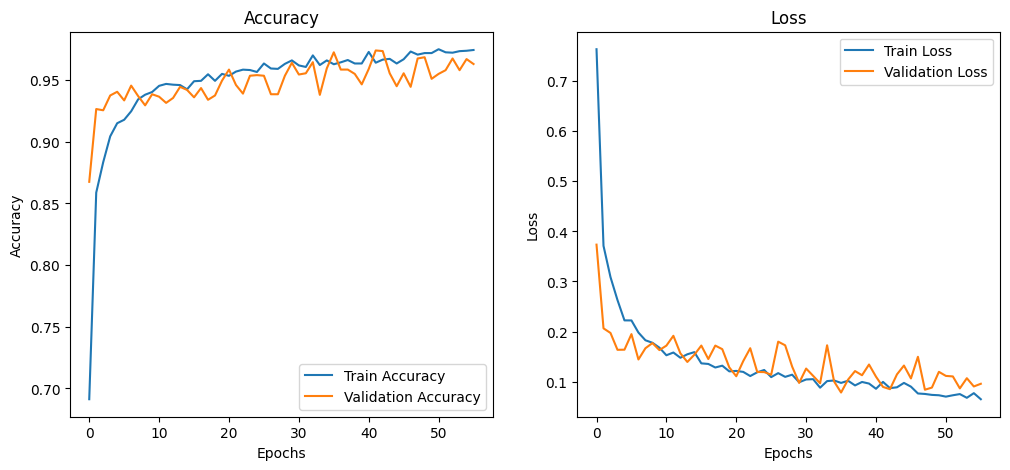

In [10]:
# Graficar la historia de entrenamiento
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss')
plt.show()

In [11]:
# Guardar el modelo
model.save("mobilenetv2_gastro_model.h5")
print("Modelo guardado")

Modelo guardado


In [12]:
# Evaluar en el conjunto de test
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Evaluar en el conjunto de validación
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")


  1/100 [..............................] - ETA: 4s - loss: 0.0286 - accuracy: 1.0000


  4/100 [>.............................] - ETA: 1s - loss: 0.0198 - accuracy: 1.0000


  7/100 [=>............................] - ETA: 1s - loss: 0.0157 - accuracy: 1.0000


  9/100 [=>............................] - ETA: 2s - loss: 0.0125 - accuracy: 1.0000


 11/100 [==>...........................] - ETA: 2s - loss: 0.0161 - accuracy: 1.0000


 14/100 [===>..........................] - ETA: 2s - loss: 0.0172 - accuracy: 1.0000


 17/100 [====>.........................] - ETA: 2s - loss: 0.0150 - accuracy: 1.0000


 21/100 [=====>........................] - ETA: 1s - loss: 0.0465 - accuracy: 0.9881


 24/100 [======>.......................] - ETA: 1s - loss: 0.0508 - accuracy: 0.9792


 27/100 [=======>......................] - ETA: 1s - loss: 0.0496 - accuracy: 0.9815


 30/100 [========>.....................] - ETA: 1s - loss: 0.0472 - accuracy: 0.9833


 32/100 [========>.....................] - ETA: 1s - loss: 0.0448 - accuracy: 0.9844


 34/100 [=========>....................] - ETA: 1s - loss: 0.0443 - accuracy: 0.9853


 38/100 [==========>...................] - ETA: 1s - loss: 0.0406 - accuracy: 0.9868


 41/100 [===========>..................] - ETA: 1s - loss: 0.0417 - accuracy: 0.9848


 43/100 [===========>..................] - ETA: 1s - loss: 0.0445 - accuracy: 0.9826


 46/100 [============>.................] - ETA: 1s - loss: 0.0524 - accuracy: 0.9783


 48/100 [=============>................] - ETA: 1s - loss: 0.0520 - accuracy: 0.9792


 50/100 [==============>...............] - ETA: 1s - loss: 0.0588 - accuracy: 0.9775


 53/100 [==============>...............] - ETA: 1s - loss: 0.0631 - accuracy: 0.9764


 55/100 [===============>..............] - ETA: 1s - loss: 0.0635 - accuracy: 0.9750


 57/100 [================>.............] - ETA: 1s - loss: 0.0614 - accuracy: 0.9759


 60/100 [=================>............] - ETA: 1s - loss: 0.0583 - accuracy: 0.9771


 63/100 [=================>............] - ETA: 0s - loss: 0.0576 - accuracy: 0.9762


 65/100 [==================>...........] - ETA: 0s - loss: 0.0581 - accuracy: 0.9750


 67/100 [===================>..........] - ETA: 0s - loss: 0.0579 - accuracy: 0.9739


 69/100 [===================>..........] - ETA: 0s - loss: 0.0571 - accuracy: 0.9746


 71/100 [====================>.........] - ETA: 0s - loss: 0.0555 - accuracy: 0.9754


 73/100 [====================>.........] - ETA: 0s - loss: 0.0540 - accuracy: 0.9760


 75/100 [=====================>........] - ETA: 0s - loss: 0.0570 - accuracy: 0.9733


 76/100 [=====================>........] - ETA: 0s - loss: 0.0563 - accuracy: 0.9737


 77/100 [======================>.......] - ETA: 0s - loss: 0.0556 - accuracy: 0.9740


 78/100 [======================>.......] - ETA: 0s - loss: 0.0548 - accuracy: 0.9744


 79/100 [======================>.......] - ETA: 0s - loss: 0.0542 - accuracy: 0.9747


 80/100 [=======================>......] - ETA: 0s - loss: 0.0535 - accuracy: 0.9750


 81/100 [=======================>......] - ETA: 0s - loss: 0.0528 - accuracy: 0.9753


 82/100 [=======================>......] - ETA: 0s - loss: 0.0522 - accuracy: 0.9756


 83/100 [=======================>......] - ETA: 0s - loss: 0.0522 - accuracy: 0.9759


 84/100 [========================>.....] - ETA: 0s - loss: 0.0516 - accuracy: 0.9762


 85/100 [========================>.....] - ETA: 0s - loss: 0.0510 - accuracy: 0.9765


 86/100 [========================>.....] - ETA: 0s - loss: 0.0504 - accuracy: 0.9767


 87/100 [=========================>....] - ETA: 0s - loss: 0.0498 - accuracy: 0.9770


 88/100 [=========================>....] - ETA: 0s - loss: 0.0493 - accuracy: 0.9773


 89/100 [=========================>....] - ETA: 0s - loss: 0.0488 - accuracy: 0.9775


 90/100 [==========================>...] - ETA: 0s - loss: 0.0483 - accuracy: 0.9778


 91/100 [==========================>...] - ETA: 0s - loss: 0.0477 - accuracy: 0.9780


 92/100 [==========================>...] - ETA: 0s - loss: 0.0472 - accuracy: 0.9783


 93/100 [==========================>...] - ETA: 0s - loss: 0.0467 - accuracy: 0.9785


 94/100 [===========================>..] - ETA: 0s - loss: 0.0462 - accuracy: 0.9787


 95/100 [===========================>..] - ETA: 0s - loss: 0.0459 - accuracy: 0.9789


 96/100 [===========================>..] - ETA: 0s - loss: 0.0454 - accuracy: 0.9792


 97/100 [============================>.] - ETA: 0s - loss: 0.0451 - accuracy: 0.9794


 98/100 [============================>.] - ETA: 0s - loss: 0.0446 - accuracy: 0.9796


 99/100 [============================>.] - ETA: 0s - loss: 0.0442 - accuracy: 0.9798


100/100 [==============================] - ETA: 0s - loss: 0.0439 - accuracy: 0.9800


100/100 [==============================] - 4s 39ms/step - loss: 0.0439 - accuracy: 0.9800


Test Accuracy: 98.00%



  1/250 [..............................] - ETA: 12s - loss: 0.0129 - accuracy: 1.0000


  5/250 [..............................] - ETA: 3s - loss: 0.0143 - accuracy: 1.0000 


  9/250 [>.............................] - ETA: 3s - loss: 0.0324 - accuracy: 0.9861


 13/250 [>.............................] - ETA: 3s - loss: 0.0311 - accuracy: 0.9904


 16/250 [>.............................] - ETA: 3s - loss: 0.0468 - accuracy: 0.9844


 20/250 [=>............................] - ETA: 3s - loss: 0.0419 - accuracy: 0.9875


 24/250 [=>............................] - ETA: 3s - loss: 0.0645 - accuracy: 0.9740


 27/250 [==>...........................] - ETA: 3s - loss: 0.0677 - accuracy: 0.9722


 31/250 [==>...........................] - ETA: 3s - loss: 0.0674 - accuracy: 0.9718


 34/250 [===>..........................] - ETA: 3s - loss: 0.0643 - accuracy: 0.9743


 38/250 [===>..........................] - ETA: 3s - loss: 0.0599 - accuracy: 0.9770


 42/250 [====>.........................] - ETA: 3s - loss: 0.0620 - accuracy: 0.9762


 46/250 [====>.........................] - ETA: 3s - loss: 0.0658 - accuracy: 0.9728


 49/250 [====>.........................] - ETA: 3s - loss: 0.0661 - accuracy: 0.9719


 52/250 [=====>........................] - ETA: 3s - loss: 0.0672 - accuracy: 0.9736


 55/250 [=====>........................] - ETA: 3s - loss: 0.0704 - accuracy: 0.9705


 59/250 [======>.......................] - ETA: 3s - loss: 0.0721 - accuracy: 0.9682


 63/250 [======>.......................] - ETA: 3s - loss: 0.0692 - accuracy: 0.9702


 66/250 [======>.......................] - ETA: 3s - loss: 0.0675 - accuracy: 0.9716


 68/250 [=======>......................] - ETA: 3s - loss: 0.0755 - accuracy: 0.9688


 71/250 [=======>......................] - ETA: 3s - loss: 0.0780 - accuracy: 0.9683


 73/250 [=======>......................] - ETA: 3s - loss: 0.0790 - accuracy: 0.9675


 75/250 [========>.....................] - ETA: 3s - loss: 0.0834 - accuracy: 0.9650


 77/250 [========>.....................] - ETA: 3s - loss: 0.0845 - accuracy: 0.9643


 79/250 [========>.....................] - ETA: 3s - loss: 0.0834 - accuracy: 0.9652


 81/250 [========>.....................] - ETA: 3s - loss: 0.0816 - accuracy: 0.9660


 83/250 [========>.....................] - ETA: 3s - loss: 0.0817 - accuracy: 0.9654


 85/250 [=========>....................] - ETA: 3s - loss: 0.0804 - accuracy: 0.9662


 88/250 [=========>....................] - ETA: 3s - loss: 0.0800 - accuracy: 0.9659


 90/250 [=========>....................] - ETA: 3s - loss: 0.0821 - accuracy: 0.9653


 92/250 [==========>...................] - ETA: 3s - loss: 0.0882 - accuracy: 0.9647


 94/250 [==========>...................] - ETA: 3s - loss: 0.0866 - accuracy: 0.9654


 96/250 [==========>...................] - ETA: 3s - loss: 0.0919 - accuracy: 0.9648


 98/250 [==========>...................] - ETA: 3s - loss: 0.0939 - accuracy: 0.9643


100/250 [===========>..................] - ETA: 3s - loss: 0.0923 - accuracy: 0.9650


103/250 [===========>..................] - ETA: 3s - loss: 0.0907 - accuracy: 0.9648


105/250 [===========>..................] - ETA: 3s - loss: 0.1004 - accuracy: 0.9619


108/250 [===========>..................] - ETA: 3s - loss: 0.1008 - accuracy: 0.9618


110/250 [============>.................] - ETA: 3s - loss: 0.0990 - accuracy: 0.9625


112/250 [============>.................] - ETA: 3s - loss: 0.0974 - accuracy: 0.9632


115/250 [============>.................] - ETA: 3s - loss: 0.0952 - accuracy: 0.9641


117/250 [=============>................] - ETA: 3s - loss: 0.0970 - accuracy: 0.9637


120/250 [=============>................] - ETA: 2s - loss: 0.0985 - accuracy: 0.9635


122/250 [=============>................] - ETA: 2s - loss: 0.0969 - accuracy: 0.9641


125/250 [==============>...............] - ETA: 2s - loss: 0.1032 - accuracy: 0.9620


127/250 [==============>...............] - ETA: 2s - loss: 0.1029 - accuracy: 0.9616


130/250 [==============>...............] - ETA: 2s - loss: 0.1013 - accuracy: 0.9625


132/250 [==============>...............] - ETA: 2s - loss: 0.0998 - accuracy: 0.9631


135/250 [===============>..............] - ETA: 2s - loss: 0.0982 - accuracy: 0.9639


137/250 [===============>..............] - ETA: 2s - loss: 0.0974 - accuracy: 0.9644


140/250 [===============>..............] - ETA: 2s - loss: 0.1011 - accuracy: 0.9634


142/250 [================>.............] - ETA: 2s - loss: 0.1000 - accuracy: 0.9639


144/250 [================>.............] - ETA: 2s - loss: 0.0989 - accuracy: 0.9644


146/250 [================>.............] - ETA: 2s - loss: 0.0976 - accuracy: 0.9649


148/250 [================>.............] - ETA: 2s - loss: 0.0967 - accuracy: 0.9654


150/250 [=================>............] - ETA: 2s - loss: 0.0956 - accuracy: 0.9658


153/250 [=================>............] - ETA: 2s - loss: 0.0939 - accuracy: 0.9665


155/250 [=================>............] - ETA: 2s - loss: 0.0939 - accuracy: 0.9661


158/250 [=================>............] - ETA: 2s - loss: 0.0922 - accuracy: 0.9668


160/250 [==================>...........] - ETA: 2s - loss: 0.0912 - accuracy: 0.9672


162/250 [==================>...........] - ETA: 2s - loss: 0.0901 - accuracy: 0.9676


164/250 [==================>...........] - ETA: 2s - loss: 0.0894 - accuracy: 0.9680


167/250 [===================>..........] - ETA: 2s - loss: 0.0926 - accuracy: 0.9671


169/250 [===================>..........] - ETA: 2s - loss: 0.0978 - accuracy: 0.9652


171/250 [===================>..........] - ETA: 1s - loss: 0.0978 - accuracy: 0.9649


174/250 [===================>..........] - ETA: 1s - loss: 0.0983 - accuracy: 0.9641


176/250 [====================>.........] - ETA: 1s - loss: 0.0973 - accuracy: 0.9645


178/250 [====================>.........] - ETA: 1s - loss: 0.1005 - accuracy: 0.9642


180/250 [====================>.........] - ETA: 1s - loss: 0.1019 - accuracy: 0.9639


182/250 [====================>.........] - ETA: 1s - loss: 0.1033 - accuracy: 0.9636


184/250 [=====================>........] - ETA: 1s - loss: 0.1026 - accuracy: 0.9640


187/250 [=====================>........] - ETA: 1s - loss: 0.1012 - accuracy: 0.9646


189/250 [=====================>........] - ETA: 1s - loss: 0.1001 - accuracy: 0.9649


190/250 [=====================>........] - ETA: 1s - loss: 0.0996 - accuracy: 0.9651


191/250 [=====================>........] - ETA: 1s - loss: 0.0991 - accuracy: 0.9653


192/250 [======================>.......] - ETA: 1s - loss: 0.0986 - accuracy: 0.9655


193/250 [======================>.......] - ETA: 1s - loss: 0.0982 - accuracy: 0.9657


194/250 [======================>.......] - ETA: 1s - loss: 0.0989 - accuracy: 0.9652


195/250 [======================>.......] - ETA: 1s - loss: 0.0985 - accuracy: 0.9654


196/250 [======================>.......] - ETA: 1s - loss: 0.0980 - accuracy: 0.9656


197/250 [======================>.......] - ETA: 1s - loss: 0.0975 - accuracy: 0.9657


198/250 [======================>.......] - ETA: 1s - loss: 0.0970 - accuracy: 0.9659


199/250 [======================>.......] - ETA: 1s - loss: 0.0965 - accuracy: 0.9661


200/250 [=======================>......] - ETA: 1s - loss: 0.0960 - accuracy: 0.9663


201/250 [=======================>......] - ETA: 1s - loss: 0.0956 - accuracy: 0.9664


202/250 [=======================>......] - ETA: 1s - loss: 0.0951 - accuracy: 0.9666


203/250 [=======================>......] - ETA: 1s - loss: 0.0946 - accuracy: 0.9667


204/250 [=======================>......] - ETA: 1s - loss: 0.0942 - accuracy: 0.9669


205/250 [=======================>......] - ETA: 1s - loss: 0.0938 - accuracy: 0.9671


206/250 [=======================>......] - ETA: 1s - loss: 0.0934 - accuracy: 0.9672


207/250 [=======================>......] - ETA: 1s - loss: 0.0929 - accuracy: 0.9674


208/250 [=======================>......] - ETA: 1s - loss: 0.0927 - accuracy: 0.9675


209/250 [========================>.....] - ETA: 1s - loss: 0.0923 - accuracy: 0.9677


210/250 [========================>.....] - ETA: 1s - loss: 0.0919 - accuracy: 0.9679


211/250 [========================>.....] - ETA: 1s - loss: 0.0914 - accuracy: 0.9680


212/250 [========================>.....] - ETA: 1s - loss: 0.0912 - accuracy: 0.9682


213/250 [========================>.....] - ETA: 1s - loss: 0.0907 - accuracy: 0.9683


214/250 [========================>.....] - ETA: 1s - loss: 0.0903 - accuracy: 0.9685


215/250 [========================>.....] - ETA: 1s - loss: 0.0899 - accuracy: 0.9686


216/250 [========================>.....] - ETA: 1s - loss: 0.0901 - accuracy: 0.9682


217/250 [=========================>....] - ETA: 1s - loss: 0.0897 - accuracy: 0.9683


218/250 [=========================>....] - ETA: 1s - loss: 0.0893 - accuracy: 0.9685


219/250 [=========================>....] - ETA: 1s - loss: 0.0888 - accuracy: 0.9686


220/250 [=========================>....] - ETA: 0s - loss: 0.0884 - accuracy: 0.9688


221/250 [=========================>....] - ETA: 0s - loss: 0.0880 - accuracy: 0.9689


222/250 [=========================>....] - ETA: 0s - loss: 0.0876 - accuracy: 0.9690


223/250 [=========================>....] - ETA: 0s - loss: 0.0873 - accuracy: 0.9692


224/250 [=========================>....] - ETA: 0s - loss: 0.0869 - accuracy: 0.9693


225/250 [==========================>...] - ETA: 0s - loss: 0.0866 - accuracy: 0.9694


226/250 [==========================>...] - ETA: 0s - loss: 0.0862 - accuracy: 0.9696


227/250 [==========================>...] - ETA: 0s - loss: 0.0858 - accuracy: 0.9697


228/250 [==========================>...] - ETA: 0s - loss: 0.0855 - accuracy: 0.9698


229/250 [==========================>...] - ETA: 0s - loss: 0.0851 - accuracy: 0.9700


230/250 [==========================>...] - ETA: 0s - loss: 0.0847 - accuracy: 0.9701


231/250 [==========================>...] - ETA: 0s - loss: 0.0844 - accuracy: 0.9702


232/250 [==========================>...] - ETA: 0s - loss: 0.0840 - accuracy: 0.9704


233/250 [==========================>...] - ETA: 0s - loss: 0.0839 - accuracy: 0.9705


234/250 [===========================>..] - ETA: 0s - loss: 0.0835 - accuracy: 0.9706


235/250 [===========================>..] - ETA: 0s - loss: 0.0832 - accuracy: 0.9707


236/250 [===========================>..] - ETA: 0s - loss: 0.0828 - accuracy: 0.9709


237/250 [===========================>..] - ETA: 0s - loss: 0.0825 - accuracy: 0.9710


238/250 [===========================>..] - ETA: 0s - loss: 0.0821 - accuracy: 0.9711


239/250 [===========================>..] - ETA: 0s - loss: 0.0818 - accuracy: 0.9712


240/250 [===========================>..] - ETA: 0s - loss: 0.0815 - accuracy: 0.9714


241/250 [===========================>..] - ETA: 0s - loss: 0.0811 - accuracy: 0.9715


242/250 [============================>.] - ETA: 0s - loss: 0.0808 - accuracy: 0.9716


243/250 [============================>.] - ETA: 0s - loss: 0.0804 - accuracy: 0.9717


244/250 [============================>.] - ETA: 0s - loss: 0.0801 - accuracy: 0.9718


245/250 [============================>.] - ETA: 0s - loss: 0.0798 - accuracy: 0.9719


246/250 [============================>.] - ETA: 0s - loss: 0.0795 - accuracy: 0.9721


247/250 [============================>.] - ETA: 0s - loss: 0.0791 - accuracy: 0.9722


248/250 [============================>.] - ETA: 0s - loss: 0.0788 - accuracy: 0.9723


249/250 [============================>.] - ETA: 0s - loss: 0.0785 - accuracy: 0.9724


250/250 [==============================] - ETA: 0s - loss: 0.0782 - accuracy: 0.9725


250/250 [==============================] - 9s 38ms/step - loss: 0.0782 - accuracy: 0.9725


Validation Accuracy: 97.25%


In [10]:
# Cargar el modelo guardado y probarlo
test_model = keras.models.load_model("mobilenetv2_gastro_model.h5")

In [11]:
# Obtener predicciones para validación
y_true_val = val_generator.classes
y_pred_val = np.argmax(test_model.predict(val_generator), axis=1)

# Obtener predicciones para test
y_true_test = test_generator.classes
y_pred_test = np.argmax(test_model.predict(test_generator), axis=1)

# Reporte de clasificación para validación
print("\nValidation Classification Report:")
print(classification_report(y_true_val, y_pred_val, target_names=val_generator.class_indices.keys()))

# Reporte de clasificación para test
print("\nTest Classification Report:")
print(classification_report(y_true_test, y_pred_test, target_names=test_generator.class_indices.keys()))

100/100 [==============================] - 5s 46ms/step

Validation Classification Report:
                      precision    recall  f1-score   support

            0_normal       0.99      0.97      0.98       500
1_ulcerative_colitis       0.95      0.95      0.95       500
            2_polyps       0.96      0.97      0.97       500
       3_esophagitis       0.99      1.00      0.99       500

            accuracy                           0.97      2000
           macro avg       0.97      0.97      0.97      2000
        weighted avg       0.97      0.97      0.97      2000


Test Classification Report:
                      precision    recall  f1-score   support

            0_normal       1.00      0.98      0.99       200
1_ulcerative_colitis       0.95      0.97      0.96       200
            2_polyps       0.98      0.96      0.97       200
       3_esophagitis       1.00      1.00      1.00       200

            accuracy                           0.98       800
       

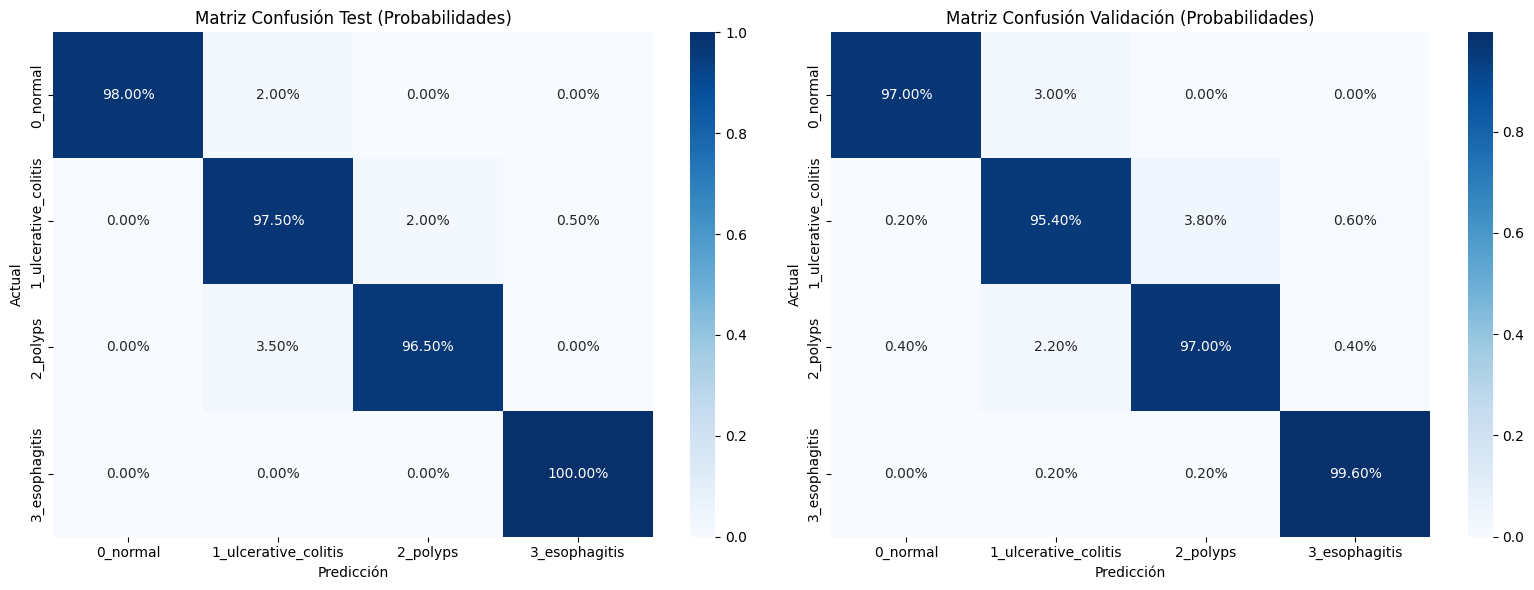

In [15]:
# Función para convertir la matriz de confusión a probabilidades
def confusion_matrix_prob(cm):
    return cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Matriz de confusión para el conjunto de test
cm_test = confusion_matrix(y_true_test, y_pred_test)
cm_test_prob = confusion_matrix_prob(cm_test)
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.heatmap(cm_test_prob, annot=True, fmt='.2%', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicción')
plt.ylabel('Actual')
plt.title('Matriz Confusión Test (Probabilidades)')

# Matriz de confusión para el conjunto de validación
cm_val = confusion_matrix(y_true_val, y_pred_val)
cm_val_prob = confusion_matrix_prob(cm_val)
plt.subplot(1, 2, 2)
sns.heatmap(cm_val_prob, annot=True, fmt='.2%', cmap='Blues', xticklabels=val_generator.class_indices.keys(), yticklabels=val_generator.class_indices.keys())
plt.xlabel('Predicción')
plt.ylabel('Actual')
plt.title('Matriz Confusión Validación (Probabilidades)')

plt.tight_layout()
plt.show()